# 합성데이터 기반 객체 탐지 AI 경진대회 (YOLOv5 코드)

* 최대 이미지 사이즈 736 (배치 사이즈 32일 때, input 이미지 사이즈는 32배수여야 함)
* hyp~ yaml 파일 들어가서 데이터 증강부분(degrees, flipud, mixup) 0.5로 설정, iou_t 0.5, anchor_t 5.0 그대신 시간은 더 오래 걸린다구ㅜ
* !python train.py --img 800 --batch 16 --epochs 80 --data "/content/detect_car/data.yaml" --cfg ./models/yolov5m.yaml --weights yolov5m.pt --name yolov5m_results # LB : 0.5021634492

* !python train.py --img 736 --batch 32 --epochs 50 --data "/content/detect_car/data.yaml" --cfg ./models/yolov5m.yaml --weights yolov5m.pt --name yolov5m_results # LB : 0.5493591446

* !python train.py --img 736 --batch 32 --epochs 70 --data "/content/detect_car/data.yaml" --cfg ./models/yolov5m.yaml --weights yolov5m.pt --name yolov5m_results # LB : 0.7204895463 / 0.6862235612 기존대로 파라미터 조정, utils/albumentations.py -> Blur(p=0.05, blur_limit=(3, 7)), MedianBlur(p=0.05, blur_limit=(3, 7)), ToGray(p=0.3), CLAHE(p=0.05, clip_limit=(1, 4.0), tile_grid_size=(8, 8)), RandomGamma(p=0.1, gamma_limit=(80, 120), eps=None) 으로 설정


* grayscale 진행할 때, 모든 파일에 grayscale 진행하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [ ]:
!mkdir detect_car

In [ ]:
%cd detect_car

/content/detect_car


In [ ]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/open.zip'

In [ ]:
%cd /content

/content


In [ ]:
# Yolo v5 깃 허브 설치
%cd /content
!git clone https://github.com/ultralytics/yolov5.git

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 15814, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 15814 (delta 9), reused 26 (delta 2), pack-reused 15769
Receiving objects: 100% (15814/15814), 14.59 MiB | 22.74 MiB/s, done.
Resolving deltas: 100% (10823/10823), done.


In [ ]:
# # 설정파일 설치
%cd /content/yolov5/
!pip install -r requirements.txt

/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.9/626.9 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


In [ ]:
import sys
import torch
import utils

display = utils.notebook_init()

YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (4 CPUs, 25.5 GB RAM, 71.5/166.8 GB disk)


In [ ]:
import glob
import os
import cv2
from tqdm import tqdm
import shutil
import math

In [ ]:
txt_file_list = glob.glob('/content/detect_car/train/*.txt')

In [ ]:
len(txt_file_list)

6481

In [ ]:
os.makedirs('/content/detect_car/labels/')

In [ ]:
for file in tqdm(txt_file_list):
    file_name = os.path.basename(file)
    file_name = file_name.split('.')[0]
    img = cv2.imread('/content/detect_car/train/' + file_name + '.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_height, img_width = img.shape
    print(file_name, img_height, img_width)
    cv2.destroyAllWindows()
    with open(file, 'r') as f:
        lines_list = []
        lines = f.readlines()
        for line in lines:
            line = list(map(float, line.strip().split(' ')))
            class_name = int(line[0])
            x_min, y_min = float(min(line[5], line[7])), float(min(line[6], line[8]))
            x_max, y_max = float(max(line[1], line[3])), float(max(line[2], line[4]))
            x_center, y_center = float(((x_min + x_max) / 2) / img_width), float(((y_min + y_max) / 2) / img_height)
            width, height = abs(x_max - x_min) / img_width, abs(y_max - y_min) / img_height
            print(x_center, y_center, width, height)
            lines_list.append([class_name, x_center, y_center, width, height])
    with open('/content/detect_car/labels/' + file_name + '.txt', 'w') as f:
        for line in lines_list:
            f.write(str(line[0]) + ' ' + str(line[1]) + ' ' + str(line[2]) + ' ' + str(line[3]) + ' ' + str(line[4]) + '\n')

  0%|          | 2/6481 [00:00<13:31,  7.99it/s]

syn_02524 1040 1920
0.59375 0.2644230769230769 0.14375 0.2653846153846154
0.45078125 0.44326923076923075 0.12760416666666666 0.25576923076923075
0.28567708333333336 0.6745192307692308 0.13697916666666668 0.3375
syn_02630 1040 1920
0.65859375 0.5057692307692307 0.15989583333333332 0.27307692307692305
0.4817708333333333 0.5995192307692307 0.134375 0.2798076923076923
0.2625 0.5793269230769231 0.15 0.3375


  0%|          | 4/6481 [00:00<12:54,  8.36it/s]

syn_04013 1040 1920
0.5919270833333333 0.3173076923076923 0.1390625 0.225
0.4747395833333333 0.5524038461538462 0.13489583333333333 0.30865384615384617
0.25885416666666666 0.5471153846153847 0.13229166666666667 0.3
syn_04117 1040 1920
0.5947916666666667 0.31346153846153846 0.15104166666666666 0.25769230769230766


  0%|          | 6/6481 [00:00<12:03,  8.94it/s]

syn_03959 1040 1920
0.6736979166666667 0.45240384615384616 0.1546875 0.29134615384615387
0.43072916666666666 0.32740384615384616 0.13958333333333334 0.24326923076923077
0.24973958333333332 0.42259615384615384 0.13802083333333334 0.2701923076923077
syn_00231 1040 1920
0.5947916666666667 0.35192307692307695 0.140625 0.24615384615384617
0.41875 0.41875 0.14791666666666667 0.2605769230769231
0.24479166666666666 0.5677884615384615 0.15520833333333334 0.3490384615384615


  0%|          | 8/6481 [00:00<11:52,  9.08it/s]

syn_00936 1040 1920
0.6466145833333333 0.4947115384615385 0.1609375 0.27403846153846156
0.40078125 0.33653846153846156 0.14322916666666666 0.24615384615384617
0.21875 0.41009615384615383 0.12916666666666668 0.2721153846153846
syn_04169 1040 1920
0.58359375 0.2485576923076923 0.1359375 0.2567307692307692
0.46380208333333334 0.5096153846153846 0.15260416666666668 0.27884615384615385
0.23776041666666667 0.43173076923076925 0.13697916666666668 0.2653846153846154


  0%|          | 10/6481 [00:01<11:42,  9.20it/s]

syn_02753 1040 1920
0.6416666666666667 0.42451923076923076 0.15208333333333332 0.2586538461538462
0.4825520833333333 0.5427884615384615 0.16510416666666666 0.3317307692307692
0.24166666666666667 0.41778846153846155 0.12604166666666666 0.2548076923076923
syn_00639 1040 1920
0.6236979166666666 0.4403846153846154 0.1453125 0.24615384615384617
0.41458333333333336 0.36538461538461536 0.14791666666666667 0.3038461538461538
0.2578125 0.6384615384615384 0.14479166666666668 0.2903846153846154


  0%|          | 13/6481 [00:01<10:54,  9.88it/s]

syn_00311 1040 1920
0.57578125 0.2764423076923077 0.1609375 0.30288461538461536
0.4518229166666667 0.5346153846153846 0.14114583333333333 0.3
0.25755208333333335 0.6245192307692308 0.15989583333333332 0.3682692307692308
syn_01488 1040 1920
0.6856770833333333 0.5096153846153846 0.1640625 0.3057692307692308
0.44583333333333336 0.40673076923076923 0.14479166666666668 0.25769230769230766
0.26067708333333334 0.5096153846153846 0.14010416666666667 0.27692307692307694
syn_01211 1040 1920
0.60859375 0.36153846153846153 0.1578125 0.3019230769230769
0.440625 0.5024038461538461 0.14375 0.26634615384615384
0.26484375 0.7052884615384616 0.13385416666666666 0.30288461538461536


  0%|          | 15/6481 [00:01<10:43, 10.05it/s]

syn_04989 1040 1920
0.6716145833333333 0.4774038461538462 0.13697916666666668 0.2605769230769231
0.43854166666666666 0.35144230769230766 0.15104166666666666 0.29903846153846153
0.23776041666666667 0.3557692307692308 0.13177083333333334 0.27884615384615385
syn_03920 1040 1920
0.5927083333333333 0.36923076923076925 0.15 0.24615384615384617
0.42265625 0.4403846153846154 0.14010416666666667 0.2519230769230769
0.27578125 0.7677884615384616 0.15364583333333334 0.31826923076923075
syn_03510 1040 1920
0.5817708333333333 0.3096153846153846 0.14375 0.2403846153846154
0.38671875 0.27355769230769234 0.12864583333333332 0.2605769230769231
0.23671875 0.5168269230769231 0.16302083333333334 0.35865384615384616


  0%|          | 17/6481 [00:01<10:38, 10.12it/s]

syn_04626 1040 1920
0.67578125 0.5014423076923077 0.17239583333333333 0.32211538461538464
0.46770833333333334 0.5024038461538461 0.128125 0.2644230769230769
syn_06416 1040 1920
0.6669270833333333 0.5293269230769231 0.16197916666666667 0.27403846153846156
0.4546875 0.5182692307692308 0.14479166666666668 0.2653846153846154
0.2546875 0.5875 0.12916666666666668 0.27884615384615385


  0%|          | 20/6481 [00:02<10:53,  9.89it/s]

syn_04432 1040 1920
0.6755208333333333 0.46442307692307694 0.17395833333333333 0.3326923076923077
0.43385416666666665 0.3596153846153846 0.14270833333333333 0.25961538461538464
0.28854166666666664 0.6673076923076923 0.14791666666666667 0.3211538461538462
syn_01205 1040 1920
0.6638020833333333 0.5408653846153846 0.1421875 0.2759615384615385
0.42578125 0.43846153846153846 0.14635416666666667 0.2653846153846154
0.21979166666666666 0.4346153846153846 0.11875 0.25961538461538464
syn_02106 1040 1920
0.39479166666666665 0.3557692307692308

  0%|          | 22/6481 [00:02<10:48,  9.95it/s]

 0.115625 0.2403846153846154
0.21380208333333334 0.43846153846153846 0.13177083333333334 0.25769230769230766
syn_02055 1040 1920
0.6317708333333333 0.46778846153846154 0.14479166666666668 0.28942307692307695
0.40989583333333335 0.4048076923076923 0.14583333333333334 0.25576923076923075
syn_02539 1040 1920
0.66953125 0.5725961538461538 0.1640625 0.28173076923076923
0.42890625 0.42451923076923076 0.14010416666666667 0.28173076923076923


  0%|          | 24/6481 [00:02<10:23, 10.35it/s]

syn_06035 1040 1920
0.6348958333333333 0.4081730769230769 0.14895833333333333 0.27403846153846156
0.22786458333333334 0.41346153846153844 0.1421875 0.2826923076923077
syn_03393 1040 1920
0.6255208333333333 0.45576923076923076 0.15104166666666666 0.28846153846153844
0.43671875 0.49038461538461536 0.1453125 0.29423076923076924
0.26666666666666666 0.7134615384615385 0.15104166666666666 0.3326923076923077


  0%|          | 28/6481 [00:02<10:27, 10.28it/s]

syn_03468 1040 1920
0.6528645833333333 0.4971153846153846 0.1578125 0.2980769230769231
0.4466145833333333 0.4798076923076923 0.16197916666666667 0.3403846153846154
0.21588541666666666 0.35528846153846155 0.14322916666666666 0.31634615384615383
syn_06409 1040 1920
0.6395833333333333 0.4201923076923077 0.15416666666666667 0.25576923076923075
0.48072916666666665 0.5466346153846153 0.153125 0.3105769230769231
0.2578125 0.5057692307692307 0.140625 0.3038461538461538
syn_03567 1040 1920
0.40677083333333336 0.29759615384615384 0.14791666666666667 0.30480769230769234
0.26875 0.6692307692307692 0.15 0.3076923076923077


  0%|          | 30/6481 [00:03<10:30, 10.23it/s]

syn_04310 1040 1920
0.49661458333333336 0.6004807692307692 0.1609375 0.2971153846153846
0.22994791666666667 0.3038461538461538 0.13697916666666668 0.29615384615384616
syn_01958 1040 1920
0.44895833333333335 0.43653846153846154 0.15104166666666666 0.3076923076923077
0.29270833333333335 0.7115384615384616 0.13541666666666666 0.3346153846153846
syn_00873 1040 1920
0.48072916666666665 0.6134615384615385 0.15729166666666666 0.2923076923076923

  0%|          | 32/6481 [00:03<10:40, 10.07it/s]


0.23880208333333333 0.4798076923076923 0.13489583333333333 0.2673076923076923
syn_02890 1040 1920
0.66171875 0.5307692307692308 0.1390625 0.27115384615384613
0.44583333333333336 0.4831730769230769 0.14791666666666667 0.29903846153846153
0.25052083333333336 0.5745192307692307 0.125 0.2778846153846154


  1%|          | 34/6481 [00:03<10:35, 10.15it/s]

syn_00154 1040 1920
0.6536458333333334 0.4913461538461538 0.17291666666666666 0.37115384615384617
0.4197916666666667 0.42259615384615384 0.13541666666666666 0.24519230769230768
0.2578125 0.6163461538461539 0.159375 0.36538461538461536
syn_05411 1040 1920
0.5997395833333333 0.33557692307692305 0.15989583333333332 0.3096153846153846
0.4708333333333333 0.6177884615384616 0.153125 0.2798076923076923
0.24661458333333333 0.5692307692307692 0.13385416666666666 0.2846153846153846
syn_05218 1040 1920
0.66875 0.4254807692307692 0.18125 0.3375
0.42890625 0.31634615384615383 0.1390625 0.24807692307692308
0.23359375 0.31971153846153844 0.13489583333333333 0.2625


  1%|          | 38/6481 [00:03<10:32, 10.19it/s]

syn_05342 1040 1920
0.60078125 0.27307692307692305 0.15572916666666667 0.3
0.4765625 0.5408653846153846 0.15416666666666667 0.28173076923076923
0.22369791666666666 0.30865384615384617 0.12760416666666666 0.27115384615384613
syn_05130 1040 1920
0.6127604166666667 0.3855769230769231 0.14322916666666666 0.23461538461538461
0.4557291666666667 0.5038461538461538 0.153125 0.2673076923076923
0.24661458333333333 0.46442307692307694 0.14114583333333333 0.31153846153846154
syn_00509 1040 1920
0.40286458333333336 0.3004807692307692 0.1171875 0.23365384615384616
0.23385416666666667 0.4543269230769231 0.12916666666666668 0.2644230769230769


  1%|          | 40/6481 [00:04<10:27, 10.27it/s]

syn_01749 1040 1920
0.47369791666666666 0.5817307692307693 0.15677083333333333 0.3192307692307692
0.24973958333333332 0.5682692307692307 0.14635416666666667 0.3173076923076923
syn_03633 1040 1920
0.6145833333333334 0.41346153846153844 0.15208333333333332 0.25769230769230766
0.4158854166666667 0.38653846153846155 0.14010416666666667 0.28076923076923077
0.2557291666666667 0.6514423076923077 0.15 0.3105769230769231


  1%|          | 42/6481 [00:04<10:30, 10.21it/s]

syn_05001 1040 1920
0.6028645833333334 0.3216346153846154 0.13697916666666668 0.2298076923076923
0.4796875 0.5274038461538462 0.159375 0.32596153846153847
0.27057291666666666 0.5649038461538461 0.13802083333333334 0.30288461538461536
syn_03430 1040 1920
0.6026041666666667 0.3889423076923077 0.146875 0.2778846153846154
0.4109375 0.38076923076923075 0.15104166666666666 0.3153846153846154
0.20572916666666666 0.3466346153846154 0.14583333333333334 0.3144230769230769


  1%|          | 44/6481 [00:04<10:38, 10.08it/s]

syn_01019 1040 1920
0.70078125 0.5533653846153846 0.1609375 0.30673076923076925
0.46197916666666666 0.46778846153846154 0.15 0.2701923076923077
0.2877604166666667 0.6615384615384615 0.15260416666666668 0.3153846153846154
syn_04112 1040 1920
0.7018229166666666 0.5331730769230769 0.14427083333333332 0.2759615384615385
0.44583333333333336 0.3403846153846154 0.15 0.3173076923076923
0.27369791666666665 0.5394230769230769 0.1453125 0.2846153846153846


  1%|          | 46/6481 [00:04<10:34, 10.15it/s]

syn_03821 1040 1920
0.6307291666666667 0.43798076923076923 0.13125 0.24903846153846154
syn_01802 1040 1920
0.6145833333333334 0.35673076923076924 0.14583333333333334 0.23653846153846153
0.40078125 0.2725961538461538 0.1328125 0.23173076923076924
syn_00515 1040 1920
0.6895833333333333 0.5163461538461539 0.17916666666666667 0.3423076923076923
0.50078125 0.5995192307692307 0.16927083333333334 0.3471153846153846
0.2908854166666667 0.7134615384615385 0.15885416666666666 0.3230769230769231


  1%|          | 48/6481 [00:04<10:25, 10.28it/s]

syn_05343 1040 1920
0.5776041666666667 0.25576923076923075 0.14895833333333333 0.3
0.4627604166666667 0.5716346153846154 0.16302083333333334 0.28557692307692306
0.24973958333333332 0.5947115384615385 0.1484375 0.32403846153846155
syn_00698 1040 1920
0.6328125 0.42451923076923076 0.146875 0.2721153846153846
0.47161458333333334 0.5524038461538462 0.1609375 0.33365384615384613
0.25885416666666666 0.6004807692307692 0.14583333333333334 0.2932692307692308


  1%|          | 50/6481 [00:05<10:49,  9.90it/s]

syn_00071 1040 1920
0.646875 0.40528846153846154 0.15208333333333332 0.2567307692307692
0.48151041666666666 0.5004807692307692 0.16302083333333334 0.32596153846153847
0.26875 0.510576923076923 0.13645833333333332 0.28846153846153844
syn_01279 1040 1920
0.6427083333333333 0.4625 0.15208333333333332 0.2653846153846154
0.24583333333333332 0.5533653846153846 0.14375 0.2875


  1%|          | 52/6481 [00:05<10:42, 10.01it/s]

syn_05560 1040 1920
0.6088541666666667 0.35384615384615387 0.15 0.24807692307692308
0.41067708333333336 0.34134615384615385 0.13489583333333333 0.23461538461538461
0.23359375 0.4634615384615385 0.13697916666666668 0.2653846153846154
syn_02622 1040 1920
0.6955729166666667 0.5697115384615384 0.15989583333333332 0.28173076923076923
0.44088541666666664 0.39855769230769234 0.1421875 0.2528846153846154
0.23776041666666667 0.3701923076923077 0.12239583333333333 0.27307692307692305
syn_03692 1040 1920


  1%|          | 56/6481 [00:05<10:33, 10.15it/s]

0.5958333333333333 0.3283653846153846 0.12916666666666668 0.27403846153846156
0.46067708333333335 0.5293269230769231 0.16197916666666667 0.35096153846153844
0.22161458333333334 0.4125 0.13177083333333334 0.2826923076923077
syn_04566 1040 1920
0.4166666666666667 0.3576923076923077 0.121875 0.2423076923076923
0.21380208333333334 0.32259615384615387 0.13802083333333334 0.2932692307692308
syn_06070 1040 1920
0.5966145833333333 0.31153846153846154 0.14010416666666667 0.2423076923076923
0.46484375 0.53125 0.13177083333333334 0.2759615384615385
0.27760416666666665 0.7024038461538461 0.15 0.33557692307692305


  1%|          | 58/6481 [00:05<10:35, 10.11it/s]

syn_00747 1040 1920
0.6588541666666666 0.46298076923076925 0.16979166666666667 0.32596153846153847
0.47265625 0.5346153846153846 0.13489583333333333 0.3076923076923077
0.24765625 0.49567307692307694 0.14427083333333332 0.27403846153846156
syn_03662 1040 1920
0.6046875 0.29471153846153847 0.125 0.23942307692307693
0.4588541666666667 0.46057692307692305 0.14895833333333333 0.2692307692307692
0.221875 0.2846153846153846 0.125 0.26346153846153847
syn_06388 1040 1920
0.59375 0.37259615384615385 0.14375 0.24134615384615385
0.4278645833333333 0.4634615384615385 0.13697916666666668 0.26153846153846155
0.24479166666666666 0.5985576923076923 0.14375 0.2971153846153846


  1%|          | 62/6481 [00:06<10:23, 10.30it/s]

syn_01667 1040 1920
0.6677083333333333 0.6086538461538461 0.17083333333333334 0.2923076923076923
0.38385416666666666 0.2956730769230769 0.13125 0.2625
0.2557291666666667 0.6903846153846154 0.14895833333333333 0.3057692307692308
syn_05549 1040 1920
0.6026041666666667 0.36346153846153845 0.15104166666666666 0.2519230769230769
0.41354166666666664 0.3798076923076923 0.14895833333333333 0.275
0.19973958333333333 0.3139423076923077 0.12760416666666666 0.24903846153846154
syn_00539 1040 1920
0.46979166666666666 0.6038461538461538 0.134375 0.28076923076923077
0.24869791666666666 0.6024038461538461 0.14427083333333332 0.29134615384615387


  1%|          | 64/6481 [00:06<10:17, 10.39it/s]

syn_05710 1040 1920
0.5955729166666667 0.3894230769230769 0.14114583333333333 0.2403846153846154
0.20078125 0.34951923076923075 0.1203125 0.24903846153846154
syn_03869 1040 1920
0.6216145833333333 0.4826923076923077 0.15677083333333333 0.2692307692307692
0.38385416666666666 0.3278846153846154 0.12708333333333333 0.22884615384615384
0.2518229166666667 0.6985576923076923 0.1546875 0.30865384615384617
syn_02568 1040 1920
0.6716145833333333 0.5711538461538461 0.14114583333333333 0.275
0.48984375 0.6629807692307692 0.15885416666666666 0.32403846153846155
0.27265625 0.6951923076923077 0.16302083333333334 0.37115384615384617


  1%|          | 68/6481 [00:06<10:20, 10.34it/s]

syn_04995 1040 1920
0.6838541666666667 0.4826923076923077 0.15208333333333332 0.275
0.48776041666666664 0.5153846153846153 0.14947916666666666 0.2923076923076923
0.2635416666666667 0.4596153846153846 0.15 0.3211538461538462
syn_04411 1040 1920
0.5885416666666666 0.3004807692307692 0.121875 0.23173076923076924
0.2328125 0.42259615384615384 0.12916666666666668 0.28173076923076923
syn_04056 1040 1920
0.6908854166666667 0.5197115384615385 0.18177083333333333 0.3855769230769231
0.4609375 0.49230769230769234 0.146875 0.2673076923076923
0.28463541666666664 0.7033653846153847 0.1609375 0.31826923076923075


  1%|          | 70/6481 [00:07<10:17, 10.38it/s]

syn_05078 1040 1920
0.63671875 0.4514423076923077 0.1703125 0.3625
0.4666666666666667 0.6206730769230769 0.15625 0.28942307692307695
syn_00431 1040 1920
0.6669270833333333 0.45865384615384613 0.15989583333333332 0.2673076923076923
0.23072916666666668 0.3173076923076923 0.13645833333333332 0.26346153846153847
syn_03125 1040 1920
0.6088541666666667 0.2793269230769231 0.15520833333333334 0.28557692307692306
0.4356770833333333 0.3625 0.14010416666666667 0.24423076923076922
0.23567708333333334 0.3528846153846154 0.13802083333333334 0.2692307692307692


  1%|          | 72/6481 [00:07<10:21, 10.32it/s]

syn_03410 1040 1920
0.6236979166666666 0.35528846153846155 0.1453125 0.24903846153846154
0.40963541666666664 0.2764423076923077 0.11614583333333334 0.2375
0.2296875 0.3451923076923077 0.12604166666666666 0.27307692307692305
syn_01799 1040 1920
0.6239583333333333 0.39663461538461536 0.175 0.3317307692307692
0.390625 0.2956730769230769 0.128125 0.2298076923076923
0.22578125 0.41057692307692306 0.14739583333333334 0.3596153846153846
syn_04168 1040 1920
0.64375 0.3956730769230769 

  1%|          | 76/6481 [00:07<10:21, 10.31it/s]

0.16354166666666667 0.3125
0.49192708333333335 0.5889423076923077 0.13489583333333333 0.27403846153846156
syn_06462 1040 1920
0.5997395833333333 0.29423076923076924 0.12447916666666667 0.2326923076923077
0.49973958333333335 0.5966346153846154 0.16927083333333334 0.3682692307692308
0.26875 0.5865384615384616 0.128125 0.2846153846153846
syn_02803 1040 1920
0.7005208333333334 0.54375 0.14895833333333333 0.3144230769230769
0.44869791666666664 0.4168269230769231 0.1421875 0.2548076923076923
0.29375 0.7009615384615384 0.15729166666666666 0.325


  1%|          | 78/6481 [00:07<10:17, 10.37it/s]

syn_01982 1040 1920
0.6877604166666667 0.5754807692307692 0.16822916666666668 0.28557692307692306
0.46171875 0.5028846153846154 0.16302083333333334 0.32884615384615384
0.2786458333333333 0.6903846153846154 0.15208333333333332 0.33653846153846156
syn_03488 1040 1920
0.6138020833333333 0.35625 0.17239583333333333 0.32403846153846155
0.41067708333333336 0.35336538461538464 0.12135416666666667 0.24134615384615385
0.23776041666666667 0.4846153846153846 0.15260416666666668 0.34423076923076923
syn_06399 1040 1920
0.6817708333333333 0.5466346153846153 0.17395833333333333 0.28173076923076923
0.48671875 0.5697115384615384 0.1734375 0.3625
0.26875 0.6033653846153846 0.14583333333333334 0.32019230769230766


  1%|          | 80/6481 [00:07<10:22, 10.28it/s]

syn_04010 1040 1920
0.6208333333333333 0.4014423076923077 0.12708333333333333 0.24134615384615385
0.49583333333333335 0.6302884615384615 0.171875 0.3663461538461538
syn_00064 1040 1920
0.6479166666666667 0.5004807692307692 0.15 0.2586538461538462
0.43385416666666665 0.4514423076923077 0.14895833333333333 0.2625
0.26484375 0.6475961538461539 0.1453125 0.2932692307692308


  1%|▏         | 83/6481 [00:08<10:49,  9.85it/s]

syn_06066 1040 1920
0.66171875 0.5365384615384615 0.1546875 0.27307692307692305
0.4466145833333333 0.4985576923076923 0.14114583333333333 0.26634615384615384
0.26979166666666665 0.6788461538461539 0.13020833333333334 0.2923076923076923
syn_00356 1040 1920
0.6575520833333334 0.53125 0.1609375 0.30480769230769234
0.4296875 0.46153846153846156 0.14270833333333333 0.26346153846153847
0.22473958333333333 0.46057692307692305 0.1265625 0.25


  1%|▏         | 85/6481 [00:08<11:00,  9.69it/s]

syn_03886 1040 1920
0.40677083333333336 0.34278846153846154 0.13541666666666666 0.2701923076923077
0.20885416666666667 0.34326923076923077 0.12291666666666666 0.2692307692307692
syn_03878 1040 1920
0.6408854166666667 0.4735576923076923 0.1671875 0.2932692307692308
0.4328125 0.46778846153846154 0.14375 0.2567307692307692
0.23567708333333334 0.5350961538461538 0.1390625 0.2759615384615385


  1%|▏         | 88/6481 [00:08<10:43,  9.94it/s]

syn_05181 1040 1920
0.6466145833333333 0.40240384615384617 0.16614583333333333 0.31634615384615383
0.30078125 0.7533653846153846 0.1640625 0.32596153846153847
syn_06271 1040 1920
0.6765625 0.5653846153846154 0.175 0.3576923076923077
0.3927083333333333 0.2985576923076923 0.13229166666666667 0.2625
0.24869791666666666 0.6115384615384616 0.14739583333333334 0.3019230769230769
syn_03880 1040 1920
0.5997395833333333 0.3076923076923077 0.1359375 0.25769230769230766
0.4705729166666667 0.5274038461538462 0.14010416666666667 0.27403846153846156


  1%|▏         | 90/6481 [00:09<11:03,  9.63it/s]

syn_04496 1040 1920
0.6567708333333333 0.4658653846153846 0.16875 0.32403846153846155
0.4049479166666667 0.3033653846153846 0.1390625 0.2375
syn_03807 1040 1920
0.60078125 0.3384615384615385 0.13802083333333334 0.2326923076923077
0.440625 0.44759615384615387 0.14270833333333333 0.2567307692307692
0.24661458333333333 0.5033653846153846 0.13697916666666668 0.2721153846153846


  1%|▏         | 93/6481 [00:09<10:43,  9.93it/s]

syn_04544 1040 1920
0.5888020833333333 0.29471153846153847 0.15364583333333334 0.29903846153846153
0.21276041666666667 0.32259615384615387 0.12135416666666667 0.2625
syn_03138 1040 1920
0.571875 0.2326923076923077 0.12395833333333334 0.26153846153846155
0.39765625 0.29134615384615387 0.13385416666666666 0.23846153846153847
0.25755208333333335 0.6149038461538462 0.14010416666666667 0.2951923076923077
syn_04636 1040 1920
0.6575520833333334 0.5408653846153846 0.15989583333333332 0.30288461538461536
0.41953125 0.44375 0.13697916666666668 0.25096153846153846
0.22473958333333333 0.49038461538461536 0.13489583333333333 0.2653846153846154


  1%|▏         | 95/6481 [00:09<10:55,  9.74it/s]

syn_03343 1040 1920
0.6106770833333334 0.33942307692307694 0.15677083333333333 0.3173076923076923
0.38671875 0.25769230769230766 0.13385416666666666 0.23846153846153847
0.21979166666666666 0.3894230769230769 0.13229166666666667 0.2826923076923077
syn_02829 1040 1920
0.6567708333333333 0.41778846153846155 0.14895833333333333 0.24903846153846154
0.4197916666666667 0.24423076923076922 0.14166666666666666 0.2980769230769231
0.24869791666666666 0.39855769230769234 0.1328125 0.2528846153846154


  1%|▏         | 97/6481 [00:09<10:47,  9.87it/s]

syn_01696 1040 1920
0.25885416666666666 0.5567307692307693 0.14583333333333334 0.2865384615384615
syn_00417 1040 1920
0.6278645833333333 0.33653846153846156 0.14010416666666667 0.25384615384615383
0.49765625 0.5576923076923077 0.15572916666666667 0.31346153846153846
0.240625 0.37740384615384615 0.13020833333333334 0.24134615384615385
syn_05038 1040 1920
0.2557291666666667 0.5673076923076923 0.140625 0.2826923076923077


  2%|▏         | 99/6481 [00:09<10:27, 10.17it/s]

syn_00104 1040 1920
0.42265625 0.3466346153846154 0.13697916666666668 0.23942307692307693
0.2786458333333333 0.64375 0.15729166666666666 0.32403846153846155
syn_04660 1040 1920
0.6466145833333333 0.48125 0.1578125 0.2971153846153846
0.39166666666666666 0.2966346153846154 0.13333333333333333 0.23173076923076924
0.26067708333333334 0.6519230769230769 0.15364583333333334 0.3019230769230769
syn_01209 1040 1920
0.6888020833333334 0.5725961538461538 0.17864583333333334 0.3375
0.46770833333333334 0.5615384615384615

  2%|▏         | 103/6481 [00:10<10:25, 10.20it/s]

 0.15416666666666667 0.2846153846153846
0.27291666666666664 0.676923076923077 0.15 0.3038461538461538
syn_01169 1040 1920
0.6088541666666667 0.2586538461538462 0.15729166666666666 0.3
0.4296875 0.3125 0.11979166666666667 0.23653846153846153
0.25078125 0.41057692307692306 0.1359375 0.25961538461538464
syn_00507 1040 1920
0.6546875 0.4658653846153846 0.18333333333333332 0.3471153846153846
0.42265625 0.39855769230769234 0.14427083333333332 0.2644230769230769
0.2578125 0.6091346153846153 0.14895833333333333 0.32596153846153847


  2%|▏         | 105/6481 [00:10<10:46,  9.86it/s]

syn_02878 1040 1920
0.6705729166666666 0.5538461538461539 0.14010416666666667 0.27307692307692305
0.4765625 0.6096153846153847 0.15416666666666667 0.2826923076923077
0.2638020833333333 0.6216346153846154 0.15677083333333333 0.3471153846153846
syn_06116 1040 1920
0.5966145833333333 0.2533653846153846 0.14322916666666666 0.2298076923076923
0.43072916666666666 0.3235576923076923 0.13958333333333334 0.24326923076923077
0.27682291666666664 0.5346153846153846 0.15885416666666666 0.3576923076923077


  2%|▏         | 106/6481 [00:10<11:01,  9.64it/s]

syn_04409 1040 1920
0.4986979166666667 0.6197115384615385 0.1640625 0.2971153846153846
0.25390625 0.46778846153846154 0.13697916666666668 0.26634615384615384
syn_02570 1040 1920
0.6588541666666666 0.5192307692307693 0.16770833333333332 0.27307692307692305
0.28177083333333336 0.7475961538461539 0.14791666666666667 0.30673076923076925


  2%|▏         | 109/6481 [00:10<10:56,  9.71it/s]

syn_04578 1040 1920
0.6609375 0.5682692307692307 0.171875 0.28076923076923077
syn_03121 1040 1920
0.6036458333333333 0.32548076923076924 0.14375 0.2701923076923077
0.2328125 0.4216346153846154 0.12604166666666666 0.24519230769230768


  2%|▏         | 112/6481 [00:11<10:39,  9.96it/s]

syn_05283 1040 1920
0.6296875 0.4014423076923077 0.153125 0.2875
0.46171875 0.53125 0.1453125 0.28365384615384615
0.20364583333333333 0.29759615384615384 0.12395833333333334 0.22788461538461538
syn_01347 1040 1920
0.6705729166666666 0.5201923076923077 0.16302083333333334 0.28076923076923077
0.4635416666666667 0.49951923076923077 0.12708333333333333 0.2625
0.28359375 0.6548076923076923 0.14322916666666666 0.3076923076923077
syn_00893 1040 1920
0.5669270833333333 0.25576923076923075 0.14114583333333333 0.2326923076923077
0.46484375 0.5836538461538462 0.16510416666666666 0.2903846153846154
0.21380208333333334 0.3995192307692308 0.12760416666666666 0.24903846153846154


  2%|▏         | 114/6481 [00:11<10:44,  9.88it/s]

syn_00363 1040 1920
0.62265625 0.3975961538461538 0.1609375 0.2798076923076923
0.41875 0.3798076923076923 0.140625 0.25
0.25885416666666666 0.635576923076923 0.14270833333333333 0.2865384615384615
syn_02393 1040 1920
0.6166666666666667 0.4269230769230769 0.14895833333333333 0.25
0.47161458333333334 0.5995192307692307 0.14427083333333332 0.30673076923076925
0.24583333333333332 0.53125 0.14479166666666668 0.32403846153846155
syn_04000 1040 1920
0.5807291666666666 0.3125 0.12083333333333333 0.23461538461538461
0.42161458333333335 0.3908653846153846 0.15989583333333332 0.32211538461538464


  2%|▏         | 118/6481 [00:11<10:28, 10.13it/s]

syn_00614 1040 1920
0.6596354166666667 0.5081730769230769 0.1609375 0.27403846153846156
0.29661458333333335 0.7317307692307692 0.16510416666666666 0.375
syn_06009 1040 1920
0.67890625 0.5716346153846154 0.16510416666666666 0.3105769230769231
0.42578125 0.4014423076923077 0.15572916666666667 0.32403846153846155
syn_01834 1040 1920
0.67578125 0.49567307692307694 0.1734375 0.3278846153846154
0.45364583333333336 0.45576923076923076 0.15 0.3


  2%|▏         | 120/6481 [00:12<10:31, 10.08it/s]

syn_00108 1040 1920
0.6518229166666667 0.4355769230769231 0.16614583333333333 0.3346153846153846
0.465625 0.5182692307692308 0.146875 0.2903846153846154
0.2557291666666667 0.5567307692307693 0.13645833333333332 0.2826923076923077
syn_02486 1040 1920
0.6026041666666667 0.3317307692307692 0.12916666666666668 0.27307692307692305
0.43776041666666665 0.44759615384615387 0.15052083333333333 0.2625
0.25364583333333335 0.5663461538461538 0.14791666666666667 0.28076923076923077


  2%|▏         | 122/6481 [00:12<10:31, 10.07it/s]

syn_03242 1040 1920
0.6427083333333333 0.4326923076923077 0.17083333333333334 0.3326923076923077
0.221875 0.3798076923076923 0.153125 0.32884615384615384
syn_05050 1040 1920
0.621875 0.3802884615384615 0.14375 0.24903846153846154
0.4296875 0.38653846153846155 0.140625 0.24807692307692308
syn_06154 1040 1920
0.6869791666666667 0.604326923076923 0.17604166666666668 0.2875
0.4705729166666667 0.5673076923076923 0.16614583333333333 0.33653846153846156
0.271875 0.68125 0.15208333333333332 0.3317307692307692


  2%|▏         | 124/6481 [00:12<10:23, 10.20it/s]

syn_06348 1040 1920
0.6338541666666667 0.4625 0.15625 0.26153846153846155
0.41171875 0.35528846153846155 0.12239583333333333 0.2778846153846154
0.24166666666666667 0.5355769230769231 0.13229166666666667 0.3019230769230769
syn_03832 1040 1920
0.6669270833333333 0.5682692307692307 0.16197916666666667 0.3057692307692308
0.41770833333333335 0.40721153846153846 0.15 0.30288461538461536


  2%|▏         | 126/6481 [00:12<10:28, 10.12it/s]

syn_04191 1040 1920
0.41953125 0.41346153846153844 0.1359375 0.24807692307692308
0.21171875 0.3644230769230769 0.11510416666666666 0.2403846153846154
syn_01844 1040 1920
0.5817708333333333 0.3139423076923077 0.13958333333333334 0.22788461538461538
0.40677083333333336 0.36153846153846153 0.134375 0.23461538461538461
0.25885416666666666 0.6557692307692308 0.14791666666666667 0.3038461538461538


  2%|▏         | 130/6481 [00:13<10:36,  9.98it/s]

syn_01352 1040 1920
0.6908854166666667 0.5274038461538462 0.1671875 0.28173076923076923
0.46458333333333335 0.46826923076923077 0.153125 0.275
0.29661458333333335 0.7038461538461539 0.1578125 0.3269230769230769
syn_04537 1040 1920
0.67578125 0.5466346153846153 0.1640625 0.28173076923076923
0.28567708333333336 0.6985576923076923 0.16822916666666668 0.3875
syn_03811 1040 1920
0.6268229166666667 0.4985576923076923 0.15364583333333334 0.26826923076923076
0.40286458333333336 0.39807692307692305 0.13802083333333334 0.25
0.26067708333333334 0.7379807692307693 0.13072916666666667 0.29903846153846153


  2%|▏         | 132/6481 [00:13<11:12,  9.44it/s]

syn_04389 1040 1920
0.6276041666666666 0.41394230769230766 0.14791666666666667 0.27403846153846156
0.3958333333333333 0.28365384615384615 0.13333333333333333 0.26346153846153847
0.25859375 0.6403846153846153 0.1578125 0.3269230769230769
syn_04044 1040 1920
0.6158854166666666 0.36153846153846153 0.15885416666666666 0.3192307692307692
0.41458333333333336 0.3403846153846154 0.14791666666666667 0.3153846153846154
0.2546875 0.5956730769230769 0.16979166666666667 0.37596153846153846


  2%|▏         | 134/6481 [00:13<11:30,  9.19it/s]

syn_05859 1040 1920
0.4908854166666667 0.7004807692307692 0.16510416666666666 0.3125
0.21484375 0.3778846153846154 0.11197916666666667 0.24423076923076922
syn_02509 1040 1920
0.6138020833333333 0.29951923076923076 0.1453125 0.26826923076923076
0.4158854166666667 0.2918269230769231 0.14114583333333333 0.24134615384615385
0.27291666666666664 0.5735576923076923 0.146875 0.29134615384615387


  2%|▏         | 136/6481 [00:13<11:04,  9.55it/s]

syn_04919 1040 1920
0.5927083333333333 0.26971153846153845 0.140625 0.23173076923076924
0.4359375 0.34471153846153846 0.15 0.31826923076923075
syn_04536 1040 1920
0.6736979166666667 0.6197115384615385 0.1609375 0.28942307692307695
0.2557291666666667 0.7028846153846153 0.14895833333333333 0.3038461538461538
syn_00077 1040 1920


  2%|▏         | 139/6481 [00:14<10:47,  9.80it/s]

0.5856770833333333 0.29375 0.13697916666666668 0.23557692307692307
0.4778645833333333 0.5975961538461538 0.1578125 0.2932692307692308
0.2518229166666667 0.5625 0.1453125 0.29423076923076924
syn_02676 1040 1920
0.44869791666666664 0.41923076923076924 0.15572916666666667 0.3230769230769231
0.2328125 0.37451923076923077 0.134375 0.24711538461538463
syn_04133 1040 1920
0.60859375 0.33221153846153845 0.14114583333333333 0.24326923076923077
0.40078125 0.2625 0.1140625 0.2326923076923077
0.21979166666666666 0.2875 0.13958333333333334 0.3038461538461538


  2%|▏         | 141/6481 [00:14<10:14, 10.32it/s]

syn_06016 1040 1920
0.6015625 0.36923076923076925 0.15208333333333332 0.24615384615384617
0.23671875 0.48125 0.1359375 0.2721153846153846
syn_04866 1040 1920
0.5927083333333333 0.33557692307692305 0.13541666666666666 0.24615384615384617
0.25390625 0.5822115384615385 0.14114583333333333 0.30865384615384617
syn_00024 1040 1920
0.58671875 0.35144230769230766 0.1515625 0.29134615384615387
0.41875 0.46153846153846156 0.14270833333333333 0.25961538461538464
0.2526041666666667 0.6903846153846154 0.14895833333333333 0.3057692307692308


  2%|▏         | 143/6481 [00:14<10:21, 10.20it/s]

syn_00081 1040 1920
0.421875 0.46153846153846156 0.15 0.26346153846153847
0.221875 0.46875 0.14583333333333334 0.32596153846153847
syn_05401 1040 1920
0.6557291666666667 0.4831730769230769 0.16875 0.32211538461538464
0.4825520833333333 0.6346153846153846 0.16197916666666667 0.3019230769230769
0.25078125 0.5875 0.14635416666666667 0.28846153846153844
syn_00701 1040 1920


  2%|▏         | 147/6481 [00:14<10:23, 10.16it/s]

0.6955729166666667 0.5274038461538462 0.16510416666666666 0.30673076923076925
0.43463541666666666 0.32548076923076924 0.15989583333333332 0.31826923076923075
0.27291666666666664 0.5644230769230769 0.12708333333333333 0.28076923076923077
syn_02839 1040 1920
0.46588541666666666 0.5375 0.16302083333333334 0.33076923076923076
0.21588541666666666 0.3245192307692308 0.1140625 0.2721153846153846
syn_03795 1040 1920
0.6708333333333333 0.5264423076923077 0.16666666666666666 0.28365384615384615
0.25390625 0.54375 0.13489583333333333 0.2798076923076923


  2%|▏         | 149/6481 [00:14<10:27, 10.09it/s]

syn_05332 1040 1920
0.42473958333333334 0.41442307692307695 0.1421875 0.25576923076923075
0.28177083333333336 0.7629807692307692 0.15625 0.32403846153846155
syn_02009 1040 1920
0.4635416666666667 0.5567307692307693 0.14791666666666667 0.27115384615384613
0.20572916666666666 0.31153846153846154 0.12604166666666666 0.23653846153846153


  2%|▏         | 151/6481 [00:15<10:29, 10.05it/s]

syn_06161 1040 1920
0.6447916666666667 0.44471153846153844 0.14791666666666667 0.2567307692307692
0.41875 0.33557692307692305 0.13645833333333332 0.2403846153846154
0.26067708333333334 0.5355769230769231 0.1359375 0.2692307692307692
syn_00975 1040 1920
0.6817708333333333 0.5774038461538461 0.15520833333333334 0.30865384615384617
0.48151041666666666 0.6307692307692307 0.13697916666666668 0.2865384615384615
0.24270833333333333 0.5317307692307692 0.121875 0.27115384615384613
syn_02529 1040 1920
0.6177083333333333 0.36538461538461536 0.16041666666666668 0.3
0.43072916666666666 0.3923076923076923 0.14895833333333333 0.3038461538461538
0.26276041666666666 0.6125 0.1296875 0.28076923076923077


  2%|▏         | 153/6481 [00:15<10:19, 10.22it/s]

syn_05422 1040 1920
0.6606770833333333 0.5288461538461539 0.17135416666666667 0.3269230769230769
0.4859375 0.6519230769230769 0.17604166666666668 0.375
0.22578125 0.4668269230769231 0.13489583333333333 0.26634615384615384
syn_03381 1040 1920
0.66171875 0.5427884615384615 0.1609375 0.2759615384615385
0.42682291666666666 0.42788461538461536 0.14010416666666667 0.25576923076923075
0.23671875 0.48990384615384613 0.13697916666666668 0.27403846153846156
syn_01331 1040 1920
0.68671875 0.4966346153846154 0.1765625 0.33942307692307694
0.4908854166666667 0.5745192307692307 0.16614583333333333 0.3144230769230769
0.28671875 0.6605769230769231 0.14322916666666666 0.3057692307692308


  2%|▏         | 157/6481 [00:15<10:14, 10.30it/s]

syn_06018 1040 1920
0.6328125 0.4875 0.153125 0.25961538461538464
0.446875 0.5153846153846153 0.15520833333333334 0.3211538461538462
0.24479166666666666 0.5947115384615385 0.14375 0.29134615384615387
syn_02442 1040 1920
0.6268229166666667 0.36153846153846153 0.1453125 0.24807692307692308
0.4796875 0.520673076923077 0.15208333333333332 0.30480769230769234
0.29270833333333335 0.6634615384615384 0.165625 0.38269230769230766
syn_00401 1040 1920
0.6627604166666666 0.46153846153846156 0.16302083333333334 0.27307692307692305
0.43776041666666665 0.36682692307692305 0.13697916666666668 0.2759615384615385
0.2265625 0.3144230769230769 0.12395833333333334 0.2673076923076923


  2%|▏         | 159/6481 [00:15<10:25, 10.11it/s]

syn_00979 1040 1920
0.6388020833333333 0.4326923076923077 0.16510416666666666 0.3346153846153846
0.3997395833333333 0.32259615384615387 0.11822916666666666 0.24326923076923077
0.21171875 0.3264423076923077 0.14114583333333333 0.34326923076923077
syn_02498 1040 1920
0.6627604166666666 0.5697115384615384 0.16614583333333333 0.28557692307692306
0.40963541666666664 0.36153846153846153 0.14322916666666666 0.2923076923076923
0.27760416666666665 0.7947115384615384 0.15208333333333332 0.3105769230769231
syn_04832 1040 1920
0.6158854166666666 0.3375 0.14010416666666667 0.2653846153846154
0.47760416666666666 0.5447115384615384 0.146875 0.2644230769230769
0.23958333333333334 0.3855769230769231 0.12708333333333333 0.24423076923076922


  3%|▎         | 163/6481 [00:16<10:22, 10.15it/s]

syn_00202 1040 1920
0.6458333333333334 0.5514423076923077 0.153125 0.2644230769230769
0.3919270833333333 0.35673076923076924 0.1359375 0.24423076923076922
0.21692708333333333 0.4774038461538462 0.13489583333333333 0.26634615384615384
syn_01914 1040 1920
0.6325520833333333 0.36153846153846153 0.16302083333333334 0.3153846153846154
0.46979166666666666 0.5033653846153846 0.14270833333333333 0.2701923076923077
0.25677083333333334 0.49278846153846156 0.13541666666666666 0.2567307692307692
syn_00281 1040 1920
0.6078125 0.32067307692307695 0.15520833333333334 0.2951923076923077
0.47265625 0.5480769230769231 0.1578125 0.275


  3%|▎         | 165/6481 [00:16<10:25, 10.10it/s]

0.28072916666666664 0.6634615384615384 0.14895833333333333 0.2980769230769231
syn_00486 1040 1920
0.640625 0.42932692307692305 0.15 0.2605769230769231
0.3997395833333333 0.2764423076923077 0.1328125 0.23173076923076924
0.21770833333333334 0.33942307692307694 0.12708333333333333 0.23461538461538461
syn_05575 1040 1920
0.6799479166666667 0.5966346153846154 0.16510416666666666 0.2875
0.41770833333333335 0.38269230769230766 0.11875 0.23846153846153847
0.2828125 0.7485576923076923 0.14479166666666668 0.3125


  3%|▎         | 167/6481 [00:16<10:18, 10.22it/s]

syn_03141 1040 1920
0.66875 0.48653846153846153 0.1625 0.27884615384615385
0.496875 0.6072115384615384 0.15416666666666667 0.2778846153846154
0.2747395833333333 0.5288461538461539 0.1546875 0.38269230769230766
syn_04113 1040 1920
0.665625 0.5115384615384615 0.17395833333333333 0.33653846153846156
0.2765625 0.7336538461538461 0.146875 0.2980769230769231
syn_00691 1040 1920


  3%|▎         | 171/6481 [00:17<10:19, 10.18it/s]

0.5825520833333333 0.3245192307692308 0.14114583333333333 0.2644230769230769
0.47369791666666666 0.6596153846153846 0.1515625 0.28846153846153844
0.22369791666666666 0.48365384615384616 0.12864583333333332 0.25384615384615383
syn_03797 1040 1920
0.6627604166666666 0.5836538461538462 0.1578125 0.29615384615384616
0.39375 0.3625 0.140625 0.24615384615384617
0.240625 0.6139423076923077 0.12708333333333333 0.2759615384615385
syn_02467 1040 1920
0.62265625 0.3625 0.14322916666666666 0.26346153846153847
0.5078125 0.6485576923076923 0.17395833333333333 0.3548076923076923
0.25078125 0.47644230769230766 0.12864583333333332 0.29134615384615387


  3%|▎         | 173/6481 [00:17<10:21, 10.16it/s]

syn_05379 1040 1920
0.6505208333333333 0.4966346153846154 0.17395833333333333 0.3721153846153846
0.46979166666666666 0.6365384615384615 0.15 0.27884615384615385
0.24166666666666667 0.5875 0.14270833333333333 0.2846153846153846
syn_05022 1040 1920
0.4986979166666667 0.64375 0.15885416666666666 0.32211538461538464
0.22864583333333333 0.3778846153846154 0.128125 0.24615384615384617
syn_05808 1040 1920
0.66171875 0.4375 0.15989583333333332 0.27115384615384613
0.4588541666666667 0.42740384615384613 0.146875 0.2625
0.2677083333333333 0.5125 0.14270833333333333 0.27884615384615385


  3%|▎         | 177/6481 [00:17<10:06, 10.39it/s]

syn_03365 1040 1920
0.6427083333333333 0.47644230769230766 0.153125 0.2625
0.4786458333333333 0.5865384615384616 0.17395833333333333 0.40384615384615385
0.23671875 0.5216346153846154 0.14322916666666666 0.3105769230769231
syn_05645 1040 1920
0.6479166666666667 0.46634615384615385 0.17291666666666666 0.36923076923076925
0.465625 0.5605769230769231 0.17708333333333334 0.36346153846153845
0.26875 0.7115384615384616 0.14270833333333333 0.3326923076923077
syn_03699 1040 1920
0.5966145833333333 0.2567307692307692 0.14010416666666667 0.25769230769230766
0.4747395833333333 0.510576923076923 0.1453125 0.2653846153846154
0.24973958333333332 0.4216346153846154 0.1359375 0.29134615384615387


  3%|▎         | 179/6481 [00:17<10:18, 10.19it/s]

syn_01865 1040 1920
0.59765625 0.3004807692307692 0.1453125 0.26826923076923076
0.46067708333333335 0.5235576923076923 0.1546875 0.28365384615384615
0.23177083333333334 0.44759615384615387 0.13854166666666667 0.2759615384615385
syn_03896 1040 1920
0.6877604166666667 0.5735576923076923 0.16822916666666668 0.2875
0.4328125 0.39663461538461536 0.14166666666666666 0.2605769230769231
0.2638020833333333 0.5576923076923077 0.14114583333333333 0.3057692307692308
syn_03584 1040 1920


  3%|▎         | 181/6481 [00:18<10:24, 10.09it/s]

0.6229166666666667 0.36875 0.128125 0.24711538461538463
0.46770833333333334 0.520673076923077 0.153125 0.28557692307692306
0.2875 0.6894230769230769 0.15104166666666666 0.3326923076923077
syn_04042 1040 1920
0.5986979166666667 0.3894230769230769 0.1421875 0.2403846153846154
0.42682291666666666 0.4716346153846154 0.1453125 0.26634615384615384
0.240625 0.6014423076923077 0.14479166666666668 0.2932692307692308
syn_04120 1040 1920
0.6747395833333333 0.510576923076923 0.14010416666666667 0.27115384615384613

  3%|▎         | 183/6481 [00:18<10:23, 10.10it/s]


0.48671875 0.5903846153846154 0.1578125 0.28846153846153844
0.2296875 0.35865384615384616 0.13333333333333333 0.27884615384615385
syn_05015 1040 1920
0.6145833333333334 0.42740384615384613 0.15104166666666666 0.2586538461538462
0.2328125 0.5259615384615385 0.14583333333333334 0.2980769230769231
syn_04852 1040 1920
0.68984375 0.5634615384615385 0.1640625 0.2826923076923077
0.46380208333333334 0.4913461538461538 0.1453125 0.26153846153846155
0.23359375 0.3173076923076923 0.1390625 0.3346153846153846


  3%|▎         | 185/6481 [00:18<10:20, 10.14it/s]

syn_05849 1040 1920
0.6197916666666666 0.33557692307692305 0.12916666666666668 0.27307692307692305
0.4317708333333333 0.35721153846153847 0.11875 0.24326923076923077
0.290625 0.6745192307692308 0.15104166666666666 0.30288461538461536
syn_01879 1040 1920
0.5979166666666667 0.3548076923076923 0.15208333333333332 0.24807692307692308
0.46588541666666666 0.5798076923076924 0.1609375 0.2903846153846154
0.2557291666666667 0.6264423076923077 0.14270833333333333 0.28173076923076923
syn_00888 1040 1920


  3%|▎         | 187/6481 [00:18<10:24, 10.08it/s]

0.6046875 0.4091346153846154 0.14375 0.2528846153846154
0.41171875 0.4048076923076923 0.14010416666666667 0.2826923076923077
0.22369791666666666 0.5033653846153846 0.1390625 0.2759615384615385
syn_01307 1040 1920
0.6138020833333333 0.3769230769230769 0.14739583333333334 0.27692307692307694
0.4578125 0.5274038461538462 0.12916666666666668 0.26826923076923076
0.22682291666666668 0.40384615384615385 0.11614583333333334 0.24423076923076922


  3%|▎         | 190/6481 [00:19<10:36,  9.89it/s]

syn_00234 1040 1920
0.5955729166666667 0.36346153846153845 0.15885416666666666 0.31153846153846154
0.440625 0.5201923076923077 0.14895833333333333 0.3019230769230769
0.23958333333333334 0.59375 0.14791666666666667 0.28173076923076923
syn_01218 1040 1920
0.7036458333333333 0.6024038461538461 0.16770833333333332 0.2875
0.43463541666666666 0.3817307692307692 0.1390625 0.24807692307692308
0.2578125 0.4653846153846154 0.146875 0.3230769230769231


  3%|▎         | 192/6481 [00:19<10:45,  9.74it/s]

syn_01396 1040 1920
0.59375 0.32548076923076924 0.15104166666666666 0.24519230769230768
0.40390625 0.32259615384615387 0.13697916666666668 0.24326923076923077
0.21770833333333334 0.3836538461538462 0.125 0.2423076923076923
syn_03574 1040 1920
0.62890625 0.49230769230769234 0.1578125 0.275
0.40078125 0.37884615384615383 0.13697916666666668 0.24615384615384617
0.22578125 0.49759615384615385 0.13072916666666667 0.2798076923076923


  3%|▎         | 193/6481 [00:19<10:47,  9.71it/s]

syn_00127 1040 1920
0.6098958333333333 0.28365384615384615 0.153125 0.2865384615384615
0.46171875 0.4639423076923077 0.1546875 0.2721153846153846
0.2799479166666667 0.5706730769230769 0.15989583333333332 0.3644230769230769
syn_04811 1040 1920
0.6057291666666667 0.2533653846153846 0.16458333333333333 0.30480769230769234
0.41484375 0.27548076923076925 0.13802083333333334 0.23942307692307693
0.2296875 0.3153846153846154 0.13020833333333334 0.25
syn_05838 1040 1920
0.6489583333333333 0.41923076923076924 0.14895833333333333 0.2826923076923077
0.4328125 0.3625 0.11979166666666667 0.24615384615384617
0.290625 0.6956730769230769 0.15625 0.31634615384615383


  3%|▎         | 197/6481 [00:19<10:36,  9.87it/s]

syn_01526 1040 1920
0.61171875 0.45048076923076924 0.1515625 0.2567307692307692
0.4078125 0.38269230769230766 0.14583333333333334 0.3153846153846154
0.22786458333333334 0.5317307692307692 0.14322916666666666 0.27115384615384613
syn_03319 1040 1920
0.5966145833333333 0.26346153846153847 0.14322916666666666 0.23461538461538461
0.44973958333333336 0.37451923076923077 0.1515625 0.32403846153846155
0.28671875 0.6115384615384616 0.17447916666666666 0.38076923076923075


  3%|▎         | 199/6481 [00:19<10:21, 10.10it/s]

syn_05688 1040 1920
0.6328125 0.43317307692307694 0.15104166666666666 0.24903846153846154
0.39791666666666664 0.28076923076923077 0.125 0.2423076923076923
0.24583333333333332 0.47259615384615383 0.15208333333333332 0.37403846153846154
syn_04854 1040 1920
0.6348958333333333 0.49182692307692305 0.15520833333333334 0.26826923076923076
0.25364583333333335 0.6495192307692308 0.14583333333333334 0.2951923076923077
syn_00402 1040 1920
0.6705729166666666 0.5591346153846154 0.16302083333333334 0.27403846153846156
0.20078125 0.3072115384615385 0.13177083333333334 0.24519230769230768


  3%|▎         | 201/6481 [00:20<10:19, 10.14it/s]

syn_00781 1040 1920
0.43854166666666666 0.3216346153846154 0.15104166666666666 0.34134615384615385
0.24973958333333332 0.4115384615384615 0.1359375 0.28846153846153844
syn_02598 1040 1920
0.5786458333333333 0.29423076923076924 0.14375 0.2692307692307692
0.440625 0.4932692307692308 0.14375 0.29615384615384616
0.21484375 0.42259615384615384 0.14114583333333333 0.28173076923076923


  3%|▎         | 205/6481 [00:20<10:16, 10.18it/s]

syn_03741 1040 1920
0.6229166666666667 0.36682692307692305 0.15104166666666666 0.2548076923076923
0.46171875 0.4754807692307692 0.1390625 0.2701923076923077
0.22760416666666666 0.33942307692307694 0.121875 0.23461538461538461
syn_01938 1040 1920
0.665625 0.5004807692307692 0.15625 0.2971153846153846
0.4296875 0.3697115384615385 0.15 0.32019230769230766
0.22473958333333333 0.36009615384615384 0.15052083333333333 0.32403846153846155
syn_05758 1040 1920
0.5895833333333333 0.3625 0.146875 0.24615384615384617
0.4166666666666667 0.43365384615384617 0.14270833333333333 0.25961538461538464
0.24270833333333333 0.6182692307692308 0.140625 0.27884615384615385


  3%|▎         | 207/6481 [00:20<10:15, 10.19it/s]

syn_02931 1040 1920
0.40677083333333336 0.3033653846153846 0.11666666666666667 0.24134615384615385
0.2708333333333333 0.6427884615384616 0.15208333333333332 0.33365384615384613
syn_06276 1040 1920
0.6796875 0.5485576923076924 0.16979166666666667 0.2759615384615385
0.45390625 0.4596153846153846 0.14010416666666667 0.275
0.2638020833333333 0.55625 0.1421875 0.2798076923076923
syn_00000 1040 1920
0.61171875 0.3158653846153846 0.14322916666666666 0.2298076923076923
0.5028645833333333 0.5807692307692308 0.16822916666666668 0.34423076923076923

  3%|▎         | 209/6481 [00:20<10:22, 10.07it/s]


0.23776041666666667 0.3658653846153846 0.13177083333333334 0.25096153846153846
syn_03893 1040 1920
0.60078125 0.35865384615384616 0.14739583333333334 0.275
0.42473958333333334 0.4014423076923077 0.15572916666666667 0.35673076923076924
0.22578125 0.47884615384615387 0.13802083333333334 0.3


  3%|▎         | 211/6481 [00:21<10:39,  9.80it/s]

syn_02854 1040 1920
0.690625 0.5807692307692308 0.16875 0.2865384615384615
syn_01018 1040 1920
0.6669270833333333 0.5336538461538461 0.1640625 0.28076923076923077
0.40859375 0.34759615384615383 0.13385416666666666 0.23365384615384616
0.25078125 0.5807692307692308 0.14114583333333333 0.275


  3%|▎         | 213/6481 [00:21<10:49,  9.64it/s]

syn_02998 1040 1920
0.415625 0.40048076923076925 0.121875 0.2528846153846154
0.22369791666666666 0.47451923076923075 0.1390625 0.2778846153846154
syn_01782 1040 1920
0.4666666666666667 0.5317307692307692 0.146875 0.27884615384615385
0.21770833333333334 0.33942307692307694 0.12708333333333333 0.23461538461538461


  3%|▎         | 216/6481 [00:21<10:31,  9.92it/s]

syn_03111 1040 1920
0.61484375 0.3418269230769231 0.1421875 0.2701923076923077
0.40286458333333336 0.2567307692307692 0.1421875 0.28846153846153844
0.2557291666666667 0.5052884615384615 0.15416666666666667 0.3471153846153846
syn_00618 1040 1920
0.6447916666666667 0.4466346153846154 0.15625 0.29134615384615387
0.41770833333333335 0.36923076923076925 0.140625 0.2519230769230769
0.21666666666666667 0.3346153846153846 0.14270833333333333 0.31346153846153846
syn_02093 1040 1920
0.6416666666666667 0.48653846153846153 0.15625 0.2980769230769231
0.44296875 0.4855769230769231 0.16197916666666667 0.3403846153846154
0.24479166666666666 0.5995192307692307 0.14270833333333333 0.29134615384615387


  3%|▎         | 218/6481 [00:21<11:00,  9.48it/s]

syn_01410 1040 1920
0.6078125 0.35673076923076924 0.14583333333333334 0.275
0.43984375 0.46442307692307694 0.1390625 0.26346153846153847
0.2515625 0.5475961538461539 0.15208333333333332 0.33365384615384613
syn_04500 1040 1920
0.6018229166666667 0.3375 0.14427083333333332 0.23653846153846153
0.45364583333333336 0.47115384615384615 0.14583333333333334 0.29423076923076924
0.2747395833333333 0.614423076923077 0.15989583333333332 0.36538461538461536


  3%|▎         | 220/6481 [00:22<11:03,  9.44it/s]

syn_02608 1040 1920
0.5895833333333333 0.3471153846153846 0.146875 0.25
0.4348958333333333 0.4826923076923077 0.14583333333333334 0.2653846153846154
0.2078125 0.3625 0.125 0.2326923076923077
syn_01207 1040 1920
0.44088541666666664 0.3764423076923077 0.1421875 0.2528846153846154
0.27682291666666664 0.5774038461538461 0.13802083333333334 0.28557692307692306


  3%|▎         | 222/6481 [00:22<11:38,  8.96it/s]

syn_00478 1040 1920
0.66171875 0.5480769230769231 0.16822916666666668 0.3
0.41171875 0.37259615384615385 0.13697916666666668 0.24519230769230768
0.221875 0.4076923076923077 0.125 0.2423076923076923
syn_02137 1040 1920
0.60390625 0.2865384615384615 0.15989583333333332 0.33653846153846156
0.4317708333333333 0.4014423076923077 0.14270833333333333 0.2586538461538462
0.21458333333333332 0.32740384615384616 0.12291666666666666 0.2375


  3%|▎         | 224/6481 [00:22<11:11,  9.32it/s]

syn_03861 1040 1920
0.46796875 0.5197115384615385 0.1359375 0.3105769230769231
0.22578125 0.3956730769230769 0.13177083333333334 0.2528846153846154
syn_03538 1040 1920
0.6716145833333333 0.49278846153846156 0.1640625 0.2759615384615385
0.48489583333333336 0.54375 0.15416666666666667 0.30865384615384617
0.27578125 0.6158653846153846 0.1484375 0.29903846153846153


  3%|▎         | 226/6481 [00:22<11:41,  8.92it/s]

syn_02681 1040 1920
0.6747395833333333 0.5235576923076923 0.1609375 0.2701923076923077
syn_06203 1040 1920
0.66484375 0.4807692307692308 0.14010416666666667 0.29615384615384616
0.4625 0.5019230769230769 0.15 0.27884615384615385


  4%|▎         | 228/6481 [00:22<11:04,  9.41it/s]

syn_01047 1040 1920
0.5997395833333333 0.33653846153846156 0.14947916666666666 0.24807692307692308
0.42578125 0.35673076923076924 0.15260416666666668 0.34807692307692306
0.24088541666666666 0.5067307692307692 0.13385416666666666 0.2653846153846154
syn_03484 1040 1920
0.6528645833333333 0.4826923076923077 0.1671875 0.3192307692307692
0.43072916666666666 0.44326923076923075 0.13958333333333334 0.24807692307692308
0.27369791666666665 0.6855769230769231 0.16197916666666667 0.3596153846153846
syn_06451 1040 1920


  4%|▎         | 230/6481 [00:23<10:38,  9.79it/s]

0.46067708333333335 0.5076923076923077 0.15677083333333333 0.27884615384615385
0.2708333333333333 0.6365384615384615 0.15625 0.3038461538461538
syn_01343 1040 1920
0.6138020833333333 0.3326923076923077 0.1609375 0.31153846153846154
syn_05553 1040 1920
0.59296875 0.2725961538461538 0.13697916666666668 0.22788461538461538
0.45677083333333335 0.41442307692307695 0.16041666666666668 0.36346153846153845
0.265625 0.5634615384615385 0.14583333333333334 0.2865384615384615


  4%|▎         | 233/6481 [00:23<10:51,  9.59it/s]

syn_00940 1040 1920
0.6856770833333333 0.4966346153846154 0.1640625 0.27403846153846156
0.45078125 0.3894230769230769 0.14635416666666667 0.26346153846153847
0.246875 0.3855769230769231 0.12708333333333333 0.25384615384615383
syn_03429 1040 1920
0.23671875 0.5235576923076923 0.1296875 0.2759615384615385


  4%|▎         | 235/6481 [00:23<11:09,  9.33it/s]

syn_03740 1040 1920
0.5895833333333333 0.3548076923076923 0.12395833333333334 0.23461538461538461
0.4395833333333333 0.49423076923076925 0.14479166666666668 0.2923076923076923
0.22083333333333333 0.43028846153846156 0.12395833333333334 0.2586538461538462
syn_06124 1040 1920
0.6447916666666667 0.48365384615384616 0.15 0.26346153846153847
0.4466145833333333 0.47692307692307695 0.14010416666666667 0.27692307692307694
0.23177083333333334 0.43846153846153846 0.13333333333333333 0.25576923076923075


  4%|▎         | 237/6481 [00:23<10:53,  9.56it/s]

syn_01546 1040 1920
0.5947916666666667 0.24951923076923077 0.14479166666666668 0.23557692307692307
0.4557291666666667 0.4182692307692308 0.13958333333333334 0.25
0.24973958333333332 0.4216346153846154 0.1328125 0.2567307692307692
syn_05366 1040 1920
0.43385416666666665 0.42259615384615384 0.14270833333333333 0.2625


  4%|▎         | 240/6481 [00:24<10:23, 10.00it/s]

syn_01552 1040 1920
0.5916666666666667 0.31153846153846154 0.121875 0.23653846153846153
0.471875 0.5567307692307693 0.146875 0.3019230769230769
0.23359375 0.43173076923076925 0.13489583333333333 0.26153846153846155
syn_03373 1040 1920
0.5776041666666667 0.28846153846153844 0.12395833333333334 0.26346153846153847
0.4328125 0.46057692307692305 0.14583333333333334 0.2653846153846154
0.21067708333333332 0.31971153846153844 0.13489583333333333 0.2951923076923077
syn_00514 1040 1920
0.6286458333333333 0.4028846153846154 0.171875 0.325
0.48880208333333336 0.6432692307692308 0.16614583333333333 0.3192307692307692
0.2877604166666667 0.74375 0.15364583333333334 0.34134615384615385


  4%|▎         | 241/6481 [00:24<10:32,  9.87it/s]

syn_00755 1040 1920
0.61484375 0.3326923076923077 0.14010416666666667 0.23461538461538461
0.44375 0.4033653846153846 0.14583333333333334 0.2605769230769231
0.23255208333333333 0.3557692307692308 0.1359375 0.25
syn_03789 1040 1920
0.6786458333333333 0.5413461538461538 0.17708333333333334 0.34807692307692306
0.48072916666666665 0.5903846153846154 0.15520833333333334 0.3153846153846154
syn_05670 1040 1920
0.69375 0.6173076923076923 0.16041666666666668 0.275
0.4705729166666667 0.5548076923076923 0.1421875 0.3019230769230769
0.2677083333333333 0.6197115384615385 0.14583333333333334 0.32019230769230766


  4%|▍         | 245/6481 [00:24<10:05, 10.29it/s]

syn_06310 1040 1920
0.20677083333333332 0.35865384615384616 0.13020833333333334 0.25384615384615383
syn_04218 1040 1920
0.6677083333333333 0.49278846153846156 0.15416666666666667 0.2605769230769231
0.4348958333333333 0.3903846153846154 0.14479166666666668 0.25961538461538464
0.25364583333333335 0.49951923076923077 0.12291666666666666 0.2701923076923077
syn_00504 1040 1920
0.4088541666666667 0.36875 0.11875 0.24711538461538463
0.20182291666666666 0.30288461538461536 0.11302083333333333 0.2692307692307692


  4%|▍         | 247/6481 [00:24<10:24,  9.98it/s]

syn_01563 1040 1920
0.6145833333333334 0.3764423076923077 0.153125 0.2548076923076923
0.40651041666666665 0.32067307692307695 0.13697916666666668 0.24134615384615385
0.22395833333333334 0.37451923076923077 0.12291666666666666 0.2759615384615385
syn_05191 1040 1920
0.6739583333333333 0.4908653846153846 0.17395833333333333 0.3701923076923077
0.44557291666666665 0.4394230769230769 0.14010416666666667 0.2519230769230769
0.25885416666666666 0.5235576923076923 0.14375 0.2701923076923077
syn_02757 1040 1920
0.6127604166666667 0.33365384615384613 0.15364583333333334 0.26346153846153847
0.41953125 0.32548076923076924 0.13802083333333334 0.24326923076923077

  4%|▍         | 251/6481 [00:25<10:15, 10.12it/s]


syn_03515 1040 1920
0.6356770833333333 0.3485576923076923 0.1640625 0.3144230769230769
0.42161458333333335 0.3033653846153846 0.1359375 0.23942307692307693
0.26276041666666666 0.4951923076923077 0.14114583333333333 0.28076923076923077
syn_01763 1040 1920
0.60078125 0.3625 0.1453125 0.275
0.4747395833333333 0.61875 0.14739583333333334 0.3144230769230769
0.23255208333333333 0.48653846153846153 0.13489583333333333 0.2923076923076923


  4%|▍         | 253/6481 [00:25<10:16, 10.11it/s]

syn_02875 1040 1920
0.6109375 0.3245192307692308 0.128125 0.2701923076923077
0.42161458333333335 0.3451923076923077 0.1390625 0.25
0.23671875 0.3894230769230769 0.1265625 0.2653846153846154
syn_02263 1040 1920
0.69765625 0.5264423076923077 0.14322916666666666 0.2701923076923077
0.43385416666666665 0.3235576923076923 0.13020833333333334 0.25096153846153846
0.27265625 0.5235576923076923 0.1390625 0.30480769230769234
syn_02344 1040 1920
0.6807291666666667 0.5798076923076924 0.16875 0.2903846153846154
0.42083333333333334 0.35336538461538464 0.14791666666666667 0.31634615384615383
0.2557291666666667 0.54375 0.15625 0.3875


  4%|▍         | 255/6481 [00:25<10:13, 10.14it/s]

syn_01194 1040 1920
0.6098958333333333 0.3144230769230769 0.128125 0.27115384615384613
0.4317708333333333 0.3764423076923077 0.13958333333333334 0.24711538461538463
0.2828125 0.6485576923076923 0.13229166666666667 0.28557692307692306
syn_02644 1040 1920
0.58671875 0.2875 0.13177083333333334 0.2403846153846154
0.46979166666666666 0.541826923076923 0.146875 0.30096153846153845
0.2677083333333333 0.5682692307692307 0.15729166666666666 0.3903846153846154
syn_05179 1040 1920

  4%|▍         | 257/6481 [00:25<10:15, 10.11it/s]


0.5908854166666667 0.31971153846153844 0.1390625 0.23557692307692307
0.3846354166666667 0.24375 0.13177083333333334 0.2625
0.20989583333333334 0.3389423076923077 0.121875 0.2721153846153846
syn_01560 1040 1920
0.69765625 0.49951923076923077 0.1890625 0.3548076923076923
0.5018229166666667 0.5673076923076923 0.1578125 0.3173076923076923
0.2609375 0.4346153846153846 0.15104166666666666 0.3346153846153846
syn_05221 1040 1920
0.59765625 0.2514423076923077 0.15572916666666667 0.29903846153846153
0.44479166666666664 0.4096153846153846 0.15208333333333332 0.26153846153846155
0.24765625 0.44471153846153844 0.1203125 0.2625


  4%|▍         | 261/6481 [00:26<10:16, 10.10it/s]

syn_04041 1040 1920
0.596875 0.3216346153846154 0.14791666666666667 0.23942307692307693
0.46380208333333334 0.5163461538461539 0.14322916666666666 0.27115384615384613
0.2296875 0.3644230769230769 0.12083333333333333 0.27115384615384613
syn_04391 1040 1920
0.67265625 0.5985576923076923 0.15989583333333332 0.28557692307692306
0.41692708333333334 0.4201923076923077 0.14010416666666667 0.25576923076923075
0.265625 0.7254807692307692 0.14791666666666667 0.30480769230769234
syn_00166 1040 1920


  4%|▍         | 263/6481 [00:26<10:14, 10.12it/s]

0.41380208333333335 0.31634615384615383 0.14010416666666667 0.24615384615384617
0.23177083333333334 0.39663461538461536 0.13541666666666666 0.2586538461538462
syn_04208 1040 1920
0.61875 0.3153846153846154 0.16145833333333334 0.3096153846153846
0.26666666666666666 0.5677884615384615 0.14791666666666667 0.2932692307692308
syn_04790 1040 1920
0.6817708333333333 0.5177884615384616 0.16770833333333332 0.28365384615384615
0.40651041666666665 0.26778846153846153 0.1390625 0.23557692307692307
0.24479166666666666 0.4216346153846154 0.11770833333333333 0.2586538461538462


  4%|▍         | 267/6481 [00:26<10:04, 10.28it/s]

syn_00872 1040 1920
0.6346354166666667 0.48846153846153845 0.1328125 0.25576923076923075
0.4609375 0.5807692307692308 0.15208333333333332 0.3096153846153846
0.2078125 0.36538461538461536 0.13229166666666667 0.24615384615384617
syn_05188 1040 1920
0.5947916666666667 0.3855769230769231 0.140625 0.24615384615384617
0.41380208333333335 0.4096153846153846 0.1390625 0.28076923076923077
0.2557291666666667 0.6682692307692307 0.14166666666666666 0.3096153846153846
syn_04291 1040 1920
0.6888020833333334 0.5932692307692308 0.1703125 0.2923076923076923
0.4197916666666667 0.35336538461538464 0.13229166666666667 0.2586538461538462
0.2708333333333333 0.6346153846153846 0.15208333333333332 0.2903846153846154


  4%|▍         | 269/6481 [00:27<10:00, 10.34it/s]

syn_03012 1040 1920
0.67890625 0.5394230769230769 0.15885416666666666 0.27884615384615385
0.41770833333333335 0.29759615384615384 0.14791666666666667 0.33557692307692305
0.24088541666666666 0.4567307692307692 0.13489583333333333 0.26153846153846155
syn_01381 1040 1920
0.6278645833333333 0.43365384615384617 0.16197916666666667 0.3057692307692308
0.49270833333333336 0.6682692307692307 0.16770833333333332 0.35
0.240625 0.5038461538461538 0.146875 0.3192307692307692
syn_00912 1040 1920


  4%|▍         | 271/6481 [00:27<10:04, 10.28it/s]

0.6575520833333334 0.5235576923076923 0.1609375 0.30288461538461536
0.48671875 0.6865384615384615 0.15677083333333333 0.2903846153846154
0.23255208333333333 0.49230769230769234 0.13697916666666668 0.2692307692307692
syn_06102 1040 1920
0.6046875 0.31875 0.125 0.23557692307692307
0.4817708333333333 0.5552884615384616 0.15416666666666667 0.3105769230769231
0.26588541666666665 0.6024038461538461 0.14322916666666666 0.2798076923076923
syn_01935 1040 1920
0.6106770833333334 0.2985576923076923 0.13802083333333334 0.2298076923076923
0.40963541666666664 0.23365384615384616 0.13072916666666667 0.25769230769230766


  4%|▍         | 275/6481 [00:27<09:50, 10.50it/s]

syn_03192 1040 1920
0.6546875 0.5307692307692308 0.17291666666666666 0.3346153846153846
0.4205729166666667 0.4355769230769231 0.13697916666666668 0.28076923076923077
0.20989583333333334 0.3908653846153846 0.12916666666666668 0.24903846153846154
syn_02021 1040 1920
0.6497395833333334 0.4875 0.13697916666666668 0.2653846153846154
syn_02699 1040 1920
0.6567708333333333 0.47451923076923075 0.134375 0.2548076923076923
0.49661458333333336 0.5966346153846154 0.16510416666666666 0.3605769230769231
0.26588541666666665 0.56875 0.1421875 0.28365384615384615


  4%|▍         | 277/6481 [00:27<09:59, 10.36it/s]

syn_04551 1040 1920
0.6447916666666667 0.4774038461538462 0.165625 0.3375
0.40572916666666664 0.37259615384615385 0.13125 0.2375
0.21067708333333332 0.3639423076923077 0.13802083333333334 0.2971153846153846
syn_04535 1040 1920
0.6067708333333334 0.4009615384615385 0.15520833333333334 0.2519230769230769
0.4356770833333333 0.4846153846153846 0.14635416666666667 0.2673076923076923
0.22369791666666666 0.4466346153846154 0.1328125 0.2605769230769231
syn_01248 1040 1920
0.6786458333333333 0.5543269230769231 0.17395833333333333 0.30865384615384617
0.3919270833333333 0.2644230769230769 0.13489583333333333 0.23653846153846153
0.21979166666666666 0.37451923076923077 0.125 0.24134615384615385


  4%|▍         | 281/6481 [00:28<09:50, 10.51it/s]

syn_05783 1040 1920
0.6486979166666667 0.4596153846153846 0.15260416666666668 0.28846153846153844
0.45078125 0.47836538461538464 0.1390625 0.25096153846153846
0.25677083333333334 0.5288461538461539 0.13020833333333334 0.275
syn_05456 1040 1920
0.6778645833333333 0.5384615384615384 0.18697916666666667 0.3557692307692308
0.47578125 0.5995192307692307 0.15364583333333334 0.28365384615384615
0.23958333333333334 0.48221153846153847 0.12916666666666668 0.2528846153846154
syn_05678 1040 1920
0.59765625 0.2985576923076923 0.1390625 0.22403846153846155
0.49375 0.5975961538461538 0.15729166666666666 0.2875
0.29765625 0.7216346153846154 0.1609375 0.3105769230769231


  4%|▍         | 283/6481 [00:28<09:53, 10.44it/s]

syn_00446 1040 1920
0.6786458333333333 0.6004807692307692 0.16979166666666667 0.2932692307692308
0.4278645833333333 0.4408653846153846 0.1359375 0.24711538461538463
0.23463541666666668 0.5014423076923077 0.13802083333333334 0.26826923076923076
syn_04879 1040 1920
0.67578125 0.5663461538461538 0.15885416666666666 0.29615384615384616
0.4317708333333333 0.42259615384615384 0.15 0.30865384615384617
0.21979166666666666 0.4115384615384615 0.12604166666666666 0.24423076923076922
syn_03221 1040 1920
0.21770833333333334 0.4096153846153846 0.12604166666666666 0.25576923076923075


  4%|▍         | 285/6481 [00:28<09:51, 10.48it/s]

syn_03860 1040 1920
0.4609375 0.49230769230769234 0.15104166666666666 0.27692307692307694
0.2677083333333333 0.604326923076923 0.140625 0.2951923076923077
syn_03058 1040 1920
0.6278645833333333 0.45625 0.15885416666666666 0.27403846153846156
0.44973958333333336 0.5552884615384616 0.14635416666666667 0.27403846153846156
0.19973958333333333 0.3014423076923077 0.14010416666666667 0.30673076923076925


  4%|▍         | 289/6481 [00:28<10:03, 10.26it/s]

syn_01909 1040 1920
0.5888020833333333 0.3057692307692308 0.1359375 0.25
0.46770833333333334 0.5394230769230769 0.159375 0.3269230769230769
0.2716145833333333 0.6673076923076923 0.14114583333333333 0.2826923076923077
syn_06028 1040 1920
0.44088541666666664 0.5254807692307693 0.14114583333333333 0.2586538461538462
0.2296875 0.5091346153846154 0.14166666666666666 0.2721153846153846
syn_02551 1040 1920
0.6557291666666667 0.5067307692307692 0.14791666666666667 0.27115384615384613
0.42161458333333335 0.3735576923076923 0.13802083333333334 0.2759615384615385
0.2786458333333333 0.7033653846153847 0.15625 0.30288461538461536


  4%|▍         | 291/6481 [00:29<10:04, 10.24it/s]

syn_00393 1040 1920
0.67890625 0.5735576923076923 0.16614583333333333 0.28365384615384615
0.23177083333333334 0.46153846153846156 0.14375 0.28846153846153844
syn_04033 1040 1920
0.58671875 0.33942307692307694 0.1484375 0.24615384615384617
0.4127604166666667 0.3721153846153846 0.14635416666666667 0.2980769230769231
0.21666666666666667 0.4201923076923077 0.12604166666666666 0.24615384615384617
syn_00400 1040 1920
0.6166666666666667 0.4091346153846154 0.14895833333333333 0.24711538461538463
0.47369791666666666 0.6004807692307692 0.15260416666666668 0.2875
0.23776041666666667 0.4653846153846154 0.1328125 0.2865384615384615


  5%|▍         | 295/6481 [00:29<09:59, 10.33it/s]

syn_00933 1040 1920
0.5979166666666667 0.34759615384615383 0.14895833333333333 0.24903846153846154
0.47265625 0.5668269230769231 0.17135416666666667 0.3971153846153846
0.24375 0.5802884615384616 0.1375 0.2759615384615385
syn_06287 1040 1920
0.5895833333333333 0.32259615384615387 0.12291666666666666 0.23942307692307693
0.24192708333333332 0.5298076923076923 0.14010416666666667 0.27884615384615385
syn_06096 1040 1920
0.415625 0.39375 0.12291666666666666 0.24711538461538463
0.21171875 0.3995192307692308 0.13802083333333334 0.2586538461538462


  5%|▍         | 297/6481 [00:29<09:59, 10.32it/s]

syn_04847 1040 1920
0.6075520833333333 0.3485576923076923 0.16302083333333334 0.31634615384615383
0.4578125 0.54375 0.13229166666666667 0.2759615384615385
0.23854166666666668 0.48028846153846155 0.15208333333333332 0.37596153846153846
syn_05525 1040 1920
0.6307291666666667 0.4466346153846154 0.153125 0.2567307692307692
0.4625 0.5548076923076923 0.15 0.27884615384615385
0.26666666666666666 0.6519230769230769 0.14895833333333333 0.3019230769230769
syn_06236 1040 1920
0.6416666666666667 0.43365384615384617 0.15416666666666667 0.25961538461538464
0.471875 0.5403846153846154 0.146875 0.26346153846153847
0.24869791666666666 0.46971153846153846 0.1359375 0.2625


  5%|▍         | 299/6481 [00:29<09:56, 10.36it/s]

syn_04868 1040 1920
0.5986979166666667 0.33365384615384613 0.15364583333333334 0.2923076923076923
0.46484375 0.5625 0.1546875 0.31346153846153846
syn_00152 1040 1920
0.6317708333333333 0.42259615384615384 0.14479166666666668 0.2625
0.4236979166666667 0.3894230769230769 0.13177083333333334 0.25769230769230766
0.21692708333333333 0.3658653846153846 0.13697916666666668 0.2701923076923077


  5%|▍         | 303/6481 [00:30<09:56, 10.36it/s]

syn_00527 1040 1920
0.6088541666666667 0.30240384615384613 0.13020833333333334 0.27403846153846156
0.43385416666666665 0.34134615384615385 0.15416666666666667 0.34807692307692306
0.23177083333333334 0.37740384615384615 0.134375 0.28557692307692306
syn_03158 1040 1920
0.6018229166666667 0.3375 0.13802083333333334 0.25
0.39479166666666665 0.27884615384615385 0.115625 0.22884615384615384
0.21979166666666666 0.3798076923076923 0.13229166666666667 0.2519230769230769
syn_01013 1040 1920
0.6796875 0.46923076923076923 0.16979166666666667 0.3423076923076923
0.4158854166666667 0.2745192307692308 0.13489583333333333 0.26634615384615384
0.27291666666666664 0.54375 0.15104166666666666 0.33557692307692305


  5%|▍         | 305/6481 [00:30<09:43, 10.58it/s]

syn_04422 1040 1920
0.64453125 0.44759615384615387 0.1640625 0.2644230769230769
0.4078125 0.27740384615384617 0.146875 0.30096153846153845
syn_05565 1040 1920
0.5859375 0.3625 0.15 0.24615384615384617
0.41067708333333336 0.39855769230769234 0.1328125 0.2644230769230769
0.24296875 0.6014423076923077 0.1390625 0.2798076923076923
syn_05650 1040 1920
0.59375 0.3153846153846154 0.140625 0.2673076923076923
0.39479166666666665 0.29471153846153847 0.13541666666666666 0.23942307692307693


  5%|▍         | 309/6481 [00:30<09:54, 10.38it/s]

syn_05042 1040 1920
0.46067708333333335 0.5355769230769231 0.1640625 0.3326923076923077
syn_02921 1040 1920
0.5895833333333333 0.26634615384615384 0.15 0.3
0.45260416666666664 0.48846153846153845 0.14583333333333334 0.2653846153846154
0.25078125 0.5423076923076923 0.1453125 0.2865384615384615
syn_03289 1040 1920
0.58671875 0.28076923076923077 0.15572916666666667 0.3019230769230769
0.46979166666666666 0.5706730769230769 0.14583333333333334 0.3105769230769231
0.2708333333333333 0.6894230769230769 0.15104166666666666 0.3346153846153846


  5%|▍         | 311/6481 [00:31<09:56, 10.34it/s]

syn_05427 1040 1920
0.5885416666666666 0.31346153846153846 0.15 0.25769230769230766
0.24765625 0.5307692307692308 0.13177083333333334 0.27307692307692305
syn_00274 1040 1920
0.6658854166666667 0.5423076923076923 0.15885416666666666 0.2692307692307692
0.23776041666666667 0.45528846153846153 0.13489583333333333 0.29134615384615387
syn_02231 1040 1920
0.6666666666666666 0.5274038461538462 0.15416666666666667 0.2625
0.4666666666666667 0.5485576923076924 0.15 0.2721153846153846
0.24583333333333332 0.49230769230769234 0.11979166666666667 0.2653846153846154


  5%|▍         | 315/6481 [00:31<10:00, 10.28it/s]

syn_03895 1040 1920
0.665625 0.5153846153846153 0.16979166666666667 0.2826923076923077
0.4388020833333333 0.40865384615384615 0.16822916666666668 0.3384615384615385
0.22864583333333333 0.42740384615384613 0.13229166666666667 0.2586538461538462
syn_05513 1040 1920
0.6497395833333334 0.4985576923076923 0.16510416666666666 0.28173076923076923
0.440625 0.47836538461538464 0.128125 0.26826923076923076
0.2078125 0.3543269230769231 0.12395833333333334 0.24903846153846154
syn_05990 1040 1920
0.66875 0.43990384615384615 0.17083333333333334 0.32596153846153847
0.44375 0.35384615384615387 0.15 0.3192307692307692
0.23697916666666666 0.3625 0.125 0.2403846153846154


  5%|▍         | 317/6481 [00:31<09:58, 10.30it/s]

syn_03481 1040 1920
0.6427083333333333 0.47644230769230766 0.15729166666666666 0.2644230769230769
0.4158854166666667 0.36730769230769234 0.1359375 0.2403846153846154
0.23489583333333333 0.4408653846153846 0.125 0.2548076923076923
syn_04851 1040 1920
0.6458333333333334 0.4235576923076923 0.15625 0.2644230769230769
0.41692708333333334 0.2793269230769231 0.1390625 0.2798076923076923
0.27578125 0.5875 0.14739583333333334 0.2923076923076923
syn_03133 1040 1920
0.6768229166666667 0.5552884615384616 0.16614583333333333 0.28173076923076923
0.4317708333333333 0.40528846153846154 0.14479166666666668 0.28942307692307695
0.2638020833333333 0.6495192307692308 0.14427083333333332 0.2932692307692308


  5%|▍         | 319/6481 [00:31<09:57, 10.32it/s]

syn_03505 1040 1920
0.4627604166666667 0.4326923076923077 0.14635416666666667 0.2903846153846154
syn_02508 1040 1920
0.6078125 0.28846153846153844 0.125 0.23846153846153847
0.41796875 0.2903846153846154 0.13697916666666668 0.23846153846153847
0.2877604166666667 0.6475961538461539 0.13385416666666666 0.28942307692307695


  5%|▍         | 323/6481 [00:32<09:47, 10.48it/s]

syn_02910 1040 1920
0.6065104166666667 0.3576923076923077 0.16197916666666667 0.31346153846153846
0.4046875 0.3543269230769231 0.13125 0.2375
0.24583333333333332 0.5745192307692307 0.14270833333333333 0.2875
syn_05424 1040 1920
0.5916666666666667 0.2692307692307692 0.15520833333333334 0.3269230769230769
0.41692708333333334 0.35673076923076924 0.13697916666666668 0.2423076923076923
0.23958333333333334 0.46057692307692305 0.12083333333333333 0.25576923076923075
syn_04712 1040 1920
0.6166666666666667 0.3245192307692308 0.15520833333333334 0.2644230769230769
0.43072916666666666 0.34471153846153846 0.13333333333333333 0.2375
0.29192708333333334 0.6802884615384616 0.15989583333333332 0.3144230769230769


  5%|▌         | 325/6481 [00:32<09:40, 10.60it/s]

syn_05069 1040 1920
0.5958333333333333 0.2605769230769231 0.153125 0.2826923076923077
0.42864583333333334 0.3235576923076923 0.14791666666666667 0.3125
0.23177083333333334 0.35528846153846155 0.13229166666666667 0.2798076923076923
syn_06133 1040 1920
0.45677083333333335 0.5528846153846154 0.15625 0.28076923076923077
0.22682291666666668 0.44134615384615383 0.13802083333333334 0.25961538461538464
syn_00813 1040 1920
0.6828125 0.551923076923077 0.15208333333333332 0.27692307692307694
0.46588541666666666 0.48653846153846153 0.1578125 0.325
0.2828125 0.6432692307692308 0.12708333333333333 0.2826923076923077


  5%|▌         | 329/6481 [00:32<09:44, 10.53it/s]

syn_01783 1040 1920
0.6848958333333334 0.4951923076923077 0.17708333333333334 0.34423076923076923
0.4427083333333333 0.3697115384615385 0.14791666666666667 0.29903846153846153
0.2916666666666667 0.6653846153846154 0.14166666666666666 0.3019230769230769
syn_04395 1040 1920
0.6296875 0.38846153846153847 0.15104166666666666 0.2846153846153846
0.39479166666666665 0.25961538461538464 0.12604166666666666 0.225
0.2747395833333333 0.6581730769230769 0.1421875 0.30288461538461536
syn_05007 1040 1920
0.64375 0.4096153846153846 0.15625 0.25961538461538464
0.45859375 0.4567307692307692 0.14114583333333333 0.25384615384615383
0.22864583333333333 0.32740384615384616 0.128125 0.24326923076923077


  5%|▌         | 331/6481 [00:33<09:52, 10.38it/s]

syn_01036 1040 1920
0.6796875 0.5836538461538462 0.17604166666666668 0.3596153846153846
0.47578125 0.635576923076923 0.15677083333333333 0.3192307692307692
0.21484375 0.39663461538461536 0.1171875 0.28365384615384615
syn_03387 1040 1920
0.6838541666666667 0.4846153846153846 0.17083333333333334 0.3423076923076923
0.43072916666666666 0.34375 0.13958333333333334 0.2528846153846154
syn_03707 1040 1920
0.6567708333333333 0.5514423076923077 0.16354166666666667 0.28173076923076923
0.44583333333333336 0.4932692307692308 0.15833333333333333 0.3269230769230769
0.22473958333333333 0.44326923076923075 0.1390625 0.27884615384615385


  5%|▌         | 335/6481 [00:33<09:40, 10.59it/s]

syn_04448 1040 1920
0.7046875 0.6100961538461539 0.17083333333333334 0.29903846153846153
0.24895833333333334 0.45240384615384616 0.12708333333333333 0.2586538461538462
syn_03234 1040 1920
0.6908854166666667 0.5355769230769231 0.16510416666666666 0.27692307692307694
syn_06177 1040 1920
0.6486979166666667 0.49951923076923077 0.1546875 0.2951923076923077
0.26588541666666665 0.6735576923076924 0.14114583333333333 0.28365384615384615


  5%|▌         | 337/6481 [00:33<09:40, 10.59it/s]

syn_02840 1040 1920
0.43463541666666666 0.4673076923076923 0.14010416666666667 0.2653846153846154
0.23776041666666667 0.5225961538461539 0.1421875 0.30673076923076925
syn_02819 1040 1920
0.6598958333333333 0.5634615384615385 0.15416666666666667 0.2692307692307692
0.4197916666666667 0.39855769230769234 0.15 0.30865384615384617
0.2109375 0.3625 0.12708333333333333 0.24423076923076922
syn_03225 1040 1920
0.6205729166666667 0.38076923076923075 0.1609375 0.3057692307692308
0.43776041666666665 0.45528846153846153 0.1265625 0.2644230769230769
0.22083333333333333 0.3918269230769231 0.14375 0.31826923076923075


  5%|▌         | 339/6481 [00:33<09:39, 10.61it/s]

syn_05210 1040 1920
0.6216145833333333 0.3923076923076923 0.1421875 0.26153846153846155
0.41875 0.36153846153846153 0.13645833333333332 0.2423076923076923
0.246875 0.4634615384615385 0.11979166666666667 0.2903846153846154
syn_02352 1040 1920
0.6497395833333334 0.4846153846153846 0.15260416666666668 0.2923076923076923
0.4705729166666667 0.5913461538461539 0.13385416666666666 0.275
0.25859375 0.6173076923076923 0.13697916666666668 0.3153846153846154


  5%|▌         | 341/6481 [00:33<09:58, 10.26it/s]

syn_05685 1040 1920
0.6328125 0.3841346153846154 0.15104166666666666 0.2528846153846154
0.46458333333333335 0.4798076923076923 0.12916666666666668 0.25769230769230766
0.23880208333333333 0.36346153846153845 0.13697916666666668 0.2980769230769231
syn_01707 1040 1920
0.6838541666666667 0.5543269230769231 0.15520833333333334 0.2644230769230769
0.41770833333333335 0.32548076923076924 0.13958333333333334 0.23942307692307693
0.27578125 0.60625 0.1453125 0.29134615384615387


  5%|▌         | 343/6481 [00:34<10:01, 10.20it/s]

syn_01184 1040 1920
0.6096354166666667 0.3331730769230769 0.13802083333333334 0.24903846153846154
0.46875 0.5326923076923077 0.15 0.27307692307692305
0.28072916666666664 0.6855769230769231 0.153125 0.3076923076923077
syn_02645 1040 1920
0.6057291666666667 0.3466346153846154 0.125 0.24134615384615385
0.465625 0.5466346153846153 0.15416666666666667 0.28365384615384615
0.2786458333333333 0.6947115384615384 0.15416666666666667 0.3125


  5%|▌         | 346/6481 [00:34<10:17,  9.93it/s]

syn_02065 1040 1920
0.40078125 0.34951923076923075 0.11614583333333334 0.23942307692307693
0.26979166666666665 0.7076923076923077 0.134375 0.3326923076923077
syn_00637 1040 1920
0.6536458333333334 0.45240384615384616 0.16770833333333332 0.32211538461538464
0.27786458333333336 0.6504807692307693 0.1390625 0.32019230769230766


  5%|▌         | 348/6481 [00:34<10:21,  9.86it/s]

syn_01134 1040 1920
0.6697916666666667 0.5177884615384616 0.159375 0.26826923076923076
0.48072916666666665 0.5653846153846154 0.14583333333333334 0.27884615384615385
0.26484375 0.5355769230769231 0.1390625 0.3
syn_06381 1040 1920
0.6197916666666666 0.3663461538461538 0.16041666666666668 0.2980769230769231
0.21979166666666666 0.3456730769230769 0.13020833333333334 0.24711538461538463


  5%|▌         | 349/6481 [00:34<10:27,  9.77it/s]

syn_03781 1040 1920
0.39557291666666666 0.3293269230769231 0.14010416666666667 0.24326923076923077
0.22890625 0.4894230769230769 0.1421875 0.2692307692307692
syn_05965 1040 1920
0.6208333333333333 0.3033653846153846 0.16770833333333332 0.3125
0.46380208333333334 0.4625 0.14739583333333334 0.26346153846153847
0.2955729166666667 0.6283653846153846 0.1640625 0.40865384615384615
syn_02591 1040 1920


  5%|▌         | 353/6481 [00:35<10:12, 10.01it/s]

0.6736979166666667 0.5956730769230769 0.1578125 0.2778846153846154
0.40859375 0.37451923076923077 0.1390625 0.2548076923076923
syn_00214 1040 1920
0.6768229166666667 0.5475961538461539 0.17864583333333334 0.3451923076923077
0.44973958333333336 0.5216346153846154 0.15677083333333333 0.28173076923076923
0.21770833333333334 0.3903846153846154 0.12395833333333334 0.27884615384615385
syn_05374 1040 1920
0.6216145833333333 0.33942307692307694 0.15677083333333333 0.3153846153846154
0.4127604166666667 0.31875 0.13802083333333334 0.24326923076923077
0.2296875 0.38125 0.128125 0.2778846153846154


  5%|▌         | 355/6481 [00:35<10:08, 10.07it/s]

syn_00796 1040 1920
0.5997395833333333 0.3605769230769231 0.14427083333333332 0.24423076923076922
0.40182291666666664 0.3216346153846154 0.13385416666666666 0.2375
syn_01289 1040 1920
0.6817708333333333 0.5875 0.16666666666666666 0.2903846153846154
0.42864583333333334 0.42932692307692305 0.14583333333333334 0.2644230769230769
0.20885416666666667 0.3384615384615385 0.12291666666666666 0.23461538461538461


  6%|▌         | 357/6481 [00:35<10:17,  9.91it/s]

syn_04904 1040 1920
0.6997395833333333 0.5682692307692307 0.1734375 0.29423076923076924
0.4088541666666667 0.2552884615384615 0.13229166666666667 0.2586538461538462
0.29270833333333335 0.7134615384615385 0.15208333333333332 0.3019230769230769
syn_01078 1040 1920
0.65078125 0.45865384615384613 0.13489583333333333 0.26153846153846155
0.44973958333333336 0.46634615384615385 0.1546875 0.2903846153846154
0.23880208333333333 0.4254807692307692 0.14635416666666667 0.32211538461538464
syn_05917 1040 1920


  6%|▌         | 359/6481 [00:35<10:12, 10.00it/s]

0.6216145833333333 0.35384615384615387 0.1578125 0.29423076923076924
0.47578125 0.510576923076923 0.15885416666666666 0.3423076923076923
syn_02884 1040 1920
0.41380208333333335 0.3418269230769231 0.1390625 0.24711538461538463
0.21588541666666666 0.33653846153846156 0.11302083333333333 0.24423076923076922


  6%|▌         | 362/6481 [00:36<10:07, 10.08it/s]

syn_03524 1040 1920
0.5799479166666667 0.23990384615384616 0.1609375 0.30096153846153845
0.48880208333333336 0.6086538461538461 0.17239583333333333 0.35
syn_04185 1040 1920
0.5895833333333333 0.3153846153846154 0.121875 0.23461538461538461
0.43776041666666665 0.44134615384615383 0.12239583333333333 0.25384615384615383
0.26171875 0.6014423076923077 0.14010416666666667 0.2798076923076923
syn_02399 1040 1920
0.6635416666666667 0.5495192307692308 0.15208333333333332 0.30288461538461536
0.4125 0.38125 0.15 0.30096153846153845
0.23177083333333334 0.5163461538461539 0.13854166666666667 0.275


  6%|▌         | 364/6481 [00:36<10:22,  9.82it/s]

syn_05495 1040 1920
0.42161458333333335 0.3605769230769231 0.13802083333333334 0.2423076923076923
0.22760416666666666 0.35625 0.15 0.32211538461538464
syn_00976 1040 1920
0.5966145833333333 0.3485576923076923 0.1421875 0.24711538461538463
0.19973958333333333 0.31153846153846154 0.11197916666666667 0.2403846153846154


  6%|▌         | 366/6481 [00:36<10:42,  9.51it/s]

syn_03072 1040 1920
0.60390625 0.3235576923076923 0.13802083333333334 0.2605769230769231
0.4197916666666667 0.3235576923076923 0.11770833333333333 0.26826923076923076
0.29661458333333335 0.7134615384615385 0.15885416666666666 0.3596153846153846
syn_02659 1040 1920
0.6338541666666667 0.37884615384615383 0.15 0.28076923076923077
0.42083333333333334 0.30480769230769234 0.11979166666666667 0.27115384615384613
0.2515625 0.4375 0.14895833333333333 0.3326923076923077
syn_05915 1040 1920
0.6145833333333334 0.3975961538461538 0.14583333333333334 0.2798076923076923
0.3875 0.2875 0.125 0.2423076923076923


  6%|▌         | 368/6481 [00:36<10:20,  9.85it/s]

0.21588541666666666 0.41057692307692306 0.11614583333333334 0.25576923076923075
syn_03022 1040 1920
0.6096354166666667 0.3918269230769231 0.1609375 0.30288461538461536
0.43463541666666666 0.4807692307692308 0.14114583333333333 0.28076923076923077
0.2046875 0.36682692307692305 0.134375 0.24903846153846154
syn_04567 1040 1920
0.6486979166666667 0.46442307692307694 0.15260416666666668 0.2673076923076923
0.21458333333333332 0.33557692307692305 0.128125 0.24615384615384617


  6%|▌         | 371/6481 [00:37<10:19,  9.86it/s]

syn_00756 1040 1920
0.6028645833333334 0.24086538461538462 0.15572916666666667 0.32596153846153847
0.45286458333333335 0.40576923076923077 0.14010416666666667 0.27307692307692305
0.23776041666666667 0.35384615384615387 0.1265625 0.275
syn_04528 1040 1920
0.60078125 0.3264423076923077 0.1421875 0.2644230769230769
0.40859375 0.3072115384615385 0.14322916666666666 0.28365384615384615
0.22369791666666666 0.36682692307692305 0.12760416666666666 0.24326923076923077


  6%|▌         | 373/6481 [00:37<10:09, 10.01it/s]

syn_03335 1040 1920
0.6286458333333333 0.3524038461538462 0.128125 0.24711538461538463
0.47265625 0.46634615384615385 0.16197916666666667 0.33076923076923076
0.30078125 0.7182692307692308 0.15885416666666666 0.3230769230769231
syn_00225 1040 1920
0.7057291666666666 0.5875 0.17604166666666668 0.3576923076923077
0.4627604166666667 0.5033653846153846 0.1484375 0.2701923076923077
0.23385416666666667 0.36490384615384613 0.13020833333333334 0.27403846153846156
syn_00421 1040 1920
0.60859375 0.2826923076923077 0.1640625 

  6%|▌         | 375/6481 [00:37<10:14,  9.94it/s]

0.3057692307692308
0.46171875 0.46875 0.14739583333333334 0.2625
syn_01535 1040 1920
0.6317708333333333 0.3995192307692308 0.14895833333333333 0.2778846153846154
0.41484375 0.33365384615384613 0.13177083333333334 0.23653846153846153
0.29375 0.7403846153846154 0.14895833333333333 0.3346153846153846
syn_00059 1040 1920
0.58671875 0.23653846153846153 0.1515625 0.2865384615384615
0.4786458333333333 0.5375 0.14479166666666668 0.3057692307692308


  6%|▌         | 377/6481 [00:37<09:57, 10.22it/s]

syn_02519 1040 1920
0.45677083333333335 0.520673076923077 0.15416666666666667 0.28173076923076923
0.26875 0.6086538461538461 0.1625 0.40384615384615385
syn_01794 1040 1920
0.66484375 0.5024038461538461 0.13697916666666668 0.26634615384615384
0.4828125 0.5894230769230769 0.15625 0.28846153846153844
0.23072916666666668 0.3923076923076923 0.13645833333333332 0.25384615384615383
syn_00766 1040 1920


  6%|▌         | 381/6481 [00:38<09:53, 10.28it/s]

0.621875 0.4076923076923077 0.14375 0.24615384615384617
0.465625 0.5552884615384616 0.15208333333333332 0.2778846153846154
0.2518229166666667 0.5432692307692307 0.13697916666666668 0.3019230769230769
syn_02792 1040 1920
0.6057291666666667 0.32259615384615387 0.15833333333333333 0.30480769230769234
0.4265625 0.3524038461538462 0.146875 0.3125
0.28671875 0.7105769230769231 0.14739583333333334 0.32884615384615384
syn_01172 1040 1920
0.63359375 0.42932692307692305 0.16510416666666666 0.30865384615384617
0.2518229166666667 0.5653846153846154 0.13697916666666668 0.29423076923076924


  6%|▌         | 383/6481 [00:38<09:46, 10.40it/s]

syn_00849 1040 1920
0.47552083333333334 0.5918269230769231 0.14791666666666667 0.2759615384615385
0.24973958333333332 0.5322115384615385 0.1421875 0.2798076923076923
syn_03471 1040 1920
0.6109375 0.37884615384615383 0.146875 0.24423076923076922
0.46171875 0.5129807692307692 0.13072916666666667 0.29903846153846153
0.240625 0.4346153846153846 0.14479166666666668 0.325
syn_00246 1040 1920
0.6265625 0.4115384615384615 0.15 0.2846153846153846
0.26666666666666666 0.6625 0.15520833333333334 0.3057692307692308


  6%|▌         | 387/6481 [00:38<09:46, 10.40it/s]

syn_06114 1040 1920
0.6208333333333333 0.37259615384615385 0.146875 0.24519230769230768
0.42864583333333334 0.33653846153846156 0.15625 0.31153846153846154
0.271875 0.5735576923076923 0.12395833333333334 0.27403846153846156
syn_01015 1040 1920
0.6736979166666667 0.47451923076923075 0.15989583333333332 0.29903846153846153
0.44895833333333335 0.4115384615384615 0.15104166666666666 0.27884615384615385
0.2578125 0.4798076923076923 0.14375 0.2692307692307692
syn_04924 1040 1920
0.6197916666666666 0.38653846153846155 0.15 0.24807692307692308
0.4466145833333333 0.43125 0.1578125 0.3278846153846154
0.2638020833333333 0.5663461538461538 0.1546875 0.34615384615384615


  6%|▌         | 389/6481 [00:38<09:55, 10.23it/s]

syn_01012 1040 1920
0.5807291666666666 0.31875 0.121875 0.23557692307692307
0.42161458333333335 0.41634615384615387 0.14010416666666667 0.2826923076923077
0.23854166666666668 0.48846153846153845 0.14895833333333333 0.36923076923076925
syn_01308 1040 1920
0.6888020833333334 0.5788461538461539 0.15989583333333332 0.27884615384615385
0.40078125 0.2658653846153846 0.14322916666666666 0.28173076923076923
0.23072916666666668 0.40528846153846154 0.11666666666666667 0.2548076923076923


  6%|▌         | 391/6481 [00:38<09:59, 10.16it/s]

syn_01238 1040 1920
0.6067708333333334 0.27548076923076925 0.15 0.23942307692307693
0.49765625 0.5336538461538461 0.16822916666666668 0.33653846153846156
syn_00370 1040 1920
0.65078125 0.4894230769230769 0.1421875 0.3019230769230769
syn_03517 1040 1920


  6%|▌         | 393/6481 [00:39<09:54, 10.24it/s]

0.6716145833333333 0.5293269230769231 0.1609375 0.2778846153846154
0.490625 0.6192307692307693 0.15208333333333332 0.2923076923076923
0.2557291666666667 0.5403846153846154 0.14166666666666666 0.28076923076923077
syn_02443 1040 1920
0.45260416666666664 0.44471153846153844 0.15104166666666666 0.30673076923076925
0.30494791666666665 0.791826923076923 0.16302083333333334 0.32019230769230766
syn_02002 1040 1920
0.5888020833333333 0.29423076923076924 0.1328125 0.2423076923076923
0.40677083333333336 0.3153846153846154 0.13229166666666667 0.23461538461538461
0.23177083333333334 0.3975961538461538 0.11770833333333333 0.28365384615384615


  6%|▌         | 397/6481 [00:39<09:45, 10.40it/s]

syn_06175 1040 1920
0.6145833333333334 0.3625 0.15 0.28076923076923077
0.40677083333333336 0.3014423076923077 0.14166666666666666 0.2875
syn_06222 1040 1920
0.6528645833333333 0.3798076923076923 0.16614583333333333 0.3153846153846154
0.421875 0.2605769230769231 0.14479166666666668 0.2923076923076923
0.2596354166666667 0.4283653846153846 0.15885416666666666 0.33942307692307694
syn_02305 1040 1920
0.6515625 0.44182692307692306 0.17291666666666666 0.3682692307692308
0.44765625 0.47644230769230766 0.14010416666666667 0.27403846153846156
0.21276041666666667 0.34134615384615385 0.13072916666666667 0.25


  6%|▌         | 399/6481 [00:39<09:46, 10.37it/s]

syn_01628 1040 1920
0.5645833333333333 0.2653846153846154 0.14583333333333334 0.23461538461538461
0.46380208333333334 0.5576923076923077 0.1703125 0.3596153846153846
0.22265625 0.46490384615384617 0.13802083333333334 0.2701923076923077
syn_06282 1040 1920
0.4205729166666667 0.40048076923076925 0.16302083333333334 0.3298076923076923
0.24765625 0.5725961538461538 0.15677083333333333 0.35865384615384616
syn_01616 1040 1920
0.6247395833333333 0.4283653846153846

  6%|▌         | 401/6481 [00:39<09:57, 10.17it/s]

 0.13177083333333334 0.2548076923076923
0.40651041666666665 0.35673076923076924 0.13802083333333334 0.24423076923076922
0.2546875 0.5995192307692307 0.15208333333333332 0.34134615384615385
syn_00395 1040 1920
0.5927083333333333 0.31153846153846154 0.153125 0.2903846153846154
0.41171875 0.37259615384615385 0.1421875 0.2548076923076923
0.20677083333333332 0.34134615384615385 0.134375 0.24807692307692308


  6%|▌         | 403/6481 [00:40<09:59, 10.14it/s]

syn_05121 1040 1920
0.6958333333333333 0.5014423076923077 0.175 0.35096153846153844
0.2786458333333333 0.5894230769230769 0.14270833333333333 0.3153846153846154
syn_00162 1040 1920
0.6046875 0.28557692307692306 0.140625 0.2326923076923077
0.48463541666666665 0.5043269230769231 0.1640625 0.3278846153846154
0.27682291666666664 0.5673076923076923 0.14114583333333333 0.27307692307692305
syn_04336 1040 1920

  6%|▌         | 405/6481 [00:40<09:56, 10.18it/s]


0.6197916666666666 0.36538461538461536 0.15 0.25
0.4359375 0.40240384615384617 0.14895833333333333 0.2567307692307692
0.23072916666666668 0.38653846153846155 0.125 0.2519230769230769
syn_02543 1040 1920
0.6856770833333333 0.5076923076923077 0.16302083333333334 0.27884615384615385
0.22890625 0.29471153846153847 0.1109375 0.23942307692307693
syn_02739 1040 1920
0.6567708333333333 0.44134615384615383 0.14479166666666668 0.2846153846153846
0.47760416666666666 0.5365384615384615 0.15208333333333332 0.27307692307692305
0.24088541666666666 0.3956730769230769 0.1390625 0.27403846153846156


  6%|▋         | 409/6481 [00:40<09:56, 10.18it/s]

syn_04662 1040 1920
0.6317708333333333 0.3697115384615385 0.15208333333333332 0.25096153846153846
0.23072916666666668 0.28365384615384615 0.13854166666666667 0.3346153846153846
syn_03099 1040 1920
0.6736979166666667 0.5817307692307693 0.16510416666666666 0.31346153846153846
0.24296875 0.5788461538461539 0.1359375 0.27307692307692305
syn_01788 1040 1920
0.6546875 0.5115384615384615 0.15416666666666667 0.25769230769230766


  6%|▋         | 411/6481 [00:40<09:57, 10.16it/s]

syn_05466 1040 1920
0.5947916666666667 0.29759615384615384 0.146875 0.24519230769230768
0.4708333333333333 0.5447115384615384 0.15416666666666667 0.28557692307692306
0.2828125 0.6975961538461538 0.14479166666666668 0.33557692307692305
syn_02864 1040 1920
0.6697916666666667 0.5052884615384615 0.18333333333333332 0.3471153846153846
0.28880208333333335 0.708173076923077 0.1640625 0.3721153846153846
syn_01858 1040 1920
0.6486979166666667 0.4235576923076923 0.1640625 0.2625
0.49895833333333334 0.5798076923076924 0.175 0.36730769230769234
0.25677083333333334 0.48125 0.146875 0.32403846153846155


  6%|▋         | 413/6481 [00:41<10:02, 10.08it/s]

syn_01346 1040 1920
0.6768229166666667 0.54375 0.16614583333333333 0.28365384615384615
0.40859375 0.2966346153846154 0.1421875 0.2875
0.24166666666666667 0.47836538461538464 0.12291666666666666 0.2605769230769231
syn_04570 1040 1920
0.7046875 0.5644230769230769 0.15625 0.3076923076923077
0.42291666666666666 0.2764423076923077 0.146875 0.3298076923076923
0.28671875 0.6048076923076923 0.15989583333333332 0.36730769230769234
syn_01856 1040 1920
0.6166666666666667 0.32259615384615387 0.16979166666666667 0.31826923076923075
0.26067708333333334 0.5456730769230769 0.12864583333333332 0.3144230769230769

  6%|▋         | 417/6481 [00:41<09:53, 10.22it/s]


syn_05371 1040 1920
0.6716145833333333 0.5139423076923076 0.16197916666666667 0.30288461538461536
0.48776041666666664 0.6216346153846154 0.13802083333333334 0.28942307692307695
0.23177083333333334 0.4394230769230769 0.13229166666666667 0.25769230769230766
syn_06390 1040 1920
0.38671875 0.2826923076923077 0.1390625 0.23846153846153847
0.26067708333333334 0.6586538461538461 0.13385416666666666 0.3326923076923077


  6%|▋         | 419/6481 [00:41<09:51, 10.24it/s]

syn_04205 1040 1920
0.6669270833333333 0.5576923076923077 0.1640625 0.27884615384615385
0.42578125 0.42259615384615384 0.14114583333333333 0.2567307692307692
0.28489583333333335 0.7846153846153846 0.15520833333333334 0.3211538461538462
syn_04353 1040 1920
0.42083333333333334 0.33653846153846156 0.14479166666666668 0.3096153846153846
syn_00094 1040 1920
0.6557291666666667 0.5067307692307692 0.15625 0.28846153846153844
0.43854166666666666 0.4807692307692308 

  6%|▋         | 421/6481 [00:41<10:00, 10.09it/s]

0.14895833333333333 0.27115384615384613
0.22369791666666666 0.45384615384615384 0.13697916666666668 0.2673076923076923
syn_01919 1040 1920
0.5997395833333333 0.35865384615384616 0.14635416666666667 0.24423076923076922
0.4627604166666667 0.5625 0.15260416666666668 0.2826923076923077
0.2747395833333333 0.7105769230769231 0.14427083333333332 0.2903846153846154
syn_02952 1040 1920


  7%|▋         | 423/6481 [00:42<09:50, 10.25it/s]

0.62890625 0.4206730769230769 0.1578125 0.2644230769230769
0.4127604166666667 0.3504807692307692 0.1390625 0.24903846153846154
0.25078125 0.5774038461538461 0.14739583333333334 0.29903846153846153
syn_04716 1040 1920
0.690625 0.5163461538461539 0.16875 0.2846153846153846
0.47760416666666666 0.5004807692307692 0.14583333333333334 0.2644230769230769
0.26171875 0.49375 0.13802083333333334 0.2625
syn_04190 1040 1920
0.5046875 0.6447115384615385 0.17291666666666666 0.35865384615384616
0.27786458333333336 0.6269230769230769 0.1578125 0.34615384615384615


  7%|▋         | 425/6481 [00:42<09:41, 10.42it/s]

syn_02186 1040 1920
0.6546875 0.5115384615384615 0.17604166666666668 0.3769230769230769
0.45677083333333335 0.5634615384615385 0.16458333333333333 0.34423076923076923
0.2625 0.7144230769230769 0.15 0.3346153846153846
syn_01319 1040 1920
0.6338541666666667 0.4033653846153846 0.15104166666666666 0.25096153846153846
0.4427083333333333 0.41057692307692306 0.13854166666666667 0.2826923076923077
syn_03422 1040 1920
0.6669270833333333 0.49230769230769234 0.16197916666666667 0.27307692307692305
0.5057291666666667 0.6115384615384616 0.17083333333333334 0.35384615384615387
0.28880208333333335 0.6495192307692308 0.14322916666666666 0.31826923076923075


  7%|▋         | 429/6481 [00:42<09:33, 10.55it/s]

syn_00112 1040 1920
0.65859375 0.5716346153846154 0.1609375 0.30673076923076925
syn_03958 1040 1920
0.596875 0.32067307692307695 0.15 0.24134615384615385
0.4578125 0.50625 0.15208333333333332 0.2759615384615385
syn_02012 1040 1920
0.5986979166666667 0.3235576923076923 0.14322916666666666 0.26826923076923076
0.4747395833333333 0.5884615384615385 0.15364583333333334 0.28846153846153844
0.27578125 0.6485576923076923 0.16197916666666667 0.3721153846153846


  7%|▋         | 433/6481 [00:43<09:33, 10.55it/s]

syn_00266 1040 1920
0.6247395833333333 0.46442307692307694 0.15989583333333332 0.2673076923076923
0.40286458333333336 0.3716346153846154 0.14010416666666667 0.25096153846153846
0.20572916666666666 0.36490384615384613 0.121875 0.24519230769230768
syn_00816 1040 1920
0.6276041666666666 0.3346153846153846 0.15104166666666666 0.24807692307692308
0.4747395833333333 0.4774038461538462 0.1515625 0.27403846153846156
0.2955729166666667 0.6576923076923077 0.16197916666666667 0.3326923076923077
syn_05774 1040 1920
0.6877604166666667 0.5485576923076924 0.17552083333333332 0.28365384615384615
0.43072916666666666 0.37548076923076923 0.14270833333333333 0.2548076923076923
0.27682291666666664 0.6336538461538461 0.15885416666666666 0.3557692307692308


  7%|▋         | 435/6481 [00:43<09:44, 10.35it/s]

syn_00043 1040 1920
0.6799479166666667 0.5288461538461539 0.15989583333333332 0.2692307692307692
0.4635416666666667 0.4706730769230769 0.14791666666666667 0.2951923076923077
0.23255208333333333 0.31826923076923075 0.14010416666666667 0.3057692307692308
syn_01076 1040 1920
0.5916666666666667 0.35144230769230766 0.15416666666666667 0.24903846153846154
0.4127604166666667 0.35528846153846155 0.1515625 0.3471153846153846
0.22369791666666666 0.47836538461538464 0.1359375 0.2701923076923077
syn_02407 1040 1920
0.6536458333333334 0.44759615384615387 0.15520833333333334 0.28942307692307695
0.46770833333333334 0.5134615384615384 0.14166666666666666 0.26153846153846155
0.27265625 0.5735576923076923 0.14427083333333332 0.3105769230769231


  7%|▋         | 439/6481 [00:43<09:38, 10.44it/s]

syn_05636 1040 1920
0.6716145833333333 0.6115384615384616 0.16510416666666666 0.2846153846153846
0.4005208333333333 0.35336538461538464 0.12604166666666666 0.26634615384615384
syn_04440 1040 1920
0.6786458333333333 0.4596153846153846 0.15 0.2923076923076923
0.4296875 0.2923076923076923 0.14375 0.28846153846153844
0.2747395833333333 0.5466346153846153 0.14739583333333334 0.28942307692307695
syn_05318 1040 1920
0.5716145833333334 0.3245192307692308 0.1390625 0.23173076923076924
0.26666666666666666 0.7644230769230769 0.15208333333333332 0.31346153846153846


  7%|▋         | 441/6481 [00:43<09:46, 10.30it/s]

syn_05108 1040 1920
0.5736979166666667 0.3153846153846154 0.14114583333333333 0.2326923076923077
0.45260416666666664 0.5673076923076923 0.15 0.27692307692307694
0.21875 0.41586538461538464 0.13229166666666667 0.28173076923076923
syn_01107 1040 1920
0.59375 0.33557692307692305 0.12916666666666668 0.275
0.42473958333333334 0.44375 0.15052083333333333 0.2625
0.20078125 0.33076923076923076 0.13385416666666666 0.26153846153846155
syn_04818 1040 1920
0.6036458333333333 0.3625 0.12708333333333333 0.24615384615384617
0.4348958333333333 0.4634615384615385 0.153125 0.2653846153846154


  7%|▋         | 445/6481 [00:44<09:44, 10.33it/s]

syn_01760 1040 1920
0.6127604166666667 0.3701923076923077 0.15572916666666667 0.25384615384615383
0.42864583333333334 0.40673076923076923 0.14270833333333333 0.25769230769230766
0.2677083333333333 0.6634615384615384 0.15104166666666666 0.3076923076923077
syn_02293 1040 1920
0.6645833333333333 0.47692307692307695 0.15 0.27307692307692305
0.42578125 0.32548076923076924 0.1515625 0.3105769230769231
0.28489583333333335 0.6697115384615384 0.15416666666666667 0.33557692307692305
syn_01600 1040 1920
0.42161458333333335 0.4115384615384615 0.1421875 0.25961538461538464


  7%|▋         | 447/6481 [00:44<09:46, 10.29it/s]

syn_01341 1040 1920
0.6458333333333334 0.4076923076923077 0.17395833333333333 0.3269230769230769
0.42994791666666665 0.3663461538461538 0.13697916666666668 0.2403846153846154
0.27682291666666664 0.6038461538461538 0.13802083333333334 0.27307692307692305
syn_03625 1040 1920
0.27760416666666665 0.6288461538461538 0.15416666666666667 0.29423076923076924
syn_00241 1040 1920
0.6427083333333333 0.43365384615384617 0.165625 0.3153846153846154
0.41875 0.3403846153846154 0.14895833333333333 0.3173076923076923
0.21588541666666666 0.3596153846153846 0.11614583333333334 0.2423076923076923


  7%|▋         | 451/6481 [00:44<09:39, 10.40it/s]

syn_01902 1040 1920
0.6658854166666667 0.48846153846153845 0.1609375 0.3019230769230769
0.4278645833333333 0.3817307692307692 0.14114583333333333 0.2519230769230769
0.2638020833333333 0.5923076923076923 0.15364583333333334 0.3153846153846154
syn_05170 1040 1920
0.5807291666666666 0.2956730769230769 0.14270833333333333 0.23365384615384616
0.23854166666666668 0.5394230769230769 0.14791666666666667 0.28076923076923077
syn_06334 1040 1920
0.5796875 0.30625 0.14895833333333333 0.2567307692307692
0.43984375 0.4639423076923077 0.1578125 0.32596153846153847
0.2515625 0.6081730769230769 0.128125 0.2778846153846154


  7%|▋         | 453/6481 [00:44<09:29, 10.58it/s]

syn_01250 1040 1920
0.6778645833333333 0.5451923076923076 0.15989583333333332 0.3038461538461538
0.49661458333333336 0.64375 0.1578125 0.32211538461538464
0.27760416666666665 0.6572115384615385 0.14895833333333333 0.32596153846153847
syn_02639 1040 1920
0.60859375 0.3769230769230769 0.1578125 0.29615384615384616
0.46770833333333334 0.5995192307692307 0.153125 0.2875
0.27890625 0.7288461538461538 0.1640625 0.375
syn_00705 1040 1920
0.6229166666666667 0.38076923076923075 0.14791666666666667 0.27884615384615385
0.40677083333333336 0.30432692307692305 0.11458333333333333 0.23557692307692307
0.2677083333333333 0.6163461538461539 0.14479166666666668 0.29423076923076924


  7%|▋         | 455/6481 [00:45<09:36, 10.46it/s]

syn_00984 1040 1920
0.6606770833333333 0.5514423076923077 0.1453125 0.3105769230769231
0.38385416666666666 0.29134615384615387 0.12395833333333334 0.25961538461538464
0.21276041666666667 0.3956730769230769 0.1453125 0.32211538461538464
syn_02015 1040 1920
0.6067708333333334 0.3072115384615385 0.13854166666666667 0.2528846153846154
0.49375 0.5735576923076923 0.16875 0.3490384615384615
0.29973958333333334 0.7432692307692308 0.1546875 0.3153846153846154


  7%|▋         | 457/6481 [00:45<09:45, 10.29it/s]

syn_04579 1040 1920
0.6596354166666667 0.48365384615384616 0.16927083333333334 0.325
0.24973958333333332 0.5076923076923077 0.1296875 0.25576923076923075
syn_03820 1040 1920
0.6177083333333333 0.39326923076923076 0.15625 0.2980769230769231
0.22161458333333334 0.36346153846153845 0.14010416666666667 0.31153846153846154
syn_00787 1040 1920
0.5966145833333333 0.3663461538461538 0.14114583333333333 0.23846153846153847
0.4596354166666667 0.58125 0.1578125 0.2932692307692308
0.20885416666666667 0.37115384615384617 0.12291666666666666 0.24807692307692308


  7%|▋         | 461/6481 [00:45<09:53, 10.15it/s]

syn_00858 1040 1920
0.6268229166666667 0.3596153846153846 0.13802083333333334 0.27115384615384613
0.41875 0.31875 0.140625 0.24134615384615385
0.29973958333333334 0.7307692307692307 0.15364583333333334 0.31153846153846154
syn_01428 1040 1920
0.6307291666666667 0.4216346153846154 0.15625 0.2625
0.21588541666666666 0.36875 0.13177083333333334 0.2528846153846154


  7%|▋         | 463/6481 [00:45<09:54, 10.13it/s]

syn_06153 1040 1920
0.6356770833333333 0.4254807692307692 0.1453125 0.24519230769230768
0.46875 0.5355769230769231 0.14375 0.26346153846153847
0.27369791666666665 0.61875 0.14114583333333333 0.3125
syn_01130 1040 1920
0.46067708333333335 0.5456730769230769 0.15364583333333334 0.28365384615384615
0.24375 0.5033653846153846 0.15416666666666667 0.3471153846153846
syn_01163 1040 1920
0.66484375 0.5495192307692308 0.14114583333333333 0.27403846153846156
0.23098958333333333 0.4932692307692308 0.13802083333333334 0.2692307692307692


  7%|▋         | 467/6481 [00:46<09:46, 10.25it/s]

syn_04727 1040 1920
0.42291666666666666 0.29375 0.14895833333333333 0.30480769230769234
0.26875 0.5524038461538462 0.14375 0.28557692307692306
syn_02101 1040 1920
0.5958333333333333 0.3644230769230769 0.12604166666666666 0.2403846153846154
0.38776041666666666 0.3105769230769231 0.12760416666666666 0.23076923076923078
0.2546875 0.6658653846153846 0.14375 0.32403846153846155
syn_05947 1040 1920
0.58984375 0.3105769230769231 0.1578125 0.3076923076923077
0.41484375 0.39663461538461536 0.14322916666666666 0.2625


  7%|▋         | 469/6481 [00:46<09:36, 10.44it/s]

syn_06041 1040 1920
0.62890625 0.36538461538461536 0.15989583333333332 0.2980769230769231
0.4825520833333333 0.5716346153846154 0.1609375 0.2875
syn_00588 1040 1920
0.6846354166666667 0.5533653846153846 0.16302083333333334 0.2759615384615385
0.48463541666666665 0.5423076923076923 0.1609375 0.35
0.28984375 0.6451923076923077 0.1609375 0.37115384615384617
syn_04111 1040 1920
0.60859375 0.36153846153846153 0.14114583333333333 0.25576923076923075
0.42864583333333334 0.42259615384615384 0.125 0.2586538461538462


  7%|▋         | 471/6481 [00:46<09:51, 10.15it/s]

syn_04043 1040 1920
0.596875 0.3802884615384615 0.153125 0.26634615384615384
0.440625 0.49759615384615385 0.12916666666666668 0.2951923076923077
0.21380208333333334 0.4009615384615385 0.12239583333333333 0.24807692307692308
syn_05285 1040 1920
0.6828125 0.54375 0.15833333333333333 0.2644230769230769
0.48880208333333336 0.5754807692307692 0.1328125 0.2701923076923077
0.2908854166666667 0.6605769230769231 0.14010416666666667 0.3211538461538462


  7%|▋         | 473/6481 [00:46<10:02,  9.98it/s]

syn_01877 1040 1920
0.6049479166666667 0.30240384615384613 0.14010416666666667 0.2644230769230769
0.4127604166666667 0.3057692307692308 0.1359375 0.2403846153846154
0.26666666666666666 0.5865384615384616 0.146875 0.29423076923076924
syn_05347 1040 1920
0.66875 0.5365384615384615 0.15520833333333334 0.28846153846153844
0.44166666666666665 0.46971153846153846 0.14583333333333334 0.26634615384615384
0.28177083333333336 0.7076923076923077 0.159375 0.36153846153846153


  7%|▋         | 476/6481 [00:47<10:18,  9.70it/s]

syn_01784 1040 1920
0.59765625 0.3014423076923077 0.1421875 0.23557692307692307
0.42161458333333335 0.3384615384615385 0.13385416666666666 0.23653846153846153
0.2578125 0.5149038461538461 0.14166666666666666 0.2778846153846154
syn_03087 1040 1920
0.46875 0.5846153846153846 0.14479166666666668 0.3096153846153846
0.2078125 0.3466346153846154 0.12708333333333333 0.23942307692307693


  7%|▋         | 477/6481 [00:47<10:23,  9.63it/s]

syn_04646 1040 1920
0.6127604166666667 0.4125 0.1515625 0.25576923076923075
0.41171875 0.3975961538461538 0.1359375 0.23942307692307693
0.246875 0.6048076923076923 0.146875 0.29615384615384616
syn_02584 1040 1920
0.63359375 0.49423076923076925 0.15989583333333332 0.27692307692307694
0.4127604166666667 0.40240384615384617 0.14114583333333333 0.28365384615384615
syn_01498 1040 1920
0.6705729166666666 0.5466346153846153 0.15885416666666666 0.28173076923076923
0.4125 0.31875 0.15 0.34134615384615385
0.2578125 0.6245192307692308 0.15416666666666667 0.2951923076923077


  7%|▋         | 480/6481 [00:47<10:19,  9.68it/s]

syn_04025 1040 1920
0.6458333333333334 0.5033653846153846 0.15520833333333334 0.2932692307692308
0.48984375 0.6793269230769231 0.16927083333333334 0.3528846153846154
0.2635416666666667 0.6975961538461538 0.14895833333333333 0.30480769230769234
syn_03204 1040 1920
0.6828125 0.520673076923077 0.18020833333333333 0.35096153846153844
0.4856770833333333 0.5975961538461538 0.16614583333333333 0.31634615384615383
0.26666666666666666 0.6086538461538461 0.14895833333333333 0.3038461538461538
syn_05775 1040 1920
0.6848958333333334 0.49230769230769234 0.153125 0.27692307692307694
0.5096354166666667 0.6134615384615385 

  7%|▋         | 484/6481 [00:48<09:48, 10.18it/s]

0.1390625 0.28846153846153844
0.29270833333333335 0.6634615384615384 0.14583333333333334 0.29615384615384616
syn_00865 1040 1920
0.6497395833333334 0.4149038461538462 0.1671875 0.3528846153846154
0.45260416666666664 0.45865384615384613 0.14479166666666668 0.25961538461538464
syn_00167 1040 1920
0.6328125 0.4048076923076923 0.15208333333333332 0.2519230769230769


  7%|▋         | 486/6481 [00:48<10:01,  9.97it/s]

syn_05836 1040 1920
0.44973958333333336 0.5591346153846154 0.14947916666666666 0.27403846153846156
0.24557291666666667 0.6221153846153846 0.13802083333333334 0.27692307692307694
syn_04586 1040 1920
0.5908854166666667 0.30096153846153845 0.14010416666666667 0.22692307692307692
0.42864583333333334 0.3841346153846154 0.121875 0.25096153846153846


  8%|▊         | 488/6481 [00:48<10:15,  9.74it/s]

syn_05086 1040 1920
0.5916666666666667 0.2798076923076923 0.14895833333333333 0.2980769230769231
0.4588541666666667 0.5125 0.15 0.27115384615384613
0.27578125 0.6423076923076924 0.15885416666666666 0.35
syn_04517 1040 1920
0.6127604166666667 0.4076923076923077 0.14635416666666667 0.25576923076923075
0.42578125 0.44567307692307695 0.15260416666666668 0.28557692307692306
0.26666666666666666 0.7086538461538462 0.16770833333333332 0.3923076923076923


  8%|▊         | 490/6481 [00:48<10:18,  9.68it/s]

syn_03037 1040 1920
0.6328125 0.3403846153846154 0.159375 0.2980769230769231
0.4778645833333333 0.5153846153846153 0.15677083333333333 0.2846153846153846
0.24869791666666666 0.4206730769230769 0.11927083333333334 0.2586538461538462
syn_00917 1040 1920
0.3888020833333333 0.28076923076923077 0.13177083333333334 0.26346153846153847
0.26666666666666666 0.7014423076923076 0.14583333333333334 0.31826923076923075
syn_03859 1040 1920
0.6328125 0.3836538461538462 0.15104166666666666 0.25
0.40286458333333336 0.25432692307692306 0.11510416666666666 0.23365384615384616
0.25885416666666666 0.5197115384615385 0.12395833333333334 0.27403846153846156


  8%|▊         | 492/6481 [00:48<09:35, 10.41it/s]

syn_05096 1040 1920
0.42578125 0.30480769230769234 0.13697916666666668 0.27115384615384613
0.25078125 0.4326923076923077 0.13177083333333334 0.25576923076923075
syn_02445 1040 1920
0.296875 0.7014423076923076 0.146875 0.31826923076923075


  8%|▊         | 495/6481 [00:49<10:18,  9.68it/s]

syn_02752 1040 1920
0.60078125 0.3105769230769231 0.14739583333333334 0.2423076923076923
0.4356770833333333 0.4043269230769231 0.14427083333333332 0.2586538461538462
0.24895833333333334 0.48653846153846153 0.15104166666666666 0.3269230769230769
syn_01297 1040 1920
0.6606770833333333 0.4875 0.1578125 0.29615384615384616
0.40677083333333336 0.31971153846153844 0.13333333333333333 0.23557692307692307
0.23984375 0.4701923076923077 0.13802083333333334 0.2980769230769231


  8%|▊         | 496/6481 [00:49<10:16,  9.70it/s]

syn_05523 1040 1920
0.67578125 0.5576923076923077 0.15885416666666666 0.29615384615384616
0.4296875 0.3875 0.15416666666666667 0.35384615384615387
0.2078125 0.31346153846153846 0.12708333333333333 0.27115384615384613
syn_05594 1040 1920
0.6229166666666667 0.33942307692307694 0.146875 0.2423076923076923
0.4666666666666667 0.4706730769230769 0.15104166666666666 0.2778846153846154
0.265625 0.5197115384615385 0.14375 0.2875


  8%|▊         | 500/6481 [00:49<10:06,  9.86it/s]

syn_00149 1040 1920
0.4276041666666667 0.46875 0.15208333333333332 0.28557692307692306
0.21770833333333334 0.43173076923076925 0.115625 0.25384615384615383
syn_04472 1040 1920
0.6166666666666667 0.33942307692307694 0.128125 0.24615384615384617
0.41067708333333336 0.29375 0.1171875 0.23942307692307693
0.21875 0.2865384615384615 0.1375 0.29615384615384616
syn_02206 1040 1920
0.6458333333333334 0.40048076923076925 0.14895833333333333 0.28173076923076923
0.46588541666666666 0.4846153846153846 0.14322916666666666 0.25961538461538464
0.2526041666666667 0.4427884615384615 0.14791666666666667 0.32596153846153847


  8%|▊         | 501/6481 [00:49<10:10,  9.80it/s]

syn_00416 1040 1920
0.4828125 0.5336538461538461 0.16770833333333332 0.38653846153846155
0.26588541666666665 0.5355769230769231 0.15677083333333333 0.38653846153846155
syn_00636 1040 1920
0.5877604166666667 0.2826923076923077 0.14322916666666666 0.2326923076923077
0.45390625 0.45625 0.1609375 0.3317307692307692
0.24375 0.48365384615384616 0.13854166666666667 0.3


  8%|▊         | 504/6481 [00:50<10:15,  9.71it/s]

syn_02502 1040 1920
0.68359375 0.5163461538461539 0.1671875 0.28076923076923077
0.44973958333333336 0.3817307692307692 0.1640625 0.3269230769230769
syn_03297 1040 1920
0.4546875 0.55625 0.159375 0.2778846153846154
0.25885416666666666 0.6682692307692307 0.146875 0.2980769230769231


  8%|▊         | 506/6481 [00:50<10:16,  9.69it/s]

syn_01647 1040 1920
0.6526041666666667 0.4567307692307692 0.15208333333333332 0.26346153846153847
0.44765625 0.3995192307692308 0.15677083333333333 0.35673076923076924
0.22578125 0.34951923076923075 0.1296875 0.24326923076923077
syn_00375 1040 1920
0.4666666666666667 0.5288461538461539 0.14895833333333333 0.3019230769230769
syn_04664 1040 1920
0.6078125 0.3076923076923077 0.14895833333333333 0.24423076923076922
0.45078125 0.41057692307692306 0.14010416666666667 0.2826923076923077
0.2515625 0.43365384615384617 0.14791666666666667 0.325


  8%|▊         | 510/6481 [00:50<09:45, 10.20it/s]

syn_03556 1040 1920
0.6518229166666667 0.40528846153846154 0.16302083333333334 0.3278846153846154
0.45677083333333335 0.4533653846153846 0.14895833333333333 0.27403846153846156
0.24270833333333333 0.36875 0.14479166666666668 0.35096153846153844
syn_05398 1040 1920
0.4166666666666667 0.3283653846153846 0.128125 0.26826923076923076
0.25390625 0.5485576923076924 0.1359375 0.26826923076923076
syn_00949 1040 1920
0.66484375 0.5182692307692308 0.1703125 0.275
0.44583333333333336 0.4634615384615385 0.12604166666666666 0.26346153846153847
0.215625 0.34471153846153846 0.12916666666666668 0.24326923076923077


  8%|▊         | 512/6481 [00:50<09:49, 10.12it/s]

syn_06071 1040 1920
0.4166666666666667 0.3716346153846154 0.13125 0.2375
syn_02027 1040 1920
0.6338541666666667 0.35625 0.12916666666666668 0.24711538461538463
0.4296875 0.3125 0.13333333333333333 0.25769230769230766
0.26875 0.5201923076923077 0.14270833333333333 0.28076923076923077
syn_04704 1040 1920
0.41484375 0.2644230769230769 0.11927083333333334 0.2673076923076923
0.22760416666666666 0.32548076923076924 0.13020833333333334 0.24326923076923077


  8%|▊         | 516/6481 [00:51<09:30, 10.45it/s]

syn_06146 1040 1920
0.6247395833333333 0.32740384615384616 0.15677083333333333 0.2951923076923077
0.4166666666666667 0.2846153846153846 0.13125 0.25384615384615383
syn_03970 1040 1920
0.63671875 0.4153846153846154 0.16197916666666667 0.25961538461538464
0.4388020833333333 0.40048076923076925 0.14322916666666666 0.28557692307692306
0.27578125 0.635576923076923 0.1484375 0.325
syn_01299 1040 1920
0.65390625 0.5475961538461539 0.13802083333333334 0.2701923076923077
0.471875 0.6307692307692307 0.15104166666666666 0.31346153846153846
0.27369791666666665 0.7721153846153846 0.1359375 0.3019230769230769


  8%|▊         | 518/6481 [00:51<09:20, 10.63it/s]

syn_06457 1040 1920
0.6466145833333333 0.4076923076923077 0.16302083333333334 0.25961538461538464
0.48463541666666665 0.520673076923077 0.13697916666666668 0.3105769230769231
syn_05500 1040 1920
0.4328125 0.5072115384615384 0.15 0.2759615384615385
0.25677083333333334 0.70625 0.15104166666666666 0.3105769230769231
syn_05433 1040 1920
0.6296875 0.43028846153846156 0.15208333333333332 0.2548076923076923
0.471875 0.5725961538461538 0.15520833333333334 0.3144230769230769
0.21979166666666666 0.38990384615384616 0.13229166666666667 0.2548076923076923


  8%|▊         | 522/6481 [00:51<09:14, 10.74it/s]

syn_04601 1040 1920
0.6088541666666667 0.3543269230769231 0.153125 0.2625
0.4747395833333333 0.5504807692307693 0.15260416666666668 0.30865384615384617
syn_03109 1040 1920
0.5885416666666666 0.34951923076923075 0.12395833333333334 0.24134615384615385
0.41953125 0.44326923076923075 0.1359375 0.25
0.20572916666666666 0.3716346153846154 0.12708333333333333 0.24134615384615385
syn_00866 1040 1920
0.6018229166666667 0.3346153846153846 0.1421875 0.23653846153846153
0.41953125 0.3548076923076923 0.1359375 0.24423076923076922
0.2875 0.6975961538461538 0.15 0.3298076923076923


  8%|▊         | 524/6481 [00:52<09:20, 10.63it/s]

syn_04510 1040 1920
0.6018229166666667 0.4096153846153846 0.14322916666666666 0.2653846153846154
syn_05916 1040 1920
0.68984375 0.5403846153846154 0.14010416666666667 0.2673076923076923
0.42890625 0.34471153846153846 0.14010416666666667 0.24711538461538463
0.2669270833333333 0.5317307692307692 0.13385416666666666 0.26346153846153847
syn_05377 1040 1920
0.6309895833333333 0.4793269230769231 0.16197916666666667 0.2701923076923077
0.4546875 0.5764423076923076 0.15416666666666667 0.28365384615384615
0.26067708333333334 0.7149038461538462 0.1453125 0.30096153846153845


  8%|▊         | 526/6481 [00:52<09:25, 10.52it/s]

syn_05281 1040 1920
0.25885416666666666 0.6802884615384616 0.13125 0.2951923076923077
syn_02969 1040 1920
0.5856770833333333 0.29951923076923076 0.1546875 0.3298076923076923
0.4796875 0.635576923076923 0.16875 0.34615384615384615
0.2716145833333333 0.6817307692307693 0.16302083333333334 0.4115384615384615
syn_00179 1040 1920


  8%|▊         | 530/6481 [00:52<09:34, 10.35it/s]

0.6596354166666667 0.44375 0.1640625 0.3298076923076923
0.4296875 0.36778846153846156 0.14375 0.24903846153846154
0.27369791666666665 0.5485576923076924 0.1546875 0.35096153846153844
syn_00884 1040 1920
0.6208333333333333 0.41875 0.15416666666666667 0.2625
0.3848958333333333 0.24711538461538463 0.14479166666666668 0.2980769230769231
0.21458333333333332 0.3995192307692308 0.12916666666666668 0.2721153846153846
syn_06182 1040 1920
0.6747395833333333 0.5673076923076923 0.16302083333333334 0.275
0.39765625 0.28942307692307695 0.11927083333333334 0.27115384615384613
0.240625 0.510576923076923 0.153125 0.3403846153846154


  8%|▊         | 532/6481 [00:52<09:42, 10.21it/s]

syn_04399 1040 1920
0.5765625 0.26778846153846153 0.14895833333333333 0.2528846153846154
0.44973958333333336 0.49615384615384617 0.15052083333333333 0.275
0.2109375 0.3403846153846154 0.12291666666666666 0.23846153846153847
syn_02674 1040 1920
0.6356770833333333 0.44134615384615383 0.15677083333333333 0.26346153846153847
0.45989583333333334 0.5254807692307693 0.14479166666666668 0.2759615384615385
0.2755208333333333 0.6706730769230769 0.175 0.3894230769230769
syn_01181 1040 1920

  8%|▊         | 534/6481 [00:53<09:40, 10.25it/s]


0.6127604166666667 0.3658653846153846 0.15052083333333333 0.2548076923076923
0.44453125 0.45048076923076924 0.1359375 0.26634615384615384
0.27682291666666664 0.6514423076923077 0.15677083333333333 0.3528846153846154
syn_05752 1040 1920
0.6255208333333333 0.4153846153846154 0.15 0.25576923076923075
syn_04256 1040 1920
0.5979166666666667 0.34423076923076923 0.146875 0.24615384615384617
0.41067708333333336 0.35384615384615387 0.1296875 0.2519230769230769
0.20989583333333334 0.3235576923076923 0.12604166666666666 0.26826923076923076


  8%|▊         | 536/6481 [00:53<09:49, 10.09it/s]

syn_06092 1040 1920
0.62890625 0.4115384615384615 0.16197916666666667 0.32884615384615384
0.4236979166666667 0.4115384615384615 0.13802083333333334 0.27115384615384613
0.22291666666666668 0.43846153846153846 0.12708333333333333 0.2653846153846154
syn_03351 1040 1920
0.62265625 0.39855769230769234 0.1421875 0.23942307692307693
0.42682291666666666 0.38461538461538464 0.1359375 0.2423076923076923
0.29296875 0.7004807692307692 0.1640625 0.3817307692307692
syn_02171 1040 1920
0.61875 0.4125 0.13125 0.25576923076923075


  8%|▊         | 538/6481 [00:53<09:52, 10.03it/s]

0.4359375 0.47884615384615387 0.15 0.27884615384615385
0.21276041666666667 0.39663461538461536 0.13072916666666667 0.25096153846153846
syn_02303 1040 1920
0.6395833333333333 0.3783653846153846 0.15104166666666666 0.2528846153846154
0.4356770833333333 0.3466346153846154 0.1390625 0.24711538461538463
0.23385416666666667 0.3096153846153846 0.11979166666666667 0.2653846153846154


  8%|▊         | 541/6481 [00:53<10:03,  9.84it/s]

syn_00829 1040 1920
0.6419270833333334 0.5293269230769231 0.15989583333333332 0.27403846153846156
0.4049479166666667 0.4009615384615385 0.14010416666666667 0.25
0.21067708333333332 0.39278846153846153 0.14427083333333332 0.32019230769230766
syn_01836 1040 1920
0.6747395833333333 0.5057692307692307 0.1546875 0.29423076923076924
0.2877604166666667 0.6697115384615384 0.1453125 0.3144230769230769


  8%|▊         | 543/6481 [00:53<10:04,  9.82it/s]

syn_00859 1040 1920
0.6395833333333333 0.38269230769230766 0.14583333333333334 0.2653846153846154
0.48671875 0.5567307692307693 0.1609375 0.2865384615384615
0.290625 0.6302884615384615 0.17291666666666666 0.3798076923076923
syn_02069 1040 1920
0.6497395833333334 0.5019230769230769 0.1703125 0.275
0.40182291666666664 0.3375 0.13489583333333333 0.2423076923076923
0.22578125 0.4735576923076923 0.14635416666666667 0.2932692307692308


  8%|▊         | 546/6481 [00:54<09:44, 10.15it/s]

syn_01582 1040 1920
0.6377604166666667 0.4014423076923077 0.15260416666666668 0.2548076923076923
0.4947916666666667 0.5894230769230769 0.13541666666666666 0.28076923076923077
0.27890625 0.6177884615384616 0.14114583333333333 0.28365384615384615
syn_03452 1040 1920
0.6317708333333333 0.3543269230769231 0.14479166666666668 0.27403846153846156
0.4296875 0.3456730769230769 0.14166666666666666 0.25096153846153846
0.2296875 0.32259615384615387 0.12083333333333333 0.24903846153846154
syn_06217 1040 1920
0.6549479166666666 0.48173076923076924 0.16197916666666667 0.3038461538461538
0.40677083333333336 0.3456730769230769 0.13541666666666666 0.23557692307692307
0.24791666666666667 0.5644230769230769 0.146875 0.3173076923076923


  8%|▊         | 548/6481 [00:54<09:33, 10.35it/s]

syn_00129 1040 1920
0.6677083333333333 0.45048076923076924 0.15833333333333333 0.2951923076923077
0.45364583333333336 0.4206730769230769 0.12604166666666666 0.2586538461538462
0.25286458333333334 0.4423076923076923 0.1328125 0.27884615384615385
syn_01326 1040 1920
0.5877604166666667 0.30240384615384613 0.15260416666666668 0.29134615384615387
0.4828125 0.6461538461538462 0.15729166666666666 0.2980769230769231
syn_06039 1040 1920
0.6268229166666667 0.35384615384615387 0.1578125 0.2980769230769231
0.4276041666666667 0.3591346153846154 0.14583333333333334 0.25096153846153846
0.290625 0.7201923076923077 0.15520833333333334 0.3192307692307692


  9%|▊         | 552/6481 [00:54<09:35, 10.31it/s]

syn_04676 1040 1920
0.68671875 0.5057692307692307 0.17864583333333334 0.37884615384615383
0.44479166666666664 0.4264423076923077 0.15 0.2625
0.2518229166666667 0.4793269230769231 0.14427083333333332 0.26826923076923076
syn_04800 1040 1920
0.6986979166666667 0.5528846153846154 0.16302083333333334 0.27115384615384613
0.46171875 0.44471153846153844 0.1546875 0.2875
0.3028645833333333 0.6697115384615384 0.16614583333333333 0.3836538461538462
syn_01831 1040 1920
0.62578125 0.33028846153846153 0.1703125 0.31826923076923075
0.4359375 0.34615384615384615 0.146875 0.29615384615384616
0.2786458333333333 0.6125 0.15625 0.3192307692307692


  9%|▊         | 554/6481 [00:55<09:41, 10.20it/s]

syn_05309 1040 1920
0.5885416666666666 0.2653846153846154 0.14791666666666667 0.23653846153846153
0.48385416666666664 0.5701923076923077 0.15104166666666666 0.275
0.24765625 0.4754807692307692 0.14010416666666667 0.27403846153846156
syn_05911 1040 1920
0.6677083333333333 0.5865384615384616 0.16041666666666668 0.2846153846153846
0.38776041666666666 0.29951923076923076 0.1328125 0.26634615384615384
0.2046875 0.36778846153846156 0.13541666666666666 0.26826923076923076
syn_06281 1040 1920
0.615625 0.39615384615384613 0.15 0.2519230769230769
0.42578125 0.4115384615384615 0.13697916666666668 0.2403846153846154
0.23385416666666667 0.44567307692307695 0.12604166666666666 0.2586538461538462


  9%|▊         | 558/6481 [00:55<09:39, 10.22it/s]

syn_06001 1040 1920
0.48489583333333336 0.6716346153846153 0.15416666666666667 0.30096153846153845
0.2046875 0.32740384615384616 0.121875 0.2548076923076923
syn_00958 1040 1920
0.5947916666666667 0.28846153846153844 0.14166666666666666 0.23461538461538461
0.46484375 0.5043269230769231 0.15989583333333332 0.30096153846153845
0.25364583333333335 0.4855769230769231 0.15416666666666667 0.34615384615384615
syn_01993 1040 1920
0.66875 0.5721153846153846 0.13958333333333334 0.27307692307692305
0.4578125 0.5673076923076923 0.15208333333333332 0.27884615384615385
0.22864583333333333 0.4625 0.13020833333333334 0.25576923076923075


  9%|▊         | 560/6481 [00:55<09:45, 10.12it/s]

syn_00548 1040 1920
0.58984375 0.31682692307692306 0.1359375 0.22788461538461538
0.42890625 0.40384615384615385 0.1390625 0.2519230769230769
0.25677083333333334 0.5288461538461539 0.16145833333333334 0.35192307692307695
syn_02275 1040 1920
0.58984375 0.3418269230769231 0.1359375 0.26826923076923076
0.415625 0.40048076923076925 0.15104166666666666 0.30480769230769234
0.25677083333333334 0.6913461538461538 0.153125 0.31346153846153846
syn_02160 1040 1920
0.6177083333333333 0.42259615384615384 0.146875 0.28173076923076923
0.40677083333333336 0.3855769230769231 0.13333333333333333 0.2403846153846154
0.26588541666666665 0.6966346153846154 0.16510416666666666 0.3836538461538462


  9%|▊         | 562/6481 [00:55<09:42, 10.16it/s]

syn_04210 1040 1920
0.6736979166666667 0.48028846153846155 0.13802083333333334 0.26634615384615384
0.41380208333333335 0.27740384615384617 0.11510416666666666 0.23557692307692307
0.296875 0.7024038461538461 0.15625 0.32403846153846155
syn_04523 1040 1920
0.6247395833333333 0.35625 0.1703125 0.32019230769230766
0.42161458333333335 0.3384615384615385 0.13177083333333334 0.25769230769230766
0.26067708333333334 0.5552884615384616 0.14114583333333333 0.2778846153846154
syn_00734 1040 1920
0.6658854166666667 0.5557692307692308 0.1609375 0.27307692307692305
0.4278645833333333 0.43173076923076925 0.14427083333333332 0.2653846153846154
0.24166666666666667 0.5298076923076923 0.13229166666666667 0.27307692307692305


  9%|▊         | 566/6481 [00:56<09:35, 10.28it/s]

syn_05717 1040 1920
0.6515625 0.50625 0.15208333333333332 0.2778846153846154
0.47682291666666665 0.6399038461538461 0.1609375 0.30096153846153845
0.21067708333333332 0.38509615384615387 0.13177083333333334 0.25096153846153846
syn_05418 1040 1920
0.5846354166666666 0.2706730769230769 0.1421875 0.23557692307692307
0.42864583333333334 0.38269230769230766 0.15 0.275
0.22786458333333334 0.3817307692307692 0.13385416666666666 0.2846153846153846
syn_03501 1040 1920
0.6856770833333333 0.48846153846153845 0.15572916666666667 0.26153846153846155
0.47161458333333334 0.4466346153846154 0.14427083333333332 0.29134615384615387


  9%|▉         | 570/6481 [00:56<09:20, 10.55it/s]

syn_00608 1040 1920
0.5947916666666667 0.3456730769230769 0.15729166666666666 0.30096153846153845
syn_00114 1040 1920
0.6078125 0.3625 0.14583333333333334 0.24615384615384617
0.4796875 0.6048076923076923 0.15729166666666666 0.2903846153846154
0.26484375 0.6014423076923077 0.14322916666666666 0.3144230769230769
syn_06020 1040 1920
0.6416666666666667 0.4533653846153846 0.15104166666666666 0.2548076923076923
0.4036458333333333 0.3173076923076923 0.13125 0.23461538461538461
0.22786458333333334 0.41346153846153844 0.14114583333333333 0.31153846153846154


  9%|▉         | 572/6481 [00:56<09:30, 10.36it/s]

syn_04820 1040 1920
0.5786458333333333 0.25240384615384615 0.14166666666666666 0.2644230769230769
0.4609375 0.5350961538461538 0.14791666666666667 0.27403846153846156
0.2677083333333333 0.6711538461538461 0.15416666666666667 0.3211538461538462
syn_01421 1040 1920
0.5958333333333333 0.37067307692307694 0.14791666666666667 0.24903846153846154
0.46171875 0.5846153846153846 0.15572916666666667 0.3173076923076923
0.20755208333333333 0.38846153846153847 0.13697916666666668 0.27307692307692305
syn_03493 1040 1920
0.61875 0.3596153846153846 0.146875 0.24423076923076922
0.24088541666666666 0.41971153846153847 0.14114583333333333 0.3105769230769231


  9%|▉         | 574/6481 [00:56<09:37, 10.23it/s]

syn_01062 1040 1920
0.64296875 0.3682692307692308 0.1359375 0.2846153846153846
0.45364583333333336 0.3764423076923077 0.15729166666666666 0.35673076923076924
0.2796875 0.604326923076923 0.15729166666666666 0.32211538461538464
syn_06149 1040 1920
0.59375 0.36346153846153845 0.12604166666666666 0.24423076923076922
0.4708333333333333 0.6466346153846154 0.15208333333333332 0.2875
0.23359375 0.5504807692307693 0.1421875 0.28365384615384615


  9%|▉         | 578/6481 [00:57<09:26, 10.42it/s]

syn_06376 1040 1920
0.6846354166666667 0.5394230769230769 0.19010416666666666 0.3596153846153846
0.39869791666666665 0.26875 0.13072916666666667 0.2586538461538462
0.215625 0.3144230769230769 0.125 0.2653846153846154
syn_05653 1040 1920
0.38359375 0.2706730769230769 0.1328125 0.23173076923076924
0.2125 0.3836538461538462 0.125 0.25961538461538464
syn_05807 1040 1920
0.64765625 0.4514423076923077 0.1546875 0.2605769230769231
0.4627604166666667 0.48653846153846153 0.14739583333333334 0.29423076923076924
0.24375 0.4346153846153846 0.134375 0.2653846153846154


  9%|▉         | 580/6481 [00:57<09:39, 10.19it/s]

syn_02919 1040 1920
0.5986979166666667 0.2725961538461538 0.14322916666666666 0.23173076923076924
0.44869791666666664 0.4081730769230769 0.14322916666666666 0.2548076923076923
0.22682291666666668 0.29759615384615384 0.12135416666666667 0.26634615384615384
syn_03835 1040 1920
0.6145833333333334 0.38653846153846155 0.15208333333333332 0.2846153846153846
0.46875 0.5966346153846154 0.13645833333333332 0.2778846153846154
0.24375 0.5711538461538461 0.14479166666666668 0.29615384615384616


  9%|▉         | 582/6481 [00:57<09:35, 10.25it/s]

syn_04901 1040 1920
0.64453125 0.4807692307692308 0.1609375 0.2673076923076923
0.2578125 0.5182692307692308 0.15208333333333332 0.375
syn_04304 1040 1920
0.6236979166666666 0.4091346153846154 0.16614583333333333 0.32403846153846155
0.40677083333333336 0.3456730769230769 0.13541666666666666 0.2701923076923077
0.20885416666666667 0.3375 0.11979166666666667 0.2673076923076923
syn_02779 1040 1920
0.471875 0.5355769230769231 

  9%|▉         | 584/6481 [00:57<09:40, 10.15it/s]

0.15208333333333332 0.2826923076923077
syn_05896 1040 1920
0.6059895833333333 0.3663461538461538 0.16197916666666667 0.34615384615384615
0.40989583333333335 0.37740384615384615 0.14583333333333334 0.29903846153846153
0.21588541666666666 0.43846153846153846 0.13385416666666666 0.26153846153846155
syn_00612 1040 1920
0.6385416666666667 0.47451923076923075 0.14895833333333333 0.2721153846153846
0.4236979166666667 0.43653846153846154 0.1453125 0.26346153846153847
0.23567708333333334 0.5432692307692307 0.1421875 0.2826923076923077


  9%|▉         | 586/6481 [00:58<09:44, 10.09it/s]

syn_04062 1040 1920
0.62265625 0.3855769230769231 0.16302083333333334 0.34807692307692306
0.4588541666666667 0.5322115384615385 0.14479166666666668 0.2971153846153846
syn_02200 1040 1920
0.6296875 0.41971153846153847 0.165625 0.3125
0.38697916666666665 0.24711538461538463 0.15104166666666666 0.3019230769230769
0.2265625 0.4346153846153846 0.14895833333333333 0.3326923076923077
syn_06112 1040 1920


  9%|▉         | 588/6481 [00:58<09:48, 10.01it/s]

0.6747395833333333 0.6096153846153847 0.1671875 0.2865384615384615
0.42890625 0.45528846153846153 0.13489583333333333 0.28557692307692306
0.26276041666666666 0.7168269230769231 0.1484375 0.30288461538461536
syn_03987 1040 1920
0.5966145833333333 0.3038461538461538 0.1578125 0.3
0.40598958333333335 0.3216346153846154 0.13697916666666668 0.27403846153846156
0.2296875 0.46634615384615385 0.14375 0.27307692307692305


  9%|▉         | 591/6481 [00:58<09:56,  9.88it/s]

syn_00313 1040 1920
0.6817708333333333 0.47644230769230766 0.171875 0.3451923076923077
0.4166666666666667 0.2966346153846154 0.13020833333333334 0.23942307692307693
syn_04300 1040 1920
0.7046875 0.5504807692307693 0.19166666666666668 0.3625
0.49375 0.5697115384615384 0.15520833333333334 0.3105769230769231
0.25677083333333334 0.48365384615384616 0.13854166666666667 0.27115384615384613


  9%|▉         | 593/6481 [00:58<10:04,  9.74it/s]

syn_01440 1040 1920
0.42473958333333334 0.44519230769230766 0.1453125 0.2692307692307692
0.2546875 0.6596153846153846 0.14166666666666666 0.2903846153846154
syn_01199 1040 1920
0.59453125 0.3331730769230769 0.13802083333333334 0.25096153846153846
0.3997395833333333 0.3331730769230769 0.14322916666666666 0.24711538461538463
0.22890625 0.4846153846153846 0.1328125 0.26346153846153847


  9%|▉         | 595/6481 [00:59<09:48, 10.00it/s]

syn_03486 1040 1920
0.6786458333333333 0.48173076923076924 0.16770833333333332 0.27692307692307694
0.5028645833333333 0.5846153846153846 0.1609375 0.29423076923076924
0.24973958333333332 0.41586538461538464 0.13489583333333333 0.2567307692307692
syn_00947 1040 1920
0.7046875 0.5966346153846154 0.17395833333333333 0.2932692307692308
0.46770833333333334 0.49951923076923077 0.15208333333333332 0.2759615384615385
0.26796875 0.5182692307692308 0.16302083333333334 0.35384615384615387
syn_01714 1040 1920
0.6447916666666667 0.42451923076923076 0.15416666666666667 0.2586538461538462
0.5015625 0.6317307692307692 0.153125 0.28076923076923077
0.28463541666666664 0.6293269230769231 0.15572916666666667 0.3490384615384615


  9%|▉         | 599/6481 [00:59<09:38, 10.18it/s]

syn_04804 1040 1920
0.6546875 0.4778846153846154 0.17083333333333334 0.32884615384615384
0.4578125 0.5341346153846154 0.15833333333333333 0.2759615384615385
0.22473958333333333 0.41057692307692306 0.13072916666666667 0.25576923076923075
syn_06056 1040 1920
0.42265625 0.3403846153846154 0.1203125 0.24615384615384617
0.26197916666666665 0.56875 0.15104166666666666 0.28557692307692306
syn_04270 1040 1920
0.590625 0.3375 0.12604166666666666 0.24423076923076922


  9%|▉         | 601/6481 [00:59<09:56,  9.85it/s]

syn_04377 1040 1920
0.6598958333333333 0.42115384615384616 0.15104166666666666 0.275
0.43671875 0.3504807692307692 0.1484375 0.26826923076923076
0.2796875 0.5788461538461539 0.128125 0.2826923076923077
syn_00526 1040 1920
0.66484375 0.4716346153846154 0.16927083333333334 0.32403846153846155
0.4627604166666667 0.49567307692307694 0.1484375 0.2701923076923077
0.2596354166666667 0.520673076923077 0.1328125 0.2625


  9%|▉         | 603/6481 [00:59<10:16,  9.54it/s]

syn_03565 1040 1920
0.6296875 0.40048076923076925 0.15 0.24903846153846154
0.48072916666666665 0.5399038461538461 0.134375 0.30480769230769234
0.25364583333333335 0.48846153846153845 0.14270833333333333 0.2692307692307692
syn_02130 1040 1920
0.6078125 0.38461538461538464 0.14583333333333334 0.24423076923076922
0.40078125 0.29759615384615384 0.15364583333333334 0.30673076923076925
0.26875 0.6956730769230769 0.15208333333333332 0.31826923076923075


  9%|▉         | 606/6481 [01:00<09:44, 10.05it/s]

syn_06466 1040 1920
0.44479166666666664 0.49375 0.15520833333333334 0.2759615384615385
0.21770833333333334 0.37884615384615383 0.11458333333333333 0.25
syn_06031 1040 1920
0.3997395833333333 0.3346153846153846 0.13697916666666668 0.24423076923076922
0.21796875 0.39663461538461536 0.13802083333333334 0.30480769230769234
syn_05977 1040 1920
0.6518229166666667 0.47259615384615383 0.1546875 0.2625
0.46171875 0.48173076923076924 0.15677083333333333 0.3153846153846154


  9%|▉         | 608/6481 [01:00<09:53,  9.89it/s]

syn_01253 1040 1920
0.6497395833333334 0.48173076923076924 0.16614583333333333 0.33653846153846156
0.21171875 0.35625 0.12864583333333332 0.25096153846153846
syn_05348 1040 1920
0.41770833333333335 0.38317307692307695 0.14375 0.24903846153846154
0.23880208333333333 0.4658653846153846 0.1203125 0.2932692307692308
syn_04925 1040 1920
0.26067708333333334 0.604326923076923 0.13072916666666667 0.32211538461538464


  9%|▉         | 611/6481 [01:00<09:52,  9.91it/s]

syn_00840 1040 1920
0.4356770833333333 0.38269230769230766 0.1421875 0.25
0.21875 0.26153846153846155 0.13854166666666667 0.3019230769230769
syn_04963 1040 1920
0.7046875 0.5634615384615385 0.17604166666666668 0.2846153846153846
0.4236979166666667 0.29134615384615387 0.13489583333333333 0.2673076923076923
0.26666666666666666 0.5096153846153846 0.14270833333333333 0.2846153846153846


  9%|▉         | 612/6481 [01:00<09:55,  9.85it/s]

syn_06322 1040 1920
0.5966145833333333 0.3264423076923077 0.1421875 0.2605769230769231
0.24375 0.5596153846153846 0.13645833333333332 0.28846153846153844
syn_04912 1040 1920
0.6776041666666667 0.5576923076923077 0.18020833333333333 0.35384615384615387
0.45364583333333336 0.49951923076923077 0.17083333333333334 0.3471153846153846
0.26796875 0.6485576923076923 0.16197916666666667 0.37403846153846154
syn_04757 1040 1920
0.6098958333333333 0.3014423076923077 0.14791666666666667 0.24326923076923077


  9%|▉         | 615/6481 [01:01<10:14,  9.54it/s]

0.4276041666666667 0.30865384615384617 0.128125 0.2673076923076923
0.23880208333333333 0.36778846153846156 0.13697916666666668 0.2528846153846154
syn_01835 1040 1920
0.6377604166666667 0.4951923076923077 0.15989583333333332 0.27307692307692305
0.45859375 0.5846153846153846 0.1328125 0.27884615384615385
0.23385416666666667 0.4846153846153846 0.15 0.3730769230769231


 10%|▉         | 617/6481 [01:01<09:59,  9.78it/s]

syn_05229 1040 1920
0.6877604166666667 0.6129807692307693 0.1703125 0.29903846153846153
0.43671875 0.4264423076923077 0.1640625 0.3317307692307692
0.28098958333333335 0.6923076923076923 0.16302083333333334 0.37884615384615383
syn_04524 1040 1920
0.6627604166666666 0.49375 0.1484375 0.2932692307692308
0.28489583333333335 0.7096153846153846 0.153125 0.31346153846153846
syn_04905 1040 1920
0.60078125 0.33557692307692305 0.1390625 

 10%|▉         | 620/6481 [01:01<09:46,  9.99it/s]

0.23461538461538461
0.43385416666666665 0.41586538461538464 0.14270833333333333 0.2567307692307692
0.2877604166666667 0.7495192307692308 0.1546875 0.31634615384615383
syn_03483 1040 1920
0.63359375 0.4394230769230769 0.16197916666666667 0.2826923076923077
0.22578125 0.3591346153846154 0.1421875 0.3471153846153846
syn_01951 1040 1920
0.23177083333333334 0.32548076923076924 0.11354166666666667 0.2721153846153846


 10%|▉         | 622/6481 [01:01<09:58,  9.79it/s]

syn_04346 1040 1920
0.4986979166666667 0.6245192307692308 0.15364583333333334 0.2951923076923077
0.25390625 0.5004807692307692 0.14114583333333333 0.2759615384615385
syn_00946 1040 1920
0.47161458333333334 0.6216346153846154 0.16197916666666667 0.2875


 10%|▉         | 624/6481 [01:02<10:23,  9.39it/s]

syn_05731 1040 1920
0.6385416666666667 0.39855769230769234 0.15208333333333332 0.28173076923076923
0.46770833333333334 0.50625 0.15208333333333332 0.2759615384615385
0.29973958333333334 0.7346153846153847 0.15052083333333333 0.3057692307692308
syn_03942 1040 1920
0.6627604166666666 0.5399038461538461 0.17239583333333333 0.30480769230769234
0.4596354166666667 0.5596153846153846 0.16197916666666667 0.3096153846153846
0.2557291666666667 0.6432692307692308 0.14895833333333333 0.3038461538461538


 10%|▉         | 626/6481 [01:02<10:39,  9.15it/s]

syn_04009 1040 1920
0.6328125 0.43365384615384617 0.15520833333333334 0.2923076923076923
0.42083333333333334 0.40528846153846154 0.15104166666666666 0.2798076923076923
0.22083333333333333 0.43846153846153846 0.13020833333333334 0.25576923076923075
syn_01499 1040 1920
0.64375 0.43125 0.13125 0.24711538461538463
0.5028645833333333 0.6423076923076924 0.16614583333333333 0.2923076923076923
0.26276041666666666 0.5293269230769231 0.14010416666666667 0.2759615384615385


 10%|▉         | 629/6481 [01:02<09:55,  9.82it/s]

syn_06472 1040 1920
0.5807291666666666 0.2725961538461538 0.125 0.2644230769230769
0.42578125 0.3923076923076923 0.1421875 0.2826923076923077
0.21276041666666667 0.31826923076923075 0.13697916666666668 0.2980769230769231
syn_03870 1040 1920
0.6229166666666667 0.44759615384615387 0.146875 0.25096153846153846
0.44166666666666665 0.48990384615384613 0.17083333333333334 0.3490384615384615
syn_05877 1040 1920
0.6466145833333333 0.43365384615384617 0.16614583333333333 0.3173076923076923
0.46588541666666666 0.48028846153846155 0.15989583333333332 0.3682692307692308
0.25078125 0.4807692307692308 0.13802083333333334 0.29423076923076924


 10%|▉         | 631/6481 [01:02<09:42, 10.05it/s]

syn_03467 1040 1920
0.665625 0.47259615384615383 0.15208333333333332 0.2605769230769231
0.50390625 0.6182692307692308 0.13802083333333334 0.2826923076923077
0.2986979166666667 0.7177884615384615 0.1484375 0.3144230769230769
syn_02089 1040 1920
0.6638020833333333 0.5201923076923077 0.1609375 0.3038461538461538
0.38776041666666666 0.2514423076923077 0.1421875 0.2875
0.21979166666666666 0.4048076923076923 0.11770833333333333 0.24807692307692308
syn_02278 1040 1920


 10%|▉         | 633/6481 [01:02<09:46,  9.98it/s]

0.5768229166666666 0.2706730769230769 0.1359375 0.2586538461538462
0.4236979166666667 0.4014423076923077 0.1328125 0.2605769230769231
0.22265625 0.4043269230769231 0.1328125 0.2875
syn_04225 1040 1920
0.615625 0.32548076923076924 0.15625 0.2932692307692308
0.43671875 0.3528846153846154 0.15260416666666668 0.34807692307692306
0.22786458333333334 0.34278846153846154 0.13072916666666667 0.2759615384615385
syn_01120 1040 1920


 10%|▉         | 635/6481 [01:03<09:29, 10.27it/s]

0.6036458333333333 0.33653846153846156 0.14479166666666668 0.23846153846153847
0.24765625 0.4754807692307692 0.13489583333333333 0.26634615384615384
syn_00904 1040 1920
0.60390625 0.3105769230769231 0.14114583333333333 0.22692307692307692
0.48489583333333336 0.5644230769230769 0.15520833333333334 0.28076923076923077
0.24661458333333333 0.43990384615384615 0.13697916666666668 0.2701923076923077
syn_03171 1040 1920
0.6838541666666667 0.5586538461538462 0.15729166666666666 0.2923076923076923
0.2828125 0.6552884615384615 0.171875 0.3798076923076923


 10%|▉         | 637/6481 [01:03<09:36, 10.13it/s]

syn_03907 1040 1920
0.62578125 0.3576923076923077 0.1421875 0.25576923076923075
0.4166666666666667 0.3144230769230769 0.13125 0.23461538461538461
0.28072916666666664 0.6192307692307693 0.16354166666666667 0.375
syn_03377 1040 1920
0.48072916666666665 0.5942307692307692 0.15520833333333334 0.2903846153846154
0.2518229166666667 0.5235576923076923 0.14114583333333333 0.28365384615384615
syn_00619 1040 1920
0.6015625 0.36538461538461536 0.14791666666666667 0.24423076923076922
0.44765625 0.5115384615384615 0.14322916666666666 0.27307692307692305
0.27057291666666666 0.6975961538461538 0.1359375 0.3375


 10%|▉         | 641/6481 [01:03<09:28, 10.27it/s]

syn_05120 1040 1920
0.6067708333333334 0.34278846153846154 0.146875 0.24134615384615385
0.43671875 0.4014423076923077 0.13697916666666668 0.26826923076923076
0.2557291666666667 0.5264423076923077 0.121875 0.2701923076923077
syn_02560 1040 1920
0.64375 0.49567307692307694 0.171875 0.33942307692307694
0.44583333333333336 0.5528846153846154 0.14895833333333333 0.275
0.21484375 0.42932692307692305 0.13177083333333334 0.2567307692307692
syn_03385 1040 1920
0.5848958333333333 0.3326923076923077 0.15104166666666666 0.26153846153846155
0.43984375 0.4889423076923077 0.15885416666666666 0.32211538461538464
0.26875 0.7413461538461539 0.14479166666666668 0.31346153846153846


 10%|▉         | 645/6481 [01:04<09:16, 10.49it/s]

syn_05696 1040 1920
0.62265625 0.3375 0.13802083333333334 0.25
0.48072916666666665 0.5307692307692308 0.14583333333333334 0.2653846153846154
0.28098958333333335 0.5894230769230769 0.13697916666666668 0.31153846153846154
syn_04975 1040 1920
0.6046875 0.33028846153846153 0.14895833333333333 0.24711538461538463
0.44583333333333336 0.44375 0.14270833333333333 0.29134615384615387
0.27369791666666665 0.6524038461538462 0.15989583333333332 0.3605769230769231
syn_02705 1040 1920
0.6395833333333333 0.41057692307692306 0.15208333333333332 0.25769230769230766
0.4796875 0.54375 0.13229166666666667 0.27403846153846156
0.2557291666666667 0.4855769230769231 0.134375 0.2826923076923077


 10%|▉         | 647/6481 [01:04<09:20, 10.41it/s]

syn_03926 1040 1920
0.6549479166666666 0.46778846153846154 0.1359375 0.2567307692307692
0.27578125 0.6442307692307693 0.14010416666666667 0.3230769230769231
syn_03132 1040 1920
0.6606770833333333 0.4634615384615385 0.1578125 0.26346153846153847
syn_04014 1040 1920
0.3997395833333333 0.2466346153846154 0.1328125 0.2625
0.22473958333333333 0.3557692307692308 0.12760416666666666 0.24615384615384617


 10%|█         | 651/6481 [01:04<09:04, 10.70it/s]

syn_00759 1040 1920
0.590625 0.32740384615384616 0.15104166666666666 0.2605769230769231
0.44973958333333336 0.5033653846153846 0.14427083333333332 0.28557692307692306
0.21067708333333332 0.34471153846153846 0.12864583333333332 0.24519230769230768
syn_05463 1040 1920
0.6096354166666667 0.2899038461538462 0.13802083333333334 0.2298076923076923
0.2598958333333333 0.4427884615384615 0.14895833333333333 0.31826923076923075
syn_04308 1040 1920
0.5888020833333333 0.3264423076923077 0.14635416666666667 0.24326923076923077
0.26875 0.6947115384615384 0.16770833333333332 0.39134615384615384


 10%|█         | 653/6481 [01:04<09:24, 10.33it/s]

syn_03286 1040 1920
0.6377604166666667 0.5014423076923077 0.15052083333333333 0.2625
0.47578125 0.6216346153846154 0.16822916666666668 0.3682692307692308
0.23177083333333334 0.5341346153846154 0.13958333333333334 0.2778846153846154
syn_02261 1040 1920
0.44765625 0.4533653846153846 0.14427083333333332 0.2605769230769231
0.2296875 0.34759615384615383 0.12604166666666666 0.26634615384615384


 10%|█         | 655/6481 [01:05<09:33, 10.15it/s]

syn_01676 1040 1920
0.63984375 0.4889423076923077 0.15885416666666666 0.2721153846153846
0.4236979166666667 0.44134615384615383 0.14635416666666667 0.26346153846153847
0.23177083333333334 0.46778846153846154 0.15 0.3721153846153846
syn_04307 1040 1920
0.6658854166666667 0.44567307692307695 0.16822916666666668 0.3375
0.44166666666666665 0.38846153846153847 0.14166666666666666 0.2826923076923077
0.2565104166666667 0.4855769230769231 0.16302083333333334 0.35384615384615387


 10%|█         | 657/6481 [01:05<09:30, 10.21it/s]

syn_04609 1040 1920
0.6479166666666667 0.47115384615384615 0.15104166666666666 0.25
0.40859375 0.2923076923076923 0.1328125 0.26346153846153847
0.2578125 0.5331730769230769 0.13229166666666667 0.2721153846153846
syn_04873 1040 1920
0.5927083333333333 0.3716346153846154 0.15416666666666667 0.26826923076923076
0.40677083333333336 0.36346153846153845 0.146875 0.3153846153846154
syn_02078 1040 1920
0.6036458333333333 0.32067307692307695 0.153125 0.30865384615384617
0.4359375 0.4394230769230769 0.146875 0.2653846153846154


 10%|█         | 661/6481 [01:05<09:18, 10.42it/s]

syn_05003 1040 1920
0.39869791666666665 0.28942307692307695 0.13072916666666667 0.25961538461538464
0.2669270833333333 0.6447115384615385 0.1390625 0.32019230769230766
syn_02314 1040 1920
0.67890625 0.6014423076923077 0.15989583333333332 0.28557692307692306
0.48072916666666665 0.6466346153846154 0.13645833333333332 0.28557692307692306
0.22786458333333334 0.45625 0.13385416666666666 0.2586538461538462
syn_04916 1040 1920
0.67578125 0.45528846153846153 0.1609375 0.29903846153846153
0.30390625 0.7125 0.16302083333333334 0.3153846153846154


 10%|█         | 663/6481 [01:05<09:29, 10.22it/s]

syn_02039 1040 1920
0.6606770833333333 0.5644230769230769 0.15677083333333333 0.2653846153846154
0.45364583333333336 0.5442307692307692 0.128125 0.2692307692307692
0.221875 0.4235576923076923 0.13020833333333334 0.2548076923076923
syn_04152 1040 1920
0.66875 0.5355769230769231 0.16145833333333334 0.3076923076923077
0.41770833333333335 0.38221153846153844 0.13958333333333334 0.25096153846153846
0.24166666666666667 0.5264423076923077 0.14166666666666666 0.28173076923076923
syn_01778 1040 1920


 10%|█         | 665/6481 [01:06<09:26, 10.27it/s]

0.6127604166666667 0.29471153846153847 0.1390625 0.2625
0.4828125 0.5307692307692308 0.146875 0.2692307692307692
0.23776041666666667 0.3485576923076923 0.12864583333333332 0.24711538461538463
syn_05123 1040 1920
0.24375 0.4653846153846154 0.15 0.33076923076923076
syn_05825 1040 1920
0.6145833333333334 0.4423076923076923 0.14895833333333333 0.2519230769230769
0.415625 0.42788461538461536 0.14791666666666667 0.27692307692307694
0.21979166666666666 0.46298076923076925 0.12708333333333333 0.24903846153846154


 10%|█         | 669/6481 [01:06<09:25, 10.28it/s]

syn_04314 1040 1920
0.6575520833333334 0.49759615384615385 0.1390625 0.2951923076923077
0.41171875 0.31682692307692306 0.14635416666666667 0.30096153846153845
0.26484375 0.6096153846153847 0.14427083333333332 0.28846153846153844
syn_04340 1040 1920
0.6338541666666667 0.40048076923076925 0.15625 0.2548076923076923
0.4947916666666667 0.5995192307692307 0.13541666666666666 0.2759615384615385
0.25677083333333334 0.4826923076923077 0.13020833333333334 0.2653846153846154
syn_01431 1040 1920
0.6557291666666667 0.4466346153846154 0.13645833333333332 0.2567307692307692
0.49973958333333335 0.6096153846153847 0.16197916666666667 0.3269230769230769
0.24192708333333332 0.4341346153846154 0.13802083333333334 0.2721153846153846


 10%|█         | 671/6481 [01:06<09:21, 10.35it/s]

syn_03734 1040 1920
0.58671875 0.3235576923076923 0.14322916666666666 0.2375
0.40963541666666664 0.3524038461538462 0.14114583333333333 0.24326923076923077
0.2265625 0.41634615384615387 0.128125 0.23846153846153847
syn_02447 1040 1920
0.61875 0.43365384615384617 0.153125 0.25769230769230766
0.41171875 0.38653846153846155 0.13489583333333333 0.2423076923076923
0.26979166666666665 0.7004807692307692 0.15104166666666666 0.33365384615384613
syn_00532 1040 1920
0.5877604166666667 0.2514423076923077 0.13072916666666667 0.2567307692307692
0.41875 0.3014423076923077 0.14583333333333334 0.28942307692307695
0.27786458333333336 0.5774038461538461 0.15989583333333332 0.3971153846153846


 10%|█         | 675/6481 [01:06<09:19, 10.38it/s]

syn_05299 1040 1920
0.6635416666666667 0.47259615384615383 0.17291666666666666 0.3317307692307692
0.4328125 0.38846153846153847 0.140625 0.28076923076923077
0.28463541666666664 0.6894230769230769 0.1671875 0.38653846153846155
syn_06059 1040 1920
0.63984375 0.4889423076923077 0.15677083333333333 0.2971153846153846
0.4127604166666667 0.4096153846153846 0.1453125 0.25576923076923075
0.25078125 0.6283653846153846 0.12760416666666666 0.2778846153846154
syn_05390 1040 1920
0.6106770833333334 0.3975961538461538 0.14322916666666666 0.2644230769230769
0.47369791666666666 0.5995192307692307 0.1671875 0.3490384615384615
0.26276041666666666 0.6836538461538462 0.14427083333333332 0.28846153846153844


 10%|█         | 677/6481 [01:07<09:07, 10.61it/s]

syn_03884 1040 1920
0.6026041666666667 0.40528846153846154 0.12708333333333333 0.24326923076923077
0.471875 0.6432692307692308 0.146875 0.3173076923076923
0.22864583333333333 0.5153846153846153 0.121875 0.25961538461538464
syn_05488 1040 1920
0.6575520833333334 0.45048076923076924 0.16197916666666667 0.26634615384615384
0.2947916666666667 0.69375 0.14895833333333333 0.2951923076923077
syn_00073 1040 1920
0.68984375 0.5326923076923077 0.14114583333333333 0.27307692307692305
0.4588541666666667 0.4548076923076923 0.14583333333333334 0.25961538461538464
0.27291666666666664 0.5653846153846154 0.14583333333333334 0.29423076923076924


 11%|█         | 681/6481 [01:07<09:04, 10.65it/s]

syn_00301 1040 1920
0.6768229166666667 0.5495192307692308 0.14010416666666667 0.2701923076923077
0.48880208333333336 0.6264423076923077 0.15677083333333333 0.2932692307692308
0.22994791666666667 0.3841346153846154 0.11302083333333333 0.24711538461538463
syn_01979 1040 1920
0.46979166666666666 0.4807692307692308 0.15729166666666666 0.33653846153846156
0.27265625 0.5783653846153847 0.13489583333333333 0.28557692307692306
syn_05832 1040 1920
0.690625 0.5235576923076923 0.17395833333333333 0.3298076923076923
0.28671875 0.6716346153846153 0.1484375 0.29134615384615387


 11%|█         | 683/6481 [01:07<09:15, 10.45it/s]

syn_03689 1040 1920
0.6416666666666667 0.36153846153846153 0.15104166666666666 0.2826923076923077
0.49661458333333336 0.5697115384615384 0.16510416666666666 0.2932692307692308
0.23177083333333334 0.2865384615384615 0.14791666666666667 0.31153846153846154
syn_03431 1040 1920
0.6307291666666667 0.3504807692307692 0.17291666666666666 0.32403846153846155
0.23671875 0.3875 0.14010416666666667 0.3057692307692308
syn_00428 1040 1920
0.6356770833333333 0.3995192307692308 0.15364583333333334

 11%|█         | 685/6481 [01:07<09:08, 10.56it/s]

 0.2586538461538462
0.41484375 0.30480769230769234 0.1171875 0.2403846153846154
0.25286458333333334 0.48653846153846153 0.13489583333333333 0.29615384615384616
syn_02264 1040 1920
0.66171875 0.4701923076923077 0.15677083333333333 0.29423076923076924
0.43854166666666666 0.40865384615384615 0.12291666666666666 0.25384615384615383
0.27682291666666664 0.6586538461538461 0.14427083333333332 0.2923076923076923
syn_06477 1040 1920
0.6106770833333334 0.29759615384615384 0.14427083333333332 0.26826923076923076
0.4908854166666667 0.56875 0.1640625 0.28365384615384615


 11%|█         | 689/6481 [01:08<08:53, 10.85it/s]

syn_02131 1040 1920
0.6776041666666667 0.61875 0.18020833333333333 0.34326923076923077
0.44557291666666665 0.5365384615384615 0.1640625 0.34615384615384615
0.23489583333333333 0.5682692307692307 0.121875 0.27307692307692305
syn_00741 1040 1920
0.63984375 0.4913461538461538 0.13385416666666666 0.25769230769230766
0.44765625 0.5293269230769231 0.12864583333333332 0.2644230769230769
0.27265625 0.7600961538461538 0.15677083333333333 0.32596153846153847
syn_05967 1040 1920
0.6518229166666667 0.4634615384615385 0.13697916666666668 0.2653846153846154
0.43854166666666666 0.4326923076923077 0.146875 0.2653846153846154
0.23567708333333334 0.44326923076923075 0.13177083333333334 0.27884615384615385


 11%|█         | 691/6481 [01:08<09:07, 10.57it/s]

syn_00559 1040 1920
0.6036458333333333 0.4096153846153846 0.15104166666666666 0.25576923076923075
0.40677083333333336 0.3956730769230769 0.13958333333333334 0.2586538461538462
0.24583333333333332 0.6168269230769231 0.14479166666666668 0.32019230769230766
syn_02229 1040 1920
0.5747395833333333 0.31153846153846154 0.13802083333333334 0.22692307692307692
0.4236979166666667 0.41346153846153844 0.1640625 0.33076923076923076
0.21875 0.44326923076923075 0.13541666666666666 0.2692307692307692
syn_02862 1040 1920
0.6005208333333333 0.3485576923076923 0.12395833333333334 0.23942307692307693
0.47369791666666666 0.5947115384615385 0.15989583333333332 0.28942307692307695
0.23984375 0.4706730769230769 0.1171875 0.2586538461538462


 11%|█         | 695/6481 [01:08<09:07, 10.57it/s]

syn_05192 1040 1920
0.39375 0.3144230769230769 0.11770833333333333 0.2692307692307692
0.265625 0.7225961538461538 0.146875 0.3317307692307692
syn_05445 1040 1920
0.6486979166666667 0.541826923076923 0.1578125 0.2759615384615385
0.4296875 0.4543269230769231 0.15 0.30865384615384617
0.22291666666666668 0.43846153846153846 0.15208333333333332 0.3326923076923077
syn_03877 1040 1920
0.61875 0.3836538461538462 0.16041666666666668 0.3
0.4127604166666667 0.3504807692307692 0.11927083333333334 0.23557692307692307


 11%|█         | 697/6481 [01:09<09:00, 10.71it/s]

syn_05631 1040 1920
0.6216145833333333 0.40384615384615385 0.15677083333333333 0.25384615384615383
0.4518229166666667 0.4932692307692308 0.1546875 0.2923076923076923
syn_04644 1040 1920
0.6588541666666666 0.5576923076923077 0.15520833333333334 0.2903846153846154
0.41171875 0.40576923076923077 0.12135416666666667 0.2423076923076923
0.23463541666666668 0.5341346153846154 0.13802083333333334 0.27403846153846156
syn_05207 1040 1920
0.6078125 0.36346153846153845 0.14583333333333334 0.2423076923076923
0.4036458333333333 0.29375 0.14479166666666668 0.2951923076923077
0.21979166666666666 0.3778846153846154 0.13229166666666667 0.2519230769230769


 11%|█         | 701/6481 [01:09<08:58, 10.73it/s]

syn_03710 1040 1920
0.6247395833333333 0.4235576923076923 0.15260416666666668 0.2548076923076923
0.44375 0.4754807692307692 0.14791666666666667 0.27403846153846156
0.2825520833333333 0.74375 0.1359375 0.29903846153846153
syn_05400 1040 1920
0.6278645833333333 0.47259615384615383 0.16302083333333334 0.3125
0.4036458333333333 0.40240384615384617 0.13229166666666667 0.23942307692307693
0.21067708333333332 0.4288461538461538 0.13177083333333334 0.25576923076923075
syn_01206 1040 1920
0.61171875 0.39326923076923076 0.1640625 0.3211538461538462
0.46380208333333334 0.5956730769230769 0.1453125 0.3105769230769231
0.22369791666666666 0.4735576923076923 0.13072916666666667 0.28942307692307695


 11%|█         | 703/6481 [01:09<08:57, 10.74it/s]

syn_04773 1040 1920
0.6119791666666666 0.43846153846153846 0.15104166666666666 0.25961538461538464
0.4296875 0.49038461538461536 0.125 0.26346153846153847
0.23984375 0.5995192307692307 0.13489583333333333 0.28557692307692306
syn_05924 1040 1920
0.6557291666666667 0.44759615384615387 0.15520833333333334 0.2586538461538462
0.48880208333333336 0.5754807692307692 0.16302083333333334 0.29134615384615387
0.24453125 0.42451923076923076 0.1359375 0.2625
syn_05240 1040 1920
0.6296875 0.49375 0.15520833333333334 0.2625
0.43463541666666666 0.49423076923076925 0.14010416666666667 0.27884615384615385


 11%|█         | 707/6481 [01:09<09:05, 10.58it/s]

syn_00362 1040 1920
0.4895833333333333 0.6014423076923077 0.14791666666666667 0.3144230769230769
0.26171875 0.5817307692307693 0.14739583333333334 0.29423076923076924
syn_03713 1040 1920
0.6036458333333333 0.2966346153846154 0.14166666666666666 0.2625
0.44765625 0.3875 0.1546875 0.35192307692307695
0.23177083333333334 0.35625 0.12604166666666666 0.24134615384615385
syn_06366 1040 1920
0.6955729166666667 0.5447115384615384 0.1671875 0.3125
0.46875 0.5004807692307692 0.14791666666666667 0.26634615384615384
0.2716145833333333 0.5485576923076924 0.16614583333333333 0.3625


 11%|█         | 709/6481 [01:10<09:14, 10.41it/s]

syn_02673 1040 1920
0.5947916666666667 0.35144230769230766 0.15208333333333332 0.24519230769230768
0.44869791666666664 0.5076923076923077 0.1390625 0.27307692307692305
syn_01645 1040 1920
0.6518229166666667 0.41634615384615387 0.16302083333333334 0.28076923076923077
0.49661458333333336 0.5552884615384616 0.16822916666666668 0.33942307692307694
0.2916666666666667 0.635576923076923 0.15833333333333333 0.35384615384615387
syn_01165 1040 1920
0.5927083333333333 0.2865384615384615 0.14583333333333334 0.23846153846153847


 11%|█         | 711/6481 [01:10<09:27, 10.17it/s]

0.4236979166666667 0.34951923076923075 0.1390625 0.24711538461538463
0.2877604166666667 0.7134615384615385 0.1546875 0.3153846153846154
syn_01680 1040 1920
0.5846354166666666 0.2985576923076923 0.14322916666666666 0.26634615384615384
0.45078125 0.5326923076923077 0.15260416666666668 0.2826923076923077
syn_05724 1040 1920


 11%|█         | 713/6481 [01:10<09:25, 10.19it/s]

0.49166666666666664 0.6697115384615384 0.15520833333333334 0.28557692307692306
syn_00566 1040 1920
0.47265625 0.4894230769230769 0.14427083333333332 0.26346153846153847
0.27890625 0.5663461538461538 0.13697916666666668 0.3096153846153846
syn_01283 1040 1920


 11%|█         | 715/6481 [01:10<09:34, 10.04it/s]

0.44895833333333335 0.42451923076923076 0.14895833333333333 0.2567307692307692
0.24088541666666666 0.3346153846153846 0.14010416666666667 0.3384615384615385
syn_02814 1040 1920
0.69296875 0.5192307692307693 0.1890625 0.3557692307692308
0.44869791666666664 0.39663461538461536 0.15677083333333333 0.32403846153846155
0.23880208333333333 0.3908653846153846 0.1328125 0.2548076923076923


 11%|█         | 717/6481 [01:11<09:43,  9.88it/s]

syn_04342 1040 1920
0.6299479166666667 0.39326923076923076 0.16510416666666666 0.35
0.2677083333333333 0.6509615384615385 0.14791666666666667 0.3
syn_01414 1040 1920
0.6557291666666667 0.46971153846153846 0.16875 0.32211538461538464
0.4666666666666667 0.5125 0.16666666666666666 0.38461538461538464
0.26588541666666665 0.6254807692307692 0.1640625 0.37596153846153846
syn_06011 1040 1920
0.2557291666666667 0.4596153846153846 0.128125 0.2865384615384615


 11%|█         | 721/6481 [01:11<09:31, 10.08it/s]

syn_02773 1040 1920
0.59375 0.36682692307692305 0.153125 0.25096153846153846
0.46979166666666666 0.6302884615384615 0.15625 0.28942307692307695
syn_04469 1040 1920
0.6557291666666667 0.49759615384615385 0.14895833333333333 0.2951923076923077
0.42890625 0.4115384615384615 0.14114583333333333 0.2826923076923077
0.21770833333333334 0.38846153846153847 0.128125 0.23846153846153847
syn_00224 1040 1920
0.6578125 0.5197115384615385 0.15416666666666667 0.2625
0.42994791666666665 0.43509615384615385 0.13802083333333334 0.25096153846153846
0.22291666666666668 0.4028846153846154 0.12708333333333333 0.27884615384615385


 11%|█         | 723/6481 [01:11<09:26, 10.16it/s]

syn_06048 1040 1920
0.6427083333333333 0.39326923076923076 0.15208333333333332 0.28076923076923077
0.4239583333333333 0.3014423076923077 0.14895833333333333 0.30673076923076925
0.24270833333333333 0.3894230769230769 0.14375 0.3153846153846154
syn_06208 1040 1920
0.6479166666666667 0.45048076923076924 0.14583333333333334 0.28942307692307695
0.40677083333333336 0.3177884615384615 0.13541666666666666 0.24134615384615385
0.2578125 0.56875 0.14479166666666668 0.3144230769230769
syn_01681 1040 1920
0.6716145833333333 0.49278846153846156 0.1671875 0.2759615384615385
0.4705729166666667 0.46971153846153846 0.15885416666666666 0.34134615384615385
0.23776041666666667 0.3836538461538462 0.14010416666666667 0.275


 11%|█         | 727/6481 [01:11<09:22, 10.22it/s]

syn_00990 1040 1920
0.6325520833333333 0.4355769230769231 0.15989583333333332 0.26346153846153847
0.49583333333333335 0.66875 0.15520833333333334 0.2875
0.23776041666666667 0.46057692307692305 0.13489583333333333 0.2923076923076923
syn_03152 1040 1920
0.69375 0.54375 0.16770833333333332 0.3144230769230769
0.44765625 0.4173076923076923 0.1359375 0.2846153846153846
0.265625 0.5745192307692307 0.14583333333333334 0.28942307692307695
syn_01208 1040 1920
0.6828125 0.5653846153846154 0.14270833333333333 0.27307692307692305
0.4036458333333333 0.2956730769230769 0.13020833333333334 0.2625
0.2518229166666667 0.5336538461538461 0.14010416666666667 0.3057692307692308


 11%|█         | 729/6481 [01:12<09:17, 10.32it/s]

syn_01516 1040 1920
0.6807291666666667 0.5504807692307693 0.165625 0.28173076923076923
0.4515625 0.46442307692307694 0.15 0.3
0.24375 0.4875 0.140625 0.3038461538461538
syn_05809 1040 1920
0.63671875 0.4855769230769231 0.15885416666666666 0.2692307692307692
0.40572916666666664 0.3798076923076923 0.13333333333333333 0.2423076923076923
syn_00169 1040 1920
0.6427083333333333 0.46971153846153846 0.15416666666666667 0.2548076923076923
0.48880208333333336 0.6317307692307692 0.1546875 0.3096153846153846
0.271875 0.6923076923076923 0.153125 0.3096153846153846


 11%|█▏        | 731/6481 [01:12<09:24, 10.18it/s]

syn_00110 1040 1920
0.6705729166666666 0.5754807692307692 0.1640625 0.3125
0.3966145833333333 0.33365384615384613 0.11614583333333334 0.2403846153846154
0.215625 0.41346153846153844 0.12708333333333333 0.27884615384615385
syn_03348 1040 1920
0.6088541666666667 0.4115384615384615 0.15729166666666666 0.25576923076923075
0.4578125 0.5663461538461538 0.15208333333333332 0.3096153846153846
0.24895833333333334 0.5995192307692307 0.15104166666666666 0.33942307692307694


 11%|█▏        | 734/6481 [01:12<09:45,  9.82it/s]

syn_01593 1040 1920
0.70078125 0.5975961538461538 0.1671875 0.28365384615384615
0.44166666666666665 0.38653846153846155 0.15104166666666666 0.3096153846153846
0.28671875 0.6576923076923077 0.14427083333333332 0.3192307692307692
syn_04999 1040 1920
0.6747395833333333 0.5341346153846154 0.1609375 0.30288461538461536
0.40182291666666664 0.3076923076923077 0.13072916666666667 0.2326923076923077
0.25859375 0.5932692307692308 0.13697916666666668 0.2865384615384615
syn_02612 1040 1920
0.69375 0.5139423076923076 0.18020833333333333 0.35096153846153844
0.4278645833333333 0.3326923076923077 0.13177083333333334 0.24423076923076922


 11%|█▏        | 737/6481 [01:13<09:45,  9.81it/s]

syn_01825 1040 1920
0.6247395833333333 0.3697115384615385 0.16197916666666667 0.30865384615384617
0.43671875 0.42259615384615384 0.1453125 0.26634615384615384
0.26276041666666666 0.5793269230769231 0.13489583333333333 0.3105769230769231
syn_01724 1040 1920
0.6768229166666667 0.5346153846153846 0.16510416666666666 0.28076923076923077
0.40182291666666664 0.2605769230769231 0.13177083333333334 0.26153846153846155
0.24661458333333333 0.4807692307692308 0.1390625 0.27692307692307694


 11%|█▏        | 739/6481 [01:13<10:06,  9.46it/s]

syn_04881 1040 1920
0.6239583333333333 0.43365384615384617 0.15208333333333332 0.25769230769230766
0.4375 0.47259615384615383 0.15 0.26634615384615384
0.23671875 0.43846153846153846 0.14635416666666667 0.3576923076923077
syn_02378 1040 1920
0.6606770833333333 0.4932692307692308 0.16614583333333333 0.275
0.42473958333333334 0.3543269230769231 0.1296875 0.2721153846153846
0.28072916666666664 0.6846153846153846 0.14791666666666667 0.3


 11%|█▏        | 741/6481 [01:13<10:24,  9.19it/s]

syn_01312 1040 1920
0.6846354166666667 0.5298076923076923 0.16302083333333334 0.3076923076923077
0.4979166666666667 0.6076923076923076 0.171875 0.34807692307692306
0.26276041666666666 0.5745192307692307 0.14114583333333333 0.27403846153846156
syn_05363 1040 1920
0.5859375 0.3764423076923077 0.12395833333333334 0.2375
0.42890625 0.4798076923076923 0.16614583333333333 0.3403846153846154
0.221875 0.4793269230769231 0.14895833333333333 0.33365384615384613


 11%|█▏        | 742/6481 [01:13<10:16,  9.31it/s]

syn_04623 1040 1920
0.47161458333333334 0.6326923076923077 0.13489583333333333 0.2865384615384615
0.22786458333333334 0.49951923076923077 0.14427083333333332 0.2932692307692308
syn_03998 1040 1920
0.6247395833333333 0.37259615384615385 0.1453125 0.24519230769230768
0.421875 0.3235576923076923 0.12291666666666666 0.2778846153846154
syn_04991 1040 1920
0.62578125 0.35144230769230766 0.15677083333333333 0.3144230769230769
0.45364583333333336 0.46634615384615385 0.14895833333333333 0.275
0.26666666666666666 0.5697115384615384 0.14479166666666668 0.3144230769230769


 12%|█▏        | 746/6481 [01:13<09:59,  9.57it/s]

syn_02885 1040 1920
0.6557291666666667 0.41346153846153844 0.159375 0.2692307692307692
0.51484375 0.6307692307692307 0.16614583333333333 0.31153846153846154
0.3026041666666667 0.6995192307692307 0.14583333333333334 0.3125
syn_00974 1040 1920
0.6278645833333333 0.44134615384615383 0.15885416666666666 0.25769230769230766
0.40078125 0.2951923076923077 0.14114583333333333 0.28076923076923077
0.2716145833333333 0.6682692307692307 0.1390625 0.3211538461538462


 12%|█▏        | 748/6481 [01:14<09:58,  9.58it/s]

syn_01882 1040 1920
0.6247395833333333 0.4254807692307692 0.15260416666666668 0.2567307692307692
0.43385416666666665 0.4543269230769231 0.14583333333333334 0.26826923076923076
0.23776041666666667 0.5302884615384615 0.14427083333333332 0.28557692307692306
syn_03024 1040 1920
0.24479166666666666 0.42932692307692305 0.14583333333333334 0.3125


 12%|█▏        | 750/6481 [01:14<09:48,  9.74it/s]

syn_05867 1040 1920
0.46979166666666666 0.6216346153846154 0.14895833333333333 0.28942307692307695
0.26979166666666665 0.7365384615384616 0.15208333333333332 0.31346153846153846
syn_01254 1040 1920
0.4348958333333333 0.4774038461538462 0.12395833333333334 0.2586538461538462
0.25078125 0.6105769230769231 0.1453125 0.29615384615384616
syn_00891 1040 1920
0.6546875 0.46778846153846154 0.14479166666666668 0.28557692307692306
0.4786458333333333 0.5735576923076923 0.15208333333333332 0.28365384615384615
0.2328125 0.38846153846153847 0.12708333333333333 0.23461538461538461


 12%|█▏        | 753/6481 [01:14<09:44,  9.80it/s]

syn_06069 1040 1920
0.6778645833333333 0.5072115384615384 0.16302083333333334 0.27403846153846156
0.5127604166666667 0.6317307692307692 0.17135416666666667 0.35192307692307695
0.2328125 0.3466346153846154 0.13020833333333334 0.24711538461538463
syn_03844 1040 1920
0.6526041666666667 0.41057692307692306 0.146875 0.2653846153846154
0.48359375 0.510576923076923 0.1359375 0.3096153846153846
0.23567708333333334 0.34375 0.1140625 0.24711538461538463


 12%|█▏        | 755/6481 [01:14<09:53,  9.64it/s]

syn_02569 1040 1920
0.4359375 0.4173076923076923 0.12395833333333334 0.24807692307692308
0.27369791666666665 0.6697115384615384 0.14635416666666667 0.28942307692307695
syn_04067 1040 1920
0.5947916666666667 0.35865384615384616 0.12395833333333334 0.23461538461538461
0.41380208333333335 0.3764423076923077 0.13177083333333334 0.2605769230769231
syn_05858 1040 1920
0.6067708333333334 0.39375 

 12%|█▏        | 757/6481 [01:15<09:50,  9.70it/s]

0.14479166666666668 0.2375
0.4518229166666667 0.5355769230769231 0.15677083333333333 0.275
0.25390625 0.6057692307692307 0.14010416666666667 0.3019230769230769
syn_05089 1040 1920
0.6708333333333333 0.5264423076923077 0.15520833333333334 0.2721153846153846
0.4778645833333333 0.5211538461538462 0.1640625 0.3769230769230769
0.24765625 0.47451923076923075 0.13697916666666668 0.2721153846153846


 12%|█▏        | 759/6481 [01:15<09:39,  9.88it/s]

syn_04371 1040 1920
0.6408854166666667 0.3942307692307692 0.16822916666666668 0.3557692307692308
0.4036458333333333 0.28221153846153846 0.12916666666666668 0.25096153846153846
0.21458333333333332 0.31346153846153846 0.12708333333333333 0.23846153846153847
syn_00291 1040 1920
0.5736979166666667 0.30480769230769234 0.15364583333333334 0.32884615384615384
0.46770833333333334 0.6711538461538461 0.159375 0.2980769230769231
syn_02692 1040 1920
0.6135416666666667 0.35721153846153847 0.14791666666666667 0.2778846153846154
0.47578125 0.5576923076923077 0.16822916666666668 0.34807692307692306
0.25286458333333334 0.5322115384615385 0.15572916666666667 0.3528846153846154


 12%|█▏        | 761/6481 [01:15<09:33,  9.97it/s]

syn_02480 1040 1920
0.6489583333333333 0.4533653846153846 0.17395833333333333 0.33942307692307694
0.39557291666666666 0.3014423076923077 0.1359375 0.2375
syn_02607 1040 1920
0.6177083333333333 0.36538461538461536 0.14270833333333333 0.2403846153846154
0.40677083333333336 0.3004807692307692 0.13958333333333334 0.23942307692307693
0.23463541666666668 0.41057692307692306 0.1171875 0.25576923076923075
syn_02043 1040 1920


 12%|█▏        | 764/6481 [01:15<09:33,  9.96it/s]

0.6838541666666667 0.4798076923076923 0.153125 0.275
0.2677083333333333 0.48846153846153845 0.13229166666666667 0.2980769230769231
syn_02822 1040 1920
0.5755208333333334 0.26153846153846155 0.14895833333333333 0.25384615384615383
0.38671875 0.2375 0.1265625 0.24615384615384617
0.24869791666666666 0.5485576923076924 0.1390625 0.30865384615384617


 12%|█▏        | 767/6481 [01:16<09:22, 10.16it/s]

syn_00332 1040 1920
0.6127604166666667 0.37259615384615385 0.14739583333333334 0.27403846153846156
0.43776041666666665 0.4596153846153846 0.14427083333333332 0.25961538461538464
0.24869791666666666 0.5514423076923077 0.13385416666666666 0.2778846153846154
syn_00560 1040 1920
0.6307291666666667 0.37740384615384615 0.12916666666666668 0.24326923076923077
0.415625 0.27740384615384617 0.14375 0.29134615384615387
0.29375 0.7052884615384616 0.153125 0.30865384615384617
syn_02824 1040 1920
0.4356770833333333 0.43653846153846154 0.1390625 0.24423076923076922


 12%|█▏        | 769/6481 [01:16<09:28, 10.05it/s]

syn_00471 1040 1920
0.621875 0.4168269230769231 0.14895833333333333 0.24519230769230768
0.42578125 0.4115384615384615 0.1453125 0.26153846153846155
0.26067708333333334 0.6254807692307692 0.13802083333333334 0.2951923076923077
syn_02421 1040 1920
0.6877604166666667 0.5283653846153846 0.15364583333333334 0.2798076923076923
0.42265625 0.32259615384615387 0.1296875 0.24134615384615385


 12%|█▏        | 771/6481 [01:16<09:36,  9.91it/s]

syn_00973 1040 1920
0.5986979166666667 0.3105769230769231 0.14427083333333332 0.2673076923076923
0.4817708333333333 0.5725961538461538 0.16666666666666666 0.3625
0.2546875 0.5783653846153847 0.15104166666666666 0.2875
syn_00333 1040 1920
0.66875 0.5504807692307693 0.15208333333333332 0.2778846153846154
0.3997395833333333 0.31153846153846154 0.13385416666666666 0.2403846153846154


 12%|█▏        | 773/6481 [01:16<09:22, 10.14it/s]

syn_05855 1040 1920
0.6916666666666667 0.5586538461538462 0.15416666666666667 0.28076923076923077
0.23385416666666667 0.3644230769230769 0.128125 0.24615384615384617
syn_00665 1040 1920
0.6328125 0.3485576923076923 0.13333333333333333 0.2798076923076923
0.5138020833333333 0.6466346153846154 0.1703125 0.29903846153846153
0.2669270833333333 0.5317307692307692 0.1390625 0.2673076923076923
syn_04724 1040 1920
0.61484375 0.4495192307692308 0.15572916666666667 0.2644230769230769
0.43463541666666666 0.5033653846153846 0.1421875 0.2932692307692308
0.24895833333333334 0.6673076923076923 0.14791666666666667 0.3


 12%|█▏        | 777/6481 [01:17<09:08, 10.40it/s]

syn_00348 1040 1920
0.6388020833333333 0.45048076923076924 0.16822916666666668 0.32403846153846155
0.3997395833333333 0.33557692307692305 0.13489583333333333 0.23653846153846153
syn_00391 1040 1920
0.6255208333333333 0.33365384615384613 0.14895833333333333 0.275
0.49765625 0.5600961538461539 0.16927083333333334 0.3490384615384615
0.25885416666666666 0.4528846153846154 0.12291666666666666 0.29615384615384616
syn_01870 1040 1920
0.6286458333333333 0.4076923076923077 0.15416666666666667 0.25769230769230766
0.49375 0.6307692307692307 0.16666666666666666 0.3192307692307692


 12%|█▏        | 779/6481 [01:17<09:06, 10.43it/s]

syn_01748 1040 1920
0.6669270833333333 0.46442307692307694 0.15989583333333332 0.2673076923076923
0.4348958333333333 0.3326923076923077 0.15 0.29615384615384616
0.29765625 0.6735576923076924 0.16614583333333333 0.37403846153846154
syn_06163 1040 1920
0.6377604166666667 0.41586538461538464 0.15989583333333332 0.32211538461538464
0.41770833333333335 0.3375 0.11875 0.27115384615384613
0.25677083333333334 0.5375 0.13958333333333334 0.3057692307692308
syn_05833 1040 1920
0.6518229166666667 0.5355769230769231 0.16302083333333334 0.28076923076923077
0.465625 0.6105769230769231 0.14791666666666667 0.27884615384615385
0.25885416666666666 0.6725961538461539 0.15 0.3125


 12%|█▏        | 783/6481 [01:17<09:04, 10.47it/s]

syn_03903 1040 1920
0.621875 0.36153846153846153 0.14895833333333333 0.27884615384615385
0.48385416666666664 0.573076923076923 0.15 0.2980769230769231
0.26484375 0.5663461538461538 0.1453125 0.31346153846153846
syn_01529 1040 1920
0.6705729166666666 0.5153846153846153 0.15989583333333332 0.27307692307692305
0.4427083333333333 0.4149038461538462 0.121875 0.25096153846153846
0.29270833333333335 0.7153846153846154 0.14791666666666667 0.29615384615384616
syn_01642 1040 1920
0.6596354166666667 0.5875 0.15572916666666667 0.2692307692307692
0.44375 0.5567307692307693 0.15833333333333333 0.3019230769230769
0.20572916666666666 0.4033653846153846 0.12291666666666666 0.24134615384615385


 12%|█▏        | 785/6481 [01:17<09:10, 10.34it/s]

syn_03086 1040 1920
0.6776041666666667 0.5326923076923077 0.16979166666666667 0.3
0.4328125 0.3735576923076923 0.13125 0.27403846153846156
0.27578125 0.6216346153846154 0.12760416666666666 0.28557692307692306
syn_01801 1040 1920
0.6247395833333333 0.36346153846153845 0.14427083333333332 0.26346153846153847
0.4265625 0.33990384615384617 0.14791666666666667 0.2951923076923077
0.24765625 0.4673076923076923 0.1390625 0.27115384615384613
syn_04941 1040 1920
0.6559895833333333 0.5884615384615385 0.16302083333333334 0.2846153846153846
0.4046875 0.4009615384615385 0.13333333333333333 0.27307692307692305
0.26666666666666666 0.7923076923076923 0.15520833333333334 0.325


 12%|█▏        | 787/6481 [01:18<09:09, 10.35it/s]

syn_05248 1040 1920
0.6546875 0.44134615384615383 0.15416666666666667 0.2865384615384615
0.4557291666666667 0.45865384615384613 0.12604166666666666 0.25961538461538464
0.28567708333333336 0.6634615384615384 0.1296875 0.2923076923076923
syn_00749 1040 1920
0.6609375 0.49423076923076925 0.17708333333333334 0.37884615384615383
0.465625 0.5764423076923076 0.15625 0.31634615384615383
0.22864583333333333 0.4514423076923077 0.15104166666666666 0.3375


 12%|█▏        | 791/6481 [01:18<09:09, 10.35it/s]

syn_05193 1040 1920
0.57890625 0.2783653846153846 0.1609375 0.30288461538461536
0.39088541666666665 0.2725961538461538 0.14114583333333333 0.2875
0.24869791666666666 0.5923076923076923 0.14322916666666666 0.28846153846153844
syn_05368 1040 1920
0.6927083333333334 0.5307692307692308 0.15833333333333333 0.2673076923076923
0.47369791666666666 0.48173076923076924 0.14114583333333333 0.275
0.2638020833333333 0.4668269230769231 0.15260416666666668 0.34134615384615385
syn_00052 1040 1920
0.615625 0.3701923076923077 0.146875 0.24423076923076922
0.22786458333333334 0.35865384615384616 0.14322916666666666 0.3153846153846154


 12%|█▏        | 793/6481 [01:18<09:14, 10.26it/s]

syn_03232 1040 1920
0.6528645833333333 0.4754807692307692 0.16510416666666666 0.26634615384615384
0.22552083333333334 0.34278846153846154 0.14895833333333333 0.31826923076923075
syn_02693 1040 1920
0.6786458333333333 0.6197115384615385 0.175 0.2875
0.47369791666666666 0.6086538461538461 0.1640625 0.36153846153846153
0.2765625 0.7826923076923077 0.14791666666666667 0.3019230769230769
syn_04940 1040 1920
0.440625 0.4947115384615385 0.15520833333333334 0.2932692307692308
0.23671875 0.5163461538461539 0.13072916666666667 0.2980769230769231


 12%|█▏        | 795/6481 [01:18<09:16, 10.23it/s]

syn_04251 1040 1920
0.47265625 0.5875 0.1546875 0.2923076923076923
0.21875 0.34471153846153846 0.11145833333333334 0.23942307692307693
syn_02906 1040 1920
0.6127604166666667 0.3903846153846154 0.1484375 0.24807692307692308
0.46770833333333334 0.5668269230769231 0.15 0.2798076923076923
0.2796875 0.6865384615384615 0.146875 0.325
syn_00450 1040 1920
0.6486979166666667 0.4307692307692308 0.16510416666666666 0.3076923076923077
0.4236979166666667 0.3423076923076923 0.1171875 0.2403846153846154
0.25286458333333334 0.4793269230769231 0.1328125 

 12%|█▏        | 799/6481 [01:19<09:11, 10.30it/s]

0.2586538461538462
syn_00585 1040 1920
0.62890625 0.3721153846153846 0.16197916666666667 0.3019230769230769
0.2557291666666667 0.5225961538461539 0.13958333333333334 0.30480769230769234
syn_05029 1040 1920
0.58359375 0.31971153846153844 0.1421875 0.26634615384615384
0.4205729166666667 0.4096153846153846 0.16302083333333334 0.33076923076923076
0.22265625 0.47644230769230766 0.14114583333333333 0.26634615384615384


 12%|█▏        | 801/6481 [01:19<09:18, 10.17it/s]

syn_03473 1040 1920
0.70078125 0.5576923076923077 0.16614583333333333 0.27884615384615385
0.25364583333333335 0.42980769230769234 0.121875 0.29423076923076924
syn_05564 1040 1920
0.5979166666666667 0.24759615384615385 0.15208333333333332 0.28557692307692306
0.44166666666666665 0.3625 0.13125 0.27307692307692305
0.24375 0.38990384615384616 0.1375 0.2548076923076923


 12%|█▏        | 803/6481 [01:19<09:16, 10.21it/s]

syn_00801 1040 1920
0.63984375 0.4427884615384615 0.16510416666666666 0.30865384615384617
0.44869791666666664 0.4932692307692308 0.14010416666666667 0.25384615384615383
0.26666666666666666 0.6115384615384616 0.15625 0.3423076923076923
syn_06189 1040 1920
0.65390625 0.5009615384615385 0.16614583333333333 0.27692307692307694
0.42473958333333334 0.37451923076923077 0.1546875 0.32019230769230766
0.20859375 0.3096153846153846 0.1109375 0.23846153846153847
syn_04830 1040 1920
0.6229166666666667 0.3408653846153846 0.17083333333333334 0.32019230769230766
0.4947916666666667 0.5826923076923077 0.16666666666666666 0.36346153846153845
0.2796875 0.6552884615384615 0.13125 0.2932692307692308


 12%|█▏        | 805/6481 [01:19<09:12, 10.27it/s]

syn_02218 1040 1920
0.5796875 0.3096153846153846 0.140625 0.23653846153846153
0.46171875 0.5634615384615385 0.14739583333333334 0.29423076923076924
syn_02177 1040 1920
0.5989583333333334 0.3153846153846154 0.15 0.2403846153846154
0.26276041666666666 0.5336538461538461 0.16302083333333334 0.3557692307692308
syn_01123 1040 1920
0.6916666666666667 0.5923076923076923 0.18229166666666666 0.3596153846153846
0.2825520833333333 0.7557692307692307 0.16302083333333334 

 12%|█▏        | 809/6481 [01:20<09:12, 10.27it/s]

0.34423076923076923
syn_05286 1040 1920
0.6286458333333333 0.4081730769230769 0.14895833333333333 0.24519230769230768
0.24765625 0.5182692307692308 0.1421875 0.28076923076923077
syn_00993 1040 1920
0.6278645833333333 0.42932692307692305 0.15677083333333333 0.2644230769230769
0.4427083333333333 0.49038461538461536 0.14791666666666667 0.2692307692307692
0.24661458333333333 0.5644230769230769 0.15989583333333332 0.36538461538461536


 13%|█▎        | 811/6481 [01:20<09:19, 10.13it/s]

syn_04118 1040 1920
0.571875 0.3072115384615385 0.15104166666666666 0.28365384615384615
0.3927083333333333 0.3504807692307692 0.11666666666666667 0.23557692307692307
0.21380208333333334 0.4528846153846154 0.13072916666666667 0.25576923076923075
syn_02722 1040 1920
0.68984375 0.58125 0.16614583333333333 0.28365384615384615
0.4546875 0.4735576923076923 0.14166666666666666 0.2567307692307692
0.25078125 0.4673076923076923 0.1421875 0.2826923076923077


 13%|█▎        | 813/6481 [01:20<09:30,  9.94it/s]

syn_00592 1040 1920
0.6377604166666667 0.4894230769230769 0.15572916666666667 0.29615384615384616
0.47369791666666666 0.6586538461538461 0.1515625 0.2826923076923077
0.2518229166666667 0.66875 0.15364583333333334 0.30480769230769234
syn_02833 1040 1920
0.6208333333333333 0.3317307692307692 0.15625 0.29423076923076924
0.44765625 0.4014423076923077 0.1546875 0.31634615384615383
0.2677083333333333 0.5442307692307692 0.15520833333333334 0.34615384615384615


 13%|█▎        | 815/6481 [01:20<09:20, 10.11it/s]

syn_04045 1040 1920
0.41875 0.37259615384615385 0.14270833333333333 0.2605769230769231
0.23880208333333333 0.48990384615384613 0.13177083333333334 0.29903846153846153
syn_05532 1040 1920
0.6328125 0.3346153846153846 0.14791666666666667 0.27307692307692305
0.4856770833333333 0.4855769230769231 0.1609375 0.34615384615384615
0.3026041666666667 0.6975961538461538 0.15625 0.3144230769230769
syn_01543 1040 1920
0.5888020833333333 0.3004807692307692 0.14427083333333332 0.2701923076923077
0.40677083333333336 0.35384615384615387 0.14479166666666668 0.2519230769230769
0.22682291666666668 0.46875 0.1328125 0.2605769230769231


 13%|█▎        | 819/6481 [01:21<09:09, 10.30it/s]

syn_00850 1040 1920
0.6346354166666667 0.36923076923076925 0.15885416666666666 0.25384615384615383
0.4908854166666667 0.5538461538461539 0.13489583333333333 0.27884615384615385
0.24557291666666667 0.4081730769230769 0.13385416666666666 0.2548076923076923
syn_05058 1040 1920
0.4328125 0.4346153846153846 0.14375 0.2653846153846154
0.23177083333333334 0.42740384615384613 0.14270833333333333 0.30865384615384617
syn_02678 1040 1920
0.6356770833333333 0.42259615384615384 0.16510416666666666 0.31634615384615383
0.44166666666666665 0.4706730769230769 0.14479166666666668 0.2605769230769231
0.2765625 0.7028846153846153 0.146875 0.32884615384615384


 13%|█▎        | 821/6481 [01:21<09:18, 10.14it/s]

syn_02972 1040 1920
0.6036458333333333 0.2903846153846154 0.14375 0.23846153846153847
0.40677083333333336 0.2514423076923077 0.11354166666666667 0.23365384615384616
0.2828125 0.6379807692307692 0.15104166666666666 0.30096153846153845
syn_00076 1040 1920
0.6479166666666667 0.48028846153846155 0.15416666666666667 0.28942307692307695
0.43463541666666666 0.4423076923076923 0.1328125 0.25961538461538464
syn_06284 1040 1920
0.6528645833333333 0.4403846153846154 0.16927083333333334 0.3596153846153846

 13%|█▎        | 823/6481 [01:21<09:17, 10.14it/s]


0.4205729166666667 0.3557692307692308 0.13697916666666668 0.24423076923076922
0.23463541666666668 0.37884615384615383 0.14010416666666667 0.3057692307692308
syn_00103 1040 1920
0.40078125 0.32548076923076924 0.13072916666666667 0.26634615384615384
0.22473958333333333 0.45528846153846153 0.1203125 0.2548076923076923
syn_01519 1040 1920


 13%|█▎        | 825/6481 [01:21<09:23, 10.03it/s]

0.6145833333333334 0.3235576923076923 0.14895833333333333 0.24519230769230768
0.44192708333333336 0.3798076923076923 0.13489583333333333 0.25
0.24192708333333332 0.37740384615384615 0.1390625 0.2721153846153846
syn_03836 1040 1920
0.67578125 0.5764423076923076 0.15885416666666666 0.28365384615384615
0.4908854166666667 0.6793269230769231 0.1578125 0.29134615384615387
syn_02609 1040 1920
0.6848958333333334 0.5 0.171875 0.325


 13%|█▎        | 827/6481 [01:21<09:29,  9.93it/s]

0.4786458333333333 0.5274038461538462 0.15520833333333334 0.2875
0.29791666666666666 0.7134615384615385 0.14791666666666667 0.29615384615384616
syn_02666 1040 1920
0.5877604166666667 0.2725961538461538 0.14322916666666666 0.23557692307692307
0.41484375 0.3245192307692308 0.14427083333333332 0.24711538461538463
0.22265625 0.3283653846153846 0.13489583333333333 0.2951923076923077


 13%|█▎        | 829/6481 [01:22<09:34,  9.84it/s]

syn_01108 1040 1920
0.6307291666666667 0.3855769230769231 0.146875 0.23846153846153847
0.4278645833333333 0.33942307692307694 0.11927083333333334 0.2423076923076923
0.28489583333333335 0.6524038461538462 0.153125 0.30865384615384617
syn_06337 1040 1920
0.496875 0.6725961538461539 0.14895833333333333 0.32019230769230766
0.23776041666666667 0.4735576923076923 0.13489583333333333 0.2644230769230769


 13%|█▎        | 830/6481 [01:22<09:32,  9.87it/s]

syn_03184 1040 1920
0.6408854166666667 0.5149038461538461 0.16614583333333333 0.2951923076923077
0.4356770833333333 0.47836538461538464 0.1546875 0.3375
0.21953125 0.4716346153846154 0.1359375 0.26634615384615384
syn_01383 1040 1920
0.6026041666666667 0.30240384615384613 0.15520833333333334 0.2951923076923077
0.40651041666666665 0.28076923076923077 0.1390625 0.28076923076923077
0.28567708333333336 0.6975961538461538 0.15364583333333334 0.3375
syn_02750 1040 1920


 13%|█▎        | 833/6481 [01:22<09:33,  9.86it/s]

0.6669270833333333 0.5048076923076923 0.15885416666666666 0.27115384615384613
0.45364583333333336 0.4283653846153846 0.15208333333333332 0.32596153846153847
0.26484375 0.5475961538461539 0.14114583333333333 0.2778846153846154
syn_03265 1040 1920
0.59375 0.29951923076923076 0.12916666666666668 0.27403846153846156
0.45078125 0.4596153846153846 0.16302083333333334 0.375
0.22760416666666666 0.43846153846153846 0.12916666666666668 0.2692307692307692
syn_02479 1040 1920
0.6528645833333333 0.37451923076923077 0.16822916666666668 0.32211538461538464
0.42682291666666666 0.30240384615384613 0.13385416666666666 0.23557692307692307
0.24479166666666666 0.3485576923076923 0.15208333333333332 0.32403846153846155
syn_02943 1040 1920
0.6236979166666666 0.3995192307692308 0.1359375 0.28942307692307695
0.4546875 0.520673076923077

 13%|█▎        | 836/6481 [01:22<09:32,  9.87it/s]

 0.15208333333333332 0.30865384615384617
0.26171875 0.6802884615384616 0.1453125 0.2932692307692308
syn_01640 1040 1920
0.6778645833333333 0.5865384615384616 0.16302083333333334 0.27692307692307694
0.4127604166666667 0.35144230769230766 0.12239583333333333 0.2778846153846154
0.25885416666666666 0.6423076923076924 0.14895833333333333 0.3019230769230769
syn_05381 1040 1920
0.6627604166666666 0.5235576923076923

 13%|█▎        | 838/6481 [01:23<09:21, 10.04it/s]

 0.15260416666666668 0.2932692307692308
0.41171875 0.34951923076923075 0.1359375 0.24134615384615385
0.23671875 0.4283653846153846 0.1171875 0.28557692307692306
syn_05750 1040 1920
0.6955729166666667 0.5942307692307692 0.16510416666666666 0.28076923076923077
0.44375 0.42980769230769234 0.140625 0.25
0.28567708333333336 0.6105769230769231 0.15885416666666666 0.3942307692307692
syn_00921 1040 1920
0.68359375 0.5855769230769231 0.15989583333333332 0.2692307692307692
0.4317708333333333 0.40673076923076923 0.13958333333333334 0.2519230769230769
0.25390625 0.5163461538461539 0.1328125 0.2826923076923077


 13%|█▎        | 841/6481 [01:23<09:30,  9.89it/s]

syn_02521 1040 1920
0.6377604166666667 0.39663461538461536 0.1515625 0.28557692307692306
0.43463541666666666 0.39375 0.14427083333333332 0.2567307692307692
0.23880208333333333 0.4096153846153846 0.1203125 0.2903846153846154
syn_00060 1040 1920
0.67578125 0.4735576923076923 0.15572916666666667 0.2932692307692308
0.2838541666666667 0.6288461538461538 0.15104166666666666 0.3019230769230769


 13%|█▎        | 843/6481 [01:23<09:27,  9.94it/s]

syn_05655 1040 1920
0.65078125 0.4495192307692308 0.14635416666666667 0.26634615384615384
0.41875 0.3375 0.14375 0.26346153846153847
0.2265625 0.3375 0.12708333333333333 0.2692307692307692
syn_03262 1040 1920
0.6388020833333333 0.46057692307692305 0.17135416666666667 0.3346153846153846
0.4127604166666667 0.39855769230769234 0.13697916666666668 0.24711538461538463
0.23697916666666666 0.48653846153846153 0.15 0.3730769230769231
syn_00185 1040 1920
0.6106770833333334 0.3504807692307692 0.16197916666666667 0.3144230769230769
0.45859375 0.5158653846153847 0.15885416666666666 0.3278846153846154
0.23072916666666668 0.46057692307692305 0.13020833333333334 0.25384615384615383


 13%|█▎        | 845/6481 [01:23<09:21, 10.04it/s]

syn_02417 1040 1920
0.3927083333333333 0.29471153846153847 0.125 0.2625
0.22864583333333333 0.46153846153846156 0.14270833333333333 0.3173076923076923
syn_04404 1040 1920
0.6458333333333334 0.4533653846153846 0.14583333333333334 0.26634615384615384
0.2796875 0.6956730769230769 0.15416666666666667 0.3144230769230769
syn_04150 1040 1920


 13%|█▎        | 847/6481 [01:23<09:26,  9.95it/s]

0.6497395833333334 0.48028846153846155 0.15677083333333333 0.2644230769230769
0.43463541666666666 0.4307692307692308 0.1390625 0.24615384615384617
0.25885416666666666 0.5817307692307693 0.14583333333333334 0.2923076923076923
syn_05976 1040 1920
0.6705729166666666 0.5475961538461539 0.16302083333333334 0.2759615384615385
0.47682291666666665 0.5836538461538462 0.16927083333333334 0.34423076923076923
0.24557291666666667 0.5485576923076924 0.1359375 0.26826923076923076


 13%|█▎        | 850/6481 [01:24<09:33,  9.83it/s]

syn_02194 1040 1920
0.5877604166666667 0.25096153846153846 0.1359375 0.24807692307692308
0.42473958333333334 0.33942307692307694 0.1203125 0.24615384615384617
syn_01962 1040 1920
0.5997395833333333 0.2956730769230769 0.1546875 0.3278846153846154
0.22994791666666667 0.3639423076923077 0.1390625 0.30288461538461536


 13%|█▎        | 851/6481 [01:24<09:30,  9.86it/s]

syn_00578 1040 1920
0.57578125 0.28846153846153844 0.1390625 0.23076923076923078
0.4036458333333333 0.2985576923076923 0.146875 0.33365384615384613
0.2296875 0.4394230769230769 0.15625 0.3384615384615385
syn_03764 1040 1920
0.6127604166666667 0.4254807692307692 0.1515625 0.2567307692307692
0.4796875 0.666826923076923 0.15208333333333332 0.2971153846153846
0.22864583333333333 0.4793269230769231 0.13020833333333334 0.2875
syn_04396 1040 1920


 13%|█▎        | 853/6481 [01:24<09:24,  9.98it/s]

0.5947916666666667 0.2778846153846154 0.15729166666666666 0.33076923076923076
0.41875 0.3644230769230769 0.140625 0.25769230769230766
0.21276041666666667 0.3235576923076923 0.12864583333333332 0.24326923076923077
syn_05674 1040 1920
0.48463541666666665 0.5735576923076923 0.14010416666666667 0.31826923076923075
0.26875 0.6235576923076923 0.14583333333333334 0.29134615384615387
syn_01235 1040 1920
0.69765625 0.5697115384615384 0.16197916666666667 0.30865384615384617
0.41171875 0.30480769230769234 0.13697916666666668 0.2423076923076923

 13%|█▎        | 856/6481 [01:24<09:27,  9.92it/s]


0.2557291666666667 0.49230769230769234 0.12395833333333334 0.3019230769230769
syn_03316 1040 1920
0.6177083333333333 0.34471153846153846 0.14895833333333333 0.24711538461538463
0.4236979166666667 0.3125 0.1296875 0.25384615384615383
0.26197916666666665 0.47644230769230766 0.14895833333333333 0.3278846153846154
syn_01455 1040 1920
0.671875 0.5302884615384615 0.17395833333333333 0.3317307692307692


 13%|█▎        | 857/6481 [01:25<09:29,  9.88it/s]

0.43385416666666665 0.4423076923076923 0.125 0.25961538461538464
0.23880208333333333 0.49423076923076925 0.14635416666666667 0.325
syn_06476 1040 1920
0.6348958333333333 0.37259615384615385 0.14895833333333333 0.24519230769230768
0.42473958333333334 0.3125 0.1359375 0.2403846153846154
0.28072916666666664 0.5923076923076923 0.153125 0.28846153846153844


 13%|█▎        | 860/6481 [01:25<09:40,  9.69it/s]

syn_03816 1040 1920
0.6127604166666667 0.39615384615384613 0.14635416666666667 0.24807692307692308
0.38177083333333334 0.26153846153846155 0.13333333333333333 0.23076923076923078
syn_03719 1040 1920
0.6348958333333333 0.37451923076923077 0.15104166666666666 0.28365384615384615
0.49296875 0.5966346153846154 0.16197916666666667 0.29903846153846153
0.240625 0.4048076923076923 0.12604166666666666 0.2826923076923077


 13%|█▎        | 862/6481 [01:25<10:01,  9.34it/s]

syn_01562 1040 1920
0.6638020833333333 0.48653846153846153 0.15572916666666667 0.29423076923076924
0.4388020833333333 0.4081730769230769 0.12135416666666667 0.24903846153846154
0.26067708333333334 0.5283653846153846 0.12135416666666667 0.26826923076923076
syn_00923 1040 1920
0.57890625 0.26346153846153847 0.13802083333333334 0.2230769230769231
0.4296875 0.35336538461538464 0.15416666666666667 0.35096153846153844
0.2786458333333333 0.6798076923076923 0.178125 0.39615384615384613


 13%|█▎        | 864/6481 [01:25<10:13,  9.15it/s]

syn_00956 1040 1920
0.6635416666666667 0.5004807692307692 0.17291666666666666 0.3375
0.24088541666666666 0.4394230769230769 0.11822916666666666 0.2865384615384615
syn_03465 1040 1920
0.5807291666666666 0.32740384615384616 0.1375 0.2625
0.39296875 0.3317307692307692 0.1140625 0.23653846153846153
syn_00113 1040 1920
0.6578125 0.48653846153846153 0.17083333333333334 0.32884615384615384
0.4236979166666667 0.40576923076923077 0.13697916666666668 0.2403846153846154

 13%|█▎        | 866/6481 [01:25<09:41,  9.66it/s]


0.22578125 0.39663461538461536 0.13177083333333334 0.28173076923076923
syn_05875 1040 1920
0.59765625 0.2918269230769231 0.1359375 0.24903846153846154
0.50078125 0.6375 0.15989583333333332 0.29615384615384616
0.23177083333333334 0.3596153846153846 0.125 0.2403846153846154


 13%|█▎        | 868/6481 [01:26<09:52,  9.48it/s]

syn_02340 1040 1920
0.6018229166666667 0.3817307692307692 0.14010416666666667 0.23653846153846153
0.44192708333333336 0.4985576923076923 0.14010416666666667 0.2548076923076923
0.21380208333333334 0.3504807692307692 0.1328125 0.29134615384615387
syn_00812 1040 1920
0.615625 0.37451923076923077 0.14895833333333333 0.24519230769230768
0.4265625 0.3557692307692308 0.15208333333333332 0.31346153846153846
0.2828125 0.7014423076923076 0.153125 0.30865384615384617


 13%|█▎        | 870/6481 [01:26<09:48,  9.53it/s]

syn_06395 1040 1920
0.6348958333333333 0.3764423076923077 0.14583333333333334 0.25096153846153846
0.50390625 0.6177884615384616 0.1640625 0.30288461538461536
0.25494791666666666 0.4653846153846154 0.1390625 0.2673076923076923
syn_01807 1040 1920
0.5966145833333333 0.3384615384615385 0.14114583333333333 0.2673076923076923
0.43072916666666666 0.43365384615384617 0.134375 0.2846153846153846
0.2765625 0.7596153846153846 0.14895833333333333 0.3096153846153846


 13%|█▎        | 872/6481 [01:26<09:59,  9.36it/s]

syn_06414 1040 1920
0.6276041666666666 0.37884615384615383 0.14479166666666668 0.275
0.4828125 0.5899038461538462 0.153125 0.2759615384615385
0.23385416666666667 0.3908653846153846 0.12395833333333334 0.2778846153846154
syn_03602 1040 1920
0.6075520833333333 0.3177884615384615 0.14010416666666667 0.23365384615384616
0.24192708333333332 0.40240384615384617 0.14114583333333333 0.30865384615384617


 13%|█▎        | 874/6481 [01:26<10:09,  9.20it/s]

syn_00795 1040 1920
0.6638020833333333 0.5177884615384616 0.16302083333333334 0.28173076923076923
0.4546875 0.4653846153846154 0.16875 0.3403846153846154
0.25755208333333335 0.55625 0.13697916666666668 0.2932692307692308
syn_00712 1040 1920
0.70078125 0.5836538461538462 0.16822916666666668 0.3153846153846154
0.48463541666666665 0.5903846153846154 0.15885416666666666 0.2923076923076923
0.22265625 0.30625 0.1359375 0.2951923076923077


 14%|█▎        | 876/6481 [01:27<10:11,  9.16it/s]

syn_04323 1040 1920
0.6109375 0.4115384615384615 0.15 0.2846153846153846
0.46484375 0.6288461538461538 0.1578125 0.29423076923076924
0.23671875 0.5774038461538461 0.13489583333333333 0.28365384615384615
syn_02507 1040 1920
0.6619791666666667 0.5423076923076923 0.17395833333333333 0.3384615384615385
0.47161458333333334 0.6201923076923077 0.13802083333333334 0.3192307692307692
0.22265625 0.45048076923076924 0.13385416666666666 0.28942307692307695


 14%|█▎        | 878/6481 [01:27<09:57,  9.37it/s]

syn_02583 1040 1920
0.6236979166666666 0.39278846153846153 0.14427083333333332 0.2644230769230769
0.4986979166666667 0.6725961538461539 0.15364583333333334 0.29134615384615387
0.2518229166666667 0.5346153846153846 0.1359375 0.26346153846153847
syn_03063 1040 1920
0.66484375 0.4966346153846154 0.15677083333333333 0.27403846153846156
0.41380208333333335 0.33942307692307694 0.1359375 0.23461538461538461
0.21067708333333332 0.2793269230769231 0.13697916666666668 0.2971153846153846


 14%|█▎        | 880/6481 [01:27<10:24,  8.98it/s]

syn_01840 1040 1920
0.6145833333333334 0.4264423076923077 0.14895833333333333 0.2548076923076923
0.39479166666666665 0.3033653846153846 0.140625 0.28173076923076923
syn_02162 1040 1920
0.62890625 0.3384615384615385 0.16197916666666667 0.31346153846153846
0.4276041666666667 0.3278846153846154 0.12916666666666668 0.24807692307692308
0.25755208333333335 0.4716346153846154 0.1390625 0.29903846153846153


 14%|█▎        | 882/6481 [01:27<10:19,  9.04it/s]

syn_00510 1040 1920
0.6135416666666667 0.2932692307692308 0.14791666666666667 0.24615384615384617
0.50390625 0.5586538461538462 0.1671875 0.3403846153846154
0.2546875 0.41875 0.13229166666666667 0.2759615384615385
syn_01115 1040 1920
0.5859375 0.24423076923076922 0.14791666666666667 0.27884615384615385
0.4088541666666667 0.2966346153846154 0.12916666666666668 0.23173076923076924


 14%|█▎        | 884/6481 [01:27<10:11,  9.15it/s]

syn_03129 1040 1920
0.5916666666666667 0.37067307692307694 0.14479166666666668 0.24326923076923077
0.4276041666666667 0.4576923076923077 0.15520833333333334 0.3153846153846154
0.23567708333333334 0.5725961538461538 0.14427083333333332 0.28942307692307695
syn_02643 1040 1920
0.7078125 0.5663461538461538 0.16875 0.3153846153846154
0.42682291666666666 0.3235576923076923 0.11822916666666666 0.24134615384615385
0.2578125 0.44759615384615387 0.15833333333333333 0.33942307692307694


 14%|█▎        | 887/6481 [01:28<09:19,  9.99it/s]

syn_04232 1040 1920
0.6526041666666667 0.5572115384615385 0.153125 0.26826923076923076
0.48072916666666665 0.6658653846153846 0.15729166666666666 0.32211538461538464
0.24166666666666667 0.5456730769230769 0.153125 0.3471153846153846
syn_06400 1040 1920
0.6729166666666667 0.4966346153846154 0.15416666666666667 0.26826923076923076
0.46067708333333335 0.46826923076923077 0.14114583333333333 0.25576923076923075
0.2526041666666667 0.4346153846153846 0.14479166666666668 0.31153846153846154
syn_02660 1040 1920
0.46979166666666666 0.4966346153846154 0.14583333333333334 0.2875
0.23567708333333334 0.38846153846153847 0.1328125 0.2519230769230769


 14%|█▎        | 890/6481 [01:28<09:13, 10.10it/s]

syn_05683 1040 1920
0.6096354166666667 0.33365384615384613 0.1421875 0.23076923076923078
0.471875 0.5225961538461539 0.153125 0.2798076923076923
0.2786458333333333 0.6206730769230769 0.14270833333333333 0.30673076923076925
syn_03507 1040 1920
0.4578125 0.510576923076923 0.140625 0.25769230769230766
0.2296875 0.39663461538461536 0.12395833333333334 0.23942307692307693
syn_06165 1040 1920
0.62265625 0.36875 0.1296875 0.24903846153846154
0.26171875 0.5774038461538461 0.1453125 0.29134615384615387


 14%|█▍        | 892/6481 [01:28<09:28,  9.84it/s]

syn_01555 1040 1920
0.6268229166666667 0.47644230769230766 0.16614583333333333 0.3144230769230769
0.4596354166666667 0.6283653846153846 0.1328125 0.28173076923076923
0.20677083333333332 0.4216346153846154 0.13645833333333332 0.2567307692307692
syn_00086 1040 1920
0.60078125 0.3346153846153846 0.1546875 0.29423076923076924
0.4778645833333333 0.6245192307692308 0.1609375 0.30673076923076925
0.23776041666666667 0.5245192307692308 0.14114583333333333 0.2798076923076923


 14%|█▍        | 893/6481 [01:28<09:34,  9.73it/s]

syn_01712 1040 1920
0.6877604166666667 0.5836538461538462 0.1671875 0.28846153846153844
0.47265625 0.5278846153846154 0.15989583333333332 0.34807692307692306
0.28567708333333336 0.7245192307692307 0.14635416666666667 0.3105769230769231
syn_02428 1040 1920
0.6778645833333333 0.5153846153846153 0.15572916666666667 0.26346153846153847
0.4627604166666667 0.4634615384615385 0.13072916666666667 0.2980769230769231
0.23359375 0.3216346153846154 0.14114583333333333 0.34134615384615385
syn_03732 1040 1920


 14%|█▍        | 897/6481 [01:29<09:18, 10.00it/s]

0.6216145833333333 0.3923076923076923 0.1421875 0.25769230769230766
0.4166666666666667 0.3504807692307692 0.13020833333333334 0.2721153846153846
0.23177083333333334 0.4355769230769231 0.13020833333333334 0.275
syn_02047 1040 1920
0.6666666666666666 0.5014423076923077 0.15208333333333332 0.2798076923076923
0.44869791666666664 0.43846153846153846 0.13802083333333334 0.27884615384615385
syn_00890 1040 1920
0.615625 0.3956730769230769 0.15416666666666667 0.2625


 14%|█▍        | 899/6481 [01:29<09:20,  9.96it/s]

syn_03994 1040 1920
0.61484375 0.4076923076923077 0.1421875 0.25961538461538464
0.25078125 0.6346153846153846 0.1546875 0.3230769230769231
syn_03685 1040 1920
0.6606770833333333 0.4264423076923077 0.14635416666666667 0.28557692307692306
0.27578125 0.5663461538461538 0.15260416666666668 0.31153846153846154


 14%|█▍        | 901/6481 [01:29<09:28,  9.82it/s]

syn_03964 1040 1920
0.39166666666666666 0.31826923076923075 0.12916666666666668 0.2326923076923077
0.23463541666666668 0.5336538461538461 0.1328125 0.28076923076923077
syn_01027 1040 1920
0.6377604166666667 0.39134615384615384 0.15260416666666668 0.25384615384615383
0.47291666666666665 0.5024038461538461 0.153125 0.2778846153846154
0.2916666666666667 0.6658653846153846 0.15208333333333332 0.30673076923076925


 14%|█▍        | 904/6481 [01:29<09:15, 10.03it/s]

syn_03165 1040 1920
0.6036458333333333 0.34375 0.15520833333333334 0.2932692307692308
0.4578125 0.5456730769230769 0.14479166666666668 0.26634615384615384
0.26875 0.6826923076923077 0.140625 0.3038461538461538
syn_02716 1040 1920
0.2578125 0.6235576923076923 0.146875 0.32019230769230766
syn_02252 1040 1920
0.62265625 0.35336538461538464 0.1453125 0.23557692307692307
0.41380208333333335 0.2846153846153846 0.13385416666666666 0.23653846153846153
0.22760416666666666 0.3057692307692308 0.12291666666666666 0.2653846153846154


 14%|█▍        | 906/6481 [01:30<09:08, 10.16it/s]

syn_02767 1040 1920
0.46458333333333335 0.5466346153846153 0.15208333333333332 0.30865384615384617
0.22578125 0.4307692307692308 0.1421875 0.2826923076923077
syn_03876 1040 1920
0.6796875 0.5903846153846154 0.15833333333333333 0.275
0.23880208333333333 0.4826923076923077 0.12760416666666666 0.26346153846153847


 14%|█▍        | 908/6481 [01:30<09:15, 10.04it/s]

syn_02240 1040 1920
0.6458333333333334 0.3802884615384615 0.17604166666666668 0.3298076923076923
0.40677083333333336 0.2586538461538462 0.13541666666666666 0.23846153846153847
0.2859375 0.6605769230769231 0.15208333333333332 0.3076923076923077
syn_04707 1040 1920
0.6036458333333333 0.38125 0.15416666666666667 0.2528846153846154
0.26875 0.7134615384615385 0.14791666666666667 0.3230769230769231


 14%|█▍        | 909/6481 [01:30<09:19,  9.95it/s]

syn_03006 1040 1920
0.6348958333333333 0.4485576923076923 0.14479166666666668 0.2644230769230769
0.4596354166666667 0.5163461538461539 0.16510416666666666 0.34615384615384615
0.265625 0.6682692307692307 0.15 0.3057692307692308
syn_01557 1040 1920
0.6015625 0.3596153846153846 0.12604166666666666 0.2423076923076923
0.46380208333333334 0.5514423076923077 0.13385416666666666 0.30865384615384617
0.23671875 0.4716346153846154 0.1421875 0.3144230769230769
syn_01885 1040 1920
0.6877604166666667 0.5865384615384616 0.16510416666666666 0.31346153846153846
0.4127604166666667 0.34134615384615385 0.1265625 0.2673076923076923


 14%|█▍        | 912/6481 [01:30<09:23,  9.88it/s]

0.215625 0.33942307692307694 0.12291666666666666 0.25769230769230766
syn_03980 1040 1920
0.396875 0.3004807692307692 0.128125 0.2375
0.26276041666666666 0.6264423076923077 0.17239583333333333 0.3798076923076923


 14%|█▍        | 913/6481 [01:30<09:27,  9.80it/s]

syn_02074 1040 1920
0.6606770833333333 0.5442307692307692 0.18489583333333334 0.35384615384615387
0.45260416666666664 0.5692307692307692 0.13020833333333334 0.27307692307692305
0.21067708333333332 0.3663461538461538 0.14010416666666667 0.31153846153846154
syn_05037 1040 1920
0.63671875 0.3855769230769231 0.1515625 0.25
0.41484375 0.28557692307692306 0.1359375 0.23846153846153847
0.24661458333333333 0.42980769230769234 0.13802083333333334 0.27115384615384613
syn_01104 1040 1920
0.6427083333333333 0.5365384615384615

 14%|█▍        | 916/6481 [01:31<09:25,  9.84it/s]

 0.15729166666666666 0.2673076923076923
0.4356770833333333 0.5225961538461539 0.14427083333333332 0.2644230769230769
0.21770833333333334 0.4533653846153846 0.128125 0.28173076923076923
syn_04030 1040 1920
0.6627604166666666 0.4966346153846154 0.1515625 0.2798076923076923
0.42578125 0.37451923076923077 0.13802083333333334 0.24519230769230768
0.23567708333333334 0.3605769230769231 0.14114583333333333 0.3423076923076923


 14%|█▍        | 918/6481 [01:31<09:15, 10.01it/s]

syn_00161 1040 1920
0.6588541666666666 0.47259615384615383 0.17395833333333333 0.33365384615384613
0.3958333333333333 0.27355769230769234 0.12604166666666666 0.2625
syn_06302 1040 1920
0.6317708333333333 0.4201923076923077 0.140625 0.27884615384615385
0.41770833333333335 0.34423076923076923 0.14270833333333333 0.2903846153846154
0.2747395833333333 0.6774038461538462 0.1421875 0.28557692307692306
syn_03252 1040 1920
0.6307291666666667 0.40721153846153846 0.15104166666666666 0.2528846153846154
0.4828125 0.5802884615384616 0.14791666666666667 0.28173076923076923


 14%|█▍        | 922/6481 [01:31<09:06, 10.18it/s]

syn_04815 1040 1920
0.6986979166666667 0.5475961538461539 0.16822916666666668 0.28173076923076923
syn_05672 1040 1920
0.65078125 0.5115384615384615 0.1640625 0.28076923076923077
0.415625 0.3951923076923077 0.146875 0.25576923076923075
0.2596354166666667 0.6605769230769231 0.1578125 0.32884615384615384
syn_04011 1040 1920
0.66875 0.4985576923076923 0.15833333333333333 0.2644230769230769
0.4127604166666667 0.28942307692307695 0.1140625 0.2326923076923077
0.22864583333333333 0.3153846153846154 0.12083333333333333 0.26153846153846155


 14%|█▍        | 924/6481 [01:31<09:12, 10.05it/s]

syn_03718 1040 1920
0.2598958333333333 0.66875 0.15208333333333332 0.33557692307692305
syn_01298 1040 1920
0.5955729166666667 0.2798076923076923 0.14114583333333333 0.25961538461538464
0.22369791666666666 0.3235576923076923 0.1203125 0.24711538461538463
syn_01976 1040 1920
0.6328125 0.4096153846153846 0.14166666666666666 0.27884615384615385
0.47578125 0.5408653846153846 0.16197916666666667 0.35096153846153844


 14%|█▍        | 928/6481 [01:32<09:07, 10.13it/s]

syn_04505 1040 1920
0.7015625 0.5697115384615384 0.17604166666666668 0.33365384615384613
0.46979166666666666 0.4985576923076923 0.14791666666666667 0.2971153846153846
0.24661458333333333 0.41346153846153844 0.14322916666666666 0.3057692307692308
syn_01773 1040 1920
0.66171875 0.51875 0.15885416666666666 0.29903846153846153
0.4817708333333333 0.6206730769230769 0.15729166666666666 0.32019230769230766
0.22760416666666666 0.40048076923076925 0.14479166666666668 0.32211538461538464
syn_04733 1040 1920
0.60078125 0.3764423076923077 0.14635416666666667 0.24326923076923077
0.24479166666666666 0.5706730769230769 0.14270833333333333 0.3144230769230769


 14%|█▍        | 930/6481 [01:32<09:04, 10.19it/s]

syn_06404 1040 1920
0.6778645833333333 0.5451923076923076 0.18072916666666666 0.3557692307692308
0.39869791666666665 0.2903846153846154 0.14114583333333333 0.2865384615384615
0.25364583333333335 0.6115384615384616 0.14583333333333334 0.29615384615384616
syn_02979 1040 1920
0.2598958333333333 0.6038461538461538 0.15 0.325
syn_00613 1040 1920
0.44973958333333336 0.42259615384615384 0.16302083333333334 0.3298076923076923
0.23385416666666667 0.36778846153846156 0.12395833333333334 0.26826923076923076


 14%|█▍        | 934/6481 [01:32<08:55, 10.35it/s]

syn_04439 1040 1920
0.64375 0.43653846153846154 0.15729166666666666 0.2653846153846154
0.24088541666666666 0.4735576923076923 0.13802083333333334 0.2721153846153846
syn_01454 1040 1920
0.6028645833333334 0.3802884615384615 0.15572916666666667 0.2721153846153846
0.43463541666666666 0.4894230769230769 0.14427083333333332 0.25769230769230766
0.2546875 0.6692307692307692 0.14270833333333333 0.29423076923076924
syn_03921 1040 1920
0.6877604166666667 0.645673076923077 0.16927083333333334 0.2932692307692308
0.43984375 0.48173076923076924 0.1546875 0.3153846153846154
0.26067708333333334 0.6692307692307692 0.1546875 0.3230769230769231


 14%|█▍        | 936/6481 [01:33<08:53, 10.39it/s]

syn_05669 1040 1920
0.6205729166666667 0.3331730769230769 0.15885416666666666 0.2951923076923077
0.23255208333333333 0.3735576923076923 0.1390625 0.2721153846153846
syn_02652 1040 1920
0.6716145833333333 0.6086538461538461 0.1578125 0.27307692307692305
0.41484375 0.4048076923076923 0.13802083333333334 0.27692307692307694
0.23567708333333334 0.5471153846153847 0.13177083333333334 0.275
syn_04896 1040 1920
0.6236979166666666 0.36153846153846153 0.15677083333333333 0.2692307692307692
0.41067708333333336 0.29086538461538464 0.13385416666666666 0.23173076923076924
0.26171875 0.5413461538461538 0.14427083333333332 0.2846153846153846


 15%|█▍        | 940/6481 [01:33<08:55, 10.36it/s]

syn_01252 1040 1920
0.6588541666666666 0.5134615384615384 0.15 0.2980769230769231
0.45677083333333335 0.5514423076923077 0.15833333333333333 0.28557692307692306
0.21484375 0.3264423076923077 0.14010416666666667 0.33942307692307694
syn_06407 1040 1920
0.6177083333333333 0.38990384615384616 0.153125 0.2548076923076923
0.4518229166666667 0.4514423076923077 0.15885416666666666 0.3644230769230769
0.27057291666666666 0.6004807692307692 0.15989583333333332 0.39903846153846156
syn_05266 1040 1920
0.62890625 0.41346153846153844 0.16614583333333333 0.31153846153846154
0.40260416666666665 0.3153846153846154 0.146875 0.2923076923076923
0.19869791666666667 0.2692307692307692 0.14427083333333332 0.3057692307692308


 15%|█▍        | 942/6481 [01:33<09:02, 10.22it/s]

syn_02794 1040 1920
0.6067708333333334 0.38269230769230766 0.12708333333333333 0.2403846153846154
0.44479166666666664 0.5043269230769231 0.140625 0.2567307692307692
0.2328125 0.4774038461538462 0.128125 0.2644230769230769
syn_01329 1040 1920
0.6109375 0.4115384615384615 0.15 0.25384615384615383
0.4786458333333333 0.6394230769230769 0.146875 0.3153846153846154
0.2078125 0.34278846153846154 0.11875 0.26634615384615384
syn_04061 1040 1920


 15%|█▍        | 944/6481 [01:33<09:04, 10.17it/s]

0.6625 0.5634615384615385 0.175 0.3326923076923077
0.45078125 0.5514423076923077 0.1328125 0.30673076923076925
0.26666666666666666 0.7567307692307692 0.15416666666666667 0.3192307692307692
syn_02371 1040 1920
0.67578125 0.46442307692307694 0.1546875 0.2923076923076923
0.5075520833333333 0.6115384615384616 0.16302083333333334 0.3057692307692308
0.2986979166666667 0.6557692307692308 0.16822916666666668 0.38269230769230766
syn_03325 1040 1920
0.57578125 0.29759615384615384 0.1390625 0.2605769230769231
0.4669270833333333 0.5605769230769231 0.16510416666666666 0.38461538461538464
0.2296875 0.4235576923076923 0.14375 0.3548076923076923


 15%|█▍        | 946/6481 [01:34<09:06, 10.13it/s]

syn_01800 1040 1920
0.6138020833333333 0.3855769230769231 0.1546875 0.25384615384615383
0.39479166666666665 0.26634615384615384 0.13229166666666667 0.26153846153846155
0.25286458333333334 0.5514423076923077 0.13697916666666668 0.30288461538461536
syn_02995 1040 1920
0.4578125 0.5567307692307693 0.15416666666666667 0.2865384615384615
0.23177083333333334 0.47836538461538464 0.13333333333333333 0.28173076923076923


 15%|█▍        | 948/6481 [01:34<09:12, 10.02it/s]

syn_03951 1040 1920
0.6596354166666667 0.5293269230769231 0.1859375 0.3548076923076923
0.47994791666666664 0.6774038461538462 0.1640625 0.3105769230769231
0.23567708333333334 0.55625 0.14010416666666667 0.28173076923076923
syn_04351 1040 1920
0.5046875 0.583173076923077 0.17083333333333334 0.3451923076923077
0.24375 0.3783653846153846 0.13229166666666667 0.2798076923076923
syn_02331 1040 1920
0.5817708333333333 0.25240384615384615 0.13125 0.2567307692307692
0.4388020833333333 0.42932692307692305

 15%|█▍        | 952/6481 [01:34<08:54, 10.35it/s]

 0.15260416666666668 0.28365384615384615
0.2515625 0.5283653846153846 0.12395833333333334 0.27403846153846156
syn_01162 1040 1920
0.6598958333333333 0.5177884615384616 0.15416666666666667 0.2701923076923077
0.4546875 0.5115384615384615 0.14895833333333333 0.2692307692307692
0.22369791666666666 0.3783653846153846 0.1296875 0.24903846153846154
syn_00309 1040 1920
0.6166666666666667 0.4110576923076923 0.15729166666666666 0.27403846153846156
0.4427083333333333 0.4846153846153846 0.125 0.26153846153846155
0.2328125 0.4754807692307692 0.13020833333333334 0.2548076923076923


 15%|█▍        | 954/6481 [01:34<08:59, 10.24it/s]

syn_01682 1040 1920
0.6609375 0.4235576923076923 0.146875 0.2875
0.47265625 0.4735576923076923 0.14114583333333333 0.2951923076923077
0.2947916666666667 0.6836538461538462 0.15625 0.3230769230769231
syn_03592 1040 1920
0.6348958333333333 0.43653846153846154 0.15520833333333334 0.2903846153846154
0.3997395833333333 0.2831730769230769 0.1421875 0.30096153846153845
0.2747395833333333 0.7206730769230769 0.15364583333333334 0.31634615384615383


 15%|█▍        | 956/6481 [01:35<09:14,  9.96it/s]

syn_02192 1040 1920
0.5747395833333333 0.27355769230769234 0.14322916666666666 0.23173076923076924
0.4127604166666667 0.36153846153846153 0.1328125 0.24807692307692308
0.2638020833333333 0.6682692307692307 0.15989583333333332 0.3326923076923077
syn_01054 1040 1920
0.6778645833333333 0.5961538461538461 0.16197916666666667 0.275
0.4239583333333333 0.39855769230769234 0.14791666666666667 0.30288461538461536
0.27291666666666664 0.73125 0.14583333333333334 0.2971153846153846


 15%|█▍        | 957/6481 [01:35<09:17,  9.90it/s]

syn_01816 1040 1920
0.60078125 0.29471153846153847 0.1359375 0.24519230769230768
0.47890625 0.5576923076923077 0.15885416666666666 0.2903846153846154
0.23880208333333333 0.42259615384615384 0.12760416666666666 0.2586538461538462
syn_00775 1040 1920
0.56875 0.2966346153846154 0.14270833333333333 0.24134615384615385
0.4705729166666667 0.6495192307692308 0.16614583333333333 0.30288461538461536
0.2557291666666667 0.7014423076923076 0.14479166666666668 0.29903846153846153
syn_02909 1040 1920
0.6395833333333333 0.5245192307692308 0.15208333333333332 0.2701923076923077
0.4515625 0.5875

 15%|█▍        | 960/6481 [01:35<09:15,  9.94it/s]

 0.15208333333333332 0.28076923076923077
0.20572916666666666 0.3798076923076923 0.12083333333333333 0.2519230769230769
syn_00347 1040 1920
0.6208333333333333 0.44471153846153844 0.153125 0.2605769230769231
0.4796875 0.6548076923076923 0.153125 0.3096153846153846
0.22083333333333333 0.43173076923076925 0.13125 0.2826923076923077
syn_01030 1040 1920
0.41067708333333336 0.37884615384615383 0.1390625 0.27884615384615385


 15%|█▍        | 962/6481 [01:35<09:06, 10.10it/s]

syn_06055 1040 1920
0.6197916666666666 0.32259615384615387 0.153125 0.24519230769230768
0.42473958333333334 0.2826923076923077 0.14635416666666667 0.2865384615384615
0.24973958333333332 0.3975961538461538 0.13489583333333333 0.2875
syn_03849 1040 1920
0.6796875 0.6004807692307692 0.17395833333333333 0.3105769230769231
0.41458333333333336 0.37548076923076923 0.12916666666666668 0.2701923076923077
0.21979166666666666 0.3783653846153846 0.11458333333333333 0.2778846153846154
syn_02291 1040 

 15%|█▍        | 966/6481 [01:36<08:52, 10.36it/s]

1920
0.6796875 0.5245192307692308 0.15 0.2951923076923077
0.45364583333333336 0.4596153846153846 0.14479166666666668 0.26153846153846155
0.24869791666666666 0.45096153846153847 0.11927083333333334 0.25
syn_04618 1040 1920
0.62265625 0.40192307692307694 0.1546875 0.25384615384615383
0.46770833333333334 0.5091346153846154 0.171875 0.3490384615384615
0.22994791666666667 0.3817307692307692 0.11510416666666666 0.2403846153846154
syn_00590 1040 1920
0.4708333333333333 0.5807692307692308 0.15520833333333334 0.2846153846153846


 15%|█▍        | 968/6481 [01:36<08:58, 10.24it/s]

syn_02294 1040 1920
0.6125 0.3384615384615385 0.125 0.23653846153846153
0.4119791666666667 0.29423076923076924 0.125 0.2423076923076923
0.28177083333333336 0.6495192307692308 0.14479166666666668 0.29134615384615387
syn_03778 1040 1920
0.41171875 0.36153846153846153 0.14010416666666667 0.25
0.22473958333333333 0.4394230769230769 0.14114583333333333 0.2653846153846154
syn_00310 1040 1920


 15%|█▍        | 970/6481 [01:36<08:49, 10.40it/s]

0.22473958333333333 0.2903846153846154 0.1109375 0.23846153846153847
syn_01309 1040 1920
0.62578125 0.4125 0.1421875 0.28076923076923077
0.42265625 0.4081730769230769 0.14114583333333333 0.25096153846153846
0.21484375 0.3471153846153846 0.11510416666666666 0.27692307692307694
syn_05963 1040 1920
0.66875 0.5365384615384615 0.15208333333333332 0.3019230769230769
0.4739583333333333 0.6076923076923076 0.15 0.27692307692307694
0.23359375 0.4673076923076923 0.13489583333333333 0.2923076923076923


 15%|█▌        | 974/6481 [01:36<08:29, 10.81it/s]

syn_04521 1040 1920
0.6466145833333333 0.45048076923076924 0.1640625 0.3125
0.4557291666666667 0.5086538461538461 0.14791666666666667 0.27307692307692305
0.23776041666666667 0.44471153846153844 0.13489583333333333 0.29134615384615387
syn_03115 1040 1920
0.5958333333333333 0.23846153846153847 0.153125 0.28846153846153844
0.48463541666666665 0.5245192307692308 0.15572916666666667 0.3125
0.22473958333333333 0.3033653846153846 0.1265625 0.24134615384615385
syn_01296 1040 1920
0.6005208333333333 0.34134615384615385 0.12604166666666666 0.23846153846153847
0.271875 0.7168269230769231 0.15 0.30096153846153845


 15%|█▌        | 976/6481 [01:36<08:41, 10.56it/s]

syn_00663 1040 1920
0.690625 0.5274038461538462 0.17395833333333333 0.3298076923076923
0.4828125 0.5586538461538462 0.15416666666666667 0.2865384615384615
syn_04149 1040 1920
0.64375 0.48221153846153847 0.15 0.27403846153846156
0.40260416666666665 0.30625 0.14895833333333333 0.33942307692307694
syn_04186 1040 1920
0.40598958333333335 0.26971153846153845 0.13697916666666668 0.2375
0.23359375 0.38846153846153847 0.1359375 0.25961538461538464


 15%|█▌        | 978/6481 [01:37<08:41, 10.55it/s]

syn_01232 1040 1920
0.6986979166666667 0.5735576923076923 0.18072916666666666 0.3855769230769231
0.23255208333333333 0.3855769230769231 0.1359375 0.2673076923076923
syn_02860 1040 1920
0.6716145833333333 0.5466346153846153 0.1671875 0.2875
0.43072916666666666 0.43173076923076925 0.15416666666666667 0.2865384615384615
0.20885416666666667 0.3317307692307692 0.13125 0.27692307692307694
syn_05100 1040 1920
0.6018229166666667 0.33365384615384613 0.14322916666666666 0.2673076923076923
0.45364583333333336 0.49567307692307694 0.14270833333333333 0.29134615384615387
0.23385416666666667 0.45625 0.13229166666666667 0.24903846153846154


 15%|█▌        | 982/6481 [01:37<09:01, 10.15it/s]

syn_04099 1040 1920
0.6606770833333333 0.5355769230769231 0.13697916666666668 0.2673076923076923
0.4236979166666667 0.4096153846153846 0.1421875 0.25576923076923075
0.23776041666666667 0.4826923076923077 0.13489583333333333 0.2653846153846154
syn_03267 1040 1920
0.6765625 0.5557692307692308 0.17604166666666668 0.3403846153846154
0.4466145833333333 0.5014423076923077 0.14010416666666667 0.2548076923076923
0.23984375 0.5024038461538461 0.13697916666666668 0.2701923076923077


 15%|█▌        | 984/6481 [01:37<09:00, 10.16it/s]

syn_03039 1040 1920
0.6236979166666666 0.4567307692307692 0.1546875 0.2653846153846154
0.46171875 0.6048076923076923 0.1640625 0.3153846153846154
0.23958333333333334 0.5807692307692308 0.125 0.27884615384615385
syn_05998 1040 1920
0.6518229166666667 0.4346153846153846 0.1671875 0.3192307692307692
0.45390625 0.4716346153846154 0.14010416666666667 0.2567307692307692
0.24973958333333332 0.4807692307692308 0.1296875 0.25384615384615383
syn_04097 1040 1920
0.6588541666666666 0.5663461538461538 0.15416666666666667 0.2653846153846154
0.25885416666666666 0.6754807692307693 0.128125 0.28942307692307695


 15%|█▌        | 987/6481 [01:38<09:14,  9.91it/s]

syn_04749 1040 1920
0.6088541666666667 0.41923076923076924 0.14270833333333333 0.24423076923076922
0.41380208333333335 0.3956730769230769 0.14635416666666667 0.30096153846153845
0.21067708333333332 0.40625 0.13177083333333334 0.2567307692307692
syn_03943 1040 1920
0.61875 0.3331730769230769 0.17083333333333334 0.32019230769230766
0.44583333333333336 0.4495192307692308 0.15 0.2701923076923077
0.21276041666666667 0.3004807692307692 0.12552083333333333 0.23942307692307693


 15%|█▌        | 989/6481 [01:38<09:24,  9.73it/s]

syn_06209 1040 1920
0.6057291666666667 0.39663461538461536 0.140625 0.23942307692307693
syn_03390 1040 1920
0.6846354166666667 0.5668269230769231 0.15989583333333332 0.2971153846153846
0.4708333333333333 0.5716346153846154 0.15416666666666667 0.2875
0.28671875 0.70625 0.16822916666666668 0.42403846153846153


 15%|█▌        | 991/6481 [01:38<09:37,  9.51it/s]

syn_01732 1040 1920
0.6526041666666667 0.47451923076923075 0.15520833333333334 0.2567307692307692
0.41380208333333335 0.31153846153846154 0.12135416666666667 0.27307692307692305
0.22786458333333334 0.3764423076923077 0.13385416666666666 0.28365384615384615
syn_01901 1040 1920
0.6739583333333333 0.6033653846153846 0.17395833333333333 0.28557692307692306
0.46979166666666666 0.6216346153846154 0.134375 0.28173076923076923
0.22786458333333334 0.4625 0.14427083333333332 0.31346153846153846


 15%|█▌        | 993/6481 [01:38<09:53,  9.25it/s]

syn_06245 1040 1920
0.6466145833333333 0.4706730769230769 0.15677083333333333 0.2971153846153846
0.4317708333333333 0.42740384615384613 0.13541666666666666 0.28557692307692306
0.24479166666666666 0.5514423076923077 0.14791666666666667 0.28173076923076923
syn_02246 1040 1920
0.596875 0.36346153846153845 0.15 0.25576923076923075
0.4828125 0.6692307692307692 0.159375 0.29615384615384616
0.2716145833333333 0.7576923076923077 0.1640625 0.34807692307692306


 15%|█▌        | 995/6481 [01:38<10:17,  8.88it/s]

syn_00198 1040 1920
0.6765625 0.5447115384615384 0.175 0.3375
0.24088541666666666 0.4855769230769231 0.1359375 0.2673076923076923
syn_03044 1040 1920
0.596875 0.33653846153846156 0.14375 0.2403846153846154
0.47291666666666665 0.5903846153846154 0.15 0.28846153846153844
0.22786458333333334 0.44567307692307695 0.1328125 0.25096153846153846


 15%|█▌        | 996/6481 [01:39<10:04,  9.07it/s]

syn_03632 1040 1920
0.6486979166666667 0.4394230769230769 0.1703125 0.3326923076923077
0.421875 0.3644230769230769 0.11979166666666667 0.24615384615384617
0.2755208333333333 0.6596153846153846 0.15104166666666666 0.33076923076923076
syn_01742 1040 1920
0.6778645833333333 0.5413461538461538 0.1578125 0.26346153846153847
0.47265625 0.49375 0.16197916666666667 0.3721153846153846
0.23671875 0.4 0.13177083333333334 0.25
syn_03615 1040 1920
0.6119791666666666 0.35673076923076924 0.12604166666666666 0.23653846153846153
0.46067708333333335 0.4807692307692308 0.16197916666666667 0.33653846153846156
0.2546875 0.5004807692307692 0.14895833333333333 0.3317307692307692


 15%|█▌        | 1000/6481 [01:39<09:53,  9.23it/s]

syn_01491 1040 1920
0.7088541666666667 0.5855769230769231 0.16875 0.2846153846153846
0.5109375 0.6052884615384615 0.17291666666666666 0.35673076923076924
0.2916666666666667 0.6625 0.15208333333333332 0.3076923076923077
syn_00716 1040 1920
0.6268229166666667 0.4153846153846154 0.1671875 0.3557692307692308
0.40182291666666664 0.35144230769230766 0.14322916666666666 0.2644230769230769
0.215625 0.3875 0.15 0.325


 15%|█▌        | 1002/6481 [01:39<09:37,  9.49it/s]

syn_00788 1040 1920
0.671875 0.5528846153846154 0.16979166666666667 0.29615384615384616
0.38984375 0.2644230769230769 0.14427083333333332 0.2846153846153846
0.23463541666666668 0.5182692307692308 0.13489583333333333 0.2673076923076923
syn_02542 1040 1920
0.66171875 0.5355769230769231 0.16510416666666666 0.2865384615384615
0.4546875 0.5322115384615385 0.14791666666666667 0.2701923076923077
0.265625 0.6634615384615384 0.13020833333333334 0.2903846153846154
syn_06204 1040 1920
0.6888020833333334 0.55625 0.1578125 0.2932692307692308
0.41067708333333336 0.30673076923076925 0.1359375 0.23846153846153847
0.25859375 0.5163461538461539 0.14114583333333333 0.3019230769230769


 15%|█▌        | 1004/6481 [01:39<09:14,  9.87it/s]

syn_05621 1040 1920
0.61171875 0.38846153846153847 0.14322916666666666 0.27307692307692305
0.42083333333333334 0.3875 0.15 0.3096153846153846
0.27760416666666665 0.7543269230769231 0.15520833333333334 0.32019230769230766
syn_01024 1040 1920
0.6127604166666667 0.35336538461538464 0.1609375 0.3125
0.26067708333333334 0.6033653846153846 0.14635416666666667 0.29903846153846153
syn_01524 1040 1920
0.4744791666666667 0.5326923076923077 0.15 0.27307692307692305
0.22760416666666666 

 16%|█▌        | 1007/6481 [01:40<09:20,  9.76it/s]

0.33076923076923076 0.128125 0.27115384615384613
syn_02198 1040 1920
0.6166666666666667 0.3918269230769231 0.15833333333333333 0.32019230769230766
0.44869791666666664 0.5413461538461538 0.14635416666666667 0.26346153846153847
0.2638020833333333 0.6658653846153846 0.13177083333333334 0.3278846153846154


 16%|█▌        | 1009/6481 [01:40<09:20,  9.76it/s]

syn_03631 1040 1920
0.6916666666666667 0.510576923076923 0.146875 0.3096153846153846
0.41171875 0.27355769230769234 0.13489583333333333 0.23365384615384616
0.24661458333333333 0.4307692307692308 0.13697916666666668 0.26153846153846155
syn_06156 1040 1920
0.5848958333333333 0.34951923076923075 0.146875 0.24519230769230768
0.45286458333333335 0.5721153846153846 0.15885416666666666 0.27884615384615385
0.25677083333333334 0.6826923076923077 0.140625 0.2865384615384615
syn_00926 1040 1920
0.6846354166666667 0.6125 0.1640625 0.27884615384615385
0.46875 0.5802884615384616 0.14479166666666668 0.28557692307692306


 16%|█▌        | 1012/6481 [01:40<09:44,  9.36it/s]

syn_00032 1040 1920
0.5927083333333333 0.3293269230769231 0.13020833333333334 0.2759615384615385
0.3846354166666667 0.2903846153846154 0.1390625 0.23846153846153847
syn_00297 1040 1920
0.6596354166666667 0.5403846153846154 0.1859375 0.3557692307692308
0.4388020833333333 0.5028846153846154 0.1296875 0.3
0.22760416666666666 0.5134615384615384 0.11979166666666667 0.2653846153846154


 16%|█▌        | 1014/6481 [01:40<09:48,  9.29it/s]

syn_02122 1040 1920
0.5927083333333333 0.34375 0.15 0.25096153846153846
0.4375 0.4855769230769231 0.15 0.275
0.19973958333333333 0.2701923076923077 0.13697916666666668 0.33076923076923076
syn_01541 1040 1920
0.21875 0.2745192307692308 0.125 0.2644230769230769


 16%|█▌        | 1016/6481 [01:41<09:54,  9.20it/s]

syn_03277 1040 1920
0.6947916666666667 0.5466346153846153 0.16666666666666666 0.3105769230769231
0.40859375 0.2725961538461538 0.11614583333333334 0.22788461538461538
0.24270833333333333 0.39663461538461536 0.14270833333333333 0.30480769230769234
syn_05273 1040 1920
0.6817708333333333 0.5514423076923077 0.175 0.28365384615384615
0.446875 0.4442307692307692 0.14895833333333333 0.2980769230769231
0.22682291666666668 0.4076923076923077 0.14010416666666667 0.26153846153846155


 16%|█▌        | 1018/6481 [01:41<09:45,  9.34it/s]

syn_03774 1040 1920
0.6205729166666667 0.32548076923076924 0.15989583333333332 0.30480769230769234
0.4395833333333333 0.36875 0.153125 0.3125
0.22578125 0.33942307692307694 0.1296875 0.24423076923076922
syn_01847 1040 1920
0.6497395833333334 0.4206730769230769 0.1328125 0.2548076923076923
0.41875 0.3076923076923077 0.13541666666666666 0.23461538461538461
0.22864583333333333 0.29759615384615384 0.14583333333333334 0.3105769230769231
syn_04430 1040 1920


 16%|█▌        | 1021/6481 [01:41<09:12,  9.89it/s]

0.6325520833333333 0.4076923076923077 0.16302083333333334 0.31153846153846154
0.4747395833333333 0.5841346153846154 0.14739583333333334 0.27403846153846156
0.2526041666666667 0.5216346153846154 0.121875 0.2605769230769231
syn_06108 1040 1920
0.59375 0.30528846153846156 0.12916666666666668 0.27403846153846156
syn_03609 1040 1920
0.6455729166666667 0.39663461538461536 0.1359375 0.28557692307692306
0.41067708333333336 0.2764423076923077 0.13385416666666666 0.23365384615384616
0.2877604166666667 0.6254807692307692 0.1609375 0.3605769230769231


 16%|█▌        | 1023/6481 [01:41<09:03, 10.04it/s]

syn_03588 1040 1920
0.42473958333333334 0.30625 0.13802083333333334 0.24134615384615385
0.28177083333333336 0.5951923076923077 0.146875 0.29423076923076924
syn_04871 1040 1920
0.6458333333333334 0.45240384615384616 0.15416666666666667 0.2625
0.4786458333333333 0.5673076923076923 0.153125 0.2826923076923077
0.24583333333333332 0.4543269230769231 0.13125 0.2548076923076923
syn_02148 1040 1920


 16%|█▌        | 1026/6481 [01:42<08:44, 10.40it/s]

0.26666666666666666 0.6711538461538461 0.14166666666666666 0.32884615384615384
syn_04964 1040 1920
0.43072916666666666 0.4394230769230769 0.14166666666666666 0.2519230769230769
0.2578125 0.6346153846153846 0.13020833333333334 0.2923076923076923
syn_05432 1040 1920
0.5927083333333333 0.31634615384615383 0.15416666666666667 0.3096153846153846
0.4518229166666667 0.5173076923076924 0.16614583333333333 0.35
0.20494791666666667 0.3057692307692308 0.1390625 0.3384615384615385


 16%|█▌        | 1028/6481 [01:42<08:52, 10.24it/s]

syn_05540 1040 1920
0.6359375 0.3889423076923077 0.14791666666666667 0.2759615384615385
0.4947916666666667 0.604326923076923 0.15729166666666666 0.29134615384615387
0.2986979166666667 0.7134615384615385 0.13177083333333334 0.29615384615384616
syn_03953 1040 1920
0.6078125 0.28846153846153844 0.153125 0.3057692307692308
0.40963541666666664 0.27163461538461536 0.11822916666666666 0.26634615384615384
syn_05988 1040 1920
0.5786458333333333 0.30673076923076925 0.14166666666666666 0.23653846153846153
0.44375 0.4716346153846154 0.16770833333333332 0.34134615384615385
0.25364583333333335 0.5855769230769231 0.12708333333333333 0.31346153846153846


 16%|█▌        | 1032/6481 [01:42<08:44, 10.39it/s]

syn_00355 1040 1920
0.6216145833333333 0.3504807692307692 0.13697916666666668 0.26826923076923076
0.5109375 0.6504807692307693 0.15104166666666666 0.32019230769230766
0.27369791666666665 0.5745192307692307 0.1453125 0.3125
syn_01302 1040 1920
0.6557291666666667 0.4533653846153846 0.15833333333333333 0.2644230769230769
0.42682291666666666 0.33653846153846156 0.13802083333333334 0.2423076923076923
0.26276041666666666 0.5134615384615384 0.13385416666666666 0.26346153846153847
syn_01551 1040 1920
0.6799479166666667 0.5995192307692307 0.1640625 0.2798076923076923
0.42890625 0.4264423076923077 0.13697916666666668 0.2701923076923077
0.271875 0.7072115384615385 0.15104166666666666 0.30865384615384617


 16%|█▌        | 1034/6481 [01:42<08:34, 10.58it/s]

syn_00763 1040 1920
0.6708333333333333 0.5115384615384615 0.17708333333333334 0.37884615384615383
0.4765625 0.5975961538461538 0.146875 0.28942307692307695
0.2786458333333333 0.7365384615384616 0.15729166666666666 0.3230769230769231
syn_02588 1040 1920
0.6817708333333333 0.5293269230769231 0.17395833333333333 0.3317307692307692
0.24296875 0.4826923076923077 0.1390625 0.27115384615384613
syn_03749 1040 1920
0.62265625 0.2798076923076923 0.15989583333333332 0.3346153846153846
0.27291666666666664 0.5004807692307692 0.15416666666666667 0.33942307692307694


 16%|█▌        | 1038/6481 [01:43<08:31, 10.65it/s]

syn_04992 1040 1920
0.6567708333333333 0.49951923076923077 0.159375 0.27403846153846156
0.4046875 0.2764423076923077 0.14583333333333334 0.3298076923076923
0.24583333333333332 0.5067307692307692 0.15104166666666666 0.3269230769230769
syn_05881 1040 1920
0.4046875 0.35721153846153847 0.14375 0.2951923076923077
0.240625 0.5653846153846154 0.15208333333333332 0.3346153846153846
syn_02514 1040 1920
0.4078125 0.34759615384615383 0.14270833333333333 0.2625
0.28072916666666664 0.7264423076923077 0.13645833333333332 0.3375


 16%|█▌        | 1040/6481 [01:43<08:37, 10.51it/s]

syn_04453 1040 1920
0.6276041666666666 0.41923076923076924 0.153125 0.25769230769230766
0.26067708333333334 0.5846153846153846 0.12864583333333332 0.3153846153846154
syn_04930 1040 1920
0.6838541666666667 0.49230769230769234 0.171875 0.325
0.43072916666666666 0.34759615384615383 0.13333333333333333 0.2375
0.29375 0.6841346153846154 0.13333333333333333 0.29903846153846153
syn_01931 1040 1920
0.4817708333333333 0.6509615384615385 0.15 0.3230769230769231
0.24192708333333332 0.5745192307692307 0.1390625 0.2798076923076923


 16%|█▌        | 1042/6481 [01:43<08:47, 10.31it/s]

syn_01965 1040 1920
0.6546875 0.46057692307692305 0.14791666666666667 0.2903846153846154
0.4078125 0.30240384615384613 0.115625 0.23942307692307693
0.26796875 0.5947115384615385 0.1609375 0.3682692307692308
syn_02356 1040 1920
0.61875 0.43173076923076925 0.159375 0.26346153846153847
0.4666666666666667 0.6134615384615385 0.153125 0.28076923076923077
0.22682291666666668 0.4625 0.1421875 0.3173076923076923


 16%|█▌        | 1044/6481 [01:43<08:54, 10.17it/s]

syn_00565 1040 1920
0.6919270833333333 0.5649038461538461 0.14114583333333333 0.27403846153846156
0.46458333333333335 0.4985576923076923 0.146875 0.2644230769230769
0.240625 0.37451923076923077 0.15 0.32019230769230766
syn_02155 1040 1920
0.6138020833333333 0.3235576923076923 0.14635416666666667 0.2721153846153846
0.4747395833333333 0.5004807692307692 0.17552083333333332 0.3548076923076923
0.2557291666666667 0.5033653846153846 0.12395833333333334 0.2644230769230769


 16%|█▌        | 1048/6481 [01:44<08:54, 10.16it/s]

syn_02691 1040 1920
0.6036458333333333 0.3153846153846154 0.14479166666666668 0.23846153846153847
0.45364583333333336 0.42980769230769234 0.15416666666666667 0.3076923076923077
0.30364583333333334 0.739423076923077 0.14479166666666668 0.33653846153846156
syn_01484 1040 1920
0.6018229166666667 0.31634615384615383 0.13802083333333334 0.23076923076923078
0.42864583333333334 0.36923076923076925 0.146875 0.2692307692307692
0.23671875 0.3889423076923077 0.1421875 0.30288461538461536
syn_02763 1040 1920
0.6747395833333333 0.5336538461538461 0.1421875 0.3019230769230769


 16%|█▌        | 1050/6481 [01:44<08:59, 10.07it/s]

syn_03083 1040 1920
0.5057291666666667 0.6485576923076923 0.16770833333333332 0.3682692307692308
0.25078125 0.49567307692307694 0.1359375 0.26634615384615384
syn_00771 1040 1920
0.6627604166666666 0.40865384615384615 0.16510416666666666 0.3096153846153846
0.43463541666666666 0.33653846153846156 0.1328125 0.23653846153846153
syn_04647 1040 1920
0.6546875 0.4793269230769231 0.15833333333333333 0.29903846153846153
0.47161458333333334 0.5567307692307693 0.13697916666666668 0.31346153846153846
0.26276041666666666 0.6057692307692307 0.13072916666666667 0.3230769230769231


 16%|█▋        | 1054/6481 [01:44<08:46, 10.31it/s]

syn_04693 1040 1920
0.59375 0.33990384615384617 0.12604166666666666 0.24519230769230768
0.45260416666666664 0.5495192307692308 0.146875 0.27403846153846156
0.26484375 0.7096153846153846 0.13385416666666666 0.3019230769230769
syn_05634 1040 1920
0.6317708333333333 0.3975961538461538 0.15208333333333332 0.2586538461538462
0.4669270833333333 0.5216346153846154 0.1609375 0.30288461538461536
0.27578125 0.6677884615384615 0.14635416666666667 0.2971153846153846
syn_00518 1040 1920
0.6645833333333333 0.4567307692307692 0.15 0.27115384615384613
0.42473958333333334 0.32740384615384616 0.1390625 0.24519230769230768
0.29453125 0.7019230769230769 0.13697916666666668 0.2980769230769231


 16%|█▋        | 1056/6481 [01:45<08:47, 10.28it/s]

syn_01063 1040 1920
0.49270833333333336 0.5673076923076923 0.15 0.2865384615384615
0.2747395833333333 0.5716346153846154 0.15364583333333334 0.3125
syn_00870 1040 1920
0.6018229166666667 0.36875 0.1390625 0.2375
0.4666666666666667 0.5625 0.15208333333333332 0.3076923076923077
0.28177083333333336 0.7495192307692308 0.15520833333333334 0.3278846153846154
syn_01216 1040 1920
0.6955729166666667 0.5673076923076923 0.15989583333333332 0.27115384615384613
0.271875 0.5923076923076923 0.15208333333333332 0.28846153846153844


 16%|█▋        | 1060/6481 [01:45<08:43, 10.36it/s]

syn_01819 1040 1920
0.6346354166666667 0.41875 0.1328125 0.2567307692307692
0.45677083333333335 0.4807692307692308 0.15833333333333333 0.3230769230769231
0.215625 0.3144230769230769 0.14791666666666667 0.3153846153846154
syn_02237 1040 1920
0.5877604166666667 0.2673076923076923 0.1484375 0.2519230769230769
0.42682291666666666 0.34326923076923077 0.1296875 0.27115384615384613
0.24479166666666666 0.4466346153846154 0.11875 0.2605769230769231
syn_01730 1040 1920
0.59765625 0.3144230769230769 0.13802083333333334 0.23846153846153847
0.4078125 0.30673076923076925 0.134375 0.2326923076923077
0.21875 0.3105769230769231 0.121875 0.25384615384615383


 16%|█▋        | 1062/6481 [01:45<08:50, 10.21it/s]

syn_05842 1040 1920
0.6177083333333333 0.44759615384615387 0.15520833333333334 0.2625
0.415625 0.39855769230769234 0.15 0.32211538461538464
syn_02441 1040 1920
0.42291666666666666 0.33557692307692305 0.15 0.2980769230769231
0.23072916666666668 0.40528846153846154 0.13958333333333334 0.2605769230769231
syn_05002 1040 1920
0.6627604166666666 0.49759615384615385 0.15885416666666666 0.26634615384615384
0.48776041666666664 0.5951923076923077 0.13489583333333333 0.28076923076923077
0.28984375 0.6903846153846154 0.16510416666666666 0.3730769230769231


 16%|█▋        | 1066/6481 [01:46<08:37, 10.46it/s]

syn_02127 1040 1920
0.6658854166666667 0.5033653846153846 0.1828125 0.3471153846153846
0.46458333333333335 0.5355769230769231 0.15 0.3038461538461538
0.24375 0.5024038461538461 0.13854166666666667 0.2778846153846154
syn_00093 1040 1920
0.5666666666666667 0.2764423076923077 0.11979166666666667 0.22788461538461538
0.44166666666666665 0.5004807692307692 0.14270833333333333 0.28557692307692306
0.20859375 0.3591346153846154 0.13489583333333333 0.2971153846153846
syn_06253 1040 1920
0.49765625 0.5932692307692308 0.15677083333333333 0.3173076923076923
0.26875 0.5427884615384615 0.125 0.26634615384615384


 16%|█▋        | 1068/6481 [01:46<08:39, 10.42it/s]

syn_00350 1040 1920
0.5919270833333333 0.2653846153846154 0.1359375 0.22692307692307692
0.4609375 0.46634615384615385 0.15 0.27115384615384613
0.25078125 0.4548076923076923 0.1328125 0.28076923076923077
syn_04562 1040 1920
0.46953125 0.5221153846153846 0.1609375 0.34807692307692306


 17%|█▋        | 1070/6481 [01:46<08:51, 10.17it/s]

syn_06332 1040 1920
0.6747395833333333 0.5865384615384616 0.16614583333333333 0.2846153846153846
0.2635416666666667 0.6706730769230769 0.14895833333333333 0.30480769230769234
syn_03208 1040 1920
0.48385416666666664 0.6711538461538461 0.153125 0.2980769230769231
0.23177083333333334 0.49375 0.13229166666666667 0.2605769230769231
syn_01464 1040 1920


 17%|█▋        | 1072/6481 [01:46<08:54, 10.12it/s]

0.6015625 0.34759615384615383 0.146875 0.24326923076923077
0.4828125 0.6216346153846154 0.15 0.28365384615384615
0.26458333333333334 0.6134615384615385 0.128125 0.27692307692307694
syn_00049 1040 1920
0.6817708333333333 0.5235576923076923 0.17708333333333334 0.3451923076923077
0.4518229166666667 0.4625 0.13802083333333334 0.26153846153846155
0.28671875 0.6817307692307693 0.1296875 0.2923076923076923
syn_00620 1040 1920
0.6286458333333333 0.37067307692307694 0.15208333333333332 0.24903846153846154
0.44869791666666664 0.4264423076923077 0.14739583333333334 0.2644230769230769
0.23697916666666666 0.3855769230769231 0.12604166666666666 0.2826923076923077


 17%|█▋        | 1076/6481 [01:47<08:43, 10.32it/s]

syn_06013 1040 1920
0.4317708333333333 0.35336538461538464 0.14791666666666667 0.31634615384615383
syn_00708 1040 1920
0.6606770833333333 0.45865384615384613 0.16510416666666666 0.2653846153846154
0.41692708333333334 0.28221153846153846 0.13489583333333333 0.26634615384615384
0.2596354166666667 0.4966346153846154 0.14010416666666667 0.27403846153846156
syn_06408 1040 1920
0.6236979166666666 0.4076923076923077 0.13072916666666667 0.2519230769230769
0.49192708333333335 0.6586538461538461 0.15989583333333332 0.3038461538461538
0.26067708333333334 0.6192307692307693 0.1546875 0.3192307692307692


 17%|█▋        | 1078/6481 [01:47<08:40, 10.38it/s]

syn_01716 1040 1920
0.6005208333333333 0.3403846153846154 0.12604166666666666 0.24423076923076922
0.2296875 0.41971153846153847 0.11875 0.28942307692307695
syn_03047 1040 1920
0.6278645833333333 0.33653846153846156 0.15572916666666667 0.2673076923076923
0.42265625 0.2956730769230769 0.1296875 0.23173076923076924
0.296875 0.6716346153846153 0.15416666666666667 0.3105769230769231
syn_01892 1040 1920
0.6807291666666667 0.5985576923076923 0.146875 0.3144230769230769
0.40078125 0.3485576923076923 0.13385416666666666 0.23557692307692307
0.22291666666666668 0.4201923076923077 0.12291666666666666 0.27692307692307694


 17%|█▋        | 1080/6481 [01:47<08:50, 10.19it/s]

syn_01495 1040 1920
0.64375 0.4793269230769231 0.15625 0.2644230769230769
0.40989583333333335 0.3293269230769231 0.125 0.2625
syn_02372 1040 1920
0.6575520833333334 0.5076923076923077 0.16510416666666666 0.275
0.41380208333333335 0.31346153846153846 0.14427083333333332 0.3057692307692308
syn_03198 1040 1920
0.6479166666666667 0.4346153846153846 0.15 0.26153846153846155
0.23671875 0.40625 0.13385416666666666 

 17%|█▋        | 1082/6481 [01:47<08:52, 10.14it/s]

0.2586538461538462
syn_03104 1040 1920
0.5669270833333333 0.2485576923076923 0.13489583333333333 0.2567307692307692
0.47578125 0.6283653846153846 0.1609375 0.30096153846153845
0.20078125 0.30240384615384613 0.12239583333333333 0.2548076923076923
syn_00197 1040 1920
0.6716145833333333 0.5264423076923077 0.16197916666666667 0.2759615384615385
0.45260416666666664 0.48028846153846155 0.153125 0.2701923076923077


 17%|█▋        | 1084/6481 [01:47<08:54, 10.09it/s]

0.22760416666666666 0.36730769230769234 0.13020833333333334 0.24807692307692308
syn_04816 1040 1920
0.671875 0.5235576923076923 0.17708333333333334 0.3471153846153846
0.4796875 0.5975961538461538 0.15729166666666666 0.31826923076923075
0.21666666666666667 0.35336538461538464 0.121875 0.23557692307692307
syn_01525 1040 1920
0.5916666666666667 0.35144230769230766

 17%|█▋        | 1086/6481 [01:48<08:59, 10.00it/s]

 0.125 0.24326923076923077
0.39557291666666666 0.3235576923076923 0.13489583333333333 0.2701923076923077
0.20078125 0.3192307692307692 0.12135416666666667 0.25384615384615383
syn_03092 1040 1920
0.60078125 0.2923076923076923 0.1453125 0.23846153846153847


 17%|█▋        | 1090/6481 [01:48<08:52, 10.13it/s]

syn_04484 1040 1920
0.6796875 0.5644230769230769 0.16875 0.29423076923076924
0.3997395833333333 0.2966346153846154 0.14010416666666667 0.23942307692307693
0.21979166666666666 0.36346153846153845 0.12604166666666666 0.27307692307692305
syn_00669 1040 1920
0.6786458333333333 0.49230769230769234 0.15520833333333334 0.2846153846153846
0.44869791666666664 0.40673076923076923 0.13489583333333333 0.26153846153846155
0.29270833333333335 0.6754807692307693 0.14479166666666668 0.30480769230769234
syn_01061 1040 1920
0.6786458333333333 0.4966346153846154 0.15625 0.2971153846153846
0.43072916666666666 0.3485576923076923 0.12083333333333333 0.23942307692307693


 17%|█▋        | 1092/6481 [01:48<08:50, 10.16it/s]

syn_04839 1040 1920
0.5989583333333334 0.4129807692307692 0.12708333333333333 0.24903846153846154
0.26796875 0.8067307692307693 0.16197916666666667 0.3230769230769231
syn_04110 1040 1920
0.5705729166666667 0.31298076923076923 0.1359375 0.25096153846153846
0.40963541666666664 0.40625 0.13802083333333334 0.2778846153846154
0.22786458333333334 0.5274038461538462 0.1328125 0.28557692307692306
syn_05231 1040 1920
0.47682291666666665 0.5889423076923077 0.16927083333333334 0.35096153846153844


 17%|█▋        | 1096/6481 [01:48<08:47, 10.21it/s]

syn_01459 1040 1920
0.66484375 0.4875 0.15572916666666667 0.26153846153846155
0.50078125 0.6216346153846154 0.1359375 0.28365384615384615
0.27890625 0.6086538461538461 0.14114583333333333 0.31153846153846154
syn_00436 1040 1920
0.5888020833333333 0.33990384615384617 0.1359375 0.24903846153846154
0.4518229166666667 0.55625 0.15364583333333334 0.29134615384615387
0.24270833333333333 0.5956730769230769 0.140625 0.2759615384615385
syn_02748 1040 1920
0.62890625 0.39375 0.13385416666666666 0.28365384615384615
0.43072916666666666 0.40528846153846154 0.14375 0.2586538461538462


 17%|█▋        | 1098/6481 [01:49<08:53, 10.09it/s]

syn_05981 1040 1920
0.6486979166666667 0.4533653846153846 0.1578125 0.2625
0.43776041666666665 0.3975961538461538 0.1421875 0.28557692307692306
0.23359375 0.3971153846153846 0.11614583333333334 0.2519230769230769
syn_02179 1040 1920
0.6958333333333333 0.5605769230769231 0.15625 0.2846153846153846
0.4627604166666667 0.47451923076923075 0.1390625 0.2701923076923077
syn_05954 1040 1920


 17%|█▋        | 1100/6481 [01:49<08:56, 10.02it/s]

0.5736979166666667 0.3384615384615385 0.1359375 0.23076923076923078
0.39088541666666665 0.34951923076923075 0.14010416666666667 0.24326923076923077
0.22083333333333333 0.49951923076923077 0.12916666666666668 0.2548076923076923
syn_02212 1040 1920
0.6947916666666667 0.5788461538461539 0.17916666666666667 0.34615384615384615
0.4278645833333333 0.3802884615384615 0.13385416666666666 0.2721153846153846
0.23776041666666667 0.38990384615384616 0.14322916666666666 0.3490384615384615
syn_05652 1040 1920
0.5927083333333333 0.25769230769230766 0.15 0.3
0.23567708333333334 0.39855769230769234 0.1203125 0.28942307692307695


 17%|█▋        | 1104/6481 [01:49<08:42, 10.28it/s]

syn_06023 1040 1920
0.6236979166666666 0.3269230769230769 0.15885416666666666 0.3019230769230769
0.45078125 0.4216346153846154 0.13802083333333334 0.2586538461538462
0.2796875 0.6024038461538461 0.128125 0.28365384615384615
syn_05436 1040 1920
0.6216145833333333 0.3625 0.1609375 0.3076923076923077
0.42473958333333334 0.38076923076923075 0.1453125 0.2519230769230769
0.26067708333333334 0.5735576923076923 0.1390625 0.30673076923076925
syn_00476 1040 1920
0.61875 0.38990384615384616 0.14895833333333333 0.24711538461538463
0.47291666666666665 0.5706730769230769 0.14791666666666667 0.26826923076923076
0.23255208333333333 0.4043269230769231 0.13802083333333334 0.2721153846153846


 17%|█▋        | 1106/6481 [01:49<08:52, 10.09it/s]

syn_00050 1040 1920
0.6786458333333333 0.5538461538461539 0.15729166666666666 0.2673076923076923
0.41067708333333336 0.3269230769230769 0.13177083333333334 0.22884615384615384
0.22291666666666668 0.34278846153846154 0.12083333333333333 0.24903846153846154
syn_06095 1040 1920
0.6828125 0.583173076923077 0.140625 0.2701923076923077
0.4236979166666667 0.35865384615384616 0.15677083333333333 0.3153846153846154
0.2916666666666667 0.7697115384615385 0.153125 0.3144230769230769


 17%|█▋        | 1108/6481 [01:50<08:55, 10.04it/s]

syn_04730 1040 1920
0.66171875 0.5163461538461539 0.15364583333333334 0.28076923076923077
0.39869791666666665 0.30865384615384617 0.1171875 0.2423076923076923
0.20260416666666667 0.3216346153846154 0.121875 0.23557692307692307
syn_05757 1040 1920
0.6166666666666667 0.32548076923076924 0.14375 0.2701923076923077
0.4278645833333333 0.33365384615384613 0.11927083333333334 0.23461538461538461
0.2747395833333333 0.5475961538461539 0.14947916666666666 0.3317307692307692


 17%|█▋        | 1110/6481 [01:50<08:58,  9.97it/s]

syn_03940 1040 1920
0.70078125 0.5884615384615385 0.14322916666666666 0.27692307692307694
0.27682291666666664 0.5951923076923077 0.14010416666666667 0.2980769230769231
syn_06221 1040 1920
0.6216145833333333 0.4096153846153846 0.1421875 0.25961538461538464
0.38984375 0.28028846153846154 0.13385416666666666 0.23557692307692307
0.24192708333333332 0.5283653846153846 0.1390625 0.2778846153846154
syn_01542 1040 1920
0.6588541666666666 0.4576923076923077 0.16979166666666667 0.325
0.45390625 0.46490384615384617 0.14114583333333333 0.2778846153846154
0.271875 0.6283653846153846 0.14791666666666667 0.2951923076923077


 17%|█▋        | 1114/6481 [01:50<08:49, 10.13it/s]

syn_05583 1040 1920
0.6908854166666667 0.5653846153846154 0.14114583333333333 0.2692307692307692
0.46875 0.5163461538461539 0.15 0.27115384615384613
0.2598958333333333 0.5115384615384615 0.14583333333333334 0.29423076923076924
syn_01565 1040 1920
0.47265625 0.5846153846153846 0.16614583333333333 0.3173076923076923
0.20572916666666666 0.3177884615384615 0.125 0.23942307692307693
syn_00053 1040 1920
0.5828125 0.2485576923076923 0.15520833333333334 0.29903846153846153
0.48984375 0.6384615384615384 0.16302083333333334 0.3057692307692308
0.2078125 0.30865384615384617 0.121875 0.23461538461538461


 17%|█▋        | 1116/6481 [01:50<08:41, 10.29it/s]

syn_05406 1040 1920
0.6127604166666667 0.2831730769230769 0.15260416666666668 0.30480769230769234
0.446875 0.4043269230769231 0.14375 0.2586538461538462
0.23463541666666668 0.3451923076923077 0.1140625 0.24615384615384617
syn_03697 1040 1920
0.6388020833333333 0.44759615384615387 0.13177083333333334 0.2567307692307692
0.40963541666666664 0.3346153846153846 0.13385416666666666 0.23461538461538461
0.24375 0.48028846153846155 0.13125 0.28942307692307695
syn_01344 1040 1920
0.5825520833333333 0.34134615384615385 0.13802083333333334 0.23461538461538461
0.42291666666666666 0.45865384615384613 0.15 0.2673076923076923
0.23776041666666667 0.5663461538461538 0.13385416666666666 0.2846153846153846


 17%|█▋        | 1118/6481 [01:51<08:55, 10.02it/s]

syn_02533 1040 1920
0.6377604166666667 0.46153846153846156 0.15052083333333333 0.27884615384615385
0.40989583333333335 0.36730769230769234 0.13020833333333334 0.25384615384615383
0.20859375 0.33557692307692305 0.1328125 0.2923076923076923
syn_01530 1040 1920
0.6078125 0.3783653846153846 0.140625 0.2375
0.47291666666666665 0.5634615384615385 0.17708333333333334 0.36153846153846153
0.22083333333333333 0.3903846153846154 0.12916666666666668 0.24615384615384617


 17%|█▋        | 1122/6481 [01:51<09:04,  9.84it/s]

syn_02925 1040 1920
0.49453125 0.6947115384615384 0.16302083333333334 0.30865384615384617
syn_04581 1040 1920
0.58984375 0.32740384615384616 0.14427083333333332 0.23942307692307693
0.48359375 0.6432692307692308 0.15885416666666666 0.2980769230769231
0.24973958333333332 0.5721153846153846 0.1359375 0.27307692307692305
syn_02577 1040 1920
0.63671875 0.38653846153846155 0.1421875 0.27884615384615385
0.47265625 0.5168269230769231 0.13072916666666667 0.2701923076923077
0.2908854166666667 0.6865384615384615 0.1328125 0.29615384615384616


 17%|█▋        | 1124/6481 [01:51<09:14,  9.66it/s]

syn_05291 1040 1920
0.5796875 0.28846153846153844 0.14166666666666666 0.2673076923076923
0.19765625 0.29471153846153847 0.10989583333333333 0.2375
syn_00174 1040 1920
0.6317708333333333 0.36538461538461536 0.14583333333333334 0.2673076923076923
0.42864583333333334 0.3125 0.15104166666666666 0.3423076923076923
0.265625 0.50625 0.15625 0.3836538461538462


 17%|█▋        | 1126/6481 [01:52<09:15,  9.63it/s]

syn_05545 1040 1920
0.6109375 0.3384615384615385 0.14791666666666667 0.24423076923076922
0.28880208333333335 0.6884615384615385 0.15364583333333334 0.33653846153846156
syn_06158 1040 1920
0.6229166666666667 0.3778846153846154 0.12916666666666668 0.24423076923076922
0.43776041666666665 0.39326923076923076 0.15260416666666668 0.3057692307692308
0.23567708333333334 0.42740384615384613 0.1359375 0.2625


 17%|█▋        | 1128/6481 [01:52<09:26,  9.45it/s]

syn_00869 1040 1920
0.66171875 0.5331730769230769 0.1609375 0.2701923076923077
0.43359375 0.4096153846153846 0.15885416666666666 0.36346153846153845
0.25286458333333334 0.6206730769230769 0.13177083333333334 0.28557692307692306
syn_01479 1040 1920
0.6395833333333333 0.4423076923076923 0.153125 0.25769230769230766
0.47161458333333334 0.5245192307692308 0.15989583333333332 0.32211538461538464


 17%|█▋        | 1130/6481 [01:52<09:31,  9.36it/s]

syn_02295 1040 1920
0.68984375 0.5495192307692308 0.16302083333333334 0.2721153846153846
0.46979166666666666 0.5134615384615384 0.159375 0.2826923076923077
0.25494791666666666 0.5081730769230769 0.1390625 0.2721153846153846
syn_04864 1040 1920
0.6018229166666667 0.3235576923076923 0.1578125 0.30288461538461536
0.4239583333333333 0.40192307692307694 0.12291666666666666 0.25384615384615383
0.22682291666666668 0.4495192307692308 0.1421875 0.26826923076923076
syn_03054 1040 1920


 17%|█▋        | 1132/6481 [01:52<09:13,  9.67it/s]

0.6927083333333334 0.49375 0.15833333333333333 0.2875
0.44765625 0.37067307692307694 0.14322916666666666 0.2528846153846154
0.2747395833333333 0.5163461538461539 0.1390625 0.2923076923076923
syn_00047 1040 1920
0.6447916666666667 0.4427884615384615 0.13333333333333333 0.2567307692307692
0.47578125 0.5586538461538462 0.13177083333333334 0.2692307692307692
0.2786458333333333 0.6663461538461538 0.15208333333333332 0.3076923076923077
syn_03582 1040 1920


 17%|█▋        | 1134/6481 [01:52<09:14,  9.65it/s]

0.60078125 0.3735576923076923 0.1421875 0.23365384615384616
0.4578125 0.5336538461538461 0.14375 0.2865384615384615
0.21875 0.3485576923076923 0.13854166666666667 0.30865384615384617
syn_02679 1040 1920
0.39375 0.32019230769230766 0.12604166666666666 0.24615384615384617
0.23359375 0.5375 0.14114583333333333 0.28076923076923077


 18%|█▊        | 1136/6481 [01:53<09:19,  9.55it/s]

syn_02387 1040 1920
0.66171875 0.4394230769230769 0.17239583333333333 0.3326923076923077
0.5109375 0.6125 0.17604166666666668 0.40384615384615385
0.27057291666666666 0.5745192307692307 0.13802083333333334 0.28557692307692306
syn_04666 1040 1920
0.6208333333333333 0.4427884615384615 0.14791666666666667 0.27403846153846156
0.38776041666666666 0.31826923076923075 0.13072916666666667 0.23461538461538461
0.2609375 0.7115384615384616 0.15 0.3346153846153846


 18%|█▊        | 1138/6481 [01:53<09:21,  9.51it/s]

syn_04481 1040 1920
0.70390625 0.5504807692307693 0.1609375 0.2951923076923077
0.4578125 0.43653846153846154 0.14583333333333334 0.26346153846153847
0.2838541666666667 0.6076923076923076 0.14375 0.2865384615384615
syn_05712 1040 1920
0.6697916666666667 0.5134615384615384 0.16770833333333332 0.27115384615384613
0.2716145833333333 0.6086538461538461 0.14114583333333333 0.27692307692307694
syn_01328 1040 1920


 18%|█▊        | 1140/6481 [01:53<09:04,  9.82it/s]

0.48671875 0.5495192307692308 0.15885416666666666 0.2951923076923077
0.22265625 0.26778846153846153 0.11302083333333333 0.26826923076923076
syn_04320 1040 1920
0.5916666666666667 0.26346153846153847 0.121875 0.23461538461538461
0.4265625 0.32259615384615387 0.14895833333333333 0.2932692307692308
0.23098958333333333 0.3625 0.13697916666666668 0.25384615384615383


 18%|█▊        | 1142/6481 [01:53<09:25,  9.45it/s]

syn_04459 1040 1920
0.48385416666666664 0.5447115384615384 0.153125 0.2798076923076923
0.25364583333333335 0.4543269230769231 0.12916666666666668 0.25096153846153846
syn_02285 1040 1920
0.66875 0.5225961538461539 0.15833333333333333 0.2932692307692308
0.44869791666666664 0.49759615384615385 0.14427083333333332 0.2625


 18%|█▊        | 1144/6481 [01:53<09:49,  9.05it/s]

syn_00483 1040 1920
0.5807291666666666 0.29471153846153847 0.15 0.28557692307692306
0.4395833333333333 0.48653846153846153 0.14791666666666667 0.2980769230769231
0.2109375 0.3778846153846154 0.12604166666666666 0.275
syn_01179 1040 1920
0.6286458333333333 0.43365384615384617 0.15 0.2846153846153846
0.26875 0.6817307692307693 0.14895833333333333 0.3038461538461538


 18%|█▊        | 1146/6481 [01:54<09:46,  9.10it/s]

syn_00898 1040 1920
0.58671875 0.35673076923076924 0.14322916666666666 0.2423076923076923
0.45989583333333334 0.5754807692307692 0.15 0.30673076923076925
0.2296875 0.47644230769230766 0.15520833333333334 0.33942307692307694
syn_00717 1040 1920
0.42291666666666666 0.3125 0.12916666666666668 0.24807692307692308
0.296875 0.6966346153846154 0.15416666666666667 0.3375


 18%|█▊        | 1148/6481 [01:54<09:22,  9.48it/s]

syn_04869 1040 1920
0.46588541666666666 0.4855769230769231 0.1390625 0.2923076923076923
0.26953125 0.58125 0.13802083333333334 0.2759615384615385
syn_01604 1040 1920
0.6197916666666666 0.35625 0.146875 0.2759615384615385
0.4359375 0.40528846153846154 0.14791666666666667 0.2567307692307692
0.25755208333333335 0.53125 0.14010416666666667 0.27403846153846156
syn_02141 1040 1920
0.66953125 0.5375 0.1890625 0.3596153846153846
0.44765625 0.5307692307692308 0.14427083333333332 0.2653846153846154
0.23671875 0.53125 0.13177083333333334 0.2798076923076923


 18%|█▊        | 1151/6481 [01:54<08:55,  9.95it/s]

syn_01286 1040 1920
0.6388020833333333 0.4423076923076923 0.15677083333333333 0.29423076923076924
0.48359375 0.6225961538461539 0.15885416666666666 0.32211538461538464
0.22161458333333334 0.4125 0.13385416666666666 0.25961538461538464
syn_01838 1040 1920
0.6486979166666667 0.5375 0.13697916666666668 0.26346153846153847
0.3888020833333333 0.3216346153846154 0.13385416666666666 0.24326923076923077
0.23880208333333333 0.58125 0.14322916666666666 0.2932692307692308


 18%|█▊        | 1152/6481 [01:54<09:00,  9.87it/s]

syn_00033 1040 1920
0.6166666666666667 0.33557692307692305 0.146875 0.23846153846153847
0.47291666666666665 0.5115384615384615 0.146875 0.26153846153846155
0.28671875 0.6245192307692308 0.15989583333333332 0.35096153846153844
syn_01683 1040 1920
0.646875 0.4423076923076923 0.15416666666666667 0.2903846153846154
0.5046875 0.6538461538461539 0.17291666666666666 0.35384615384615387
0.26979166666666665 0.6235576923076923 0.146875 0.2971153846153846


 18%|█▊        | 1155/6481 [01:55<09:00,  9.85it/s]

syn_02318 1040 1920
0.40078125 0.24759615384615385 0.13385416666666666 0.2375
syn_02836 1040 1920
0.621875 0.44759615384615387 0.14375 0.2644230769230769
0.41380208333333335 0.4235576923076923 0.13697916666666668 0.24326923076923077
0.25677083333333334 0.6894230769230769 0.14166666666666666 0.28846153846153844
syn_05340 1040 1920


 18%|█▊        | 1157/6481 [01:55<08:52, 10.00it/s]

0.6018229166666667 0.33076923076923076 0.1421875 0.23846153846153847
0.49765625 0.6225961538461539 0.15572916666666667 0.3144230769230769
0.24869791666666666 0.4716346153846154 0.14114583333333333 0.2644230769230769
syn_00128 1040 1920
0.6145833333333334 0.3817307692307692 0.15 0.25
0.48072916666666665 0.5735576923076923 0.13541666666666666 0.30865384615384617
0.2786458333333333 0.6413461538461539 0.15729166666666666 0.34615384615384615
syn_02487 1040 1920
0.5888020833333333 0.3096153846153846 0.14427083333333332 0.2692307692307692
0.26276041666666666 0.6701923076923076 0.1421875 0.32884615384615384


 18%|█▊        | 1160/6481 [01:55<08:51, 10.01it/s]

syn_00177 1040 1920
0.66875 0.48365384615384616 0.15 0.27307692307692305
0.4348958333333333 0.37932692307692306 0.146875 0.2528846153846154
0.23776041666666667 0.3855769230769231 0.11510416666666666 0.25
syn_03804 1040 1920
0.42083333333333334 0.3605769230769231 0.14583333333333334 0.29615384615384616
0.23776041666666667 0.44134615384615383 0.14947916666666666 0.3326923076923077
syn_01637 1040 1920


 18%|█▊        | 1162/6481 [01:55<08:46, 10.11it/s]

0.46171875 0.5783653846153847 0.1515625 0.30865384615384617
0.25885416666666666 0.6706730769230769 0.14270833333333333 0.3125
syn_00847 1040 1920
0.4276041666666667 0.3403846153846154 0.14895833333333333 0.3384615384615385
0.2518229166666667 0.5076923076923077 0.14322916666666666 0.27307692307692305
syn_03220 1040 1920
0.5916666666666667 0.2653846153846154 0.125 0.26346153846153847
0.4158854166666667 0.3173076923076923 0.1359375 0.2403846153846154
0.23177083333333334 0.34951923076923075 0.13958333333333334 0.30480769230769234


 18%|█▊        | 1164/6481 [01:55<08:47, 10.08it/s]

syn_01589 1040 1920
0.615625 0.34423076923076923 0.146875 0.24423076923076922
0.471875 0.4831730769230769 0.17083333333333334 0.3451923076923077
0.23385416666666667 0.36153846153846153 0.12291666666666666 0.23653846153846153
syn_00765 1040 1920
0.6158854166666666 0.44759615384615387 0.15885416666666666 0.2586538461538462
0.41380208333333335 0.41442307692307695 0.12135416666666667 0.24423076923076922
0.2078125 0.3735576923076923 0.128125 0.2759615384615385
syn_05223 1040 1920
0.6208333333333333 0.4625 0.14375 0.2653846153846154
0.4166666666666667 

 18%|█▊        | 1168/6481 [01:56<08:42, 10.17it/s]

0.44567307692307695 0.13333333333333333 0.2625
0.23567708333333334 0.5932692307692308 0.1421875 0.2846153846153846
syn_01167 1040 1920
0.6927083333333334 0.5504807692307693 0.16354166666666667 0.30673076923076925
0.48776041666666664 0.5774038461538461 0.14635416666666667 0.2875
0.24583333333333332 0.44759615384615387 0.128125 0.2605769230769231
syn_03317 1040 1920
0.6307291666666667 0.46826923076923077 0.153125 0.25769230769230766
0.38958333333333334 0.3072115384615385 0.12708333333333333 0.22788461538461538
0.23880208333333333 0.5509615384615385 0.1390625 0.275


 18%|█▊        | 1170/6481 [01:56<08:43, 10.14it/s]

syn_01686 1040 1920
0.6765625 0.53125 0.175 0.3548076923076923
0.40572916666666664 0.3105769230769231 0.15 0.3096153846153846
0.2669270833333333 0.6504807692307693 0.16510416666666666 0.3817307692307692
syn_01506 1040 1920
0.665625 0.48221153846153847 0.15625 0.2951923076923077
0.42161458333333335 0.33942307692307694 0.1421875 0.2423076923076923
0.27265625 0.5754807692307692 0.1421875 0.30865384615384617


 18%|█▊        | 1172/6481 [01:56<08:56,  9.90it/s]

syn_03650 1040 1920
0.69296875 0.5307692307692308 0.16302083333333334 0.3076923076923077
0.4765625 0.5216346153846154 0.153125 0.2759615384615385
0.22578125 0.28173076923076923 0.1453125 0.3076923076923077
syn_03664 1040 1920
0.47369791666666666 0.5283653846153846 0.13177083333333334 0.26634615384615384
0.22994791666666667 0.3096153846153846 0.1390625 0.33653846153846156
syn_03626 1040 1920


 18%|█▊        | 1174/6481 [01:56<08:54,  9.93it/s]

0.6846354166666667 0.6024038461538461 0.1421875 0.27403846153846156
0.49765625 0.6625 0.16927083333333334 0.3730769230769231
0.25677083333333334 0.5894230769230769 0.14375 0.31346153846153846
syn_02726 1040 1920
0.7057291666666666 0.6317307692307692 0.171875 0.3019230769230769
0.490625 0.6298076923076923 0.153125 0.27884615384615385
0.23359375 0.34134615384615385 0.1390625 0.3384615384615385
syn_02715 1040 1920


 18%|█▊        | 1175/6481 [01:57<08:56,  9.89it/s]

0.49375 0.7105769230769231 0.16145833333333334 0.3038461538461538
0.23958333333333334 0.50625 0.14791666666666667 0.3298076923076923
syn_05624 1040 1920
0.64765625 0.46057692307692305 0.1640625 0.31153846153846154
0.50078125 0.6889423076923077 0.16927083333333334 0.30096153846153845
0.24661458333333333 0.510576923076923 0.13802083333333334 0.27115384615384613
syn_00243 1040 1920
0.68359375 0.5841346153846154 0.15885416666666666 0.2778846153846154
0.4278645833333333 0.39134615384615384

 18%|█▊        | 1178/6481 [01:57<08:56,  9.89it/s]

 0.1359375 0.2673076923076923
0.26171875 0.5894230769230769 0.1515625 0.3403846153846154
syn_04857 1040 1920
0.64765625 0.4206730769230769 0.1546875 0.2605769230769231
0.42265625 0.3096153846153846 0.13802083333333334 0.27307692307692305
0.28177083333333336 0.6384615384615384 0.15104166666666666 0.3057692307692308
syn_04187 1040 1920
0.6447916666666667 0.4115384615384615 0.146875 0.24615384615384617
0.46770833333333334 0.48846153846153845 0.15208333333333332 0.275
0.22578125 0.31346153846153846 0.12239583333333333 0.2326923076923077


 18%|█▊        | 1182/6481 [01:57<08:42, 10.14it/s]

syn_01127 1040 1920
0.6307291666666667 0.40625 0.15 0.28365384615384615
0.446875 0.46826923076923077 0.146875 0.2673076923076923
0.26666666666666666 0.5956730769230769 0.16770833333333332 0.3701923076923077
syn_03011 1040 1920
0.6736979166666667 0.5086538461538461 0.15989583333333332 0.2692307692307692
0.50078125 0.6206730769230769 0.13697916666666668 0.2798076923076923
0.25078125 0.4403846153846154 0.1359375 0.2903846153846154
syn_04388 1040 1920
0.6145833333333334 0.3903846153846154 0.153125 0.25
0.4518229166666667 0.4774038461538462 0.14427083333333332 0.28942307692307695
0.2828125 0.7158653846153846 0.15104166666666666 0.30673076923076925


 18%|█▊        | 1184/6481 [01:57<08:35, 10.27it/s]

syn_03075 1040 1920
0.5989583333333334 0.34423076923076923 0.125 0.2423076923076923
0.42161458333333335 0.39855769230769234 0.1421875 0.2605769230769231
0.23567708333333334 0.4716346153846154 0.13072916666666667 0.28942307692307695
syn_06446 1040 1920
0.6229166666666667 0.4341346153846154 0.14895833333333333 0.24711538461538463
0.40989583333333335 0.35721153846153847 0.12916666666666668 0.25096153846153846
0.24661458333333333 0.5552884615384616 0.14010416666666667 0.30673076923076925
syn_02493 1040 1920
0.6057291666666667 0.35336538461538464 0.12708333333333333 0.23942307692307693
0.48385416666666664 0.6115384615384616 0.14791666666666667 0.3153846153846154
0.24791666666666667 0.5543269230769231 0.14791666666666667 0.28557692307692306


 18%|█▊        | 1188/6481 [01:58<08:21, 10.55it/s]

syn_05101 1040 1920
0.5786458333333333 0.29951923076923076 0.13333333333333333 0.24134615384615385
0.41770833333333335 0.39375 0.13541666666666666 0.2759615384615385
0.23880208333333333 0.5432692307692307 0.14114583333333333 0.28076923076923077
syn_05049 1040 1920
0.62578125 0.3942307692307692 0.15677083333333333 0.27307692307692305
0.5026041666666666 0.6629807692307692 0.15520833333333334 0.29903846153846153
0.27682291666666664 0.6418269230769231 0.14322916666666666 0.31826923076923075
syn_02927 1040 1920
0.6286458333333333 0.4096153846153846 0.14479166666666668 0.2653846153846154
0.4036458333333333 0.3216346153846154 0.14479166666666668 0.2644230769230769
0.20078125 0.28846153846153844 0.1265625 0.23846153846153847


 18%|█▊        | 1190/6481 [01:58<08:31, 10.35it/s]

syn_02838 1040 1920
0.67265625 0.6254807692307692 0.16614583333333333 0.2875
0.46380208333333334 0.6115384615384616 0.13697916666666668 0.3173076923076923
0.21067708333333332 0.3836538461538462 0.14322916666666666 0.3153846153846154
syn_00824 1040 1920
0.6096354166666667 0.37548076923076923 0.15989583333333332 0.29903846153846153
0.45677083333333335 0.5596153846153846 0.153125 0.2826923076923077
syn_00927 1040 1920
0.6388020833333333 0.4634615384615385 0.14635416666666667 0.2673076923076923
0.4388020833333333 

 18%|█▊        | 1192/6481 [01:58<08:40, 10.16it/s]

0.47259615384615383 0.1453125 0.26634615384615384
0.21979166666666666 0.3951923076923077 0.12708333333333333 0.24615384615384617
syn_01281 1040 1920
0.61875 0.3971153846153846 0.16458333333333333 0.35192307692307695
0.421875 0.44134615384615383 0.14479166666666668 0.26346153846153847
0.21067708333333332 0.39278846153846153 0.13177083333333334 0.2548076923076923
syn_01333 1040 1920
0.6046875 0.3908653846153846 0.15 0.25096153846153846
0.48984375 0.6629807692307692 0.14114583333333333 0.32403846153846155
0.21458333333333332 

 18%|█▊        | 1194/6481 [01:58<08:44, 10.07it/s]

0.3548076923076923 0.128125 0.27115384615384613
syn_04329 1040 1920
0.6338541666666667 0.5096153846153846 0.15104166666666666 0.2673076923076923
0.40598958333333335 0.4014423076923077 0.13802083333333334 0.25096153846153846
0.20963541666666666 0.39471153846153845 0.13489583333333333 0.29903846153846153


 18%|█▊        | 1196/6481 [01:59<08:53,  9.90it/s]

syn_01375 1040 1920
0.42552083333333335 0.39326923076923076 0.14895833333333333 0.25769230769230766
0.22083333333333333 0.37067307692307694 0.13333333333333333 0.28365384615384615
syn_04451 1040 1920
0.67578125 0.5495192307692308 0.1421875 0.2759615384615385
0.41875 0.34951923076923075 0.15 0.30673076923076925
0.20677083333333332 0.29759615384615384 0.11145833333333334 0.2375
syn_00132 1040 1920
0.5966145833333333 0.30240384615384613 0.13489583333333333 0.2644230769230769
0.43671875 0.43028846153846156 0.14635416666666667 0.2644230769230769
0.23463541666666668 0.4514423076923077 0.13072916666666667 0.2567307692307692


 18%|█▊        | 1198/6481 [01:59<08:45, 10.05it/s]

syn_05224 1040 1920
0.6828125 0.5923076923076923 0.17291666666666666 0.2923076923076923
0.46458333333333335 0.5495192307692308 0.146875 0.2932692307692308
0.23463541666666668 0.48125 0.13072916666666667 0.2586538461538462
syn_05211 1040 1920
0.6458333333333334 0.4875 0.16770833333333332 0.3211538461538462
0.38776041666666666 0.2605769230769231 0.14322916666666666 0.325
0.240625 0.5653846153846154 0.14375 0.31153846153846154
syn_03002 1040 1920
0.6627604166666666 0.5177884615384616 0.1765625 0.3471153846153846


 19%|█▊        | 1200/6481 [01:59<08:48, 10.00it/s]

0.3958333333333333 0.30625 0.12916666666666668 0.2528846153846154
0.22291666666666668 0.4408653846153846 0.12708333333333333 0.24903846153846154
syn_05668 1040 1920
0.6046875 0.40673076923076923 0.17083333333333334 0.325
0.3958333333333333 0.36538461538461536 0.13125 0.2673076923076923
0.22890625 0.5456730769230769 0.1328125 0.2971153846153846


 19%|█▊        | 1204/6481 [01:59<08:44, 10.06it/s]

syn_04239 1040 1920
0.6018229166666667 0.3403846153846154 0.1421875 0.23076923076923078
0.2908854166666667 0.7677884615384616 0.15989583333333332 0.3298076923076923
syn_02908 1040 1920
0.6135416666666667 0.3264423076923077 0.12708333333333333 0.24326923076923077
0.46484375 0.48990384615384613 0.14427083333333332 0.2721153846153846
0.2908854166666667 0.6615384615384615 0.16614583333333333 0.38269230769230766
syn_05167 1040 1920
0.5958333333333333 0.32548076923076924 0.14479166666666668 0.23942307692307693
0.47552083333333334 0.5495192307692308 0.17604166666666668 0.35865384615384616
0.265625 0.5923076923076923 0.15104166666666666 0.3403846153846154


 19%|█▊        | 1206/6481 [02:00<08:43, 10.07it/s]

syn_04674 1040 1920
0.6286458333333333 0.4096153846153846 0.146875 0.2423076923076923
0.44192708333333336 0.43653846153846154 0.13802083333333334 0.25
0.24375 0.43365384615384617 0.11979166666666667 0.2903846153846154
syn_00662 1040 1920
0.6677083333333333 0.4754807692307692 0.13958333333333334 0.2971153846153846
0.48385416666666664 0.5682692307692307 0.15208333333333332 0.27692307692307694
0.2838541666666667 0.6466346153846154 0.14375 0.3105769230769231
syn_05386 1040 1920
0.6666666666666666 0.5413461538461538 0.153125 0.3038461538461538
0.425 0.43028846153846156 0.15 0.2605769230769231


 19%|█▊        | 1210/6481 [02:00<08:38, 10.17it/s]

syn_03939 1040 1920
0.7078125 0.5375 0.16875 0.31346153846153846
0.44192708333333336 0.35673076923076924 0.13489583333333333 0.25
0.27057291666666666 0.5259615384615385 0.14010416666666667 0.275
syn_03573 1040 1920
0.6466145833333333 0.45576923076923076 0.16510416666666666 0.3096153846153846
0.48776041666666664 0.6264423076923077 0.15260416666666668 0.28365384615384615
0.22578125 0.35865384615384616 0.1234375 0.2653846153846154
syn_06326 1040 1920
0.621875 0.36153846153846153 0.128125 0.24615384615384617
0.465625 0.5004807692307692 0.12916666666666668 0.26826923076923076
0.2328125 0.3841346153846154 0.13125 0.2528846153846154


 19%|█▊        | 1212/6481 [02:00<08:41, 10.10it/s]

syn_00877 1040 1920
0.42682291666666666 0.4048076923076923 0.16614583333333333 0.3346153846153846
0.23567708333333334 0.5346153846153846 0.1390625 0.275
syn_03900 1040 1920
0.6046875 0.3778846153846154 0.14895833333333333 0.25
0.39375 0.30240384615384613 0.12708333333333333 0.23557692307692307
0.21666666666666667 0.39278846153846153 0.12916666666666668 0.24711538461538463
syn_03226 1040 1920
0.665625 0.5346153846153846 0.15625 0.28846153846153844
0.45364583333333336 0.5225961538461539 0.13020833333333334 0.2625


 19%|█▊        | 1214/6481 [02:00<08:44, 10.04it/s]

syn_01627 1040 1920
0.6356770833333333 0.3701923076923077 0.16510416666666666 0.3192307692307692
0.4078125 0.25048076923076923 0.14479166666666668 0.2951923076923077
0.2747395833333333 0.5576923076923077 0.1578125 0.3923076923076923
syn_02330 1040 1920
0.6036458333333333 0.2875 0.15104166666666666 0.2403846153846154
0.41380208333333335 0.27548076923076925 0.13489583333333333 0.23557692307692307


 19%|█▉        | 1216/6481 [02:01<08:53,  9.87it/s]

syn_00030 1040 1920
0.640625 0.4985576923076923 0.15 0.2567307692307692
0.4549479166666667 0.5326923076923077 0.16510416666666666 0.34807692307692306
0.22682291666666668 0.4514423076923077 0.1453125 0.32211538461538464
syn_03562 1040 1920
0.41484375 0.3875 0.14114583333333333 0.25
0.19973958333333333 0.2865384615384615 0.13489583333333333 0.28846153846153844
syn_00988 1040 1920
0.65078125 0.4485576923076923 0.15260416666666668 0.25096153846153846
0.4046875 0.26971153846153845 0.12604166666666666 0.23173076923076924
0.28984375 0.7014423076923076 0.16197916666666667 0.3375


 19%|█▉        | 1220/6481 [02:01<08:43, 10.05it/s]

syn_06382 1040 1920
0.590625 0.3004807692307692 0.14895833333333333 0.30096153846153845
0.41692708333333334 0.3802884615384615 0.1390625 0.24903846153846154
0.28671875 0.7788461538461539 0.15677083333333333 0.325
syn_00659 1040 1920
0.6606770833333333 0.5274038461538462 0.16614583333333333 0.2875
0.42473958333333334 0.4153846153846154 0.1453125 0.2673076923076923
0.22369791666666666 0.37932692307692306 0.1453125 0.3528846153846154


 19%|█▉        | 1222/6481 [02:01<08:40, 10.10it/s]

syn_06166 1040 1920
0.6497395833333334 0.45528846153846153 0.15572916666666667 0.2644230769230769
0.4825520833333333 0.5557692307692308 0.1359375 0.3096153846153846
0.2986979166666667 0.7048076923076924 0.16822916666666668 0.42115384615384616
syn_00505 1040 1920
0.5877604166666667 0.25961538461538464 0.15572916666666667 0.32884615384615384
0.4036458333333333 0.2798076923076923 0.14375 0.3038461538461538
0.21276041666666667 0.32884615384615384 0.13072916666666667 0.275
syn_05470 1040 1920
0.571875 0.27355769230769234 0.14791666666666667 0.29903846153846153
0.43776041666666665 0.5115384615384615 0.14635416666666667 0.2673076923076923
0.25390625 0.6177884615384616 0.15989583333333332 0.4028846153846154


 19%|█▉        | 1224/6481 [02:01<08:36, 10.17it/s]

syn_00252 1040 1920
0.4296875 0.37451923076923077 0.153125 0.31634615384615383
0.290625 0.7586538461538461 0.15416666666666667 0.3173076923076923
syn_05475 1040 1920
0.6815104166666667 0.5322115384615385 0.16197916666666667 0.30673076923076925
0.41484375 0.29951923076923076 0.1453125 0.2951923076923077
0.23359375 0.3778846153846154 0.13697916666666668 0.3
syn_02030 1040 1920


 19%|█▉        | 1228/6481 [02:02<08:38, 10.13it/s]

0.6838541666666667 0.6096153846153847 0.16875 0.2923076923076923
0.44583333333333336 0.5072115384615384 0.15104166666666666 0.28173076923076923
0.21953125 0.3956730769230769 0.13697916666666668 0.30288461538461536
syn_03725 1040 1920
0.6296875 0.43846153846153846 0.15208333333333332 0.25769230769230766
0.4427083333333333 0.4716346153846154 0.14479166666666668 0.2644230769230769
syn_04012 1040 1920
0.6348958333333333 0.38846153846153847 0.17395833333333333 0.3269230769230769
0.42578125 0.36009615384615384 0.13802083333333334 0.2759615384615385
0.27395833333333336 0.6216346153846154 0.14791666666666667 0.32211538461538464


 19%|█▉        | 1230/6481 [02:02<08:44, 10.00it/s]

syn_01711 1040 1920
0.57578125 0.24423076923076922 0.12135416666666667 0.2326923076923077
0.42682291666666666 0.3716346153846154 0.14114583333333333 0.28173076923076923
0.22760416666666666 0.3923076923076923 0.14479166666666668 0.3192307692307692
syn_02956 1040 1920
0.7028645833333333 0.5947115384615385 0.16614583333333333 0.2875
0.42682291666666666 0.33365384615384613 0.13072916666666667 0.26346153846153847
0.23671875 0.3735576923076923 0.12760416666666666 0.24134615384615385


 19%|█▉        | 1232/6481 [02:02<08:47,  9.95it/s]

syn_03828 1040 1920
0.6109375 0.40625 0.15104166666666666 0.2548076923076923
0.3828125 0.26875 0.13125 0.2605769230769231
syn_03478 1040 1920
0.5856770833333333 0.30865384615384617 0.1359375 0.22884615384615384
0.2786458333333333 0.73125 0.153125 0.31826923076923075
syn_05843 1040 1920
0.4669270833333333 0.6052884615384615 0.16510416666666666 0.31634615384615383
0.2609375 0.6956730769230769 0.146875 0.2951923076923077


 19%|█▉        | 1234/6481 [02:02<08:38, 10.12it/s]

syn_05713 1040 1920
0.6236979166666666 0.38846153846153847 0.1421875 0.23846153846153847
0.42890625 0.37451923076923077 0.1390625 0.24711538461538463
0.2916666666666667 0.71875 0.153125 0.30865384615384617
syn_03986 1040 1920
0.7046875 0.5413461538461538 0.18020833333333333 0.33653846153846156
0.46067708333333335 0.4533653846153846 0.14427083333333332 0.2528846153846154
0.24088541666666666 0.35144230769230766 0.1171875 0.2798076923076923


 19%|█▉        | 1238/6481 [02:03<08:34, 10.20it/s]

syn_02316 1040 1920
0.6768229166666667 0.54375 0.1671875 0.3144230769230769
0.41875 0.38846153846153847 0.1375 0.2423076923076923
syn_05208 1040 1920
0.5807291666666666 0.3456730769230769 0.15 0.2605769230769231
0.44479166666666664 0.5288461538461539 0.159375 0.325
syn_01472 1040 1920
0.43072916666666666 0.46442307692307694 0.13541666666666666 0.2865384615384615
0.20677083333333332 0.36538461538461536 0.134375 0.2653846153846154


 19%|█▉        | 1240/6481 [02:03<08:22, 10.42it/s]

syn_05730 1040 1920
0.6315104166666666 0.4346153846153846 0.16302083333333334 0.3326923076923077
0.4747395833333333 0.6466346153846154 0.15260416666666668 0.28942307692307695
0.2677083333333333 0.729326923076923 0.14375 0.3375
syn_03060 1040 1920
0.6458333333333334 0.5245192307692308 0.15833333333333333 0.30288461538461536
0.39765625 0.36778846153846156 0.13489583333333333 0.24134615384615385
syn_03535 1040 1920
0.5966145833333333 0.275 0.13697916666666668 0.25
0.44583333333333336 0.40528846153846154 0.14270833333333333 0.28557692307692306
0.22083333333333333 0.28557692307692306 0.12604166666666666 0.2673076923076923


 19%|█▉        | 1244/6481 [02:03<08:28, 10.30it/s]

syn_01258 1040 1920
0.6247395833333333 0.3139423076923077 0.1296875 0.27403846153846156
0.24895833333333334 0.3942307692307692 0.12708333333333333 0.25384615384615383
syn_04711 1040 1920
0.2296875 0.5163461538461539 0.13229166666666667 0.29423076923076924
syn_05209 1040 1920
0.6177083333333333 0.42740384615384613 0.146875 0.24326923076923077
0.48854166666666665 0.6682692307692307 0.15 0.2980769230769231
0.2328125 0.4673076923076923 0.11666666666666667 0.25769230769230766


 19%|█▉        | 1246/6481 [02:04<08:18, 10.51it/s]

syn_03166 1040 1920
0.7036458333333333 0.5802884615384616 0.17083333333333334 0.2971153846153846
0.4765625 0.5177884615384616 0.15208333333333332 0.2759615384615385
0.2986979166666667 0.7105769230769231 0.1546875 0.3153846153846154
syn_06336 1040 1920
0.5934895833333333 0.33028846153846153 0.13802083333333334 0.2528846153846154
0.28463541666666664 0.7644230769230769 0.15572916666666667 0.32884615384615384
syn_01002 1040 1920
0.6265625 0.41875 0.15208333333333332 0.28365384615384615
0.25677083333333334 0.6423076923076924 0.15 0.3096153846153846


 19%|█▉        | 1248/6481 [02:04<08:41, 10.04it/s]

syn_00623 1040 1920
0.69375 0.5605769230769231 0.175 0.2923076923076923
0.44973958333333336 0.43653846153846154 0.14114583333333333 0.26346153846153847
0.2328125 0.3605769230769231 0.14270833333333333 0.31346153846153846
syn_02095 1040 1920
0.6559895833333333 0.5283653846153846 0.16302083333333334 0.2798076923076923
0.41354166666666664 0.3644230769230769 0.15 0.3096153846153846
0.21875 0.37451923076923077 0.14270833333333333 0.35096153846153844


 19%|█▉        | 1251/6481 [02:04<09:13,  9.45it/s]

syn_04073 1040 1920
0.6338541666666667 0.4375 0.15208333333333332 0.25576923076923075
0.4395833333333333 0.4153846153846154 0.15208333333333332 0.31153846153846154
0.24270833333333333 0.4634615384615385 0.13541666666666666 0.2692307692307692
syn_02462 1040 1920
0.6057291666666667 0.40048076923076925 0.14375 0.2528846153846154
0.38177083333333334 0.25817307692307695 0.14270833333333333 0.2951923076923077
0.2046875 0.3701923076923077 0.128125 0.24423076923076922


 19%|█▉        | 1253/6481 [02:04<09:11,  9.47it/s]

syn_00642 1040 1920
0.58671875 0.35096153846153844 0.1265625 0.27307692307692305
0.40677083333333336 0.4115384615384615 0.140625 0.25576923076923075
0.24973958333333332 0.6514423076923077 0.13697916666666668 0.31634615384615383
syn_05873 1040 1920
0.5986979166666667 0.3264423076923077 0.1421875 0.23557692307692307
0.4127604166666667 0.31971153846153844 0.11510416666666666 0.2375
0.26875 0.6086538461538461 0.14583333333333334 0.2923076923076923


 19%|█▉        | 1255/6481 [02:05<09:19,  9.33it/s]

syn_02541 1040 1920
0.6888020833333334 0.5456730769230769 0.15989583333333332 0.2759615384615385
0.43385416666666665 0.3735576923076923 0.12291666666666666 0.2528846153846154
syn_01611 1040 1920
0.6268229166666667 0.3903846153846154 0.15572916666666667 0.25
0.49375 0.6076923076923076 0.15729166666666666 0.2903846153846154
0.23854166666666668 0.3923076923076923 0.125 0.2403846153846154


 19%|█▉        | 1257/6481 [02:05<09:04,  9.59it/s]

syn_02102 1040 1920
0.6346354166666667 0.37884615384615383 0.15572916666666667 0.25384615384615383
0.4197916666666667 0.26298076923076924 0.14166666666666666 0.29903846153846153
0.2747395833333333 0.5692307692307692 0.15052083333333333 0.2903846153846154
syn_06100 1040 1920
0.5846354166666666 0.3283653846153846 0.1359375 0.23557692307692307
0.43776041666666665 0.44326923076923075 0.1515625 0.3269230769230769
0.2296875 0.46153846153846156 0.12708333333333333 0.24807692307692308


 19%|█▉        | 1259/6481 [02:05<09:08,  9.53it/s]

syn_02067 1040 1920
0.70859375 0.5495192307692308 0.1828125 0.35673076923076924
0.41458333333333336 0.2668269230769231 0.12916666666666668 0.24903846153846154
syn_01629 1040 1920
0.48463541666666665 0.5826923076923077 0.14427083333333332 0.3057692307692308
0.23177083333333334 0.38846153846153847 0.12291666666666666 0.23846153846153847


 19%|█▉        | 1261/6481 [02:05<09:15,  9.40it/s]

syn_05367 1040 1920
0.6145833333333334 0.45576923076923076 0.15416666666666667 0.26153846153846155
0.47682291666666665 0.6942307692307692 0.1671875 0.3076923076923077
0.20494791666666667 0.3625 0.13697916666666668 0.3019230769230769
syn_00661 1040 1920
0.61171875 0.31875 0.14322916666666666 0.26826923076923076
0.46875 0.49951923076923077 0.14166666666666666 0.26826923076923076
0.24192708333333332 0.38846153846153847 0.1140625 0.24807692307692308


 19%|█▉        | 1263/6481 [02:05<09:37,  9.04it/s]

syn_02986 1040 1920
0.6328125 0.45721153846153845 0.15625 0.26826923076923076
0.4276041666666667 0.42259615384615384 0.121875 0.24519230769230768
0.24661458333333333 0.5447115384615384 0.1359375 0.2625
syn_00012 1040 1920
0.6328125 0.49759615384615385 0.13333333333333333 0.2567307692307692
0.41380208333333335 0.41346153846153844 0.14010416666666667 0.2826923076923077
0.23489583333333333 0.5336538461538461 0.14895833333333333 0.3346153846153846


 20%|█▉        | 1265/6481 [02:06<09:20,  9.31it/s]

syn_04813 1040 1920
0.6416666666666667 0.40240384615384617 0.15208333333333332 0.28365384615384615
0.47578125 0.541826923076923 0.1546875 0.28365384615384615
0.25390625 0.5004807692307692 0.13697916666666668 0.26826923076923076
syn_03617 1040 1920
0.6247395833333333 0.39375 0.17552083333333332 0.3317307692307692
0.4588541666666667 0.5375 0.15208333333333332 0.3076923076923077
syn_06024 1040 1920

 20%|█▉        | 1267/6481 [02:06<09:04,  9.57it/s]


0.6057291666666667 0.3144230769230769 0.13854166666666667 0.2326923076923077
0.4046875 0.25240384615384615 0.13229166666666667 0.2625
0.2565104166666667 0.48125 0.16197916666666667 0.35096153846153844
syn_06265 1040 1920
0.6127604166666667 0.4153846153846154 0.15260416666666668 0.25961538461538464
0.25677083333333334 0.6495192307692308 0.13020833333333334 0.28365384615384615


 20%|█▉        | 1269/6481 [02:06<09:25,  9.21it/s]

syn_03937 1040 1920
0.48072916666666665 0.6798076923076923 0.16041666666666668 0.3
0.26484375 0.71875 0.1421875 0.30673076923076925
syn_00220 1040 1920
0.64765625 0.5033653846153846 0.1671875 0.2778846153846154
0.4049479166666667 0.35384615384615387 0.1390625 0.24807692307692308
0.25677083333333334 0.6375 0.16041666666666668 0.3557692307692308


 20%|█▉        | 1271/6481 [02:06<09:24,  9.24it/s]

syn_04997 1040 1920
0.6567708333333333 0.5514423076923077 0.13958333333333334 0.26826923076923076
0.4778645833333333 0.6341346153846154 0.16927083333333334 0.3721153846153846
0.20572916666666666 0.3591346153846154 0.13541666666666666 0.2971153846153846
syn_05763 1040 1920
0.6736979166666667 0.5365384615384615 0.15572916666666667 0.2692307692307692
0.48776041666666664 0.61875 0.16510416666666666 0.29903846153846153
0.26875 0.6201923076923077 0.14791666666666667 0.29615384615384616


 20%|█▉        | 1273/6481 [02:06<09:19,  9.31it/s]

syn_05287 1040 1920
0.46979166666666666 0.5677884615384615 0.15208333333333332 0.2778846153846154
0.2747395833333333 0.7019230769230769 0.14635416666666667 0.3
syn_04298 1040 1920
0.446875 0.47259615384615383 0.146875 0.26634615384615384
0.24192708333333332 0.4875 0.13802083333333334 0.27115384615384613


 20%|█▉        | 1275/6481 [02:07<09:30,  9.13it/s]

syn_01239 1040 1920
0.62265625 0.38076923076923075 0.1453125 0.2653846153846154
0.49375 0.6495192307692308 0.15729166666666666 0.2875
0.246875 0.47259615384615383 0.15104166666666666 0.33942307692307694
syn_01694 1040 1920
0.59375 0.2625 0.134375 0.2403846153846154


 20%|█▉        | 1277/6481 [02:07<09:21,  9.26it/s]

syn_00675 1040 1920
0.6716145833333333 0.49423076923076925 0.18489583333333334 0.35
0.40572916666666664 0.28846153846153844 0.125 0.26153846153846155
0.23489583333333333 0.4269230769230769 0.12916666666666668 0.25
syn_01692 1040 1920
0.6627604166666666 0.5091346153846154 0.1640625 0.2778846153846154
0.47265625 0.5413461538461538 0.1703125 0.3557692307692308
0.2638020833333333 0.6274038461538461 0.14739583333333334 0.2951923076923077


 20%|█▉        | 1278/6481 [02:07<09:12,  9.42it/s]

syn_03591 1040 1920
0.6286458333333333 0.39278846153846153 0.153125 0.2548076923076923
0.4817708333333333 0.5658653846153846 0.146875 0.26826923076923076
0.24166666666666667 0.41346153846153844 0.13333333333333333 0.25576923076923075
syn_05442 1040 1920
0.63671875 0.4774038461538462 0.14427083333333332 0.2875
0.43671875 0.48125 0.1453125 0.2932692307692308
0.26875 0.7302884615384615 0.15416666666666667 0.31826923076923075


 20%|█▉        | 1281/6481 [02:07<08:55,  9.71it/s]

syn_04140 1040 1920
0.40572916666666664 0.30625 0.15416666666666667 0.30673076923076925
0.24973958333333332 0.5447115384615384 0.13177083333333334 0.2778846153846154
syn_00863 1040 1920
0.6169270833333333 0.38221153846153844 0.15989583333333332 0.30673076923076925
0.43072916666666666 0.43173076923076925 0.13333333333333333 0.25961538461538464


 20%|█▉        | 1283/6481 [02:07<08:58,  9.65it/s]

syn_03512 1040 1920
0.6427083333333333 0.43653846153846154 0.14895833333333333 0.2826923076923077
0.4856770833333333 0.6076923076923076 0.16510416666666666 0.3153846153846154
0.26979166666666665 0.6225961538461539 0.15416666666666667 0.31826923076923075
syn_03388 1040 1920
0.58984375 0.29471153846153847 0.1359375 0.22788461538461538
0.27265625 0.635576923076923 0.13072916666666667 0.2826923076923077


 20%|█▉        | 1285/6481 [02:08<08:42,  9.95it/s]

syn_06346 1040 1920
0.62890625 0.35865384615384616 0.13385416666666666 0.2826923076923077
0.46380208333333334 0.4894230769230769 0.13072916666666667 0.26346153846153847
0.26666666666666666 0.5576923076923077 0.13020833333333334 0.3173076923076923
syn_05637 1040 1920
0.5947916666666667 0.30240384615384613 0.15104166666666666 0.24326923076923077
0.4309895833333333 0.39326923076923076 0.13697916666666668 0.25576923076923075
0.26484375 0.5668269230769231 0.1609375 0.39903846153846156
syn_06242 1040 1920


 20%|█▉        | 1287/6481 [02:08<08:55,  9.69it/s]

0.6479166666666667 0.4653846153846154 0.15208333333333332 0.2903846153846154
0.41484375 0.35865384615384616 0.11927083333333334 0.24615384615384617
syn_02258 1040 1920
0.6208333333333333 0.3658653846153846 0.14270833333333333 0.24711538461538463
0.4705729166666667 0.5211538461538462 0.1578125 0.275
0.23697916666666666 0.40048076923076925 0.12604166666666666 0.24326923076923077


 20%|█▉        | 1289/6481 [02:08<08:53,  9.72it/s]

syn_02516 1040 1920
0.5747395833333333 0.29375 0.15260416666666668 0.2971153846153846
0.41770833333333335 0.38846153846153847 0.15104166666666666 0.34615384615384615
0.24869791666666666 0.6086538461538461 0.13385416666666666 0.2865384615384615
syn_03887 1040 1920
0.6817708333333333 0.5365384615384615 0.16458333333333333 0.28076923076923077
0.5158854166666667 0.6591346153846154 0.14322916666666666 0.32596153846153847


 20%|█▉        | 1291/6481 [02:08<09:02,  9.58it/s]

syn_02260 1040 1920
0.671875 0.5225961538461539 0.178125 0.3817307692307692
0.45078125 0.4875 0.17135416666666667 0.34615384615384615
0.22161458333333334 0.4125 0.13177083333333334 0.25769230769230766
syn_03020 1040 1920
0.6177083333333333 0.3875 0.14895833333333333 0.24615384615384617
0.4078125 0.31346153846153846 0.134375 0.2326923076923077
0.25390625 0.5307692307692308 0.14114583333333333 0.27884615384615385


 20%|█▉        | 1294/6481 [02:09<08:44,  9.89it/s]

syn_01355 1040 1920
0.6895833333333333 0.5826923076923077 0.171875 0.3057692307692308
0.4479166666666667 0.4495192307692308 0.12291666666666666 0.2548076923076923
0.26171875 0.5485576923076924 0.14114583333333333 0.2778846153846154
syn_02782 1040 1920
0.6388020833333333 0.43846153846153846 0.1421875 0.28076923076923077
0.4466145833333333 0.44375 0.16510416666666666 0.33365384615384613
0.23776041666666667 0.4375 0.11822916666666666 0.24807692307692308
syn_03551 1040 1920
0.6328125 0.4283653846153846 0.13229166666666667 0.2548076923076923
0.45286458333333335 0.4596153846153846 0.15989583333333332 0.36730769230769234


 20%|█▉        | 1295/6481 [02:09<08:56,  9.67it/s]

syn_01603 1040 1920
0.6546875 0.45528846153846153 0.16875 0.31634615384615383
0.47760416666666666 0.5514423076923077 0.15208333333333332 0.30673076923076925
0.25364583333333335 0.5057692307692307 0.15 0.325
syn_01323 1040 1920
0.5796875 0.3331730769230769 0.12604166666666666 0.2701923076923077
0.42578125 0.49375 0.14635416666666667 0.26634615384615384
0.25364583333333335 0.6894230769230769 0.15 0.3326923076923077


 20%|██        | 1298/6481 [02:09<08:51,  9.74it/s]

syn_01915 1040 1920
0.6317708333333333 0.4307692307692308 0.15416666666666667 0.25769230769230766
0.44583333333333336 0.46153846153846156 0.12395833333333334 0.25769230769230766
0.2546875 0.5288461538461539 0.13125 0.2980769230769231
syn_02802 1040 1920
0.690625 0.5346153846153846 0.16770833333333332 0.2846153846153846
0.46380208333333334 0.4466346153846154 0.14739583333333334 0.2932692307692308
0.2578125 0.4653846153846154 0.14479166666666668 0.28846153846153844


 20%|██        | 1301/6481 [02:09<08:34, 10.07it/s]

syn_01011 1040 1920
0.6338541666666667 0.37932692307692306 0.15 0.28173076923076923
0.23177083333333334 0.3625 0.11354166666666667 0.24807692307692308
syn_05455 1040 1920
0.665625 0.4567307692307692 0.18020833333333333 0.3384615384615385
0.49765625 0.5923076923076923 0.16822916666666668 0.3403846153846154
syn_05632 1040 1920
0.6046875 0.3783653846153846 0.12604166666666666 0.24519230769230768


 20%|██        | 1303/6481 [02:10<08:54,  9.68it/s]

syn_04401 1040 1920
0.6497395833333334 0.46490384615384617 0.15052083333333333 0.2548076923076923
0.40078125 0.2875 0.1328125 0.2326923076923077
0.21875 0.3269230769230769 0.13020833333333334 0.27307692307692305
syn_05796 1040 1920
0.6606770833333333 0.4264423076923077 0.1578125 0.2625
0.48854166666666665 0.5326923076923077 0.15208333333333332 0.275
0.29296875 0.6052884615384615 0.1640625 0.3721153846153846


 20%|██        | 1306/6481 [02:10<08:35, 10.04it/s]

syn_03345 1040 1920
0.6239583333333333 0.44759615384615387 0.15208333333333332 0.2548076923076923
0.4609375 0.5764423076923076 0.15208333333333332 0.28365384615384615
0.24765625 0.5673076923076923 0.14010416666666667 0.3057692307692308
syn_02658 1040 1920
0.66875 0.4855769230769231 0.17916666666666667 0.38076923076923075
0.396875 0.26153846153846155 0.14375 0.2923076923076923
0.21067708333333332 0.32548076923076924 0.1140625 0.2375
syn_02893 1040 1920
0.6546875 0.5293269230769231 0.159375 0.2701923076923077
0.48098958333333336 0.6475961538461539 0.13697916666666668 0.2875
0.21197916666666666 0.3605769230769231 0.12395833333333334 0.26153846153846155


 20%|██        | 1309/6481 [02:10<08:33, 10.08it/s]

syn_00951 1040 1920
0.5895833333333333 0.35384615384615387 0.14791666666666667 0.24807692307692308
0.4197916666666667 0.4235576923076923 0.12291666666666666 0.24711538461538463
0.23072916666666668 0.49375 0.12916666666666668 0.2932692307692308
syn_03681 1040 1920
0.6328125 0.48846153846153845 0.146875 0.2692307692307692
0.47369791666666666 0.6663461538461538 0.1515625 0.2826923076923077
0.20052083333333334 0.35528846153846155 0.12604166666666666 0.23942307692307693
syn_05574 1040 1920
0.6028645833333334 0.2985576923076923 0.14010416666666667 0.2548076923076923
0.2765625 0.6192307692307693 0.17291666666666666 0.38076923076923075


 20%|██        | 1311/6481 [02:10<08:46,  9.83it/s]

syn_01743 1040 1920
0.5838541666666667 0.2528846153846154 0.15416666666666667 0.325
0.42083333333333334 0.3581730769230769 0.12291666666666666 0.2798076923076923
0.23776041666666667 0.46875 0.13177083333333334 0.29134615384615387
syn_01534 1040 1920
0.6796875 0.5528846153846154 0.17291666666666666 0.3057692307692308
0.48359375 0.6048076923076923 0.1578125 0.29423076923076924
0.23958333333333334 0.46057692307692305 0.12916666666666668 0.26346153846153847


 20%|██        | 1313/6481 [02:11<08:55,  9.65it/s]

syn_02159 1040 1920
0.66796875 0.4985576923076923 0.16302083333333334 0.2759615384615385
0.4627604166666667 0.5081730769230769 0.1578125 0.2798076923076923
0.2598958333333333 0.5634615384615385 0.146875 0.2923076923076923
syn_00826 1040 1920
0.671875 0.4985576923076923 0.14791666666666667 0.2932692307692308
0.4317708333333333 0.38269230769230766 0.13333333333333333 0.2403846153846154
0.23151041666666666 0.35384615384615387 0.11197916666666667 0.2423076923076923


 20%|██        | 1314/6481 [02:11<08:58,  9.59it/s]

syn_05533 1040 1920
0.6036458333333333 0.3245192307692308 0.12708333333333333 0.26826923076923076
0.48671875 0.5875 0.16614583333333333 0.33653846153846156
0.25755208333333335 0.5350961538461538 0.14010416666666667 0.2759615384615385
syn_00520 1040 1920
0.43385416666666665 0.44471153846153844 0.15 0.2798076923076923
syn_02775 1040 1920
0.6809895833333334 0.5447115384615384 0.16302083333333334 0.3105769230769231


 20%|██        | 1317/6481 [02:11<08:52,  9.70it/s]

0.4356770833333333 0.39855769230769234 0.15364583333333334 0.3144230769230769
0.25677083333333334 0.51875 0.15520833333333334 0.3817307692307692
syn_02397 1040 1920
0.6989583333333333 0.5745192307692307 0.175 0.28365384615384615
0.46380208333333334 0.48365384615384616 0.15364583333333334 0.27115384615384613
0.29973958333333334 0.7144230769230769 0.14947916666666666 0.3230769230769231


 20%|██        | 1319/6481 [02:11<08:53,  9.67it/s]

syn_01338 1040 1920
0.58984375 0.2533653846153846 0.14114583333333333 0.2625
0.49375 0.6105769230769231 0.1625 0.2980769230769231
0.22578125 0.3153846153846154 0.14322916666666666 0.31346153846153846
syn_00041 1040 1920
0.6856770833333333 0.5586538461538462 0.16510416666666666 0.2865384615384615
0.4166666666666667 0.33365384615384613 0.14270833333333333 0.24615384615384617
0.28489583333333335 0.6875 0.15104166666666666 0.3346153846153846


 20%|██        | 1321/6481 [02:11<08:46,  9.80it/s]

syn_04933 1040 1920
0.5796875 0.2985576923076923 0.146875 0.2375
0.39166666666666666 0.29278846153846155 0.12916666666666668 0.22403846153846155
0.27369791666666665 0.7052884615384616 0.14739583333333334 0.32211538461538464
syn_04214 1040 1920
0.590625 0.3836538461538462 0.14375 0.2423076923076923
0.22578125 0.5177884615384616 0.13697916666666668 0.2721153846153846


 20%|██        | 1323/6481 [02:12<08:47,  9.78it/s]

syn_00404 1040 1920
0.46171875 0.5956730769230769 0.1546875 0.28557692307692306
0.20572916666666666 0.35336538461538464 0.12916666666666668 0.2759615384615385
syn_02648 1040 1920
0.59765625 0.3158653846153846 0.1359375 0.26826923076923076
0.44375 0.4716346153846154 0.15625 0.29134615384615387
0.22369791666666666 0.37451923076923077 0.14635416666666667 0.32211538461538464


 20%|██        | 1325/6481 [02:12<08:47,  9.77it/s]

syn_05705 1040 1920
0.6786458333333333 0.46875 0.175 0.33942307692307694
0.440625 0.3485576923076923 0.153125 0.3144230769230769
0.24583333333333332 0.4028846153846154 0.13333333333333333 0.25576923076923075
syn_02341 1040 1920
0.6106770833333334 0.40625 0.16302083333333334 0.35096153846153844
0.24453125 0.6543269230769231 0.1390625 0.28557692307692306
syn_03839 1040 1920
0.45286458333333335 0.48221153846153847 0.13802083333333334 0.2701923076923077
0.22578125 0.3682692307692308 0.11510416666666666 0.2403846153846154


 20%|██        | 1328/6481 [02:12<08:35, 10.01it/s]

syn_02419 1040 1920
0.6377604166666667 0.4879807692307692 0.1578125 0.29903846153846153
0.20182291666666666 0.3543269230769231 0.12135416666666667 0.25096153846153846
syn_04990 1040 1920
0.6388020833333333 0.4548076923076923 0.15885416666666666 0.2980769230769231
0.3848958333333333 0.27548076923076925 0.13020833333333334 0.23173076923076924
0.26067708333333334 0.6475961538461539 0.16510416666666666 0.3798076923076923
syn_02518 1040 1920
0.6427083333333333 0.4807692307692308 0.15729166666666666 0.2653846153846154
0.44088541666666664 0.4600961538461538 0.14010416666666667 0.2759615384615385
0.25286458333333334 0.5846153846153846 0.1359375 0.27115384615384613


 21%|██        | 1332/6481 [02:12<08:16, 10.36it/s]

syn_03014 1040 1920
0.42083333333333334 0.29375 0.14895833333333333 0.30480769230769234
0.29375 0.7043269230769231 0.13645833333333332 0.2971153846153846
syn_03747 1040 1920
0.471875 0.4514423076923077 0.171875 0.3451923076923077
syn_02892 1040 1920
0.6247395833333333 0.3956730769230769 0.14010416666666667 0.2548076923076923
0.49661458333333336 0.6365384615384615 0.1578125 0.3211538461538462
0.24375 0.4485576923076923 0.13229166666666667 0.28557692307692306


 21%|██        | 1334/6481 [02:13<08:19, 10.30it/s]

syn_05677 1040 1920
0.6197916666666666 0.3576923076923077 0.15 0.24807692307692308
0.2565104166666667 0.48173076923076924 0.13697916666666668 0.2653846153846154
syn_03097 1040 1920
0.6177083333333333 0.3596153846153846 0.14270833333333333 0.2403846153846154
0.44973958333333336 0.4495192307692308 0.14010416666666667 0.2528846153846154
0.22057291666666667 0.3153846153846154 0.11197916666666667 0.2403846153846154
syn_00770 1040 1920
0.60859375 0.31153846153846154 0.1640625 0.3076923076923077

 21%|██        | 1336/6481 [02:13<08:11, 10.46it/s]


0.2796875 0.5985576923076923 0.16666666666666666 0.3663461538461538
syn_00186 1040 1920
0.6578125 0.4576923076923077 0.159375 0.2980769230769231
0.49583333333333335 0.6293269230769231 0.16875 0.32403846153846155
0.27760416666666665 0.66875 0.15208333333333332 0.30673076923076925
syn_00497 1040 1920
0.42994791666666665 0.34759615384615383 0.1359375 0.23557692307692307
0.26484375 0.49759615384615385 0.16302083333333334 0.3548076923076923


 21%|██        | 1340/6481 [02:13<08:03, 10.64it/s]

syn_00054 1040 1920
0.6145833333333334 0.33557692307692305 0.125 0.23461538461538461
0.45078125 0.4216346153846154 0.1390625 0.28173076923076923
0.28072916666666664 0.6278846153846154 0.140625 0.27884615384615385
syn_05958 1040 1920
0.39375 0.27692307692307694 0.128125 0.25
0.21484375 0.34423076923076923 0.13802083333333334 0.29615384615384616
syn_02740 1040 1920
0.6098958333333333 0.3682692307692308 0.15104166666666666 0.25
0.38984375 0.25240384615384615 0.13072916666666667 0.2605769230769231
0.21588541666666666 0.3658653846153846 0.1328125 0.28173076923076923


 21%|██        | 1342/6481 [02:13<08:22, 10.22it/s]

syn_01988 1040 1920
0.6356770833333333 0.4634615384615385 0.14635416666666667 0.2673076923076923
0.41770833333333335 0.35625 0.15 0.34326923076923077
0.2078125 0.3105769230769231 0.14479166666666668 0.3096153846153846
syn_01890 1040 1920
0.63671875 0.4264423076923077 0.1578125 0.2644230769230769
0.490625 0.6019230769230769 0.17604166666666668 0.3730769230769231
0.22265625 0.3903846153846154 0.1390625 0.25769230769230766


 21%|██        | 1344/6481 [02:14<08:20, 10.26it/s]

syn_04037 1040 1920
0.67890625 0.5125 0.16197916666666667 0.3076923076923077
0.44192708333333336 0.4115384615384615 0.1359375 0.26346153846153847
0.246875 0.46826923076923077 0.12083333333333333 0.2653846153846154
syn_01425 1040 1920
0.3919270833333333 0.3144230769230769 0.13385416666666666 0.23846153846153847
0.21770833333333334 0.40048076923076925 0.14166666666666666 0.3125
syn_06412 1040 1920
0.57265625 0.2605769230769231 0.13489583333333333 0.225
0.40078125 0.2985576923076923 0.1265625 0.24519230769230768
0.21067708333333332 0.30673076923076925 0.1421875 0.3096153846153846


 21%|██        | 1346/6481 [02:14<08:24, 10.18it/s]

syn_01821 1040 1920
0.6497395833333334 0.4576923076923077 0.15677083333333333 0.29423076923076924
0.421875 0.35721153846153847 0.12916666666666668 0.2701923076923077
syn_02156 1040 1920
0.6135416666666667 0.3625 0.14895833333333333 0.24807692307692308
0.4479166666666667 0.4485576923076923 0.15104166666666666 0.28173076923076923
0.2609375 0.5432692307692307 0.14791666666666667 0.3


 21%|██        | 1350/6481 [02:14<08:15, 10.35it/s]

syn_00934 1040 1920
0.6348958333333333 0.4076923076923077 0.15208333333333332 0.25384615384615383
0.41875 0.32740384615384616 0.13645833333333332 0.23942307692307693
0.25859375 0.5216346153846154 0.1359375 0.2605769230769231
syn_05728 1040 1920
0.590625 0.2764423076923077 0.15208333333333332 0.28942307692307695
0.4197916666666667 0.3485576923076923 0.128125 0.24903846153846154
syn_00738 1040 1920
0.5838541666666667 0.3403846153846154 0.15625 0.3057692307692308
0.43072916666666666 0.46875 0.15729166666666666 0.3625
0.2046875 0.38846153846153847 0.128125 0.24807692307692308


 21%|██        | 1352/6481 [02:14<08:19, 10.27it/s]

syn_02759 1040 1920
0.6138020833333333 0.3942307692307692 0.1453125 0.24615384615384617
0.40182291666666664 0.3283653846153846 0.13802083333333334 0.25096153846153846
0.23072916666666668 0.4533653846153846 0.14791666666666667 0.3278846153846154
syn_02001 1040 1920
0.6716145833333333 0.5197115384615385 0.16614583333333333 0.3105769230769231
0.4236979166666667 0.3923076923076923 0.1359375 0.24615384615384617
0.25078125 0.5711538461538461 0.1390625 0.275
syn_05103 1040 1920
0.640625 0.5038461538461538 0.153125 0.25576923076923075
0.42161458333333335 0.4125 0.14114583333333333 0.2826923076923077
0.24192708333333332 0.5403846153846154 0.13489583333333333 0.28846153846153844


 21%|██        | 1354/6481 [02:15<08:16, 10.34it/s]

syn_06210 1040 1920
0.6778645833333333 0.5793269230769231 0.1671875 0.2875
0.48151041666666666 0.6307692307692307 0.13697916666666668 0.2865384615384615
0.23385416666666667 0.48365384615384616 0.14375 0.2903846153846154
syn_02298 1040 1920
0.5838541666666667 0.27115384615384613 0.15416666666666667 0.3269230769230769
0.46067708333333335 0.5586538461538462 0.1609375 0.3057692307692308
0.21875 0.35865384615384616 0.14270833333333333 0.3153846153846154


 21%|██        | 1356/6481 [02:15<08:26, 10.11it/s]

syn_00158 1040 1920
0.6197916666666666 0.4798076923076923 0.15208333333333332 0.25769230769230766
0.415625 0.4567307692307692 0.14791666666666667 0.25961538461538464
0.20364583333333333 0.3663461538461538 0.14166666666666666 0.31153846153846154
syn_01798 1040 1920
0.6307291666666667 0.44182692307692306 0.159375 0.26826923076923076
0.26458333333333334 0.6894230769230769 0.15208333333333332 0.3384615384615385
syn_02963 1040 1920
0.40651041666666665 0.3235576923076923 0.13697916666666668 0.2721153846153846
0.23880208333333333 0.49759615384615385 0.14010416666666667 0.30288461538461536


 21%|██        | 1360/6481 [02:15<08:11, 10.42it/s]

syn_02846 1040 1920
0.44765625 0.5100961538461538 0.1578125 0.2759615384615385
0.24479166666666666 0.5567307692307693 0.14166666666666666 0.31153846153846154
syn_05986 1040 1920
0.7046875 0.6033653846153846 0.17708333333333334 0.2875
0.2747395833333333 0.6115384615384616 0.14739583333333334 0.2903846153846154
syn_03249 1040 1920
0.66953125 0.44759615384615387 0.16302083333333334 0.2701923076923077
0.51171875 0.6038461538461538 0.1703125 0.3211538461538462
0.23385416666666667 0.3072115384615385 0.12604166666666666 0.2298076923076923


 21%|██        | 1362/6481 [02:15<08:15, 10.32it/s]

syn_05071 1040 1920
0.6057291666666667 0.28942307692307695 0.146875 0.2403846153846154
0.496875 0.5745192307692307 0.14895833333333333 0.29134615384615387
0.246875 0.4173076923076923 0.12916666666666668 0.25961538461538464
syn_05790 1040 1920
0.6046875 0.3581730769230769 0.14791666666666667 0.2759615384615385
0.45677083333333335 0.5581730769230769 0.14791666666666667 0.2721153846153846
0.22057291666666667 0.45048076923076924 0.1359375 0.2644230769230769
syn_03440 1040 1920


 21%|██        | 1366/6481 [02:16<08:20, 10.23it/s]

0.6497395833333334 0.49038461538461536 0.13385416666666666 0.26153846153846155
0.45364583333333336 0.4908653846153846 0.15729166666666666 0.31826923076923075
0.26276041666666666 0.6125 0.14322916666666666 0.2846153846153846
syn_01741 1040 1920
0.5955729166666667 0.2798076923076923 0.13697916666666668 0.22884615384615384
0.4786458333333333 0.5475961538461539 0.15104166666666666 0.2701923076923077
syn_00881 1040 1920
0.6229166666666667 0.32548076923076924 0.12708333333333333 0.24326923076923077
0.44557291666666665 0.36730769230769234 0.13697916666666668 0.275
0.25390625 0.4307692307692308 0.1328125 0.25576923076923075


 21%|██        | 1368/6481 [02:16<08:24, 10.13it/s]

syn_03314 1040 1920
0.4388020833333333 0.43653846153846154 0.1421875 0.25
0.23177083333333334 0.41057692307692306 0.11666666666666667 0.25576923076923075
syn_04756 1040 1920
0.6486979166666667 0.44326923076923075 0.1609375 0.275
0.4158854166666667 0.3173076923076923 0.1328125 0.25961538461538464
0.21484375 0.31682692307692306 0.13072916666666667 0.24711538461538463
syn_01020 1040 1920
0.6046875 0.42980769230769234 0.15 0.25576923076923075
0.3828125 0.3153846153846154 0.13229166666666667 0.23461538461538461
0.20885416666666667 0.40576923076923077 0.125 0.2653846153846154


 21%|██        | 1372/6481 [02:16<08:08, 10.45it/s]

syn_03293 1040 1920
0.6057291666666667 0.37259615384615385 0.14479166666666668 0.2375
0.38776041666666666 0.2567307692307692 0.1296875 0.25769230769230766
0.24973958333333332 0.5875 0.1453125 0.2903846153846154
syn_06113 1040 1920
0.4578125 0.5764423076923076 0.14479166666666668 0.26634615384615384
0.25364583333333335 0.6168269230769231 0.14479166666666668 0.31826923076923075
syn_04850 1040 1920
0.6216145833333333 0.39375 0.1640625 0.32019230769230766
0.4557291666666667 0.5134615384615384 0.16041666666666668 0.325
0.221875 0.3942307692307692 0.12604166666666666 0.275


 21%|██        | 1374/6481 [02:17<08:05, 10.53it/s]

syn_06300 1040 1920
0.49973958333333335 0.5966346153846154 0.15677083333333333 0.2875
0.24661458333333333 0.4235576923076923 0.13802083333333334 0.26634615384615384
syn_02138 1040 1920
0.590625 0.29086538461538464 0.14895833333333333 0.29903846153846153
0.46770833333333334 0.5682692307692307 0.159375 0.2846153846153846
0.27265625 0.6519230769230769 0.13177083333333334 0.325
syn_01292 1040 1920


 21%|██        | 1376/6481 [02:17<08:29, 10.01it/s]

0.6825520833333333 0.49375 0.1609375 0.26826923076923076
0.4817708333333333 0.5115384615384615 0.14583333333333334 0.26346153846153847
0.23984375 0.35625 0.13385416666666666 0.2528846153846154
syn_02937 1040 1920
0.64375 0.4653846153846154 0.16041666666666668 0.27115384615384613
0.46770833333333334 0.5634615384615385 0.15520833333333334 0.2846153846153846
0.2638020833333333 0.645673076923077 0.1453125 0.2875


 21%|██▏       | 1378/6481 [02:17<08:35,  9.90it/s]

syn_01537 1040 1920
0.6307291666666667 0.38653846153846155 0.153125 0.25769230769230766
0.4348958333333333 0.3697115384615385 0.12083333333333333 0.23942307692307693
0.24270833333333333 0.4096153846153846 0.13541666666666666 0.25961538461538464
syn_01878 1040 1920
0.4518229166666667 0.5423076923076923 0.1609375 0.3269230769230769
0.21171875 0.39134615384615384 0.1296875 0.25576923076923075


 21%|██▏       | 1379/6481 [02:17<08:47,  9.68it/s]

syn_06413 1040 1920
0.68359375 0.5365384615384615 0.1671875 0.28846153846153844
0.4986979166666667 0.6216346153846154 0.15989583333333332 0.2951923076923077
0.2677083333333333 0.5524038461538462 0.14479166666666668 0.3105769230769231
syn_06223 1040 1920
0.67890625 0.5735576923076923 0.16510416666666666 0.28365384615384615
0.23984375 0.47451923076923075 0.13697916666666668 0.26826923076923076
syn_02865 1040 1920


 21%|██▏       | 1382/6481 [02:17<08:48,  9.66it/s]

0.4817708333333333 0.5403846153846154 0.153125 0.28076923076923077
0.24166666666666667 0.3644230769230769 0.14375 0.3173076923076923
syn_02126 1040 1920
0.4708333333333333 0.4846153846153846 0.14791666666666667 0.2673076923076923
0.29375 0.6836538461538462 0.14791666666666667 0.3


 21%|██▏       | 1384/6481 [02:18<08:51,  9.58it/s]

syn_00025 1040 1920
0.6455729166666667 0.520673076923077 0.16197916666666667 0.28173076923076923
0.4317708333333333 0.47644230769230766 0.125 0.2605769230769231
0.25078125 0.6057692307692307 0.12760416666666666 0.3173076923076923
syn_06168 1040 1920
0.6627604166666666 0.5014423076923077 0.15885416666666666 0.29903846153846153
0.42578125 0.36875 0.1359375 0.2721153846153846
0.290625 0.7355769230769231 0.14791666666666667 0.3326923076923077
syn_01056 1040 1920


 21%|██▏       | 1386/6481 [02:18<09:27,  8.98it/s]

0.6145833333333334 0.3735576923076923 0.14791666666666667 0.24711538461538463
0.2947916666666667 0.7615384615384615 0.14791666666666667 0.3
syn_03851 1040 1920
0.6557291666666667 0.5014423076923077 0.16041666666666668 0.2759615384615385
0.496875 0.6485576923076923 0.153125 0.30673076923076925
0.28567708333333336 0.6927884615384615 0.1609375 0.35673076923076924


 21%|██▏       | 1388/6481 [02:18<09:15,  9.17it/s]

syn_02517 1040 1920
0.6106770833333334 0.3375 0.15989583333333332 0.2980769230769231
0.47682291666666665 0.5884615384615385 0.13697916666666668 0.28076923076923077
syn_01963 1040 1920
0.5958333333333333 0.3125 0.14270833333333333 0.2692307692307692
0.4296875 0.40721153846153846 0.12291666666666666 0.24711538461538463
0.23177083333333334 0.38317307692307695 0.14375 0.35096153846153844


 21%|██▏       | 1389/6481 [02:18<09:08,  9.28it/s]

syn_00597 1040 1920
0.6046875 0.2923076923076923 0.140625 0.22692307692307692
0.43072916666666666 0.3235576923076923 0.134375 0.26826923076923076
0.26666666666666666 0.5100961538461538 0.13333333333333333 0.30096153846153845
syn_02337 1040 1920
0.6958333333333333 0.5538461538461539 0.14583333333333334 0.3076923076923077
0.30182291666666666 0.7399038461538462 0.15572916666666667 0.32596153846153847


 21%|██▏       | 1392/6481 [02:18<09:02,  9.39it/s]

syn_00462 1040 1920
0.5947916666666667 0.31971153846153844 0.15416666666666667 0.3105769230769231
0.43776041666666665 0.46153846153846156 0.15364583333333334 0.3173076923076923
syn_05369 1040 1920
0.6036458333333333 0.36346153846153845 0.15520833333333334 0.2692307692307692
0.39088541666666665 0.24423076923076922 0.14322916666666666 0.3230769230769231
0.2596354166666667 0.59375 0.15989583333333332 0.39903846153846156


 22%|██▏       | 1394/6481 [02:19<09:11,  9.22it/s]

syn_04515 1040 1920
0.6997395833333333 0.5865384615384616 0.17552083333333332 0.31346153846153846
0.5015625 0.6096153846153847 0.171875 0.3576923076923077
0.2765625 0.6293269230769231 0.14895833333333333 0.2971153846153846
syn_00290 1040 1920
0.6859375 0.5033653846153846 0.17708333333333334 0.3451923076923077
0.440625 0.3644230769230769 0.15104166666666666 0.3076923076923077
0.2716145833333333 0.5769230769230769 0.13802083333333334 0.27692307692307694
syn_04893 1040 1920
0.6817708333333333 0.5677884615384615 0.178125 0.3451923076923077
0.44973958333333336 0.49951923076923077 0.13802083333333334 0.2932692307692308


 22%|██▏       | 1397/6481 [02:19<08:58,  9.45it/s]

syn_03168 1040 1920
0.6776041666666667 0.5182692307692308 0.15416666666666667 0.27884615384615385
0.4778645833333333 0.5336538461538461 0.16510416666666666 0.3346153846153846
0.24166666666666667 0.41923076923076924 0.14583333333333334 0.3211538461538462
syn_04063 1040 1920
0.4328125 0.3855769230769231 0.13333333333333333 0.27884615384615385
0.23255208333333333 0.4153846153846154 0.13489583333333333 0.26153846153846155


 22%|██▏       | 1399/6481 [02:19<09:18,  9.10it/s]

syn_02733 1040 1920
0.41875 0.37932692307692306 0.14895833333333333 0.30673076923076925
0.2677083333333333 0.69375 0.15 0.30673076923076925
syn_00349 1040 1920
0.6408854166666667 0.4716346153846154 0.15677083333333333 0.26634615384615384
0.47760416666666666 0.6177884615384616 0.15104166666666666 0.29134615384615387
0.23984375 0.5158653846153847 0.13802083333333334 0.2701923076923077


 22%|██▏       | 1400/6481 [02:19<09:23,  9.02it/s]

syn_02556 1040 1920
0.6377604166666667 0.4216346153846154 0.1546875 0.28942307692307695
0.3997395833333333 0.28942307692307695 0.1359375 0.23846153846153847
0.25286458333333334 0.5557692307692308 0.1421875 0.2846153846153846
syn_05157 1040 1920
0.65078125 0.45528846153846153 0.1546875 0.2644230769230769
0.41770833333333335 0.3264423076923077 0.14166666666666666 0.24326923076923077
0.2877604166666667 0.6918269230769231 0.1484375 0.29903846153846153
syn_05617 1040 1920


 22%|██▏       | 1403/6481 [02:20<08:56,  9.46it/s]

0.66875 0.5485576923076924 0.16145833333333334 0.28365384615384615
0.390625 0.27548076923076925 0.12604166666666666 0.2625
0.20572916666666666 0.34471153846153846 0.13125 0.24903846153846154
syn_00882 1040 1920
0.6528645833333333 0.5115384615384615 0.1578125 0.2692307692307692
0.48385416666666664 0.6298076923076923 0.146875 0.2903846153846154
0.28854166666666664 0.7567307692307692 0.15208333333333332 0.3384615384615385
syn_00804 1040 1920
0.6627604166666666 0.5033653846153846 0.1578125

 22%|██▏       | 1405/6481 [02:20<08:44,  9.68it/s]

 0.2721153846153846
0.471875 0.5139423076923076 0.17291666666666666 0.35096153846153844
0.2265625 0.36682692307692305 0.12604166666666666 0.23365384615384616
syn_06460 1040 1920
0.6388020833333333 0.4096153846153846 0.1453125 0.2423076923076923
0.24869791666666666 0.4375 0.1328125 0.25576923076923075
syn_04885 1040 1920
0.4546875 0.5288461538461539 0.15104166666666666 0.2826923076923077
0.24375 0.5298076923076923 0.13854166666666667 

 22%|██▏       | 1407/6481 [02:20<08:37,  9.80it/s]

0.275
syn_04290 1040 1920
0.5786458333333333 0.28221153846153846 0.14166666666666666 0.23173076923076924
0.44869791666666664 0.48028846153846155 0.14322916666666666 0.2932692307692308
0.20989583333333334 0.32548076923076924 0.12916666666666668 0.24519230769230768
syn_06248 1040 1920
0.6578125 0.5596153846153846 0.16875 0.27692307692307694
0.39765625 0.34326923076923077 0.13489583333333333 0.2423076923076923


 22%|██▏       | 1411/6481 [02:20<08:13, 10.28it/s]

syn_01898 1040 1920
0.48984375 0.645673076923077 0.16614583333333333 0.2932692307692308
0.23385416666666667 0.4235576923076923 0.13125 0.28173076923076923
syn_00589 1040 1920
0.6057291666666667 0.3716346153846154 0.12604166666666666 0.24519230769230768
0.21276041666666667 0.32259615384615387 0.11302083333333333 0.26826923076923076
syn_03264 1040 1920
0.6328125 0.4375 0.15 0.2865384615384615
0.38776041666666666 0.2605769230769231 0.1296875 0.25769230769230766
0.22473958333333333 0.44567307692307695 0.12760416666666666 0.2625


 22%|██▏       | 1413/6481 [02:21<08:21, 10.10it/s]

syn_02405 1040 1920
0.4546875 0.5384615384615384 0.15520833333333334 0.2865384615384615
0.22578125 0.4125 0.1484375 0.36346153846153845
syn_03530 1040 1920
0.59375 0.33028846153846153 0.14479166666666668 0.24134615384615385
0.26979166666666665 0.6716346153846153 0.15729166666666666 0.3278846153846154


 22%|██▏       | 1415/6481 [02:21<08:34,  9.85it/s]

syn_04358 1040 1920
0.6427083333333333 0.47259615384615383 0.15 0.2548076923076923
0.44973958333333336 0.510576923076923 0.14322916666666666 0.2653846153846154
0.27369791666666665 0.7163461538461539 0.1546875 0.325
syn_00199 1040 1920
0.67265625 0.5009615384615385 0.1609375 0.275
0.42265625 0.32884615384615384 0.11822916666666666 0.2423076923076923
0.22473958333333333 0.29423076923076924 0.1390625 0.3038461538461538


 22%|██▏       | 1417/6481 [02:21<08:35,  9.83it/s]

syn_01908 1040 1920
0.6046875 0.3331730769230769 0.14166666666666666 0.2298076923076923
0.471875 0.5466346153846153 0.14895833333333333 0.26634615384615384
syn_03300 1040 1920
0.615625 0.3543269230769231 0.15520833333333334 0.24903846153846154
0.2578125 0.5259615384615385 0.134375 0.275


 22%|██▏       | 1419/6481 [02:21<08:40,  9.72it/s]

syn_03013 1040 1920
0.6296875 0.3076923076923077 0.15625 0.31153846153846154
0.23072916666666668 0.2826923076923077 0.12291666666666666 0.26346153846153847
syn_03142 1040 1920
0.6557291666666667 0.5009615384615385 0.16979166666666667 0.275
0.20677083333333332 0.32259615384615387 0.12916666666666668 0.24134615384615385


 22%|██▏       | 1421/6481 [02:21<08:47,  9.60it/s]

syn_00331 1040 1920
0.6265625 0.4235576923076923 0.14895833333333333 0.28365384615384615
0.40078125 0.33557692307692305 0.13697916666666668 0.2423076923076923
0.20651041666666667 0.33653846153846156 0.11197916666666667 0.24423076923076922
syn_05647 1040 1920
0.6346354166666667 0.4326923076923077 0.15677083333333333 0.25961538461538464
0.4328125 0.4043269230769231 0.14270833333333333 0.2548076923076923
0.2838541666666667 0.6894230769230769 0.15208333333333332 0.31346153846153846


 22%|██▏       | 1424/6481 [02:22<08:30,  9.90it/s]

syn_00941 1040 1920
0.6796875 0.54375 0.14270833333333333 0.2759615384615385
0.46380208333333334 0.5149038461538461 0.14739583333333334 0.30096153846153845
0.23385416666666667 0.40865384615384615 0.146875 0.32884615384615384
syn_04968 1040 1920
0.5958333333333333 0.2586538461538462 0.12291666666666666 0.23461538461538461
0.4166666666666667 0.2644230769230769 0.14479166666666668 0.2923076923076923
0.24088541666666666 0.36346153846153845 0.14322916666666666 0.31346153846153846
syn_04527 1040 1920
0.67578125 0.47451923076923075 0.14427083333333332 0.30288461538461536
0.4609375 0.46778846153846154 0.14895833333333333 0.26634615384615384
0.23567708333333334 0.35528846153846155 0.14322916666666666 0.3105769230769231


 22%|██▏       | 1426/6481 [02:22<08:43,  9.65it/s]

syn_01761 1040 1920
0.6505208333333333 0.4567307692307692 0.14895833333333333 0.27115384615384613
0.41692708333333334 0.35144230769230766 0.13385416666666666 0.23942307692307693
0.24869791666666666 0.5307692307692308 0.1390625 0.275
syn_03917 1040 1920
0.40572916666666664 0.2653846153846154 0.14166666666666666 0.3
0.25755208333333335 0.5634615384615385 0.13697916666666668 0.27115384615384613


 22%|██▏       | 1428/6481 [02:22<08:44,  9.64it/s]

syn_01678 1040 1920
0.6057291666666667 0.35625 0.15520833333333334 0.24903846153846154
0.44973958333333336 0.4913461538461538 0.1421875 0.2692307692307692
0.23854166666666668 0.46490384615384617 0.14791666666666667 0.3278846153846154
syn_01322 1040 1920
0.6236979166666666 0.39375 0.16302083333333334 0.31634615384615383
0.44895833333333335 0.4947115384615385 0.15208333333333332 0.2644230769230769
0.23385416666666667 0.44134615384615383 0.12708333333333333 0.24807692307692308


 22%|██▏       | 1430/6481 [02:22<08:44,  9.64it/s]

syn_05974 1040 1920
0.62890625 0.4408653846153846 0.1609375 0.28173076923076923
0.396875 0.31634615384615383 0.13125 0.22692307692307692
0.20963541666666666 0.33125 0.11197916666666667 0.24134615384615385
syn_04952 1040 1920
0.67890625 0.5716346153846154 0.16510416666666666 0.2875
0.39479166666666665 0.2865384615384615 0.13020833333333334 0.23076923076923078
0.27682291666666664 0.7259615384615384 0.15572916666666667 0.3269230769230769


 22%|██▏       | 1432/6481 [02:23<08:45,  9.60it/s]

syn_01390 1040 1920
0.6127604166666667 0.3644230769230769 0.15364583333333334 0.2923076923076923
0.465625 0.5504807692307693 0.12916666666666668 0.2701923076923077
0.2526041666666667 0.5447115384615384 0.14479166666666668 0.27403846153846156
syn_06313 1040 1920
0.66171875 0.49567307692307694 0.15989583333333332 0.26826923076923076
0.5018229166666667 0.6581730769230769 0.16302083333333334 0.30480769230769234
0.2677083333333333 0.5783653846153847 0.15208333333333332 0.33942307692307694


 22%|██▏       | 1433/6481 [02:23<08:58,  9.37it/s]

syn_03679 1040 1920
0.6158854166666666 0.38317307692307695 0.16302083333333334 0.3471153846153846
0.42161458333333335 0.42259615384615384 0.13385416666666666 0.2548076923076923
0.21875 0.41057692307692306 0.13645833333333332 0.25384615384615383
syn_06135 1040 1920
0.6328125 0.3923076923076923 0.15625 0.26346153846153847
0.41380208333333335 0.3019230769230769 0.12760416666666666 0.24615384615384617
0.2557291666666667 0.48125 0.153125 0.3451923076923077
syn_05944 1040 1920
0.49296875 0.6557692307692308 0.13697916666666668 0.2826923076923077
0.2677083333333333 0.6447115384615385 0.13958333333333334 0.2798076923076923


 22%|██▏       | 1437/6481 [02:23<08:40,  9.68it/s]

syn_01305 1040 1920
0.640625 0.41442307692307695 0.15208333333333332 0.2865384615384615
0.47291666666666665 0.5423076923076923 0.15208333333333332 0.275
0.23385416666666667 0.3894230769230769 0.13229166666666667 0.2519230769230769
syn_03742 1040 1920
0.62890625 0.41971153846153847 0.13697916666666668 0.29134615384615387
0.44765625 0.5043269230769231 0.1453125 0.2875
0.2526041666666667 0.6254807692307692 0.14791666666666667 0.30096153846153845


 22%|██▏       | 1439/6481 [02:23<08:24,  9.99it/s]

syn_05000 1040 1920
0.40182291666666664 0.3605769230769231 0.13072916666666667 0.23653846153846153
0.24869791666666666 0.614423076923077 0.1359375 0.3153846153846154
syn_04276 1040 1920
0.66484375 0.6024038461538461 0.15885416666666666 0.28557692307692306
0.47578125 0.64375 0.17239583333333333 0.4028846153846154
0.26666666666666666 0.7793269230769231 0.153125 0.31826923076923075


 22%|██▏       | 1442/6481 [02:24<08:24,  9.99it/s]

syn_03982 1040 1920
0.6888020833333334 0.5403846153846154 0.16197916666666667 0.3076923076923077
0.22864583333333333 0.3783653846153846 0.12916666666666668 0.2701923076923077
syn_05136 1040 1920
0.6296875 0.3836538461538462 0.15833333333333333 0.25576923076923075
0.26979166666666665 0.5663461538461538 0.15833333333333333 0.35192307692307695
syn_03146 1040 1920
0.5997395833333333 0.27355769230769234 0.15364583333333334 0.29134615384615387
0.47265625 0.5288461538461539 0.14635416666666667 0.2692307692307692
0.22291666666666668 0.3004807692307692 0.12708333333333333 0.26826923076923076


 22%|██▏       | 1444/6481 [02:24<08:37,  9.73it/s]

syn_04017 1040 1920
0.621875 0.3716346153846154 0.14479166666666668 0.23557692307692307
0.42578125 0.35384615384615387 0.13802083333333334 0.24615384615384617
0.22786458333333334 0.3211538461538462 0.1140625 0.27307692307692305
syn_02477 1040 1920
0.6317708333333333 0.3581730769230769 0.140625 0.2548076923076923
0.5106770833333333 0.6394230769230769 0.15989583333333332 0.2923076923076923
0.26458333333333334 0.48990384615384613 0.15416666666666667 0.3451923076923077


 22%|██▏       | 1446/6481 [02:24<08:19, 10.08it/s]

syn_06115 1040 1920
0.6338541666666667 0.4288461538461538 0.146875 0.24807692307692308
0.43463541666666666 0.4115384615384615 0.13802083333333334 0.27115384615384613
0.23255208333333333 0.41875 0.13489583333333333 0.2875
syn_01037 1040 1920
0.6447916666666667 0.4533653846153846 0.13229166666666667 0.2548076923076923
0.43776041666666665 0.41778846153846155 0.1421875 0.2605769230769231
0.25885416666666666 0.5245192307692308 0.13020833333333334 0.2951923076923077
syn_01429 1040 1920


 22%|██▏       | 1447/6481 [02:24<08:28,  9.90it/s]

0.61875 0.3644230769230769 0.14166666666666666 0.24615384615384617
0.4705729166666667 0.4947115384615385 0.1578125 0.34134615384615385
0.24453125 0.44759615384615387 0.13697916666666668 0.2644230769230769
syn_04354 1040 1920
0.6247395833333333 0.36153846153846153 0.13177083333333334 0.27884615384615385
0.48463541666666665 0.5644230769230769 0.1671875 0.3384615384615385
0.2557291666666667 0.5230769230769231 0.14895833333333333 0.3


 22%|██▏       | 1450/6481 [02:24<08:29,  9.87it/s]

syn_04252 1040 1920
0.4158854166666667 0.3375 0.1359375 0.2692307692307692
0.22994791666666667 0.3975961538461538 0.13697916666666668 0.2701923076923077
syn_03284 1040 1920
0.69375 0.5774038461538461 0.178125 0.3451923076923077
0.24479166666666666 0.46442307692307694 0.13020833333333334 0.2846153846153846
syn_00889 1040 1920
0.596875 0.31634615384615383 0.15416666666666667 0.29423076923076924
0.4046875 0.2903846153846154 0.140625 0.2980769230769231
0.23671875 

 22%|██▏       | 1452/6481 [02:25<08:18, 10.09it/s]

0.4355769230769231 0.15364583333333334 0.3326923076923077
syn_02457 1040 1920
0.6927083333333334 0.5235576923076923 0.17083333333333334 0.28365384615384615
0.2747395833333333 0.5375 0.13489583333333333 0.2846153846153846
syn_03671 1040 1920
0.5747395833333333 0.3456730769230769 0.13697916666666668 0.23942307692307693
0.4427083333333333 0.5716346153846154 0.15625 0.28365384615384615
0.20989583333333334 0.4173076923076923 0.121875 0.27692307692307694


 22%|██▏       | 1456/6481 [02:25<08:12, 10.21it/s]

syn_00019 1040 1920
0.6098958333333333 0.3682692307692308 0.146875 0.24615384615384617
0.43385416666666665 0.3918269230769231 0.14895833333333333 0.31826923076923075
0.2596354166666667 0.5841346153846154 0.13697916666666668 0.27403846153846156
syn_06351 1040 1920
0.58671875 0.3004807692307692 0.1421875 0.2644230769230769
0.41067708333333336 0.36538461538461536 0.13802083333333334 0.24423076923076922
0.240625 0.5413461538461538 0.14375 0.2865384615384615
syn_04148 1040 1920
0.5877604166666667 0.2966346153846154 0.14427083333333332 0.26826923076923076
0.43776041666666665 0.4576923076923077 0.14739583333333334 0.2653846153846154
0.2546875 0.5774038461538461 0.15520833333333334 0.34134615384615385


 22%|██▏       | 1458/6481 [02:25<08:11, 10.21it/s]

syn_03330 1040 1920
0.6166666666666667 0.41778846153846155 0.146875 0.28173076923076923
0.3888020833333333 0.3125 0.13489583333333333 0.2403846153846154
0.2046875 0.37548076923076923 0.12604166666666666 0.24519230769230768
syn_00546 1040 1920
0.615625 0.36682692307692305 0.15208333333333332 0.2567307692307692
0.48776041666666664 0.5942307692307692 0.14010416666666667 0.3211538461538462
0.27265625 0.6389423076923076 0.14010416666666667 0.32211538461538464
syn_05803 1040 1920
0.7036458333333333 0.5634615384615385 0.17604166666666668 0.3326923076923077
0.4588541666666667 0.4567307692307692 0.125 0.25769230769230766
0.2747395833333333 0.5692307692307692 0.12447916666666667 0.275


 23%|██▎       | 1461/6481 [02:26<08:29,  9.86it/s]

syn_04803 1040 1920
0.62578125 0.35192307692307695 0.13177083333333334 0.27692307692307694
0.4986979166666667 0.5966346153846154 0.15885416666666666 0.32019230769230766
0.29270833333333335 0.6975961538461538 0.14479166666666668 0.30865384615384617
syn_01598 1040 1920
0.6075520833333333 0.34326923076923077 0.13697916666666668 0.23076923076923078
0.4708333333333333 0.5341346153846154 0.15625 0.2721153846153846


 23%|██▎       | 1463/6481 [02:26<08:37,  9.70it/s]

syn_03684 1040 1920
0.66953125 0.5475961538461539 0.1640625 0.28365384615384615
0.4596354166666667 0.5456730769230769 0.1578125 0.28365384615384615
0.20989583333333334 0.29951923076923076 0.14479166666666668 0.3105769230769231
syn_01273 1040 1920
0.66484375 0.5033653846153846 0.16197916666666667 0.27403846153846156
0.4856770833333333 0.6014423076923077 0.1578125 0.29134615384615387
0.24296875 0.45528846153846153 0.13697916666666668 0.2951923076923077


 23%|██▎       | 1465/6481 [02:26<08:42,  9.60it/s]

syn_02527 1040 1920
0.41692708333333334 0.41057692307692306 0.13385416666666666 0.24423076923076922
syn_04513 1040 1920
0.6348958333333333 0.4028846153846154 0.15416666666666667 0.25384615384615383
0.41484375 0.3125 0.1203125 0.23653846153846153
0.25286458333333334 0.5254807692307693 0.13697916666666668 0.2721153846153846


 23%|██▎       | 1467/6481 [02:26<08:25,  9.91it/s]

syn_05854 1040 1920
0.6166666666666667 0.3317307692307692 0.14791666666666667 0.275
0.440625 0.3841346153846154 0.14895833333333333 0.30288461538461536
0.28671875 0.6586538461538461 0.15885416666666666 0.3576923076923077
syn_06261 1040 1920
0.47369791666666666 0.5596153846153846 0.1578125 0.2826923076923077
0.29661458333333335 0.7586538461538461 0.1609375 0.3153846153846154
syn_00447 1040 1920
0.6317708333333333 0.41971153846153847 0.159375 0.2567307692307692
0.4708333333333333 0.5514423076923077 0.15416666666666667 0.28365384615384615
0.26979166666666665 0.6125 0.140625 0.31346153846153846


 23%|██▎       | 1469/6481 [02:26<08:09, 10.24it/s]

syn_05984 1040 1920
0.6747395833333333 0.5942307692307692 0.16302083333333334 0.27692307692307694
0.46380208333333334 0.5716346153846154 0.15572916666666667 0.31634615384615383
0.2109375 0.37884615384615383 0.12395833333333334 0.25
syn_02061 1040 1920
0.66171875 0.5125 0.16302083333333334 0.27115384615384613
0.46197916666666666 0.5139423076923076 0.14895833333333333 0.2721153846153846
0.24270833333333333 0.44375 0.13958333333333334 0.2778846153846154


 23%|██▎       | 1473/6481 [02:27<08:10, 10.20it/s]

syn_06234 1040 1920
0.6596354166666667 0.4913461538461538 0.16614583333333333 0.33653846153846156
0.43984375 0.45865384615384613 0.14427083333333332 0.25769230769230766
0.29270833333333335 0.7875 0.15625 0.3211538461538462
syn_03736 1040 1920
0.621875 0.36490384615384613 0.14895833333333333 0.24711538461538463
0.421875 0.32884615384615384 0.12916666666666668 0.23076923076923078
0.29270833333333335 0.6576923076923077 0.16145833333333334 0.36346153846153845
syn_01324 1040 1920
0.6197916666666666 0.2875 0.15416666666666667 0.3057692307692308
0.2828125 0.5966346153846154 0.15625 0.31826923076923075


 23%|██▎       | 1475/6481 [02:27<08:12, 10.17it/s]

syn_01493 1040 1920
0.5846354166666666 0.2745192307692308 0.1359375 0.2567307692307692
0.46380208333333334 0.5139423076923076 0.14010416666666667 0.2971153846153846
0.23880208333333333 0.43846153846153846 0.1359375 0.28846153846153844
syn_05036 1040 1920
0.62578125 0.3956730769230769 0.14322916666666666 0.28173076923076923
0.4427083333333333 0.46778846153846154 0.128125 0.26634615384615384
0.240625 0.4855769230769231 0.15416666666666667 0.34615384615384615
syn_01723 1040 1920
0.6557291666666667 0.47644230769230766 0.15729166666666666 0.26826923076923076
0.43854166666666666 0.41923076923076924 0.14895833333333333 0.25769230769230766
0.2638020833333333 0.5754807692307692 0.14427083333333332 0.28557692307692306


 23%|██▎       | 1477/6481 [02:27<08:11, 10.18it/s]

syn_03210 1040 1920
0.6057291666666667 0.3326923076923077 0.15729166666666666 0.3153846153846154
0.42473958333333334 0.42980769230769234 0.1421875 0.25
0.19869791666666667 0.2865384615384615 0.11927083333333334 0.26346153846153847
syn_03137 1040 1920
0.6645833333333333 0.6096153846153847 0.17083333333333334 0.2903846153846154
0.4817708333333333 0.6783653846153846 0.184375 0.3817307692307692
syn_03069 1040 1920
0.6236979166666666 0.4269230769230769 0.14427083333333332 0.24615384615384617
0.41484375 0.35336538461538464 0.13072916666666667 0.2567307692307692
0.26276041666666666 0.6216346153846154

 23%|██▎       | 1479/6481 [02:27<08:13, 10.13it/s]

 0.1453125 0.28942307692307695
syn_01214 1040 1920
0.6078125 0.36153846153846153 0.15625 0.25384615384615383
0.3888020833333333 0.2653846153846154 0.13385416666666666 0.23461538461538461
0.240625 0.5326923076923077 0.14895833333333333 0.28076923076923077
syn_00874 1040 1920
0.6015625 0.2778846153846154 0.128125 0.2692307692307692
0.48385416666666664 0.5307692307692308 0.17916666666666667 0.36153846153846153
0.2526041666666667 0.43846153846153846 0.15104166666666666 0.36923076923076925


 23%|██▎       | 1483/6481 [02:28<08:15, 10.09it/s]

syn_02248 1040 1920
0.6057291666666667 0.37067307692307694 0.14895833333333333 0.24711538461538463
0.39869791666666665 0.31346153846153846 0.1171875 0.2403846153846154
syn_01360 1040 1920
0.66875 0.5326923076923077 0.16666666666666666 0.27115384615384613
0.5096354166666667 0.6846153846153846 0.15572916666666667 0.3211538461538462
0.2838541666666667 0.6855769230769231 0.14791666666666667 0.2980769230769231


 23%|██▎       | 1485/6481 [02:28<08:13, 10.13it/s]

syn_03411 1040 1920
0.6627604166666666 0.46634615384615385 0.15260416666666668 0.28076923076923077
0.43385416666666665 0.37451923076923077 0.12083333333333333 0.24903846153846154
0.2638020833333333 0.5447115384615384 0.13802083333333334 0.2951923076923077
syn_05378 1040 1920
0.6315104166666666 0.44759615384615387 0.16197916666666667 0.26826923076923076
0.39765625 0.3096153846153846 0.1171875 0.2403846153846154
0.21875 0.3605769230769231 0.14270833333333333 0.35
syn_03979 1040 1920
0.6846354166666667 0.5317307692307692 0.15572916666666667 0.2826923076923077
0.4859375 0.5855769230769231 0.15104166666666666 0.27692307692307694
0.221875 0.3331730769230769 0.13125 0.2528846153846154


 23%|██▎       | 1487/6481 [02:28<08:08, 10.22it/s]

syn_05493 1040 1920
0.6106770833333334 0.35528846153846155 0.14427083333333332 0.26826923076923076
0.48463541666666665 0.6096153846153847 0.1328125 0.27884615384615385
0.25286458333333334 0.5115384615384615 0.1328125 0.2826923076923077
syn_04174 1040 1920
0.615625 0.35144230769230766 0.125 0.24134615384615385
0.4515625 0.4533653846153846 0.15 0.2625


 23%|██▎       | 1489/6481 [02:28<08:15, 10.08it/s]

syn_01304 1040 1920
0.6895833333333333 0.5576923076923077 0.175 0.3096153846153846
0.47578125 0.520673076923077 0.16614583333333333 0.34134615384615385
0.28958333333333336 0.7197115384615385 0.14583333333333334 0.3125
syn_04412 1040 1920
0.6848958333333334 0.5495192307692308 0.175 0.28365384615384615
0.44583333333333336 0.4403846153846154 0.14583333333333334 0.2653846153846154
0.221875 0.3173076923076923 0.14895833333333333 0.3173076923076923
syn_02563 1040 1920


 23%|██▎       | 1492/6481 [02:29<08:25,  9.87it/s]

0.6265625 0.375 0.14791666666666667 0.275
0.46380208333333334 0.5076923076923077 0.14739583333333334 0.2653846153846154
0.22864583333333333 0.3701923076923077 0.13229166666666667 0.2519230769230769
syn_04592 1040 1920
0.7028645833333333 0.6048076923076923 0.16614583333333333 0.27884615384615385
0.44166666666666665 0.4168269230769231 0.14270833333333333 0.2528846153846154
0.2296875 0.3346153846153846 0.140625 0.31153846153846154


 23%|██▎       | 1494/6481 [02:29<08:30,  9.78it/s]

syn_00473 1040 1920
0.6947916666666667 0.5447115384615384 0.18020833333333333 0.3375
0.45078125 0.45240384615384616 0.14739583333333334 0.2625
0.28177083333333336 0.6697115384615384 0.13541666666666666 0.2932692307692308
syn_06431 1040 1920
0.6716145833333333 0.5365384615384615 0.16302083333333334 0.3076923076923077
0.46197916666666666 0.5322115384615385 0.15104166666666666 0.30480769230769234
0.22057291666666667 0.36875 0.11302083333333333 0.24519230769230768


 23%|██▎       | 1497/6481 [02:29<08:09, 10.18it/s]

syn_04416 1040 1920
0.5049479166666667 0.6264423076923077 0.1609375 0.29903846153846153
0.27369791666666665 0.5192307692307693 0.1546875 0.38076923076923075
syn_05067 1040 1920
0.25885416666666666 0.6846153846153846 0.14270833333333333 0.31346153846153846
syn_01733 1040 1920
0.4278645833333333 0.33076923076923076 0.13072916666666667 0.23461538461538461
0.29765625 0.6932692307692307 0.1328125 0.2980769230769231


 23%|██▎       | 1499/6481 [02:29<08:01, 10.35it/s]

syn_01198 1040 1920
0.6005208333333333 0.3875 0.14791666666666667 0.24615384615384617
0.40286458333333336 0.3605769230769231 0.1328125 0.23846153846153847
0.23489583333333333 0.510576923076923 0.12916666666666668 0.27115384615384613
syn_04501 1040 1920
0.6447916666666667 0.5153846153846153 0.15625 0.2653846153846154
0.45677083333333335 0.5692307692307692 0.16041666666666668 0.3057692307692308
0.2526041666666667 0.6317307692307692 0.14583333333333334 0.29615384615384616
syn_02593 1040 1920
0.6247395833333333 0.3384615384615385 0.1421875 0.23846153846153847
0.45989583333333334 0.4307692307692308 0.12708333333333333 0.25961538461538464
0.27760416666666665 0.5485576923076924 0.153125 0.3375


 23%|██▎       | 1501/6481 [02:30<08:13, 10.08it/s]

syn_01461 1040 1920
0.646875 0.5168269230769231 0.15208333333333332 0.28173076923076923
0.44765625 0.5245192307692308 0.13072916666666667 0.30096153846153845
0.24088541666666666 0.5615384615384615 0.1359375 0.27115384615384613
syn_02918 1040 1920
0.6888020833333334 0.5764423076923076 0.15572916666666667 0.28557692307692306
0.44479166666666664 0.4576923076923077 0.14583333333333334 0.2653846153846154
0.2638020833333333 0.5894230769230769 0.14635416666666667 0.3153846153846154


 23%|██▎       | 1504/6481 [02:30<08:29,  9.77it/s]

syn_02404 1040 1920
0.46875 0.5899038461538462 0.14895833333333333 0.2701923076923077
0.23671875 0.4673076923076923 0.1265625 0.25961538461538464
syn_00190 1040 1920
0.6638020833333333 0.4235576923076923 0.17135416666666667 0.3605769230769231
0.5096354166666667 0.6466346153846154 0.16510416666666666 0.30673076923076925
0.27265625 0.5283653846153846 0.1546875 0.35096153846153844


 23%|██▎       | 1505/6481 [02:30<08:40,  9.56it/s]

syn_03446 1040 1920
0.6348958333333333 0.4394230769230769 0.17083333333333334 0.3346153846153846
0.46067708333333335 0.5783653846153847 0.13489583333333333 0.2759615384615385
0.23385416666666667 0.48365384615384616 0.15208333333333332 0.3769230769230769
syn_01345 1040 1920
0.6166666666666667 0.3548076923076923 0.14270833333333333 0.27115384615384613
0.48776041666666664 0.6115384615384616 0.1609375 0.2980769230769231
0.23880208333333333 0.4375 0.13072916666666667 0.25576923076923075
syn_04784 1040 1920


 23%|██▎       | 1508/6481 [02:30<08:48,  9.41it/s]

0.66484375 0.5836538461538462 0.16302083333333334 0.27884615384615385
0.3919270833333333 0.33653846153846156 0.14010416666666667 0.24423076923076922
0.21171875 0.40528846153846154 0.13177083333333334 0.28365384615384615
syn_03935 1040 1920
0.58671875 0.2533653846153846 0.12239583333333333 0.23365384615384616
0.4786458333333333 0.5384615384615384 0.15729166666666666 0.3153846153846154
0.23489583333333333 0.3975961538461538 0.12708333333333333 0.2625


 23%|██▎       | 1510/6481 [02:30<08:59,  9.22it/s]

syn_00208 1040 1920
0.68359375 0.5153846153846153 0.16302083333333334 0.3076923076923077
0.4588541666666667 0.4754807692307692 0.14895833333333333 0.26634615384615384
0.23671875 0.39855769230769234 0.11927083333333334 0.24903846153846154
syn_03511 1040 1920
0.59375 0.34423076923076923 0.15416666666666667 0.2903846153846154
0.26979166666666665 0.7076923076923077 0.13020833333333334 0.29423076923076924


 23%|██▎       | 1512/6481 [02:31<08:31,  9.71it/s]

syn_04309 1040 1920
0.5877604166666667 0.29759615384615384 0.15364583333333334 0.29903846153846153
0.446875 0.5048076923076923 0.153125 0.27307692307692305
0.26666666666666666 0.6644230769230769 0.14791666666666667 0.3
syn_04668 1040 1920
0.6627604166666666 0.48846153846153845 0.13489583333333333 0.26153846153846155
0.5067708333333333 0.6663461538461538 0.153125 0.28846153846153844
0.2518229166666667 0.45048076923076924 0.14114583333333333 0.3105769230769231
syn_00251 1040 1920
0.69375 0.5596153846153846 0.15520833333333334 0.2826923076923077
0.4427083333333333 0.4043269230769231 0.121875 0.25096153846153846
0.28671875 0.6591346153846154 0.1578125 0.32596153846153847


 23%|██▎       | 1515/6481 [02:31<08:53,  9.31it/s]

syn_04217 1040 1920
0.5106770833333333 0.6153846153846154 0.1640625 0.3019230769230769
0.22994791666666667 0.29759615384615384 0.13489583333333333 0.2605769230769231
syn_02424 1040 1920
0.6559895833333333 0.4596153846153846 0.16197916666666667 0.2653846153846154
0.4666666666666667 0.4735576923076923 0.13020833333333334 0.2951923076923077
0.2838541666666667 0.6125 0.13125 0.3192307692307692


 23%|██▎       | 1517/6481 [02:31<08:31,  9.71it/s]

syn_03722 1040 1920
0.4817708333333333 0.6216346153846154 0.15416666666666667 0.2971153846153846
syn_00460 1040 1920
0.45364583333333336 0.4389423076923077 0.14270833333333333 0.25096153846153846
0.25364583333333335 0.41346153846153844 0.14895833333333333 0.36346153846153845


 23%|██▎       | 1520/6481 [02:31<08:16,  9.99it/s]

syn_05942 1040 1920
0.6747395833333333 0.5653846153846154 0.16822916666666668 0.2826923076923077
0.40963541666666664 0.32067307692307695 0.13177083333333334 0.2625
0.2328125 0.41057692307692306 0.115625 0.2423076923076923
syn_05956 1040 1920
0.6505208333333333 0.4485576923076923 0.15 0.2605769230769231
0.45651041666666664 0.4543269230769231 0.13697916666666668 0.2875
0.2838541666666667 0.6533653846153846 0.14479166666666668 0.32211538461538464
syn_03637 1040 1920
0.646875 0.39663461538461536 0.15416666666666667 0.2567307692307692
0.49375 0.5125 0.16770833333333332 0.38269230769230766


 23%|██▎       | 1521/6481 [02:32<08:28,  9.76it/s]

syn_05784 1040 1920
0.46458333333333335 0.5115384615384615 0.14583333333333334 0.27692307692307694
0.24166666666666667 0.4495192307692308 0.11979166666666667 0.2625
syn_05985 1040 1920
0.66171875 0.5139423076923076 0.15989583333333332 0.2721153846153846
0.5059895833333333 0.6855769230769231 0.16197916666666667 0.3057692307692308
0.2828125 0.6649038461538461 0.14583333333333334 0.32211538461538464


 24%|██▎       | 1524/6481 [02:32<08:29,  9.73it/s]

syn_01458 1040 1920
0.4348958333333333 0.31971153846153844 0.15104166666666666 0.33942307692307694
syn_00418 1040 1920
0.5927083333333333 0.3317307692307692 0.14166666666666666 0.23846153846153847
0.26067708333333334 0.6024038461538461 0.14322916666666666 0.2875


 24%|██▎       | 1526/6481 [02:32<08:37,  9.58it/s]

syn_02797 1040 1920
0.27682291666666664 0.7163461538461539 0.13489583333333333 0.3038461538461538
syn_04494 1040 1920
0.4515625 0.44567307692307695 0.14791666666666667 0.26634615384615384


 24%|██▎       | 1528/6481 [02:32<08:50,  9.34it/s]

syn_01867 1040 1920
0.6927083333333334 0.6052884615384615 0.14270833333333333 0.2778846153846154
0.4296875 0.3735576923076923 0.146875 0.3125
syn_01361 1040 1920
0.6536458333333334 0.42932692307692305 0.153125 0.28365384615384615
0.43072916666666666 0.3543269230769231 0.14375 0.24711538461538463
0.24869791666666666 0.4355769230769231 0.12760416666666666 0.24615384615384617


 24%|██▎       | 1530/6481 [02:33<08:22,  9.84it/s]

syn_05616 1040 1920
0.4705729166666667 0.6721153846153847 0.1671875 0.325
0.2296875 0.5552884615384616 0.13229166666666667 0.2644230769230769
syn_03258 1040 1920
0.5877604166666667 0.3033653846153846 0.14010416666666667 0.2605769230769231
0.39765625 0.30625 0.1328125 0.23173076923076924
0.23177083333333334 0.4403846153846154 0.12916666666666668 0.2519230769230769
syn_03518 1040 1920
0.5947916666666667 0.34278846153846154 0.14375 0.2701923076923077
0.4666666666666667 0.5980769230769231 0.146875 0.275
0.22265625 0.3855769230769231 0.14114583333333333 0.3153846153846154


 24%|██▎       | 1534/6481 [02:33<08:00, 10.29it/s]

syn_02369 1040 1920
0.6927083333333334 0.5413461538461538 0.16354166666666667 0.275
0.4588541666666667 0.43653846153846154 0.14583333333333334 0.2923076923076923
0.25885416666666666 0.4947115384615385 0.14583333333333334 0.2721153846153846
syn_03667 1040 1920
0.6606770833333333 0.5365384615384615 0.16614583333333333 0.2846153846153846
0.446875 0.5125 0.15625 0.27884615384615385
0.25286458333333334 0.58125 0.15572916666666667 0.35096153846153844
syn_00568 1040 1920
0.6028645833333334 0.33653846153846156 0.1390625 0.2403846153846154
0.46484375 0.48365384615384616 0.16197916666666667 0.37115384615384617
0.25052083333333336 0.45865384615384613 0.14895833333333333 0.36538461538461536


 24%|██▎       | 1536/6481 [02:33<07:54, 10.42it/s]

syn_06321 1040 1920
0.6856770833333333 0.5754807692307692 0.17135416666666667 0.2875
0.4669270833333333 0.49951923076923077 0.1640625 0.34134615384615385
0.23671875 0.4125 0.1171875 0.24615384615384617
syn_06247 1040 1920
0.6479166666666667 0.48846153846153845 0.15416666666666667 0.2903846153846154
0.41171875 0.34471153846153846 0.1484375 0.30673076923076925
0.24479166666666666 0.5293269230769231 0.121875 0.2605769230769231
syn_03686 1040 1920
0.46484375 0.5927884615384615 0.1578125 0.2951923076923077
0.20859375 0.36346153846153845 0.11614583333333334 0.2423076923076923


 24%|██▍       | 1540/6481 [02:33<07:56, 10.36it/s]

syn_05589 1040 1920
0.66484375 0.5264423076923077 0.16510416666666666 0.28173076923076923
0.47578125 0.604326923076923 0.1578125 0.2971153846153846
0.21067708333333332 0.3375 0.11510416666666666 0.23846153846153847
syn_05618 1040 1920
0.6828125 0.5495192307692308 0.18020833333333333 0.33942307692307694
0.48880208333333336 0.6177884615384616 0.16927083333333334 0.35096153846153844
0.2609375 0.6346153846153846 0.15104166666666666 0.31153846153846154
syn_02663 1040 1920
0.6856770833333333 0.5716346153846154 0.1640625 0.2759615384615385
0.4046875 0.2745192307692308 0.15520833333333334 0.30865384615384617
0.21875 0.34615384615384615 0.12604166666666666 0.27307692307692305


 24%|██▍       | 1542/6481 [02:34<07:59, 10.29it/s]

syn_01567 1040 1920
0.6296875 0.44471153846153844 0.15 0.2567307692307692
0.45078125 0.5278846153846154 0.14635416666666667 0.27884615384615385
0.19973958333333333 0.3173076923076923 0.13489583333333333 0.26346153846153847
syn_06422 1040 1920
0.640625 0.4216346153846154 0.15520833333333334 0.28942307692307695
0.4296875 0.4048076923076923 0.14583333333333334 0.2673076923076923
0.22083333333333333 0.32884615384615384 0.14270833333333333 0.34615384615384615
syn_02435 1040 1920
0.6348958333333333 0.43846153846153846 0.15 0.2846153846153846
0.41875 0.3778846153846154 0.13645833333333332 0.24615384615384617
0.29296875 0.7855769230769231 0.16197916666666667 0.3192307692307692


 24%|██▍       | 1546/6481 [02:34<07:54, 10.39it/s]

syn_02354 1040 1920
0.70390625 0.6038461538461538 0.16614583333333333 0.28076923076923077
0.47760416666666666 0.5235576923076923 0.14895833333333333 0.29903846153846153
0.29765625 0.7197115384615385 0.1328125 0.29903846153846153
syn_00380 1040 1920
0.6135416666666667 0.42259615384615384 0.15104166666666666 0.2567307692307692
0.41692708333333334 0.4168269230769231 0.14010416666666667 0.2548076923076923
syn_05586 1040 1920
0.6419270833333334 0.47836538461538464 0.15989583333333332 0.2701923076923077
0.4046875 0.35336538461538464 0.14479166666666668 0.25096153846153846
0.26171875 0.6625 0.15885416666666666 0.3596153846153846


 24%|██▍       | 1548/6481 [02:34<07:52, 10.45it/s]

syn_03531 1040 1920
0.3997395833333333 0.2966346153846154 0.13177083333333334 0.2644230769230769
0.2677083333333333 0.6745192307692308 0.14479166666666668 0.28942307692307695
syn_04628 1040 1920
0.63984375 0.4033653846153846 0.14427083333333332 0.28365384615384615
0.41484375 0.30673076923076925 0.1359375 0.2692307692307692
0.24192708333333332 0.46826923076923077 0.1390625 0.2692307692307692
syn_05874 1040 1920
0.6067708333333334 0.3951923076923077 0.15 0.2519230769230769
0.2078125 0.3403846153846154 0.13333333333333333 0.2923076923076923


 24%|██▍       | 1552/6481 [02:35<07:51, 10.45it/s]

syn_01658 1040 1920
0.6265625 0.325 0.146875 0.275
0.43776041666666665 0.34471153846153846 0.13177083333333334 0.2528846153846154
0.2708333333333333 0.5336538461538461 0.14479166666666668 0.2846153846153846
syn_03534 1040 1920
0.6778645833333333 0.510576923076923 0.1671875 0.2865384615384615
0.48776041666666664 0.5596153846153846 0.15572916666666667 0.31346153846153846
syn_01669 1040 1920
0.6169270833333333 0.3264423076923077 0.14114583333333333 0.23557692307692307
0.47369791666666666 0.49423076923076925 0.13072916666666667 0.2692307692307692
0.25390625 0.45048076923076924 0.1328125 0.28942307692307695


 24%|██▍       | 1554/6481 [02:35<07:49, 10.50it/s]

syn_03079 1040 1920
0.6736979166666667 0.5625 0.1578125 0.3038461538461538
0.4747395833333333 0.6182692307692308 0.15677083333333333 0.29423076923076924
syn_02491 1040 1920
0.6567708333333333 0.5052884615384615 0.16979166666666667 0.3451923076923077
0.39375 0.2985576923076923 0.13958333333333334 0.28557692307692306
0.21875 0.4403846153846154 0.13958333333333334 0.26346153846153847
syn_03796 1040 1920
0.68359375 0.5451923076923076 0.18697916666666667 0.35384615384615387
0.43463541666666666 0.4173076923076923 0.13385416666666666 0.2519230769230769
0.24166666666666667 0.4423076923076923 0.13229166666666667 0.2826923076923077


 24%|██▍       | 1558/6481 [02:35<07:49, 10.49it/s]

syn_02388 1040 1920
0.6177083333333333 0.34759615384615383 0.146875 0.24326923076923077
0.490625 0.5456730769230769 0.17083333333333334 0.39134615384615384
0.22890625 0.33125 0.13489583333333333 0.2951923076923077
syn_06012 1040 1920
0.6046875 0.34807692307692306 0.146875 0.275
0.44479166666666664 0.4754807692307692 0.140625 0.2798076923076923
0.27578125 0.6884615384615385 0.16302083333333334 0.37115384615384617
syn_01186 1040 1920
0.69375 0.5533653846153846 0.171875 0.28557692307692306
0.4557291666666667 0.4283653846153846 0.14479166666666668 0.28942307692307695
0.23567708333333334 0.3125 0.14010416666666667 0.3384615384615385


 24%|██▍       | 1560/6481 [02:35<07:52, 10.41it/s]

syn_00118 1040 1920
0.62578125 0.32019230769230766 0.12760416666666666 0.24423076923076922
0.41875 0.26875 0.14166666666666666 0.2548076923076923
0.2596354166666667 0.4307692307692308 0.15989583333333332 0.3423076923076923
syn_06049 1040 1920
0.5856770833333333 0.2932692307692308 0.1453125 0.27115384615384613
0.44557291666666665 0.4826923076923077 0.1609375 0.3269230769230769
0.26067708333333334 0.6514423076923077 0.1578125 0.35865384615384616
syn_00821 1040 1920


 24%|██▍       | 1562/6481 [02:36<07:56, 10.32it/s]

0.615625 0.40625 0.15 0.2528846153846154
0.41484375 0.3716346153846154 0.11822916666666666 0.24326923076923077
0.24375 0.5091346153846154 0.14375 0.32211538461538464
syn_01280 1040 1920
0.5986979166666667 0.3769230769230769 0.1453125 0.24615384615384617
0.4205729166666667 0.4221153846153846 0.14114583333333333 0.2519230769230769
0.22786458333333334 0.44519230769230766 0.11614583333333334 0.25384615384615383
syn_06077 1040 1920
0.58671875 0.29278846153846155 0.1421875 0.23365384615384616
0.42864583333333334 0.36346153846153845 0.15416666666666667 0.35192307692307695


 24%|██▍       | 1564/6481 [02:36<07:55, 10.35it/s]

syn_05627 1040 1920
0.615625 0.35144230769230766 0.14479166666666668 0.24134615384615385
0.4395833333333333 0.40865384615384615 0.14791666666666667 0.25769230769230766
0.2875 0.6908653846153846 0.15104166666666666 0.30480769230769234
syn_00242 1040 1920
0.66484375 0.5269230769230769 0.16197916666666667 0.27692307692307694
0.46848958333333335 0.5365384615384615 0.16302083333333334 0.33076923076923076
0.24375 0.4855769230769231 0.13229166666666667 0.28076923076923077
syn_05447 1040 1920
0.48385416666666664 0.5139423076923076 0.15208333333333332 0.30288461538461536
0.2557291666666667 0.46153846153846156 0.13854166666666667 0.2653846153846154


 24%|██▍       | 1568/6481 [02:36<07:47, 10.50it/s]

syn_03798 1040 1920
0.6046875 0.36682692307692305 0.15104166666666666 0.2567307692307692
0.45677083333333335 0.5466346153846153 0.15625 0.2875
0.21276041666666667 0.3384615384615385 0.14114583333333333 0.31346153846153846
syn_05236 1040 1920
0.6088541666666667 0.40625 0.15625 0.2528846153846154
0.39375 0.2764423076923077 0.14270833333333333 0.32403846153846155
0.26276041666666666 0.6471153846153846 0.1703125 0.3769230769230769
syn_00303 1040 1920
0.58671875 0.25384615384615383 0.1421875 0.2326923076923077
0.4796875 0.5538461538461539 0.15 0.27692307692307694


 24%|██▍       | 1572/6481 [02:37<07:53, 10.37it/s]

syn_06335 1040 1920
0.6096354166666667 0.33653846153846156 0.14010416666666667 0.2653846153846154
0.50078125 0.635576923076923 0.15260416666666668 0.3153846153846154
0.2908854166666667 0.69375 0.16302083333333334 0.35865384615384616
syn_06378 1040 1920
0.6067708333333334 0.41442307692307695 0.15833333333333333 0.27692307692307694
0.46588541666666666 0.63125 0.16614583333333333 0.32019230769230766
0.2526041666666667 0.6836538461538462 0.15 0.3057692307692308
syn_05337 1040 1920
0.6346354166666667 0.41442307692307695 0.13072916666666667 0.2519230769230769
0.4515625 0.4653846153846154 0.14791666666666667 0.27307692307692305
0.22760416666666666 0.36346153846153845 0.121875 0.24423076923076922


 24%|██▍       | 1574/6481 [02:37<07:57, 10.28it/s]

syn_01630 1040 1920
0.6239583333333333 0.3889423076923077 0.15208333333333332 0.25096153846153846
0.43671875 0.40048076923076925 0.1328125 0.2798076923076923
0.2638020833333333 0.5956730769230769 0.14635416666666667 0.28942307692307695
syn_05625 1040 1920
0.62578125 0.40576923076923077 0.15885416666666666 0.25576923076923075
0.4518229166666667 0.4533653846153846 0.15989583333333332 0.33365384615384613
0.22369791666666666 0.31875 0.1390625 0.3375
syn_04910 1040 1920
0.6276041666666666 0.37884615384615383 0.12916666666666668 0.2423076923076923
0.5096354166666667 0.6653846153846154 0.16510416666666666 0.31346153846153846
0.22786458333333334 0.3375 0.11197916666666667 0.2423076923076923


 24%|██▍       | 1576/6481 [02:37<07:55, 10.32it/s]

syn_05812 1040 1920
0.6645833333333333 0.4394230769230769 0.146875 0.2865384615384615
0.4828125 0.5302884615384615 0.146875 0.2701923076923077
syn_01893 1040 1920
0.6046875 0.3235576923076923 0.14375 0.23557692307692307
0.48880208333333336 0.5682692307692307 0.1640625 0.33653846153846156
0.29583333333333334 0.74375 0.15625 0.31826923076923075
syn_03161 1040 1920
0.5989583333333334 0.28942307692307695

 24%|██▍       | 1580/6481 [02:37<07:58, 10.24it/s]

 0.125 0.26346153846153847
0.43255208333333334 0.38269230769230766 0.14010416666666667 0.24615384615384617
0.29375 0.7115384615384616 0.153125 0.31153846153846154
syn_05516 1040 1920
0.66875 0.47451923076923075 0.16666666666666666 0.26826923076923076
0.41484375 0.2644230769230769 0.13385416666666666 0.26346153846153847
0.24583333333333332 0.40721153846153846 0.13125 0.24326923076923077
syn_04482 1040 1920
0.4036458333333333 0.40673076923076923 0.13229166666666667 0.2423076923076923


 24%|██▍       | 1582/6481 [02:38<07:59, 10.22it/s]

syn_05740 1040 1920
0.68984375 0.6014423076923077 0.16822916666666668 0.28942307692307695
0.440625 0.4254807692307692 0.14895833333333333 0.30480769230769234
0.2669270833333333 0.6134615384615385 0.14114583333333333 0.28076923076923077
syn_03738 1040 1920
0.6247395833333333 0.35336538461538464 0.16510416666666666 0.31826923076923075
0.4348958333333333 0.38461538461538464 0.12604166666666666 0.2865384615384615
syn_02288 1040 1920
0.6036458333333333 0.2846153846153846 0.15 0.28076923076923077
0.43463541666666666 0.35673076923076924 0.1328125 0.25961538461538464
0.29192708333333334 0.6504807692307693 0.1609375 0.3528846153846154


 24%|██▍       | 1586/6481 [02:38<07:59, 10.21it/s]

syn_02905 1040 1920
0.6846354166666667 0.5975961538461538 0.16302083333333334 0.2759615384615385
0.4317708333333333 0.41442307692307695 0.14270833333333333 0.2865384615384615
0.2786458333333333 0.7322115384615384 0.146875 0.30480769230769234
syn_04824 1040 1920
0.6026041666666667 0.33557692307692305 0.15 0.24807692307692308
0.40286458333333336 0.3057692307692308 0.13697916666666668 0.2423076923076923
0.24583333333333332 0.5375 0.15104166666666666 0.3076923076923077
syn_05568 1040 1920
0.6276041666666666 0.4403846153846154 0.14895833333333333 0.26153846153846155
0.44557291666666665 0.48028846153846155 0.16302083333333334 0.34134615384615385
0.21484375 0.34326923076923077 0.14114583333333333 0.34423076923076923


 25%|██▍       | 1588/6481 [02:38<08:06, 10.07it/s]

syn_04802 1040 1920
0.6278645833333333 0.44471153846153844 0.14427083333333332 0.2644230769230769
0.396875 0.31346153846153846 0.12916666666666668 0.26153846153846155
0.22291666666666668 0.44375 0.128125 0.25096153846153846
syn_04142 1040 1920
0.6057291666666667 0.4182692307692308 0.15 0.2826923076923077
0.4166666666666667 0.4576923076923077 0.14270833333333333 0.26153846153846155
0.24479166666666666 0.6495192307692308 0.146875 0.30096153846153845
syn_02589 1040 1920
0.596875 0.2644230769230769 0.14479166666666668 0.23653846153846153
0.4278645833333333 0.3326923076923077 0.13489583333333333 0.2326923076923077
0.28567708333333336 0.6298076923076923 0.15885416666666666 0.325


 25%|██▍       | 1592/6481 [02:39<07:49, 10.41it/s]

syn_00554 1040 1920
0.67578125 0.5264423076923077 0.16197916666666667 0.27403846153846156
0.4127604166666667 0.29951923076923076 0.11614583333333334 0.2298076923076923
0.28671875 0.6865384615384615 0.14739583333333334 0.2923076923076923
syn_04829 1040 1920
0.5026041666666666 0.5913461538461539 0.14895833333333333 0.2903846153846154
0.25885416666666666 0.4716346153846154 0.14375 0.26826923076923076
syn_05276 1040 1920
0.5828125 0.30432692307692305 0.14583333333333334 0.24134615384615385
0.4557291666666667 0.510576923076923 0.175 0.3576923076923077
0.25755208333333335 0.61875 0.16302083333333334 0.37403846153846154


 25%|██▍       | 1594/6481 [02:39<07:57, 10.23it/s]

syn_02901 1040 1920
0.56875 0.2778846153846154 0.13541666666666666 0.24807692307692308
0.4359375 0.4947115384615385 0.14791666666666667 0.26826923076923076
0.23880208333333333 0.5625 0.14322916666666666 0.2923076923076923
syn_05722 1040 1920
0.6278645833333333 0.4706730769230769 0.13385416666666666 0.2605769230769231
0.4666666666666667 0.6004807692307692 0.18020833333333333 0.3701923076923077
0.23671875 0.5875 0.14947916666666666 0.2903846153846154


 25%|██▍       | 1596/6481 [02:39<07:59, 10.18it/s]

syn_01485 1040 1920
0.6177083333333333 0.30480769230769234 0.153125 0.3057692307692308
0.2908854166666667 0.6091346153846153 0.16197916666666667 0.4028846153846154
syn_06205 1040 1920
0.42864583333333334 0.4235576923076923 0.14270833333333333 0.2586538461538462
0.23880208333333333 0.49951923076923077 0.13177083333333334 0.2605769230769231
syn_05606 1040 1920
0.596875 0.2985576923076923 0.121875 0.23557692307692307
0.45286458333333335 0.44471153846153844 0.14010416666666667 0.28365384615384615
0.25390625 0.4985576923076923 0.13802083333333334 0.26826923076923076


 25%|██▍       | 1598/6481 [02:39<07:55, 10.26it/s]

syn_04949 1040 1920
0.6447916666666667 0.4754807692307692 0.146875 0.29134615384615387
0.47578125 0.5754807692307692 0.16927083333333334 0.39326923076923076
0.21588541666666666 0.3716346153846154 0.11510416666666666 0.24134615384615385
syn_02898 1040 1920
0.6848958333333334 0.4668269230769231 0.175 0.3317307692307692
0.26588541666666665 0.48125 0.13177083333333334 0.2971153846153846


 25%|██▍       | 1601/6481 [02:39<08:25,  9.66it/s]

syn_01580 1040 1920
0.5736979166666667 0.3057692307692308 0.12239583333333333 0.23653846153846153
0.42291666666666666 0.45384615384615384 0.146875 0.2673076923076923
0.19765625 0.3192307692307692 0.11197916666666667 0.2326923076923077
syn_01266 1040 1920
0.6328125 0.3995192307692308 0.15 0.28173076923076923
0.46875 0.5288461538461539 0.13020833333333334 0.2692307692307692
0.2908854166666667 0.6995192307692307 0.13489583333333333 0.33557692307692305


 25%|██▍       | 1604/6481 [02:40<08:12,  9.91it/s]

syn_00353 1040 1920
0.490625 0.6947115384615384 0.16875 0.3105769230769231
0.26067708333333334 0.6625 0.14010416666666667 0.2980769230769231
syn_00278 1040 1920
0.6817708333333333 0.5264423076923077 0.165625 0.2875
0.5106770833333333 0.6245192307692308 0.1703125 0.3701923076923077
0.25885416666666666 0.4875 0.14583333333333334 0.3211538461538462
syn_05492 1040 1920
0.671875 0.48028846153846155 0.153125 0.2567307692307692
0.5096354166666667 0.6302884615384615 0.15885416666666666 0.29134615384615387
0.23385416666666667 0.33365384615384613 0.13020833333333334 0.24423076923076922


 25%|██▍       | 1606/6481 [02:40<08:27,  9.61it/s]

syn_01924 1040 1920
0.59765625 0.3072115384615385 0.1390625 0.2548076923076923
0.4708333333333333 0.5403846153846154 0.14375 0.3038461538461538
0.27786458333333336 0.6975961538461538 0.15885416666666666 0.3144230769230769
syn_04945 1040 1920
0.6877604166666667 0.5144230769230769 0.15677083333333333 0.2653846153846154
0.47291666666666665 0.48653846153846153 0.153125 0.2826923076923077
0.26979166666666665 0.4875 0.15520833333333334 0.38076923076923075


 25%|██▍       | 1607/6481 [02:40<08:30,  9.54it/s]

syn_02347 1040 1920
0.5747395833333333 0.2605769230769231 0.13697916666666668 0.25961538461538464
0.40390625 0.32019230769230766 0.1328125 0.2692307692307692
0.24583333333333332 0.520673076923077 0.15625 0.3875
syn_01064 1040 1920
0.5916666666666667 0.3423076923076923 0.14791666666666667 0.24615384615384617
0.4236979166666667 0.4125 0.15364583333333334 0.3096153846153846
syn_00116 1040 1920
0.5869791666666667 0.3096153846153846 0.15104166666666666 0.3057692307692308
0.446875 0.5326923076923077 0.13020833333333334

 25%|██▍       | 1610/6481 [02:40<08:27,  9.60it/s]

 0.2653846153846154
0.20364583333333333 0.3524038461538462 0.12083333333333333 0.23557692307692307
syn_05389 1040 1920
0.4666666666666667 0.6495192307692308 0.15729166666666666 0.2932692307692308


 25%|██▍       | 1612/6481 [02:41<08:36,  9.42it/s]

syn_01849 1040 1920
0.64453125 0.45528846153846153 0.1640625 0.2701923076923077
0.42578125 0.39134615384615384 0.14322916666666666 0.25384615384615383
syn_05768 1040 1920
0.596875 0.3153846153846154 0.14479166666666668 0.2692307692307692
0.43984375 0.45913461538461536 0.14114583333333333 0.25096153846153846
0.25494791666666666 0.5788461538461539 0.13697916666666668 0.27115384615384613


 25%|██▍       | 1614/6481 [02:41<08:31,  9.52it/s]

syn_01521 1040 1920
0.6098958333333333 0.32259615384615387 0.12604166666666666 0.24134615384615385
0.25390625 0.5125 0.13802083333333334 0.26346153846153847
syn_04003 1040 1920
0.5747395833333333 0.23557692307692307 0.1609375 0.3
0.47890625 0.5855769230769231 0.16614583333333333 0.34423076923076923
0.2559895833333333 0.6024038461538461 0.13802083333333334 0.2951923076923077


 25%|██▍       | 1616/6481 [02:41<08:37,  9.40it/s]

syn_05308 1040 1920
0.67890625 0.5725961538461538 0.16510416666666666 0.2798076923076923
0.4747395833333333 0.6033653846153846 0.15677083333333333 0.2951923076923077
0.21770833333333334 0.3918269230769231 0.12916666666666668 0.24134615384615385
syn_06479 1040 1920
0.43854166666666666 0.5192307692307693 0.15104166666666666 0.27692307692307694
0.26458333333333334 0.7365384615384616 0.153125 0.31346153846153846
syn_01348 1040 1920

 25%|██▍       | 1618/6481 [02:41<08:19,  9.74it/s]


0.62265625 0.3956730769230769 0.15572916666666667 0.2701923076923077
0.42265625 0.37067307692307694 0.1359375 0.23942307692307693
0.2638020833333333 0.5745192307692307 0.13802083333333334 0.27403846153846156
syn_01310 1040 1920
0.41484375 0.33365384615384613 0.13072916666666667 0.25576923076923075
0.23776041666666667 0.4533653846153846 0.13489583333333333 0.2605769230769231


 25%|██▍       | 1620/6481 [02:41<08:32,  9.49it/s]

syn_04119 1040 1920
0.6427083333333333 0.4798076923076923 0.16041666666666668 0.27115384615384613
0.4127604166666667 0.34759615384615383 0.1453125 0.2951923076923077
0.22265625 0.3918269230769231 0.14427083333333332 0.32211538461538464
syn_02022 1040 1920
0.6078125 0.3389423076923077 0.15104166666666666 0.25096153846153846
0.4669270833333333 0.48990384615384613 0.16614583333333333 0.3798076923076923
0.24479166666666666 0.49951923076923077 0.13333333333333333 0.27403846153846156


 25%|██▌       | 1622/6481 [02:42<08:44,  9.26it/s]

syn_00986 1040 1920
0.4158854166666667 0.3596153846153846 0.1421875 0.2826923076923077
0.22578125 0.45384615384615384 0.14010416666666667 0.27307692307692305
syn_02980 1040 1920
0.6778645833333333 0.5754807692307692 0.15885416666666666 0.26826923076923076
0.4328125 0.3903846153846154 0.14791666666666667 0.3173076923076923
0.2747395833333333 0.6576923076923077 0.12760416666666666 0.2865384615384615


 25%|██▌       | 1624/6481 [02:42<08:54,  9.08it/s]

syn_01852 1040 1920
0.26276041666666666 0.6375 0.15052083333333333 0.32884615384615384
syn_04486 1040 1920
0.6598958333333333 0.510576923076923 0.15208333333333332 0.25769230769230766
0.48385416666666664 0.6177884615384616 0.15208333333333332 0.2778846153846154
0.2518229166666667 0.5293269230769231 0.14114583333333333 0.28365384615384615


 25%|██▌       | 1626/6481 [02:42<08:47,  9.21it/s]

syn_03416 1040 1920
0.6486979166666667 0.4576923076923077 0.15677083333333333 0.26153846153846155
0.21588541666666666 0.30865384615384617 0.13385416666666666 0.25961538461538464
syn_00571 1040 1920
0.6138020833333333 0.3403846153846154 0.1421875 0.25961538461538464
0.48072916666666665 0.5596153846153846 0.15416666666666667 0.3096153846153846
0.28984375 0.7259615384615384 0.13697916666666668 0.3


 25%|██▌       | 1629/6481 [02:42<08:14,  9.82it/s]

syn_01539 1040 1920
0.6098958333333333 0.39855769230769234 0.14895833333333333 0.24711538461538463
0.44583333333333336 0.5091346153846154 0.14791666666666667 0.2721153846153846
syn_04250 1040 1920
0.4895833333333333 0.6384615384615384 0.15208333333333332 0.31346153846153846
0.2518229166666667 0.5346153846153846 0.12135416666666667 0.2673076923076923
syn_05829 1040 1920
0.671875 0.5504807692307693 0.18020833333333333 0.3548076923076923
0.21666666666666667 0.41586538461538464 0.13333333333333333 0.2567307692307692


 25%|██▌       | 1631/6481 [02:43<08:31,  9.49it/s]

syn_04792 1040 1920
0.6466145833333333 0.48846153846153845 0.15677083333333333 0.29615384615384616
0.45078125 0.5216346153846154 0.1328125 0.30673076923076925
0.21666666666666667 0.40528846153846154 0.12395833333333334 0.2798076923076923
syn_04211 1040 1920
0.6528645833333333 0.4716346153846154 0.15677083333333333 0.26826923076923076
0.22057291666666667 0.31634615384615383 0.13697916666666668 0.2980769230769231


 25%|██▌       | 1633/6481 [02:43<08:35,  9.40it/s]

syn_03299 1040 1920
0.6736979166666667 0.5475961538461539 0.15260416666666668 0.30480769230769234
0.43671875 0.45865384615384613 0.1390625 0.2519230769230769
0.240625 0.5192307692307693 0.14583333333333334 0.27884615384615385
syn_01518 1040 1920
0.5677083333333334 0.28557692307692306 0.15 0.2826923076923077
0.4627604166666667 0.6216346153846154 0.13385416666666666 0.28365384615384615
0.21276041666666667 0.4403846153846154 0.1296875 0.24615384615384617


 25%|██▌       | 1635/6481 [02:43<08:46,  9.20it/s]

syn_03771 1040 1920
0.6705729166666666 0.5586538461538462 0.14114583333333333 0.27115384615384613
0.4466145833333333 0.5043269230769231 0.15677083333333333 0.2971153846153846
0.21276041666666667 0.3605769230769231 0.12239583333333333 0.25384615384615383
syn_01571 1040 1920
0.6497395833333334 0.4846153846153846 0.1578125 0.2692307692307692
0.4276041666666667 0.3975961538461538 0.12083333333333333 0.24903846153846154
0.215625 0.3192307692307692 0.121875 0.25384615384615383


 25%|██▌       | 1637/6481 [02:43<08:29,  9.51it/s]

syn_05142 1040 1920
0.6669270833333333 0.4754807692307692 0.1609375 0.2701923076923077
0.48776041666666664 0.5697115384615384 0.15052083333333333 0.2721153846153846
0.23255208333333333 0.3125 0.14010416666666667 0.3076923076923077
syn_05454 1040 1920
0.5796875 0.2903846153846154 0.13229166666666667 0.25961538461538464
0.45989583333333334 0.5663461538461538 0.15416666666666667 0.2865384615384615
0.21067708333333332 0.30865384615384617 0.13802083333333334 0.3346153846153846


 25%|██▌       | 1639/6481 [02:43<08:29,  9.50it/s]

syn_03415 1040 1920
0.6286458333333333 0.4033653846153846 0.14270833333333333 0.2605769230769231
0.44973958333333336 0.4846153846153846 0.15364583333333334 0.27307692307692305
syn_04004 1040 1920
0.646875 0.4394230769230769 0.15520833333333334 0.26153846153846155
0.28567708333333336 0.6778846153846154 0.15885416666666666 0.33076923076923076


 25%|██▌       | 1641/6481 [02:44<08:16,  9.74it/s]

syn_05163 1040 1920
0.25755208333333335 0.6149038461538462 0.1609375 0.4028846153846154
syn_01357 1040 1920
0.4088541666666667 0.36923076923076925 0.14375 0.25
0.2046875 0.32259615384615387 0.12708333333333333 0.23942307692307693


 25%|██▌       | 1643/6481 [02:44<08:21,  9.64it/s]

syn_06104 1040 1920
0.6638020833333333 0.5697115384615384 0.16510416666666666 0.28173076923076923
0.3997395833333333 0.3105769230769231 0.14739583333333334 0.33653846153846156
0.20182291666666666 0.3485576923076923 0.1296875 0.24519230769230768
syn_02052 1040 1920
0.5028645833333333 0.6024038461538461 0.15572916666666667 0.3144230769230769
0.2947916666666667 0.6894230769230769 0.15104166666666666 0.3076923076923077


 25%|██▌       | 1645/6481 [02:44<08:09,  9.88it/s]

syn_02686 1040 1920
0.6026041666666667 0.33942307692307694 0.12395833333333334 0.23461538461538461
0.4856770833333333 0.6091346153846153 0.13489583333333333 0.2759615384615385
0.26875 0.6192307692307693 0.14583333333333334 0.29423076923076924
syn_00126 1040 1920
0.690625 0.5043269230769231 0.17708333333333334 0.3298076923076923
0.43072916666666666 0.33942307692307694 0.13333333333333333 0.23846153846153847
0.23463541666666668 0.3264423076923077 0.1359375 0.2951923076923077
syn_04532 1040 1920
0.5838541666666667 0.3375 0.14479166666666668 0.2423076923076923
0.45078125 0.5615384615384615 0.14635416666666667 0.27307692307692305
0.240625 0.5788461538461539 0.12604166666666666 0.27307692307692305


 25%|██▌       | 1648/6481 [02:44<08:11,  9.84it/s]

syn_02456 1040 1920
0.2296875 0.3658653846153846 0.12083333333333333 0.24326923076923077
syn_00216 1040 1920
0.21588541666666666 0.4254807692307692 0.13177083333333334 0.28365384615384615


 25%|██▌       | 1650/6481 [02:45<08:38,  9.32it/s]

syn_04075 1040 1920
0.6046875 0.33653846153846156 0.140625 0.22884615384615384
0.4979166666666667 0.6375 0.15208333333333332 0.28076923076923077
0.24973958333333332 0.45048076923076924 0.1484375 0.3317307692307692
syn_03191 1040 1920
0.45390625 0.45048076923076924 0.15885416666666666 0.31826923076923075
0.26276041666666666 0.5706730769230769 0.14010416666666667 0.30096153846153845


 25%|██▌       | 1652/6481 [02:45<08:33,  9.40it/s]

syn_04233 1040 1920
0.6236979166666666 0.3903846153846154 0.14427083333333332 0.23653846153846153
0.44973958333333336 0.44567307692307695 0.14427083333333332 0.2586538461538462
0.2877604166666667 0.6201923076923077 0.15989583333333332 0.39807692307692305
syn_01483 1040 1920
0.6296875 0.4346153846153846 0.15416666666666667 0.28846153846153844
0.45677083333333335 0.5177884615384616 0.16354166666666667 0.3451923076923077
0.26458333333333334 0.6711538461538461 0.14895833333333333 0.3038461538461538


 26%|██▌       | 1654/6481 [02:45<08:41,  9.26it/s]

syn_05798 1040 1920
0.64765625 0.4254807692307692 0.1703125 0.3625
0.4515625 0.47451923076923075 0.14791666666666667 0.2971153846153846
0.24270833333333333 0.4846153846153846 0.13020833333333334 0.27307692307692305
syn_02090 1040 1920
0.6286458333333333 0.4346153846153846 0.15625 0.26346153846153847
0.21770833333333334 0.38846153846153847 0.115625 0.2519230769230769


 26%|██▌       | 1656/6481 [02:45<08:46,  9.16it/s]

syn_04365 1040 1920
0.5966145833333333 0.2826923076923077 0.13177083333333334 0.25769230769230766
0.2786458333333333 0.5802884615384616 0.15729166666666666 0.35865384615384616
syn_03266 1040 1920
0.6455729166666667 0.37259615384615385 0.16614583333333333 0.32019230769230766
0.45677083333333335 0.4307692307692308 0.146875 0.25961538461538464
0.28463541666666664 0.6105769230769231 0.15572916666666667 0.3192307692307692


 26%|██▌       | 1658/6481 [02:45<08:56,  8.99it/s]

syn_00261 1040 1920
0.43072916666666666 0.3923076923076923 0.12604166666666666 0.28846153846153844
0.20885416666666667 0.3019230769230769 0.128125 0.27115384615384613
syn_04553 1040 1920
0.6575520833333334 0.5245192307692308 0.16197916666666667 0.2778846153846154
0.39557291666666666 0.3096153846153846 0.1390625 0.2403846153846154


 26%|██▌       | 1660/6481 [02:46<08:42,  9.23it/s]

syn_02730 1040 1920
0.4276041666666667 0.34134615384615385 0.15416666666666667 0.3173076923076923
0.24583333333333332 0.44759615384615387 0.15208333333333332 0.33942307692307694
syn_03108 1040 1920
0.61484375 0.4014423076923077 0.1421875 0.24134615384615385
0.24869791666666666 0.5504807692307693 0.1421875 0.2875
syn_00248 1040 1920


 26%|██▌       | 1662/6481 [02:46<08:24,  9.56it/s]

0.6606770833333333 0.4576923076923077 0.1703125 0.3173076923076923
0.46875 0.4894230769230769 0.16354166666666667 0.3423076923076923
0.29375 0.7254807692307692 0.14479166666666668 0.3125
syn_04105 1040 1920
0.4046875 0.31971153846153844 0.13229166666666667 0.2625


 26%|██▌       | 1664/6481 [02:46<08:22,  9.59it/s]

syn_02808 1040 1920
0.6197916666666666 0.4009615384615385 0.13020833333333334 0.2519230769230769
0.39869791666666665 0.3096153846153846 0.13385416666666666 0.23846153846153847
0.23567708333333334 0.47644230769230766 0.1203125 0.2625
syn_05373 1040 1920
0.6109375 0.33653846153846156 0.128125 0.27115384615384613
0.5067708333333333 0.6538461538461539 0.171875 0.35
0.2799479166666667 0.6225961538461539 0.15989583333333332 0.3663461538461538


 26%|██▌       | 1666/6481 [02:46<08:31,  9.41it/s]

syn_04086 1040 1920
0.48463541666666665 0.6375 0.1640625 0.2903846153846154
0.28880208333333335 0.7533653846153846 0.1546875 0.34326923076923077
syn_02573 1040 1920
0.6677083333333333 0.510576923076923 0.153125 0.25961538461538464
0.44192708333333336 0.42596153846153845 0.14010416666666667 0.2519230769230769
0.24375 0.42451923076923076 0.15520833333333334 0.33365384615384613


 26%|██▌       | 1668/6481 [02:47<08:13,  9.75it/s]

syn_01663 1040 1920
0.49973958333333335 0.5403846153846154 0.1703125 0.38846153846153847
0.26067708333333334 0.46971153846153846 0.12135416666666667 0.2644230769230769
syn_04665 1040 1920
0.45677083333333335 0.5735576923076923 0.146875 0.30480769230769234
0.23177083333333334 0.5317307692307692 0.13333333333333333 0.2653846153846154


 26%|██▌       | 1669/6481 [02:47<08:20,  9.60it/s]

syn_04520 1040 1920
0.6669270833333333 0.46875 0.15989583333333332 0.26634615384615384
0.4236979166666667 0.3264423076923077 0.1328125 0.23557692307692307
syn_00139 1040 1920
0.42578125 0.3802884615384615 0.1515625 0.3490384615384615
0.2557291666666667 0.6125 0.14479166666666668 0.2923076923076923
syn_02756 1040 1920
0.6036458333333333 0.3403846153846154 0.14791666666666667 0.24423076923076922


 26%|██▌       | 1672/6481 [02:47<08:12,  9.76it/s]

0.3997395833333333 0.25721153846153844 0.1421875 0.29903846153846153
0.22161458333333334 0.3802884615384615 0.1328125 0.2605769230769231
syn_05258 1040 1920
0.5807291666666666 0.27740384615384617 0.14583333333333334 0.23942307692307693
0.440625 0.4581730769230769 0.14895833333333333 0.2701923076923077
0.20963541666666666 0.30240384615384613 0.1421875 0.3105769230769231
syn_01698 1040 1920
0.6466145833333333 0.41634615384615387 0.15677083333333333 0.2653846153846154


 26%|██▌       | 1674/6481 [02:47<08:08,  9.84it/s]

syn_01684 1040 1920
0.5729166666666666 0.28557692307692306 0.125 0.2653846153846154
0.3958333333333333 0.3216346153846154 0.14166666666666666 0.28942307692307695
0.24661458333333333 0.5975961538461538 0.15885416666666666 0.3644230769230769


 26%|██▌       | 1677/6481 [02:47<07:55, 10.11it/s]

syn_03522 1040 1920
0.6078125 0.2956730769230769 0.14166666666666666 0.2625
0.50078125 0.6197115384615385 0.1515625 0.28365384615384615
0.27291666666666664 0.5745192307692307 0.146875 0.29134615384615387
syn_05255 1040 1920
0.5997395833333333 0.3105769230769231 0.14635416666666667 0.27115384615384613
0.39765625 0.25721153846153844 0.1421875 0.2798076923076923
0.23984375 0.47451923076923075 0.13802083333333334 0.2701923076923077
syn_06396 1040 1920
0.6466145833333333 0.5355769230769231 0.16302083333333334 0.2865384615384615
0.46588541666666666 0.6004807692307692 0.16510416666666666 0.3625
0.22369791666666666 0.49278846153846156 0.11927083333333334 0.2644230769230769


 26%|██▌       | 1679/6481 [02:48<07:48, 10.25it/s]

syn_02605 1040 1920
0.46979166666666666 0.5365384615384615 0.153125 0.3096153846153846
0.240625 0.4427884615384615 0.15729166666666666 0.34134615384615385
syn_03360 1040 1920
0.60859375 0.38653846153846155 0.14114583333333333 0.24615384615384617
0.47265625 0.5894230769230769 0.14427083333333332 0.2846153846153846
0.2296875 0.42932692307692305 0.125 0.24326923076923077


 26%|██▌       | 1681/6481 [02:48<07:52, 10.15it/s]

syn_01833 1040 1920
0.6838541666666667 0.54375 0.15104166666666666 0.29903846153846153
0.4549479166666667 0.4567307692307692 0.1390625 0.27307692307692305
syn_03570 1040 1920
0.62265625 0.32548076923076924 0.15885416666666666 0.2932692307692308
0.46770833333333334 0.4495192307692308 0.17083333333333334 0.34326923076923077
0.26067708333333334 0.5144230769230769 0.13802083333333334 0.26346153846153847
syn_01386 1040 1920
0.61875 0.31875 0.14791666666666667 0.24326923076923077
0.43463541666666666 0.34759615384615383

 26%|██▌       | 1683/6481 [02:48<08:00,  9.99it/s]

 0.1390625 0.24326923076923077
0.27578125 0.5644230769230769 0.15364583333333334 0.31153846153846154
syn_02196 1040 1920
0.64765625 0.4985576923076923 0.1703125 0.3278846153846154
0.25885416666666666 0.63125 0.16770833333333332 0.3721153846153846


 26%|██▌       | 1685/6481 [02:48<08:11,  9.75it/s]

syn_03528 1040 1920
0.6705729166666666 0.44759615384615387 0.13697916666666668 0.2586538461538462
0.4546875 0.38269230769230766 0.15208333333333332 0.3057692307692308
0.2598958333333333 0.4495192307692308 0.13020833333333334 0.2701923076923077
syn_03030 1040 1920
0.5986979166666667 0.2725961538461538 0.13802083333333334 0.23557692307692307
0.41796875 0.28125 0.1359375 0.26826923076923076
0.2598958333333333 0.48028846153846155 0.15104166666666666 0.32596153846153847


 26%|██▌       | 1688/6481 [02:49<08:03,  9.91it/s]

syn_03767 1040 1920
0.6877604166666667 0.5807692307692308 0.1640625 0.2846153846153846
0.44479166666666664 0.45240384615384616 0.13958333333333334 0.24711538461538463
0.28671875 0.7086538461538462 0.15260416666666668 0.3192307692307692
syn_00918 1040 1920
0.6169270833333333 0.3918269230769231 0.14010416666666667 0.2548076923076923
0.47552083333333334 0.6038461538461538 0.14791666666666667 0.27307692307692305
0.26875 0.6485576923076923 0.14895833333333333 0.32596153846153847
syn_02111 1040 1920
0.4578125 0.510576923076923 0.15520833333333334 0.275
0.22864583333333333 0.3908653846153846 0.12708333333333333 0.24519230769230768


 26%|██▌       | 1690/6481 [02:49<08:17,  9.62it/s]

syn_00480 1040 1920
0.6557291666666667 0.5173076923076924 0.15729166666666666 0.2653846153846154
0.4546875 0.5096153846153846 0.14270833333333333 0.2826923076923077
0.26979166666666665 0.6788461538461539 0.14166666666666666 0.2923076923076923
syn_00005 1040 1920
0.6557291666666667 0.48173076923076924 0.15 0.26153846153846155
0.4166666666666667 0.31971153846153844 0.13333333333333333 0.2644230769230769
0.23880208333333333 0.41057692307692306 0.13177083333333334 0.25961538461538464


 26%|██▌       | 1692/6481 [02:49<08:06,  9.85it/s]

syn_05352 1040 1920
0.61484375 0.3903846153846154 0.13385416666666666 0.2846153846153846
0.390625 0.29951923076923076 0.13020833333333334 0.23365384615384616
0.2046875 0.31346153846153846 0.14583333333333334 0.31346153846153846
syn_00259 1040 1920
0.65078125 0.5158653846153847 0.15989583333333332 0.2778846153846154
0.38984375 0.30673076923076925 0.13072916666666667 0.22692307692307692
0.2078125 0.36875 0.13125 0.2567307692307692


 26%|██▌       | 1694/6481 [02:49<08:11,  9.73it/s]

syn_00361 1040 1920
0.4557291666666667 0.49423076923076925 0.13958333333333334 0.25384615384615383
0.27369791666666665 0.6153846153846154 0.14427083333333332 0.31346153846153846
syn_01737 1040 1920
0.6697916666666667 0.4394230769230769 0.17395833333333333 0.36538461538461536
0.4127604166666667 0.28365384615384615 0.13489583333333333 0.23653846153846153
0.26979166666666665 0.5509615384615385 0.125 0.27692307692307694
syn_04450 1040 1920
0.6166666666666667 0.4028846153846154 0.15833333333333333 0.275
0.46770833333333334 0.5653846153846154 0.15520833333333334 0.31346153846153846
0.2328125 0.4466346153846154 0.14791666666666667 0.3317307692307692


 26%|██▌       | 1698/6481 [02:50<07:50, 10.17it/s]

syn_01434 1040 1920
0.6088541666666667 0.33076923076923076 0.12708333333333333 0.24423076923076922
0.41067708333333336 0.27355769230769234 0.14739583333333334 0.33365384615384613
0.22760416666666666 0.38461538461538464 0.12604166666666666 0.25384615384615383
syn_02772 1040 1920
0.6046875 0.3466346153846154 0.14479166666666668 0.2375
0.49166666666666664 0.6216346153846154 0.14791666666666667 0.3144230769230769
0.22369791666666666 0.3576923076923077 0.12864583333333332 0.24615384615384617
syn_05430 1040 1920
0.64375 0.40576923076923077 0.1625 0.3269230769230769
0.26197916666666665 0.5788461538461539 0.15104166666666666 0.2923076923076923


 26%|██▌       | 1700/6481 [02:50<07:54, 10.08it/s]

syn_06301 1040 1920
0.6088541666666667 0.3875 0.15208333333333332 0.25961538461538464
0.446875 0.49759615384615385 0.15 0.30288461538461536
0.23385416666666667 0.4807692307692308 0.14375 0.3211538461538462
syn_05156 1040 1920
0.6416666666666667 0.3995192307692308 0.15520833333333334 0.2875
0.49661458333333336 0.6149038461538462 0.1609375 0.2971153846153846
0.28072916666666664 0.6230769230769231 0.16354166666666667 0.375
syn_03912 1040 1920


 26%|██▋       | 1702/6481 [02:50<08:01,  9.92it/s]

0.65859375 0.5543269230769231 0.15989583333333332 0.30673076923076925
0.42682291666666666 0.47644230769230766 0.13802083333333334 0.2548076923076923
0.23880208333333333 0.5774038461538461 0.1421875 0.28557692307692306
syn_00723 1040 1920
0.63671875 0.39326923076923076 0.13385416666666666 0.2826923076923077
0.440625 0.4033653846153846 0.121875 0.25096153846153846


 26%|██▋       | 1703/6481 [02:50<08:11,  9.71it/s]

syn_00522 1040 1920
0.6046875 0.32740384615384616 0.15 0.2567307692307692
0.24583333333333332 0.41778846153846155 0.13333333333333333 0.28173076923076923
syn_01249 1040 1920
0.6135416666666667 0.3778846153846154 0.15208333333333332 0.25384615384615383
0.46067708333333335 0.5038461538461538 0.1578125 0.325
0.22473958333333333 0.3975961538461538 0.13697916666666668 0.2567307692307692
syn_02357 1040 1920


 26%|██▋       | 1707/6481 [02:50<07:57, 10.00it/s]

0.6528645833333333 0.44134615384615383 0.1328125 0.2519230769230769
0.44869791666666664 0.4125 0.1390625 0.28076923076923077
0.29375 0.7125 0.14791666666666667 0.3019230769230769
syn_03550 1040 1920
0.2526041666666667 0.61875 0.153125 0.29903846153846153
syn_05355 1040 1920
0.6776041666666667 0.47644230769230766 0.16979166666666667 0.34326923076923077
0.26979166666666665 0.5745192307692307 0.14479166666666668 0.28942307692307695


 26%|██▋       | 1710/6481 [02:51<07:53, 10.08it/s]

syn_02265 1040 1920
0.6916666666666667 0.5024038461538461 0.153125 0.30096153846153845
0.45390625 0.39855769230769234 0.14010416666666667 0.28173076923076923
0.23567708333333334 0.34278846153846154 0.1328125 0.25096153846153846
syn_06062 1040 1920
0.6479166666666667 0.5225961538461539 0.15208333333333332 0.2605769230769231
0.4817708333333333 0.6389423076923076 0.18333333333333332 0.3778846153846154
0.20572916666666666 0.3423076923076923 0.121875 0.2673076923076923
syn_00275 1040 1920
0.64765625 0.4774038461538462 0.16822916666666668 0.2951923076923077
0.44375 0.46057692307692305 0.16041666666666668 0.3211538461538462
0.25364583333333335 0.614423076923077 0.14479166666666668 0.2903846153846154


 26%|██▋       | 1711/6481 [02:51<08:03,  9.87it/s]

syn_03648 1040 1920
0.6567708333333333 0.5125 0.15625 0.2653846153846154
0.4317708333333333 0.40865384615384615 0.15416666666666667 0.33076923076923076
0.20078125 0.29423076923076924 0.1265625 0.27115384615384613
syn_03569 1040 1920
0.571875 0.2846153846153846 0.12083333333333333 0.2326923076923077
0.21484375 0.39615384615384613 0.11510416666666666 0.25


 26%|██▋       | 1713/6481 [02:51<08:03,  9.87it/s]

syn_00089 1040 1920
0.6466145833333333 0.5115384615384615 0.1671875 0.29615384615384616
0.39088541666666665 0.28125 0.1421875 0.29134615384615387
0.2515625 0.6307692307692307 0.146875 0.29615384615384616
syn_02714 1040 1920
0.6005208333333333 0.3346153846153846 0.14791666666666667 0.2423076923076923
syn_05604 1040 1920


 26%|██▋       | 1716/6481 [02:51<08:08,  9.75it/s]

0.6078125 0.2826923076923077 0.14270833333333333 0.26346153846153847
0.48984375 0.5572115384615385 0.13489583333333333 0.2798076923076923
0.23463541666666668 0.3596153846153846 0.1328125 0.25769230769230766
syn_02007 1040 1920
0.6028645833333334 0.34134615384615385 0.1421875 0.23653846153846153
0.49973958333333335 0.6365384615384615 0.1671875 0.34615384615384615
0.23958333333333334 0.41634615384615387 0.153125 0.32884615384615384


 27%|██▋       | 1719/6481 [02:52<07:56, 10.00it/s]

syn_02873 1040 1920
0.5729166666666666 0.33365384615384613 0.146875 0.2403846153846154
0.26588541666666665 0.76875 0.15885416666666666 0.32211538461538464
syn_00308 1040 1920
0.6578125 0.5067307692307692 0.15104166666666666 0.25961538461538464
0.42161458333333335 0.36346153846153845 0.11822916666666666 0.2423076923076923
syn_00743 1040 1920
0.6479166666666667 0.42259615384615384 0.17083333333333334 0.3644230769230769
0.215625 0.33076923076923076 0.128125 0.27115384615384613


 27%|██▋       | 1721/6481 [02:52<08:01,  9.88it/s]

syn_04981 1040 1920
0.43072916666666666 0.46971153846153846 0.15625 0.32403846153846155
0.240625 0.6115384615384616 0.14895833333333333 0.2923076923076923
syn_04403 1040 1920
0.6567708333333333 0.4701923076923077 0.159375 0.2980769230769231
0.45755208333333336 0.5158653846153847 0.15989583333333332 0.2778846153846154
0.20677083333333332 0.3014423076923077 0.134375 0.2605769230769231


 27%|██▋       | 1723/6481 [02:52<07:58,  9.94it/s]

syn_06357 1040 1920
0.45260416666666664 0.5125 0.15 0.3038461538461538
syn_03641 1040 1920
0.5979166666666667 0.31971153846153844 0.153125 0.28942307692307695
0.4317708333333333 0.4394230769230769 0.14479166666666668 0.25961538461538464
syn_02983 1040 1920
0.615625 0.4528846153846154 0.13125 0.25576923076923075
0.46380208333333334 0.6326923076923077 0.13385416666666666 0.2826923076923077
0.20989583333333334 0.4221153846153846 0.12916666666666668 0.25


 27%|██▋       | 1725/6481 [02:52<07:56,  9.98it/s]

syn_01366 1040 1920
0.6138020833333333 0.36346153846153845 0.15677083333333333 0.3153846153846154
0.23880208333333333 0.5158653846153847 0.1453125 0.2778846153846154
syn_05733 1040 1920
0.6447916666666667 0.5076923076923077 0.15 0.25576923076923075
0.22291666666666668 0.41586538461538464 0.12291666666666666 0.2567307692307692
syn_01321 1040 1920


 27%|██▋       | 1729/6481 [02:53<07:48, 10.14it/s]

0.4278645833333333 0.33942307692307694 0.13802083333333334 0.24423076923076922
0.2578125 0.48653846153846153 0.14375 0.2692307692307692
syn_05358 1040 1920
0.6307291666666667 0.4855769230769231 0.14791666666666667 0.25576923076923075
0.46588541666666666 0.6153846153846154 0.13385416666666666 0.275
0.21875 0.43365384615384617 0.13229166666666667 0.25769230769230766
syn_01284 1040 1920
0.38776041666666666 0.2653846153846154 0.1359375 0.23846153846153847
0.246875 0.5701923076923077 0.14583333333333334 0.2923076923076923


 27%|██▋       | 1731/6481 [02:53<07:48, 10.14it/s]

syn_05856 1040 1920
0.6927083333333334 0.5567307692307693 0.165625 0.31153846153846154
0.4078125 0.3004807692307692 0.12916666666666668 0.23173076923076924
0.21666666666666667 0.3125 0.12604166666666666 0.23653846153846153
syn_04418 1040 1920
0.6846354166666667 0.6317307692307692 0.1671875 0.28846153846153844
0.40182291666666664 0.3466346153846154 0.13385416666666666 0.24134615384615385
0.26276041666666666 0.6408653846153847 0.16927083333333334 0.37403846153846154
syn_04122 1040 1920
0.6145833333333334 0.4375 0.153125 0.25961538461538464
0.390625 0.33076923076923076 0.128125 0.23076923076923078
0.2296875 0.49567307692307694 0.146875 0.3298076923076923


 27%|██▋       | 1735/6481 [02:53<07:35, 10.42it/s]

syn_05850 1040 1920
0.5919270833333333 0.32740384615384616 0.13489583333333333 0.26634615384615384
0.396875 0.2831730769230769 0.14479166666666668 0.3298076923076923
0.21875 0.3956730769230769 0.1375 0.30288461538461536
syn_02923 1040 1920
0.5856770833333333 0.35096153846153844 0.14739583333333334 0.25
0.23359375 0.5524038461538462 0.1421875 0.28942307692307695
syn_02624 1040 1920
0.6606770833333333 0.4855769230769231 0.15364583333333334 0.2692307692307692
0.44869791666666664 0.4634615384615385 0.14114583333333333 0.25769230769230766
0.27395833333333336 0.63125 0.15 0.32596153846153847


 27%|██▋       | 1737/6481 [02:53<07:36, 10.39it/s]

syn_03408 1040 1920
0.6265625 0.41875 0.15208333333333332 0.2567307692307692
syn_06420 1040 1920
0.6328125 0.3485576923076923 0.134375 0.28173076923076923
0.23072916666666668 0.3346153846153846 0.13020833333333334 0.24423076923076922
syn_04161 1040 1920
0.4348958333333333 0.41971153846153847 0.128125 0.29134615384615387
0.26171875 0.6495192307692308 0.14635416666666667 0.28942307692307695


 27%|██▋       | 1739/6481 [02:54<07:37, 10.38it/s]

syn_01850 1040 1920
0.45677083333333335 0.5086538461538461 0.16666666666666666 0.35
0.2578125 0.6201923076923077 0.13229166666666667 0.3269230769230769
syn_00318 1040 1920
0.6567708333333333 0.4673076923076923 0.153125 0.2519230769230769
0.44973958333333336 0.4033653846153846 0.16510416666666666 0.3298076923076923
0.24270833333333333 0.4168269230769231 0.134375 0.2567307692307692
syn_05322 1040 1920
0.6528645833333333 0.41634615384615387 0.15677083333333333 0.26153846153846155

 27%|██▋       | 1741/6481 [02:54<07:42, 10.26it/s]


0.4549479166666667 0.4264423076923077 0.14010416666666667 0.25096153846153846
0.24869791666666666 0.42740384615384613 0.13697916666666668 0.2605769230769231
syn_02926 1040 1920
0.6817708333333333 0.4735576923076923 0.14375 0.30288461538461536
0.49973958333333335 0.5658653846153846 0.15885416666666666 0.31826923076923075
0.2635416666666667 0.4951923076923077 0.14895833333333333 0.2980769230769231
syn_06119 1040 1920
0.70078125 0.6216346153846154 0.15989583333333332 0.27403846153846156
0.42864583333333334 0.35336538461538464 0.14479166666666668 0.30865384615384617
0.2838541666666667 0.6836538461538462 0.14791666666666667 0.2980769230769231


 27%|██▋       | 1745/6481 [02:54<07:45, 10.17it/s]

syn_01746 1040 1920
0.6627604166666666 0.5134615384615384 0.17447916666666666 0.3423076923076923
0.4075520833333333 0.32259615384615387 0.14010416666666667 0.28557692307692306
0.22864583333333333 0.4264423076923077 0.125 0.2528846153846154
syn_03819 1040 1920
0.5966145833333333 0.2605769230769231 0.1609375 0.3
0.49192708333333335 0.5913461538461539 0.16197916666666667 0.2903846153846154
0.23880208333333333 0.38990384615384616 0.1359375 0.2528846153846154
syn_04959 1040 1920
0.5736979166666667 0.32259615384615387 0.14635416666666667 0.23942307692307693
0.3888020833333333 0.29951923076923076 0.14114583333333333 0.28173076923076923
0.21380208333333334 0.39134615384615384 0.1390625 0.3076923076923077


 27%|██▋       | 1747/6481 [02:54<07:41, 10.27it/s]

syn_01986 1040 1920
0.6888020833333334 0.5451923076923076 0.15989583333333332 0.27115384615384613
0.4708333333333333 0.4841346153846154 0.175 0.3528846153846154
syn_01946 1040 1920
0.62578125 0.4346153846153846 0.1484375 0.25961538461538464
0.4078125 0.3264423076923077 0.14583333333333334 0.3105769230769231
0.20052083333333334 0.29134615384615387 0.12395833333333334 0.26346153846153847
syn_05435 1040 1920

 27%|██▋       | 1749/6481 [02:55<07:46, 10.14it/s]


0.6575520833333334 0.5216346153846154 0.1640625 0.28557692307692306
0.41380208333333335 0.37451923076923077 0.1359375 0.24519230769230768
syn_03537 1040 1920
0.40677083333333336 0.3125 0.13333333333333333 0.23076923076923078
0.26067708333333334 0.5451923076923076 0.15885416666666666 0.3942307692307692


 27%|██▋       | 1753/6481 [02:55<07:41, 10.25it/s]

syn_03255 1040 1920
0.6286458333333333 0.42451923076923076 0.15416666666666667 0.28942307692307695
0.39375 0.2764423076923077 0.13854166666666667 0.28173076923076923
0.2765625 0.7336538461538461 0.14895833333333333 0.33653846153846156
syn_04842 1040 1920
0.6177083333333333 0.4326923076923077 0.13125 0.25576923076923075
0.42291666666666666 0.4442307692307692 0.12395833333333334 0.25769230769230766
0.25755208333333335 0.6745192307692308 0.1609375 0.35865384615384616
syn_00392 1040 1920
0.45364583333333336 0.5182692307692308 0.14791666666666667 0.3
0.25859375 0.6326923076923077 0.1421875 0.27884615384615385


 27%|██▋       | 1755/6481 [02:55<07:44, 10.17it/s]

syn_03046 1040 1920
0.6645833333333333 0.4875 0.15416666666666667 0.25576923076923075
0.27682291666666664 0.6067307692307692 0.1421875 0.27692307692307694
syn_04934 1040 1920
0.5846354166666666 0.2846153846153846 0.1421875 0.23076923076923078
0.45989583333333334 0.5081730769230769 0.13020833333333334 0.2701923076923077


 27%|██▋       | 1757/6481 [02:55<07:52,  9.99it/s]

syn_00967 1040 1920
0.6057291666666667 0.35625 0.12708333333333333 0.24134615384615385
0.47578125 0.5846153846153846 0.15572916666666667 0.3153846153846154
syn_01792 1040 1920
0.6427083333333333 0.39375 0.17604166666666668 0.3298076923076923
0.4317708333333333 0.3798076923076923 0.14583333333333334 0.25384615384615383
0.24375 0.43125 0.13125 0.27403846153846156


 27%|██▋       | 1759/6481 [02:56<07:59,  9.85it/s]

syn_00666 1040 1920
0.5846354166666666 0.2956730769230769 0.1359375 0.24903846153846154
0.471875 0.5846153846153846 0.15416666666666667 0.2846153846153846
0.2596354166666667 0.6024038461538461 0.14010416666666667 0.28173076923076923
syn_01072 1040 1920
0.50078125 0.6076923076923076 0.17239583333333333 0.3557692307692308
0.2638020833333333 0.5514423076923077 0.14427083333333332 0.29134615384615387


 27%|██▋       | 1761/6481 [02:56<08:12,  9.58it/s]

syn_01367 1040 1920
0.6078125 0.39278846153846153 0.128125 0.24903846153846154
0.41458333333333336 0.40192307692307694 0.14583333333333334 0.25384615384615383
0.24973958333333332 0.6192307692307693 0.1453125 0.29423076923076924
syn_00772 1040 1920
0.6486979166666667 0.4774038461538462 0.15885416666666666 0.2701923076923077
0.41484375 0.35721153846153847 0.1453125 0.24903846153846154
0.23776041666666667 0.44711538461538464 0.14739583333333334 0.325


 27%|██▋       | 1763/6481 [02:56<08:23,  9.37it/s]

syn_01717 1040 1920
0.6346354166666667 0.41057692307692306 0.14427083333333332 0.2826923076923077
0.471875 0.5504807692307693 0.15 0.30673076923076925
0.21796875 0.3004807692307692 0.1390625 0.3375
syn_04737 1040 1920
0.6518229166666667 0.4288461538461538 0.1609375 0.325
0.4588541666666667 0.4625 0.14375 0.2903846153846154
0.265625 0.5471153846153847 0.14583333333333334 0.275


 27%|██▋       | 1765/6481 [02:56<08:08,  9.64it/s]

syn_02882 1040 1920
0.6489583333333333 0.4543269230769231 0.17291666666666666 0.3375
0.4747395833333333 0.5855769230769231 0.14739583333333334 0.31153846153846154
0.240625 0.520673076923077 0.14583333333333334 0.2759615384615385
syn_02478 1040 1920
0.6255208333333333 0.33028846153846153 0.14895833333333333 0.2759615384615385
0.4765625 0.510576923076923 0.14583333333333334 0.2673076923076923
0.27890625 0.5384615384615384 0.1578125 0.3903846153846154


 27%|██▋       | 1767/6481 [02:56<08:15,  9.52it/s]

syn_02436 1040 1920
0.5046875 0.6153846153846154 0.16666666666666666 0.36346153846153845
0.30078125 0.69375 0.16614583333333333 0.41634615384615387
syn_02788 1040 1920
0.6518229166666667 0.47884615384615387 0.1578125 0.27115384615384613
0.42994791666666665 0.4096153846153846 0.13697916666666668 0.24807692307692308
0.21276041666666667 0.3283653846153846 0.13385416666666666 0.24519230769230768


 27%|██▋       | 1769/6481 [02:57<08:32,  9.20it/s]

syn_04942 1040 1920
0.64296875 0.45528846153846153 0.1390625 0.2951923076923077
0.48776041666666664 0.6307692307692307 0.1734375 0.36153846153846153
0.27265625 0.7096153846153846 0.1328125 0.3
syn_01787 1040 1920
0.6046875 0.2865384615384615 0.15 0.2826923076923077
0.4197916666666667 0.3105769230769231 0.13541666666666666 0.23846153846153847
0.29270833333333335 0.6807692307692308 0.14270833333333333 0.3019230769230769


 27%|██▋       | 1771/6481 [02:57<08:34,  9.15it/s]

syn_00935 1040 1920
0.6778645833333333 0.5697115384615384 0.15677083333333333 0.27403846153846156
0.2296875 0.3903846153846154 0.11666666666666667 0.2826923076923077
syn_03392 1040 1920
0.6036458333333333 0.4115384615384615 0.15 0.25576923076923075
0.4359375 0.5076923076923077 0.12708333333333333 0.2653846153846154
0.2526041666666667 0.6663461538461538 0.128125 0.2903846153846154


 27%|██▋       | 1772/6481 [02:57<08:23,  9.35it/s]

syn_06439 1040 1920
0.6088541666666667 0.3076923076923077 0.12395833333333334 0.23846153846153847
0.446875 0.38653846153846155 0.153125 0.3038461538461538
0.23072916666666668 0.3125 0.13333333333333333 0.28846153846153844
syn_02535 1040 1920
0.47578125 0.5413461538461538 0.1546875 0.31346153846153846
syn_00445 1040 1920
0.6486979166666667 0.5225961538461539 0.15572916666666667 0.2625
0.3885416666666667 0.28942307692307695 0.12395833333333334 0.2403846153846154
0.25078125 0.6283653846153846 0.14739583333333334 0.2951923076923077


 27%|██▋       | 1776/6481 [02:57<08:15,  9.49it/s]

syn_02620 1040 1920
0.6515625 0.4807692307692308 0.15 0.2980769230769231
0.4666666666666667 0.5355769230769231 0.16875 0.3923076923076923
0.22473958333333333 0.4326923076923077 0.14322916666666666 0.3153846153846154
syn_06341 1040 1920
0.61875 0.43653846153846154 0.14583333333333334 0.27115384615384613
0.4518229166666667 0.5668269230769231 0.1296875 0.27403846153846156
0.2078125 0.35144230769230766 0.140625 0.3105769230769231


 27%|██▋       | 1777/6481 [02:58<08:12,  9.56it/s]

syn_04039 1040 1920
0.6135416666666667 0.3471153846153846 0.14791666666666667 0.24615384615384617
0.42578125 0.3451923076923077 0.12864583333333332 0.27115384615384613
0.2677083333333333 0.5923076923076923 0.14791666666666667 0.29615384615384616
syn_03947 1040 1920
0.68671875 0.5355769230769231 0.14010416666666667 0.2673076923076923
0.48671875 0.5596153846153846 0.1453125 0.2846153846153846
0.26979166666666665 0.5552884615384616 0.12708333333333333 0.2701923076923077


 27%|██▋       | 1780/6481 [02:58<08:22,  9.35it/s]

syn_02165 1040 1920
0.6377604166666667 0.44567307692307695 0.15677083333333333 0.2605769230769231
0.38776041666666666 0.2298076923076923 0.14427083333333332 0.29423076923076924
0.2598958333333333 0.6293269230769231 0.14791666666666667 0.2971153846153846
syn_04424 1040 1920
0.6606770833333333 0.5149038461538461 0.15572916666666667 0.27403846153846156
0.4078125 0.33028846153846153 0.14270833333333333 0.24519230769230768
0.26276041666666666 0.6158653846153846 0.14635416666666667 0.32019230769230766


 27%|██▋       | 1782/6481 [02:58<08:14,  9.50it/s]

syn_02896 1040 1920
0.6796875 0.5153846153846153 0.17291666666666666 0.32884615384615384
0.28489583333333335 0.7014423076923076 0.15520833333333334 0.34134615384615385
syn_02799 1040 1920
0.5846354166666666 0.2966346153846154 0.13489583333333333 0.22596153846153846
0.48385416666666664 0.6096153846153847 0.15 0.28846153846153844
0.24973958333333332 0.4951923076923077 0.14947916666666666 0.33076923076923076


 28%|██▊       | 1784/6481 [02:58<08:23,  9.33it/s]

syn_03470 1040 1920
0.6015625 0.3125 0.146875 0.2423076923076923
0.43984375 0.4206730769230769 0.1390625 0.25096153846153846
0.271875 0.6278846153846154 0.15625 0.29615384615384616
syn_00534 1040 1920
0.6817708333333333 0.5817307692307693 0.16875 0.2903846153846154
0.4518229166666667 0.4966346153846154 0.14010416666666667 0.27403846153846156


 28%|██▊       | 1787/6481 [02:59<08:04,  9.68it/s]

syn_03324 1040 1920
0.6578125 0.5365384615384615 0.159375 0.3038461538461538
0.4278645833333333 0.4543269230769231 0.1421875 0.2605769230769231
0.27369791666666665 0.7038461538461539 0.1640625 0.38076923076923075
syn_05497 1040 1920
0.6947916666666667 0.51875 0.165625 0.30865384615384617
0.46380208333333334 0.4394230769230769 0.14739583333333334 0.29423076923076924
0.2838541666666667 0.6197115384615385 0.15208333333333332 0.30288461538461536
syn_06318 1040 1920
0.6856770833333333 0.5028846153846154 0.14010416666666667 0.2692307692307692
0.43359375 0.34278846153846154 0.1359375 0.24134615384615385
0.2518229166666667 0.42932692307692305 0.13697916666666668 0.2701923076923077


 28%|██▊       | 1789/6481 [02:59<08:07,  9.63it/s]

syn_03336 1040 1920
0.58359375 0.29423076923076924 0.1421875 0.2673076923076923
0.4518229166666667 0.5100961538461538 0.14114583333333333 0.29903846153846153
0.240625 0.5129807692307692 0.15416666666666667 0.3490384615384615
syn_05081 1040 1920
0.69375 0.6052884615384615 0.175 0.3125
0.41796875 0.35721153846153847 0.1390625 0.24711538461538463
0.24479166666666666 0.47644230769230766 0.11770833333333333 0.2605769230769231


 28%|██▊       | 1791/6481 [02:59<08:06,  9.64it/s]

syn_00512 1040 1920
0.6106770833333334 0.44182692307692306 0.1453125 0.24903846153846154
0.47369791666666666 0.6615384615384615 0.15260416666666668 0.31153846153846154
0.21380208333333334 0.4283653846153846 0.13385416666666666 0.28557692307692306
syn_03676 1040 1920
0.5848958333333333 0.30240384615384613 0.15208333333333332 0.28365384615384615
0.4427083333333333 0.49567307692307694 0.14583333333333334 0.2644230769230769
0.23776041666666667 0.5134615384615384 0.13177083333333334 0.26153846153846155


 28%|██▊       | 1793/6481 [02:59<07:58,  9.79it/s]

syn_03421 1040 1920
0.6385416666666667 0.39326923076923076 0.14895833333333333 0.27692307692307694
0.5046875 0.604326923076923 0.16666666666666666 0.3625
0.30494791666666665 0.7519230769230769 0.13489583333333333 0.3038461538461538
syn_05280 1040 1920
0.6348958333333333 0.38509615384615387 0.17291666666666666 0.32596153846153847
0.49166666666666664 0.6004807692307692 0.15625 0.3144230769230769
0.23776041666666667 0.41971153846153847 0.12552083333333333 0.2548076923076923
syn_00125 1040 1920


 28%|██▊       | 1794/6481 [02:59<07:56,  9.83it/s]

0.5747395833333333 0.2466346153846154 0.12135416666666667 0.23365384615384616
0.41484375 0.34471153846153846 0.14010416666666667 0.24903846153846154
0.26979166666666665 0.6764423076923077 0.15416666666666667 0.3105769230769231
syn_06316 1040 1920
0.5908854166666667 0.3466346153846154 0.13802083333333334 0.23365384615384616
0.40677083333333336 0.3485576923076923 0.12708333333333333 0.26826923076923076
0.2786458333333333 0.7735576923076923 0.15416666666666667 0.31826923076923075
syn_04224 1040 1920
0.48776041666666664 0.5788461538461539 0.13177083333333334 

 28%|██▊       | 1797/6481 [03:00<07:57,  9.80it/s]

0.275
0.24765625 0.4394230769230769 0.13385416666666666 0.2653846153846154
syn_00477 1040 1920
0.45364583333333336 0.36875 0.15208333333333332 0.32211538461538464
0.30052083333333335 0.6913461538461538 0.14895833333333333 0.3019230769230769
syn_05695 1040 1920


 28%|██▊       | 1799/6481 [03:00<07:54,  9.87it/s]

0.5916666666666667 0.33653846153846156 0.14270833333333333 0.23846153846153847
0.48776041666666664 0.6677884615384615 0.1609375 0.29903846153846153
0.221875 0.40240384615384617 0.12708333333333333 0.2778846153846154
syn_02522 1040 1920
0.665625 0.4596153846153846 0.153125 0.25576923076923075
0.4236979166666667 0.3125 0.1453125 0.26346153846153847
0.26875 0.5408653846153846 0.128125 0.2721153846153846


 28%|██▊       | 1802/6481 [03:00<07:46, 10.03it/s]

syn_05661 1040 1920
0.6348958333333333 0.3875 0.14895833333333333 0.24615384615384617
0.4796875 0.5317307692307692 0.15208333333333332 0.27884615384615385
0.23072916666666668 0.32548076923076924 0.128125 0.24134615384615385
syn_01654 1040 1920
0.696875 0.5192307692307693 0.15520833333333334 0.28076923076923077
0.42083333333333334 0.28076923076923077 0.12916666666666668 0.22884615384615384
syn_01083 1040 1920
0.64453125 0.5225961538461539 0.13697916666666668 0.26826923076923076
0.4395833333333333 0.5254807692307693 0.12916666666666668 0.2625
0.21666666666666667 0.4442307692307692 0.12916666666666668 0.27307692307692305


 28%|██▊       | 1804/6481 [03:00<07:49,  9.96it/s]

syn_05245 1040 1920
0.60078125 0.32019230769230766 0.13697916666666668 0.2519230769230769
0.25885416666666666 0.5485576923076924 0.14583333333333334 0.2798076923076923
syn_00715 1040 1920
0.6479166666666667 0.4716346153846154 0.153125 0.29134615384615387
0.41171875 0.36875 0.1453125 0.2528846153846154
0.2046875 0.32067307692307695 0.125 0.2298076923076923


 28%|██▊       | 1805/6481 [03:00<07:52,  9.89it/s]

syn_02606 1040 1920
0.6106770833333334 0.3245192307692308 0.1703125 0.31826923076923075
0.4046875 0.2923076923076923 0.13020833333333334 0.26346153846153847
0.23463541666666668 0.4466346153846154 0.13697916666666668 0.26634615384615384
syn_03475 1040 1920
0.6197916666666666 0.4375 0.134375 0.2865384615384615
0.4049479166666667 0.3716346153846154 0.13697916666666668 0.2759615384615385


 28%|██▊       | 1808/6481 [03:01<07:53,  9.88it/s]

syn_00681 1040 1920
0.65078125 0.4283653846153846 0.13489583333333333 0.2586538461538462
0.47291666666666665 0.5264423076923077 0.15 0.26634615384615384
0.23359375 0.35144230769230766 0.1421875 0.30865384615384617
syn_00693 1040 1920
0.5846354166666666 0.32884615384615384 0.14427083333333332 0.27115384615384613
0.46770833333333334 0.6341346153846154 0.15729166666666666 0.2971153846153846
0.23255208333333333 0.5163461538461539 0.15989583333333332 0.35192307692307695
syn_00376 1040 1920


 28%|██▊       | 1810/6481 [03:01<07:54,  9.84it/s]

0.6385416666666667 0.48653846153846153 0.15208333333333332 0.2673076923076923
0.47369791666666666 0.6322115384615384 0.1671875 0.32211538461538464
0.23567708333333334 0.5288461538461539 0.13489583333333333 0.3
syn_03911 1040 1920
0.646875 0.44759615384615387 0.15416666666666667 0.28942307692307695
0.50078125 0.6427884615384616 0.17239583333333333 0.35096153846153844
0.290625 0.7466346153846154 0.15520833333333334 0.31826923076923075


 28%|██▊       | 1811/6481 [03:01<07:55,  9.82it/s]

syn_03005 1040 1920
0.6057291666666667 0.42980769230769234 0.13958333333333334 0.25769230769230766
0.39765625 0.39375 0.1328125 0.23557692307692307
0.21354166666666666 0.45048076923076924 0.12395833333333334 0.2625
syn_01154 1040 1920
0.6557291666666667 0.4855769230769231 0.15520833333333334 0.2846153846153846
0.39375 0.2389423076923077 0.14375 0.32403846153846155
0.24661458333333333 0.5403846153846154 0.13385416666666666 0.2846153846153846
syn_03438 1040 1920
0.6177083333333333 0.4264423076923077 0.153125 0.2548076923076923
0.40859375 0.38221153846153844 0.14114583333333333 0.2528846153846154
0.21484375 0.4125 0.1171875 0.25384615384615383


 28%|██▊       | 1816/6481 [03:02<07:47,  9.99it/s]

syn_04319 1040 1920
0.64375 0.44375 0.16458333333333333 0.3144230769230769
0.46067708333333335 0.5365384615384615 0.13072916666666667 0.27307692307692305
0.25677083333333334 0.6072115384615384 0.15208333333333332 0.2971153846153846
syn_06379 1040 1920
0.6096354166666667 0.3125 0.1421875 0.26346153846153847
0.42473958333333334 0.3375 0.1359375 0.2403846153846154
0.26171875 0.5033653846153846 0.12239583333333333 0.2586538461538462
syn_02098 1040 1920
0.6177083333333333 0.3384615384615385 0.16979166666666667 0.3173076923076923
0.43072916666666666 0.38653846153846155 0.12083333333333333 0.2519230769230769
0.23151041666666666 0.4043269230769231 0.13802083333333334 0.2567307692307692


 28%|██▊       | 1818/6481 [03:02<07:55,  9.81it/s]

syn_03386 1040 1920
0.665625 0.46298076923076925 0.17083333333333334 0.32596153846153847
0.4557291666666667 0.46875 0.14270833333333333 0.2528846153846154
0.2916666666666667 0.7033653846153847 0.15416666666666667 0.3125
syn_02611 1040 1920
0.6578125 0.5024038461538461 0.15208333333333332 0.2778846153846154
0.46979166666666666 0.5836538461538462 0.15416666666666667 0.2826923076923077
0.246875 0.5625 0.14375 0.28846153846153844


 28%|██▊       | 1820/6481 [03:02<07:56,  9.78it/s]

syn_01053 1040 1920
0.6817708333333333 0.5596153846153846 0.17291666666666666 0.28076923076923077
0.4046875 0.2932692307692308 0.12708333333333333 0.23461538461538461
0.22369791666666666 0.33125 0.13802083333333334 0.30096153846153845
syn_03291 1040 1920
0.4317708333333333 0.46875 0.140625 0.25096153846153846
0.2755208333333333 0.7471153846153846 0.14895833333333333 0.3269230769230769


 28%|██▊       | 1822/6481 [03:02<07:57,  9.75it/s]

syn_04745 1040 1920
0.6979166666666666 0.5884615384615385 0.175 0.3557692307692308
0.4328125 0.40240384615384617 0.13020833333333334 0.27403846153846156
syn_01690 1040 1920
0.4588541666666667 0.4826923076923077 0.146875 0.2653846153846154
0.2638020833333333 0.5697115384615384 0.13802083333333334 0.2875


 28%|██▊       | 1824/6481 [03:02<07:49,  9.92it/s]

syn_02713 1040 1920
0.6067708333333334 0.2798076923076923 0.16354166666666667 0.3057692307692308
0.25364583333333335 0.4495192307692308 0.128125 0.2875
syn_03659 1040 1920
0.42682291666666666 0.33076923076923076 0.13072916666666667 0.2653846153846154
0.27578125 0.5774038461538461 0.1390625 0.30673076923076925
syn_04796 1040 1920


 28%|██▊       | 1826/6481 [03:03<08:02,  9.64it/s]

0.5768229166666666 0.2423076923076923 0.13177083333333334 0.23846153846153847
0.4817708333333333 0.5783653846153847 0.14791666666666667 0.3144230769230769
0.21692708333333333 0.34326923076923077 0.13489583333333333 0.25
syn_04104 1040 1920
0.6638020833333333 0.5235576923076923 0.15572916666666667 0.2701923076923077
0.41770833333333335 0.3716346153846154 0.134375 0.24134615384615385
0.20677083333333332 0.29375 0.11875 0.2644230769230769


 28%|██▊       | 1828/6481 [03:03<07:54,  9.81it/s]

syn_05465 1040 1920
0.6669270833333333 0.5504807692307693 0.15885416666666666 0.26634615384615384
0.44973958333333336 0.5028846153846154 0.1421875 0.2692307692307692
0.25885416666666666 0.6197115384615385 0.14791666666666667 0.29903846153846153
syn_00217 1040 1920
0.6338541666666667 0.34951923076923075 0.14375 0.23942307692307693
0.47578125 0.4653846153846154 0.14635416666666667 0.29423076923076924
0.2916666666666667 0.6028846153846154 0.17395833333333333 0.37884615384615383
syn_05835 1040 1920
0.6018229166666667 0.30625 0.14114583333333333 0.22788461538461538
0.44375 0.38461538461538464 0.15729166666666666 0.3230769230769231


 28%|██▊       | 1830/6481 [03:03<07:52,  9.85it/s]

0.2916666666666667 0.7105769230769231 0.15104166666666666 0.3076923076923077
syn_05159 1040 1920
0.63984375 0.4355769230769231 0.1546875 0.2923076923076923
0.40182291666666664 0.3096153846153846 0.14114583333333333 0.2423076923076923
0.271875 0.6884615384615385 0.153125 0.31153846153846154


 28%|██▊       | 1832/6481 [03:03<07:57,  9.73it/s]

syn_00465 1040 1920
0.3966145833333333 0.3033653846153846 0.1421875 0.30096153846153845
0.2747395833333333 0.7596153846153846 0.1359375 0.3
syn_00138 1040 1920
0.42864583333333334 0.3875 0.15104166666666666 0.3076923076923077
0.20364583333333333 0.29375 0.11979166666666667 0.23942307692307693


 28%|██▊       | 1833/6481 [03:03<07:59,  9.69it/s]

syn_02474 1040 1920
0.44166666666666665 0.37548076923076923 0.146875 0.2971153846153846
0.2916666666666667 0.6653846153846154 0.14479166666666668 0.31153846153846154
syn_00610 1040 1920
0.6739583333333333 0.4625 0.17604166666666668 0.37115384615384617
0.43255208333333334 0.3605769230769231 0.13489583333333333 0.26346153846153847
0.28489583333333335 0.6793269230769231 0.15520833333333334 0.3144230769230769
syn_03222 1040 1920
0.60390625 0.2951923076923077 0.14114583333333333 0.22692307692307692
0.4825520833333333 0.5125 0.16197916666666667 0.33076923076923076
0.2916666666666667 0.6884615384615385 0.15520833333333334 

 28%|██▊       | 1836/6481 [03:04<07:45,  9.98it/s]

0.31153846153846154
syn_02847 1040 1920
0.64375 0.5307692307692308 0.15104166666666666 0.26346153846153847
0.21380208333333334 0.41346153846153844 0.1296875 0.25
syn_06374 1040 1920
0.6416666666666667 0.45625 0.15 0.24711538461538463
0.296875 0.7634615384615384 0.15520833333333334 

 28%|██▊       | 1838/6481 [03:04<07:52,  9.84it/s]

0.3173076923076923
syn_03181 1040 1920
0.665625 0.46826923076923077 0.171875 0.32884615384615384
0.5026041666666666 0.6504807692307693 0.15520833333333334 0.29903846153846153
0.22578125 0.3331730769230769 0.12864583333333332 0.27403846153846156


 28%|██▊       | 1840/6481 [03:04<08:06,  9.53it/s]

syn_03449 1040 1920
0.5958333333333333 0.4028846153846154 0.14583333333333334 0.25
0.4549479166666667 0.5625 0.1640625 0.38269230769230766
0.2557291666666667 0.7153846153846154 0.15625 0.31153846153846154
syn_04870 1040 1920
0.47161458333333334 0.6163461538461539 0.1390625 0.3211538461538462
0.246875 0.5923076923076923 0.15625 0.35192307692307695


 28%|██▊       | 1842/6481 [03:04<08:06,  9.53it/s]

syn_00335 1040 1920
0.6125 0.41346153846153844 0.15 0.25576923076923075
0.39166666666666666 0.2841346153846154 0.14479166666666668 0.29903846153846153
syn_01601 1040 1920
0.6098958333333333 0.3625 0.14895833333333333 0.24615384615384617
0.4817708333333333 0.5855769230769231 0.16875 0.3423076923076923
0.265625 0.6163461538461539 0.15520833333333334 0.34807692307692306


 28%|██▊       | 1844/6481 [03:04<08:04,  9.57it/s]

syn_01295 1040 1920
0.65859375 0.4706730769230769 0.13802083333333334 0.2605769230769231
0.421875 0.3125 0.15104166666666666 0.3423076923076923
syn_03379 1040 1920
0.6346354166666667 0.3894230769230769 0.1609375 0.3076923076923077
0.4708333333333333 0.5326923076923077 0.15 0.27307692307692305
0.2947916666666667 0.6884615384615385 0.17395833333333333 0.38653846153846155


 28%|██▊       | 1845/6481 [03:05<08:09,  9.47it/s]

syn_01624 1040 1920
0.6197916666666666 0.36778846153846156 0.14895833333333333 0.2778846153846154
0.40390625 0.2951923076923077 0.13489583333333333 0.2692307692307692
0.2328125 0.44567307692307695 0.11875 0.2625
syn_00916 1040 1920
0.58984375 0.2875 0.1453125 0.2692307692307692
0.4427083333333333 0.45625 0.13854166666666667 0.2721153846153846
0.23671875 0.49230769230769234 0.14114583333333333 0.27692307692307694
syn_04429 1040 1920
0.6856770833333333 0.5677884615384615 0.16197916666666667 0.30865384615384617
0.3997395833333333 0.2985576923076923 0.1359375 0.24519230769230768
0.26875 0.6735576923076924 0.15416666666666667 0.3125


 29%|██▊       | 1849/6481 [03:05<07:57,  9.71it/s]

syn_04743 1040 1920
0.6346354166666667 0.4235576923076923 0.16927083333333334 0.35865384615384616
0.4427083333333333 0.48365384615384616 0.14166666666666666 0.28076923076923077
0.25052083333333336 0.5783653846153847 0.15 0.3375
syn_05907 1040 1920
0.61875 0.4355769230769231 0.15416666666666667 0.26153846153846155
0.44375 0.5177884615384616 0.128125 0.26826923076923076


 29%|██▊       | 1852/6481 [03:05<07:45,  9.94it/s]

syn_00880 1040 1920
0.4588541666666667 0.48125 0.15625 0.32019230769230766
0.24583333333333332 0.4653846153846154 0.14791666666666667 0.3269230769230769
syn_03134 1040 1920
0.6278645833333333 0.43653846153846154 0.15572916666666667 0.2673076923076923
0.4427083333333333 0.4875 0.14479166666666668 0.26346153846153847
0.22578125 0.3855769230769231 0.14427083333333332 0.35192307692307695
syn_05633 1040 1920
0.6736979166666667 0.5447115384615384 0.16197916666666667 0.2778846153846154
0.40598958333333335 0.3057692307692308 0.13802083333333334 0.23653846153846153
0.2578125 0.5307692307692308 0.140625 0.3019230769230769


 29%|██▊       | 1854/6481 [03:05<07:45,  9.94it/s]

syn_01569 1040 1920
0.21875 0.27355769230769234 0.13645833333333332 0.28557692307692306
syn_03929 1040 1920
0.6388020833333333 0.4716346153846154 0.1328125 0.2586538461538462
0.44869791666666664 0.49567307692307694 0.14635416666666667 0.2951923076923077
0.27682291666666664 0.7125 0.13072916666666667 0.29615384615384616


 29%|██▊       | 1855/6481 [03:06<07:49,  9.85it/s]

syn_03856 1040 1920
0.6596354166666667 0.4653846153846154 0.15885416666666666 0.3
0.3997395833333333 0.27163461538461536 0.14114583333333333 0.2548076923076923
0.24479166666666666 0.49038461538461536 0.125 0.26346153846153847
syn_05113 1040 1920
0.5979166666666667 0.33557692307692305 0.14791666666666667 0.24423076923076922
0.24973958333333332 0.5533653846153846 0.12447916666666667 0.2759615384615385


 29%|██▊       | 1857/6481 [03:06<07:52,  9.78it/s]

syn_02657 1040 1920
0.6778645833333333 0.5764423076923076 0.15677083333333333 0.2798076923076923
0.471875 0.5865384615384616 0.153125 0.2826923076923077
0.21979166666666666 0.34326923076923077 0.121875 0.25384615384615383
syn_00818 1040 1920
0.6067708333333334 0.35528846153846155 0.128125 0.24711538461538463
0.46875 0.5586538461538462 0.15416666666666667 0.31153846153846154
0.23385416666666667 0.46923076923076923 0.13020833333333334 0.27307692307692305


 29%|██▊       | 1861/6481 [03:06<07:40, 10.04it/s]

syn_04614 1040 1920
0.59765625 0.33365384615384613 0.13802083333333334 0.2326923076923077
0.4747395833333333 0.5711538461538461 0.14947916666666666 0.29615384615384616
0.28072916666666664 0.708173076923077 0.146875 0.3298076923076923
syn_01809 1040 1920
0.665625 0.4495192307692308 0.15625 0.28942307692307695
syn_03382 1040 1920
0.6447916666666667 0.46057692307692305 0.15729166666666666 0.26346153846153847
0.4236979166666667 0.3841346153846154 0.12239583333333333 0.2528846153846154
0.24166666666666667 0.5197115384615385 0.14791666666666667 0.2778846153846154


 29%|██▊       | 1863/6481 [03:06<07:32, 10.20it/s]

syn_00163 1040 1920
0.4828125 0.5427884615384615 0.15625 0.28365384615384615
0.2565104166666667 0.4701923076923077 0.13697916666666668 0.2673076923076923
syn_04722 1040 1920
0.5755208333333334 0.24951923076923077 0.12395833333333334 0.2625
0.25078125 0.5793269230769231 0.1484375 0.2951923076923077
syn_00378 1040 1920
0.6567708333333333 0.45240384615384616 0.15625 0.29134615384615387
0.5075520833333333 0.6576923076923077 0.16197916666666667 0.3096153846153846
0.2877604166666667 0.6701923076923076 0.15572916666666667 0.2980769230769231


 29%|██▉       | 1865/6481 [03:07<07:34, 10.17it/s]

syn_04082 1040 1920
0.59375 0.3264423076923077 0.14375 0.2721153846153846
0.4388020833333333 0.46442307692307694 0.14114583333333333 0.2903846153846154
0.2609375 0.6528846153846154 0.15 0.33076923076923076
syn_03855 1040 1920
0.6526041666666667 0.47836538461538464 0.171875 0.3317307692307692
0.421875 0.3875 0.15208333333333332 0.3057692307692308
0.24166666666666667 0.5485576923076924 0.14791666666666667 0.28173076923076923
syn_06315 1040 1920
0.6768229166666667 0.4774038461538462 0.15364583333333334 0.2625
0.49296875 0.5495192307692308 0.16302083333333334 0.28365384615384615
0.23489583333333333 0.29134615384615387 0.14791666666666667 0.31153846153846154


 29%|██▉       | 1869/6481 [03:07<07:32, 10.20it/s]

syn_03847 1040 1920
0.6229166666666667 0.3644230769230769 0.14791666666666667 0.24423076923076922
0.4546875 0.44759615384615387 0.15104166666666666 0.2605769230769231
0.29973958333333334 0.6697115384615384 0.16510416666666666 0.4125
syn_02843 1040 1920
0.49375 0.5778846153846153 0.17083333333333334 0.34615384615384615
0.246875 0.4355769230769231 0.14895833333333333 0.3269230769230769
syn_00672 1040 1920
0.5888020833333333 0.3033653846153846 0.12135416666666667 0.23365384615384616
0.42161458333333335 0.3783653846153846 0.13385416666666666 0.23365384615384616
0.23984375 0.43028846153846156 0.11822916666666666 0.28557692307692306


 29%|██▉       | 1873/6481 [03:07<07:31, 10.21it/s]

syn_01004 1040 1920
0.61171875 0.36490384615384613 0.1421875 0.24711538461538463
0.4986979166666667 0.6475961538461539 0.15989583333333332 0.32403846153846155
0.26171875 0.5966346153846154 0.1421875 0.28173076923076923
syn_01564 1040 1920
0.4557291666666667 0.5307692307692308 0.14375 0.3057692307692308
0.19973958333333333 0.2865384615384615 0.1359375 0.29615384615384616
syn_05457 1040 1920
0.66171875 0.5115384615384615 0.16614583333333333 0.2692307692307692
0.49166666666666664 0.6346153846153846 0.153125 0.27884615384615385
0.2838541666666667 0.6783653846153846 0.14375 0.3125


 29%|██▉       | 1875/6481 [03:08<07:39, 10.03it/s]

syn_01978 1040 1920
0.65078125 0.5504807692307693 0.15364583333333334 0.26634615384615384
0.46979166666666666 0.6254807692307692 0.165625 0.3451923076923077
0.19869791666666667 0.32740384615384616 0.13072916666666667 0.28942307692307695
syn_01095 1040 1920
0.6075520833333333 0.34951923076923075 0.16197916666666667 0.3144230769230769
0.43385416666666665 0.43846153846153846 0.14375 0.2903846153846154
0.23776041666666667 0.5014423076923077 0.12135416666666667 0.26634615384615384
syn_00454 1040 1920
0.6497395833333334 0.3923076923076923 0.14739583333333334 0.24615384615384617
0.45677083333333335 0.4028846153846154 0.125 0.25576923076923075
0.2296875 0.28942307692307695 0.12395833333333334 0.23461538461538461


 29%|██▉       | 1879/6481 [03:08<07:35, 10.10it/s]

syn_03817 1040 1920
0.6716145833333333 0.4855769230769231 0.15885416666666666 0.2653846153846154
0.4708333333333333 0.4913461538461538 0.15104166666666666 0.27307692307692305
0.23385416666666667 0.33653846153846156 0.12708333333333333 0.23846153846153847
syn_05691 1040 1920
0.6846354166666667 0.5735576923076923 0.16614583333333333 0.28365384615384615
0.496875 0.6216346153846154 0.17083333333333334 0.35673076923076924
syn_05213 1040 1920
0.41875 0.2846153846153846 0.14583333333333334 0.29423076923076924
0.24557291666666667 0.4322115384615385 0.13697916666666668 0.2701923076923077


 29%|██▉       | 1881/6481 [03:08<07:42,  9.96it/s]

syn_03071 1040 1920
0.61171875 0.3644230769230769 0.15364583333333334 0.2673076923076923
0.4588541666666667 0.4947115384615385 0.146875 0.2951923076923077
0.28489583333333335 0.7283653846153846 0.15208333333333332 0.3105769230769231
syn_04744 1040 1920
0.6778645833333333 0.5269230769230769 0.15885416666666666 0.2980769230769231
0.4708333333333333 0.5149038461538461 0.15729166666666666 0.32211538461538464
0.29661458333333335 0.6903846153846154 0.16510416666666666 0.41346153846153844
syn_05776 1040 1920


 29%|██▉       | 1883/6481 [03:08<07:49,  9.79it/s]

0.60078125 0.2985576923076923 0.13802083333333334 0.2605769230769231
0.43776041666666665 0.3875 0.14114583333333333 0.28076923076923077
0.2877604166666667 0.6533653846153846 0.1734375 0.3817307692307692
syn_03179 1040 1920
0.44166666666666665 0.42932692307692305 0.15208333333333332 0.26634615384615384
0.22994791666666667 0.3995192307692308 0.14010416666666667 0.2605769230769231


 29%|██▉       | 1885/6481 [03:09<08:07,  9.43it/s]

syn_05927 1040 1920
0.6557291666666667 0.5533653846153846 0.15729166666666666 0.2778846153846154
0.46484375 0.6216346153846154 0.15572916666666667 0.2951923076923077
0.20078125 0.3375 0.11197916666666667 0.23461538461538461
syn_03790 1040 1920
0.6166666666666667 0.36778846153846156 0.14270833333333333 0.23173076923076924
0.4278645833333333 0.36153846153846153 0.13697916666666668 0.24423076923076922
0.28489583333333335 0.6615384615384615 0.14791666666666667 0.3


 29%|██▉       | 1887/6481 [03:09<08:22,  9.14it/s]

syn_03246 1040 1920
0.42083333333333334 0.3735576923076923 0.15104166666666666 0.30288461538461536
syn_00240 1040 1920
0.6596354166666667 0.4947115384615385 0.1609375 0.30288461538461536
0.46458333333333335 0.5538461538461539 0.146875 0.28076923076923077
0.21458333333333332 0.3504807692307692 0.128125 0.24711538461538463


 29%|██▉       | 1889/6481 [03:09<08:16,  9.24it/s]

syn_04101 1040 1920
0.41770833333333335 0.2591346153846154 0.12916666666666668 0.24903846153846154
0.27265625 0.5201923076923077 0.13385416666666666 0.28076923076923077
syn_05592 1040 1920
0.61953125 0.375 0.1390625 0.275
0.4817708333333333 0.5985576923076923 0.146875 0.28942307692307695
0.24661458333333333 0.5173076923076924 0.14010416666666667 0.27692307692307694
syn_06367 1040 1920
0.6765625 0.5903846153846154 0.153125 0.3057692307692308
0.40260416666666665 0.33942307692307694 0.13020833333333334 0.26346153846153847
0.25078125 0.5783653846153847 0.1515625 0.33365384615384613


 29%|██▉       | 1892/6481 [03:09<08:13,  9.29it/s]

syn_00587 1040 1920
0.6057291666666667 0.34471153846153846 0.12395833333333334 0.23942307692307693
0.42890625 0.3605769230769231 0.1578125 0.3153846153846154
0.2989583333333333 0.7591346153846154 0.14895833333333333 0.32596153846153847
syn_02059 1040 1920
0.6145833333333334 0.3855769230769231 0.14791666666666667 0.27692307692307694
0.22578125 0.40240384615384617 0.1359375 0.2701923076923077


 29%|██▉       | 1894/6481 [03:10<08:12,  9.31it/s]

syn_03581 1040 1920
0.61796875 0.3418269230769231 0.13802083333333334 0.24903846153846154
0.24869791666666666 0.45048076923076924 0.14322916666666666 0.28557692307692306
syn_05384 1040 1920
0.6216145833333333 0.4091346153846154 0.1609375 0.30288461538461536
0.48463541666666665 0.6557692307692308 0.15989583333333332 0.3
0.22786458333333334 0.44182692307692306 0.13177083333333334 0.2586538461538462


 29%|██▉       | 1896/6481 [03:10<08:08,  9.38it/s]

syn_02501 1040 1920
0.6106770833333334 0.31682692307692306 0.1578125 0.30480769230769234
0.48671875 0.5927884615384615 0.15885416666666666 0.2932692307692308
0.2947916666666667 0.7302884615384615 0.15520833333333334 0.31634615384615383
syn_03426 1040 1920
0.6046875 0.3730769230769231 0.15 0.25
0.44583333333333336 0.5038461538461538 0.15520833333333334 0.27115384615384613
syn_05077 1040 1920


 29%|██▉       | 1898/6481 [03:10<07:59,  9.56it/s]

0.6815104166666667 0.5139423076923076 0.16197916666666667 0.2778846153846154
0.49661458333333336 0.5903846153846154 0.1671875 0.3153846153846154
syn_04109 1040 1920
0.6208333333333333 0.3875 0.14166666666666666 0.26153846153846155
0.43359375 0.4254807692307692 0.13697916666666668 0.24134615384615385
0.26276041666666666 0.5855769230769231 0.14322916666666666 0.2826923076923077


 29%|██▉       | 1900/6481 [03:10<07:57,  9.59it/s]

syn_05964 1040 1920
0.4947916666666667 0.6105769230769231 0.16041666666666668 0.2923076923076923
0.24583333333333332 0.4326923076923077 0.13125 0.275
syn_01045 1040 1920
0.57578125 0.25240384615384615 0.13177083333333334 0.2375
0.4296875 0.3975961538461538 0.134375 0.2605769230769231
0.27682291666666664 0.6966346153846154 0.13385416666666666 0.30096153846153845


 29%|██▉       | 1902/6481 [03:10<08:07,  9.38it/s]

syn_05582 1040 1920
0.6588541666666666 0.5033653846153846 0.15416666666666667 0.2605769230769231
0.40390625 0.31153846153846154 0.13489583333333333 0.2403846153846154
0.27291666666666664 0.6884615384615385 0.15208333333333332 0.31153846153846154
syn_03735 1040 1920
0.63671875 0.36730769230769234 0.1296875 0.25
0.490625 0.5557692307692308 0.15625 0.2865384615384615
0.2518229166666667 0.4076923076923077 0.15677083333333333 0.3346153846153846


 29%|██▉       | 1904/6481 [03:11<08:19,  9.17it/s]

syn_03085 1040 1920
0.6588541666666666 0.5163461538461539 0.15416666666666667 0.2653846153846154
0.40989583333333335 0.32740384615384616 0.12708333333333333 0.26634615384615384
0.23177083333333334 0.43365384615384617 0.13645833333333332 0.28846153846153844
syn_05930 1040 1920
0.690625 0.5663461538461538 0.16979166666666667 0.2846153846153846
0.45260416666666664 0.44759615384615387 0.146875 0.2644230769230769


 29%|██▉       | 1906/6481 [03:11<08:34,  8.89it/s]

syn_02988 1040 1920
0.6057291666666667 0.30480769230769234 0.13854166666666667 0.2326923076923077
0.43072916666666666 0.3326923076923077 0.12291666666666666 0.27884615384615385
0.28177083333333336 0.6365384615384615 0.14270833333333333 0.3
syn_04394 1040 1920
0.6348958333333333 0.3995192307692308 0.146875 0.24903846153846154
0.49270833333333336 0.6067307692307692 0.15833333333333333 0.28846153846153844
0.22578125 0.3173076923076923 0.14322916666666666 0.31346153846153846


 29%|██▉       | 1908/6481 [03:11<08:28,  9.00it/s]

syn_02219 1040 1920
0.6736979166666667 0.5221153846153846 0.16197916666666667 0.27307692307692305
0.29270833333333335 0.6855769230769231 0.13541666666666666 0.3326923076923077
syn_00472 1040 1920
0.65859375 0.46057692307692305 0.13697916666666668 0.2653846153846154
0.24296875 0.4576923076923077 0.1390625 0.2673076923076923


 29%|██▉       | 1910/6481 [03:11<08:21,  9.11it/s]

syn_02164 1040 1920
0.6916666666666667 0.5966346153846154 0.17395833333333333 0.2932692307692308
0.41875 0.3298076923076923 0.15833333333333333 0.3153846153846154
0.24791666666666667 0.5038461538461538 0.12083333333333333 0.2673076923076923
syn_03657 1040 1920
0.6466145833333333 0.44759615384615387 0.1578125 0.2644230769230769
0.46197916666666666 0.5081730769230769 0.15104166666666666 0.2778846153846154
0.22473958333333333 0.3716346153846154 0.12864583333333332 0.23942307692307693


 30%|██▉       | 1912/6481 [03:11<08:28,  8.98it/s]

syn_03307 1040 1920
0.61171875 0.35528846153846155 0.14322916666666666 0.2625
0.4158854166666667 0.34134615384615385 0.13802083333333334 0.275
0.27578125 0.6543269230769231 0.1640625 0.3778846153846154
syn_00209 1040 1920
0.6177083333333333 0.37548076923076923 0.159375 0.27403846153846156
0.465625 0.5475961538461539 0.14791666666666667 0.2701923076923077
0.24791666666666667 0.5144230769230769 0.153125 0.3326923076923077


 30%|██▉       | 1915/6481 [03:12<07:52,  9.67it/s]

syn_05725 1040 1920
0.6708333333333333 0.5485576923076924 0.15104166666666666 0.2778846153846154
0.40390625 0.3144230769230769 0.1140625 0.23461538461538461
0.26067708333333334 0.5836538461538462 0.13697916666666668 0.3038461538461538
syn_02550 1040 1920
0.6736979166666667 0.49182692307692305 0.1609375 0.2721153846153846
0.43776041666666665 0.33365384615384613 0.15052083333333333 0.3423076923076923
syn_04649 1040 1920
0.640625 0.39375 0.153125 0.28365384615384615
0.41067708333333336 0.28028846153846154 0.13385416666666666 0.23365384615384616
0.23880208333333333 0.3875 0.13177083333333334 0.25384615384615383


 30%|██▉       | 1918/6481 [03:12<07:41,  9.88it/s]

syn_00468 1040 1920
0.3919270833333333 0.3033653846153846 0.13802083333333334 0.23942307692307693
0.21979166666666666 0.37932692307692306 0.14375 0.31826923076923075
syn_05093 1040 1920
0.6716145833333333 0.5836538461538462 0.1671875 0.28846153846153844
0.4278645833333333 0.4403846153846154 0.14114583333333333 0.2519230769230769
0.22786458333333334 0.4346153846153846 0.11510416666666666 0.2519230769230769
syn_01156 1040 1920
0.5885416666666666 0.3153846153846154 0.15208333333333332 0.2846153846153846
0.41875 0.40192307692307694 0.140625 0.25384615384615383
0.2518229166666667 0.5798076923076924 0.1421875 0.2826923076923077


 30%|██▉       | 1921/6481 [03:12<07:25, 10.23it/s]

syn_03891 1040 1920
0.40963541666666664 0.3014423076923077 0.13697916666666668 0.2375
0.24765625 0.4754807692307692 0.13489583333333333 0.28365384615384615
syn_03407 1040 1920
0.63359375 0.4115384615384615 0.13697916666666668 0.2903846153846154
0.246875 0.510576923076923 0.14791666666666667 0.32884615384615384
syn_01026 1040 1920
0.67265625 0.53125 0.14114583333333333 0.27403846153846156
0.4395833333333333 0.4235576923076923 0.15208333333333332 0.3105769230769231
0.24270833333333333 0.4826923076923077 0.14583333333333334 0.3230769230769231


 30%|██▉       | 1923/6481 [03:13<07:31, 10.09it/s]

syn_05897 1040 1920
0.49375 0.5581730769230769 0.17291666666666666 0.3971153846153846
0.24296875 0.4394230769230769 0.13802083333333334 0.2653846153846154
syn_02928 1040 1920
0.4296875 0.42932692307692305 0.14791666666666667 0.2721153846153846
0.26067708333333334 0.6706730769230769 0.15885416666666666 0.3144230769230769
syn_04929 1040 1920
0.58671875 0.3384615384615385 0.14427083333333332 0.2403846153846154
0.19557291666666668 0.29951923076923076 0.10989583333333333 0.2375


 30%|██▉       | 1926/6481 [03:13<07:22, 10.29it/s]

syn_02547 1040 1920
0.5955729166666667 0.32740384615384616 0.14010416666666667 0.26634615384615384
0.43984375 0.48173076923076924 0.14322916666666666 0.25576923076923075
syn_02581 1040 1920
0.4778645833333333 0.6105769230769231 0.1640625 0.28846153846153844
0.21770833333333334 0.3697115384615385 0.12604166666666666 0.23557692307692307
syn_01182 1040 1920
0.6388020833333333 0.4283653846153846 0.16822916666666668 0.32596153846153847
0.47994791666666664 0.5855769230769231 0.16302083333333334 0.33653846153846156
0.2578125 0.5653846153846154 0.153125 0.3346153846153846


 30%|██▉       | 1928/6481 [03:13<07:29, 10.13it/s]

syn_00671 1040 1920
0.6528645833333333 0.5115384615384615 0.1578125 0.2692307692307692
syn_01029 1040 1920
0.6427083333333333 0.4774038461538462 0.153125 0.2567307692307692
0.4197916666666667 0.37115384615384617 0.128125 0.25
0.25078125 0.5086538461538461 0.15885416666666666 0.34615384615384615


 30%|██▉       | 1931/6481 [03:13<07:41,  9.87it/s]

syn_04624 1040 1920
0.6927083333333334 0.5447115384615384 0.16041666666666668 0.30480769230769234
0.4588541666666667 0.4673076923076923 0.15625 0.2903846153846154
0.24375 0.40721153846153846 0.14479166666666668 0.31826923076923075
syn_04822 1040 1920
0.4705729166666667 0.6076923076923076 0.1640625 0.3423076923076923
0.2046875 0.33942307692307694 0.11875 0.2673076923076923


 30%|██▉       | 1932/6481 [03:13<07:42,  9.84it/s]

syn_03504 1040 1920
0.6158854166666666 0.3764423076923077 0.15885416666666666 0.27403846153846156
0.45677083333333335 0.5076923076923077 0.146875 0.2903846153846154
0.23385416666666667 0.46971153846153846 0.13125 0.26826923076923076
syn_06130 1040 1920
0.4127604166666667 0.37548076923076923 0.12135416666666667 0.25096153846153846
0.25885416666666666 0.6375 0.17291666666666666 0.38461538461538464
syn_01391 1040 1920
0.67265625 0.5346153846153846 0.14010416666666667 0.2673076923076923
0.4356770833333333 0.4235576923076923 0.14010416666666667 0.2528846153846154
0.2877604166666667 0.7264423076923077 0.1453125 0.3375


 30%|██▉       | 1935/6481 [03:14<07:45,  9.77it/s]

syn_03177 1040 1920
0.6955729166666667 0.5754807692307692 0.16614583333333333 0.28173076923076923
0.26458333333333334 0.5216346153846154 0.12291666666666666 0.2625


 30%|██▉       | 1937/6481 [03:14<07:47,  9.73it/s]

syn_04338 1040 1920
0.69375 0.5692307692307692 0.175 0.3326923076923077
0.5018229166666667 0.6567307692307692 0.13802083333333334 0.2826923076923077
0.2877604166666667 0.6875 0.1515625 0.3326923076923077
syn_02520 1040 1920
0.60078125 0.2783653846153846 0.16302083333333334 0.30480769230769234
0.46484375 0.4966346153846154 0.15677083333333333 0.2932692307692308
0.26979166666666665 0.5793269230769231 0.14479166666666668 0.2875
syn_06259 1040 1920
0.28984375 0.739423076923077

 30%|██▉       | 1939/6481 [03:14<07:29, 10.10it/s]

 0.15885416666666666 0.3173076923076923
syn_05871 1040 1920
0.6817708333333333 0.6004807692307692 0.16458333333333333 0.2875
0.24375 0.5033653846153846 0.128125 0.2701923076923077
syn_06450 1040 1920
0.6408854166666667 0.43846153846153846 0.1328125 0.25769230769230766
0.49375 0.6129807692307693 0.184375 0.37596153846153846
0.27760416666666665 0.6961538461538461 0.15416666666666667 0.3211538461538462


 30%|██▉       | 1941/6481 [03:14<07:27, 10.14it/s]

syn_05472 1040 1920
0.6348958333333333 0.38269230769230766 0.15 0.2519230769230769
0.41380208333333335 0.28076923076923077 0.11510416666666666 0.23461538461538461
0.29973958333333334 0.6865384615384615 0.17760416666666667 0.3923076923076923
syn_05662 1040 1920
0.6067708333333334 0.2966346153846154 0.165625 0.30865384615384617
0.43671875 0.39471153846153845 0.12239583333333333 0.25096153846153846
0.2796875 0.6514423076923077 0.15833333333333333 0.32596153846153847
syn_02257 1040 1920
0.25364583333333335 0.6024038461538461 0.14791666666666667

 30%|██▉       | 1943/6481 [03:15<07:27, 10.14it/s]

 0.2971153846153846
syn_00463 1040 1920
0.6078125 0.2932692307692308 0.15520833333333334 0.29423076923076924
0.48489583333333336 0.5605769230769231 0.15520833333333334 0.2846153846153846
0.26276041666666666 0.4947115384615385 0.1609375 0.3490384615384615
syn_01747 1040 1920
0.6598958333333333 0.49375 0.16979166666666667 0.32019230769230766
0.43984375 0.45048076923076924 0.14427083333333332 0.2605769230769231
0.246875 0.5153846153846153 0.14375 

 30%|███       | 1947/6481 [03:15<07:22, 10.26it/s]

0.275
syn_04188 1040 1920
0.5716145833333334 0.29375 0.13489583333333333 0.24903846153846154
0.39088541666666665 0.31875 0.13385416666666666 0.2375
0.24557291666666667 0.6139423076923077 0.13802083333333334 0.2759615384615385
syn_06043 1040 1920
0.59375 0.3682692307692308 0.15208333333333332 0.25
0.43671875 0.49278846153846156 0.1421875 0.28173076923076923
0.21796875 0.44759615384615387 0.1359375 0.26634615384615384


 30%|███       | 1949/6481 [03:15<07:30, 10.07it/s]

syn_04698 1040 1920
0.6658854166666667 0.510576923076923 0.16822916666666668 0.29615384615384616
0.21979166666666666 0.3298076923076923 0.12708333333333333 0.2423076923076923
syn_02849 1040 1920
0.6825520833333333 0.5466346153846153 0.14010416666666667 0.26634615384615384
0.42682291666666666 0.36153846153846153 0.14427083333333332 0.24807692307692308
0.22473958333333333 0.3038461538461538 0.13489583333333333 0.29423076923076924
syn_06080 1040 1920
0.61875 0.3524038461538462 0.125 0.23557692307692307
0.43385416666666665 0.37067307692307694 0.14583333333333334 0.26634615384615384
0.23776041666666667 0.35336538461538464 0.13385416666666666 0.2932692307692308


 30%|███       | 1953/6481 [03:16<07:13, 10.45it/s]

syn_01622 1040 1920
0.6638020833333333 0.42259615384615384 0.17239583333333333 0.3625
0.43463541666666666 0.36153846153846153 0.1328125 0.24615384615384617
0.24375 0.39663461538461536 0.13333333333333333 0.2548076923076923
syn_02201 1040 1920
0.6388020833333333 0.41634615384615387 0.16614583333333333 0.3230769230769231
0.48880208333333336 0.6057692307692307 0.1546875 0.31346153846153846
0.23463541666666668 0.3975961538461538 0.14114583333333333 0.30096153846153845
syn_00809 1040 1920
0.6497395833333334 0.4495192307692308 0.15677083333333333 0.2932692307692308
0.4359375 0.4096153846153846 0.128125 0.2903846153846154
0.22161458333333334 0.3875 0.13802083333333334 0.25769230769230766


 30%|███       | 1955/6481 [03:16<07:14, 10.42it/s]

syn_05023 1040 1920
0.59375 0.28028846153846154 0.12291666666666666 0.2298076923076923
0.4075520833333333 0.28557692307692306 0.13489583333333333 0.23653846153846153
0.23463541666666668 0.3975961538461538 0.1390625 0.2567307692307692
syn_04613 1040 1920
0.6705729166666666 0.5644230769230769 0.16614583333333333 0.2826923076923077
0.39479166666666665 0.3014423076923077 0.11666666666666667 0.23365384615384616
0.24192708333333332 0.5423076923076923 0.13385416666666666 0.2826923076923077
syn_05845 1040 1920
0.62265625 0.4576923076923077 0.1546875 0.26346153846153847
0.4158854166666667 0.39855769230769234 0.16197916666666667 0.3278846153846154
0.23671875 0.5735576923076923

 30%|███       | 1957/6481 [03:16<07:19, 10.28it/s]

 0.14427083333333332 0.28942307692307695
syn_06225 1040 1920
0.5979166666666667 0.2865384615384615 0.121875 0.22884615384615384
0.40963541666666664 0.28076923076923077 0.14010416666666667 0.2519230769230769
0.2598958333333333 0.4875 0.14895833333333333 0.3211538461538462
syn_06252 1040 1920
0.6817708333333333 0.5625 0.17395833333333333 0.2826923076923077
0.44895833333333335 0.46634615384615385 0.12604166666666666 0.26153846153846155
0.23567708333333334 0.4461538461538462 0.1296875 0.25384615384615383


 30%|███       | 1961/6481 [03:16<07:08, 10.54it/s]

syn_04425 1040 1920
0.6296875 0.3596153846153846 0.15208333333333332 0.25576923076923075
0.5078125 0.6288461538461538 0.15625 0.2826923076923077
0.24270833333333333 0.36538461538461536 0.12604166666666666 0.27307692307692305
syn_04283 1040 1920
0.6078125 0.40048076923076925 0.14895833333333333 0.25096153846153846
0.44973958333333336 0.5331730769230769 0.15677083333333333 0.2971153846153846
0.22265625 0.3975961538461538 0.14427083333333332 0.31826923076923075
syn_06123 1040 1920
0.6588541666666666 0.5014423076923077 0.153125 0.29134615384615387
0.44166666666666665 0.46778846153846154 0.14375 0.2586538461538462
0.22864583333333333 0.4216346153846154 0.12916666666666668 0.24134615384615385


 30%|███       | 1963/6481 [03:17<07:13, 10.43it/s]

syn_04697 1040 1920
0.6088541666666667 0.36875 0.15104166666666666 0.24711538461538463
0.4828125 0.6052884615384615 0.15729166666666666 0.2971153846153846
0.27578125 0.6725961538461539 0.1421875 0.28942307692307695
syn_03209 1040 1920
0.6736979166666667 0.5403846153846154 0.16302083333333334 0.2826923076923077
0.42552083333333335 0.36730769230769234 0.12395833333333334 0.28076923076923077
0.27760416666666665 0.7033653846153847 0.14583333333333334 0.2951923076923077
syn_00020 1040 1920
0.6098958333333333 0.36490384615384613 0.14791666666666667 0.2778846153846154
0.39869791666666665 0.2932692307692308 0.11822916666666666 0.2692307692307692
0.23567708333333334 0.4701923076923077 0.14427083333333332 0.3192307692307692


 30%|███       | 1967/6481 [03:17<07:11, 10.46it/s]

syn_01977 1040 1920
0.5966145833333333 0.30673076923076925 0.13802083333333334 0.23846153846153847
0.44166666666666665 0.4115384615384615 0.14166666666666666 0.2846153846153846
0.28072916666666664 0.6783653846153846 0.153125 0.31826923076923075
syn_06003 1040 1920
0.6697916666666667 0.5245192307692308 0.17604166666666668 0.33365384615384613
0.4166666666666667 0.37596153846153846 0.12083333333333333 0.25
0.22083333333333333 0.41057692307692306 0.12604166666666666 0.25769230769230766
syn_04230 1040 1920
0.59296875 0.3375 0.13802083333333334 0.2326923076923077
0.44973958333333336 0.4985576923076923 0.14322916666666666 0.2932692307692308
0.24270833333333333 0.5293269230769231 0.13958333333333334 0.2778846153846154


 30%|███       | 1969/6481 [03:17<07:04, 10.62it/s]

syn_02936 1040 1920
0.61953125 0.34134615384615385 0.1359375 0.2673076923076923
0.42578125 0.3408653846153846 0.13697916666666668 0.24326923076923077
0.3078125 0.7725961538461539 0.15 0.3105769230769231
syn_00553 1040 1920
0.671875 0.5115384615384615 0.17604166666666668 0.33076923076923076
0.26875 0.6605769230769231 0.15104166666666666 0.3057692307692308
syn_06417 1040 1920
0.6057291666666667 0.3769230769230769 0.15625 0.2980769230769231
0.41770833333333335 0.4221153846153846 0.13958333333333334 0.2519230769230769
0.23385416666666667 0.5173076923076924 0.12083333333333333 0.2673076923076923


 30%|███       | 1973/6481 [03:17<07:10, 10.48it/s]

syn_00736 1040 1920
0.6708333333333333 0.5995192307692307 0.17291666666666666 0.3105769230769231
0.47291666666666665 0.6206730769230769 0.171875 0.3663461538461538
0.2708333333333333 0.7711538461538462 0.146875 0.3019230769230769
syn_04132 1040 1920
0.41067708333333336 0.3524038461538462 0.13489583333333333 0.2644230769230769
0.240625 0.5461538461538461 0.125 0.27884615384615385
syn_03848 1040 1920
0.6947916666666667 0.5216346153846154 0.16666666666666666 0.28173076923076923
0.4317708333333333 0.3283653846153846 0.13333333333333333 0.2375
0.2328125 0.3173076923076923 0.12916666666666668 0.24423076923076922


 30%|███       | 1975/6481 [03:18<07:13, 10.39it/s]

syn_06474 1040 1920
0.48776041666666664 0.5706730769230769 0.15052083333333333 0.30865384615384617
0.27682291666666664 0.6206730769230769 0.14322916666666666 0.31826923076923075
syn_00678 1040 1920
0.4596354166666667 0.5644230769230769 0.14427083333333332 0.3057692307692308
0.20989583333333334 0.3625 0.121875 0.2519230769230769
syn_04054 1040 1920
0.5807291666666666 0.3264423076923077 0.14375 0.23942307692307693
0.27395833333333336 0.7586538461538461 

 31%|███       | 1977/6481 [03:18<07:19, 10.25it/s]

0.15 0.3096153846153846
syn_05971 1040 1920
0.6796875 0.5043269230769231 0.140625 0.2721153846153846
0.48359375 0.5552884615384616 0.15885416666666666 0.2971153846153846
0.2515625 0.4754807692307692 0.121875 0.26634615384615384
syn_00236 1040 1920
0.63671875 0.46442307692307694 0.1703125 0.3346153846153846
0.43671875 0.48365384615384616 0.12864583333333332 0.2980769230769231
0.26979166666666665 0.7504807692307692 0.134375 0.30480769230769234


 31%|███       | 1981/6481 [03:18<07:20, 10.22it/s]

syn_01592 1040 1920
0.6328125 0.4096153846153846 0.153125 0.25961538461538464
0.50390625 0.6576923076923077 0.1609375 0.2980769230769231
0.29453125 0.7235576923076923 0.1609375 0.3375
syn_03096 1040 1920
0.6286458333333333 0.3942307692307692 0.12916666666666668 0.25
0.48463541666666665 0.5706730769230769 0.13697916666666668 0.3144230769230769
0.28177083333333336 0.6764423076923077 0.15104166666666666 0.30480769230769234
syn_04761 1040 1920
0.6518229166666667 0.4826923076923077 0.15677083333333333 0.2692307692307692
0.47682291666666665 0.5865384615384616 0.1578125 0.29615384615384616
0.25286458333333334 0.5514423076923077 0.1421875 0.2798076923076923


 31%|███       | 1983/6481 [03:18<07:25, 10.10it/s]

syn_05402 1040 1920
0.40963541666666664 0.2653846153846154 0.1328125 0.26346153846153847
0.265625 0.5466346153846153 0.12708333333333333 0.2721153846153846
syn_01572 1040 1920
0.6317708333333333 0.4009615384615385 0.16666666666666666 0.325
0.3997395833333333 0.3057692307692308 0.14010416666666667 0.2403846153846154
0.22473958333333333 0.39663461538461536 0.1265625 0.2778846153846154
syn_01966 1040 1920
0.6627604166666666 0.46153846153846156 0.1359375 0.25769230769230766
0.27578125 0.5985576923076923 0.12760416666666666 0.28557692307692306


 31%|███       | 1987/6481 [03:19<07:16, 10.29it/s]

syn_04948 1040 1920
0.590625 0.3125 0.12604166666666666 0.2673076923076923
0.49765625 0.6586538461538461 0.16927083333333334 0.37115384615384617
0.21666666666666667 0.3283653846153846 0.14479166666666668 0.3105769230769231
syn_06075 1040 1920
0.5997395833333333 0.2692307692307692 0.14947916666666666 0.2519230769230769
0.4947916666666667 0.5673076923076923 0.15729166666666666 0.28846153846153844
0.30364583333333334 0.7201923076923077 0.15520833333333334 0.3192307692307692
syn_06309 1040 1920
0.6979166666666666 0.5735576923076923 0.178125 0.33557692307692305
0.49973958333333335 0.5975961538461538 0.17135416666666667 0.39326923076923076
0.28567708333333336 0.6802884615384616 0.14322916666666666 0.28557692307692306


 31%|███       | 1989/6481 [03:19<07:23, 10.13it/s]

syn_00540 1040 1920
0.5786458333333333 0.26971153846153845 0.14791666666666667 0.2375
0.4046875 0.2903846153846154 0.14166666666666666 0.2865384615384615
0.23177083333333334 0.4125 0.15625 0.33653846153846156
syn_04209 1040 1920
0.6716145833333333 0.5903846153846154 0.16510416666666666 0.2865384615384615
0.48359375 0.6745192307692308 0.1609375 0.30480769230769234
0.21276041666666667 0.3894230769230769 0.12552083333333333 0.23653846153846153


 31%|███       | 1991/6481 [03:19<07:31,  9.95it/s]

syn_03144 1040 1920
0.64375 0.4115384615384615 0.153125 0.2846153846153846
0.42083333333333334 0.30480769230769234 0.14375 0.2846153846153846
0.2916666666666667 0.6754807692307693 0.15208333333333332 0.3317307692307692
syn_00067 1040 1920
0.6255208333333333 0.4485576923076923 0.15 0.2528846153846154
0.4036458333333333 0.3346153846153846 0.12916666666666668 0.25384615384615383
0.2578125 0.6168269230769231 0.125 0.2798076923076923


 31%|███       | 1993/6481 [03:19<07:32,  9.91it/s]

syn_02307 1040 1920
0.5927083333333333 0.35384615384615387 0.15 0.24423076923076922
0.40989583333333335 0.34951923076923075 0.14583333333333334 0.29134615384615387
syn_03586 1040 1920
0.6559895833333333 0.4735576923076923 0.16302083333333334 0.2644230769230769
0.24375 0.4288461538461538 0.13333333333333333 0.25384615384615383


 31%|███       | 1995/6481 [03:20<07:42,  9.70it/s]

syn_06350 1040 1920
0.5916666666666667 0.3153846153846154 0.14479166666666668 0.2403846153846154
0.4627604166666667 0.5153846153846153 0.14427083333333332 0.29423076923076924
0.27786458333333336 0.6759615384615385 0.1421875 0.3
syn_02506 1040 1920
0.5796875 0.2625 0.153125 0.29615384615384616
0.40859375 0.3423076923076923 0.1359375 0.24423076923076922
0.2578125 0.6125 0.146875 0.29615384615384616


 31%|███       | 1998/6481 [03:20<07:30,  9.95it/s]

syn_02815 1040 1920
0.6015625 0.28942307692307695 0.14583333333333334 0.2403846153846154
0.48072916666666665 0.5346153846153846 0.15416666666666667 0.2826923076923077
0.2708333333333333 0.5173076923076924 0.15520833333333334 0.35
syn_05416 1040 1920
0.6166666666666667 0.3798076923076923 0.15 0.25384615384615383
0.41067708333333336 0.3216346153846154 0.1328125 0.23173076923076924
0.23880208333333333 0.4307692307692308 0.1328125 0.25576923076923075
syn_04180 1040 1920
0.6416666666666667 0.46634615384615385 0.15520833333333334 0.26153846153846155
0.4158854166666667 0.36153846153846153 0.13697916666666668 0.24423076923076922
0.2877604166666667 0.7447115384615385 0.1609375 0.33942307692307694


 31%|███       | 2000/6481 [03:20<07:43,  9.66it/s]

syn_02234 1040 1920
0.6135416666666667 0.3663461538461538 0.15 0.25
0.4786458333333333 0.5605769230769231 0.14270833333333333 0.3038461538461538
0.29270833333333335 0.7134615384615385 0.16770833333333332 0.38846153846153847
syn_05840 1040 1920
0.6557291666666667 0.5264423076923077 0.16666666666666666 0.2798076923076923
0.446875 0.5153846153846153 0.14583333333333334 0.26153846153846155
0.21171875 0.34423076923076923 0.11510416666666666 0.27692307692307694


 31%|███       | 2002/6481 [03:20<07:46,  9.60it/s]

syn_02874 1040 1920
0.646875 0.3951923076923077 0.16875 0.3557692307692308
0.471875 0.5115384615384615 0.15208333333333332 0.3057692307692308
syn_04103 1040 1920
0.6317708333333333 0.4774038461538462 0.13333333333333333 0.2548076923076923
0.45260416666666664 0.5701923076923077 0.14791666666666667 0.2692307692307692
0.2708333333333333 0.7634615384615384 0.14791666666666667 0.3076923076923077


 31%|███       | 2005/6481 [03:21<07:33,  9.86it/s]

syn_02105 1040 1920
0.6369791666666667 0.42451923076923076 0.17395833333333333 0.3298076923076923
0.24661458333333333 0.4951923076923077 0.13697916666666668 0.29423076923076924
syn_02638 1040 1920
0.26875 0.6221153846153846 0.15520833333333334 0.35
syn_05886 1040 1920
0.6328125 0.4115384615384615 0.16666666666666666 0.3211538461538462
0.4596354166666667 0.520673076923077 0.16510416666666666 0.34326923076923077
0.25885416666666666 0.6471153846153846 0.14895833333333333 0.3


 31%|███       | 2007/6481 [03:21<07:41,  9.68it/s]

syn_00017 1040 1920
0.64765625 0.4668269230769231 0.13385416666666666 0.2548076923076923
0.49270833333333336 0.614423076923077 0.17083333333333334 0.3576923076923077
0.27578125 0.6836538461538462 0.15364583333333334 0.31153846153846154
syn_03651 1040 1920
0.6057291666666667 0.3014423076923077 0.13541666666666666 0.24326923076923077
0.49765625 0.5826923076923077 0.1390625 0.3173076923076923
0.25885416666666666 0.4855769230769231 0.12083333333333333 0.2653846153846154


 31%|███       | 2010/6481 [03:21<07:25, 10.04it/s]

syn_05059 1040 1920
0.6255208333333333 0.46826923076923077 0.15104166666666666 0.25576923076923075
0.41484375 0.4115384615384615 0.14114583333333333 0.25961538461538464
0.23072916666666668 0.49759615384615385 0.11979166666666667 0.2567307692307692
syn_01824 1040 1920
0.6028645833333334 0.2826923076923077 0.1421875 0.26153846153846155
0.41875 0.3125 0.13854166666666667 0.24423076923076922
syn_05247 1040 1920
0.6268229166666667 0.4125 0.13072916666666667 0.25384615384615383
0.41380208333333335 0.34951923076923075 0.1203125 0.2375
0.27395833333333336 0.6947115384615384 0.14791666666666667 0.30096153846153845


 31%|███       | 2012/6481 [03:21<07:25, 10.02it/s]

syn_01117 1040 1920
0.46848958333333335 0.6235576923076923 0.16302083333333334 0.28942307692307695
syn_05204 1040 1920
0.6119791666666666 0.4201923076923077 0.15 0.2519230769230769
0.44895833333333335 0.5375 0.15104166666666666 0.3076923076923077
0.20677083333333332 0.3875 0.13020833333333334 0.2519230769230769


 31%|███       | 2014/6481 [03:22<08:03,  9.24it/s]

syn_03702 1040 1920
0.6018229166666667 0.33653846153846156 0.1578125 0.29615384615384616
0.42083333333333334 0.40384615384615385 0.14270833333333333 0.25769230769230766
0.2578125 0.645673076923077 0.140625 0.29903846153846153
syn_04243 1040 1920
0.5057291666666667 0.5966346153846154 0.16041666666666668 0.2971153846153846
0.23567708333333334 0.2985576923076923 0.14114583333333333 0.30865384615384617


 31%|███       | 2016/6481 [03:22<08:10,  9.10it/s]

syn_02289 1040 1920
0.42578125 0.4283653846153846 0.14322916666666666 0.2586538461538462
0.24973958333333332 0.5764423076923076 0.13802083333333334 0.30673076923076925
syn_00700 1040 1920
0.6088541666666667 0.34759615384615383 0.14791666666666667 0.24519230769230768
0.47682291666666665 0.5413461538461538 0.16510416666666666 0.3423076923076923
0.26171875 0.5216346153846154 0.15364583333333334 0.3817307692307692


 31%|███       | 2018/6481 [03:22<08:06,  9.17it/s]

syn_04777 1040 1920
0.6177083333333333 0.4168269230769231 0.15 0.2528846153846154
0.43854166666666666 0.46778846153846154 0.15 0.2605769230769231
0.2877604166666667 0.7576923076923077 0.16510416666666666 0.36923076923076925
syn_01544 1040 1920
0.6598958333333333 0.46057692307692305 0.17291666666666666 0.3326923076923077
0.48463541666666665 0.6076923076923076 0.1609375 0.3


 31%|███       | 2020/6481 [03:22<08:24,  8.84it/s]

syn_04635 1040 1920
0.6658854166666667 0.5644230769230769 0.16197916666666667 0.3096153846153846
0.45390625 0.5466346153846153 0.15885416666666666 0.3298076923076923
0.24088541666666666 0.5875 0.13697916666666668 0.27692307692307694
syn_05354 1040 1920
0.6606770833333333 0.5125 0.15364583333333334 0.2846153846153846
0.43463541666666666 0.43173076923076925 0.13385416666666666 0.2826923076923077
0.25078125 0.5673076923076923 0.1359375 0.27307692307692305


 31%|███       | 2022/6481 [03:23<08:24,  8.84it/s]

syn_02917 1040 1920
0.4427083333333333 0.39855769230769234 0.140625 0.2528846153846154
0.23489583333333333 0.3485576923076923 0.15208333333333332 0.32403846153846155
syn_04838 1040 1920
0.6127604166666667 0.2956730769230769 0.13489583333333333 0.2644230769230769
0.4859375 0.5182692307692308 0.15208333333333332 0.3038461538461538
0.22864583333333333 0.3076923076923077 0.13020833333333334 0.24423076923076922


 31%|███       | 2024/6481 [03:23<08:19,  8.93it/s]

syn_01065 1040 1920
0.42473958333333334 0.34134615384615385 0.13489583333333333 0.2403846153846154
0.26171875 0.5182692307692308 0.13177083333333334 0.3
syn_03516 1040 1920
0.671875 0.4807692307692308 0.17083333333333334 0.3230769230769231
0.40651041666666665 0.28557692307692306 0.13697916666666668 0.2403846153846154
0.2908854166666667 0.7038461538461539 0.1671875 0.36923076923076925


 31%|███       | 2025/6481 [03:23<08:28,  8.76it/s]

syn_02119 1040 1920
0.6408854166666667 0.47451923076923075 0.1578125 0.26826923076923076
0.43385416666666665 0.4466346153846154 0.12604166666666666 0.2528846153846154
0.24375 0.5336538461538461 0.13229166666666667 0.3019230769230769
syn_05746 1040 1920
0.62265625 0.3524038461538462 0.1578125 0.2971153846153846
0.29270833333333335 0.6913461538461538 0.16875 0.4230769230769231


 31%|███▏      | 2028/6481 [03:23<08:30,  8.73it/s]

syn_01457 1040 1920
0.6028645833333334 0.3144230769230769 0.14010416666666667 0.23461538461538461
0.2838541666666667 0.7004807692307692 0.15104166666666666 0.30673076923076925
syn_00258 1040 1920
0.5916666666666667 0.22884615384615384 0.153125 0.3211538461538462
0.41796875 0.3057692307692308 0.1359375 0.2403846153846154
0.23984375 0.3855769230769231 0.13385416666666666 0.2846153846153846


 31%|███▏      | 2030/6481 [03:23<08:30,  8.72it/s]

syn_02114 1040 1920
0.6828125 0.5802884615384616 0.14166666666666666 0.2721153846153846
0.45859375 0.49951923076923077 0.15989583333333332 0.3317307692307692
0.28671875 0.7576923076923077 0.1484375 0.3076923076923077
syn_04057 1040 1920
0.6197916666666666 0.35096153846153844 0.13958333333333334 0.275
0.3966145833333333 0.2552884615384615 0.1140625 0.23365384615384616
0.26276041666666666 0.5567307692307693 0.15885416666666666 0.36153846153846153


 31%|███▏      | 2032/6481 [03:24<08:38,  8.57it/s]

syn_05505 1040 1920
0.6388020833333333 0.5221153846153846 0.16302083333333334 0.275
0.440625 0.5317307692307692 0.15625 0.29615384615384616
0.24869791666666666 0.6432692307692308 0.15260416666666668 0.3192307692307692
syn_00696 1040 1920
0.6518229166666667 0.4033653846153846 0.15364583333333334 0.28557692307692306
0.4479166666666667 0.4014423076923077 0.12395833333333334 0.2567307692307692
0.28671875 0.6596153846153846 0.14635416666666667 0.29615384615384616


 31%|███▏      | 2034/6481 [03:24<08:26,  8.78it/s]

syn_02060 1040 1920
0.6046875 0.32259615384615387 0.14479166666666668 0.24326923076923077
0.46484375 0.5086538461538461 0.13072916666666667 0.2653846153846154
0.25885416666666666 0.5091346153846154 0.15520833333333334 0.3490384615384615
syn_03733 1040 1920
0.5888020833333333 0.3216346153846154 0.14114583333333333 0.26634615384615384
0.21875 0.3605769230769231 0.13958333333333334 0.31153846153846154


 31%|███▏      | 2036/6481 [03:24<08:06,  9.14it/s]

syn_02175 1040 1920
0.66484375 0.5254807692307693 0.1640625 0.2778846153846154
0.4635416666666667 0.5365384615384615 0.14791666666666667 0.29423076923076924
0.2677083333333333 0.6697115384615384 0.15208333333333332 0.30673076923076925
syn_05921 1040 1920
0.6166666666666667 0.3216346153846154 0.146875 0.23942307692307693
0.43776041666666665 0.3408653846153846 0.12447916666666667 0.2798076923076923
0.25078125 0.42740384615384613 0.11927083333333334 0.2605769230769231


 31%|███▏      | 2038/6481 [03:24<08:12,  9.02it/s]

syn_03197 1040 1920
0.6578125 0.46153846153846156 0.14895833333333333 0.27115384615384613
0.42864583333333334 0.37451923076923077 0.14791666666666667 0.2548076923076923
0.23567708333333334 0.38125 0.14739583333333334 0.32403846153846155
syn_05700 1040 1920
0.5927083333333333 0.25961538461538464 0.140625 0.2326923076923077
0.43359375 0.34423076923076923 0.14010416666666667 0.27692307692307694
0.2557291666666667 0.44711538461538464 0.14895833333333333 0.3269230769230769


 31%|███▏      | 2039/6481 [03:24<08:25,  8.79it/s]

syn_00066 1040 1920
0.6708333333333333 0.49423076923076925 0.14791666666666667 0.2923076923076923
0.47552083333333334 0.5254807692307693 0.15208333333333332 0.30480769230769234
syn_02876 1040 1920
0.69375 0.5894230769230769 0.15625 0.3096153846153846
0.48880208333333336 0.6182692307692308 0.1578125 0.3211538461538462
syn_06461 1040 1920
0.6236979166666666 0.41057692307692306 0.1546875 0.25961538461538464
0.415625 0.34375 0.121875 0.2759615384615385
0.25677083333333334 0.5461538461538461 0.15625 0.35384615384615387


 32%|███▏      | 2043/6481 [03:25<07:58,  9.28it/s]

syn_03965 1040 1920
0.5807291666666666 0.36875 0.14583333333333334 0.24519230769230768
0.44583333333333336 0.5754807692307692 0.13020833333333334 0.2721153846153846
0.20989583333333334 0.4427884615384615 0.125 0.24519230769230768
syn_00386 1040 1920
0.67578125 0.4985576923076923 0.1546875 0.26826923076923076
0.5018229166666667 0.5956730769230769 0.15677083333333333 0.31826923076923075
0.25885416666666666 0.48173076923076924 0.13229166666666667 0.25576923076923075


 32%|███▏      | 2044/6481 [03:25<08:00,  9.24it/s]

syn_00279 1040 1920
0.5838541666666667 0.28125 0.153125 0.28557692307692306
0.46171875 0.5576923076923077 0.16302083333333334 0.3096153846153846
0.22994791666666667 0.4716346153846154 0.14010416666666667 0.27403846153846156
syn_06377 1040 1920
0.6638020833333333 0.520673076923077 0.16822916666666668 0.34326923076923077
0.4778645833333333 0.6283653846153846 0.1578125 0.30096153846153845
syn_04568 1040 1920
0.43671875 0.42740384615384613 0.15677083333333333 0.3278846153846154
0.24583333333333332 0.5336538461538461 0.13229166666666667 

 32%|███▏      | 2047/6481 [03:25<07:40,  9.63it/s]

0.27884615384615385
syn_04643 1040 1920
0.5927083333333333 0.24375 0.15520833333333334 0.2971153846153846
0.4296875 0.3576923076923077 0.134375 0.2403846153846154
0.22369791666666666 0.29951923076923076 0.13385416666666666 0.28942307692307695
syn_05336 1040 1920
0.5828125 0.29134615384615387 0.14895833333333333 0.2826923076923077
0.2546875 0.5576923076923077 0.15625 0.38846153846153847


 32%|███▏      | 2050/6481 [03:26<07:35,  9.74it/s]

syn_04228 1040 1920
0.58671875 0.30480769230769234 0.14114583333333333 0.23461538461538461
0.22265625 0.35192307692307695 0.1140625 0.275
syn_02472 1040 1920
0.5807291666666666 0.30865384615384617 0.14375 0.2423076923076923
0.4825520833333333 0.6533653846153846 0.16197916666666667 0.30865384615384617
0.23671875 0.5153846153846153 0.14635416666666667 0.29615384615384616


 32%|███▏      | 2052/6481 [03:26<07:39,  9.63it/s]

syn_00833 1040 1920
0.6557291666666667 0.4495192307692308 0.15520833333333334 0.2586538461538462
0.46979166666666666 0.4908653846153846 0.140625 0.27403846153846156
0.29375 0.6634615384615384 0.16666666666666666 0.38076923076923075
syn_04153 1040 1920
0.5986979166666667 0.31153846153846154 0.13802083333333334 0.23653846153846153
0.49973958333333335 0.6432692307692308 0.15989583333333332 0.2980769230769231


 32%|███▏      | 2054/6481 [03:26<07:38,  9.65it/s]

syn_06195 1040 1920
0.6359375 0.37259615384615385 0.15 0.24519230769230768
0.5096354166666667 0.5836538461538462 0.16822916666666668 0.36346153846153845
0.27265625 0.541826923076923 0.14427083333333332 0.28365384615384615
syn_03837 1040 1920
0.5908854166666667 0.25096153846153846 0.16197916666666667 0.3019230769230769
0.41171875 0.30480769230769234 0.13697916666666668 0.24615384615384617
0.23359375 0.3995192307692308 0.13489583333333333 0.2644230769230769


 32%|███▏      | 2056/6481 [03:26<07:50,  9.41it/s]

syn_00423 1040 1920
0.69765625 0.5754807692307692 0.16510416666666666 0.2798076923076923
0.49166666666666664 0.5913461538461539 0.15833333333333333 0.28846153846153844
0.29375 0.7014423076923076 0.15416666666666667 0.3125
syn_00648 1040 1920
0.6479166666666667 0.43653846153846154 0.14791666666666667 0.27115384615384613
0.43359375 0.38461538461538464 0.14010416666666667 0.25
0.26484375 0.5514423076923077 0.1421875 0.2778846153846154


 32%|███▏      | 2058/6481 [03:26<07:39,  9.63it/s]

syn_05727 1040 1920
0.6458333333333334 0.46778846153846154 0.15520833333333334 0.29134615384615387
0.39479166666666665 0.2918269230769231 0.13229166666666667 0.23365384615384616
0.25364583333333335 0.5716346153846154 0.14375 0.3125
syn_01401 1040 1920
0.4395833333333333 0.4403846153846154 0.12708333333333333 0.2903846153846154
0.21276041666666667 0.30865384615384617 0.1453125 0.3096153846153846


 32%|███▏      | 2060/6481 [03:27<07:45,  9.50it/s]

syn_05910 1040 1920
0.6119791666666666 0.36682692307692305 0.14895833333333333 0.25096153846153846
0.40286458333333336 0.31153846153846154 0.13697916666666668 0.23846153846153847
0.24270833333333333 0.5163461538461539 0.14166666666666666 0.2865384615384615
syn_02933 1040 1920
0.58671875 0.3038461538461538 0.1359375 0.25769230769230766
0.47265625 0.5894230769230769 0.1609375 0.3076923076923077
0.221875 0.38269230769230766 0.121875 0.23653846153846153


 32%|███▏      | 2062/6481 [03:27<07:42,  9.55it/s]

syn_03009 1040 1920
0.6526041666666667 0.4985576923076923 0.15 0.2586538461538462
0.4166666666666667 0.3235576923076923 0.14270833333333333 0.30480769230769234
0.271875 0.6403846153846153 0.146875 0.29615384615384616
syn_02427 1040 1920
0.44375 0.4653846153846154 0.14270833333333333 0.26346153846153847
0.27291666666666664 0.6557692307692308 0.14791666666666667 0.29615384615384616
syn_03743 1040 1920


 32%|███▏      | 2064/6481 [03:27<07:29,  9.83it/s]

0.2828125 0.6942307692307692 0.153125 0.3192307692307692
syn_03287 1040 1920
0.5955729166666667 0.36153846153846153 0.1359375 0.24807692307692308
0.4825520833333333 0.6692307692307692 0.16510416666666666 0.3019230769230769
0.22265625 0.40384615384615385 0.11614583333333334 0.28076923076923077
syn_06164 1040 1920
0.6489583333333333 0.4514423076923077 0.17291666666666666 0.3682692307692308
0.39895833333333336 0.30865384615384617 0.12708333333333333 0.24615384615384617
0.2296875 0.46153846153846156 0.11875 0.26153846153846155


 32%|███▏      | 2066/6481 [03:27<07:32,  9.77it/s]

syn_03780 1040 1920
0.6705729166666666 0.5533653846153846 0.16197916666666667 0.2759615384615385
0.4427083333333333 0.4716346153846154 0.13854166666666667 0.2548076923076923
0.23359375 0.44759615384615387 0.1390625 0.2625
syn_06266 1040 1920
0.6888020833333334 0.5764423076923076 0.18072916666666666 0.3875
0.47578125 0.6153846153846154 0.1578125 0.29423076923076924
0.22473958333333333 0.3956730769230769 0.11302083333333333 0.24711538461538463
syn_05925 1040 1920
0.6765625 0.5096153846153846 0.17604166666666668 0.3384615384615385
0.45989583333333334 0.5028846153846154 0.13020833333333334 0.2692307692307692
0.23567708333333334 0.4283653846153846 0.11822916666666666 0.2567307692307692


 32%|███▏      | 2069/6481 [03:28<07:25,  9.91it/s]

syn_03333 1040 1920
0.5747395833333333 0.2375 0.1484375 0.29615384615384616
0.4375 0.45865384615384613 0.14895833333333333 0.27115384615384613
0.25078125 0.5927884615384615 0.1546875 0.31826923076923075
syn_05555 1040 1920
0.4505208333333333 0.4288461538461538 0.12291666666666666 0.25384615384615383
0.2828125 0.6269230769230769 0.14791666666666667 0.29615384615384616


 32%|███▏      | 2073/6481 [03:28<07:14, 10.16it/s]

syn_05711 1040 1920
0.6197916666666666 0.38990384615384616 0.165625 0.32403846153846155
0.39453125 0.3125 0.1359375 0.2403846153846154
0.21692708333333333 0.4173076923076923 0.1359375 0.26346153846153847
syn_00810 1040 1920
0.6877604166666667 0.5586538461538462 0.1421875 0.275
0.4635416666666667 0.49375 0.14895833333333333 0.29903846153846153
0.2515625 0.44567307692307695 0.14895833333333333 0.3644230769230769
syn_06188 1040 1920
0.66875 0.5389423076923077 0.16145833333333334 0.2721153846153846
0.23880208333333333 0.43317307692307694 0.12760416666666666 0.2701923076923077


 32%|███▏      | 2075/6481 [03:28<07:15, 10.12it/s]

syn_03327 1040 1920
0.6005208333333333 0.3346153846153846 0.15 0.25961538461538464
0.4708333333333333 0.5538461538461539 0.14791666666666667 0.27115384615384613
syn_04740 1040 1920
0.67890625 0.6014423076923077 0.15885416666666666 0.27403846153846156
0.39375 0.3144230769230769 0.134375 0.23653846153846153
0.21875 0.40240384615384617 0.12291666666666666 0.2778846153846154
syn_03646 1040 1920
0.6276041666666666 0.4182692307692308 0.15416666666666667 0.25576923076923075
0.45 0.4985576923076923 0.15 0.2778846153846154
0.23984375 0.5019230769230769 0.13177083333333334 0.3


 32%|███▏      | 2077/6481 [03:28<07:19, 10.01it/s]

syn_03991 1040 1920
0.6177083333333333 0.43990384615384615 0.15104166666666666 0.2528846153846154
0.43671875 0.46057692307692305 0.16614583333333333 0.33653846153846156
0.24765625 0.5846153846153846 0.14010416666666667 0.3096153846153846
syn_03988 1040 1920
0.63671875 0.45240384615384616 0.15677083333333333 0.2644230769230769
0.4708333333333333 0.573076923076923 0.15104166666666666 0.3
0.20885416666666667 0.3326923076923077 0.13020833333333334 0.24807692307692308


 32%|███▏      | 2081/6481 [03:29<07:14, 10.13it/s]

syn_02694 1040 1920
0.6096354166666667 0.3456730769230769 0.14114583333333333 0.2375
0.40182291666666664 0.2846153846153846 0.13489583333333333 0.23653846153846153
syn_01330 1040 1920
0.6106770833333334 0.3596153846153846 0.15677083333333333 0.29423076923076924
0.4747395833333333 0.5466346153846153 0.16614583333333333 0.3836538461538462
0.26875 0.6086538461538461 0.15833333333333333 0.36153846153846153
syn_01243 1040 1920
0.44166666666666665 0.41442307692307695 0.14166666666666666 0.2846153846153846
0.24765625 0.4754807692307692 0.13697916666666668 0.26826923076923076


 32%|███▏      | 2083/6481 [03:29<07:11, 10.20it/s]

syn_04547 1040 1920
0.6708333333333333 0.48653846153846153 0.15416666666666667 0.25961538461538464
0.48984375 0.5682692307692307 0.13489583333333333 0.28076923076923077
0.24375 0.42740384615384613 0.13541666666666666 0.2586538461538462
syn_04546 1040 1920
0.6278645833333333 0.45240384615384616 0.15572916666666667 0.2644230769230769
0.26588541666666665 0.7225961538461538 0.15885416666666666 0.31826923076923075
syn_05605 1040 1920
0.49270833333333336 0.6081730769230769 0.134375 0.27403846153846156
0.27578125 0.6125 0.1453125 0.28846153846153844


 32%|███▏      | 2085/6481 [03:29<07:12, 10.16it/s]

syn_02770 1040 1920
0.6486979166666667 0.45240384615384616 0.15677083333333333 0.26826923076923076
0.49270833333333336 0.6317307692307692 0.15416666666666667 0.2903846153846154
0.22395833333333334 0.3485576923076923 0.12291666666666666 0.27403846153846156
syn_05603 1040 1920
0.5825520833333333 0.33942307692307694 0.14114583333333333 0.23461538461538461
0.4348958333333333 0.4793269230769231 0.14479166666666668 0.2932692307692308
0.22786458333333334 0.47259615384615383 0.1359375 0.29134615384615387


 32%|███▏      | 2089/6481 [03:30<07:08, 10.25it/s]

syn_03219 1040 1920
0.6796875 0.5754807692307692 0.15729166666666666 0.27403846153846156
0.440625 0.4548076923076923 0.14479166666666668 0.25961538461538464
0.23255208333333333 0.43173076923076925 0.14010416666666667 0.27884615384615385
syn_02273 1040 1920
0.6877604166666667 0.5586538461538462 0.1765625 0.3346153846153846
0.4578125 0.5057692307692307 0.14166666666666666 0.25769230769230766
0.2716145833333333 0.6288461538461538 0.1421875 0.3057692307692308
syn_03904 1040 1920
0.64296875 0.5125 0.1609375 0.275
0.4388020833333333 0.5163461538461539 0.1453125 0.25961538461538464


 32%|███▏      | 2091/6481 [03:30<07:15, 10.08it/s]

syn_05654 1040 1920
0.6528645833333333 0.49375 0.15989583333333332 0.27403846153846156
0.4747395833333333 0.5947115384615385 0.1578125 0.2932692307692308
syn_00425 1040 1920
0.5807291666666666 0.24951923076923077 0.13645833333333332 0.2567307692307692
0.4578125 0.5004807692307692 0.15 0.2759615384615385
0.23385416666666667 0.41442307692307695 0.12604166666666666 0.2846153846153846


 32%|███▏      | 2093/6481 [03:30<07:22,  9.91it/s]

syn_05066 1040 1920
0.5856770833333333 0.2985576923076923 0.13489583333333333 0.24519230769230768
0.4466145833333333 0.45240384615384616 0.1609375 0.3701923076923077
0.22369791666666666 0.43028846153846156 0.1359375 0.2701923076923077
syn_01143 1040 1920
0.68671875 0.4985576923076923 0.17135416666666667 0.29903846153846153
0.471875 0.4567307692307692 0.14479166666666668 0.2923076923076923
0.26979166666666665 0.5072115384615384 0.134375 0.30096153846153845


 32%|███▏      | 2095/6481 [03:30<07:30,  9.74it/s]

syn_01764 1040 1920
0.6908854166666667 0.5875 0.16510416666666666 0.31346153846153846
0.45364583333333336 0.5038461538461538 0.15520833333333334 0.2692307692307692
0.24583333333333332 0.5081730769230769 0.14375 0.27403846153846156
syn_01071 1040 1920
0.6078125 0.3014423076923077 0.165625 0.3105769230769231
0.4075520833333333 0.2956730769230769 0.1359375 0.23942307692307693
0.2638020833333333 0.5524038461538462 0.14427083333333332 0.3105769230769231
syn_03634 1040 

 32%|███▏      | 2097/6481 [03:30<07:18, 10.00it/s]

1920
0.6286458333333333 0.42740384615384613 0.15104166666666666 0.24903846153846154
0.4515625 0.510576923076923 0.14895833333333333 0.27115384615384613
0.20572916666666666 0.31826923076923075 0.125 0.23076923076923078
syn_00965 1040 1920
0.6177083333333333 0.34326923076923077 0.14583333333333334 0.2403846153846154
0.4669270833333333 0.48028846153846155 0.14010416666666667 0.2721153846153846
0.23854166666666668 0.37548076923076923 0.12395833333333334 0.2567307692307692


 32%|███▏      | 2099/6481 [03:31<07:26,  9.82it/s]

syn_00494 1040 1920
0.44479166666666664 0.46490384615384617 0.140625 0.2548076923076923
0.22265625 0.38317307692307695 0.13177083333333334 0.25096153846153846
syn_03018 1040 1920
0.6078125 0.34134615384615385 0.14479166666666668 0.2403846153846154
0.48984375 0.5975961538461538 0.15885416666666666 0.32211538461538464
0.28671875 0.7283653846153846 0.1484375 0.29903846153846153
syn_03105 1040 1920


 32%|███▏      | 2101/6481 [03:31<07:17, 10.00it/s]

0.6098958333333333 0.37067307692307694 0.128125 0.24134615384615385
0.39166666666666666 0.25769230769230766 0.14166666666666666 0.28846153846153844
0.265625 0.6634615384615384 0.13125 0.29423076923076924
syn_02664 1040 1920
0.5716145833333334 0.26153846153846155 0.1609375 0.3038461538461538
0.4088541666666667 0.3778846153846154 0.13125 0.25576923076923075
syn_02585 1040 1920
0.6395833333333333 0.4798076923076923 0.15416666666666667 0.25961538461538464
0.40078125 0.3235576923076923 0.1359375 0.24519230769230768
0.23177083333333334 0.45576923076923076 0.13333333333333333 0.28846153846153844


 32%|███▏      | 2105/6481 [03:31<07:14, 10.06it/s]

syn_01873 1040 1920
0.6575520833333334 0.4807692307692308 0.1390625 0.29615384615384616
0.44583333333333336 0.4394230769230769 0.12708333333333333 0.28846153846153844
0.296875 0.7802884615384615 0.15520833333333334 0.32019230769230766
syn_01588 1040 1920
0.26171875 0.5298076923076923 0.1515625 0.33076923076923076
syn_00452 1040 1920
0.6518229166666667 0.39807692307692305 0.1328125 0.25
0.4276041666666667 0.2764423076923077 0.14479166666666668 0.30480769230769234
0.29765625 0.6735576923076924 0.1609375 0.30673076923076925


 33%|███▎      | 2107/6481 [03:31<07:26,  9.80it/s]

syn_05237 1040 1920
0.6606770833333333 0.5649038461538461 0.1609375 0.2759615384615385
0.2708333333333333 0.7278846153846154 0.13125 0.2980769230769231
syn_04509 1040 1920
0.65859375 0.49230769230769234 0.15885416666666666 0.2673076923076923
0.43359375 0.40721153846153846 0.1421875 0.25096153846153846
syn_02429 1040 1920
0.65078125 0.4875 0.15989583333333332 0.2692307692307692
0.44479166666666664 0.4533653846153846 0.14479166666666668

 33%|███▎      | 2109/6481 [03:32<07:17,  9.98it/s]

 0.28942307692307695
0.27890625 0.7235576923076923 0.1609375 0.3125
syn_02707 1040 1920
0.6377604166666667 0.46875 0.15677083333333333 0.2644230769230769
0.42682291666666666 0.4235576923076923 0.14427083333333332 0.2644230769230769
0.21588541666666666 0.34423076923076923 0.11510416666666666 0.275
syn_00758 1040 1920


 33%|███▎      | 2111/6481 [03:32<07:12, 10.09it/s]

0.6796875 0.5754807692307692 0.159375 0.28173076923076923
0.2755208333333333 0.6903846153846154 0.15104166666666666 0.3076923076923077
syn_00079 1040 1920
0.6296875 0.43365384615384617 0.14479166666666668 0.25384615384615383
0.4088541666666667 0.31346153846153846 0.12395833333333334 0.25961538461538464
0.28854166666666664 0.7125 0.175 0.38846153846153847
syn_05243 1040 1920
0.7065104166666667 0.5605769230769231 0.16302083333333334 0.2846153846153846
0.45677083333333335 0.41971153846153847 0.15208333333333332 0.2605769230769231
0.25859375 0.44519230769230766 0.1328125 0.27884615384615385


 33%|███▎      | 2113/6481 [03:32<07:04, 10.30it/s]

syn_02446 1040 1920
0.6018229166666667 0.30240384615384613 0.1390625 0.2528846153846154
0.4388020833333333 0.40865384615384615 0.14427083333333332 0.25769230769230766
0.24375 0.44375 0.11770833333333333 0.2586538461538462
syn_02037 1040 1920
0.590625 0.32067307692307695 0.12291666666666666 0.2375
0.39453125 0.29375 0.13802083333333334 0.2375
0.26979166666666665 0.6485576923076923 0.16041666666666668 0.3625


 33%|███▎      | 2115/6481 [03:32<07:23,  9.84it/s]

syn_01306 1040 1920
0.5986979166666667 0.35673076923076924 0.14114583333333333 0.23846153846153847
0.440625 0.4625 0.15416666666666667 0.3173076923076923
0.23671875 0.4826923076923077 0.1515625 0.3423076923076923
syn_06140 1040 1920
0.6588541666666666 0.44759615384615387 0.153125 0.2798076923076923
0.49192708333333335 0.6024038461538461 0.16302083333333334 0.30096153846153845
0.2716145833333333 0.6057692307692307 0.1390625 0.29615384615384616
syn_05567 1040 1920


 33%|███▎      | 2118/6481 [03:32<07:22,  9.85it/s]

0.5828125 0.26971153846153845 0.153125 0.28557692307692306
0.4205729166666667 0.3975961538461538 0.1390625 0.24326923076923077
0.2677083333333333 0.6692307692307692 0.15104166666666666 0.3326923076923077
syn_00194 1040 1920
0.5916666666666667 0.2875 0.15520833333333334 0.29615384615384616
0.4635416666666667 0.51875 0.17604166666666668 0.35865384615384616
0.24375 0.5225961538461539 0.1375 0.29134615384615387


 33%|███▎      | 2120/6481 [03:33<07:29,  9.70it/s]

syn_00805 1040 1920
0.6419270833333334 0.5216346153846154 0.16510416666666666 0.2932692307692308
0.21666666666666667 0.41634615384615387 0.13229166666666667 0.28076923076923077
syn_00385 1040 1920
0.6598958333333333 0.5125 0.15208333333333332 0.25961538461538464
0.4356770833333333 0.4326923076923077 0.14322916666666666 0.25961538461538464
syn_05428 1040 1920
0.6205729166666667 0.4567307692307692 0.1640625 0.31153846153846154
0.3966145833333333 0.3798076923076923 0.1390625 0.25
0.22057291666666667 0.5072115384615384 0.13802083333333334 0.27403846153846156


 33%|███▎      | 2123/6481 [03:33<07:23,  9.83it/s]

syn_03730 1040 1920
0.6736979166666667 0.5423076923076923 0.16822916666666668 0.2980769230769231
0.44166666666666665 0.42259615384615384 0.14166666666666666 0.28365384615384615
0.23776041666666667 0.4173076923076923 0.13802083333333334 0.27307692307692305
syn_04516 1040 1920
0.6158854166666666 0.38653846153846155 0.1578125 0.3019230769230769
0.46979166666666666 0.5995192307692307 0.13541666666666666 0.2759615384615385
0.27291666666666664 0.73125 0.15416666666666667 0.31634615384615383


 33%|███▎      | 2125/6481 [03:33<07:29,  9.69it/s]

syn_03243 1040 1920
0.66796875 0.541826923076923 0.16302083333333334 0.2759615384615385
0.4166666666666667 0.3716346153846154 0.13333333333333333 0.23942307692307693
0.21067708333333332 0.3033653846153846 0.11302083333333333 0.2701923076923077
syn_02063 1040 1920
0.6627604166666666 0.4264423076923077 0.15677083333333333 0.29134615384615387
0.46979166666666666 0.4716346153846154 0.15104166666666666 0.2778846153846154
0.23567708333333334 0.33653846153846156 0.13489583333333333 0.24615384615384617


 33%|███▎      | 2128/6481 [03:33<07:11, 10.09it/s]

syn_04066 1040 1920
0.6067708333333334 0.3346153846153846 0.146875 0.2423076923076923
0.4588541666666667 0.46826923076923077 0.15625 0.3192307692307692
0.21875 0.2875 0.13854166666666667 0.3038461538461538
syn_05562 1040 1920
0.65390625 0.41923076923076924 0.1640625 0.2826923076923077
0.43776041666666665 0.3408653846153846 0.12447916666666667 0.2798076923076923
syn_00459 1040 1920
0.5888020833333333 0.3153846153846154 0.1578125 0.33653846153846156
0.440625 0.5293269230769231 0.15625 0.2798076923076923
0.2557291666666667 0.6947115384615384 0.159375 0.33365384615384613


 33%|███▎      | 2131/6481 [03:34<07:10, 10.10it/s]

syn_00668 1040 1920
0.61484375 0.30528846153846156 0.1578125 0.29134615384615387
0.45078125 0.4264423076923077 0.1453125 0.2625
0.240625 0.37740384615384615 0.14375 0.3144230769230769
syn_05822 1040 1920
0.5856770833333333 0.25817307692307695 0.15572916666666667 0.30096153846153845
0.39166666666666666 0.2625 0.13333333333333333 0.23461538461538461
0.2677083333333333 0.6548076923076923 0.14166666666666666 0.32884615384615384
syn_00367 1040 1920
0.6856770833333333 0.5605769230769231 0.16927083333333334 0.28846153846153844
0.43776041666666665 0.40625 0.1390625 0.2721153846153846
0.2526041666666667 0.5057692307692307 0.12604166666666666 0.3057692307692308


 33%|███▎      | 2133/6481 [03:34<07:20,  9.88it/s]

syn_02706 1040 1920
0.58671875 0.3144230769230769 0.13697916666666668 0.25961538461538464
0.4158854166666667 0.38653846153846155 0.14010416666666667 0.25576923076923075
0.22473958333333333 0.43028846153846156 0.12864583333333332 0.24326923076923077
syn_02682 1040 1920
0.6408854166666667 0.5293269230769231 0.15989583333333332 0.2759615384615385
0.22265625 0.4754807692307692 0.1453125 0.3144230769230769
syn_02490 1040 1920


 33%|███▎      | 2135/6481 [03:34<07:13, 10.03it/s]

0.64375 0.5024038461538461 0.153125 0.2701923076923077
0.4317708333333333 0.46826923076923077 0.153125 0.28846153846153844
0.26276041666666666 0.7033653846153847 0.15989583333333332 0.33557692307692305
syn_04907 1040 1920
0.6286458333333333 0.37548076923076923 0.15520833333333334 0.25096153846153846
0.4119791666666667 0.2725961538461538 0.12395833333333334 0.2375
0.26953125 0.5548076923076923 0.1359375 0.2673076923076923


 33%|███▎      | 2137/6481 [03:34<07:21,  9.83it/s]

syn_05539 1040 1920
0.58671875 0.3326923076923077 0.14322916666666666 0.2403846153846154
0.46380208333333334 0.5615384615384615 0.1640625 0.3346153846153846
0.2716145833333333 0.7004807692307692 0.13385416666666666 0.33557692307692305
syn_04778 1040 1920
0.6286458333333333 0.4596153846153846 0.15208333333333332 0.26153846153846155
0.4036458333333333 0.3485576923076923 0.13229166666666667 0.2375
0.23880208333333333 0.4966346153846154 0.14322916666666666 0.31826923076923075


 33%|███▎      | 2139/6481 [03:35<07:32,  9.60it/s]

syn_04213 1040 1920
0.6778645833333333 0.5009615384615385 0.16197916666666667 0.27692307692307694
0.5026041666666666 0.5745192307692307 0.17395833333333333 0.39903846153846156
0.25286458333333334 0.4576923076923077 0.1328125 0.2903846153846154
syn_05164 1040 1920
0.40260416666666665 0.33365384615384613 0.12916666666666668 0.2519230769230769
0.23671875 0.5447115384615384 0.14427083333333332 0.2875


 33%|███▎      | 2141/6481 [03:35<08:08,  8.89it/s]

syn_05546 1040 1920
0.5989583333333334 0.40528846153846154 0.14791666666666667 0.24711538461538463
0.47161458333333334 0.6639423076923077 0.15885416666666666 0.29903846153846153
syn_02631 1040 1920
0.6497395833333334 0.4495192307692308 0.1359375 0.2625
0.27578125 0.6596153846153846 0.15260416666666668 0.3346153846153846


 33%|███▎      | 2143/6481 [03:35<08:06,  8.92it/s]

syn_03169 1040 1920
0.6635416666666667 0.4548076923076923 0.14791666666666667 0.2692307692307692
0.46067708333333335 0.43365384615384617 0.15364583333333334 0.31346153846153846
0.2716145833333333 0.56875 0.1390625 0.2759615384615385
syn_01444 1040 1920
0.5927083333333333 0.28557692307692306 0.13645833333333332 0.24423076923076922
0.4796875 0.5846153846153846 0.159375 0.2923076923076923
0.24479166666666666 0.4625 0.153125 0.3423076923076923


 33%|███▎      | 2145/6481 [03:35<07:45,  9.31it/s]

syn_04315 1040 1920
0.6098958333333333 0.30528846153846156 0.14479166666666668 0.23557692307692307
0.5057291666666667 0.5855769230769231 0.16666666666666666 0.3423076923076923
0.2796875 0.5533653846153846 0.159375 0.35673076923076924
syn_05261 1040 1920
0.5768229166666666 0.3144230769230769 0.1359375 0.22884615384615384
0.39765625 0.33942307692307694 0.13802083333333334 0.24615384615384617
0.2635416666666667 0.69375 0.15208333333333332 0.33557692307692305


 33%|███▎      | 2147/6481 [03:36<08:22,  8.62it/s]

syn_04457 1040 1920
0.6229166666666667 0.36923076923076925 0.15416666666666667 0.25
0.4239583333333333 0.3096153846153846 0.14791666666666667 0.3038461538461538
0.27395833333333336 0.5653846153846154 0.15104166666666666 0.3346153846153846
syn_02697 1040 1920
0.48359375 0.625 0.15989583333333332 0.325
0.22265625 0.41346153846153844 0.13802083333333334 0.25769230769230766


 33%|███▎      | 2148/6481 [03:36<08:19,  8.68it/s]

syn_03164 1040 1920
0.6606770833333333 0.49423076923076925 0.15989583333333332 0.3
0.44088541666666664 0.41875 0.16510416666666666 0.3317307692307692
syn_01404 1040 1920
0.6106770833333334 0.3894230769230769 0.15364583333333334 0.25961538461538464
0.38984375 0.28846153846153844 0.13385416666666666 0.23846153846153847
0.26484375 0.645673076923077 0.16510416666666666 0.41442307692307695
syn_02867 1040 1920
0.640625 0.43028846153846156 0.16875 0.3278846153846154
0.43463541666666666 0.4216346153846154

 33%|███▎      | 2151/6481 [03:36<08:16,  8.72it/s]

 0.13802083333333334 0.28173076923076923
0.2265625 0.39375 0.12708333333333333 0.26634615384615384
syn_05865 1040 1920
0.6497395833333334 0.49567307692307694 0.1515625 0.28173076923076923
0.47369791666666666 0.614423076923077 0.15572916666666667 0.28846153846153844
0.25078125 0.5894230769230769 0.13697916666666668 0.27692307692307694


 33%|███▎      | 2153/6481 [03:36<08:04,  8.94it/s]

syn_02497 1040 1920
0.63671875 0.4375 0.14427083333333332 0.26153846153846155
0.4158854166666667 0.3375 0.1359375 0.27115384615384613
0.28567708333333336 0.7024038461538461 0.1671875 0.3855769230769231
syn_03975 1040 1920
0.6385416666666667 0.4206730769230769 0.15 0.28365384615384615
0.50859375 0.6865384615384615 0.16197916666666667 0.3038461538461538


 33%|███▎      | 2155/6481 [03:36<08:02,  8.97it/s]

syn_00254 1040 1920
0.58984375 0.3423076923076923 0.14114583333333333 0.23461538461538461
0.4109375 0.36346153846153845 0.12708333333333333 0.24807692307692308
syn_05503 1040 1920
0.6796875 0.5456730769230769 0.190625 0.3625
0.2526041666666667 0.5865384615384616 0.146875 0.3173076923076923


 33%|███▎      | 2157/6481 [03:37<07:44,  9.30it/s]

syn_04016 1040 1920
0.6875 0.5355769230769231 0.175 0.33653846153846156
0.44375 0.4288461538461538 0.1375 0.2423076923076923
0.24479166666666666 0.4173076923076923 0.11458333333333333 0.25
syn_03349 1040 1920
0.61953125 0.34951923076923075 0.1609375 0.29903846153846153
0.43984375 0.4235576923076923 0.13802083333333334 0.2586538461538462
0.23880208333333333 0.4528846153846154 0.1390625 0.27115384615384613


 33%|███▎      | 2158/6481 [03:37<07:50,  9.19it/s]

syn_01594 1040 1920
0.4356770833333333 0.4706730769230769 0.13697916666666668 0.2701923076923077
0.22890625 0.4913461538461538 0.14010416666666667 0.275
syn_06268 1040 1920
0.6755208333333333 0.5394230769230769 0.175 0.3557692307692308
0.48072916666666665 0.60625 0.184375 0.3778846153846154
0.2609375 0.6576923076923077 0.15208333333333332 0.3326923076923077
syn_05429 1040 1920
0.421875 0.3908653846153846 0.14791666666666667 0.2567307692307692
0.2526041666666667 0.5884615384615385 0.14583333333333334 0.29423076923076924


 33%|███▎      | 2162/6481 [03:37<07:39,  9.39it/s]

syn_04449 1040 1920
0.6708333333333333 0.5177884615384616 0.16666666666666666 0.28173076923076923
0.41171875 0.32259615384615387 0.13489583333333333 0.23942307692307693
0.23463541666666668 0.4495192307692308 0.14322916666666666 0.2701923076923077
syn_04574 1040 1920
0.7036458333333333 0.614423076923077 0.18020833333333333 0.3403846153846154
0.4317708333333333 0.40240384615384617 0.11979166666666667 0.24711538461538463


 33%|███▎      | 2164/6481 [03:37<07:54,  9.10it/s]

syn_04793 1040 1920
0.66171875 0.5317307692307692 0.16822916666666668 0.27307692307692305
0.4278645833333333 0.3855769230769231 0.15989583333333332 0.3211538461538462
0.2765625 0.6855769230769231 0.15104166666666666 0.3326923076923077
syn_04136 1040 1920
0.6057291666666667 0.29951923076923076 0.15833333333333333 0.33557692307692305
0.43776041666666665 0.4206730769230769 0.15052083333333333 0.2798076923076923
0.2916666666666667 0.7134615384615385 0.16770833333333332 0.3903846153846154


 33%|███▎      | 2166/6481 [03:38<07:41,  9.35it/s]

syn_00442 1040 1920
0.61171875 0.35192307692307695 0.14635416666666667 0.27307692307692305
0.4817708333333333 0.5865384615384616 0.14895833333333333 0.29615384615384616
0.22890625 0.3576923076923077 0.13802083333333334 0.3019230769230769
syn_01220 1040 1920
0.5815104166666667 0.34759615384615383 0.13802083333333334 0.23365384615384616
0.3919270833333333 0.3423076923076923 0.13697916666666668 0.24615384615384617
0.23776041666666667 0.5725961538461538 0.1328125 0.30673076923076925


 33%|███▎      | 2169/6481 [03:38<07:20,  9.79it/s]

syn_05396 1040 1920
0.63671875 0.37067307692307694 0.1578125 0.31634615384615383
0.4546875 0.4427884615384615 0.125 0.25096153846153846
0.24270833333333333 0.3903846153846154 0.12708333333333333 0.2653846153846154
syn_01487 1040 1920
0.6026041666666667 0.28221153846153846 0.146875 0.24134615384615385
0.4236979166666667 0.3125 0.14427083333333332 0.24615384615384617
syn_01066 1040 1920
0.59375 0.3216346153846154 0.13958333333333334 0.23173076923076924
0.50390625 0.6663461538461538 0.15989583333333332 0.325
0.26276041666666666 0.5625 0.1421875 0.3076923076923077


 34%|███▎      | 2172/6481 [03:38<07:07, 10.09it/s]

syn_05448 1040 1920
0.42682291666666666 0.44567307692307695 0.1421875 0.28557692307692306
0.24479166666666666 0.5913461538461539 0.134375 0.2865384615384615
syn_04083 1040 1920
0.6588541666666666 0.4966346153846154 0.16979166666666667 0.3278846153846154
0.4046875 0.3298076923076923 0.13125 0.2326923076923077
0.24270833333333333 0.4807692307692308 0.14583333333333334 0.3153846153846154
syn_04108 1040 1920
0.6106770833333334 0.40673076923076923 0.1421875 0.25961538461538464
0.4627604166666667 0.5826923076923077 0.13697916666666668 0.3173076923076923
0.20963541666666666 0.39807692307692305 0.13802083333333334 0.275


 34%|███▎      | 2173/6481 [03:38<07:14,  9.92it/s]

syn_04760 1040 1920
0.61171875 0.4264423076923077 0.15260416666666668 0.2625
0.48489583333333336 0.6932692307692307 0.15416666666666667 0.3019230769230769
0.26171875 0.7052884615384616 0.1578125 0.3317307692307692
syn_00117 1040 1920
0.665625 0.4206730769230769 0.16979166666666667 0.3144230769230769
0.48151041666666666 0.48653846153846153 0.1640625 0.3269230769230769
0.30182291666666666 0.6865384615384615 0.15572916666666667 0.3403846153846154
syn_01278 1040 1920
0.6455729166666667 0.43846153846153846 0.1640625 0.31153846153846154


 34%|███▎      | 2176/6481 [03:39<07:17,  9.84it/s]

0.45390625 0.4495192307692308 0.15885416666666666 0.3644230769230769
0.27760416666666665 0.6802884615384616 0.146875 0.2971153846153846
syn_00644 1040 1920
0.6809895833333334 0.4754807692307692 0.13802083333333334 0.2605769230769231
0.41692708333333334 0.2586538461538462 0.11510416666666666 0.23461538461538461
0.30885416666666665 0.7245192307692307 0.15729166666666666 0.31634615384615383


 34%|███▎      | 2178/6481 [03:39<07:22,  9.72it/s]

syn_03256 1040 1920
0.6526041666666667 0.44182692307692306 0.16979166666666667 0.3298076923076923
0.41484375 0.3144230769230769 0.1296875 0.26346153846153847
0.29270833333333335 0.7413461538461539 0.15520833333333334 0.3173076923076923
syn_00552 1040 1920
0.65859375 0.44519230769230766 0.16302083333333334 0.32884615384615384
0.4205729166666667 0.31634615384615383 0.13489583333333333 0.2673076923076923
0.2828125 0.6336538461538461 0.12916666666666668 0.27884615384615385


 34%|███▎      | 2180/6481 [03:39<07:26,  9.63it/s]

syn_06098 1040 1920
0.6697916666666667 0.5182692307692308 0.16458333333333333 0.27884615384615385
0.42083333333333334 0.3235576923076923 0.146875 0.29903846153846153
syn_05362 1040 1920
0.6286458333333333 0.4028846153846154 0.15104166666666666 0.25
0.43255208333333334 0.38653846153846155 0.13802083333333334 0.24807692307692308
0.2296875 0.3548076923076923 0.12916666666666668 0.25


 34%|███▎      | 2183/6481 [03:39<07:01, 10.19it/s]

syn_01597 1040 1920
0.646875 0.38076923076923075 0.153125 0.25576923076923075
0.446875 0.3269230769230769 0.153125 0.34615384615384615
syn_03561 1040 1920
0.6377604166666667 0.3701923076923077 0.14635416666666667 0.275
0.42161458333333335 0.3057692307692308 0.13489583333333333 0.2403846153846154
syn_05327 1040 1920
0.6088541666666667 0.37884615384615383 0.15625 0.2980769230769231
0.48359375 0.6677884615384615 0.13802083333333334 0.29134615384615387
0.23880208333333333 0.54375 0.14114583333333333 0.2875


 34%|███▎      | 2185/6481 [03:39<07:10,  9.97it/s]

syn_04957 1040 1920
0.6658854166666667 0.5711538461538461 0.14114583333333333 0.275
0.44375 0.5225961538461539 0.15 0.28173076923076923
0.25052083333333336 0.5985576923076923 0.15 0.33942307692307694
syn_01559 1040 1920
0.4328125 0.3903846153846154 0.121875 0.2519230769230769
0.2669270833333333 0.6033653846153846 0.1390625 0.29134615384615387
syn_03693 1040 1920
0.49270833333333336 0.5846153846153846 0.15833333333333333 0.3173076923076923
0.24375 0.4216346153846154 0.13125 0.27403846153846156


 34%|███▎      | 2187/6481 [03:40<06:59, 10.23it/s]

syn_01577 1040 1920
0.6567708333333333 0.5548076923076923 0.16770833333333332 0.2826923076923077
0.21875 0.43653846153846154 0.13333333333333333 0.25961538461538464
syn_04604 1040 1920
0.5825520833333333 0.3158653846153846 0.13385416666666666 0.24519230769230768
0.4296875 0.4182692307692308 0.15625 0.3576923076923077
0.21666666666666667 0.40528846153846154 0.12395833333333334 0.2586538461538462


 34%|███▍      | 2190/6481 [03:40<07:10,  9.97it/s]

syn_03116 1040 1920
0.6658854166666667 0.4985576923076923 0.16822916666666668 0.32019230769230766
0.48671875 0.6245192307692308 0.15260416666666668 0.2798076923076923
0.24375 0.48028846153846155 0.14166666666666666 0.26634615384615384
syn_05682 1040 1920
0.47578125 0.56875 0.1640625 0.3105769230769231
0.24557291666666667 0.49038461538461536 0.14114583333333333 0.3019230769230769


 34%|███▍      | 2192/6481 [03:40<07:19,  9.76it/s]

syn_01767 1040 1920
0.44765625 0.46923076923076923 0.14114583333333333 0.25576923076923075
syn_04594 1040 1920
0.6486979166666667 0.46875 0.15885416666666666 0.26826923076923076
0.4278645833333333 0.39278846153846153 0.1421875 0.25096153846153846
0.23880208333333333 0.4533653846153846 0.13489583333333333 0.2644230769230769


 34%|███▍      | 2194/6481 [03:40<07:24,  9.64it/s]

syn_05154 1040 1920
0.66171875 0.4596153846153846 0.13489583333333333 0.25961538461538464
0.47552083333333334 0.5192307692307693 0.15208333333333332 0.27692307692307694
0.27682291666666664 0.5966346153846154 0.1421875 0.2759615384615385
syn_04783 1040 1920
0.6078125 0.36682692307692305 0.153125 0.2586538461538462
0.45677083333333335 0.5225961538461539 0.15208333333333332 0.30673076923076925
0.20963541666666666 0.33413461538461536 0.1390625 0.2971153846153846


 34%|███▍      | 2196/6481 [03:41<07:22,  9.68it/s]

syn_04729 1040 1920
0.46380208333333334 0.5302884615384615 0.13385416666666666 0.30673076923076925
syn_04015 1040 1920
0.6057291666666667 0.31826923076923075 0.125 0.23461538461538461
0.43776041666666665 0.4028846153846154 0.1421875 0.25576923076923075
0.271875 0.5875 0.13020833333333334 0.3192307692307692


 34%|███▍      | 2197/6481 [03:41<07:25,  9.62it/s]

syn_00229 1040 1920
0.6197916666666666 0.37932692307692306 0.15104166666666666 0.2528846153846154
0.40286458333333336 0.29423076923076924 0.13385416666666666 0.2326923076923077
0.22994791666666667 0.41346153846153844 0.1359375 0.26153846153846155
syn_03840 1040 1920
0.6138020833333333 0.3524038461538462 0.14635416666666667 0.24134615384615385
0.46458333333333335 0.48028846153846155 0.14583333333333334 0.29134615384615387
syn_05094 1040 1920


 34%|███▍      | 2200/6481 [03:41<07:20,  9.73it/s]

0.6286458333333333 0.4346153846153846 0.146875 0.25769230769230766
0.44166666666666665 0.47644230769230766 0.153125 0.26634615384615384
0.23359375 0.46971153846153846 0.13489583333333333 0.26634615384615384
syn_01144 1040 1920
0.64375 0.5115384615384615 0.16979166666666667 0.3230769230769231
0.41171875 0.42596153846153845 0.13697916666666668 0.25
0.2638020833333333 0.7533653846153846 0.1546875 0.3278846153846154


 34%|███▍      | 2201/6481 [03:41<07:27,  9.57it/s]

syn_05034 1040 1920
0.5908854166666667 0.29375 0.1421875 0.23557692307692307
0.23958333333333334 0.4149038461538462 0.14791666666666667 0.3278846153846154
syn_04064 1040 1920
0.6346354166666667 0.46442307692307694 0.15572916666666667 0.2653846153846154
0.43776041666666665 0.4754807692307692 0.14739583333333334 0.27403846153846156
0.25677083333333334 0.6264423076923077 0.14583333333333334 0.2932692307692308
syn_02214 1040 1920
0.61953125 0.39134615384615384 

 34%|███▍      | 2204/6481 [03:41<07:24,  9.62it/s]

0.1609375 0.3096153846153846
0.42161458333333335 0.4115384615384615 0.13697916666666668 0.2403846153846154
0.25364583333333335 0.5846153846153846 0.14375 0.3153846153846154
syn_02545 1040 1920
0.64765625 0.42259615384615384 0.1546875 0.2586538461538462
0.46588541666666666 0.4668269230769231 0.14322916666666666 0.2798076923076923
0.23072916666666668 0.3216346153846154 0.11145833333333334 0.23942307692307693


 34%|███▍      | 2206/6481 [03:42<07:28,  9.53it/s]

syn_03763 1040 1920
0.6036458333333333 0.4264423076923077 0.15 0.2548076923076923
0.4296875 0.5052884615384615 0.14583333333333334 0.2701923076923077
0.2046875 0.38221153846153844 0.128125 0.24711538461538463
syn_03782 1040 1920
0.42890625 0.41923076923076924 0.16302083333333334 0.32884615384615384
0.27369791666666665 0.7033653846153847 0.16510416666666666 0.3836538461538462


 34%|███▍      | 2208/6481 [03:42<07:43,  9.22it/s]

syn_03189 1040 1920
0.66484375 0.4735576923076923 0.15989583333333332 0.26634615384615384
0.41692708333333334 0.29471153846153847 0.1359375 0.2701923076923077
0.21979166666666666 0.3004807692307692 0.12395833333333334 0.23557692307692307
syn_01846 1040 1920
0.6796875 0.5971153846153846 0.159375 0.27307692307692305
0.4708333333333333 0.6052884615384615 0.153125 0.28173076923076923
0.2526041666666667 0.5855769230769231 0.15416666666666667 0.3384615384615385


 34%|███▍      | 2210/6481 [03:42<07:20,  9.69it/s]

syn_01913 1040 1920
0.46770833333333334 0.5153846153846153 0.14479166666666668 0.26346153846153847
0.29270833333333335 0.6735576923076924 0.16666666666666666 0.4182692307692308
syn_05577 1040 1920
0.6005208333333333 0.3177884615384615 0.15 0.24711538461538463
0.40677083333333336 0.2875 0.12708333333333333 0.2653846153846154
0.27057291666666666 0.6399038461538461 0.14114583333333333 0.32596153846153847
syn_02245 1040 1920
0.40286458333333336 0.29423076923076924 0.13072916666666667 0.2653846153846154


 34%|███▍      | 2213/6481 [03:42<07:16,  9.78it/s]

syn_04297 1040 1920
0.6557291666666667 0.5336538461538461 0.17395833333333333 0.3384615384615385
0.38984375 0.33557692307692305 0.13072916666666667 0.22884615384615384
0.22083333333333333 0.47836538461538464 0.13125 0.2586538461538462
syn_01447 1040 1920
0.6846354166666667 0.5855769230769231 0.15572916666666667 0.2673076923076923
0.40859375 0.31875 0.1328125 0.23557692307692307
0.28177083333333336 0.6923076923076923 0.14270833333333333 0.2923076923076923


 34%|███▍      | 2215/6481 [03:43<07:22,  9.64it/s]

syn_00322 1040 1920
0.6497395833333334 0.48365384615384616 0.15885416666666666 0.27307692307692305
0.40078125 0.29086538461538464 0.11927083333333334 0.2701923076923077
0.2526041666666667 0.5956730769230769 0.15208333333333332 0.28942307692307695
syn_05122 1040 1920
0.64375 0.45240384615384616 0.15625 0.2625
0.2609375 0.5254807692307693 0.153125 0.3451923076923077
syn_00013 1040 1920
0.39375 0.26875 0.13541666666666666 0.24134615384615385
0.23567708333333334 0.46971153846153846 0.13489583333333333 0.2644230769230769


 34%|███▍      | 2218/6481 [03:43<07:10,  9.90it/s]

syn_06219 1040 1920
0.6776041666666667 0.5504807692307693 0.17604166666666668 0.3375
0.4348958333333333 0.43653846153846154 0.12916666666666668 0.29423076923076924
0.20286458333333332 0.29375 0.13177083333333334 0.2875
syn_04828 1040 1920
0.6317708333333333 0.45240384615384616 0.134375 0.2586538461538462
0.4317708333333333 0.45096153846153847 0.13958333333333334 0.27692307692307694
0.24375 0.5788461538461539 0.1375 0.27692307692307694


 34%|███▍      | 2219/6481 [03:43<07:16,  9.76it/s]

syn_05721 1040 1920
0.5888020833333333 0.31153846153846154 0.14010416666666667 0.2673076923076923
0.4276041666666667 0.44471153846153844 0.15208333333333332 0.26826923076923076
0.22760416666666666 0.42932692307692305 0.14895833333333333 0.3663461538461538
syn_05005 1040 1920
0.6088541666666667 0.3995192307692308 0.14895833333333333 0.2528846153846154
0.48072916666666665 0.6375 0.15208333333333332 0.3153846153846154
0.23177083333333334 0.4533653846153846 0.15520833333333334 0.33557692307692305


 34%|███▍      | 2222/6481 [03:43<07:15,  9.78it/s]

syn_00634 1040 1920
0.57578125 0.29471153846153847 0.1421875 0.26634615384615384
0.4588541666666667 0.5774038461538461 0.14479166666666668 0.28557692307692306
0.22760416666666666 0.4913461538461538 0.12916666666666668 0.27307692307692305
syn_00109 1040 1920
0.3966145833333333 0.29471153846153847 0.11614583333333334 0.2375


 34%|███▍      | 2224/6481 [03:43<07:21,  9.64it/s]

syn_05743 1040 1920
0.6536458333333334 0.5004807692307692 0.15625 0.2701923076923077
0.4075520833333333 0.31875 0.11510416666666666 0.23557692307692307
0.29192708333333334 0.7466346153846154 0.16614583333333333 0.3682692307692308
syn_04414 1040 1920
0.615625 0.34423076923076923 0.13125 0.27692307692307694
0.4747395833333333 0.5663461538461538 0.15572916666666667 0.2846153846153846
0.23671875 0.4096153846153846 0.11927083333333334 0.28846153846153844


 34%|███▍      | 2227/6481 [03:44<07:07,  9.95it/s]

syn_02094 1040 1920
0.6546875 0.47451923076923075 0.171875 0.3317307692307692
0.48880208333333336 0.6576923076923077 0.1609375 0.3057692307692308
0.21354166666666666 0.3625 0.125 0.2403846153846154
syn_05239 1040 1920
0.6247395833333333 0.3995192307692308 0.12760416666666666 0.24711538461538463
0.2825520833333333 0.6807692307692308 0.14010416666666667 0.3
syn_02749 1040 1920
0.4515625 0.4115384615384615 0.153125 0.3057692307692308


 34%|███▍      | 2229/6481 [03:44<07:10,  9.87it/s]

syn_01554 1040 1920
0.6036458333333333 0.2831730769230769 0.15625 0.29903846153846153
0.4395833333333333 0.36682692307692305 0.153125 0.31634615384615383
0.2598958333333333 0.4947115384615385 0.121875 0.2586538461538462
syn_01314 1040 1920
0.6307291666666667 0.3889423076923077 0.15208333333333332 0.25096153846153846
0.4518229166666667 0.43653846153846154 0.1359375 0.2653846153846154
0.2989583333333333 0.7524038461538461 0.15 0.3105769230769231


 34%|███▍      | 2231/6481 [03:44<07:24,  9.56it/s]

syn_02414 1040 1920
0.6927083333333334 0.6245192307692308 0.16875 0.2951923076923077
0.47682291666666665 0.6096153846153847 0.1578125 0.3
0.2515625 0.5461538461538461 0.146875 0.32884615384615384
syn_00397 1040 1920
0.6677083333333333 0.5052884615384615 0.17083333333333334 0.32211538461538464
0.4747395833333333 0.5524038461538462 0.15260416666666668 0.30865384615384617
0.28567708333333336 0.7192307692307692 0.1453125 0.2923076923076923


 34%|███▍      | 2233/6481 [03:44<07:11,  9.84it/s]

syn_06142 1040 1920
0.6255208333333333 0.4014423076923077 0.15 0.25096153846153846
0.41067708333333336 0.2966346153846154 0.1390625 0.28173076923076923
0.2765625 0.6461538461538462 0.146875 0.29615384615384616
syn_00205 1040 1920
0.6518229166666667 0.4096153846153846 0.17135416666666667 0.36153846153846153
0.4036458333333333 0.2798076923076923 0.128125 0.22884615384615384
0.28177083333333336 0.6865384615384615 0.15625 0.3173076923076923
syn_02266 1040 1920
0.6596354166666667 0.5043269230769231 0.1671875 0.33942307692307694
0.45859375 0.5052884615384615 0.1609375 0.3721153846153846
0.21796875 0.35865384615384616 0.11302083333333333 0.23461538461538461


 35%|███▍      | 2236/6481 [03:45<07:09,  9.89it/s]

syn_01427 1040 1920
0.5989583333333334 0.3245192307692308 0.14791666666666667 0.24519230769230768
0.40286458333333336 0.29134615384615387 0.11510416666666666 0.23653846153846153
0.22291666666666668 0.3524038461538462 0.125 0.2605769230769231
syn_05075 1040 1920
0.6856770833333333 0.5836538461538462 0.17864583333333334 0.34615384615384615
0.40989583333333335 0.3625 0.13020833333333334 0.23461538461538461
0.22473958333333333 0.3802884615384615 0.14322916666666666 0.31634615384615383


 35%|███▍      | 2237/6481 [03:45<07:15,  9.74it/s]

syn_04312 1040 1920
0.6825520833333333 0.5163461538461539 0.14010416666666667 0.2692307692307692
0.42682291666666666 0.3375 0.14010416666666667 0.24615384615384617
0.24375 0.39134615384615384 0.13125 0.27884615384615385
syn_04087 1040 1920
0.6177083333333333 0.3836538461538462 0.14375 0.24423076923076922
0.48463541666666665 0.5884615384615385 0.16614583333333333 0.3423076923076923
0.24661458333333333 0.520673076923077 0.13489583333333333 0.26826923076923076
syn_00121 1040 1920


 35%|███▍      | 2240/6481 [03:45<07:10,  9.85it/s]

0.6846354166666667 0.5798076923076924 0.15885416666666666 0.29615384615384616
0.4627604166666667 0.5394230769230769 0.1296875 0.2653846153846154
0.22864583333333333 0.41346153846153844 0.13229166666666667 0.25576923076923075
syn_04458 1040 1920
0.63984375 0.36153846153846153 0.15989583333333332 0.3192307692307692
0.40859375 0.25961538461538464 0.1140625 0.2326923076923077
0.22578125 0.3004807692307692 0.1234375 0.2644230769230769


 35%|███▍      | 2242/6481 [03:45<07:16,  9.71it/s]

syn_06232 1040 1920
0.6716145833333333 0.5725961538461538 0.16302083333333334 0.27403846153846156
0.4627604166666667 0.5725961538461538 0.1546875 0.28942307692307695
0.20182291666666666 0.28942307692307695 0.1359375 0.29615384615384616
syn_01234 1040 1920
0.6338541666666667 0.40721153846153846 0.14375 0.28365384615384615
0.44765625 0.4798076923076923 0.1546875 0.275
0.2578125 0.5966346153846154 0.153125 0.29134615384615387
syn_02348 1040 1920
0.6497395833333334 0.5163461538461539

 35%|███▍      | 2244/6481 [03:46<07:00, 10.07it/s]

 0.16510416666666666 0.2865384615384615
0.20963541666666666 0.3942307692307692 0.13072916666666667 0.25
syn_04836 1040 1920
0.6127604166666667 0.45576923076923076 0.15364583333333334 0.26153846153846155
0.40572916666666664 0.37548076923076923 0.14583333333333334 0.3144230769230769
0.21067708333333332 0.42740384615384613 0.11510416666666666 0.25096153846153846
syn_01190 1040 1920
0.6015625 0.25769230769230766 0.14895833333333333 0.2980769230769231
0.45286458333333335 0.4307692307692308 0.1390625 0.2519230769230769
0.23385416666666667 0.34278846153846154 0.12291666666666666 0.23557692307692307


 35%|███▍      | 2247/6481 [03:46<07:05,  9.95it/s]

syn_01150 1040 1920
0.56953125 0.32259615384615387 0.1390625 0.23173076923076924
0.4317708333333333 0.5134615384615384 0.14895833333333333 0.275
0.21067708333333332 0.42259615384615384 0.11510416666666666 0.25096153846153846
syn_00964 1040 1920
0.6828125 0.5855769230769231 0.15416666666666667 0.2826923076923077
0.48489583333333336 0.61875 0.14583333333333334 0.3105769230769231
0.2786458333333333 0.7067307692307693 0.15104166666666666 0.3076923076923077


 35%|███▍      | 2250/6481 [03:46<06:51, 10.28it/s]

syn_04393 1040 1920
0.66875 0.48653846153846153 0.1625 0.27307692307692305
0.43463541666666666 0.3625 0.14010416666666667 0.24807692307692308
0.23984375 0.37884615384615383 0.1296875 0.25
syn_03580 1040 1920
0.41484375 0.3596153846153846 0.13697916666666668 0.2403846153846154
syn_05693 1040 1920
0.6377604166666667 0.5028846153846154 0.15052083333333333 0.28076923076923077
0.4127604166666667 0.42259615384615384 0.1328125 0.2528846153846154
0.23359375 0.55625 0.13385416666666666 0.26826923076923076


 35%|███▍      | 2252/6481 [03:46<06:52, 10.24it/s]

syn_04539 1040 1920
0.6567708333333333 0.4375 0.153125 0.28846153846153844
0.40677083333333336 0.25625 0.11770833333333333 0.26634615384615384
syn_06352 1040 1920
0.5958333333333333 0.3105769230769231 0.14166666666666666 0.2653846153846154
0.46458333333333335 0.5355769230769231 0.15 0.27307692307692305
0.2328125 0.4033653846153846 0.13125 0.25096153846153846


 35%|███▍      | 2254/6481 [03:47<07:06,  9.90it/s]

syn_05064 1040 1920
0.43776041666666665 0.4596153846153846 0.14739583333333334 0.26346153846153847
0.24166666666666667 0.5346153846153846 0.14791666666666667 0.28076923076923077
syn_03073 1040 1920
0.61171875 0.3894230769230769 0.1421875 0.25961538461538464
0.4578125 0.5644230769230769 0.15520833333333334 0.2865384615384615
0.23697916666666666 0.5153846153846153 0.125 0.3076923076923077


 35%|███▍      | 2256/6481 [03:47<07:10,  9.81it/s]

syn_04008 1040 1920
0.6846354166666667 0.5293269230769231 0.16927083333333334 0.28173076923076923
0.50078125 0.614423076923077 0.16302083333333334 0.3
0.27369791666666665 0.5735576923076923 0.1453125 0.2875
syn_01384 1040 1920
0.57578125 0.24951923076923077 0.13177083333333334 0.2375
0.46380208333333334 0.5177884615384616 0.15364583333333334 0.30865384615384617
0.23567708333333334 0.4634615384615385 0.14322916666666666 0.2692307692307692


 35%|███▍      | 2258/6481 [03:47<07:10,  9.82it/s]

syn_02807 1040 1920
0.5979166666666667 0.3105769230769231 0.15104166666666666 0.25769230769230766
0.4395833333333333 0.42451923076923076 0.14479166666666668 0.26634615384615384
0.2755208333333333 0.6408653846153847 0.15 0.32596153846153847
syn_01817 1040 1920
0.6557291666666667 0.5163461538461539 0.15729166666666666 0.26346153846153847
0.40182291666666664 0.2951923076923077 0.1453125 0.29615384615384616
0.25364583333333335 0.5788461538461539 0.15625 0.35192307692307695


 35%|███▍      | 2260/6481 [03:47<07:21,  9.55it/s]

syn_00490 1040 1920
0.6627604166666666 0.4307692307692308 0.15572916666666667 0.25769230769230766
0.44166666666666665 0.35384615384615387 0.14375 0.25384615384615383
0.29583333333333334 0.6605769230769231 0.14895833333333333 0.2923076923076923
syn_04348 1040 1920
0.62578125 0.36778846153846156 0.1484375 0.24903846153846154
0.43671875 0.3735576923076923 0.12239583333333333 0.24134615384615385
0.2947916666666667 0.7052884615384616 0.16041666666666668 0.30865384615384617


 35%|███▍      | 2263/6481 [03:47<07:00, 10.02it/s]

syn_04452 1040 1920
0.6096354166666667 0.4091346153846154 0.14427083333333332 0.2528846153846154
0.44375 0.50625 0.14270833333333333 0.2951923076923077
syn_03193 1040 1920
0.6216145833333333 0.41778846153846155 0.14322916666666666 0.28365384615384615
0.4158854166666667 0.39471153846153845 0.13697916666666668 0.2701923076923077
0.23880208333333333 0.5701923076923077 0.13697916666666668 0.27307692307692305
syn_02741 1040 1920
0.5916666666666667 0.2548076923076923 0.121875 0.2326923076923077
0.42161458333333335 0.31634615384615383 0.13802083333333334 0.24423076923076922
0.28671875 0.6663461538461538 0.15364583333333334 0.3096153846153846


 35%|███▍      | 2264/6481 [03:48<07:11,  9.77it/s]

syn_02743 1040 1920
0.6557291666666667 0.48173076923076924 0.17083333333333334 0.3211538461538462
0.44375 0.4514423076923077 0.153125 0.3144230769230769
0.2578125 0.59375 0.14583333333333334 0.32019230769230766
syn_00153 1040 1920
0.6416666666666667 0.43846153846153846 0.13125 0.25384615384615383
0.46770833333333334 0.5144230769230769 0.14375 0.2846153846153846
0.24296875 0.4182692307692308 0.13802083333333334 0.3038461538461538


 35%|███▍      | 2267/6481 [03:48<07:20,  9.56it/s]

syn_04135 1040 1920
0.6479166666666667 0.43173076923076925 0.15208333333333332 0.25
0.5026041666666666 0.6067307692307692 0.17291666666666666 0.35
0.24869791666666666 0.46778846153846154 0.13177083333333334 0.2567307692307692
syn_05906 1040 1920
0.4359375 0.375 0.15 0.3
0.26276041666666666 0.5543269230769231 0.1390625 0.27403846153846156


 35%|███▌      | 2269/6481 [03:48<07:26,  9.44it/s]

syn_06471 1040 1920
0.68671875 0.614423076923077 0.1609375 0.3019230769230769
0.39765625 0.2841346153846154 0.14322916666666666 0.32596153846153847
0.22473958333333333 0.43125 0.11510416666666666 0.2528846153846154
syn_03463 1040 1920
0.62265625 0.3769230769230769 0.15572916666666667 0.25384615384615383
0.5005208333333333 0.5961538461538461 0.17395833333333333 0.40192307692307694
0.22369791666666666 0.31875 0.13385416666666666 0.29134615384615387


 35%|███▌      | 2271/6481 [03:48<07:36,  9.22it/s]

syn_00056 1040 1920
0.48880208333333336 0.6322115384615384 0.15260416666666668 0.30673076923076925
0.24270833333333333 0.4706730769230769 0.12083333333333333 0.2951923076923077
syn_04899 1040 1920
0.6098958333333333 0.42932692307692305 0.15416666666666667 0.2605769230769231
0.3958333333333333 0.32548076923076924 0.146875 0.30673076923076925
0.21979166666666666 0.44567307692307695 0.15416666666666667 0.33557692307692305


 35%|███▌      | 2273/6481 [03:49<07:33,  9.27it/s]

syn_05754 1040 1920
0.6127604166666667 0.40576923076923077 0.1453125 0.24615384615384617
0.19973958333333333 0.2985576923076923 0.1453125 0.3105769230769231
syn_00632 1040 1920
0.6807291666666667 0.58125 0.16041666666666668 0.2778846153846154
0.47369791666666666 0.5966346153846154 0.15572916666666667 0.2875


 35%|███▌      | 2275/6481 [03:49<07:07,  9.85it/s]

syn_02778 1040 1920
0.621875 0.34278846153846154 0.128125 0.24134615384615385
0.4747395833333333 0.5153846153846153 0.1546875 0.28846153846153844
0.2908854166666667 0.6947115384615384 0.1578125 0.32019230769230766
syn_05890 1040 1920
0.6697916666666667 0.5524038461538462 0.140625 0.27403846153846156
0.42265625 0.3971153846153846 0.1359375 0.27692307692307694
0.2598958333333333 0.6413461538461539 0.14895833333333333 0.3076923076923077
syn_00924 1040 1920
0.5859375 0.2966346153846154 0.15208333333333332 0.2875
0.4015625 0.3125 0.14895833333333333 0.3096153846153846
0.23385416666666667 0.48990384615384613 0.12395833333333334 0.30288461538461536


 35%|███▌      | 2278/6481 [03:49<07:10,  9.76it/s]

syn_04913 1040 1920
0.64765625 0.40721153846153846 0.1640625 0.3298076923076923
0.4747395833333333 0.5153846153846153 0.16927083333333334 0.35192307692307695
0.2677083333333333 0.5985576923076923 0.128125 0.28557692307692306
syn_02355 1040 1920
0.6356770833333333 0.47451923076923075 0.1578125 0.26826923076923076
0.4479166666666667 0.5173076923076924 0.15208333333333332 0.3076923076923077
0.20182291666666666 0.3403846153846154 0.12864583333333332 0.2519230769230769


 35%|███▌      | 2280/6481 [03:49<07:39,  9.13it/s]

syn_04732 1040 1920
0.6638020833333333 0.4947115384615385 0.1390625 0.26826923076923076
0.471875 0.5514423076923077 0.146875 0.26826923076923076
0.24661458333333333 0.46875 0.15989583333333332 0.3471153846153846
syn_01614 1040 1920
0.5018229166666667 0.6346153846153846 0.13697916666666668 0.2865384615384615
0.2747395833333333 0.5975961538461538 0.1359375 0.28942307692307695


 35%|███▌      | 2282/6481 [03:49<07:45,  9.02it/s]

syn_04540 1040 1920
0.6778645833333333 0.4701923076923077 0.15885416666666666 0.2980769230769231
0.48463541666666665 0.5033653846153846 0.15989583333333332 0.32596153846153847
syn_05681 1040 1920
0.6075520833333333 0.3889423076923077 0.13802083333333334 0.27403846153846156
0.41484375 0.41057692307692306 0.13385416666666666 0.24423076923076922
0.22057291666666667 0.4427884615384615 0.13385416666666666 0.2605769230769231


 35%|███▌      | 2284/6481 [03:50<07:44,  9.04it/s]

syn_05486 1040 1920
0.6528645833333333 0.46875 0.14114583333333333 0.29903846153846153
0.26458333333333334 0.6576923076923077 0.14583333333333334 0.2903846153846154
syn_05047 1040 1920
0.5067708333333333 0.6504807692307693 0.16458333333333333 0.30673076923076925
0.28072916666666664 0.6485576923076923 0.14583333333333334 0.2875


 35%|███▌      | 2286/6481 [03:50<07:42,  9.07it/s]

syn_04058 1040 1920
0.67265625 0.53125 0.1390625 0.26634615384615384
0.43072916666666666 0.40240384615384617 0.14375 0.2586538461538462
0.2296875 0.3855769230769231 0.13333333333333333 0.28076923076923077
syn_02735 1040 1920
0.690625 0.5326923076923077 0.16875 0.2846153846153846
0.43255208333333334 0.3456730769230769 0.14010416666666667 0.24711538461538463
0.24479166666666666 0.38653846153846155 0.128125 0.27884615384615385
syn_05270 1040 1920
0.4356770833333333 0.43653846153846154 0.1578125 0.3173076923076923
0.20364583333333333 0.29134615384615387 0.14583333333333334 0.31346153846153846


 35%|███▌      | 2289/6481 [03:50<07:18,  9.55it/s]

syn_05853 1040 1920
0.6736979166666667 0.5009615384615385 0.16302083333333334 0.275
0.41484375 0.29471153846153847 0.13385416666666666 0.23173076923076924
0.28177083333333336 0.6278846153846154 0.14166666666666666 0.28076923076923077
syn_05024 1040 1920
0.61171875 0.3918269230769231 0.1484375 0.24711538461538463
0.39869791666666665 0.29375 0.13072916666666667 0.2625
0.2708333333333333 0.6774038461538462 0.14166666666666666 0.29134615384615387


 35%|███▌      | 2291/6481 [03:50<07:31,  9.29it/s]

syn_04867 1040 1920
0.62265625 0.39134615384615384 0.1546875 0.25769230769230766
0.4127604166666667 0.33942307692307694 0.13802083333333334 0.2423076923076923
0.21796875 0.34759615384615383 0.1359375 0.26634615384615384
syn_00506 1040 1920
0.6106770833333334 0.38461538461538464 0.14114583333333333 0.2403846153846154
0.44375 0.44326923076923075 0.153125 0.32884615384615384
0.25078125 0.5514423076923077 0.14010416666666667 0.2798076923076923


 35%|███▌      | 2293/6481 [03:51<07:19,  9.52it/s]

syn_00942 1040 1920
0.6486979166666667 0.49615384615384617 0.1390625 0.29615384615384616
0.41692708333333334 0.39807692307692305 0.1390625 0.25
0.2638020833333333 0.6293269230769231 0.15885416666666666 0.3663461538461538
syn_03445 1040 1920
0.44166666666666665 0.48846153846153845 0.12708333333333333 0.25576923076923075
0.23880208333333333 0.5153846153846153 0.13802083333333334 0.27307692307692305


 35%|███▌      | 2296/6481 [03:51<07:05,  9.84it/s]

syn_01197 1040 1920
0.49375 0.635576923076923 0.1625 0.3076923076923077
0.23177083333333334 0.4014423076923077 0.13333333333333333 0.2548076923076923
syn_02120 1040 1920
0.6716145833333333 0.5197115384615385 0.1640625 0.28173076923076923
0.39479166666666665 0.26490384615384616 0.13020833333333334 0.22403846153846155
0.23255208333333333 0.4375 0.13489583333333333 0.26153846153846155
syn_01282 1040 1920
0.6479166666666667 0.51875 0.15208333333333332 0.2625
0.46770833333333334 0.5716346153846154 0.17708333333333334 0.3625
0.26666666666666666 0.7004807692307692 0.13125 0.2951923076923077


 35%|███▌      | 2298/6481 [03:51<07:08,  9.77it/s]

syn_06101 1040 1920
0.68671875 0.5307692307692308 0.1890625 0.3576923076923077
0.44869791666666664 0.46153846153846156 0.14635416666666667 0.26153846153846155
0.23958333333333334 0.44375 0.128125 0.2605769230769231
syn_00997 1040 1920
0.5955729166666667 0.26826923076923076 0.13489583333333333 0.225
0.5018229166666667 0.6014423076923077 0.16197916666666667 0.2971153846153846
0.28984375 0.6504807692307693 0.15677083333333333 0.30480769230769234
syn_00547 1040 1920


 36%|███▌      | 2301/6481 [03:51<06:58, 10.00it/s]

0.69375 0.5346153846153846 0.16666666666666666 0.2846153846153846
0.26484375 0.5245192307692308 0.14427083333333332 0.28365384615384615
syn_04998 1040 1920
0.66171875 0.4855769230769231 0.13489583333333333 0.25769230769230766
0.48880208333333336 0.5927884615384615 0.13385416666666666 0.2798076923076923
0.2546875 0.4774038461538462 0.121875 0.2971153846153846
syn_04996 1040 1920
0.5947916666666667 0.27163461538461536 0.14270833333333333 0.23365384615384616
0.4765625 0.5283653846153846 0.146875 0.2701923076923077
0.2526041666666667 0.42740384615384613 0.14895833333333333 0.3317307692307692


 36%|███▌      | 2303/6481 [03:52<07:13,  9.65it/s]

syn_04242 1040 1920
0.6098958333333333 0.3889423076923077 0.12916666666666668 0.24903846153846154
0.22786458333333334 0.4668269230769231 0.1359375 0.26634615384615384
syn_00014 1040 1920
0.5927083333333333 0.2793269230769231 0.14270833333333333 0.23365384615384616
0.4596354166666667 0.46153846153846156 0.13802083333333334 0.2673076923076923
0.2786458333333333 0.6096153846153847 0.128125 0.2846153846153846


 36%|███▌      | 2305/6481 [03:52<07:02,  9.88it/s]

syn_06288 1040 1920
0.40677083333333336 0.3384615384615385 0.14270833333333333 0.2923076923076923
0.24270833333333333 0.5365384615384615 0.146875 0.33076923076923076
syn_01091 1040 1920
0.6666666666666666 0.4735576923076923 0.16666666666666666 0.3375
0.23671875 0.3557692307692308 0.1421875 0.34423076923076923


 36%|███▌      | 2306/6481 [03:52<07:10,  9.70it/s]

syn_01201 1040 1920
0.6046875 0.3956730769230769 0.14166666666666666 0.24326923076923077
0.4088541666666667 0.35625 0.14375 0.2951923076923077
0.22369791666666666 0.4625 0.14010416666666667 0.2673076923076923
syn_03124 1040 1920
0.6158854166666666 0.3802884615384615 0.14114583333333333 0.2567307692307692
0.4328125 0.41971153846153847 0.14375 0.28942307692307695
0.2786458333333333 0.7365384615384616 0.15625 0.3211538461538462
syn_03135 1040 1920
0.6307291666666667 0.40721153846153846 0.16354166666666667 0.30673076923076925
0.2296875 0.4346153846153846 0.128125 0.24807692307692308


 36%|███▌      | 2311/6481 [03:52<06:55, 10.03it/s]

syn_01351 1040 1920
0.43671875 0.4932692307692308 0.14635416666666667 0.2673076923076923
0.2765625 0.7495192307692308 0.15104166666666666 0.3375
syn_02440 1040 1920
0.42473958333333334 0.43846153846153846 0.1328125 0.26153846153846155
syn_05903 1040 1920
0.6578125 0.5144230769230769 0.15104166666666666 0.25769230769230766
0.46067708333333335 0.520673076923077 0.14427083333333332 0.2951923076923077
0.26276041666666666 0.5975961538461538 0.1390625 0.30865384615384617


 36%|███▌      | 2312/6481 [03:53<07:03,  9.84it/s]

syn_05361 1040 1920
0.42083333333333334 0.28942307692307695 0.15416666666666667 0.3057692307692308
0.25364583333333335 0.4355769230769231 0.14583333333333334 0.3192307692307692
syn_02695 1040 1920
0.5916666666666667 0.2625 0.14479166666666668 0.23653846153846153
0.5057291666666667 0.6076923076923076 0.17291666666666666 0.35
0.23177083333333334 0.3269230769230769 0.115625 0.27692307692307694
syn_05151 1040 1920
0.6848958333333334 0.5673076923076923 0.15520833333333334 0.2653846153846154
0.48463541666666665 0.5591346153846154 0.1671875 

 36%|███▌      | 2315/6481 [03:53<07:02,  9.86it/s]

0.35096153846153844
0.27057291666666666 0.5783653846153847 0.13697916666666668 0.30288461538461536
syn_01394 1040 1920
0.6908854166666667 0.5985576923076923 0.16510416666666666 0.28173076923076923
0.48385416666666664 0.6125 0.15729166666666666 0.2923076923076923
0.26276041666666666 0.5865384615384616 0.13489583333333333 0.3076923076923077
syn_05175 1040 1920
0.5838541666666667 0.3346153846153846 0.15625 0.3346153846153846
0.2638020833333333 0.7427884615384616 0.16614583333333333 0.39134615384615384


 36%|███▌      | 2319/6481 [03:53<06:43, 10.32it/s]

syn_00742 1040 1920
0.5927083333333333 0.34278846153846154 0.14479166666666668 0.24134615384615385
0.40078125 0.3384615384615385 0.1359375 0.2403846153846154
syn_05345 1040 1920
0.5916666666666667 0.34278846153846154 0.14583333333333334 0.24519230769230768
0.4515625 0.5485576923076924 0.14791666666666667 0.26826923076923076
0.20885416666666667 0.3528846153846154 0.12916666666666668 0.27692307692307694
syn_02282 1040 1920
0.6109375 0.3216346153846154 0.12604166666666666 0.24134615384615385
0.41875 0.3173076923076923 0.1375 0.2423076923076923
0.2557291666666667 0.5081730769230769 0.13958333333333334 0.2721153846153846


 36%|███▌      | 2321/6481 [03:53<06:40, 10.38it/s]

syn_04691 1040 1920
0.64765625 0.46442307692307694 0.1546875 0.26346153846153847
0.44765625 0.4576923076923077 0.14322916666666666 0.25576923076923075
syn_02653 1040 1920
0.6596354166666667 0.49567307692307694 0.16197916666666667 0.27403846153846156
0.4518229166666667 0.44471153846153844 0.16927083333333334 0.33942307692307694
syn_04580 1040 1920
0.44869791666666664 0.46057692307692305 0.1546875 0.31153846153846154
0.27369791666666665 0.6293269230769231 0.15260416666666668 0.34326923076923077


 36%|███▌      | 2323/6481 [03:54<06:40, 10.39it/s]

syn_03768 1040 1920
0.41484375 0.3014423076923077 0.14427083333333332 0.29134615384615387
syn_00377 1040 1920
0.6895833333333333 0.6115384615384616 0.175 0.2846153846153846
0.4127604166666667 0.3456730769230769 0.11822916666666666 0.23365384615384616
0.27265625 0.6225961538461539 0.1578125 0.3644230769230769


 36%|███▌      | 2325/6481 [03:54<06:49, 10.15it/s]

syn_04088 1040 1920
0.6377604166666667 0.47644230769230766 0.1546875 0.2644230769230769
0.4127604166666667 0.35528846153846155 0.13385416666666666 0.26826923076923076
0.28463541666666664 0.7701923076923077 0.15677083333333333 0.325
syn_00827 1040 1920
0.68671875 0.5365384615384615 0.14114583333333333 0.27115384615384613
0.45677083333333335 0.4596153846153846 0.13958333333333334 0.25576923076923075
0.246875 0.42451923076923076 0.11875 0.24903846153846154
syn_04765 1040 1920
0.6778645833333333 0.5596153846153846 0.14010416666666667 0.2673076923076923
0.43776041666666665 0.4283653846153846 0.12239583333333333 0.2528846153846154
0.2708333333333333 0.6134615384615385 0.15208333333333332 0.3423076923076923


 36%|███▌      | 2329/6481 [03:54<06:48, 10.15it/s]

syn_04147 1040 1920
0.6057291666666667 0.30480769230769234 0.13645833333333332 0.24615384615384617
0.40859375 0.2831730769230769 0.13385416666666666 0.23173076923076924
0.24973958333333332 0.4567307692307692 0.1390625 0.29615384615384616
syn_06445 1040 1920
0.65078125 0.49759615384615385 0.1640625 0.28942307692307695
0.4947916666666667 0.6538461538461539 0.14791666666666667 0.3173076923076923
0.25677083333333334 0.5716346153846154 0.14166666666666666 0.28365384615384615
syn_03274 1040 1920


 36%|███▌      | 2331/6481 [03:54<06:51, 10.09it/s]

0.6427083333333333 0.4855769230769231 0.16041666666666668 0.27307692307692305
0.43984375 0.4581730769230769 0.1703125 0.3451923076923077
0.23072916666666668 0.4855769230769231 0.14895833333333333 0.325
syn_04627 1040 1920
0.6317708333333333 0.39855769230769234 0.16875 0.3278846153846154
0.44479166666666664 0.44471153846153844 0.15729166666666666 0.3375
syn_05117 1040 1920
0.6536458333333334 0.46634615384615385 0.17395833333333333 0.3403846153846154
0.4036458333333333 0.31634615384615383 0.128125 0.24807692307692308
0.21484375 0.34134615384615385 0.13489583333333333 0.29615384615384616


 36%|███▌      | 2333/6481 [03:55<06:54, 10.00it/s]

syn_01510 1040 1920
0.640625 0.37451923076923077 0.15208333333333332 0.28365384615384615
0.46197916666666666 0.4567307692307692 0.15 0.27115384615384613
0.2296875 0.3346153846153846 0.13229166666666667 0.25
syn_05125 1040 1920
0.6166666666666667 0.37451923076923077 0.15833333333333333 0.32019230769230766
0.40182291666666664 0.3384615384615385 0.1421875 0.24615384615384617
syn_02097 1040 1920


 36%|███▌      | 2336/6481 [03:55<06:57,  9.93it/s]

0.3997395833333333 0.30240384615384613 0.11614583333333334 0.2644230769230769
0.2755208333333333 0.7206730769230769 0.15 0.3105769230769231
syn_05826 1040 1920
0.6947916666666667 0.5913461538461539 0.15833333333333333 0.275
0.4166666666666667 0.30865384615384617 0.13229166666666667 0.26153846153846155
0.24166666666666667 0.3855769230769231 0.14270833333333333 0.3153846153846154


 36%|███▌      | 2338/6481 [03:55<07:03,  9.79it/s]

syn_02930 1040 1920
0.6078125 0.3735576923076923 0.12604166666666666 0.2375
0.4466145833333333 0.49230769230769234 0.1390625 0.25384615384615383
0.26979166666666665 0.6413461538461539 0.14479166666666668 0.3192307692307692
syn_01356 1040 1920
0.67578125 0.5913461538461539 0.1609375 0.27307692307692305
0.40286458333333336 0.32259615384615387 0.13489583333333333 0.26826923076923076
0.21979166666666666 0.4014423076923077 0.13020833333333334 0.2528846153846154


 36%|███▌      | 2339/6481 [03:55<07:05,  9.73it/s]

syn_03456 1040 1920
0.615625 0.3557692307692308 0.14479166666666668 0.24423076923076922
0.24557291666666667 0.4326923076923077 0.13385416666666666 0.25961538461538464
syn_02082 1040 1920
0.6328125 0.45240384615384616 0.17708333333333334 0.3375
0.40677083333333336 0.38269230769230766 0.11979166666666667 0.2403846153846154
0.23359375 0.5245192307692308 0.14010416666666667 0.30288461538461536
syn_01910 1040 1920
0.60390625 0.3735576923076923 0.13697916666666668 0.2721153846153846
0.41171875 0.39134615384615384 0.14010416666666667 0.2519230769230769
0.20989583333333334 0.36875 0.12916666666666668 0.24711538461538463


 36%|███▌      | 2343/6481 [03:56<06:57,  9.90it/s]

syn_04369 1040 1920
0.4747395833333333 0.50625 0.16302083333333334 0.37403846153846154
0.23776041666666667 0.41346153846153844 0.13385416666666666 0.25769230769230766
syn_05530 1040 1920
0.6427083333333333 0.4375 0.14895833333333333 0.2826923076923077
0.49973958333333335 0.6677884615384615 0.15364583333333334 0.28557692307692306
0.22291666666666668 0.36346153846153845 0.12291666666666666 0.23653846153846153


 36%|███▌      | 2346/6481 [03:56<06:53, 10.01it/s]

syn_03043 1040 1920
0.6046875 0.42259615384615384 0.15208333333333332 0.2586538461538462
0.4348958333333333 0.5173076923076924 0.14791666666666667 0.27307692307692305
syn_03062 1040 1920
0.41354166666666664 0.2456730769230769 0.15104166666666666 0.29903846153846153
syn_04483 1040 1920
0.5916666666666667 0.3605769230769231 0.14375 0.2403846153846154
0.471875 0.6365384615384615 0.15520833333333334 0.28846153846153844


 36%|███▌      | 2348/6481 [03:56<07:02,  9.77it/s]

syn_01863 1040 1920
0.6236979166666666 0.40576923076923077 0.1453125 0.2519230769230769
0.40677083333333336 0.30480769230769234 0.12916666666666668 0.25961538461538464
0.25755208333333335 0.5668269230769231 0.13489583333333333 0.2798076923076923
syn_04858 1040 1920
0.640625 0.48125 0.15104166666666666 0.25096153846153846
0.4856770833333333 0.6245192307692308 0.14635416666666667 0.3105769230769231
0.27369791666666665 0.6778846153846154 0.15572916666666667 0.325
syn_06437 1040 1920
0.6359375 0.43990384615384615 0.14895833333333333 0.27403846153846156
0.42682291666666666 0.41778846153846155 0.1359375 0.24519230769230768


 36%|███▋      | 2350/6481 [03:56<06:40, 10.30it/s]

syn_01376 1040 1920
0.5927083333333333 0.3697115384615385 0.14791666666666667 0.2528846153846154
0.22369791666666666 0.4846153846153846 0.1359375 0.2673076923076923
syn_00631 1040 1920
0.6078125 0.35528846153846155 0.14479166666666668 0.24134615384615385
0.4869791666666667 0.6168269230769231 0.15104166666666666 0.29134615384615387
0.2677083333333333 0.6254807692307692 0.146875 0.2932692307692308
syn_02338 1040 1920


 36%|███▋      | 2352/6481 [03:57<06:44, 10.20it/s]

0.415625 0.2985576923076923 0.14375 0.30673076923076925
0.2796875 0.68125 0.153125 0.30673076923076925
syn_01470 1040 1920
0.6778645833333333 0.5408653846153846 0.15677083333333333 0.30096153846153845
0.4856770833333333 0.5716346153846154 0.16927083333333334 0.39134615384615384
0.22578125 0.37548076923076923 0.1296875 0.24903846153846154


 36%|███▋      | 2354/6481 [03:57<06:50, 10.05it/s]

syn_02364 1040 1920
0.471875 0.5754807692307692 0.153125 0.28365384615384615
0.22578125 0.39278846153846153 0.12864583333333332 0.24519230769230768
syn_00894 1040 1920
0.6666666666666666 0.49759615384615385 0.15416666666666667 0.28365384615384615
0.49453125 0.6346153846153846 0.16197916666666667 0.3076923076923077
0.271875 0.6125 0.14791666666666667 0.3211538461538462


 36%|███▋      | 2358/6481 [03:57<06:46, 10.15it/s]

syn_01121 1040 1920
0.67265625 0.4985576923076923 0.1703125 0.34326923076923077
0.5028645833333333 0.6346153846153846 0.18489583333333334 0.37884615384615383
0.265625 0.5822115384615385 0.14479166666666668 0.31634615384615383
syn_01105 1040 1920
0.6278645833333333 0.3346153846153846 0.16302083333333334 0.34423076923076923
0.40963541666666664 0.2875 0.13489583333333333 0.23653846153846153
0.29270833333333335 0.7225961538461538 0.15625 0.31634615384615383
syn_02422 1040 1920
0.6395833333333333 0.48653846153846153 0.153125 0.25576923076923075
0.45364583333333336 0.5326923076923077 0.13020833333333334 0.27115384615384613
0.23072916666666668 0.42259615384615384 0.14583333333333334 0.35865384615384616


 36%|███▋      | 2360/6481 [03:57<06:42, 10.23it/s]

syn_04593 1040 1920
0.6677083333333333 0.4947115384615385 0.159375 0.26634615384615384
0.4158854166666667 0.3173076923076923 0.13177083333333334 0.22884615384615384
0.2596354166666667 0.5336538461538461 0.14114583333333333 0.28076923076923077
syn_06424 1040 1920
0.6497395833333334 0.5245192307692308 0.16822916666666668 0.32211538461538464
0.3885416666666667 0.3298076923076923 0.12708333333333333 0.22884615384615384
0.24869791666666666 0.6096153846153847 0.16614583333333333 0.36730769230769234
syn_05703 1040 1920
0.59375 0.35865384615384616 0.15416666666666667 0.2653846153846154
0.4276041666666667 0.43028846153846156 0.15520833333333334 0.32019230769230766
0.2638020833333333 0.7057692307692308 0.13177083333333334 0.2980769230769231


 36%|███▋      | 2362/6481 [03:58<06:39, 10.32it/s]

syn_05252 1040 1920
0.59765625 0.3317307692307692 0.14322916666666666 0.2692307692307692
0.4786458333333333 0.5903846153846154 0.153125 0.3096153846153846
syn_06269 1040 1920
0.6697916666666667 0.5865384615384616 0.16770833333333332 0.2903846153846154
0.21692708333333333 0.39375 0.11302083333333333 0.24711538461538463
syn_04046 1040 1920
0.6276041666666666 0.43846153846153846 0.17708333333333334 0.33653846153846156
0.46067708333333335 0.6033653846153846 0.16302083333333334 0.3144230769230769
0.24791666666666667 0.6336538461538461 0.14583333333333334 

 36%|███▋      | 2364/6481 [03:58<06:41, 10.26it/s]

0.2980769230769231
syn_04713 1040 1920
0.5989583333333334 0.4206730769230769 0.14895833333333333 0.25096153846153846
0.24166666666666667 0.6225961538461539 0.14375 0.31826923076923075


 37%|███▋      | 2366/6481 [03:58<06:50, 10.04it/s]

syn_06296 1040 1920
0.68671875 0.5975961538461538 0.17135416666666667 0.2875
0.49270833333333336 0.614423076923077 0.16458333333333333 0.36153846153846153
0.296875 0.7509615384615385 0.178125 0.39807692307692305
syn_02346 1040 1920
0.6716145833333333 0.5004807692307692 0.1609375 0.30096153846153845
0.48776041666666664 0.6125 0.1609375 0.2980769230769231
0.21380208333333334 0.28365384615384615 0.14635416666666667 0.3096153846153846


 37%|███▋      | 2369/6481 [03:58<06:59,  9.81it/s]

syn_00096 1040 1920
0.6046875 0.3293269230769231 0.15729166666666666 0.30096153846153845
0.49375 0.6495192307692308 0.16041666666666668 0.3278846153846154
0.2838541666666667 0.7413461538461539 0.15 0.32884615384615384
syn_01964 1040 1920
0.45260416666666664 0.5701923076923077 0.15104166666666666 0.2826923076923077


 37%|███▋      | 2371/6481 [03:58<07:08,  9.60it/s]

syn_00876 1040 1920
0.5947916666666667 0.3418269230769231 0.14583333333333334 0.24134615384615385
0.40859375 0.35144230769230766 0.13697916666666668 0.24519230769230768
0.24661458333333333 0.5427884615384615 0.1421875 0.30865384615384617
syn_02702 1040 1920
0.5955729166666667 0.3235576923076923 0.13489583333333333 0.24519230769230768
0.42291666666666666 0.36730769230769234 0.121875 0.27884615384615385
0.221875 0.3836538461538462 0.12708333333333333 0.23653846153846153
syn_00235 1040 1920


 37%|███▋      | 2373/6481 [03:59<06:55,  9.88it/s]

0.6158854166666666 0.4307692307692308 0.1578125 0.27692307692307694
0.4395833333333333 0.5024038461538461 0.15416666666666667 0.29134615384615387
0.25286458333333334 0.6163461538461539 0.13489583333333333 0.31153846153846154
syn_05372 1040 1920
0.6658854166666667 0.6105769230769231 0.1421875 0.27884615384615385
0.44583333333333336 0.5625 0.15 0.3057692307692308
0.20651041666666667 0.38846153846153847 0.13802083333333334 0.3076923076923077
syn_04908 1040 

 37%|███▋      | 2375/6481 [03:59<06:58,  9.80it/s]

1920
0.4557291666666667 0.46153846153846156 0.14479166666666668 0.26153846153846155
0.27369791666666665 0.5971153846153846 0.15885416666666666 0.34807692307692306
syn_03149 1040 1920
0.40182291666666664 0.30528846153846156 0.13489583333333333 0.23942307692307693
0.25677083333333334 0.5596153846153846 0.14270833333333333 0.3096153846153846


 37%|███▋      | 2378/6481 [03:59<06:52,  9.94it/s]

syn_00011 1040 1920
0.6856770833333333 0.5264423076923077 0.1578125 0.29134615384615387
0.49192708333333335 0.5956730769230769 0.15885416666666666 0.28942307692307695
0.25677083333333334 0.49951923076923077 0.13958333333333334 0.27403846153846156
syn_02886 1040 1920
0.4796875 0.6125 0.14895833333333333 0.29423076923076924
0.25494791666666666 0.5913461538461539 0.1359375 0.2903846153846154
syn_03737 1040 1920
0.6098958333333333 0.30673076923076925 0.125 0.2403846153846154
0.28854166666666664 0.6697115384615384 0.15104166666666666 0.30288461538461536


 37%|███▋      | 2380/6481 [03:59<07:00,  9.76it/s]

syn_04478 1040 1920
0.44479166666666664 0.4182692307692308 0.14166666666666666 0.2826923076923077
0.27265625 0.5697115384615384 0.16510416666666666 0.3605769230769231
syn_00856 1040 1920
0.5796875 0.3264423076923077 0.14166666666666666 0.23365384615384616
0.41692708333333334 0.4115384615384615 0.14114583333333333 0.25576923076923075
0.25286458333333334 0.6182692307692308 0.13697916666666668 0.27307692307692305


 37%|███▋      | 2381/6481 [03:59<07:06,  9.62it/s]

syn_03909 1040 1920
0.6486979166666667 0.49951923076923077 0.15677083333333333 0.26826923076923076
0.42578125 0.4125 0.1390625 0.25384615384615383
0.2877604166666667 0.7403846153846154 0.16822916666666668 0.3903846153846154
syn_05600 1040 1920
0.42578125 0.3875 0.1359375 0.25384615384615383
0.27369791666666665 0.6764423076923077 0.13489583333333333 0.2932692307692308


 37%|███▋      | 2383/6481 [04:00<07:00,  9.74it/s]

syn_04275 1040 1920
0.6658854166666667 0.614423076923077 0.1671875 0.2903846153846154
0.4166666666666667 0.4576923076923077 0.15 0.28076923076923077
0.24973958333333332 0.6865384615384615 0.14114583333333333 0.2923076923076923
syn_05479 1040 1920
0.69375 0.5504807692307693 0.159375 0.26826923076923076
0.46979166666666666 0.49375 0.13020833333333334 0.2625


 37%|███▋      | 2386/6481 [04:00<07:09,  9.54it/s]

syn_06173 1040 1920
0.63984375 0.39278846153846153 0.1546875 0.2567307692307692
0.42682291666666666 0.32259615384615387 0.13697916666666668 0.24134615384615385
0.2638020833333333 0.4846153846153846 0.13802083333333334 0.29615384615384616
syn_03157 1040 1920
0.61171875 0.38653846153846155 0.14114583333333333 0.27884615384615385
0.43072916666666666 0.42932692307692305 0.16666666666666666 0.33942307692307694
0.21666666666666667 0.4033653846153846 0.14270833333333333 0.30865384615384617


 37%|███▋      | 2387/6481 [04:00<07:11,  9.48it/s]

syn_02774 1040 1920
0.6486979166666667 0.40576923076923077 0.1578125 0.26153846153846155
0.43072916666666666 0.32884615384615384 0.140625 0.24807692307692308
0.28880208333333335 0.6375 0.15677083333333333 0.3057692307692308
syn_04359 1040 1920
0.60078125 0.36346153846153845 0.1421875 0.2326923076923077
0.4049479166666667 0.3177884615384615 0.13489583333333333 0.26826923076923076
0.27682291666666664 0.7086538461538462 0.14635416666666667 0.32884615384615384
syn_03140 1040 1920


 37%|███▋      | 2390/6481 [04:00<07:03,  9.65it/s]

0.42473958333333334 0.3485576923076923 0.1390625 0.24903846153846154
0.265625 0.58125 0.146875 0.29134615384615387
syn_01626 1040 1920
0.6658854166666667 0.4706730769230769 0.1578125 0.2644230769230769
0.43776041666666665 0.37740384615384615 0.1453125 0.2567307692307692
0.28958333333333336 0.6615384615384615 0.15104166666666666 0.33076923076923076


 37%|███▋      | 2392/6481 [04:01<07:09,  9.53it/s]

syn_00853 1040 1920
0.40390625 0.33557692307692305 0.1328125 0.2653846153846154
0.23072916666666668 0.47644230769230766 0.13541666666666666 0.2625
syn_06371 1040 1920
0.5078125 0.6245192307692308 0.171875 0.3971153846153846
0.29192708333333334 0.6716346153846153 0.1609375 0.3625


 37%|███▋      | 2394/6481 [04:01<07:26,  9.16it/s]

syn_00451 1040 1920
0.57265625 0.27548076923076925 0.13385416666666666 0.22596153846153846
0.44765625 0.46153846153846156 0.15989583333333332 0.36923076923076925
syn_06254 1040 1920
0.6596354166666667 0.4048076923076923 0.15677083333333333 0.2903846153846154
0.4197916666666667 0.2605769230769231 0.134375 0.26346153846153847
0.30364583333333334 0.7014423076923076 0.15833333333333333 0.32596153846153847


 37%|███▋      | 2396/6481 [04:01<07:16,  9.36it/s]

syn_05480 1040 1920
0.65859375 0.5048076923076923 0.14010416666666667 0.27115384615384613
0.4359375 0.4485576923076923 0.146875 0.26634615384615384
0.24583333333333332 0.5615384615384615 0.14479166666666668 0.28846153846153844
syn_04238 1040 1920
0.2359375 0.5384615384615384 0.121875 0.27115384615384613
syn_06270 1040 1920
0.6067708333333334 0.3408653846153846 0.12604166666666666 0.24326923076923077
0.43776041666666665 0.4254807692307692 

 37%|███▋      | 2398/6481 [04:01<07:15,  9.37it/s]

0.14427083333333332 0.2586538461538462
0.28880208333333335 0.7456730769230769 0.15677083333333333 0.3298076923076923
syn_00255 1040 1920
0.6697916666666667 0.5163461538461539 0.153125 0.27884615384615385
0.49661458333333336 0.6235576923076923 0.1859375 0.3798076923076923
0.2747395833333333 0.6918269230769231 0.14947916666666666 0.2971153846153846


 37%|███▋      | 2400/6481 [04:02<07:25,  9.17it/s]

syn_04465 1040 1920
0.65078125 0.4466346153846154 0.15572916666666667 0.26634615384615384
0.45078125 0.4543269230769231 0.14114583333333333 0.2567307692307692
0.22864583333333333 0.36778846153846156 0.13229166666666667 0.24903846153846154
syn_02439 1040 1920
0.671875 0.46057692307692305 0.153125 0.25961538461538464
0.4627604166666667 0.43846153846153846 0.15052083333333333 0.2692307692307692
0.24166666666666667 0.3639423076923077 0.12604166666666666 0.25096153846153846


 37%|███▋      | 2402/6481 [04:02<07:31,  9.04it/s]

syn_04726 1040 1920
0.646875 0.4932692307692308 0.171875 0.36923076923076925
0.39765625 0.35384615384615387 0.14114583333333333 0.24423076923076922
0.25755208333333335 0.6692307692307692 0.13802083333333334 0.3211538461538462
syn_02062 1040 1920
0.64765625 0.5211538461538462 0.16614583333333333 0.27115384615384613
0.48984375 0.6985576923076923 0.1703125 0.3317307692307692
0.2635416666666667 0.6927884615384615 0.15 0.30673076923076925


 37%|███▋      | 2404/6481 [04:02<07:30,  9.04it/s]

syn_03661 1040 1920
0.646875 0.4028846153846154 0.146875 0.24615384615384617
0.28177083333333336 0.6004807692307692 0.15416666666666667 0.2971153846153846
syn_01467 1040 1920
0.63671875 0.4206730769230769 0.1515625 0.2548076923076923
0.2986979166666667 0.7475961538461539 0.15677083333333333 0.32211538461538464


 37%|███▋      | 2407/6481 [04:02<07:02,  9.65it/s]

syn_06089 1040 1920
0.63984375 0.4014423076923077 0.14322916666666666 0.28173076923076923
0.46484375 0.4831730769230769 0.13177083333333334 0.30096153846153845
0.28984375 0.7043269230769231 0.13385416666666666 0.30096153846153845
syn_05742 1040 1920
0.67890625 0.5456730769230769 0.1390625 0.2701923076923077
0.2859375 0.6975961538461538 0.15 0.30288461538461536
syn_00822 1040 1920
0.59375 0.3144230769230769 0.14270833333333333 0.2692307692307692
0.42682291666666666 0.41586538461538464 0.14322916666666666 0.2548076923076923
0.23072916666666668 0.4485576923076923 0.13645833333333332 0.2625


 37%|███▋      | 2409/6481 [04:02<07:18,  9.30it/s]

syn_01887 1040 1920
0.47369791666666666 0.5942307692307692 0.13177083333333334 0.27692307692307694
0.25885416666666666 0.5956730769230769 0.12604166666666666 0.2721153846153846
syn_01393 1040 1920
0.6596354166666667 0.4543269230769231 0.15677083333333333 0.26634615384615384
0.4278645833333333 0.34471153846153846 0.1328125 0.2375
0.2828125 0.6350961538461538 0.14895833333333333 0.30096153846153845


 37%|███▋      | 2411/6481 [04:03<07:20,  9.23it/s]

syn_05277 1040 1920
0.6807291666666667 0.5495192307692308 0.165625 0.2875
0.44869791666666664 0.46153846153846156 0.12760416666666666 0.2653846153846154
0.27760416666666665 0.7096153846153846 0.14895833333333333 0.3057692307692308
syn_01255 1040 1920
0.5986979166666667 0.33653846153846156 0.1421875 0.2673076923076923
0.47890625 0.6096153846153847 0.16197916666666667 0.2846153846153846
0.26875 0.6475961538461539 0.146875 0.2971153846153846


 37%|███▋      | 2413/6481 [04:03<07:56,  8.54it/s]

syn_02786 1040 1920
0.6317708333333333 0.3995192307692308 0.14895833333333333 0.24711538461538463
0.5026041666666666 0.6264423076923077 0.14895833333333333 0.31634615384615383
0.29661458333333335 0.7144230769230769 0.16614583333333333 0.36730769230769234
syn_00406 1040 1920
0.4609375 0.48846153846153845 0.15208333333333332 0.2826923076923077
0.21588541666666666 0.2653846153846154 0.13697916666666668 0.3


 37%|███▋      | 2415/6481 [04:03<07:34,  8.95it/s]

syn_02104 1040 1920
0.5875 0.3317307692307692 0.15 0.24423076923076922
0.42552083333333335 0.43173076923076925 0.15104166666666666 0.28076923076923077
0.246875 0.5524038461538462 0.12708333333333333 0.3105769230769231
syn_02124 1040 1920
0.5916666666666667 0.36923076923076925 0.146875 0.2519230769230769
0.46067708333333335 0.5841346153846154 0.14322916666666666 0.30480769230769234
0.26484375 0.7076923076923077 0.1296875 0.29423076923076924


 37%|███▋      | 2417/6481 [04:03<07:23,  9.16it/s]

syn_03094 1040 1920
0.6526041666666667 0.4033653846153846 0.17083333333333334 0.3605769230769231
0.49375 0.5975961538461538 0.1375 0.28557692307692306
0.29375 0.7173076923076923 0.1375 0.3
syn_05095 1040 1920
0.5828125 0.35865384615384616 0.12395833333333334 0.23653846153846153
0.3997395833333333 0.38653846153846155 0.13802083333333334 0.24615384615384617


 37%|███▋      | 2419/6481 [04:04<07:24,  9.14it/s]

syn_05885 1040 1920
0.6908854166666667 0.6115384615384616 0.1671875 0.2903846153846154
0.4265625 0.36875 0.146875 0.3125
0.25364583333333335 0.5533653846153846 0.14791666666666667 0.30096153846153845
syn_00409 1040 1920
0.6708333333333333 0.5605769230769231 0.146875 0.31346153846153846
0.40182291666666664 0.3504807692307692 0.1203125 0.23942307692307693
0.22682291666666668 0.46923076923076923 0.14322916666666666 0.3192307692307692


 37%|███▋      | 2421/6481 [04:04<07:26,  9.08it/s]

syn_00068 1040 1920
0.6177083333333333 0.34134615384615385 0.15520833333333334 0.2653846153846154
0.48385416666666664 0.5596153846153846 0.15208333333333332 0.27692307692307694
0.22760416666666666 0.33365384615384613 0.12708333333333333 0.23846153846153847
syn_01445 1040 1920
0.43671875 0.44182692307692306 0.15260416666666668 0.3298076923076923
0.24557291666666667 0.5745192307692307 0.1390625 0.2701923076923077


 37%|███▋      | 2424/6481 [04:04<06:58,  9.70it/s]

syn_01883 1040 1920
0.49270833333333336 0.5884615384615385 0.15416666666666667 0.31153846153846154
0.28880208333333335 0.6716346153846153 0.1453125 0.3125
syn_05623 1040 1920
0.44479166666666664 0.41923076923076924 0.15625 0.3211538461538462
0.23984375 0.44519230769230766 0.13802083333333334 0.29423076923076924
syn_02351 1040 1920
0.6627604166666666 0.48125 0.17135416666666667 0.3451923076923077
0.4317708333333333 0.4076923076923077 0.14270833333333333 0.2865384615384615
0.21380208333333334 0.34326923076923077 0.11510416666666666 0.2403846153846154


 37%|███▋      | 2427/6481 [04:04<06:49,  9.89it/s]

syn_01159 1040 1920
0.6888020833333334 0.5807692307692308 0.14322916666666666 0.27692307692307694
0.465625 0.5336538461538461 0.153125 0.2846153846153846
0.25885416666666666 0.5326923076923077 0.15208333333333332 0.3384615384615385
syn_00649 1040 1920
0.5747395833333333 0.27355769230769234 0.13697916666666668 0.25096153846153846
0.47578125 0.6302884615384615 0.15260416666666668 0.28365384615384615
0.2515625 0.6322115384615384 0.14895833333333333 0.30288461538461536
syn_04196 1040 1920
0.62265625 0.3663461538461538 0.14114583333333333 0.23653846153846153
0.44557291666666665 0.4173076923076923 0.1359375 0.25384615384615383
0.2677083333333333 0.5322115384615385 0.14166666666666666 0.30480769230769234


 37%|███▋      | 2430/6481 [04:05<06:37, 10.19it/s]

syn_05862 1040 1920
0.6705729166666666 0.46875 0.16614583333333333 0.2721153846153846
0.44895833333333335 0.3701923076923077 0.15 0.3019230769230769
0.24583333333333332 0.3663461538461538 0.14270833333333333 0.31153846153846154
syn_04629 1040 1920
0.6596354166666667 0.5394230769230769 0.15885416666666666 0.3
0.41484375 0.38846153846153847 0.1328125 0.27115384615384613
0.21067708333333332 0.3403846153846154 0.11302083333333333 0.27115384615384613
syn_03082 1040 1920
0.62265625 0.34951923076923075 0.14010416666666667 0.2528846153846154
0.4747395833333333 0.5201923076923077 0.13177083333333334 0.27307692307692305
0.28177083333333336 0.6394230769230769 0.15208333333333332 0.33076923076923076


 38%|███▊      | 2432/6481 [04:05<06:40, 10.12it/s]

syn_02816 1040 1920
0.6606770833333333 0.45240384615384616 0.1578125 0.2644230769230769
0.4127604166666667 0.26346153846153847 0.12447916666666667 0.25769230769230766
0.26171875 0.5014423076923077 0.1421875 0.2778846153846154
syn_05268 1040 1920
0.5986979166666667 0.32548076923076924 0.14739583333333334 0.24134615384615385
0.4276041666666667 0.39471153846153845 0.121875 0.2528846153846154
0.26588541666666665 0.6379807692307692 0.15677083333333333 0.32596153846153847
syn_02731 1040 1920
0.5817708333333333 0.3456730769230769 0.15 0.24326923076923077
0.45364583333333336 0.5653846153846154 0.15104166666666666 0.3076923076923077
0.27265625 0.7504807692307692 0.16822916666666668 0.39326923076923076


 38%|███▊      | 2434/6481 [04:05<06:34, 10.25it/s]

syn_06434 1040 1920
0.6046875 0.31634615384615383 0.15625 0.33076923076923076
0.4328125 0.3894230769230769 0.15 0.3076923076923077
0.290625 0.739423076923077 0.14791666666666667 0.3230769230769231
syn_00343 1040 1920
0.49192708333333335 0.6298076923076923 0.1359375 0.2846153846153846
0.27682291666666664 0.6591346153846154 0.14010416666666667 0.29903846153846153


 38%|███▊      | 2436/6481 [04:05<06:40, 10.09it/s]

syn_02183 1040 1920
0.6046875 0.35096153846153844 0.128125 0.27307692307692305
0.4627604166666667 0.5283653846153846 0.15677083333333333 0.32403846153846155
0.246875 0.5163461538461539 0.12916666666666668 0.27307692307692305
syn_01240 1040 1920
0.62890625 0.39278846153846153 0.14114583333333333 0.2778846153846154
0.4046875 0.3004807692307692 0.128125 0.2375
0.23255208333333333 0.42259615384615384 0.1390625 0.2586538461538462
syn_03279 1040 1920
0.6377604166666667 0.4235576923076923 0.16197916666666667 0.2644230769230769
0.21276041666666667 

 38%|███▊      | 2440/6481 [04:06<06:37, 10.18it/s]

0.3096153846153846 0.12864583333333332 0.2423076923076923
syn_02718 1040 1920
0.6497395833333334 0.45240384615384616 0.17239583333333333 0.3663461538461538
0.42682291666666666 0.39855769230769234 0.14010416666666667 0.2798076923076923
syn_06393 1040 1920
0.6458333333333334 0.49567307692307694 0.15 0.2605769230769231
0.21875 0.3735576923076923 0.11354166666666667 0.23942307692307693


 38%|███▊      | 2442/6481 [04:06<06:31, 10.31it/s]

syn_00746 1040 1920
0.48072916666666665 0.5735576923076923 0.15104166666666666 0.2759615384615385
syn_03229 1040 1920
0.6497395833333334 0.44711538461538464 0.15052083333333333 0.24807692307692308
0.48880208333333336 0.5596153846153846 0.1546875 0.31153846153846154
0.24270833333333333 0.38461538461538464 0.11666666666666667 0.2826923076923077
syn_00027 1040 1920
0.61171875 0.32740384615384616 0.14010416666666667 0.23365384615384616


 38%|███▊      | 2444/6481 [04:06<06:41, 10.05it/s]

0.25677083333333334 0.4658653846153846 0.16041666666666668 0.3451923076923077
syn_02708 1040 1920
0.65390625 0.43846153846153846 0.16510416666666666 0.2653846153846154
0.4796875 0.5278846153846154 0.14895833333333333 0.29423076923076924
0.2638020833333333 0.5158653846153847 0.15677083333333333 0.3528846153846154
syn_02458 1040 1920
0.58984375 0.3716346153846154 0.14427083333333332 0.24134615384615385
0.40859375 0.4076923076923077 0.1328125 0.2519230769230769
0.25885416666666666 0.7153846153846154 0.15208333333333332 0.31346153846153846


 38%|███▊      | 2448/6481 [04:06<06:36, 10.17it/s]

syn_03417 1040 1920
0.665625 0.4908653846153846 0.171875 0.32211538461538464
0.4236979166666667 0.35192307692307695 0.13697916666666668 0.27115384615384613
0.28177083333333336 0.6658653846153846 0.134375 0.3298076923076923
syn_01621 1040 1920
0.6786458333333333 0.46153846153846156 0.16875 0.3384615384615385
0.4895833333333333 0.5225961538461539 0.178125 0.35865384615384616
0.29375 0.6625 0.14270833333333333 0.3038461538461538
syn_00684 1040 1920
0.6247395833333333 0.33557692307692305 0.1640625 0.3153846153846154
0.48489583333333336 0.5533653846153846 0.15208333333333332 0.3105769230769231
0.26484375 0.5721153846153846 0.14010416666666667 0.275


 38%|███▊      | 2450/6481 [04:07<06:39, 10.08it/s]

syn_02370 1040 1920
0.4986979166666667 0.6528846153846154 0.1609375 0.3
0.22760416666666666 0.35144230769230766 0.12916666666666668 0.2721153846153846
syn_03663 1040 1920
0.6265625 0.44375 0.15104166666666666 0.2528846153846154
0.44479166666666664 0.5048076923076923 0.153125 0.27307692307692305
0.26875 0.6884615384615385 0.15 0.3076923076923077
syn_03275 1040 1920
0.640625 0.5216346153846154 0.15208333333333332 0.28365384615384615
0.46979166666666666 0.6576923076923077 0.15208333333333332 0.3096153846153846
0.22786458333333334 0.5326923076923077 0.1328125 0.29615384615384616


 38%|███▊      | 2452/6481 [04:07<06:34, 10.22it/s]

syn_00778 1040 1920
0.5838541666666667 0.2846153846153846 0.15729166666666666 0.3038461538461538
0.38697916666666665 0.27740384615384617 0.125 0.24134615384615385
syn_05393 1040 1920
0.6328125 0.4355769230769231 0.15 0.24807692307692308
0.44557291666666665 0.47836538461538464 0.14114583333333333 0.2586538461538462
0.24869791666666666 0.49951923076923077 0.15260416666666668 0.3451923076923077


 38%|███▊      | 2454/6481 [04:07<06:40, 10.06it/s]

syn_04692 1040 1920
0.6307291666666667 0.3735576923076923 0.13541666666666666 0.28557692307692306
0.41770833333333335 0.30625 0.14791666666666667 0.30096153846153845
0.28359375 0.6903846153846154 0.13385416666666666 0.3
syn_01528 1040 1920
0.5838541666666667 0.2903846153846154 0.121875 0.23653846153846153
0.4505208333333333 0.5028846153846154 0.15 0.275
0.2677083333333333 0.6754807692307693 0.14375 0.2951923076923077
syn_05092 1040 1920


 38%|███▊      | 2456/6481 [04:07<06:41, 10.03it/s]

0.66171875 0.44759615384615387 0.15364583333333334 0.29134615384615387
0.465625 0.49375 0.153125 0.27403846153846156
0.24166666666666667 0.40673076923076923 0.14583333333333334 0.31153846153846154
syn_05124 1040 1920
0.5786458333333333 0.33125 0.121875 0.23173076923076924
0.4328125 0.49567307692307694 0.14791666666666667 0.2759615384615385


 38%|███▊      | 2459/6481 [04:08<06:45,  9.92it/s]

syn_01841 1040 1920
0.6046875 0.32548076923076924 0.14479166666666668 0.2701923076923077
0.49270833333333336 0.645673076923077 0.15520833333333334 0.28365384615384615
syn_05946 1040 1920
0.6197916666666666 0.4375 0.14583333333333334 0.25576923076923075
0.4166666666666667 0.39663461538461536 0.13020833333333334 0.27403846153846156
0.23880208333333333 0.5384615384615384 0.14635416666666667 0.2980769230769231


 38%|███▊      | 2461/6481 [04:08<06:49,  9.81it/s]

syn_04130 1040 1920
0.6286458333333333 0.4394230769230769 0.15208333333333332 0.25769230769230766
0.46770833333333334 0.5605769230769231 0.14583333333333334 0.2903846153846154
0.2838541666666667 0.7423076923076923 0.15520833333333334 0.3192307692307692
syn_00656 1040 1920
0.6028645833333334 0.3524038461538462 0.15572916666666667 0.3144230769230769
0.22369791666666666 0.47451923076923075 0.13697916666666668 0.2701923076923077


 38%|███▊      | 2463/6481 [04:08<06:53,  9.71it/s]

syn_03700 1040 1920
0.5955729166666667 0.3293269230769231 0.13489583333333333 0.24519230769230768
0.4786458333333333 0.5918269230769231 0.14895833333333333 0.30673076923076925
0.21979166666666666 0.36346153846153845 0.121875 0.23461538461538461
syn_00206 1040 1920
0.6869791666666667 0.4875 0.15104166666666666 0.29615384615384616
0.440625 0.3235576923076923 0.14791666666666667 0.3125
0.23958333333333334 0.3504807692307692 0.12708333333333333 0.24326923076923077
syn_01099 1040 1920
0.6177083333333333 0.36778846153846156 0.14583333333333334 0.24519230769230768
0.42682291666666666 0.33942307692307694 0.1203125 0.27115384615384613


 38%|███▊      | 2465/6481 [04:08<06:42,  9.99it/s]

0.26666666666666666 0.5576923076923077 0.14166666666666666 0.27692307692307694
syn_01827 1040 1920
0.6997395833333333 0.5855769230769231 0.1671875 0.2865384615384615
syn_04007 1040 1920
0.5989583333333334 0.3903846153846154

 38%|███▊      | 2468/6481 [04:08<06:36, 10.12it/s]

 0.14791666666666667 0.27884615384615385
0.47369791666666666 0.63125 0.17135416666666667 0.4009615384615385
syn_01256 1040 1920
0.6307291666666667 0.3956730769230769 0.15208333333333332 0.28365384615384615
syn_01028 1040 1920
0.6838541666666667 0.5644230769230769 0.17916666666666667 0.35384615384615387
0.4557291666666667 0.48365384615384616 0.16041666666666668 0.36923076923076925


 38%|███▊      | 2470/6481 [04:09<06:29, 10.29it/s]

syn_06054 1040 1920
0.57265625 0.2875 0.1359375 0.25769230769230766
0.26875 0.7552884615384615 0.15 0.30480769230769234
syn_03716 1040 1920
0.6317708333333333 0.4543269230769231 0.15416666666666667 0.2605769230769231
0.44895833333333335 0.5115384615384615 0.14791666666666667 0.27115384615384613
syn_00599 1040 1920
0.6067708333333334 0.4230769230769231 0.14791666666666667 0.25
0.3888020833333333 0.3144230769230769 0.13072916666666667 0.26346153846153847
0.24270833333333333 0.5774038461538461 0.15625 0.35673076923076924


 38%|███▊      | 2472/6481 [04:09<06:35, 10.13it/s]

syn_00176 1040 1920
0.6317708333333333 0.4716346153846154 0.13333333333333333 0.2548076923076923
0.4828125 0.6745192307692308 0.15416666666666667 0.30096153846153845
0.20885416666666667 0.34375 0.146875 0.31634615384615383
syn_04590 1040 1920
0.4627604166666667 0.5346153846153846 0.14739583333333334 0.26346153846153847
0.23385416666666667 0.3903846153846154 0.14479166666666668 0.3211538461538462


 38%|███▊      | 2476/6481 [04:09<06:25, 10.38it/s]

syn_01989 1040 1920
0.6197916666666666 0.35096153846153844 0.14895833333333333 0.25
0.40859375 0.2875 0.1359375 0.23653846153846153
0.22890625 0.3144230769230769 0.1421875 0.3423076923076923
syn_03779 1040 1920
0.6546875 0.5485576923076924 0.15416666666666667 0.27403846153846156
0.27578125 0.7649038461538461 0.1328125 0.30288461538461536
syn_05860 1040 1920
0.6197916666666666 0.32067307692307695 0.12604166666666666 0.24134615384615385
0.43776041666666665 0.33798076923076925 0.14010416666666667 0.2759615384615385
0.27786458333333336 0.5552884615384616 0.14010416666666667 0.30673076923076925


 38%|███▊      | 2478/6481 [04:09<06:23, 10.43it/s]

syn_04663 1040 1920
0.62578125 0.4355769230769231 0.13072916666666667 0.25
0.4466145833333333 0.4985576923076923 0.14322916666666666 0.2932692307692308
0.23255208333333333 0.48653846153846153 0.13697916666666668 0.2692307692307692
syn_00622 1040 1920
0.6036458333333333 0.27355769230769234 0.14375 0.23365384615384616
0.4197916666666667 0.25721153846153844 0.140625 0.28173076923076923
0.2578125 0.42932692307692305 0.14791666666666667 0.31634615384615383
syn_02855 1040 1920
0.63671875 0.41057692307692306 0.16614583333333333 0.31153846153846154
0.4046875 0.3125 0.13333333333333333 0.23076923076923078
0.21796875 0.33365384615384613 0.1390625 0.29615384615384616


 38%|███▊      | 2480/6481 [04:10<06:24, 10.40it/s]

syn_03080 1040 1920
0.63671875 0.4096153846153846 0.17864583333333334 0.3384615384615385
0.4596354166666667 0.5394230769230769 0.16302083333333334 0.3076923076923077
0.20260416666666667 0.29951923076923076 0.128125 0.24711538461538463
syn_00791 1040 1920
0.44166666666666665 0.5274038461538462 0.146875 0.27403846153846156
0.2677083333333333 0.7451923076923077 0.15520833333333334 0.3211538461538462


 38%|███▊      | 2482/6481 [04:10<06:32, 10.18it/s]

syn_02764 1040 1920
0.6747395833333333 0.5466346153846153 0.18177083333333333 0.3894230769230769
0.4546875 0.5581730769230769 0.13333333333333333 0.2721153846153846
0.22786458333333334 0.5014423076923077 0.14010416666666667 0.28365384615384615
syn_04163 1040 1920
0.6166666666666667 0.4125 0.153125 0.25769230769230766
0.40859375 0.36346153846153845 0.13697916666666668 0.24807692307692308
0.23072916666666668 0.46634615384615385 0.128125 0.2903846153846154


 38%|███▊      | 2484/6481 [04:10<06:35, 10.10it/s]

syn_05262 1040 1920
0.6177083333333333 0.3346153846153846 0.14166666666666666 0.24423076923076922
0.24791666666666667 0.41346153846153844 0.14583333333333334 0.3211538461538462
syn_02142 1040 1920
0.6377604166666667 0.38461538461538464 0.1546875 0.26153846153846155
0.24869791666666666 0.4254807692307692 0.13489583333333333 0.28942307692307695
syn_01161 1040 1920


 38%|███▊      | 2486/6481 [04:10<06:38, 10.03it/s]

0.64765625 0.5235576923076923 0.1609375 0.27403846153846156
0.38984375 0.3096153846153846 0.13385416666666666 0.23846153846153847
0.2046875 0.3384615384615385 0.11979166666666667 0.24807692307692308
syn_00034 1040 1920
0.4388020833333333 0.4307692307692308 0.1453125 0.26346153846153847
0.21171875 0.3105769230769231 0.13177083333333334 0.24423076923076922


 38%|███▊      | 2489/6481 [04:11<06:42,  9.92it/s]

syn_00319 1040 1920
0.5796875 0.28942307692307695 0.14270833333333333 0.23653846153846153
0.46458333333333335 0.5673076923076923 0.15416666666666667 0.28846153846153844
syn_02946 1040 1920
0.6166666666666667 0.3076923076923077 0.14791666666666667 0.2423076923076923
0.2578125 0.4394230769230769 0.11979166666666667 0.26153846153846155
syn_02579 1040 1920


 38%|███▊      | 2491/6481 [04:11<06:43,  9.88it/s]

0.6096354166666667 0.39326923076923076 0.14010416666666667 0.27692307692307694
0.44869791666666664 0.5475961538461539 0.1453125 0.2701923076923077
0.22083333333333333 0.4423076923076923 0.13020833333333334 0.275
syn_04182 1040 1920
0.6317708333333333 0.40048076923076925 0.15 0.2798076923076923
0.48151041666666666 0.5735576923076923 0.13802083333333334 0.3144230769230769
0.22057291666666667 0.3375 0.11197916666666667 0.2423076923076923


 38%|███▊      | 2493/6481 [04:11<06:43,  9.89it/s]

syn_01948 1040 1920
0.6768229166666667 0.6004807692307692 0.16927083333333334 0.2971153846153846
0.45 0.5355769230769231 0.15 0.27692307692307694
0.2526041666666667 0.6168269230769231 0.14479166666666668 0.29134615384615387
syn_03720 1040 1920
0.40182291666666664 0.26875 0.1390625 0.2375
0.22864583333333333 0.3591346153846154 0.12708333333333333 0.2759615384615385


 38%|███▊      | 2495/6481 [04:11<06:46,  9.81it/s]

syn_02751 1040 1920
0.63984375 0.3875 0.15572916666666667 0.25769230769230766
0.23671875 0.3384615384615385 0.13072916666666667 0.27692307692307694
syn_00596 1040 1920
0.6138020833333333 0.4375 0.15677083333333333 0.25961538461538464
0.45677083333333335 0.5644230769230769 0.134375 0.3096153846153846
0.22864583333333333 0.47259615384615383 0.14791666666666667 0.33365384615384613
syn_01131 1040 1920
0.66875 0.5052884615384615 0.159375 0.26634615384615384
0.2546875 0.49230769230769234 0.121875 0.25961538461538464


 39%|███▊      | 2499/6481 [04:12<06:25, 10.33it/s]

syn_02003 1040 1920
0.42682291666666666 0.4403846153846154 0.15572916666666667 0.3269230769230769
0.23385416666666667 0.5365384615384615 0.13125 0.27307692307692305
syn_02565 1040 1920
0.6096354166666667 0.42259615384615384 0.14114583333333333 0.2586538461538462
0.39869791666666665 0.3697115384615385 0.1296875 0.23557692307692307
syn_01735 1040 1920
0.615625 0.4201923076923077 0.15 0.2519230769230769
0.41067708333333336 0.37067307692307694 0.14427083333333332 0.2644230769230769
0.22578125 0.42788461538461536 0.1265625 0.2692307692307692


 39%|███▊      | 2501/6481 [04:12<06:29, 10.22it/s]

syn_00673 1040 1920
0.5877604166666667 0.31971153846153844 0.1234375 0.2375
0.48151041666666666 0.6408653846153847 0.13697916666666668 0.28173076923076923
0.21067708333333332 0.33557692307692305 0.11927083333333334 0.2673076923076923
syn_04364 1040 1920
0.57890625 0.33653846153846156 0.13802083333333334 0.2403846153846154
0.47265625 0.6394230769230769 0.16614583333333333 0.34807692307692306
0.26171875 0.7408653846153846 0.1546875 0.32211538461538464
syn_03885 1040 1920
0.59765625 0.37115384615384617 0.13697916666666668 0.27115384615384613
0.4276041666666667 0.4754807692307692 0.14479166666666668 0.26634615384615384
0.24583333333333332 0.6245192307692308 0.146875 0.2971153846153846


 39%|███▊      | 2505/6481 [04:12<06:26, 10.30it/s]

syn_00368 1040 1920
0.59453125 0.3596153846153846 0.14010416666666667 0.23653846153846153
0.26979166666666665 0.7216346153846154 0.15104166666666666 0.3375
syn_04936 1040 1920
0.6268229166666667 0.4625 0.15572916666666667 0.2692307692307692
0.39375 0.3096153846153846 0.13125 0.26153846153846155
0.2747395833333333 0.7384615384615385 0.16822916666666668 0.3923076923076923
syn_02965 1040 1920
0.6307291666666667 0.45576923076923076 0.15520833333333334 0.26153846153846155
0.45859375 0.5067307692307692 0.1609375 0.3730769230769231
0.25677083333333334 0.6081730769230769 0.13958333333333334 0.2798076923076923


 39%|███▊      | 2507/6481 [04:12<06:34, 10.07it/s]

syn_03413 1040 1920
0.5947916666666667 0.33221153846153845 0.15833333333333333 0.2951923076923077
0.43463541666666666 0.47307692307692306 0.1390625 0.27307692307692305
0.23567708333333334 0.5514423076923077 0.14322916666666666 0.28365384615384615
syn_01277 1040 1920
0.6265625 0.3975961538461538 0.171875 0.32596153846153847
0.49453125 0.6764423076923077 0.16197916666666667 0.30480769230769234


 39%|███▊      | 2509/6481 [04:13<06:39,  9.94it/s]

syn_03437 1040 1920
0.6078125 0.3264423076923077 0.125 0.23942307692307693
0.43072916666666666 0.3735576923076923 0.13958333333333334 0.24903846153846154
0.25859375 0.5221153846153846 0.1328125 0.27307692307692305
syn_05923 1040 1920
0.6486979166666667 0.49951923076923077 0.1640625 0.26634615384615384
0.47578125 0.5884615384615385 0.14322916666666666 0.3057692307692308
0.24765625 0.5293269230769231 0.13802083333333334 0.27403846153846156


 39%|███▊      | 2511/6481 [04:13<06:50,  9.66it/s]

syn_03871 1040 1920
0.67578125 0.5735576923076923 0.1796875 0.3490384615384615
0.4317708333333333 0.48365384615384616 0.13958333333333334 0.25576923076923075
0.26067708333333334 0.7052884615384616 0.13177083333333334 0.29903846153846153
syn_04909 1040 1920
0.6427083333333333 0.4466346153846154 0.15 0.28557692307692306
0.41484375 0.35144230769230766 0.14427083333333332 0.2644230769230769
0.2747395833333333 0.6653846153846154 0.15052083333333333 0.32884615384615384


 39%|███▉      | 2513/6481 [04:13<06:49,  9.69it/s]

syn_02868 1040 1920
0.6018229166666667 0.3625 0.13489583333333333 0.2673076923076923
0.43255208333333334 0.46153846153846156 0.1390625 0.24807692307692308
0.21796875 0.36153846153846153 0.13697916666666668 0.2923076923076923
syn_01405 1040 1920
0.58984375 0.2725961538461538 0.1640625 0.30673076923076925
0.41484375 0.3524038461538462 0.14010416666666667 0.24903846153846154
0.22395833333333334 0.3951923076923077 0.12604166666666666 0.25384615384615383
syn_05601 1040 1920
0.60390625 0.24951923076923077 0.13802083333333334 0.2586538461538462
0.3015625 0.6701923076923076 0.14895833333333333 0.3211538461538462


 39%|███▉      | 2517/6481 [04:13<06:30, 10.14it/s]

syn_02054 1040 1920
0.6247395833333333 0.41634615384615387 0.15260416666666668 0.25576923076923075
0.4395833333333333 0.47692307692307695 0.15208333333333332 0.27692307692307694
0.26588541666666665 0.6735576923076924 0.1359375 0.3375
syn_05968 1040 1920
0.6015625 0.3557692307692308 0.12708333333333333 0.2403846153846154
0.3885416666666667 0.2653846153846154 0.12291666666666666 0.25769230769230766
0.24765625 0.5798076923076924 0.14427083333333332 0.2903846153846154
syn_04559 1040 1920
0.5807291666666666 0.3076923076923077 0.15 0.25769230769230766


 39%|███▉      | 2519/6481 [04:14<06:31, 10.11it/s]

syn_02115 1040 1920
0.6005208333333333 0.33125 0.14791666666666667 0.2759615384615385
0.24088541666666666 0.5346153846153846 0.14114583333333333 0.2826923076923077
syn_04167 1040 1920
0.40677083333333336 0.32067307692307695 0.13958333333333334 0.28365384615384615
syn_02818 1040 1920
0.45260416666666664 0.5024038461538461 0.146875 0.2951923076923077
0.2716145833333333 0.6605769230769231 0.15989583333333332 0.36346153846153845


 39%|███▉      | 2522/6481 [04:14<06:47,  9.71it/s]

syn_01446 1040 1920
0.6705729166666666 0.5355769230769231 0.1640625 0.2846153846153846
0.46979166666666666 0.5317307692307692 0.15 0.3019230769230769
0.22682291666666668 0.3625 0.1328125 0.24615384615384617
syn_01441 1040 1920
0.6888020833333334 0.5533653846153846 0.1703125 0.28942307692307695
0.43671875 0.39375 0.13489583333333333 0.2625
0.2609375 0.5663461538461538 0.15208333333333332 0.2923076923076923


 39%|███▉      | 2524/6481 [04:14<07:10,  9.19it/s]

syn_01955 1040 1920
0.61484375 0.4283653846153846 0.15885416666666666 0.2778846153846154
0.47265625 0.6105769230769231 0.16614583333333333 0.36346153846153845
0.2015625 0.33942307692307694 0.12708333333333333 0.24807692307692308
syn_05408 1040 1920
0.6395833333333333 0.41971153846153847 0.17083333333333334 0.3644230769230769
0.47760416666666666 0.604326923076923 0.14895833333333333 0.31826923076923075
0.2638020833333333 0.6716346153846153 0.13385416666666666 0.2932692307692308


 39%|███▉      | 2526/6481 [04:14<07:05,  9.29it/s]

syn_02391 1040 1920
0.6729166666666667 0.5485576923076924 0.153125 0.30288461538461536
0.446875 0.4625 0.15625 0.33653846153846156
syn_04385 1040 1920
0.6088541666666667 0.3177884615384615 0.128125 0.2701923076923077
0.45364583333333336 0.46153846153846156 0.14583333333333334 0.2653846153846154
0.2578125 0.5048076923076923 0.12083333333333333 0.2653846153846154


 39%|███▉      | 2528/6481 [04:15<07:17,  9.04it/s]

syn_03557 1040 1920
0.5776041666666667 0.2793269230769231 0.15208333333333332 0.28365384615384615
0.4348958333333333 0.4634615384615385 0.12604166666666666 0.26153846153846155
0.21875 0.41057692307692306 0.11770833333333333 0.24807692307692308
syn_00048 1040 1920
0.5877604166666667 0.2745192307692308 0.1421875 0.26634615384615384
0.4627604166666667 0.5302884615384615 0.15572916666666667 0.29134615384615387
0.21875 0.3701923076923077 0.13333333333333333 0.25384615384615383


 39%|███▉      | 2530/6481 [04:15<07:17,  9.03it/s]

syn_00028 1040 1920
0.6466145833333333 0.41394230769230766 0.1328125 0.25096153846153846
0.45364583333333336 0.4394230769230769 0.14375 0.25961538461538464
0.2265625 0.3264423076923077 0.12291666666666666 0.23557692307692307
syn_01153 1040 1920
0.3997395833333333 0.38125 0.1359375 0.24326923076923077
0.21171875 0.4394230769230769 0.13385416666666666 0.26153846153846155


 39%|███▉      | 2532/6481 [04:15<07:13,  9.12it/s]

syn_00774 1040 1920
0.69375 0.5057692307692307 0.18958333333333333 0.3557692307692308
0.42578125 0.3245192307692308 0.1390625 0.24519230769230768
0.29583333333333334 0.6855769230769231 0.15625 0.3403846153846154
syn_01173 1040 1920
0.6377604166666667 0.40048076923076925 0.13489583333333333 0.28557692307692306
0.4158854166666667 0.32740384615384616 0.13697916666666668 0.24326923076923077
0.26171875 0.5423076923076923 0.14114583333333333 0.3057692307692308


 39%|███▉      | 2534/6481 [04:15<07:16,  9.05it/s]

syn_02139 1040 1920
0.6596354166666667 0.5581730769230769 0.1609375 0.30480769230769234
0.3828125 0.30673076923076925 0.12604166666666666 0.22692307692307692
0.2546875 0.6908653846153846 0.14791666666666667 0.30673076923076925
syn_01774 1040 1920
0.5817708333333333 0.3557692307692308 0.14375 0.23846153846153847
0.4596354166666667 0.6182692307692308 0.1578125 0.29615384615384616
0.20078125 0.35144230769230766 0.12239583333333333 0.26634615384615384


 39%|███▉      | 2536/6481 [04:15<07:28,  8.80it/s]

syn_03555 1040 1920
0.21692708333333333 0.35384615384615387 0.1359375 0.2673076923076923
syn_03485 1040 1920
0.6447916666666667 0.4033653846153846 0.16041666666666668 0.30288461538461536
0.2518229166666667 0.4567307692307692 0.1359375 0.26346153846153847


 39%|███▉      | 2538/6481 [04:16<07:19,  8.97it/s]

syn_04031 1040 1920
0.66875 0.5485576923076924 0.14166666666666666 0.2759615384615385
0.39479166666666665 0.30432692307692305 0.13541666666666666 0.23557692307692307
0.2596354166666667 0.6264423076923077 0.15989583333333332 0.3625
syn_02586 1040 1920
0.66875 0.4706730769230769 0.16875 0.32019230769230766
0.4328125 0.37259615384615385 0.12083333333333333 0.24903846153846154
0.22864583333333333 0.3543269230769231 0.12708333333333333 0.24326923076923077


 39%|███▉      | 2539/6481 [04:16<07:25,  8.85it/s]

syn_02523 1040 1920
0.4588541666666667 0.5615384615384615 0.15208333333333332 0.2826923076923077
0.21666666666666667 0.38317307692307695 0.13125 0.2798076923076923
syn_04159 1040 1920
0.5947916666666667 0.33557692307692305 0.121875 0.2326923076923077
0.49661458333333336 0.6798076923076923 0.13802083333333334 0.2846153846153846
0.2747395833333333 0.6745192307692308 0.12864583333333332 0.28942307692307695
syn_00388 1040 1920
0.6817708333333333 0.5706730769230769 0.17604166666666668 0.3375
0.47369791666666666 0.5745192307692307 0.17864583333333334 0.3663461538461538
0.22473958333333333 0.4076923076923077 0.15260416666666668 

 39%|███▉      | 2542/6481 [04:16<07:02,  9.31it/s]

0.33076923076923076
syn_04284 1040 1920
0.48776041666666664 0.6254807692307692 0.15260416666666668 0.2778846153846154
0.25364583333333335 0.5028846153846154 0.14791666666666667 0.3211538461538462


 39%|███▉      | 2544/6481 [04:16<06:54,  9.49it/s]

syn_06136 1040 1920
0.64375 0.42740384615384613 0.15 0.28557692307692306
0.3958333333333333 0.2456730769230769 0.12708333333333333 0.2548076923076923
0.26276041666666666 0.5951923076923077 0.15260416666666668 0.29615384615384616
syn_04138 1040 1920
0.6317708333333333 0.36346153846153845 0.153125 0.25769230769230766
0.41171875 0.24134615384615385 0.14322916666666666 0.2865384615384615
0.23984375 0.37115384615384617 0.13072916666666667 0.2519230769230769


 39%|███▉      | 2546/6481 [04:17<07:07,  9.20it/s]

syn_04296 1040 1920
0.6486979166666667 0.5235576923076923 0.1578125 0.26826923076923076
0.4317708333333333 0.4807692307692308 0.13958333333333334 0.25769230769230766
0.2515625 0.6384615384615384 0.146875 0.2980769230769231
syn_04212 1040 1920
0.5838541666666667 0.3245192307692308 0.14479166666666668 0.24134615384615385
0.4778645833333333 0.6514423076923077 0.15885416666666666 0.30288461538461536
0.2638020833333333 0.71875 0.14635416666666667 0.30288461538461536


 39%|███▉      | 2548/6481 [04:17<07:14,  9.05it/s]

syn_06109 1040 1920
0.6078125 0.41057692307692306 0.15104166666666666 0.2846153846153846
0.43463541666666666 0.5033653846153846 0.1421875 0.2932692307692308
syn_00957 1040 1920
0.59375 0.3293269230769231 0.14583333333333334 0.24326923076923077
0.39479166666666665 0.2918269230769231 0.13333333333333333 0.23173076923076924
0.25286458333333334 0.5783653846153847 0.1390625 0.3105769230769231


 39%|███▉      | 2551/6481 [04:17<06:46,  9.66it/s]

syn_05801 1040 1920
0.6807291666666667 0.5158653846153847 0.16979166666666667 0.34326923076923077
0.5015625 0.6365384615384615 0.153125 0.3057692307692308
0.2518229166666667 0.47644230769230766 0.11927083333333334 0.2605769230769231
syn_01269 1040 1920
0.67578125 0.5528846153846154 0.1640625 0.28076923076923077
0.4088541666666667 0.3216346153846154 0.128125 0.2298076923076923
0.26666666666666666 0.6173076923076923 0.15208333333333332 0.29615384615384616
syn_01236 1040 1920
0.6979166666666666 0.6072115384615384 0.14791666666666667 0.31634615384615383
0.4427083333333333 0.4567307692307692 0.12395833333333334 0.25576923076923075
0.2677083333333333 0.6033653846153846 0.15104166666666666 0.33942307692307694


 39%|███▉      | 2553/6481 [04:17<06:29, 10.09it/s]

syn_05462 1040 1920
0.6817708333333333 0.6081730769230769 0.16145833333333334 0.30096153846153845
0.4546875 0.5673076923076923 0.14479166666666668 0.27115384615384613
syn_00371 1040 1920
0.6638020833333333 0.5014423076923077 0.1578125 0.26634615384615384
0.2755208333333333 0.6346153846153846 0.15 0.3269230769230769
syn_02964 1040 1920
0.5046875 0.5826923076923077 0.17291666666666666 0.3557692307692308
0.24375 0.40865384615384615 0.13020833333333334 0.25


 39%|███▉      | 2557/6481 [04:18<06:15, 10.44it/s]

syn_05515 1040 1920
0.5838541666666667 0.32259615384615387 0.14895833333333333 0.2567307692307692
0.40859375 0.3485576923076923 0.13385416666666666 0.26826923076923076
syn_01259 1040 1920
0.6497395833333334 0.4466346153846154 0.16197916666666667 0.28173076923076923
0.44192708333333336 0.4096153846153846 0.13802083333333334 0.24807692307692308
0.22994791666666667 0.31971153846153844 0.1359375 0.2875
syn_05818 1040 1920
0.6578125 0.43846153846153846 0.15729166666666666 0.26346153846153847
0.49192708333333335 0.5605769230769231 0.13385416666666666 0.27115384615384613
0.24869791666666666 0.39375 0.14010416666666667 0.30480769230769234


 39%|███▉      | 2559/6481 [04:18<06:20, 10.30it/s]

syn_01103 1040 1920
0.6736979166666667 0.5596153846153846 0.16614583333333333 0.2846153846153846
0.44375 0.44711538461538464 0.15729166666666666 0.3230769230769231
0.21458333333333332 0.3423076923076923 0.12916666666666668 0.24423076923076922
syn_03691 1040 1920
0.69765625 0.6028846153846154 0.15885416666666666 0.27692307692307694
0.4666666666666667 0.4826923076923077 0.15625 0.3346153846153846
0.29661458333333335 0.7201923076923077 0.14322916666666666 0.33076923076923076
syn_02335 1040 1920
0.596875 0.40048076923076925 0.14583333333333334 0.25096153846153846
0.42578125 0.45576923076923076 0.15677083333333333 0.32884615384615384
0.21380208333333334 0.4216346153846154 0.13697916666666668 0.30288461538461536


 40%|███▉      | 2563/6481 [04:18<06:22, 10.25it/s]

syn_00968 1040 1920
0.45989583333333334 0.4485576923076923 0.12708333333333333 0.2625
0.25364583333333335 0.46971153846153846 0.13229166666666667 0.26826923076923076
syn_03786 1040 1920
0.59375 0.30817307692307694 0.12083333333333333 0.22788461538461538
0.24869791666666666 0.4855769230769231 0.13489583333333333 0.2653846153846154
syn_05980 1040 1920
0.6916666666666667 0.49951923076923077 0.17604166666666668 0.33557692307692305
0.47369791666666666 0.4754807692307692 0.14427083333333332 0.2932692307692308
0.30078125 0.6985576923076923 0.15572916666666667 0.32211538461538464


 40%|███▉      | 2565/6481 [04:18<06:22, 10.24it/s]

syn_02842 1040 1920
0.6208333333333333 0.46490384615384617 0.14583333333333334 0.25096153846153846
0.42578125 0.46826923076923077 0.14010416666666667 0.25576923076923075
syn_02208 1040 1920
0.6127604166666667 0.3644230769230769 0.14322916666666666 0.2423076923076923
0.21484375 0.30240384615384613 0.1421875 0.30865384615384617
syn_00782 1040 1920
0.65859375 0.48990384615384613 0.15885416666666666 0.30096153846153845
0.42578125 0.3942307692307692 0.12239583333333333 0.2519230769230769
0.22682291666666668 0.4125 0.12864583333333332 0.2826923076923077


 40%|███▉      | 2567/6481 [04:19<06:22, 10.23it/s]

syn_03874 1040 1920
0.58359375 0.2586538461538462 0.13177083333333334 0.25769230769230766
0.43776041666666665 0.41057692307692306 0.14427083333333332 0.28846153846153844
0.24192708333333332 0.47644230769230766 0.1390625 0.26826923076923076
syn_03155 1040 1920
0.6658854166666667 0.48846153846153845 0.15885416666666666 0.2673076923076923
0.4356770833333333 0.3817307692307692 0.1453125 0.2519230769230769
0.27578125 0.5692307692307692 0.1546875 0.34615384615384615


 40%|███▉      | 2571/6481 [04:19<06:21, 10.24it/s]

syn_00897 1040 1920
0.4278645833333333 0.4254807692307692 0.1578125 0.3317307692307692
0.20989583333333334 0.3855769230769231 0.12395833333333334 0.2519230769230769
syn_01670 1040 1920
0.5846354166666666 0.31971153846153844 0.1421875 0.2644230769230769
0.46380208333333334 0.5745192307692307 0.16510416666666666 0.3375
0.2296875 0.4826923076923077 0.13125 0.2903846153846154
syn_02717 1040 1920
0.6447916666666667 0.50625 0.16770833333333332 0.32211538461538464
0.440625 0.5456730769230769 0.14583333333333334 0.2644230769230769
0.20651041666666667 0.3875 0.11302083333333333 0.24807692307692308


 40%|███▉      | 2573/6481 [04:19<06:20, 10.27it/s]

syn_02844 1040 1920
0.6447916666666667 0.45528846153846153 0.165625 0.26826923076923076
0.42473958333333334 0.39375 0.14947916666666666 0.2586538461538462
0.2296875 0.41346153846153844 0.140625 0.31153846153846154
syn_00574 1040 1920
0.6807291666666667 0.4913461538461538 0.17291666666666666 0.34807692307692306
0.4088541666666667 0.27163461538461536 0.12604166666666666 0.2625
0.24973958333333332 0.47644230769230766 0.13489583333333333 0.2951923076923077
syn_04194 1040 1920
0.7046875 0.5706730769230769 0.18125 0.33942307692307694
0.49583333333333335 0.5745192307692307 0.171875 0.3605769230769231
0.24583333333333332 0.4076923076923077 0.11875 0.2865384615384615


 40%|███▉      | 2575/6481 [04:19<06:22, 10.20it/s]

syn_00797 1040 1920
0.22473958333333333 0.38269230769230766 0.1390625 0.3057692307692308
syn_00453 1040 1920
0.6729166666666667 0.5625 0.17395833333333333 0.2826923076923077
0.43984375 0.47451923076923075 0.14114583333333333 0.2567307692307692
0.2609375 0.6528846153846154 0.15 0.3057692307692308
syn_04814 1040 1920


 40%|███▉      | 2577/6481 [04:20<06:27, 10.07it/s]

0.63984375 0.4048076923076923 0.1578125 0.2673076923076923
0.45859375 0.4596153846153846 0.14010416666666667 0.29423076923076924
0.2638020833333333 0.5394230769230769 0.15572916666666667 0.34807692307692306
syn_02684 1040 1920
0.66484375 0.5615384615384615 0.1578125 0.2673076923076923
0.4546875 0.5269230769230769 0.14895833333333333 0.3019230769230769
0.2296875 0.45865384615384613 0.134375 0.25961538461538464


 40%|███▉      | 2580/6481 [04:20<06:31,  9.97it/s]

syn_03502 1040 1920
0.4515625 0.42259615384615384 0.14895833333333333 0.26634615384615384
0.2359375 0.3663461538461538 0.12708333333333333 0.2423076923076923
syn_02283 1040 1920
0.6627604166666666 0.5586538461538462 0.15677083333333333 0.27884615384615385
0.39765625 0.33557692307692305 0.13489583333333333 0.23846153846153847
0.21796875 0.40625 0.1140625 0.25096153846153846


 40%|███▉      | 2582/6481 [04:20<06:35,  9.85it/s]

syn_05473 1040 1920
0.4908854166666667 0.6677884615384615 0.15989583333333332 0.3278846153846154
0.25494791666666666 0.61875 0.13802083333333334 0.2798076923076923
syn_05699 1040 1920
0.6825520833333333 0.5072115384615384 0.16197916666666667 0.30288461538461536
0.45078125 0.43653846153846154 0.14427083333333332 0.25769230769230766
0.24375 0.4375 0.13020833333333334 0.2519230769230769
syn_03552 1040 1920
0.23880208333333333 0.4254807692307692 0.1203125 0.28942307692307695


 40%|███▉      | 2585/6481 [04:20<06:30,  9.98it/s]

syn_04595 1040 1920
0.6455729166666667 0.4841346153846154 0.15885416666666666 0.27403846153846156
0.23671875 0.45625 0.11927083333333334 0.25096153846153846
syn_02080 1040 1920
0.6489583333333333 0.4533653846153846 0.14791666666666667 0.2528846153846154
0.4856770833333333 0.5514423076923077 0.16822916666666668 0.3528846153846154
0.3026041666666667 0.7581730769230769 0.15104166666666666 0.3298076923076923


 40%|███▉      | 2588/6481 [04:21<06:22, 10.17it/s]

syn_02367 1040 1920
0.5895833333333333 0.3423076923076923 0.125 0.23653846153846153
0.46875 0.59375 0.16354166666666667 0.34134615384615385
0.26875 0.7471153846153846 0.146875 0.3
syn_04053 1040 1920
0.5958333333333333 0.3033653846153846 0.15208333333333332 0.2875
0.45677083333333335 0.520673076923077 0.14791666666666667 0.2701923076923077
0.27578125 0.6951923076923077 0.1328125 0.2980769230769231
syn_01507 1040 1920
0.5927083333333333 0.29134615384615387 0.15833333333333333 0.33653846153846156
0.38671875 0.2533653846153846 0.1171875 0.2644230769230769
0.22473958333333333 0.4533653846153846 0.13697916666666668 0.26826923076923076


 40%|███▉      | 2590/6481 [04:21<06:23, 10.15it/s]

syn_03188 1040 1920
0.6078125 0.35673076923076924 0.153125 0.2923076923076923
0.4778645833333333 0.5865384615384616 0.16197916666666667 0.3346153846153846
0.22786458333333334 0.4153846153846154 0.1359375 0.25384615384615383
syn_01059 1040 1920
0.40963541666666664 0.3375 0.15885416666666666 0.3192307692307692
0.20989583333333334 0.3697115384615385 0.12395833333333334 0.24134615384615385
syn_01217 1040 1920
0.41692708333333334 0.43028846153846156 0.13802083333333334 0.25096153846153846
0.21666666666666667 0.43317307692307694 0.125 0.2548076923076923


 40%|███▉      | 2592/6481 [04:21<06:21, 10.19it/s]

syn_04170 1040 1920
0.64375 0.48846153846153845 0.15208333333333332 0.28076923076923077
0.4356770833333333 0.47259615384615383 0.13697916666666668 0.26826923076923076
0.22291666666666668 0.43365384615384617 0.125 0.26346153846153847
syn_06305 1040 1920
0.6856770833333333 0.5875 0.17135416666666667 0.28846153846153844
0.41067708333333336 0.32548076923076924 0.13385416666666666 0.2375
0.24270833333333333 0.45913461538461536 0.11875 0.25096153846153846
syn_05215 1040 1920


 40%|████      | 2594/6481 [04:21<06:26, 10.05it/s]

0.6057291666666667 0.4081730769230769 0.15 0.2528846153846154
0.44088541666666664 0.4706730769230769 0.15677083333333333 0.3644230769230769
0.20963541666666666 0.34471153846153846 0.13802083333333334 0.30673076923076925
syn_01068 1040 1920
0.6268229166666667 0.33125 0.1578125 0.31634615384615383
0.44375 0.41009615384615383 0.13854166666666667 0.24903846153846154
0.24869791666666666 0.4528846153846154 0.14010416666666667 0.2980769230769231


 40%|████      | 2598/6481 [04:22<06:25, 10.06it/s]

syn_02552 1040 1920
0.61875 0.46057692307692305 0.15104166666666666 0.28846153846153844
0.4046875 0.39134615384615384 0.12083333333333333 0.27884615384615385
0.26276041666666666 0.7625 0.15260416666666668 0.3173076923076923
syn_00707 1040 1920
0.6109375 0.38125 0.15104166666666666 0.2548076923076923
0.4546875 0.5197115384615385 0.15104166666666666 0.30480769230769234
0.20885416666666667 0.3591346153846154 0.13229166666666667 0.2528846153846154
syn_03016 1040 1920
0.6317708333333333 0.3908653846153846 0.15520833333333334 0.2567307692307692
0.21354166666666666 0.27163461538461536 0.125 0.2625


 40%|████      | 2600/6481 [04:22<06:23, 10.12it/s]

syn_05460 1040 1920
0.6046875 0.3625 0.140625 0.23846153846153847
0.44869791666666664 0.5057692307692307 0.15572916666666667 0.27692307692307694
0.22395833333333334 0.4096153846153846 0.125 0.26153846153846155
syn_00674 1040 1920
0.48984375 0.5865384615384616 0.1546875 0.28846153846153844
0.23385416666666667 0.3644230769230769 0.128125 0.2423076923076923
syn_01947 1040 1920
0.6088541666666667 0.3591346153846154 0.15 0.24903846153846154


 40%|████      | 2604/6481 [04:22<06:20, 10.20it/s]

syn_05767 1040 1920
0.6325520833333333 0.3697115384615385 0.16302083333333334 0.3144230769230769
0.4895833333333333 0.5725961538461538 0.15416666666666667 0.3105769230769231
0.2877604166666667 0.6447115384615385 0.15989583333333332 0.35096153846153844
syn_05197 1040 1920
0.45755208333333336 0.5004807692307692 0.16302083333333334 0.3298076923076923
0.21276041666666667 0.34951923076923075 0.13072916666666667 0.24711538461538463
syn_02742 1040 1920
0.39869791666666665 0.3235576923076923 0.12864583333333332 0.2548076923076923
0.26067708333333334 0.6451923076923077 0.1578125 0.35


 40%|████      | 2606/6481 [04:22<06:25, 10.06it/s]

syn_00688 1040 1920
0.4127604166666667 0.31346153846153846 0.12760416666666666 0.23846153846153847
0.29973958333333334 0.7125 0.16927083333333334 0.4230769230769231
syn_00699 1040 1920
0.6486979166666667 0.44567307692307695 0.1640625 0.28557692307692306
0.43385416666666665 0.37259615384615385 0.125 0.28173076923076923


 40%|████      | 2608/6481 [04:23<06:34,  9.82it/s]

syn_05449 1040 1920
0.6497395833333334 0.3735576923076923 0.16510416666666666 0.3125
0.46171875 0.43653846153846154 0.14427083333333332 0.25769230769230766
0.25859375 0.4581730769230769 0.14114583333333333 0.2721153846153846
syn_01755 1040 1920
0.6408854166666667 0.3644230769230769 0.13385416666666666 0.2826923076923077
0.49270833333333336 0.5596153846153846 0.15729166666666666 0.2865384615384615
0.27578125 0.56875 0.1515625 0.29134615384615387


 40%|████      | 2609/6481 [04:23<06:36,  9.78it/s]

syn_06206 1040 1920
0.6638020833333333 0.49759615384615385 0.16614583333333333 0.29134615384615387
0.41484375 0.31875 0.13489583333333333 0.2375
0.25885416666666666 0.5192307692307693 0.13125 0.275
syn_04751 1040 1920
0.6606770833333333 0.4793269230769231 0.16197916666666667 0.2778846153846154
0.4328125 0.3841346153846154 0.14166666666666666 0.2528846153846154
0.24661458333333333 0.4634615384615385 0.13697916666666668 0.2673076923076923


 40%|████      | 2612/6481 [04:23<06:35,  9.77it/s]

syn_04670 1040 1920
0.59375 0.33653846153846156 0.14166666666666666 0.2653846153846154
0.41875 0.3956730769230769 0.11875 0.24711538461538463
0.215625 0.3596153846153846 0.128125 0.27307692307692305
syn_02811 1040 1920
0.6677083333333333 0.5024038461538461 0.16041666666666668 0.26826923076923076
0.4986979166666667 0.6346153846153846 0.1390625 0.2903846153846154
0.21875 0.31826923076923075 0.128125 0.2403846153846154


 40%|████      | 2614/6481 [04:23<06:38,  9.71it/s]

syn_05307 1040 1920
0.68671875 0.5788461538461539 0.1734375 0.28076923076923077
0.41067708333333336 0.3033653846153846 0.13177083333333334 0.2605769230769231
0.22265625 0.3317307692307692 0.11197916666666667 0.2326923076923077
syn_02233 1040 1920
0.6046875 0.37067307692307694 0.14895833333333333 0.24903846153846154
0.4236979166666667 0.38653846153846155 0.13802083333333334 0.27884615384615385
0.21875 0.35336538461538464 0.11145833333333334 0.24134615384615385


 40%|████      | 2617/6481 [04:24<06:21, 10.12it/s]

syn_03578 1040 1920
0.6229166666666667 0.3855769230769231 0.14583333333333334 0.23846153846153847
0.45598958333333334 0.4625 0.13697916666666668 0.28846153846153844
0.26796875 0.5774038461538461 0.1390625 0.30865384615384617
syn_03172 1040 1920
0.6106770833333334 0.2841346153846154 0.1578125 0.30288461538461536
0.4166666666666667 0.2783653846153846 0.13020833333333334 0.2605769230769231
0.23072916666666668 0.2966346153846154 0.13854166666666667 0.30480769230769234
syn_01340 1040 1920
0.6049479166666667 0.3605769230769231 0.13802083333333334 0.2519230769230769
0.39557291666666666 0.3004807692307692 0.13385416666666666 0.2375
0.21276041666666667 0.35625 0.13489583333333333 0.26634615384615384


 40%|████      | 2619/6481 [04:24<06:24, 10.06it/s]

syn_00219 1040 1920
0.6856770833333333 0.5548076923076923 0.16510416666666666 0.2826923076923077
0.4765625 0.5485576923076924 0.153125 0.28173076923076923
0.2359375 0.38125 0.12291666666666666 0.2548076923076923
syn_05459 1040 1920
0.6416666666666667 0.44134615384615383 0.14791666666666667 0.25769230769230766
0.4817708333333333 0.5658653846153846 0.15208333333333332 0.30673076923076925
syn_05437 1040 1920
0.6627604166666666 0.4264423076923077 0.16927083333333334 0.3144230769230769
0.5138020833333333 0.6072115384615384 0.1703125 0.3701923076923077
0.25078125 0.4235576923076923 0.1203125 0.2528846153846154


 40%|████      | 2623/6481 [04:24<06:10, 10.41it/s]

syn_02134 1040 1920
0.6046875 0.2951923076923077 0.146875 0.24615384615384617
0.44166666666666665 0.39326923076923076 0.14583333333333334 0.25961538461538464
0.24375 0.40865384615384615 0.1375 0.28846153846153844
syn_04894 1040 1920
0.6377604166666667 0.43846153846153846 0.17135416666666667 0.36346153846153845
0.3859375 0.29134615384615387 0.12708333333333333 0.22692307692307692
syn_05537 1040 1920
0.6817708333333333 0.5576923076923077 0.16770833333333332 0.2865384615384615
0.48984375 0.6105769230769231 0.13489583333333333 0.2826923076923077
0.27682291666666664 0.63125 0.15885416666666666 0.3490384615384615


 41%|████      | 2625/6481 [04:24<06:22, 10.09it/s]

syn_06160 1040 1920
0.6036458333333333 0.3389423076923077 0.14583333333333334 0.2721153846153846
0.4817708333333333 0.6057692307692307 0.146875 0.2903846153846154
0.25286458333333334 0.551923076923077 0.13802083333333334 0.27307692307692305
syn_02024 1040 1920
0.4236979166666667 0.3596153846153846 0.1359375 0.23846153846153847
0.290625 0.7086538461538462 0.14375 0.3057692307692308


 41%|████      | 2627/6481 [04:25<06:20, 10.12it/s]

syn_02817 1040 1920
0.6927083333333334 0.6024038461538461 0.16145833333333334 0.2759615384615385
0.39765625 0.28173076923076923 0.1140625 0.2326923076923077
0.22473958333333333 0.39663461538461536 0.12864583333333332 0.23942307692307693
syn_01620 1040 1920
0.5877604166666667 0.33076923076923076 0.1390625 0.23461538461538461
0.20364583333333333 0.3346153846153846 0.128125 0.24423076923076922
syn_00307 1040 1920
0.6979166666666666 0.5668269230769231 0.178125 0.34326923076923077
0.5127604166666667 0.6865384615384615 0.1640625 0.31346153846153846
0.23776041666666667 0.37451923076923077 0.14010416666666667 0.30673076923076925


 41%|████      | 2631/6481 [04:25<06:07, 10.47it/s]

syn_00794 1040 1920
0.6986979166666667 0.5913461538461539 0.1703125 0.29615384615384616
0.41484375 0.31346153846153846 0.13489583333333333 0.23846153846153847
0.24583333333333332 0.42980769230769234 0.125 0.28076923076923077
syn_06384 1040 1920
0.690625 0.6115384615384616 0.17083333333333334 0.3
0.4276041666666667 0.38269230769230766 0.153125 0.3173076923076923
0.25078125 0.5495192307692308 0.1484375 0.30288461538461536
syn_03269 1040 1920
0.44088541666666664 0.4634615384615385 0.14010416666666667 0.25576923076923075
0.26276041666666666 0.5865384615384616 0.15885416666666666 0.36153846153846153


 41%|████      | 2633/6481 [04:25<06:11, 10.37it/s]

syn_01829 1040 1920
0.6197916666666666 0.39855769230769234 0.16041666666666668 0.2586538461538462
0.46171875 0.5096153846153846 0.1609375 0.35
0.26171875 0.6475961538461539 0.15572916666666667 0.30673076923076925
syn_04931 1040 1920
0.6888020833333334 0.5456730769230769 0.1578125 0.26826923076923076
0.4388020833333333 0.3485576923076923 0.15260416666666668 0.3451923076923077
0.2916666666666667 0.7105769230769231 0.15 0.3
syn_02940 1040 1920


 41%|████      | 2635/6481 [04:25<06:19, 10.13it/s]

0.6427083333333333 0.4288461538461538 0.14375 0.2826923076923077
0.44375 0.44326923076923075 0.14166666666666666 0.25576923076923075
0.27265625 0.583173076923077 0.15885416666666666 0.3951923076923077
syn_02038 1040 1920
0.67578125 0.4846153846153846 0.16302083333333334 0.27307692307692305
0.48359375 0.4971153846153846 0.16197916666666667 0.34807692307692306
0.2265625 0.29278846153846155 0.128125 0.2701923076923077


 41%|████      | 2637/6481 [04:26<06:22, 10.06it/s]

syn_00168 1040 1920
0.66171875 0.5283653846153846 0.14114583333333333 0.27403846153846156
0.46875 0.5894230769230769 0.14791666666666667 0.2923076923076923
0.2296875 0.4985576923076923 0.14479166666666668 0.2778846153846154
syn_02793 1040 1920
0.6447916666666667 0.40576923076923077 0.15208333333333332 0.2519230769230769
0.4627604166666667 0.4394230769230769 0.1578125 0.3153846153846154


 41%|████      | 2639/6481 [04:26<06:26,  9.94it/s]

syn_01365 1040 1920
0.4205729166666667 0.3764423076923077 0.1390625 0.25096153846153846
syn_01215 1040 1920
0.6278645833333333 0.38990384615384616 0.15989583333333332 0.2759615384615385
0.41354166666666664 0.29759615384615384 0.14895833333333333 0.30673076923076925
syn_05698 1040 1920
0.5877604166666667 0.3216346153846154 0.1421875 0.2375
0.46171875 0.5533653846153846 0.14739583333333334 0.2701923076923077
0.246875 0.5283653846153846 0.14479166666666668 0.2951923076923077


 41%|████      | 2643/6481 [04:26<06:18, 10.13it/s]

syn_02935 1040 1920
0.6236979166666666 0.34375 0.1390625 0.25096153846153846
0.4557291666666667 0.4466346153846154 0.15208333333333332 0.26634615384615384
0.28072916666666664 0.61875 0.14166666666666666 0.2798076923076923
syn_02768 1040 1920
0.62578125 0.4913461538461538 0.16197916666666667 0.28846153846153844
0.40182291666666664 0.39134615384615384 0.11822916666666666 0.24615384615384617
0.22369791666666666 0.5168269230769231 0.12864583333333332 0.26826923076923076
syn_02176 1040 1920
0.6817708333333333 0.5341346153846154 0.16354166666666667 0.2759615384615385
0.47994791666666664 0.5245192307692308 0.16302083333333334 0.3298076923076923


 41%|████      | 2645/6481 [04:26<06:20, 10.07it/s]

syn_02228 1040 1920
0.6557291666666667 0.50625 0.15625 0.2586538461538462
0.44765625 0.4394230769230769 0.1578125 0.36346153846153845
0.27682291666666664 0.6706730769230769 0.16302083333333334 0.3682692307692308
syn_00358 1040 1920
0.6479166666666667 0.4846153846153846 0.171875 0.3384615384615385
0.45677083333333335 0.5298076923076923 0.17291666666666666 0.35384615384615387
syn_01241 1040 1920


 41%|████      | 2647/6481 [04:27<06:24,  9.98it/s]

0.66171875 0.53125 0.15677083333333333 0.2759615384615385
0.44453125 0.46442307692307694 0.1609375 0.33653846153846156
0.21770833333333334 0.3908653846153846 0.13020833333333334 0.2528846153846154
syn_05941 1040 1920
0.6096354166666667 0.31634615384615383 0.15677083333333333 0.2923076923076923
0.4348958333333333 0.40048076923076925 0.14479166666666668 0.2605769230769231
0.24375 0.46634615384615385 0.134375 0.26153846153846155
syn_05417 1040 1920
0.43776041666666665 0.42740384615384613 0.13177083333333334 0.2778846153846154
0.27395833333333336 0.6475961538461539 0.12708333333333333 0.28365384615384615


 41%|████      | 2649/6481 [04:27<06:17, 10.14it/s]

syn_06180 1040 1920
0.5927083333333333 0.31346153846153846 0.12395833333333334 0.23461538461538461
0.41692708333333334 0.37259615384615385 0.13385416666666666 0.24134615384615385
0.24375 0.5115384615384615 0.13645833333333332 0.2980769230769231
syn_00602 1040 1920
0.5888020833333333 0.33365384615384613 0.13802083333333334 0.2326923076923077
0.46171875 0.5701923076923077 0.14635416666666667 0.27307692307692305
0.23463541666666668 0.48846153846153845 0.14427083333333332 0.2903846153846154


 41%|████      | 2652/6481 [04:27<06:35,  9.69it/s]

syn_03769 1040 1920
0.63671875 0.4346153846153846 0.14739583333333334 0.2692307692307692
0.4127604166666667 0.32259615384615387 0.1328125 0.2644230769230769
0.24375 0.4774038461538462 0.13645833333333332 0.26634615384615384
syn_03805 1040 1920
0.6856770833333333 0.5634615384615385 0.14322916666666666 0.27884615384615385
0.4557291666666667 0.49759615384615385 0.14895833333333333 0.27403846153846156


 41%|████      | 2654/6481 [04:27<06:40,  9.55it/s]

syn_04696 1040 1920
0.66875 0.45240384615384616 0.18333333333333332 0.34326923076923077
0.44765625 0.4254807692307692 0.14427083333333332 0.2605769230769231
syn_06078 1040 1920
0.6088541666666667 0.3485576923076923 0.14895833333333333 0.2798076923076923
0.44166666666666665 0.4653846153846154 0.128125 0.25961538461538464
0.2578125 0.6235576923076923 0.14895833333333333 0.30096153846153845
syn_03553 1040 1920
0.6197916666666666 0.39326923076923076 0.13020833333333334 

 41%|████      | 2656/6481 [04:27<06:27,  9.87it/s]

0.2519230769230769
0.39791666666666664 0.28557692307692306 0.125 0.26153846153846155
0.23255208333333333 0.46778846153846154 0.13802083333333334 0.2701923076923077
syn_05450 1040 1920
0.621875 0.41875 0.14479166666666668 0.2528846153846154
0.4778645833333333 0.5884615384615385 0.16302083333333334 0.33653846153846156
0.27369791666666665 0.6673076923076923 0.16302083333333334 0.3769230769230769
syn_03025 1040 1920
0.64375 0.4375 0.16145833333333334 0.3057692307692308
0.41067708333333336 0.32067307692307695 0.11614583333333334 0.2298076923076923
0.25390625 0.5245192307692308 0.14010416666666667 0.2778846153846154


 41%|████      | 2659/6481 [04:28<06:50,  9.32it/s]

syn_04069 1040 1920
0.6028645833333334 0.3735576923076923 0.13697916666666668 0.2721153846153846
0.46484375 0.6024038461538461 0.16302083333333334 0.3125
0.22265625 0.4485576923076923 0.14010416666666667 0.28173076923076923
syn_03788 1040 1920
0.6236979166666666 0.4466346153846154 0.14322916666666666 0.28557692307692306
0.4708333333333333 0.6225961538461539 0.16875 0.3471153846153846
0.20364583333333333 0.36730769230769234 0.13333333333333333 0.24807692307692308


 41%|████      | 2661/6481 [04:28<07:02,  9.04it/s]

syn_03533 1040 1920
0.6015625 0.3485576923076923 0.146875 0.24326923076923077
0.4359375 0.4307692307692308 0.146875 0.25769230769230766
0.290625 0.7495192307692308 0.15520833333333334 0.32596153846153847
syn_00061 1040 1920
0.6138020833333333 0.3057692307692308 0.1453125 0.23653846153846153
0.30182291666666666 0.7144230769230769 0.1578125 0.3211538461538462


 41%|████      | 2663/6481 [04:28<06:54,  9.21it/s]

syn_01932 1040 1920
0.6666666666666666 0.5139423076923076 0.15520833333333334 0.2721153846153846
0.4986979166666667 0.6596153846153846 0.15677083333333333 0.28846153846153844
0.27760416666666665 0.66875 0.15208333333333332 0.3144230769230769
syn_03123 1040 1920
0.5765625 0.3216346153846154 0.121875 0.2375
0.39088541666666665 0.32740384615384616 0.14114583333333333 0.2586538461538462
0.22760416666666666 0.48173076923076924 0.12083333333333333 0.29615384615384616


 41%|████      | 2665/6481 [04:28<07:06,  8.94it/s]

syn_03055 1040 1920
0.6296875 0.45721153846153845 0.14895833333333333 0.2759615384615385
0.24166666666666667 0.5865384615384616 0.14270833333333333 0.28846153846153844
syn_06360 1040 1920
0.6169270833333333 0.34375 0.16510416666666666 0.3490384615384615
0.45859375 0.5086538461538461 0.1640625 0.3326923076923077
0.2046875 0.2951923076923077 0.11979166666666667 0.24615384615384617


 41%|████      | 2667/6481 [04:29<07:17,  8.73it/s]

syn_01625 1040 1920
0.6296875 0.4634615384615385 0.15625 0.2653846153846154
0.4747395833333333 0.6274038461538461 0.1578125 0.32403846153846155
0.22473958333333333 0.46826923076923077 0.12760416666666666 0.2692307692307692
syn_02071 1040 1920
0.6825520833333333 0.54375 0.1890625 0.35865384615384616
0.22890625 0.4182692307692308 0.13802083333333334 0.25769230769230766


 41%|████      | 2669/6481 [04:29<07:02,  9.03it/s]

syn_05353 1040 1920
0.22682291666666668 0.32259615384615387 0.1328125 0.24519230769230768
syn_02561 1040 1920
0.6447916666666667 0.42451923076923076 0.17083333333333334 0.3625
0.4747395833333333 0.5894230769230769 0.15677083333333333 0.2903846153846154
0.2677083333333333 0.6413461538461539 0.13333333333333333 0.32884615384615384


 41%|████      | 2670/6481 [04:29<07:04,  8.98it/s]

syn_03406 1040 1920
0.6888020833333334 0.5403846153846154 0.1578125 0.27692307692307694
0.26666666666666666 0.5302884615384615 0.14166666666666666 0.2759615384615385
syn_05635 1040 1920
0.3966145833333333 0.2971153846153846 0.1390625 0.2519230769230769
0.23880208333333333 0.4913461538461538 0.1296875 0.25384615384615383


 41%|████      | 2673/6481 [04:29<06:58,  9.11it/s]

syn_00789 1040 1920
0.6497395833333334 0.41923076923076924 0.16197916666666667 0.3057692307692308
0.4869791666666667 0.5365384615384615 0.17604166666666668 0.3557692307692308
0.28072916666666664 0.5798076923076924 0.15729166666666666 0.3576923076923077
syn_06425 1040 1920
0.64375 0.41634615384615387 0.17395833333333333 0.3269230769230769
0.48072916666666665 0.5735576923076923 0.159375 0.2778846153846154
0.26067708333333334 0.5149038461538461 0.1390625 0.29903846153846153


 41%|████▏     | 2675/6481 [04:30<07:02,  9.02it/s]

syn_01895 1040 1920
0.61171875 0.32740384615384616 0.1390625 0.2625
0.45078125 0.43846153846153846 0.14427083333333332 0.25769230769230766
0.23489583333333333 0.3485576923076923 0.12916666666666668 0.2721153846153846
syn_00330 1040 1920
0.6177083333333333 0.3625 0.15625 0.2673076923076923
0.47161458333333334 0.5375 0.15885416666666666 0.27884615384615385
0.25286458333333334 0.47884615384615387 0.15989583333333332 0.34615384615384615


 41%|████▏     | 2677/6481 [04:30<07:02,  9.01it/s]

syn_04923 1040 1920
0.6716145833333333 0.6033653846153846 0.1671875 0.28942307692307695
0.38776041666666666 0.32067307692307695 0.1390625 0.24134615384615385
0.22578125 0.4735576923076923 0.15677083333333333 0.34326923076923077
syn_04072 1040 1920
0.6408854166666667 0.40576923076923077 0.15989583333333332 0.25576923076923075
0.4356770833333333 0.33942307692307694 0.15885416666666666 0.3173076923076923
0.30364583333333334 0.7254807692307692 0.15416666666666667 0.33942307692307694


 41%|████▏     | 2679/6481 [04:30<07:10,  8.83it/s]

syn_06275 1040 1920
0.6497395833333334 0.5096153846153846 0.1578125 0.2673076923076923
0.46380208333333334 0.5341346153846154 0.15989583333333332 0.3471153846153846
0.26458333333333334 0.6581730769230769 0.14791666666666667 0.30096153846153845
syn_05872 1040 1920
0.61875 0.3423076923076923 0.13125 0.27692307692307694
0.4127604166666667 0.3076923076923077 0.11614583333333334 0.23846153846153847
0.24479166666666666 0.43365384615384617 0.14895833333333333 0.3326923076923077


 41%|████▏     | 2682/6481 [04:30<06:35,  9.61it/s]

syn_04902 1040 1920
0.4236979166666667 0.38846153846153847 0.1328125 0.27115384615384613
0.2677083333333333 0.6495192307692308 0.146875 0.2932692307692308
syn_05576 1040 1920
0.6716145833333333 0.5466346153846153 0.16510416666666666 0.2798076923076923
0.40182291666666664 0.3177884615384615 0.1421875 0.24519230769230768
0.21979166666666666 0.39663461538461536 0.134375 0.2586538461538462
syn_01164 1040 1920
0.6658854166666667 0.4947115384615385 0.16197916666666667 0.27403846153846156
0.4427083333333333 0.41778846153846155 0.12395833333333334 0.2548076923076923
0.22682291666666668 0.3408653846153846 0.11197916666666667 0.24326923076923077


 41%|████▏     | 2684/6481 [04:31<06:41,  9.46it/s]

syn_02471 1040 1920
0.58984375 0.2798076923076923 0.1578125 0.3346153846153846
0.39375 0.26971153846153845 0.15520833333333334 0.30865384615384617
0.23776041666666667 0.510576923076923 0.15260416666666668 0.3423076923076923
syn_02395 1040 1920
0.6028645833333334 0.27355769230769234 0.14322916666666666 0.26634615384615384
0.2916666666666667 0.6884615384615385 0.146875 0.3096153846153846


 41%|████▏     | 2686/6481 [04:31<06:35,  9.59it/s]

syn_06343 1040 1920
0.6557291666666667 0.49951923076923077 0.17291666666666666 0.32596153846153847
0.40598958333333335 0.35384615384615387 0.13802083333333334 0.24807692307692308
0.22161458333333334 0.42451923076923076 0.13489583333333333 0.29134615384615387
syn_03621 1040 1920
0.5807291666666666 0.3423076923076923 0.1375 0.2326923076923077
0.3927083333333333 0.3293269230769231 0.13541666666666666 0.2701923076923077
0.20286458333333332 0.34471153846153846 0.13697916666666668 0.30096153846153845


 41%|████▏     | 2688/6481 [04:31<06:40,  9.47it/s]

syn_04597 1040 1920
0.6799479166666667 0.4985576923076923 0.16197916666666667 0.2701923076923077
0.4388020833333333 0.3605769230769231 0.12239583333333333 0.2423076923076923
0.2518229166666667 0.44326923076923075 0.13385416666666666 0.2519230769230769
syn_02211 1040 1920
0.6377604166666667 0.4985576923076923 0.14947916666666666 0.2586538461538462
0.46588541666666666 0.5913461538461539 0.14322916666666666 0.3057692307692308
0.23177083333333334 0.49759615384615385 0.13020833333333334 0.2586538461538462


 41%|████▏     | 2689/6481 [04:31<06:42,  9.43it/s]

syn_00449 1040 1920
0.5997395833333333 0.38076923076923075 0.14114583333333333 0.24615384615384617
0.4705729166666667 0.6225961538461539 0.13385416666666666 0.28173076923076923
0.2677083333333333 0.7225961538461538 0.153125 0.32019230769230766
syn_02107 1040 1920
0.68359375 0.5504807692307693 0.16302083333333334 0.30865384615384617
0.46067708333333335 0.5076923076923077 0.12864583333333332 0.2673076923076923
0.26666666666666666 0.6163461538461539 0.146875 0.29423076923076924
syn_02184 1040 1920
0.6416666666666667 0.41923076923076924 0.14895833333333333 0.27307692307692305
0.4895833333333333 0.6125 0.15208333333333332 0.27884615384615385
0.24895833333333334 0.4596153846153846 

 42%|████▏     | 2692/6481 [04:31<06:33,  9.64it/s]

0.15104166666666666 0.3384615384615385
syn_03448 1040 1920
0.61171875 0.36153846153846153 0.16197916666666667 0.34615384615384615
0.4328125 0.46057692307692305 0.14166666666666666 0.25769230769230766
0.2747395833333333 0.7586538461538461 0.15052083333333333 0.3076923076923077
syn_06093 1040 1920
0.6247395833333333 0.3798076923076923 0.1640625 0.3192307692307692
0.40078125 0.2764423076923077 0.1171875 0.2644230769230769
0.23177083333333334 0.4264423076923077 0.13854166666666667 0.2586538461538462


 42%|████▏     | 2696/6481 [04:32<06:05, 10.36it/s]

syn_05892 1040 1920
0.6638020833333333 0.5182692307692308 0.15677083333333333 0.29615384615384616
0.2598958333333333 0.5677884615384615 0.15208333333333332 0.3317307692307692
syn_04599 1040 1920
0.62265625 0.44134615384615383 0.1609375 0.26153846153846155
0.4466145833333333 0.5177884615384616 0.14010416666666667 0.2759615384615385
0.2557291666666667 0.64375 0.128125 0.2875
syn_00273 1040 1920
0.6466145833333333 0.4403846153846154 0.1578125 0.2653846153846154
0.42864583333333334 0.36730769230769234 0.14479166666666668 0.25


 42%|████▏     | 2698/6481 [04:32<06:07, 10.29it/s]

syn_05375 1040 1920
0.621875 0.41634615384615387 0.12916666666666668 0.25
0.40078125 0.32067307692307695 0.13802083333333334 0.23942307692307693
syn_00828 1040 1920
0.6236979166666666 0.38653846153846155 0.12760416666666666 0.24615384615384617
0.46380208333333334 0.48028846153846155 0.15572916666666667 0.33557692307692305
0.27890625 0.6298076923076923 0.1578125 0.34615384615384615
syn_00359 1040 1920
0.46979166666666666 0.5432692307692307 0.134375 0.27115384615384613
0.2518229166666667 0.5317307692307692 0.13802083333333334 0.29423076923076924


 42%|████▏     | 2700/6481 [04:32<06:14, 10.10it/s]

syn_00902 1040 1920
0.646875 0.4043269230769231 0.15625 0.2586538461538462
0.5046875 0.5995192307692307 0.15520833333333334 0.30673076923076925
0.27682291666666664 0.5985576923076923 0.14427083333333332 0.28173076923076923
syn_05593 1040 1920
0.6026041666666667 0.3783653846153846 0.14583333333333334 0.2759615384615385
0.40598958333333335 0.37115384615384617 0.13697916666666668 0.24615384615384617


 42%|████▏     | 2704/6481 [04:33<06:14, 10.09it/s]

syn_01227 1040 1920
0.5997395833333333 0.25625 0.14947916666666666 0.29903846153846153
0.5018229166666667 0.6004807692307692 0.15885416666666666 0.31826923076923075
0.2838541666666667 0.6538461538461539 0.15104166666666666 0.3057692307692308
syn_05380 1040 1920
0.58984375 0.30865384615384617 0.14427083333333332 0.23461538461538461
0.46953125 0.5341346153846154 0.16302083333333334 0.3528846153846154
0.2786458333333333 0.729326923076923 0.15625 0.32019230769230766
syn_05334 1040 1920
0.5966145833333333 0.3216346153846154 0.13385416666666666 0.24326923076923077
0.48489583333333336 0.6014423076923077 0.15520833333333334 0.3144230769230769


 42%|████▏     | 2706/6481 [04:33<06:13, 10.10it/s]

syn_06295 1040 1920
0.63984375 0.4533653846153846 0.16197916666666667 0.30865384615384617
0.43776041666666665 0.46057692307692305 0.1453125 0.2673076923076923
0.265625 0.6168269230769231 0.128125 0.31634615384615383
syn_06323 1040 1920
0.6885416666666667 0.5605769230769231 0.17708333333333334 0.3403846153846154
0.42682291666666666 0.3875 0.14114583333333333 0.2519230769230769
0.25677083333333334 0.54375 0.13958333333333334 0.2778846153846154


 42%|████▏     | 2708/6481 [04:33<06:21,  9.89it/s]

syn_04859 1040 1920
0.590625 0.29278846153846155 0.14375 0.23942307692307693
0.39375 0.2283653846153846 0.140625 0.2951923076923077
0.26458333333333334 0.6298076923076923 0.15 0.3019230769230769
syn_02136 1040 1920
0.6325520833333333 0.37932692307692306 0.1390625 0.27403846153846156
0.41875 0.31875 0.140625 0.24134615384615385
0.30390625 0.7596153846153846 0.16302083333333334 0.3173076923076923
syn_02662 1040 1920
0.23567708333333334 0.4716346153846154 0.1203125 0.2644230769230769


 42%|████▏     | 2710/6481 [04:33<06:09, 10.20it/s]

syn_02374 1040 1920
0.6638020833333333 0.5427884615384615 0.17135416666666667 0.3490384615384615
0.4596354166666667 0.5956730769230769 0.1609375 0.28365384615384615
syn_00895 1040 1920
0.45677083333333335 0.4735576923076923 0.14166666666666666 0.25096153846153846
syn_04197 1040 1920
0.41171875 0.4033653846153846 0.13385416666666666 

 42%|████▏     | 2712/6481 [04:33<06:13, 10.10it/s]

0.26634615384615384
0.2296875 0.5144230769230769 0.12916666666666668 0.27307692307692305
syn_03110 1040 1920
0.42578125 0.26778846153846153 0.15572916666666667 0.30673076923076925
0.2328125 0.30480769230769234 0.13333333333333333 0.24423076923076922


 42%|████▏     | 2714/6481 [04:34<06:17,  9.99it/s]

syn_04406 1040 1920
0.63984375 0.42451923076923076 0.16614583333333333 0.32403846153846155
0.46067708333333335 0.5293269230769231 0.1453125 0.2605769230769231
0.2786458333333333 0.6817307692307693 0.14895833333333333 0.3038461538461538
syn_02949 1040 1920
0.6765625 0.5216346153846154 0.15208333333333332 0.30096153846153845
0.4158854166666667 0.32019230769230766 0.13697916666666668 0.27307692307692305
0.23880208333333333 0.43509615384615385 0.13072916666666667 0.2759615384615385


 42%|████▏     | 2717/6481 [04:34<06:22,  9.84it/s]

syn_01933 1040 1920
0.6317708333333333 0.48028846153846155 0.15416666666666667 0.2605769230769231
0.41067708333333336 0.38221153846153844 0.13697916666666668 0.2759615384615385
0.2046875 0.36153846153846153 0.13333333333333333 0.24807692307692308
syn_02396 1040 1920
0.4778645833333333 0.5153846153846153 0.1609375 0.32884615384615384
0.22682291666666668 0.3408653846153846 0.1296875 0.24711538461538463


 42%|████▏     | 2718/6481 [04:34<06:21,  9.87it/s]

syn_00981 1040 1920
0.42083333333333334 0.4466346153846154 0.14166666666666666 0.2586538461538462
0.24765625 0.6394230769230769 0.1421875 0.28076923076923077
syn_02580 1040 1920
0.6315104166666666 0.3894230769230769 0.16302083333333334 0.3153846153846154
0.25364583333333335 0.48365384615384616 0.12708333333333333 0.28846153846153844
syn_04612 1040 1920
0.6708333333333333 0.5644230769230769

 42%|████▏     | 2722/6481 [04:34<06:11, 10.11it/s]

 0.17395833333333333 0.3096153846153846
0.42578125 0.41634615384615387 0.1421875 0.2846153846153846
0.2609375 0.6793269230769231 0.153125 0.3125
syn_00811 1040 1920
0.6638020833333333 0.5514423076923077 0.1671875 0.2875
0.4669270833333333 0.5865384615384616 0.13385416666666666 0.28076923076923077
0.26458333333333334 0.6875 0.146875 0.3
syn_04585 1040 1920
0.64375 0.4182692307692308 0.134375 0.25769230769230766
0.4747395833333333 0.5456730769230769 0.1578125 0.28942307692307695
0.27265625 0.5735576923076923 0.1609375 0.39903846153846156


 42%|████▏     | 2724/6481 [04:35<06:12, 10.09it/s]

syn_01069 1040 1920
0.65078125 0.4706730769230769 0.15677083333333333 0.2625
0.44479166666666664 0.42932692307692305 0.128125 0.29134615384615387
0.22161458333333334 0.3245192307692308 0.1140625 0.2721153846153846
syn_01074 1040 1920
0.61875 0.3995192307692308 0.13020833333333334 0.25096153846153846
0.43385416666666665 0.43173076923076925 0.14479166666666668 0.2903846153846154
0.21171875 0.3485576923076923 0.12239583333333333 0.23557692307692307
syn_03145 1040 1920
0.6486979166666667 0.4581730769230769 0.17239583333333333 0.3298076923076923
0.41770833333333335 0.3875 0.14270833333333333 0.25576923076923075
0.24166666666666667 0.5427884615384615 0.14375 0.2932692307692308


 42%|████▏     | 2726/6481 [04:35<06:14, 10.03it/s]

syn_04278 1040 1920
0.6388020833333333 0.3975961538461538 0.15364583333333334 0.28557692307692306
0.48776041666666664 0.5543269230769231 0.16510416666666666 0.35673076923076924
0.26067708333333334 0.5427884615384615 0.14322916666666666 0.28365384615384615
syn_03231 1040 1920
0.7057291666666666 0.5716346153846154 0.16875 0.2875
0.49765625 0.5817307692307693 0.15885416666666666 0.2980769230769231
0.24296875 0.38461538461538464 0.13802083333333334 0.25576923076923075
syn_05264 1040 1920

 42%|████▏     | 2730/6481 [04:35<06:12, 10.06it/s]


0.6096354166666667 0.34423076923076923 0.1671875 0.3153846153846154
0.49296875 0.6596153846153846 0.13802083333333334 0.2846153846153846
syn_05471 1040 1920
0.6098958333333333 0.38990384615384616 0.15104166666666666 0.2548076923076923
0.20286458333333332 0.31875 0.1109375 0.24134615384615385
syn_00321 1040 1920
0.6557291666666667 0.5625 0.15520833333333334 0.2903846153846154
0.46875 0.6548076923076923 0.15625 0.2923076923076923
0.20989583333333334 0.39855769230769234 0.12395833333333334 0.2721153846153846


 42%|████▏     | 2732/6481 [04:35<06:12, 10.06it/s]

syn_01152 1040 1920
0.6528645833333333 0.46442307692307694 0.16197916666666667 0.2673076923076923
0.4088541666666667 0.29471153846153847 0.13229166666666667 0.2298076923076923
0.2747395833333333 0.6216346153846154 0.14739583333333334 0.2932692307692308
syn_03714 1040 1920
0.62890625 0.4514423076923077 0.1609375 0.30865384615384617
0.22083333333333333 0.43028846153846156 0.12395833333333334 0.2586538461538462


 42%|████▏     | 2734/6481 [04:36<06:14, 10.00it/s]

syn_00531 1040 1920
0.42864583333333334 0.3245192307692308 0.15 0.30673076923076925
0.28984375 0.6543269230769231 0.15677083333333333 0.3528846153846154
syn_04611 1040 1920
0.62578125 0.4754807692307692 0.1328125 0.2586538461538462
0.4317708333333333 0.5014423076923077 0.14270833333333333 0.2625
0.22395833333333334 0.46153846153846156 0.14791666666666667 0.3326923076923077
syn_02084 1040 1920
0.6955729166666667 0.5567307692307693 0.1671875 0.28076923076923077
0.23671875 0.36730769230769234

 42%|████▏     | 2736/6481 [04:36<06:14, 10.01it/s]

 0.13802083333333334 0.27115384615384613
syn_00001 1040 1920
0.59765625 0.24182692307692308 0.15364583333333334 0.2951923076923077
0.41770833333333335 0.2865384615384615 0.12916666666666668 0.23653846153846153
0.29583333333333334 0.6846153846153846 0.146875 0.2923076923076923
syn_03100 1040 1920
0.6606770833333333 0.5014423076923077 0.1546875 0.2721153846153846
0.46979166666666666 0.5423076923076923 0.14791666666666667 0.29423076923076924
0.27057291666666666 0.6293269230769231 0.1609375 0.3625


 42%|████▏     | 2739/6481 [04:36<06:20,  9.84it/s]

syn_00099 1040 1920
0.59296875 0.3091346153846154 0.1390625 0.22596153846153846
0.48984375 0.6201923076923077 0.1578125 0.29615384615384616
0.28567708333333336 0.7182692307692308 0.15364583333333334 0.3153846153846154
syn_05012 1040 1920
0.24088541666666666 0.5447115384615384 0.1328125 0.30480769230769234


 42%|████▏     | 2742/6481 [04:36<06:13, 10.00it/s]

syn_03898 1040 1920
0.6528645833333333 0.5197115384615385 0.16614583333333333 0.2701923076923077
0.4817708333333333 0.64375 0.15729166666666666 0.29134615384615387
syn_03200 1040 1920
0.5838541666666667 0.3004807692307692 0.15416666666666667 0.2875
0.21979166666666666 0.44375 0.128125 0.2625
syn_05304 1040 1920
0.62578125 0.34951923076923075 0.14114583333333333 0.2548076923076923


 42%|████▏     | 2745/6481 [04:37<06:14,  9.97it/s]

syn_04466 1040 1920
0.6106770833333334 0.3245192307692308 0.14322916666666666 0.23557692307692307
0.4578125 0.4533653846153846 0.146875 0.2644230769230769
syn_00557 1040 1920
0.59765625 0.3144230769230769 0.1546875 0.28846153846153844
0.45651041666666664 0.4807692307692308 0.16197916666666667 0.3730769230769231
0.23072916666666668 0.4403846153846154 0.13541666666666666 0.26346153846153847
syn_04911 1040 1920
0.5828125 0.34759615384615383 0.15104166666666666 0.2625
0.38567708333333334 0.3153846153846154 0.1328125 0.23461538461538461
0.25755208333333335 0.6475961538461539 0.15989583333333332 0.4048076923076923


 42%|████▏     | 2748/6481 [04:37<06:11, 10.04it/s]

syn_04657 1040 1920
0.621875 0.4028846153846154 0.15104166666666666 0.25384615384615383
0.49661458333333336 0.6735576923076924 0.16822916666666668 0.30673076923076925
0.23984375 0.4495192307692308 0.1203125 0.29134615384615387
syn_03711 1040 1920
0.5955729166666667 0.2899038461538462 0.14010416666666667 0.22596153846153846
0.4739583333333333 0.5355769230769231 0.15 0.2692307692307692
0.23776041666666667 0.4014423076923077 0.1296875 0.28173076923076923
syn_01789 1040 1920
0.6328125 0.3389423076923077 0.14895833333333333 0.2778846153846154
0.4109375 0.23461538461538461 0.12395833333333334 0.25576923076923075
0.26588541666666665 0.48990384615384613 0.13177083333333334 0.29903846153846153


 42%|████▏     | 2750/6481 [04:37<06:26,  9.65it/s]

syn_02092 1040 1920
0.5997395833333333 0.3418269230769231 0.1484375 0.24326923076923077
0.4479166666666667 0.4932692307692308 0.14895833333333333 0.2692307692307692
0.23567708333333334 0.4754807692307692 0.1390625 0.30096153846153845
syn_05385 1040 1920
0.50078125 0.6375 0.16510416666666666 0.2903846153846154
0.28671875 0.6615384615384615 0.1484375 0.2980769230769231


 42%|████▏     | 2752/6481 [04:37<06:31,  9.53it/s]

syn_01191 1040 1920
0.68984375 0.5754807692307692 0.16510416666666666 0.3105769230769231
0.44869791666666664 0.4793269230769231 0.14739583333333334 0.26826923076923076
0.22083333333333333 0.33653846153846156 0.14791666666666667 0.3153846153846154
syn_06072 1040 1920
0.6606770833333333 0.4913461538461538 0.1640625 0.27692307692307694
0.49270833333333336 0.6293269230769231 0.153125 0.28173076923076923
0.21588541666666666 0.30240384615384613 0.11197916666666667 0.23365384615384616


 43%|████▎     | 2755/6481 [04:38<06:19,  9.82it/s]

syn_03989 1040 1920
0.59765625 0.37451923076923077 0.14114583333333333 0.2701923076923077
0.3997395833333333 0.3625 0.1421875 0.24615384615384617
0.2747395833333333 0.7341346153846153 0.1671875 0.42403846153846153
syn_05104 1040 1920
0.6296875 0.4576923076923077 0.15208333333333332 0.26153846153846155
0.42473958333333334 0.42451923076923076 0.14322916666666666 0.2586538461538462
0.23671875 0.4831730769230769 0.1359375 0.2951923076923077
syn_01335 1040 1920
0.7018229166666666 0.5985576923076923 0.16510416666666666 0.3105769230769231
0.4747395833333333 0.5576923076923077 0.14427083333333332 0.26346153846153847
0.22994791666666667 0.3403846153846154 0.13697916666666668 0.2980769230769231


 43%|████▎     | 2757/6481 [04:38<06:20,  9.79it/s]

syn_00841 1040 1920
0.61796875 0.38846153846153847 0.1609375 0.3076923076923077
0.21875 0.38221153846153844 0.12916666666666668 0.24903846153846154
syn_05765 1040 1920
0.41484375 0.40048076923076925 0.14114583333333333 0.2548076923076923
0.28177083333333336 0.7846153846153846 0.15729166666666666 0.3326923076923077


 43%|████▎     | 2759/6481 [04:38<06:19,  9.82it/s]

syn_05097 1040 1920
0.6828125 0.5389423076923077 0.14270833333333333 0.2721153846153846
0.4708333333333333 0.5245192307692308 0.14479166666666668 0.30673076923076925
0.22083333333333333 0.3375 0.13125 0.27884615384615385
syn_01409 1040 1920
0.6338541666666667 0.42451923076923076 0.15416666666666667 0.2605769230769231
0.4166666666666667 0.3245192307692308 0.15104166666666666 0.3105769230769231
0.24192708333333332 0.4826923076923077 0.14010416666666667 0.3019230769230769


 43%|████▎     | 2761/6481 [04:38<06:23,  9.70it/s]

syn_02304 1040 1920
0.6338541666666667 0.4668269230769231 0.14895833333333333 0.2759615384615385
0.446875 0.5274038461538462 0.15 0.2759615384615385
0.2578125 0.6514423076923077 0.128125 0.2875
syn_04812 1040 1920
0.5927083333333333 0.29759615384615384 0.140625 0.23365384615384616
0.49270833333333336 0.5956730769230769 0.17395833333333333 0.3663461538461538
0.23359375 0.3995192307692308 0.13489583333333333 0.28557692307692306
syn_01430 1040 1920
0.6627604166666666 0.5615384615384615 0.14114583333333333 0.27692307692307694
0.44973958333333336 0.5283653846153846 0.1578125 0.3278846153846154
0.23984375 0.5466346153846153 0.16302083333333334 0.3605769230769231


 43%|████▎     | 2764/6481 [04:39<06:13,  9.96it/s]

syn_01779 1040 1920
0.59375 0.3384615384615385 0.15625 0.2923076923076923
0.3997395833333333 0.3451923076923077 0.1421875 0.24615384615384617
0.22682291666666668 0.47884615384615387 0.13697916666666668 0.275
syn_02333 1040 1920
0.6427083333333333 0.3942307692307692 0.14895833333333333 0.2423076923076923
0.48489583333333336 0.5177884615384616 0.14791666666666667 0.29134615384615387
0.23671875 0.30865384615384617 0.14114583333333333 0.3096153846153846


 43%|████▎     | 2767/6481 [04:39<06:05, 10.15it/s]

syn_03669 1040 1920
0.5716145833333334 0.30625 0.13489583333333333 0.22788461538461538
0.4049479166666667 0.37067307692307694 0.13802083333333334 0.24711538461538463
0.2596354166666667 0.6826923076923077 0.14010416666666667 0.3019230769230769
syn_05423 1040 1920
0.69375 0.5567307692307693 0.165625 0.2865384615384615
0.27760416666666665 0.6317307692307692 0.15208333333333332 0.3057692307692308
syn_01221 1040 1920
0.6229166666666667 0.42259615384615384 0.14583333333333334 0.2548076923076923
0.47369791666666666 0.5793269230769231 0.16614583333333333 0.3375
0.21484375 0.3605769230769231 0.13385416666666666 0.24807692307692308


 43%|████▎     | 2769/6481 [04:39<05:53, 10.51it/s]

syn_02897 1040 1920
0.6067708333333334 0.3605769230769231 0.125 0.2423076923076923
0.48072916666666665 0.6033653846153846 0.14583333333333334 0.2875
0.27265625 0.6605769230769231 0.1296875 0.2826923076923077
syn_01300 1040 1920
0.6645833333333333 0.5413461538461538 0.17708333333333334 0.35
0.3927083333333333 0.32067307692307695 0.13333333333333333 0.23365384615384616
0.24088541666666666 0.5600961538461539 0.13697916666666668 0.27403846153846156
syn_05841 1040 1920
0.62265625 0.41586538461538464 0.15677083333333333 0.27403846153846156
0.40963541666666664 0.34326923076923077 0.1359375 0.2423076923076923
0.2796875 0.7057692307692308 0.15208333333333332 0.3326923076923077


 43%|████▎     | 2773/6481 [04:39<05:51, 10.55it/s]

syn_05919 1040 1920
0.6888020833333334 0.4947115384615385 0.17760416666666667 0.33942307692307694
0.45651041666666664 0.42451923076923076 0.13802083333333334 0.2875
syn_05257 1040 1920
0.6848958333333334 0.54375 0.171875 0.30288461538461536
0.4895833333333333 0.5927884615384615 0.15416666666666667 0.28173076923076923
0.2296875 0.3264423076923077 0.14791666666666667 0.3144230769230769
syn_01705 1040 1920
0.6049479166666667 0.3908653846153846 0.1390625 0.2528846153846154
0.4825520833333333 0.6716346153846153 0.13802083333333334 0.28557692307692306
0.23177083333333334 0.4735576923076923 0.14583333333333334 0.32403846153846155


 43%|████▎     | 2775/6481 [04:40<05:51, 10.54it/s]

syn_03961 1040 1920
0.61875 0.4081730769230769 0.16041666666666668 0.32403846153846155
0.4518229166666667 0.5163461538461539 0.16302083333333334 0.37884615384615383
0.21770833333333334 0.4485576923076923 0.13125 0.24711538461538463
syn_01398 1040 1920
0.61875 0.3076923076923077 0.140625 0.2653846153846154
0.44192708333333336 0.3716346153846154 0.13489583333333333 0.24134615384615385
0.2765625 0.5605769230769231 0.146875 0.2903846153846154
syn_06331 1040 1920
0.6427083333333333 0.49615384615384617 0.159375 0.27307692307692305
0.4036458333333333 0.35336538461538464 0.11770833333333333 0.24519230769230768
0.26796875 0.7086538461538462 0.1640625 0.36730769230769234


 43%|████▎     | 2777/6481 [04:40<05:44, 10.75it/s]

syn_05718 1040 1920
0.6299479166666667 0.44759615384615387 0.16302083333333334 0.28557692307692306
0.38776041666666666 0.2591346153846154 0.1453125 0.2971153846153846
0.2669270833333333 0.7201923076923077 0.16197916666666667 0.3423076923076923
syn_00996 1040 1920
0.6447916666666667 0.5038461538461538 0.15729166666666666 0.2692307692307692
0.4356770833333333 0.4653846153846154 0.14427083333333332 0.26153846153846155
0.2296875 0.4533653846153846 0.12604166666666666 0.24711538461538463


 43%|████▎     | 2779/6481 [04:40<05:58, 10.32it/s]

syn_00496 1040 1920
0.5908854166666667 0.3576923076923077 0.13697916666666668 0.2326923076923077
0.4278645833333333 0.44134615384615383 0.1421875 0.2865384615384615
0.21458333333333332 0.38990384615384616 0.12916666666666668 0.24903846153846154
syn_01991 1040 1920
0.6377604166666667 0.4201923076923077 0.1484375 0.25
0.47265625 0.5413461538461538 0.14635416666666667 0.2865384615384615
0.2677083333333333 0.604326923076923 0.16041666666666668 0.35096153846153844


 43%|████▎     | 2781/6481 [04:40<06:05, 10.11it/s]

syn_05982 1040 1920
0.5098958333333333 0.6504807692307693 0.17083333333333334 0.3490384615384615
0.28489583333333335 0.6538461538461539 0.14791666666666667 0.29615384615384616
syn_03680 1040 1920
0.6677083333333333 0.4634615384615385 0.15208333333333332 0.25576923076923075
0.44375 0.375 0.121875 0.25
0.29661458333333335 0.6846153846153846 0.16197916666666667 0.33653846153846156


 43%|████▎     | 2784/6481 [04:41<06:15,  9.85it/s]

syn_03606 1040 1920
0.6046875 0.29759615384615384 0.15520833333333334 0.3278846153846154
0.46875 0.5264423076923077 0.15 0.27403846153846156
syn_06211 1040 1920
0.6317708333333333 0.40865384615384615 0.14375 0.2423076923076923
0.40859375 0.3014423076923077 0.13489583333333333 0.24134615384615385
0.2669270833333333 0.5764423076923076 0.13489583333333333 0.28557692307692306


 43%|████▎     | 2786/6481 [04:41<06:30,  9.45it/s]

syn_04922 1040 1920
0.6078125 0.40865384615384615 0.14791666666666667 0.28076923076923077
0.42682291666666666 0.47884615384615387 0.13802083333333334 0.2519230769230769
0.240625 0.5865384615384616 0.12395833333333334 0.27692307692307694
syn_00165 1040 1920
0.62578125 0.44519230769230766 0.1484375 0.25384615384615383
0.2515625 0.6259615384615385 0.14895833333333333 0.3269230769230769


 43%|████▎     | 2788/6481 [04:41<06:41,  9.20it/s]

syn_05011 1040 1920
0.6489583333333333 0.4966346153846154 0.17395833333333333 0.37403846153846154
0.38984375 0.31346153846153846 0.1328125 0.2673076923076923
0.22265625 0.4793269230769231 0.11927083333333334 0.2625
syn_04741 1040 1920
0.6828125 0.5235576923076923 0.17083333333333334 0.32596153846153847
0.4765625 0.5548076923076923 0.153125 0.27884615384615385


 43%|████▎     | 2790/6481 [04:41<06:44,  9.12it/s]

syn_01793 1040 1920
0.6145833333333334 0.44567307692307695 0.15416666666666667 0.26634615384615384
0.2635416666666667 0.7403846153846154 0.14791666666666667 0.3057692307692308
syn_04702 1040 1920
0.6486979166666667 0.4754807692307692 0.13385416666666666 0.2548076923076923
0.4197916666666667 0.36875 0.13125 0.23557692307692307
0.2638020833333333 0.6125 0.14114583333333333 0.27692307692307694


 43%|████▎     | 2792/6481 [04:41<06:57,  8.84it/s]

syn_05383 1040 1920
0.6627604166666666 0.4403846153846154 0.14635416666666667 0.2865384615384615
0.4236979166666667 0.29375 0.11927083333333334 0.26826923076923076
0.2986979166666667 0.6865384615384615 0.15364583333333334 0.33653846153846156
syn_00908 1040 1920
0.65078125 0.4735576923076923 0.16510416666666666 0.28942307692307695
0.48463541666666665 0.6096153846153847 0.1359375 0.2846153846153846
0.2518229166666667 0.5403846153846154 0.14427083333333332 0.2846153846153846


 43%|████▎     | 2794/6481 [04:42<06:44,  9.12it/s]

syn_02033 1040 1920
0.6419270833333334 0.4543269230769231 0.16302083333333334 0.3298076923076923
0.42682291666666666 0.4235576923076923 0.12135416666666667 0.25096153846153846
0.26458333333333334 0.6495192307692308 0.128125 0.28557692307692306
syn_04277 1040 1920
0.40182291666666664 0.4043269230769231 0.13697916666666668 0.25096153846153846
0.21171875 0.4485576923076923 0.13177083333333334 0.2567307692307692


 43%|████▎     | 2796/6481 [04:42<06:40,  9.20it/s]

syn_06454 1040 1920
0.57890625 0.34615384615384615 0.14010416666666667 0.22884615384615384
0.3958333333333333 0.3644230769230769 0.13229166666666667 0.2326923076923077
0.25286458333333334 0.6504807692307693 0.1578125 0.3605769230769231
syn_02827 1040 1920
0.6416666666666667 0.3975961538461538 0.15104166666666666 0.2798076923076923
0.4166666666666667 0.30432692307692305 0.14166666666666666 0.2567307692307692
0.23776041666666667 0.37259615384615385 0.13177083333333334 0.2798076923076923


 43%|████▎     | 2797/6481 [04:42<06:44,  9.11it/s]

syn_05180 1040 1920
0.6166666666666667 0.36346153846153845 0.12604166666666666 0.2423076923076923
0.4236979166666667 0.3543269230769231 0.13385416666666666 0.2375
0.30078125 0.7677884615384616 0.1578125 0.32596153846153847
syn_04982 1040 1920
0.44973958333333336 0.5456730769230769 0.15677083333333333 0.2759615384615385
0.24479166666666666 0.59375 0.14895833333333333 0.29134615384615387
syn_04577 1040 

 43%|████▎     | 2800/6481 [04:42<06:38,  9.24it/s]

1920
0.65 0.4658653846153846 0.15 0.2528846153846154
0.4817708333333333 0.5908653846153846 0.14895833333333333 0.27403846153846156
0.22864583333333333 0.3735576923076923 0.12291666666666666 0.2548076923076923
syn_02083 1040 1920
0.6786458333333333 0.5557692307692308 0.14479166666666668 0.3076923076923077
0.2786458333333333 0.7115384615384616 0.15729166666666666 0.31153846153846154


 43%|████▎     | 2802/6481 [04:43<06:42,  9.14it/s]

syn_05821 1040 1920
0.4127604166666667 0.33365384615384613 0.13385416666666666 0.23846153846153847
0.2796875 0.6245192307692308 0.159375 0.3971153846153846
syn_04102 1040 1920
0.42083333333333334 0.35336538461538464 0.11979166666666667 0.23942307692307693
0.2578125 0.5230769230769231 0.15520833333333334 0.35


 43%|████▎     | 2804/6481 [04:43<06:37,  9.26it/s]

syn_00748 1040 1920
0.6046875 0.3557692307692308 0.128125 0.27307692307692305
0.4557291666666667 0.5302884615384615 0.14791666666666667 0.26826923076923076
0.2708333333333333 0.6721153846153847 0.14791666666666667 0.2980769230769231
syn_04280 1040 1920
0.38984375 0.3278846153846154 0.11614583333333334 0.23076923076923078
0.22265625 0.4894230769230769 0.1296875 0.25576923076923075


 43%|████▎     | 2806/6481 [04:43<06:43,  9.11it/s]

syn_03148 1040 1920
0.62578125 0.44134615384615383 0.15885416666666666 0.25769230769230766
0.24296875 0.5274038461538462 0.1390625 0.27403846153846156
syn_03078 1040 1920
0.60390625 0.35673076923076924 0.14010416666666667 0.23653846153846153
0.4388020833333333 0.40865384615384615 0.15572916666666667 0.3557692307692308


 43%|████▎     | 2808/6481 [04:43<06:22,  9.60it/s]

syn_05028 1040 1920
0.58671875 0.3125 0.1546875 0.29615384615384616
0.265625 0.7283653846153846 0.14583333333333334 0.30288461538461536
syn_04862 1040 1920
0.6458333333333334 0.4307692307692308 0.15104166666666666 0.2846153846153846
0.4765625 0.5456730769230769 0.14791666666666667 0.2701923076923077
0.26875 0.5548076923076923 0.13229166666666667 0.27884615384615385
syn_00611 1040 1920
0.20572916666666666 0.3903846153846154 0.13125 0.25961538461538464


 43%|████▎     | 2811/6481 [04:43<06:11,  9.88it/s]

syn_05882 1040 1920
0.6328125 0.3995192307692308 0.171875 0.32403846153846155
0.48984375 0.6096153846153847 0.15572916666666667 0.3173076923076923
0.22473958333333333 0.3524038461538462 0.1203125 0.24134615384615385
syn_04398 1040 1920
0.64375 0.39855769230769234 0.146875 0.2798076923076923
0.27369791666666665 0.5764423076923076 0.14427083333333332 0.2875


 43%|████▎     | 2813/6481 [04:44<06:17,  9.73it/s]

syn_00989 1040 1920
0.6408854166666667 0.48846153846153845 0.1671875 0.27115384615384613
0.41770833333333335 0.4153846153846154 0.14895833333333333 0.26153846153846155
0.21067708333333332 0.3875 0.13697916666666668 0.25576923076923075
syn_01132 1040 1920
0.45260416666666664 0.4701923076923077 0.14583333333333334 0.2673076923076923
0.27265625 0.6014423076923077 0.15677083333333333 0.34326923076923077


 43%|████▎     | 2815/6481 [04:44<06:25,  9.50it/s]

syn_01033 1040 1920
0.6127604166666667 0.38990384615384616 0.1578125 0.2971153846153846
0.43072916666666666 0.4533653846153846 0.14791666666666667 0.2605769230769231
0.27890625 0.7456730769230769 0.15885416666666666 0.3105769230769231
syn_00354 1040 1920
0.65859375 0.49375 0.1640625 0.28942307692307695
0.4546875 0.48125 0.14583333333333334 0.26634615384615384


 43%|████▎     | 2817/6481 [04:44<06:23,  9.56it/s]

syn_01527 1040 1920
0.6166666666666667 0.4096153846153846 0.14791666666666667 0.24423076923076922
0.43671875 0.46442307692307694 0.14010416666666667 0.2653846153846154
0.23072916666666668 0.48028846153846155 0.13854166666666667 0.2778846153846154
syn_06214 1040 1920
0.6768229166666667 0.5235576923076923 0.1703125 0.32211538461538464
0.42864583333333334 0.3576923076923077 0.15 0.3096153846153846
0.23177083333333334 0.3466346153846154 0.13958333333333334 0.30865384615384617


 43%|████▎     | 2819/6481 [04:44<06:20,  9.62it/s]

syn_05989 1040 1920
0.6658854166666667 0.5572115384615385 0.1609375 0.27403846153846156
0.44557291666666665 0.5067307692307692 0.14114583333333333 0.2692307692307692
syn_05311 1040 1920
0.6236979166666666 0.39134615384615384 0.15572916666666667 0.25576923076923075
0.4127604166666667 0.3245192307692308 0.1421875 0.24326923076923077
0.23671875 0.43653846153846154 0.13385416666666666 0.26153846153846155


 44%|████▎     | 2821/6481 [04:45<06:17,  9.68it/s]

syn_06418 1040 1920
0.6518229166666667 0.43653846153846154 0.14427083333333332 0.2826923076923077
0.46875 0.5096153846153846 0.14791666666666667 0.27307692307692305
0.24583333333333332 0.4230769230769231 0.12916666666666668 0.25
syn_04653 1040 1920
0.6729166666666667 0.5596153846153846 0.17083333333333334 0.27884615384615385
0.4317708333333333 0.43028846153846156 0.14166666666666666 0.2528846153846154
0.23776041666666667 0.4216346153846154 0.14635416666666667 0.35673076923076924


 44%|████▎     | 2824/6481 [04:45<06:07,  9.96it/s]

syn_04648 1040 1920
0.5067708333333333 0.6745192307692308 0.18541666666666667 0.3817307692307692
0.26666666666666666 0.6235576923076923 0.15208333333333332 0.3144230769230769
syn_01758 1040 1920
0.21770833333333334 0.3975961538461538 0.125 0.2605769230769231
syn_05607 1040 1920
0.5697916666666667 0.2403846153846154 0.12395833333333334 0.26346153846153847
0.41171875 0.37259615384615385 0.14635416666666667 0.2548076923076923


 44%|████▎     | 2826/6481 [04:45<06:15,  9.72it/s]

syn_03359 1040 1920
0.5828125 0.23653846153846153 0.15104166666666666 0.2865384615384615
0.49583333333333335 0.5956730769230769 0.16875 0.3682692307692308
0.215625 0.2932692307692308 0.125 0.2653846153846154
syn_01903 1040 1920
0.6388020833333333 0.38461538461538464 0.15572916666666667 0.25769230769230766
0.43072916666666666 0.33413461538461536 0.140625 0.2528846153846154
0.24661458333333333 0.3975961538461538 0.1359375 0.2875


 44%|████▎     | 2828/6481 [04:45<06:12,  9.81it/s]

syn_00780 1040 1920
0.6596354166666667 0.5216346153846154 0.13802083333333334 0.2644230769230769
0.48489583333333336 0.6365384615384615 0.15416666666666667 0.3096153846153846
0.2669270833333333 0.6495192307692308 0.1640625 0.3778846153846154
syn_05571 1040 1920
0.43776041666666665 0.4115384615384615 0.15885416666666666 0.36346153846153845
0.21875 0.3875 0.12916666666666668 0.27115384615384613


 44%|████▎     | 2830/6481 [04:45<06:11,  9.82it/s]

syn_05584 1040 1920
0.7057291666666666 0.5754807692307692 0.19166666666666668 0.3625
0.47760416666666666 0.5543269230769231 0.14791666666666667 0.26634615384615384
syn_03656 1040 1920
0.6346354166666667 0.4110576923076923 0.15989583333333332 0.32403846153846155
0.44869791666666664 0.46826923076923077 0.12864583333333332 0.29423076923076924
0.28854166666666664 0.7447115384615385 0.153125 0.33942307692307694


 44%|████▎     | 2832/6481 [04:46<06:13,  9.77it/s]

syn_05139 1040 1920
0.41875 0.4466346153846154 0.14895833333333333 0.2605769230769231
0.25885416666666666 0.7004807692307692 0.13020833333333334 0.2951923076923077
syn_00683 1040 1920
0.2908854166666667 0.6346153846153846 0.1578125 0.3057692307692308


 44%|████▎     | 2834/6481 [04:46<05:59, 10.14it/s]

syn_05939 1040 1920
0.40859375 0.4206730769230769 0.14114583333333333 0.2548076923076923
syn_03995 1040 1920
0.2265625 0.3663461538461538 0.12395833333333334 0.23846153846153847
syn_01608 1040 1920
0.61875 0.41971153846153847 0.15416666666666667 0.2586538461538462
0.23072916666666668 0.4894230769230769 0.13229166666666667 0.25961538461538464


 44%|████▍     | 2838/6481 [04:46<05:54, 10.28it/s]

syn_00627 1040 1920
0.5778645833333333 0.27548076923076925 0.14114583333333333 0.2298076923076923
0.47890625 0.6105769230769231 0.15989583333333332 0.2980769230769231
0.20885416666666667 0.3235576923076923 0.12708333333333333 0.24326923076923077
syn_01766 1040 1920
0.6096354166666667 0.3144230769230769 0.16927083333333334 0.3153846153846154
0.4546875 0.46923076923076923 0.14791666666666667 0.29615384615384616
0.2557291666666667 0.5375 0.128125 0.31346153846153846
syn_06014 1040 1920
0.446875 0.44471153846153844 0.14479166666666668 0.2605769230769231
0.2518229166666667 0.4985576923076923 0.14010416666666667 0.2798076923076923


 44%|████▍     | 2840/6481 [04:46<05:54, 10.28it/s]

syn_05753 1040 1920
0.6888020833333334 0.5947115384615385 0.16510416666666666 0.2778846153846154
0.41067708333333336 0.3235576923076923 0.13177083333333334 0.26634615384615384
0.2677083333333333 0.6528846153846154 0.15 0.3038461538461538
syn_04659 1040 1920
0.64296875 0.4307692307692308 0.16302083333333334 0.3057692307692308
0.24765625 0.47451923076923075 0.13385416666666666 0.2586538461538462
syn_05053 1040 1920
0.6028645833333334 0.28125 0.16197916666666667 0.30288461538461536
0.4747395833333333 0.53125 0.15364583333333334 0.2798076923076923
0.24661458333333333 0.4201923076923077 0.11822916666666666 0.24615384615384617

 44%|████▍     | 2842/6481 [04:47<06:01, 10.07it/s]


syn_00257 1040 1920
0.6526041666666667 0.4947115384615385 0.17604166666666668 0.3451923076923077
0.41380208333333335 0.3894230769230769 0.13177083333333334 0.25769230769230766
0.20859375 0.3701923076923077 0.11510416666666666 0.24807692307692308
syn_00286 1040 1920
0.2578125 0.6475961538461539 0.14583333333333334 0.2932692307692308

 44%|████▍     | 2844/6481 [04:47<06:02, 10.05it/s]


syn_03751 1040 1920
0.4557291666666667 0.4394230769230769 0.14166666666666666 0.27884615384615385


 44%|████▍     | 2846/6481 [04:47<06:03, 10.00it/s]

syn_02999 1040 1920
0.6447916666666667 0.4149038461538462 0.16666666666666666 0.32403846153846155
0.4817708333333333 0.5735576923076923 0.153125 0.28557692307692306
0.30182291666666666 0.7653846153846153 0.13489583333333333 0.3057692307692308
syn_04552 1040 1920
0.6638020833333333 0.4754807692307692 0.15677083333333333 0.2932692307692308
0.45364583333333336 0.46875 0.14583333333333334 0.2625
0.2796875 0.6259615384615385 0.17083333333333334 0.3769230769230769
syn_06213 1040 1920
0.63984375 0.44134615384615383 0.16302083333333334 0.26346153846153847
0.44869791666666664 0.47451923076923075 0.15364583333333334 0.26826923076923076
0.2518229166666667 0.5413461538461538 0.14322916666666666 0.2826923076923077


 44%|████▍     | 2848/6481 [04:47<05:59, 10.10it/s]

syn_05481 1040 1920
0.5997395833333333 0.2865384615384615 0.1421875 0.2653846153846154
0.4828125 0.5673076923076923 0.15729166666666666 0.28846153846153844
0.2747395833333333 0.5615384615384615 0.15885416666666666 0.3923076923076923
syn_03010 1040 1920
0.68984375 0.5447115384615384 0.16927083333333334 0.2875
0.41953125 0.31346153846153846 0.1390625 0.24423076923076922
0.2638020833333333 0.53125 0.1359375 0.26634615384615384
syn_03337 1040 1920
0.4778645833333333 0.635576923076923

 44%|████▍     | 2850/6481 [04:47<06:02, 10.02it/s]

 0.13697916666666668 0.2865384615384615
0.215625 0.4043269230769231 0.12604166666666666 0.24519230769230768
syn_00022 1040 1920
0.6057291666666667 0.3644230769230769 0.140625 0.2692307692307692
0.42578125 0.4076923076923077 0.13072916666666667 0.27692307692307694
0.2638020833333333 0.635576923076923 0.14739583333333334 0.3230769230769231
syn_03119 1040 1920
0.57265625 0.2923076923076923 0.14010416666666667 0.26346153846153847
0.39479166666666665 0.31971153846153844 0.12395833333333334 0.2625
0.25078125 0.6302884615384615 0.1453125 0.2951923076923077


 44%|████▍     | 2854/6481 [04:48<05:59, 10.08it/s]

syn_02835 1040 1920
0.60078125 0.3802884615384615 0.1453125 0.24326923076923077
0.39166666666666666 0.29951923076923076 0.13229166666666667 0.2644230769230769
0.25859375 0.6716346153846153 0.1421875 0.29134615384615387
syn_05760 1040 1920
0.6088541666666667 0.3697115384615385 0.15 0.25096153846153846
0.21276041666666667 0.3326923076923077 0.1390625 0.3038461538461538
syn_05165 1040 1920
0.6067708333333334 0.34134615384615385 0.153125 0.24615384615384617
0.4479166666666667 0.46442307692307694 0.15208333333333332 0.2673076923076923
0.24088541666666666 0.45625 0.13697916666666668 0.2721153846153846


 44%|████▍     | 2856/6481 [04:48<06:00, 10.06it/s]

syn_04305 1040 1920
0.66171875 0.5307692307692308 0.1609375 0.3038461538461538
0.43463541666666666 0.4634615384615385 0.13697916666666668 0.25961538461538464
0.22864583333333333 0.4519230769230769 0.13020833333333334 0.25384615384615383
syn_04935 1040 1920
0.6666666666666666 0.5423076923076923 0.18020833333333333 0.35384615384615387
0.39088541666666665 0.31682692307692306 0.14114583333333333 0.24326923076923077
0.23385416666666667 0.5326923076923077 0.12291666666666666 0.27307692307692305
syn_02242 1040 1920
0.6018229166666667 0.33653846153846156 0.15364583333333334 0.28846153846153844
0.4557291666666667 0.4966346153846154 0.15416666666666667 0.31634615384615383
0.2669270833333333 0.6293269230769231 0.13697916666666668 0.28942307692307695


 44%|████▍     | 2860/6481 [04:48<05:57, 10.13it/s]

syn_04782 1040 1920
0.6497395833333334 0.4596153846153846 0.15989583333333332 0.2692307692307692
0.42083333333333334 0.34759615384615383 0.13229166666666667 0.24519230769230768
0.23463541666666668 0.4173076923076923 0.1359375 0.26153846153846155
syn_06469 1040 1920
0.61796875 0.3384615384615385 0.13697916666666668 0.2692307692307692
0.41484375 0.3096153846153846 0.13697916666666668 0.24423076923076922
0.25286458333333334 0.4985576923076923 0.13385416666666666 0.2625
syn_05302 1040 1920
0.47682291666666665 0.5875 0.15572916666666667 0.2923076923076923
0.2716145833333333 0.6600961538461538 0.14114583333333333 0.32596153846153847


 44%|████▍     | 2862/6481 [04:49<05:59, 10.05it/s]

syn_04731 1040 1920
0.40182291666666664 0.30865384615384617 0.13072916666666667 0.23461538461538461
0.26875 0.6663461538461538 0.15 0.3038461538461538
syn_02453 1040 1920
0.42682291666666666 0.3326923076923077 0.1171875 0.2403846153846154


 44%|████▍     | 2865/6481 [04:49<06:09,  9.78it/s]

syn_03313 1040 1920
0.6088541666666667 0.3408653846153846 0.15625 0.2951923076923077
0.43385416666666665 0.4125 0.15104166666666666 0.3096153846153846
0.20989583333333334 0.32740384615384616 0.12291666666666666 0.23557692307692307
syn_01057 1040 1920
0.6046875 0.3504807692307692 0.15104166666666666 0.24326923076923077
0.4466145833333333 0.4355769230769231 0.16510416666666666 0.3326923076923077
0.24869791666666666 0.5033653846153846 0.1359375 0.2644230769230769


 44%|████▍     | 2867/6481 [04:49<06:06,  9.85it/s]

syn_03914 1040 1920
0.6356770833333333 0.4264423076923077 0.13385416666666666 0.28557692307692306
0.4075520833333333 0.3235576923076923 0.1390625 0.23942307692307693
0.22473958333333333 0.3644230769230769 0.12760416666666666 0.24423076923076922
syn_04754 1040 1920
0.6338541666666667 0.37259615384615385 0.15416666666666667 0.2586538461538462
0.44765625 0.40240384615384617 0.1453125 0.2644230769230769
0.24166666666666667 0.35865384615384616 0.14166666666666666 0.3096153846153846
syn_00864 1040 1920
0.66796875 0.5235576923076923 0.13697916666666668 0.26634615384615384
0.49973958333333335 0.6697115384615384 0.1609375 0.29903846153846153


 44%|████▍     | 2869/6481 [04:49<05:57, 10.12it/s]

syn_04630 1040 1920
0.6096354166666667 0.3504807692307692 0.16302083333333334 0.3471153846153846
0.22760416666666666 0.4673076923076923 0.14791666666666667 0.3211538461538462
syn_04286 1040 1920
0.62578125 0.3625 0.15572916666666667 0.29423076923076924
0.46171875 0.4543269230769231 0.15364583333333334 0.3317307692307692
0.25755208333333335 0.5048076923076923 0.13802083333333334 0.27115384615384613


 44%|████▍     | 2872/6481 [04:50<06:07,  9.83it/s]

syn_00088 1040 1920
0.4778645833333333 0.5173076923076924 0.1640625 0.32884615384615384
syn_00980 1040 1920
0.4708333333333333 0.5942307692307692 0.15416666666666667 0.2846153846153846
0.2859375 0.7495192307692308 0.15208333333333332 0.3375


 44%|████▍     | 2874/6481 [04:50<06:11,  9.71it/s]

syn_04357 1040 1920
0.5986979166666667 0.2725961538461538 0.1578125 0.30480769230769234
0.4635416666666667 0.5096153846153846 0.15208333333333332 0.28076923076923077
0.23567708333333334 0.43028846153846156 0.1390625 0.26826923076923076
syn_05520 1040 1920
0.5838541666666667 0.31875 0.12291666666666666 0.23365384615384616
0.42161458333333335 0.43028846153846156 0.1421875 0.2548076923076923
0.21979166666666666 0.4254807692307692 0.115625 0.2567307692307692


 44%|████▍     | 2877/6481 [04:50<06:07,  9.80it/s]

syn_01157 1040 1920
0.6328125 0.3908653846153846 0.15208333333333332 0.25096153846153846
0.4796875 0.5235576923076923 0.165625 0.34326923076923077
0.2908854166666667 0.6846153846153846 0.16197916666666667 0.36346153846153845
syn_04059 1040 1920
0.57578125 0.30240384615384613 0.14322916666666666 0.23557692307692307
0.396875 0.3158653846153846 0.13020833333333334 0.2548076923076923
0.2515625 0.6322115384615384 0.153125 0.2951923076923077
syn_06311 1040 1920
0.6666666666666666 0.5317307692307692 0.18020833333333333 0.38461538461538464
0.4546875 0.5552884615384616 0.153125 0.3105769230769231
0.2265625 0.46634615384615385 0.15104166666666666 0.3384615384615385


 44%|████▍     | 2879/6481 [04:50<06:15,  9.59it/s]

syn_01899 1040 1920
0.46171875 0.5774038461538461 0.16197916666666667 0.28557692307692306
0.21171875 0.3855769230769231 0.13072916666666667 0.25384615384615383
syn_04262 1040 1920
0.64765625 0.4326923076923077 0.1546875 0.26153846153846155
0.4708333333333333 0.5057692307692307 0.13020833333333334 0.26153846153846155
0.2598958333333333 0.47451923076923075 0.15208333333333332 0.3375


 44%|████▍     | 2882/6481 [04:51<05:58, 10.04it/s]

syn_00105 1040 1920
0.66171875 0.4985576923076923 0.13802083333333334 0.2625
0.44557291666666665 0.46634615384615385 0.14114583333333333 0.25769230769230766
0.21276041666666667 0.3153846153846154 0.1265625 0.23846153846153847
syn_01014 1040 1920
0.63671875 0.5182692307692308 0.1609375 0.27692307692307694
0.39375 0.3293269230769231 0.146875 0.30480769230769234
0.2638020833333333 0.7125 0.16510416666666666 0.38461538461538464
syn_02801 1040 1920
0.44869791666666664 0.36538461538461536 0.13802083333333334 0.2673076923076923


 45%|████▍     | 2885/6481 [04:51<06:00,  9.97it/s]

syn_02613 1040 1920
0.6489583333333333 0.47644230769230766 0.14895833333333333 0.2528846153846154
0.5028645833333333 0.6836538461538462 0.16510416666666666 0.3096153846153846
0.28671875 0.7355769230769231 0.14739583333333334 0.29615384615384616
syn_06227 1040 1920
0.63359375 0.3798076923076923 0.1578125 0.27115384615384613
0.48880208333333336 0.5461538461538461 0.14427083333333332 0.3038461538461538
0.2786458333333333 0.583173076923077 0.12604166666666666 0.2798076923076923
syn_00466 1040 1920
0.6328125 0.35865384615384616 0.15208333333333332 0.2826923076923077
0.43463541666666666 0.35336538461538464 0.1421875 0.28173076923076923
0.22786458333333334 0.31153846153846154 0.14010416666666667 0.3038461538461538


 45%|████▍     | 2887/6481 [04:51<06:08,  9.75it/s]

syn_01337 1040 1920
0.63984375 0.41346153846153844 0.16302083333333334 0.31153846153846154
0.41770833333333335 0.34134615384615385 0.13958333333333334 0.2423076923076923
0.27369791666666665 0.6004807692307692 0.1453125 0.3125
syn_04703 1040 1920
0.6197916666666666 0.3735576923076923 0.159375 0.2971153846153846
0.4796875 0.5745192307692307 0.165625 0.33557692307692305
0.22083333333333333 0.33557692307692305 0.11875 0.2653846153846154
syn_01632 1040 1920
0.6346354166666667 0.41346153846153844 0.16197916666666667 0.28076923076923077
0.42682291666666666 0.37932692307692306 0.14114583333333333 0.2528846153846154
0.21380208333333334 0.29615384615384616 0.12239583333333333 0.25384615384615383


 45%|████▍     | 2890/6481 [04:51<06:00,  9.97it/s]

syn_06032 1040 1920
0.5697916666666667 0.24471153846153845 0.15104166666666666 0.2798076923076923
0.39375 0.30673076923076925 0.13645833333333332 0.23846153846153847
0.21979166666666666 0.4254807692307692 0.128125 0.2605769230769231
syn_03932 1040 1920
0.44375 0.48028846153846155 0.14583333333333334 0.26634615384615384
0.23072916666666668 0.43653846153846154 0.134375 0.25961538461538464


 45%|████▍     | 2892/6481 [04:52<06:16,  9.52it/s]

syn_05222 1040 1920
0.7049479166666667 0.5576923076923077 0.16197916666666667 0.2846153846153846
0.47994791666666664 0.48653846153846153 0.16302083333333334 0.3269230769230769
syn_05306 1040 1920
0.58671875 0.3471153846153846 0.14739583333333334 0.24615384615384617
0.40859375 0.38846153846153847 0.13489583333333333 0.24423076923076922


 45%|████▍     | 2894/6481 [04:52<06:20,  9.42it/s]

syn_00710 1040 1920
0.5927083333333333 0.2793269230769231 0.14375 0.2375
0.49375 0.6163461538461539 0.16041666666666668 0.29423076923076924
0.21875 0.2923076923076923 0.11354166666666667 0.27115384615384613
syn_06099 1040 1920
0.66484375 0.5543269230769231 0.16614583333333333 0.28365384615384615
0.47760416666666666 0.6264423076923077 0.14895833333333333 0.2951923076923077
0.23385416666666667 0.48028846153846155 0.146875 0.32019230769230766


 45%|████▍     | 2896/6481 [04:52<06:19,  9.45it/s]

syn_04827 1040 1920
0.45286458333333335 0.5586538461538462 0.13385416666666666 0.3096153846153846
0.23958333333333334 0.5894230769230769 0.14791666666666667 0.2826923076923077
syn_02277 1040 1920
0.5958333333333333 0.38653846153846155 0.14583333333333334 0.24423076923076922
0.3888020833333333 0.3004807692307692 0.13802083333333334 0.28173076923076923
0.26875 0.7677884615384616 0.15208333333333332 0.31634615384615383


 45%|████▍     | 2897/6481 [04:52<06:16,  9.52it/s]

syn_02776 1040 1920
0.61484375 0.4033653846153846 0.15572916666666667 0.2528846153846154
0.45677083333333335 0.5091346153846154 0.171875 0.3490384615384615
0.2677083333333333 0.66875 0.13125 0.28557692307692306
syn_03282 1040 1920
0.6747395833333333 0.5875 0.1640625 0.28846153846153844
0.4127604166666667 0.3778846153846154 0.11927083333333334 0.24615384615384617
0.22578125 0.42451923076923076 0.1421875 0.30673076923076925
syn_00062 1040 1920
0.6106770833333334 0.3153846153846154 0.14010416666666667 0.2653846153846154
0.440625 0.4033653846153846 0.14375 0.2567307692307692
0.23463541666666668 0.3701923076923077 0.1140625 0.24807692307692308


 45%|████▍     | 2900/6481 [04:53<06:10,  9.67it/s]

syn_06449 1040 1920
0.65078125 0.5014423076923077 0.1546875 0.2605769230769231
0.43072916666666666 0.38125 0.15104166666666666 0.3451923076923077
0.2296875 0.4168269230769231 0.12395833333333334 0.24134615384615385


 45%|████▍     | 2902/6481 [04:53<06:21,  9.37it/s]

syn_02536 1040 1920
0.62578125 0.3855769230769231 0.14322916666666666 0.2403846153846154
0.4708333333333333 0.49182692307692305 0.171875 0.3471153846153846
0.29192708333333334 0.6788461538461539 0.1640625 0.36923076923076925
syn_04928 1040 1920
0.5927083333333333 0.32548076923076924 0.15208333333333332 0.24326923076923077
0.39375 0.2826923076923077 0.11354166666666667 0.23461538461538461
0.2828125 0.7245192307692307 0.16770833333333332 0.39134615384615384


 45%|████▍     | 2904/6481 [04:53<06:17,  9.49it/s]

syn_06436 1040 1920
0.6778645833333333 0.5533653846153846 0.16927083333333334 0.2875
0.471875 0.5365384615384615 0.17916666666666667 0.36346153846153845
0.24375 0.49759615384615385 0.15104166666666666 0.3298076923076923
syn_06170 1040 1920
0.6338541666666667 0.46153846153846156 0.15208333333333332 0.26153846153846155
0.465625 0.5668269230769231 0.13020833333333334 0.2721153846153846
0.2546875 0.5802884615384616 0.14166666666666666 0.28365384615384615


 45%|████▍     | 2906/6481 [04:53<06:33,  9.09it/s]

syn_02249 1040 1920
0.61484375 0.40625 0.1578125 0.2567307692307692
0.246875 0.5764423076923076 0.125 0.2798076923076923
syn_05795 1040 1920
0.6807291666666667 0.5947115384615385 0.14583333333333334 0.3125
0.40078125 0.3403846153846154 0.13385416666666666 0.23653846153846153
0.25078125 0.5975961538461538 0.1484375 0.2875


 45%|████▍     | 2908/6481 [04:53<06:31,  9.13it/s]

syn_00907 1040 1920
0.45260416666666664 0.4125 0.125 0.25769230769230766
0.22760416666666666 0.2985576923076923 0.12395833333333334 0.2567307692307692
syn_00740 1040 1920
0.5966145833333333 0.2956730769230769 0.1671875 0.3125


 45%|████▍     | 2910/6481 [04:54<06:39,  8.95it/s]

syn_01900 1040 1920
0.6947916666666667 0.5774038461538461 0.16875 0.2875
0.44479166666666664 0.41394230769230766 0.121875 0.25096153846153846
0.25885416666666666 0.48846153846153845 0.12916666666666668 0.2692307692307692
syn_04266 1040 1920
0.5927083333333333 0.3105769230769231 0.15208333333333332 0.2923076923076923
0.22786458333333334 0.40865384615384615 0.13072916666666667 0.2519230769230769


 45%|████▍     | 2912/6481 [04:54<06:34,  9.06it/s]

syn_00379 1040 1920
0.59375 0.35673076923076924 0.12395833333333334 0.2403846153846154
0.2546875 0.6105769230769231 0.125 0.27884615384615385
syn_04914 1040 1920
0.6127604166666667 0.3326923076923077 0.1421875 0.25961538461538464
0.41380208333333335 0.30625 0.13697916666666668 0.2721153846153846
0.22760416666666666 0.34807692307692306 0.15104166666666666 0.3230769230769231


 45%|████▍     | 2914/6481 [04:54<06:42,  8.87it/s]

syn_04274 1040 1920
0.6208333333333333 0.3918269230769231 0.15729166666666666 0.2567307692307692
0.44973958333333336 0.4394230769230769 0.15989583333333332 0.36730769230769234
0.2635416666666667 0.6293269230769231 0.15104166666666666 0.30480769230769234
syn_01830 1040 1920
0.6236979166666666 0.4033653846153846 0.14739583333333334 0.24711538461538463
0.45078125 0.4673076923076923 0.1640625 0.3423076923076923
0.24479166666666666 0.5427884615384615 0.14375 0.28557692307692306


 45%|████▍     | 2916/6481 [04:54<06:44,  8.80it/s]

syn_01378 1040 1920
0.6427083333333333 0.3903846153846154 0.14583333333333334 0.24615384615384617
0.4578125 0.42451923076923076 0.12708333333333333 0.2528846153846154
0.2635416666666667 0.4576923076923077 0.15208333333333332 0.3403846153846154
syn_00184 1040 1920
0.6828125 0.5043269230769231 0.175 0.32596153846153847
0.49973958333333335 0.5884615384615385 0.16614583333333333 0.3423076923076923
0.23984375 0.39807692307692305 0.13177083333333334 0.25


 45%|████▌     | 2918/6481 [04:55<06:29,  9.15it/s]

syn_03098 1040 1920
0.63984375 0.4875 0.16614583333333333 0.2923076923076923
0.4479166666666667 0.5004807692307692 0.171875 0.35096153846153844
0.21979166666666666 0.4485576923076923 0.14166666666666666 0.28557692307692306
syn_05995 1040 1920
0.70078125 0.5307692307692308 0.15677083333333333 0.2826923076923077
0.5067708333333333 0.6014423076923077 0.15416666666666667 0.28557692307692306
0.23958333333333334 0.33557692307692305 0.12604166666666666 0.27115384615384613
syn_03866 1040 1920


 45%|████▌     | 2920/6481 [04:55<06:30,  9.12it/s]

0.5856770833333333 0.2875 0.13802083333333334 0.2519230769230769
0.4197916666666667 0.38461538461538464 0.14166666666666666 0.25384615384615383
0.26666666666666666 0.6653846153846154 0.13333333333333333 0.2903846153846154
syn_00023 1040 1920
0.5958333333333333 0.3802884615384615 0.15416666666666667 0.26826923076923076
0.4197916666666667 0.39663461538461536 0.15208333333333332 0.3490384615384615
0.23072916666666668 0.5144230769230769 0.13333333333333333 0.26346153846153847


 45%|████▌     | 2922/6481 [04:55<06:44,  8.80it/s]

syn_01695 1040 1920
0.665625 0.5182692307692308 0.171875 0.3038461538461538
0.4078125 0.30528846153846156 0.14791666666666667 0.30096153846153845
0.26875 0.6865384615384615 0.15625 0.3192307692307692
syn_05256 1040 1920
0.5778645833333333 0.26634615384615384 0.1609375 0.3019230769230769
0.39557291666666666 0.3033653846153846 0.11510416666666666 0.2375
0.22057291666666667 0.4096153846153846 0.1390625 0.27692307692307694


 45%|████▌     | 2924/6481 [04:55<06:50,  8.67it/s]

syn_04317 1040 1920
0.4317708333333333 0.40528846153846154 0.121875 0.2528846153846154
0.21770833333333334 0.3466346153846154 0.121875 0.23557692307692307
syn_03745 1040 1920
0.6927083333333334 0.5245192307692308 0.18333333333333332 0.3875
0.46770833333333334 0.5057692307692307 0.14166666666666666 0.3
0.26875 0.5802884615384616 0.15833333333333333 0.3548076923076923


 45%|████▌     | 2927/6481 [04:56<06:16,  9.43it/s]

syn_00323 1040 1920
0.6557291666666667 0.49615384615384617 0.16875 0.2980769230769231
0.27265625 0.7216346153846154 0.15572916666666667 0.31826923076923075
syn_05595 1040 1920
0.6158854166666666 0.2956730769230769 0.15989583333333332 0.3375
0.4557291666666667 0.4533653846153846 0.14479166666666668 0.2605769230769231
0.22786458333333334 0.34375 0.13697916666666668 0.26826923076923076
syn_02426 1040 1920
0.5846354166666666 0.3235576923076923 0.1453125 0.24134615384615385
0.47552083333333334 0.635576923076923 0.15208333333333332 0.29615384615384616
0.24166666666666667 0.56875 0.14166666666666666 0.28173076923076923


 45%|████▌     | 2929/6481 [04:56<06:26,  9.20it/s]

syn_02215 1040 1920
0.6145833333333334 0.3216346153846154 0.12604166666666666 0.24134615384615385
0.4075520833333333 0.25625 0.1140625 0.23173076923076924
0.24270833333333333 0.3658653846153846 0.14479166666666668 0.32019230769230766
syn_03451 1040 1920
0.67890625 0.47836538461538464 0.15989583333333332 0.2971153846153846
0.4578125 0.41346153846153844 0.15729166666666666 0.3211538461538462
0.29583333333333334 0.6947115384615384 0.15520833333333334 0.3125


 45%|████▌     | 2931/6481 [04:56<06:36,  8.95it/s]

syn_05259 1040 1920
0.5078125 0.5793269230769231 0.17291666666666666 0.3548076923076923
syn_03404 1040 1920
0.6325520833333333 0.48653846153846153 0.16302083333333334 0.2865384615384615
0.46067708333333335 0.5514423076923077 0.1640625 0.3817307692307692
0.21484375 0.40673076923076923 0.1296875 0.2519230769230769


 45%|████▌     | 2933/6481 [04:56<06:21,  9.30it/s]

syn_05702 1040 1920
0.671875 0.5836538461538462 0.17395833333333333 0.2846153846153846
0.4239583333333333 0.41057692307692306 0.14895833333333333 0.3057692307692308
0.26171875 0.7019230769230769 0.1484375 0.29615384615384616
syn_06034 1040 1920
0.5916666666666667 0.33365384615384613 0.15104166666666666 0.2423076923076923
0.23177083333333334 0.43653846153846154 0.11875 0.28846153846153844


 45%|████▌     | 2935/6481 [04:56<06:12,  9.51it/s]

syn_05467 1040 1920
0.6838541666666667 0.5524038461538462 0.15729166666666666 0.2759615384615385
0.4236979166666667 0.3485576923076923 0.1296875 0.24134615384615385
0.24375 0.43028846153846156 0.13333333333333333 0.2548076923076923
syn_00784 1040 1920
0.6057291666666667 0.27740384615384617 0.15833333333333333 0.30288461538461536
0.4708333333333333 0.49182692307692305 0.14583333333333334 0.2971153846153846


 45%|████▌     | 2937/6481 [04:57<06:13,  9.48it/s]

syn_04235 1040 1920
0.6559895833333333 0.50625 0.16302083333333334 0.2759615384615385
0.38671875 0.2625 0.13385416666666666 0.2403846153846154
0.2515625 0.6105769230769231 0.15 0.3038461538461538
syn_03944 1040 1920
0.6627604166666666 0.5057692307692307 0.1609375 0.27307692307692305
0.5036458333333333 0.6581730769230769 0.15208333333333332 0.2798076923076923
0.246875 0.4514423076923077 0.128125 0.24903846153846154


 45%|████▌     | 2939/6481 [04:57<06:13,  9.47it/s]

syn_00501 1040 1920
0.6518229166666667 0.5466346153846153 0.1640625 0.2875
0.4158854166666667 0.42980769230769234 0.14322916666666666 0.2653846153846154
0.22265625 0.4846153846153846 0.1359375 0.2653846153846154
syn_04344 1040 1920
0.6317708333333333 0.39134615384615384 0.15 0.24615384615384617
0.44479166666666664 0.40625 0.121875 0.25096153846153846
0.26875 0.5576923076923077 0.13645833333333332 0.27115384615384613


 45%|████▌     | 2942/6481 [04:57<05:53, 10.02it/s]

syn_01536 1040 1920
0.6697916666666667 0.41634615384615387 0.18125 0.3384615384615385
0.4348958333333333 0.33028846153846153 0.14479166666666668 0.24711538461538463
0.24270833333333333 0.35673076923076924 0.125 0.2403846153846154
syn_01994 1040 1920
0.47265625 0.6048076923076923 0.15989583333333332 0.2903846153846154
0.22057291666666667 0.3557692307692308 0.11302083333333333 0.27307692307692305
syn_01968 1040 1920
0.68984375 0.6225961538461539 0.16614583333333333 0.29134615384615387
0.42265625 0.40865384615384615 0.1328125 0.2423076923076923
0.21458333333333332 0.35144230769230766 0.12708333333333333 0.23942307692307693


 45%|████▌     | 2944/6481 [04:57<06:00,  9.82it/s]

syn_00489 1040 1920
0.24375 0.4875 0.11979166666666667 0.25576923076923075
syn_00896 1040 1920
0.66875 0.5096153846153846 0.153125 0.25961538461538464
0.42473958333333334 0.3576923076923077 0.13489583333333333 0.2423076923076923
0.26484375 0.5394230769230769 0.15572916666666667 0.35192307692307695
syn_01522 1040 1920
0.6817708333333333 0.5394230769230769 0.159375 0.2653846153846154
0.42291666666666666 0.32259615384615387 0.12708333333333333 0.24519230769230768
0.25286458333333334 0.46778846153846154 0.1359375 0.26634615384615384


 45%|████▌     | 2948/6481 [04:58<05:41, 10.35it/s]

syn_03590 1040 1920
0.5786458333333333 0.2764423076923077 0.14166666666666666 0.23173076923076924
0.38984375 0.2423076923076923 0.13802083333333334 0.27884615384615385
syn_02468 1040 1920
0.6416666666666667 0.3918269230769231 0.16666666666666666 0.3528846153846154
0.43385416666666665 0.36153846153846153 0.153125 0.3153846153846154
0.24791666666666667 0.45240384615384616 0.14583333333333334 0.3144230769230769
syn_05646 1040 1920
0.6388020833333333 0.4596153846153846 0.16510416666666666 0.2673076923076923
0.23671875 0.510576923076923 0.14010416666666667 0.27884615384615385


 46%|████▌     | 2950/6481 [04:58<05:41, 10.33it/s]

syn_02991 1040 1920
0.6265625 0.45240384615384616 0.153125 0.28942307692307695
0.41067708333333336 0.37451923076923077 0.14427083333333332 0.2951923076923077
0.23463541666666668 0.5298076923076923 0.1453125 0.29615384615384616
syn_00593 1040 1920
0.6536458333333334 0.5014423076923077 0.16770833333333332 0.32211538461538464
0.4578125 0.5447115384615384 0.153125 0.30865384615384617
0.23776041666666667 0.5115384615384615 0.14010416666666667 0.3019230769230769
syn_03154 1040 1920
0.6669270833333333 0.5894230769230769 0.16197916666666667 0.31153846153846154
0.40572916666666664 0.40576923076923077 0.134375 0.23846153846153847
0.24375 0.6052884615384615 0.14375 0.3144230769230769


 46%|████▌     | 2954/6481 [04:58<05:29, 10.70it/s]

syn_00221 1040 1920
0.6877604166666667 0.5774038461538461 0.1703125 0.29134615384615387
0.25885416666666666 0.5605769230769231 0.15104166666666666 0.3384615384615385
syn_01170 1040 1920
0.6018229166666667 0.3524038461538462 0.14010416666666667 0.24326923076923077
syn_03645 1040 1920
0.6377604166666667 0.31682692307692306 0.1640625 0.34326923076923077
0.24166666666666667 0.3504807692307692 0.125 0.24903846153846154


 46%|████▌     | 2956/6481 [04:58<05:40, 10.34it/s]

syn_01175 1040 1920
0.6807291666666667 0.5697115384615384 0.17083333333333334 0.2875
0.41380208333333335 0.34471153846153846 0.1421875 0.24519230769230768
0.24479166666666666 0.4596153846153846 0.14895833333333333 0.3346153846153846
syn_05301 1040 1920
0.6239583333333333 0.43365384615384617 0.14895833333333333 0.26153846153846155
0.44869791666666664 0.5317307692307692 0.15364583333333334 0.2826923076923077
0.2546875 0.6697115384615384 0.146875 0.2932692307692308
syn_02091 1040 1920
0.6348958333333333 0.3995192307692308 0.146875 0.2701923076923077
0.43072916666666666 0.3894230769230769 0.14166666666666666 0.2519230769230769
0.21875 0.31682692307692306 0.1125 0.24134615384615385


 46%|████▌     | 2960/6481 [04:59<05:34, 10.51it/s]

syn_02317 1040 1920
0.67578125 0.5153846153846153 0.16510416666666666 0.27884615384615385
0.23567708333333334 0.3596153846153846 0.11302083333333333 0.24423076923076922
syn_01349 1040 1920
0.6208333333333333 0.45048076923076924 0.153125 0.2605769230769231
0.43072916666666666 0.4831730769230769 0.140625 0.2528846153846154
0.2596354166666667 0.6514423076923077 0.1609375 0.3721153846153846
syn_06240 1040 1920
0.5947916666666667 0.33076923076923076 0.14270833333333333 0.2673076923076923
0.3997395833333333 0.3264423076923077 0.13489583333333333 0.2375
0.20859375 0.3033653846153846 0.1390625 0.30288461538461536


 46%|████▌     | 2962/6481 [04:59<05:33, 10.56it/s]

syn_01070 1040 1920
0.6015625 0.36346153846153845 0.14583333333333334 0.2423076923076923
0.26666666666666666 0.6442307692307693 0.15208333333333332 0.2923076923076923
syn_02045 1040 1920
0.46875 0.5432692307692307 0.15104166666666666 0.27692307692307694
0.2708333333333333 0.6115384615384616 0.14583333333333334 0.2923076923076923
syn_04541 1040 1920
0.4328125 0.47115384615384615 0.14270833333333333 0.25384615384615383
0.21979166666666666 0.42115384615384616 0.12916666666666668 0.27307692307692305


 46%|████▌     | 2966/6481 [04:59<05:42, 10.27it/s]

syn_04529 1040 1920
0.6096354166666667 0.3326923076923077 0.14114583333333333 0.23653846153846153
0.40963541666666664 0.27548076923076925 0.14427083333333332 0.28557692307692306
0.21875 0.29423076923076924 0.12604166666666666 0.2653846153846154
syn_02334 1040 1920
0.6057291666666667 0.2625 0.13541666666666666 0.2423076923076923
0.45078125 0.38653846153846155 0.13802083333333334 0.25576923076923075
0.2669270833333333 0.4855769230769231 0.13697916666666668 0.2980769230769231
syn_01992 1040 1920
0.66171875 0.4543269230769231 0.1734375 0.3298076923076923
0.41067708333333336 0.31153846153846154 0.14010416666666667 0.24615384615384617
0.23177083333333334 0.3836538461538462 0.13958333333333334 0.3057692307692308


 46%|████▌     | 2968/6481 [05:00<05:45, 10.15it/s]

syn_02578 1040 1920
0.6106770833333334 0.3096153846153846 0.1390625 0.2326923076923077
0.45364583333333336 0.40625 0.128125 0.28942307692307695
0.28359375 0.6225961538461539 0.1421875 0.2951923076923077
syn_01511 1040 1920
0.6307291666666667 0.3903846153846154 0.15625 0.26346153846153847
0.4127604166666667 0.31346153846153846 0.13697916666666668 0.23846153846153847
0.27578125 0.6557692307692308 0.1546875 0.31153846153846154


 46%|████▌     | 2970/6481 [05:00<05:49, 10.05it/s]

syn_05004 1040 1920
0.5888020833333333 0.2966346153846154 0.1421875 0.2644230769230769
0.4197916666666667 0.3557692307692308 0.146875 0.29423076923076924
0.28671875 0.7538461538461538 0.15572916666666667 0.32884615384615384
syn_00994 1040 1920
0.6359375 0.44375 0.14791666666666667 0.2721153846153846
0.4127604166666667 0.3605769230769231 0.13697916666666668 0.2423076923076923


 46%|████▌     | 2972/6481 [05:00<05:51, 10.00it/s]

syn_02113 1040 1920
0.4127604166666667 0.3269230769230769 0.1453125 0.29615384615384616
0.25390625 0.5495192307692308 0.14010416666666667 0.2778846153846154
syn_01832 1040 1920
0.5955729166666667 0.2778846153846154 0.13489583333333333 0.25576923076923075
0.28958333333333336 0.6653846153846154 0.13020833333333334 0.2903846153846154
syn_00718 1040 1920
0.63671875 0.4519230769230769 0.15364583333333334 0.25384615384615383
0.4197916666666667 0.3716346153846154 0.140625 0.28365384615384615
0.24479166666666666 0.5552884615384616 0.15208333333333332 0.3105769230769231


 46%|████▌     | 2975/6481 [05:00<05:58,  9.78it/s]

syn_02595 1040 1920
0.6708333333333333 0.45576923076923076 0.17395833333333333 0.36730769230769234
0.45989583333333334 0.4528846153846154 0.13020833333333334 0.29423076923076924
0.29192708333333334 0.6403846153846153 0.1640625 0.4076923076923077
syn_02172 1040 1920
0.6078125 0.3264423076923077 0.14583333333333334 0.24519230769230768
0.46380208333333334 0.44567307692307695 0.1578125 0.3605769230769231
0.29375 0.6514423076923077 0.16145833333333334 0.3721153846153846


 46%|████▌     | 2976/6481 [05:00<05:58,  9.77it/s]

syn_05792 1040 1920
0.5796875 0.2653846153846154 0.14375 0.2403846153846154
0.26067708333333334 0.5754807692307692 0.16927083333333334 0.3701923076923077
syn_04639 1040 1920
0.5888020833333333 0.3596153846153846 0.14322916666666666 0.2692307692307692
0.4036458333333333 0.3625 0.15729166666666666 0.3173076923076923
0.20885416666666667 0.40673076923076923 0.128125 0.24615384615384617
syn_02389 1040 1920
0.6408854166666667 0.48365384615384616 0.15677083333333333 0.26346153846153847
0.4296875 0.41057692307692306 0.15208333333333332 0.31346153846153846
0.26276041666666666 0.6576923076923077 0.14322916666666666

 46%|████▌     | 2980/6481 [05:01<05:40, 10.29it/s]

 0.2846153846153846
syn_04768 1040 1920
0.4518229166666667 0.44471153846153844 0.1359375 0.2644230769230769
0.29791666666666666 0.7274038461538461 0.14895833333333333 0.33365384615384613
syn_00491 1040 1920
0.66484375 0.5153846153846153 0.16302083333333334 0.27692307692307694
0.25677083333333334 0.5350961538461538 0.14791666666666667 0.29903846153846153


 46%|████▌     | 2982/6481 [05:01<05:41, 10.26it/s]

syn_01811 1040 1920
0.63671875 0.44134615384615383 0.16302083333333334 0.31153846153846154
0.4078125 0.3543269230769231 0.14166666666666666 0.24711538461538463
0.21276041666666667 0.33076923076923076 0.13697916666666668 0.3
syn_04564 1040 1920
0.61875 0.3283653846153846 0.1375 0.26826923076923076
0.471875 0.5072115384615384 0.15 0.2759615384615385
0.23385416666666667 0.3605769230769231 0.12395833333333334 0.24615384615384617
syn_03257 1040 1920
0.27057291666666666 0.6115384615384616 0.14010416666666667 0.3019230769230769


 46%|████▌     | 2986/6481 [05:01<05:32, 10.50it/s]

syn_01945 1040 1920
0.4317708333333333 0.3466346153846154 0.13958333333333334 0.24711538461538463
0.29375 0.6701923076923076 0.14270833333333333 0.32884615384615384
syn_05816 1040 1920
0.5908854166666667 0.33942307692307694 0.14322916666666666 0.2403846153846154
0.22473958333333333 0.38269230769230766 0.14114583333333333 0.31346153846153846
syn_02365 1040 1920
0.6427083333333333 0.4394230769230769 0.15104166666666666 0.2519230769230769
0.44166666666666665 0.4009615384615385 0.13125 0.275
0.30364583333333334 0.7644230769230769 0.15625 0.3211538461538462


 46%|████▌     | 2988/6481 [05:02<05:35, 10.40it/s]

syn_04426 1040 1920
0.6127604166666667 0.31682692307692306 0.14010416666666667 0.2548076923076923
0.42473958333333334 0.33557692307692305 0.13802083333333334 0.2403846153846154
0.28880208333333335 0.6201923076923077 0.1609375 0.36923076923076925
syn_05225 1040 1920
0.6588541666666666 0.4875 0.175 0.33653846153846156
0.4049479166666667 0.3211538461538462 0.13802083333333334 0.275
0.215625 0.3543269230769231 0.14479166666666668 0.32019230769230766
syn_01402 1040 1920
0.63671875 0.41971153846153847 0.15364583333333334 0.2875
0.21875 0.3293269230769231 0.12916666666666668 0.2721153846153846


 46%|████▌     | 2992/6481 [05:02<05:36, 10.36it/s]

syn_04917 1040 1920
0.64765625 0.4754807692307692 0.16510416666666666 0.26634615384615384
0.4908854166666667 0.635576923076923 0.13697916666666668 0.2865384615384615
0.23671875 0.4596153846153846 0.13177083333333334 0.25961538461538464
syn_03399 1040 1920
0.6895833333333333 0.5365384615384615 0.178125 0.34807692307692306
0.48072916666666665 0.5567307692307693 0.13125 0.27307692307692305
0.2828125 0.645673076923077 0.12916666666666668 0.2875
syn_05341 1040 1920
0.46953125 0.5173076923076924 0.15989583333333332 0.32884615384615384
0.21276041666666667 0.2903846153846154 0.10989583333333333 0.23653846153846153


 46%|████▌     | 2994/6481 [05:02<05:36, 10.36it/s]

syn_01000 1040 1920
0.6208333333333333 0.36778846153846156 0.12708333333333333 0.24519230769230768
0.43984375 0.4115384615384615 0.13489583333333333 0.25384615384615383
0.27682291666666664 0.6014423076923077 0.15572916666666667 0.34134615384615385
syn_02899 1040 1920
0.6317708333333333 0.4716346153846154 0.16041666666666668 0.26634615384615384
0.46484375 0.5841346153846154 0.13177083333333334 0.2759615384615385
syn_04018 1040 1920
0.59375 0.33365384615384613 0.14270833333333333 0.2673076923076923
0.4666666666666667 0.5663461538461538 0.15 0.3038461538461538
0.23385416666666667 0.4543269230769231 0.12916666666666668 0.2721153846153846


 46%|████▋     | 2998/6481 [05:03<05:35, 10.39it/s]

syn_06193 1040 1920
0.62265625 0.41442307692307695 0.14114583333333333 0.25576923076923075
0.4317708333333333 0.42980769230769234 0.12291666666666666 0.24615384615384617
syn_03150 1040 1920
0.6307291666666667 0.40865384615384615 0.13125 0.25384615384615383
0.47578125 0.5307692307692308 0.1671875 0.38461538461538464
0.265625 0.5947115384615385 0.153125 0.34326923076923077
syn_03472 1040 1920
0.66171875 0.46875 0.1578125 0.2644230769230769
0.4236979166666667 0.32067307692307695 0.11822916666666666 0.23365384615384616
0.28489583333333335 0.6293269230769231 0.146875 0.29134615384615387


 46%|████▋     | 3000/6481 [05:03<05:36, 10.35it/s]

syn_05579 1040 1920
0.471875 0.5225961538461539 0.14895833333333333 0.27403846153846156
0.2708333333333333 0.5701923076923077 0.14270833333333333 0.28076923076923077
syn_02834 1040 1920
0.5859375 0.2798076923076923 0.15208333333333332 0.2903846153846154
0.45364583333333336 0.5115384615384615 0.14791666666666667 0.27307692307692305
0.21875 0.35336538461538464 0.1125 0.24326923076923077
syn_05893 1040 1920
0.6296875 0.4653846153846154 0.134375 0.26153846153846155
0.3888020833333333 0.3192307692307692 0.12760416666666666 0.23076923076923078
0.21770833333333334 0.4389423076923077 0.12916666666666668 0.27403846153846156


 46%|████▋     | 3004/6481 [05:03<05:35, 10.36it/s]

syn_02483 1040 1920
0.6265625 0.4288461538461538 0.14895833333333333 0.25
0.40286458333333336 0.2966346153846154 0.1171875 0.2644230769230769
0.26484375 0.60625 0.1546875 0.34134615384615385
syn_01570 1040 1920
0.3888020833333333 0.26778846153846153 0.13385416666666666 0.23173076923076924
0.20755208333333333 0.3096153846153846 0.13802083333333334 0.3019230769230769
syn_05206 1040 1920
0.66875 0.4985576923076923 0.15416666666666667 0.2605769230769231
0.4627604166666667 0.49230769230769234 0.1296875 0.26346153846153847
0.23489583333333333 0.40048076923076925 0.12708333333333333 0.2567307692307692


 46%|████▋     | 3006/6481 [05:03<05:38, 10.26it/s]

syn_05313 1040 1920
0.6026041666666667 0.31634615384615383 0.12291666666666666 0.23653846153846153
0.44973958333333336 0.45384615384615384 0.13802083333333334 0.2519230769230769
0.25755208333333335 0.49759615384615385 0.13697916666666668 0.2951923076923077
syn_00901 1040 1920
0.47161458333333334 0.6346153846153846 0.13697916666666668 0.2826923076923077
0.2578125 0.6884615384615385 0.14270833333333333 0.3057692307692308
syn_00115 1040 1920
0.6145833333333334 0.4346153846153846 0.14791666666666667 

 46%|████▋     | 3008/6481 [05:04<05:48,  9.96it/s]

0.24615384615384617
0.4359375 0.4966346153846154 0.14791666666666667 0.2721153846153846
0.23463541666666668 0.5389423076923077 0.13489583333333333 0.30096153846153845
syn_03608 1040 1920
0.6205729166666667 0.37740384615384615 0.1640625 0.3144230769230769
0.23854166666666668 0.5033653846153846 0.15208333333333332 0.33942307692307694
syn_03045 1040 1920
0.6859375 0.5346153846153846 0.15208333333333332 0.27692307692307694
0.47760416666666666 0.5427884615384615 0.14791666666666667 0.2644230769230769
0.24583333333333332 0.41778846153846155 0.13229166666666667 0.2548076923076923


 46%|████▋     | 3010/6481 [05:04<05:37, 10.27it/s]

syn_01001 1040 1920
0.6518229166666667 0.4514423076923077 0.1390625 0.2951923076923077
0.46875 0.5302884615384615 0.146875 0.30096153846153845
0.24270833333333333 0.45576923076923076 0.146875 0.3173076923076923
syn_01674 1040 1920
0.60078125 0.3764423076923077 0.14114583333333333 0.23942307692307693
0.42161458333333335 0.41057692307692306 0.14322916666666666 0.2865384615384615
0.23385416666666667 0.5048076923076923 0.12083333333333333 0.2673076923076923
syn_04819 1040 1920


 46%|████▋     | 3012/6481 [05:04<05:42, 10.14it/s]

0.615625 0.32740384615384616 0.15625 0.3125
0.48359375 0.5538461538461539 0.16510416666666666 0.3576923076923077
0.2825520833333333 0.6413461538461539 0.16510416666666666 0.4115384615384615
syn_01701 1040 1920
0.6895833333333333 0.5625 0.17395833333333333 0.2826923076923077
0.4088541666666667 0.26634615384615384 0.153125 0.3038461538461538
0.2747395833333333 0.5711538461538461 0.15885416666666666 0.3942307692307692
syn_05421 1040 1920


 47%|████▋     | 3014/6481 [05:04<05:45, 10.05it/s]

0.6236979166666666 0.42740384615384613 0.1421875 0.2605769230769231
0.46875 0.5634615384615385 0.17604166666666668 0.3596153846153846
syn_04522 1040 1920
0.6018229166666667 0.38317307692307695 0.1703125 0.32211538461538464
0.4518229166666667 0.5466346153846153 0.1640625 0.3817307692307692
0.22291666666666668 0.4673076923076923 0.14895833333333333 0.3326923076923077
syn_05431 1040 1920
0.6067708333333334 0.33557692307692305 0.153125 0.24423076923076922
0.4317708333333333 0.3889423076923077 

 47%|████▋     | 3016/6481 [05:04<05:44, 10.07it/s]

0.134375 0.25096153846153846
0.23463541666666668 0.4028846153846154 0.13802083333333334 0.25576923076923075
syn_02913 1040 1920
0.5888020833333333 0.32259615384615387 0.1578125 0.30673076923076925
0.46588541666666666 0.5923076923076923 0.1671875 0.3423076923076923
0.20859375 0.3836538461538462 0.13697916666666668 0.27115384615384613
syn_00320 1040 1920
0.6177083333333333 0.3783653846153846 0.14583333333333334 

 47%|████▋     | 3018/6481 [05:05<05:45, 10.01it/s]

0.26826923076923076
0.4588541666666667 0.5168269230769231 0.153125 0.30865384615384617
0.22890625 0.44759615384615387 0.1421875 0.26634615384615384
syn_06145 1040 1920
0.646875 0.40384615384615385 0.146875 0.24807692307692308
0.49583333333333335 0.5533653846153846 0.15625 0.3144230769230769
0.2716145833333333 0.5399038461538461 0.13697916666666668 0.2798076923076923


 47%|████▋     | 3021/6481 [05:05<05:48,  9.92it/s]

syn_05006 1040 1920
0.6317708333333333 0.44759615384615387 0.15520833333333334 0.2644230769230769
0.41875 0.3942307692307692 0.146875 0.25384615384615383
0.21588541666666666 0.3245192307692308 0.1390625 0.33942307692307694
syn_03354 1040 1920
0.6747395833333333 0.4831730769230769 0.16302083333333334 0.27403846153846156
0.23697916666666666 0.37259615384615385 0.12604166666666666 0.2528846153846154


 47%|████▋     | 3023/6481 [05:05<05:54,  9.75it/s]

syn_01112 1040 1920
0.6739583333333333 0.4951923076923077 0.17395833333333333 0.325
0.46979166666666666 0.5115384615384615 0.15208333333333332 0.3057692307692308
0.28177083333333336 0.6745192307692308 0.153125 0.31634615384615383
syn_00325 1040 1920
0.6106770833333334 0.2793269230769231 0.14322916666666666 0.2625
0.43072916666666666 0.3125 0.12916666666666668 0.2673076923076923
0.2557291666666667 0.4216346153846154 0.121875 0.2932692307692308


 47%|████▋     | 3026/6481 [05:05<05:43, 10.07it/s]

syn_02470 1040 1920
0.5768229166666666 0.26875 0.1328125 0.2605769230769231
0.3927083333333333 0.3038461538461538 0.13020833333333334 0.2326923076923077
0.23255208333333333 0.49423076923076925 0.1390625 0.3019230769230769
syn_02099 1040 1920
0.44869791666666664 0.43125 0.1578125 0.32403846153846155
0.21979166666666666 0.3423076923076923 0.13020833333333334 0.24807692307692308
syn_04507 1040 1920
0.60078125 0.3605769230769231 0.14739583333333334 0.24615384615384617
0.39869791666666665 0.3014423076923077 0.13385416666666666 0.26634615384615384
0.21875 0.3836538461538462 0.12604166666666666 0.26346153846153847


 47%|████▋     | 3029/6481 [05:06<05:24, 10.65it/s]

syn_05587 1040 1920
0.68671875 0.46971153846153846 0.1859375 0.3490384615384615
0.41875 0.27548076923076925 0.13645833333333332 0.23557692307692307
0.2526041666666667 0.39278846153846153 0.14791666666666667 0.32596153846153847
syn_05263 1040 1920
0.6197916666666666 0.3245192307692308 0.14166666666666666 0.24326923076923077
0.44088541666666664 0.35528846153846155 0.13177083333333334 0.2759615384615385
0.26875 0.5163461538461539 0.15416666666666667 0.3326923076923077
syn_00714 1040 1920
0.22890625 0.4153846153846154 0.1421875 0.28076923076923077


 47%|████▋     | 3031/6481 [05:06<05:36, 10.26it/s]

syn_03091 1040 1920
0.6236979166666666 0.4326923076923077 0.15364583333333334 0.25961538461538464
0.4317708333333333 0.41586538461538464 0.15104166666666666 0.30288461538461536
0.22682291666666668 0.3783653846153846 0.1421875 0.3144230769230769
syn_04607 1040 1920
0.5815104166666667 0.34134615384615385 0.13802083333333334 0.26346153846153847
0.40572916666666664 0.3798076923076923 0.14375 0.29615384615384616
0.24791666666666667 0.6514423076923077 0.153125 0.32019230769230766


 47%|████▋     | 3033/6481 [05:06<05:42, 10.07it/s]

syn_05148 1040 1920
0.4817708333333333 0.5961538461538461 0.15104166666666666 0.27307692307692305
0.24375 0.4264423076923077 0.15416666666666667 0.3317307692307692
syn_00249 1040 1920
0.6205729166666667 0.36730769230769234 0.16614583333333333 0.3211538461538462
0.38671875 0.25096153846153846 0.11510416666666666 0.22692307692307692


 47%|████▋     | 3035/6481 [05:06<05:57,  9.65it/s]

syn_06128 1040 1920
0.6697916666666667 0.55625 0.159375 0.30480769230769234
0.47682291666666665 0.6182692307692308 0.14010416666666667 0.3230769230769231
0.21875 0.4288461538461538 0.128125 0.25
syn_03271 1040 1920
0.6348958333333333 0.4543269230769231 0.15 0.2567307692307692
0.4518229166666667 0.5245192307692308 0.1546875 0.28365384615384615
0.23984375 0.5163461538461539 0.13177083333333334 0.3019230769230769


 47%|████▋     | 3037/6481 [05:07<06:13,  9.21it/s]

syn_05048 1040 1920
0.6169270833333333 0.3293269230769231 0.14114583333333333 0.2567307692307692
0.51171875 0.6615384615384615 0.14010416666666667 0.28846153846153844
syn_02872 1040 1920
0.6765625 0.5274038461538462 0.171875 0.3490384615384615
0.41067708333333336 0.33942307692307694 0.1296875 0.2423076923076923
0.21666666666666667 0.3466346153846154 0.12395833333333334 0.23942307692307693


 47%|████▋     | 3040/6481 [05:07<06:03,  9.47it/s]

syn_04701 1040 1920
0.6067708333333334 0.41057692307692306 0.13958333333333334 0.25769230769230766
0.4036458333333333 0.3548076923076923 0.15729166666666666 0.3173076923076923
0.21979166666666666 0.4653846153846154 0.12708333333333333 0.25
syn_05706 1040 1920
0.24375 0.3778846153846154 0.12395833333333334 0.27692307692307694
syn_02359 1040 1920
0.5828125 0.2865384615384615 0.12291666666666666 0.2326923076923077
0.44765625 0.45865384615384613 0.1578125 0.3403846153846154
0.20677083333333332 0.3235576923076923 0.12916666666666668 0.24519230769230768


 47%|████▋     | 3042/6481 [05:07<06:00,  9.53it/s]

syn_00581 1040 1920
0.6346354166666667 0.4182692307692308 0.13072916666666667 0.25384615384615383
0.4739583333333333 0.5668269230769231 0.15 0.2701923076923077
syn_05878 1040 1920
0.60078125 0.28076923076923077 0.14635416666666667 0.23846153846153847
0.440625 0.35336538461538464 0.12395833333333334 0.2798076923076923
0.24088541666666666 0.34951923076923075 0.13697916666666668 0.2971153846153846


 47%|████▋     | 3044/6481 [05:07<06:20,  9.04it/s]

syn_05360 1040 1920
0.621875 0.44759615384615387 0.15416666666666667 0.2605769230769231
0.4778645833333333 0.6658653846153846 0.1609375 0.30096153846153845
0.20364583333333333 0.33557692307692305 0.12604166666666666 0.2673076923076923
syn_02512 1040 1920
0.5807291666666666 0.26875 0.13229166666666667 0.23942307692307693
0.40182291666666664 0.2846153846153846 0.12864583333333332 0.25961538461538464
0.24869791666666666 0.53125 0.14739583333333334 0.2778846153846154


 47%|████▋     | 3046/6481 [05:07<06:15,  9.15it/s]

syn_06047 1040 1920
0.64296875 0.4168269230769231 0.1609375 0.2586538461538462
0.4557291666666667 0.4543269230769231 0.14791666666666667 0.26634615384615384
0.2838541666666667 0.6495192307692308 0.15208333333333332 0.3105769230769231
syn_02853 1040 1920
0.6197916666666666 0.4206730769230769 0.15208333333333332 0.2548076923076923
0.39479166666666665 0.31971153846153844 0.13020833333333334 0.23365384615384616
0.24869791666666666 0.6024038461538461 0.13802083333333334 0.31634615384615383


 47%|████▋     | 3048/6481 [05:08<06:16,  9.12it/s]

syn_04034 1040 1920
0.6046875 0.32259615384615387 0.14479166666666668 0.23942307692307693
0.45364583333333336 0.4735576923076923 0.14895833333333333 0.26634615384615384
0.27057291666666666 0.6057692307692307 0.1609375 0.36153846153846153
syn_01578 1040 1920
0.6317708333333333 0.4149038461538462 0.16354166666666667 0.32019230769230766
0.43854166666666666 0.4543269230769231 0.14791666666666667 0.2625
0.27682291666666664 0.6894230769230769 0.1546875 0.3057692307692308


 47%|████▋     | 3050/6481 [05:08<06:38,  8.60it/s]

syn_02592 1040 1920
0.48671875 0.6115384615384616 0.1546875 0.31346153846153846
0.23359375 0.4221153846153846 0.11510416666666666 0.2519230769230769
syn_02434 1040 1920
0.69453125 0.5543269230769231 0.15989583333333332 0.2798076923076923
0.30078125 0.7177884615384615 0.13385416666666666 0.30096153846153845


 47%|████▋     | 3052/6481 [05:08<06:36,  8.65it/s]

syn_01880 1040 1920
0.44869791666666664 0.38846153846153847 0.14322916666666666 0.2826923076923077
0.2265625 0.29951923076923076 0.12395833333333334 0.2567307692307692
syn_01942 1040 1920
0.590625 0.3350961538461538 0.12916666666666668 0.27403846153846156
0.221875 0.45048076923076924 0.13020833333333334 0.2759615384615385


 47%|████▋     | 3054/6481 [05:08<06:47,  8.42it/s]

syn_04089 1040 1920
0.6609375 0.49759615384615385 0.15 0.27403846153846156
0.47682291666666665 0.5663461538461538 0.15572916666666667 0.3153846153846154
0.24270833333333333 0.4846153846153846 0.13020833333333334 0.2673076923076923
syn_05518 1040 1920
0.60859375 0.4403846153846154 0.1578125 0.25769230769230766
0.4578125 0.5903846153846154 0.16770833333333332 0.3596153846153846
0.21276041666666667 0.45240384615384616 0.13802083333333334 0.2605769230769231


 47%|████▋     | 3056/6481 [05:09<06:51,  8.31it/s]

syn_03278 1040 1920
0.6317708333333333 0.35865384615384616 0.14895833333333333 0.27884615384615385
0.4236979166666667 0.3076923076923077 0.13697916666666668 0.27115384615384613
0.23177083333333334 0.31682692307692306 0.11458333333333333 0.27403846153846156
syn_00572 1040 1920
0.6796875 0.541826923076923 0.15625 0.26634615384615384
0.43463541666666666 0.3956730769230769 0.14322916666666666 0.2605769230769231
0.27395833333333336 0.6245192307692308 0.14791666666666667 0.2951923076923077


 47%|████▋     | 3057/6481 [05:09<06:38,  8.60it/s]

syn_03403 1040 1920
0.6557291666666667 0.4846153846153846 0.16041666666666668 0.275
0.46380208333333334 0.5024038461538461 0.1390625 0.2932692307692308
0.23177083333333334 0.36538461538461536 0.11458333333333333 0.27692307692307694
syn_05794 1040 1920
0.6817708333333333 0.5413461538461538 0.15 0.2980769230769231
0.47578125 0.5586538461538462 0.15260416666666668 0.28076923076923077
0.28671875 0.6855769230769231 0.15572916666666667 0.3


 47%|████▋     | 3059/6481 [05:09<06:25,  8.88it/s]

syn_05349 1040 1920
0.6778645833333333 0.4807692307692308 0.1671875 0.275
0.4796875 0.5024038461538461 0.14583333333333334 0.2625
0.24479166666666666 0.35144230769230766 0.14479166666666668 0.31826923076923075
syn_03897 1040 1920
0.6208333333333333 0.44471153846153844 0.13125 0.2548076923076923
0.47578125 0.6557692307692308 0.1671875 0.3230769230769231
0.21875 0.4394230769230769 0.13333333333333333 0.25961538461538464
syn_04641 1040 1920


 47%|████▋     | 3062/6481 [05:09<06:09,  9.26it/s]

0.596875 0.3346153846153846 0.14583333333333334 0.2423076923076923
0.40572916666666664 0.31826923076923075 0.12604166666666666 0.24423076923076922
0.22265625 0.3889423076923077 0.13072916666666667 0.24903846153846154
syn_06044 1040 1920
0.3828125 0.2875 0.13125 0.23076923076923078
0.26276041666666666 0.7206730769230769 0.15885416666666666 0.3125


 47%|████▋     | 3064/6481 [05:10<06:01,  9.45it/s]

syn_00733 1040 1920
0.6296875 0.43653846153846154 0.15520833333333334 0.25769230769230766
0.4747395833333333 0.5836538461538462 0.16927083333333334 0.34423076923076923
0.24973958333333332 0.5533653846153846 0.16614583333333333 0.3644230769230769
syn_05173 1040 1920
0.6236979166666666 0.4596153846153846 0.15677083333333333 0.2653846153846154
0.38567708333333334 0.26153846153846155 0.14322916666666666 0.325
0.23072916666666668 0.5384615384615384 0.134375 0.2692307692307692


 47%|████▋     | 3066/6481 [05:10<06:00,  9.46it/s]

syn_06359 1040 1920
0.6216145833333333 0.3697115384615385 0.1609375 0.30096153846153845
0.40572916666666664 0.3125 0.13020833333333334 0.2326923076923077
0.28072916666666664 0.7173076923076923 0.153125 0.31153846153846154
syn_03927 1040 1920
0.6346354166666667 0.3975961538461538 0.16302083333333334 0.3278846153846154
0.4627604166666667 0.5427884615384615 0.14739583333333334 0.2701923076923077
0.2328125 0.4625 0.13020833333333334 0.2673076923076923


 47%|████▋     | 3068/6481 [05:10<06:07,  9.28it/s]

syn_01142 1040 1920
0.5786458333333333 0.30528846153846156 0.14375 0.24326923076923077
0.3927083333333333 0.30865384615384617 0.134375 0.23461538461538461
0.23072916666666668 0.47259615384615383 0.128125 0.26826923076923076
syn_01586 1040 1920
0.6778645833333333 0.5865384615384616 0.1671875 0.2865384615384615
0.40859375 0.3576923076923077 0.13697916666666668 0.24615384615384617
0.23385416666666667 0.46057692307692305 0.14583333333333334 0.325


 47%|████▋     | 3071/6481 [05:10<05:44,  9.89it/s]

syn_00913 1040 1920
0.56875 0.30432692307692305 0.13958333333333334 0.23557692307692307
0.2375 0.5711538461538461 0.125 0.27115384615384613
syn_03409 1040 1920
0.6578125 0.5086538461538461 0.15520833333333334 0.2673076923076923
0.22369791666666666 0.425 0.12760416666666666 0.25
syn_04954 1040 1920
0.6486979166666667 0.44519230769230766 0.16302083333333334 0.32884615384615384
0.42890625 0.3975961538461538 0.14114583333333333 0.2586538461538462
0.28463541666666664 0.7052884615384616 0.13072916666666667 0.2951923076923077


 47%|████▋     | 3073/6481 [05:10<05:52,  9.68it/s]

syn_00435 1040 1920
0.61171875 0.2985576923076923 0.15885416666666666 0.30480769230769234
0.4197916666666667 0.2903846153846154 0.15625 0.3096153846153846
0.23567708333333334 0.38125 0.13072916666666667 0.2528846153846154
syn_05800 1040 1920
0.6046875 0.3384615384615385 0.159375 0.3038461538461538
0.39791666666666664 0.28125 0.14583333333333334 0.30096153846153845
0.21067708333333332 0.35144230769230766 0.12864583333333332 0.24326923076923077


 47%|████▋     | 3075/6481 [05:11<05:48,  9.76it/s]

syn_04265 1040 1920
0.5716145833333334 0.2644230769230769 0.1421875 0.23076923076923078
0.39375 0.2903846153846154 0.13125 0.23461538461538461
0.26666666666666666 0.6932692307692307 0.15208333333333332 0.3153846153846154
syn_03245 1040 1920
0.25755208333333335 0.6317307692307692 0.15989583333333332 0.35384615384615387
syn_00868 1040 1920


 47%|████▋     | 3077/6481 [05:11<05:30, 10.29it/s]

0.5755208333333334 0.28846153846153844 0.14791666666666667 0.23846153846153847
0.44869791666666664 0.5197115384615385 0.1578125 0.2759615384615385
syn_00752 1040 1920
0.6546875 0.4326923076923077 0.15104166666666666 0.2846153846153846
0.4328125 0.34278846153846154 0.14583333333333334 0.2951923076923077
0.28567708333333336 0.6677884615384615 0.1453125 0.2951923076923077
syn_04410 1040 1920
0.5958333333333333 0.31634615384615383 0.14895833333333333 0.24615384615384617
0.39791666666666664 0.26971153846153845 0.12916666666666668 0.2605769230769231
0.26588541666666665 0.6158653846153846 0.13177083333333334 0.32596153846153847


 48%|████▊     | 3079/6481 [05:11<05:32, 10.24it/s]

syn_02269 1040 1920
0.6408854166666667 0.4235576923076923 0.1421875 0.28173076923076923
0.26875 0.604326923076923 0.146875 0.29903846153846153
syn_05446 1040 1920
0.6638020833333333 0.44567307692307695 0.1671875 0.31634615384615383
0.46484375 0.46442307692307694 0.15989583333333332 0.3211538461538462
0.2747395833333333 0.5875 0.13802083333333334 0.31346153846153846
syn_04753 1040 1920


 48%|████▊     | 3083/6481 [05:11<05:31, 10.25it/s]

0.571875 0.29423076923076924 0.12083333333333333 0.22884615384615384
0.4546875 0.5697115384615384 0.159375 0.2875
0.240625 0.5495192307692308 0.12604166666666666 0.30865384615384617
syn_04833 1040 1920
0.6109375 0.30480769230769234 0.15208333333333332 0.2423076923076923
0.42473958333333334 0.3004807692307692 0.13177083333333334 0.2644230769230769
syn_03992 1040 1920
0.6098958333333333 0.4235576923076923 0.15 0.2586538461538462
0.4328125 0.4966346153846154 0.128125 0.2586538461538462
0.24973958333333332 0.6466346153846154 0.13802083333333334 0.32019230769230766


 48%|████▊     | 3085/6481 [05:12<05:38, 10.02it/s]

syn_05039 1040 1920
0.6869791666666667 0.5798076923076924 0.175 0.3346153846153846
0.43463541666666666 0.44375 0.14322916666666666 0.2586538461538462
0.23880208333333333 0.4807692307692308 0.1359375 0.2673076923076923
syn_00140 1040 1920
0.5677083333333334 0.30480769230769234 0.12083333333333333 0.23461538461538461
0.38776041666666666 0.33076923076923076 0.13385416666666666 0.23653846153846153
0.25885416666666666 0.7274038461538461 0.15104166666666666 0.3144230769230769


 48%|████▊     | 3087/6481 [05:12<05:43,  9.88it/s]

syn_06453 1040 1920
0.6078125 0.4264423076923077 0.15104166666666666 0.28557692307692306
0.43385416666666665 0.5283653846153846 0.14791666666666667 0.27403846153846156
0.21979166666666666 0.4735576923076923 0.11979166666666667 0.2932692307692308
syn_02993 1040 1920
0.6716145833333333 0.4985576923076923 0.13802083333333334 0.26634615384615384
0.4869791666666667 0.5783653846153847 0.14895833333333333 0.2759615384615385
0.2677083333333333 0.5682692307692307 0.13958333333333334 0.27115384615384613


 48%|████▊     | 3089/6481 [05:12<05:49,  9.72it/s]

syn_00768 1040 1920
0.6356770833333333 0.4754807692307692 0.1640625 0.3144230769230769
0.40963541666666664 0.3889423076923077 0.1328125 0.2721153846153846
0.23072916666666668 0.520673076923077 0.134375 0.26634615384615384
syn_05806 1040 1920
0.5927083333333333 0.3894230769230769 0.14895833333333333 0.25576923076923075
0.46770833333333334 0.6346153846153846 0.15520833333333334 0.3173076923076923
0.20989583333333334 0.4125 0.12604166666666666 0.27692307692307694


 48%|████▊     | 3092/6481 [05:12<05:39,  9.97it/s]

syn_04610 1040 1920
0.6708333333333333 0.5586538461538462 0.15729166666666666 0.2653846153846154
0.45859375 0.49230769230769234 0.1578125 0.3269230769230769
0.2877604166666667 0.7283653846153846 0.13385416666666666 0.2932692307692308
syn_01675 1040 1920
0.45364583333333336 0.5908653846153846 0.146875 0.2759615384615385
0.22265625 0.4947115384615385 0.13489583333333333 0.2644230769230769
syn_02129 1040 1920
0.5736979166666667 0.2403846153846154 0.1484375 0.2980769230769231
0.44895833333333335 0.5153846153846153 0.14895833333333333 0.27307692307692305
0.22291666666666668 0.44326923076923075 0.12916666666666668 0.2653846153846154


 48%|████▊     | 3094/6481 [05:13<05:48,  9.72it/s]

syn_03672 1040 1920
0.6549479166666666 0.4855769230769231 0.1359375 0.2653846153846154
0.47682291666666665 0.5725961538461538 0.1453125 0.30865384615384617
0.24453125 0.49375 0.1390625 0.30096153846153845
syn_04021 1040 1920
0.6177083333333333 0.3721153846153846 0.15208333333333332 0.24807692307692308
0.44166666666666665 0.41875 0.14270833333333333 0.2605769230769231
0.26875 0.5725961538461538 0.14270833333333333 0.2798076923076923


 48%|████▊     | 3096/6481 [05:13<05:49,  9.68it/s]

syn_03818 1040 1920
0.61875 0.3923076923076923 0.15 0.2519230769230769
0.446875 0.4533653846153846 0.15625 0.3144230769230769
0.2296875 0.4033653846153846 0.12395833333333334 0.2778846153846154
syn_05487 1040 1920
0.6356770833333333 0.4346153846153846 0.17135416666666667 0.3346153846153846
0.42083333333333334 0.41971153846153847 0.15 0.2625
0.21354166666666666 0.3894230769230769 0.125 0.28076923076923077


 48%|████▊     | 3098/6481 [05:13<05:50,  9.64it/s]

syn_02145 1040 1920
0.41770833333333335 0.3956730769230769 0.13958333333333334 0.2528846153846154
0.21770833333333334 0.3894230769230769 0.13541666666666666 0.2519230769230769
syn_04468 1040 1920
0.6388020833333333 0.46826923076923077 0.16302083333333334 0.27115384615384613
0.39088541666666665 0.2625 0.1421875 0.2903846153846154
0.21380208333333334 0.37740384615384615 0.13072916666666667 0.24903846153846154


 48%|████▊     | 3100/6481 [05:13<05:43,  9.85it/s]

syn_02618 1040 1920
0.4236979166666667 0.36682692307692305 0.13489583333333333 0.27403846153846156
0.2578125 0.5495192307692308 0.165625 0.3625
syn_00556 1040 1920
0.6666666666666666 0.5625 0.14583333333333334 0.31153846153846154
0.4518229166666667 0.5634615384615385 0.15885416666666666 0.28076923076923077
syn_04918 1040 1920
0.6197916666666666 0.32067307692307695 0.140625 0.23557692307692307
0.42083333333333334 0.28846153846153844 0.13020833333333334 0.23076923076923078
0.28463541666666664 0.5764423076923076 0.13072916666666667 0.32019230769230766


 48%|████▊     | 3102/6481 [05:13<05:30, 10.23it/s]

syn_04645 1040 1920
0.21276041666666667 0.3596153846153846 0.11302083333333333 0.24423076923076922
syn_03026 1040 1920
0.5828125 0.3076923076923077 0.14166666666666666 0.2653846153846154
0.4708333333333333 0.6033653846153846 0.14479166666666668 0.2875
0.271875 0.7283653846153846 0.15208333333333332 0.3105769230769231
syn_01689 1040 1920
0.67265625 0.5673076923076923 0.16614583333333333 0.28846153846153844

 48%|████▊     | 3104/6481 [05:14<05:34, 10.08it/s]


0.41067708333333336 0.3721153846153846 0.14010416666666667 0.2519230769230769
0.2015625 0.30673076923076925 0.121875 0.25576923076923075
syn_05420 1040 1920
0.67265625 0.5384615384615384 0.16197916666666667 0.3076923076923077
0.4046875 0.3216346153846154 0.11770833333333333 0.23365384615384616
0.2578125 0.5634615384615385 0.15729166666666666 0.3576923076923077


 48%|████▊     | 3107/6481 [05:14<05:39,  9.93it/s]

syn_01085 1040 1920
0.5955729166666667 0.29134615384615387 0.14010416666666667 0.25961538461538464
0.43072916666666666 0.3716346153846154 0.134375 0.2605769230769231
0.265625 0.5774038461538461 0.14479166666666668 0.28942307692307695
syn_06181 1040 1920
0.6356770833333333 0.3889423076923077 0.15989583333333332 0.30288461538461536
0.4317708333333333 0.3836538461538462 0.14270833333333333 0.25961538461538464
0.23072916666666668 0.36153846153846153 0.13958333333333334 0.2980769230769231


 48%|████▊     | 3109/6481 [05:14<05:47,  9.70it/s]

syn_03623 1040 1920
0.6278645833333333 0.44134615384615383 0.15572916666666667 0.26153846153846155
0.440625 0.47451923076923075 0.14791666666666667 0.2971153846153846
0.22369791666666666 0.4466346153846154 0.14322916666666666 0.28557692307692306
syn_02858 1040 1920
0.6638020833333333 0.5274038461538462 0.17864583333333334 0.3836538461538462
0.45677083333333335 0.5552884615384616 0.16145833333333334 0.33365384615384613
0.26276041666666666 0.7168269230769231 0.1328125 0.30096153846153845


 48%|████▊     | 3111/6481 [05:14<05:49,  9.64it/s]

syn_00521 1040 1920
0.61875 0.36778846153846156 0.15625 0.2701923076923077
0.2359375 0.41057692307692306 0.12604166666666666 0.26153846153846155
syn_02296 1040 1920
0.41171875 0.33028846153846153 0.1203125 0.2721153846153846
0.2328125 0.44375 0.13125 0.2548076923076923


 48%|████▊     | 3112/6481 [05:14<05:48,  9.66it/s]

syn_03035 1040 1920
0.58671875 0.2875 0.14322916666666666 0.23653846153846153
0.4356770833333333 0.4254807692307692 0.1453125 0.2625
0.21484375 0.33557692307692305 0.13385416666666666 0.24615384615384617
syn_05494 1040 1920
0.63671875 0.3524038461538462 0.15364583333333334 0.2567307692307692
0.49765625 0.5384615384615384 0.15572916666666667 0.31346153846153846
0.27786458333333336 0.5125 0.1578125 0.35384615384615387
syn_00697 1040 1920


 48%|████▊     | 3114/6481 [05:15<05:44,  9.78it/s]

0.6846354166666667 0.5836538461538462 0.14114583333333333 0.275
0.4979166666666667 0.6394230769230769 0.17083333333333334 0.3576923076923077
0.23177083333333334 0.3975961538461538 0.13125 0.2778846153846154
syn_06339 1040 1920
0.6796875 0.5514423076923077 0.165625 0.2798076923076923
0.48489583333333336 0.6038461538461538 0.15520833333333334 0.3192307692307692
0.26953125 0.6533653846153846 0.1640625 0.3625


 48%|████▊     | 3117/6481 [05:15<05:42,  9.83it/s]

syn_00860 1040 1920
0.6046875 0.3283653846153846 0.14166666666666666 0.26826923076923076
0.48072916666666665 0.5932692307692308 0.13645833333333332 0.2826923076923077
0.2578125 0.5875 0.146875 0.3
syn_04121 1040 1920
0.6049479166666667 0.28557692307692306 0.15989583333333332 0.33653846153846156
0.4856770833333333 0.5793269230769231 0.1578125 0.31826923076923075
0.22473958333333333 0.36346153846153845 0.1328125 0.2846153846153846
syn_03398 1040 1920
0.49166666666666664 0.6254807692307692

 48%|████▊     | 3119/6481 [05:15<05:40,  9.86it/s]

 0.15416666666666667 0.28365384615384615
syn_05413 1040 1920
0.6697916666666667 0.5014423076923077 0.17604166666666668 0.3298076923076923
0.4127604166666667 0.34423076923076923 0.1453125 0.25
0.2559895833333333 0.5764423076923076 0.13697916666666668 0.29134615384615387
syn_01010 1040 1920
0.6388020833333333 0.3644230769230769 0.13489583333333333 0.2826923076923077
0.46067708333333335 0.41923076923076924 0.15572916666666667 0.3326923076923077
0.23072916666666668 0.3326923076923077 0.12916666666666668 0.2403846153846154


 48%|████▊     | 3121/6481 [05:15<05:32, 10.09it/s]

syn_05233 1040 1920
0.6526041666666667 0.4634615384615385 0.17916666666666667 0.3403846153846154
0.41875 0.3701923076923077 0.13854166666666667 0.25384615384615383
syn_04575 1040 1920
0.6106770833333334 0.3216346153846154 0.15572916666666667 0.3144230769230769
0.44479166666666664 0.46153846153846156 0.14166666666666666 0.2673076923076923
0.23072916666666668 0.4427884615384615 0.13854166666666667 0.2701923076923077


 48%|████▊     | 3124/6481 [05:16<05:40,  9.86it/s]

syn_05541 1040 1920
0.6705729166666666 0.5716346153846154 0.1640625 0.2798076923076923
0.20989583333333334 0.33942307692307694 0.11979166666666667 0.2403846153846154
syn_01451 1040 1920
0.6247395833333333 0.4774038461538462 0.14739583333333334 0.25096153846153846
0.42083333333333334 0.45625 0.15 0.28173076923076923
0.21276041666666667 0.43173076923076925 0.13072916666666667 0.25384615384615383


 48%|████▊     | 3126/6481 [05:16<05:38,  9.91it/s]

syn_00191 1040 1920
0.6578125 0.5485576923076924 0.15 0.29903846153846153
0.4197916666666667 0.44182692307692306 0.13958333333333334 0.2528846153846154
syn_03093 1040 1920
0.6317708333333333 0.3908653846153846 0.15416666666666667 0.2567307692307692
0.46588541666666666 0.46490384615384617 0.1640625 0.37596153846153846
0.23671875 0.43028846153846156 0.1328125 0.25096153846153846


 48%|████▊     | 3128/6481 [05:16<05:41,  9.81it/s]

syn_01975 1040 1920
0.6236979166666666 0.3644230769230769 0.15260416666666668 0.24807692307692308
0.46171875 0.46875 0.14427083333333332 0.2586538461538462
0.2638020833333333 0.5038461538461538 0.13385416666666666 0.29423076923076924
syn_04131 1040 1920
0.6278645833333333 0.42980769230769234 0.13697916666666668 0.2923076923076923
0.4588541666666667 0.5557692307692308 0.153125 0.3096153846153846
0.21796875 0.40865384615384615 0.1390625 0.3076923076923077
syn_06364 1040 1920
0.64375 0.5355769230769231 

 48%|████▊     | 3131/6481 [05:16<05:36,  9.95it/s]

0.153125 0.27115384615384613
0.40963541666666664 0.41346153846153844 0.1390625 0.25
syn_02941 1040 1920
0.59765625 0.3543269230769231 0.1390625 0.2567307692307692
0.3997395833333333 0.33028846153846153 0.13489583333333333 0.24519230769230768
0.23463541666666668 0.49759615384615385 0.13072916666666667 0.2586538461538462
syn_05777 1040 1920
0.66171875 0.5423076923076923 0.16302083333333334 0.27692307692307694
0.42864583333333334 0.43990384615384615 0.14583333333333334 0.2701923076923077
0.24270833333333333 0.5389423076923077 0.13333333333333333 0.30288461538461536


 48%|████▊     | 3134/6481 [05:17<05:31, 10.09it/s]

syn_03838 1040 1920
0.6588541666666666 0.4735576923076923 0.17916666666666667 0.33942307692307694
0.44765625 0.43846153846153846 0.1640625 0.3326923076923077
syn_01111 1040 1920
0.6729166666666667 0.5495192307692308 0.175 0.35673076923076924
0.40677083333333336 0.37259615384615385 0.13333333333333333 0.24903846153846154
0.2546875 0.6644230769230769 0.14895833333333333 0.3057692307692308
syn_02701 1040 1920
0.6278645833333333 0.4014423076923077 0.16510416666666666 0.30865384615384617
0.4265625 0.4173076923076923 0.15 0.26153846153846155
0.2328125 0.46826923076923077 0.11979166666666667 0.2653846153846154


 48%|████▊     | 3136/6481 [05:17<05:44,  9.71it/s]

syn_04555 1040 1920
0.69453125 0.5903846153846154 0.1640625 0.31346153846153846
0.2296875 0.39134615384615384 0.12916666666666668 0.25
syn_00903 1040 1920
0.62578125 0.35673076923076924 0.15989583333333332 0.3038461538461538
0.44765625 0.4375 0.13697916666666668 0.25769230769230766
0.22786458333333334 0.33365384615384613 0.11302083333333333 0.23461538461538461


 48%|████▊     | 3137/6481 [05:17<05:44,  9.71it/s]

syn_06380 1040 1920
0.66875 0.5644230769230769 0.16458333333333333 0.2865384615384615
0.4666666666666667 0.5706730769230769 0.16770833333333332 0.35096153846153844
0.240625 0.5625 0.15104166666666666 0.3096153846153846
syn_06192 1040 1920
0.7075520833333333 0.5971153846153846 0.1609375 0.275
0.4546875 0.41394230769230766 0.15833333333333333 0.32596153846153847
0.25885416666666666 0.4966346153846154 0.14479166666666668 0.2701923076923077
syn_02760 1040 1920
0.47265625 0.541826923076923 0.15989583333333332 0.3471153846153846


 48%|████▊     | 3140/6481 [05:17<05:41,  9.77it/s]

0.2638020833333333 0.6105769230769231 0.14322916666666666 0.2903846153846154
syn_04558 1040 1920
0.6408854166666667 0.4846153846153846 0.15677083333333333 0.29423076923076924
0.3888020833333333 0.2865384615384615 0.14635416666666667 0.3019230769230769
0.23671875 0.5408653846153846 0.1515625 0.34326923076923077
syn_03985 1040 1920


 48%|████▊     | 3142/6481 [05:17<05:37,  9.91it/s]

0.66484375 0.5298076923076923 0.16197916666666667 0.27692307692307694
0.45989583333333334 0.53125 0.15104166666666666 0.2778846153846154
syn_00302 1040 1920
0.6645833333333333 0.47451923076923075 0.17395833333333333 0.3701923076923077
0.4666666666666667 0.5423076923076923 0.153125 0.28076923076923077
0.2708333333333333 0.6375 0.14583333333333334 0.2923076923076923


 49%|████▊     | 3144/6481 [05:18<05:42,  9.74it/s]

syn_06002 1040 1920
0.67265625 0.4798076923076923 0.15677083333333333 0.29615384615384616
0.44479166666666664 0.40192307692307694 0.14270833333333333 0.25384615384615383
0.27057291666666666 0.5394230769230769 0.13697916666666668 0.2903846153846154
syn_00207 1040 1920
0.6966145833333334 0.5307692307692308 0.16822916666666668 0.2826923076923077
0.48385416666666664 0.5134615384615384 0.15416666666666667 0.28076923076923077


 49%|████▊     | 3147/6481 [05:18<05:34,  9.96it/s]

syn_03101 1040 1920
0.4895833333333333 0.604326923076923 0.14583333333333334 0.2875
0.23385416666666667 0.3764423076923077 0.12395833333333334 0.2605769230769231
syn_04258 1040 1920
0.5927083333333333 0.30865384615384617 0.121875 0.23653846153846153
0.49166666666666664 0.6384615384615384 0.15208333333333332 0.2923076923076923
0.2796875 0.6961538461538461 0.14375 0.29615384615384616
syn_02800 1040 1920
0.615625 0.34471153846153846 0.15520833333333334 0.24903846153846154
0.4395833333333333 0.38653846153846155 0.12604166666666666 0.2865384615384615
0.2609375 0.5495192307692308 0.15 0.2875


 49%|████▊     | 3149/6481 [05:18<05:41,  9.76it/s]

syn_04738 1040 1920
0.6578125 0.40576923076923077 0.15 0.2826923076923077
0.43776041666666665 0.34615384615384615 0.14322916666666666 0.2519230769230769
0.28072916666666664 0.5783653846153847 0.15520833333333334 0.3144230769230769
syn_01490 1040 1920
0.6216145833333333 0.34759615384615383 0.15989583333333332 0.3375
0.47552083333333334 0.5384615384615384 0.14895833333333333 0.3
0.30182291666666666 0.7754807692307693 0.1640625 0.3451923076923077
syn_03374 1040 1920


 49%|████▊     | 3151/6481 [05:18<05:39,  9.82it/s]

0.590625 0.3701923076923077 0.153125 0.24807692307692308
0.46770833333333334 0.6067307692307692 0.16770833333333332 0.35192307692307695
0.26666666666666666 0.7442307692307693 0.15416666666666667 0.34423076923076923
syn_00502 1040 1920
0.6276041666666666 0.3908653846153846 0.146875 0.2548076923076923
0.40182291666666664 0.2533653846153846 0.14635416666666667 0.29903846153846153
0.25677083333333334 0.5615384615384615 0.14583333333333334 0.2903846153846154


 49%|████▊     | 3153/6481 [05:19<05:50,  9.48it/s]

syn_04955 1040 1920
0.6247395833333333 0.33076923076923076 0.14635416666666667 0.27307692307692305
0.4317708333333333 0.3245192307692308 0.12916666666666668 0.26634615384615384
syn_05344 1040 1920
0.5947916666666667 0.28076923076923077 0.15520833333333334 0.2865384615384615
0.4518229166666667 0.4543269230769231 0.15989583333333332 0.32019230769230766
0.27890625 0.6716346153846153 0.16510416666666666 0.3644230769230769


 49%|████▊     | 3156/6481 [05:19<05:34,  9.94it/s]

syn_05909 1040 1920
0.66796875 0.5413461538461538 0.16302083333333334 0.27692307692307694
0.4609375 0.5168269230769231 0.15104166666666666 0.30288461538461536
0.22760416666666666 0.4125 0.12916666666666668 0.2423076923076923
syn_02902 1040 1920
0.42578125 0.4028846153846154 0.1296875 0.275
0.21666666666666667 0.35865384615384616 0.128125 0.2423076923076923
syn_01702 1040 1920
0.6479166666666667 0.46153846153846156 0.15208333333333332 0.25576923076923075
0.44479166666666664 0.43653846153846154 0.14270833333333333 0.25769230769230766
0.26979166666666665 0.5903846153846154 0.14270833333333333 0.2826923076923077


 49%|████▊     | 3157/6481 [05:19<05:38,  9.81it/s]

syn_04735 1040 1920
0.590625 0.3375 0.14791666666666667 0.24615384615384617
0.4627604166666667 0.5711538461538461 0.1328125 0.27692307692307694
syn_01411 1040 1920
0.5986979166666667 0.30673076923076925 0.14739583333333334 0.2403846153846154
0.4596354166666667 0.4543269230769231 0.16302083333333334 0.37403846153846154
0.24661458333333333 0.4971153846153846 0.1421875 0.27692307692307694
syn_03065 1040 1920


 49%|████▉     | 3160/6481 [05:19<05:42,  9.71it/s]

0.58671875 0.3033653846153846 0.1359375 0.24903846153846154
0.4786458333333333 0.6115384615384616 0.14895833333333333 0.2865384615384615
0.28359375 0.7163461538461539 0.15885416666666666 0.36153846153846153
syn_02459 1040 1920
0.59375 0.3192307692307692 0.14895833333333333 0.25576923076923075
0.42473958333333334 0.38846153846153847 0.13177083333333334 0.23846153846153847
0.2947916666666667 0.7754807692307693 0.15625 0.32019230769230766


 49%|████▉     | 3162/6481 [05:19<06:05,  9.07it/s]

syn_02823 1040 1920
0.6807291666666667 0.5317307692307692 0.16145833333333334 0.3038461538461538
0.4127604166666667 0.31682692307692306 0.13697916666666668 0.24134615384615385
syn_05426 1040 1920
0.63671875 0.42740384615384613 0.1640625 0.33365384615384613
0.41067708333333336 0.3548076923076923 0.13385416666666666 0.27307692307692305
0.19895833333333332 0.2764423076923077 0.12708333333333333 0.2644230769230769


 49%|████▉     | 3164/6481 [05:20<06:02,  9.14it/s]

syn_04788 1040 1920
0.6947916666666667 0.5615384615384615 0.16875 0.28846153846153844
0.5026041666666666 0.6389423076923076 0.16979166666666667 0.29903846153846153
syn_01246 1040 1920
0.43671875 0.41971153846153847 0.14739583333333334 0.2567307692307692
0.2265625 0.3471153846153846 0.128125 0.27307692307692305


 49%|████▉     | 3167/6481 [05:20<05:40,  9.72it/s]

syn_04633 1040 1920
0.5838541666666667 0.26826923076923076 0.15208333333333332 0.3230769230769231
0.4666666666666667 0.5701923076923077 0.15104166666666666 0.27692307692307694
0.23385416666666667 0.4528846153846154 0.13020833333333334 0.25384615384615383
syn_01837 1040 1920
0.64375 0.5423076923076923 0.16666666666666666 0.27307692307692305
0.4388020833333333 0.5134615384615384 0.15364583333333334 0.3192307692307692
0.21875 0.47451923076923075 0.140625 0.28557692307692306
syn_02576 1040 1920
0.5997395833333333 0.3605769230769231 0.1515625 0.25384615384615383
0.471875 0.5995192307692307 0.153125 0.30673076923076925


 49%|████▉     | 3169/6481 [05:20<05:59,  9.21it/s]

syn_02526 1040 1920
0.49192708333333335 0.5875 0.16302083333333334 0.33653846153846156
syn_00802 1040 1920
0.6466145833333333 0.41442307692307695 0.16197916666666667 0.25961538461538464
0.41875 0.27548076923076925 0.14479166666666668 0.29134615384615387
0.2677083333333333 0.4841346153846154 0.153125 0.37596153846153846


 49%|████▉     | 3172/6481 [05:21<05:42,  9.66it/s]

syn_02973 1040 1920
0.6268229166666667 0.46826923076923077 0.1328125 0.25961538461538464
0.38776041666666666 0.28942307692307695 0.1453125 0.3
0.21484375 0.4403846153846154 0.13177083333333334 0.25961538461538464
syn_01403 1040 1920
0.6046875 0.35144230769230766 0.14270833333333333 0.23173076923076924
0.45390625 0.49759615384615385 0.1421875 0.2586538461538462
0.26276041666666666 0.5605769230769231 0.15572916666666667 0.3557692307692308
syn_01875 1040 1920
0.6265625 0.4528846153846154 0.15104166666666666 0.25
0.47890625 0.6495192307692308 0.16614583333333333 0.30480769230769234
0.22864583333333333 0.4264423076923077 0.146875 0.3605769230769231


 49%|████▉     | 3174/6481 [05:21<05:50,  9.43it/s]

syn_02515 1040 1920
0.43776041666666665 0.43173076923076925 0.1234375 0.25384615384615383
0.27786458333333336 0.6307692307692307 0.16197916666666667 0.40384615384615385
syn_04380 1040 1920
0.5638020833333334 0.26153846153846155 0.14010416666666667 0.26153846153846155
0.45078125 0.525 0.1609375 0.35
0.21484375 0.37740384615384615 0.14322916666666666 0.35096153846153844


 49%|████▉     | 3176/6481 [05:21<05:53,  9.36it/s]

syn_04972 1040 1920
0.5848958333333333 0.2985576923076923 0.12604166666666666 0.26826923076923076
0.40859375 0.36153846153846153 0.13697916666666668 0.2423076923076923
0.20989583333333334 0.33653846153846156 0.11979166666666667 0.24807692307692308
syn_04115 1040 1920
0.7018229166666666 0.6004807692307692 0.15989583333333332 0.2798076923076923
0.3026041666666667 0.760576923076923 0.15208333333333332 0.31153846153846154


 49%|████▉     | 3178/6481 [05:21<06:00,  9.16it/s]

syn_04311 1040 1920
0.6729166666666667 0.5774038461538461 0.175 0.3125
0.46197916666666666 0.573076923076923 0.15 0.3
0.2078125 0.3543269230769231 0.128125 0.27403846153846156
syn_03015 1040 1920
0.42291666666666666 0.42451923076923076 0.12083333333333333 0.2528846153846154
0.24869791666666666 0.5975961538461538 0.1421875 0.28365384615384615


 49%|████▉     | 3180/6481 [05:21<06:08,  8.96it/s]

syn_05848 1040 1920
0.6638020833333333 0.5283653846153846 0.1640625 0.28173076923076923
0.41171875 0.3596153846153846 0.14010416666666667 0.25
0.21171875 0.3403846153846154 0.12760416666666666 0.27307692307692305
syn_00045 1040 1920
0.63671875 0.3817307692307692 0.1484375 0.27884615384615385
0.4666666666666667 0.4985576923076923 0.14479166666666668 0.27403846153846156
0.22760416666666666 0.33413461538461536 0.121875 0.2721153846153846


 49%|████▉     | 3181/6481 [05:22<06:20,  8.66it/s]

syn_00570 1040 1920
0.6278645833333333 0.31346153846153846 0.16197916666666667 0.3384615384615385
0.45078125 0.4182692307692308 0.14114583333333333 0.24615384615384617
0.24765625 0.3903846153846154 0.11927083333333334 0.2865384615384615
syn_05602 1040 1920
0.6716145833333333 0.5855769230769231 0.15885416666666666 0.2826923076923077
0.4239583333333333 0.4322115384615385 0.14895833333333333 0.2778846153846154
0.26197916666666665 0.6764423076923077 0.15104166666666666 0.30865384615384617


 49%|████▉     | 3184/6481 [05:22<06:08,  8.94it/s]

syn_04373 1040 1920
0.63984375 0.4033653846153846 0.16510416666666666 0.3490384615384615
0.4276041666666667 0.3697115384615385 0.128125 0.24903846153846154
0.26067708333333334 0.54375 0.1359375 0.26826923076923076
syn_02178 1040 1920
0.6807291666666667 0.5293269230769231 0.165625 0.2798076923076923
0.42890625 0.35673076923076924 0.1328125 0.24615384615384617
0.26979166666666665 0.5447115384615384 0.165625 0.3605769230769231


 49%|████▉     | 3186/6481 [05:22<06:08,  8.94it/s]

syn_00576 1040 1920
0.59765625 0.3004807692307692 0.1421875 0.2625
0.41380208333333335 0.3004807692307692 0.14427083333333332 0.30480769230769234
0.22265625 0.3528846153846154 0.13385416666666666 0.24807692307692308
syn_01803 1040 1920
0.5885416666666666 0.27740384615384617 0.15 0.2548076923076923
0.49166666666666664 0.6254807692307692 0.15416666666666667 0.28942307692307695
0.24166666666666667 0.4403846153846154 0.15833333333333333 0.3423076923076923


 49%|████▉     | 3188/6481 [05:22<06:06,  8.98it/s]

syn_06299 1040 1920
0.6296875 0.45865384615384613 0.13229166666666667 0.2519230769230769
0.465625 0.5985576923076923 0.15416666666666667 0.28942307692307695
0.26979166666666665 0.7336538461538461 0.14791666666666667 0.3
syn_04177 1040 1920
0.6546875 0.4125 0.165625 0.3173076923076923
0.490625 0.5653846153846154 0.14791666666666667 0.2826923076923077
0.25286458333333334 0.44134615384615383 0.13697916666666668 0.2692307692307692


 49%|████▉     | 3190/6481 [05:23<05:55,  9.25it/s]

syn_04084 1040 1920
0.6486979166666667 0.4716346153846154 0.15677083333333333 0.2644230769230769
0.4708333333333333 0.5413461538461538 0.15104166666666666 0.3057692307692308
0.2859375 0.7225961538461538 0.153125 0.3125
syn_02505 1040 1920
0.6276041666666666 0.3995192307692308 0.15 0.2528846153846154
0.44973958333333336 0.4625 0.14635416666666667 0.26153846153846155
0.2877604166666667 0.6956730769230769 0.1421875 0.30288461538461536


 49%|████▉     | 3191/6481 [05:23<05:52,  9.34it/s]

syn_05010 1040 1920
0.57265625 0.2625 0.1390625 0.26153846153846155
0.23177083333333334 0.46057692307692305 0.146875 0.3173076923076923
syn_01260 1040 1920
0.6567708333333333 0.46971153846153846 0.15729166666666666 0.2971153846153846
0.22760416666666666 0.3721153846153846 0.12291666666666666 0.275
syn_02567 1040 1920
0.5927083333333333 0.29759615384615384 0.13958333333333334 0.2644230769230769
0.47890625 0.5975961538461538 0.13697916666666668 0.2798076923076923
0.2796875 0.73125 0.14791666666666667 0.31826923076923075


 49%|████▉     | 3195/6481 [05:23<05:43,  9.56it/s]

syn_04093 1040 1920
0.6755208333333333 0.4774038461538462 0.17604166666666668 0.34326923076923077
0.42161458333333335 0.3346153846153846 0.13489583333333333 0.2326923076923077
0.23854166666666668 0.3778846153846154 0.153125 0.32884615384615384
syn_05932 1040 1920
0.5958333333333333 0.2778846153846154 0.15625 0.29615384615384616
0.4627604166666667 0.5158653846153847 0.14427083333333332 0.28173076923076923
0.27291666666666664 0.6774038461538462 0.15208333333333332 0.30673076923076925


 49%|████▉     | 3197/6481 [05:23<05:44,  9.54it/s]

syn_03476 1040 1920
0.6067708333333334 0.3841346153846154 0.15416666666666667 0.24903846153846154
0.4296875 0.4427884615384615 0.14791666666666667 0.2605769230769231
0.25286458333333334 0.58125 0.1421875 0.28365384615384615
syn_04781 1040 1920
0.63359375 0.33557692307692305 0.1640625 0.34423076923076923
0.49166666666666664 0.5716346153846154 0.15625 0.28942307692307695
0.290625 0.6802884615384616 0.14895833333333333 0.2951923076923077


 49%|████▉     | 3200/6481 [05:24<05:32,  9.87it/s]

syn_01605 1040 1920
0.596875 0.32259615384615387 0.14583333333333334 0.24711538461538463
0.27682291666666664 0.6735576923076924 0.1328125 0.28942307692307695
syn_05745 1040 1920
0.70078125 0.6274038461538461 0.17135416666666667 0.2951923076923077
syn_02216 1040 1920
0.6927083333333334 0.5375 0.16354166666666667 0.3096153846153846
0.44375 0.40048076923076925 0.12291666666666666 0.2528846153846154
0.25677083333333334 0.4774038461538462 0.134375 0.28173076923076923


 49%|████▉     | 3202/6481 [05:24<05:44,  9.52it/s]

syn_03223 1040 1920
0.5908854166666667 0.31875 0.14322916666666666 0.23365384615384616
0.48489583333333336 0.6225961538461539 0.14895833333333333 0.2932692307692308
0.21484375 0.30528846153846156 0.14010416666666667 0.30480769230769234
syn_05202 1040 1920
0.615625 0.36875 0.14895833333333333 0.24903846153846154
0.4895833333333333 0.6245192307692308 0.15208333333333332 0.28365384615384615
0.27786458333333336 0.6519230769230769 0.14010416666666667 0.3211538461538462


 49%|████▉     | 3204/6481 [05:24<05:51,  9.31it/s]

syn_03435 1040 1920
0.6268229166666667 0.4125 0.13072916666666667 0.25576923076923075
0.49453125 0.6735576923076924 0.16302083333333334 0.30288461538461536
0.23776041666666667 0.4932692307692308 0.1390625 0.27115384615384613
syn_02888 1040 1920
0.6377604166666667 0.48653846153846153 0.15052083333333333 0.2653846153846154
0.4078125 0.3778846153846154 0.14375 0.25
0.24270833333333333 0.5514423076923077 0.14791666666666667 0.3317307692307692


 49%|████▉     | 3206/6481 [05:24<05:40,  9.61it/s]

syn_02135 1040 1920
0.69375 0.5326923076923077 0.15833333333333333 0.2903846153846154
0.49192708333333335 0.53125 0.16197916666666667 0.35096153846153844
0.27890625 0.5947115384615385 0.1421875 0.2759615384615385
syn_03674 1040 1920
0.6377604166666667 0.34615384615384615 0.17239583333333333 0.3211538461538462
0.29270833333333335 0.64375 0.14583333333333334 0.32211538461538464


 49%|████▉     | 3208/6481 [05:24<05:38,  9.67it/s]

syn_00685 1040 1920
0.6265625 0.38269230769230766 0.146875 0.23846153846153847
0.49661458333333336 0.6086538461538461 0.13697916666666668 0.2846153846153846
0.28489583333333335 0.6461538461538462 0.14895833333333333 0.325
syn_05235 1040 1920
0.6807291666666667 0.5538461538461539 0.140625 0.2692307692307692
0.43854166666666666 0.40528846153846154 0.15 0.30480769230769234
0.26458333333333334 0.5975961538461538 0.15104166666666666 0.2875


 50%|████▉     | 3210/6481 [05:25<05:43,  9.52it/s]

syn_01796 1040 1920
0.26276041666666666 0.6995192307692307 0.13177083333333334 0.28942307692307695
syn_02326 1040 1920
0.621875 0.34951923076923075 0.14791666666666667 0.2759615384615385
0.49973958333333335 0.6427884615384616 0.16197916666666667 0.29903846153846153
0.215625 0.2923076923076923 0.12291666666666666 0.25384615384615383


 50%|████▉     | 3212/6481 [05:25<05:41,  9.56it/s]

syn_05241 1040 1920
0.6807291666666667 0.5538461538461539 0.159375 0.3038461538461538
0.42864583333333334 0.40048076923076925 0.12291666666666666 0.24519230769230768
0.25364583333333335 0.5615384615384615 0.14791666666666667 0.2865384615384615
syn_06473 1040 1920
0.6096354166666667 0.3245192307692308 0.1359375 0.24711538461538463
0.42890625 0.34951923076923075 0.13385416666666666 0.2701923076923077
0.24088541666666666 0.41586538461538464 0.14114583333333333 0.2778846153846154


 50%|████▉     | 3214/6481 [05:25<05:42,  9.53it/s]

syn_00123 1040 1920
0.66875 0.5168269230769231 0.16041666666666668 0.2721153846153846
0.4947916666666667 0.5947115384615385 0.16770833333333332 0.3490384615384615
0.2328125 0.3735576923076923 0.128125 0.24134615384615385
syn_03315 1040 1920
0.6427083333333333 0.49278846153846156 0.14791666666666667 0.2951923076923077
0.41354166666666664 0.4125 0.14791666666666667 0.25769230769230766
0.22578125 0.49615384615384617 0.13697916666666668 0.27307692307692305


 50%|████▉     | 3216/6481 [05:25<05:40,  9.58it/s]

syn_05057 1040 1920
0.24661458333333333 0.42451923076923076 0.13697916666666668 0.2644230769230769
syn_01790 1040 1920
0.6528645833333333 0.4408653846153846 0.16197916666666667 0.32596153846153847
0.4518229166666667 0.41971153846153847 0.1546875 0.3528846153846154
0.24765625 0.44519230769230766 0.11614583333333334 0.25384615384615383
syn_05761 1040 1920
0.6067708333333334 0.3091346153846154 0.14895833333333333 0.24903846153846154
0.4557291666666667 0.41346153846153844 0.159375 0.36346153846153845
0.22291666666666668 0.31826923076923075 0.12916666666666668 0.24423076923076922


 50%|████▉     | 3219/6481 [05:26<05:44,  9.47it/s]

syn_01192 1040 1920
0.44583333333333336 0.48653846153846153 0.12916666666666668 0.2673076923076923
syn_02000 1040 1920
0.6638020833333333 0.45576923076923076 0.1671875 0.2903846153846154
0.4895833333333333 0.5658653846153846 0.15 0.27403846153846156


 50%|████▉     | 3222/6481 [05:26<05:28,  9.93it/s]

syn_03339 1040 1920
0.6307291666666667 0.38125 0.14895833333333333 0.24711538461538463
0.41067708333333336 0.2798076923076923 0.11510416666666666 0.23461538461538461
0.25677083333333334 0.4947115384615385 0.13229166666666667 0.2701923076923077
syn_06325 1040 1920
0.6049479166666667 0.39278846153846153 0.14010416666666667 0.23942307692307693
0.396875 0.3096153846153846 0.12708333333333333 0.25769230769230766
0.28177083333333336 0.7572115384615384 0.15520833333333334 0.34326923076923077
syn_04222 1040 1920
0.5947916666666667 0.32548076923076924 0.14791666666666667 0.24519230769230768
0.4856770833333333 0.6206730769230769 0.15885416666666666 0.32403846153846155
0.23776041666666667 0.49230769230769234 0.13802083333333334 0.27307692307692305


 50%|████▉     | 3224/6481 [05:26<05:22, 10.10it/s]

syn_05551 1040 1920
0.6778645833333333 0.5524038461538462 0.15885416666666666 0.30480769230769234
0.39869791666666665 0.30432692307692305 0.13072916666666667 0.22596153846153846
0.21171875 0.3317307692307692 0.12760416666666666 0.2403846153846154
syn_06131 1040 1920
0.6229166666666667 0.4201923076923077 0.14583333333333334 0.27884615384615385
0.39375 0.29951923076923076 0.11354166666666667 0.23365384615384616
0.2546875 0.5995192307692307 0.14166666666666666 0.3125
syn_01708 1040 1920
0.68671875 0.49951923076923077 0.14010416666666667 0.2644230769230769
0.4546875 0.4125 0.14479166666666668 0.25576923076923075


 50%|████▉     | 3228/6481 [05:26<05:19, 10.18it/s]

syn_03640 1040 1920
0.5817708333333333 0.31682692307692306 0.121875 0.2298076923076923
0.4278645833333333 0.42932692307692305 0.13697916666666668 0.2701923076923077
0.22057291666666667 0.4173076923076923 0.13697916666666668 0.25576923076923075
syn_03972 1040 1920
0.6447916666666667 0.4125 0.14895833333333333 0.25769230769230766
0.40963541666666664 0.23221153846153847 0.14322916666666666 0.32211538461538464
0.2328125 0.33221153846153845 0.13125 0.27403846153846156
syn_02863 1040 1920
0.6638020833333333 0.39471153846153845 0.17135416666666667 0.35865384615384616
0.45677083333333335 0.4153846153846154 0.146875 0.26153846153846155
0.23489583333333333 0.31153846153846154 0.12083333333333333 0.2673076923076923


 50%|████▉     | 3230/6481 [05:27<05:22, 10.07it/s]

syn_02281 1040 1920
0.5997395833333333 0.36875 0.14427083333333332 0.2701923076923077
0.4825520833333333 0.6673076923076923 0.13697916666666668 0.28846153846153844
0.2669270833333333 0.68125 0.15989583333333332 0.3548076923076923
syn_05174 1040 1920
0.6567708333333333 0.46634615384615385 0.15833333333333333 0.2673076923076923
0.42890625 0.3317307692307692 0.1578125 0.3153846153846154
syn_06246 1040 1920
0.6557291666666667 0.3975961538461538 0.15625 0.28942307692307695
0.2578125 0.4427884615384615 0.134375 0.2798076923076923


 50%|████▉     | 3232/6481 [05:27<05:14, 10.33it/s]

syn_02880 1040 1920
0.70859375 0.5855769230769231 0.16197916666666667 0.275
0.43359375 0.3389423076923077 0.14010416666666667 0.2759615384615385
0.2859375 0.6399038461538461 0.14895833333333333 0.2971153846153846
syn_04876 1040 1920
0.6067708333333334 0.41346153846153844 0.128125 0.25
0.40286458333333336 0.3798076923076923 0.1359375 0.2423076923076923
0.25364583333333335 0.6466346153846154 0.14375 0.31826923076923075


 50%|████▉     | 3236/6481 [05:27<05:21, 10.08it/s]

syn_05314 1040 1920
0.49973958333333335 0.6014423076923077 0.1578125 0.31826923076923075
0.2518229166666667 0.4634615384615385 0.1359375 0.26153846153846155
syn_03936 1040 1920
0.45260416666666664 0.47644230769230766 0.17083333333333334 0.3471153846153846
syn_04779 1040 1920
0.596875 0.25817307692307695 0.14895833333333333 0.2798076923076923
0.4158854166666667 0.28365384615384615 0.1328125 0.26346153846153847
0.2328125 0.36153846153846153 0.125 0.2403846153846154


 50%|████▉     | 3238/6481 [05:27<05:29,  9.84it/s]

syn_04473 1040 1920
0.6018229166666667 0.31153846153846154 0.13385416666666666 0.26346153846153847
0.4666666666666667 0.5100961538461538 0.14895833333333333 0.29903846153846153
0.23567708333333334 0.37932692307692306 0.1453125 0.32019230769230766
syn_00346 1040 1920
0.6546875 0.46923076923076923 0.15833333333333333 0.27115384615384613
0.5127604166666667 0.6495192307692308 0.18489583333333334 0.3778846153846154
0.2755208333333333 0.6004807692307692 0.12604166666666666 0.2798076923076923
syn_03800 1040 1920
0.6015625 0.2706730769230769 0.121875 0.23365384615384616
0.4596354166666667 0.42980769230769234 0.13697916666666668 0.2653846153846154
0.29270833333333335 0.6634615384615384 0.14583333333333334 0.29423076923076924


 50%|████▉     | 3240/6481 [05:28<05:25,  9.96it/s]

syn_05425 1040 1920
0.62890625 0.3625 0.16302083333333334 0.31153846153846154
0.40859375 0.3014423076923077 0.14114583333333333 0.24134615384615385
0.24973958333333332 0.4971153846153846 0.14114583333333333 0.275
syn_05145 1040 1920
0.5955729166666667 0.2903846153846154 0.13385416666666666 0.26346153846153847
0.4817708333333333 0.5754807692307692 0.15729166666666666 0.31634615384615383
0.2747395833333333 0.6634615384615384 0.13385416666666666 0.2903846153846154
syn_01463 1040 1920


 50%|█████     | 3243/6481 [05:28<05:27,  9.88it/s]

0.6018229166666667 0.28942307692307695 0.16302083333333334 0.3057692307692308
0.4979166666666667 0.635576923076923 0.15208333333333332 0.28076923076923077
0.25364583333333335 0.47259615384615383 0.14270833333333333 0.31634615384615383
syn_03213 1040 1920
0.5986979166666667 0.25432692307692306 0.1328125 0.2586538461538462
0.5046875 0.6134615384615385 0.15416666666666667 0.2826923076923077
0.24765625 0.42932692307692305 0.1421875 0.2644230769230769


 50%|█████     | 3245/6481 [05:28<05:26,  9.91it/s]

syn_06397 1040 1920
0.6497395833333334 0.5144230769230769 0.15885416666666666 0.2692307692307692
0.2598958333333333 0.6855769230769231 0.14479166666666668 0.2980769230769231
syn_02361 1040 1920
0.66875 0.5485576923076924 0.16666666666666666 0.28557692307692306
0.41067708333333336 0.3485576923076923 0.13385416666666666 0.23942307692307693
0.23671875 0.4567307692307692 0.1421875 0.31346153846153846
syn_04349 1040 1920
0.66171875 0.4115384615384615 0.1546875 0.2865384615384615
0.46484375 0.4096153846153846 0.15572916666666667 0.33076923076923076
0.30364583333333334 0.6735576923076924 0.17916666666666667 0.39326923076923076


 50%|█████     | 3249/6481 [05:29<05:17, 10.18it/s]

syn_04687 1040 1920
0.6638020833333333 0.4706730769230769 0.17864583333333334 0.33942307692307694
0.4239583333333333 0.3485576923076923 0.12708333333333333 0.24711538461538463
0.26953125 0.5692307692307692 0.13697916666666668 0.2923076923076923
syn_05898 1040 1920
0.23671875 0.39278846153846153 0.13385416666666666 0.28365384615384615
syn_03455 1040 1920
0.6546875 0.40865384615384615 0.15416666666666667 0.2846153846153846
0.4328125 0.3033653846153846 0.15 0.33942307692307694
0.24375 0.37884615384615383 0.125 0.27884615384615385


 50%|█████     | 3251/6481 [05:29<05:19, 10.10it/s]

syn_06329 1040 1920
0.621875 0.3269230769230769 0.14583333333333334 0.27115384615384613
0.4708333333333333 0.4951923076923077 0.15 0.275
0.22682291666666668 0.3144230769230769 0.1328125 0.2423076923076923
syn_00753 1040 1920
0.40677083333333336 0.30865384615384617 0.13125 0.26153846153846155
0.27578125 0.6774038461538462 0.15677083333333333 0.32596153846153847
syn_00744 1040 1920


 50%|█████     | 3253/6481 [05:29<05:22, 10.02it/s]

0.61171875 0.43653846153846154 0.1453125 0.2692307692307692
0.40182291666666664 0.3908653846153846 0.13802083333333334 0.24903846153846154
0.21484375 0.4495192307692308 0.13072916666666667 0.2548076923076923
syn_03772 1040 1920
0.4546875 0.4576923076923077 0.12604166666666666 0.25961538461538464
0.24270833333333333 0.41346153846153844 0.125 0.28076923076923077
syn_04690 1040 1920
0.6145833333333334 0.40384615384615385 0.15 0.25576923076923075
0.46875 0.5951923076923077 0.159375 0.29615384615384616
0.22682291666666668 0.43653846153846154 0.1453125 0.31346153846153846


 50%|█████     | 3257/6481 [05:29<05:19, 10.09it/s]

syn_02403 1040 1920
0.69453125 0.6067307692307692 0.1609375 0.28076923076923077
0.41953125 0.3591346153846154 0.1390625 0.24711538461538463
0.26979166666666665 0.6322115384615384 0.14791666666666667 0.2971153846153846
syn_04198 1040 1920
0.4348958333333333 0.4485576923076923 0.15208333333333332 0.28365384615384615
0.21979166666666666 0.38509615384615387 0.13125 0.25096153846153846
syn_04263 1040 1920
0.5828125 0.31634615384615383 0.14166666666666666 0.2326923076923077
0.40078125 0.33557692307692305 0.13489583333333333 0.23653846153846153
0.25286458333333334 0.5706730769230769 0.15677083333333333 0.35673076923076924


 50%|█████     | 3259/6481 [05:30<05:22,  9.99it/s]

syn_04706 1040 1920
0.63984375 0.35673076923076924 0.13489583333333333 0.2826923076923077
0.5127604166666667 0.63125 0.17135416666666667 0.29903846153846153
0.26666666666666666 0.5182692307692308 0.14895833333333333 0.27884615384615385
syn_02610 1040 1920
0.6098958333333333 0.3605769230769231 0.14791666666666667 0.24423076923076922
0.46875 0.5447115384615384 0.15729166666666666 0.2798076923076923
0.25078125 0.5024038461538461 0.14322916666666666 0.26826923076923076


 50%|█████     | 3261/6481 [05:30<05:27,  9.82it/s]

syn_04634 1040 1920
0.5677083333333334 0.2644230769230769 0.12083333333333333 0.2326923076923077
0.3997395833333333 0.31826923076923075 0.14635416666666667 0.2923076923076923
0.2596354166666667 0.6788461538461539 0.1421875 0.3057692307692308
syn_02912 1040 1920
0.43776041666666665 0.4235576923076923 0.14322916666666666 0.2567307692307692
0.2296875 0.37740384615384615 0.134375 0.24903846153846154
syn_00493 1040 1920


 50%|█████     | 3263/6481 [05:30<05:25,  9.89it/s]

0.596875 0.3096153846153846 0.14895833333333333 0.2403846153846154
0.42552083333333335 0.34951923076923075 0.14895833333333333 0.2951923076923077
0.24479166666666666 0.43653846153846154 0.14791666666666667 0.33076923076923076
syn_01433 1040 1920
0.5908854166666667 0.28365384615384615 0.13802083333333334 0.26153846153846155
0.42161458333333335 0.35625 0.13489583333333333 0.27403846153846156
0.2598958333333333 0.5677884615384615 0.15208333333333332 0.34134615384615385
syn_06304 1040 1920


 50%|█████     | 3264/6481 [05:30<05:25,  9.89it/s]

0.6026041666666667 0.32067307692307695 0.15208333333333332 0.30673076923076925
0.4296875 0.40048076923076925 0.14166666666666666 0.28365384615384615
0.24765625 0.5278846153846154 0.13177083333333334 0.27307692307692305
syn_00065 1040 1920
0.59375 0.35865384615384616 0.13854166666666667 0.23653846153846153
0.4796875 0.6384615384615384 0.15729166666666666 0.3192307692307692
0.20963541666666666 0.34375 0.13697916666666668 0.30096153846153845


 50%|█████     | 3267/6481 [05:30<05:30,  9.71it/s]

syn_00633 1040 1920
0.646875 0.4625 0.146875 0.2692307692307692
0.28072916666666664 0.7254807692307692 0.153125 0.31634615384615383
syn_04144 1040 1920
0.6619791666666667 0.4807692307692308 0.17395833333333333 0.3269230769230769
0.41067708333333336 0.3326923076923077 0.11927083333333334 0.24615384615384617
0.271875 0.6995192307692307 0.15520833333333334 0.3144230769230769


 50%|█████     | 3269/6481 [05:31<05:37,  9.51it/s]

syn_03540 1040 1920
0.6458333333333334 0.4307692307692308 0.18020833333333333 0.3403846153846154
0.4127604166666667 0.30528846153846156 0.14947916666666666 0.33942307692307694
0.22682291666666668 0.4206730769230769 0.13489583333333333 0.2605769230769231
syn_00230 1040 1920
0.5796875 0.3014423076923077 0.14375 0.2375
0.42161458333333335 0.40865384615384615 0.1421875 0.25576923076923075
0.24869791666666666 0.5557692307692308 0.16510416666666666 0.36346153846153845


 50%|█████     | 3272/6481 [05:31<05:27,  9.81it/s]

syn_03482 1040 1920
0.6067708333333334 0.3855769230769231 0.128125 0.2423076923076923
0.42578125 0.43653846153846154 0.1234375 0.25769230769230766
0.22682291666666668 0.44759615384615387 0.14635416666666667 0.32403846153846155
syn_05234 1040 1920
0.6067708333333334 0.3293269230769231 0.153125 0.2625
0.43359375 0.3855769230769231 0.1328125 0.25769230769230766
0.23177083333333334 0.3644230769230769 0.11666666666666667 0.28076923076923077
syn_05260 1040 1920
0.41458333333333336 0.3456730769230769 0.14791666666666667 0.33942307692307694


 51%|█████     | 3274/6481 [05:31<05:19, 10.02it/s]

syn_04293 1040 1920
0.6877604166666667 0.5346153846153846 0.16614583333333333 0.27884615384615385
0.5106770833333333 0.6514423076923077 0.1640625 0.30288461538461536
0.2838541666666667 0.6394230769230769 0.14895833333333333 0.3019230769230769
syn_04979 1040 1920
0.615625 0.32548076923076924 0.153125 0.24519230769230768
0.490625 0.5625 0.15625 0.2865384615384615
syn_00563 1040 1920


 51%|█████     | 3276/6481 [05:31<05:24,  9.87it/s]

0.6638020833333333 0.46442307692307694 0.1609375 0.27115384615384613
0.44192708333333336 0.38846153846153847 0.1390625 0.27115384615384613
0.24375 0.43028846153846156 0.12083333333333333 0.2548076923076923
syn_00058 1040 1920
0.615625 0.3105769230769231 0.12916666666666668 0.27115384615384613


 51%|█████     | 3278/6481 [05:32<05:24,  9.89it/s]

syn_04077 1040 1920
0.65390625 0.5091346153846154 0.16302083333333334 0.2778846153846154
0.3927083333333333 0.2764423076923077 0.13229166666666667 0.2605769230769231
0.23984375 0.5341346153846154 0.14010416666666667 0.2759615384615385
syn_04786 1040 1920
0.40677083333333336 0.35673076923076924 0.11979166666666667 0.275
0.21067708333333332 0.3625 0.1203125 0.2692307692307692
syn_06297 1040 1920


 51%|█████     | 3280/6481 [05:32<05:22,  9.91it/s]

0.5877604166666667 0.2875 0.14322916666666666 0.23846153846153847
0.40182291666666664 0.27740384615384617 0.1328125 0.2644230769230769
0.2109375 0.31634615384615383 0.125 0.23846153846153847
syn_04386 1040 1920
0.6067708333333334 0.3326923076923077 0.14375 0.27115384615384613
0.43697916666666664 0.41971153846153847 0.14895833333333333 0.2567307692307692
0.2328125 0.40192307692307694 0.12708333333333333 0.27692307692307694


 51%|█████     | 3282/6481 [05:32<05:32,  9.63it/s]

syn_00911 1040 1920
0.66171875 0.5091346153846154 0.1578125 0.2721153846153846
0.43984375 0.4346153846153846 0.1359375 0.24423076923076922
0.2609375 0.5524038461538462 0.12291666666666666 0.2721153846153846
syn_04125 1040 1920
0.6515625 0.44134615384615383 0.17291666666666666 0.36730769230769234
0.3966145833333333 0.28846153846153844 0.13385416666666666 0.23461538461538461
0.23776041666666667 0.47259615384615383 0.1203125 0.2644230769230769


 51%|█████     | 3284/6481 [05:32<05:36,  9.51it/s]

syn_01660 1040 1920
0.7127604166666667 0.5423076923076923 0.18177083333333333 0.34807692307692306
0.5078125 0.5668269230769231 0.18333333333333332 0.3701923076923077
syn_04437 1040 1920
0.6828125 0.46153846153846156 0.14270833333333333 0.3
0.4796875 0.49759615384615385 0.14583333333333334 0.26634615384615384
0.26067708333333334 0.44134615384615383 0.1296875 0.2903846153846154


 51%|█████     | 3286/6481 [05:32<05:33,  9.57it/s]

syn_04889 1040 1920
0.6536458333333334 0.5052884615384615 0.18125 0.3451923076923077
0.48463541666666665 0.6706730769230769 0.13697916666666668 0.2875
syn_03397 1040 1920
0.6067708333333334 0.3923076923076923 0.13125 0.27884615384615385
0.46067708333333335 0.5923076923076923 0.13177083333333334 0.27115384615384613
0.21692708333333333 0.4076923076923077 0.11510416666666666 0.2423076923076923


 51%|█████     | 3288/6481 [05:33<05:52,  9.05it/s]

syn_04742 1040 1920
0.6856770833333333 0.5125 0.16614583333333333 0.3096153846153846
0.25390625 0.4932692307692308 0.14114583333333333 0.27307692307692305
syn_00760 1040 1920
0.6127604166666667 0.40673076923076923 0.1484375 0.27692307692307694
0.3966145833333333 0.31682692307692306 0.14010416666666667 0.28365384615384615
0.21067708333333332 0.3682692307692308 0.1203125 0.25


 51%|█████     | 3290/6481 [05:33<06:01,  8.82it/s]

syn_00215 1040 1920
0.6109375 0.3076923076923077 0.153125 0.2865384615384615
0.46171875 0.45048076923076924 0.1609375 0.33365384615384613
0.23984375 0.4043269230769231 0.1328125 0.2528846153846154
syn_03227 1040 1920
0.6057291666666667 0.3528846153846154 0.14895833333333333 0.25
0.4359375 0.42932692307692305 0.146875 0.2951923076923077
0.22552083333333334 0.3995192307692308 0.14895833333333333 0.3298076923076923


 51%|█████     | 3292/6481 [05:33<06:01,  8.83it/s]

syn_03170 1040 1920
0.5807291666666666 0.2875 0.1375 0.2519230769230769
0.40286458333333336 0.3346153846153846 0.11822916666666666 0.2423076923076923
0.21380208333333334 0.3697115384615385 0.13177083333333334 0.2798076923076923
syn_00344 1040 1920
0.6419270833333334 0.38076923076923075 0.16197916666666667 0.325
0.29192708333333334 0.7264423076923077 0.16302083333333334 0.31634615384615383


 51%|█████     | 3294/6481 [05:33<05:50,  9.08it/s]

syn_05511 1040 1920
0.63671875 0.45865384615384613 0.15364583333333334 0.25961538461538464
0.41458333333333336 0.3471153846153846 0.12083333333333333 0.275
0.24869791666666666 0.5504807692307693 0.13385416666666666 0.2644230769230769
syn_02327 1040 1920
0.6697916666666667 0.5216346153846154 0.17395833333333333 0.34134615384615385
0.28958333333333336 0.7475961538461539 0.14791666666666667 0.33365384615384613


 51%|█████     | 3296/6481 [05:33<05:53,  9.02it/s]

syn_01612 1040 1920
0.6278645833333333 0.37932692307692306 0.14322916666666666 0.2625
0.49583333333333335 0.6197115384615385 0.15729166666666666 0.2875
0.24479166666666666 0.41875 0.128125 0.26826923076923076
syn_06294 1040 1920
0.5828125 0.3096153846153846 0.12083333333333333 0.23461538461538461
0.4578125 0.5504807692307693 0.15625 0.2798076923076923
0.24765625 0.5230769230769231 0.15989583333333332 0.35


 51%|█████     | 3298/6481 [05:34<06:05,  8.71it/s]

syn_02117 1040 1920
0.6518229166666667 0.40384615384615385 0.16302083333333334 0.28076923076923077
0.415625 0.27163461538461536 0.12916666666666668 0.22788461538461538
0.28958333333333336 0.6427884615384616 0.15416666666666667 0.3144230769230769
syn_01496 1040 1920
0.7096354166666666 0.56875 0.15677083333333333 0.30865384615384617
0.4609375 0.4254807692307692 0.153125 0.3105769230769231
0.24583333333333332 0.40625 0.13020833333333334 0.25096153846153846


 51%|█████     | 3300/6481 [05:34<05:50,  9.08it/s]

syn_00264 1040 1920
0.6106770833333334 0.39375 0.1390625 0.2759615384615385
0.43255208333333334 0.4625 0.14010416666666667 0.2865384615384615
0.23098958333333333 0.4932692307692308 0.13697916666666668 0.2692307692307692
syn_00960 1040 1920
0.6419270833333334 0.40048076923076925 0.16302083333333334 0.3105769230769231
0.4635416666666667 0.49278846153846156 0.14791666666666667 0.26826923076923076
0.2875 0.6692307692307692 0.15 0.3
syn_06152 1040 1920


 51%|█████     | 3302/6481 [05:34<05:42,  9.28it/s]

0.43984375 0.4201923076923077 0.13802083333333334 0.24807692307692308
0.21875 0.31346153846153846 0.1125 0.23461538461538461
syn_01119 1040 1920
0.6736979166666667 0.5096153846153846 0.15364583333333334 0.29423076923076924
0.4856770833333333 0.5875 0.1578125 0.2903846153846154
0.23776041666666667 0.39855769230769234 0.13072916666666667 0.2528846153846154


 51%|█████     | 3303/6481 [05:34<05:41,  9.31it/s]

syn_03526 1040 1920
0.5986979166666667 0.3245192307692308 0.1515625 0.2605769230769231
0.47578125 0.5716346153846154 0.1328125 0.2778846153846154
0.28072916666666664 0.7096153846153846 0.15416666666666667 0.31346153846153846
syn_04231 1040 1920
0.69375 0.6057692307692307 0.175 0.31346153846153846
0.42473958333333334 0.38798076923076924 0.1453125 0.25096153846153846
0.28671875 0.7125 0.1640625 0.36346153846153845
syn_04563 1040 1920
0.6747395833333333 0.5692307692307692 

 51%|█████     | 3306/6481 [05:35<05:41,  9.31it/s]

0.16510416666666666 0.2826923076923077
0.4747395833333333 0.6009615384615384 0.13385416666666666 0.275
0.22265625 0.40240384615384617 0.1359375 0.2548076923076923
syn_05608 1040 1920
0.5856770833333333 0.3125 0.14322916666666666 0.2673076923076923
0.40677083333333336 0.3701923076923077 0.13958333333333334 0.25
0.24791666666666667 0.6163461538461539 0.146875 0.29615384615384616


 51%|█████     | 3308/6481 [05:35<05:50,  9.05it/s]

syn_01291 1040 1920
0.6669270833333333 0.5052884615384615 0.15989583333333332 0.27403846153846156
0.4375 0.3783653846153846 0.15 0.32019230769230766
syn_04491 1040 1920
0.6236979166666666 0.36875 0.12864583333333332 0.24326923076923077
0.4395833333333333 0.41442307692307695 0.14479166666666668 0.25769230769230766
0.26484375 0.5576923076923077 0.15572916666666667 0.3384615384615385


 51%|█████     | 3310/6481 [05:35<05:53,  8.98it/s]

syn_03754 1040 1920
0.4075520833333333 0.3605769230769231 0.13489583333333333 0.23846153846153847
0.2578125 0.6206730769230769 0.12604166666666666 0.28173076923076923
syn_05310 1040 1920
0.61875 0.3956730769230769 0.1625 0.3125
0.46484375 0.5663461538461538 0.1359375 0.31346153846153846
0.22994791666666667 0.48653846153846153 0.1359375 0.2692307692307692


 51%|█████     | 3312/6481 [05:35<05:51,  9.03it/s]

syn_04462 1040 1920
0.6588541666666666 0.5033653846153846 0.16770833333333332 0.32211538461538464
0.45364583333333336 0.49038461538461536 0.15729166666666666 0.3403846153846154
0.22057291666666667 0.36538461538461536 0.14114583333333333 0.31346153846153846
syn_03629 1040 1920
0.66796875 0.5235576923076923 0.1859375 0.3548076923076923
0.4296875 0.43653846153846154 0.15104166666666666 0.28076923076923077
0.21484375 0.34759615384615383 0.13385416666666666 0.2932692307692308


 51%|█████     | 3314/6481 [05:35<05:50,  9.04it/s]

syn_05559 1040 1920
0.6658854166666667 0.46057692307692305 0.15677083333333333 0.26153846153846155
0.44375 0.37451923076923077 0.13333333333333333 0.2567307692307692
syn_03862 1040 1920
0.63671875 0.4125 0.15989583333333332 0.27692307692307694
0.471875 0.5153846153846153 0.15 0.3
0.2296875 0.35673076923076924 0.125 0.26153846153846155


 51%|█████     | 3317/6481 [05:36<05:28,  9.64it/s]

syn_01406 1040 1920
0.65078125 0.41875 0.1578125 0.2625
0.5028645833333333 0.5975961538461538 0.15989583333333332 0.30096153846153845
0.29973958333333334 0.6846153846153846 0.1328125 0.29615384615384616
syn_04227 1040 1920
0.6296875 0.41057692307692306 0.15104166666666666 0.2826923076923077
0.46979166666666666 0.5625 0.14895833333333333 0.3076923076923077
0.22473958333333333 0.41442307692307695 0.13802083333333334 0.25769230769230766
syn_02373 1040 1920
0.6979166666666666 0.5538461538461539 0.175 0.35384615384615387
0.4518229166666667 0.4581730769230769 0.1390625 0.25096153846153846
0.2986979166666667 0.7221153846153846 0.17864583333333334 0.39807692307692305


 51%|█████     | 3320/6481 [05:36<05:16,  9.99it/s]

syn_02221 1040 1920
0.6177083333333333 0.41442307692307695 0.14166666666666666 0.25961538461538464
0.3885416666666667 0.2966346153846154 0.12604166666666666 0.22596153846153846
0.21171875 0.35625 0.12135416666666667 0.2701923076923077
syn_00562 1040 1920
0.66796875 0.541826923076923 0.1609375 0.2721153846153846
0.41380208333333335 0.3235576923076923 0.1453125 0.30865384615384617
syn_05135 1040 1920
0.6828125 0.5826923076923077 0.15416666666666667 0.3057692307692308
0.42682291666666666 0.4264423076923077 0.13697916666666668 0.24134615384615385
0.2546875 0.5615384615384615 0.15208333333333332 0.3326923076923077


 51%|█████▏    | 3322/6481 [05:36<05:19,  9.88it/s]

syn_01806 1040 1920
0.6677083333333333 0.51875 0.16041666666666668 0.2759615384615385
0.43072916666666666 0.36153846153846153 0.14791666666666667 0.3153846153846154
0.2328125 0.4115384615384615 0.13020833333333334 0.2423076923076923
syn_03966 1040 1920
0.6528645833333333 0.4798076923076923 0.16614583333333333 0.275
0.42578125 0.34423076923076923 0.15260416666666668 0.34807692307692306
0.271875 0.6682692307692307 0.146875 0.32884615384615384
syn_05212 1040 1920
0.590625 0.30625 0.121875 0.2298076923076923
0.28958333333333336 0.7375 0.14895833333333333 0.3346153846153846


 51%|█████▏    | 3326/6481 [05:37<04:55, 10.66it/s]

syn_03383 1040 1920
0.62578125 0.4394230769230769 0.1515625 0.25769230769230766
0.41796875 0.3923076923076923 0.1390625 0.25
syn_06022 1040 1920
0.6338541666666667 0.4625 0.15625 0.26346153846153847
0.2109375 0.3548076923076923 0.128125 0.24615384615384617
syn_00725 1040 1920
0.6768229166666667 0.5153846153846153 0.18072916666666666 0.38461538461538464
0.446875 0.4716346153846154 0.14791666666666667 0.29903846153846153
0.24557291666666667 0.5403846153846154 0.13385416666666666 0.2846153846153846


 51%|█████▏    | 3328/6481 [05:37<05:04, 10.34it/s]

syn_06438 1040 1920
0.5825520833333333 0.3004807692307692 0.14010416666666667 0.2625
0.44166666666666665 0.4875 0.14270833333333333 0.25961538461538464
syn_05008 1040 1920
0.6166666666666667 0.40528846153846154 0.14270833333333333 0.24326923076923077
0.46458333333333335 0.5432692307692307 0.15 0.3019230769230769
0.26979166666666665 0.6557692307692308 0.14895833333333333 0.325
syn_00523 1040 1920
0.6697916666666667 0.4798076923076923 0.15833333333333333 0.2980769230769231
0.4796875 0.5456730769230769 0.15520833333333334 0.28942307692307695


 51%|█████▏    | 3332/6481 [05:37<05:00, 10.49it/s]

syn_03918 1040 1920
0.65078125 0.47451923076923075 0.17135416666666667 0.32019230769230766
0.4239583333333333 0.38653846153846155 0.14895833333333333 0.3038461538461538
0.22682291666666668 0.4173076923076923 0.1546875 0.3346153846153846
syn_06249 1040 1920
0.6598958333333333 0.4153846153846154 0.15104166666666666 0.275
0.4236979166666667 0.29951923076923076 0.13802083333333334 0.23942307692307693
syn_05070 1040 1920
0.6205729166666667 0.40048076923076925 0.16302083333333334 0.3490384615384615
0.4127604166666667 0.37932692307692306 0.12760416666666666 0.25096153846153846
0.21380208333333334 0.3735576923076923 0.12864583333333332 0.24519230769230768


 51%|█████▏    | 3334/6481 [05:37<04:58, 10.55it/s]

syn_04492 1040 1920
0.6236979166666666 0.4235576923076923 0.15677083333333333 0.26826923076923076
0.465625 0.5745192307692307 0.146875 0.28942307692307695
0.22786458333333334 0.48028846153846155 0.13177083333333334 0.2586538461538462
syn_03167 1040 1920
0.6268229166666667 0.3735576923076923 0.15989583333333332 0.30288461538461536
0.24791666666666667 0.5096153846153846 0.125 0.2653846153846154
syn_03498 1040 1920
0.6247395833333333 0.39855769230769234 0.1609375 0.30865384615384617
0.4127604166666667 0.35673076923076924 0.13697916666666668 0.24423076923076922
0.28880208333333335 0.7735576923076923 0.15572916666666667 0.32211538461538464


 52%|█████▏    | 3338/6481 [05:38<05:01, 10.43it/s]

syn_05957 1040 1920
0.5786458333333333 0.2846153846153846 0.12291666666666666 0.23653846153846153
0.3997395833333333 0.31153846153846154 0.13072916666666667 0.25769230769230766
0.21875 0.41634615384615387 0.13645833333333332 0.26346153846153847
syn_01842 1040 1920
0.6018229166666667 0.34471153846153846 0.15885416666666666 0.3375
0.43854166666666666 0.4875 0.125 0.26153846153846155
syn_02191 1040 1920
0.5807291666666666 0.23413461538461539 0.16145833333333334 0.30096153846153845
0.4856770833333333 0.6072115384615384 0.13802083333333334 0.28173076923076923
0.2328125 0.40673076923076923 0.15625 0.33653846153846156


 52%|█████▏    | 3340/6481 [05:38<05:07, 10.21it/s]

syn_03955 1040 1920
0.6015625 0.36682692307692305 0.146875 0.24519230769230768
0.4236979166666667 0.4076923076923077 0.1359375 0.24615384615384617
0.26458333333333334 0.6394230769230769 0.14583333333333334 0.2923076923076923
syn_00950 1040 1920
0.640625 0.45721153846153845 0.16875 0.31826923076923075
0.4705729166666667 0.5956730769230769 0.1578125 0.32211538461538464
syn_00861 1040 1920
0.59375 0.3408653846153846 0.146875 0.24519230769230768
0.4908854166666667 0.6697115384615384 0.15989583333333332 0.29903846153846153
0.27682291666666664 0.6807692307692308 0.1640625 0.37884615384615383


 52%|█████▏    | 3344/6481 [05:38<05:06, 10.23it/s]

syn_05419 1040 1920
0.5997395833333333 0.35865384615384616 0.1484375 0.25
0.41875 0.3942307692307692 0.13333333333333333 0.28076923076923077
0.23671875 0.5355769230769231 0.13385416666666666 0.2846153846153846
syn_02025 1040 1920
0.5947916666666667 0.2725961538461538 0.14166666666666666 0.2644230769230769
0.4075520833333333 0.25048076923076923 0.14114583333333333 0.2951923076923077
0.27760416666666665 0.6326923076923077 0.146875 0.29423076923076924
syn_01713 1040 1920
0.6296875 0.5048076923076923 0.15625 0.2673076923076923
0.23697916666666666 0.5355769230769231 0.15104166666666666 0.37884615384615383


 52%|█████▏    | 3346/6481 [05:39<05:14,  9.95it/s]

syn_05044 1040 1920
0.6677083333333333 0.5754807692307692 0.17916666666666667 0.3548076923076923
0.41692708333333334 0.42740384615384613 0.14010416666666667 0.28365384615384615
syn_05275 1040 1920
0.39088541666666665 0.26875 0.1328125 0.2625
0.2677083333333333 0.6754807692307693 0.14583333333333334 0.31826923076923075


 52%|█████▏    | 3348/6481 [05:39<05:25,  9.63it/s]

syn_04898 1040 1920
0.6609375 0.5278846153846154 0.171875 0.325
0.40859375 0.35384615384615387 0.13489583333333333 0.27115384615384613
0.22864583333333333 0.4576923076923077 0.13229166666666667 0.25576923076923075
syn_01424 1040 1920
0.6546875 0.5052884615384615 0.184375 0.35096153846153844
0.44453125 0.4966346153846154 0.16302083333333334 0.34134615384615385
0.20989583333333334 0.36875 0.128125 0.27403846153846156


 52%|█████▏    | 3350/6481 [05:39<05:24,  9.64it/s]

syn_03361 1040 1920
0.6057291666666667 0.33653846153846156 0.16458333333333333 0.31153846153846154
0.4588541666666667 0.53125 0.14791666666666667 0.27403846153846156
0.23984375 0.45240384615384616 0.13177083333333334 0.28557692307692306
syn_00192 1040 1920
0.4296875 0.5043269230769231 0.12604166666666666 0.2567307692307692
0.23567708333333334 0.5783653846153847 0.1359375 0.30288461538461536


 52%|█████▏    | 3352/6481 [05:39<05:15,  9.92it/s]

syn_00803 1040 1920
0.6817708333333333 0.5596153846153846 0.16041666666666668 0.3076923076923077
0.44166666666666665 0.46634615384615385 0.15 0.27115384615384613
0.22864583333333333 0.4346153846153846 0.13125 0.25576923076923075
syn_05914 1040 1920
0.5065104166666666 0.6288461538461538 0.16302083333333334 0.3019230769230769
0.28671875 0.6153846153846154 0.1640625 0.3730769230769231
syn_06046 1040 1920
0.6067708333333334 0.3326923076923077 0.13854166666666667 0.23461538461538461


 52%|█████▏    | 3356/6481 [05:40<05:02, 10.33it/s]

syn_01693 1040 1920
0.646875 0.4182692307692308 0.15416666666666667 0.25384615384615383
0.47369791666666666 0.49375 0.14114583333333333 0.2951923076923077
0.23359375 0.3216346153846154 0.13385416666666666 0.29134615384615387
syn_04938 1040 1920
0.6046875 0.33221153846153845 0.15833333333333333 0.2951923076923077
0.3927083333333333 0.27884615384615385 0.13020833333333334 0.23076923076923078
0.22682291666666668 0.4096153846153846 0.14427083333333332 0.3096153846153846
syn_03976 1040 1920
0.5825520833333333 0.2966346153846154 0.13697916666666668 0.2605769230769231
0.40963541666666664 0.3625 0.14010416666666667 0.25
0.21380208333333334 0.35673076923076924 0.11302083333333333 0.24423076923076922


 52%|█████▏    | 3358/6481 [05:40<05:03, 10.28it/s]

syn_06008 1040 1920
0.6596354166666667 0.4754807692307692 0.13489583333333333 0.2605769230769231
0.496875 0.6235576923076923 0.15625 0.28557692307692306
0.25677083333333334 0.4875 0.14375 0.3192307692307692
syn_06191 1040 1920
0.27265625 0.5653846153846154 0.13802083333333334 0.2846153846153846
syn_02173 1040 1920
0.6276041666666666 0.38653846153846155 0.15416666666666667 0.25576923076923075
0.4609375 0.5043269230769231 0.153125 0.2798076923076923
0.26979166666666665 0.6274038461538461 0.13229166666666667 0.28557692307692306


 52%|█████▏    | 3360/6481 [05:40<05:03, 10.27it/s]

syn_05737 1040 1920
0.6268229166666667 0.4307692307692308 0.13072916666666667 0.25384615384615383
0.40963541666666664 0.34278846153846154 0.13072916666666667 0.2567307692307692
syn_01041 1040 1920
0.6518229166666667 0.45576923076923076 0.13802083333333334 0.2923076923076923
0.4588541666666667 0.4701923076923077 0.16875 0.3423076923076923
0.26067708333333334 0.5336538461538461 0.15364583333333334 0.34807692307692306
syn_02484 1040 1920
0.48671875 0.5735576923076923 0.1546875 

 52%|█████▏    | 3362/6481 [05:40<05:06, 10.17it/s]

0.28557692307692306
0.28671875 0.6495192307692308 0.1390625 0.2951923076923077
syn_00652 1040 1920
0.5877604166666667 0.2625 0.14114583333333333 0.26346153846153847
0.4078125 0.30625 0.14166666666666666 0.24326923076923077
0.26979166666666665 0.6379807692307692 0.15625 0.29903846153846153


 52%|█████▏    | 3365/6481 [05:41<05:17,  9.82it/s]

syn_02848 1040 1920
0.5997395833333333 0.29759615384615384 0.1671875 0.3125
0.45677083333333335 0.510576923076923 0.14479166666666668 0.275
0.21380208333333334 0.32740384615384616 0.12864583333333332 0.2759615384615385
syn_01710 1040 1920
0.6505208333333333 0.4346153846153846 0.15 0.2519230769230769
0.47369791666666666 0.5197115384615385 0.15364583333333334 0.2798076923076923
0.2515625 0.46826923076923077 0.12291666666666666 0.25961538461538464


 52%|█████▏    | 3367/6481 [05:41<05:20,  9.70it/s]

syn_03858 1040 1920
0.6606770833333333 0.5057692307692307 0.15572916666666667 0.2980769230769231
0.40859375 0.34375 0.14010416666666667 0.24903846153846154
0.22578125 0.42259615384615384 0.13385416666666666 0.2605769230769231
syn_04805 1040 1920
0.5947916666666667 0.3177884615384615 0.12604166666666666 0.26826923076923076
0.44869791666666664 0.48365384615384616 0.13697916666666668 0.2673076923076923
0.27760416666666665 0.70625 0.15104166666666666 0.3105769230769231


 52%|█████▏    | 3369/6481 [05:41<05:21,  9.68it/s]

syn_00783 1040 1920
0.6598958333333333 0.4716346153846154 0.15 0.2721153846153846
0.41484375 0.30865384615384617 0.13489583333333333 0.2673076923076923
0.27760416666666665 0.6634615384615384 0.15104166666666666 0.3076923076923077
syn_00538 1040 1920
0.6385416666666667 0.4096153846153846 0.14895833333333333 0.2826923076923077
0.26067708333333334 0.5586538461538462 0.1453125 0.3153846153846154
syn_06480 1040 1920
0.40182291666666664 0.2923076923076923 0.11927083333333334 0.2692307692307692


 52%|█████▏    | 3373/6481 [05:41<04:57, 10.44it/s]

syn_05339 1040 1920
0.4328125 0.3701923076923077 0.12291666666666666 0.24423076923076922
0.2677083333333333 0.5903846153846154 0.140625 0.2826923076923077
syn_02904 1040 1920
0.6197916666666666 0.39471153846153845 0.17083333333333334 0.32403846153846155
0.40078125 0.32548076923076924 0.11510416666666666 0.2375
0.215625 0.37067307692307694 0.12395833333333334 0.23942307692307693
syn_05501 1040 1920
0.57890625 0.31346153846153846 0.14114583333333333 0.2653846153846154
0.4747395833333333 0.6625 0.1546875 0.2865384615384615
0.2296875 0.4625 0.14791666666666667 0.36538461538461536


 52%|█████▏    | 3375/6481 [05:41<04:56, 10.47it/s]

syn_00621 1040 1920
0.6736979166666667 0.5201923076923077 0.17239583333333333 0.27884615384615385
0.4359375 0.4076923076923077 0.15104166666666666 0.25961538461538464
0.24479166666666666 0.4625 0.14479166666666668 0.3211538461538462
syn_06105 1040 1920
0.4328125 0.4485576923076923 0.14270833333333333 0.2548076923076923
0.20963541666666666 0.34134615384615385 0.13072916666666667 0.27884615384615385
syn_03102 1040 1920
0.6658854166666667 0.5211538461538462 0.1609375 0.27307692307692305
0.47369791666666666 0.5625 0.14635416666666667 0.27884615384615385
0.2796875 0.6826923076923077 0.15104166666666666 0.3057692307692308


 52%|█████▏    | 3379/6481 [05:42<05:01, 10.28it/s]

syn_02270 1040 1920
0.6856770833333333 0.4985576923076923 0.14010416666666667 0.26826923076923076
0.43072916666666666 0.3105769230769231 0.13229166666666667 0.2653846153846154
0.24375 0.34951923076923075 0.11666666666666667 0.2798076923076923
syn_03925 1040 1920
0.5817708333333333 0.27355769230769234 0.15104166666666666 0.28557692307692306
0.39869791666666665 0.2923076923076923 0.15677083333333333 0.31346153846153846
0.25364583333333335 0.6418269230769231 0.15625 0.30096153846153845
syn_04171 1040 1920
0.6859375 0.5408653846153846 0.175 0.3548076923076923
0.25078125 0.5514423076923077 0.1453125 0.28942307692307695


 52%|█████▏    | 3381/6481 [05:42<05:06, 10.11it/s]

syn_03178 1040 1920
0.64375 0.4216346153846154 0.15520833333333334 0.28942307692307695
0.48880208333333336 0.5663461538461538 0.16510416666666666 0.3576923076923077
0.28671875 0.6995192307692307 0.15260416666666668 0.3105769230769231
syn_03070 1040 1920
0.6138020833333333 0.30865384615384617 0.14010416666666667 0.2326923076923077
0.41770833333333335 0.2653846153846154 0.13020833333333334 0.25
0.2546875 0.4153846153846154 0.15 0.33076923076923076
syn_01158 1040 1920
0.6265625 0.4846153846153846 0.153125 0.25961538461538464
0.39479166666666665 0.3317307692307692 0.14375 0.28846153846153844


 52%|█████▏    | 3383/6481 [05:42<05:02, 10.24it/s]

syn_00439 1040 1920
0.62578125 0.4485576923076923 0.1515625 0.2875
0.42890625 0.46778846153846154 0.14114583333333333 0.2567307692307692
0.24765625 0.6182692307692308 0.14114583333333333 0.27692307692307694
syn_00703 1040 1920
0.6127604166666667 0.3403846153846154 0.14010416666666667 0.2653846153846154
0.44375 0.4048076923076923 0.15104166666666666 0.3019230769230769
0.2546875 0.49951923076923077 0.13229166666666667 0.2586538461538462
syn_02895 1040 1920
0.67265625 0.5927884615384615 0.1796875 0.35865384615384616
0.23880208333333333 0.5716346153846154 0.1390625 0.30673076923076925


 52%|█████▏    | 3387/6481 [05:43<05:08, 10.01it/s]

syn_00407 1040 1920
0.61796875 0.3456730769230769 0.16197916666666667 0.34326923076923077
0.40182291666666664 0.2865384615384615 0.13385416666666666 0.2653846153846154
0.21666666666666667 0.34471153846153846 0.12708333333333333 0.24519230769230768
syn_00075 1040 1920
0.6919270833333333 0.5375 0.16302083333333334 0.3057692307692308
0.45390625 0.44471153846153844 0.1390625 0.2605769230769231
0.2828125 0.6336538461538461 0.12916666666666668 0.28846153846153844


 52%|█████▏    | 3389/6481 [05:43<05:12,  9.91it/s]

syn_00630 1040 1920
0.6057291666666667 0.3076923076923077 0.15520833333333334 0.3096153846153846
0.41380208333333335 0.3216346153846154 0.12239583333333333 0.2759615384615385
0.23567708333333334 0.44471153846153844 0.12864583333333332 0.28942307692307695
syn_00171 1040 1920
0.6638020833333333 0.4875 0.15677083333333333 0.25961538461538464
0.40572916666666664 0.24951923076923077 0.153125 0.30288461538461536
0.28984375 0.6918269230769231 0.16197916666666667 0.3663461538461538
syn_00298 1040 1920
0.6276041666666666 0.3975961538461538 0.14791666666666667 0.28173076923076923
0.4817708333333333 0.6153846153846154 0.16145833333333334 0.3
0.21666666666666667 0.3528846153846154 0.12291666666666666 0.25384615384615383


 52%|█████▏    | 3393/6481 [05:43<05:01, 10.24it/s]

syn_05945 1040 1920
0.6278645833333333 0.3192307692307692 0.15989583333333332 0.29423076923076924
0.4296875 0.31875 0.14583333333333334 0.2644230769230769
0.2518229166666667 0.42259615384615384 0.13697916666666668 0.2625
syn_02379 1040 1920
0.6106770833333334 0.3735576923076923 0.12864583333333332 0.24903846153846154
0.2708333333333333 0.7033653846153847 0.14375 0.3105769230769231
syn_04752 1040 1920
0.66875 0.5177884615384616 0.14375 0.30480769230769234
0.41692708333333334 0.3639423076923077 0.1390625 0.24903846153846154
0.21380208333333334 0.32259615384615387 0.12239583333333333 0.2567307692307692


 52%|█████▏    | 3395/6481 [05:43<05:01, 10.24it/s]

syn_06086 1040 1920
0.6317708333333333 0.46442307692307694 0.15625 0.2653846153846154
0.44192708333333336 0.4826923076923077 0.13697916666666668 0.2903846153846154
0.21666666666666667 0.3764423076923077 0.13020833333333334 0.2778846153846154
syn_02380 1040 1920
0.6299479166666667 0.35144230769230766 0.1609375 0.29903846153846153
0.5059895833333333 0.6384615384615384 0.16302083333333334 0.3
0.2328125 0.36778846153846156 0.125 0.24134615384615385


 52%|█████▏    | 3397/6481 [05:44<05:09,  9.95it/s]

syn_00727 1040 1920
0.63671875 0.3903846153846154 0.15260416666666668 0.2519230769230769
0.4236979166666667 0.3105769230769231 0.13802083333333334 0.27115384615384613
0.2526041666666667 0.4346153846153846 0.15 0.3326923076923077
syn_00304 1040 1920
0.7015625 0.5956730769230769 0.17708333333333334 0.3144230769230769
0.45364583333333336 0.4283653846153846 0.15416666666666667 0.3298076923076923


 52%|█████▏    | 3399/6481 [05:44<05:21,  9.58it/s]

syn_05697 1040 1920
0.6317708333333333 0.4115384615384615 0.14895833333333333 0.24615384615384617
0.4986979166666667 0.635576923076923 0.16510416666666666 0.2903846153846154
0.3098958333333333 0.8096153846153846 0.15416666666666667 0.31153846153846154
syn_02574 1040 1920
0.6317708333333333 0.33653846153846156 0.16145833333333334 0.2980769230769231
0.2986979166666667 0.6745192307692308 0.16614583333333333 0.3644230769230769


 52%|█████▏    | 3402/6481 [05:44<05:08,  9.98it/s]

syn_02558 1040 1920
0.6658854166666667 0.5076923076923077 0.13802083333333334 0.2673076923076923
0.48385416666666664 0.5975961538461538 0.15729166666666666 0.29134615384615387
0.24661458333333333 0.46057692307692305 0.1578125 0.3423076923076923
syn_05238 1040 1920
0.58671875 0.2798076923076923 0.1359375 0.25769230769230766
0.40677083333333336 0.29278846153846155 0.14270833333333333 0.28365384615384615
0.23671875 0.4514423076923077 0.13177083333333334 0.24903846153846154
syn_03008 1040 1920
0.58671875 0.3375 0.1453125 0.24423076923076922
0.39479166666666665 0.3004807692307692 0.14375 0.2951923076923077
0.23984375 0.5533653846153846 0.14322916666666666 0.3105769230769231


 53%|█████▎    | 3403/6481 [05:44<05:13,  9.81it/s]

syn_00575 1040 1920
0.6268229166666667 0.46923076923076923 0.15989583333333332 0.2673076923076923
0.4557291666666667 0.583173076923077 0.146875 0.2759615384615385
0.221875 0.4533653846153846 0.12604166666666666 0.28557692307692306
syn_00090 1040 1920
0.6247395833333333 0.3639423076923077 0.15052083333333333 0.24711538461538463
0.41796875 0.3076923076923077 0.1359375 0.2403846153846154
syn_05483 1040 1920
0.45677083333333335 0.5754807692307692 0.153125 0.28557692307692306
0.25286458333333334 0.6375 0.14427083333333332 0.2903846153846154


 53%|█████▎    | 3406/6481 [05:45<05:11,  9.88it/s]

syn_03873 1040 1920
0.5966145833333333 0.30432692307692305 0.13697916666666668 0.23557692307692307
0.4236979166666667 0.3283653846153846 0.14322916666666666 0.28942307692307695
0.28098958333333335 0.6206730769230769 0.16197916666666667 0.3682692307692308
syn_03808 1040 1920
0.6528645833333333 0.4716346153846154 0.15677083333333333 0.2951923076923077
0.4315104166666667 0.4288461538461538 0.13802083333333334 0.2519230769230769
0.23072916666666668 0.4173076923076923 0.146875 0.32884615384615384
syn_06340 1040 1920
0.5846354166666666 0.28509615384615383 0.1359375 0.22788461538461538
0.44895833333333335 0.4735576923076923 0.15104166666666666 0.27403846153846156
0.25078125 0.5384615384615384 0.1359375 0.27115384615384613


 53%|█████▎    | 3409/6481 [05:45<05:15,  9.74it/s]

syn_06251 1040 1920
0.6408854166666667 0.46442307692307694 0.1640625 0.2653846153846154
0.2677083333333333 0.6735576923076924 0.15208333333333332 0.31634615384615383


 53%|█████▎    | 3411/6481 [05:45<05:17,  9.66it/s]

syn_00250 1040 1920
0.6817708333333333 0.5682692307692307 0.16145833333333334 0.27115384615384613
0.49166666666666664 0.6173076923076923 0.15833333333333333 0.3211538461538462
0.221875 0.3375 0.11979166666666667 0.2673076923076923
syn_00122 1040 1920
0.6627604166666666 0.4913461538461538 0.15677083333333333 0.29615384615384616
0.4666666666666667 0.5158653846153847 0.14895833333333333 0.30096153846153845
0.22473958333333333 0.33653846153846156 0.1109375 0.2403846153846154


 53%|█████▎    | 3414/6481 [05:45<05:06, 10.01it/s]

syn_05508 1040 1920
0.39296875 0.3076923076923077 0.1359375 0.2403846153846154
syn_02382 1040 1920
0.6276041666666666 0.4014423076923077 0.15208333333333332 0.28557692307692306
0.46484375 0.5466346153846153 0.1546875 0.28557692307692306
0.25364583333333335 0.5365384615384615 0.14791666666666667 0.33076923076923076
syn_03428 1040 1920
0.25078125 0.42259615384615384 0.13489583333333333 0.2605769230769231


 53%|█████▎    | 3416/6481 [05:46<05:29,  9.31it/s]

syn_01006 1040 1920
0.6989583333333333 0.5341346153846154 0.175 0.3528846153846154
0.42682291666666666 0.3269230769230769 0.13697916666666668 0.27307692307692305
0.2877604166666667 0.6331730769230769 0.16510416666666666 0.37596153846153846
syn_00867 1040 1920
0.6278645833333333 0.37740384615384615 0.16302083333333334 0.31634615384615383
0.49583333333333335 0.6153846153846154 0.16875 0.34423076923076923
0.2677083333333333 0.5697115384615384 0.15416666666666667 0.3451923076923077


 53%|█████▎    | 3418/6481 [05:46<05:42,  8.94it/s]

syn_01187 1040 1920
0.49973958333333335 0.5774038461538461 0.13697916666666668 0.2778846153846154
syn_05866 1040 1920
0.6606770833333333 0.5235576923076923 0.16614583333333333 0.2875
0.41380208333333335 0.37740384615384615 0.14635416666666667 0.2548076923076923
0.2526041666666667 0.6105769230769231 0.14791666666666667 0.29615384615384616


 53%|█████▎    | 3420/6481 [05:46<05:41,  8.95it/s]

syn_04255 1040 1920
0.6927083333333334 0.5086538461538461 0.140625 0.2673076923076923
0.45286458333333335 0.38461538461538464 0.13489583333333333 0.26153846153846155
syn_04750 1040 1920
0.60078125 0.32740384615384616 0.14322916666666666 0.2375
0.44166666666666665 0.42740384615384613 0.14895833333333333 0.2759615384615385
0.2828125 0.635576923076923 0.15833333333333333 0.3557692307692308


 53%|█████▎    | 3422/6481 [05:46<05:42,  8.93it/s]

syn_01609 1040 1920
0.4828125 0.6596153846153846 0.159375 0.3
0.24765625 0.5764423076923076 0.13385416666666666 0.2798076923076923
syn_04583 1040 1920
0.63671875 0.42980769230769234 0.15885416666666666 0.25576923076923075
0.5067708333333333 0.6605769230769231 0.16041666666666668 0.325
0.22760416666666666 0.3408653846153846 0.121875 0.2548076923076923


 53%|█████▎    | 3424/6481 [05:47<05:44,  8.88it/s]

syn_04615 1040 1920
0.6088541666666667 0.28942307692307695 0.14375 0.2653846153846154
0.50078125 0.5846153846153846 0.16822916666666668 0.34423076923076923
0.27369791666666665 0.5947115384615385 0.15364583333333334 0.2971153846153846
syn_05791 1040 1920
0.6296875 0.40048076923076925 0.14479166666666668 0.24519230769230768
0.4557291666666667 0.48028846153846155 0.14895833333333333 0.26826923076923076
0.22083333333333333 0.33076923076923076 0.125 0.23846153846153847


 53%|█████▎    | 3426/6481 [05:47<05:52,  8.66it/s]

syn_02971 1040 1920
0.6927083333333334 0.5764423076923076 0.15520833333333334 0.28365384615384615
0.45078125 0.4442307692307692 0.1390625 0.28076923076923077
0.26197916666666665 0.5182692307692308 0.14895833333333333 0.3230769230769231
syn_04268 1040 1920
0.6796875 0.5725961538461538 0.178125 0.34326923076923077
0.42473958333333334 0.425 0.13802083333333334 0.25
0.25364583333333335 0.5783653846153847 0.12708333333333333 0.3125


 53%|█████▎    | 3428/6481 [05:47<05:48,  8.76it/s]

syn_02410 1040 1920
0.6268229166666667 0.3894230769230769 0.13072916666666667 0.27884615384615385
0.4588541666666667 0.5024038461538461 0.146875 0.26634615384615384
0.25364583333333335 0.4548076923076923 0.146875 0.3596153846153846
syn_02804 1040 1920
0.590625 0.33076923076923076 0.125 0.23653846153846153
0.45286458333333335 0.5336538461538461 0.13072916666666667 0.27307692307692305
0.20963541666666666 0.37115384615384617 0.13177083333333334 0.25384615384615383


 53%|█████▎    | 3430/6481 [05:47<05:28,  9.30it/s]

syn_01354 1040 1920
0.6169270833333333 0.32259615384615387 0.14114583333333333 0.24134615384615385
0.5065104166666666 0.61875 0.16197916666666667 0.29903846153846153
0.2708333333333333 0.5456730769230769 0.14479166666666668 0.28557692307692306
syn_01370 1040 1920
0.41875 0.26971153846153845 0.12916666666666668 0.23557692307692307
0.26666666666666666 0.4778846153846154 0.14166666666666666 0.3019230769230769


 53%|█████▎    | 3432/6481 [05:47<05:37,  9.04it/s]

syn_02640 1040 1920
0.66484375 0.4846153846153846 0.15677083333333333 0.26346153846153847
0.4197916666666667 0.2918269230769231 0.14375 0.29134615384615387
0.29192708333333334 0.6673076923076923 0.14114583333333333 0.3230769230769231
syn_00605 1040 1920
0.6588541666666666 0.4014423076923077 0.16770833333333332 0.32019230769230766
0.43255208333333334 0.3375 0.1390625 0.2423076923076923
0.24661458333333333 0.38846153846153847 0.1359375 0.2865384615384615


 53%|█████▎    | 3434/6481 [05:48<05:37,  9.04it/s]

syn_05788 1040 1920
0.7026041666666667 0.5408653846153846 0.14375 0.2759615384615385
0.47890625 0.4716346153846154 0.15885416666666666 0.32211538461538464
0.271875 0.48028846153846155 0.153125 0.3451923076923077
syn_00543 1040 1920
0.6088541666666667 0.3716346153846154 0.14270833333333333 0.24326923076923077
0.4166666666666667 0.3721153846153846 0.12083333333333333 0.25
0.21380208333333334 0.3605769230769231 0.11614583333333334 0.2423076923076923


 53%|█████▎    | 3436/6481 [05:48<05:45,  8.82it/s]

syn_00228 1040 1920
0.5817708333333333 0.28365384615384615 0.13333333333333333 0.2403846153846154
0.42473958333333334 0.3576923076923077 0.1515625 0.34615384615384615
0.25286458333333334 0.5576923076923077 0.14114583333333333 0.3076923076923077
syn_00846 1040 1920
0.6057291666666667 0.38269230769230766 0.14583333333333334 0.2403846153846154
0.20260416666666667 0.3245192307692308 0.128125 0.24326923076923077


 53%|█████▎    | 3438/6481 [05:48<05:49,  8.71it/s]

syn_00655 1040 1920
0.6466145833333333 0.5399038461538461 0.16510416666666666 0.2778846153846154
0.4666666666666667 0.6245192307692308 0.14583333333333334 0.28942307692307695
0.26458333333333334 0.7336538461538461 0.15208333333333332 0.3153846153846154
syn_01533 1040 1920
0.58359375 0.29375 0.14322916666666666 0.23942307692307693
0.39791666666666664 0.29375 0.12708333333333333 0.24519230769230768
0.20572916666666666 0.29759615384615384 0.12604166666666666 0.26634615384615384


 53%|█████▎    | 3440/6481 [05:48<05:33,  9.12it/s]

syn_00819 1040 1920
0.4546875 0.49759615384615385 0.146875 0.2644230769230769
0.23567708333333334 0.39663461538461536 0.14010416666666667 0.29903846153846153
syn_03120 1040 1920
0.6299479166666667 0.3697115384615385 0.13489583333333333 0.28557692307692306
0.4036458333333333 0.2673076923076923 0.12916666666666668 0.25961538461538464
0.265625 0.5754807692307692 0.13125 0.32019230769230766


 53%|█████▎    | 3442/6481 [05:49<05:33,  9.10it/s]

syn_01769 1040 1920
0.590625 0.3153846153846154 0.15520833333333334 0.28846153846153844
0.47161458333333334 0.6105769230769231 0.15885416666666666 0.3019230769230769
0.22760416666666666 0.4355769230769231 0.146875 0.33076923076923076
syn_01999 1040 1920
0.6127604166666667 0.2899038461538462 0.14635416666666667 0.2701923076923077
0.49270833333333336 0.5596153846153846 0.13541666666666666 0.28076923076923077
0.24973958333333332 0.42980769230769234 0.1328125 0.25769230769230766


 53%|█████▎    | 3444/6481 [05:49<05:31,  9.16it/s]

syn_03405 1040 1920
0.6645833333333333 0.5091346153846154 0.17083333333333334 0.3471153846153846
0.46380208333333334 0.5557692307692308 0.14427083333333332 0.3057692307692308
0.24375 0.5298076923076923 0.15208333333333332 0.33076923076923076
syn_05146 1040 1920
0.69765625 0.5365384615384615 0.1546875 0.3057692307692308
0.46953125 0.4625 0.16197916666666667 0.33076923076923076
0.25364583333333335 0.45240384615384616 0.12916666666666668 0.29134615384615387


 53%|█████▎    | 3446/6481 [05:49<05:26,  9.31it/s]

syn_05172 1040 1920
0.3966145833333333 0.3269230769230769 0.13489583333333333 0.27115384615384613
0.24869791666666666 0.5644230769230769 0.15572916666666667 0.38846153846153847
syn_01251 1040 1920
0.4197916666666667 0.4206730769230769 0.15208333333333332 0.30673076923076925
0.26171875 0.7115384615384616 0.13072916666666667 0.29615384615384616
syn_03004 1040 1920


 53%|█████▎    | 3448/6481 [05:49<05:09,  9.79it/s]

0.6377604166666667 0.4875 0.15989583333333332 0.27115384615384613
0.39088541666666665 0.29423076923076924 0.13385416666666666 0.2673076923076923
syn_06448 1040 1920
0.6127604166666667 0.32740384615384616 0.14739583333333334 0.2721153846153846
0.41380208333333335 0.3245192307692308 0.14114583333333333 0.24711538461538463
0.2638020833333333 0.5817307692307693 0.13802083333333334 0.3153846153846154
syn_02651 1040 1920


 53%|█████▎    | 3449/6481 [05:49<05:16,  9.57it/s]

0.61484375 0.3504807692307692 0.14322916666666666 0.26634615384615384
0.4546875 0.45865384615384613 0.12708333333333333 0.2903846153846154
0.24869791666666666 0.43028846153846156 0.1453125 0.32403846153846155
syn_03875 1040 1920
0.42552083333333335 0.4596153846153846 0.15104166666666666 0.2673076923076923
0.19973958333333333 0.3264423076923077 0.11197916666666667 0.23942307692307693
syn_00357 1040 1920
0.6377604166666667 0.43173076923076925 0.1484375 0.27307692307692305
0.4778645833333333 0.59375 0.15677083333333333 0.29134615384615387
0.21770833333333334 0.34423076923076923 0.128125 0.24423076923076922


 53%|█████▎    | 3453/6481 [05:50<05:13,  9.67it/s]

syn_05940 1040 1920
0.5786458333333333 0.2793269230769231 0.13333333333333333 0.24134615384615385
0.47682291666666665 0.5985576923076923 0.15677083333333333 0.32019230769230766
0.2786458333333333 0.7533653846153846 0.15625 0.32403846153846155
syn_06224 1040 1920
0.5877604166666667 0.36346153846153845 0.14427083333333332 0.2403846153846154
0.44192708333333336 0.5134615384615384 0.15989583333333332 0.3346153846153846
0.26484375 0.7264423076923077 0.16510416666666666 0.3778846153846154


 53%|█████▎    | 3455/6481 [05:50<05:19,  9.47it/s]

syn_02711 1040 1920
0.6846354166666667 0.5336538461538461 0.15572916666666667 0.2826923076923077
0.23177083333333334 0.38653846153846155 0.134375 0.26153846153846155
syn_02169 1040 1920
0.5786458333333333 0.2326923076923077 0.15104166666666666 0.27884615384615385
0.2078125 0.28846153846153844 0.12604166666666666 0.23461538461538461


 53%|█████▎    | 3457/6481 [05:50<05:21,  9.40it/s]

syn_02190 1040 1920
0.6497395833333334 0.4254807692307692 0.15364583333333334 0.28942307692307695
0.46875 0.5096153846153846 0.13020833333333334 0.2692307692307692
0.2546875 0.49567307692307694 0.121875 0.26826923076923076
syn_02825 1040 1920
0.4109375 0.2586538461538462 0.12604166666666666 0.23076923076923078
0.2559895833333333 0.44134615384615383 0.13802083333333334 0.29423076923076924


 53%|█████▎    | 3459/6481 [05:50<05:06,  9.87it/s]

syn_01245 1040 1920
0.5947916666666667 0.24951923076923077 0.140625 0.2625
0.45286458333333335 0.4149038461538462 0.14010416666666667 0.27403846153846156
0.2796875 0.5855769230769231 0.159375 0.3557692307692308
syn_03240 1040 1920
0.6098958333333333 0.2956730769230769 0.14583333333333334 0.23942307692307693
0.3015625 0.7019230769230769 0.15104166666666666 0.3269230769230769


 53%|█████▎    | 3462/6481 [05:51<05:00, 10.04it/s]

syn_03053 1040 1920
0.6255208333333333 0.4201923076923077 0.14895833333333333 0.27884615384615385
0.41770833333333335 0.3625 0.146875 0.3019230769230769
0.25885416666666666 0.59375 0.14375 0.3144230769230769
syn_05131 1040 1920
0.6216145833333333 0.35625 0.1390625 0.27403846153846156
0.4796875 0.5716346153846154 0.159375 0.2932692307692308
0.22265625 0.3346153846153846 0.11302083333333333 0.24423076923076922
syn_02423 1040 1920
0.6846354166666667 0.5774038461538461 0.15989583333333332 0.2778846153846154
0.40182291666666664 0.2956730769230769 0.13489583333333333 0.2375
0.21692708333333333 0.34278846153846154 0.1359375 0.26634615384615384


 53%|█████▎    | 3463/6481 [05:51<05:01, 10.00it/s]

syn_03690 1040 1920
0.6916666666666667 0.5745192307692307 0.165625 0.28557692307692306
0.5028645833333333 0.65 0.15885416666666666 0.3
0.27786458333333336 0.6163461538461539 0.14114583333333333 0.31346153846153846
syn_05405 1040 1920
0.40963541666666664 0.2567307692307692 0.1390625 0.23461538461538461
0.290625 0.6576923076923077 0.14479166666666668 0.3038461538461538
syn_05251 1040 1920
0.590625 0.3908653846153846 0.146875 0.24903846153846154
0.40677083333333336 0.41634615384615387 0.140625 0.25961538461538464
0.20078125 0.36682692307692305 0.1203125 0.24903846153846154


 54%|█████▎    | 3468/6481 [05:51<04:49, 10.40it/s]

syn_03442 1040 1920
0.68984375 0.5706730769230769 0.15677083333333333 0.26826923076923076
0.47578125 0.5163461538461539 0.16510416666666666 0.34423076923076923
0.26979166666666665 0.5754807692307692 0.134375 0.28365384615384615
syn_01995 1040 1920
0.6247395833333333 0.3644230769230769 0.1265625 0.23846153846153847
0.43463541666666666 0.37740384615384615 0.14010416666666667 0.24711538461538463
0.24270833333333333 0.38076923076923075 0.11666666666666667 0.28076923076923077
syn_00690 1040 1920
0.6028645833333334 0.35865384615384616 0.1390625 0.23461538461538461
0.49973958333333335 0.6884615384615385 0.16822916666666668 0.3076923076923077
0.2747395833333333 0.6798076923076923 0.1484375 0.3038461538461538


 54%|█████▎    | 3470/6481 [05:51<04:51, 10.33it/s]

syn_01583 1040 1920
0.62265625 0.3216346153846154 0.13802083333333334 0.24903846153846154
0.4466145833333333 0.3894230769230769 0.1390625 0.2403846153846154
syn_01168 1040 1920
0.6479166666666667 0.43653846153846154 0.15 0.25961538461538464
0.46770833333333334 0.5086538461538461 0.15208333333333332 0.27692307692307694
0.26953125 0.5826923076923077 0.13697916666666668 0.28846153846153844


 54%|█████▎    | 3472/6481 [05:52<05:00, 10.01it/s]

syn_01151 1040 1920
0.66484375 0.4653846153846154 0.1546875 0.25576923076923075
0.4859375 0.551923076923077 0.15208333333333332 0.27115384615384613
0.2786458333333333 0.6004807692307692 0.14895833333333333 0.2932692307692308
syn_05111 1040 1920
0.6966145833333334 0.5735576923076923 0.16614583333333333 0.2875
0.2708333333333333 0.54375 0.15729166666666666 0.3528846153846154


 54%|█████▎    | 3474/6481 [05:52<04:59, 10.05it/s]

syn_05609 1040 1920
0.6276041666666666 0.3783653846153846 0.14479166666666668 0.2644230769230769
0.46875 0.5096153846153846 0.15 0.3
0.23463541666666668 0.3918269230769231 0.11510416666666666 0.25096153846153846
syn_05755 1040 1920
0.6846354166666667 0.5168269230769231 0.16822916666666668 0.28365384615384615
0.4908854166666667 0.5605769230769231 0.16510416666666666 0.31153846153846154
0.2916666666666667 0.6427884615384616 0.17604166666666668 0.3855769230769231


 54%|█████▎    | 3476/6481 [05:52<05:01,  9.98it/s]

syn_03827 1040 1920
0.7057291666666666 0.5346153846153846 0.15833333333333333 0.2846153846153846
0.2359375 0.30673076923076925 0.12395833333333334 0.2673076923076923
syn_03520 1040 1920
0.6177083333333333 0.36153846153846153 0.15 0.25384615384615383
0.46770833333333334 0.5125 0.14270833333333333 0.2692307692307692
0.24088541666666666 0.4043269230769231 0.1171875 0.24519230769230768
syn_06363 1040 1920
0.6747395833333333 0.6096153846153847 0.17447916666666666 0.31346153846153846
0.4388020833333333 0.4846153846153846 0.15989583333333332 0.33653846153846156
0.27057291666666666 0.7634615384615384 0.16197916666666667 0.34615384615384615


 54%|█████▎    | 3480/6481 [05:52<04:53, 10.22it/s]

syn_05686 1040 1920
0.6596354166666667 0.5625 0.16302083333333334 0.28076923076923077
0.24375 0.5798076923076924 0.1375 0.29615384615384616
syn_01325 1040 1920
0.62265625 0.4125 0.15989583333333332 0.25769230769230766
0.39791666666666664 0.2923076923076923 0.12916666666666668 0.2519230769230769
0.27890625 0.7177884615384615 0.16197916666666667 0.3682692307692308
syn_00057 1040 1920
0.6567708333333333 0.4985576923076923 0.15416666666666667 0.2701923076923077
0.46171875 0.5365384615384615 0.15885416666666666 0.27884615384615385


 54%|█████▎    | 3482/6481 [05:53<04:58, 10.05it/s]

syn_00364 1040 1920
0.6098958333333333 0.3076923076923077 0.12708333333333333 0.2692307692307692
0.51171875 0.6629807692307692 0.1703125 0.32596153846153847
0.23671875 0.3576923076923077 0.11302083333333333 0.24423076923076922
syn_03945 1040 1920
0.63984375 0.3894230769230769 0.1578125 0.25769230769230766
0.44192708333333336 0.36346153846153845 0.1359375 0.2653846153846154
0.2565104166666667 0.4634615384615385 0.13697916666666668 0.26346153846153847
syn_03969 1040 1920
0.6096354166666667 0.3697115384615385 0.16197916666666667

 54%|█████▍    | 3484/6481 [05:53<05:04,  9.83it/s]

 0.3451923076923077
0.39765625 0.33653846153846156 0.1421875 0.26153846153846155
0.24765625 0.6105769230769231 0.1453125 0.28846153846153844
syn_03206 1040 1920
0.61171875 0.3038461538461538 0.15677083333333333 0.2980769230769231
0.46380208333333334 0.4754807692307692 0.14010416666666667 0.2932692307692308
0.2526041666666667 0.47451923076923075 0.12083333333333333 0.2644230769230769


 54%|█████▍    | 3486/6481 [05:53<05:07,  9.75it/s]

syn_04891 1040 1920
0.5736979166666667 0.2966346153846154 0.14010416666666667 0.23173076923076924
0.446875 0.510576923076923 0.14791666666666667 0.3
0.24895833333333334 0.6225961538461539 0.15208333333333332 0.29903846153846153
syn_05953 1040 1920
0.3997395833333333 0.30673076923076925 0.11302083333333333 0.2326923076923077
0.2708333333333333 0.6451923076923077 0.13020833333333334 0.3211538461538462


 54%|█████▍    | 3488/6481 [05:53<05:25,  9.19it/s]

syn_05032 1040 1920
0.58671875 0.36682692307692305 0.14635416666666667 0.24519230769230768
0.45286458333333335 0.5894230769230769 0.1578125 0.28846153846153844
0.22083333333333333 0.47259615384615383 0.11666666666666667 0.2586538461538462
syn_02276 1040 1920
0.6205729166666667 0.36875 0.1609375 0.34326923076923077
0.43671875 0.4466346153846154 0.1484375 0.2605769230769231
0.27057291666666666 0.6528846153846154 0.1390625 0.29423076923076924


 54%|█████▍    | 3490/6481 [05:53<05:29,  9.08it/s]

syn_00591 1040 1920
0.6388020833333333 0.38221153846153844 0.1421875 0.2567307692307692
0.4317708333333333 0.3269230769230769 0.121875 0.275
0.2296875 0.3177884615384615 0.128125 0.24134615384615385
syn_03268 1040 1920
0.5966145833333333 0.30240384615384613 0.14114583333333333 0.23365384615384616
0.4388020833333333 0.4125 0.14635416666666667 0.26153846153846155


 54%|█████▍    | 3492/6481 [05:54<05:16,  9.44it/s]

syn_03439 1040 1920
0.6677083333333333 0.5634615384615385 0.171875 0.28076923076923077
0.24296875 0.5673076923076923 0.13697916666666668 0.275
syn_01051 1040 1920
0.5947916666666667 0.2826923076923077 0.14895833333333333 0.23846153846153847
0.4947916666666667 0.6052884615384615 0.165625 0.29134615384615387
0.22083333333333333 0.3076923076923077 0.121875 0.23076923076923078


 54%|█████▍    | 3494/6481 [05:54<05:14,  9.49it/s]

syn_01462 1040 1920
0.646875 0.4326923076923077 0.146875 0.25
0.41380208333333335 0.2951923076923077 0.13072916666666667 0.23076923076923078
0.24192708333333332 0.3798076923076923 0.13802083333333334 0.3
syn_01125 1040 1920
0.6528645833333333 0.4855769230769231 0.18177083333333333 0.34615384615384615
0.4518229166666667 0.5163461538461539 0.14427083333333332 0.2865384615384615
0.26484375 0.6855769230769231 0.14427083333333332 0.29423076923076924


 54%|█████▍    | 3496/6481 [05:54<05:16,  9.45it/s]

syn_04953 1040 1920
0.6598958333333333 0.5524038461538462 0.17395833333333333 0.3375
0.246875 0.6033653846153846 0.153125 0.33942307692307694
syn_01740 1040 1920
0.6036458333333333 0.3418269230769231 0.14583333333333334 0.24326923076923077
0.46484375 0.5211538461538462 0.1453125 0.2980769230769231
0.2328125 0.4216346153846154 0.134375 0.2586538461538462


 54%|█████▍    | 3499/6481 [05:54<05:00,  9.91it/s]

syn_01075 1040 1920
0.6565104166666667 0.541826923076923 0.16197916666666667 0.28173076923076923
0.44088541666666664 0.48990384615384613 0.15989583333333332 0.32403846153846155
0.23567708333333334 0.5158653846153847 0.1546875 0.3490384615384615
syn_00541 1040 1920
0.646875 0.4168269230769231 0.15416666666666667 0.2548076923076923
0.41770833333333335 0.2798076923076923 0.13229166666666667 0.25961538461538464
0.24192708333333332 0.38076923076923075 0.13802083333333334 0.27115384615384613
syn_05098 1040 1920
0.58984375 0.3177884615384615 0.16510416666666666 0.3105769230769231
0.4276041666666667 0.4528846153846154 0.125 0.2519230769230769
0.26979166666666665 0.7346153846153847 0.14375 0.31153846153846154


 54%|█████▍    | 3502/6481 [05:55<05:02,  9.85it/s]

syn_03217 1040 1920
0.6528645833333333 0.4466346153846154 0.15572916666666667 0.2586538461538462
0.5057291666666667 0.6346153846153846 0.159375 0.2923076923076923
0.2716145833333333 0.5466346153846153 0.13697916666666668 0.30096153846153845
syn_01596 1040 1920
0.6375 0.48365384615384616 0.15 0.26346153846153847
0.42682291666666666 0.44375 0.1359375 0.24711538461538463
syn_06361 1040 1920
0.39479166666666665 0.28557692307692306 0.12395833333333334 0.2403846153846154
0.2526041666666667 0.5538461538461539 0.14895833333333333 0.3326923076923077


 54%|█████▍    | 3504/6481 [05:55<05:03,  9.81it/s]

syn_00839 1040 1920
0.67890625 0.5365384615384615 0.15989583333333332 0.2692307692307692
0.4395833333333333 0.4033653846153846 0.12083333333333333 0.24903846153846154
0.23880208333333333 0.3995192307692308 0.13072916666666667 0.2528846153846154
syn_05282 1040 1920
0.6078125 0.3245192307692308 0.159375 0.30865384615384617
0.41067708333333336 0.3153846153846154 0.1296875 0.25384615384615383
0.2596354166666667 0.5754807692307692 0.1421875 0.28173076923076923
syn_06444 1040 1920

 54%|█████▍    | 3506/6481 [05:55<05:02,  9.84it/s]


0.6348958333333333 0.475 0.15 0.25
0.42578125 0.42980769230769234 0.13489583333333333 0.24615384615384617
syn_05289 1040 1920
0.6549479166666666 0.43653846153846154 0.13802083333333334 0.2923076923076923
0.446875 0.42451923076923076 0.14375 0.2586538461538462
0.26875 0.5745192307692307 0.14479166666666668 0.28557692307692306
syn_02944 1040 1920
0.41067708333333336 0.35721153846153847 

 54%|█████▍    | 3508/6481 [05:55<04:57,  9.99it/s]

0.12135416666666667 0.24903846153846154
0.2046875 0.32884615384615384 0.134375 0.24807692307692308
syn_01961 1040 1920
0.5067708333333333 0.6735576923076924 0.15833333333333333 0.28942307692307695
0.27395833333333336 0.5995192307692307 0.12604166666666666 0.2798076923076923
syn_04708 1040 1920
0.68671875 0.5817307692307693 0.14739583333333334 0.31346153846153846
0.41171875 0.33557692307692305 0.1453125 0.2903846153846154
0.2598958333333333 0.5802884615384616 0.15416666666666667 0.3471153846153846


 54%|█████▍    | 3510/6481 [05:56<04:56, 10.02it/s]

syn_01009 1040 1920
0.6947916666666667 0.5485576923076924 0.190625 0.3605769230769231
0.4296875 0.3764423076923077 0.121875 0.24134615384615385
0.24869791666666666 0.4735576923076923 0.1328125 0.28942307692307695
syn_02394 1040 1920
0.6229166666666667 0.41634615384615387 0.15208333333333332 0.25769230769230766
0.40859375 0.33221153846153845 0.13802083333333334 0.27403846153846156
0.25390625 0.5894230769230769 0.14010416666666667 0.31153846153846154
syn_04165 1040 1920
0.6377604166666667 0.4721153846153846 0.15572916666666667 0.29615384615384616
0.4236979166666667 0.45 0.14010416666666667 0.25
0.22369791666666666 0.4514423076923077 0.1453125 0.3144230769230769


 54%|█████▍    | 3514/6481 [05:56<04:50, 10.20it/s]

syn_02207 1040 1920
0.6588541666666666 0.4754807692307692 0.15104166666666666 0.2567307692307692
0.25364583333333335 0.49375 0.12291666666666666 0.2605769230769231
syn_06117 1040 1920
0.65078125 0.4735576923076923 0.13177083333333334 0.2528846153846154
0.43776041666666665 0.39278846153846153 0.15260416666666668 0.31634615384615383
0.3015625 0.7884615384615384 0.14895833333333333 0.3019230769230769
syn_00437 1040 1920
0.6546875 0.4403846153846154 0.14479166666666668 0.2865384615384615
0.4828125 0.54375 0.15520833333333334 0.3105769230769231
0.2747395833333333 0.5836538461538462 0.15677083333333333 0.3423076923076923


 54%|█████▍    | 3518/6481 [05:56<04:51, 10.18it/s]

syn_01635 1040 1920
0.62890625 0.45240384615384616 0.15989583333333332 0.2586538461538462
0.4739583333333333 0.5956730769230769 0.14895833333333333 0.30673076923076925
0.22682291666666668 0.4288461538461538 0.13072916666666667 0.25576923076923075
syn_02845 1040 1920
0.6705729166666666 0.5423076923076923 0.15885416666666666 0.2673076923076923
0.4197916666666667 0.37259615384615385 0.13541666666666666 0.23557692307692307
0.26171875 0.5447115384615384 0.15572916666666667 0.3875
syn_02810 1040 1920
0.5755208333333334 0.30288461538461536 0.14791666666666667 0.3


 54%|█████▍    | 3520/6481 [05:56<04:52, 10.11it/s]

syn_00328 1040 1920
0.65390625 0.520673076923077 0.1390625 0.26634615384615384
0.4778645833333333 0.6447115384615385 0.15677083333333333 0.2932692307692308
0.21067708333333332 0.38461538461538464 0.13177083333333334 0.25384615384615383
syn_02837 1040 1920
0.6067708333333334 0.35336538461538464 0.15729166666666666 0.31826923076923075
0.38776041666666666 0.2591346153846154 0.14114583333333333 0.29903846153846153
0.26458333333333334 0.7206730769230769 0.153125 0.3125
syn_06291 1040 1920
0.6046875 0.3605769230769231 0.14270833333333333 0.23846153846153847
0.43463541666666666 0.41346153846153844 0.1421875 0.2826923076923077
0.28489583333333335 0.7221153846153846 0.14791666666666667 0.3019230769230769


 54%|█████▍    | 3522/6481 [05:57<04:51, 10.13it/s]

syn_04518 1040 1920
0.46067708333333335 0.49951923076923077 0.1453125 0.29134615384615387
0.23463541666666668 0.38990384615384616 0.13489583333333333 0.2971153846153846
syn_03506 1040 1920
0.6578125 0.47836538461538464 0.15625 0.2951923076923077
0.42265625 0.3716346153846154 0.1453125 0.24903846153846154
0.24661458333333333 0.49567307692307694 0.13802083333333334 0.26826923076923076


 54%|█████▍    | 3524/6481 [05:57<04:55, 10.02it/s]

syn_01460 1040 1920
0.6317708333333333 0.38990384615384616 0.15208333333333332 0.2528846153846154
0.48359375 0.5235576923076923 0.1609375 0.3471153846153846
0.23671875 0.3264423076923077 0.14010416666666667 0.3375
syn_03497 1040 1920
0.6276041666666666 0.39375 0.15104166666666666 0.28173076923076923
0.40286458333333336 0.2706730769230769 0.1421875 0.2875
0.26458333333333334 0.5745192307692307 0.128125 0.3125


 54%|█████▍    | 3528/6481 [05:57<04:53, 10.05it/s]

syn_05478 1040 1920
0.40390625 0.38076923076923075 0.13802083333333334 0.25384615384615383
0.20651041666666667 0.33076923076923076 0.13697916666666668 0.3346153846153846
syn_06155 1040 1920
0.6588541666666666 0.5461538461538461 0.15520833333333334 0.2980769230769231
0.4796875 0.6639423076923077 0.165625 0.32211538461538464
0.27369791666666665 0.7264423076923077 0.15885416666666666 0.3625
syn_01916 1040 1920
0.6177083333333333 0.37067307692307694 0.165625 0.32211538461538464
0.4466145833333333 0.46971153846153846 0.15885416666666666 0.34326923076923077
0.2518229166666667 0.5903846153846154 0.15885416666666666 0.3576923076923077


 54%|█████▍    | 3530/6481 [05:57<04:53, 10.05it/s]

syn_04374 1040 1920
0.6567708333333333 0.4389423076923077 0.153125 0.25096153846153846
0.44166666666666665 0.33653846153846156 0.153125 0.34615384615384615
0.24375 0.3995192307692308 0.13125 0.2528846153846154
syn_00156 1040 1920
0.6416666666666667 0.48173076923076924 0.15104166666666666 0.25961538461538464
0.26666666666666666 0.6884615384615385 0.153125 0.3384615384615385
syn_00078 1040 1920
0.66171875 0.5355769230769231 0.13697916666666668 0.2673076923076923
0.22161458333333334 0.3629807692307692 0.1140625 0.27403846153846156


 55%|█████▍    | 3534/6481 [05:58<04:46, 10.29it/s]

syn_05440 1040 1920
0.5986979166666667 0.33653846153846156 0.13802083333333334 0.2519230769230769
0.22291666666666668 0.3875 0.146875 0.325
syn_01189 1040 1920
0.5958333333333333 0.35144230769230766 0.14375 0.2375
0.28359375 0.7538461538461538 0.1328125 0.3019230769230769
syn_02345 1040 1920
0.5828125 0.2725961538461538 0.14375 0.26634615384615384
0.4747395833333333 0.6014423076923077 0.16197916666666667 0.30096153846153845
0.25364583333333335 0.614423076923077 0.14375 0.2846153846153846


 55%|█████▍    | 3536/6481 [05:58<04:50, 10.12it/s]

syn_02255 1040 1920
0.6138020833333333 0.3889423076923077 0.14739583333333334 0.24903846153846154
0.44895833333333335 0.48846153846153845 0.15104166666666666 0.2673076923076923
0.22291666666666668 0.3716346153846154 0.125 0.23173076923076924
syn_00800 1040 1920
0.6638020833333333 0.5894230769230769 0.16302083333333334 0.27884615384615385
0.45677083333333335 0.5653846153846154 0.17604166666666668 0.36153846153846153
0.23984375 0.60625 0.14010416666666667 0.2759615384615385
syn_05827 1040 1920
0.5807291666666666 0.2985576923076923 

 55%|█████▍    | 3538/6481 [05:58<04:50, 10.12it/s]

0.14270833333333333 0.23942307692307693
0.40963541666666664 0.36778846153846156 0.13697916666666668 0.24711538461538463
syn_06207 1040 1920
0.3919270833333333 0.3331730769230769 0.13385416666666666 0.2701923076923077
0.22864583333333333 0.5254807692307693 0.13020833333333334 0.2971153846153846
syn_05084 1040 1920
0.6127604166666667 0.2846153846153846 0.14322916666666666 0.26346153846153847
0.42682291666666666 0.3096153846153846 0.14322916666666666 0.24423076923076922
0.2828125 0.5932692307692308 0.15416666666666667 0.2903846153846154


 55%|█████▍    | 3542/6481 [05:59<04:52, 10.06it/s]

syn_05464 1040 1920
0.64765625 0.44134615384615383 0.1609375 0.25961538461538464
0.48098958333333336 0.5254807692307693 0.16302083333333334 0.33557692307692305
0.2518229166666667 0.4355769230769231 0.1453125 0.3192307692307692
syn_01418 1040 1920
0.61171875 0.33076923076923076 0.15364583333333334 0.3096153846153846
0.4828125 0.5711538461538461 0.16770833333333332 0.34807692307692306
syn_05899 1040 1920
0.44375 0.4307692307692308 0.13854166666666667 0.2519230769230769


 55%|█████▍    | 3544/6481 [05:59<04:56,  9.92it/s]

syn_06178 1040 1920
0.44166666666666665 0.4125 0.14166666666666666 0.2826923076923077
0.2518229166666667 0.510576923076923 0.1328125 0.26153846153846155
syn_00814 1040 1920
0.590625 0.35673076923076924 0.125 0.23846153846153847
0.415625 0.39855769230769234 0.15104166666666666 0.30288461538461536
0.2677083333333333 0.7485576923076923 0.15208333333333332 0.3144230769230769


 55%|█████▍    | 3546/6481 [05:59<04:59,  9.81it/s]

syn_04372 1040 1920
0.6916666666666667 0.5375 0.178125 0.3326923076923077
0.496875 0.6153846153846154 0.153125 0.2923076923076923
0.27760416666666665 0.6096153846153847 0.14583333333333334 0.3173076923076923
syn_01502 1040 1920
0.58671875 0.3293269230769231 0.13385416666666666 0.26634615384615384
0.41380208333333335 0.4096153846153846 0.13385416666666666 0.24423076923076922
0.26171875 0.7052884615384616 0.15260416666666668 0.32019230769230766


 55%|█████▍    | 3548/6481 [05:59<05:06,  9.58it/s]

syn_05993 1040 1920
0.6497395833333334 0.4721153846153846 0.15885416666666666 0.2980769230769231
0.44973958333333336 0.5216346153846154 0.15885416666666666 0.28365384615384615
0.2557291666666667 0.6158653846153846 0.16354166666666667 0.37596153846153846
syn_03247 1040 1920
0.6885416666666667 0.6245192307692308 0.171875 0.30288461538461536
0.4479166666666667 0.5144230769230769 0.14583333333333334 0.2653846153846154
0.27890625 0.7326923076923076 0.1609375 0.36730769230769234


 55%|█████▍    | 3549/6481 [05:59<05:22,  9.10it/s]

syn_00212 1040 1920
0.6697916666666667 0.5096153846153846 0.17083333333333334 0.3211538461538462
0.4359375 0.3903846153846154 0.14895833333333333 0.2980769230769231
syn_03230 1040 1920
0.6627604166666666 0.5182692307692308 0.1703125 0.2826923076923077
0.43072916666666666 0.4206730769230769 0.14479166666666668 0.2625
0.24765625 0.5596153846153846 0.13697916666666668 0.2846153846153846


 55%|█████▍    | 3552/6481 [06:00<05:16,  9.26it/s]

syn_01448 1040 1920
0.45677083333333335 0.4216346153846154 0.15416666666666667 0.3298076923076923
syn_01435 1040 1920
0.61875 0.39615384615384613 0.12916666666666668 0.25
0.44166666666666665 0.46634615384615385 0.14583333333333334 0.2653846153846154
0.2328125 0.46057692307692305 0.140625 0.2653846153846154


 55%|█████▍    | 3554/6481 [06:00<05:17,  9.22it/s]

syn_05040 1040 1920
0.27578125 0.6605769230769231 0.13072916666666667 0.2846153846153846
syn_03523 1040 1920
0.6807291666666667 0.5605769230769231 0.16458333333333333 0.2826923076923077
0.45260416666666664 0.48173076923076924 0.153125 0.2653846153846154
0.25364583333333335 0.510576923076923 0.11979166666666667 0.2653846153846154


 55%|█████▍    | 3556/6481 [06:00<05:08,  9.48it/s]

syn_02363 1040 1920
0.6328125 0.41971153846153847 0.15416666666666667 0.2875
0.4276041666666667 0.39134615384615384 0.12395833333333334 0.2826923076923077
0.21588541666666666 0.32259615384615387 0.1140625 0.2721153846153846
syn_06179 1040 1920
0.6875 0.5485576923076924 0.17395833333333333 0.30865384615384617
0.49375 0.6125 0.153125 0.29423076923076924
0.2296875 0.35673076923076924 0.13333333333333333 0.27884615384615385


 55%|█████▍    | 3558/6481 [06:00<05:30,  8.83it/s]

syn_03029 1040 1920
0.7046875 0.5615384615384615 0.17708333333333334 0.2846153846153846
0.26875 0.5201923076923077 0.12395833333333334 0.27307692307692305
syn_01082 1040 1920
0.6927083333333334 0.6086538461538461 0.171875 0.2903846153846154
0.41171875 0.33125 0.14010416666666667 0.24134615384615385
0.24270833333333333 0.4514423076923077 0.12916666666666668 0.28173076923076923


 55%|█████▍    | 3560/6481 [06:01<05:26,  8.94it/s]

syn_04739 1040 1920
0.6377604166666667 0.47644230769230766 0.15052083333333333 0.2567307692307692
0.4036458333333333 0.3543269230769231 0.13229166666666667 0.24711538461538463
0.22786458333333334 0.47692307692307695 0.13802083333333334 0.3
syn_01679 1040 1920
0.6026041666666667 0.3375 0.14583333333333334 0.24423076923076922
0.4049479166666667 0.2966346153846154 0.13489583333333333 0.26826923076923076
0.26067708333333334 0.5855769230769231 0.1359375 0.31153846153846154


 55%|█████▍    | 3562/6481 [06:01<05:28,  8.90it/s]

syn_03829 1040 1920
0.6528645833333333 0.4774038461538462 0.16302083333333334 0.2644230769230769
0.5057291666666667 0.6745192307692308 0.13854166666666667 0.28557692307692306
0.23776041666666667 0.4182692307692308 0.1328125 0.25576923076923075
syn_01363 1040 1920
0.6546875 0.45048076923076924 0.16770833333333332 0.33942307692307694
0.41171875 0.3408653846153846 0.14635416666666667 0.26826923076923076
0.21875 0.3798076923076923 0.13333333333333333 0.2519230769230769


 55%|█████▍    | 3564/6481 [06:01<05:31,  8.79it/s]

syn_02157 1040 1920
0.70078125 0.5697115384615384 0.1640625 0.3105769230769231
0.4466145833333333 0.40673076923076923 0.13697916666666668 0.2673076923076923
syn_01060 1040 1920
0.60390625 0.31826923076923075 0.13802083333333334 0.2519230769230769
0.2328125 0.37548076923076923 0.125 0.24134615384615385


 55%|█████▌    | 3566/6481 [06:01<05:35,  8.68it/s]

syn_00398 1040 1920
0.6677083333333333 0.6225961538461539 0.17395833333333333 0.3144230769230769
0.446875 0.5826923076923077 0.153125 0.2903846153846154
0.2078125 0.42451923076923076 0.12708333333333333 0.24134615384615385
syn_02152 1040 1920
0.5947916666666667 0.37067307692307694 0.14583333333333334 0.24519230769230768
0.4627604166666667 0.5735576923076923 0.16302083333333334 0.33365384615384613
0.23880208333333333 0.5394230769230769 0.1390625 0.275


 55%|█████▌    | 3568/6481 [06:02<05:30,  8.81it/s]

syn_03358 1040 1920
0.68671875 0.5966346153846154 0.17135416666666667 0.2951923076923077
0.48489583333333336 0.6004807692307692 0.17291666666666666 0.3663461538461538
0.22083333333333333 0.38269230769230766 0.12916666666666668 0.24615384615384617
syn_04271 1040 1920
0.64375 0.5086538461538461 0.13645833333333332 0.2653846153846154
0.23177083333333334 0.49230769230769234 0.15833333333333333 0.34615384615384615


 55%|█████▌    | 3570/6481 [06:02<05:28,  8.87it/s]

syn_01264 1040 1920
0.6838541666666667 0.48365384615384616 0.15104166666666666 0.29615384615384616
0.4828125 0.49423076923076925 0.134375 0.3038461538461538
0.26171875 0.4754807692307692 0.14010416666666667 0.2701923076923077
syn_06368 1040 1920
0.6518229166666667 0.5081730769230769 0.16197916666666667 0.30480769230769234
0.38984375 0.3105769230769231 0.13489583333333333 0.23653846153846153
0.20572916666666666 0.3658653846153846 0.13020833333333334 0.24903846153846154


 55%|█████▌    | 3572/6481 [06:02<05:15,  9.21it/s]

syn_05177 1040 1920
0.40078125 0.31634615384615383 0.13489583333333333 0.2403846153846154
0.21953125 0.40673076923076923 0.13802083333333334 0.25769230769230766
syn_05732 1040 1920
0.66875 0.49951923076923077 0.146875 0.29134615384615387
0.50078125 0.6466346153846154 0.15885416666666666 0.2932692307692308
0.27057291666666666 0.5846153846153846 0.1359375 0.2673076923076923


 55%|█████▌    | 3575/6481 [06:02<04:47, 10.10it/s]

syn_01810 1040 1920
0.6138020833333333 0.38846153846153847 0.15677083333333333 0.3
0.43385416666666665 0.45576923076923076 0.14479166666666668 0.2923076923076923
0.25 0.5951923076923077 0.125 0.27884615384615385
syn_01688 1040 1920
0.66796875 0.5192307692307693 0.16197916666666667 0.3076923076923077
0.41875 0.38461538461538464 0.14166666666666666 0.2519230769230769
0.22760416666666666 0.41057692307692306 0.14895833333333333 0.33076923076923076
syn_06386 1040 1920
0.40286458333333336 0.26971153846153845 0.1171875 0.2644230769230769
0.24557291666666667 0.4913461538461538 0.14114583333333333 0.27692307692307694


 55%|█████▌    | 3577/6481 [06:02<04:56,  9.79it/s]

syn_05704 1040 1920
0.665625 0.5067307692307692 0.15520833333333334 0.2673076923076923
0.4205729166666667 0.34471153846153846 0.1390625 0.2778846153846154
0.24479166666666666 0.49951923076923077 0.14583333333333334 0.2778846153846154
syn_01035 1040 1920
0.6697916666666667 0.5605769230769231 0.17916666666666667 0.35384615384615387
0.40390625 0.3721153846153846 0.13697916666666668 0.24807692307692308


 55%|█████▌    | 3580/6481 [06:03<04:50,  9.98it/s]

syn_03525 1040 1920
0.5747395833333333 0.3004807692307692 0.1359375 0.2605769230769231
0.20859375 0.39615384615384613 0.1359375 0.25384615384615383
syn_01174 1040 1920
0.6557291666666667 0.4394230769230769 0.146875 0.2673076923076923
0.4908854166666667 0.5586538461538462 0.16822916666666668 0.3384615384615385
0.24765625 0.4485576923076923 0.1421875 0.26634615384615384
syn_04438 1040 1920
0.6828125 0.5125 0.15520833333333334 0.26153846153846155
0.41692708333333334 0.2673076923076923 0.14010416666666667 0.28076923076923077
0.29765625 0.6995192307692307 0.15989583333333332 0.3144230769230769


 55%|█████▌    | 3581/6481 [06:03<04:51,  9.93it/s]

syn_03906 1040 1920
0.6526041666666667 0.5197115384615385 0.14791666666666667 0.2721153846153846
0.4856770833333333 0.645673076923077 0.15572916666666667 0.31826923076923075
0.24765625 0.5668269230769231 0.13697916666666668 0.26634615384615384
syn_00629 1040 1920
0.4796875 0.6134615384615385 0.15 0.3
syn_00040 1040 1920


 55%|█████▌    | 3584/6481 [06:03<04:52,  9.90it/s]

0.6388020833333333 0.4355769230769231 0.1453125 0.2865384615384615
0.40963541666666664 0.32740384615384616 0.13802083333333334 0.27403846153846156
0.27578125 0.6865384615384615 0.1765625 0.3923076923076923
syn_03491 1040 1920
0.65078125 0.4283653846153846 0.15677083333333333 0.2605769230769231
0.4158854166666667 0.27163461538461536 0.13177083333333334 0.2586538461538462
syn_02153 1040 1920
0.6088541666666667 0.43365384615384617 0.128125 0.24615384615384617

 55%|█████▌    | 3586/6481 [06:03<04:47, 10.08it/s]


0.47161458333333334 0.6461538461538462 0.1578125 0.3230769230769231
0.23177083333333334 0.5447115384615384 0.13854166666666667 0.28365384615384615
syn_06283 1040 1920
0.65390625 0.5004807692307692 0.18385416666666668 0.35096153846153844
0.22864583333333333 0.49038461538461536 0.11979166666666667 0.2653846153846154
syn_05638 1040 1920
0.6036458333333333 0.3596153846153846

 55%|█████▌    | 3588/6481 [06:04<04:49,  9.98it/s]

 0.14479166666666668 0.23846153846153847
0.42083333333333334 0.37548076923076923 0.14375 0.26634615384615384
0.29375 0.7807692307692308 0.1625 0.3192307692307692
syn_02510 1040 1920
0.6216145833333333 0.30528846153846156 0.1421875 0.2567307692307692
0.28072916666666664 0.5716346153846154 0.14791666666666667 0.29134615384615387
syn_03568 1040 1920
0.6036458333333333 0.2966346153846154 0.14583333333333334 0.2375
0.44973958333333336 0.3783653846153846 0.15572916666666667 0.3548076923076923
0.221875 0.2826923076923077 0.128125 0.2673076923076923


 55%|█████▌    | 3590/6481 [06:04<04:48, 10.03it/s]

syn_05527 1040 1920
0.6276041666666666 0.4182692307692308 0.15104166666666666 0.2519230769230769
0.421875 0.38461538461538464 0.14583333333333334 0.25384615384615383
0.22682291666666668 0.35336538461538464 0.1421875 0.3451923076923077
syn_03905 1040 1920
0.6609375 0.5408653846153846 0.15208333333333332 0.30288461538461536
0.4127604166666667 0.4076923076923077 0.14739583333333334 0.25769230769230766
0.21953125 0.45528846153846153 0.1359375 0.26634615384615384
syn_02290 1040 1920


 55%|█████▌    | 3594/6481 [06:04<04:44, 10.14it/s]

0.6638020833333333 0.5475961538461539 0.15677083333333333 0.2644230769230769
0.48072916666666665 0.6004807692307692 0.165625 0.33942307692307694
0.28463541666666664 0.7543269230769231 0.15989583333333332 0.32019230769230766
syn_02530 1040 1920
0.67265625 0.4375 0.1578125 0.29423076923076924
0.4296875 0.30432692307692305 0.13125 0.24134615384615385
0.25364583333333335 0.3908653846153846 0.14583333333333334 0.31826923076923075
syn_00007 1040 1920
0.64765625 0.4951923076923077 0.15989583333333332 0.27307692307692305
0.22786458333333334 0.4115384615384615 0.13177083333333334 0.2826923076923077
syn_05061 1040 1920
0.60390625 0.34951923076923075 0.1390625 0.23557692307692307
0.22265625 0.3524038461538462 0.11510416666666666 0.2759615384615385


 55%|█████▌    | 3596/6481 [06:04<04:44, 10.13it/s]

syn_03040 1040 1920
0.63359375 0.4201923076923077 0.16197916666666667 0.3269230769230769
0.49270833333333336 0.6394230769230769 0.18541666666666667 0.37884615384615383
0.25885416666666666 0.6163461538461539 0.12916666666666668 0.27884615384615385
syn_02323 1040 1920
0.58984375 0.38653846153846155 0.1453125 0.24807692307692308
0.46875 0.6663461538461538 0.16145833333333334 0.3038461538461538
0.25078125 0.6865384615384615 0.1484375 0.3019230769230769


 56%|█████▌    | 3598/6481 [06:05<04:48, 10.01it/s]

syn_02328 1040 1920
0.6127604166666667 0.3682692307692308 0.1296875 0.27692307692307694
0.45364583333333336 0.5076923076923077 0.12708333333333333 0.26346153846153847
0.2838541666666667 0.7466346153846154 0.14895833333333333 0.30096153846153845
syn_05297 1040 1920
0.40572916666666664 0.31346153846153846 0.146875 0.31153846153846154
0.246875 0.5634615384615385 0.15208333333333332 0.3403846153846154


 56%|█████▌    | 3601/6481 [06:05<04:50,  9.92it/s]

syn_00508 1040 1920
0.6997395833333333 0.60625 0.15989583333333332 0.2798076923076923
0.44557291666666665 0.4495192307692308 0.14114583333333333 0.24711538461538463
0.28177083333333336 0.6682692307692307 0.14583333333333334 0.29423076923076924
syn_01350 1040 1920
0.246875 0.4423076923076923 0.15520833333333334 0.3346153846153846


 56%|█████▌    | 3604/6481 [06:05<04:47, 10.00it/s]

syn_04247 1040 1920
0.6075520833333333 0.30240384615384613 0.16510416666666666 0.30865384615384617
0.45078125 0.4326923076923077 0.14322916666666666 0.2846153846153846
0.26458333333333334 0.5596153846153846 0.14895833333333333 0.28076923076923077
syn_02476 1040 1920
0.5807291666666666 0.24134615384615385 0.153125 0.3230769230769231
0.43072916666666666 0.40240384615384617 0.14166666666666666 0.28557692307692306
0.25677083333333334 0.5625 0.15625 0.34807692307692306
syn_04464 1040 1920
0.58671875 0.2826923076923077 0.1359375 0.25769230769230766
0.4828125 0.5966346153846154 0.15104166666666666 0.30096153846153845
0.25286458333333334 0.5302884615384615 0.1390625 0.30288461538461536


 56%|█████▌    | 3606/6481 [06:05<04:51,  9.86it/s]

syn_04173 1040 1920
0.5885416666666666 0.28942307692307695 0.12291666666666666 0.23653846153846153
0.4328125 0.41634615384615387 0.14270833333333333 0.25961538461538464
0.23671875 0.45384615384615384 0.12864583333333332 0.2692307692307692
syn_00848 1040 1920
0.6645833333333333 0.5197115384615385 0.14895833333333333 0.2951923076923077
0.45286458333333335 0.4951923076923077 0.1421875 0.28076923076923077
0.22682291666666668 0.3875 0.13072916666666667 0.27884615384615385
syn_04602 1040 1920


 56%|█████▌    | 3608/6481 [06:06<04:52,  9.82it/s]

0.63671875 0.39134615384615384 0.1515625 0.25384615384615383
0.43776041666666665 0.37115384615384617 0.14114583333333333 0.25
0.25859375 0.49567307692307694 0.1359375 0.2586538461538462
syn_04442 1040 1920
0.6486979166666667 0.49423076923076925 0.15260416666666668 0.25576923076923075
0.4856770833333333 0.6379807692307692 0.1640625 0.29903846153846153
0.22161458333333334 0.3716346153846154 0.13385416666666666 0.24903846153846154


 56%|█████▌    | 3610/6481 [06:06<05:01,  9.51it/s]

syn_01426 1040 1920
0.4666666666666667 0.49615384615384617 0.15625 0.3211538461538462
0.23984375 0.39278846153846153 0.1453125 0.32019230769230766
syn_02420 1040 1920
0.6877604166666667 0.5716346153846154 0.1921875 0.3644230769230769
0.48671875 0.6206730769230769 0.1828125 0.37596153846153846
0.240625 0.4966346153846154 0.14895833333333333 0.33365384615384613


 56%|█████▌    | 3612/6481 [06:06<04:53,  9.79it/s]

syn_04405 1040 1920
0.67890625 0.5774038461538461 0.1671875 0.29134615384615387
0.48072916666666665 0.6375 0.16354166666666667 0.31153846153846154
0.24479166666666666 0.5745192307692307 0.14583333333333334 0.29134615384615387
syn_01970 1040 1920
0.665625 0.5115384615384615 0.171875 0.35
0.43854166666666666 0.47884615384615387 0.15104166666666666 0.275
0.22057291666666667 0.4264423076923077 0.13489583333333333 0.2625


 56%|█████▌    | 3613/6481 [06:06<04:51,  9.82it/s]

syn_02227 1040 1920
0.6669270833333333 0.5567307692307693 0.16302083333333334 0.31153846153846154
0.3966145833333333 0.3317307692307692 0.11822916666666666 0.23461538461538461
syn_05166 1040 1920
0.5885416666666666 0.29471153846153847 0.12291666666666666 0.2375
0.4127604166666667 0.34759615384615383 0.13697916666666668 0.24134615384615385
0.27890625 0.6841346153846154 0.16510416666666666 0.37403846153846154
syn_03176 1040 1920


 56%|█████▌    | 3616/6481 [06:06<04:52,  9.81it/s]

0.5895833333333333 0.2923076923076923 0.15104166666666666 0.3038461538461538
0.4479166666666667 0.5024038461538461 0.14895833333333333 0.27403846153846156
0.2518229166666667 0.5875 0.1453125 0.2903846153846154
syn_02689 1040 1920
0.6247395833333333 0.4269230769230769 0.14947916666666666 0.24615384615384617
0.40286458333333336 0.3278846153846154 0.13177083333333334 0.22884615384615384
0.23671875 0.49567307692307694 0.13802083333333334 0.2701923076923077


 56%|█████▌    | 3618/6481 [06:07<04:51,  9.82it/s]

syn_00638 1040 1920
0.44583333333333336 0.5096153846153846 0.14375 0.26346153846153847
0.22369791666666666 0.42115384615384616 0.13802083333333334 0.275
syn_05079 1040 1920
0.6307291666666667 0.3716346153846154 0.153125 0.28365384615384615
0.4265625 0.34134615384615385 0.146875 0.2980769230769231
0.26484375 0.5966346153846154 0.14427083333333332 0.2798076923076923
syn_02108 1040 1920


 56%|█████▌    | 3620/6481 [06:07<04:55,  9.67it/s]

0.7018229166666666 0.56875 0.18177083333333333 0.3875
0.4708333333333333 0.5350961538461538 0.15104166666666666 0.2759615384615385
0.26276041666666666 0.5394230769230769 0.13177083333333334 0.27692307692307694
syn_05014 1040 1920
0.6307291666666667 0.4096153846153846 0.15208333333333332 0.25961538461538464
0.42578125 0.3524038461538462 0.13072916666666667 0.2567307692307692
0.24375 0.4346153846153846 0.12708333333333333 0.24615384615384617


 56%|█████▌    | 3622/6481 [06:07<05:00,  9.51it/s]

syn_03224 1040 1920
0.6947916666666667 0.5778846153846153 0.17291666666666666 0.29615384615384616
0.2677083333333333 0.6125 0.14479166666666668 0.2903846153846154
syn_03865 1040 1920
0.6328125 0.4423076923076923 0.159375 0.27307692307692305
0.4359375 0.46057692307692305 0.146875 0.26346153846153847
0.25078125 0.5783653846153847 0.15260416666666668 0.34326923076923077


 56%|█████▌    | 3624/6481 [06:07<05:00,  9.51it/s]

syn_02961 1040 1920
0.6236979166666666 0.4394230769230769 0.13177083333333334 0.25769230769230766
0.44973958333333336 0.5293269230769231 0.1453125 0.28942307692307695
0.20182291666666666 0.3038461538461538 0.11302083333333333 0.2692307692307692
syn_00470 1040 1920
0.6046875 0.3504807692307692 0.15208333333333332 0.2625
0.50390625 0.6826923076923077 0.16197916666666667 0.3038461538461538
0.29375 0.7673076923076924 0.16145833333333334 0.3230769230769231


 56%|█████▌    | 3627/6481 [06:08<04:41, 10.14it/s]

syn_00327 1040 1920
0.5916666666666667 0.3264423076923077 0.15104166666666666 0.24326923076923077
0.44557291666666665 0.4875 0.14114583333333333 0.25576923076923075
0.27760416666666665 0.7153846153846154 0.14791666666666667 0.3230769230769231
syn_02437 1040 1920
0.6098958333333333 0.32259615384615387 0.14895833333333333 0.24519230769230768
0.2638020833333333 0.5533653846153846 0.1359375 0.3105769230769231
syn_00647 1040 1920
0.6458333333333334 0.47836538461538464 0.171875 0.3375
0.23177083333333334 0.48173076923076924 0.14791666666666667 0.32884615384615384


 56%|█████▌    | 3629/6481 [06:08<04:37, 10.28it/s]

syn_02250 1040 1920
0.6307291666666667 0.43846153846153846 0.153125 0.25576923076923075
0.40677083333333336 0.31490384615384615 0.12916666666666668 0.25096153846153846
0.24973958333333332 0.5317307692307692 0.14010416666666667 0.27692307692307694
syn_02046 1040 1920
0.5778645833333333 0.30865384615384617 0.1421875 0.23653846153846153
0.4088541666666667 0.35721153846153847 0.128125 0.2701923076923077
0.20677083333333332 0.32548076923076924 0.13541666666666666 0.28942307692307695
syn_02975 1040 1920
0.6966145833333334 0.5586538461538462 0.16510416666666666 0.3096153846153846
0.27291666666666664 0.5951923076923077 0.14791666666666667 0.3192307692307692


 56%|█████▌    | 3633/6481 [06:08<04:39, 10.19it/s]

syn_02932 1040 1920
0.59375 0.35336538461538464 0.13958333333333334 0.2375
0.39869791666666665 0.30480769230769234 0.1546875 0.3096153846153846
0.23671875 0.5394230769230769 0.1421875 0.28846153846153844
syn_05550 1040 1920
0.6817708333333333 0.49038461538461536 0.16354166666666667 0.27307692307692305
0.4828125 0.5014423076923077 0.14791666666666667 0.28942307692307695
0.2359375 0.33365384615384613 0.12291666666666666 0.24615384615384617
syn_03323 1040 1920
0.5888020833333333 0.26778846153846153 0.12135416666666667 0.22788461538461538
0.42578125 0.35865384615384616 0.13385416666666666 0.23846153846153847
0.24479166666666666 0.46153846153846156 0.13125 0.25384615384615383


 56%|█████▌    | 3635/6481 [06:08<04:37, 10.27it/s]

syn_04299 1040 1920
0.6416666666666667 0.5375 0.15208333333333332 0.26153846153846155
0.46875 0.6625 0.16354166666666667 0.3019230769230769
0.21484375 0.42740384615384613 0.11822916666666666 0.28557692307692306
syn_00952 1040 1920
0.6276041666666666 0.40048076923076925 0.15416666666666667 0.2586538461538462
0.48880208333333336 0.6235576923076923 0.16197916666666667 0.30096153846153845
0.2786458333333333 0.7067307692307693 0.15520833333333334 0.3173076923076923
syn_02821 1040 1920
0.62578125 0.37596153846153846 0.14010416666666667 0.275
0.45364583333333336 0.4596153846153846 0.14791666666666667 0.29423076923076924


 56%|█████▌    | 3637/6481 [06:09<04:40, 10.13it/s]

syn_01044 1040 1920
0.59765625 0.29375 0.1453125 0.2375
0.4075520833333333 0.27548076923076925 0.11510416666666666 0.23365384615384616
0.29453125 0.6966346153846154 0.16197916666666667 0.3644230769230769
syn_04966 1040 1920
0.42083333333333334 0.35865384615384616 0.14583333333333334 0.2673076923076923
0.26067708333333334 0.5384615384615384 0.1546875 0.35192307692307695
syn_02661 1040 1920
0.6638020833333333 0.5543269230769231 0.13802083333333334 0.2701923076923077
0.39869791666666665 0.32548076923076924 0.13385416666666666 0.24326923076923077
0.23671875 0.48846153846153845 0.1265625 0.2673076923076923


 56%|█████▌    | 3641/6481 [06:09<04:39, 10.18it/s]

syn_06162 1040 1920
0.6846354166666667 0.5216346153846154 0.1671875 0.28173076923076923
0.41171875 0.2725961538461538 0.1171875 0.2298076923076923
0.29375 0.7033653846153847 0.15729166666666666 0.32596153846153847
syn_00583 1040 1920
0.6635416666666667 0.4673076923076923 0.15208333333333332 0.25961538461538464
0.46197916666666666 0.4658653846153846 0.15104166666666666 0.2778846153846154
0.2908854166666667 0.6875 0.1609375 0.3096153846153846


 56%|█████▌    | 3643/6481 [06:09<04:42, 10.04it/s]

syn_00272 1040 1920
0.41484375 0.41394230769230766 0.14010416666666667 0.25096153846153846
0.26171875 0.6591346153846154 0.1609375 0.37403846153846154
syn_02987 1040 1920
0.2578125 0.5024038461538461 0.15104166666666666 0.33942307692307694


 56%|█████▌    | 3645/6481 [06:09<04:47,  9.86it/s]

syn_01494 1040 1920
0.6518229166666667 0.4427884615384615 0.1671875 0.33557692307692305
0.4046875 0.2793269230769231 0.15520833333333334 0.30865384615384617
0.23177083333333334 0.40865384615384615 0.15520833333333334 0.3346153846153846
syn_01923 1040 1920
0.6807291666666667 0.5802884615384616 0.16354166666666667 0.2798076923076923
0.2796875 0.7105769230769231 0.14375 0.2903846153846154


 56%|█████▋    | 3648/6481 [06:10<04:41, 10.07it/s]

syn_05227 1040 1920
0.6348958333333333 0.39855769230769234 0.14479166666666668 0.26634615384615384
0.40989583333333335 0.29615384615384616 0.12708333333333333 0.22692307692307692
0.28151041666666665 0.6423076923076924 0.1390625 0.29615384615384616
syn_03067 1040 1920
0.6578125 0.5168269230769231 0.175 0.37596153846153846
0.3966145833333333 0.34134615384615385 0.11614583333333334 0.2403846153846154
syn_06038 1040 1920
0.6059895833333333 0.3923076923076923 0.16197916666666667 0.3173076923076923
0.4395833333333333 0.5336538461538461 0.146875 0.275
0.23958333333333334 0.5913461538461539 0.14895833333333333 0.3076923076923077


 56%|█████▋    | 3650/6481 [06:10<04:42, 10.01it/s]

syn_02324 1040 1920
0.4127604166666667 0.3764423076923077 0.13177083333333334 0.2605769230769231
0.23098958333333333 0.47884615384615387 0.13697916666666668 0.2692307692307692
syn_04241 1040 1920
0.66484375 0.5716346153846154 0.1578125 0.2951923076923077
0.41875 0.3975961538461538 0.153125 0.35096153846153844
0.2638020833333333 0.7254807692307692 0.1421875 0.33365384615384613
syn_00289 1040 1920


 56%|█████▋    | 3652/6481 [06:10<04:50,  9.73it/s]

0.56875 0.26346153846153847 0.12395833333333334 0.26346153846153847
0.45078125 0.5302884615384615 0.1515625 0.30865384615384617
0.2015625 0.3216346153846154 0.12708333333333333 0.2721153846153846
syn_05514 1040 1920
0.6486979166666667 0.49759615384615385 0.15677083333333333 0.2951923076923077
0.4036458333333333 0.3346153846153846 0.14270833333333333 0.2903846153846154
0.2296875 0.4966346153846154 0.14479166666666668 0.2932692307692308


 56%|█████▋    | 3655/6481 [06:10<04:39, 10.12it/s]

syn_03500 1040 1920
0.6416666666666667 0.4673076923076923 0.16770833333333332 0.3173076923076923
0.3919270833333333 0.3004807692307692 0.13802083333333334 0.23942307692307693
0.26666666666666666 0.6706730769230769 0.13333333333333333 0.3298076923076923
syn_02376 1040 1920
0.4828125 0.5264423076923077 0.15625 0.3125
syn_02951 1040 1920
0.6018229166666667 0.3836538461538462 0.14322916666666666 0.23461538461538461
0.44869791666666664 0.5197115384615385 0.12760416666666666 0.2605769230769231
0.23255208333333333 0.46057692307692305 0.13489583333333333 0.28846153846153844


 56%|█████▋    | 3658/6481 [06:11<04:40, 10.05it/s]

syn_04295 1040 1920
0.6716145833333333 0.5302884615384615 0.1609375 0.2778846153846154
0.4596354166666667 0.4985576923076923 0.14010416666666667 0.2721153846153846
0.26171875 0.5716346153846154 0.1265625 0.2721153846153846
syn_01687 1040 1920
0.5075520833333333 0.6158653846153846 0.1609375 0.30096153846153845
0.26666666666666666 0.5235576923076923 0.14375 0.2798076923076923
syn_01655 1040 1920
0.5927083333333333 0.3384615384615385 0.12395833333333334 0.2403846153846154
0.4627604166666667 0.5745192307692307 0.15572916666666667 0.28942307692307695
0.22265625 0.40576923076923077 0.13177083333333334 0.2826923076923077


 56%|█████▋    | 3661/6481 [06:11<04:40, 10.07it/s]

syn_01166 1040 1920
0.6739583333333333 0.5057692307692307 0.17708333333333334 0.3403846153846154
0.4708333333333333 0.5307692307692308 0.16875 0.3557692307692308
syn_03594 1040 1920
0.62890625 0.35192307692307695 0.1609375 0.3
0.48385416666666664 0.5466346153846153 0.15520833333333334 0.3125
syn_00283 1040 1920
0.63984375 0.4533653846153846 0.16197916666666667 0.2625
0.27265625 0.6567307692307692 0.14427083333333332 0.3211538461538462


 57%|█████▋    | 3663/6481 [06:11<04:47,  9.81it/s]

syn_04799 1040 1920
0.6236979166666666 0.4288461538461538 0.14635416666666667 0.27115384615384613
0.48671875 0.6552884615384615 0.1609375 0.3278846153846154
syn_05329 1040 1920
0.6825520833333333 0.5504807692307693 0.1640625 0.30865384615384617
0.41875 0.3485576923076923 0.128125 0.24903846153846154
0.2328125 0.3735576923076923 0.14270833333333333 0.31634615384615383


 57%|█████▋    | 3665/6481 [06:11<04:44,  9.89it/s]

syn_01581 1040 1920
0.69375 0.5995192307692307 0.159375 0.2721153846153846
0.43463541666666666 0.4129807692307692 0.14010416666666667 0.24903846153846154
syn_00172 1040 1920
0.59765625 0.33653846153846156 0.13802083333333334 0.26153846153846155
0.40572916666666664 0.32259615384615387 0.11354166666666667 0.23557692307692307
0.28671875 0.7413461538461539 0.14739583333333334 0.33076923076923076


 57%|█████▋    | 3667/6481 [06:12<04:48,  9.76it/s]

syn_00334 1040 1920
0.5807291666666666 0.30240384615384613 0.13541666666666666 0.22788461538461538
0.4205729166666667 0.4014423076923077 0.1390625 0.2528846153846154
0.21067708333333332 0.31875 0.13489583333333333 0.2875
syn_05412 1040 1920
0.46380208333333334 0.4346153846153846 0.14739583333333334 0.2923076923076923
syn_04685 1040 1920
0.4158854166666667 0.34759615384615383 0.13697916666666668 0.27403846153846156
0.22682291666666668 0.41346153846153844 0.13072916666666667 0.2519230769230769


 57%|█████▋    | 3670/6481 [06:12<04:53,  9.58it/s]

syn_01906 1040 1920
0.5807291666666666 0.33365384615384613 0.14375 0.23653846153846153
0.2046875 0.37596153846153846 0.12916666666666668 0.25
syn_03560 1040 1920
0.4078125 0.3245192307692308 0.13125 0.24326923076923077
0.271875 0.69375 0.15416666666666667 0.3125


 57%|█████▋    | 3672/6481 [06:12<05:10,  9.05it/s]

syn_02036 1040 1920
0.5817708333333333 0.26346153846153847 0.15416666666666667 0.2923076923076923
0.45260416666666664 0.5201923076923077 0.153125 0.27884615384615385
0.24869791666666666 0.5567307692307693 0.12864583333333332 0.3173076923076923
syn_05043 1040 1920
0.6106770833333334 0.3716346153846154 0.13697916666666668 0.2701923076923077
0.45286458333333335 0.5173076923076924 0.14114583333333333 0.25769230769230766
0.25677083333333334 0.5644230769230769 0.14791666666666667 0.33076923076923076


 57%|█████▋    | 3673/6481 [06:12<05:14,  8.92it/s]

syn_06383 1040 1920
0.5786458333333333 0.31875 0.13229166666666667 0.24134615384615385
0.27291666666666664 0.7197115384615385 0.17395833333333333 0.39134615384615384
syn_02202 1040 1920
0.6078125 0.37932692307692306 0.15729166666666666 0.29903846153846153
0.2518229166666667 0.6365384615384615 0.1390625 0.29423076923076924
syn_04606 1040 1920
0.6057291666666667 0.36009615384615384 0.14583333333333334 0.2759615384615385
0.40963541666666664 0.3576923076923077 0.13802083333333334 0.24615384615384617
0.27265625 0.7144230769230769 0.1453125 0.29423076923076924


 57%|█████▋    | 3677/6481 [06:13<05:02,  9.28it/s]

syn_05152 1040 1920
0.46171875 0.46490384615384617 0.1421875 0.2778846153846154
0.2747395833333333 0.5355769230769231 0.15572916666666667 0.38461538461538464
syn_04718 1040 1920
0.6888020833333334 0.51875 0.16927083333333334 0.28942307692307695
0.290625 0.6533653846153846 0.14791666666666667 0.31826923076923075


 57%|█████▋    | 3679/6481 [06:13<05:11,  8.99it/s]

syn_01271 1040 1920
0.6658854166666667 0.5158653846153847 0.1390625 0.2701923076923077
0.48671875 0.6105769230769231 0.1578125 0.3211538461538462
0.22578125 0.34375 0.14114583333333333 0.34326923076923077
syn_04714 1040 1920
0.6018229166666667 0.3153846153846154 0.14114583333333333 0.2673076923076923
0.45989583333333334 0.51875 0.14895833333333333 0.2721153846153846
0.23177083333333334 0.4283653846153846 0.13645833333333332 0.2625


 57%|█████▋    | 3681/6481 [06:13<05:07,  9.10it/s]

syn_06103 1040 1920
0.22083333333333333 0.3466346153846154 0.12708333333333333 0.23365384615384616
syn_01126 1040 1920
0.4627604166666667 0.5100961538461538 0.1515625 0.27403846153846156
0.25677083333333334 0.5413461538461538 0.14375 0.2903846153846154


 57%|█████▋    | 3683/6481 [06:13<05:08,  9.06it/s]

syn_04301 1040 1920
0.66875 0.5182692307692308 0.16979166666666667 0.34615384615384615
0.4825520833333333 0.6394230769230769 0.16510416666666666 0.3
0.24166666666666667 0.520673076923077 0.13333333333333333 0.2644230769230769
syn_02582 1040 1920
0.6536458333333334 0.45048076923076924 0.16875 0.31634615384615383
0.40260416666666665 0.2591346153846154 0.14479166666666668 0.2971153846153846
0.24583333333333332 0.47451923076923075 0.12916666666666668 0.2932692307692308


 57%|█████▋    | 3685/6481 [06:14<05:08,  9.08it/s]

syn_01285 1040 1920
0.5768229166666666 0.3096153846153846 0.1421875 0.23653846153846153
0.4546875 0.5225961538461539 0.15833333333333333 0.3451923076923077
0.24583333333333332 0.5567307692307693 0.146875 0.33076923076923076
syn_02900 1040 1920
0.6736979166666667 0.5576923076923077 0.1640625 0.2846153846153846
0.45260416666666664 0.49182692307692305 0.14791666666666667 0.2971153846153846


 57%|█████▋    | 3687/6481 [06:14<04:59,  9.33it/s]

syn_02677 1040 1920
0.4356770833333333 0.48846153846153845 0.14635416666666667 0.29615384615384616
0.24375 0.5947115384615385 0.14166666666666666 0.28557692307692306
syn_01129 1040 1920
0.465625 0.5355769230769231 0.14895833333333333 0.3057692307692308


 57%|█████▋    | 3689/6481 [06:14<05:09,  9.01it/s]

syn_00438 1040 1920
0.6546875 0.5115384615384615 0.15208333333333332 0.2923076923076923
0.43359375 0.4543269230769231 0.1359375 0.24711538461538463
syn_05199 1040 1920
0.5765625 0.22932692307692307 0.153125 0.32403846153846155
0.42291666666666666 0.3697115384615385 0.14895833333333333 0.30288461538461536
0.25078125 0.5475961538461539 0.1671875 0.3663461538461538


 57%|█████▋    | 3691/6481 [06:14<05:11,  8.95it/s]

syn_03036 1040 1920
0.6106770833333334 0.33653846153846156 0.14114583333333333 0.25961538461538464
0.49973958333333335 0.6475961538461539 0.1390625 0.29134615384615387
0.24583333333333332 0.48125 0.13229166666666667 0.2567307692307692
syn_03585 1040 1920
0.6036458333333333 0.2764423076923077 0.12395833333333334 0.2375
0.48854166666666665 0.5466346153846153 0.15 0.28365384615384615
0.2947916666666667 0.6774038461538462 0.134375 0.29903846153846153


 57%|█████▋    | 3693/6481 [06:14<05:10,  8.99it/s]

syn_03151 1040 1920
0.6557291666666667 0.5125 0.16458333333333333 0.28076923076923077
0.47682291666666665 0.5923076923076923 0.16614583333333333 0.34423076923076923
0.20885416666666667 0.3264423076923077 0.11979166666666667 0.26826923076923076
syn_04220 1040 1920
0.62265625 0.35673076923076924 0.15885416666666666 0.3211538461538462
0.24791666666666667 0.4855769230769231 0.15416666666666667 0.38076923076923075


 57%|█████▋    | 3695/6481 [06:15<05:25,  8.55it/s]

syn_00456 1040 1920
0.6458333333333334 0.520673076923077 0.15520833333333334 0.2605769230769231
0.421875 0.42740384615384613 0.12083333333333333 0.2528846153846154
0.20572916666666666 0.3105769230769231 0.13854166666666667 0.3038461538461538
syn_01646 1040 1920
0.6888020833333334 0.5245192307692308 0.14114583333333333 0.2721153846153846
0.46458333333333335 0.4721153846153846 0.15 0.27115384615384613
0.25078125 0.44567307692307695 0.13697916666666668 0.26634615384615384


 57%|█████▋    | 3697/6481 [06:15<05:25,  8.54it/s]

syn_02368 1040 1920
0.59375 0.28846153846153844 0.121875 0.23461538461538461
0.44583333333333336 0.41442307692307695 0.15416666666666667 0.3076923076923077
0.24296875 0.44471153846153844 0.1359375 0.2701923076923077
syn_01210 1040 1920
0.40963541666666664 0.3298076923076923 0.13697916666666668 0.24807692307692308
0.2557291666666667 0.5725961538461538 0.14895833333333333 0.2875


 57%|█████▋    | 3699/6481 [06:15<04:55,  9.42it/s]

syn_00660 1040 1920
0.6096354166666667 0.35865384615384616 0.14114583333333333 0.23846153846153847
0.48489583333333336 0.6081730769230769 0.15104166666666666 0.2778846153846154
0.23671875 0.4466346153846154 0.13697916666666668 0.26634615384615384
syn_03990 1040 1920
0.6057291666666667 0.35673076923076924 0.15 0.24615384615384617
0.4596354166666667 0.5394230769230769 0.16302083333333334 0.3076923076923077
0.21770833333333334 0.37259615384615385 0.11875 0.28557692307692306
syn_02236 1040 1920
0.6997395833333333 0.5663461538461538 0.14427083333333332 0.27884615384615385
0.48880208333333336 0.5807692307692308

 57%|█████▋    | 3701/6481 [06:15<04:52,  9.50it/s]

 0.15572916666666667 0.2846153846153846
0.2638020833333333 0.5254807692307693 0.13697916666666668 0.30096153846153845
syn_02425 1040 1920
0.590625 0.23942307692307693 0.125 0.26346153846153847
0.40989583333333335 0.27355769230769234 0.128125 0.23557692307692307
0.22265625 0.3057692307692308 0.1328125 0.24423076923076922


 57%|█████▋    | 3703/6481 [06:15<04:49,  9.60it/s]

syn_06338 1040 1920
0.6885416666666667 0.5326923076923077 0.171875 0.3269230769230769
0.4635416666666667 0.48653846153846153 0.14791666666666667 0.2673076923076923
0.25755208333333335 0.4793269230769231 0.13802083333333334 0.2951923076923077
syn_03372 1040 1920
0.40651041666666665 0.3177884615384615 0.13697916666666668 0.24326923076923077
0.22578125 0.40721153846153846 0.13072916666666667 0.24519230769230768


 57%|█████▋    | 3705/6481 [06:16<04:41,  9.85it/s]

syn_01939 1040 1920
0.4276041666666667 0.3004807692307692 0.14791666666666667 0.33365384615384613
0.22864583333333333 0.31346153846153846 0.12291666666666666 0.26346153846153847
syn_03930 1040 1920
0.6138020833333333 0.3076923076923077 0.1703125 0.3173076923076923
0.2796875 0.6802884615384616 0.146875 0.30096153846153845
syn_04035 1040 1920
0.6408854166666667 0.4576923076923077 0.16822916666666668 0.3230769230769231
0.4239583333333333 0.3975961538461538 0.15104166666666666 0.3125


 57%|█████▋    | 3707/6481 [06:16<04:39,  9.93it/s]

syn_03001 1040 1920
0.6049479166666667 0.3995192307692308 0.1390625 0.2759615384615385
0.40078125 0.3778846153846154 0.1359375 0.24807692307692308
0.23697916666666666 0.5182692307692308 0.15104166666666666 0.3769230769230769
syn_05548 1040 1920
0.5955729166666667 0.33125 0.14114583333333333 0.2298076923076923
0.4 0.28942307692307695 0.125 0.2403846153846154
syn_04435 1040 1920


 57%|█████▋    | 3710/6481 [06:16<04:39,  9.90it/s]

0.42578125 0.38269230769230766 0.14010416666666667 0.2519230769230769
0.2828125 0.7206730769230769 0.146875 0.30288461538461536
syn_02769 1040 1920
0.6497395833333334 0.37740384615384615 0.1484375 0.2701923076923077
0.41770833333333335 0.2673076923076923 0.13958333333333334 0.23653846153846153
0.29765625 0.6653846153846154 0.1546875 0.31153846153846154
syn_05975 1040 1920


 57%|█████▋    | 3713/6481 [06:16<04:36, 10.01it/s]

0.6325520833333333 0.5144230769230769 0.13489583333333333 0.26346153846153847
0.40286458333333336 0.4091346153846154 0.13697916666666668 0.24711538461538463
0.21276041666666667 0.46057692307692305 0.13385416666666666 0.26153846153846155
syn_00292 1040 1920
0.6408854166666667 0.44134615384615383 0.1578125 0.2673076923076923
0.3927083333333333 0.2668269230769231 0.13333333333333333 0.23365384615384616
0.23385416666666667 0.44134615384615383 0.12916666666666668 0.2903846153846154
syn_02430 1040 1920
0.6895833333333333 0.58125 0.14583333333333334 0.3105769230769231
0.27265625 0.6485576923076923 0.1453125 0.29134615384615387


 57%|█████▋    | 3715/6481 [06:17<04:32, 10.15it/s]

syn_01613 1040 1920
0.6328125 0.4543269230769231 0.15520833333333334 0.26634615384615384
0.21067708333333332 0.34134615384615385 0.13385416666666666 0.29423076923076924
syn_05490 1040 1920
0.5846354166666666 0.3346153846153846 0.1421875 0.23653846153846153
0.24583333333333332 0.5961538461538461 0.14479166666666668 0.2980769230769231
syn_02329 1040 1920


 57%|█████▋    | 3717/6481 [06:17<04:33, 10.10it/s]

0.6177083333333333 0.34951923076923075 0.14895833333333333 0.25096153846153846
0.45859375 0.4576923076923077 0.13697916666666668 0.2653846153846154
0.25286458333333334 0.4625 0.1421875 0.26346153846153847
syn_05376 1040 1920
0.6778645833333333 0.5615384615384615 0.14114583333333333 0.275
0.48776041666666664 0.6264423076923077 0.15260416666666668 0.31634615384615383
0.25677083333333334 0.5735576923076923 0.14479166666666668 0.3125


 57%|█████▋    | 3719/6481 [06:17<04:37,  9.95it/s]

syn_04621 1040 1920
0.59296875 0.30480769230769234 0.1390625 0.2326923076923077
0.21666666666666667 0.35673076923076924 0.13229166666666667 0.2519230769230769
syn_04079 1040 1920
0.62265625 0.31875 0.14322916666666666 0.2586538461538462
0.26875 0.5259615384615385 0.125 0.275
syn_05684 1040 1920
0.64765625 0.48125 0.16302083333333334 0.2759615384615385
0.471875 0.5774038461538461 0.146875 0.28942307692307695
0.22994791666666667 0.4576923076923077 0.13697916666666668 0.2653846153846154


 57%|█████▋    | 3721/6481 [06:17<04:31, 10.17it/s]

syn_00276 1040 1920
0.6705729166666666 0.5009615384615385 0.1640625 0.275
0.4859375 0.5677884615384615 0.15208333333333332 0.3105769230769231
0.27578125 0.6211538461538462 0.1609375 0.35384615384615387
syn_02306 1040 1920
0.68671875 0.51875 0.14114583333333333 0.2721153846153846
0.5098958333333333 0.6115384615384616 0.17708333333333334 0.37115384615384617
0.296875 0.7149038461538462 0.14895833333333333 0.30480769230769234
syn_03784 1040 1920
0.6338541666666667 0.42451923076923076 0.15104166666666666 0.2528846153846154
0.4778645833333333 0.5475961538461539 0.16927083333333334 0.3548076923076923
0.25078125 0.5288461538461539 0.14739583333333334 0.28076923076923077


 57%|█████▋    | 3725/6481 [06:18<04:35,  9.99it/s]

syn_03950 1040 1920
0.58984375 0.29134615384615387 0.1328125 0.26153846153846155
0.22473958333333333 0.4 0.12864583333333332 0.25
syn_01202 1040 1920
0.57578125 0.2745192307692308 0.1390625 0.2586538461538462
0.20364583333333333 0.3216346153846154 0.12291666666666666 0.23557692307692307
syn_01178 1040 1920
0.49583333333333335 0.5995192307692307 0.171875 0.35673076923076924
0.2609375 0.5596153846153846 0.15208333333333332 0.3096153846153846


 58%|█████▊    | 3729/6481 [06:18<04:25, 10.36it/s]

syn_01934 1040 1920
0.4817708333333333 0.520673076923077 0.15520833333333334 0.2875
0.25286458333333334 0.4355769230769231 0.1328125 0.25576923076923075
syn_01768 1040 1920
0.6276041666666666 0.34326923076923077 0.17083333333333334 0.3192307692307692
0.4317708333333333 0.35144230769230766 0.13020833333333334 0.2721153846153846
0.24661458333333333 0.44182692307692306 0.13177083333333334 0.2567307692307692
syn_01042 1040 1920
0.6265625 0.3817307692307692 0.128125 0.2423076923076923


 58%|█████▊    | 3731/6481 [06:18<04:25, 10.34it/s]

syn_04423 1040 1920
0.6458333333333334 0.4735576923076923 0.13333333333333333 0.2586538461538462
0.4427083333333333 0.45528846153846153 0.13541666666666666 0.2644230769230769
0.26875 0.6475961538461539 0.153125 0.29903846153846153
syn_04092 1040 1920
0.6578125 0.46923076923076923 0.15833333333333333 0.29615384615384616
0.48359375 0.5951923076923077 0.15885416666666666 0.29423076923076924
0.26484375 0.5855769230769231 0.14010416666666667 0.27884615384615385


 58%|█████▊    | 3733/6481 [06:18<04:29, 10.21it/s]

syn_05901 1040 1920
0.58984375 0.31971153846153844 0.14427083333333332 0.26826923076923076
0.4427083333333333 0.48990384615384613 0.15 0.30288461538461536
0.21380208333333334 0.37740384615384615 0.11822916666666666 0.28365384615384615
syn_04504 1040 1920
0.6408854166666667 0.5115384615384615 0.1578125 0.27115384615384613
0.42083333333333334 0.40576923076923077 0.14895833333333333 0.3211538461538462
0.26979166666666665 0.7495192307692308 0.153125 0.31634615384615383
syn_02017 1040 1920


 58%|█████▊    | 3735/6481 [06:19<04:30, 10.14it/s]

0.59375 0.3014423076923077 0.14270833333333333 0.2375
0.24869791666666666 0.5004807692307692 0.14010416666666667 0.27403846153846156
syn_01728 1040 1920
0.66484375 0.5091346153846154 0.1640625 0.2759615384615385
0.23463541666666668 0.4283653846153846 0.1421875 0.3144230769230769
syn_02128 1040 1920
0.65390625 0.5072115384615384 0.15885416666666666 0.26826923076923076
0.4317708333333333 0.44471153846153844 0.15104166666666666 0.26634615384615384
0.2557291666666667 0.6177884615384616 0.14479166666666668 0.29134615384615387


 58%|█████▊    | 3737/6481 [06:19<04:37,  9.90it/s]

syn_04441 1040 1920
0.68984375 0.510576923076923 0.16614583333333333 0.3096153846153846
0.46458333333333335 0.4375 0.17083333333333334 0.3423076923076923
0.2518229166666667 0.4514423076923077 0.1390625 0.26826923076923076
syn_02032 1040 1920
0.63671875 0.4427884615384615 0.1484375 0.2721153846153846
0.4296875 0.4216346153846154 0.14166666666666666 0.2528846153846154
0.24270833333333333 0.5004807692307692 0.14270833333333333 0.2721153846153846
syn_00607 1040 1920


 58%|█████▊    | 3740/6481 [06:19<04:40,  9.77it/s]

0.61875 0.4182692307692308 0.15208333333333332 0.25961538461538464
0.47369791666666666 0.6288461538461538 0.16614583333333333 0.3019230769230769
0.26979166666666665 0.7076923076923077 0.178125 0.39807692307692305
syn_03539 1040 1920
0.6638020833333333 0.4096153846153846 0.17135416666666667 0.3596153846153846
0.5127604166666667 0.6346153846153846 0.1640625 0.3096153846153846
0.23854166666666668 0.3596153846153846 0.12604166666666666 0.2403846153846154


 58%|█████▊    | 3742/6481 [06:19<04:44,  9.62it/s]

syn_02465 1040 1920
0.6466145833333333 0.48990384615384613 0.16822916666666668 0.32211538461538464
0.41770833333333335 0.4014423076923077 0.125 0.28557692307692306
0.240625 0.5557692307692308 0.12708333333333333 0.31153846153846154
syn_00296 1040 1920
0.6356770833333333 0.34375 0.1640625 0.31634615384615383
0.27265625 0.5504807692307693 0.1453125 0.28557692307692306


 58%|█████▊    | 3745/6481 [06:20<04:37,  9.86it/s]

syn_04417 1040 1920
0.23671875 0.40528846153846154 0.1453125 0.3105769230769231
syn_04156 1040 1920
0.6497395833333334 0.3918269230769231 0.14427083333333332 0.28173076923076923
0.48072916666666665 0.48653846153846153 0.16458333333333333 0.33653846153846156
0.26171875 0.4908653846153846 0.14010416666666667 0.2701923076923077
syn_01477 1040 1920
0.66875 0.5716346153846154 0.15833333333333333 0.2951923076923077
0.42265625 0.43653846153846154 0.1359375 0.25769230769230766
0.271875 0.7475961538461539 0.14375 0.3125


 58%|█████▊    | 3748/6481 [06:20<04:32, 10.02it/s]

syn_05793 1040 1920
0.4356770833333333 0.41346153846153844 0.1671875 0.33653846153846156
0.24765625 0.5754807692307692 0.1421875 0.2778846153846154
syn_01987 1040 1920
0.6057291666666667 0.3764423076923077 0.12708333333333333 0.24134615384615385
0.4166666666666667 0.39471153846153845 0.13333333333333333 0.25096153846153846
0.21380208333333334 0.3764423076923077 0.13489583333333333 0.25096153846153846
syn_02195 1040 1920
0.67578125 0.5653846153846154 0.1671875 0.2846153846153846
0.25859375 0.6168269230769231 0.13802083333333334 0.2951923076923077


 58%|█████▊    | 3750/6481 [06:20<04:36,  9.86it/s]

syn_02049 1040 1920
0.6817708333333333 0.614423076923077 0.17604166666666668 0.28846153846153844
0.42682291666666666 0.4495192307692308 0.13802083333333334 0.2528846153846154
0.25885416666666666 0.6576923076923077 0.14270833333333333 0.3211538461538462
syn_00719 1040 1920
0.6145833333333334 0.39663461538461536 0.15208333333333332 0.2567307692307692
0.41770833333333335 0.39663461538461536 0.14791666666666667 0.2586538461538462
0.21666666666666667 0.4096153846153846 0.13020833333333334 0.24423076923076922
syn_01579 1040 

 58%|█████▊    | 3753/6481 [06:20<04:31, 10.05it/s]

1920
0.58671875 0.31634615384615383 0.1390625 0.26346153846153847
0.40651041666666665 0.37067307692307694 0.1390625 0.24711538461538463
0.21458333333333332 0.39326923076923076 0.12708333333333333 0.2673076923076923
syn_01786 1040 1920
0.6838541666666667 0.49230769230769234 0.15104166666666666 0.29615384615384616
0.44166666666666665 0.37596153846153846 0.140625 0.2519230769230769
0.24973958333333332 0.41586538461538464 0.13072916666666667 0.2528846153846154
syn_00676 1040 1920
0.4049479166666667 0.34278846153846154 0.13802083333333334 0.24326923076923077


 58%|█████▊    | 3755/6481 [06:21<04:30, 10.08it/s]

syn_06125 1040 1920
0.66171875 0.4625 0.17864583333333334 0.33653846153846156
0.49296875 0.5913461538461539 0.13697916666666668 0.31346153846153846
0.29270833333333335 0.7197115384615385 0.14791666666666667 0.2951923076923077
syn_00519 1040 1920
0.6166666666666667 0.4168269230769231 0.17291666666666666 0.3278846153846154
0.39166666666666666 0.3173076923076923 0.13125 0.26153846153846155
0.24166666666666667 0.5634615384615385 0.15208333333333332 0.3423076923076923


 58%|█████▊    | 3757/6481 [06:21<04:41,  9.66it/s]

syn_04321 1040 1920
0.66484375 0.4831730769230769 0.15885416666666666 0.2701923076923077
0.23671875 0.3644230769230769 0.14010416666666667 0.2980769230769231
syn_05370 1040 1920
0.7036458333333333 0.5423076923076923 0.18020833333333333 0.33653846153846156
0.48880208333333336 0.5192307692307693 0.16302083333333334 0.35192307692307695
0.2708333333333333 0.49567307692307694 0.15520833333333334 0.3798076923076923


 58%|█████▊    | 3759/6481 [06:21<04:28, 10.16it/s]

syn_05267 1040 1920
0.40859375 0.31346153846153846 0.11614583333333334 0.23846153846153847
0.25078125 0.5173076923076924 0.13177083333333334 0.3
syn_03655 1040 1920
0.70390625 0.5211538461538462 0.1609375 0.3038461538461538
0.5059895833333333 0.5817307692307693 0.13802083333333334 0.2846153846153846
syn_03233 1040 1920
0.6138020833333333 0.3408653846153846 0.14322916666666666 0.2701923076923077
0.4479166666666667 0.4543269230769231 0.146875 0.26634615384615384
0.2747395833333333 0.6567307692307692 0.15885416666666666 0.32884615384615384


 58%|█████▊    | 3761/6481 [06:21<04:20, 10.45it/s]

syn_04680 1040 1920
0.6046875 0.29134615384615387 0.14375 0.23653846153846153
0.50390625 0.5923076923076923 0.1578125 0.3173076923076923
0.28567708333333336 0.5817307692307693 0.1609375 0.39807692307692305
syn_03434 1040 1920
0.57890625 0.3192307692307692 0.13489583333333333 0.22884615384615384
0.3997395833333333 0.3384615384615385 0.12552083333333333 0.24615384615384617
syn_02781 1040 1920


 58%|█████▊    | 3765/6481 [06:22<04:24, 10.26it/s]

0.5807291666666666 0.2764423076923077 0.153125 0.32403846153846155
0.41770833333333335 0.38125 0.121875 0.2778846153846154
syn_00046 1040 1920
0.5828125 0.3625 0.14375 0.23846153846153847
0.43385416666666665 0.49423076923076925 0.153125 0.3173076923076923
0.2598958333333333 0.7153846153846154 0.14479166666666668 0.3269230769230769
syn_00930 1040 1920
0.6888020833333334 0.5754807692307692 0.1640625 0.30865384615384617
0.47369791666666666 0.5735576923076923 0.1328125 0.2701923076923077


 58%|█████▊    | 3767/6481 [06:22<04:30, 10.02it/s]

syn_00474 1040 1920
0.6567708333333333 0.5586538461538462 0.16145833333333334 0.28076923076923077
0.38776041666666666 0.3033653846153846 0.1140625 0.23557692307692307
0.2109375 0.39855769230769234 0.12291666666666666 0.23942307692307693
syn_05675 1040 1920
0.5947916666666667 0.30240384615384613 0.14270833333333333 0.2375
0.2877604166666667 0.6951923076923077 0.14739583333333334 0.3192307692307692
syn_02076 1040 1920
0.50078125 0.6605769230769231 0.15260416666666668 0.28846153846153844
0.2765625 0.6423076923076924 0.153125 0.2923076923076923


 58%|█████▊    | 3769/6481 [06:22<04:27, 10.12it/s]

syn_03665 1040 1920
0.63984375 0.4394230769230769 0.16822916666666668 0.3153846153846154
0.44479166666666664 0.47451923076923075 0.14895833333333333 0.30096153846153845
0.21875 0.40240384615384617 0.13541666666666666 0.2605769230769231
syn_00342 1040 1920
0.6677083333333333 0.5375 0.14375 0.3057692307692308
0.41484375 0.3783653846153846 0.13489583333333333 0.24326923076923077
0.21666666666666667 0.3764423076923077 0.12395833333333334 0.23942307692307693


 58%|█████▊    | 3771/6481 [06:22<04:34,  9.88it/s]

syn_04366 1040 1920
0.6338541666666667 0.44759615384615387 0.15625 0.26826923076923076
0.41770833333333335 0.3423076923076923 0.14583333333333334 0.3096153846153846
0.26875 0.6514423076923077 0.14270833333333333 0.31826923076923075
syn_01884 1040 1920
0.4395833333333333 0.4706730769230769 0.12708333333333333 0.2644230769230769
0.2109375 0.3596153846153846 0.12291666666666666 0.24807692307692308
syn_04946 1040 1920
0.4669270833333333 0.5754807692307692 0.16302083333333334 0.33365384615384613
0.24869791666666666 0.5644230769230769 0.1421875 0.3076923076923077


 58%|█████▊    | 3775/6481 [06:23<04:33,  9.91it/s]

syn_01407 1040 1920
0.6588541666666666 0.48990384615384613 0.14895833333333333 0.2528846153846154
0.4747395833333333 0.5456730769230769 0.1578125 0.29903846153846153
0.23489583333333333 0.38076923076923075 0.13020833333333334 0.25384615384615383
syn_04763 1040 1920
0.43072916666666666 0.40240384615384617 0.13541666666666666 0.26634615384615384
0.23854166666666668 0.45240384615384616 0.12604166666666666 0.28557692307692306
syn_05510 1040 1920
0.6278645833333333 0.4913461538461538 0.1328125 0.26153846153846155
0.23958333333333334 0.6125 0.12708333333333333 0.275


 58%|█████▊    | 3779/6481 [06:23<04:21, 10.32it/s]

syn_05272 1040 1920
0.6546875 0.53125 0.15833333333333333 0.26826923076923076
0.465625 0.5899038461538462 0.15104166666666666 0.2778846153846154
0.25052083333333336 0.5826923076923077 0.12604166666666666 0.27115384615384613
syn_03542 1040 1920
0.5708333333333333 0.28365384615384615 0.14791666666666667 0.23846153846153847
0.41484375 0.4033653846153846 0.14427083333333332 0.2605769230769231
0.21875 0.4048076923076923 0.14791666666666667 0.3269230769230769
syn_05045 1040 1920
0.6026041666666667 0.4028846153846154 0.14791666666666667 0.24807692307692308
0.45598958333333334 0.5466346153846153 0.16197916666666667 0.3375
0.2526041666666667 0.6423076923076924 0.15104166666666666 0.2980769230769231


 58%|█████▊    | 3781/6481 [06:23<04:26, 10.11it/s]

syn_05189 1040 1920
0.6239583333333333 0.47259615384615383 0.14791666666666667 0.2548076923076923
0.44973958333333336 0.5533653846153846 0.1515625 0.30865384615384617
0.25677083333333334 0.7043269230769231 0.153125 0.3144230769230769
syn_00601 1040 1920
0.42473958333333334 0.42451923076923076 0.14114583333333333 0.2567307692307692
0.26458333333333334 0.6774038461538462 0.14791666666666667 0.30480769230769234


 58%|█████▊    | 3783/6481 [06:23<04:36,  9.77it/s]

syn_04865 1040 1920
0.65078125 0.5274038461538462 0.15364583333333334 0.2721153846153846
0.4088541666666667 0.35673076923076924 0.11979166666666667 0.275
0.24583333333333332 0.5807692307692308 0.14791666666666667 0.28076923076923077
syn_02869 1040 1920
0.6296875 0.4485576923076923 0.14895833333333333 0.2759615384615385
0.4348958333333333 0.47884615384615387 0.14583333333333334 0.2692307692307692
0.265625 0.69375 0.14895833333333333 0.3317307692307692


 58%|█████▊    | 3785/6481 [06:24<04:39,  9.63it/s]

syn_03696 1040 1920
0.640625 0.4283653846153846 0.15520833333333334 0.2605769230769231
0.4518229166666667 0.46778846153846154 0.14114583333333333 0.2567307692307692
0.26171875 0.5596153846153846 0.1359375 0.2826923076923077
syn_00369 1040 1920
0.6346354166666667 0.4841346153846154 0.15885416666666666 0.2721153846153846
0.4049479166666667 0.3524038461538462 0.13697916666666668 0.27403846153846156
0.22265625 0.45865384615384613 0.13385416666666666 0.26153846153846155


 58%|█████▊    | 3787/6481 [06:24<04:44,  9.46it/s]

syn_03180 1040 1920
0.6458333333333334 0.4423076923076923 0.171875 0.3346153846153846
0.446875 0.4879807692307692 0.15 0.27403846153846156
0.23177083333333334 0.4653846153846154 0.13645833333333332 0.26346153846153847
syn_00767 1040 1920
0.6658854166666667 0.5115384615384615 0.1640625 0.27884615384615385
0.46484375 0.5447115384615384 0.1609375 0.2875
0.22890625 0.4254807692307692 0.14114583333333333 0.2625


 58%|█████▊    | 3790/6481 [06:24<04:33,  9.85it/s]

syn_03194 1040 1920
0.6317708333333333 0.35384615384615387 0.15 0.25
0.465625 0.4346153846153846 0.14583333333333334 0.2903846153846154
0.23880208333333333 0.3245192307692308 0.11614583333333334 0.2778846153846154
syn_04762 1040 1920
0.5856770833333333 0.3283653846153846 0.14427083333333332 0.23942307692307693
0.47578125 0.6264423076923077 0.15677083333333333 0.29134615384615387
syn_04860 1040 1920
0.390625 0.3485576923076923 0.12916666666666668 0.23365384615384616
0.21666666666666667 0.46923076923076923 0.13125 0.25


 59%|█████▊    | 3792/6481 [06:24<04:28, 10.00it/s]

syn_05112 1040 1920
0.62265625 0.33653846153846156 0.15572916666666667 0.31153846153846154
0.47760416666666666 0.5485576923076924 0.15625 0.29134615384615387
0.24479166666666666 0.43028846153846156 0.12708333333333333 0.28365384615384615
syn_01967 1040 1920
0.6528645833333333 0.4567307692307692 0.16614583333333333 0.3096153846153846
0.41875 0.3451923076923077 0.12916666666666668 0.23076923076923078
0.2796875 0.60625 0.15729166666666666 0.35865384615384616


 59%|█████▊    | 3794/6481 [06:25<04:36,  9.70it/s]

syn_01171 1040 1920
0.6697916666666667 0.6206730769230769 0.14270833333333333 0.2798076923076923
0.4348958333333333 0.5331730769230769 0.14791666666666667 0.2721153846153846
0.22057291666666667 0.5057692307692307 0.14114583333333333 0.27115384615384613
syn_00461 1040 1920
0.62265625 0.45721153846153845 0.13177083333333334 0.2567307692307692
0.23567708333333334 0.5336538461538461 0.1453125 0.325


 59%|█████▊    | 3796/6481 [06:25<04:43,  9.47it/s]

syn_00484 1040 1920
0.6716145833333333 0.5764423076923076 0.15885416666666666 0.30673076923076925
0.4356770833333333 0.49423076923076925 0.15364583333333334 0.2692307692307692
0.22682291666666668 0.49278846153846156 0.1390625 0.27403846153846156
syn_03532 1040 1920
0.6197916666666666 0.31153846153846154 0.159375 0.3057692307692308
0.41484375 0.28557692307692306 0.1390625 0.23653846153846153
0.23671875 0.34423076923076923 0.12239583333333333 0.25


 59%|█████▊    | 3798/6481 [06:25<04:57,  9.02it/s]

syn_03128 1040 1920
0.5997395833333333 0.31153846153846154 0.1640625 0.3076923076923077
0.46979166666666666 0.5605769230769231 0.14479166666666668 0.27884615384615385
0.29270833333333335 0.7764423076923077 0.159375 0.3278846153846154
syn_04032 1040 1920
0.6247395833333333 0.41057692307692306 0.13072916666666667 0.25384615384615383
0.4278645833333333 0.39855769230769234 0.1328125 0.2798076923076923
0.27291666666666664 0.6644230769230769 0.17395833333333333 0.38653846153846155


 59%|█████▊    | 3800/6481 [06:25<05:00,  8.93it/s]

syn_03353 1040 1920
0.6567708333333333 0.45576923076923076 0.15833333333333333 0.2673076923076923
0.465625 0.47884615384615387 0.14375 0.2826923076923077
syn_05499 1040 1920
0.6997395833333333 0.6096153846153847 0.1546875 0.3096153846153846
0.44765625 0.43653846153846154 0.1640625 0.33076923076923076
0.29661458333333335 0.7475961538461539 0.13697916666666668 0.33942307692307694


 59%|█████▊    | 3802/6481 [06:26<04:54,  9.09it/s]

syn_05504 1040 1920
0.6377604166666667 0.39855769230769234 0.15052083333333333 0.28173076923076923
0.42890625 0.36538461538461536 0.14114583333333333 0.25576923076923075
syn_04172 1040 1920
0.6026041666666667 0.33365384615384613 0.15208333333333332 0.28846153846153844
0.471875 0.5629807692307692 0.146875 0.30096153846153845
0.25286458333333334 0.5413461538461538 0.1359375 0.2692307692307692


 59%|█████▊    | 3804/6481 [06:26<04:46,  9.34it/s]

syn_02599 1040 1920
0.6028645833333334 0.3235576923076923 0.13385416666666666 0.24134615384615385
0.5036458333333333 0.6644230769230769 0.15520833333333334 0.2846153846153846
0.271875 0.5966346153846154 0.14895833333333333 0.28942307692307695
syn_03678 1040 1920
0.40078125 0.31634615384615383 0.1390625 0.25
0.20677083333333332 0.33365384615384613 0.13645833333333332 0.2673076923076923


 59%|█████▊    | 3806/6481 [06:26<04:55,  9.06it/s]

syn_03118 1040 1920
0.63359375 0.41971153846153847 0.1328125 0.2528846153846154
0.26484375 0.6533653846153846 0.1578125 0.30288461538461536
syn_03103 1040 1920
0.67890625 0.5115384615384615 0.1859375 0.35384615384615387
0.41380208333333335 0.32884615384615384 0.1296875 0.2326923076923077
0.25286458333333334 0.5192307692307693 0.14114583333333333 0.27692307692307694


 59%|█████▉    | 3808/6481 [06:26<05:01,  8.87it/s]

syn_03051 1040 1920
0.6278645833333333 0.4543269230769231 0.15989583333333332 0.2798076923076923
0.4427083333333333 0.5024038461538461 0.14270833333333333 0.2605769230769231
0.26588541666666665 0.6346153846153846 0.15885416666666666 0.36538461538461536
syn_02669 1040 1920
0.5908854166666667 0.3125 0.13802083333333334 0.25384615384615383
0.43385416666666665 0.40865384615384615 0.15104166666666666 0.325
0.25859375 0.6168269230769231 0.13802083333333334 0.29134615384615387


 59%|█████▉    | 3810/6481 [06:26<05:02,  8.83it/s]

syn_05972 1040 1920
0.62265625 0.4548076923076923 0.13177083333333334 0.2519230769230769
0.38984375 0.3057692307692308 0.13177083333333334 0.26346153846153847
0.23489583333333333 0.5125 0.153125 0.34423076923076923
syn_04658 1040 1920
0.69765625 0.5317307692307692 0.16510416666666666 0.31153846153846154
0.50078125 0.5995192307692307 0.15260416666666668 0.2798076923076923
0.23385416666666667 0.3326923076923077 0.12604166666666666 0.26153846153846155


 59%|█████▉    | 3812/6481 [06:27<04:57,  8.97it/s]

syn_00338 1040 1920
0.45078125 0.4485576923076923 0.14322916666666666 0.2567307692307692
syn_04379 1040 1920
0.6739583333333333 0.5182692307692308 0.17708333333333334 0.3326923076923077
0.4348958333333333 0.4322115384615385 0.14791666666666667 0.2721153846153846
0.23072916666666668 0.4495192307692308 0.14375 0.28942307692307695


 59%|█████▉    | 3814/6481 [06:27<04:56,  9.00it/s]

syn_00929 1040 1920
0.6145833333333334 0.3408653846153846 0.14895833333333333 0.24519230769230768
0.45078125 0.44182692307692306 0.1453125 0.2567307692307692
0.23359375 0.37067307692307694 0.1328125 0.2528846153846154
syn_00345 1040 1920
0.6815104166666667 0.5081730769230769 0.16197916666666667 0.30288461538461536
0.47760416666666666 0.5466346153846153 0.15625 0.28365384615384615
0.25677083333333334 0.5225961538461539 0.13645833333333332 0.2701923076923077


 59%|█████▉    | 3816/6481 [06:27<04:39,  9.54it/s]

syn_01077 1040 1920
0.6328125 0.3798076923076923 0.159375 0.3
0.24166666666666667 0.4168269230769231 0.12916666666666668 0.2798076923076923
syn_06218 1040 1920
0.46458333333333335 0.6326923076923077 0.14895833333333333 0.2826923076923077
0.2578125 0.6836538461538462 0.14270833333333333 0.3230769230769231


 59%|█████▉    | 3818/6481 [06:27<04:52,  9.11it/s]

syn_01985 1040 1920
0.65078125 0.49567307692307694 0.1578125 0.26826923076923076
0.4627604166666667 0.5384615384615384 0.1484375 0.275
0.22473958333333333 0.35336538461538464 0.12552083333333333 0.26826923076923076
syn_05469 1040 1920
0.6466145833333333 0.5504807692307693 0.1609375 0.2778846153846154
0.44375 0.5615384615384615 0.15 0.27692307692307694
0.25885416666666666 0.7399038461538462 0.14479166666666668 0.30288461538461536


 59%|█████▉    | 3820/6481 [06:27<04:40,  9.47it/s]

syn_05648 1040 1920
0.6888020833333334 0.5735576923076923 0.16510416666666666 0.28173076923076923
0.45078125 0.45625 0.1421875 0.2548076923076923
0.2328125 0.37740384615384615 0.128125 0.24326923076923077
syn_06147 1040 1920
0.6888020833333334 0.5004807692307692 0.1453125 0.30673076923076925
0.43359375 0.34759615384615383 0.13385416666666666 0.24711538461538463


 59%|█████▉    | 3822/6481 [06:28<04:50,  9.14it/s]

syn_05522 1040 1920
0.5747395833333333 0.2875 0.13697916666666668 0.25961538461538464
0.38671875 0.28942307692307695 0.1140625 0.23653846153846153
0.22682291666666668 0.4798076923076923 0.1390625 0.2980769230769231
syn_00879 1040 1920
0.5807291666666666 0.3216346153846154 0.14166666666666666 0.2644230769230769
0.40677083333333336 0.4014423076923077 0.13645833333333332 0.23942307692307693
0.23776041666666667 0.5807692307692308 0.14322916666666666 0.2865384615384615


 59%|█████▉    | 3824/6481 [06:28<04:46,  9.28it/s]

syn_03746 1040 1920
0.6497395833333334 0.4875 0.16614583333333333 0.3173076923076923
0.4895833333333333 0.6596153846153846 0.15416666666666667 0.3192307692307692
0.22890625 0.4264423076923077 0.13802083333333334 0.30673076923076925
syn_06244 1040 1920
0.6216145833333333 0.3769230769230769 0.1390625 0.27307692307692305
0.45677083333333335 0.49567307692307694 0.14791666666666667 0.2701923076923077
0.23567708333333334 0.3995192307692308 0.1171875 0.28365384615384615


 59%|█████▉    | 3827/6481 [06:28<04:34,  9.68it/s]

syn_05160 1040 1920
0.596875 0.33076923076923076 0.14375 0.23846153846153847
0.4505208333333333 0.49759615384615385 0.15 0.27403846153846156
0.2747395833333333 0.6764423076923077 0.13489583333333333 0.33365384615384613
syn_05987 1040 1920
0.66796875 0.5884615384615385 0.16302083333333334 0.27884615384615385
0.46171875 0.6004807692307692 0.1546875 0.28942307692307695
0.24270833333333333 0.5875 0.134375 0.2865384615384615
syn_01595 1040 1920
0.48880208333333336 0.5774038461538461 0.13177083333333334 0.2759615384615385
0.23671875 0.3423076923076923 0.14010416666666667 0.3076923076923077


 59%|█████▉    | 3828/6481 [06:28<04:41,  9.42it/s]

syn_03727 1040 1920
0.5877604166666667 0.32548076923076924 0.14114583333333333 0.2644230769230769
0.4078125 0.3384615384615385 0.14375 0.3076923076923077
syn_06243 1040 1920
0.6497395833333334 0.44759615384615387 0.16197916666666667 0.26634615384615384
0.44296875 0.42259615384615384 0.13802083333333334 0.25096153846153846
syn_04825 1040 1920
0.58359375 0.2764423076923077 0.14322916666666666 0.23365384615384616
0.40859375 0.31153846153846154 0.1171875 0.2403846153846154


 59%|█████▉    | 3832/6481 [06:29<04:29,  9.83it/s]

syn_01523 1040 1920
0.6208333333333333 0.3855769230769231 0.14166666666666666 0.25769230769230766
0.4388020833333333 0.4485576923076923 0.14322916666666666 0.2586538461538462
0.21276041666666667 0.30432692307692305 0.1390625 0.30673076923076925
syn_02005 1040 1920
0.6197916666666666 0.4567307692307692 0.146875 0.25
0.40286458333333336 0.3841346153846154 0.14427083333333332 0.25096153846153846
0.23489583333333333 0.5485576923076924 0.146875 0.3317307692307692
syn_05597 1040 1920
0.646875 0.4846153846153846 0.15520833333333334 0.25961538461538464
0.23671875 0.43028846153846156 0.1265625 0.26826923076923076


 59%|█████▉    | 3836/6481 [06:29<04:17, 10.28it/s]

syn_06122 1040 1920
0.5927083333333333 0.3721153846153846 0.14791666666666667 0.24807692307692308
0.27682291666666664 0.76875 0.14427083333333332 0.33942307692307694
syn_06134 1040 1920
0.6348958333333333 0.41923076923076924 0.17604166666666668 0.3326923076923077
0.40182291666666664 0.31875 0.13385416666666666 0.23365384615384616
0.22994791666666667 0.44134615384615383 0.13489583333333333 0.26153846153846155
syn_04443 1040 1920
0.6177083333333333 0.43365384615384617 0.14166666666666666 0.2826923076923077
0.4317708333333333 0.4653846153846154 0.159375 0.3346153846153846
0.2328125 0.5605769230769231 0.140625 0.28076923076923077


 59%|█████▉    | 3838/6481 [06:29<04:17, 10.25it/s]

syn_02602 1040 1920
0.47890625 0.5216346153846154 0.16510416666666666 0.34326923076923077
0.24166666666666667 0.40865384615384615 0.125 0.2423076923076923
syn_02118 1040 1920
0.6528645833333333 0.42980769230769234 0.15572916666666667 0.25769230769230766
0.4669270833333333 0.46923076923076923 0.14010416666666667 0.27307692307692305
syn_00851 1040 1920
0.6127604166666667 0.38269230769230766 0.14739583333333334 0.275
0.4166666666666667 0.3735576923076923 0.12916666666666668 0.2721153846153846
0.21484375 0.3524038461538462 0.1203125 0.26826923076923076


 59%|█████▉    | 3840/6481 [06:29<04:17, 10.24it/s]

syn_06263 1040 1920
0.4588541666666667 0.5365384615384615 0.14895833333333333 0.275
0.2638020833333333 0.6283653846153846 0.14635416666666667 0.30096153846153845
syn_03143 1040 1920
0.6317708333333333 0.38221153846153844 0.146875 0.27403846153846156
0.44765625 0.4322115384615385 0.1359375 0.24519230769230768
0.2559895833333333 0.4855769230769231 0.13802083333333334 0.275
syn_01750 1040 

 59%|█████▉    | 3842/6481 [06:30<04:20, 10.12it/s]

1920
0.6127604166666667 0.3576923076923077 0.15989583333333332 0.31153846153846154
0.4786458333333333 0.5956730769230769 0.15520833333333334 0.3144230769230769
0.2716145833333333 0.6586538461538461 0.14322916666666666 0.3192307692307692
syn_03915 1040 1920
0.5838541666666667 0.30240384615384613 0.15 0.24326923076923077
0.4578125 0.54375 0.15520833333333334 0.28557692307692306
0.21979166666666666 0.4173076923076923 0.12916666666666668 0.2519230769230769
syn_04199 1040 1920
0.6247395833333333 0.3605769230769231 0.16510416666666666 0.3192307692307692
0.40078125 0.2605769230769231 0.14010416666666667 0.2826923076923077
0.27265625 0.6403846153846153 0.13385416666666666 0.33076923076923076


 59%|█████▉    | 3846/6481 [06:30<04:21, 10.06it/s]

syn_00267 1040 1920
0.6145833333333334 0.3375 0.17083333333333334 0.3211538461538462
0.24973958333333332 0.5384615384615384 0.13802083333333334 0.3057692307692308
syn_02041 1040 1920
0.6109375 0.38461538461538464 0.15208333333333332 0.2846153846153846
0.44088541666666664 0.4774038461538462 0.15989583333333332 0.3317307692307692
0.24973958333333332 0.59375 0.15989583333333332 0.3663461538461538
syn_03910 1040 1920
0.5895833333333333 0.24951923076923077 0.14895833333333333 0.2798076923076923
0.43854166666666666 0.39855769230769234 0.12291666666666666 0.2548076923076923
0.27369791666666665 0.5975961538461538 0.15989583333333332 0.35865384615384616


 59%|█████▉    | 3848/6481 [06:30<04:21, 10.08it/s]

syn_00102 1040 1920
0.6015625 0.38076923076923075 0.146875 0.24423076923076922
0.47265625 0.5966346153846154 0.1703125 0.3625
0.24791666666666667 0.5677884615384615 0.12604166666666666 0.3105769230769231
syn_00136 1040 1920
0.6567708333333333 0.5057692307692307 0.16770833333333332 0.29615384615384616
0.26458333333333334 0.6466346153846154 0.15104166666666666 0.30673076923076925


 59%|█████▉    | 3851/6481 [06:31<04:23,  9.99it/s]

syn_05088 1040 1920
0.5776041666666667 0.29471153846153847 0.14479166666666668 0.23942307692307693
0.38776041666666666 0.25625 0.15260416666666668 0.30480769230769234
0.22369791666666666 0.46442307692307694 0.13802083333333334 0.27115384615384613
syn_02655 1040 1920
0.6268229166666667 0.4346153846153846 0.1578125 0.25961538461538464
0.42864583333333334 0.40240384615384617 0.15104166666666666 0.30288461538461536
0.23177083333333334 0.4230769230769231 0.14479166666666668 0.325
syn_03599 1040 1920
0.6578125 0.5625 0.17708333333333334 0.35192307692307695
0.38177083333333334 0.3192307692307692 0.13333333333333333 0.2423076923076923
0.22786458333333334 0.53125 0.1390625 0.30096153846153845


 59%|█████▉    | 3854/6481 [06:31<04:23,  9.95it/s]

syn_00817 1040 1920
0.6427083333333333 0.50625 0.15729166666666666 0.29903846153846153
0.46979166666666666 0.6485576923076923 0.15104166666666666 0.2875
0.23359375 0.5466346153846153 0.14114583333333333 0.2875
syn_02780 1040 1920
0.615625 0.3995192307692308 0.14791666666666667 0.24519230769230768
0.46979166666666666 0.5663461538461538 0.14166666666666666 0.28076923076923077
0.24583333333333332 0.4826923076923077 0.15729166666666666 0.3403846153846154
syn_01203 1040 1920
0.44192708333333336 0.5115384615384615 0.14010416666666667 0.25961538461538464
0.24557291666666667 0.5721153846153846 0.1390625 0.27692307692307694


 60%|█████▉    | 3858/6481 [06:31<04:17, 10.18it/s]

syn_05543 1040 1920
0.41692708333333334 0.4115384615384615 0.1359375 0.27884615384615385
0.24973958333333332 0.6413461538461539 0.14739583333333334 0.3
syn_01110 1040 1920
0.6395833333333333 0.43846153846153846 0.146875 0.2903846153846154
0.3846354166666667 0.22548076923076923 0.14322916666666666 0.2932692307692308
syn_06443 1040 1920
0.6947916666666667 0.5653846153846154 0.14479166666666668 0.3076923076923077
0.47578125 0.5384615384615384 0.12864583333333332 0.2673076923076923
0.2677083333333333 0.5543269230769231 0.140625 0.2778846153846154


 60%|█████▉    | 3860/6481 [06:31<04:15, 10.26it/s]

syn_03311 1040 1920
0.6096354166666667 0.3504807692307692 0.14427083333333332 0.27403846153846156
0.43697916666666664 0.45240384615384616 0.15 0.2721153846153846
0.22265625 0.40721153846153846 0.1296875 0.28365384615384615
syn_01032 1040 1920
0.6098958333333333 0.2985576923076923 0.12395833333333334 0.23942307692307693
0.4856770833333333 0.4985576923076923 0.16614583333333333 0.3798076923076923
0.27265625 0.5264423076923077 0.15677083333333333 0.3528846153846154
syn_04638 1040 1920
0.58671875 0.30817307692307694 0.1359375 0.24711538461538463
0.46588541666666666 0.5894230769230769 0.16302083333333334 0.29615384615384616
0.21979166666666666 0.3923076923076923 0.14791666666666667 0.3269230769230769


 60%|█████▉    | 3864/6481 [06:32<04:10, 10.45it/s]

syn_00645 1040 1920
0.6747395833333333 0.510576923076923 0.1703125 0.3423076923076923
0.47291666666666665 0.5264423076923077 0.17395833333333333 0.3528846153846154
0.24973958333333332 0.5072115384615384 0.13697916666666668 0.2721153846153846
syn_04200 1040 1920
0.6348958333333333 0.4543269230769231 0.14895833333333333 0.2548076923076923
0.2708333333333333 0.6894230769230769 0.14166666666666666 0.3057692307692308
syn_04433 1040 1920
0.61171875 0.3014423076923077 0.15677083333333333 0.2971153846153846
0.29973958333333334 0.7495192307692308 0.15572916666666667 0.31826923076923075


 60%|█████▉    | 3866/6481 [06:32<04:13, 10.32it/s]

syn_06097 1040 1920
0.5955729166666667 0.3173076923076923 0.14010416666666667 0.25576923076923075
0.43385416666666665 0.4355769230769231 0.14583333333333334 0.26346153846153847
0.21875 0.3504807692307692 0.115625 0.2798076923076923
syn_04446 1040 1920
0.56484375 0.28557692307692306 0.13802083333333334 0.26153846153846155
0.4466145833333333 0.5331730769230769 0.1640625 0.3471153846153846
0.23177083333333334 0.5019230769230769 0.15 0.3730769230769231


 60%|█████▉    | 3868/6481 [06:32<04:16, 10.18it/s]

syn_03882 1040 1920
0.60078125 0.3466346153846154 0.1515625 0.24519230769230768
0.43671875 0.43846153846153846 0.1359375 0.25769230769230766
0.2328125 0.42259615384615384 0.125 0.2605769230769231
syn_06344 1040 1920
0.6567708333333333 0.49423076923076925 0.16875 0.3230769230769231
0.39296875 0.29471153846153847 0.1359375 0.23942307692307693
0.23463541666666668 0.4985576923076923 0.14010416666666667 0.28173076923076923


 60%|█████▉    | 3870/6481 [06:32<04:23,  9.91it/s]

syn_05364 1040 1920
0.6638020833333333 0.45048076923076924 0.18072916666666666 0.34134615384615385
0.44973958333333336 0.4216346153846154 0.14322916666666666 0.28557692307692306
0.28463541666666664 0.6625 0.13072916666666667 0.2923076923076923
syn_01950 1040 1920
0.63984375 0.4427884615384615 0.16302083333333334 0.26826923076923076
0.43463541666666666 0.4110576923076923 0.1390625 0.27403846153846156


 60%|█████▉    | 3871/6481 [06:33<04:27,  9.74it/s]

syn_02058 1040 1920
0.5947916666666667 0.33365384615384613 0.15 0.25769230769230766
0.42682291666666666 0.4076923076923077 0.1328125 0.2423076923076923
0.28984375 0.7495192307692308 0.14322916666666666 0.3105769230769231
syn_05811 1040 1920
0.41171875 0.3581730769230769 0.12864583333333332 0.25096153846153846
0.26171875 0.6403846153846153 0.12760416666666666 0.28846153846153844
syn_00080 1040 1920
0.46979166666666666 0.5745192307692307 0.153125 0.28365384615384615
0.24453125 0.5052884615384615 0.13697916666666668 0.2701923076923077

 60%|█████▉    | 3875/6481 [06:33<04:21,  9.98it/s]


syn_02548 1040 1920
0.69375 0.6086538461538461 0.171875 0.2903846153846154
0.4427083333333333 0.40240384615384617 0.153125 0.3490384615384615
0.2747395833333333 0.6048076923076923 0.1578125 0.3596153846153846
syn_03296 1040 1920
0.6578125 0.4596153846153846 0.17083333333333334 0.36346153846153845
0.41875 0.34375 0.13541666666666666 0.2701923076923077
0.2557291666666667 0.5403846153846154 0.134375 0.2653846153846154


 60%|█████▉    | 3878/6481 [06:33<04:18, 10.08it/s]

syn_01005 1040 1920
0.6296875 0.3716346153846154 0.15833333333333333 0.31826923076923075
0.48671875 0.5975961538461538 0.15885416666666666 0.29903846153846153
syn_01937 1040 1920
0.5997395833333333 0.2764423076923077 0.1484375 0.2375
0.45078125 0.4168269230769231 0.14114583333333333 0.24711538461538463
syn_03888 1040 1920
0.58671875 0.31875 0.14322916666666666 0.2701923076923077
0.42890625 0.44134615384615383 0.13489583333333333 0.2865384615384615


 60%|█████▉    | 3879/6481 [06:33<04:29,  9.67it/s]

syn_01911 1040 1920
0.6046875 0.33990384615384617 0.12708333333333333 0.2701923076923077
0.4609375 0.5307692307692308 0.14895833333333333 0.27115384615384613
0.24270833333333333 0.4596153846153846 0.11770833333333333 0.25
syn_06186 1040 1920
0.5989583333333334 0.28846153846153844 0.14791666666666667 0.28076923076923077
0.46770833333333334 0.5173076923076924 0.14479166666666668 0.25769230769230766
syn_02828 1040 1920
0.70078125 0.5995192307692307 0.1609375 0.28365384615384615
0.49661458333333336 0.6149038461538462 0.13489583333333333 

 60%|█████▉    | 3882/6481 [06:34<04:24,  9.84it/s]

0.2798076923076923
0.24973958333333332 0.4514423076923077 0.13385416666666666 0.2605769230769231
syn_04569 1040 1920
0.6216145833333333 0.37932692307692306 0.14322916666666666 0.2721153846153846
0.50078125 0.666826923076923 0.16197916666666667 0.30288461538461536
0.265625 0.5966346153846154 0.14479166666666668 0.28942307692307695


 60%|█████▉    | 3884/6481 [06:34<04:36,  9.39it/s]

syn_04915 1040 1920
0.621875 0.34326923076923077 0.14479166666666668 0.27307692307692305
0.40677083333333336 0.28076923076923077 0.13645833333333332 0.23846153846153847
0.2515625 0.4625 0.153125 0.3423076923076923
syn_01504 1040 1920
0.6747395833333333 0.5836538461538462 0.1671875 0.28846153846153844
0.41458333333333336 0.39134615384615384 0.14583333333333334 0.25384615384615383
0.20755208333333333 0.3384615384615385 0.11302083333333333 0.23653846153846153


 60%|█████▉    | 3886/6481 [06:34<04:46,  9.06it/s]

syn_02070 1040 1920
0.4166666666666667 0.3004807692307692 0.125 0.24134615384615385
0.27760416666666665 0.6033653846153846 0.14479166666666668 0.29134615384615387
syn_05382 1040 1920
0.6229166666666667 0.3875 0.128125 0.2403846153846154
0.48072916666666665 0.5697115384615384 0.15520833333333334 0.3125
0.23177083333333334 0.3817307692307692 0.125 0.26346153846153847


 60%|█████▉    | 3888/6481 [06:34<04:43,  9.15it/s]

syn_01140 1040 1920
0.6026041666666667 0.3105769230769231 0.14375 0.2673076923076923
0.5088541666666667 0.6826923076923077 0.16979166666666667 0.3019230769230769
0.23489583333333333 0.38653846153846155 0.12604166666666666 0.26346153846153847
syn_03007 1040 1920
0.39869791666666665 0.31971153846153844 0.1171875 0.23173076923076924
0.26875 0.6894230769230769 0.13229166666666667 0.28846153846153844


 60%|██████    | 3890/6481 [06:35<04:51,  8.88it/s]

syn_04070 1040 1920
0.6567708333333333 0.4798076923076923 0.171875 0.33076923076923076
0.40260416666666665 0.30865384615384617 0.13020833333333334 0.26346153846153847
0.22760416666666666 0.4355769230769231 0.12708333333333333 0.25961538461538464
syn_02151 1040 1920
0.6088541666666667 0.30432692307692305 0.15625 0.28942307692307695
0.48151041666666666 0.5552884615384616 0.16302083333333334 0.30673076923076925
0.23177083333333334 0.3701923076923077 0.13125 0.24807692307692308


 60%|██████    | 3892/6481 [06:35<04:44,  9.09it/s]

syn_02010 1040 1920
0.66875 0.49278846153846156 0.153125 0.2586538461538462
0.46770833333333334 0.48653846153846153 0.15104166666666666 0.3019230769230769
0.2796875 0.6423076923076924 0.15625 0.3038461538461538
syn_04146 1040 1920
0.6018229166666667 0.2875 0.13489583333333333 0.2423076923076923


 60%|██████    | 3894/6481 [06:35<04:56,  8.73it/s]

syn_05182 1040 1920
0.6497395833333334 0.4115384615384615 0.16822916666666668 0.3192307692307692
0.40260416666666665 0.25240384615384615 0.12395833333333334 0.2567307692307692
0.28489583333333335 0.6836538461538462 0.14583333333333334 0.2923076923076923
syn_01086 1040 1920
0.48385416666666664 0.5076923076923077 0.15104166666666666 0.3019230769230769
0.26484375 0.49951923076923077 0.13385416666666666 0.2721153846153846


 60%|██████    | 3896/6481 [06:35<04:56,  8.73it/s]

syn_00517 1040 1920
0.43072916666666666 0.33221153846153845 0.13854166666666667 0.24519230769230768
0.3028645833333333 0.6975961538461538 0.13802083333333334 0.33942307692307694
syn_00594 1040 1920
0.6239583333333333 0.4495192307692308 0.14791666666666667 0.28557692307692306
0.44973958333333336 0.5605769230769231 0.1453125 0.27884615384615385
0.2596354166666667 0.6894230769230769 0.15677083333333333 0.3596153846153846


 60%|██████    | 3898/6481 [06:36<04:54,  8.77it/s]

syn_04288 1040 1920
0.45286458333333335 0.4427884615384615 0.14114583333333333 0.24711538461538463
0.2747395833333333 0.5822115384615385 0.13802083333333334 0.2759615384615385
syn_04556 1040 1920
0.6015625 0.3384615384615385 0.14583333333333334 0.2423076923076923
0.25677083333333334 0.5475961538461539 0.13333333333333333 0.2798076923076923


 60%|██████    | 3900/6481 [06:36<04:43,  9.09it/s]

syn_05105 1040 1920
0.6986979166666667 0.5365384615384615 0.1421875 0.2692307692307692
0.41692708333333334 0.26778846153846153 0.14114583333333333 0.2528846153846154
0.2708333333333333 0.5254807692307693 0.14270833333333333 0.2778846153846154
syn_02299 1040 1920
0.5986979166666667 0.2653846153846154 0.14322916666666666 0.23461538461538461
0.4127604166666667 0.2668269230769231 0.1328125 0.23365384615384616


 60%|██████    | 3902/6481 [06:36<04:45,  9.03it/s]

syn_02064 1040 1920
0.5796875 0.2956730769230769 0.140625 0.23557692307692307
0.42083333333333334 0.3995192307692308 0.14583333333333334 0.2548076923076923
syn_01822 1040 1920
0.6177083333333333 0.3735576923076923 0.15208333333333332 0.28365384615384615
0.40078125 0.3096153846153846 0.1421875 0.24423076923076922
0.27057291666666666 0.6735576923076924 0.15989583333333332 0.3625


 60%|██████    | 3904/6481 [06:36<04:41,  9.15it/s]

syn_05659 1040 1920
0.6236979166666666 0.46153846153846156 0.1609375 0.26153846153846155
0.40078125 0.31634615384615383 0.14635416666666667 0.3326923076923077
0.26588541666666665 0.7004807692307692 0.13385416666666666 0.33365384615384613
syn_05290 1040 1920
0.6359375 0.4288461538461538 0.146875 0.28076923076923077
0.49973958333333335 0.6293269230769231 0.17447916666666666 0.4028846153846154
0.28854166666666664 0.7432692307692308 0.14895833333333333 0.3346153846153846


 60%|██████    | 3906/6481 [06:36<04:37,  9.27it/s]

syn_05999 1040 1920
0.6807291666666667 0.53125 0.16458333333333333 0.2798076923076923
0.42682291666666666 0.35721153846153847 0.14010416666666667 0.24903846153846154
syn_00857 1040 1920
0.40078125 0.30528846153846156 0.14322916666666666 0.28365384615384615
0.27265625 0.6966346153846154 0.1453125 0.32596153846153847


 60%|██████    | 3908/6481 [06:37<04:37,  9.26it/s]

syn_02546 1040 1920
0.6247395833333333 0.40528846153846154 0.1484375 0.24711538461538463
0.50390625 0.6793269230769231 0.16197916666666667 0.30480769230769234
syn_00786 1040 1920
0.62890625 0.35096153846153844 0.16197916666666667 0.3
0.44557291666666665 0.38846153846153847 0.16614583333333333 0.3326923076923077
0.22265625 0.3173076923076923 0.1359375 0.26346153846153847


 60%|██████    | 3910/6481 [06:37<04:26,  9.66it/s]

syn_05889 1040 1920
0.6377604166666667 0.3995192307692308 0.13177083333333334 0.2548076923076923
0.4278645833333333 0.3605769230769231 0.13385416666666666 0.2403846153846154
syn_04688 1040 1920
0.6645833333333333 0.47259615384615383 0.15208333333333332 0.28942307692307695
0.26666666666666666 0.5052884615384615 0.15208333333333332 0.34326923076923077
syn_05274 1040 1920
0.6317708333333333 0.42451923076923076 0.15 0.24711538461538463
0.4197916666666667 0.36346153846153845 0.13958333333333334 0.25
0.22057291666666667 0.34951923076923075 0.11302083333333333 0.24519230769230768


 60%|██████    | 3914/6481 [06:37<04:10, 10.26it/s]

syn_04679 1040 1920
0.6177083333333333 0.34278846153846154 0.153125 0.28942307692307695
syn_03799 1040 1920
0.6046875 0.38653846153846155 0.146875 0.24615384615384617
0.4546875 0.5394230769230769 0.14583333333333334 0.2903846153846154
0.26484375 0.6985576923076923 0.15677083333333333 0.30673076923076925
syn_06037 1040 1920
0.4817708333333333 0.6004807692307692 0.15208333333333332 0.2759615384615385
0.28984375 0.7264423076923077 0.14427083333333332 0.33557692307692305


 60%|██████    | 3916/6481 [06:37<04:11, 10.20it/s]

syn_03785 1040 1920
0.6208333333333333 0.4576923076923077 0.153125 0.26153846153846155
0.4596354166666667 0.55625 0.16510416666666666 0.3836538461538462
0.22682291666666668 0.47596153846153844 0.1453125 0.325
syn_01699 1040 1920
0.6078125 0.3283653846153846 0.14583333333333334 0.2721153846153846
0.4856770833333333 0.6115384615384616 0.13802083333333334 0.28846153846153844
0.25286458333333334 0.5692307692307692 0.1390625 0.27884615384615385
syn_01823 1040 1920
0.5067708333333333 0.6177884615384616 0.16770833333333332 0.30288461538461536
0.26796875 0.4951923076923077 0.1640625 0.3557692307692308


 60%|██████    | 3920/6481 [06:38<04:11, 10.17it/s]

syn_06006 1040 1920
0.6838541666666667 0.5495192307692308 0.178125 0.3490384615384615
0.4578125 0.47884615384615387 0.15729166666666666 0.325
0.23567708333333334 0.42115384615384616 0.1390625 0.275
syn_02272 1040 1920
0.6447916666666667 0.44711538461538464 0.140625 0.2980769230769231
0.44583333333333336 0.48125 0.12916666666666668 0.26826923076923076
0.21276041666666667 0.3524038461538462 0.12552083333333333 0.2644230769230769
syn_02668 1040 1920
0.70078125 0.5913461538461539 0.1703125 0.2903846153846154
0.4166666666666667 0.30240384615384613 0.13020833333333334 0.2605769230769231
0.26171875 0.5269230769230769 0.14114583333333333 0.27692307692307694


 61%|██████    | 3922/6481 [06:38<04:12, 10.12it/s]

syn_00807 1040 1920
0.5908854166666667 0.2725961538461538 0.13385416666666666 0.24326923076923077
0.40286458333333336 0.2783653846153846 0.13385416666666666 0.2375
0.21770833333333334 0.32259615384615387 0.12395833333333334 0.23557692307692307
syn_06298 1040 1920
0.5747395833333333 0.2706730769230769 0.12135416666666667 0.23365384615384616
0.43776041666666665 0.4668269230769231 0.15260416666666668 0.2701923076923077
0.25364583333333335 0.5932692307692308 0.146875 0.3192307692307692


 61%|██████    | 3924/6481 [06:38<04:18,  9.88it/s]

syn_02040 1040 1920
0.6388020833333333 0.4846153846153846 0.1546875 0.2923076923076923
syn_04721 1040 1920
0.6416666666666667 0.39134615384615384 0.13229166666666667 0.25384615384615383
0.2908854166666667 0.6807692307692308 0.16197916666666667 0.33653846153846156


 61%|██████    | 3926/6481 [06:38<04:33,  9.33it/s]

syn_02784 1040 1920
0.66484375 0.45625 0.15885416666666666 0.2701923076923077
0.46796875 0.45625 0.1609375 0.32211538461538464
0.28880208333333335 0.6557692307692308 0.1328125 0.29615384615384616
syn_05676 1040 1920
0.61171875 0.31153846153846154 0.1546875 0.31153846153846154
0.4627604166666667 0.5134615384615384 0.1515625 0.28076923076923077
0.21666666666666667 0.3326923076923077 0.12708333333333333 0.23461538461538461


 61%|██████    | 3928/6481 [06:39<04:42,  9.05it/s]

syn_00142 1040 1920
0.5916666666666667 0.27740384615384617 0.14270833333333333 0.26634615384615384
0.4036458333333333 0.26634615384615384 0.146875 0.3019230769230769
0.22473958333333333 0.37259615384615385 0.11614583333333334 0.25096153846153846
syn_01101 1040 1920
0.6645833333333333 0.4754807692307692 0.15104166666666666 0.2548076923076923
0.49973958333333335 0.614423076923077 0.1609375 0.3038461538461538


 61%|██████    | 3930/6481 [06:39<04:55,  8.64it/s]

syn_06362 1040 1920
0.6388020833333333 0.3956730769230769 0.14427083333333332 0.2605769230769231
0.4127604166666667 0.2745192307692308 0.14427083333333332 0.28365384615384615
0.2677083333333333 0.5692307692307692 0.146875 0.2923076923076923
syn_04282 1040 1920
0.6098958333333333 0.375 0.14895833333333333 0.25


 61%|██████    | 3933/6481 [06:39<04:36,  9.21it/s]

syn_05797 1040 1920
0.66484375 0.49423076923076925 0.16197916666666667 0.27115384615384613
0.39869791666666665 0.2514423076923077 0.12760416666666666 0.24903846153846154
0.26875 0.5836538461538462 0.16145833333333334 0.36730769230769234
syn_02026 1040 1920
0.6236979166666666 0.3903846153846154 0.14427083333333332 0.27307692307692305
0.46875 0.541826923076923 0.140625 0.2778846153846154
0.265625 0.6004807692307692 0.15208333333333332 0.3105769230769231
syn_02719 1040 1920
0.6786458333333333 0.5966346153846154 0.17083333333333334 0.28942307692307695
0.4296875 0.44182692307692306 0.14166666666666666 0.2586538461538462
0.22265625 0.41057692307692306 0.1296875 0.25384615384615383


 61%|██████    | 3935/6481 [06:39<04:46,  8.89it/s]

syn_03519 1040 1920
0.4078125 0.28942307692307695 0.11875 0.2692307692307692
0.24166666666666667 0.47115384615384615 0.14270833333333333 0.27115384615384613
syn_00164 1040 1920
0.6177083333333333 0.4375 0.15416666666666667 0.25961538461538464
0.42552083333333335 0.4235576923076923 0.15104166666666666 0.30480769230769234


 61%|██████    | 3937/6481 [06:40<04:50,  8.77it/s]

syn_00900 1040 1920
0.5817708333333333 0.2745192307692308 0.12291666666666666 0.23557692307692307
0.41875 0.3581730769230769 0.13958333333333334 0.2798076923076923
0.22682291666666668 0.4326923076923077 0.1328125 0.25
syn_02870 1040 1920
0.6908854166666667 0.6004807692307692 0.16510416666666666 0.28942307692307695
0.4578125 0.49375 0.14583333333333334 0.2932692307692308
0.24270833333333333 0.46057692307692305 0.11875 0.2519230769230769


 61%|██████    | 3939/6481 [06:40<04:41,  9.03it/s]

syn_01016 1040 1920
0.671875 0.48509615384615384 0.15208333333333332 0.2759615384615385
0.4036458333333333 0.25240384615384615 0.128125 0.24903846153846154
0.27786458333333336 0.6394230769230769 0.15677083333333333 0.3
syn_04573 1040 1920
0.6247395833333333 0.4346153846153846 0.16197916666666667 0.2826923076923077
0.40651041666666665 0.3451923076923077 0.13697916666666668 0.27307692307692305
0.26875 0.7322115384615384 0.1625 0.3451923076923077


 61%|██████    | 3941/6481 [06:40<04:34,  9.24it/s]

syn_01575 1040 1920
0.6036458333333333 0.35144230769230766 0.13125 0.2778846153846154
0.46953125 0.6004807692307692 0.16510416666666666 0.31634615384615383
0.2046875 0.31490384615384615 0.121875 0.2548076923076923
syn_05065 1040 1920
0.6947916666666667 0.49567307692307694 0.178125 0.33942307692307694
0.25364583333333335 0.42788461538461536 0.12083333333333333 0.25384615384615383


 61%|██████    | 3943/6481 [06:40<04:41,  9.01it/s]

syn_02976 1040 1920
0.6208333333333333 0.36538461538461536 0.15625 0.29615384615384616
0.47265625 0.5538461538461539 0.14322916666666666 0.28076923076923077
0.2359375 0.4288461538461538 0.12708333333333333 0.24615384615384617
syn_03867 1040 1920
0.6958333333333333 0.51875 0.16875 0.28942307692307695
0.49270833333333336 0.5235576923076923 0.15 0.30480769230769234
0.2838541666666667 0.5798076923076924 0.14791666666666667 0.2923076923076923


 61%|██████    | 3945/6481 [06:41<04:41,  9.00it/s]

syn_05394 1040 1920
0.64375 0.4254807692307692 0.16666666666666666 0.35673076923076924
0.4796875 0.5956730769230769 0.15520833333333334 0.2875
0.24973958333333332 0.5168269230769231 0.13697916666666668 0.26826923076923076
syn_06411 1040 1920
0.6268229166666667 0.4355769230769231 0.14635416666666667 0.24807692307692308
0.4666666666666667 0.5466346153846153 0.17604166666666668 0.35865384615384616
0.26067708333333334 0.6221153846153846 0.1578125 0.34807692307692306


 61%|██████    | 3947/6481 [06:41<04:53,  8.64it/s]

syn_02924 1040 1920
0.665625 0.5375 0.15 0.275
0.4908854166666667 0.65625 0.16510416666666666 0.2932692307692308
0.2838541666666667 0.7384615384615385 0.14791666666666667 0.2980769230769231
syn_03211 1040 1920
0.6296875 0.4634615384615385 0.15729166666666666 0.2653846153846154
0.41875 0.40576923076923077 0.13958333333333334 0.2519230769230769
0.24791666666666667 0.5336538461538461 0.153125 0.34615384615384615


 61%|██████    | 3949/6481 [06:41<04:51,  8.70it/s]

syn_04040 1040 1920
0.6627604166666666 0.45 0.16197916666666667 0.275
0.48984375 0.5615384615384615 0.1578125 0.2865384615384615
0.27057291666666666 0.5475961538461539 0.14010416666666667 0.30865384615384617
syn_03147 1040 1920
0.6127604166666667 0.2956730769230769 0.1453125 0.2701923076923077
0.43359375 0.35192307692307695 0.14010416666666667 0.25
0.23776041666666667 0.3625 0.11510416666666666 0.25


 61%|██████    | 3951/6481 [06:41<04:48,  8.76it/s]

syn_05736 1040 1920
0.6205729166666667 0.41634615384615387 0.16197916666666667 0.31346153846153846
0.440625 0.5043269230769231 0.14791666666666667 0.2778846153846154
0.21875 0.4216346153846154 0.13125 0.2528846153846154
syn_01797 1040 1920
0.6197916666666666 0.38846153846153847 0.14479166666666668 0.23653846153846153
0.4778645833333333 0.5552884615384616 0.14322916666666666 0.30288461538461536
0.26276041666666666 0.56875 0.1484375 0.2798076923076923


 61%|██████    | 3952/6481 [06:41<04:42,  8.96it/s]

syn_05738 1040 1920
0.6096354166666667 0.3235576923076923 0.15885416666666666 0.30673076923076925
0.490625 0.5865384615384616 0.18020833333333333 0.36730769230769234
0.2609375 0.5543269230769231 0.12395833333333334 0.27403846153846156
syn_06088 1040 1920
0.47890625 0.6596153846153846 0.13697916666666668 0.2846153846153846
syn_02386 1040 1920
0.6768229166666667 0.5423076923076923 0.16302083333333334

 61%|██████    | 3956/6481 [06:42<04:17,  9.82it/s]

 0.3096153846153846
0.48671875 0.604326923076923 0.17135416666666667 0.35673076923076924
0.22786458333333334 0.4182692307692308 0.1171875 0.25576923076923075
syn_04571 1040 1920
0.6966145833333334 0.5721153846153846 0.1640625 0.275
0.4609375 0.4778846153846154 0.15 0.2692307692307692
0.26666666666666666 0.56875 0.146875 0.2971153846153846
syn_00485 1040 1920
0.6817708333333333 0.5543269230769231 0.16770833333333332 0.31634615384615383
0.39088541666666665 0.27548076923076925 0.1390625 0.2375
0.2109375 0.33942307692307694 0.121875 0.24615384615384617


 61%|██████    | 3959/6481 [06:42<04:12,  9.98it/s]

syn_00124 1040 1920
0.65078125 0.42980769230769234 0.15364583333333334 0.2903846153846154
0.44869791666666664 0.42451923076923076 0.14010416666666667 0.28365384615384615
syn_02496 1040 1920
0.6588541666666666 0.5504807692307693 0.15729166666666666 0.30288461538461536
0.40572916666666664 0.3466346153846154 0.14895833333333333 0.34134615384615385
syn_02163 1040 1920
0.60078125 0.3403846153846154 0.13072916666666667 0.27884615384615385
0.43776041666666665 0.4600961538461538 0.13072916666666667 0.29903846153846153
0.240625 0.56875 0.146875 0.2932692307692308


 61%|██████    | 3962/6481 [06:42<04:03, 10.34it/s]

syn_04651 1040 1920
0.61484375 0.38269230769230766 0.14114583333333333 0.2403846153846154
0.47552083333333334 0.5466346153846153 0.175 0.35673076923076924
0.24791666666666667 0.49038461538461536 0.12916666666666668 0.2903846153846154
syn_01700 1040 1920
0.6729166666666667 0.5245192307692308 0.15416666666666667 0.26634615384615384
0.4856770833333333 0.5586538461538462 0.16927083333333334 0.3557692307692308
0.2265625 0.3548076923076923 0.12604166666666666 0.2326923076923077
syn_06081 1040 1920
0.6877604166666667 0.5605769230769231 0.16197916666666667 0.3038461538461538
0.42682291666666666 0.37884615384615383 0.13802083333333334 0.24423076923076922
0.24088541666666666 0.4326923076923077 0.13385416666666666 0.25961538461538464


 61%|██████    | 3964/6481 [06:43<04:11, 10.00it/s]

syn_02100 1040 1920
0.62265625 0.41778846153846155 0.15677083333333333 0.27403846153846156
0.41770833333333335 0.3697115384615385 0.11875 0.2375
0.2596354166666667 0.5966346153846154 0.14322916666666666 0.2875
syn_00145 1040 1920
0.5669270833333333 0.29951923076923076 0.13802083333333334 0.2298076923076923
0.41171875 0.41586538461538464 0.13385416666666666 0.24519230769230768
0.20078125 0.3456730769230769 0.12760416666666666 0.24326923076923077


 61%|██████    | 3966/6481 [06:43<04:16,  9.79it/s]

syn_04543 1040 1920
0.5786458333333333 0.32259615384615387 0.121875 0.2375
0.47161458333333334 0.6365384615384615 0.13489583333333333 0.2846153846153846
0.2598958333333333 0.6706730769230769 0.171875 0.3836538461538462
syn_00455 1040 1920
0.62265625 0.3557692307692308 0.1453125 0.23461538461538461
0.4356770833333333 0.35625 0.13072916666666667 0.2528846153846154


 61%|██████    | 3968/6481 [06:43<04:12,  9.96it/s]

syn_02444 1040 1920
0.6296875 0.49423076923076925 0.15833333333333333 0.27115384615384613
0.38567708333333334 0.31634615384615383 0.1328125 0.2423076923076923
0.24791666666666667 0.6451923076923077 0.146875 0.3
syn_02319 1040 1920
0.47369791666666666 0.4971153846153846 0.17239583333333333 0.34807692307692306
syn_05991 1040 1920
0.596875 0.35625 0.153125 0.29134615384615387
0.42578125 0.45576923076923076 0.14010416666666667 0.25384615384615383
0.24973958333333332 0.5894230769230769 0.16510416666666666 0.36346153846153845


 61%|██████▏   | 3972/6481 [06:43<04:05, 10.23it/s]

syn_04719 1040 1920
0.6736979166666667 0.5399038461538461 0.1390625 0.2701923076923077
0.43072916666666666 0.40048076923076925 0.146875 0.2721153846153846
0.2518229166666667 0.5086538461538461 0.1328125 0.29423076923076924
syn_00004 1040 1920
0.60078125 0.2865384615384615 0.1578125 0.3346153846153846
0.42994791666666665 0.3995192307692308 0.14010416666666667 0.2528846153846154
0.23177083333333334 0.4216346153846154 0.11770833333333333 0.2586538461538462
syn_00609 1040 1920
0.6458333333333334 0.3956730769230769 0.13333333333333333 0.24903846153846154
0.46171875 0.43846153846153846 0.1390625 0.2903846153846154
0.28671875 0.6504807692307693 0.1546875 0.3125


 61%|██████▏   | 3974/6481 [06:44<04:04, 10.27it/s]

syn_02796 1040 1920
0.6015625 0.4076923076923077 0.15104166666666666 0.25384615384615383
0.40182291666666664 0.3841346153846154 0.14322916666666666 0.25096153846153846
0.26276041666666666 0.7504807692307692 0.15989583333333332 0.32019230769230766
syn_00820 1040 1920
0.43359375 0.36778846153846156 0.1421875 0.25096153846153846
syn_02146 1040 1920
0.4348958333333333 0.4735576923076923 0.14583333333333334 0.26826923076923076
0.20260416666666667 0.33028846153846153 0.128125 0.24134615384615385


 61%|██████▏   | 3978/6481 [06:44<04:05, 10.20it/s]

syn_03052 1040 1920
0.6377604166666667 0.39663461538461536 0.1546875 0.2875
0.46875 0.49230769230769234 0.16145833333333334 0.34807692307692306
0.28463541666666664 0.7134615384615385 0.15572916666666667 0.3211538461538462
syn_05735 1040 1920
0.6239583333333333 0.3278846153846154 0.15 0.24615384615384617
0.496875 0.5326923076923077 0.17083333333333334 0.3557692307692308
0.27578125 0.5245192307692308 0.15572916666666667 0.34326923076923077
syn_03320 1040 1920
0.6856770833333333 0.5567307692307693 0.14010416666666667 0.27115384615384613
0.42578125 0.33365384615384613 0.1421875 0.2865384615384615
0.28880208333333335 0.6788461538461539 0.1546875 0.2980769230769231


 61%|██████▏   | 3980/6481 [06:44<04:06, 10.14it/s]

syn_04710 1040 1920
0.6447916666666667 0.40576923076923077 0.17083333333333334 0.36153846153846153
0.39479166666666665 0.26153846153846155 0.134375 0.2403846153846154
0.22473958333333333 0.3855769230769231 0.13385416666666666 0.26346153846153847
syn_04903 1040 1920
0.66875 0.5086538461538461 0.140625 0.27307692307692305
0.23255208333333333 0.44471153846153844 0.13802083333333334 0.26826923076923076


 61%|██████▏   | 3982/6481 [06:44<04:09, 10.01it/s]

syn_04215 1040 1920
0.66171875 0.5192307692307693 0.1546875 0.29615384615384616
0.47369791666666666 0.6014423076923077 0.16197916666666667 0.28557692307692306
0.28463541666666664 0.7663461538461539 0.13697916666666668 0.3019230769230769
syn_00131 1040 1920
0.6197916666666666 0.41057692307692306 0.14479166666666668 0.24423076923076922
0.4856770833333333 0.6495192307692308 0.15989583333333332 0.30288461538461536
0.20677083333333332 0.31634615384615383 0.12708333333333333 0.23846153846153847


 61%|██████▏   | 3984/6481 [06:45<04:10,  9.98it/s]

syn_05090 1040 1920
0.65078125 0.5572115384615385 0.16197916666666667 0.2798076923076923
0.42161458333333335 0.4634615384615385 0.1390625 0.25576923076923075
0.21692708333333333 0.42451923076923076 0.14114583333333333 0.3125
syn_05667 1040 1920
0.64765625 0.4625 0.15677083333333333 0.26153846153846155
0.45364583333333336 0.4658653846153846 0.15520833333333334 0.31826923076923075
0.21770833333333334 0.3317307692307692 0.13541666666666666 0.26346153846153847
syn_00643 1040 1920
0.6239583333333333 0.46442307692307694 0.14791666666666667 0.25576923076923075
0.22473958333333333 0.5043269230769231 0.1453125 0.2951923076923077


 62%|██████▏   | 3987/6481 [06:45<04:16,  9.73it/s]

syn_04024 1040 1920
0.6596354166666667 0.46153846153846156 0.15677083333333333 0.2923076923076923
0.4856770833333333 0.5716346153846154 0.15677083333333333 0.31634615384615383
syn_00503 1040 1920
0.6098958333333333 0.3783653846153846 0.12708333333333333 0.24711538461538463
0.42161458333333335 0.40240384615384617 0.1421875 0.2605769230769231
0.2125 0.3264423076923077 0.125 0.26634615384615384
syn_04141 1040 1920
0.6966145833333334 0.6115384615384616 0.1609375 0.27692307692307694
0.42083333333333334 0.34615384615384615 0.12083333333333333 0.275
0.2557291666666667 0.5548076923076923 0.14166666666666666 0.28076923076923077


 62%|██████▏   | 3989/6481 [06:45<04:14,  9.81it/s]

syn_00293 1040 1920
0.60390625 0.34807692307692306 0.15885416666666666 0.2980769230769231
0.38984375 0.2865384615384615 0.11510416666666666 0.23653846153846153
0.24973958333333332 0.5807692307692308 0.15885416666666666 0.36538461538461536
syn_06157 1040 1920
0.6518229166666667 0.47115384615384615 0.16822916666666668 0.29423076923076924
0.4588541666666667 0.5168269230769231 0.13229166666666667 0.27403846153846156
0.21067708333333332 0.3245192307692308 0.13385416666666666 0.24711538461538463


 62%|██████▏   | 3993/6481 [06:45<04:08, 10.02it/s]

syn_00457 1040 1920
0.6447916666666667 0.48028846153846155 0.15208333333333332 0.2586538461538462
0.47161458333333334 0.6057692307692307 0.15885416666666666 0.29423076923076924
0.22473958333333333 0.45048076923076924 0.13697916666666668 0.26634615384615384
syn_01633 1040 1920
0.621875 0.3504807692307692 0.153125 0.2567307692307692
0.46875 0.47884615384615387 0.159375 0.325
0.27890625 0.6158653846153846 0.13385416666666666 0.3278846153846154
syn_05359 1040 1920
0.646875 0.45096153846153847 0.16979166666666667 0.3269230769230769
0.4158854166666667 0.3764423076923077 0.13385416666666666 0.24326923076923077
0.2328125 0.4485576923076923 0.15 0.33557692307692305


 62%|██████▏   | 3996/6481 [06:46<04:05, 10.13it/s]

syn_03825 1040 1920
0.6317708333333333 0.3596153846153846 0.14375 0.26346153846153847
0.45859375 0.4533653846153846 0.14114583333333333 0.2548076923076923
0.23489583333333333 0.3548076923076923 0.12708333333333333 0.23461538461538461
syn_01754 1040 1920
0.59375 0.27163461538461536 0.1375 0.2586538461538462
0.4578125 0.4774038461538462 0.15 0.2721153846153846
0.2677083333333333 0.5884615384615385 0.146875 0.2923076923076923
syn_06199 1040 1920
0.6278645833333333 0.4894230769230769 0.1609375 0.2692307692307692
0.46770833333333334 0.6293269230769231 0.14583333333333334 0.3125


 62%|██████▏   | 3998/6481 [06:46<04:08, 10.00it/s]

syn_00910 1040 1920
0.6145833333333334 0.3144230769230769 0.15208333333333332 0.2865384615384615
0.4356770833333333 0.37067307692307694 0.1359375 0.24326923076923077
0.29583333333333334 0.6875 0.13125 0.29423076923076924
syn_04519 1040 1920
0.65078125 0.4375 0.16614583333333333 0.3173076923076923
0.4127604166666667 0.31682692307692306 0.12760416666666666 0.22788461538461538
0.29973958333333334 0.7576923076923077 0.1484375 0.2980769230769231
syn_01928 1040 

 62%|██████▏   | 4000/6481 [06:46<04:14,  9.73it/s]

1920
0.6278645833333333 0.43653846153846154 0.1578125 0.26153846153846155
0.4817708333333333 0.6264423076923077 0.15104166666666666 0.29134615384615387
0.2677083333333333 0.6543269230769231 0.12916666666666668 0.28942307692307695
syn_05639 1040 1920
0.6489583333333333 0.4875 0.17291666666666666 0.37115384615384617
0.23776041666666667 0.5451923076923076 0.12239583333333333 0.27115384615384613


 62%|██████▏   | 4003/6481 [06:46<04:10,  9.90it/s]

syn_03546 1040 1920
0.4557291666666667 0.4283653846153846 0.146875 0.26826923076923076
0.2546875 0.4264423076923077 0.15729166666666666 0.3375
syn_02636 1040 1920
0.6127604166666667 0.3581730769230769 0.1515625 0.24711538461538463
0.4669270833333333 0.4754807692307692 0.1609375 0.3682692307692308
0.28567708333333336 0.6774038461538462 0.1296875 0.29134615384615387
syn_03618 1040 1920
0.66875 0.5451923076923076 0.16354166666666667 0.27884615384615385
0.46875 0.5745192307692307 0.15416666666666667 0.2875
0.21171875 0.3375 0.1328125 0.24423076923076922


 62%|██████▏   | 4005/6481 [06:47<04:15,  9.69it/s]

syn_03572 1040 1920
0.6026041666666667 0.30673076923076925 0.15520833333333334 0.3
0.45364583333333336 0.46826923076923077 0.12395833333333334 0.25769230769230766
0.22760416666666666 0.34278846153846154 0.12708333333333333 0.2701923076923077
syn_05507 1040 1920
0.60078125 0.25576923076923075 0.15572916666666667 0.3
0.40859375 0.2586538461538462 0.11510416666666666 0.23461538461538461
0.26067708333333334 0.4793269230769231 0.15364583333333334 0.3451923076923077


 62%|██████▏   | 4007/6481 [06:47<04:15,  9.68it/s]

syn_00189 1040 1920
0.66875 0.5485576923076924 0.171875 0.2798076923076923
0.4356770833333333 0.4081730769230769 0.15572916666666667 0.35673076923076924
0.25078125 0.5663461538461538 0.13489583333333333 0.2846153846153846
syn_03744 1040 1920
0.5955729166666667 0.29278846153846155 0.13697916666666668 0.2298076923076923
0.4296875 0.32884615384615384 0.15208333333333332 0.34423076923076923


 62%|██████▏   | 4009/6481 [06:47<04:06, 10.03it/s]

syn_01704 1040 1920
0.5856770833333333 0.3298076923076923 0.1390625 0.2423076923076923
0.421875 0.4307692307692308 0.14375 0.26153846153846155
0.22682291666666668 0.49423076923076925 0.1390625 0.27115384615384613
syn_03894 1040 1920
0.6458333333333334 0.4254807692307692 0.16875 0.3298076923076923
0.46979166666666666 0.5403846153846154 0.13125 0.27307692307692305
syn_06120 1040 1920
0.6578125 0.4653846153846154 0.16979166666666667 0.3269230769230769
0.4388020833333333 0.4254807692307692 0.13489583333333333 0.2625
0.27890625 0.6927884615384615 0.15989583333333332 0.33365384615384613


 62%|██████▏   | 4013/6481 [06:47<04:00, 10.25it/s]

syn_02746 1040 1920
0.64375 0.5014423076923077 0.14895833333333333 0.2548076923076923
0.41380208333333335 0.38653846153846155 0.14427083333333332 0.24807692307692308
0.240625 0.5278846153846154 0.13125 0.27115384615384613
syn_00003 1040 1920
0.66484375 0.5625 0.16510416666666666 0.28076923076923077
0.3848958333333333 0.28557692307692306 0.13020833333333334 0.2326923076923077
syn_05294 1040 1920
0.6138020833333333 0.40384615384615385 0.15260416666666668 0.25576923076923075
0.2328125 0.46057692307692305 0.12708333333333333 0.2865384615384615


 62%|██████▏   | 4015/6481 [06:48<04:03, 10.13it/s]

syn_03433 1040 1920
0.6276041666666666 0.39375 0.175 0.3298076923076923
0.41875 0.3408653846153846 0.15104166666666666 0.34326923076923077
0.23671875 0.49759615384615385 0.1328125 0.2625
syn_05021 1040 1920
0.6768229166666667 0.5725961538461538 0.17135416666666667 0.2875
0.48776041666666664 0.6225961538461539 0.1703125 0.3471153846153846
syn_04994 1040 1920
0.65078125 0.44182692307692306 0.17239583333333333 0.33365384615384613
0.39375 0.22548076923076923 0.14166666666666666 

 62%|██████▏   | 4017/6481 [06:48<04:05, 10.04it/s]

0.32019230769230766
0.24479166666666666 0.5086538461538461 0.134375 0.2653846153846154
syn_04285 1040 1920
0.43072916666666666 0.42451923076923076 0.146875 0.2586538461538462
0.22265625 0.35673076923076924 0.1140625 0.275
syn_00137 1040 1920
0.6046875 0.34134615384615385 0.12395833333333334 0.23846153846153847
0.4317708333333333 0.4014423076923077 0.140625 0.2586538461538462
0.2596354166666667 0.5586538461538462 0.13385416666666666 0.2653846153846154


 62%|██████▏   | 4021/6481 [06:48<03:59, 10.25it/s]

syn_01050 1040 1920
0.5947916666666667 0.38990384615384616 0.12604166666666666 0.24711538461538463
0.3807291666666667 0.3076923076923077 0.13229166666666667 0.23461538461538461
0.19661458333333334 0.3293269230769231 0.11822916666666666 0.2625
syn_02121 1040 1920
0.6377604166666667 0.5057692307692307 0.15677083333333333 0.27115384615384613
0.48385416666666664 0.6961538461538461 0.16875 0.3038461538461538
0.20755208333333333 0.35673076923076924 0.14010416666666667 0.31153846153846154
syn_00268 1040 1920
0.63984375 0.45384615384615384 0.15885416666666666 0.27307692307692305
0.44583333333333336 0.48221153846153847 0.14895833333333333 0.2721153846153846
0.22369791666666666 0.35144230769230766 0.1421875 0.3471153846153846


 62%|██████▏   | 4023/6481 [06:48<03:59, 10.25it/s]

syn_03190 1040 1920
0.61484375 0.4182692307692308 0.14427083333333332 0.24615384615384617
0.3888020833333333 0.2764423076923077 0.12239583333333333 0.2567307692307692
0.20989583333333334 0.33653846153846156 0.125 0.2673076923076923
syn_00317 1040 1920
0.60859375 0.33557692307692305 0.14114583333333333 0.25769230769230766
0.4856770833333333 0.5745192307692307 0.16927083333333334 0.35096153846153844
0.24296875 0.46875 0.1359375 0.26826923076923076
syn_02720 1040 1920


 62%|██████▏   | 4025/6481 [06:49<04:01, 10.18it/s]

0.6786458333333333 0.6254807692307692 0.16979166666666667 0.2951923076923077
0.44869791666666664 0.54375 0.12864583333333332 0.2644230769230769
0.23072916666666668 0.47644230769230766 0.14479166666666668 0.32403846153846155
syn_00044 1040 1920
0.6606770833333333 0.45528846153846153 0.1671875 0.31634615384615383
0.47161458333333334 0.5081730769230769 0.15885416666666666 0.32596153846153847
0.26666666666666666 0.5836538461538462 0.146875 0.2980769230769231
syn_01515 1040 1920
0.57265625 0.3346153846153846 0.1359375 0.23076923076923078
0.40572916666666664 0.40048076923076925 0.134375 0.2644230769230769
0.25677083333333334 0.7096153846153846 0.15104166666666666 0.3346153846153846


 62%|██████▏   | 4029/6481 [06:49<03:59, 10.23it/s]

syn_02383 1040 1920
0.66875 0.5096153846153846 0.16875 0.34423076923076923
0.46953125 0.5456730769230769 0.15989583333333332 0.3298076923076923
syn_05203 1040 1920
0.5697916666666667 0.2875 0.13541666666666666 0.22884615384615384
0.4388020833333333 0.49951923076923077 0.12864583333333332 0.2625
0.21770833333333334 0.43028846153846156 0.11875 0.25096153846153846
syn_04382 1040 1920
0.63984375 0.4355769230769231 0.1546875 0.2903846153846154
0.4856770833333333 0.6254807692307692 0.1609375 0.30096153846153845
0.2598958333333333 0.5793269230769231 0.14479166666666668 0.3144230769230769


 62%|██████▏   | 4031/6481 [06:49<03:56, 10.34it/s]

syn_06202 1040 1920
0.640625 0.4173076923076923 0.15 0.25961538461538464
0.43854166666666666 0.3903846153846154 0.12708333333333333 0.28846153846153844
0.22083333333333333 0.3235576923076923 0.125 0.2605769230769231
syn_01293 1040 1920
0.67578125 0.520673076923077 0.1734375 0.35096153846153844
0.47760416666666666 0.6033653846153846 0.15520833333333334 0.28557692307692306
0.2638020833333333 0.6326923076923077 0.14427083333333332 0.31153846153846154
syn_03389 1040 1920
0.6736979166666667 0.5144230769230769 0.15572916666666667 0.27307692307692305


 62%|██████▏   | 4035/6481 [06:50<03:50, 10.60it/s]

syn_03462 1040 1920
0.4296875 0.4721153846153846 0.125 0.2519230769230769
syn_01379 1040 1920
0.49270833333333336 0.6105769230769231 0.15104166666666666 0.27884615384615385
0.28489583333333335 0.6826923076923077 0.15520833333333334 0.31346153846153846
syn_00905 1040 1920
0.61171875 0.3995192307692308 0.1578125 0.2567307692307692
0.41875 0.4149038461538462 0.13645833333333332 0.24903846153846154


 62%|██████▏   | 4037/6481 [06:50<03:54, 10.42it/s]

syn_04969 1040 1920
0.6046875 0.2745192307692308 0.15104166666666666 0.30288461538461536
0.28489583333333335 0.6572115384615385 0.14791666666666667 0.2971153846153846
syn_02721 1040 1920
0.5888020833333333 0.3144230769230769 0.14635416666666667 0.2423076923076923
0.38776041666666666 0.2605769230769231 0.13385416666666666 0.2653846153846154
0.23489583333333333 0.5182692307692308 0.146875 0.2826923076923077
syn_02696 1040 1920
0.6536458333333334 0.44375 0.18020833333333333 0.33942307692307694
0.4627604166666667 0.5254807692307693 0.14739583333333334 0.2644230769230769
0.240625 0.44375 0.13125 0.2759615384615385


 62%|██████▏   | 4041/6481 [06:50<03:55, 10.38it/s]

syn_01944 1040 1920
0.4578125 0.5774038461538461 0.15520833333333334 0.28942307692307695
syn_00038 1040 1920
0.5875 0.3485576923076923 0.12395833333333334 0.24134615384615385
0.40182291666666664 0.35865384615384616 0.1171875 0.2423076923076923
0.21380208333333334 0.39278846153846153 0.12760416666666666 0.2759615384615385
syn_05938 1040 1920
0.66875 0.5182692307692308 0.15833333333333333 0.27692307692307694
0.3927083333333333 0.26009615384615387 0.12708333333333333 0.22596153846153846
0.24869791666666666 0.541826923076923 0.14010416666666667 0.2701923076923077


 62%|██████▏   | 4043/6481 [06:50<03:55, 10.35it/s]

syn_05246 1040 1920
0.62265625 0.3153846153846154 0.16197916666666667 0.3423076923076923
0.4817708333333333 0.5326923076923077 0.15625 0.31346153846153846
0.22473958333333333 0.32019230769230766 0.12864583333333332 0.24423076923076922
syn_04689 1040 1920
0.23697916666666666 0.40048076923076925 0.12604166666666666 0.2644230769230769
syn_05176 1040 1920
0.56875 0.2706730769230769 0.13020833333333334 0.2567307692307692
0.390625 0.2846153846153846 0.153125 0.3057692307692308
0.24166666666666667 0.5817307692307693 0.14166666666666666 0.2826923076923077


 62%|██████▏   | 4047/6481 [06:51<03:54, 10.38it/s]

syn_04970 1040 1920
0.6627604166666666 0.4826923076923077 0.15677083333333333 0.26153846153846155
0.46380208333333334 0.4875 0.1453125 0.26153846153846155
syn_03960 1040 1920
0.6216145833333333 0.3317307692307692 0.15885416666666666 0.29423076923076924
0.49765625 0.6177884615384616 0.15572916666666667 0.28173076923076923
0.22682291666666668 0.3014423076923077 0.1328125 0.2875
syn_04129 1040 1920
0.615625 0.4326923076923077 0.14479166666666668 0.24615384615384617
0.40572916666666664 0.37259615384615385 0.14479166666666668 0.26634615384615384


 62%|██████▏   | 4049/6481 [06:51<03:56, 10.30it/s]

syn_01759 1040 1920
0.6677083333333333 0.5754807692307692 0.140625 0.2759615384615385
0.2609375 0.6985576923076923 0.14895833333333333 0.30480769230769234
syn_05588 1040 1920
0.6416666666666667 0.3716346153846154 0.15520833333333334 0.2605769230769231
0.23463541666666668 0.3057692307692308 0.1140625 0.23461538461538461
syn_03879 1040 1920
0.41875 0.3177884615384615 0.14479166666666668 0.30673076923076925
0.25078125 0.5014423076923077 0.12135416666666667 0.26634615384615384


 63%|██████▎   | 4051/6481 [06:51<03:52, 10.44it/s]

syn_02320 1040 1920
0.60078125 0.2875 0.16510416666666666 0.3096153846153846
0.2796875 0.6971153846153846 0.14895833333333333 0.2980769230769231
syn_00992 1040 1920
0.6268229166666667 0.2903846153846154 0.1609375 0.33653846153846156
0.46171875 0.41442307692307695 0.14114583333333333 0.275
0.2708333333333333 0.48125 0.15520833333333334 0.3451923076923077


 63%|██████▎   | 4053/6481 [06:51<03:58, 10.17it/s]

syn_01183 1040 1920
0.5958333333333333 0.39375 0.14166666666666666 0.2625
0.41484375 0.4375 0.13177083333333334 0.28076923076923077
0.22760416666666666 0.525 0.14791666666666667 0.325
syn_05619 1040 1920
0.615625 0.3875 0.15416666666666667 0.25384615384615383
0.43854166666666666 0.43846153846153846 0.125 0.25
0.24583333333333332 0.5139423076923076 0.14479166666666668 0.2759615384615385


 63%|██████▎   | 4057/6481 [06:52<04:02, 10.01it/s]

syn_00300 1040 1920
0.6427083333333333 0.38846153846153847 0.16458333333333333 0.3076923076923077
0.4796875 0.55 0.14895833333333333 0.275
0.2578125 0.5168269230769231 0.140625 0.2798076923076923
syn_01262 1040 1920
0.6015625 0.33653846153846156 0.15104166666666666 0.24423076923076922
0.44375 0.4596153846153846 0.14166666666666666 0.2519230769230769
0.25885416666666666 0.5192307692307693 0.15416666666666667 0.38076923076923075
syn_00569 1040 1920
0.68359375 0.6197115384615385 0.1671875 0.2932692307692308
0.465625 0.5817307692307693 0.14791666666666667 0.3057692307692308
0.26484375 0.6341346153846154 0.15989583333333332 0.4028846153846154


 63%|██████▎   | 4059/6481 [06:52<04:09,  9.70it/s]

syn_00072 1040 1920
0.6736979166666667 0.5336538461538461 0.15260416666666668 0.26153846153846155
0.44557291666666665 0.4394230769230769 0.1359375 0.25576923076923075
0.24661458333333333 0.44567307692307695 0.1171875 0.2548076923076923
syn_05959 1040 1920
0.6677083333333333 0.5192307692307693 0.140625 0.275
0.23359375 0.47644230769230766 0.1390625 0.27403846153846156


 63%|██████▎   | 4062/6481 [06:52<04:04,  9.89it/s]

syn_03048 1040 1920
0.65859375 0.4673076923076923 0.13489583333333333 0.26153846153846155
0.45989583333333334 0.4754807692307692 0.12708333333333333 0.2625
0.2557291666666667 0.48125 0.14479166666666668 0.32019230769230766
syn_01623 1040 1920
0.6265625 0.44471153846153844 0.14791666666666667 0.28365384615384615
0.46171875 0.5932692307692308 0.1546875 0.28846153846153844
0.22395833333333334 0.45240384615384616 0.12604166666666666 0.2644230769230769
syn_05149 1040 1920
0.6166666666666667 0.3663461538461538 0.15833333333333333 0.3
0.4328125 0.43846153846153846 0.14375 0.25769230769230766
0.21588541666666666 0.34278846153846154 0.1421875 0.3144230769230769


 63%|██████▎   | 4064/6481 [06:52<03:57, 10.18it/s]

syn_05140 1040 1920
0.6796875 0.5985576923076923 0.17291666666666666 0.28173076923076923
0.40260416666666665 0.3293269230769231 0.12708333333333333 0.2375
0.23489583333333333 0.46826923076923077 0.12708333333333333 0.25961538461538464
syn_00855 1040 1920
0.6018229166666667 0.3942307692307692 0.14322916666666666 0.275
0.42083333333333334 0.4466346153846154 0.14270833333333333 0.28942307692307695
0.24375 0.6346153846153846 0.14583333333333334 0.29423076923076924


 63%|██████▎   | 4066/6481 [06:53<04:00, 10.06it/s]

syn_01725 1040 1920
0.6846354166666667 0.5653846153846154 0.1640625 0.3076923076923077
0.5067708333333333 0.6754807692307693 0.14166666666666666 0.32596153846153847
0.2786458333333333 0.6745192307692308 0.14895833333333333 0.29903846153846153
syn_01861 1040 1920
0.40078125 0.29375 0.1328125 0.23173076923076924
0.21458333333333332 0.3346153846153846 0.121875 0.23461538461538461


 63%|██████▎   | 4068/6481 [06:53<04:06,  9.78it/s]

syn_03173 1040 1920
0.6408854166666667 0.4576923076923077 0.15989583333333332 0.2653846153846154
0.42161458333333335 0.3735576923076923 0.13489583333333333 0.24134615384615385
0.2328125 0.39663461538461536 0.14166666666666666 0.3105769230769231
syn_01960 1040 1920
0.6036458333333333 0.32884615384615384 0.146875 0.24423076923076922
0.4786458333333333 0.5605769230769231 0.16770833333333332 0.3403846153846154
0.24192708333333332 0.4807692307692308 0.13489583333333333 0.2653846153846154


 63%|██████▎   | 4070/6481 [06:53<04:14,  9.46it/s]

syn_03954 1040 1920
0.47369791666666666 0.49038461538461536 0.13072916666666667 0.26153846153846155
syn_05316 1040 1920
0.40859375 0.34951923076923075 0.1359375 0.24326923076923077
0.24973958333333332 0.5355769230769231 0.16197916666666667 0.3557692307692308


 63%|██████▎   | 4072/6481 [06:53<04:22,  9.19it/s]

syn_01439 1040 1920
0.4796875 0.6764423076923077 0.16041666666666668 0.30096153846153845
0.21354166666666666 0.3956730769230769 0.125 0.2625
syn_01990 1040 1920
0.6328125 0.41971153846153847 0.16770833333333332 0.3144230769230769
0.4747395833333333 0.58125 0.17135416666666667 0.35673076923076924
0.2598958333333333 0.6682692307692307 0.15416666666666667 0.3192307692307692


 63%|██████▎   | 4074/6481 [06:54<04:27,  8.98it/s]

syn_05091 1040 1920
0.6388020833333333 0.4125 0.14114583333333333 0.27884615384615385
0.4908854166666667 0.6125 0.1578125 0.2923076923076923
0.24270833333333333 0.42451923076923076 0.13229166666666667 0.28173076923076923
syn_00729 1040 1920
0.6109375 0.4081730769230769 0.15 0.25096153846153846
0.4518229166666667 0.5365384615384615 0.12864583333333332 0.2692307692307692
0.24869791666666666 0.5894230769230769 0.13489583333333333 0.2826923076923077


 63%|██████▎   | 4076/6481 [06:54<04:33,  8.79it/s]

syn_02812 1040 1920
0.6388020833333333 0.4269230769230769 0.15989583333333332 0.27884615384615385
0.4796875 0.5778846153846153 0.14791666666666667 0.275
0.24270833333333333 0.43653846153846154 0.12916666666666668 0.2826923076923077
syn_04294 1040 1920
0.6286458333333333 0.37067307692307694 0.153125 0.2586538461538462
0.48776041666666664 0.5716346153846154 0.1640625 0.28557692307692306
0.25885416666666666 0.49951923076923077 0.121875 0.26826923076923076


 63%|██████▎   | 4078/6481 [06:54<04:32,  8.82it/s]

syn_00991 1040 1920
0.63359375 0.3716346153846154 0.16510416666666666 0.3490384615384615
0.26666666666666666 0.5836538461538462 0.128125 0.275
syn_00389 1040 1920
0.6768229166666667 0.5533653846153846 0.1578125 0.2644230769230769
0.42265625 0.36346153846153845 0.14010416666666667 0.24807692307692308
0.24270833333333333 0.44759615384615387 0.134375 0.2605769230769231


 63%|██████▎   | 4080/6481 [06:54<04:31,  8.85it/s]

syn_04047 1040 1920
0.6799479166666667 0.5485576923076924 0.16510416666666666 0.3105769230769231
0.4427083333333333 0.46057692307692305 0.14479166666666668 0.2653846153846154
0.24088541666666666 0.4826923076923077 0.13802083333333334 0.27115384615384613
syn_02402 1040 1920
0.6015625 0.3576923076923077 0.15 0.25
0.3966145833333333 0.26778846153846153 0.14114583333333333 0.2971153846153846
0.26276041666666666 0.6346153846153846 0.12760416666666666 0.2865384615384615


 63%|██████▎   | 4082/6481 [06:54<04:15,  9.38it/s]

syn_01025 1040 1920
0.6106770833333334 0.39326923076923076 0.15885416666666666 0.2980769230769231
0.4166666666666667 0.39471153846153845 0.13333333333333333 0.2625
0.22890625 0.4533653846153846 0.13385416666666666 0.2875
syn_00650 1040 1920
0.6135416666666667 0.4149038461538462 0.14895833333333333 0.25096153846153846
0.425 0.44567307692307695 0.15 0.2644230769230769
0.22083333333333333 0.43125 0.12604166666666666 0.28365384615384615
syn_05613 1040 1920
0.60859375 0.3557692307692308 0.14114583333333333 0.22884615384615384
0.4739583333333333 0.5475961538461539 0.15104166666666666 0.2778846153846154
0.26458333333333334 0.5605769230769231 0.146875 0.28076923076923077


 63%|██████▎   | 4085/6481 [06:55<04:06,  9.72it/s]

syn_06073 1040 1920
0.6158854166666666 0.3004807692307692 0.1359375 0.2644230769230769
0.4166666666666667 0.25576923076923075 0.14375 0.2903846153846154
0.28984375 0.6336538461538461 0.14114583333333333 0.3230769230769231
syn_00567 1040 1920
0.5776041666666667 0.29471153846153847 0.14479166666666668 0.2375
0.3888020833333333 0.2875 0.13489583333333333 0.2423076923076923
0.23984375 0.5533653846153846 0.14427083333333332 0.2875


 63%|██████▎   | 4087/6481 [06:55<04:02,  9.88it/s]

syn_04746 1040 1920
0.6018229166666667 0.37067307692307694 0.14010416666666667 0.2375
0.40572916666666664 0.3326923076923077 0.12604166666666666 0.2653846153846154
0.24557291666666667 0.5548076923076923 0.14010416666666667 0.28076923076923077
syn_02392 1040 1920
0.6268229166666667 0.4355769230769231 0.13072916666666667 0.25384615384615383
0.45364583333333336 0.5067307692307692 0.15625 0.3211538461538462
0.21770833333333334 0.3798076923076923 0.12916666666666668 0.24807692307692308
syn_02628 1040 1920
0.6356770833333333 0.4567307692307692 0.15572916666666667 0.26346153846153847
0.43385416666666665 0.4653846153846154 0.15416666666666667 0.27307692307692305
0.25390625 0.6399038461538461 0.1421875 0.30096153846153845


 63%|██████▎   | 4091/6481 [06:55<03:52, 10.29it/s]

syn_00247 1040 1920
0.6747395833333333 0.4653846153846154 0.1765625 0.375
0.44869791666666664 0.44134615384615383 0.14114583333333333 0.25576923076923075
0.22760416666666666 0.3466346153846154 0.12291666666666666 0.27403846153846156
syn_05673 1040 1920
0.57578125 0.2673076923076923 0.1359375 0.22692307692307692
0.3927083333333333 0.2745192307692308 0.12708333333333333 0.23557692307692307
0.25885416666666666 0.63125 0.15208333333333332 0.30673076923076925
syn_04020 1040 1920
0.6328125 0.4567307692307692 0.153125 0.26346153846153847
0.45364583333333336 0.5317307692307692 0.14895833333333333 0.27692307692307694
0.25 0.5745192307692307 0.15 0.30673076923076925


 63%|██████▎   | 4093/6481 [06:56<03:58, 10.02it/s]

syn_01752 1040 1920
0.58671875 0.31634615384615383 0.1453125 0.27115384615384613
0.44895833333333335 0.5317307692307692 0.15104166666666666 0.27884615384615385
0.2515625 0.6216346153846154 0.12708333333333333 0.28557692307692306
syn_05052 1040 1920
0.5947916666666667 0.30865384615384617 0.14375 0.2403846153846154
0.41067708333333336 0.29375 0.1171875 0.2644230769230769
0.2518229166666667 0.47259615384615383 0.14635416666666667 0.3144230769230769


 63%|██████▎   | 4095/6481 [06:56<03:58, 10.01it/s]

syn_01476 1040 1920
0.64375 0.41971153846153847 0.14583333333333334 0.24711538461538463
0.43671875 0.37115384615384617 0.14010416666666667 0.24615384615384617
0.24583333333333332 0.4048076923076923 0.125 0.2519230769230769
syn_04390 1040 1920
0.6296875 0.36490384615384613 0.159375 0.32019230769230766
0.4908854166666667 0.6168269230769231 0.1609375 0.29903846153846153
0.2557291666666667 0.5456730769230769 0.14166666666666666 0.28365384615384615
syn_01052 1040 1920
0.6046875 0.39855769230769234 0.15208333333333332 0.2605769230769231
0.43697916666666664 0.5067307692307692

 63%|██████▎   | 4096/6481 [06:56<03:59,  9.97it/s]

 0.14895833333333333 0.275
0.25859375 0.6682692307692307 0.1640625 0.38076923076923075
syn_00383 1040 1920
0.7036458333333333 0.5625 0.17604166666666668 0.2846153846153846
0.48072916666666665 0.49759615384615385 0.153125 0.30480769230769234
0.27265625 0.5149038461538461 0.15677083333333333 0.35096153846153844
syn_05596 1040 1920
0.6177083333333333 0.3485576923076923 0.14270833333333333 0.23942307692307693
0.4588541666666667 0.45721153846153845 0.15 0.29903846153846153
0.22786458333333334 0.3548076923076923 0.13177083333333334 

 63%|██████▎   | 4100/6481 [06:56<03:51, 10.30it/s]

0.25
syn_00372 1040 1920
0.6169270833333333 0.35144230769230766 0.13489583333333333 0.26634615384615384
0.4375 0.3783653846153846 0.15 0.30480769230769234
0.2557291666666667 0.4875 0.128125 0.2673076923076923
syn_01362 1040 1920
0.6057291666666667 0.3682692307692308 0.14166666666666666 0.24807692307692308
0.48463541666666665 0.63125 0.15989583333333332 0.32596153846153847
0.21197916666666666 0.35336538461538464 0.125 0.24134615384615385


 63%|██████▎   | 4102/6481 [06:56<03:56, 10.05it/s]

syn_05739 1040 1920
0.4856770833333333 0.6134615384615385 0.1640625 0.31346153846153846
0.27369791666666665 0.5966346153846154 0.1578125 0.39326923076923076
syn_01905 1040 1920
0.6098958333333333 0.39615384615384613 0.15 0.25
0.46979166666666666 0.5932692307692308 0.15833333333333333 0.3211538461538462
0.20677083333333332 0.3403846153846154 0.12083333333333333 0.25
syn_01864 1040 1920
0.4515625 0.541826923076923 0.14791666666666667 0.30096153846153845
0.22083333333333333 0.4173076923076923 0.15208333333333332 0.32884615384615384


 63%|██████▎   | 4104/6481 [06:57<03:54, 10.12it/s]

syn_00083 1040 1920
0.48385416666666664 0.5985576923076923 0.15625 0.31634615384615383
0.24973958333333332 0.5283653846153846 0.1453125 0.2778846153846154
syn_01342 1040 1920
0.5859375 0.30480769230769234 0.14791666666666667 0.25384615384615383
0.46770833333333334 0.5735576923076923 0.14895833333333333 0.2701923076923077
0.22682291666666668 0.40673076923076923 0.13177083333333334 0.25384615384615383
syn_03635 1040 1920
0.47578125 0.5317307692307692 0.14739583333333334 0.3
0.24765625 0.4596153846153846 0.14322916666666666 0.2865384615384615


 63%|██████▎   | 4108/6481 [06:57<03:47, 10.42it/s]

syn_05778 1040 1920
0.40572916666666664 0.3283653846153846 0.115625 0.23942307692307693
0.2677083333333333 0.6716346153846153 0.15833333333333333 0.3278846153846154
syn_02224 1040 1920
0.4765625 0.5716346153846154 0.15416666666666667 0.28365384615384615
0.246875 0.48028846153846155 0.12916666666666668 0.2644230769230769
syn_01320 1040 1920
0.3997395833333333 0.33653846153846156 0.11822916666666666 0.2692307692307692
0.25677083333333334 0.6663461538461538 0.146875 0.3019230769230769


 63%|██████▎   | 4112/6481 [06:57<03:47, 10.42it/s]

syn_01080 1040 1920
0.6356770833333333 0.40625 0.14635416666666667 0.2778846153846154
0.48385416666666664 0.5865384615384616 0.14791666666666667 0.27115384615384613
0.2947916666666667 0.7322115384615384 0.15625 0.34326923076923077
syn_04855 1040 1920
0.5828125 0.28942307692307695 0.15520833333333334 0.3
0.40260416666666665 0.33557692307692305 0.12708333333333333 0.24615384615384617
0.22473958333333333 0.44567307692307695 0.13385416666666666 0.2625
syn_03443 1040 1920
0.25494791666666666 0.49038461538461536 0.13697916666666668 0.2673076923076923


 63%|██████▎   | 4114/6481 [06:58<03:47, 10.40it/s]

syn_04667 1040 1920
0.6778645833333333 0.47596153846153844 0.16197916666666667 0.27307692307692305
0.27369791666666665 0.510576923076923 0.16614583333333333 0.3596153846153846
syn_04734 1040 1920
0.6828125 0.5216346153846154 0.159375 0.2932692307692308
0.44166666666666665 0.40625 0.14479166666666668 0.28942307692307695
0.25078125 0.49038461538461536 0.1421875 0.3038461538461538
syn_06373 1040 1920
0.66875 0.5754807692307692 0.14166666666666666 0.2778846153846154
0.23072916666666668 0.5163461538461539 0.13854166666666667 0.27307692307692305


 64%|██████▎   | 4118/6481 [06:58<03:46, 10.45it/s]

syn_03564 1040 1920
0.64765625 0.5216346153846154 0.16197916666666667 0.28365384615384615
0.41458333333333336 0.40576923076923077 0.12083333333333333 0.25
0.23776041666666667 0.5533653846153846 0.14635416666666667 0.2778846153846154
syn_02832 1040 1920
0.6515625 0.4269230769230769 0.14895833333333333 0.25
0.5096354166666667 0.645673076923077 0.15572916666666667 0.29134615384615387
0.2515625 0.39663461538461536 0.146875 0.35865384615384616
syn_05395 1040 1920
0.6427083333333333 0.45865384615384613 0.15520833333333334 0.29423076923076924
0.40390625 0.31682692307692306 0.13489583333333333 0.2701923076923077
0.2638020833333333 0.6605769230769231 0.15572916666666667 0.3


 64%|██████▎   | 4120/6481 [06:58<03:46, 10.43it/s]

syn_04331 1040 1920
0.5856770833333333 0.2533653846153846 0.1421875 0.2625
0.41484375 0.29471153846153847 0.15677083333333333 0.3125
syn_03419 1040 1920
0.6825520833333333 0.5524038461538462 0.14010416666666667 0.2721153846153846
0.4466145833333333 0.4485576923076923 0.14322916666666666 0.2567307692307692
0.25494791666666666 0.5009615384615385 0.1390625 0.2980769230769231
syn_04890 1040 1920
0.6716145833333333 0.5615384615384615 0.18697916666666667 0.3576923076923077
0.39895833333333336 0.3346153846153846 0.125 0.24423076923076922
0.21666666666666667 0.41442307692307695 0.128125 0.2403846153846154


 64%|██████▎   | 4124/6481 [06:59<03:44, 10.50it/s]

syn_06230 1040 1920
0.646875 0.37740384615384615 0.17395833333333333 0.32596153846153847
0.29973958333333334 0.6918269230769231 0.13489583333333333 0.2932692307692308
syn_05013 1040 1920
0.4356770833333333 0.37451923076923077 0.13385416666666666 0.24134615384615385
0.24973958333333332 0.4495192307692308 0.13489583333333333 0.2605769230769231
syn_03571 1040 1920
0.5846354166666666 0.2668269230769231 0.16302083333333334 0.30480769230769234
0.44166666666666665 0.4653846153846154 0.146875 0.2692307692307692
0.2796875 0.6865384615384615 0.16770833333333332 0.4230769230769231


 64%|██████▎   | 4126/6481 [06:59<03:47, 10.34it/s]

syn_00899 1040 1920
0.5778645833333333 0.3057692307692308 0.13489583333333333 0.23461538461538461
0.4596354166666667 0.5706730769230769 0.1578125 0.28557692307692306
0.23854166666666668 0.4668269230769231 0.14791666666666667 0.3663461538461538
syn_02008 1040 1920
0.6197916666666666 0.3543269230769231 0.15520833333333334 0.3105769230769231
0.496875 0.6533653846153846 0.15520833333333334 0.28365384615384615
0.23671875 0.41875 0.12760416666666666 0.24903846153846154
syn_05200 1040 1920


 64%|██████▎   | 4128/6481 [06:59<03:53, 10.07it/s]

0.6546875 0.5783653846153847 0.16979166666666667 0.2798076923076923
0.39869791666666665 0.37548076923076923 0.11927083333333334 0.2375
0.23255208333333333 0.5543269230769231 0.14010416666666667 0.30673076923076925
syn_02755 1040 1920
0.59453125 0.3096153846153846 0.13802083333333334 0.2326923076923077
0.44192708333333336 0.4326923076923077 0.13697916666666668 0.2653846153846154
0.21458333333333332 0.3057692307692308 0.12604166666666666 0.2673076923076923


 64%|██████▎   | 4130/6481 [06:59<03:52, 10.13it/s]

syn_06255 1040 1920
0.46588541666666666 0.645673076923077 0.16510416666666666 0.32019230769230766
0.25286458333333334 0.6961538461538461 0.1421875 0.29423076923076924
syn_04977 1040 1920
0.6236979166666666 0.3456730769230769 0.14114583333333333 0.23557692307692307
0.3015625 0.7004807692307692 0.14895833333333333 0.32211538461538464
syn_00021 1040 1920


 64%|██████▍   | 4132/6481 [06:59<03:54, 10.01it/s]

0.446875 0.4076923076923077 0.14479166666666668 0.25576923076923075
syn_03106 1040 1920
0.6638020833333333 0.5682692307692307 0.16510416666666666 0.2846153846153846
0.44583333333333336 0.47259615384615383 0.15833333333333333 0.3644230769230769
0.23385416666666667 0.46057692307692305 0.14583333333333334 0.32884615384615384
syn_05726 1040 1920
0.4427083333333333 0.4673076923076923 0.15 0.2653846153846154
0.28177083333333336 0.6894230769230769 0.16145833333333334 0.3576923076923077


 64%|██████▍   | 4136/6481 [07:00<03:49, 10.20it/s]

syn_00535 1040 1920
0.62265625 0.31153846153846154 0.13072916666666667 0.27307692307692305
0.42890625 0.30865384615384617 0.1328125 0.2673076923076923
0.25286458333333334 0.4375 0.14322916666666666 0.2653846153846154
syn_03395 1040 1920
0.646875 0.4576923076923077 0.153125 0.26153846153846155
0.47291666666666665 0.54375 0.15104166666666666 0.2759615384615385
0.2825520833333333 0.6596153846153846 0.14010416666666667 0.29423076923076924
syn_01294 1040 1920
0.640625 0.4355769230769231 0.15208333333333332 0.2846153846153846
0.22578125 0.36490384615384613 0.12135416666666667 0.25096153846153846


 64%|██████▍   | 4138/6481 [07:00<03:50, 10.17it/s]

syn_03766 1040 1920
0.6286458333333333 0.3951923076923077 0.14895833333333333 0.24615384615384617
syn_04985 1040 1920
0.24557291666666667 0.5663461538461538 0.14010416666666667 0.27884615384615385
syn_01274 1040 1920
0.5966145833333333 0.3346153846153846 0.1421875 0.2692307692307692
0.4197916666666667 0.40865384615384615 0.14270833333333333 0.25961538461538464
0.246875 0.5913461538461539 0.14583333333333334 0.2923076923076923


 64%|██████▍   | 4142/6481 [07:00<03:43, 10.47it/s]

syn_06355 1040 1920
0.6705729166666666 0.5326923076923077 0.13802083333333334 0.26346153846153847
0.4109375 0.29423076923076924 0.153125 0.3038461538461538
0.2557291666666667 0.5014423076923077 0.15104166666666666 0.33942307692307694
syn_00603 1040 1920
0.39375 0.23846153846153847 0.13333333333333333 0.26153846153846155
0.21458333333333332 0.32019230769230766 0.121875 0.24423076923076922
syn_00414 1040 1920
0.6546875 0.4596153846153846 0.18333333333333332 0.34615384615384615
0.26276041666666666 0.6283653846153846 0.14427083333333332 0.3105769230769231


 64%|██████▍   | 4144/6481 [07:01<03:49, 10.16it/s]

syn_06279 1040 1920
0.40182291666666664 0.33942307692307694 0.1296875 0.26346153846153847
0.23463541666666668 0.5033653846153846 0.11927083333333334 0.2625
syn_06290 1040 1920
0.64375 0.46442307692307694 0.16666666666666666 0.3153846153846154
0.43463541666666666 0.45576923076923076 0.14114583333333333 0.25576923076923075
0.2557291666666667 0.5947115384615385 0.13854166666666667 0.30865384615384617
syn_00680 1040 1920
0.62578125 0.39855769230769234 0.1484375 0.2567307692307692
0.4796875 0.5995192307692307 0.15625 0.2875


 64%|██████▍   | 4146/6481 [07:01<03:48, 10.22it/s]

syn_03068 1040 1920
0.6078125 0.3235576923076923 0.14583333333333334 0.27403846153846156
0.47161458333333334 0.5456730769230769 0.13385416666666666 0.2721153846153846
0.21067708333333332 0.29423076923076924 0.1328125 0.25769230769230766
syn_06005 1040 1920
0.4265625 0.3625 0.121875 0.27884615384615385
0.28984375 0.729326923076923 0.14427083333333332 0.33557692307692305
syn_03554 1040 1920
0.6416666666666667 0.3951923076923077 0.15208333333333332 0.2519230769230769
0.46458333333333335 0.45384615384615384 0.14791666666666667 

 64%|██████▍   | 4150/6481 [07:01<03:48, 10.19it/s]

0.29423076923076924
0.28177083333333336 0.63125 0.14270833333333333 0.29903846153846153
syn_05443 1040 1920
0.5877604166666667 0.23076923076923078 0.15364583333333334 0.325
0.4236979166666667 0.3543269230769231 0.14114583333333333 0.25096153846153846
0.23671875 0.39375 0.1484375 0.3278846153846154
syn_05141 1040 1920
0.6908854166666667 0.5567307692307693 0.1671875 0.2826923076923077
0.43854166666666666 0.3923076923076923 0.15 0.275
0.25494791666666666 0.4668269230769231 0.15989583333333332 0.3451923076923077


 64%|██████▍   | 4152/6481 [07:01<03:45, 10.35it/s]

syn_00239 1040 1920
0.5747395833333333 0.2985576923076923 0.14322916666666666 0.2375
0.4317708333333333 0.46153846153846156 0.125 0.25961538461538464
0.23072916666666668 0.5048076923076923 0.13958333333333334 0.28076923076923077
syn_05020 1040 1920
0.6268229166666667 0.38653846153846155 0.16302083333333334 0.34615384615384615
0.4747395833333333 0.5927884615384615 0.14739583333333334 0.27403846153846156
0.26171875 0.5826923076923077 0.14322916666666666 0.31153846153846154


 64%|██████▍   | 4154/6481 [07:01<03:49, 10.13it/s]

syn_01212 1040 1920
0.6046875 0.40048076923076925 0.14895833333333333 0.24903846153846154
0.38567708333333334 0.27548076923076925 0.14427083333333332 0.2971153846153846
0.20182291666666666 0.3317307692307692 0.11197916666666667 0.23461538461538461
syn_01998 1040 1920
0.6708333333333333 0.5927884615384615 0.171875 0.30865384615384617
0.44869791666666664 0.5403846153846154 0.14635416666666667 0.2692307692307692
0.26067708333333334 0.6807692307692308 0.15572916666666667 0.3269230769230769
syn_04493 1040 

 64%|██████▍   | 4156/6481 [07:02<03:50, 10.09it/s]

1920
0.5958333333333333 0.35721153846153847 0.14479166666666668 0.24326923076923077
0.4388020833333333 0.47451923076923075 0.13489583333333333 0.26634615384615384
0.22786458333333334 0.44759615384615387 0.1328125 0.2567307692307692
syn_00844 1040 1920
0.6736979166666667 0.48173076923076924 0.16927083333333334 0.3403846153846154
0.43072916666666666 0.36923076923076925 0.13333333333333333 0.24807692307692308
0.246875 0.4254807692307692 0.14479166666666668 0.31826923076923075


 64%|██████▍   | 4158/6481 [07:02<03:52,  9.97it/s]

syn_05346 1040 1920
0.640625 0.43846153846153846 0.15208333333333332 0.25
0.42083333333333334 0.3471153846153846 0.11875 0.24615384615384617
0.28177083333333336 0.6706730769230769 0.13541666666666666 0.33365384615384613
syn_03187 1040 1920
0.646875 0.5245192307692308 0.15208333333333332 0.2625
0.45859375 0.5466346153846153 0.15989583333333332 0.3490384615384615
0.2546875 0.6466346153846154 0.14479166666666668 0.29134615384615387


 64%|██████▍   | 4160/6481 [07:02<04:00,  9.66it/s]

syn_05468 1040 1920
0.3846354166666667 0.2403846153846154 0.13072916666666667 0.26153846153846155
0.215625 0.35625 0.14375 0.32019230769230766
syn_02629 1040 1920
0.6296875 0.38509615384615387 0.171875 0.32403846153846155
0.49270833333333336 0.6495192307692308 0.15520833333333334 0.28365384615384615
0.275 0.6615384615384615 0.15 0.3038461538461538


 64%|██████▍   | 4162/6481 [07:02<04:01,  9.61it/s]

syn_00878 1040 1920
0.6229166666666667 0.3466346153846154 0.14895833333333333 0.24711538461538463
0.45364583333333336 0.42932692307692305 0.14583333333333334 0.2625
0.23255208333333333 0.3004807692307692 0.14010416666666667 0.30673076923076925
syn_04303 1040 1920
0.6138020833333333 0.3235576923076923 0.15885416666666666 0.30673076923076925
0.48671875 0.5653846153846154 0.16614583333333333 0.3346153846153846
0.28671875 0.6875 0.14427083333333332 0.28846153846153844


 64%|██████▍   | 4164/6481 [07:03<04:11,  9.22it/s]

syn_03095 1040 1920
0.65390625 0.4115384615384615 0.15885416666666666 0.2673076923076923
0.4166666666666667 0.26875 0.11666666666666667 0.2298076923076923
0.28854166666666664 0.6394230769230769 0.14791666666666667 0.28846153846153844
syn_04028 1040 1920
0.6166666666666667 0.37548076923076923 0.15625 0.2951923076923077
0.46197916666666666 0.5456730769230769 0.15104166666666666 0.2759615384615385
0.246875 0.5144230769230769 0.11979166666666667 0.2653846153846154


 64%|██████▍   | 4166/6481 [07:03<04:11,  9.19it/s]

syn_04962 1040 1920
0.6807291666666667 0.5096153846153846 0.178125 0.3423076923076923
0.24479166666666666 0.4913461538461538 0.13333333333333333 0.27307692307692305
syn_03712 1040 1920
0.6348958333333333 0.37451923076923077 0.17291666666666666 0.32403846153846155
0.44583333333333336 0.4235576923076923 0.12291666666666666 0.2548076923076923
0.23776041666666667 0.3942307692307692 0.11510416666666666 0.25


 64%|██████▍   | 4168/6481 [07:03<04:03,  9.51it/s]

syn_06065 1040 1920
0.42161458333333335 0.3346153846153846 0.13489583333333333 0.23653846153846153
0.26979166666666665 0.5365384615384615 0.15520833333333334 0.34807692307692306
syn_01492 1040 1920
0.6036458333333333 0.33942307692307694 0.15208333333333332 0.26153846153846155
0.4236979166666667 0.34759615384615383 0.14427083333333332 0.29134615384615387
0.25286458333333334 0.5197115384615385 0.13489583333333333 0.26634615384615384


 64%|██████▍   | 4170/6481 [07:03<04:07,  9.33it/s]

syn_02315 1040 1920
0.615625 0.41394230769230766 0.14375 0.2528846153846154
0.39765625 0.3076923076923077 0.13385416666666666 0.2653846153846154
0.22161458333333334 0.42451923076923076 0.13177083333333334 0.2548076923076923
syn_05979 1040 1920
0.6557291666666667 0.43653846153846154 0.13958333333333334 0.29423076923076924
0.46380208333333334 0.4701923076923077 0.15677083333333333 0.3211538461538462
0.2296875 0.33557692307692305 0.14375 0.3153846153846154


 64%|██████▍   | 4173/6481 [07:03<03:55,  9.81it/s]

syn_00944 1040 1920
0.6247395833333333 0.3903846153846154 0.1296875 0.25
syn_04226 1040 1920
0.6106770833333334 0.3057692307692308 0.1453125 0.23461538461538461
0.44192708333333336 0.35721153846153847 0.14010416666666667 0.2759615384615385
syn_04485 1040 1920
0.6385416666666667 0.48221153846153847 0.15208333333333332 0.2528846153846154
0.45078125 0.5177884615384616 0.12864583333333332 0.2605769230769231
0.22994791666666667 0.4394230769230769 0.13489583333333333 0.28846153846153844


 64%|██████▍   | 4175/6481 [07:04<03:55,  9.77it/s]

syn_06042 1040 1920
0.6559895833333333 0.5081730769230769 0.16197916666666667 0.27403846153846156
0.44088541666666664 0.4442307692307692 0.1578125 0.325
0.21692708333333333 0.36923076923076925 0.1140625 0.24807692307692308
syn_04775 1040 1920
0.6307291666666667 0.44567307692307695 0.146875 0.2721153846153846
0.4627604166666667 0.5432692307692307 0.16510416666666666 0.34807692307692306
0.21875 0.37740384615384615 0.12395833333333334 0.2605769230769231


 64%|██████▍   | 4177/6481 [07:04<04:03,  9.46it/s]

syn_01936 1040 1920
0.6268229166666667 0.41442307692307695 0.13697916666666668 0.2903846153846154
0.40286458333333336 0.3283653846153846 0.1359375 0.2721153846153846
syn_02199 1040 1920
0.646875 0.40240384615384617 0.14583333333333334 0.2625
0.4778645833333333 0.5245192307692308 0.16197916666666667 0.30480769230769234
0.24479166666666666 0.40528846153846154 0.134375 0.28557692307692306


 64%|██████▍   | 4179/6481 [07:04<04:06,  9.33it/s]

syn_05936 1040 1920
0.6736979166666667 0.45625 0.1703125 0.34134615384615385
0.46979166666666666 0.4774038461538462 0.134375 0.30288461538461536
0.25677083333333334 0.5019230769230769 0.14895833333333333 0.3
syn_03508 1040 1920
0.47578125 0.5004807692307692 0.15572916666666667 0.28173076923076923
0.23776041666666667 0.3658653846153846 0.1328125 0.2528846153846154


 65%|██████▍   | 4181/6481 [07:04<04:08,  9.25it/s]

syn_04882 1040 1920
0.61796875 0.37548076923076923 0.1609375 0.3125
0.4236979166666667 0.37259615384615385 0.14739583333333334 0.2951923076923077
0.24192708333333332 0.48173076923076924 0.13489583333333333 0.2653846153846154
syn_00100 1040 1920
0.6138020833333333 0.3625 0.16510416666666666 0.3211538461538462
0.39375 0.3033653846153846 0.13541666666666666 0.24134615384615385
0.25885416666666666 0.6495192307692308 0.14895833333333333 0.3298076923076923


 65%|██████▍   | 4183/6481 [07:05<04:21,  8.80it/s]

syn_04477 1040 1920
0.6216145833333333 0.4216346153846154 0.1609375 0.28173076923076923
0.4466145833333333 0.48365384615384616 0.1609375 0.3326923076923077
0.26666666666666666 0.6975961538461538 0.14270833333333333 0.30865384615384617
syn_04164 1040 1920
0.6265625 0.42451923076923076 0.15 0.24711538461538463
0.4546875 0.5254807692307693 0.14791666666666667 0.26634615384615384
0.21953125 0.3697115384615385 0.13697916666666668 0.30096153846153845


 65%|██████▍   | 4185/6481 [07:05<04:11,  9.13it/s]

syn_03846 1040 1920
0.6697916666666667 0.4423076923076923 0.14895833333333333 0.2692307692307692
0.4747395833333333 0.4807692307692308 0.15364583333333334 0.27692307692307694
0.29270833333333335 0.6548076923076923 0.14895833333333333 0.2923076923076923
syn_02222 1040 1920
0.6247395833333333 0.39855769230769234 0.14947916666666666 0.2528846153846154
0.44296875 0.4394230769230769 0.1359375 0.24615384615384617
0.29791666666666666 0.7576923076923077 0.15 0.33653846153846156


 65%|██████▍   | 4187/6481 [07:05<04:13,  9.06it/s]

syn_00270 1040 1920
0.48072916666666665 0.6173076923076923 0.15416666666666667 0.3192307692307692
0.2546875 0.6235576923076923 0.140625 0.28173076923076923
syn_01364 1040 1920
0.6328125 0.4466346153846154 0.15520833333333334 0.2625
0.4588541666666667 0.5384615384615384 0.14375 0.26346153846153847
0.21875 0.35865384615384616 0.1125 0.2423076923076923


 65%|██████▍   | 4189/6481 [07:05<04:19,  8.84it/s]

syn_03494 1040 1920
0.6888020833333334 0.5826923076923077 0.1703125 0.2903846153846154
0.46197916666666666 0.5365384615384615 0.14895833333333333 0.2673076923076923
0.21875 0.3658653846153846 0.13645833333333332 0.2528846153846154
syn_03968 1040 1920
0.6919270833333333 0.6495192307692308 0.1640625 0.28173076923076923
0.47369791666666666 0.6163461538461539 0.1546875 0.28846153846153844
0.2557291666666667 0.5701923076923077 0.15416666666666667 0.35192307692307695


 65%|██████▍   | 4191/6481 [07:05<04:16,  8.94it/s]

syn_05226 1040 1920
0.5796875 0.3038461538461538 0.15 0.2423076923076923
0.4395833333333333 0.49038461538461536 0.14791666666666667 0.27307692307692305
0.26458333333333334 0.7115384615384616 0.15416666666666667 0.31346153846153846
syn_04368 1040 1920
0.6747395833333333 0.4283653846153846 0.17447916666666666 0.33557692307692305
0.4546875 0.3975961538461538 0.153125 0.2798076923076923
0.2677083333333333 0.4442307692307692 0.15208333333333332 0.37115384615384617


 65%|██████▍   | 4193/6481 [07:06<04:17,  8.90it/s]

syn_00009 1040 1920
0.6377604166666667 0.4774038461538462 0.15572916666666667 0.26826923076923076
0.45677083333333335 0.541826923076923 0.153125 0.30865384615384617
0.24557291666666667 0.5524038461538462 0.1640625 0.3605769230769231
syn_05391 1040 1920
0.5997395833333333 0.37548076923076923 0.15885416666666666 0.29903846153846153
0.19765625 0.3298076923076923 0.11927083333333334 0.24615384615384617


 65%|██████▍   | 4195/6481 [07:06<04:17,  8.88it/s]

syn_03378 1040 1920
0.46067708333333335 0.46442307692307694 0.1421875 0.28846153846153844
0.25390625 0.4754807692307692 0.1359375 0.26634615384615384
syn_00832 1040 1920
0.6046875 0.38846153846153847 0.153125 0.2519230769230769
0.4078125 0.3504807692307692 0.12708333333333333 0.26826923076923076
0.24270833333333333 0.5504807692307693 0.140625 0.28173076923076923


 65%|██████▍   | 4197/6481 [07:06<04:22,  8.70it/s]

syn_01087 1040 1920
0.64765625 0.49375 0.1609375 0.2778846153846154
0.46770833333333334 0.5495192307692308 0.16458333333333333 0.34134615384615385
0.240625 0.49038461538461536 0.14791666666666667 0.3211538461538462
syn_01904 1040 1920
0.6276041666666666 0.43653846153846154 0.15520833333333334 0.26153846153846155
0.41171875 0.35528846153846155 0.1296875 0.24326923076923077
0.21770833333333334 0.3682692307692308 0.12916666666666668 0.24423076923076922


 65%|██████▍   | 4199/6481 [07:06<04:15,  8.93it/s]

syn_01805 1040 1920
0.6848958333333334 0.5076923076923077 0.17291666666666666 0.3019230769230769
0.44973958333333336 0.4096153846153846 0.1453125 0.26153846153846155
0.24192708333333332 0.4014423076923077 0.14114583333333333 0.2605769230769231
syn_03794 1040 1920
0.5888020833333333 0.30865384615384617 0.14322916666666666 0.23461538461538461
0.46770833333333334 0.5586538461538462 0.13333333333333333 0.27692307692307694
0.2328125 0.45240384615384616 0.14270833333333333 0.2875


 65%|██████▍   | 4201/6481 [07:07<04:14,  8.96it/s]

syn_02953 1040 1920
0.6276041666666666 0.4596153846153846 0.15 0.2865384615384615
0.21770833333333334 0.4461538461538462 0.11875 0.2519230769230769
syn_02887 1040 1920
0.6109375 0.40048076923076925 0.15 0.2548076923076923
0.48776041666666664 0.6831730769230769 0.16197916666666667 0.30288461538461536
0.22786458333333334 0.46875 0.11927083333333334 0.2625


 65%|██████▍   | 4203/6481 [07:07<04:09,  9.13it/s]

syn_00419 1040 1920
0.6447916666666667 0.4206730769230769 0.16041666666666668 0.2605769230769231
0.48880208333333336 0.5697115384615384 0.15572916666666667 0.28557692307692306
0.24973958333333332 0.39663461538461536 0.14635416666666667 0.3548076923076923
syn_00422 1040 1920
0.61953125 0.35673076923076924 0.13697916666666668 0.2692307692307692
0.4348958333333333 0.37259615384615385 0.14895833333333333 0.2971153846153846
0.30078125 0.7274038461538461 0.16927083333333334 0.39134615384615384


 65%|██████▍   | 4205/6481 [07:07<04:11,  9.05it/s]

syn_06159 1040 1920
0.66171875 0.4514423076923077 0.1515625 0.2778846153846154
0.4908854166666667 0.5783653846153847 0.15677083333333333 0.28942307692307695
0.23880208333333333 0.36682692307692305 0.1296875 0.2759615384615385
syn_02028 1040 1920
0.6875 0.5192307692307693 0.15104166666666666 0.2980769230769231
0.43463541666666666 0.35144230769230766 0.13385416666666666 0.2701923076923077
0.23359375 0.31634615384615383 0.13697916666666668 0.2980769230769231


 65%|██████▍   | 4207/6481 [07:07<04:09,  9.12it/s]

syn_05789 1040 1920
0.46380208333333334 0.47836538461538464 0.16302083333333334 0.33942307692307694
0.24869791666666666 0.4754807692307692 0.1203125 0.2625
syn_00203 1040 1920
0.6916666666666667 0.6134615384615385 0.16875 0.2903846153846154
0.41380208333333335 0.35144230769230766 0.13802083333333334 0.24519230769230768
0.25078125 0.5269230769230769 0.1390625 0.27307692307692305


 65%|██████▍   | 4209/6481 [07:07<04:15,  8.89it/s]

syn_04677 1040 1920
0.6486979166666667 0.41923076923076924 0.1546875 0.2923076923076923
0.24453125 0.4485576923076923 0.1390625 0.29903846153846153
syn_00170 1040 1920
0.62265625 0.3817307692307692 0.15885416666666666 0.275
0.4158854166666667 0.34134615384615385 0.13177083333333334 0.24615384615384617


 65%|██████▍   | 4211/6481 [07:08<04:09,  9.09it/s]

syn_01888 1040 1920
0.44765625 0.48365384615384616 0.1578125 0.3269230769230769
0.26458333333333334 0.66875 0.15 0.3105769230769231
syn_05629 1040 1920
0.6236979166666666 0.3639423076923077 0.1578125 0.2721153846153846
0.4947916666666667 0.5927884615384615 0.15833333333333333 0.31826923076923075
0.25885416666666666 0.53125 0.14270833333333333 0.28173076923076923


 65%|██████▌   | 4213/6481 [07:08<04:03,  9.33it/s]

syn_01997 1040 1920
0.4778645833333333 0.6336538461538461 0.13489583333333333 0.2846153846153846
0.24973958333333332 0.5807692307692308 0.1328125 0.3057692307692308
syn_02672 1040 1920
0.590625 0.2567307692307692 0.15 0.28076923076923077
0.43776041666666665 0.40721153846153846 0.1453125 0.2567307692307692
syn_00336 1040 1920
0.6518229166666667 0.4442307692307692 0.15572916666666667 0.29423076923076924
0.48359375 

 65%|██████▌   | 4215/6481 [07:08<03:53,  9.72it/s]

0.5894230769230769 0.15885416666666666 0.29423076923076924
0.22786458333333334 0.38125 0.1390625 0.27403846153846156
syn_03826 1040 1920
0.4627604166666667 0.4394230769230769 0.14114583333333333 0.26346153846153847
0.25885416666666666 0.4658653846153846 0.14479166666666668 0.2701923076923077


 65%|██████▌   | 4217/6481 [07:08<03:54,  9.65it/s]

syn_01706 1040 1920
0.5848958333333333 0.25817307692307695 0.14895833333333333 0.2798076923076923
0.4669270833333333 0.5182692307692308 0.1640625 0.33076923076923076
0.24583333333333332 0.49951923076923077 0.121875 0.26826923076923076
syn_05178 1040 1920
0.6247395833333333 0.4355769230769231 0.15364583333333334 0.25769230769230766
0.43776041666666665 0.4673076923076923 0.13802083333333334 0.2923076923076923
0.24270833333333333 0.5615384615384615 0.14479166666666668 0.31346153846153846


 65%|██████▌   | 4219/6481 [07:09<03:59,  9.45it/s]

syn_06017 1040 1920
0.6716145833333333 0.5403846153846154 0.1671875 0.2826923076923077
0.39375 0.2706730769230769 0.125 0.24134615384615385
0.20989583333333334 0.3293269230769231 0.125 0.24134615384615385
syn_01397 1040 1920
0.6966145833333334 0.5697115384615384 0.16614583333333333 0.2798076923076923
0.4348958333333333 0.32548076923076924 0.14895833333333333 0.3375
0.2557291666666667 0.46826923076923077 0.14166666666666666 0.2653846153846154


 65%|██████▌   | 4221/6481 [07:09<04:02,  9.32it/s]

syn_01814 1040 1920
0.68984375 0.5134615384615384 0.1578125 0.28846153846153844
0.4427083333333333 0.36778846153846156 0.140625 0.2798076923076923
0.24583333333333332 0.4033653846153846 0.128125 0.24711538461538463
syn_04078 1040 1920
0.60859375 0.3235576923076923 0.1390625 0.2625
0.42161458333333335 0.33365384615384613 0.11614583333333334 0.23846153846153847
0.23072916666666668 0.3504807692307692 0.12395833333333334 0.2375


 65%|██████▌   | 4222/6481 [07:09<03:57,  9.50it/s]

syn_00374 1040 1920
0.6986979166666667 0.6163461538461539 0.1671875 0.2865384615384615
0.48359375 0.5947115384615385 0.16197916666666667 0.30865384615384617
0.2765625 0.6432692307692308 0.14791666666666667 0.3038461538461538
syn_05155 1040 1920
0.66484375 0.59375 0.15885416666666666 0.28365384615384615
0.42291666666666666 0.46153846153846156 0.12291666666666666 0.25769230769230766
0.23671875 0.5634615384615385 0.1390625 0.3057692307692308
syn_05409 1040 1920
0.6268229166666667 0.3956730769230769 0.1453125 0.26634615384615384
0.43984375 0.42259615384615384 0.1421875 0.28365384615384615
0.22578125 0.3524038461538462

 65%|██████▌   | 4225/6481 [07:09<03:56,  9.55it/s]

 0.14114583333333333 0.3125
syn_06176 1040 1920
0.6046875 0.39855769230769234 0.15625 0.2721153846153846
0.46796875 0.6317307692307692 0.16302083333333334 0.2980769230769231
0.21484375 0.4254807692307692 0.1328125 0.2644230769230769


 65%|██████▌   | 4226/6481 [07:09<03:54,  9.61it/s]

syn_00271 1040 1920
0.6307291666666667 0.3836538461538462 0.14895833333333333 0.27692307692307694
0.4708333333333333 0.53125 0.15208333333333332 0.2759615384615385
0.23984375 0.4014423076923077 0.1421875 0.30480769230769234
syn_03156 1040 1920
0.43463541666666666 0.37067307692307694 0.13697916666666668 0.2375
0.23776041666666667 0.3764423076923077 0.12864583333333332 0.24711538461538463
syn_01657 1040 1920
0.58671875 0.31875 0.13385416666666666 0.24519230769230768
0.39765625 0.32259615384615387 0.13385416666666666 0.23365384615384616


 65%|██████▌   | 4229/6481 [07:10<03:48,  9.85it/s]

0.27786458333333336 0.7163461538461539 0.16614583333333333 0.38846153846153847
syn_05017 1040 1920
0.6057291666666667 0.3504807692307692 0.14375 0.23942307692307693
0.23880208333333333 0.4543269230769231 0.13177083333333334 0.24903846153846154
syn_05610 1040 1920
0.6106770833333334 0.38269230769230766 0.1421875 0.26346153846153847
0.23385416666666667 0.46923076923076923 0.11979166666666667 0.25384615384615383


 65%|██████▌   | 4232/6481 [07:10<03:45,  9.99it/s]

syn_00887 1040 1920
0.59375 0.2985576923076923 0.15729166666666666 0.29903846153846153
0.4278645833333333 0.42740384615384613 0.1390625 0.2528846153846154
syn_01703 1040 1920
0.6799479166666667 0.5052884615384615 0.18802083333333333 0.3548076923076923
0.4158854166666667 0.3317307692307692 0.13697916666666668 0.24423076923076922
0.24166666666666667 0.4403846153846154 0.146875 0.3153846153846154
syn_04049 1040 1920
0.6567708333333333 0.4668269230769231 0.153125 0.26634615384615384
0.471875 0.5264423076923077 0.13125 0.2721153846153846
0.2328125 0.37884615384615383 0.12708333333333333 0.2673076923076923

 65%|██████▌   | 4234/6481 [07:10<03:41, 10.16it/s]


syn_00218 1040 1920
0.6888020833333334 0.5663461538461538 0.14010416666666667 0.2673076923076923
0.46875 0.5038461538461538 0.14895833333333333 0.2980769230769231
0.29973958333333334 0.7384615384615385 0.16197916666666667 0.3384615384615385
syn_04780 1040 1920
0.5927083333333333 0.3423076923076923 0.15416666666666667 0.24807692307692308
0.46458333333333335 0.5932692307692308 0.15 0.28076923076923077
0.2638020833333333 0.6947115384615384 0.13489583333333333 0.2951923076923077


 65%|██████▌   | 4237/6481 [07:10<03:48,  9.81it/s]

syn_04267 1040 1920
0.6528645833333333 0.46634615384615385 0.18385416666666668 0.34807692307692306
0.47291666666666665 0.5697115384615384 0.171875 0.3644230769230769
0.21197916666666666 0.36538461538461536 0.12395833333333334 0.25
syn_02604 1040 1920
0.6127604166666667 0.4307692307692308 0.1296875 0.25384615384615383
0.3846354166666667 0.3105769230769231 0.1328125 0.23653846153846153
0.21588541666666666 0.4216346153846154 0.1421875 0.31634615384615383


 65%|██████▌   | 4240/6481 [07:11<03:37, 10.32it/s]

syn_00324 1040 1920
0.6385416666666667 0.4519230769230769 0.15104166666666666 0.25
0.40989583333333335 0.3072115384615385 0.14583333333333334 0.2971153846153846
0.2598958333333333 0.59375 0.146875 0.29903846153846153
syn_06470 1040 1920
0.62890625 0.4394230769230769 0.13697916666666668 0.2923076923076923
0.44583333333333336 0.5096153846153846 0.13229166666666667 0.3038461538461538
0.25885416666666666 0.6913461538461538 0.14479166666666668 0.2980769230769231
syn_05779 1040 1920
0.5927083333333333 0.2668269230769231 0.153125 0.2951923076923077
0.47760416666666666 0.5403846153846154 0.153125 0.3076923076923077
0.24375 0.44567307692307695 0.13541666666666666 0.2625


 65%|██████▌   | 4242/6481 [07:11<03:41, 10.09it/s]

syn_06229 1040 1920
0.6239583333333333 0.38653846153846155 0.15104166666666666 0.24807692307692308
0.4546875 0.47836538461538464 0.14791666666666667 0.26634615384615384
0.29270833333333335 0.7432692307692308 0.15625 0.3192307692307692
syn_04937 1040 1920
0.6578125 0.5504807692307693 0.15416666666666667 0.26826923076923076
0.39166666666666666 0.31153846153846154 0.12604166666666666 0.23653846153846153
0.2046875 0.33557692307692305 0.12291666666666666 0.23653846153846153


 65%|██████▌   | 4244/6481 [07:11<03:40, 10.14it/s]

syn_03418 1040 1920
0.6838541666666667 0.5975961538461538 0.17291666666666666 0.3105769230769231
0.4669270833333333 0.5394230769230769 0.16197916666666667 0.33653846153846156
syn_00015 1040 1920
0.6338541666666667 0.4153846153846154 0.14270833333333333 0.2403846153846154
0.49661458333333336 0.6033653846153846 0.1671875 0.33942307692307694
0.29192708333333334 0.6408653846153847 0.1609375 0.4009615384615385
syn_01650 1040 1920
0.59375 0.2692307692307692 0.13854166666666667 0.2230769230769231
0.41380208333333335 0.28557692307692306 0.1359375 0.23461538461538461
0.26666666666666666 0.5475961538461539 0.14479166666666668 0.28557692307692306


 66%|██████▌   | 4248/6481 [07:11<03:37, 10.28it/s]

syn_03369 1040 1920
0.421875 0.3836538461538462 0.12291666666666666 0.28076923076923077
0.22291666666666668 0.39855769230769234 0.12708333333333333 0.26634615384615384
syn_02540 1040 1920
0.42552083333333335 0.4254807692307692 0.125 0.25096153846153846
0.24375 0.5725961538461538 0.14895833333333333 0.28365384615384615
syn_02709 1040 1920
0.68359375 0.5596153846153846 0.15989583333333332 0.3057692307692308
0.41484375 0.34326923076923077 0.1203125 0.23846153846153847
0.22395833333333334 0.35673076923076924 0.15 0.3211538461538462


 66%|██████▌   | 4250/6481 [07:12<03:37, 10.27it/s]

syn_03748 1040 1920
0.6736979166666667 0.5072115384615384 0.1640625 0.2778846153846154
0.48072916666666665 0.5673076923076923 0.153125 0.275
0.23984375 0.4264423076923077 0.1359375 0.2625
syn_02066 1040 1920
0.6385416666666667 0.3908653846153846 0.15208333333333332 0.2528846153846154
0.43072916666666666 0.3485576923076923 0.13541666666666666 0.23365384615384616
0.23697916666666666 0.3543269230769231 0.12604166666666666 0.24134615384615385
syn_03616 1040 1920
0.6447916666666667 0.4283653846153846 0.175 0.3298076923076923
0.5028645833333333 0.6495192307692308 0.1578125 0.31826923076923075
0.23776041666666667 0.40673076923076923 0.13177083333333334 0.28076923076923077


 66%|██████▌   | 4254/6481 [07:12<03:38, 10.18it/s]

syn_03214 1040 1920
0.2825520833333333 0.6302884615384615 0.16302083333333334 0.37403846153846154
syn_00366 1040 1920
0.48671875 0.64375 0.1640625 0.30673076923076925
0.2708333333333333 0.6586538461538461 0.175 0.38653846153846155
syn_04591 1040 1920
0.671875 0.5466346153846153 0.17604166666666668 0.33942307692307694
0.41484375 0.3875 0.1390625 0.25
0.27786458333333336 0.6951923076923077 0.16510416666666666 0.4173076923076923


 66%|██████▌   | 4256/6481 [07:12<03:35, 10.30it/s]

syn_04106 1040 1920
0.6705729166666666 0.5586538461538462 0.14114583333333333 0.275
0.3958333333333333 0.29134615384615387 0.13333333333333333 0.2653846153846154
0.2609375 0.6365384615384615 0.14895833333333333 0.325
syn_04178 1040 1920
0.4317708333333333 0.46057692307692305 0.15729166666666666 0.33076923076923076
0.20572916666666666 0.3548076923076923 0.11041666666666666 0.2403846153846154
syn_04328 1040 1920
0.24088541666666666 0.5009615384615385 0.1359375 0.3


 66%|██████▌   | 4260/6481 [07:13<03:31, 10.49it/s]

syn_02158 1040 1920
0.4075520833333333 0.31346153846153846 0.13697916666666668 0.2403846153846154
0.24375 0.49278846153846156 0.14479166666666668 0.2721153846153846
syn_02997 1040 1920
0.6856770833333333 0.6288461538461538 0.17135416666666667 0.29615384615384616
0.4166666666666667 0.3918269230769231 0.11770833333333333 0.24519230769230768
syn_01631 1040 1920
0.6796875 0.5466346153846153 0.165625 0.3144230769230769
0.43463541666666666 0.40673076923076923 0.1671875 0.33653846153846156
0.21875 0.3942307692307692 0.128125 0.24807692307692308


 66%|██████▌   | 4262/6481 [07:13<03:35, 10.29it/s]

syn_04345 1040 1920
0.62265625 0.3264423076923077 0.1546875 0.2644230769230769
0.4518229166666667 0.3923076923076923 0.13489583333333333 0.25961538461538464
0.2986979166666667 0.6701923076923076 0.1328125 0.29615384615384616
syn_03303 1040 1920
0.6236979166666666 0.40576923076923077 0.1609375 0.3076923076923077
0.44479166666666664 0.50625 0.15208333333333332 0.28365384615384615
0.2557291666666667 0.6177884615384616 0.159375 0.3605769230769231
syn_00959 1040 1920
0.5708333333333333 0.24182692307692308 0.153125 0.32403846153846155
0.45677083333333335 0.5403846153846154 0.16458333333333333 0.33653846153846156
0.22578125 0.46057692307692305 0.13489583333333333 0.2923076923076923


 66%|██████▌   | 4266/6481 [07:13<03:33, 10.39it/s]

syn_02783 1040 1920
0.6747395833333333 0.6014423076923077 0.16614583333333333 0.2875
0.42473958333333334 0.4014423076923077 0.15260416666666668 0.35096153846153844
0.23776041666666667 0.5076923076923077 0.1484375 0.33076923076923076
syn_01382 1040 1920
0.6135416666666667 0.3451923076923077 0.14791666666666667 0.24423076923076922
0.49583333333333335 0.6336538461538461 0.16979166666666667 0.3
syn_01231 1040 1920
0.6888020833333334 0.5485576923076924 0.1703125 0.28365384615384615
0.2635416666666667 0.46923076923076923 0.15104166666666666 0.36923076923076925


 66%|██████▌   | 4268/6481 [07:13<03:33, 10.35it/s]

syn_00919 1040 1920
0.39375 0.35528846153846155 0.12916666666666668 0.23365384615384616
0.22578125 0.5096153846153846 0.1203125 0.2653846153846154
syn_02014 1040 1920
0.5807291666666666 0.3192307692307692 0.14166666666666666 0.2326923076923077
0.39479166666666665 0.30480769230769234 0.13333333333333333 0.2653846153846154
0.26171875 0.6735576923076924 0.14114583333333333 0.28557692307692306
syn_05552 1040 1920
0.5877604166666667 0.25048076923076923 0.15260416666666668 0.2951923076923077
0.4765625 0.5576923076923077 0.15416666666666667 0.2846153846153846
0.25078125 0.49567307692307694 0.1390625 0.2701923076923077


 66%|██████▌   | 4270/6481 [07:14<03:40, 10.02it/s]

syn_00726 1040 1920
0.7046875 0.5826923076923077 0.17083333333333334 0.2923076923076923
0.46171875 0.46442307692307694 0.1453125 0.26153846153846155
0.2557291666666667 0.45625 0.14791666666666667 0.31826923076923075
syn_06464 1040 1920
0.6677083333333333 0.5269230769230769 0.16979166666666667 0.325
0.40859375 0.3466346153846154 0.1359375 0.24326923076923077
0.25364583333333335 0.5543269230769231 0.14791666666666667 0.3298076923076923
syn_05498 1040 

 66%|██████▌   | 4272/6481 [07:14<03:41,  9.99it/s]

1920
0.6057291666666667 0.35096153846153844 0.14583333333333334 0.27307692307692305
0.4786458333333333 0.6125 0.153125 0.3153846153846154
syn_00689 1040 1920
0.58359375 0.29951923076923076 0.14114583333333333 0.2644230769230769
0.4557291666666667 0.5192307692307693 0.13229166666666667 0.3038461538461538
0.28177083333333336 0.7735576923076923 0.15520833333333334 0.32019230769230766
syn_04725 1040 1920
0.6848958333333334 0.5697115384615384 0.16979166666666667 0.28557692307692306
0.45598958333333334 0.47836538461538464 0.13697916666666668 0.26826923076923076
0.23098958333333333 

 66%|██████▌   | 4276/6481 [07:14<03:33, 10.30it/s]

0.37067307692307694 0.11302083333333333 0.24519230769230768
syn_03420 1040 1920
0.4747395833333333 0.56875 0.1609375 0.3317307692307692
0.21953125 0.32259615384615387 0.1390625 0.30480769230769234
syn_04565 1040 1920
0.6705729166666666 0.5115384615384615 0.13802083333333334 0.2673076923076923
0.4596354166666667 0.4514423076923077 0.15885416666666666 0.3644230769230769
0.24869791666666666 0.4625 0.12760416666666666 0.28846153846153844


 66%|██████▌   | 4278/6481 [07:14<03:38, 10.08it/s]

syn_05651 1040 1920
0.596875 0.3403846153846154 0.15416666666666667 0.24807692307692308
0.39166666666666666 0.2826923076923077 0.12708333333333333 0.23461538461538461
0.20963541666666666 0.3346153846153846 0.11302083333333333 0.2423076923076923
syn_05187 1040 1920
0.5697916666666667 0.29375 0.140625 0.23365384615384616
0.42682291666666666 0.45865384615384613 0.1453125 0.2653846153846154
syn_01854 1040 1920


 66%|██████▌   | 4280/6481 [07:15<03:42,  9.87it/s]

0.5856770833333333 0.3456730769230769 0.1453125 0.23942307692307693
0.23463541666666668 0.5134615384615384 0.1390625 0.3
syn_00440 1040 1920
0.62578125 0.4115384615384615 0.14114583333333333 0.27884615384615385
0.4578125 0.5293269230769231 0.12916666666666668 0.2701923076923077
0.28177083333333336 0.7485576923076923 0.15729166666666666 0.32403846153846155
syn_06459 1040 1920
0.5796875 0.29423076923076924 0.15208333333333332 0.2923076923076923
0.41171875 0.39134615384615384 0.1390625 0.24807692307692308
0.21588541666666666 0.3975961538461538 0.11614583333333334 0.24326923076923077


 66%|██████▌   | 4284/6481 [07:15<03:33, 10.31it/s]

syn_01757 1040 1920
0.6838541666666667 0.5485576923076924 0.16770833333333332 0.28557692307692306
0.43776041666666665 0.4096153846153846 0.14322916666666666 0.25384615384615383
0.23177083333333334 0.3783653846153846 0.12395833333333334 0.2778846153846154
syn_05557 1040 1920
0.6515625 0.44326923076923075 0.14791666666666667 0.2519230769230769
0.24479166666666666 0.40721153846153846 0.13229166666666667 0.2548076923076923
syn_03924 1040 1920
0.6716145833333333 0.5783653846153847 0.1671875 0.2875
0.40859375 0.3735576923076923 0.13385416666666666 0.23557692307692307
0.20859375 0.3293269230769231 0.1359375 0.29134615384615387


 66%|██████▌   | 4286/6481 [07:15<03:31, 10.38it/s]

syn_01514 1040 1920
0.67578125 0.5653846153846154 0.1609375 0.275
0.2625 0.6947115384615384 0.15 0.30096153846153845
syn_03703 1040 1920
0.59296875 0.31826923076923075 0.13697916666666668 0.25961538461538464
0.4197916666666667 0.3466346153846154 0.14479166666666668 0.30865384615384617
0.24973958333333332 0.5173076923076924 0.12864583333333332 0.29423076923076924


 66%|██████▌   | 4288/6481 [07:15<03:35, 10.16it/s]

syn_05664 1040 1920
0.59765625 0.3384615384615385 0.14427083333333332 0.23653846153846153
0.4348958333333333 0.4307692307692308 0.146875 0.25769230769230766
0.28854166666666664 0.729326923076923 0.153125 0.33557692307692305
syn_02244 1040 1920
0.6388020833333333 0.5048076923076923 0.15677083333333333 0.2673076923076923
0.4296875 0.44471153846153844 0.15833333333333333 0.3298076923076923
0.24583333333333332 0.5826923076923077 0.15416666666666667 0.34807692307692306
syn_01374 1040 1920


 66%|██████▌   | 4290/6481 [07:16<03:38, 10.04it/s]

0.6567708333333333 0.4326923076923077 0.13541666666666666 0.25384615384615383
0.50078125 0.6067307692307692 0.15989583333333332 0.2923076923076923
0.23177083333333334 0.3283653846153846 0.125 0.2605769230769231
syn_02463 1040 1920
0.6549479166666666 0.49038461538461536 0.1359375 0.26346153846153847
0.4828125 0.58125 0.16770833333333332 0.3490384615384615
0.22578125 0.37596153846153846 0.12864583333333332 0.275
syn_00779 1040 1920


 66%|██████▌   | 4292/6481 [07:16<03:35, 10.14it/s]

0.6528645833333333 0.4875 0.1640625 0.2653846153846154
0.2747395833333333 0.6543269230769231 0.14947916666666666 0.30096153846153845
syn_03318 1040 1920
0.6296875 0.42451923076923076 0.13229166666666667 0.2567307692307692
0.4708333333333333 0.5802884615384616 0.14895833333333333 0.28557692307692306


 66%|██████▋   | 4294/6481 [07:16<03:43,  9.81it/s]

syn_03762 1040 1920
0.39479166666666665 0.28076923076923077 0.14583333333333334 0.33076923076923076
0.21770833333333334 0.41442307692307695 0.13541666666666666 0.28846153846153844
syn_02725 1040 1920
0.6536458333333334 0.4495192307692308 0.171875 0.3644230769230769
0.43463541666666666 0.43173076923076925 0.13697916666666668 0.25
0.21380208333333334 0.3004807692307692 0.1453125 0.30865384615384617


 66%|██████▋   | 4296/6481 [07:16<03:45,  9.70it/s]

syn_06111 1040 1920
0.5677083333333334 0.31971153846153844 0.134375 0.22788461538461538
0.40078125 0.3918269230769231 0.13802083333333334 0.24903846153846154
0.2046875 0.3995192307692308 0.13125 0.2548076923076923
syn_01804 1040 1920
0.6166666666666667 0.38221153846153844 0.15208333333333332 0.24903846153846154
0.4205729166666667 0.33365384615384613 0.14114583333333333 0.2865384615384615
0.23671875 0.41442307692307695 0.1359375 0.25384615384615383


 66%|██████▋   | 4298/6481 [07:16<03:56,  9.22it/s]

syn_04872 1040 1920
0.6265625 0.32019230769230766 0.146875 0.275
0.4786458333333333 0.5033653846153846 0.15416666666666667 0.2798076923076923
0.24479166666666666 0.35528846153846155 0.14479166666666668 0.32019230769230766
syn_05232 1040 1920
0.6518229166666667 0.4115384615384615 0.1796875 0.3384615384615385
0.4627604166666667 0.4855769230769231 0.1421875 0.27692307692307694
0.22864583333333333 0.3783653846153846 0.13020833333333334 0.24134615384615385


 66%|██████▋   | 4300/6481 [07:17<03:54,  9.31it/s]

syn_02398 1040 1920
0.4947916666666667 0.5605769230769231 0.16770833333333332 0.34615384615384615
0.25078125 0.4283653846153846 0.1359375 0.28942307692307695
syn_02619 1040 1920
0.6697916666666667 0.5274038461538462 0.14375 0.30480769230769234
0.44895833333333335 0.4947115384615385 0.14791666666666667 0.2701923076923077
0.265625 0.6475961538461539 0.146875 0.2951923076923077


 66%|██████▋   | 4302/6481 [07:17<03:59,  9.11it/s]

syn_02053 1040 1920
0.23880208333333333 0.36875 0.11822916666666666 0.24519230769230768
syn_04339 1040 1920
0.6765625 0.4735576923076923 0.15208333333333332 0.27403846153846156
0.44765625 0.3591346153846154 0.1640625 0.32596153846153847
0.2546875 0.44134615384615383 0.11979166666666667 0.26153846153846155


 66%|██████▋   | 4304/6481 [07:17<03:44,  9.69it/s]

syn_01247 1040 1920
0.63671875 0.37451923076923077 0.15885416666666666 0.29903846153846153
syn_06183 1040 1920
0.6145833333333334 0.3384615384615385 0.12916666666666668 0.27307692307692305
0.29583333333333334 0.7283653846153846 0.153125 0.3375
syn_04367 1040 1920
0.24869791666666666 0.6004807692307692 0.13385416666666666 0.28557692307692306


 66%|██████▋   | 4308/6481 [07:17<03:25, 10.59it/s]

syn_02226 1040 1920
0.70390625 0.5692307692307692 0.1609375 0.3057692307692308
0.5109375 0.635576923076923 0.15 0.3192307692307692
syn_00031 1040 1920
0.41484375 0.28365384615384615 0.13385416666666666 0.2653846153846154
0.24192708333333332 0.42932692307692305 0.13697916666666668 0.2625
syn_02549 1040 1920
0.6197916666666666 0.3524038461538462 0.14583333333333334 0.23942307692307693
0.48854166666666665 0.5514423076923077 0.15208333333333332 0.30480769230769234
0.25364583333333335 0.43653846153846154 0.14479166666666668 0.3096153846153846


 67%|██████▋   | 4310/6481 [07:18<03:38,  9.93it/s]

syn_05158 1040 1920
0.5997395833333333 0.33365384615384613 0.12447916666666667 0.23461538461538461
0.48984375 0.6057692307692307 0.1703125 0.35384615384615387
0.27578125 0.6716346153846153 0.13177083333333334 0.2875
syn_06118 1040 1920
0.6947916666666667 0.5596153846153846 0.165625 0.28076923076923077
0.2596354166666667 0.4855769230769231 0.13802083333333334 0.29615384615384616


 67%|██████▋   | 4312/6481 [07:18<03:50,  9.42it/s]

syn_02857 1040 1920
0.58671875 0.26346153846153847 0.12239583333333333 0.23076923076923078
0.2609375 0.5754807692307692 0.14791666666666667 0.30096153846153845
syn_03423 1040 1920
0.6627604166666666 0.5432692307692307 0.15885416666666666 0.28076923076923077
0.4049479166666667 0.33653846153846156 0.1359375 0.27115384615384613
0.24270833333333333 0.5615384615384615 0.13541666666666666 0.3096153846153846


 67%|██████▋   | 4314/6481 [07:18<03:54,  9.23it/s]

syn_03620 1040 1920
0.4359375 0.41971153846153847 0.15208333333333332 0.32596153846153847
0.21979166666666666 0.3903846153846154 0.12395833333333334 0.2403846153846154
syn_06063 1040 1920
0.6377604166666667 0.3894230769230769 0.15572916666666667 0.26346153846153847
0.4388020833333333 0.3817307692307692 0.1390625 0.24807692307692308
0.24583333333333332 0.4115384615384615 0.12708333333333333 0.2846153846153846


 67%|██████▋   | 4316/6481 [07:18<04:07,  8.74it/s]

syn_04856 1040 1920
0.44869791666666664 0.4846153846153846 0.14427083333333332 0.26346153846153847
0.2677083333333333 0.6625 0.153125 0.31153846153846154
syn_04479 1040 1920
0.6299479166666667 0.41875 0.16302083333333334 0.30480769230769234
0.4236979166666667 0.3836538461538462 0.12239583333333333 0.27884615384615385
0.26171875 0.5913461538461539 0.16614583333333333 0.36538461538461536


 67%|██████▋   | 4318/6481 [07:19<04:06,  8.79it/s]

syn_03854 1040 1920
0.5927083333333333 0.30865384615384617 0.16354166666666667 0.3076923076923077
0.40078125 0.32259615384615387 0.13489583333333333 0.24519230769230768
0.24895833333333334 0.5495192307692308 0.12395833333333334 0.26634615384615384
syn_01891 1040 1920
0.6588541666666666 0.44567307692307695 0.15729166666666666 0.2605769230769231
0.43984375 0.3644230769230769 0.1359375 0.275
0.23385416666666667 0.3403846153846154 0.13020833333333334 0.24615384615384617


 67%|██████▋   | 4321/6481 [07:19<03:50,  9.39it/s]

syn_02125 1040 1920
0.68671875 0.4634615384615385 0.1765625 0.3730769230769231
0.4765625 0.4947115384615385 0.15104166666666666 0.2701923076923077
0.2828125 0.5923076923076923 0.146875 0.29423076923076924
syn_00178 1040 1920
0.6747395833333333 0.604326923076923 0.18177083333333333 0.39326923076923076
0.22265625 0.5254807692307693 0.13385416666666666 0.2586538461538462
syn_02978 1040 1920
0.6268229166666667 0.3350961538461538 0.1390625 0.25096153846153846
0.45260416666666664 0.4096153846153846 0.14583333333333334 0.25961538461538464
0.23463541666666668 0.30865384615384617 0.1390625 0.3


 67%|██████▋   | 4323/6481 [07:19<03:37,  9.91it/s]

syn_06264 1040 1920
0.7065104166666667 0.5894230769230769 0.16197916666666667 0.275
0.440625 0.3596153846153846 0.15 0.3173076923076923
0.2828125 0.6403846153846153 0.14583333333333334 0.2923076923076923
syn_04384 1040 1920
0.44375 0.43028846153846156 0.14375 0.2586538461538462
0.27760416666666665 0.6235576923076923 0.14791666666666667 0.32019230769230766
syn_00737 1040 1920
0.615625 0.42451923076923076 0.15208333333333332 0.2567307692307692
0.20859375 0.36730769230769234 0.13489583333333333 0.2673076923076923


 67%|██████▋   | 4326/6481 [07:19<03:41,  9.71it/s]

syn_06342 1040 1920
0.6338541666666667 0.43365384615384617 0.15520833333333334 0.2653846153846154
0.43463541666666666 0.4216346153846154 0.14322916666666666 0.2625
0.28072916666666664 0.6605769230769231 0.16145833333333334 0.36346153846153845
syn_02140 1040 1920
0.6588541666666666 0.4985576923076923 0.153125 0.2548076923076923
0.5078125 0.6586538461538461 0.14166666666666666 0.325
0.27890625 0.6384615384615384 0.13802083333333334 0.2923076923076923


 67%|██████▋   | 4328/6481 [07:20<03:52,  9.28it/s]

syn_06196 1040 1920
0.6268229166666667 0.4403846153846154 0.1546875 0.26346153846153847
0.45364583333333336 0.5326923076923077 0.14895833333333333 0.27115384615384613
0.21588541666666666 0.31153846153846154 0.13697916666666668 0.3326923076923077
syn_01855 1040 1920
0.6669270833333333 0.5903846153846154 0.16614583333333333 0.2865384615384615
0.39166666666666666 0.3264423076923077 0.11666666666666667 0.23365384615384616
0.22083333333333333 0.4596153846153846 0.12604166666666666 0.2865384615384615


 67%|██████▋   | 4330/6481 [07:20<03:57,  9.07it/s]

syn_02210 1040 1920
0.5036458333333333 0.6572115384615385 0.14270833333333333 0.3278846153846154
0.23255208333333333 0.41009615384615383 0.1390625 0.2759615384615385
syn_04526 1040 1920
0.6747395833333333 0.5533653846153846 0.16822916666666668 0.2875
0.4239583333333333 0.37259615384615385 0.14895833333333333 0.30288461538461536
0.2747395833333333 0.7072115384615385 0.14947916666666666 0.32596153846153847


 67%|██████▋   | 4332/6481 [07:20<04:05,  8.74it/s]

syn_05230 1040 1920
0.6645833333333333 0.525 0.178125 0.35
0.46875 0.6014423076923077 0.13541666666666666 0.28365384615384615
0.20885416666666667 0.3658653846153846 0.12916666666666668 0.24903846153846154
syn_00582 1040 1920
0.490625 0.5235576923076923 0.16875 0.3875


 67%|██████▋   | 4334/6481 [07:20<04:09,  8.61it/s]

syn_03977 1040 1920
0.63671875 0.4596153846153846 0.1640625 0.28846153846153844
0.22473958333333333 0.4514423076923077 0.14114583333333333 0.26634615384615384
syn_05392 1040 1920
0.6028645833333334 0.3403846153846154 0.14322916666666666 0.2653846153846154
0.47552083333333334 0.6028846153846154 0.14791666666666667 0.27692307692307694
0.2877604166666667 0.7576923076923077 0.1546875 0.3192307692307692


 67%|██████▋   | 4336/6481 [07:20<03:59,  8.97it/s]

syn_00528 1040 1920
0.265625 0.5673076923076923 0.15 0.3057692307692308
syn_03021 1040 1920
0.40677083333333336 0.2725961538461538 0.11666666666666667 0.2298076923076923
0.23880208333333333 0.41778846153846155 0.14114583333333333 0.2605769230769231


 67%|██████▋   | 4338/6481 [07:21<03:59,  8.93it/s]

syn_05671 1040 1920
0.67890625 0.6163461538461539 0.16614583333333333 0.2865384615384615
0.3966145833333333 0.3153846153846154 0.1328125 0.2653846153846154
0.22369791666666666 0.41875 0.1171875 0.28365384615384615
syn_04961 1040 1920
0.6768229166666667 0.5634615384615385 0.1421875 0.27692307692307694
0.24661458333333333 0.5605769230769231 0.1390625 0.2692307692307692


 67%|██████▋   | 4340/6481 [07:21<03:52,  9.21it/s]

syn_06025 1040 1920
0.63671875 0.42451923076923076 0.1546875 0.29134615384615387
0.2328125 0.4576923076923077 0.121875 0.25769230769230766
syn_01145 1040 1920
0.64296875 0.4966346153846154 0.1640625 0.29134615384615387
0.4578125 0.5572115384615385 0.13020833333333334 0.2721153846153846
0.22786458333333334 0.4625 0.1359375 0.2653846153846154


 67%|██████▋   | 4342/6481 [07:21<03:44,  9.53it/s]

syn_03731 1040 1920
0.6627604166666666 0.5245192307692308 0.1671875 0.28365384615384615
0.45364583333333336 0.5254807692307693 0.15520833333333334 0.28365384615384615
0.23359375 0.49759615384615385 0.14114583333333333 0.2798076923076923
syn_02665 1040 1920
0.6328125 0.38990384615384616 0.14791666666666667 0.2798076923076923
0.48984375 0.6149038461538462 0.16302083333333334 0.30288461538461536
0.24973958333333332 0.5028846153846154 0.1359375 0.3


 67%|██████▋   | 4344/6481 [07:21<03:45,  9.47it/s]

syn_04316 1040 1920
0.6026041666666667 0.3423076923076923 0.153125 0.2903846153846154
0.4088541666666667 0.35384615384615387 0.13229166666666667 0.23076923076923078
0.21666666666666667 0.35625 0.12083333333333333 0.24326923076923077
syn_01486 1040 1920
0.6208333333333333 0.4115384615384615 0.15625 0.25384615384615383
0.49973958333333335 0.6918269230769231 0.1640625 0.30865384615384617
0.25859375 0.5725961538461538 0.13697916666666668 0.2932692307692308


 67%|██████▋   | 4346/6481 [07:22<03:50,  9.28it/s]

syn_01048 1040 1920
0.64375 0.40673076923076923 0.16145833333333334 0.27692307692307694
0.5049479166666667 0.6206730769230769 0.16197916666666667 0.30480769230769234
0.23984375 0.36923076923076925 0.1140625 0.24807692307692308
syn_05748 1040 1920
0.6458333333333334 0.41778846153846155 0.15104166666666666 0.28557692307692306
0.42864583333333334 0.3735576923076923 0.14791666666666667 0.2548076923076923
0.26067708333333334 0.5653846153846154 0.14427083333333332 0.2846153846153846


 67%|██████▋   | 4349/6481 [07:22<03:36,  9.83it/s]

syn_00606 1040 1920
0.6846354166666667 0.5711538461538461 0.14427083333333332 0.27884615384615385
0.26875 0.6216346153846154 0.16041666666666668 0.3605769230769231
syn_01957 1040 1920
0.4359375 0.35528846153846155 0.15104166666666666 0.30673076923076925
syn_06121 1040 1920
0.64296875 0.39471153846153845 0.1609375 0.32403846153846155
0.4197916666666667 0.33076923076923076 0.14375 0.26346153846153847
0.28151041666666665 0.6365384615384615 0.16197916666666667 0.36346153846153845


 67%|██████▋   | 4351/6481 [07:22<03:40,  9.66it/s]

syn_05107 1040 1920
0.621875 0.34615384615384615 0.14791666666666667 0.27692307692307694
0.47890625 0.5067307692307692 0.1671875 0.38269230769230766
0.23776041666666667 0.38076923076923075 0.14635416666666667 0.3230769230769231
syn_04026 1040 1920
0.6106770833333334 0.35865384615384616 0.13697916666666668 0.2692307692307692
0.2638020833333333 0.6086538461538461 0.14114583333333333 0.2826923076923077


 67%|██████▋   | 4353/6481 [07:22<03:41,  9.59it/s]

syn_01432 1040 1920
0.61171875 0.3735576923076923 0.12864583333333332 0.24711538461538463
0.4236979166666667 0.3625 0.15260416666666668 0.34807692307692306
0.22395833333333334 0.4014423076923077 0.125 0.2798076923076923
syn_05716 1040 1920
0.6908854166666667 0.5764423076923076 0.1640625 0.2778846153846154
0.4078125 0.26634615384615384 0.14375 0.29615384615384616
0.27760416666666665 0.6375 0.12916666666666668 0.2865384615384615


 67%|██████▋   | 4355/6481 [07:22<03:42,  9.55it/s]

syn_00475 1040 1920
0.5916666666666667 0.3346153846153846 0.14583333333333334 0.24423076923076922
0.40651041666666665 0.3543269230769231 0.13802083333333334 0.24711538461538463
0.24088541666666666 0.5447115384615384 0.13802083333333334 0.27403846153846156
syn_03174 1040 1920
0.421875 0.2793269230769231 0.13020833333333334 0.25096153846153846
0.27369791666666665 0.5442307692307692 0.14427083333333332 0.28076923076923077
syn_03294 1040 1920
0.6317708333333333 0.39855769230769234 0.13229166666666667

 67%|██████▋   | 4357/6481 [07:23<03:31, 10.06it/s]

 0.2567307692307692
0.48072916666666665 0.5884615384615385 0.16458333333333333 0.29615384615384616
0.2799479166666667 0.6793269230769231 0.13697916666666668 0.33942307692307694
syn_02929 1040 1920
0.6807291666666667 0.5817307692307693 0.16770833333333332 0.28846153846153844
0.415625 0.3293269230769231 0.15520833333333334 0.3105769230769231
0.23671875 0.4307692307692308 0.1390625 0.3057692307692308


 67%|██████▋   | 4360/6481 [07:23<03:30, 10.07it/s]

syn_06030 1040 1920
0.62890625 0.34278846153846154 0.1640625 0.3451923076923077
0.4197916666666667 0.32740384615384616 0.14479166666666668 0.2625
syn_02538 1040 1920
0.6205729166666667 0.44759615384615387 0.13489583333333333 0.2875
0.46770833333333334 0.6264423076923077 0.15416666666666667 0.3144230769230769
0.23984375 0.5923076923076923 0.1421875 0.2846153846153846
syn_02044 1040 1920
0.590625 0.2605769230769231 0.15416666666666667 0.2923076923076923
0.23567708333333334 0.4423076923076923 0.13385416666666666 0.2519230769230769


 67%|██████▋   | 4363/6481 [07:23<03:22, 10.45it/s]

syn_01972 1040 1920
0.6669270833333333 0.5692307692307692 0.16302083333333334 0.27884615384615385
syn_05296 1040 1920
0.6546875 0.4754807692307692 0.18333333333333332 0.3471153846153846
0.3997395833333333 0.32067307692307695 0.1296875 0.23173076923076924
syn_02656 1040 1920
0.6166666666666667 0.39278846153846153 0.14583333333333334 0.2778846153846154
0.2598958333333333 0.6605769230769231 0.14583333333333334 0.29615384615384616


 67%|██████▋   | 4365/6481 [07:23<03:24, 10.37it/s]

syn_03130 1040 1920
0.59765625 0.30240384615384613 0.13802083333333334 0.2375
0.44869791666666664 0.4341346153846154 0.14010416666666667 0.2759615384615385
0.2328125 0.3942307692307692 0.13125 0.25
syn_05183 1040 1920
0.5997395833333333 0.3004807692307692 0.1578125 0.33365384615384613
0.46197916666666666 0.5221153846153846 0.15 0.3019230769230769
0.23255208333333333 0.4533653846153846 0.13489583333333333 0.2644230769230769
syn_02132 1040 1920
0.6768229166666667 0.5663461538461538 0.15885416666666666 0.27692307692307694
0.4158854166666667 0.3716346153846154 0.13385416666666666 0.24134615384615385
0.27369791666666665 0.6975961538461538 0.1546875 0.34134615384615385


 67%|██████▋   | 4367/6481 [07:24<03:24, 10.35it/s]

syn_05649 1040 1920
0.6486979166666667 0.48221153846153847 0.1640625 0.28173076923076923
0.41796875 0.38653846153846155 0.1390625 0.2519230769230769
0.22369791666666666 0.41634615384615387 0.1453125 0.31346153846153846
syn_01548 1040 1920
0.64765625 0.5365384615384615 0.13697916666666668 0.2692307692307692
0.46171875 0.5927884615384615 0.16510416666666666 0.33942307692307694
0.22682291666666668 0.4932692307692308 0.13697916666666668 0.2980769230769231
syn_02914 1040 1920


 67%|██████▋   | 4371/6481 [07:24<03:21, 10.48it/s]

0.4786458333333333 0.6341346153846154 0.15 0.2971153846153846
0.24296875 0.5355769230769231 0.1640625 0.3596153846153846
syn_02409 1040 1920
0.6166666666666667 0.2923076923076923 0.16770833333333332 0.31153846153846154
0.47760416666666666 0.5168269230769231 0.153125 0.27403846153846156
0.23776041666666667 0.3701923076923077 0.1328125 0.25
syn_03726 1040 1920
0.4609375 0.5605769230769231 0.153125 0.2826923076923077
0.2296875 0.43990384615384615 0.12916666666666668 0.2721153846153846


 67%|██████▋   | 4373/6481 [07:24<03:26, 10.22it/s]

syn_00963 1040 1920
0.57265625 0.31971153846153844 0.14010416666666667 0.23365384615384616
0.4197916666666667 0.43846153846153846 0.14270833333333333 0.28846153846153844
0.23697916666666666 0.5567307692307693 0.12604166666666666 0.3096153846153846
syn_01556 1040 1920
0.6567708333333333 0.4846153846153846 0.165625 0.3153846153846154
0.41171875 0.34134615384615385 0.13385416666666666 0.23461538461538461
0.2359375 0.4081730769230769 0.15104166666666666 0.32596153846153847


 68%|██████▊   | 4375/6481 [07:24<03:32,  9.92it/s]

syn_02481 1040 1920
0.6828125 0.5048076923076923 0.17395833333333333 0.35
0.46979166666666666 0.5254807692307693 0.15520833333333334 0.28365384615384615
0.22786458333333334 0.37259615384615385 0.13697916666666668 0.2548076923076923
syn_02301 1040 1920
0.6026041666666667 0.4091346153846154 0.128125 0.24903846153846154
0.46953125 0.6543269230769231 0.1359375 0.28173076923076923
0.23567708333333334 0.5745192307692307 0.14114583333333333 0.28365384615384615


 68%|██████▊   | 4378/6481 [07:25<03:28, 10.07it/s]

syn_03823 1040 1920
0.6518229166666667 0.4514423076923077 0.1703125 0.31826923076923075
0.25677083333333334 0.5817307692307693 0.15104166666666666 0.2865384615384615
syn_04123 1040 1920
0.5786458333333333 0.26153846153846155 0.13125 0.25769230769230766
0.44869791666666664 0.49567307692307694 0.1453125 0.2586538461538462
0.24765625 0.5365384615384615 0.14322916666666666 0.28846153846153844
syn_04694 1040 1920
0.690625 0.5475961538461539 0.146875 0.3105769230769231


 68%|██████▊   | 4380/6481 [07:25<03:30, 10.00it/s]

syn_04723 1040 1920
0.5888020833333333 0.37259615384615385 0.14635416666666667 0.24519230769230768
0.38567708333333334 0.32259615384615387 0.1328125 0.23557692307692307
0.22057291666666667 0.48125 0.13385416666666666 0.26634615384615384
syn_00084 1040 1920
0.6658854166666667 0.5427884615384615 0.16822916666666668 0.29134615384615387
0.41484375 0.36730769230769234 0.13489583333333333 0.275
syn_03908 1040 1920
0.6638020833333333 0.5346153846153846 0.1640625 0.28076923076923077
0.4817708333333333 0.6384615384615384 0.16041666666666668 0.29615384615384616


 68%|██████▊   | 4383/6481 [07:25<03:30,  9.96it/s]

syn_06185 1040 1920
0.59375 0.31346153846153846 0.14375 0.23653846153846153
0.2877604166666667 0.6908653846153846 0.1671875 0.4201923076923077
syn_03084 1040 1920
0.59375 0.2519230769230769 0.14895833333333333 0.2980769230769231
0.45677083333333335 0.44375 0.15833333333333333 0.31634615384615383
0.26484375 0.5644230769230769 0.14114583333333333 0.27307692307692305


 68%|██████▊   | 4385/6481 [07:25<03:35,  9.72it/s]

syn_01659 1040 1920
0.5856770833333333 0.3153846153846154 0.14635416666666667 0.24615384615384617
0.41875 0.3918269230769231 0.121875 0.24519230769230768
0.21692708333333333 0.3644230769230769 0.11614583333333334 0.28076923076923077
syn_03527 1040 1920
0.6166666666666667 0.3951923076923077 0.14895833333333333 0.24807692307692308
0.4078125 0.32548076923076924 0.134375 0.2375
0.28880208333333335 0.7543269230769231 0.1546875 0.32019230769230766


 68%|██████▊   | 4386/6481 [07:26<03:35,  9.72it/s]

syn_06167 1040 1920
0.6736979166666667 0.5947115384615385 0.1671875 0.2875
0.38776041666666666 0.2985576923076923 0.11614583333333334 0.23173076923076924
0.21875 0.45528846153846153 0.140625 0.26826923076923076
syn_00085 1040 1920
0.4588541666666667 0.5014423076923077 0.14375 0.2932692307692308
0.22578125 0.3639423076923077 0.1390625 0.2971153846153846
syn_00871 1040 1920


 68%|██████▊   | 4389/6481 [07:26<03:43,  9.37it/s]

0.5846354166666666 0.25240384615384615 0.13177083333333334 0.2586538461538462
0.4588541666666667 0.49230769230769234 0.15104166666666666 0.275
0.2828125 0.7052884615384616 0.14791666666666667 0.2971153846153846
syn_03113 1040 1920
0.5916666666666667 0.2706730769230769 0.15 0.30096153846153845
0.40182291666666664 0.29134615384615387 0.13489583333333333 0.23846153846153847
0.2109375 0.2932692307692308 0.12708333333333333 0.2692307692307692


 68%|██████▊   | 4392/6481 [07:26<03:35,  9.71it/s]

syn_00852 1040 1920
0.6138020833333333 0.3504807692307692 0.1453125 0.23557692307692307
0.4627604166666667 0.4826923076923077 0.14427083333333332 0.2846153846153846
0.240625 0.4115384615384615 0.14479166666666668 0.3192307692307692
syn_05887 1040 1920
0.59375 0.32548076923076924 0.14583333333333334 0.24519230769230768
0.40390625 0.3293269230769231 0.14010416666666667 0.24903846153846154
syn_05031 1040 1920
0.6276041666666666 0.4423076923076923 0.146875 0.25769230769230766
0.42473958333333334 0.4216346153846154 0.14114583333333333 0.2567307692307692
0.23177083333333334 0.46826923076923077 0.13645833333333332 0.27307692307692305


 68%|██████▊   | 4393/6481 [07:26<03:38,  9.57it/s]

syn_00288 1040 1920
0.6036458333333333 0.3105769230769231 0.146875 0.2423076923076923
0.421875 0.34423076923076923 0.14479166666666668 0.25
0.2828125 0.6802884615384616 0.14375 0.30865384615384617
syn_01952 1040 1920
0.65859375 0.5278846153846154 0.14010416666666667 0.27307692307692305
0.41171875 0.38317307692307695 0.14114583333333333 0.25096153846153846
0.26067708333333334 0.6903846153846154 0.14635416666666667 0.3
syn_05127 1040 1920
0.6205729166666667 0.3817307692307692 0.14010416666666667 0.23653846153846153
0.415625 0.29951923076923076 0.14583333333333334

 68%|██████▊   | 4397/6481 [07:27<03:27, 10.06it/s]

 0.29903846153846153
0.3015625 0.7375 0.178125 0.39615384615384613
syn_04221 1040 1920
0.5916666666666667 0.3235576923076923 0.14166666666666666 0.26634615384615384
0.4479166666666667 0.5177884615384616 0.14791666666666667 0.2701923076923077
0.23984375 0.5182692307692308 0.14010416666666667 0.3038461538461538
syn_02859 1040 1920
0.6307291666666667 0.4634615384615385 0.16041666666666668 0.25961538461538464
0.49375 0.6682692307692307 0.16770833333333332 0.35
0.2328125 0.46057692307692305 0.115625 0.25576923076923075


 68%|██████▊   | 4399/6481 [07:27<03:31,  9.83it/s]

syn_03729 1040 1920
0.6466145833333333 0.4346153846153846 0.14010416666666667 0.29615384615384616
0.39088541666666665 0.23461538461538461 0.13802083333333334 0.27884615384615385
0.23072916666666668 0.4326923076923077 0.11875 0.26153846153846155
syn_03956 1040 1920
0.68671875 0.5322115384615385 0.16302083333333334 0.30673076923076925
0.46875 0.5014423076923077 0.14479166666666668 0.28557692307692306
0.24791666666666667 0.45240384615384616 0.128125 0.26634615384615384


 68%|██████▊   | 4401/6481 [07:27<03:33,  9.76it/s]

syn_02939 1040 1920
0.44375 0.5653846153846154 0.14895833333333333 0.275
0.25859375 0.7072115384615385 0.1328125 0.3317307692307692
syn_05410 1040 1920
0.6388020833333333 0.43653846153846154 0.15885416666666666 0.27884615384615385
0.4817708333333333 0.541826923076923 0.16458333333333333 0.3798076923076923
0.26484375 0.5552884615384616 0.13177083333333334 0.30096153846153845


 68%|██████▊   | 4403/6481 [07:27<03:34,  9.67it/s]

syn_01685 1040 1920
0.6127604166666667 0.37932692307692306 0.15885416666666666 0.30288461538461536
0.43697916666666664 0.4855769230769231 0.15 0.28076923076923077
0.24375 0.5802884615384616 0.13958333333333334 0.30096153846153845
syn_00069 1040 1920
0.590625 0.3456730769230769 0.15104166666666666 0.30865384615384617
0.46380208333333334 0.6225961538461539 0.1328125 0.2798076923076923


 68%|██████▊   | 4405/6481 [07:28<03:45,  9.22it/s]

syn_03652 1040 1920
0.6638020833333333 0.5625 0.16614583333333333 0.2846153846153846
0.39479166666666665 0.3216346153846154 0.134375 0.23942307692307693
0.22473958333333333 0.4658653846153846 0.13177083333333334 0.25096153846153846
syn_04801 1040 1920
0.6697916666666667 0.5336538461538461 0.17708333333333334 0.3346153846153846
0.46067708333333335 0.5663461538461538 0.1546875 0.2826923076923077
0.26588541666666665 0.6697115384615384 0.1671875 0.3855769230769231


 68%|██████▊   | 4407/6481 [07:28<03:41,  9.36it/s]

syn_01550 1040 1920
0.6807291666666667 0.5413461538461538 0.16770833333333332 0.2903846153846154
0.4609375 0.4798076923076923 0.15 0.3
0.27369791666666665 0.6072115384615384 0.15885416666666666 0.35673076923076924
syn_02455 1040 1920
0.6486979166666667 0.5254807692307693 0.15260416666666668 0.28557692307692306
0.40963541666666664 0.39326923076923076 0.11927083333333334 0.24615384615384617
0.2526041666666667 0.6475961538461539 0.146875 0.30480769230769234


 68%|██████▊   | 4410/6481 [07:28<03:21, 10.29it/s]

syn_01940 1040 1920
0.6028645833333334 0.36153846153846153 0.14010416666666667 0.24423076923076922
0.47291666666666665 0.5798076923076924 0.14791666666666667 0.29615384615384616
0.26875 0.6663461538461538 0.15 0.31153846153846154
syn_03183 1040 1920
0.27265625 0.7134615384615385 0.1453125 0.3173076923076923
syn_04582 1040 1920
0.690625 0.5793269230769231 0.18125 0.3490384615384615
0.4388020833333333 0.4283653846153846 0.16614583333333333 0.33557692307692305
0.2799479166666667 0.7245192307692307 0.13489583333333333 0.2971153846153846


 68%|██████▊   | 4412/6481 [07:28<03:21, 10.28it/s]

syn_04661 1040 1920
0.6458333333333334 0.4033653846153846 0.15833333333333333 0.2625
0.4127604166666667 0.25048076923076923 0.1171875 0.2644230769230769
0.23177083333333334 0.32259615384615387 0.125 0.2586538461538462
syn_03541 1040 1920
0.66875 0.5192307692307693 0.1625 0.27692307692307694
0.23880208333333333 0.44134615384615383 0.1359375 0.2692307692307692
syn_03529 1040 1920
0.6458333333333334 0.45528846153846153 0.13229166666666667 0.25096153846153846
0.2916666666666667 0.7346153846153847 0.15416666666666667 0.31346153846153846


 68%|██████▊   | 4414/6481 [07:28<03:19, 10.38it/s]

syn_03536 1040 1920
0.27890625 0.7206730769230769 0.16197916666666667 0.32211538461538464
syn_04900 1040 1920
0.646875 0.4235576923076923 0.178125 0.33557692307692305
0.4127604166666667 0.3216346153846154 0.1171875 0.23942307692307693
0.24869791666666666 0.5033653846153846 0.13802083333333334 0.26826923076923076
syn_02626 1040 1920
0.6466145833333333 0.4221153846153846

 68%|██████▊   | 4416/6481 [07:29<03:22, 10.20it/s]

 0.16197916666666667 0.3269230769230769
0.44375 0.4235576923076923 0.134375 0.28173076923076923
0.28567708333333336 0.7014423076923076 0.1578125 0.30673076923076925
syn_01980 1040 1920
0.6427083333333333 0.4514423076923077 0.17083333333333334 0.3644230769230769
0.25286458333333334 0.5899038461538462 0.15572916666666667 0.35096153846153844
syn_01073 1040 1920
0.640625 0.45384615384615384 0.14583333333333334 0.25
0.49765625 0.6485576923076923 0.16614583333333333 0.31826923076923075
0.26666666666666666 0.573076923076923

 68%|██████▊   | 4418/6481 [07:29<03:23, 10.13it/s]

 0.12291666666666666 0.27307692307692305
syn_02632 1040 1920
0.6177083333333333 0.40625 0.14166666666666666 0.28173076923076923
0.38671875 0.2875 0.11510416666666666 0.23653846153846153
0.22369791666666666 0.4754807692307692 0.14322916666666666 0.26826923076923076


 68%|██████▊   | 4421/6481 [07:29<03:27,  9.93it/s]

syn_01996 1040 1920
0.5848958333333333 0.3384615384615385 0.12395833333333334 0.2423076923076923
0.2546875 0.6514423076923077 0.17083333333333334 0.3817307692307692
syn_01237 1040 1920
0.6518229166666667 0.48028846153846155 0.16822916666666668 0.2721153846153846
0.39375 0.24471153846153845 0.14479166666666668 0.2971153846153846
0.26979166666666665 0.6826923076923077 0.14583333333333334 0.29423076923076924


 68%|██████▊   | 4424/6481 [07:29<03:28,  9.87it/s]

syn_01943 1040 1920
0.6307291666666667 0.44134615384615383 0.14479166666666668 0.2653846153846154
0.41380208333333335 0.3663461538461538 0.13802083333333334 0.275
0.24166666666666667 0.5384615384615384 0.125 0.2673076923076923
syn_01228 1040 1920
0.59765625 0.39471153846153845 0.13802083333333334 0.2528846153846154
0.43072916666666666 0.4846153846153846 0.13958333333333334 0.2865384615384615
0.20364583333333333 0.3764423076923077 0.12916666666666668 0.24903846153846154
syn_06079 1040 1920
0.6325520833333333 0.38269230769230766 0.16510416666666666 0.31346153846153846
0.21458333333333332 0.3014423076923077 0.12604166666666666 0.26634615384615384


 68%|██████▊   | 4426/6481 [07:30<03:20, 10.23it/s]

syn_01561 1040 1920
0.58671875 0.3375 0.14427083333333332 0.2403846153846154
0.4479166666666667 0.525 0.15416666666666667 0.275
syn_04728 1040 1920
0.6036458333333333 0.31971153846153844 0.15416666666666667 0.2625
0.44869791666666664 0.4625 0.14427083333333332 0.25576923076923075
0.246875 0.4894230769230769 0.121875 0.2692307692307692
syn_03402 1040 1920
0.6536458333333334 0.46634615384615385 0.15625 0.26153846153846155
0.48072916666666665 0.5423076923076923 0.15 0.3019230769230769
0.290625 0.6817307692307693 0.14479166666666668 0.3230769230769231


 68%|██████▊   | 4428/6481 [07:30<03:21, 10.20it/s]

syn_03803 1040 1920
0.38671875 0.2745192307692308 0.13385416666666666 0.26634615384615384
0.2046875 0.3346153846153846 0.134375 0.29423076923076924
syn_01897 1040 1920
0.696875 0.6134615384615385 0.175 0.31346153846153846
0.46796875 0.5259615384615385 0.1609375 0.325
0.28177083333333336 0.6701923076923076 0.13333333333333333 0.3269230769230769
syn_01022 1040 1920
0.6479166666666667 0.5182692307692308 0.15208333333333332 0.25961538461538464
0.43385416666666665 0.4634615384615385 0.14375 0.2903846153846154
0.26276041666666666 0.7038461538461539 0.15677083333333333 0.3057692307692308


 68%|██████▊   | 4432/6481 [07:30<03:23, 10.07it/s]

syn_04488 1040 1920
0.6046875 0.3951923076923077 0.140625 0.24807692307692308
0.40286458333333336 0.35144230769230766 0.1171875 0.23365384615384616
syn_04776 1040 1920
0.63359375 0.34471153846153846 0.1609375 0.30480769230769234
0.42161458333333335 0.2673076923076923 0.14322916666666666 0.3
0.2986979166666667 0.6774038461538462 0.1484375 0.3278846153846154
syn_02251 1040 1920
0.59375 0.2985576923076923 0.12291666666666666 0.23557692307692307
0.4786458333333333 0.5394230769230769 0.17708333333333334 0.3596153846153846

 68%|██████▊   | 4434/6481 [07:30<03:24, 10.02it/s]


syn_03806 1040 1920
0.6947916666666667 0.5846153846153846 0.165625 0.2865384615384615
0.48880208333333336 0.5725961538461538 0.1359375 0.3105769230769231
0.26276041666666666 0.5427884615384615 0.14114583333333333 0.2759615384615385


 68%|██████▊   | 4436/6481 [07:31<03:36,  9.46it/s]

syn_04091 1040 1920
0.6268229166666667 0.37451923076923077 0.1390625 0.2721153846153846
0.42083333333333334 0.31346153846153846 0.15625 0.31153846153846154
0.2578125 0.5278846153846154 0.140625 0.275
syn_04333 1040 1920
0.6416666666666667 0.41346153846153844 0.16875 0.3269230769230769
0.49557291666666664 0.6451923076923077 0.15989583333333332 0.3019230769230769


 68%|██████▊   | 4438/6481 [07:31<03:46,  9.02it/s]

syn_02555 1040 1920
0.6036458333333333 0.3548076923076923 0.14479166666666668 0.27115384615384613
0.48671875 0.6298076923076923 0.1671875 0.34615384615384615
0.20963541666666666 0.30865384615384617 0.14427083333333332 0.3096153846153846
syn_02309 1040 1920
0.6197916666666666 0.3629807692307692 0.15 0.24903846153846154
0.25078125 0.4485576923076923 0.11822916666666666 0.2567307692307692


 69%|██████▊   | 4440/6481 [07:31<03:50,  8.84it/s]

syn_00626 1040 1920
0.6385416666666667 0.4514423076923077 0.15208333333333332 0.2875
0.40677083333333336 0.3144230769230769 0.11770833333333333 0.2673076923076923
0.22395833333333334 0.39134615384615384 0.12604166666666666 0.24423076923076922
syn_01478 1040 1920
0.6846354166666667 0.5456730769230769 0.15989583333333332 0.26634615384615384
0.46380208333333334 0.46057692307692305 0.1546875 0.3153846153846154
0.24869791666666666 0.4235576923076923 0.1203125 0.28942307692307695


 69%|██████▊   | 4441/6481 [07:31<03:53,  8.75it/s]

syn_00373 1040 1920
0.421875 0.32548076923076924 0.14479166666666668 0.30673076923076925
0.2877604166666667 0.7076923076923077 0.14322916666666666 0.3057692307692308
syn_00042 1040 1920
0.6669270833333333 0.4932692307692308 0.18697916666666667 0.35384615384615387
0.4388020833333333 0.4514423076923077 0.1546875 0.28942307692307695
0.25677083333333334 0.6125 0.13958333333333334 0.29423076923076924
syn_00306 1040 1920
0.6697916666666667 0.5153846153846153 0.16041666666666668 0.3
0.23984375 0.47259615384615383 0.13489583333333333 0.2625


 69%|██████▊   | 4445/6481 [07:32<03:51,  8.79it/s]

syn_02670 1040 1920
0.6528645833333333 0.43990384615384615 0.16197916666666667 0.32596153846153847
0.44479166666666664 0.4254807692307692 0.13333333333333333 0.2586538461538462
0.2716145833333333 0.5706730769230769 0.14322916666666666 0.30865384615384617
syn_06372 1040 1920
0.6015625 0.3033653846153846 0.125 0.23942307692307693
0.4825520833333333 0.5682692307692307 0.13489583333333333 0.28076923076923077
0.246875 0.4423076923076923 0.15104166666666666 0.33653846153846156


 69%|██████▊   | 4447/6481 [07:32<03:53,  8.70it/s]

syn_00295 1040 1920
0.6166666666666667 0.4076923076923077 0.14895833333333333 0.25384615384615383
0.39166666666666666 0.2865384615384615 0.13229166666666667 0.2326923076923077
0.26484375 0.6586538461538461 0.14427083333333332 0.2923076923076923
syn_00394 1040 1920
0.61875 0.4495192307692308 0.15729166666666666 0.2605769230769231
0.4046875 0.3524038461538462 0.14479166666666668 0.29134615384615387


 69%|██████▊   | 4449/6481 [07:32<03:59,  8.49it/s]

syn_00180 1040 1920
0.64296875 0.4264423076923077 0.1390625 0.2951923076923077
0.4395833333333333 0.4519230769230769 0.15416666666666667 0.27115384615384613
0.2609375 0.6091346153846153 0.15 0.3278846153846154
syn_05244 1040 1920
0.69765625 0.5826923076923077 0.15677083333333333 0.2865384615384615
0.50390625 0.6543269230769231 0.1578125 0.29134615384615387
0.26171875 0.5322115384615385 0.12239583333333333 0.2701923076923077


 69%|██████▊   | 4451/6481 [07:32<04:03,  8.32it/s]

syn_03283 1040 1920
0.5997395833333333 0.3682692307692308 0.1546875 0.29615384615384616
0.43255208333333334 0.4653846153846154 0.15885416666666666 0.3346153846153846
0.2546875 0.6778846153846154 0.14895833333333333 0.3057692307692308
syn_04758 1040 1920
0.68984375 0.5264423076923077 0.16510416666666666 0.28365384615384615
0.25677083333333334 0.4528846153846154 0.16145833333333334 0.34615384615384615


 69%|██████▊   | 4453/6481 [07:33<04:04,  8.30it/s]

syn_03813 1040 1920
0.64765625 0.4855769230769231 0.16927083333333334 0.29615384615384616
0.3888020833333333 0.2644230769230769 0.13177083333333334 0.26153846153846155
0.2046875 0.33653846153846156 0.13020833333333334 0.24615384615384617
syn_03587 1040 1920
0.5986979166666667 0.36875 0.1390625 0.2528846153846154
0.44088541666666664 0.48653846153846153 0.15989583333333332 0.33076923076923076
0.24479166666666666 0.5884615384615385 0.14166666666666666 0.31346153846153846


 69%|██████▊   | 4455/6481 [07:33<03:57,  8.52it/s]

syn_05640 1040 1920
0.6796875 0.5254807692307693 0.171875 0.30288461538461536
0.42864583333333334 0.36153846153846153 0.13229166666666667 0.25576923076923075
0.24375 0.43365384615384617 0.146875 0.3153846153846154
syn_01213 1040 1920
0.49557291666666664 0.6548076923076923 0.1609375 0.3
0.23567708333333334 0.4115384615384615 0.11822916666666666 0.2846153846153846


 69%|██████▉   | 4457/6481 [07:33<03:54,  8.64it/s]

syn_02313 1040 1920
0.6455729166666667 0.3894230769230769 0.1640625 0.31346153846153846
0.5046875 0.6245192307692308 0.153125 0.2932692307692308
0.2635416666666667 0.4634615384615385 0.15104166666666666 0.36923076923076925
syn_01466 1040 1920
0.66796875 0.5504807692307693 0.16197916666666667 0.30673076923076925
0.4505208333333333 0.5302884615384615 0.15 0.2759615384615385


 69%|██████▉   | 4459/6481 [07:33<04:01,  8.36it/s]

syn_05186 1040 1920
0.4627604166666667 0.4543269230769231 0.13802083333333334 0.26826923076923076
0.26484375 0.49951923076923077 0.14114583333333333 0.30288461538461536
syn_04603 1040 1920
0.5986979166666667 0.3557692307692308 0.1453125 0.2403846153846154
0.41770833333333335 0.3610576923076923 0.12083333333333333 0.27403846153846156
0.2877604166666667 0.770673076923077 0.15572916666666667 0.3298076923076923


 69%|██████▉   | 4461/6481 [07:34<04:02,  8.32it/s]

syn_04672 1040 1920
0.58671875 0.3408653846153846 0.15677083333333333 0.30673076923076925
0.44973958333333336 0.5774038461538461 0.1515625 0.28173076923076923
0.20572916666666666 0.3836538461538462 0.12916666666666668 0.24807692307692308
syn_00762 1040 1920
0.6278645833333333 0.4581730769230769 0.15885416666666666 0.2701923076923077
0.4166666666666667 0.38846153846153847 0.15208333333333332 0.31346153846153846
0.25677083333333334 0.6836538461538462 0.15 0.3096153846153846


 69%|██████▉   | 4463/6481 [07:34<03:55,  8.56it/s]

syn_02144 1040 1920
0.61171875 0.45048076923076924 0.15677083333333333 0.2625
0.3888020833333333 0.3418269230769231 0.1359375 0.24326923076923077
0.20182291666666666 0.3456730769230769 0.1359375 0.29903846153846153
syn_03461 1040 1920
0.6796875 0.4894230769230769 0.16979166666666667 0.29615384615384616
0.46770833333333334 0.4673076923076923 0.146875 0.26346153846153847
0.271875 0.520673076923077 0.15416666666666667 0.33365384615384613


 69%|██████▉   | 4465/6481 [07:34<03:47,  8.88it/s]

syn_01576 1040 1920
0.57578125 0.28846153846153844 0.1203125 0.22692307692307692
0.4627604166666667 0.5615384615384615 0.14322916666666666 0.2826923076923077
0.23671875 0.49951923076923077 0.13802083333333334 0.2701923076923077
syn_01756 1040 1920
0.6078125 0.4216346153846154 0.15104166666666666 0.2548076923076923
0.40260416666666665 0.35673076923076924 0.14479166666666668 0.2923076923076923
0.20572916666666666 0.3625 0.11979166666666667 0.2423076923076923
syn_03996 1040 1920


 69%|██████▉   | 4467/6481 [07:34<03:35,  9.35it/s]

0.69375 0.5447115384615384 0.17083333333333334 0.28942307692307695
0.43385416666666665 0.33557692307692305 0.12291666666666666 0.27884615384615385
0.23958333333333334 0.3735576923076923 0.125 0.2778846153846154
syn_05570 1040 1920
0.6307291666666667 0.43028846153846156 0.146875 0.2798076923076923
0.4127604166666667 0.3423076923076923 0.1203125 0.27307692307692305
0.25494791666666666 0.5855769230769231 0.13489583333333333 0.2826923076923077
syn_01839 1040 1920


 69%|██████▉   | 4469/6481 [07:34<03:33,  9.43it/s]

0.6515625 0.5115384615384615 0.15104166666666666 0.26153846153846155
0.44583333333333336 0.49038461538461536 0.14270833333333333 0.26153846153846155
0.21875 0.3697115384615385 0.13020833333333334 0.24903846153846154
syn_02181 1040 1920
0.45364583333333336 0.48365384615384616 0.146875 0.2692307692307692
0.29192708333333334 0.7163461538461539 0.1609375 0.36538461538461536


 69%|██████▉   | 4470/6481 [07:35<03:33,  9.42it/s]

syn_04023 1040 1920
0.4856770833333333 0.5716346153846154 0.16614583333333333 0.3605769230769231
0.2638020833333333 0.5875 0.14739583333333334 0.3173076923076923
syn_01257 1040 1920
0.6955729166666667 0.5644230769230769 0.19114583333333332 0.36346153846153845
0.4666666666666667 0.5355769230769231 0.14479166666666668 0.26346153846153847
0.25494791666666666 0.5403846153846154 0.13802083333333334 0.2653846153846154
syn_01230 1040 1920
0.6596354166666667 0.5432692307692307 0.15989583333333332 0.2692307692307692
0.42265625 0.39855769230769234 0.15677083333333333 0.32596153846153847
0.20078125 0.32740384615384616 0.1234375 0.23557692307692307


 69%|██████▉   | 4474/6481 [07:35<03:30,  9.56it/s]

syn_03305 1040 1920
0.6145833333333334 0.37884615384615383 0.128125 0.2423076923076923
0.41380208333333335 0.32259615384615387 0.1453125 0.30865384615384617
0.2546875 0.5663461538461538 0.134375 0.2846153846153846
syn_00382 1040 1920
0.6536458333333334 0.4495192307692308 0.17395833333333333 0.3375
0.27760416666666665 0.7153846153846154 0.15520833333333334 0.3192307692307692


 69%|██████▉   | 4476/6481 [07:35<03:28,  9.60it/s]

syn_00035 1040 1920
0.6296875 0.4346153846153846 0.16875 0.33076923076923076
0.40572916666666664 0.3326923076923077 0.14895833333333333 0.3423076923076923
0.23463541666666668 0.5336538461538461 0.1359375 0.3019230769230769
syn_04184 1040 1920
0.6096354166666667 0.4125 0.14427083333333332 0.25384615384615383
0.45078125 0.5322115384615385 0.1609375 0.3278846153846154
0.20859375 0.35528846153846155 0.1328125 0.2932692307692308
syn_05663 1040 1920
0.68984375 0.5543269230769231 0.1421875 0.27403846153846156
0.43463541666666666 0.3903846153846154 0.13385416666666666 0.2423076923076923


 69%|██████▉   | 4480/6481 [07:36<03:17, 10.16it/s]

syn_02336 1040 1920
0.49661458333333336 0.5846153846153846 0.15885416666666666 0.3211538461538462
0.24192708333333332 0.4125 0.1359375 0.26153846153846155
syn_04454 1040 1920
0.4036458333333333 0.31634615384615383 0.13125 0.23461538461538461
0.25078125 0.5605769230769231 0.14010416666666667 0.31153846153846154
syn_04605 1040 1920
0.6205729166666667 0.37740384615384615 0.13489583333333333 0.28557692307692306
0.22890625 0.4576923076923077 0.14010416666666667 0.27307692307692305


 69%|██████▉   | 4482/6481 [07:36<03:21,  9.92it/s]

syn_00722 1040 1920
0.6546875 0.46153846153846156 0.15729166666666666 0.29423076923076924
0.42473958333333334 0.37740384615384615 0.14010416666666667 0.2528846153846154
0.2296875 0.40048076923076925 0.12916666666666668 0.28173076923076923
syn_01008 1040 1920
0.6638020833333333 0.4855769230769231 0.15572916666666667 0.26153846153846155
0.5088541666666667 0.6254807692307692 0.175 0.3682692307692308
0.24375 0.41442307692307695 0.13333333333333333 0.25576923076923075


 69%|██████▉   | 4484/6481 [07:36<03:19, 10.01it/s]

syn_03902 1040 1920
0.64375 0.4216346153846154 0.15416666666666667 0.2548076923076923
0.4078125 0.25961538461538464 0.14270833333333333 0.2826923076923077
0.27760416666666665 0.64375 0.153125 0.30865384615384617
syn_02023 1040 1920
0.6919270833333333 0.6076923076923076 0.16510416666666666 0.3153846153846154
0.22578125 0.4028846153846154 0.13072916666666667 0.2519230769230769
syn_04154 1040 1920
0.6078125 0.30865384615384617 0.14479166666666668 0.2403846153846154
0.44973958333333336 0.41875 0.12447916666666667 0.2567307692307692
0.246875 0.42932692307692305 0.11875 0.2586538461538462


 69%|██████▉   | 4488/6481 [07:36<03:16, 10.16it/s]

syn_05496 1040 1920
0.6338541666666667 0.44567307692307695 0.15729166666666666 0.2951923076923077
0.4127604166666667 0.3875 0.1421875 0.25576923076923075
syn_03301 1040 1920
0.5877604166666667 0.33942307692307694 0.13802083333333334 0.2326923076923077
0.4466145833333333 0.4947115384615385 0.16197916666666667 0.34134615384615385
0.23177083333333334 0.5024038461538461 0.14270833333333333 0.27403846153846156
syn_03338 1040 1920
0.6138020833333333 0.37932692307692306 0.14427083333333332 0.25096153846153846
0.48854166666666665 0.6033653846153846 0.17395833333333333 0.4028846153846154
0.24557291666666667 0.541826923076923 0.13802083333333334 0.27403846153846156


 69%|██████▉   | 4490/6481 [07:37<03:22,  9.85it/s]

syn_02349 1040 1920
0.6627604166666666 0.47259615384615383 0.16510416666666666 0.2721153846153846
0.4856770833333333 0.5644230769230769 0.1546875 0.2865384615384615
0.26067708333333334 0.5173076923076924 0.13489583333333333 0.26346153846153847
syn_03694 1040 1920
0.6546875 0.48173076923076924 0.159375 0.27115384615384613
0.42890625 0.39663461538461536 0.1359375 0.24519230769230768
0.25885416666666666 0.5754807692307692 0.14270833333333333 0.28365384615384615


 69%|██████▉   | 4492/6481 [07:37<03:27,  9.60it/s]

syn_00183 1040 1920
0.6408854166666667 0.49567307692307694 0.15989583333333332 0.2721153846153846
0.46875 0.6206730769230769 0.153125 0.2798076923076923
0.22083333333333333 0.41442307692307695 0.14166666666666666 0.3076923076923077
syn_03362 1040 1920
0.6588541666666666 0.4947115384615385 0.146875 0.29134615384615387
0.42083333333333334 0.36730769230769234 0.13125 0.24423076923076922
0.25078125 0.5177884615384616 0.13072916666666667 0.2701923076923077


 69%|██████▉   | 4493/6481 [07:37<03:30,  9.46it/s]

syn_04498 1040 1920
0.5697916666666667 0.28125 0.14791666666666667 0.2528846153846154
0.38671875 0.2764423076923077 0.13177083333333334 0.2625
0.25286458333333334 0.5975961538461538 0.15989583333333332 0.3644230769230769
syn_03830 1040 1920
0.215625 0.38461538461538464 0.12604166666666666 0.23653846153846153
syn_05950 1040 1920
0.621875 0.32259615384615387 0.14791666666666667 0.27403846153846156
0.44583333333333336 0.3605769230769231 0.15 0.3192307692307692
0.28567708333333336 0.6346153846153846 0.14322916666666666 0.2846153846153846


 69%|██████▉   | 4497/6481 [07:37<03:28,  9.53it/s]

syn_00706 1040 1920
0.6778645833333333 0.56875 0.15885416666666666 0.30480769230769234
0.4828125 0.5942307692307692 0.17083333333333334 0.39615384615384613
0.26171875 0.6326923076923077 0.1265625 0.2865384615384615
syn_00082 1040 1920
0.6546875 0.4774038461538462 0.17291666666666666 0.3375
0.4078125 0.31875 0.11875 0.2701923076923077
0.2796875 0.7317307692307692 0.153125 0.3173076923076923


 69%|██████▉   | 4499/6481 [07:38<03:21,  9.84it/s]

syn_05615 1040 1920
0.6236979166666666 0.3644230769230769 0.1546875 0.24807692307692308
syn_03868 1040 1920
0.6627604166666666 0.5754807692307692 0.16197916666666667 0.28365384615384615
0.47161458333333334 0.6399038461538461 0.1578125 0.30288461538461536
0.21770833333333334 0.43125 0.12916666666666668 0.24326923076923077
syn_05115 1040 1920
0.6518229166666667 0.48653846153846153 0.15989583333333332 0.3038461538461538
0.4197916666666667 0.3783653846153846 0.153125 0.3144230769230769
0.2359375 0.5096153846153846 0.15208333333333332 0.33076923076923076


 69%|██████▉   | 4501/6481 [07:38<03:20,  9.85it/s]

syn_05137 1040 1920
0.6596354166666667 0.5375 0.1390625 0.27115384615384613
0.4609375 0.5725961538461538 0.15208333333333332 0.28557692307692306
0.2328125 0.48365384615384616 0.13229166666666667 0.2903846153846154
syn_04352 1040 1920
0.5848958333333333 0.3014423076923077 0.15 0.24326923076923077
0.42083333333333334 0.40048076923076925 0.14270833333333333 0.2548076923076923
0.21484375 0.36875 0.1421875 0.30480769230769234
syn_05019 1040 1920


 70%|██████▉   | 4505/6481 [07:38<03:15, 10.12it/s]

0.6526041666666667 0.42740384615384613 0.15416666666666667 0.28557692307692306
0.290625 0.6927884615384615 0.15416666666666667 0.30865384615384617
syn_02553 1040 1920
0.65390625 0.4793269230769231 0.15885416666666666 0.26826923076923076
0.47161458333333334 0.5485576923076924 0.14427083333333332 0.28365384615384615
0.2296875 0.3855769230769231 0.13333333333333333 0.2826923076923077
syn_03199 1040 1920
0.41171875 0.30865384615384617 0.1265625 0.24615384615384617
0.23385416666666667 0.3836538461538462 0.11770833333333333 0.2846153846153846


 70%|██████▉   | 4507/6481 [07:38<03:17,  9.98it/s]

syn_01043 1040 1920
0.6328125 0.42451923076923076 0.13125 0.24711538461538463
0.4765625 0.5846153846153846 0.14791666666666667 0.2846153846153846
0.290625 0.7658653846153847 0.15729166666666666 0.32211538461538464
syn_04508 1040 1920
0.6377604166666667 0.4201923076923077 0.1609375 0.3057692307692308
0.48489583333333336 0.5975961538461538 0.14583333333333334 0.3105769230769231
0.28359375 0.69375 0.16302083333333334 0.3605769230769231
syn_06216 1040 1920
0.6166666666666667 0.39471153846153845 0.14895833333333333 0.24711538461538463
0.39869791666666665 0.29759615384615384 0.1296875 0.23173076923076924
0.23385416666666667 0.43846153846153846 0.12604166666666666 0.26346153846153847


 70%|██████▉   | 4509/6481 [07:39<03:17, 10.00it/s]

syn_02557 1040 1920
0.6018229166666667 0.36346153846153845 0.1453125 0.24423076923076922
0.41484375 0.3682692307692308 0.13802083333333334 0.24615384615384617
0.24375 0.5216346153846154 0.13229166666666667 0.2625
syn_03056 1040 1920
0.6677083333333333 0.5538461538461539 0.15729166666666666 0.27307692307692305
0.38984375 0.27740384615384617 0.1328125 0.23365384615384616
0.22578125 0.44134615384615383 0.12760416666666666 0.25
syn_01339 1040 1920
0.5927083333333333 0.28557692307692306 0.153125 0.28846153846153844
0.21770833333333334 0.3798076923076923 0.13020833333333334 0.2423076923076923


 70%|██████▉   | 4513/6481 [07:39<03:11, 10.27it/s]

syn_04840 1040 1920
0.5768229166666666 0.28365384615384615 0.1296875 0.25576923076923075
0.4666666666666667 0.5807692307692308 0.13125 0.275
0.21692708333333333 0.3658653846153846 0.11197916666666667 0.24326923076923077
syn_04747 1040 1920
0.6395833333333333 0.4653846153846154 0.153125 0.2865384615384615
0.42161458333333335 0.4115384615384615 0.14010416666666667 0.25
0.21484375 0.33125 0.13697916666666668 0.30480769230769234
syn_03724 1040 1920
0.6466145833333333 0.4625 0.16822916666666668 0.3153846153846154
0.4348958333333333 0.3995192307692308 0.15416666666666667 0.3528846153846154
0.24166666666666667 0.48125 0.14270833333333333 0.31826923076923075


 70%|██████▉   | 4517/6481 [07:39<03:09, 10.39it/s]

syn_04576 1040 1920
0.6578125 0.4774038461538462 0.15520833333333334 0.28557692307692306
0.41171875 0.31971153846153844 0.1484375 0.2951923076923077
0.24479166666666666 0.5197115384615385 0.12395833333333334 0.27403846153846156
syn_03649 1040 1920
0.6638020833333333 0.50625 0.16927083333333334 0.27403846153846156
0.46770833333333334 0.4951923076923077 0.16458333333333333 0.37884615384615383
0.23776041666666667 0.45528846153846153 0.13489583333333333 0.2605769230769231
syn_00906 1040 1920
0.61171875 0.3971153846153846 0.1421875 0.24807692307692308
0.44869791666666664 0.4798076923076923 0.1671875 0.3403846153846154


 70%|██████▉   | 4519/6481 [07:39<03:10, 10.32it/s]

syn_00405 1040 1920
0.6049479166666667 0.3096153846153846 0.1390625 0.26346153846153847
0.44973958333333336 0.4495192307692308 0.15052083333333333 0.2644230769230769
0.26171875 0.5504807692307693 0.1484375 0.28365384615384615
syn_02096 1040 1920
0.6458333333333334 0.4625 0.15729166666666666 0.2653846153846154
0.48776041666666664 0.604326923076923 0.15572916666666667 0.31634615384615383
0.275 0.6658653846153846 0.15 0.30288461538461536


 70%|██████▉   | 4521/6481 [07:40<03:14, 10.10it/s]

syn_03595 1040 1920
0.621875 0.3235576923076923 0.15520833333333334 0.3105769230769231
0.50078125 0.6024038461538461 0.1578125 0.31634615384615383
0.25364583333333335 0.46153846153846156 0.12916666666666668 0.2903846153846154
syn_05656 1040 1920
0.61484375 0.3971153846153846 0.1390625 0.275
0.4348958333333333 0.46057692307692305 0.12291666666666666 0.25769230769230766
0.2609375 0.6485576923076923 0.15208333333333332 0.2932692307692308


 70%|██████▉   | 4523/6481 [07:40<03:15, 10.02it/s]

syn_01465 1040 1920
0.665625 0.43653846153846154 0.15208333333333332 0.2865384615384615
0.2328125 0.31634615384615383 0.125 0.23653846153846153
syn_05482 1040 1920
0.67265625 0.5403846153846154 0.15885416666666666 0.2673076923076923
0.446875 0.4625 0.14583333333333334 0.2673076923076923
0.22265625 0.36682692307692305 0.1296875 0.24711538461538463
syn_01225 1040 1920


 70%|██████▉   | 4525/6481 [07:40<03:18,  9.87it/s]

0.5986979166666667 0.2956730769230769 0.15885416666666666 0.3375
0.41380208333333335 0.3629807692307692 0.1390625 0.25096153846153846
0.24661458333333333 0.5586538461538462 0.14010416666666667 0.27884615384615385
syn_05271 1040 1920
0.28177083333333336 0.6134615384615385 0.15104166666666666 0.3269230769230769


 70%|██████▉   | 4527/6481 [07:40<03:27,  9.43it/s]

syn_02461 1040 1920
0.68359375 0.5254807692307693 0.15989583333333332 0.26634615384615384
0.47760416666666666 0.5235576923076923 0.146875 0.2778846153846154
0.27369791666666665 0.5846153846153846 0.14739583333333334 0.2903846153846154
syn_01311 1040 1920
0.5955729166666667 0.29951923076923076 0.13802083333333334 0.2375
0.43255208333333334 0.39278846153846153 0.1390625 0.24903846153846154
0.24479166666666666 0.4754807692307692 0.13229166666666667 0.2605769230769231


 70%|██████▉   | 4530/6481 [07:41<03:24,  9.55it/s]

syn_05082 1040 1920
0.6377604166666667 0.46778846153846154 0.15260416666666668 0.29134615384615387
0.4708333333333333 0.6134615384615385 0.14791666666666667 0.27884615384615385
0.21796875 0.3783653846153846 0.1140625 0.23942307692307693
syn_03342 1040 1920
0.58671875 0.3384615384615385 0.13385416666666666 0.24423076923076922
0.46979166666666666 0.5735576923076923 0.165625 0.3855769230769231
0.22578125 0.4576923076923077 0.1328125 0.26153846153846155
syn_01956 1040 1920
0.6497395833333334 0.5346153846153846 0.16197916666666667 0.27884615384615385
0.4546875 0.5673076923076923 0.15 0.28076923076923077
0.24192708333333332 0.5504807692307693 0.14010416666666667 0.30673076923076925


 70%|██████▉   | 4532/6481 [07:41<03:29,  9.29it/s]

syn_00838 1040 1920
0.6557291666666667 0.4033653846153846 0.17083333333333334 0.3605769230769231
0.42473958333333334 0.30240384615384613 0.14739583333333334 0.3105769230769231
0.26067708333333334 0.5375 0.14010416666666667 0.2692307692307692
syn_00284 1040 1920
0.6088541666666667 0.33365384615384613 0.14479166666666668 0.27115384615384613
0.4666666666666667 0.5274038461538462 0.15104166666666666 0.2759615384615385
0.28958333333333336 0.7288461538461538 0.146875 0.3019230769230769


 70%|██████▉   | 4534/6481 [07:41<03:29,  9.29it/s]

syn_04090 1040 1920
0.6075520833333333 0.3019230769230769 0.13697916666666668 0.22884615384615384
0.51171875 0.6264423076923077 0.1546875 0.30865384615384617
0.2518229166666667 0.4216346153846154 0.1296875 0.28173076923076923
syn_05484 1040 1920
0.58671875 0.28846153846153844 0.14114583333333333 0.23461538461538461
0.49583333333333335 0.6485576923076923 0.15416666666666667 0.2971153846153846
0.26666666666666666 0.5903846153846154 0.15625 0.3423076923076923


 70%|██████▉   | 4536/6481 [07:41<03:26,  9.42it/s]

syn_01387 1040 1920
0.6708333333333333 0.5754807692307692 0.178125 0.3451923076923077
0.38984375 0.30625 0.1390625 0.28365384615384615
0.24973958333333332 0.645673076923077 0.12864583333333332 0.28173076923076923
syn_03857 1040 1920
0.6057291666666667 0.3403846153846154 0.14583333333333334 0.275
0.40989583333333335 0.31153846153846154 0.15 0.3076923076923077
0.2109375 0.3245192307692308 0.128125 0.24326923076923077


 70%|███████   | 4538/6481 [07:41<03:27,  9.37it/s]

syn_01377 1040 1920
0.5848958333333333 0.3105769230769231 0.15520833333333334 0.3
0.44088541666666664 0.48846153846153845 0.14010416666666667 0.28846153846153844
0.215625 0.3644230769230769 0.146875 0.3173076923076923
syn_00150 1040 1920
0.6736979166666667 0.5668269230769231 0.15364583333333334 0.30673076923076925
0.41875 0.4048076923076923 0.12291666666666666 0.24615384615384617
0.20677083333333332 0.3317307692307692 0.12604166666666666 0.2692307692307692


 70%|███████   | 4540/6481 [07:42<03:25,  9.43it/s]

syn_02377 1040 1920
0.58984375 0.2653846153846154 0.1328125 0.25961538461538464
0.4356770833333333 0.41346153846153844 0.14010416666666667 0.24615384615384617
0.23072916666666668 0.3942307692307692 0.134375 0.25576923076923075
syn_06151 1040 1920
0.5986979166666667 0.4014423076923077 0.14739583333333334 0.25096153846153846
0.4546875 0.5966346153846154 0.14895833333333333 0.2721153846153846
0.215625 0.42115384615384616 0.12916666666666668 0.27884615384615385


 70%|███████   | 4542/6481 [07:42<03:24,  9.49it/s]

syn_00201 1040 1920
0.43776041666666665 0.47115384615384615 0.14635416666666667 0.2692307692307692
0.27265625 0.7033653846153847 0.16822916666666668 0.39134615384615384
syn_06317 1040 1920
0.5778645833333333 0.35144230769230766 0.14322916666666666 0.24134615384615385
0.38671875 0.31634615384615383 0.1171875 0.2673076923076923
0.21979166666666666 0.49423076923076925 0.13958333333333334 0.2692307692307692


 70%|███████   | 4544/6481 [07:42<03:26,  9.38it/s]

syn_02482 1040 1920
0.5947916666666667 0.2826923076923077 0.15416666666666667 0.2846153846153846
0.42291666666666666 0.36153846153846153 0.146875 0.2692307692307692
0.24791666666666667 0.5028846153846154 0.14791666666666667 0.2980769230769231
syn_02180 1040 1920
0.3958333333333333 0.2725961538461538 0.13333333333333333 0.2625
0.246875 0.5375 0.146875 0.2826923076923077


 70%|███████   | 4547/6481 [07:42<03:17,  9.80it/s]

syn_04681 1040 1920
0.61171875 0.2956730769230769 0.14635416666666667 0.2701923076923077
0.4317708333333333 0.3485576923076923 0.13854166666666667 0.24326923076923077
0.2838541666666667 0.6264423076923077 0.14583333333333334 0.29134615384615387
syn_01731 1040 1920
0.62578125 0.4375 0.1546875 0.25769230769230766
0.4515625 0.5375 0.153125 0.2826923076923077
0.25494791666666666 0.6341346153846154 0.1390625 0.32211538461538464
syn_02871 1040 1920
0.64765625 0.5456730769230769 0.1671875 0.29903846153846153
0.47161458333333334 0.6615384615384615 0.1578125 0.3
0.26458333333333334 0.729326923076923 0.14895833333333333 0.33365384615384613


 70%|███████   | 4549/6481 [07:43<03:20,  9.65it/s]

syn_00955 1040 1920
0.6536458333333334 0.4653846153846154 0.16770833333333332 0.3384615384615385
0.46953125 0.54375 0.16302083333333334 0.3548076923076923
0.22682291666666668 0.43125 0.13489583333333333 0.2586538461538462
syn_00312 1040 1920
0.6299479166666667 0.4235576923076923 0.1640625 0.3125
0.43776041666666665 0.46153846153846156 0.1546875 0.3192307692307692
0.2296875 0.4716346153846154 0.15104166666666666 0.34134615384615385


 70%|███████   | 4551/6481 [07:43<03:30,  9.16it/s]

syn_06441 1040 1920
0.6846354166666667 0.49038461538461536 0.16510416666666666 0.27692307692307694
0.4859375 0.5225961538461539 0.14791666666666667 0.2701923076923077
0.24557291666666667 0.3817307692307692 0.13489583333333333 0.26153846153846155
syn_05599 1040 1920
0.64375 0.4793269230769231 0.18125 0.3451923076923077
0.41875 0.42259615384615384 0.13333333333333333 0.2605769230769231
0.24869791666666666 0.60625 0.12864583333333332 0.32019230769230766


 70%|███████   | 4553/6481 [07:43<03:35,  8.95it/s]

syn_02727 1040 1920
0.5875 0.29759615384615384 0.15104166666666666 0.28173076923076923
0.49895833333333334 0.6548076923076923 0.175 0.3730769230769231
0.22786458333333334 0.40865384615384615 0.13177083333333334 0.25961538461538464
syn_03776 1040 1920
0.64453125 0.46971153846153846 0.1640625 0.26634615384615384
0.42890625 0.4129807692307692 0.1390625 0.25096153846153846
0.22682291666666668 0.4096153846153846 0.12864583333333332 0.25


 70%|███████   | 4556/6481 [07:43<03:26,  9.33it/s]

syn_03066 1040 1920
0.2747395833333333 0.6201923076923077 0.17135416666666667 0.3769230769230769
syn_03239 1040 1920
0.5828125 0.28557692307692306 0.14270833333333333 0.23461538461538461
0.39869791666666665 0.2985576923076923 0.13489583333333333 0.23557692307692307
0.23489583333333333 0.45865384615384613 0.14895833333333333 0.3326923076923077
syn_00932 1040 1920
0.6856770833333333 0.49375 0.1671875 0.2798076923076923
0.45078125 0.38509615384615387 0.14322916666666666 0.25096153846153846
0.23697916666666666 0.3105769230769231 0.125 0.25769230769230766


 70%|███████   | 4557/6481 [07:44<03:34,  8.98it/s]

syn_02688 1040 1920
0.5057291666666667 0.6658653846153846 0.153125 0.28173076923076923
0.2786458333333333 0.6293269230769231 0.15416666666666667 0.31634615384615383
syn_05072 1040 1920
0.6236979166666666 0.3298076923076923 0.15572916666666667 0.24807692307692308
0.25078125 0.4216346153846154 0.13697916666666668 0.2625


 70%|███████   | 4560/6481 [07:44<03:29,  9.16it/s]

syn_03464 1040 1920
0.5708333333333333 0.28173076923076923 0.146875 0.23846153846153847
0.4705729166666667 0.5908653846153846 0.16614583333333333 0.3451923076923077
0.22473958333333333 0.4673076923076923 0.1203125 0.2653846153846154
syn_05689 1040 1920
0.43255208333333334 0.3783653846153846 0.1390625 0.24711538461538463
0.30572916666666666 0.7754807692307693 0.15520833333333334 0.31826923076923075


 70%|███████   | 4562/6481 [07:44<03:38,  8.78it/s]

syn_00151 1040 1920
0.4388020833333333 0.3956730769230769 0.1421875 0.28173076923076923
0.29765625 0.7552884615384615 0.15885416666666666 0.32596153846153847
syn_01067 1040 1920
0.6158854166666666 0.3235576923076923 0.1609375 0.33942307692307694
0.48880208333333336 0.614423076923077 0.1578125 0.29615384615384616
0.25885416666666666 0.5427884615384615 0.15416666666666667 0.33365384615384613


 70%|███████   | 4564/6481 [07:44<03:45,  8.51it/s]

syn_02189 1040 1920
0.6067708333333334 0.37740384615384615 0.14791666666666667 0.2778846153846154
0.46875 0.6033653846153846 0.13333333333333333 0.2798076923076923
0.246875 0.5605769230769231 0.14791666666666667 0.3326923076923077
syn_05016 1040 1920
0.6216145833333333 0.35144230769230766 0.14010416666666667 0.2759615384615385
0.41354166666666664 0.2798076923076923 0.14791666666666667 0.3346153846153846
0.27265625 0.6384615384615384 0.13072916666666667 0.2923076923076923


 70%|███████   | 4566/6481 [07:45<03:48,  8.38it/s]

syn_05099 1040 1920
0.6276041666666666 0.3889423076923077 0.14895833333333333 0.24711538461538463
0.42473958333333334 0.36153846153846153 0.13489583333333333 0.23461538461538461
0.24192708333333332 0.4346153846153846 0.1359375 0.2692307692307692
syn_02167 1040 1920
0.6236979166666666 0.4514423076923077 0.14427083333333332 0.2644230769230769
0.45260416666666664 0.5682692307692307 0.15208333333333332 0.2826923076923077
0.20885416666666667 0.38846153846153847 0.12916666666666668 0.25


 70%|███████   | 4568/6481 [07:45<03:52,  8.22it/s]

syn_03850 1040 1920
0.5869791666666667 0.29423076923076924 0.15 0.25576923076923075
0.41380208333333335 0.34615384615384615 0.13802083333333334 0.24615384615384617
syn_01023 1040 1920
0.45677083333333335 0.525 0.159375 0.3
0.22395833333333334 0.37932692307692306 0.15104166666666666 0.32596153846153847


 71%|███████   | 4570/6481 [07:45<03:43,  8.55it/s]

syn_03298 1040 1920
0.63671875 0.37451923076923077 0.16302083333333334 0.3451923076923077
0.25677083333333334 0.47884615384615387 0.128125 0.2673076923076923
syn_03919 1040 1920
0.62578125 0.39855769230769234 0.1453125 0.2759615384615385
0.44583333333333336 0.4394230769230769 0.15833333333333333 0.32884615384615384
0.21979166666666666 0.3264423076923077 0.14583333333333334 0.3125


 71%|███████   | 4572/6481 [07:45<03:43,  8.53it/s]

syn_02503 1040 1920
0.6559895833333333 0.46057692307692305 0.16197916666666667 0.27692307692307694
0.41380208333333335 0.3144230769230769 0.13802083333333334 0.2423076923076923
syn_01930 1040 1920
0.68359375 0.5663461538461538 0.15885416666666666 0.27115384615384613
0.44166666666666665 0.44471153846153844 0.146875 0.2644230769230769


 71%|███████   | 4574/6481 [07:46<03:38,  8.71it/s]

syn_04525 1040 1920
0.6197916666666666 0.44759615384615387 0.15208333333333332 0.2548076923076923
0.43776041666666665 0.5004807692307692 0.1453125 0.2644230769230769
0.26979166666666665 0.7125 0.134375 0.3346153846153846
syn_05228 1040 1920
0.61484375 0.37451923076923077 0.1421875 0.24519230769230768
0.4786458333333333 0.5865384615384616 0.15416666666666667 0.2865384615384615
0.28359375 0.7004807692307692 0.1421875 0.30480769230769234


 71%|███████   | 4576/6481 [07:46<03:41,  8.59it/s]

syn_05556 1040 1920
0.6578125 0.47836538461538464 0.17395833333333333 0.33942307692307694
0.48671875 0.6192307692307693 0.14114583333333333 0.3230769230769231
0.21692708333333333 0.33125 0.1140625 0.27403846153846156
syn_05578 1040 1920
0.6247395833333333 0.42259615384615384 0.15677083333333333 0.27403846153846156
0.4078125 0.3072115384615385 0.14479166666666668 0.29903846153846153
0.28880208333333335 0.7514423076923077 0.13489583333333333 0.2971153846153846


 71%|███████   | 4578/6481 [07:46<03:42,  8.56it/s]

syn_04642 1040 1920
0.6697916666666667 0.5788461538461539 0.17083333333333334 0.3057692307692308
0.4765625 0.6403846153846153 0.15 0.2846153846153846
0.26276041666666666 0.6538461538461539 0.1484375 0.3230769230769231
syn_02006 1040 1920
0.5958333333333333 0.2903846153846154 0.14166666666666666 0.23653846153846153
0.22682291666666668 0.3456730769230769 0.1296875 0.24711538461538463


 71%|███████   | 4580/6481 [07:46<03:41,  8.58it/s]

syn_05214 1040 1920
0.6166666666666667 0.3283653846153846 0.15625 0.26634615384615384
0.45260416666666664 0.4322115384615385 0.128125 0.2548076923076923
0.27786458333333336 0.5985576923076923 0.15572916666666667 0.3490384615384615
syn_03432 1040 1920
0.6458333333333334 0.39375 0.13125 0.24711538461538463
0.29973958333333334 0.6572115384615385 0.16822916666666668 0.3817307692307692


 71%|███████   | 4582/6481 [07:46<03:30,  9.03it/s]

syn_03028 1040 1920
0.6177083333333333 0.3264423076923077 0.15 0.24711538461538463
0.45989583333333334 0.44471153846153844 0.14583333333333334 0.2644230769230769
0.23177083333333334 0.3245192307692308 0.12395833333333334 0.23365384615384616
syn_05928 1040 1920
0.6947916666666667 0.5543269230769231 0.16875 0.2875
0.22083333333333333 0.3004807692307692 0.12916666666666668 0.24711538461538463


 71%|███████   | 4584/6481 [07:47<03:40,  8.59it/s]

syn_04116 1040 1920
0.5765625 0.2514423076923077 0.14895833333333333 0.28173076923076923
0.42083333333333334 0.3875 0.121875 0.25384615384615383
0.22890625 0.45528846153846153 0.13802083333333334 0.2701923076923077
syn_04874 1040 1920
0.6549479166666666 0.4716346153846154 0.15989583333333332 0.29903846153846153
0.4627604166666667 0.5192307692307693 0.15260416666666668 0.3076923076923077
0.23958333333333334 0.4485576923076923 0.15 0.33557692307692305


 71%|███████   | 4586/6481 [07:47<03:42,  8.52it/s]

syn_05324 1040 1920
0.6088541666666667 0.3471153846153846 0.14791666666666667 0.24615384615384617
0.2716145833333333 0.6423076923076924 0.13177083333333334 0.2846153846153846
syn_04155 1040 1920
0.6166666666666667 0.37259615384615385 0.14479166666666668 0.25096153846153846
0.3927083333333333 0.2605769230769231 0.13958333333333334 0.2519230769230769
0.27578125 0.6682692307692307 0.1765625 0.3923076923076923


 71%|███████   | 4588/6481 [07:47<03:40,  8.59it/s]

syn_03545 1040 1920
0.6328125 0.42788461538461536 0.14895833333333333 0.25384615384615383
0.46770833333333334 0.5596153846153846 0.15833333333333333 0.2980769230769231
syn_03253 1040 1920
0.67890625 0.5754807692307692 0.16510416666666666 0.28173076923076923
0.471875 0.5586538461538462 0.15208333333333332 0.3076923076923077
0.25052083333333336 0.48028846153846155 0.14895833333333333 0.3682692307692308


 71%|███████   | 4590/6481 [07:47<03:37,  8.68it/s]

syn_03962 1040 1920
0.615625 0.4043269230769231 0.128125 0.24326923076923077
0.4635416666666667 0.56875 0.14895833333333333 0.27403846153846156
0.28177083333333336 0.7682692307692308 0.15104166666666666 0.3057692307692308
syn_04246 1040 1920
0.6877604166666667 0.5442307692307692 0.1640625 0.3076923076923077
0.46380208333333334 0.5168269230769231 0.1546875 0.28173076923076923
0.23385416666666667 0.4096153846153846 0.13020833333333334 0.2519230769230769


 71%|███████   | 4592/6481 [07:48<03:33,  8.85it/s]

syn_04795 1040 1920
0.6078125 0.3004807692307692 0.14583333333333334 0.2375
0.4546875 0.41442307692307695 0.14479166666666668 0.2865384615384615
0.28072916666666664 0.6158653846153846 0.15 0.2971153846153846
syn_00157 1040 1920
0.6208333333333333 0.3581730769230769 0.146875 0.24711538461538463
0.44583333333333336 0.4216346153846154 0.14583333333333334 0.2625
0.2869791666666667 0.66875 0.15104166666666666 0.30480769230769234


 71%|███████   | 4594/6481 [07:48<03:28,  9.06it/s]

syn_04463 1040 1920
0.6697916666666667 0.5346153846153846 0.175 0.3346153846153846
0.38567708333333334 0.27884615384615385 0.13385416666666666 0.2326923076923077
0.24661458333333333 0.6105769230769231 0.14114583333333333 0.2865384615384615
syn_03237 1040 1920
0.5888020833333333 0.3389423076923077 0.14635416666666667 0.24711538461538463
0.4197916666666667 0.4115384615384615 0.134375 0.24423076923076922
syn_06050 1040 1920


 71%|███████   | 4596/6481 [07:48<03:20,  9.39it/s]

0.6927083333333334 0.5533653846153846 0.146875 0.3105769230769231
0.5067708333333333 0.6293269230769231 0.18541666666666667 0.3778846153846154
0.27265625 0.6115384615384616 0.1390625 0.2903846153846154
syn_01353 1040 1920
0.39765625 0.3216346153846154 0.1421875 0.2605769230769231
0.2296875 0.48653846153846153 0.134375 0.25769230769230766


 71%|███████   | 4598/6481 [07:48<03:14,  9.67it/s]

syn_03559 1040 1920
0.6197916666666666 0.44567307692307695 0.14166666666666666 0.28365384615384615
0.41067708333333336 0.40528846153846154 0.13489583333333333 0.26634615384615384
0.26458333333333334 0.760576923076923 0.15416666666666667 0.3211538461538462
syn_06132 1040 1920
0.68671875 0.6038461538461538 0.1609375 0.27307692307692305
0.4466145833333333 0.48125 0.14114583333333333 0.25096153846153846
0.25494791666666666 0.5307692307692308 0.13697916666666668 0.2980769230769231


 71%|███████   | 4600/6481 [07:48<03:19,  9.45it/s]

syn_05810 1040 1920
0.6638020833333333 0.5004807692307692 0.13802083333333334 0.26634615384615384
0.43072916666666666 0.3975961538461538 0.14166666666666666 0.2548076923076923
0.246875 0.4855769230769231 0.11979166666666667 0.26346153846153847
syn_03677 1040 1920
0.40572916666666664 0.2918269230769231 0.13541666666666666 0.24134615384615385


 71%|███████   | 4602/6481 [07:49<03:12,  9.77it/s]

syn_01894 1040 1920
0.59765625 0.2985576923076923 0.1390625 0.2548076923076923
0.21875 0.34471153846153846 0.12395833333333334 0.2375
syn_04240 1040 1920
0.62578125 0.44567307692307695 0.13072916666666667 0.2548076923076923
0.43671875 0.4567307692307692 0.15052083333333333 0.31153846153846154
0.26171875 0.6543269230769231 0.1265625 0.28557692307692306


 71%|███████   | 4604/6481 [07:49<03:18,  9.46it/s]

syn_01160 1040 1920
0.6028645833333334 0.38076923076923075 0.14322916666666666 0.25
0.3966145833333333 0.33125 0.1359375 0.24326923076923077
0.22057291666666667 0.4485576923076923 0.1359375 0.2701923076923077
syn_02035 1040 1920
0.6619791666666667 0.5427884615384615 0.175 0.33942307692307694
0.45364583333333336 0.5692307692307692 0.14895833333333333 0.275
0.23880208333333333 0.5475961538461539 0.13802083333333334 0.30288461538461536


 71%|███████   | 4606/6481 [07:49<03:21,  9.31it/s]

syn_00429 1040 1920
0.6166666666666667 0.2841346153846154 0.12916666666666668 0.2701923076923077
0.49557291666666664 0.520673076923077 0.1640625 0.3528846153846154
0.2677083333333333 0.45865384615384613 0.15208333333333332 0.3403846153846154
syn_04533 1040 1920
0.6888020833333334 0.5735576923076923 0.1671875 0.28942307692307695
0.41380208333333335 0.3153846153846154 0.1390625 0.23846153846153847
0.2638020833333333 0.5442307692307692 0.1328125 0.27307692307692305


 71%|███████   | 4607/6481 [07:49<03:22,  9.28it/s]

syn_06067 1040 1920
0.6268229166666667 0.4235576923076923 0.15364583333333334 0.2605769230769231
0.4127604166666667 0.34951923076923075 0.13802083333333334 0.24519230769230768
0.2786458333333333 0.7014423076923076 0.15208333333333332 0.30865384615384617
syn_01718 1040 1920
0.6947916666666667 0.5865384615384616 0.175 0.2826923076923077
0.48072916666666665 0.5625 0.13229166666666667 0.275
0.24661458333333333 0.45528846153846153 0.13697916666666668 0.2701923076923077
syn_02415 1040 1920
0.6627604166666666 0.5115384615384615 0.16197916666666667 0.27307692307692305
0.4828125 0.5913461538461539 0.15104166666666666 0.3019230769230769

 71%|███████   | 4610/6481 [07:49<03:14,  9.60it/s]


0.24479166666666666 0.5009615384615385 0.13958333333333334 0.275
syn_01843 1040 1920
0.64765625 0.42259615384615384 0.1671875 0.31826923076923075
0.4588541666666667 0.4913461538461538 0.14895833333333333 0.2692307692307692
0.27057291666666666 0.5995192307692307 0.14114583333333333 0.30288461538461536
syn_01738 1040 1920


 71%|███████   | 4612/6481 [07:50<03:09,  9.88it/s]

0.621875 0.37740384615384615 0.17083333333333334 0.32211538461538464
0.42682291666666666 0.40625 0.14635416666666667 0.2548076923076923
0.23776041666666667 0.4625 0.12760416666666666 0.26153846153846155
syn_04631 1040 1920
0.47578125 0.6706730769230769 0.15364583333333334 0.2932692307692308
0.24895833333333334 0.6495192307692308 0.14895833333333333 0.30865384615384617
syn_00232 1040 1920
0.7018229166666666 0.54375 0.18072916666666666 0.3375
0.4856770833333333 0.5302884615384615 0.16302083333333334 0.33365384615384613
0.26875 0.5586538461538462 0.1375 0.2846153846153846


 71%|███████   | 4615/6481 [07:50<03:08,  9.92it/s]

syn_03112 1040 1920
0.56875 0.29375 0.16041666666666668 0.30288461538461536
0.42473958333333334 0.48846153846153845 0.14739583333333334 0.2692307692307692
0.25364583333333335 0.7024038461538461 0.14479166666666668 0.29134615384615387
syn_04695 1040 1920
0.6276041666666666 0.4216346153846154 0.15104166666666666 0.2567307692307692
0.4127604166666667 0.34951923076923075 0.1359375 0.23942307692307693
0.25859375 0.5975961538461538 0.13802083333333334 0.2798076923076923


 71%|███████▏  | 4618/6481 [07:50<03:02, 10.20it/s]

syn_04705 1040 1920
0.6046875 0.3451923076923077 0.146875 0.24423076923076922
0.42265625 0.3716346153846154 0.14322916666666666 0.28557692307692306
0.23385416666666667 0.41971153846153847 0.14895833333333333 0.3663461538461538
syn_05485 1040 1920
0.59453125 0.23942307692307693 0.14010416666666667 0.25769230769230766
0.43072916666666666 0.3264423076923077 0.11875 0.24326923076923077
0.24661458333333333 0.40673076923076923 0.13489583333333333 0.25961538461538464
syn_00835 1040 1920
0.62265625 0.3975961538461538 0.14322916666666666 0.24134615384615385
0.48072916666666665 0.6048076923076923 0.15208333333333332 0.27692307692307694


 71%|███████▏  | 4620/6481 [07:50<03:03, 10.12it/s]

syn_05598 1040 1920
0.4197916666666667 0.3091346153846154 0.128125 0.24711538461538463
0.2526041666666667 0.45240384615384616 0.12291666666666666 0.2971153846153846
syn_05884 1040 1920
0.6278645833333333 0.42740384615384613 0.14427083333333332 0.28557692307692306
0.41875 0.3769230769230769 0.15416666666666667 0.3211538461538462
0.23359375 0.5216346153846154 0.13697916666666668 0.2644230769230769


 71%|███████▏  | 4622/6481 [07:51<03:03, 10.14it/s]

syn_04378 1040 1920
0.5989583333333334 0.36923076923076925 0.14791666666666667 0.24807692307692308
0.4317708333333333 0.4548076923076923 0.14375 0.2923076923076923
0.26588541666666665 0.6884615384615385 0.16302083333333334 0.37115384615384617
syn_00424 1040 1920
0.6338541666666667 0.45240384615384616 0.14375 0.2875
0.47682291666666665 0.6081730769230769 0.1703125 0.3548076923076923
0.27578125 0.7668269230769231 0.1484375 0.30288461538461536


 71%|███████▏  | 4624/6481 [07:51<03:03, 10.09it/s]

syn_01148 1040 1920
0.6197916666666666 0.4533653846153846 0.153125 0.2605769230769231
0.2638020833333333 0.7076923076923077 0.1296875 0.29423076923076924
syn_01652 1040 1920
0.61796875 0.4754807692307692 0.1609375 0.28365384615384615
syn_04350 1040 1920
0.39088541666666665 0.33942307692307694 0.13385416666666666 0.2692307692307692
0.2557291666666667 0.6995192307692307

 71%|███████▏  | 4626/6481 [07:51<03:07,  9.88it/s]

 0.146875 0.3298076923076923
syn_03027 1040 1920
0.58984375 0.26346153846153847 0.16302083333333334 0.3057692307692308
0.21354166666666666 0.3216346153846154 0.125 0.2298076923076923


 71%|███████▏  | 4628/6481 [07:51<03:09,  9.79it/s]

syn_00434 1040 1920
0.6916666666666667 0.5134615384615384 0.18020833333333333 0.38076923076923075
0.42578125 0.32884615384615384 0.13802083333333334 0.27307692307692305
0.29661458333333335 0.7052884615384616 0.13697916666666668 0.33942307692307694
syn_02469 1040 1920
0.6588541666666666 0.4625 0.16770833333333332 0.3211538461538462
0.5026041666666666 0.6442307692307693 0.153125 0.3057692307692308
0.2296875 0.35336538461538464 0.128125 0.24903846153846154


 71%|███████▏  | 4630/6481 [07:52<03:14,  9.52it/s]

syn_05969 1040 1920
0.6848958333333334 0.5504807692307693 0.15520833333333334 0.2644230769230769
0.23385416666666667 0.36153846153846153 0.128125 0.2423076923076923
syn_00226 1040 1920
0.6455729166666667 0.4254807692307692 0.16510416666666666 0.3125
0.40078125 0.25240384615384615 0.1453125 0.2971153846153846
0.221875 0.35865384615384616 0.128125 0.23653846153846153


 71%|███████▏  | 4632/6481 [07:52<03:16,  9.43it/s]

syn_05150 1040 1920
0.6796875 0.6254807692307692 0.16666666666666666 0.2932692307692308
0.3966145833333333 0.3375 0.13385416666666666 0.23846153846153847
0.2328125 0.5014423076923077 0.11875 0.2625
syn_04971 1040 1920
0.63671875 0.3817307692307692 0.13385416666666666 0.2826923076923077
0.471875 0.5144230769230769 0.14479166666666668 0.27307692307692305
0.23671875 0.37548076923076923 0.11510416666666666 0.24903846153846154


 72%|███████▏  | 4634/6481 [07:52<03:13,  9.53it/s]

syn_05978 1040 1920
0.6455729166666667 0.41057692307692306 0.15885416666666666 0.25961538461538464
0.45078125 0.4216346153846154 0.14114583333333333 0.24711538461538463
0.2638020833333333 0.5144230769230769 0.14010416666666667 0.27307692307692305
syn_01907 1040 1920
0.5807291666666666 0.2725961538461538 0.16354166666666667 0.30865384615384617
0.19973958333333333 0.3057692307692308 0.11197916666666667 0.2403846153846154


 72%|███████▏  | 4636/6481 [07:52<03:07,  9.82it/s]

syn_03375 1040 1920
0.615625 0.3956730769230769 0.15 0.25096153846153846
0.42864583333333334 0.41057692307692306 0.15208333333333332 0.31153846153846154
0.24375 0.5086538461538461 0.15520833333333334 0.38461538461538464
syn_05035 1040 1920
0.6046875 0.36153846153846153 0.14895833333333333 0.28076923076923077
0.4015625 0.33076923076923076 0.128125 0.2692307692307692
0.26979166666666665 0.7427884615384616 0.14791666666666667 0.31826923076923075
syn_01468 1040 1920
0.67890625 0.4966346153846154 0.16510416666666666 0.2778846153846154
0.28489583333333335 0.6447115384615385 0.153125 0.30673076923076925


 72%|███████▏  | 4639/6481 [07:52<03:07,  9.82it/s]

syn_05129 1040 1920
0.45598958333333334 0.46153846153846156 0.16302083333333334 0.3403846153846154
0.24166666666666667 0.4879807692307692 0.14479166666666668 0.2759615384615385
syn_05133 1040 1920
0.62578125 0.4427884615384615 0.1484375 0.24519230769230768
0.4786458333333333 0.6076923076923076 0.15 0.3096153846153846
0.221875 0.37932692307692306 0.12395833333333334 0.2605769230769231
syn_01532 1040 1920


 72%|███████▏  | 4641/6481 [07:53<03:03, 10.04it/s]

0.6026041666666667 0.2875 0.15416666666666667 0.2846153846153846
0.44765625 0.4115384615384615 0.14427083333333332 0.2865384615384615
0.23463541666666668 0.3783653846153846 0.13072916666666667 0.25096153846153846
syn_00799 1040 1920
0.640625 0.37451923076923077 0.15625 0.2605769230769231
0.44375 0.3735576923076923 0.13645833333333332 0.24326923076923077
0.271875 0.5096153846153846 0.128125 0.3096153846153846
syn_01709 1040 1920
0.6666666666666666 0.5384615384615384 0.153125 0.28076923076923077
0.3927083333333333 0.29471153846153847 0.13020833333333334 0.23173076923076924
0.27578125 0.7418269230769231 0.15677083333333333 0.3298076923076923


 72%|███████▏  | 4643/6481 [07:53<03:01, 10.13it/s]

syn_02883 1040 1920
0.6846354166666667 0.5947115384615385 0.15677083333333333 0.2701923076923077
0.45677083333333335 0.4913461538461538 0.16145833333333334 0.33653846153846156
0.28463541666666664 0.7298076923076923 0.13177083333333334 0.2980769230769231
syn_06033 1040 1920
0.6947916666666667 0.5923076923076923 0.16666666666666666 0.2865384615384615
0.43072916666666666 0.3855769230769231 0.13229166666666667 0.23846153846153847
0.24869791666666666 0.4735576923076923 0.1359375 0.2625


 72%|███████▏  | 4646/6481 [07:53<03:03,  9.98it/s]

syn_02154 1040 1920
0.6416666666666667 0.41346153846153844 0.15416666666666667 0.25384615384615383
0.4427083333333333 0.40384615384615385 0.14270833333333333 0.2519230769230769
0.24270833333333333 0.4043269230769231 0.12708333333333333 0.24519230769230768
syn_00724 1040 1920
0.6666666666666666 0.4355769230769231 0.15729166666666666 0.2903846153846154
0.44973958333333336 0.39855769230769234 0.1453125 0.2586538461538462
0.2578125 0.45384615384615384 0.13020833333333334 0.2923076923076923
syn_05864 1040 1920
0.6536458333333334 0.45576923076923076 

 72%|███████▏  | 4648/6481 [07:53<03:02, 10.02it/s]

0.17395833333333333 0.37115384615384617
0.4578125 0.520673076923077 0.146875 0.29134615384615387
0.2596354166666667 0.6081730769230769 0.13072916666666667 0.32403846153846155
syn_04467 1040 1920
0.6427083333333333 0.45528846153846153 0.159375 0.2701923076923077
0.42578125 0.40048076923076925 0.13697916666666668 0.2567307692307692


 72%|███████▏  | 4650/6481 [07:54<03:06,  9.81it/s]

syn_01049 1040 1920
0.47265625 0.5692307692307692 0.1328125 0.27115384615384613
0.2296875 0.35865384615384616 0.140625 0.34423076923076923
syn_00525 1040 1920
0.44088541666666664 0.44567307692307695 0.14114583333333333 0.28365384615384615
0.290625 0.7774038461538462 0.15625 0.32403846153846155


 72%|███████▏  | 4652/6481 [07:54<03:05,  9.84it/s]

syn_05935 1040 1920
0.4356770833333333 0.4485576923076923 0.14635416666666667 0.2625
0.20859375 0.3057692307692308 0.10989583333333333 0.23846153846153847
syn_06064 1040 1920
0.58671875 0.35144230769230766 0.1234375 0.23365384615384616
0.21875 0.40576923076923077 0.15 0.325


 72%|███████▏  | 4654/6481 [07:54<03:07,  9.73it/s]

syn_03593 1040 1920
0.4557291666666667 0.4596153846153846 0.14479166666666668 0.25961538461538464
0.296875 0.7245192307692307 0.146875 0.30288461538461536
syn_01417 1040 1920
0.6666666666666666 0.5576923076923077 0.17083333333333334 0.27884615384615385
0.43463541666666666 0.4495192307692308 0.14010416666666667 0.28557692307692306
0.21770833333333334 0.39278846153846153 0.13229166666666667 0.2528846153846154
syn_05293 1040 1920
0.68984375 0.5822115384615385 0.1609375 0.2721153846153846
0.28671875 0.6831730769230769 0.14114583333333333 0.32596153846153847


 72%|███████▏  | 4658/6481 [07:54<02:57, 10.30it/s]

syn_05169 1040 1920
0.6627604166666666 0.48028846153846155 0.18072916666666666 0.34326923076923077
0.50078125 0.6711538461538461 0.16822916666666668 0.2980769230769231
0.27369791666666665 0.6475961538461539 0.14635416666666667 0.2932692307692308
syn_03041 1040 1920
0.5997395833333333 0.3596153846153846 0.14114583333333333 0.2692307692307692
0.46848958333333335 0.6105769230769231 0.16197916666666667 0.2865384615384615
0.2708333333333333 0.7235576923076923 0.15208333333333332 0.3125
syn_01102 1040 1920
0.621875 0.3701923076923077 0.153125 0.25384615384615383
0.5026041666666666 0.6557692307692308 0.15520833333333334 0.2923076923076923


 72%|███████▏  | 4660/6481 [07:55<03:01, 10.05it/s]

syn_02820 1040 1920
0.6348958333333333 0.4028846153846154 0.15104166666666666 0.25384615384615383
0.471875 0.5048076923076923 0.14895833333333333 0.3
0.2546875 0.48173076923076924 0.134375 0.26153846153846155
syn_01139 1040 1920
0.6578125 0.44759615384615387 0.15208333333333332 0.2798076923076923
0.46953125 0.4855769230769231 0.16302083333333334 0.3346153846153846
0.26875 0.5826923076923077 0.14166666666666666 0.2826923076923077
syn_01736 1040 1920
0.57890625 0.2485576923076923 0.1359375 0.24711538461538463
0.47161458333333334 0.5125 0.1671875 0.38461538461538464
0.24869791666666666 0.5336538461538461 0.1359375 0.2673076923076923


 72%|███████▏  | 4662/6481 [07:55<02:59, 10.15it/s]

syn_03933 1040 1920
0.6127604166666667 0.36538461538461536 0.1359375 0.2692307692307692
0.46458333333333335 0.54375 0.15104166666666666 0.2778846153846154
0.28958333333333336 0.7317307692307692 0.15104166666666666 0.3346153846153846
syn_03513 1040 1920
0.6416666666666667 0.4567307692307692 0.15729166666666666 0.2673076923076923
0.44375 0.46057692307692305 0.12604166666666666 0.26153846153846155
syn_03544 1040 1920
0.6486979166666667 0.43653846153846154 0.1796875 0.3403846153846154
0.265625 0.6288461538461538 0.15 0.32884615384615384


 72%|███████▏  | 4666/6481 [07:55<02:59, 10.13it/s]

syn_03755 1040 1920
0.6567708333333333 0.45865384615384613 0.15625 0.25961538461538464
0.2518229166666667 0.45240384615384616 0.1359375 0.2644230769230769
syn_04460 1040 1920
0.48489583333333336 0.5682692307692307 0.14791666666666667 0.28076923076923077
0.2546875 0.4634615384615385 0.14270833333333333 0.3153846153846154
syn_02056 1040 1920
0.6588541666666666 0.4235576923076923 0.15729166666666666 0.2625
0.4515625 0.3923076923076923 0.12395833333333334 0.25384615384615383


 72%|███████▏  | 4670/6481 [07:56<02:59, 10.10it/s]

syn_02268 1040 1920
0.6296875 0.4048076923076923 0.15 0.25
0.48072916666666665 0.5754807692307692 0.134375 0.2798076923076923
0.2557291666666667 0.5177884615384616 0.13854166666666667 0.30096153846153845
syn_03244 1040 1920
0.4388020833333333 0.3783653846153846 0.1203125 0.24711538461538463
0.29270833333333335 0.6495192307692308 0.15729166666666666 0.35096153846153844
syn_00469 1040 1920
0.5895833333333333 0.33125 0.14791666666666667 0.24519230769230768
0.47265625 0.6225961538461539 0.15885416666666666 0.2932692307692308
0.246875 0.6028846153846154 0.146875 0.29615384615384616


 72%|███████▏  | 4672/6481 [07:56<03:03,  9.87it/s]

syn_01651 1040 1920
0.621875 0.4216346153846154 0.14479166666666668 0.26826923076923076
0.42890625 0.4427884615384615 0.1359375 0.2567307692307692
0.26458333333333334 0.6774038461538462 0.15 0.3125
syn_05506 1040 1920
0.621875 0.37548076923076923 0.13020833333333334 0.25096153846153846
0.45078125 0.4634615384615385 0.14322916666666666 0.2923076923076923
0.23671875 0.4254807692307692 0.14947916666666666 0.3317307692307692


 72%|███████▏  | 4674/6481 [07:56<03:12,  9.39it/s]

syn_03660 1040 1920
0.66484375 0.60625 0.1640625 0.28365384615384615
0.24270833333333333 0.6201923076923077 0.125 0.28076923076923077
syn_00658 1040 1920
0.6307291666666667 0.35144230769230766 0.12916666666666668 0.24134615384615385
0.4635416666666667 0.45528846153846153 0.15104166666666666 0.2721153846153846
0.25859375 0.47836538461538464 0.1328125 0.2586538461538462


 72%|███████▏  | 4677/6481 [07:56<03:04,  9.80it/s]

syn_01568 1040 1920
0.64765625 0.4115384615384615 0.16197916666666667 0.28076923076923077
0.48072916666666665 0.5139423076923076 0.14270833333333333 0.30096153846153845
0.27395833333333336 0.5754807692307692 0.14791666666666667 0.29903846153846153
syn_05876 1040 1920
0.6296875 0.4735576923076923 0.16666666666666666 0.3144230769230769
0.38776041666666666 0.33557692307692305 0.12760416666666666 0.23076923076923078
0.23385416666666667 0.5466346153846153 0.15 0.3298076923076923
syn_02185 1040 1920
0.6075520833333333 0.2875 0.14010416666666667 0.25384615384615383
0.4278645833333333 0.3235576923076923 0.11927083333333334 0.24326923076923077
0.2578125 0.44567307692307695 0.15104166666666666 0.3375


 72%|███████▏  | 4680/6481 [07:57<02:57, 10.13it/s]

syn_01176 1040 1920
0.6109375 0.38653846153846155 0.14791666666666667 0.2423076923076923
0.38567708333333334 0.27307692307692305 0.1296875 0.225
0.22864583333333333 0.48028846153846155 0.14479166666666668 0.2721153846153846
syn_02994 1040 1920
0.5776041666666667 0.23942307692307693 0.15416666666666667 0.29615384615384616
0.4546875 0.5057692307692307 0.153125 0.2846153846153846
syn_00146 1040 1920
0.61953125 0.38653846153846155 0.1640625 0.3153846153846154
0.20677083333333332 0.3557692307692308 0.12291666666666666 0.2403846153846154


 72%|███████▏  | 4682/6481 [07:57<03:02,  9.84it/s]

syn_02499 1040 1920
0.64765625 0.44134615384615383 0.15677083333333333 0.2653846153846154
0.26666666666666666 0.5605769230769231 0.16770833333333332 0.36538461538461536
syn_04534 1040 1920
0.6328125 0.47259615384615383 0.134375 0.2605769230769231
0.4239583333333333 0.44182692307692306 0.12291666666666666 0.2567307692307692
0.22369791666666666 0.4716346153846154 0.13697916666666668 0.27403846153846156


 72%|███████▏  | 4684/6481 [07:57<03:12,  9.32it/s]

syn_05414 1040 1920
0.69765625 0.5653846153846154 0.1796875 0.34615384615384615
0.43072916666666666 0.3836538461538462 0.14583333333333334 0.2519230769230769
0.24270833333333333 0.42259615384615384 0.14375 0.30865384615384617
syn_06040 1040 1920
0.6078125 0.3836538461538462 0.15 0.2519230769230769
0.440625 0.48846153846153845 0.14895833333333333 0.27307692307692305
0.26875 0.6913461538461538 0.1625 0.36346153846153845


 72%|███████▏  | 4686/6481 [07:57<03:09,  9.45it/s]

syn_03447 1040 1920
0.67578125 0.5216346153846154 0.1390625 0.2701923076923077
0.46171875 0.4875 0.12760416666666666 0.26346153846153847
0.28854166666666664 0.7067307692307693 0.15208333333333332 0.31346153846153846
syn_00182 1040 1920
0.6515625 0.47644230769230766 0.15 0.2567307692307692
0.42265625 0.3663461538461538 0.14114583333333333 0.25
0.26276041666666666 0.5576923076923077 0.14114583333333333 0.3057692307692308


 72%|███████▏  | 4688/6481 [07:57<03:19,  8.98it/s]

syn_00551 1040 1920
0.5825520833333333 0.30288461538461536 0.1390625 0.225
0.39479166666666665 0.2865384615384615 0.12604166666666666 0.23461538461538461
0.2638020833333333 0.6288461538461538 0.1421875 0.3076923076923077
syn_04620 1040 1920
0.5747395833333333 0.31346153846153846 0.14322916666666666 0.23846153846153847
0.39375 0.32548076923076924 0.13541666666666666 0.2701923076923077
0.24973958333333332 0.6495192307692308 0.1390625 0.2971153846153846


 72%|███████▏  | 4690/6481 [07:58<03:20,  8.94it/s]

syn_00939 1040 1920
0.6028645833333334 0.29278846153846155 0.14114583333333333 0.22596153846153846
0.43463541666666666 0.32548076923076924 0.15989583333333332 0.31826923076923075
0.2747395833333333 0.5514423076923077 0.1515625 0.3375
syn_02232 1040 1920
0.6796875 0.520673076923077 0.17395833333333333 0.33365384615384613
0.4557291666666667 0.4346153846153846 0.15625 0.3576923076923077
0.2916666666666667 0.7168269230769231 0.15416666666666667 0.32019230769230766


 72%|███████▏  | 4692/6481 [07:58<03:18,  9.00it/s]

syn_00352 1040 1920
0.63671875 0.5024038461538461 0.15572916666666667 0.2644230769230769
0.3815104166666667 0.2966346153846154 0.13697916666666668 0.23557692307692307
0.20755208333333333 0.39615384615384613 0.13697916666666668 0.27307692307692305
syn_04506 1040 1920
0.5817708333333333 0.31634615384615383 0.14270833333333333 0.2673076923076923
0.43255208333333334 0.46634615384615385 0.13489583333333333 0.2865384615384615
0.2669270833333333 0.6956730769230769 0.1609375 0.35865384615384616


 72%|███████▏  | 4694/6481 [07:58<03:29,  8.51it/s]

syn_03308 1040 1920
0.6057291666666667 0.3173076923076923 0.153125 0.2846153846153846
0.4908854166666667 0.6086538461538461 0.15677083333333333 0.2903846153846154
0.24088541666666666 0.39471153846153845 0.14010416666666667 0.29903846153846153
syn_05960 1040 1920
0.25286458333333334 0.5038461538461538 0.15989583333333332 0.34807692307692306


 72%|███████▏  | 4696/6481 [07:58<03:28,  8.57it/s]

syn_00687 1040 1920
0.6536458333333334 0.4985576923076923 0.15104166666666666 0.2605769230769231
0.43359375 0.41442307692307695 0.1328125 0.25769230769230766
0.2546875 0.5413461538461538 0.13229166666666667 0.3
syn_02877 1040 1920
0.6807291666666667 0.5442307692307692 0.171875 0.32884615384615384
0.41692708333333334 0.35384615384615387 0.13802083333333334 0.25
0.28463541666666664 0.7144230769230769 0.13177083333333334 0.2980769230769231


 72%|███████▏  | 4698/6481 [07:59<03:26,  8.62it/s]

syn_02974 1040 1920
0.6247395833333333 0.39134615384615384 0.14947916666666666 0.27884615384615385
0.46171875 0.48173076923076924 0.15989583333333332 0.36730769230769234
0.29765625 0.729326923076923 0.16822916666666668 0.4221153846153846
syn_05512 1040 1920
0.62578125 0.4264423076923077 0.1578125 0.2605769230769231
0.48776041666666664 0.6346153846153846 0.15260416666666668 0.3076923076923077
0.2125 0.31875 0.125 0.26634615384615384


 73%|███████▎  | 4700/6481 [07:59<03:22,  8.80it/s]

syn_01666 1040 1920
0.6247395833333333 0.4543269230769231 0.13177083333333334 0.2567307692307692
0.42265625 0.4423076923076923 0.14427083333333332 0.2673076923076923
syn_00885 1040 1920
0.5856770833333333 0.3177884615384615 0.1421875 0.23557692307692307
0.46979166666666666 0.5682692307692307 0.14166666666666666 0.3019230769230769
0.26067708333333334 0.614423076923077 0.1421875 0.2846153846153846
syn_06330 1040 

 73%|███████▎  | 4702/6481 [07:59<03:09,  9.38it/s]

1920
0.6856770833333333 0.5346153846153846 0.16822916666666668 0.2846153846153846
0.44375 0.4125 0.146875 0.2673076923076923
0.2596354166666667 0.5427884615384615 0.13697916666666668 0.2701923076923077
syn_05328 1040 1920
0.59765625 0.3125 0.13802083333333334 0.26153846153846155
0.2296875 0.40048076923076925 0.13125 0.2528846153846154


 73%|███████▎  | 4704/6481 [07:59<03:15,  9.10it/s]

syn_03642 1040 1920
0.6197916666666666 0.3802884615384615 0.153125 0.2528846153846154
0.4328125 0.4216346153846154 0.140625 0.24903846153846154
0.23958333333333334 0.49278846153846156 0.14583333333333334 0.27403846153846156
syn_02500 1040 1920
0.6377604166666667 0.4653846153846154 0.13385416666666666 0.26153846153846155
0.4627604166666667 0.5754807692307692 0.15989583333333332 0.28942307692307695
0.2078125 0.3278846153846154 0.121875 0.25576923076923075


 73%|███████▎  | 4706/6481 [07:59<03:24,  8.67it/s]

syn_05196 1040 1920
0.69765625 0.5735576923076923 0.1609375 0.28365384615384615
0.4609375 0.47259615384615383 0.14791666666666667 0.26826923076923076
0.25390625 0.4596153846153846 0.13697916666666668 0.29423076923076924
syn_05317 1040 1920
0.63359375 0.35192307692307695 0.1609375 0.2980769230769231
0.44583333333333336 0.3956730769230769 0.14479166666666668 0.2586538461538462
0.2578125 0.46153846153846156 0.13333333333333333 0.28076923076923077


 73%|███████▎  | 4708/6481 [08:00<03:21,  8.80it/s]

syn_01641 1040 1920
0.5916666666666667 0.34951923076923075 0.14166666666666666 0.23365384615384616
0.4348958333333333 0.47644230769230766 0.146875 0.26634615384615384
0.27369791666666665 0.7581730769230769 0.1546875 0.32403846153846155
syn_02280 1040 1920
0.6229166666666667 0.4048076923076923 0.14895833333333333 0.25
0.4546875 0.46490384615384617 0.15833333333333333 0.3298076923076923
0.25755208333333335 0.5466346153846153 0.1359375 0.26826923076923076


 73%|███████▎  | 4710/6481 [08:00<03:19,  8.86it/s]

syn_02531 1040 1920
0.40677083333333336 0.3298076923076923 0.128125 0.22884615384615384
0.28880208333333335 0.7495192307692308 0.13489583333333333 0.2971153846153846
syn_04143 1040 1920
0.590625 0.30817307692307694 0.121875 0.2298076923076923
0.4046875 0.2875 0.14270833333333333 0.2903846153846154
0.26067708333333334 0.5894230769230769 0.14427083333333332 0.28846153846153844


 73%|███████▎  | 4712/6481 [08:00<03:19,  8.85it/s]

syn_04557 1040 1920
0.60390625 0.26778846153846153 0.13697916666666668 0.24903846153846154
0.42265625 0.29951923076923076 0.13489583333333333 0.23365384615384616
0.29765625 0.6336538461538461 0.1640625 0.375
syn_00097 1040 1920
0.6138020833333333 0.44471153846153844 0.15260416666666668 0.2586538461538462
0.465625 0.5947115384615385 0.17708333333333334 0.3644230769230769
0.23177083333333334 0.5245192307692308 0.11979166666666667 0.26634615384615384


 73%|███████▎  | 4714/6481 [08:00<03:20,  8.81it/s]

syn_05025 1040 1920
0.6395833333333333 0.48653846153846153 0.153125 0.2692307692307692
0.46979166666666666 0.5889423076923077 0.16875 0.3528846153846154
0.2677083333333333 0.739423076923077 0.14791666666666667 0.3
syn_02831 1040 1920
0.6447916666666667 0.45576923076923076 0.153125 0.25576923076923075
0.4817708333333333 0.56875 0.165625 0.33557692307692305
0.2875 0.7057692307692308 0.15104166666666666 0.3326923076923077


 73%|███████▎  | 4716/6481 [08:01<03:18,  8.89it/s]

syn_01380 1040 1920
0.6596354166666667 0.4653846153846154 0.16822916666666668 0.3192307692307692
0.4236979166666667 0.35384615384615387 0.1296875 0.27307692307692305
syn_06091 1040 1920
0.4078125 0.33942307692307694 0.14895833333333333 0.3096153846153846
0.24453125 0.5793269230769231 0.1359375 0.2701923076923077


 73%|███████▎  | 4718/6481 [08:01<03:08,  9.33it/s]

syn_00245 1040 1920
0.6747395833333333 0.45865384615384613 0.1421875 0.2980769230769231
0.48489583333333336 0.51875 0.14791666666666667 0.29134615384615387
0.27578125 0.5298076923076923 0.16614583333333333 0.3596153846153846
syn_03126 1040 1920
0.6236979166666666 0.41875 0.15260416666666668 0.2875
0.2598958333333333 0.6548076923076923 0.15 0.33076923076923076


 73%|███████▎  | 4720/6481 [08:01<03:11,  9.19it/s]

syn_04561 1040 1920
0.65078125 0.46057692307692305 0.1359375 0.26153846153846155
0.44088541666666664 0.41971153846153847 0.13489583333333333 0.28365384615384615
0.26875 0.6331730769230769 0.14791666666666667 0.30096153846153845
syn_05666 1040 1920
0.58984375 0.3245192307692308 0.14114583333333333 0.23557692307692307
0.26458333333333334 0.6423076923076924 0.128125 0.2865384615384615


 73%|███████▎  | 4723/6481 [08:01<02:58,  9.85it/s]

syn_04888 1040 1920
0.6705729166666666 0.5639423076923077 0.15989583333333332 0.2721153846153846
0.446875 0.46634615384615385 0.15208333333333332 0.31153846153846154
0.24973958333333332 0.5461538461538461 0.14010416666666667 0.275
syn_01389 1040 1920
0.65859375 0.5115384615384615 0.1609375 0.27115384615384613
0.43072916666666666 0.4125 0.12291666666666666 0.24615384615384617
0.24869791666666666 0.5076923076923077 0.1453125 0.3230769230769231
syn_02287 1040 1920
0.5869791666666667 0.3605769230769231 0.15104166666666666 0.24423076923076922
0.446875 0.5495192307692308 0.128125 0.2701923076923077


 73%|███████▎  | 4725/6481 [08:02<02:59,  9.79it/s]

syn_00969 1040 1920
0.7067708333333333 0.5985576923076923 0.18125 0.34134615384615385
0.4947916666666667 0.6235576923076923 0.15520833333333334 0.28365384615384615
0.27890625 0.6235576923076923 0.13697916666666668 0.3144230769230769
syn_03514 1040 1920
0.5825520833333333 0.27548076923076925 0.1359375 0.22788461538461538
0.40859375 0.30625 0.13489583333333333 0.26826923076923076
0.26484375 0.6206730769230769 0.14427083333333332 0.3105769230769231


 73%|███████▎  | 4728/6481 [08:02<02:53, 10.10it/s]

syn_06257 1040 1920
0.5986979166666667 0.3014423076923077 0.14635416666666667 0.23942307692307693
0.48072916666666665 0.5543269230769231 0.13333333333333333 0.2701923076923077
syn_06148 1040 1920
0.41692708333333334 0.26971153846153845 0.13385416666666666 0.2644230769230769
0.29192708333333334 0.6134615384615385 0.16197916666666667 0.37115384615384617
syn_04817 1040 1920
0.6109375 0.3836538461538462 0.15104166666666666 0.25384615384615383
0.4127604166666667 0.3697115384615385 0.14739583333333334 0.2721153846153846
0.21588541666666666 0.39663461538461536 0.13385416666666666 0.2605769230769231


 73%|███████▎  | 4730/6481 [08:02<02:58,  9.80it/s]

syn_01090 1040 1920
0.46171875 0.4855769230769231 0.1484375 0.2653846153846154
0.28072916666666664 0.6033653846153846 0.153125 0.34134615384615385
syn_05476 1040 1920
0.6458333333333334 0.4307692307692308 0.15520833333333334 0.25769230769230766
0.43671875 0.3975961538461538 0.1453125 0.2586538461538462
0.265625 0.5783653846153847 0.14791666666666667 0.32019230769230766


 73%|███████▎  | 4733/6481 [08:02<02:50, 10.23it/s]

syn_03376 1040 1920
0.5817708333333333 0.2653846153846154 0.14270833333333333 0.2673076923076923
0.39375 0.2793269230769231 0.13541666666666666 0.2375
0.21979166666666666 0.40192307692307694 0.13333333333333333 0.25384615384615383
syn_03218 1040 1920
0.4205729166666667 0.38125 0.14010416666666667 0.25096153846153846
0.2546875 0.5735576923076923 0.14270833333333333 0.28557692307692306
syn_05026 1040 1920
0.59375 0.30673076923076925 0.14375 0.23461538461538461
0.5026041666666666 0.6365384615384615 0.17395833333333333 0.36153846153846153


 73%|███████▎  | 4735/6481 [08:03<02:55,  9.95it/s]

syn_03136 1040 1920
0.6776041666666667 0.5692307692307692 0.17291666666666666 0.3076923076923077
0.471875 0.5725961538461538 0.14895833333333333 0.30673076923076925
0.25677083333333334 0.5975961538461538 0.14375 0.28557692307692306
syn_05526 1040 1920
0.5697916666666667 0.2793269230769231 0.11979166666666667 0.23173076923076924
0.4197916666666667 0.41875 0.14270833333333333 0.2625
0.21979166666666666 0.43125 0.13020833333333334 0.24519230769230768
syn_02353 1040 1920
0.6705729166666666 0.5076923076923077 0.16614583333333333 0.2846153846153846
0.4427083333333333 0.4043269230769231 0.12708333333333333 0.28942307692307695


 73%|███████▎  | 4737/6481 [08:03<02:53, 10.08it/s]

syn_05458 1040 1920
0.6328125 0.37548076923076923 0.140625 0.2548076923076923
0.4765625 0.5076923076923077 0.15 0.3019230769230769
0.29765625 0.7096153846153846 0.1546875 0.3153846153846154
syn_03196 1040 1920
0.5848958333333333 0.30625 0.15208333333333332 0.28365384615384615
0.44583333333333336 0.5081730769230769 0.14791666666666667 0.2721153846153846
0.2638020833333333 0.6673076923076923 0.14427083333333332 0.2923076923076923
syn_01638 1040 1920


 73%|███████▎  | 4739/6481 [08:03<02:53, 10.01it/s]

0.6927083333333334 0.5278846153846154 0.175 0.35192307692307695
0.4317708333333333 0.34278846153846154 0.16041666666666668 0.32019230769230766
0.2578125 0.49759615384615385 0.15104166666666666 0.32596153846153847
syn_00074 1040 1920
0.6338541666666667 0.3625 0.14895833333333333 0.275
0.41171875 0.2764423076923077 0.1265625 0.23365384615384616
0.25286458333333334 0.4634615384615385 0.14322916666666666 0.2692307692307692
syn_03644 1040 1920


 73%|███████▎  | 4741/6481 [08:03<02:53, 10.02it/s]

0.6169270833333333 0.3802884615384615 0.16197916666666667 0.3105769230769231
0.22578125 0.4235576923076923 0.14322916666666666 0.3105769230769231
syn_01193 1040 1920
0.62265625 0.4533653846153846 0.15989583333333332 0.28173076923076923
0.43385416666666665 0.4514423076923077 0.153125 0.3298076923076923
0.23567708333333334 0.5288461538461539 0.1328125 0.29615384615384616


 73%|███████▎  | 4745/6481 [08:04<02:49, 10.27it/s]

syn_06201 1040 1920
0.6109375 0.31634615384615383 0.14895833333333333 0.25
0.42265625 0.30865384615384617 0.1359375 0.2692307692307692
0.23697916666666666 0.3697115384615385 0.12395833333333334 0.2778846153846154
syn_01636 1040 1920
0.6296875 0.34951923076923075 0.14895833333333333 0.24519230769230768
0.46875 0.4716346153846154 0.15208333333333332 0.27403846153846156
syn_01770 1040 1920
0.6578125 0.4625 0.15729166666666666 0.26153846153846155
0.24661458333333333 0.4254807692307692 0.1390625 0.2586538461538462


 73%|███████▎  | 4747/6481 [08:04<02:50, 10.18it/s]

syn_03948 1040 1920
0.4609375 0.6394230769230769 0.14895833333333333 0.2903846153846154
0.22578125 0.5365384615384615 0.1296875 0.27115384615384613
syn_04625 1040 1920
0.6036458333333333 0.38509615384615387 0.14895833333333333 0.25096153846153846
0.40572916666666664 0.3485576923076923 0.115625 0.23942307692307693
0.23072916666666668 0.44326923076923075 0.14166666666666666 0.3076923076923077


 73%|███████▎  | 4749/6481 [08:04<02:50, 10.18it/s]

syn_05453 1040 1920
0.5958333333333333 0.3326923076923077 0.15520833333333334 0.2903846153846154
0.42265625 0.3975961538461538 0.1390625 0.2778846153846154
0.271875 0.7125 0.153125 0.3211538461538462
syn_00751 1040 1920
0.46171875 0.49278846153846156 0.15572916666666667 0.2701923076923077
0.24557291666666667 0.45865384615384613 0.13802083333333334 0.27307692307692305
syn_01436 1040 1920
0.6138020833333333 0.4153846153846154 0.14427083333333332 0.2653846153846154
0.2557291666666667 0.5918269230769231 0.15625 0.39134615384615384


 73%|███████▎  | 4751/6481 [08:04<02:47, 10.35it/s]

syn_03295 1040 1920
0.6578125 0.5014423076923077 0.15416666666666667 0.2567307692307692
0.41875 0.3596153846153846 0.13333333333333333 0.2326923076923077
syn_00646 1040 1920
0.625 0.4375 0.175 0.3326923076923077
0.43671875 0.5086538461538461 0.14010416666666667 0.2673076923076923
0.22682291666666668 0.4913461538461538 0.13072916666666667 0.2903846153846154


 73%|███████▎  | 4755/6481 [08:05<02:47, 10.28it/s]

syn_06277 1040 1920
0.4747395833333333 0.6115384615384616 0.16302083333333334 0.3403846153846154
0.21380208333333334 0.3605769230769231 0.13697916666666668 0.2923076923076923
syn_01263 1040 1920
0.5888020833333333 0.31153846153846154 0.14010416666666667 0.25576923076923075
0.4078125 0.3144230769230769 0.14895833333333333 0.3403846153846154
0.2578125 0.6615384615384615 0.15729166666666666 0.3096153846153846
syn_04068 1040 1920
0.6307291666666667 0.3658653846153846 0.15104166666666666 0.24711538461538463
0.4265625 0.30480769230769234 0.15104166666666666 0.3096153846153846


 73%|███████▎  | 4757/6481 [08:05<02:51, 10.05it/s]

syn_06320 1040 1920
0.60078125 0.3423076923076923 0.14739583333333334 0.275
0.39765625 0.27884615384615385 0.1421875 0.3
0.21692708333333333 0.3605769230769231 0.1390625 0.2980769230769231
syn_05786 1040 1920
0.6299479166666667 0.4216346153846154 0.16197916666666667 0.3125
0.47760416666666666 0.6173076923076923 0.15625 0.2903846153846154
0.2596354166666667 0.6192307692307693 0.14010416666666667 0.275
syn_04249 1040 1920
0.6166666666666667 0.2985576923076923 0.15729166666666666 0.28942307692307695


 73%|███████▎  | 4761/6481 [08:05<02:46, 10.35it/s]

syn_05805 1040 1920
0.51171875 0.6216346153846154 0.1546875 0.28942307692307695
syn_02239 1040 1920
0.6166666666666667 0.38317307692307695 0.13020833333333334 0.24711538461538463
0.4747395833333333 0.5658653846153846 0.18072916666666666 0.3701923076923077
0.24375 0.5235576923076923 0.153125 0.33557692307692305
syn_00640 1040 1920
0.6338541666666667 0.41057692307692306 0.15625 0.2923076923076923
0.42265625 0.38653846153846155 0.1359375 0.25576923076923075
0.26276041666666666 0.6365384615384615 0.1328125 0.28846153846153844


 73%|███████▎  | 4763/6481 [08:05<02:50, 10.09it/s]

syn_06085 1040 1920
0.5955729166666667 0.28846153846153844 0.14114583333333333 0.2326923076923077
0.41875 0.32019230769230766 0.13229166666666667 0.22692307692307692
0.24973958333333332 0.4346153846153846 0.1296875 0.2826923076923077
syn_04360 1040 1920
0.6307291666666667 0.4254807692307692 0.15520833333333334 0.2605769230769231
0.4078125 0.31826923076923075 0.11770833333333333 0.2326923076923077
0.22682291666666668 0.38461538461538464 0.1140625 0.24807692307692308
syn_01587 1040 1920
0.5736979166666667 0.3033653846153846 0.1421875 0.2375
0.38671875 0.2725961538461538 0.1515625 0.30480769230769234
0.2578125 0.6932692307692307 0.15104166666666666 0.3096153846153846


 74%|███████▎  | 4765/6481 [08:05<02:49, 10.13it/s]

syn_00920 1040 1920
0.615625 0.38221153846153844 0.15208333333333332 0.2528846153846154
0.42265625 0.37115384615384617 0.11927083333333334 0.24615384615384617
0.22083333333333333 0.34759615384615383 0.128125 0.24326923076923077
syn_05852 1040 1920
0.62578125 0.43173076923076925 0.1515625 0.2865384615384615
0.40572916666666664 0.35384615384615387 0.13541666666666666 0.2423076923076923
0.21380208333333334 0.3663461538461538 0.13177083333333334 0.24615384615384617
syn_03695 1040 1920
0.6247395833333333 0.37740384615384615 0.15572916666666667 0.2951923076923077
0.42265625 0.35865384615384616 0.14322916666666666 0.26153846153846155
0.24166666666666667 0.4355769230769231 

 74%|███████▎  | 4767/6481 [08:06<02:49, 10.11it/s]

0.13333333333333333 0.25769230769230766
syn_02209 1040 1920
0.59765625 0.3894230769230769 0.15364583333333334 0.25384615384615383
0.47265625 0.6605769230769231 0.16302083333333334 0.3076923076923077
syn_04287 1040 1920
0.6518229166666667 0.4879807692307692 0.1828125 0.3490384615384615
0.38958333333333334 0.29951923076923076 0.12708333333333333 0.2375
0.24869791666666666 0.6149038461538462 0.14739583333333334 0.2971153846153846


 74%|███████▎  | 4771/6481 [08:06<02:52,  9.94it/s]

syn_00432 1040 1920
0.61171875 0.34951923076923075 0.14010416666666667 0.24134615384615385
0.4088541666666667 0.3004807692307692 0.13229166666666667 0.2298076923076923
0.25885416666666666 0.4966346153846154 0.15208333333333332 0.33942307692307694
syn_00091 1040 1920
0.7028645833333333 0.5975961538461538 0.16614583333333333 0.28942307692307695
0.446875 0.4173076923076923 0.121875 0.2519230769230769
0.26979166666666665 0.5052884615384615 0.15208333333333332 0.37403846153846154
syn_00757 1040 1920
0.61875 0.36538461538461536 0.14479166666666668 0.23461538461538461
0.43671875 0.39615384615384613 0.1390625 0.24807692307692308
0.2565104166666667 0.49615384615384617 0.13802083333333334 0.2980769230769231


 74%|███████▎  | 4774/6481 [08:06<02:59,  9.49it/s]

syn_00730 1040 1920
0.646875 0.5326923076923077 0.153125 0.2846153846153846
0.47369791666666666 0.6644230769230769 0.1359375 0.2865384615384615
0.2359375 0.5264423076923077 0.15208333333333332 0.34326923076923077
syn_03521 1040 1920
0.59375 0.31826923076923075 0.14479166666666668 0.27307692307692305
0.46197916666666666 0.5538461538461539 0.14895833333333333 0.2980769230769231
0.24557291666666667 0.5841346153846154 0.1390625 0.2759615384615385


 74%|███████▎  | 4776/6481 [08:07<02:56,  9.64it/s]

syn_04407 1040 1920
0.57578125 0.31153846153846154 0.1390625 0.2326923076923077
0.4627604166666667 0.5884615384615385 0.13177083333333334 0.27884615384615385
0.23880208333333333 0.5528846153846154 0.13385416666666666 0.2692307692307692
syn_03607 1040 1920
0.6177083333333333 0.3418269230769231 0.14270833333333333 0.23173076923076924
0.2559895833333333 0.4673076923076923 0.13802083333333334 0.2673076923076923


 74%|███████▎  | 4778/6481 [08:07<02:58,  9.55it/s]

syn_01489 1040 1920
0.6546875 0.4913461538461538 0.153125 0.2826923076923077
0.4627604166666667 0.5524038461538462 0.1515625 0.28173076923076923
0.28177083333333336 0.7336538461538461 0.14895833333333333 0.3346153846153846
syn_00604 1040 1920
0.6786458333333333 0.5394230769230769 0.175 0.3384615384615385
0.40572916666666664 0.31634615384615383 0.13645833333333332 0.2403846153846154
0.23072916666666668 0.3716346153846154 0.14166666666666666 0.3144230769230769


 74%|███████▍  | 4780/6481 [08:07<02:55,  9.70it/s]

syn_00411 1040 1920
0.6395833333333333 0.43028846153846156 0.15208333333333332 0.2528846153846154
0.43072916666666666 0.37067307692307694 0.13541666666666666 0.2721153846153846
syn_05701 1040 1920
0.6786458333333333 0.5673076923076923 0.18020833333333333 0.38653846153846155
0.24088541666666666 0.5283653846153846 0.13697916666666668 0.29903846153846153
syn_05109 1040 1920
0.5958333333333333 0.35144230769230766 0.15625 0.2932692307692308
0.40572916666666664 0.3466346153846154 0.15729166666666666 0.31634615384615383
0.2046875 

 74%|███████▍  | 4782/6481 [08:07<02:51,  9.91it/s]

0.3375 0.121875 0.25576923076923075
syn_03425 1040 1920
0.621875 0.33557692307692305 0.14791666666666667 0.2423076923076923
0.42161458333333335 0.30432692307692305 0.13697916666666668 0.24134615384615385
0.2557291666666667 0.46826923076923077 0.140625 0.27884615384615385
syn_05926 1040 1920
0.45677083333333335 0.4514423076923077 0.146875 0.2932692307692308
0.22890625 0.3548076923076923 0.13489583333333333 0.25


 74%|███████▍  | 4786/6481 [08:08<02:45, 10.21it/s]

syn_03260 1040 1920
0.39166666666666666 0.2466346153846154 0.14270833333333333 0.28942307692307695
0.23177083333333334 0.47451923076923075 0.13229166666666667 0.2586538461538462
syn_02938 1040 1920
0.6505208333333333 0.4653846153846154 0.17395833333333333 0.3403846153846154
0.44479166666666664 0.4932692307692308 0.15625 0.27307692307692305
0.2546875 0.6216346153846154 0.140625 0.28173076923076923
syn_04759 1040 1920
0.6388020833333333 0.3855769230769231 0.15364583333333334 0.2865384615384615
0.46458333333333335 0.4754807692307692 0.14895833333333333 0.29903846153846153
0.27786458333333336 0.63125 0.14114583333333333 0.32403846153846155


 74%|███████▍  | 4788/6481 [08:08<02:50,  9.93it/s]

syn_00785 1040 1920
0.6598958333333333 0.5326923076923077 0.15520833333333334 0.2653846153846154
0.43671875 0.4706730769230769 0.14635416666666667 0.2625
0.21484375 0.35721153846153847 0.13489583333333333 0.2971153846153846
syn_00667 1040 1920
0.6497395833333334 0.47644230769230766 0.15572916666666667 0.2932692307692308
0.4708333333333333 0.5836538461538462 0.15208333333333332 0.27884615384615385
0.24869791666666666 0.55625 0.14114583333333333 0.2778846153846154


 74%|███████▍  | 4790/6481 [08:08<02:56,  9.60it/s]

syn_05073 1040 1920
0.665625 0.4658653846153846 0.16979166666666667 0.32596153846153847
0.2916666666666667 0.7076923076923077 0.15520833333333334 0.3211538461538462
syn_00155 1040 1920
0.66875 0.4826923076923077 0.16458333333333333 0.27307692307692305
0.42473958333333334 0.3177884615384615 0.12760416666666666 0.24711538461538463
0.23177083333333334 0.3096153846153846 0.11354166666666667 0.27115384615384613


 74%|███████▍  | 4792/6481 [08:08<03:00,  9.35it/s]

syn_00144 1040 1920
0.6348958333333333 0.4014423076923077 0.14895833333333333 0.24326923076923077
0.41171875 0.2783653846153846 0.1328125 0.2625
syn_06354 1040 1920
0.690625 0.5245192307692308 0.17291666666666666 0.30288461538461536
0.4828125 0.5293269230769231 0.153125 0.2759615384615385
0.22760416666666666 0.2923076923076923 0.12291666666666666 0.26346153846153847


 74%|███████▍  | 4794/6481 [08:08<03:00,  9.34it/s]

syn_02075 1040 1920
0.5796875 0.2846153846153846 0.14895833333333333 0.3
0.46875 0.6048076923076923 0.134375 0.28076923076923077
0.24583333333333332 0.5625 0.153125 0.3346153846153846
syn_03076 1040 1920
0.50078125 0.5745192307692307 0.1671875 0.3144230769230769
0.27369791666666665 0.5235576923076923 0.13489583333333333 0.28173076923076923


 74%|███████▍  | 4797/6481 [08:09<02:57,  9.51it/s]

syn_06084 1040 1920
0.6067708333333334 0.3293269230769231 0.140625 0.2375
0.40078125 0.23653846153846153 0.1421875 0.2980769230769231
syn_02489 1040 1920
0.61953125 0.35721153846153847 0.16197916666666667 0.3451923076923077
0.47682291666666665 0.5682692307692307 0.16614583333333333 0.33653846153846156
0.28177083333333336 0.7168269230769231 0.13541666666666666 0.2951923076923077
syn_05528 1040 1920
0.61484375 0.36538461538461536 0.1609375 0.3096153846153846
0.40078125 0.31875 0.1359375 0.2375
0.2296875 0.4014423076923077 0.14583333333333334 0.35673076923076924


 74%|███████▍  | 4799/6481 [08:09<02:56,  9.54it/s]

syn_02431 1040 1920
0.6518229166666667 0.4639423076923077 0.1609375 0.30096153846153845
0.40963541666666664 0.3423076923076923 0.13802083333333334 0.24807692307692308
0.20494791666666667 0.2932692307692308 0.1109375 0.2403846153846154
syn_04823 1040 1920
0.6567708333333333 0.44567307692307695 0.13645833333333332 0.2605769230769231
0.4796875 0.5317307692307692 0.15520833333333334 0.31153846153846154
0.2328125 0.36153846153846153 0.12708333333333333 0.2653846153846154


 74%|███████▍  | 4801/6481 [08:09<02:50,  9.88it/s]

syn_01415 1040 1920
0.6497395833333334 0.5153846153846153 0.15364583333333334 0.2865384615384615
0.41171875 0.38653846153846155 0.13802083333333334 0.27884615384615385
0.23880208333333333 0.5365384615384615 0.1546875 0.35192307692307695
syn_02475 1040 1920
0.6658854166666667 0.5283653846153846 0.16197916666666667 0.30480769230769234
0.46875 0.6024038461538461 0.15104166666666666 0.28365384615384615
syn_06370 1040 1920
0.6177083333333333 0.41057692307692306 0.14375 0.24423076923076922
0.4166666666666667 0.3798076923076923 0.14583333333333334 0.2692307692307692
0.2518229166666667 0.5822115384615385 0.1390625 0.2721153846153846


 74%|███████▍  | 4804/6481 [08:10<02:56,  9.52it/s]

syn_04993 1040 1920
0.6697916666666667 0.5197115384615385 0.15416666666666667 0.30480769230769234
0.465625 0.5283653846153846 0.17916666666666667 0.3625
syn_01912 1040 1920
0.590625 0.2533653846153846 0.153125 0.28942307692307695
0.47369791666666666 0.5254807692307693 0.15260416666666668 0.30865384615384617
0.2828125 0.6745192307692308 0.14270833333333333 0.30673076923076925


 74%|███████▍  | 4806/6481 [08:10<03:00,  9.29it/s]

syn_01222 1040 1920
0.39557291666666666 0.2932692307692308 0.11614583333333334 0.23076923076923078
0.26979166666666665 0.6836538461538462 0.153125 0.33653846153846156
syn_00175 1040 1920
0.5768229166666666 0.2706730769230769 0.14010416666666667 0.2625
0.39375 0.29375 0.13541666666666666 0.24326923076923077
0.26484375 0.6644230769230769 0.13177083333333334 0.28846153846153844


 74%|███████▍  | 4809/6481 [08:10<02:50,  9.82it/s]

syn_02704 1040 1920
0.48359375 0.6625 0.1609375 0.3
0.2046875 0.3192307692307692 0.11979166666666667 0.24615384615384617
syn_04474 1040 1920
0.6088541666666667 0.39278846153846153 0.153125 0.2605769230769231
0.4088541666666667 0.3317307692307692 0.15 0.3423076923076923
0.23255208333333333 0.4846153846153846 0.15989583333333332 0.34807692307692306
syn_01606 1040 1920
0.6286458333333333 0.41346153846153844 0.15208333333333332 0.2846153846153846
0.27265625 0.7096153846153846 0.13489583333333333 0.29615384615384616


 74%|███████▍  | 4811/6481 [08:10<02:53,  9.62it/s]

syn_06015 1040 1920
0.22291666666666668 0.3346153846153846 0.125 0.2653846153846154
syn_05147 1040 1920
0.42552083333333335 0.3855769230769231 0.15 0.27692307692307694
0.25078125 0.5557692307692308 0.1453125 0.2903846153846154
syn_04375 1040 1920
0.6018229166666667 0.34759615384615383 0.1390625

 74%|███████▍  | 4813/6481 [08:10<02:51,  9.75it/s]

 0.2548076923076923
0.22161458333333334 0.43846153846153846 0.13489583333333333 0.2653846153846154
syn_04956 1040 1920
0.6078125 0.3894230769230769 0.14895833333333333 0.24807692307692308
0.2638020833333333 0.6663461538461538 0.16197916666666667 0.36923076923076925


 74%|███████▍  | 4815/6481 [08:11<03:01,  9.17it/s]

syn_05128 1040 1920
0.5747395833333333 0.3144230769230769 0.16197916666666667 0.3076923076923077
0.24296875 0.64375 0.1390625 0.28365384615384615
syn_05902 1040 1920
0.6817708333333333 0.5802884615384616 0.16666666666666666 0.31634615384615383
0.42473958333333334 0.4264423076923077 0.1453125 0.2625
0.2518229166666667 0.5947115384615385 0.13697916666666668 0.28557692307692306


 74%|███████▍  | 4817/6481 [08:11<03:12,  8.63it/s]

syn_01662 1040 1920
0.6356770833333333 0.44471153846153844 0.1578125 0.26634615384615384
0.4828125 0.5956730769230769 0.17395833333333333 0.3682692307692308
0.2557291666666667 0.5798076923076924 0.16770833333333332 0.37115384615384617
syn_04006 1040 1920
0.24270833333333333 0.3817307692307692 0.128125 0.24615384615384617


 74%|███████▍  | 4819/6481 [08:11<03:07,  8.84it/s]

syn_03355 1040 1920
0.6307291666666667 0.3716346153846154 0.146875 0.26826923076923076
0.47265625 0.5317307692307692 0.1609375 0.2865384615384615
0.21692708333333333 0.28076923076923077 0.1359375 0.28846153846153844
syn_03331 1040 1920
0.4817708333333333 0.6375 0.13854166666666667 0.2846153846153846


 74%|███████▍  | 4821/6481 [08:11<03:03,  9.06it/s]

syn_00499 1040 1920
0.6575520833333334 0.5004807692307692 0.1609375 0.2701923076923077
0.446875 0.44759615384615387 0.12916666666666668 0.2932692307692308
0.26875 0.6197115384615385 0.159375 0.3490384615384615
syn_03997 1040 1920
0.62265625 0.3956730769230769 0.16197916666666667 0.30288461538461536
0.46067708333333335 0.5495192307692308 0.15885416666666666 0.2778846153846154


 74%|███████▍  | 4823/6481 [08:12<03:08,  8.81it/s]

syn_03228 1040 1920
0.66796875 0.5307692307692308 0.16302083333333334 0.3057692307692308
0.45677083333333335 0.510576923076923 0.13229166666666667 0.3038461538461538
syn_01953 1040 1920
0.5807291666666666 0.3331730769230769 0.140625 0.2298076923076923
0.46875 0.6336538461538461 0.165625 0.29423076923076924
0.23072916666666668 0.5346153846153846 0.14583333333333334 0.2826923076923077


 74%|███████▍  | 4825/6481 [08:12<03:25,  8.08it/s]

syn_00316 1040 1920
0.63671875 0.4855769230769231 0.14635416666666667 0.2903846153846154
0.421875 0.4514423076923077 0.14375 0.2625
0.20755208333333333 0.3701923076923077 0.13802083333333334 0.2980769230769231
syn_01039 1040 1920
0.6135416666666667 0.36490384615384613 0.14791666666666667 0.24519230769230768
0.43984375 0.4346153846153846 0.14010416666666667 0.24615384615384617


 74%|███████▍  | 4827/6481 [08:12<03:22,  8.18it/s]

syn_05041 1040 1920
0.6138020833333333 0.3798076923076923 0.14739583333333334 0.2403846153846154
0.44973958333333336 0.48173076923076924 0.14010416666666667 0.275
0.23958333333333334 0.4716346153846154 0.15208333333333332 0.34134615384615385
syn_05134 1040 1920
0.6078125 0.37451923076923077 0.14791666666666667 0.24519230769230768
0.41484375 0.36538461538461536 0.14322916666666666 0.24807692307692308
0.2596354166666667 0.6072115384615384 0.13802083333333334 0.27403846153846156


 75%|███████▍  | 4829/6481 [08:12<03:13,  8.52it/s]

syn_01136 1040 1920
0.6158854166666666 0.3802884615384615 0.15677083333333333 0.2567307692307692
0.41171875 0.32259615384615387 0.1453125 0.2932692307692308
0.24765625 0.5408653846153846 0.13489583333333333 0.30673076923076925
syn_05983 1040 1920
0.6247395833333333 0.3293269230769231 0.1546875 0.3105769230769231
0.43671875 0.37740384615384615 0.14114583333333333 0.24903846153846154
0.29192708333333334 0.6278846153846154 0.16302083333333334 0.40576923076923077


 75%|███████▍  | 4831/6481 [08:13<03:10,  8.65it/s]

syn_01771 1040 1920
0.60078125 0.3298076923076923 0.14739583333333334 0.24423076923076922
0.22682291666666668 0.3836538461538462 0.1328125 0.2826923076923077
syn_05529 1040 1920
0.5955729166666667 0.3057692307692308 0.13385416666666666 0.26346153846153847
0.4518229166666667 0.49567307692307694 0.1453125 0.2586538461538462
0.22760416666666666 0.3995192307692308 0.128125 0.24903846153846154


 75%|███████▍  | 4833/6481 [08:13<03:02,  9.05it/s]

syn_02339 1040 1920
0.3888020833333333 0.3057692307692308 0.11614583333333334 0.2653846153846154
0.23072916666666668 0.5048076923076923 0.14166666666666666 0.3192307692307692
syn_01327 1040 1920
0.56875 0.2533653846153846 0.13854166666666667 0.2605769230769231
0.40598958333333335 0.33653846153846156 0.13697916666666668 0.27307692307692305
0.23776041666666667 0.5144230769230769 0.1390625 0.3019230769230769


 75%|███████▍  | 4835/6481 [08:13<03:04,  8.93it/s]

syn_02934 1040 1920
0.5947916666666667 0.2658653846153846 0.14166666666666666 0.2298076923076923
0.23072916666666668 0.3384615384615385 0.12708333333333333 0.23461538461538461
syn_06074 1040 1920
0.4427083333333333 0.38076923076923075 0.14270833333333333 0.25384615384615383
0.296875 0.6942307692307692 0.146875 0.29423076923076924


 75%|███████▍  | 4837/6481 [08:13<03:11,  8.60it/s]

syn_06347 1040 1920
0.5705729166666667 0.24375 0.13489583333333333 0.24711538461538463
0.38385416666666666 0.2375 0.13125 0.26153846153846155
0.240625 0.5057692307692307 0.12604166666666666 0.3076923076923077
syn_01828 1040 1920
0.6427083333333333 0.4235576923076923 0.14375 0.2625
0.471875 0.4980769230769231 0.17291666666666666 0.35
0.25364583333333335 0.49759615384615385 0.13125 0.26826923076923076


 75%|███████▍  | 4839/6481 [08:14<03:12,  8.53it/s]

syn_03139 1040 1920
0.7036458333333333 0.5985576923076923 0.15729166666666666 0.28557692307692306
0.46484375 0.4875 0.1421875 0.27884615384615385
0.26875 0.5653846153846154 0.14166666666666666 0.2826923076923077
syn_05585 1040 1920
0.6669270833333333 0.45048076923076924 0.15885416666666666 0.2625
0.4395833333333333 0.3375 0.15104166666666666 0.2980769230769231


 75%|███████▍  | 4841/6481 [08:14<03:11,  8.58it/s]

syn_03834 1040 1920
0.6536458333333334 0.41442307692307695 0.15520833333333334 0.28846153846153844
0.4817708333333333 0.51875 0.165625 0.33365384615384613
0.22395833333333334 0.31153846153846154 0.125 0.23846153846153847
syn_02302 1040 1920
0.6447916666666667 0.4394230769230769 0.159375 0.26153846153846155
0.44765625 0.40384615384615385 0.1546875 0.3211538461538462


 75%|███████▍  | 4843/6481 [08:14<03:04,  8.88it/s]

syn_01046 1040 1920
0.6328125 0.37259615384615385 0.15208333333333332 0.2528846153846154
0.42473958333333334 0.32067307692307695 0.11927083333333334 0.24326923076923077
0.2786458333333333 0.6038461538461538 0.15 0.325
syn_03833 1040 1920
0.63359375 0.4216346153846154 0.1421875 0.2586538461538462
0.4328125 0.4115384615384615 0.140625 0.2519230769230769
0.24973958333333332 0.5052884615384615 0.1453125 0.2932692307692308
syn_03653 1040 1920
0.5885416666666666 0.29951923076923076 0.12291666666666666 0.2375
0.4078125 0.3283653846153846 0.13333333333333333 0.2375
0.28177083333333336 0.7206730769230769 0.14375 0.33557692307692305


 75%|███████▍  | 4847/6481 [08:14<02:41, 10.12it/s]

syn_02765 1040 1920
0.61484375 0.39855769230769234 0.1328125 0.28365384615384615
0.24088541666666666 0.55625 0.13697916666666668 0.27403846153846156
syn_01775 1040 1920
0.6549479166666666 0.48125 0.15989583333333332 0.2701923076923077
0.4546875 0.4913461538461538 0.14166666666666666 0.25961538461538464
0.23776041666666667 0.42740384615384613 0.11822916666666666 0.24903846153846154
syn_01188 1040 1920
0.2796875 0.5836538461538462 0.15208333333333332 0.3384615384615385


 75%|███████▍  | 4848/6481 [08:14<02:45,  9.88it/s]

syn_01813 1040 1920
0.6536458333333334 0.45625 0.14791666666666667 0.29134615384615387
0.4296875 0.3625 0.15 0.3192307692307692
0.2578125 0.5677884615384615 0.12604166666666666 0.2798076923076923
syn_02312 1040 1920
0.6796875 0.4947115384615385 0.153125 0.2778846153846154
0.4747395833333333 0.5081730769230769 0.1609375 0.30096153846153845
0.28177083333333336 0.6331730769230769 0.15729166666666666 0.29903846153846153


 75%|███████▍  | 4851/6481 [08:15<02:47,  9.74it/s]

syn_00524 1040 1920
0.5885416666666666 0.27740384615384617 0.15104166666666666 0.30288461538461536
0.46770833333333334 0.5543269230769231 0.14895833333333333 0.30673076923076925
0.23880208333333333 0.5086538461538461 0.13385416666666666 0.2653846153846154
syn_04944 1040 1920
0.6276041666666666 0.44519230769230766 0.14583333333333334 0.25576923076923075
0.4986979166666667 0.7086538461538462 0.16510416666666666 0.31153846153846154


 75%|███████▍  | 4854/6481 [08:15<02:42, 10.00it/s]

syn_02188 1040 1920
0.6638020833333333 0.47259615384615383 0.13697916666666668 0.2605769230769231
0.48776041666666664 0.5634615384615385 0.1578125 0.3173076923076923
0.27760416666666665 0.6403846153846153 0.15 0.3038461538461538
syn_03400 1040 1920
0.66484375 0.4913461538461538 0.15572916666666667 0.26153846153846155
0.44869791666666664 0.4125 0.15260416666666668 0.3057692307692308
syn_02590 1040 1920
0.66875 0.50625 0.13958333333333334 0.2701923076923077
0.4328125 0.4076923076923077 0.14583333333333334 0.26153846153846155
0.21588541666666666 0.32548076923076924 0.1328125 0.24519230769230768


 75%|███████▍  | 4857/6481 [08:15<02:41, 10.08it/s]

syn_05694 1040 1920
0.65859375 0.4855769230769231 0.16197916666666667 0.27884615384615385
0.28567708333333336 0.7048076923076924 0.1546875 0.3173076923076923
syn_02256 1040 1920
0.66171875 0.5552884615384616 0.1609375 0.27403846153846156
0.42890625 0.4423076923076923 0.13489583333333333 0.25576923076923075
0.2578125 0.6302884615384615 0.14583333333333334 0.30096153846153845
syn_03492 1040 1920
0.63671875 0.42740384615384613 0.14322916666666666 0.2605769230769231
0.4549479166666667 0.48173076923076924 0.13802083333333334 0.2692307692307692


 75%|███████▍  | 4859/6481 [08:16<02:43,  9.93it/s]

syn_03715 1040 1920
0.6255208333333333 0.37451923076923077 0.14895833333333333 0.24519230769230768
0.5015625 0.6125 0.171875 0.35
syn_05563 1040 1920
0.59375 0.3346153846153846 0.13541666666666666 0.24423076923076922
0.3958333333333333 0.3014423076923077 0.13229166666666667 0.23365384615384616
0.2557291666666667 0.5774038461538461 0.14895833333333333 0.33557692307692305
syn_02116 1040 1920


 75%|███████▌  | 4861/6481 [08:16<02:38, 10.20it/s]

0.6736979166666667 0.5086538461538461 0.16822916666666668 0.2826923076923077
0.27265625 0.583173076923077 0.1609375 0.3682692307692308
syn_01055 1040 1920
0.4546875 0.5466346153846153 0.134375 0.30865384615384617
0.22760416666666666 0.48365384615384616 0.128125 0.2692307692307692
syn_06403 1040 1920
0.6578125 0.5596153846153846 0.175 0.3403846153846154
0.40286458333333336 0.4014423076923077 0.13697916666666668 0.25096153846153846
0.2328125 0.5634615384615385 0.140625 0.3076923076923077


 75%|███████▌  | 4865/6481 [08:16<02:37, 10.29it/s]

syn_03285 1040 1920
0.621875 0.3918269230769231 0.14375 0.24326923076923077
0.4515625 0.4716346153846154 0.146875 0.2971153846153846
syn_04499 1040 1920
0.5997395833333333 0.2985576923076923 0.1515625 0.24326923076923077
0.45989583333333334 0.46153846153846156 0.14791666666666667 0.29423076923076924
0.28880208333333335 0.7177884615384615 0.16302083333333334 0.32211538461538464
syn_04447 1040 1920
0.6955729166666667 0.5701923076923077 0.1578125 0.2692307692307692
0.4479166666666667 0.3956730769230769 0.153125 0.3105769230769231
0.24375 0.39375 0.12708333333333333 0.26634615384615384


 75%|███████▌  | 4867/6481 [08:16<02:34, 10.48it/s]

syn_03704 1040 1920
0.6736979166666667 0.4855769230769231 0.16197916666666667 0.3019230769230769
0.49166666666666664 0.5956730769230769 0.15416666666666667 0.2778846153846154
0.2265625 0.3033653846153846 0.146875 0.3125
syn_06233 1040 1920
0.4588541666666667 0.5288461538461539 0.14375 0.3057692307692308


 75%|███████▌  | 4869/6481 [08:17<02:37, 10.24it/s]

syn_03757 1040 1920
0.6549479166666666 0.46298076923076925 0.16302083333333334 0.27403846153846156
0.49270833333333336 0.5855769230769231 0.175 0.36923076923076925
0.21276041666666667 0.2831730769230769 0.11927083333333334 0.24519230769230768
syn_03627 1040 1920
0.5997395833333333 0.3331730769230769 0.14947916666666666 0.24711538461538463
0.3927083333333333 0.28076923076923077 0.12916666666666668 0.22884615384615384
0.26484375 0.6572115384615385 0.13177083333333334 0.2971153846153846
syn_04841 1040 1920
0.6645833333333333 0.4673076923076923 0.15 0.27115384615384613
0.4166666666666667 0.3125 0.13020833333333334 0.2326923076923077


 75%|███████▌  | 4873/6481 [08:17<02:35, 10.34it/s]

syn_02343 1040 1920
0.67890625 0.5576923076923077 0.15885416666666666 0.3038461538461538
0.4546875 0.5163461538461539 0.15208333333333332 0.27884615384615385
0.24088541666666666 0.49615384615384617 0.14322916666666666 0.27307692307692305
syn_02077 1040 1920
0.6598958333333333 0.49567307692307694 0.171875 0.3375
0.4078125 0.31346153846153846 0.11666666666666667 0.2673076923076923
0.22291666666666668 0.3629807692307692 0.128125 0.27403846153846156
syn_03032 1040 1920
0.68671875 0.5278846153846154 0.1578125 0.27115384615384613
0.24661458333333333 0.41586538461538464 0.11822916666666666 0.2567307692307692


 75%|███████▌  | 4875/6481 [08:17<02:39, 10.04it/s]

syn_01791 1040 1920
0.6075520833333333 0.32548076923076924 0.15989583333333332 0.30865384615384617
0.4265625 0.38846153846153847 0.121875 0.24423076923076922
0.2765625 0.6855769230769231 0.15208333333333332 0.3076923076923077
syn_03163 1040 1920
0.6057291666666667 0.34278846153846154 0.13541666666666666 0.26634615384615384
0.41796875 0.36346153846153845 0.13802083333333334 0.24615384615384617
0.22291666666666668 0.34759615384615383 0.12604166666666666 0.26826923076923076


 75%|███████▌  | 4877/6481 [08:17<02:40,  9.99it/s]

syn_01096 1040 1920
0.6567708333333333 0.5216346153846154 0.15208333333333332 0.2644230769230769
0.440625 0.4706730769230769 0.14375 0.2644230769230769
syn_05894 1040 1920
0.6395833333333333 0.4596153846153846 0.15208333333333332 0.2903846153846154
0.39479166666666665 0.30673076923076925 0.115625 0.23846153846153847
0.26067708333333334 0.6764423076923077 0.15677083333333333 0.30480769230769234


 75%|███████▌  | 4879/6481 [08:18<02:41,  9.94it/s]

syn_04572 1040 1920
0.5046875 0.6264423076923077 0.15729166666666666 0.2875
0.26067708333333334 0.4985576923076923 0.13177083333333334 0.2586538461538462
syn_01177 1040 1920
0.62890625 0.44759615384615387 0.15989583333333332 0.2798076923076923
0.4296875 0.4341346153846154 0.121875 0.2528846153846154
0.23385416666666667 0.46057692307692305 0.12916666666666668 0.2846153846153846
syn_04787 1040 1920
0.39869791666666665 0.29278846153846155 0.1359375 0.23942307692307693
0.26276041666666666 0.6235576923076923 0.1296875 0.28942307692307695


 75%|███████▌  | 4881/6481 [08:18<02:39, 10.01it/s]

syn_05937 1040 1920
0.6627604166666666 0.4826923076923077 0.17447916666666666 0.3384615384615385
0.2526041666666667 0.5149038461538461 0.15 0.32596153846153847
syn_00843 1040 1920
0.5989583333333334 0.32019230769230766 0.14895833333333333 0.24615384615384617
0.45677083333333335 0.5009615384615385 0.14375 0.27307692307692305
0.22161458333333334 0.34471153846153846 0.1359375 0.2971153846153846


 75%|███████▌  | 4884/6481 [08:18<02:42,  9.81it/s]

syn_06239 1040 1920
0.6638020833333333 0.5716346153846154 0.16614583333333333 0.28557692307692306
0.44765625 0.5307692307692308 0.1421875 0.27115384615384613
0.24791666666666667 0.58125 0.125 0.2701923076923077
syn_02915 1040 1920
0.5859375 0.25096153846153846 0.153125 0.3230769230769231
0.46770833333333334 0.5096153846153846 0.16041666666666668 0.34615384615384615
0.24088541666666666 0.46923076923076923 0.1359375 0.2673076923076923


 75%|███████▌  | 4886/6481 [08:18<02:42,  9.79it/s]

syn_00433 1040 1920
0.6236979166666666 0.41875 0.13385416666666666 0.28557692307692306
0.41875 0.39375 0.13854166666666667 0.2798076923076923
0.23463541666666668 0.48653846153846153 0.13177083333333334 0.28076923076923077
syn_00915 1040 1920
0.4588541666666667 0.5158653846153847 0.13229166666666667 0.27403846153846156
0.24192708333333332 0.5125 0.14010416666666667 0.275


 75%|███████▌  | 4888/6481 [08:18<02:42,  9.79it/s]

syn_01925 1040 1920
0.6736979166666667 0.5456730769230769 0.16302083333333334 0.2759615384615385
0.23671875 0.4326923076923077 0.11927083333333334 0.25
syn_00410 1040 1920
0.640625 0.4735576923076923 0.146875 0.26826923076923076
0.4817708333333333 0.6451923076923077 0.16041666666666668 0.2980769230769231
syn_03670 1040 1920
0.6515625 0.4485576923076923 0.15104166666666666 0.2548076923076923
0.40182291666666664 0.24951923076923077 0.13177083333333334 0.2586538461538462


 75%|███████▌  | 4890/6481 [08:19<02:35, 10.23it/s]

syn_04673 1040 1920
0.5927083333333333 0.3076923076923077 0.13958333333333334 0.22692307692307692
0.42890625 0.3903846153846154 0.14114583333333333 0.25384615384615383
0.26171875 0.5865384615384616 0.14635416666666667 0.2923076923076923
syn_02342 1040 1920
0.6026041666666667 0.3639423076923077 0.13020833333333334 0.2759615384615385
0.3958333333333333 0.32884615384615384 0.13020833333333334 0.22692307692307692
0.21953125 0.3942307692307692 0.1359375 0.3


 75%|███████▌  | 4893/6481 [08:19<02:39,  9.96it/s]

syn_06000 1040 1920
0.5919270833333333 0.3735576923076923 0.1390625 0.2375
0.39166666666666666 0.3192307692307692 0.128125 0.2519230769230769
0.2078125 0.38221153846153844 0.121875 0.24711538461538463
syn_04114 1040 1920
0.6236979166666666 0.39855769230769234 0.15260416666666668 0.2567307692307692
0.4049479166666667 0.30240384615384613 0.1390625 0.23942307692307693


 76%|███████▌  | 4895/6481 [08:19<02:46,  9.51it/s]

syn_05403 1040 1920
0.6328125 0.4322115384615385 0.146875 0.24903846153846154
0.43776041666666665 0.44567307692307695 0.1453125 0.2644230769230769
0.24088541666666666 0.4879807692307692 0.1390625 0.30096153846153845
syn_03341 1040 1920
0.6278645833333333 0.36346153846153845 0.16302083333333334 0.3038461538461538
0.40286458333333336 0.25769230769230766 0.14010416666666667 0.2826923076923077
0.22057291666666667 0.33653846153846156 0.11510416666666666 0.2403846153846154


 76%|███████▌  | 4898/6481 [08:19<02:37, 10.08it/s]

syn_03186 1040 1920
0.47578125 0.49038461538461536 0.14635416666666667 0.2865384615384615
0.23671875 0.33990384615384617 0.13697916666666668 0.2971153846153846
syn_03479 1040 1920
0.46588541666666666 0.5225961538461539 0.1671875 0.35096153846153844
0.21953125 0.35192307692307695 0.1390625 0.2980769230769231
syn_04324 1040 1920
0.6377604166666667 0.4485576923076923 0.13802083333333334 0.2932692307692308
0.42994791666666665 0.40528846153846154 0.1640625 0.3298076923076923
0.24296875 0.5475961538461539 0.13802083333333334 0.26634615384615384


 76%|███████▌  | 4900/6481 [08:20<02:42,  9.74it/s]

syn_04897 1040 1920
0.64375 0.4115384615384615 0.15 0.24423076923076922
0.49895833333333334 0.56875 0.17291666666666666 0.3605769230769231
0.29375 0.6875 0.15416666666666667 0.3096153846153846
syn_04861 1040 1920
0.6778645833333333 0.5336538461538461 0.13802083333333334 0.2673076923076923
0.5015625 0.6485576923076923 0.15208333333333332 0.28557692307692306
0.30078125 0.7427884615384616 0.14427083333333332 0.30865384615384617


 76%|███████▌  | 4902/6481 [08:20<02:43,  9.64it/s]

syn_02954 1040 1920
0.6388020833333333 0.5355769230769231 0.16614583333333333 0.27115384615384613
0.44192708333333336 0.5288461538461539 0.16197916666666667 0.34423076923076923
0.23567708333333334 0.5826923076923077 0.1421875 0.31153846153846154
syn_05626 1040 1920
0.65078125 0.4403846153846154 0.1515625 0.26346153846153847
0.49375 0.5951923076923077 0.15416666666666667 0.3057692307692308
0.22083333333333333 0.3096153846153846 0.12916666666666668 0.27307692307692305


 76%|███████▌  | 4905/6481 [08:20<02:40,  9.84it/s]

syn_01385 1040 1920
0.6106770833333334 0.3485576923076923 0.1359375 0.24711538461538463
0.28984375 0.7134615384615385 0.1453125 0.2903846153846154
syn_02384 1040 1920
0.44973958333333336 0.45240384615384616 0.1453125 0.2644230769230769
0.23984375 0.4182692307692308 0.11614583333333334 0.25384615384615383
syn_01777 1040 1920
0.6447916666666667 0.4326923076923077 0.165625 0.31153846153846154
0.465625 0.5346153846153846 0.15416666666666667 0.2826923076923077
0.27369791666666665 0.6596153846153846 0.1453125 0.28846153846153844


 76%|███████▌  | 4907/6481 [08:20<02:41,  9.76it/s]

syn_04361 1040 1920
0.6205729166666667 0.41057692307692306 0.14114583333333333 0.28076923076923077
0.39557291666666666 0.31634615384615383 0.13489583333333333 0.2403846153846154
0.2638020833333333 0.6788461538461539 0.13072916666666667 0.29423076923076924
syn_01661 1040 1920
0.6197916666666666 0.38317307692307695 0.13125 0.2778846153846154
0.4825520833333333 0.5855769230769231 0.16614583333333333 0.34615384615384615
0.23880208333333333 0.4576923076923077 0.1390625 0.25961538461538464


 76%|███████▌  | 4909/6481 [08:21<02:44,  9.54it/s]

syn_00263 1040 1920
0.6768229166666667 0.525 0.18385416666666668 0.35
0.5018229166666667 0.676923076923077 0.15364583333333334 0.2980769230769231
0.2838541666666667 0.6932692307692307 0.13020833333333334 0.2923076923076923
syn_02907 1040 1920
0.6388020833333333 0.4735576923076923 0.15885416666666666 0.26826923076923076
0.43671875 0.46442307692307694 0.13802083333333334 0.27115384615384613
0.24583333333333332 0.5745192307692307 0.12604166666666666 0.2798076923076923


 76%|███████▌  | 4911/6481 [08:21<02:46,  9.43it/s]

syn_00458 1040 1920
0.6296875 0.35721153846153847 0.153125 0.2567307692307692
0.47682291666666665 0.5004807692307692 0.14322916666666666 0.2798076923076923
0.22682291666666668 0.2783653846153846 0.13697916666666668 0.2951923076923077
syn_03812 1040 1920
0.6895833333333333 0.5625 0.17291666666666666 0.28076923076923077
0.4549479166666667 0.4461538461538462 0.14010416666666667 0.275
0.2557291666666667 0.4894230769230769 0.11979166666666667 0.26346153846153847


 76%|███████▌  | 4913/6481 [08:21<02:46,  9.41it/s]

syn_04769 1040 1920
0.6638020833333333 0.5125 0.1640625 0.27307692307692305
0.48776041666666664 0.6024038461538461 0.15364583333333334 0.2875
0.24479166666666666 0.44759615384615387 0.134375 0.2567307692307692
syn_06258 1040 1920
0.41796875 0.3644230769230769 0.16197916666666667 0.3269230769230769
0.23984375 0.5447115384615384 0.14322916666666666 0.28557692307692306


 76%|███████▌  | 4915/6481 [08:21<02:53,  9.05it/s]

syn_02647 1040 1920
0.6177083333333333 0.38269230769230766 0.14791666666666667 0.27692307692307694
0.46067708333333335 0.5302884615384615 0.14635416666666667 0.26634615384615384
0.23880208333333333 0.4322115384615385 0.13802083333333334 0.30480769230769234
syn_00018 1040 1920
0.6065104166666667 0.27163461538461536 0.13802083333333334 0.25096153846153846
0.42473958333333334 0.2956730769230769 0.12760416666666666 0.24519230769230768
0.23463541666666668 0.3004807692307692 0.13385416666666666 0.28942307692307695


 76%|███████▌  | 4917/6481 [08:21<02:52,  9.09it/s]

syn_02710 1040 1920
0.6247395833333333 0.40240384615384617 0.13072916666666667 0.2528846153846154
0.43072916666666666 0.4149038461538462 0.12395833333333334 0.24903846153846154
syn_06375 1040 1920
0.66875 0.48653846153846153 0.16041666666666668 0.2673076923076923
0.225 0.32067307692307695 0.125 0.2298076923076923


 76%|███████▌  | 4919/6481 [08:22<02:54,  8.94it/s]

syn_00837 1040 1920
0.6098958333333333 0.3033653846153846 0.146875 0.2721153846153846
0.4708333333333333 0.4793269230769231 0.17395833333333333 0.35096153846153844
0.2557291666666667 0.5096153846153846 0.14270833333333333 0.2865384615384615
syn_03957 1040 1920
0.4596354166666667 0.5605769230769231 0.1421875 0.28076923076923077
0.2638020833333333 0.6625 0.13802083333333334 0.29615384615384616


 76%|███████▌  | 4921/6481 [08:22<02:51,  9.09it/s]

syn_05009 1040 1920
0.5018229166666667 0.6533653846153846 0.15989583333333332 0.29903846153846153
0.25494791666666666 0.49038461538461536 0.13802083333333334 0.29615384615384616
syn_05217 1040 1920
0.6828125 0.5504807692307693 0.165625 0.28365384615384615
0.49375 0.5903846153846154 0.1375 0.31346153846153846
0.24270833333333333 0.4235576923076923 0.12708333333333333 0.24519230769230768
syn_00792 1040 1920


 76%|███████▌  | 4923/6481 [08:22<02:47,  9.28it/s]

0.6817708333333333 0.5423076923076923 0.17395833333333333 0.33076923076923076
0.42578125 0.3875 0.1421875 0.25961538461538464
0.23177083333333334 0.4283653846153846 0.12708333333333333 0.24711538461538463
syn_00467 1040 1920
0.415625 0.2706730769230769 0.13020833333333334 0.2605769230769231
0.2916666666666667 0.6634615384615384 0.15520833333333334 0.3384615384615385
syn_02528 1040 1920
0.6578125 0.4855769230769231 0.159375 0.27307692307692305

 76%|███████▌  | 4925/6481 [08:22<02:38,  9.84it/s]


0.23776041666666667 0.39663461538461536 0.12864583333333332 0.24326923076923077
syn_01720 1040 1920
0.6578125 0.4341346153846154 0.153125 0.24903846153846154
0.49583333333333335 0.5625 0.15 0.2846153846153846
0.28958333333333336 0.6322115384615384 0.15104166666666666 0.29903846153846153
syn_05799 1040 1920
0.6697916666666667 0.56875 0.16979166666666667 0.28557692307692306
0.41875 0.3716346153846154 0.14895833333333333 0.30673076923076925
0.24270833333333333 0.5432692307692307 0.14583333333333334 0.28076923076923077


 76%|███████▌  | 4929/6481 [08:23<02:36,  9.92it/s]

syn_06308 1040 1920
0.48776041666666664 0.6067307692307692 0.15885416666666666 0.29423076923076924
0.22682291666666668 0.36538461538461536 0.12864583333333332 0.24423076923076922
syn_05083 1040 1920
0.665625 0.5322115384615385 0.171875 0.3298076923076923
0.4356770833333333 0.4774038461538462 0.1546875 0.29134615384615387
0.24973958333333332 0.6105769230769231 0.14635416666666667 0.29423076923076924
syn_03739 1040 1920
0.6697916666666667 0.48653846153846153 0.16458333333333333 0.27115384615384613
0.42473958333333334 0.3105769230769231 0.13072916666666667 0.25384615384615383
0.3026041666666667 0.7216346153846154 0.15520833333333334 0.3144230769230769


 76%|███████▌  | 4931/6481 [08:23<02:42,  9.56it/s]

syn_00495 1040 1920
0.6057291666666667 0.34951923076923075 0.125 0.24134615384615385
0.4078125 0.31875 0.134375 0.2375
0.2796875 0.6927884615384615 0.15625 0.30865384615384617
syn_01317 1040 1920
0.6606770833333333 0.5524038461538462 0.15677083333333333 0.2644230769230769
0.4317708333333333 0.4528846153846154 0.13645833333333332 0.25
0.265625 0.6495192307692308 0.14791666666666667 0.32403846153846155


 76%|███████▌  | 4933/6481 [08:23<02:44,  9.41it/s]

syn_01918 1040 1920
0.6447916666666667 0.5086538461538461 0.15416666666666667 0.2846153846153846
0.43984375 0.4894230769230769 0.16197916666666667 0.3403846153846154
0.20078125 0.35625 0.1296875 0.24903846153846154
syn_05489 1040 1920
0.63984375 0.39278846153846153 0.1421875 0.2567307692307692
0.43359375 0.3644230769230769 0.1359375 0.23461538461538461
0.24869791666666666 0.41057692307692306 0.13489583333333333 0.2846153846153846


 76%|███████▌  | 4934/6481 [08:23<02:42,  9.49it/s]

syn_02614 1040 1920
0.6307291666666667 0.48846153846153845 0.15416666666666667 0.29423076923076924
0.40989583333333335 0.3802884615384615 0.15 0.3451923076923077
0.2328125 0.5375 0.14895833333333333 0.33653846153846156
syn_05253 1040 1920
0.6197916666666666 0.4375 0.153125 0.25576923076923075
0.39166666666666666 0.32019230769230766 0.128125 0.23076923076923078
0.20182291666666666 0.33653846153846156 0.13177083333333334 0.24423076923076922
syn_00498 1040 1920
0.6606770833333333 0.47451923076923075

 76%|███████▌  | 4938/6481 [08:24<02:33, 10.08it/s]

 0.1796875 0.33942307692307694
0.49192708333333335 0.6076923076923076 0.1640625 0.3403846153846154
0.25677083333333334 0.541826923076923 0.14479166666666668 0.27403846153846156
syn_04461 1040 1920
0.64375 0.5245192307692308 0.13645833333333332 0.26634615384615384
0.4666666666666667 0.6307692307692307 0.14895833333333333 0.2903846153846154
0.20364583333333333 0.3605769230769231 0.128125 0.25
syn_03273 1040 1920
0.69375 0.5153846153846153 0.153125 0.3019230769230769
0.4828125 0.5211538461538462 0.146875 0.27692307692307694
0.23776041666666667 0.33653846153846156 0.12864583333333332 0.27307692307692305


 76%|███████▌  | 4940/6481 [08:24<02:32, 10.12it/s]

syn_01040 1040 1920
0.4856770833333333 0.5745192307692307 0.1703125 0.34326923076923077
0.22578125 0.34951923076923075 0.14114583333333333 0.30865384615384617
syn_02627 1040 1920
0.6317708333333333 0.4033653846153846 0.15729166666666666 0.2528846153846154
0.5177083333333333 0.7052884615384616 0.16979166666666667 0.3105769230769231
0.2638020833333333 0.5375 0.14114583333333333 0.27884615384615385


 76%|███████▋  | 4942/6481 [08:24<02:35,  9.91it/s]

syn_01200 1040 1920
0.6596354166666667 0.4427884615384615 0.15677083333333333 0.2951923076923077
0.4856770833333333 0.5673076923076923 0.1640625 0.2865384615384615
syn_01267 1040 1920
0.6377604166666667 0.46442307692307694 0.1640625 0.28846153846153844
0.4036458333333333 0.32548076923076924 0.12708333333333333 0.26634615384615384
0.24088541666666666 0.5245192307692308 0.13177083333333334 0.2798076923076923


 76%|███████▋  | 4944/6481 [08:24<02:39,  9.65it/s]

syn_04584 1040 1920
0.5838541666666667 0.28365384615384615 0.15104166666666666 0.2846153846153846
0.39375 0.30288461538461536 0.13645833333333332 0.24615384615384617
0.21979166666666666 0.38846153846153847 0.146875 0.325
syn_01437 1040 1920
0.446875 0.41634615384615387 0.14375 0.2865384615384615


 76%|███████▋  | 4946/6481 [08:24<02:42,  9.46it/s]

syn_03195 1040 1920
0.4348958333333333 0.32019230769230766 0.121875 0.275
0.25078125 0.41971153846153847 0.14114583333333333 0.2625
syn_00408 1040 1920
0.5739583333333333 0.27548076923076925 0.125 0.2644230769230769
0.4197916666666667 0.4235576923076923 0.14791666666666667 0.2605769230769231
0.2526041666666667 0.6423076923076924 0.14791666666666667 0.2980769230769231


 76%|███████▋  | 4948/6481 [08:25<02:53,  8.81it/s]

syn_04683 1040 1920
0.6127604166666667 0.2875 0.1453125 0.23846153846153847
0.49661458333333336 0.5533653846153846 0.15677083333333333 0.28942307692307695
0.23880208333333333 0.31153846153846154 0.1390625 0.29423076923076924
syn_03499 1040 1920
0.6638020833333333 0.5048076923076923 0.15885416666666666 0.27307692307692305
0.44479166666666664 0.4427884615384615 0.125 0.25096153846153846
0.2635416666666667 0.5682692307692307 0.12604166666666666 0.27115384615384613


 76%|███████▋  | 4950/6481 [08:25<02:46,  9.18it/s]

syn_03981 1040 1920
0.6307291666666667 0.3625 0.15833333333333333 0.25384615384615383
0.48880208333333336 0.5576923076923077 0.1640625 0.2846153846153846
0.23385416666666667 0.33653846153846156 0.12604166666666666 0.27115384615384613
syn_01223 1040 1920
0.5888020833333333 0.2966346153846154 0.1453125 0.23942307692307693
0.21171875 0.3216346153846154 0.13489583333333333 0.2625


 76%|███████▋  | 4952/6481 [08:25<02:51,  8.90it/s]

syn_05357 1040 1920
0.6515625 0.4826923076923077 0.15 0.25384615384615383
0.4869791666666667 0.6096153846153847 0.15104166666666666 0.3019230769230769
0.26875 0.6298076923076923 0.14791666666666667 0.3038461538461538
syn_05900 1040 1920
0.6919270833333333 0.5846153846153846 0.1640625 0.2846153846153846
0.4817708333333333 0.5764423076923076 0.15625 0.2875
0.24583333333333332 0.42980769230769234 0.13333333333333333 0.2846153846153846


 76%|███████▋  | 4954/6481 [08:25<02:55,  8.72it/s]

syn_05973 1040 1920
0.6018229166666667 0.36346153846153845 0.15885416666666666 0.3057692307692308
0.42083333333333334 0.4235576923076923 0.13333333333333333 0.28173076923076923
0.24869791666666666 0.6182692307692308 0.14010416666666667 0.3038461538461538
syn_02081 1040 1920
0.6388020833333333 0.38846153846153847 0.15260416666666668 0.2519230769230769
0.2908854166666667 0.6336538461538461 0.16197916666666667 0.35384615384615387


 76%|███████▋  | 4956/6481 [08:26<02:58,  8.54it/s]

syn_03490 1040 1920
0.6567708333333333 0.5125 0.16875 0.275
0.4518229166666667 0.5177884615384616 0.15364583333333334 0.28173076923076923
syn_05823 1040 1920
0.6299479166666667 0.36778846153846156 0.16302083333333334 0.3105769230769231
0.4127604166666667 0.3091346153846154 0.12760416666666666 0.24711538461538463
0.2877604166666667 0.6783653846153846 0.16614583333333333 0.3855769230769231


 77%|███████▋  | 4958/6481 [08:26<02:59,  8.50it/s]

syn_06021 1040 1920
0.4276041666666667 0.38653846153846155 0.15208333333333332 0.31153846153846154
syn_02966 1040 1920
0.6388020833333333 0.4634615384615385 0.15572916666666667 0.29615384615384616
0.4395833333333333 0.49759615384615385 0.15208333333333332 0.2778846153846154


 77%|███████▋  | 4960/6481 [08:26<02:54,  8.69it/s]

syn_05992 1040 1920
0.6236979166666666 0.41778846153846155 0.14010416666666667 0.2778846153846154
0.42994791666666665 0.4216346153846154 0.14010416666666667 0.2798076923076923
0.22786458333333334 0.43028846153846156 0.1328125 0.2567307692307692
syn_03666 1040 1920
0.61875 0.39326923076923076 0.13229166666666667 0.28076923076923077
0.47369791666666666 0.5826923076923077 0.1359375 0.31153846153846154
0.24791666666666667 0.5355769230769231 0.12291666666666666 0.26346153846153847


 77%|███████▋  | 4962/6481 [08:26<02:46,  9.13it/s]

syn_00773 1040 1920
0.6265625 0.41923076923076924 0.14791666666666667 0.27307692307692305
0.43072916666666666 0.4048076923076923 0.15625 0.3576923076923077
0.26666666666666666 0.6865384615384615 0.14166666666666666 0.33076923076923076
syn_00314 1040 1920
0.6627604166666666 0.4985576923076923 0.17552083333333332 0.33942307692307694
0.3888020833333333 0.2605769230769231 0.11822916666666666 0.2673076923076923


 77%|███████▋  | 4964/6481 [08:27<02:48,  8.98it/s]

syn_06467 1040 1920
0.6807291666666667 0.5283653846153846 0.16979166666666667 0.29903846153846153
0.4739583333333333 0.5283653846153846 0.15104166666666666 0.2721153846153846
0.29375 0.6774038461538462 0.159375 0.35673076923076924
syn_03687 1040 1920
0.640625 0.4533653846153846 0.17916666666666667 0.33942307692307694
0.40963541666666664 0.36730769230769234 0.1390625 0.25384615384615383


 77%|███████▋  | 4966/6481 [08:27<02:43,  9.28it/s]

syn_01473 1040 1920
0.6098958333333333 0.3033653846153846 0.15208333333333332 0.28557692307692306
0.25859375 0.49567307692307694 0.13385416666666666 0.28365384615384615
syn_02495 1040 1920
0.5986979166666667 0.32019230769230766 0.1546875 0.29615384615384616
0.46979166666666666 0.5725961538461538 0.14583333333333334 0.28173076923076923
0.22473958333333333 0.3875 0.11302083333333333 0.24615384615384617


 77%|███████▋  | 4968/6481 [08:27<02:50,  8.87it/s]

syn_00617 1040 1920
0.6377604166666667 0.5134615384615384 0.16614583333333333 0.29423076923076924
0.43072916666666666 0.5014423076923077 0.14895833333333333 0.27403846153846156
0.23567708333333334 0.5653846153846154 0.1359375 0.29423076923076924
syn_05573 1040 1920
0.4078125 0.25961538461538464 0.13333333333333333 0.26346153846153847
0.26276041666666666 0.5067307692307692 0.1640625 0.3557692307692308


 77%|███████▋  | 4970/6481 [08:27<02:43,  9.26it/s]

syn_02762 1040 1920
0.6177083333333333 0.3802884615384615 0.159375 0.30096153846153845
0.2328125 0.46875 0.13229166666666667 0.29134615384615387
syn_01857 1040 1920
0.6208333333333333 0.39134615384615384 0.14375 0.275
0.49270833333333336 0.6326923076923077 0.171875 0.3576923076923077


 77%|███████▋  | 4972/6481 [08:27<02:43,  9.26it/s]

syn_05566 1040 1920
0.5986979166666667 0.29471153846153847 0.14010416666666667 0.2644230769230769
0.42083333333333334 0.31153846153846154 0.15 0.3403846153846154
0.27890625 0.6894230769230769 0.15989583333333332 0.3153846153846154
syn_03364 1040 1920
0.42291666666666666 0.3423076923076923 0.14791666666666667 0.3153846153846154
0.24479166666666666 0.5115384615384615 0.134375 0.26346153846153847


 77%|███████▋  | 4975/6481 [08:28<02:33,  9.83it/s]

syn_02004 1040 1920
0.6778645833333333 0.5259615384615385 0.14114583333333333 0.27307692307692305
0.4778645833333333 0.5572115384615385 0.13385416666666666 0.2778846153846154
syn_06447 1040 1920
0.49270833333333336 0.6759615384615385 0.16666666666666666 0.2980769230769231
0.2708333333333333 0.6778846153846154 0.14895833333333333 0.3019230769230769
syn_03698 1040 1920
0.6747395833333333 0.5625 0.14114583333333333 0.2692307692307692
0.41380208333333335 0.3644230769230769 0.13177083333333334 0.23846153846153847
0.27578125 0.7105769230769231 0.15885416666666666 0.3076923076923077


 77%|███████▋  | 4977/6481 [08:28<02:35,  9.70it/s]

syn_00448 1040 1920
0.5796875 0.27740384615384617 0.134375 0.22596153846153846
0.41692708333333334 0.3629807692307692 0.14010416666666667 0.24903846153846154
0.22682291666666668 0.3701923076923077 0.14427083333333332 0.3192307692307692
syn_03089 1040 1920
0.59375 0.2375 0.13958333333333334 0.25769230769230766
0.45677083333333335 0.4153846153846154 0.140625 0.2846153846153846
0.24869791666666666 0.3995192307692308 0.1421875 0.30865384615384617


 77%|███████▋  | 4979/6481 [08:28<02:35,  9.68it/s]

syn_03765 1040 1920
0.66875 0.5158653846153847 0.16145833333333334 0.30480769230769234
0.40572916666666664 0.2956730769230769 0.140625 0.28557692307692306
0.27760416666666665 0.7105769230769231 0.146875 0.29615384615384616
syn_01146 1040 1920
0.6317708333333333 0.3735576923076923 0.159375 0.32019230769230766
0.44765625 0.44759615384615387 0.1390625 0.2605769230769231
0.23671875 0.38990384615384616 0.15260416666666668 0.3278846153846154


 77%|███████▋  | 4980/6481 [08:28<02:35,  9.68it/s]

syn_01003 1040 1920
0.68984375 0.5043269230769231 0.1671875 0.2798076923076923
0.5059895833333333 0.5875 0.16197916666666667 0.3038461538461538
0.26875 0.49759615384615385 0.13333333333333333 0.2798076923076923
syn_04313 1040 1920
0.6098958333333333 0.3096153846153846 0.15104166666666666 0.2846153846153846
0.4986979166666667 0.6197115384615385 0.1359375 0.2778846153846154
0.25390625 0.4625 0.13697916666666668 0.29423076923076924


 77%|███████▋  | 4983/6481 [08:29<02:34,  9.70it/s]

syn_06137 1040 1920
0.6705729166666666 0.5514423076923077 0.15989583333333332 0.26826923076923076
0.46380208333333334 0.5341346153846154 0.14322916666666666 0.30288461538461536
0.22161458333333334 0.39278846153846153 0.13697916666666668 0.2548076923076923
syn_01097 1040 1920
0.65390625 0.45240384615384616 0.1640625 0.28557692307692306
0.42161458333333335 0.3245192307692308 0.11822916666666666 0.23365384615384616
0.27291666666666664 0.5894230769230769 0.14583333333333334 0.2865384615384615


 77%|███████▋  | 4985/6481 [08:29<02:29,  9.99it/s]

syn_05569 1040 1920
0.5979166666666667 0.32740384615384616 0.12291666666666666 0.23173076923076924
0.4635416666666667 0.5293269230769231 0.15104166666666666 0.2759615384615385
syn_04325 1040 1920
0.6408854166666667 0.4673076923076923 0.16197916666666667 0.2846153846153846
0.46380208333333334 0.55625 0.1453125 0.2701923076923077
0.23567708333333334 0.46057692307692305 0.14010416666666667 0.26153846153846155


 77%|███████▋  | 4986/6481 [08:29<02:35,  9.63it/s]

syn_05620 1040 1920
0.6109375 0.3889423076923077 0.153125 0.25096153846153846
0.49583333333333335 0.6615384615384615 0.14166666666666666 0.3269230769230769
0.23072916666666668 0.42980769230769234 0.125 0.25961538461538464
syn_03721 1040 1920
0.6018229166666667 0.32548076923076924 0.1546875 0.3125
0.4328125 0.4466346153846154 0.12604166666666666 0.2605769230769231
0.20963541666666666 0.3264423076923077 0.14322916666666666 0.3125


 77%|███████▋  | 4989/6481 [08:29<02:38,  9.43it/s]

syn_04001 1040 1920
0.6296875 0.3629807692307692 0.15104166666666666 0.25096153846153846
0.4317708333333333 0.3466346153846154 0.13333333333333333 0.24711538461538463
0.23489583333333333 0.34375 0.12291666666666666 0.2721153846153846
syn_00415 1040 1920
0.6557291666666667 0.44326923076923075 0.18125 0.3423076923076923
0.39869791666666665 0.26490384615384616 0.12760416666666666 0.24903846153846154
0.25885416666666666 0.5745192307692307 0.14479166666666668 0.2875


 77%|███████▋  | 4990/6481 [08:29<02:40,  9.28it/s]

syn_05804 1040 1920
0.6518229166666667 0.4514423076923077 0.1640625 0.28557692307692306
0.4796875 0.5586538461538462 0.15520833333333334 0.2846153846153846
0.28151041666666665 0.6081730769230769 0.16197916666666667 0.4028846153846154
syn_01124 1040 1920
0.62890625 0.4625 0.13385416666666666 0.26153846153846155
0.20078125 0.3485576923076923 0.12760416666666666 0.24519230769230768
syn_06076 1040 1920
0.65859375 0.5004807692307692 0.13489583333333333 0.2625
0.41875 0.3264423076923077 0.15520833333333334 0.3105769230769231


 77%|███████▋  | 4994/6481 [08:30<02:35,  9.54it/s]

syn_01585 1040 1920
0.5856770833333333 0.34615384615384615 0.14739583333333334 0.24615384615384617
0.4427083333333333 0.5057692307692307 0.159375 0.3230769230769231
0.20078125 0.33653846153846156 0.1203125 0.2326923076923077
syn_00365 1040 1920
0.48385416666666664 0.56875 0.17708333333333334 0.3605769230769231
0.27291666666666664 0.6389423076923076 0.146875 0.2971153846153846


 77%|███████▋  | 4995/6481 [08:30<02:36,  9.47it/s]

syn_01133 1040 1920
0.5877604166666667 0.29375 0.14322916666666666 0.26634615384615384
0.41380208333333335 0.3735576923076923 0.1421875 0.25096153846153846
0.22578125 0.43125 0.14635416666666667 0.31634615384615383
syn_00731 1040 1920
0.6106770833333334 0.3995192307692308 0.12864583333333332 0.25096153846153846
0.4825520833333333 0.6735576923076924 0.16302083333333334 0.30865384615384617
syn_03668 1040 1920
0.6916666666666667 0.5673076923076923 0.17708333333333334 0.3384615384615385
0.26875 0.5923076923076923 0.16041666666666668 0.4


 77%|███████▋  | 4999/6481 [08:30<02:34,  9.62it/s]

syn_05764 1040 1920
0.45989583333333334 0.5682692307692307 0.146875 0.275
syn_04216 1040 1920
0.6377604166666667 0.4625 0.1703125 0.36538461538461536
0.41171875 0.4125 0.1453125 0.25576923076923075
0.2328125 0.5399038461538461 0.14583333333333334 0.29903846153846153


 77%|███████▋  | 5001/6481 [08:30<02:37,  9.39it/s]

syn_04807 1040 1920
0.6377604166666667 0.4307692307692308 0.16927083333333334 0.3596153846153846
0.4747395833333333 0.6115384615384616 0.13489583333333333 0.2826923076923077
0.25078125 0.5355769230769231 0.15364583333333334 0.38269230769230766
syn_02362 1040 1920
0.221875 0.35528846153846155 0.14895833333333333 0.32019230769230766


 77%|███████▋  | 5003/6481 [08:31<02:33,  9.63it/s]

syn_00836 1040 1920
0.6088541666666667 0.32019230769230766 0.153125 0.24615384615384617
0.28567708333333336 0.6966346153846154 0.15364583333333334 0.3125
syn_04878 1040 1920
0.6627604166666666 0.4576923076923077 0.16822916666666668 0.3192307692307692
0.28880208333333335 0.6903846153846154 0.16614583333333333 0.36730769230769234


 77%|███████▋  | 5005/6481 [08:31<02:37,  9.38it/s]

syn_02464 1040 1920
0.4705729166666667 0.5793269230769231 0.16614583333333333 0.3625
0.21979166666666666 0.4254807692307692 0.13020833333333334 0.27403846153846156
syn_01808 1040 1920
0.44375 0.4182692307692308 0.14479166666666668 0.25576923076923075
0.2669270833333333 0.5826923076923077 0.14010416666666667 0.28076923076923077
syn_04748 1040 1920


 77%|███████▋  | 5007/6481 [08:31<02:31,  9.75it/s]

0.46067708333333335 0.48028846153846155 0.16302083333333334 0.34134615384615385
0.26197916666666665 0.5576923076923077 0.15 0.33653846153846156
syn_05534 1040 1920
0.6057291666666667 0.3346153846153846 0.14166666666666666 0.23461538461538461
0.25286458333333334 0.4855769230769231 0.1390625 0.27115384615384613


 77%|███████▋  | 5009/6481 [08:31<02:32,  9.67it/s]

syn_03216 1040 1920
0.6338541666666667 0.4115384615384615 0.15 0.2519230769230769
0.25078125 0.46442307692307694 0.13489583333333333 0.26346153846153847
syn_03709 1040 1920
0.6236979166666666 0.43990384615384615 0.14635416666666667 0.2701923076923077
0.44583333333333336 0.5278846153846154 0.14895833333333333 0.27115384615384613
0.2677083333333333 0.7144230769230769 0.15104166666666666 0.31153846153846154
syn_00329 1040 1920
0.59765625 0.36009615384615384 0.1453125 0.2721153846153846
0.41875 0.4288461538461538 0.13541666666666666 0.24615384615384617


 77%|███████▋  | 5012/6481 [08:32<02:29,  9.85it/s]

syn_04192 1040 1920
0.69765625 0.5586538461538462 0.1421875 0.275
0.49557291666666664 0.5846153846153846 0.1640625 0.31153846153846154
0.27682291666666664 0.5283653846153846 0.1546875 0.3817307692307692
syn_02992 1040 1920
0.61875 0.42259615384615384 0.15104166666666666 0.2528846153846154
0.39479166666666665 0.29471153846153847 0.12708333333333333 0.2567307692307692
0.27786458333333336 0.7442307692307693 0.15572916666666667 0.3211538461538462


 77%|███████▋  | 5014/6481 [08:32<02:28,  9.91it/s]

syn_03983 1040 1920
0.69375 0.5471153846153847 0.159375 0.3019230769230769
0.4796875 0.5456730769230769 0.15416666666666667 0.2778846153846154
0.24661458333333333 0.4033653846153846 0.11822916666666666 0.28557692307692306
syn_04587 1040 1920
0.6057291666666667 0.37884615384615383 0.14479166666666668 0.2423076923076923
0.240625 0.47644230769230766 0.12083333333333333 0.2932692307692308


 77%|███████▋  | 5016/6481 [08:32<02:31,  9.69it/s]

syn_01287 1040 1920
0.6755208333333333 0.5086538461538461 0.14895833333333333 0.29423076923076924
0.46875 0.4951923076923077 0.14895833333333333 0.2980769230769231
0.23984375 0.39855769230769234 0.13177083333333334 0.2528846153846154
syn_03758 1040 1920
0.6606770833333333 0.49038461538461536 0.16510416666666666 0.2673076923076923
0.4825520833333333 0.5485576923076924 0.16510416666666666 0.33942307692307694
0.2598958333333333 0.5014423076923077 0.12291666666666666 0.29903846153846153


 77%|███████▋  | 5018/6481 [08:32<02:31,  9.66it/s]

syn_04720 1040 1920
0.6036458333333333 0.2956730769230769 0.125 0.23557692307692307
0.48776041666666664 0.5725961538461538 0.13697916666666668 0.2778846153846154
syn_05333 1040 1920
0.4356770833333333 0.4254807692307692 0.1453125 0.2625
0.27265625 0.6466346153846154 0.1609375 0.35673076923076924


 77%|███████▋  | 5020/6481 [08:32<02:31,  9.64it/s]

syn_03971 1040 1920
0.440625 0.4793269230769231 0.15520833333333334 0.29134615384615387
0.23984375 0.49951923076923077 0.1453125 0.32211538461538464
syn_05847 1040 1920
0.6265625 0.3596153846153846 0.14895833333333333 0.24807692307692308
0.43463541666666666 0.35144230769230766 0.11927083333333334 0.24326923076923077
0.3026041666666667 0.7225961538461538 0.15104166666666666 0.30673076923076925


 77%|███████▋  | 5022/6481 [08:33<02:29,  9.74it/s]

syn_04550 1040 1920
0.65078125 0.5557692307692308 0.16927083333333334 0.27692307692307694
0.4166666666666667 0.43653846153846154 0.121875 0.25384615384615383
0.2557291666666667 0.7052884615384616 0.15 0.30673076923076925
syn_06231 1040 1920
0.66875 0.5052884615384615 0.16041666666666668 0.26826923076923076
0.26171875 0.5149038461538461 0.13802083333333334 0.29903846153846153


 78%|███████▊  | 5024/6481 [08:33<02:29,  9.72it/s]

syn_02889 1040 1920
0.6229166666666667 0.3375 0.15104166666666666 0.24807692307692308
0.446875 0.39855769230769234 0.15104166666666666 0.2586538461538462
0.2518229166666667 0.4346153846153846 0.13802083333333334 0.29615384615384616
syn_01722 1040 1920
0.6377604166666667 0.46971153846153846 0.15052083333333333 0.2875
0.4236979166666667 0.41586538461538464 0.14010416666666667 0.28173076923076923
syn_04619 1040 1920
0.646875 0.46057692307692305 0.16875 0.3211538461538462
0.3848958333333333 0.2533653846153846 0.12395833333333334 0.2586538461538462


 78%|███████▊  | 5026/6481 [08:33<02:25, 10.03it/s]

0.2578125 0.6519230769230769 0.14583333333333334 0.3269230769230769
syn_02798 1040 1920
0.5908854166666667 0.37932692307692306 0.1390625 0.2375
0.41458333333333336 0.4326923076923077 0.14791666666666667 0.27692307692307694
0.21770833333333334 0.44134615384615383 0.12708333333333333 0.27115384615384613
syn_03842 1040 1920
0.6609375 0.44567307692307695 0.15104166666666666 

 78%|███████▊  | 5028/6481 [08:33<02:28,  9.80it/s]

0.2759615384615385
0.2557291666666667 0.46153846153846156 0.12916666666666668 0.2692307692307692
syn_01373 1040 1920
0.43984375 0.46971153846153846 0.14322916666666666 0.28173076923076923
0.23567708333333334 0.5216346153846154 0.14114583333333333 0.2798076923076923


 78%|███████▊  | 5030/6481 [08:33<02:26,  9.91it/s]

syn_03019 1040 1920
0.62265625 0.35144230769230766 0.15677083333333333 0.3144230769230769
0.47265625 0.5254807692307693 0.15989583333333332 0.3298076923076923
syn_04887 1040 1920
0.61171875 0.30240384615384613 0.15364583333333334 0.28942307692307695
0.4557291666666667 0.4543269230769231 0.14166666666666666 0.26634615384615384
syn_02143 1040 1920
0.6578125 0.5144230769230769 0.15729166666666666 0.27692307692307694
0.40963541666666664 0.3298076923076923 0.15989583333333332 0.3211538461538462
0.23463541666666668 0.5158653846153847 0.1421875 0.28173076923076923


 78%|███████▊  | 5033/6481 [08:34<02:27,  9.82it/s]

syn_04530 1040 1920
0.5705729166666667 0.30673076923076925 0.14114583333333333 0.23653846153846153
0.42994791666666665 0.48173076923076924 0.1390625 0.26346153846153847
syn_03792 1040 1920
0.67578125 0.47596153846153844 0.1578125 0.2980769230769231
0.45286458333333335 0.4235576923076923 0.14114583333333333 0.24519230769230768
0.26875 0.4875 0.15208333333333332 0.3423076923076923


 78%|███████▊  | 5036/6481 [08:34<02:23, 10.08it/s]

syn_05857 1040 1920
0.61875 0.43028846153846156 0.13125 0.2548076923076923
0.43463541666666666 0.46826923076923077 0.15677083333333333 0.3173076923076923
syn_02851 1040 1920
0.6916666666666667 0.5475961538461539 0.14270833333333333 0.2759615384615385
0.4276041666666667 0.33942307692307694 0.13020833333333334 0.27115384615384613
0.24192708333333332 0.41971153846153847 0.13489583333333333 0.2605769230769231
syn_01671 1040 1920
0.6046875 0.3105769230769231 0.15625 0.33076923076923076
0.4908854166666667 0.6076923076923076 0.1671875 0.3403846153846154


 78%|███████▊  | 5038/6481 [08:34<02:24,  9.99it/s]

syn_06328 1040 1920
0.6348958333333333 0.40384615384615385 0.17604166666666668 0.33076923076923076
0.46458333333333335 0.5336538461538461 0.146875 0.2903846153846154
0.26484375 0.6192307692307693 0.13802083333333334 0.29423076923076924
syn_01744 1040 1920
0.5736979166666667 0.3235576923076923 0.13802083333333334 0.22596153846153846
0.44453125 0.5293269230769231 0.1390625 0.2971153846153846
0.21276041666666667 0.41442307692307695 0.13802083333333334 0.275
syn_05491 1040 1920


 78%|███████▊  | 5040/6481 [08:34<02:24,  9.96it/s]

0.5828125 0.29951923076923076 0.12083333333333333 0.2298076923076923
0.45260416666666664 0.5096153846153846 0.128125 0.2653846153846154
0.21666666666666667 0.3317307692307692 0.14583333333333334 0.31346153846153846
syn_01442 1040 1920
0.6078125 0.41634615384615387 0.14479166666666668 0.2403846153846154
0.44973958333333336 0.5336538461538461 0.14427083333333332 0.29615384615384616
0.23958333333333334 0.5576923076923077 0.146875 0.3019230769230769


 78%|███████▊  | 5042/6481 [08:35<02:25,  9.90it/s]

syn_01242 1040 1920
0.6015625 0.3466346153846154 0.146875 0.24519230769230768
0.45989583333333334 0.5375 0.14479166666666668 0.2692307692307692
0.2708333333333333 0.6788461538461539 0.14895833333333333 0.3019230769230769
syn_00299 1040 1920
0.5877604166666667 0.22884615384615384 0.1390625 0.25576923076923075
0.4356770833333333 0.3524038461538462 0.14114583333333333 0.2798076923076923
0.22161458333333334 0.2745192307692308 0.1359375 0.2875
syn_01607 1040 1920
0.44296875 0.48365384615384616 0.13697916666666668 0.2903846153846154
0.21875 0.40240384615384617 0.12395833333333334 0.25096153846153846


 78%|███████▊  | 5045/6481 [08:35<02:23,  9.98it/s]

syn_04434 1040 1920
0.5908854166666667 0.33653846153846156 0.13697916666666668 0.23846153846153847
0.44869791666666664 0.4894230769230769 0.15677083333333333 0.3173076923076923
0.21770833333333334 0.37115384615384617 0.128125 0.24615384615384617
syn_06458 1040 1920
0.69375 0.5975961538461538 0.14270833333333333 0.2798076923076923
0.4588541666666667 0.5134615384615384 0.15416666666666667 0.275
0.22994791666666667 0.36538461538461536 0.1390625 0.3038461538461538
syn_03503 1040 1920


 78%|███████▊  | 5047/6481 [08:35<02:20, 10.21it/s]

0.6466145833333333 0.5144230769230769 0.1609375 0.275
0.4127604166666667 0.39375 0.1390625 0.24711538461538463
0.23098958333333333 0.49759615384615385 0.13802083333333334 0.2721153846153846
syn_03603 1040 1920
0.5776041666666667 0.29375 0.146875 0.2375
0.46458333333333335 0.5735576923076923 0.15416666666666667 0.28173076923076923
syn_04273 1040 1920
0.6208333333333333 0.40865384615384615 0.14270833333333333 0.2403846153846154
0.45286458333333335 0.47451923076923075 0.15677083333333333 0.32403846153846155
0.28072916666666664 0.6951923076923077 0.14479166666666668 0.325


 78%|███████▊  | 5049/6481 [08:35<02:18, 10.34it/s]

syn_01118 1040 1920
0.6557291666666667 0.50625 0.15520833333333334 0.26826923076923076
0.4328125 0.4254807692307692 0.146875 0.2932692307692308
syn_04260 1040 1920
0.5885416666666666 0.2985576923076923 0.14791666666666667 0.2548076923076923
0.41171875 0.30480769230769234 0.14427083333333332 0.29423076923076924
syn_03074 1040 1920
0.5828125 0.3033653846153846 0.14375 

 78%|███████▊  | 5051/6481 [08:35<02:20, 10.18it/s]

0.23942307692307693
0.39375 0.3033653846153846 0.134375 0.23365384615384616
0.2546875 0.6163461538461539 0.14166666666666666 0.3076923076923077
syn_03459 1040 1920
0.6388020833333333 0.4673076923076923 0.15677083333333333 0.2673076923076923
0.4088541666666667 0.35673076923076924 0.13125 0.23653846153846153
0.21171875 0.34759615384615383 0.12864583333333332 0.24519230769230768


 78%|███████▊  | 5055/6481 [08:36<02:21, 10.09it/s]

syn_02600 1040 1920
0.6557291666666667 0.4514423076923077 0.153125 0.25096153846153846
0.4546875 0.41778846153846155 0.15208333333333332 0.30865384615384617
0.2838541666666667 0.6413461538461539 0.14895833333333333 0.3019230769230769
syn_02243 1040 1920
0.6236979166666666 0.3524038461538462 0.12760416666666666 0.24134615384615385
0.43671875 0.38125 0.14010416666666667 0.24903846153846154
0.22369791666666666 0.3173076923076923 0.13385416666666666 0.24615384615384617
syn_05387 1040 1920
0.44583333333333336 0.4855769230769231 0.14895833333333333 0.27115384615384613
0.21875 0.3576923076923077 0.13854166666666667 0.2980769230769231


 78%|███████▊  | 5057/6481 [08:36<02:22,  9.96it/s]

syn_05441 1040 1920
0.4427083333333333 0.5235576923076923 0.15625 0.2951923076923077
0.27682291666666664 0.7899038461538461 0.1640625 0.35096153846153844
syn_05714 1040 1920
0.6578125 0.5177884615384616 0.17083333333333334 0.3317307692307692
0.40182291666666664 0.33028846153846153 0.13385416666666666 0.26826923076923076
0.25390625 0.5802884615384616 0.1640625 0.3605769230769231
syn_01973 1040 1920
0.6127604166666667 0.42980769230769234 0.1578125 0.27692307692307694
0.415625 0.4115384615384615 0.13125 0.27692307692307694
0.20260416666666667 0.35528846153846155 0.121875 0.23365384615384616


 78%|███████▊  | 5060/6481 [08:36<02:22,  9.94it/s]

syn_04736 1040 1920
0.63984375 0.47836538461538464 0.1546875 0.2605769230769231
0.2265625 0.4235576923076923 0.128125 0.2701923076923077
syn_05114 1040 1920
0.6145833333333334 0.33942307692307694 0.14791666666666667 0.275
0.3958333333333333 0.2644230769230769 0.13333333333333333 0.23461538461538461
0.26588541666666665 0.6259615384615385 0.1421875 0.2980769230769231
syn_06327 1040 1920
0.42994791666666665 0.3269230769230769 0.14010416666666667 

 78%|███████▊  | 5062/6481 [08:37<02:22,  9.98it/s]

0.24615384615384617
0.26067708333333334 0.45865384615384613 0.14635416666666667 0.3211538461538462
syn_02642 1040 1920
0.5796875 0.23173076923076924 0.153125 0.3230769230769231
0.43385416666666665 0.4235576923076923 0.14479166666666668 0.2625
0.22161458333333334 0.3548076923076923 0.1171875 0.28076923076923077
syn_04048 1040 1920
0.6479166666666667 0.5307692307692308 0.17083333333333334 0.325
0.43854166666666666 0.5197115384615385 0.14791666666666667 0.30096153846153845
0.22578125 0.4913461538461538 0.12135416666666667 0.29615384615384616


 78%|███████▊  | 5064/6481 [08:37<02:20, 10.09it/s]

syn_04932 1040 1920
0.6856770833333333 0.5533653846153846 0.16614583333333333 0.3144230769230769
0.4856770833333333 0.5975961538461538 0.15989583333333332 0.32403846153846155
0.24192708333333332 0.48365384615384616 0.13385416666666666 0.29615384615384616
syn_02401 1040 1920
0.5888020833333333 0.31153846153846154 0.1453125 0.23846153846153847
0.43255208333333334 0.43125 0.13697916666666668 0.24711538461538463
0.24479166666666666 0.5149038461538461 0.13229166666666667 0.2721153846153846


 78%|███████▊  | 5067/6481 [08:37<02:25,  9.74it/s]

syn_06250 1040 1920
0.7145833333333333 0.6024038461538461 0.178125 0.3605769230769231
0.46588541666666666 0.48846153846153845 0.1421875 0.28846153846153844
0.271875 0.5524038461538462 0.12604166666666666 0.30673076923076925
syn_02738 1040 1920
0.58671875 0.30673076923076925 0.1421875 0.23461538461538461
0.440625 0.46971153846153846 0.146875 0.2701923076923077
0.26458333333333334 0.6692307692307692 0.15 0.3038461538461538


 78%|███████▊  | 5069/6481 [08:37<02:32,  9.24it/s]

syn_04203 1040 1920
0.65078125 0.45865384615384613 0.15364583333333334 0.2923076923076923
0.39088541666666665 0.21826923076923077 0.14322916666666666 0.3211538461538462
0.2578125 0.5923076923076923 0.14166666666666666 0.3057692307692308
syn_04347 1040 1920
0.5817708333333333 0.32548076923076924 0.14375 0.24326923076923077
0.48072916666666665 0.666826923076923 0.16041666666666668 0.29903846153846153
0.2546875 0.6375 0.14583333333333334 0.29615384615384616


 78%|███████▊  | 5071/6481 [08:38<02:41,  8.74it/s]

syn_05536 1040 1920
0.6098958333333333 0.31971153846153844 0.14791666666666667 0.24326923076923077
syn_03370 1040 1920
0.6747395833333333 0.5475961538461539 0.1390625 0.2701923076923077
0.44375 0.4543269230769231 0.15104166666666666 0.28173076923076923
0.2786458333333333 0.6745192307692308 0.12916666666666668 0.28942307692307695


 78%|███████▊  | 5073/6481 [08:38<02:41,  8.73it/s]

syn_02537 1040 1920
0.6729166666666667 0.5153846153846153 0.15416666666666667 0.28076923076923077
0.44973958333333336 0.47451923076923075 0.1546875 0.27403846153846156
0.2638020833333333 0.5725961538461538 0.15989583333333332 0.3644230769230769
syn_06435 1040 1920
0.40677083333333336 0.23461538461538461 0.14375 0.3230769230769231


 78%|███████▊  | 5075/6481 [08:38<02:35,  9.06it/s]

syn_05132 1040 1920
0.6208333333333333 0.4096153846153846 0.14375 0.26346153846153847
0.4427083333333333 0.5014423076923077 0.15104166666666666 0.27403846153846156
0.21588541666666666 0.39326923076923076 0.14322916666666666 0.3076923076923077
syn_00711 1040 1920
0.6479166666666667 0.43509615384615385 0.14895833333333333 0.25096153846153846
0.49166666666666664 0.5855769230769231 0.14791666666666667 0.31346153846153846
0.2546875 0.5134615384615384 0.14270833333333333 0.2865384615384615


 78%|███████▊  | 5078/6481 [08:38<02:23,  9.77it/s]

syn_05747 1040 1920
0.4627604166666667 0.5615384615384615 0.1484375 0.3038461538461538
0.2557291666666667 0.5865384615384616 0.15833333333333333 0.3596153846153846
syn_03363 1040 1920
0.6658854166666667 0.46057692307692305 0.13489583333333333 0.25576923076923075
syn_02322 1040 1920
0.4778645833333333 0.6317307692307692 0.1359375 0.2865384615384615
0.21171875 0.37259615384615385 0.1296875 0.24711538461538463


 78%|███████▊  | 5081/6481 [08:39<02:25,  9.65it/s]

syn_05949 1040 1920
0.6356770833333333 0.35721153846153847 0.15364583333333334 0.2528846153846154
0.45677083333333335 0.4115384615384615 0.13854166666666667 0.25769230769230766
0.2677083333333333 0.49951923076923077 0.14166666666666666 0.27403846153846156
syn_00412 1040 1920
0.6666666666666666 0.50625 0.17083333333333334 0.2759615384615385
0.42473958333333334 0.3423076923076923 0.16197916666666667 0.3230769230769231
syn_05749 1040 1920
0.6645833333333333 0.5596153846153846 0.15208333333333332 0.3038461538461538
0.45677083333333335 0.5889423076923077 0.15 0.27403846153846156


 78%|███████▊  | 5083/6481 [08:39<02:34,  9.02it/s]

syn_05908 1040 1920
0.465625 0.5307692307692308 0.15104166666666666 0.3057692307692308
0.2708333333333333 0.6634615384615384 0.15208333333333332 0.3096153846153846
syn_02852 1040 1920
0.6807291666666667 0.5225961538461539 0.16041666666666668 0.30480769230769234
0.41875 0.3456730769230769 0.14270833333333333 0.2528846153846154
0.25364583333333335 0.5182692307692308 0.15520833333333334 0.34423076923076923


 78%|███████▊  | 5085/6481 [08:39<02:37,  8.88it/s]

syn_02850 1040 1920
0.64765625 0.40528846153846154 0.15677083333333333 0.26634615384615384
0.47682291666666665 0.45721153846153845 0.16302083333333334 0.3721153846153846
0.2825520833333333 0.5548076923076923 0.15989583333333332 0.3942307692307692
syn_04400 1040 1920
0.68359375 0.5596153846153846 0.16614583333333333 0.2865384615384615
0.43463541666666666 0.39326923076923076 0.13802083333333334 0.24423076923076922


 78%|███████▊  | 5087/6481 [08:39<02:33,  9.05it/s]

syn_02712 1040 1920
0.66796875 0.520673076923077 0.13802083333333334 0.26826923076923076
0.4356770833333333 0.4201923076923077 0.1390625 0.25
0.2828125 0.7024038461538461 0.15104166666666666 0.3105769230769231
syn_04151 1040 1920
0.41953125 0.39663461538461536 0.1359375 0.26634615384615384
0.24375 0.5673076923076923 0.14270833333333333 0.2865384615384615


 79%|███████▊  | 5089/6481 [08:40<02:34,  9.00it/s]

syn_04920 1040 1920
0.6916666666666667 0.5485576923076924 0.146875 0.3105769230769231
0.42864583333333334 0.3485576923076923 0.14895833333333333 0.2951923076923077
0.2877604166666667 0.6855769230769231 0.15364583333333334 0.33653846153846156
syn_03600 1040 1920
0.67890625 0.58125 0.14114583333333333 0.27403846153846156
0.42473958333333334 0.3942307692307692 0.13802083333333334 0.27692307692307694
0.2518229166666667 0.54375 0.13385416666666666 0.2875


 79%|███████▊  | 5091/6481 [08:40<02:42,  8.56it/s]

syn_05030 1040 1920
0.6197916666666666 0.38461538461538464 0.14479166666666668 0.23653846153846153
0.49765625 0.6201923076923077 0.1671875 0.34615384615384615
syn_03288 1040 1920
0.6078125 0.4043269230769231 0.128125 0.24903846153846154
0.22760416666666666 0.44567307692307695 0.146875 0.3278846153846154


 79%|███████▊  | 5093/6481 [08:40<02:41,  8.59it/s]

syn_00694 1040 1920
0.6848958333333334 0.5384615384615384 0.14583333333333334 0.3096153846153846
0.240625 0.4495192307692308 0.13020833333333334 0.2548076923076923
syn_05824 1040 1920
0.58984375 0.3057692307692308 0.1421875 0.2673076923076923
0.45677083333333335 0.5365384615384615 0.15208333333333332 0.27692307692307694
0.24973958333333332 0.5514423076923077 0.13697916666666668 0.2932692307692308


 79%|███████▊  | 5095/6481 [08:40<02:39,  8.66it/s]

syn_01590 1040 1920
0.6669270833333333 0.46875 0.1359375 0.2625
0.465625 0.47451923076923075 0.15625 0.28942307692307695
0.2947916666666667 0.6764423076923077 0.13229166666666667 0.2932692307692308
syn_03963 1040 1920
0.6325520833333333 0.4096153846153846 0.1609375 0.25961538461538464
0.23671875 0.3975961538461538 0.14739583333333334 0.32596153846153847


 79%|███████▊  | 5097/6481 [08:40<02:35,  8.88it/s]

syn_05895 1040 1920
0.6026041666666667 0.3485576923076923 0.14791666666666667 0.24903846153846154
0.4546875 0.5235576923076923 0.15416666666666667 0.28365384615384615
0.20755208333333333 0.30865384615384617 0.14010416666666667 0.3096153846153846
syn_03589 1040 1920
0.6768229166666667 0.5423076923076923 0.1578125 0.27307692307692305
0.4627604166666667 0.4985576923076923 0.13385416666666666 0.30480769230769234
0.25677083333333334 0.5644230769230769 0.146875 0.2923076923076923


 79%|███████▊  | 5099/6481 [08:41<02:34,  8.93it/s]

syn_02193 1040 1920
0.42682291666666666 0.48125 0.14635416666666667 0.26826923076923076
0.21171875 0.4153846153846154 0.11510416666666666 0.2519230769230769
syn_06051 1040 1920
0.43072916666666666 0.35528846153846155 0.14479166666666668 0.24903846153846154
0.26067708333333334 0.50625 0.1328125 0.2721153846153846


 79%|███████▊  | 5101/6481 [08:41<02:22,  9.66it/s]

syn_01400 1040 1920
0.26484375 0.7254807692307692 0.13385416666666666 0.33557692307692305
syn_02805 1040 1920
0.48776041666666664 0.6115384615384616 0.1484375 0.31346153846153846
0.22083333333333333 0.35721153846153847 0.128125 0.24711538461538463
syn_06293 1040 1920
0.6786458333333333 0.5057692307692307 0.15625 0.27115384615384613
0.5059895833333333 0.6173076923076923 0.13802083333333334 0.2846153846153846
0.23880208333333333 0.3605769230769231 0.13072916666666667 0.27884615384615385


 79%|███████▉  | 5105/6481 [08:41<02:15, 10.14it/s]

syn_02790 1040 1920
0.66171875 0.5403846153846154 0.1546875 0.2653846153846154
0.26276041666666666 0.63125 0.16197916666666667 0.3721153846153846
syn_03717 1040 1920
0.43255208333333334 0.38990384615384616 0.13697916666666668 0.27403846153846156
0.22786458333333334 0.3403846153846154 0.11302083333333333 0.27115384615384613
syn_03310 1040 1920
0.5036458333333333 0.6225961538461539 0.17395833333333333 0.3548076923076923
0.26666666666666666 0.5538461538461539 0.16770833333333332 0.36730769230769234


 79%|███████▉  | 5107/6481 [08:41<02:17,  9.98it/s]

syn_04939 1040 1920
0.6018229166666667 0.3125 0.15364583333333334 0.2865384615384615
0.42578125 0.3798076923076923 0.1390625 0.25
0.27682291666666664 0.6576923076923077 0.13072916666666667 0.2846153846153846
syn_01265 1040 1920
0.65390625 0.5355769230769231 0.1640625 0.2865384615384615
0.44557291666666665 0.4855769230769231 0.1609375 0.3730769230769231
0.20572916666666666 0.3408653846153846 0.11979166666666667 0.26826923076923076


 79%|███████▉  | 5109/6481 [08:42<02:21,  9.67it/s]

syn_04987 1040 1920
0.5828125 0.2831730769230769 0.121875 0.2298076923076923
0.44765625 0.4706730769230769 0.1390625 0.2932692307692308
0.215625 0.3591346153846154 0.13020833333333334 0.24711538461538463
syn_01219 1040 1920
0.45260416666666664 0.43846153846153846 0.15208333333333332 0.26346153846153847
0.246875 0.4125 0.14479166666666668 0.3192307692307692


 79%|███████▉  | 5112/6481 [08:42<02:18,  9.89it/s]

syn_04137 1040 1920
0.640625 0.4125 0.15 0.25
0.43255208333333334 0.3591346153846154 0.1390625 0.24711538461538463
0.2755208333333333 0.5884615384615385 0.15104166666666666 0.2903846153846154
syn_03612 1040 1920
0.5765625 0.3096153846153846 0.146875 0.23846153846153847
0.4427083333333333 0.4971153846153846 0.146875 0.2980769230769231
0.2677083333333333 0.7235576923076923 0.14375 0.3105769230769231
syn_04810 1040 1920
0.6567708333333333 0.5115384615384615 0.13854166666666667 0.2673076923076923
0.4588541666666667 0.5567307692307693 0.15625 0.28846153846153844
0.24088541666666666 0.5615384615384615 0.13802083333333334 0.27692307692307694


 79%|███████▉  | 5115/6481 [08:42<02:14, 10.18it/s]

syn_00616 1040 1920
0.6385416666666667 0.41923076923076924 0.15104166666666666 0.25576923076923075
0.446875 0.3975961538461538 0.15 0.32019230769230766
0.25885416666666666 0.5024038461538461 0.121875 0.2586538461538462
syn_02187 1040 1920
0.69375 0.5173076923076924 0.18333333333333332 0.38846153846153847
0.41484375 0.3177884615384615 0.13697916666666668 0.23942307692307693
0.24765625 0.48653846153846153 0.13697916666666668 0.2673076923076923
syn_04880 1040 1920
0.6419270833333334 0.42451923076923076 0.1609375 0.32596153846153847
0.4127604166666667 0.34326923076923077 0.14114583333333333 0.24423076923076922
0.2828125 0.7177884615384615 0.15833333333333333 0.3144230769230769


 79%|███████▉  | 5118/6481 [08:43<02:11, 10.34it/s]

syn_04330 1040 1920
0.5916666666666667 0.39471153846153845 0.15208333333333332 0.25096153846153846
0.40286458333333336 0.3975961538461538 0.13072916666666667 0.2375
0.21979166666666666 0.48173076923076924 0.134375 0.2653846153846154
syn_00544 1040 1920
0.67890625 0.5802884615384616 0.16510416666666666 0.28173076923076923
0.42473958333333334 0.40721153846153846 0.1421875 0.2548076923076923
0.28072916666666664 0.6836538461538462 0.16458333333333333 0.4153846153846154
syn_03708 1040 1920
0.6567708333333333 0.5115384615384615 0.16145833333333334 0.3038461538461538
0.41692708333333334 0.3951923076923077 0.14010416666666667 0.25
0.23072916666666668 0.46826923076923077 0.13645833333333332 0.2673076923076923


 79%|███████▉  | 5120/6481 [08:43<02:14, 10.11it/s]

syn_05879 1040 1920
0.5997395833333333 0.2875 0.16197916666666667 0.3019230769230769
0.44765625 0.44134615384615383 0.14322916666666666 0.25769230769230766
0.23854166666666668 0.40048076923076925 0.125 0.24134615384615385
syn_03654 1040 1920
0.640625 0.4701923076923077 0.153125 0.2692307692307692
0.25286458333333334 0.6365384615384615 0.15572916666666667 0.3


 79%|███████▉  | 5122/6481 [08:43<02:17,  9.87it/s]

syn_00006 1040 1920
0.66171875 0.4596153846153846 0.16510416666666666 0.31346153846153846
0.44557291666666665 0.4264423076923077 0.1359375 0.24519230769230768
0.24088541666666666 0.40625 0.13697916666666668 0.2548076923076923
syn_04600 1040 1920
0.6588541666666666 0.4798076923076923 0.15729166666666666 0.2653846153846154
0.4747395833333333 0.5355769230769231 0.1578125 0.2980769230769231


 79%|███████▉  | 5124/6481 [08:43<02:18,  9.77it/s]

syn_04834 1040 1920
0.5888020833333333 0.3283653846153846 0.1453125 0.23942307692307693
0.42473958333333334 0.41346153846153844 0.13385416666666666 0.2826923076923077
0.2578125 0.6658653846153846 0.14375 0.2951923076923077
syn_03576 1040 1920
0.6489583333333333 0.4375 0.14895833333333333 0.2826923076923077
0.45989583333333334 0.4875 0.146875 0.2692307692307692
0.28177083333333336 0.6177884615384616 0.159375 0.3663461538461538


 79%|███████▉  | 5126/6481 [08:43<02:21,  9.55it/s]

syn_04195 1040 1920
0.44973958333333336 0.45048076923076924 0.1390625 0.27403846153846156
0.22369791666666666 0.34134615384615385 0.12760416666666666 0.24807692307692308
syn_05643 1040 1920
0.44375 0.45865384615384613 0.159375 0.32884615384615384
0.21796875 0.39134615384615384 0.13697916666666668 0.25576923076923075
syn_03212 1040 1920


 79%|███████▉  | 5128/6481 [08:44<02:18,  9.79it/s]

0.6408854166666667 0.46778846153846154 0.1609375 0.26826923076923076
0.41875 0.33653846153846156 0.14895833333333333 0.3403846153846154
syn_02789 1040 1920
0.6338541666666667 0.45240384615384616 0.15208333333333332 0.26634615384615384
0.41171875 0.3658653846153846 0.1359375 0.2759615384615385
0.20182291666666666 0.3245192307692308 0.12864583333333332 0.24519230769230768
syn_01812 1040 1920
0.6247395833333333 0.34951923076923075 0.1515625 0.2567307692307692
0.44765625 0.36778846153846156

 79%|███████▉  | 5130/6481 [08:44<02:16,  9.87it/s]

 0.15572916666666667 0.3528846153846154
syn_04134 1040 1920
0.6518229166666667 0.4754807692307692 0.16510416666666666 0.28942307692307695
0.4388020833333333 0.40192307692307694 0.15572916666666667 0.3230769230769231
0.2296875 0.34951923076923075 0.140625 0.34326923076923077


 79%|███████▉  | 5132/6481 [08:44<02:20,  9.63it/s]

syn_00961 1040 1920
0.6466145833333333 0.4985576923076923 0.1578125 0.26826923076923076
0.44973958333333336 0.5086538461538461 0.12760416666666666 0.25961538461538464
0.21458333333333332 0.36153846153846153 0.128125 0.2423076923076923
syn_05771 1040 1920
0.6447916666666667 0.4048076923076923 0.14791666666666667 0.27884615384615385
0.440625 0.35721153846153847 0.14895833333333333 0.31634615384615383
0.23072916666666668 0.33365384615384613 0.125 0.23846153846153847


 79%|███████▉  | 5134/6481 [08:44<02:18,  9.75it/s]

syn_00679 1040 1920
0.6197916666666666 0.3408653846153846 0.14895833333333333 0.24711538461538463
syn_06278 1040 1920
0.6315104166666666 0.38653846153846155 0.16302083333333334 0.3153846153846154
0.2828125 0.6639423076923077 0.14895833333333333 0.30096153846153845


 79%|███████▉  | 5136/6481 [08:44<02:15,  9.92it/s]

syn_04237 1040 1920
0.40286458333333336 0.26490384615384616 0.1328125 0.2298076923076923
0.2625 0.5485576923076924 0.15 0.28173076923076923
syn_02174 1040 1920
0.65078125 0.4216346153846154 0.1640625 0.28365384615384615
0.4236979166666667 0.31346153846153846 0.1328125 0.25961538461538464
0.25885416666666666 0.4831730769230769 0.12604166666666666 0.30480769230769234


 79%|███████▉  | 5139/6481 [08:45<02:15,  9.91it/s]

syn_04845 1040 1920
0.6557291666666667 0.4798076923076923 0.17395833333333333 0.3403846153846154
0.43671875 0.44375 0.14010416666666667 0.2759615384615385
0.215625 0.36730769230769234 0.12604166666666666 0.24423076923076922
syn_02109 1040 1920
0.6557291666666667 0.5024038461538461 0.16145833333333334 0.30288461538461536
0.40182291666666664 0.30865384615384617 0.1453125 0.28846153846153844
0.2375 0.48653846153846153 0.15104166666666666 0.3403846153846154
syn_01138 1040 1920
0.6708333333333333 0.4875 0.17395833333333333 0.325
0.4317708333333333 0.37067307692307694 0.13958333333333334 0.2778846153846154
0.21458333333333332 0.2826923076923077 0.12083333333333333 0.26153846153846155


 79%|███████▉  | 5141/6481 [08:45<02:13, 10.00it/s]

syn_00971 1040 1920
0.5807291666666666 0.2923076923076923 0.153125 0.2865384615384615
0.38567708333333334 0.2923076923076923 0.1296875 0.225
0.22994791666666667 0.48653846153846153 0.13697916666666668 0.29615384615384616
syn_03059 1040 1920
0.6578125 0.4485576923076923 0.15520833333333334 0.28942307692307695
0.47578125 0.5057692307692307 0.16302083333333334 0.3346153846153846
0.2518229166666667 0.45240384615384616 0.14322916666666666 0.3144230769230769
syn_05312 1040 1920
0.6546875 0.48365384615384616 0.15104166666666666 0.26346153846153847
0.41484375 0.3317307692307692 0.13489583333333333 0.23846153846153847


 79%|███████▉  | 5144/6481 [08:45<02:16,  9.76it/s]

syn_04292 1040 1920
0.6479166666666667 0.47884615384615387 0.146875 0.2923076923076923
0.21979166666666666 0.40192307692307694 0.13229166666666667 0.2519230769230769
syn_01762 1040 1920
0.6265625 0.34951923076923075 0.15 0.24711538461538463
0.43776041666666665 0.35528846153846155 0.14114583333333333 0.2548076923076923
0.24375 0.3317307692307692 0.14166666666666666 0.3423076923076923


 79%|███████▉  | 5146/6481 [08:45<02:19,  9.56it/s]

syn_04206 1040 1920
0.5888020833333333 0.34326923076923077 0.13802083333333334 0.2326923076923077
0.38776041666666666 0.28076923076923077 0.13177083333333334 0.26153846153846155
0.21067708333333332 0.3716346153846154 0.13489583333333333 0.26826923076923076
syn_00842 1040 1920
0.6419270833333334 0.44134615384615383 0.15989583333333332 0.25769230769230766
0.47369791666666666 0.5394230769230769 0.12864583333333332 0.2692307692307692
0.2908854166666667 0.6625 0.1609375 0.37115384615384617


 79%|███████▉  | 5148/6481 [08:46<02:18,  9.65it/s]

syn_01648 1040 1920
0.6268229166666667 0.37548076923076923 0.15364583333333334 0.2567307692307692
0.42890625 0.3596153846153846 0.13697916666666668 0.24423076923076922
0.27786458333333336 0.6307692307692307 0.13177083333333334 0.2846153846153846
syn_05438 1040 1920
0.6356770833333333 0.4514423076923077 0.13385416666666666 0.2567307692307692
0.44973958333333336 0.5201923076923077 0.15677083333333333 0.28076923076923077
0.26458333333333334 0.6884615384615385 0.15208333333333332 0.31346153846153846


 79%|███████▉  | 5151/6481 [08:46<02:13,  9.97it/s]

syn_00628 1040 1920
0.64375 0.4081730769230769 0.14895833333333333 0.27403846153846156
0.44192708333333336 0.3817307692307692 0.16510416666666666 0.33076923076923076
0.24479166666666666 0.4254807692307692 0.15 0.33365384615384613
syn_03380 1040 1920
0.62578125 0.3245192307692308 0.15989583333333332 0.2951923076923077
0.40963541666666664 0.24182692307692308 0.13072916666666667 0.2567307692307692
syn_02958 1040 1920
0.6747395833333333 0.6038461538461538 0.1734375 0.29423076923076924
0.47265625 0.6418269230769231 0.16510416666666666 0.30096153846153845
0.240625 0.5365384615384615 0.15520833333333334 0.35


 80%|███████▉  | 5153/6481 [08:46<02:16,  9.72it/s]

syn_04797 1040 1920
0.6377604166666667 0.4495192307692308 0.15364583333333334 0.2605769230769231
0.4375 0.4048076923076923 0.15 0.3211538461538462
0.26197916666666665 0.583173076923077 0.12395833333333334 0.2759615384615385
syn_04978 1040 1920
0.64453125 0.43653846153846154 0.16197916666666667 0.3076923076923077
0.45364583333333336 0.49278846153846156 0.14270833333333333 0.2548076923076923
0.26979166666666665 0.6216346153846154 0.14479166666666668 0.2932692307692308


 80%|███████▉  | 5155/6481 [08:46<02:11, 10.08it/s]

syn_01261 1040 1920
0.6166666666666667 0.34615384615384615 0.14270833333333333 0.27115384615384613
0.43385416666666665 0.39471153846153845 0.121875 0.2528846153846154
0.22473958333333333 0.3605769230769231 0.13177083333333334 0.25576923076923075
syn_05330 1040 1920
0.6088541666666667 0.3076923076923077 0.14270833333333333 0.2673076923076923
0.43463541666666666 0.36153846153846153 0.13385416666666666 0.27115384615384613
0.24088541666666666 0.3889423076923077 0.11510416666666666 0.24903846153846154
syn_01520 1040 1920
0.5877604166666667 0.2653846153846154 0.14427083333333332 0.23653846153846153
0.42578125 0.3125 0.14635416666666667 0.3096153846153846
0.2578125 0.5168269230769231 0.14895833333333333 0.30096153846153845


 80%|███████▉  | 5159/6481 [08:47<02:06, 10.45it/s]

syn_05531 1040 1920
0.6377604166666667 0.41923076923076924 0.1546875 0.25769230769230766
0.43359375 0.37115384615384617 0.13802083333333334 0.275
0.28958333333333336 0.6875 0.153125 0.3346153846153846
syn_02385 1040 1920
0.6708333333333333 0.5254807692307693 0.15833333333333333 0.2778846153846154
0.22265625 0.3836538461538462 0.13072916666666667 0.25
syn_01449 1040 1920
0.5697916666666667 0.27355769230769234 0.140625 0.23173076923076924
0.46770833333333334 0.59375 0.159375 0.30096153846153845
0.21875 0.4182692307692308 0.13020833333333334 0.25384615384615383


 80%|███████▉  | 5161/6481 [08:47<02:07, 10.31it/s]

syn_03050 1040 1920
0.6216145833333333 0.4375 0.13489583333333333 0.28846153846153844
0.46380208333333334 0.6014423076923077 0.1546875 0.31634615384615383
0.2328125 0.5394230769230769 0.13229166666666667 0.275
syn_04219 1040 1920
0.6328125 0.4466346153846154 0.15625 0.2605769230769231
0.46484375 0.5456730769230769 0.1703125 0.35865384615384616
0.26588541666666665 0.6365384615384615 0.1640625 0.4115384615384615


 80%|███████▉  | 5163/6481 [08:47<02:11, 10.00it/s]

syn_05723 1040 1920
0.66875 0.5538461538461539 0.15729166666666666 0.27307692307692305
0.4747395833333333 0.6057692307692307 0.15677083333333333 0.29423076923076924
0.2109375 0.3418269230769231 0.128125 0.24519230769230768
syn_05922 1040 1920
0.4276041666666667 0.4846153846153846 0.146875 0.2692307692307692
0.23072916666666668 0.5471153846153847 0.13958333333333334 0.27692307692307694


 80%|███████▉  | 5165/6481 [08:47<02:13,  9.87it/s]

syn_00875 1040 1920
0.6127604166666667 0.32740384615384616 0.14010416666666667 0.2644230769230769
0.44479166666666664 0.40576923076923077 0.14270833333333333 0.2846153846153846
0.22786458333333334 0.33990384615384617 0.1328125 0.24519230769230768
syn_01371 1040 1920
0.5877604166666667 0.2985576923076923 0.1328125 0.24134615384615385
0.48880208333333336 0.6375 0.13697916666666668 0.2865384615384615
0.26875 0.6375 0.1375 0.29423076923076924


 80%|███████▉  | 5167/6481 [08:48<02:14,  9.77it/s]

syn_00253 1040 1920
0.24166666666666667 0.5735576923076923 0.15729166666666666 0.35673076923076924
syn_01815 1040 1920
0.5927083333333333 0.3451923076923077 0.14479166666666668 0.2423076923076923
0.48776041666666664 0.666826923076923 0.16197916666666667 0.30480769230769234
0.21770833333333334 0.35673076923076924 0.13333333333333333 0.2923076923076923


 80%|███████▉  | 5169/6481 [08:48<02:19,  9.41it/s]

syn_03023 1040 1920
0.6549479166666666 0.5048076923076923 0.16197916666666667 0.275
0.42864583333333334 0.3942307692307692 0.15208333333333332 0.3038461538461538
0.2796875 0.7298076923076923 0.15625 0.3269230769230769
syn_04157 1040 1920
0.5846354166666666 0.27884615384615385 0.1390625 0.25769230769230766
0.43072916666666666 0.40721153846153846 0.12291666666666666 0.24519230769230768


 80%|███████▉  | 5171/6481 [08:48<02:18,  9.45it/s]

syn_03815 1040 1920
0.63359375 0.3894230769230769 0.1328125 0.28076923076923077
0.4388020833333333 0.40673076923076923 0.14322916666666666 0.25961538461538464
0.2986979166666667 0.7403846153846154 0.1453125 0.31153846153846154
syn_04455 1040 1920
0.6559895833333333 0.49182692307692305 0.16197916666666667 0.2759615384615385
0.40182291666666664 0.29134615384615387 0.13489583333333333 0.2692307692307692


 80%|███████▉  | 5173/6481 [08:48<02:20,  9.31it/s]

syn_05171 1040 1920
0.6546875 0.5004807692307692 0.14791666666666667 0.2932692307692308
0.39375 0.2875 0.1125 0.2326923076923077
0.22682291666666668 0.4206730769230769 0.11614583333333334 0.2528846153846154
syn_01034 1040 1920
0.6416666666666667 0.45865384615384613 0.146875 0.2903846153846154
0.4817708333333333 0.6427884615384616 0.16875 0.32596153846153847
0.2109375 0.35528846153846155 0.12291666666666666 0.24711538461538463


 80%|███████▉  | 5175/6481 [08:48<02:18,  9.42it/s]

syn_01715 1040 1920
0.6177083333333333 0.4716346153846154 0.16041666666666668 0.28365384615384615
0.41875 0.46634615384615385 0.14270833333333333 0.26153846153846155
0.23072916666666668 0.5533653846153846 0.12291666666666666 0.2644230769230769
syn_06440 1040 1920
0.6955729166666667 0.5245192307692308 0.1671875 0.2798076923076923
0.4205729166666667 0.2793269230769231 0.14114583333333333 0.2375
0.2877604166666667 0.5788461538461539 0.17135416666666667 0.3730769230769231


 80%|███████▉  | 5177/6481 [08:49<02:17,  9.49it/s]

syn_01501 1040 1920
0.6109375 0.36153846153846153 0.125 0.23653846153846153
0.48776041666666664 0.5894230769230769 0.1703125 0.3596153846153846
0.28072916666666664 0.6745192307692308 0.13958333333333334 0.29903846153846153
syn_05076 1040 1920
0.40989583333333335 0.2514423076923077 0.12291666666666666 0.2567307692307692
0.28177083333333336 0.614423076923077 0.146875 0.2903846153846154


 80%|███████▉  | 5179/6481 [08:49<02:15,  9.60it/s]

syn_02787 1040 1920
0.6958333333333333 0.5567307692307693 0.175 0.35384615384615387
0.4348958333333333 0.39278846153846153 0.121875 0.24326923076923077
0.2838541666666667 0.6836538461538462 0.15416666666666667 0.31153846153846154
syn_02217 1040 1920
0.21276041666666667 0.38317307692307695 0.11302083333333333 0.24519230769230768


 80%|███████▉  | 5181/6481 [08:49<02:15,  9.56it/s]

syn_00222 1040 1920
0.5927083333333333 0.30673076923076925 0.14583333333333334 0.27307692307692305
0.46953125 0.5908653846153846 0.1609375 0.29903846153846153
0.23984375 0.5293269230769231 0.14322916666666666 0.28173076923076923
syn_04766 1040 1920
0.48671875 0.6567307692307692 0.16614583333333333 0.3038461538461538
0.2796875 0.7524038461538461 0.15729166666666666 0.3298076923076923


 80%|███████▉  | 5184/6481 [08:49<02:11,  9.88it/s]

syn_04444 1040 1920
0.40390625 0.3596153846153846 0.14114583333333333 0.24423076923076922
0.2708333333333333 0.7235576923076923 0.146875 0.30288461538461536
syn_03250 1040 1920
0.6747395833333333 0.4326923076923077 0.16822916666666668 0.3153846153846154
0.4666666666666667 0.4408653846153846 0.15104166666666666 0.2701923076923077
0.24765625 0.3697115384615385 0.11614583333333334 0.25096153846153846
syn_01860 1040 1920
0.6697916666666667 0.5163461538461539 0.175 0.32884615384615384
0.40182291666666664 0.30865384615384617 0.13697916666666668 0.2423076923076923
0.23463541666666668 0.46826923076923077 0.1421875 0.2673076923076923


 80%|████████  | 5186/6481 [08:50<02:16,  9.50it/s]

syn_06289 1040 1920
0.5877604166666667 0.23846153846153847 0.1484375 0.29615384615384616
0.4205729166666667 0.32019230769230766 0.13697916666666668 0.27307692307692305
0.22682291666666668 0.33076923076923076 0.14010416666666667 0.3038461538461538
syn_04764 1040 1920
0.6486979166666667 0.40240384615384617 0.15677083333333333 0.2644230769230769
0.50859375 0.6163461538461539 0.1609375 0.29423076923076924
0.2916666666666667 0.6543269230769231 0.15520833333333334 0.3105769230769231


 80%|████████  | 5189/6481 [08:50<02:10,  9.87it/s]

syn_02996 1040 1920
0.4278645833333333 0.4264423076923077 0.14322916666666666 0.2875
0.22473958333333333 0.46057692307692305 0.13802083333333334 0.2980769230769231
syn_04427 1040 1920
0.6916666666666667 0.5567307692307693 0.165625 0.31346153846153846
0.4278645833333333 0.36346153846153845 0.1359375 0.275
0.2747395833333333 0.6557692307692308 0.15260416666666668 0.3153846153846154
syn_04162 1040 1920
0.7015625 0.5706730769230769 0.17604166666666668 0.3105769230769231
0.46875 0.49375 0.14270833333333333 0.2625
0.23880208333333333 0.3682692307692308 0.1140625 0.24807692307692308


 80%|████████  | 5192/6481 [08:50<02:12,  9.71it/s]

syn_00823 1040 1920
0.6356770833333333 0.46634615384615385 0.1546875 0.29423076923076924
0.22369791666666666 0.43653846153846154 0.1546875 0.33653846153846156
syn_03259 1040 1920
0.5015625 0.5966346153846154 0.14791666666666667 0.28942307692307695
0.23567708333333334 0.3456730769230769 0.13385416666666666 0.24711538461538463
syn_00051 1040 1920
0.6416666666666667 0.4846153846153846 0.15208333333333332 0.25769230769230766
0.39479166666666665 0.30625 0.11770833333333333 0.23365384615384616


 80%|████████  | 5194/6481 [08:50<02:19,  9.21it/s]

syn_00340 1040 1920
0.5895833333333333 0.3591346153846154 0.14791666666666667 0.24711538461538463
0.42265625 0.45865384615384613 0.13802083333333334 0.25384615384615383
0.21484375 0.4375 0.13385416666666666 0.26153846153846155
syn_02532 1040 1920
0.5947916666666667 0.31634615384615383 0.15104166666666666 0.2423076923076923
0.44166666666666665 0.45240384615384616 0.14583333333333334 0.2644230769230769
0.22682291666666668 0.38653846153846155 0.11614583333333334 0.24423076923076922


 80%|████████  | 5196/6481 [08:51<02:26,  8.78it/s]

syn_04837 1040 1920
0.63984375 0.48653846153846153 0.1671875 0.27115384615384613
0.38567708333333334 0.28942307692307695 0.13385416666666666 0.23653846153846153
0.19869791666666667 0.2966346153846154 0.1359375 0.2971153846153846
syn_05996 1040 1920
0.66484375 0.5673076923076923 0.16510416666666666 0.2865384615384615
0.42473958333333334 0.4466346153846154 0.1515625 0.28365384615384615
0.265625 0.7346153846153847 0.15416666666666667 0.3173076923076923


 80%|████████  | 5198/6481 [08:51<02:25,  8.82it/s]

syn_01868 1040 1920
0.6736979166666667 0.5014423076923077 0.1640625 0.28173076923076923
0.47161458333333334 0.4913461538461538 0.1328125 0.3019230769230769
syn_02981 1040 1920
0.6369791666666667 0.4081730769230769 0.15 0.2798076923076923
0.46770833333333334 0.5283653846153846 0.15 0.2759615384615385
0.27578125 0.6225961538461539 0.1484375 0.32211538461538464


 80%|████████  | 5201/6481 [08:51<02:16,  9.36it/s]

syn_04234 1040 1920
0.6377604166666667 0.3596153846153846 0.16197916666666667 0.3076923076923077
0.5078125 0.5826923076923077 0.17291666666666666 0.39807692307692305
0.23776041666666667 0.37067307692307694 0.12760416666666666 0.2375
syn_01137 1040 1920
0.440625 0.3951923076923077 0.12395833333333334 0.28076923076923077
syn_02813 1040 1920
0.57890625 0.26971153846153845 0.14010416666666667 0.2625
0.4127604166666667 0.36153846153846153 0.13802083333333334 0.24807692307692308
0.22864583333333333 0.42451923076923076 0.14375 0.3125


 80%|████████  | 5203/6481 [08:51<02:22,  8.98it/s]

syn_01315 1040 1920
0.6346354166666667 0.4735576923076923 0.1578125 0.26826923076923076
0.4088541666666667 0.36490384615384613 0.13020833333333334 0.27403846153846156
0.2596354166666667 0.6913461538461538 0.1578125 0.31346153846153846
syn_05080 1040 1920
0.4796875 0.49759615384615385 0.159375 0.32403846153846155
0.26875 0.5375 0.14895833333333333 0.27884615384615385


 80%|████████  | 5205/6481 [08:52<02:28,  8.61it/s]

syn_04774 1040 1920
0.6416666666666667 0.40673076923076923 0.13125 0.24807692307692308
0.4078125 0.2456730769230769 0.14375 0.2951923076923077
0.2638020833333333 0.5254807692307693 0.14322916666666666 0.30865384615384617
syn_03466 1040 1920
0.6528645833333333 0.5317307692307692 0.16510416666666666 0.2865384615384615
0.4778645833333333 0.6586538461538461 0.15989583333333332 0.3038461538461538


 80%|████████  | 5207/6481 [08:52<02:27,  8.61it/s]

syn_00119 1040 1920
0.6127604166666667 0.31682692307692306 0.1515625 0.30480769230769234
0.4127604166666667 0.3038461538461538 0.13385416666666666 0.2326923076923077
0.26875 0.5745192307692307 0.13854166666666667 0.2701923076923077
syn_04420 1040 1920
0.70078125 0.56875 0.1609375 0.2971153846153846
0.43776041666666665 0.3855769230769231 0.1421875 0.2519230769230769
0.30364583333333334 0.7384615384615385 0.15520833333333334 0.3403846153846154


 80%|████████  | 5209/6481 [08:52<02:28,  8.55it/s]

syn_04849 1040 1920
0.59453125 0.3076923076923077 0.1359375 0.24615384615384617
0.43463541666666666 0.42451923076923076 0.13802083333333334 0.2586538461538462
0.24375 0.5057692307692307 0.13333333333333333 0.27307692307692305
syn_00830 1040 1920
0.4046875 0.3504807692307692 0.14791666666666667 0.33942307692307694
0.20755208333333333 0.3644230769230769 0.14010416666666667 0.31153846153846154


 80%|████████  | 5212/6481 [08:52<02:17,  9.22it/s]

syn_06107 1040 1920
0.6567708333333333 0.4846153846153846 0.15833333333333333 0.3
0.39869791666666665 0.28942307692307695 0.11510416666666666 0.23653846153846153
0.2716145833333333 0.6557692307692308 0.13385416666666666 0.33076923076923076
syn_02452 1040 1920
0.6838541666666667 0.5591346153846154 0.14270833333333333 0.2759615384615385
0.42682291666666666 0.37548076923076923 0.13489583333333333 0.2644230769230769
0.21979166666666666 0.3375 0.12395833333333334 0.25961538461538464
syn_04334 1040 1920
0.20677083333333332 0.34951923076923075 0.13020833333333334 0.2798076923076923


 80%|████████  | 5214/6481 [08:53<02:21,  8.95it/s]

syn_02562 1040 1920
0.61484375 0.33653846153846156 0.14322916666666666 0.26153846153846155
0.4197916666666667 0.34326923076923077 0.13958333333333334 0.24807692307692308
0.26875 0.6269230769230769 0.15625 0.2980769230769231
syn_06106 1040 1920
0.6848958333333334 0.5153846153846153 0.15208333333333332 0.3
0.44166666666666665 0.3975961538461538 0.14375 0.2625
0.26875 0.5581730769230769 0.12604166666666666 0.2778846153846154


 80%|████████  | 5216/6481 [08:53<02:22,  8.88it/s]

syn_05051 1040 1920
0.6046875 0.3798076923076923 0.146875 0.27692307692307694
0.4427083333333333 0.5153846153846153 0.15416666666666667 0.2692307692307692
0.23359375 0.510576923076923 0.1421875 0.27307692307692305
syn_00549 1040 1920
0.6036458333333333 0.29278846153846155 0.14479166666666668 0.23365384615384616
0.41171875 0.27548076923076925 0.13385416666666666 0.23173076923076924
0.265625 0.5009615384615385 0.15520833333333334 0.35


 81%|████████  | 5218/6481 [08:53<02:22,  8.85it/s]

syn_02572 1040 1920
0.6265625 0.3836538461538462 0.12708333333333333 0.2403846153846154
0.23880208333333333 0.37451923076923077 0.12760416666666666 0.2721153846153846
syn_00704 1040 1920
0.5716145833333334 0.29951923076923076 0.1421875 0.23173076923076924
0.40078125 0.3245192307692308 0.1453125 0.3105769230769231
0.23697916666666666 0.5596153846153846 0.12604166666666666 0.27115384615384613


 81%|████████  | 5220/6481 [08:53<02:20,  8.99it/s]

syn_01093 1040 1920
0.6015625 0.2793269230769231 0.12395833333333334 0.2375
0.47994791666666664 0.5307692307692308 0.16197916666666667 0.28076923076923077
0.24973958333333332 0.4543269230769231 0.1390625 0.2701923076923077
syn_02018 1040 1920
0.6799479166666667 0.5456730769230769 0.16197916666666667 0.2701923076923077
0.41171875 0.31875 0.1359375 0.2375
0.21276041666666667 0.28365384615384615 0.12135416666666667 0.26153846153846155


 81%|████████  | 5223/6481 [08:54<02:12,  9.52it/s]

syn_06273 1040 1920
0.67890625 0.5985576923076923 0.1609375 0.28557692307692306
0.40286458333333336 0.34471153846153846 0.1359375 0.24326923076923077
0.21380208333333334 0.38461538461538464 0.13489583333333333 0.2519230769230769
syn_01303 1040 1920
0.6677083333333333 0.4855769230769231 0.17291666666666666 0.3230769230769231
0.49192708333333335 0.6221153846153846 0.16614583333333333 0.3
0.2786458333333333 0.6706730769230769 0.14375 0.28942307692307695
syn_06324 1040 1920
0.6127604166666667 0.32548076923076924 0.1609375 0.3125
0.21458333333333332 0.3144230769230769 0.12916666666666668 0.2423076923076923


 81%|████████  | 5224/6481 [08:54<02:11,  9.59it/s]

syn_03346 1040 1920
0.6596354166666667 0.46153846153846156 0.16822916666666668 0.3192307692307692
0.4708333333333333 0.551923076923077 0.15104166666666666 0.27115384615384613
0.21458333333333332 0.2875 0.14583333333333334 0.3096153846153846
syn_03974 1040 1920
0.6317708333333333 0.3889423076923077 0.13020833333333334 0.25096153846153846
0.46380208333333334 0.47259615384615383 0.15989583333333332 0.32019230769230766
0.2669270833333333 0.5769230769230769 0.14114583333333333 0.27307692307692305
syn_00564 1040 1920


 81%|████████  | 5227/6481 [08:54<02:10,  9.62it/s]

0.6307291666666667 0.4625 0.16145833333333334 0.2673076923076923
0.42890625 0.4216346153846154 0.16510416666666666 0.33365384615384613
0.22161458333333334 0.42932692307692305 0.1171875 0.2548076923076923
syn_05780 1040 1920
0.6486979166666667 0.4533653846153846 0.1578125 0.2701923076923077
0.46171875 0.4913461538461538 0.12760416666666666 0.25769230769230766
0.24192708333333332 0.4283653846153846 0.13385416666666666 0.2644230769230769


 81%|████████  | 5229/6481 [08:54<02:14,  9.29it/s]

syn_03436 1040 1920
0.60390625 0.32259615384615387 0.13802083333333334 0.2375
0.48385416666666664 0.5774038461538461 0.15625 0.2875
0.3026041666666667 0.7692307692307693 0.15625 0.3230769230769231
syn_03162 1040 1920
0.66875 0.6096153846153847 0.17083333333333334 0.2923076923076923
0.4546875 0.5716346153846154 0.15 0.30673076923076925
0.23072916666666668 0.5004807692307692 0.15 0.33942307692307694


 81%|████████  | 5231/6481 [08:55<02:09,  9.64it/s]

syn_05119 1040 1920
0.5986979166666667 0.2706730769230769 0.13385416666666666 0.2625
0.41953125 0.31682692307692306 0.13802083333333334 0.24326923076923077
0.2916666666666667 0.7096153846153846 0.15729166666666666 0.3192307692307692
syn_04906 1040 1920
0.6348958333333333 0.4235576923076923 0.17916666666666667 0.33942307692307694
0.44765625 0.5134615384615384 0.1453125 0.275
0.21276041666666667 0.38221153846153844 0.1328125 0.2548076923076923


 81%|████████  | 5234/6481 [08:55<02:05,  9.95it/s]

syn_03347 1040 1920
0.6356770833333333 0.45048076923076924 0.16927083333333334 0.3605769230769231
0.41770833333333335 0.40528846153846154 0.13020833333333334 0.2759615384615385
0.21979166666666666 0.3817307692307692 0.140625 0.34615384615384615
syn_05356 1040 1920
0.6619791666666667 0.48173076923076924 0.17395833333333333 0.3403846153846154
0.4856770833333333 0.6225961538461539 0.15885416666666666 0.2971153846153846
0.2609375 0.5942307692307692 0.128125 0.27692307692307694
syn_03302 1040 1920
0.6705729166666666 0.5807692307692308 0.16510416666666666 0.2846153846153846
0.471875 0.5975961538461538 0.14791666666666667 0.2971153846153846
0.26276041666666666 0.64375 0.14114583333333333 0.30480769230769234


 81%|████████  | 5237/6481 [08:55<02:02, 10.13it/s]

syn_03391 1040 1920
0.6067708333333334 0.39326923076923076 0.159375 0.3
0.44583333333333336 0.5466346153846153 0.15208333333333332 0.28173076923076923
0.21484375 0.42451923076923076 0.1359375 0.2567307692307692
syn_01109 1040 1920
0.63984375 0.42740384615384613 0.13802083333333334 0.2932692307692308
0.3919270833333333 0.2706730769230769 0.13802083333333334 0.23557692307692307
0.2557291666666667 0.5923076923076923 0.15416666666666667 0.3173076923076923
syn_00195 1040 1920
0.615625 0.32548076923076924 0.14479166666666668 0.2375
0.45 0.38653846153846155 0.15 0.3038461538461538
0.24166666666666667 0.33221153846153845 0.14166666666666666 0.34326923076923077


 81%|████████  | 5239/6481 [08:55<02:01, 10.24it/s]

syn_02795 1040 1920
0.5979166666666667 0.29134615384615387 0.14895833333333333 0.3
0.41484375 0.33028846153846153 0.11614583333333334 0.23942307692307693
0.28072916666666664 0.6605769230769231 0.13854166666666667 0.3211538461538462
syn_02957 1040 1920
0.6028645833333334 0.28221153846153846 0.1390625 0.2528846153846154
0.2635416666666667 0.5524038461538462 0.15104166666666666 0.28942307692307695
syn_01549 1040 1920
0.60390625 0.3096153846153846 0.14010416666666667 0.2403846153846154
0.45677083333333335 0.4716346153846154 0.14895833333333333 0.26826923076923076
0.28177083333333336 0.6336538461538461 0.16458333333333333 0.3769230769230769


 81%|████████  | 5241/6481 [08:55<02:00, 10.29it/s]

syn_00403 1040 1920
0.6317708333333333 0.4283653846153846 0.14791666666666667 0.28173076923076923
0.44375 0.47836538461538464 0.12604166666666666 0.2625
0.21380208333333334 0.34759615384615383 0.12864583333333332 0.24326923076923077
syn_00625 1040 1920
0.6807291666666667 0.5442307692307692 0.16041666666666668 0.3
0.4947916666666667 0.6225961538461539 0.15625 0.31634615384615383
0.26458333333333334 0.55625 0.121875 0.2701923076923077
syn_02225 1040 1920
0.5765625 0.3283653846153846 0.121875 0.2375
0.46484375 0.6014423076923077 0.1703125 0.3625
0.26171875 0.7197115384615385 0.1515625 

 81%|████████  | 5245/6481 [08:56<02:00, 10.25it/s]

0.33557692307692305
syn_06406 1040 1920
0.6036458333333333 0.35528846153846155 0.14791666666666667 0.2759615384615385
0.4278645833333333 0.45048076923076924 0.14010416666666667 0.2567307692307692
0.2515625 0.6384615384615384 0.15 0.3038461538461538
syn_03131 1040 1920
0.25364583333333335 0.6408653846153847 0.14895833333333333 0.30480769230769234


 81%|████████  | 5247/6481 [08:56<02:02, 10.11it/s]

syn_03356 1040 1920
0.6645833333333333 0.5504807692307693 0.153125 0.30673076923076925
0.44869791666666664 0.5423076923076923 0.1453125 0.27884615384615385
0.21770833333333334 0.4283653846153846 0.13333333333333333 0.2875
syn_05143 1040 1920
0.6817708333333333 0.6153846153846154 0.17604166666666668 0.28846153846153844
0.39869791666666665 0.3096153846153846 0.14427083333333332 0.29423076923076924
0.26979166666666665 0.7115384615384616 0.15 0.3346153846153846


 81%|████████  | 5249/6481 [08:56<02:03,  9.99it/s]

syn_02654 1040 1920
0.66171875 0.5245192307692308 0.15989583333333332 0.2701923076923077
0.4427083333333333 0.4567307692307692 0.14375 0.25961538461538464
0.24375 0.48028846153846155 0.12916666666666668 0.25096153846153846
syn_04071 1040 1920
0.6046875 0.39134615384615384 0.15208333333333332 0.25
0.4356770833333333 0.4716346153846154 0.13697916666666668 0.2605769230769231


 81%|████████  | 5251/6481 [08:56<02:04,  9.89it/s]

syn_03984 1040 1920
0.5919270833333333 0.29375 0.1390625 0.23942307692307693
0.43385416666666665 0.40625 0.12395833333333334 0.2567307692307692
syn_06019 1040 1920
0.6067708333333334 0.3317307692307692 0.15833333333333333 0.3057692307692308
0.49270833333333336 0.6317307692307692 0.153125 0.31346153846153846
0.2765625 0.6725961538461539 0.15 0.30288461538461536


 81%|████████  | 5253/6481 [08:57<02:08,  9.55it/s]

syn_01668 1040 1920
0.6328125 0.3663461538461538 0.15104166666666666 0.27884615384615385
0.4427083333333333 0.4028846153846154 0.125 0.25
0.25859375 0.5346153846153846 0.13802083333333334 0.27307692307692305
syn_06238 1040 1920
0.446875 0.4254807692307692 0.15 0.30480769230769234
0.26276041666666666 0.5399038461538461 0.15052083333333333 0.3278846153846154
syn_02680 1040 1920
0.25078125 0.6245192307692308 0.12760416666666666 0.2875


 81%|████████  | 5256/6481 [08:57<02:06,  9.68it/s]

syn_01785 1040 1920
0.5778645833333333 0.3072115384615385 0.13697916666666668 0.2298076923076923
0.3919270833333333 0.31153846153846154 0.13385416666666666 0.23461538461538461
0.22083333333333333 0.4466346153846154 0.13333333333333333 0.2586538461538462
syn_01751 1040 1920
0.6067708333333334 0.3557692307692308 0.16041666666666668 0.3403846153846154
0.4747395833333333 0.6072115384615384 0.13697916666666668 0.31634615384615383
0.2765625 0.7418269230769231 0.146875 0.32403846153846155


 81%|████████  | 5258/6481 [08:57<02:09,  9.43it/s]

syn_02381 1040 1920
0.5986979166666667 0.2725961538461538 0.16510416666666666 0.30865384615384617
0.396875 0.23846153846153847 0.12708333333333333 0.25576923076923075
0.271875 0.6274038461538461 0.15 0.30288461538461536
syn_03457 1040 1920
0.6526041666666667 0.4894230769230769 0.153125 0.25961538461538464
0.44973958333333336 0.4894230769230769 0.12760416666666666 0.2673076923076923
0.20859375 0.28846153846153844 0.13802083333333334 0.3038461538461538


 81%|████████  | 5260/6481 [08:57<02:04,  9.82it/s]

syn_05912 1040 1920
0.6447916666666667 0.5322115384615385 0.165625 0.2721153846153846
0.20885416666666667 0.36875 0.12604166666666666 0.2701923076923077
syn_04257 1040 1920
0.63671875 0.4235576923076923 0.15364583333333334 0.2625
0.43776041666666665 0.42451923076923076 0.14739583333333334 0.2701923076923077
syn_01653 1040 1920
0.5885416666666666 0.3384615384615385 0.125 

 81%|████████  | 5262/6481 [08:58<02:05,  9.71it/s]

0.23653846153846153
0.4265625 0.4283653846153846 0.15104166666666666 0.3105769230769231
0.24270833333333333 0.5903846153846154 0.14479166666666668 0.2903846153846154
syn_02297 1040 1920
0.66875 0.5596153846153846 0.13958333333333334 0.27307692307692305
0.4395833333333333 0.48365384615384616 0.14479166666666668 0.26153846153846155
0.24765625 0.5725961538461538 0.1421875 0.28173076923076923


 81%|████████  | 5264/6481 [08:58<02:09,  9.39it/s]

syn_03090 1040 1920
0.41770833333333335 0.3855769230769231 0.14166666666666666 0.25384615384615383
0.21484375 0.37740384615384615 0.13697916666666668 0.2548076923076923
syn_02433 1040 1920
0.5796875 0.23125 0.153125 0.32211538461538464
0.4197916666666667 0.36346153846153845 0.13958333333333334 0.25
0.26171875 0.6076923076923076 0.14635416666666667 0.29615384615384616


 81%|████████▏ | 5266/6481 [08:58<02:01,  9.99it/s]

syn_03810 1040 1920
0.6317708333333333 0.4033653846153846 0.14583333333333334 0.23942307692307693
0.49661458333333336 0.6173076923076923 0.16302083333333334 0.29423076923076924
0.26484375 0.5163461538461539 0.14010416666666667 0.3019230769230769
syn_04487 1040 1920
0.615625 0.34134615384615385 0.15 0.2519230769230769
0.42265625 0.31346153846153846 0.14427083333333332 0.2903846153846154
0.23177083333333334 0.36923076923076925 0.13333333333333333 0.25384615384615383
syn_04984 1040 1920
0.6075520833333333 0.3384615384615385 0.1390625 0.2326923076923077
0.4479166666666667 0.43653846153846154 0.12395833333333334 0.25576923076923075
0.2765625 0.6288461538461538 0.14895833333333333 0.3038461538461538


 81%|████████▏ | 5270/6481 [08:58<01:57, 10.27it/s]

syn_05325 1040 1920
0.6356770833333333 0.33557692307692305 0.1640625 0.34423076923076923
0.43463541666666666 0.35336538461538464 0.1390625 0.24326923076923077
0.23255208333333333 0.29951923076923076 0.13802083333333334 0.2971153846153846
syn_04381 1040 1920
0.6127604166666667 0.34615384615384615 0.15572916666666667 0.29615384615384616
0.39765625 0.2846153846153846 0.1296875 0.23076923076923078
0.22083333333333333 0.3625 0.13125 0.28076923076923077
syn_00287 1040 1920
0.6317708333333333 0.3783653846153846 0.15625 0.3144230769230769
0.4828125 0.5764423076923076 0.15625 0.28557692307692306
0.2677083333333333 0.5673076923076923 0.146875 0.2826923076923077


 81%|████████▏ | 5272/6481 [08:59<01:59, 10.12it/s]

syn_01334 1040 1920
0.7049479166666667 0.5875 0.1609375 0.3076923076923077
0.48776041666666664 0.5798076923076924 0.1484375 0.2826923076923077
0.30364583333333334 0.7504807692307692 0.15729166666666666 0.3451923076923077
syn_00133 1040 1920
0.6705729166666666 0.6134615384615385 0.16614583333333333 0.2923076923076923
0.4747395833333333 0.6774038461538462 0.16302083333333334 0.30865384615384617
0.20885416666666667 0.4043269230769231 0.12604166666666666 0.2759615384615385


 81%|████████▏ | 5274/6481 [08:59<02:02,  9.88it/s]

syn_03458 1040 1920
0.62578125 0.40576923076923077 0.1578125 0.25384615384615383
0.4046875 0.2951923076923077 0.115625 0.22884615384615384
0.22786458333333334 0.3548076923076923 0.13385416666666666 0.29423076923076924
syn_00010 1040 1920
0.6388020833333333 0.3875 0.1328125 0.28076923076923077
0.4197916666666667 0.3014423076923077 0.12916666666666668 0.2605769230769231


 81%|████████▏ | 5276/6481 [08:59<02:04,  9.71it/s]

syn_03675 1040 1920
0.6247395833333333 0.4576923076923077 0.15260416666666668 0.26153846153846155
0.44765625 0.5403846153846154 0.14322916666666666 0.2653846153846154
0.271875 0.7052884615384616 0.17395833333333333 0.3894230769230769
syn_01983 1040 1920
0.6528645833333333 0.5336538461538461 0.16302083333333334 0.2846153846153846
0.42265625 0.43653846153846154 0.14114583333333333 0.25384615384615383
0.23776041666666667 0.4846153846153846 0.14947916666666666 0.36923076923076925


 81%|████████▏ | 5277/6481 [08:59<02:08,  9.40it/s]

syn_05190 1040 1920
0.6018229166666667 0.33942307692307694 0.13802083333333334 0.2403846153846154
0.471875 0.5552884615384616 0.13020833333333334 0.2721153846153846
0.23463541666666668 0.39375 0.1359375 0.29903846153846153
syn_03946 1040 1920
0.6356770833333333 0.39855769230769234 0.13385416666666666 0.28365384615384615
0.41354166666666664 0.3105769230769231 0.12604166666666666 0.24423076923076922
0.24088541666666666 0.4355769230769231 0.13385416666666666 0.25961538461538464


 81%|████████▏ | 5280/6481 [08:59<02:08,  9.34it/s]

syn_06082 1040 1920
0.665625 0.5466346153846153 0.15520833333333334 0.2875
0.4666666666666667 0.5798076923076924 0.13125 0.275
0.22864583333333333 0.4442307692307692 0.12916666666666668 0.2519230769230769
syn_02959 1040 1920
0.6036458333333333 0.35865384615384616 0.15520833333333334 0.31346153846153846
0.40677083333333336 0.3697115384615385 0.14479166666666668 0.26826923076923076


 81%|████████▏ | 5282/6481 [09:00<02:09,  9.27it/s]

syn_02587 1040 1920
0.5979166666666667 0.3346153846153846 0.146875 0.2403846153846154
0.40182291666666664 0.3153846153846154 0.14427083333333332 0.26346153846153847
0.246875 0.5625 0.12604166666666666 0.28076923076923077
syn_06353 1040 1920
0.6177083333333333 0.40240384615384617 0.14375 0.24519230769230768
0.4747395833333333 0.6052884615384615 0.1515625 0.2778846153846154
0.2708333333333333 0.6918269230769231 0.14479166666666668 0.2971153846153846


 82%|████████▏ | 5284/6481 [09:00<02:00,  9.95it/s]

syn_04671 1040 1920
0.61875 0.3644230769230769 0.1375 0.25
0.4947916666666667 0.6245192307692308 0.15833333333333333 0.2932692307692308
0.26458333333333334 0.5495192307692308 0.12291666666666666 0.2701923076923077
syn_03814 1040 1920
0.58984375 0.27884615384615385 0.15677083333333333 0.3326923076923077
0.42682291666666666 0.40528846153846154 0.14427083333333332 0.28942307692307695
0.22473958333333333 0.4173076923076923 0.1453125 0.3211538461538462
syn_00396 1040 1920
0.5859375 0.33125 0.15104166666666666 0.30673076923076925
0.41875 0.43365384615384617 0.13229166666666667 0.28076923076923077
0.20677083333333332 0.3956730769230769 0.12291666666666666 0.23942307692307693


 82%|████████▏ | 5287/6481 [09:00<01:59,  9.97it/s]

syn_04229 1040 1920
0.6677083333333333 0.5235576923076923 0.14166666666666666 0.30288461538461536
0.44973958333333336 0.4985576923076923 0.14739583333333334 0.26634615384615384
0.22083333333333333 0.36346153846153845 0.12916666666666668 0.24615384615384617
syn_00754 1040 1920
0.62578125 0.38461538461538464 0.14739583333333334 0.23846153846153847
0.43385416666666665 0.3629807692307692 0.146875 0.29903846153846153
0.2518229166666667 0.49278846153846156 0.13177083333333334 0.2701923076923077


 82%|████████▏ | 5289/6481 [09:00<02:02,  9.73it/s]

syn_05709 1040 1920
0.6825520833333333 0.5903846153846154 0.16302083333333334 0.2846153846153846
0.4127604166666667 0.3293269230769231 0.14427083333333332 0.2875
0.29375 0.7855769230769231 0.16354166666666667 0.34807692307692306
syn_03396 1040 1920
0.6078125 0.3644230769230769 0.14583333333333334 0.2423076923076923
0.40989583333333335 0.3158653846153846 0.146875 0.29903846153846153
0.2109375 0.3153846153846154 0.12708333333333333 0.27115384615384613


 82%|████████▏ | 5291/6481 [09:01<02:03,  9.66it/s]

syn_00654 1040 1920
0.63984375 0.5235576923076923 0.15677083333333333 0.26826923076923076
0.4627604166666667 0.6254807692307692 0.1609375 0.2932692307692308
0.2677083333333333 0.7495192307692308 0.15416666666666667 0.34134615384615385
syn_02601 1040 1920
0.49375 0.6048076923076923 0.1375 0.2846153846153846
0.29192708333333334 0.7235576923076923 0.1359375 0.30480769230769234


 82%|████████▏ | 5294/6481 [09:01<01:57, 10.14it/s]

syn_05452 1040 1920
0.60078125 0.31826923076923075 0.1515625 0.25961538461538464
0.41692708333333334 0.3384615384615385 0.13802083333333334 0.24423076923076922
0.23072916666666668 0.39855769230769234 0.13333333333333333 0.2528846153846154
syn_04632 1040 1920
0.2825520833333333 0.7423076923076923 0.15989583333333332 0.36538461538461536
syn_00487 1040 1920
0.271875 0.5432692307692307 0.14895833333333333 0.2846153846153846


 82%|████████▏ | 5296/6481 [09:01<02:00,  9.81it/s]

syn_05830 1040 1920
0.6278645833333333 0.30480769230769234 0.16197916666666667 0.3096153846153846
0.43776041666666665 0.33942307692307694 0.14114583333333333 0.24807692307692308
0.28854166666666664 0.6024038461538461 0.15104166666666666 0.32596153846153847
syn_06280 1040 1920
0.6716145833333333 0.5596153846153846 0.16197916666666667 0.27307692307692305
0.45598958333333334 0.5096153846153846 0.16302083333333334 0.33076923076923076
0.2078125 0.3346153846153846 0.12916666666666668 0.24615384615384617


 82%|████████▏ | 5298/6481 [09:01<02:03,  9.56it/s]

syn_02460 1040 1920
0.6088541666666667 0.36346153846153845 0.12708333333333333 0.24615384615384617
0.43072916666666666 0.39326923076923076 0.1625 0.32884615384615384
0.24088541666666666 0.5048076923076923 0.1390625 0.27307692307692305
syn_00181 1040 1920
0.59453125 0.29951923076923076 0.1359375 0.22788461538461538
0.40572916666666664 0.2793269230769231 0.11354166666666667 0.23173076923076924
0.24296875 0.4096153846153846 0.1390625 0.3057692307692308


 82%|████████▏ | 5300/6481 [09:02<02:03,  9.54it/s]

syn_03202 1040 1920
0.5716145833333334 0.2846153846153846 0.14322916666666666 0.23653846153846153
0.40677083333333336 0.3466346153846154 0.14895833333333333 0.2971153846153846
0.24479166666666666 0.5625 0.15833333333333333 0.3596153846153846
syn_03215 1040 1920
0.6627604166666666 0.4254807692307692 0.13489583333333333 0.2586538461538462
0.43255208333333334 0.32259615384615387 0.1390625 0.24326923076923077


 82%|████████▏ | 5302/6481 [09:02<02:04,  9.49it/s]

syn_04895 1040 1920
0.6109375 0.3576923076923077 0.128125 0.24807692307692308
0.4197916666666667 0.3735576923076923 0.134375 0.25096153846153846
0.246875 0.5447115384615384 0.14375 0.28173076923076923
syn_03777 1040 1920
0.6388020833333333 0.4168269230769231 0.15885416666666666 0.2759615384615385
0.4578125 0.4634615384615385 0.125 0.25769230769230766


 82%|████████▏ | 5304/6481 [09:02<01:59,  9.89it/s]

syn_00037 1040 1920
0.621875 0.3283653846153846 0.12604166666666666 0.2375
0.4197916666666667 0.2783653846153846 0.13020833333333334 0.25096153846153846
0.23567708333333334 0.3245192307692308 0.12135416666666667 0.26826923076923076
syn_01268 1040 1920
0.5778645833333333 0.27548076923076925 0.14322916666666666 0.23557692307692307
0.4127604166666667 0.3375 0.13697916666666668 0.27115384615384613
0.22473958333333333 0.4206730769230769 0.1265625 0.2586538461538462
syn_06198 1040 1920
0.5997395833333333 0.4028846153846154 0.15572916666666667 0.27307692307692305
0.4278645833333333 0.44759615384615387 0.15677083333333333 0.3625
0.2265625 0.5115384615384615 0.14791666666666667 0.3230769230769231


 82%|████████▏ | 5308/6481 [09:02<01:56, 10.10it/s]

syn_02623 1040 1920
0.65078125 0.4375 0.1484375 0.28076923076923077
0.4856770833333333 0.5504807692307693 0.1640625 0.3317307692307692
0.26588541666666665 0.5427884615384615 0.14114583333333333 0.2778846153846154
syn_06349 1040 1920
0.43072916666666666 0.4014423076923077 0.13645833333333332 0.24519230769230768
0.25286458333333334 0.520673076923077 0.14010416666666667 0.2759615384615385
syn_02112 1040 1920
0.62578125 0.41875 0.14739583333333334 0.25096153846153846
0.4786458333333333 0.6206730769230769 0.153125 0.2875
0.25755208333333335 0.5966346153846154 0.16197916666666667 0.3701923076923077


 82%|████████▏ | 5310/6481 [09:03<01:57,  9.99it/s]

syn_04589 1040 1920
0.5966145833333333 0.31826923076923075 0.1390625 0.2403846153846154
0.44973958333333336 0.4754807692307692 0.12760416666666666 0.2586538461538462
0.22265625 0.35384615384615387 0.1390625 0.2980769230769231
syn_05707 1040 1920
0.60078125 0.34375 0.15885416666666666 0.30865384615384617
0.40963541666666664 0.375 0.14322916666666666 0.25
0.24583333333333332 0.5586538461538462 0.13333333333333333 0.28076923076923077


 82%|████████▏ | 5312/6481 [09:03<01:59,  9.81it/s]

syn_03454 1040 1920
0.5986979166666667 0.31346153846153846 0.1390625 0.2326923076923077
0.24375 0.48028846153846155 0.14375 0.2701923076923077
syn_01922 1040 1920
0.6518229166666667 0.49182692307692305 0.17135416666666667 0.3298076923076923
0.4075520833333333 0.36875 0.13697916666666668 0.24711538461538463
0.21484375 0.37884615384615383 0.1296875 0.27884615384615385


 82%|████████▏ | 5314/6481 [09:03<01:56, 10.06it/s]

syn_05216 1040 1920
0.44479166666666664 0.4375 0.14375 0.2865384615384615
0.2635416666666667 0.5514423076923077 0.15208333333333332 0.33942307692307694
syn_02861 1040 1920
0.56484375 0.29375 0.1328125 0.22596153846153846
0.4075520833333333 0.38317307692307695 0.13802083333333334 0.2778846153846154
0.20572916666666666 0.37259615384615385 0.12395833333333334 0.2625
syn_05399 1040 1920
0.59453125 0.3144230769230769 0.1390625 0.225

 82%|████████▏ | 5316/6481 [09:03<01:58,  9.85it/s]


0.44375 0.4206730769230769 0.12604166666666666 0.28557692307692306
0.2518229166666667 0.48653846153846153 0.1359375 0.2923076923076923
syn_05278 1040 1920
0.4078125 0.25576923076923075 0.15208333333333332 0.3019230769230769
0.28177083333333336 0.6596153846153846 0.15729166666666666 0.3


 82%|████████▏ | 5319/6481 [09:03<01:55, 10.05it/s]

syn_05966 1040 1920
0.6736979166666667 0.5913461538461539 0.1671875 0.28846153846153844
0.42083333333333334 0.4115384615384615 0.13333333333333333 0.2403846153846154
0.22760416666666666 0.4283653846153846 0.13020833333333334 0.2798076923076923
syn_02646 1040 1920
0.6036458333333333 0.34759615384615383 0.14479166666666668 0.23557692307692307
0.4166666666666667 0.3384615384615385 0.15104166666666666 0.3076923076923077
0.20859375 0.28846153846153844 0.14114583333333333 0.3076923076923077
syn_03061 1040 1920
0.67265625 0.4754807692307692 0.16197916666666667 0.30288461538461536


 82%|████████▏ | 5321/6481 [09:04<02:05,  9.28it/s]

syn_04480 1040 1920
0.6486979166666667 0.37067307692307694 0.1359375 0.28557692307692306
0.45989583333333334 0.42259615384615384 0.14583333333333334 0.2567307692307692
0.3046875 0.7024038461538461 0.15520833333333334 0.31634615384615383
syn_02879 1040 1920
0.5947916666666667 0.2956730769230769 0.14270833333333333 0.23365384615384616
0.46380208333333334 0.49951923076923077 0.1296875 0.2625
0.27578125 0.6105769230769231 0.17239583333333333 0.3769230769230769


 82%|████████▏ | 5323/6481 [09:04<02:10,  8.87it/s]

syn_04419 1040 1920
0.6239583333333333 0.4485576923076923 0.15 0.2548076923076923
0.3927083333333333 0.3153846153846154 0.13541666666666666 0.23846153846153847
syn_04608 1040 1920
0.6817708333333333 0.6129807692307693 0.14270833333333333 0.2759615384615385
0.4036458333333333 0.34326923076923077 0.13020833333333334 0.25576923076923075
0.23671875 0.5144230769230769 0.1390625 0.3019230769230769


 82%|████████▏ | 5325/6481 [09:04<02:09,  8.93it/s]

syn_00962 1040 1920
0.6028645833333334 0.2875 0.16302083333333334 0.3057692307692308
0.5049479166666667 0.6495192307692308 0.16197916666666667 0.30865384615384617
0.25677083333333334 0.49759615384615385 0.14375 0.26826923076923076
syn_02292 1040 1920
0.6919270833333333 0.5625 0.1640625 0.3076923076923077
0.4557291666666667 0.4706730769230769 0.146875 0.2951923076923077
0.26666666666666666 0.5644230769230769 0.15520833333333334 0.34615384615384615


 82%|████████▏ | 5327/6481 [09:04<02:12,  8.69it/s]

syn_05535 1040 1920
0.41875 0.3173076923076923 0.134375 0.2692307692307692
0.21979166666666666 0.3235576923076923 0.12916666666666668 0.24519230769230768
syn_01471 1040 1920
0.6177083333333333 0.3682692307692308 0.14583333333333334 0.27307692307692305
0.27369791666666665 0.6591346153846154 0.1546875 0.2971153846153846


 82%|████████▏ | 5329/6481 [09:05<02:09,  8.88it/s]

syn_00808 1040 1920
0.6177083333333333 0.43365384615384617 0.14479166666666668 0.25384615384615383
0.44479166666666664 0.520673076923077 0.146875 0.26634615384615384
0.21666666666666667 0.37932692307692306 0.11979166666666667 0.2701923076923077
syn_01656 1040 1920
0.6596354166666667 0.49759615384615385 0.16510416666666666 0.2798076923076923
0.4236979166666667 0.3783653846153846 0.14322916666666666 0.2605769230769231
0.24375 0.4913461538461538 0.13125 0.2980769230769231


 82%|████████▏ | 5331/6481 [09:05<02:06,  9.10it/s]

syn_00686 1040 1920
0.6166666666666667 0.36538461538461536 0.15 0.2519230769230769
0.45364583333333336 0.4855769230769231 0.15729166666666666 0.27115384615384613
0.2296875 0.38461538461538464 0.14583333333333334 0.325
syn_05305 1040 1920
0.5716145833333334 0.2514423076923077 0.14010416666666667 0.2605769230769231
0.39765625 0.31971153846153844 0.13072916666666667 0.23557692307692307


 82%|████████▏ | 5333/6481 [09:05<02:12,  8.68it/s]

syn_00573 1040 1920
0.6276041666666666 0.3644230769230769 0.17083333333333334 0.3211538461538462
0.4856770833333333 0.5903846153846154 0.15572916666666667 0.28846153846153844
0.2796875 0.6379807692307692 0.14895833333333333 0.32596153846153847
syn_03872 1040 1920
0.6177083333333333 0.41586538461538464 0.16458333333333333 0.3528846153846154
0.3927083333333333 0.33125 0.12916666666666668 0.2528846153846154
0.20364583333333333 0.36730769230769234 0.12395833333333334 0.2403846153846154


 82%|████████▏ | 5335/6481 [09:05<02:16,  8.41it/s]

syn_03489 1040 1920
0.42578125 0.33653846153846156 0.1328125 0.25961538461538464
0.23463541666666668 0.38653846153846155 0.13385416666666666 0.25576923076923075
syn_04983 1040 1920
0.6109375 0.4125 0.15208333333333332 0.25576923076923075
0.4078125 0.3504807692307692 0.11875 0.2721153846153846
0.26276041666666666 0.6418269230769231 0.1578125 0.35673076923076924


 82%|████████▏ | 5337/6481 [09:06<02:13,  8.59it/s]

syn_00831 1040 1920
0.41484375 0.34471153846153846 0.11822916666666666 0.24326923076923077
0.24973958333333332 0.5288461538461539 0.14114583333333333 0.27692307692307694
syn_03057 1040 1920
0.6505208333333333 0.4653846153846154 0.15 0.2865384615384615
0.4046875 0.30528846153846156 0.13333333333333333 0.23557692307692307
0.22994791666666667 0.3855769230769231 0.11510416666666666 0.2403846153846154


 82%|████████▏ | 5339/6481 [09:06<02:08,  8.89it/s]

syn_03647 1040 1920
0.41875 0.3264423076923077 0.134375 0.26634615384615384
0.24192708333333332 0.42980769230769234 0.13802083333333334 0.25769230769230766
syn_02360 1040 1920
0.59765625 0.28509615384615383 0.15364583333333334 0.2971153846153846
0.4127604166666667 0.31153846153846154 0.14010416666666667 0.25576923076923075
0.2916666666666667 0.70625 0.13229166666666667 0.2951923076923077


 82%|████████▏ | 5341/6481 [09:06<02:09,  8.82it/s]

syn_06358 1040 1920
0.615625 0.3855769230769231 0.153125 0.25576923076923075
0.49765625 0.6725961538461539 0.16510416666666666 0.31634615384615383
0.2747395833333333 0.6956730769230769 0.15885416666666666 0.30673076923076925
syn_00420 1040 1920
0.4986979166666667 0.5807692307692308 0.1578125 0.28846153846153844


 82%|████████▏ | 5343/6481 [09:06<02:02,  9.26it/s]

syn_05997 1040 1920
0.6166666666666667 0.34375 0.14375 0.2701923076923077
0.5169270833333334 0.6932692307692307 0.1640625 0.3076923076923077
0.24765625 0.42740384615384613 0.13385416666666666 0.28557692307692306
syn_04337 1040 1920
0.7067708333333333 0.5543269230769231 0.16770833333333332 0.2875
0.5096354166666667 0.6033653846153846 0.1390625 0.2875
0.24765625 0.3942307692307692 0.13385416666666666 0.25769230769230766


 82%|████████▏ | 5345/6481 [09:06<02:08,  8.87it/s]

syn_03328 1040 1920
0.621875 0.4014423076923077 0.15208333333333332 0.2528846153846154
0.42473958333333334 0.39471153846153845 0.1421875 0.2548076923076923
0.24270833333333333 0.5125 0.14583333333333334 0.27884615384615385
syn_00854 1040 1920
0.6549479166666666 0.4807692307692308 0.1640625 0.28846153846153844
0.4296875 0.36490384615384613 0.14895833333333333 0.30480769230769234
0.22760416666666666 0.35673076923076924 0.12083333333333333 0.2692307692307692


 83%|████████▎ | 5347/6481 [09:07<02:10,  8.70it/s]

syn_05658 1040 1920
0.6557291666666667 0.46778846153846154 0.171875 0.3298076923076923
0.40260416666666665 0.2692307692307692 0.14479166666666668 0.32884615384615384
0.2598958333333333 0.6158653846153846 0.146875 0.2971153846153846
syn_05477 1040 1920
0.6026041666666667 0.4033653846153846 0.14375 0.2375
0.3958333333333333 0.3105769230769231 0.14166666666666666 0.2923076923076923
0.25078125 0.6100961538461539 0.1265625 0.27403846153846156


 83%|████████▎ | 5349/6481 [09:07<02:12,  8.53it/s]

syn_04650 1040 1920
0.6875 0.5375 0.17395833333333333 0.3057692307692308
0.41171875 0.2865384615384615 0.11614583333333334 0.23846153846153847
0.2638020833333333 0.5355769230769231 0.1421875 0.3076923076923077
syn_03558 1040 1920
0.6096354166666667 0.3375 0.1609375 0.3423076923076923
0.43072916666666666 0.43365384615384617 0.14895833333333333 0.26346153846153847
0.24791666666666667 0.5307692307692308 0.12604166666666666 0.3076923076923077


 83%|████████▎ | 5351/6481 [09:07<02:05,  8.97it/s]

syn_03487 1040 1920
0.6908854166666667 0.5288461538461539 0.16510416666666666 0.28076923076923077
0.27682291666666664 0.5826923076923077 0.1453125 0.2865384615384615
syn_01664 1040 1920
0.43671875 0.43028846153846156 0.1421875 0.2528846153846154
0.2859375 0.7336538461538461 0.14895833333333333 0.3
syn_03624 1040 1920
0.6177083333333333 0.3581730769230769 0.16875 0.31826923076923075
0.41484375 0.3346153846153846 0.13489583333333333 0.2692307692307692
0.29375 0.7778846153846154 0.159375 0.32884615384615384


 83%|████████▎ | 5355/6481 [09:08<01:56,  9.63it/s]

syn_01954 1040 1920
0.6486979166666667 0.4831730769230769 0.15989583333333332 0.27403846153846156
0.46770833333333334 0.5774038461538461 0.15833333333333333 0.2932692307692308
0.19973958333333333 0.26826923076923076 0.1453125 0.3076923076923077
syn_05644 1040 1920
0.6388020833333333 0.38317307692307695 0.14114583333333333 0.2759615384615385
0.4479166666666667 0.3783653846153846 0.15 0.32019230769230766
0.23177083333333334 0.3264423076923077 0.12291666666666666 0.26634615384615384
syn_00111 1040 1920
0.6138020833333333 0.3596153846153846 0.12760416666666666 0.2423076923076923
0.48880208333333336 0.5894230769230769 0.16822916666666668 0.36538461538461536
0.2765625 0.6956730769230769 0.15208333333333332 0.30865384615384617


 83%|████████▎ | 5358/6481 [09:08<01:53,  9.88it/s]

syn_03281 1040 1920
0.41067708333333336 0.3403846153846154 0.1453125 0.29423076923076924
0.22578125 0.4125 0.14635416666666667 0.3269230769230769
syn_01615 1040 1920
0.2328125 0.4855769230769231 0.14479166666666668 0.3153846153846154
syn_00244 1040 1920
0.690625 0.5735576923076923 0.15520833333333334 0.28365384615384615
0.42473958333333334 0.3596153846153846 0.14427083333333332 0.26346153846153847


 83%|████████▎ | 5360/6481 [09:08<01:55,  9.72it/s]

syn_01881 1040 1920
0.6098958333333333 0.37067307692307694 0.15520833333333334 0.2951923076923077
0.44973958333333336 0.4846153846153846 0.16927083333333334 0.3423076923076923
0.22161458333333334 0.3543269230769231 0.14010416666666667 0.34134615384615385
syn_05068 1040 1920
0.6927083333333334 0.5384615384615384 0.190625 0.36153846153846153
0.4546875 0.4634615384615385 0.14270833333333333 0.2903846153846154
0.221875 0.3144230769230769 0.14791666666666667 0.3153846153846154


 83%|████████▎ | 5362/6481 [09:08<01:55,  9.69it/s]

syn_00586 1040 1920
0.6005208333333333 0.37884615384615383 0.15104166666666666 0.24807692307692308
0.45364583333333336 0.5326923076923077 0.128125 0.2673076923076923
0.24192708333333332 0.5288461538461539 0.1390625 0.28076923076923077
syn_00555 1040 1920
0.596875 0.2903846153846154 0.14791666666666667 0.23653846153846153
0.47890625 0.510576923076923 0.1640625 0.33653846153846156


 83%|████████▎ | 5365/6481 [09:09<01:53,  9.85it/s]

syn_03547 1040 1920
0.6247395833333333 0.4201923076923077 0.15885416666666666 0.3230769230769231
0.4856770833333333 0.64375 0.18177083333333333 0.37596153846153846
0.26171875 0.6725961538461539 0.14427083333333332 0.2932692307692308
syn_04376 1040 1920
0.48776041666666664 0.5634615384615385 0.14739583333333334 0.3096153846153846
0.28151041666666665 0.6153846153846154 0.16197916666666667 0.3730769230769231
syn_03791 1040 1920
0.22265625 0.3235576923076923 0.13802083333333334 0.30096153846153845


 83%|████████▎ | 5367/6481 [09:09<01:52,  9.87it/s]

syn_02149 1040 1920
0.60390625 0.2793269230769231 0.13385416666666666 0.2625
0.4296875 0.3485576923076923 0.14583333333333334 0.25096153846153846
0.24973958333333332 0.44326923076923075 0.12239583333333333 0.25576923076923075
syn_06220 1040 1920
0.6296875 0.4326923076923077 0.153125 0.25576923076923075
0.4205729166666667 0.3951923076923077 0.14114583333333333 0.25
0.26276041666666666 0.6615384615384615 0.14322916666666666 0.28846153846153844


 83%|████████▎ | 5369/6481 [09:09<01:53,  9.78it/s]

syn_05062 1040 1920
0.6205729166666667 0.4596153846153846 0.15885416666666666 0.2653846153846154
0.3927083333333333 0.3278846153846154 0.134375 0.2692307692307692
0.26875 0.7634615384615384 0.13645833333333332 0.3019230769230769
syn_01106 1040 1920
0.465625 0.6427884615384616 0.15 0.2932692307692308
0.2526041666666667 0.6927884615384615 0.14479166666666668 0.29134615384615387


 83%|████████▎ | 5372/6481 [09:09<01:50, 10.07it/s]

syn_02390 1040 1920
0.46770833333333334 0.5745192307692307 0.16770833333333332 0.34134615384615385
0.22682291666666668 0.4466346153846154 0.15677083333333333 0.34134615384615385
syn_01482 1040 1920
0.5859375 0.25576923076923075 0.153125 0.3230769230769231
0.40677083333333336 0.31634615384615383 0.13541666666666666 0.23846153846153847
syn_04100 1040 1920
0.6669270833333333 0.5653846153846154 0.16614583333333333 0.28846153846153844
0.40859375 0.37932692307692306 0.1390625 0.24711538461538463
0.22578125 0.4846153846153846 0.13072916666666667 0.25769230769230766


 83%|████████▎ | 5374/6481 [09:09<01:52,  9.81it/s]

syn_03477 1040 1920
0.41484375 0.38990384615384616 0.14427083333333332 0.25096153846153846
0.26979166666666665 0.6956730769230769 0.15 0.30480769230769234
syn_03614 1040 1920
0.6838541666666667 0.5264423076923077 0.18020833333333333 0.3817307692307692
0.43463541666666666 0.4206730769230769 0.14322916666666666 0.2548076923076923
0.23880208333333333 0.4283653846153846 0.1203125 0.28942307692307695


 83%|████████▎ | 5377/6481 [09:10<01:48, 10.14it/s]

syn_03822 1040 1920
0.6966145833333334 0.6067307692307692 0.1671875 0.28846153846153844
0.41458333333333336 0.3317307692307692 0.128125 0.23846153846153847
0.27369791666666665 0.6326923076923077 0.14635416666666667 0.2923076923076923
syn_01920 1040 1920
0.61875 0.39663461538461536 0.14583333333333334 0.23942307692307693
0.45286458333333335 0.4706730769230769 0.15885416666666666 0.3278846153846154
0.2786458333333333 0.7086538461538462 0.14479166666666668 0.2923076923076923
syn_04767 1040 1920
0.6427083333333333 0.4495192307692308 0.15625 0.2625
0.4666666666666667 0.53125 0.14895833333333333 0.2759615384615385
0.22473958333333333 0.3216346153846154 0.14635416666666667 0.3105769230769231


 83%|████████▎ | 5379/6481 [09:10<01:46, 10.35it/s]

syn_06197 1040 1920
0.6955729166666667 0.6024038461538461 0.1671875 0.28557692307692306
0.24869791666666666 0.4653846153846154 0.11822916666666666 0.25769230769230766
syn_01512 1040 1920
0.65078125 0.5091346153846154 0.15572916666666667 0.27403846153846156
0.46171875 0.5552884615384616 0.16614583333333333 0.33942307692307694
0.2109375 0.38653846153846155 0.128125 0.24807692307692308


 83%|████████▎ | 5381/6481 [09:10<01:46, 10.30it/s]

syn_01691 1040 1920
0.6346354166666667 0.35865384615384616 0.13385416666666666 0.28076923076923077
0.23098958333333333 0.30673076923076925 0.13802083333333334 0.3
syn_02737 1040 1920
0.590625 0.30288461538461536 0.14375 0.2692307692307692
0.4158854166666667 0.3735576923076923 0.1328125 0.24134615384615385
0.26484375 0.6192307692307693 0.16197916666666667 0.37115384615384617
syn_04549 1040 1920
0.40859375 0.3153846153846154 0.13697916666666668 0.27307692307692305
0.2747395833333333 0.6923076923076923 0.14427083333333332 0.3096153846153846


 83%|████████▎ | 5385/6481 [09:11<01:46, 10.32it/s]

syn_05708 1040 1920
0.66484375 0.5605769230769231 0.16510416666666666 0.2846153846153846
0.43072916666666666 0.4668269230769231 0.15208333333333332 0.26634615384615384
syn_00745 1040 1920
0.5927083333333333 0.28557692307692306 0.14270833333333333 0.23653846153846153
0.4317708333333333 0.38076923076923075 0.14895833333333333 0.27307692307692305
0.24583333333333332 0.4375 0.14895833333333333 0.3326923076923077
syn_02213 1040 1920
0.6239583333333333 0.3245192307692308 0.14895833333333333 0.24519230769230768
0.41875 0.2725961538461538 0.12916666666666668 0.23557692307692307


 83%|████████▎ | 5387/6481 [09:11<01:50,  9.93it/s]

syn_06402 1040 1920
0.6796875 0.6004807692307692 0.16666666666666666 0.28942307692307695
0.4708333333333333 0.5995192307692307 0.153125 0.2875
0.27682291666666664 0.6975961538461538 0.16197916666666667 0.3682692307692308
syn_05772 1040 1920
0.6106770833333334 0.42451923076923076 0.14322916666666666 0.24519230769230768
0.44479166666666664 0.5288461538461539 0.12708333333333333 0.2673076923076923
0.25286458333333334 0.5995192307692307 0.15677083333333333 0.35865384615384616


 83%|████████▎ | 5388/6481 [09:11<01:51,  9.77it/s]

syn_02311 1040 1920
0.6536458333333334 0.40865384615384615 0.15625 0.26153846153846155
0.42083333333333334 0.25432692307692306 0.15520833333333334 0.30480769230769234
syn_02013 1040 1920
0.62578125 0.36490384615384613 0.15989583333333332 0.32211538461538464
0.42473958333333334 0.36875 0.13177083333333334 0.2778846153846154
0.20885416666666667 0.29423076923076924 0.121875 0.2653846153846154
syn_06144 1040 1920
0.6057291666666667 0.2783653846153846 0.12291666666666666 0.23557692307692307
0.44479166666666664 0.35865384615384616 0.125 0.28076923076923077
0.29973958333333334 0.6644230769230769 0.1609375 0.3596153846153846


 83%|████████▎ | 5392/6481 [09:11<01:55,  9.42it/s]

syn_00977 1040 1920
0.59375 0.29134615384615387 0.13645833333333332 0.22692307692307692
syn_06057 1040 1920
0.61484375 0.41394230769230766 0.1578125 0.2759615384615385
0.40182291666666664 0.31346153846153846 0.14427083333333332 0.3057692307692308
0.21666666666666667 0.39663461538461536 0.13125 0.28365384615384615


 83%|████████▎ | 5394/6481 [09:11<01:53,  9.56it/s]

syn_02736 1040 1920
0.6088541666666667 0.3177884615384615 0.14583333333333334 0.2701923076923077
0.21770833333333334 0.3125 0.12395833333333334 0.2673076923076923
syn_05815 1040 1920
0.5955729166666667 0.29375 0.13697916666666668 0.2586538461538462
0.496875 0.6423076923076924 0.153125 0.2865384615384615
0.26171875 0.5278846153846154 0.15364583333333334 0.34807692307692306


 83%|████████▎ | 5396/6481 [09:12<01:54,  9.50it/s]

syn_02473 1040 1920
0.58359375 0.2956730769230769 0.13802083333333334 0.22403846153846155
0.4296875 0.37548076923076923 0.14895833333333333 0.31826923076923075
0.27682291666666664 0.6605769230769231 0.1640625 0.37884615384615383
syn_06286 1040 1920
0.63671875 0.4485576923076923 0.16197916666666667 0.28365384615384615
0.24765625 0.5322115384615385 0.14010416666666667 0.2778846153846154


 83%|████████▎ | 5398/6481 [09:12<01:53,  9.56it/s]

syn_01974 1040 1920
0.68984375 0.5586538461538462 0.1796875 0.38461538461538464
0.43776041666666665 0.43846153846153846 0.1421875 0.25769230769230766
0.25390625 0.5394230769230769 0.1328125 0.2653846153846154
syn_06061 1040 1920
0.6307291666666667 0.34375 0.13958333333333334 0.27403846153846156
0.4236979166666667 0.29134615384615387 0.14427083333333332 0.28846153846153844
0.2596354166666667 0.48173076923076924 0.13177083333333334 0.2980769230769231


 83%|████████▎ | 5400/6481 [09:12<01:56,  9.32it/s]

syn_01547 1040 1920
0.59296875 0.3423076923076923 0.13697916666666668 0.25
0.46588541666666666 0.6057692307692307 0.16510416666666666 0.3173076923076923
0.22890625 0.5067307692307692 0.1328125 0.26346153846153847
syn_03841 1040 1920
0.4557291666666667 0.4875 0.16354166666666667 0.3769230769230769


 83%|████████▎ | 5402/6481 [09:12<01:54,  9.42it/s]

syn_02571 1040 1920
0.646875 0.38125 0.15416666666666667 0.2528846153846154
0.42473958333333334 0.2567307692307692 0.1546875 0.3057692307692308
0.23984375 0.32019230769230766 0.13177083333333334 0.275
syn_03117 1040 1920
0.6018229166666667 0.3326923076923077 0.13489583333333333 0.2653846153846154
0.42682291666666666 0.40384615384615385 0.14114583333333333 0.25384615384615383


 83%|████████▎ | 5405/6481 [09:13<01:50,  9.76it/s]

syn_06314 1040 1920
0.640625 0.5182692307692308 0.15208333333333332 0.2692307692307692
0.42291666666666666 0.42451923076923076 0.15 0.32403846153846155
0.23958333333333334 0.5716346153846154 0.12291666666666666 0.27403846153846156
syn_05320 1040 1920
0.40572916666666664 0.36778846153846156 0.13958333333333334 0.25096153846153846
0.246875 0.5918269230769231 0.125 0.2798076923076923
syn_04958 1040 1920
0.66875 0.48653846153846153 0.16458333333333333 0.2826923076923077
0.40572916666666664 0.27355769230769234 0.128125 0.2298076923076923
0.271875 0.6004807692307692 0.13125 0.28173076923076923


 83%|████████▎ | 5407/6481 [09:13<01:52,  9.55it/s]

syn_04809 1040 1920
0.6705729166666666 0.5682692307692307 0.15989583333333332 0.3076923076923077
0.43984375 0.5048076923076923 0.15677083333333333 0.29615384615384616
0.22369791666666666 0.4807692307692308 0.13385416666666666 0.25576923076923075
syn_04332 1040 1920
0.6278645833333333 0.40048076923076925 0.16510416666666666 0.35096153846153844
0.48072916666666665 0.6096153846153847 0.16666666666666666 0.3423076923076923
0.22682291666666668 0.39326923076923076 0.14427083333333332 0.3192307692307692


 83%|████████▎ | 5409/6481 [09:13<01:54,  9.38it/s]

syn_05198 1040 1920
0.6609375 0.46442307692307694 0.17395833333333333 0.36923076923076925
0.490625 0.6375 0.153125 0.29615384615384616
0.2596354166666667 0.5947115384615385 0.14427083333333332 0.28557692307692306
syn_03892 1040 1920
0.5947916666666667 0.37740384615384615 0.14895833333333333 0.24903846153846154
0.46484375 0.6134615384615385 0.13385416666666666 0.2826923076923077
0.22473958333333333 0.4947115384615385 0.1421875 0.2721153846153846


 83%|████████▎ | 5411/6481 [09:13<01:57,  9.12it/s]

syn_01443 1040 1920
0.5697916666666667 0.2725961538461538 0.14270833333333333 0.23557692307692307
0.21770833333333334 0.4254807692307692 0.128125 0.2605769230769231
syn_01423 1040 1920
0.6796875 0.5413461538461538 0.15520833333333334 0.26346153846153847
0.5075520833333333 0.6716346153846153 0.16510416666666666 0.30865384615384617
0.26171875 0.5413461538461538 0.13697916666666668 0.27115384615384613


 84%|████████▎ | 5413/6481 [09:14<01:57,  9.11it/s]

syn_03444 1040 1920
0.5979166666666667 0.37740384615384615 0.146875 0.24519230769230768
0.2747395833333333 0.7634615384615384 0.15364583333333334 0.3192307692307692
syn_06174 1040 1920
0.7098958333333333 0.604326923076923 0.17708333333333334 0.3375
0.4817708333333333 0.5663461538461538 0.13125 0.27307692307692305
0.23984375 0.40528846153846154 0.1359375 0.2528846153846154


 84%|████████▎ | 5415/6481 [09:14<01:56,  9.15it/s]

syn_03329 1040 1920
0.65859375 0.5033653846153846 0.13489583333333333 0.2625
0.42083333333333334 0.3524038461538462 0.13125 0.2644230769230769
0.24765625 0.4625 0.1546875 0.33653846153846156
syn_03843 1040 1920
0.48463541666666665 0.6783653846153846 0.1609375 0.30096153846153845
0.23958333333333334 0.53125 0.14583333333333334 0.3278846153846154


 84%|████████▎ | 5417/6481 [09:14<01:54,  9.27it/s]

syn_03949 1040 1920
0.44166666666666665 0.4985576923076923 0.14895833333333333 0.2721153846153846
0.2526041666666667 0.6389423076923076 0.15416666666666667 0.30288461538461536
syn_05517 1040 1920
0.6026041666666667 0.40048076923076925 0.14375 0.2759615384615385
0.44973958333333336 0.5764423076923076 0.15364583333333334 0.2932692307692308
0.21067708333333332 0.37740384615384615 0.14114583333333333 0.3471153846153846


 84%|████████▎ | 5419/6481 [09:14<01:51,  9.54it/s]

syn_01851 1040 1920
0.5927083333333333 0.24951923076923077 0.13541666666666666 0.22596153846153846
0.4317708333333333 0.33653846153846156 0.13333333333333333 0.24615384615384617
syn_05205 1040 1920
0.6145833333333334 0.3524038461538462 0.14583333333333334 0.24134615384615385
0.43697916666666664 0.39855769230769234 0.12395833333333334 0.24711538461538463
0.24088541666666666 0.4375 0.14322916666666666 0.2846153846153846


 84%|████████▎ | 5421/6481 [09:14<01:55,  9.21it/s]

syn_03207 1040 1920
0.61875 0.3033653846153846 0.13645833333333332 0.2644230769230769
0.41458333333333336 0.27163461538461536 0.128125 0.22596153846153846
0.2747395833333333 0.5442307692307692 0.1453125 0.2923076923076923
syn_04656 1040 1920
0.6638020833333333 0.5168269230769231 0.16197916666666667 0.30480769230769234
0.4786458333333333 0.6177884615384616 0.15729166666666666 0.2951923076923077
0.2708333333333333 0.6735576923076924 0.15104166666666666 0.3317307692307692


 84%|████████▎ | 5424/6481 [09:15<01:50,  9.56it/s]

syn_06475 1040 1920
0.2578125 0.5855769230769231 0.140625 0.2826923076923077
syn_04771 1040 1920
0.64296875 0.3894230769230769 0.16302083333333334 0.3076923076923077
0.40182291666666664 0.25048076923076923 0.11614583333333334 0.22788461538461538
0.24375 0.4495192307692308 0.14375 0.2701923076923077
syn_00998 1040 1920
0.5807291666666666 0.2826923076923077 0.14791666666666667 0.23846153846153847
0.47265625 0.5567307692307693 0.1640625 0.3384615384615385
0.2598958333333333 0.6197115384615385 0.12916666666666668 0.28942307692307695


 84%|████████▎ | 5427/6481 [09:15<01:46,  9.93it/s]

syn_00444 1040 1920
0.5927083333333333 0.33653846153846156 0.140625 0.25961538461538464
0.45078125 0.5197115384615385 0.13385416666666666 0.30673076923076925
0.20182291666666666 0.3216346153846154 0.1203125 0.26634615384615384
syn_04272 1040 1920
0.6395833333333333 0.38076923076923075 0.15208333333333332 0.2846153846153846
syn_02321 1040 1920
0.6356770833333333 0.4485576923076923 0.13177083333333334 0.2567307692307692
0.4317708333333333 0.4288461538461538 0.14166666666666666 0.25384615384615383
0.28880208333333335 0.7745192307692308 0.15364583333333334 0.31826923076923075


 84%|████████▍ | 5429/6481 [09:15<01:47,  9.80it/s]

syn_05961 1040 1920
0.6078125 0.4125 0.146875 0.2423076923076923
0.4036458333333333 0.3375 0.14583333333333334 0.31153846153846154
0.20078125 0.33653846153846156 0.1203125 0.24807692307692308
syn_01573 1040 1920
0.6197916666666666 0.31153846153846154 0.14166666666666666 0.2673076923076923
0.46979166666666666 0.4658653846153846 0.140625 0.2951923076923077
0.22682291666666668 0.2706730769230769 0.1390625 0.30288461538461536
syn_06465 1040 1920
0.6838541666666667 

 84%|████████▍ | 5431/6481 [09:15<01:49,  9.59it/s]

0.5543269230769231 0.171875 0.2932692307692308
0.4557291666666667 0.45865384615384613 0.16354166666666667 0.3423076923076923
0.25859375 0.5807692307692308 0.1390625 0.2903846153846154
syn_01313 1040 1920
0.6776041666666667 0.5004807692307692 0.15520833333333334 0.2951923076923077
0.4986979166666667 0.6139423076923077 0.16197916666666667 0.29903846153846153
0.30182291666666666 0.7427884615384616 0.1546875 0.32019230769230766


 84%|████████▍ | 5433/6481 [09:16<01:50,  9.52it/s]

syn_05288 1040 1920
0.6729166666666667 0.604326923076923 0.17395833333333333 0.2951923076923077
0.45078125 0.5346153846153846 0.1640625 0.3403846153846154
0.23854166666666668 0.5605769230769231 0.14895833333333333 0.3346153846153846
syn_02596 1040 1920
0.6057291666666667 0.4375 0.14270833333333333 0.24423076923076922
0.41692708333333334 0.46057692307692305 0.1359375 0.24807692307692308
0.26588541666666665 0.7384615384615385 0.16614583333333333 0.38653846153846155


 84%|████████▍ | 5436/6481 [09:16<01:45,  9.90it/s]

syn_01558 1040 1920
0.43776041666666665 0.35528846153846155 0.13489583333333333 0.2625
syn_01765 1040 1920
0.6536458333333334 0.5115384615384615 0.15625 0.29615384615384616
0.40390625 0.32740384615384616 0.1328125 0.26634615384615384
syn_01147 1040 1920
0.66484375 0.5504807692307693 0.1578125 0.2932692307692308
0.46067708333333335 0.5807692307692308 0.1453125 0.28846153846153844
0.21380208333333334 0.39663461538461536 0.1328125 0.28365384615384615


 84%|████████▍ | 5438/6481 [09:16<01:48,  9.61it/s]

syn_06456 1040 1920
0.6356770833333333 0.4514423076923077 0.14322916666666666 0.28365384615384615
0.4828125 0.6442307692307693 0.159375 0.29615384615384616
0.22786458333333334 0.4153846153846154 0.1171875 0.2846153846153846
syn_03643 1040 1920
0.61875 0.3485576923076923 0.14375 0.23365384615384616
0.42161458333333335 0.32067307692307695 0.1359375 0.24134615384615385
0.22473958333333333 0.3004807692307692 0.11197916666666667 0.23173076923076924


 84%|████████▍ | 5440/6481 [09:16<01:52,  9.26it/s]

syn_04413 1040 1920
0.6708333333333333 0.4947115384615385 0.14375 0.30480769230769234
0.44973958333333336 0.46057692307692305 0.12760416666666666 0.25769230769230766
0.24583333333333332 0.4831730769230769 0.13125 0.2971153846153846
syn_06419 1040 1920
0.6096354166666667 0.3096153846153846 0.1640625 0.3076923076923077
0.23984375 0.3875 0.11510416666666666 0.2403846153846154


 84%|████████▍ | 5443/6481 [09:17<01:46,  9.79it/s]

syn_00262 1040 1920
0.6479166666666667 0.5134615384615384 0.153125 0.2846153846153846
0.4036458333333333 0.34134615384615385 0.14583333333333334 0.3
0.23776041666666667 0.5557692307692308 0.1328125 0.2653846153846154
syn_01618 1040 1920
0.6067708333333334 0.3423076923076923 0.16145833333333334 0.3076923076923077
0.45078125 0.5153846153846153 0.13072916666666667 0.27307692307692305
syn_02485 1040 1920
0.62578125 0.40048076923076925 0.15572916666666667 0.2605769230769231
0.39765625 0.26153846153846155 0.13072916666666667 0.25961538461538464


 84%|████████▍ | 5445/6481 [09:17<01:49,  9.46it/s]

syn_02967 1040 1920
0.6908854166666667 0.5509615384615385 0.1421875 0.275
0.5026041666666666 0.6158653846153846 0.171875 0.3490384615384615
0.24661458333333333 0.4355769230769231 0.13697916666666668 0.2903846153846154
syn_04554 1040 1920
0.69765625 0.5538461538461539 0.15989583333333332 0.29615384615384616
0.5088541666666667 0.6163461538461539 0.16875 0.34807692307692306
0.28177083333333336 0.6283653846153846 0.15 0.29903846153846153


 84%|████████▍ | 5447/6481 [09:17<01:50,  9.36it/s]

syn_02504 1040 1920
0.5986979166666667 0.28125 0.1515625 0.30480769230769234
0.4856770833333333 0.5889423076923077 0.15885416666666666 0.32211538461538464
0.22760416666666666 0.3576923076923077 0.14479166666666668 0.3192307692307692
syn_00443 1040 1920
0.6486979166666667 0.520673076923077 0.15989583333333332 0.30288461538461536
0.41875 0.4375 0.14375 0.26153846153846155
0.21770833333333334 0.45048076923076924 0.13020833333333334 0.24711538461538463


 84%|████████▍ | 5449/6481 [09:17<01:58,  8.74it/s]

syn_06026 1040 1920
0.5747395833333333 0.27548076923076925 0.1515625 0.28365384615384615
0.40963541666666664 0.38125 0.1421875 0.2586538461538462
0.23671875 0.5413461538461538 0.1328125 0.2826923076923077
syn_05929 1040 1920
0.6916666666666667 0.5697115384615384 0.14270833333333333 0.2759615384615385
0.44895833333333335 0.45240384615384616 0.15208333333333332 0.2625
0.22682291666666668 0.34951923076923075 0.12864583333333332 0.24519230769230768


 84%|████████▍ | 5451/6481 [09:18<02:00,  8.53it/s]

syn_04675 1040 1920
0.48880208333333336 0.6802884615384616 0.16614583333333333 0.30480769230769234
0.24791666666666667 0.5447115384615384 0.15 0.3278846153846154
syn_04244 1040 1920
0.42473958333333334 0.27740384615384617 0.1203125 0.2701923076923077
0.28359375 0.5826923076923077 0.14322916666666666 0.3038461538461538


 84%|████████▍ | 5453/6481 [09:18<01:55,  8.93it/s]

syn_02891 1040 1920
0.5989583333333334 0.38125 0.14895833333333333 0.24903846153846154
0.4158854166666667 0.41442307692307695 0.14114583333333333 0.25384615384615383
0.2078125 0.35144230769230766 0.12604166666666666 0.26826923076923076
syn_05242 1040 1920
0.5986979166666667 0.2966346153846154 0.14010416666666667 0.2586538461538462
0.5075520833333333 0.666826923076923 0.13802083333333334 0.28365384615384615
0.2625 0.48173076923076924 0.15 0.36730769230769234


 84%|████████▍ | 5455/6481 [09:18<01:57,  8.71it/s]

syn_03203 1040 1920
0.665625 0.5548076923076923 0.17083333333333334 0.3038461538461538
0.39791666666666664 0.31634615384615383 0.12708333333333333 0.23653846153846153
0.25885416666666666 0.6403846153846153 0.15520833333333334 0.3211538461538462
syn_04029 1040 1920
0.48463541666666665 0.6298076923076923 0.1359375 0.2846153846153846
0.28177083333333336 0.7274038461538461 0.14791666666666667 0.32403846153846155


 84%|████████▍ | 5457/6481 [09:18<01:59,  8.56it/s]

syn_01869 1040 1920
0.39869791666666665 0.3125 0.13177083333333334 0.26346153846153847
0.21354166666666666 0.36346153846153845 0.12395833333333334 0.23076923076923078
syn_05561 1040 1920
0.66171875 0.4701923076923077 0.1609375 0.27115384615384613
0.46197916666666666 0.48653846153846153 0.15 0.2692307692307692
0.23463541666666668 0.39375 0.13385416666666666 0.2567307692307692


 84%|████████▍ | 5459/6481 [09:18<01:57,  8.68it/s]

syn_05323 1040 1920
0.46770833333333334 0.5264423076923077 0.15520833333333334 0.3125
0.21171875 0.30480769230769234 0.1234375 0.2673076923076923
syn_01871 1040 1920
0.47161458333333334 0.6605769230769231 0.15572916666666667 0.2923076923076923
0.23671875 0.5625 0.1515625 0.3346153846153846


 84%|████████▍ | 5461/6481 [09:19<02:00,  8.49it/s]

syn_05292 1040 1920
0.60390625 0.31153846153846154 0.15885416666666666 0.3076923076923077
0.4317708333333333 0.4149038461538462 0.13854166666666667 0.24519230769230768
0.22369791666666666 0.3836538461538462 0.13385416666666666 0.25576923076923075
syn_02259 1040 1920
0.59375 0.29471153846153847 0.15625 0.2971153846153846
0.45677083333333335 0.48846153846153845 0.16041666666666668 0.34423076923076923
0.25390625 0.5826923076923077 0.13697916666666668 0.2903846153846154


 84%|████████▍ | 5463/6481 [09:19<02:01,  8.39it/s]

syn_03783 1040 1920
0.5997395833333333 0.3298076923076923 0.1421875 0.2653846153846154
0.4348958333333333 0.4322115384615385 0.14895833333333333 0.2778846153846154
0.24192708333333332 0.4855769230769231 0.13697916666666668 0.2673076923076923
syn_06087 1040 1920
0.640625 0.39278846153846153 0.153125 0.25096153846153846
0.43984375 0.3596153846153846 0.1359375 0.26346153846153847
0.23671875 0.36153846153846153 0.13697916666666668 0.2519230769230769


 84%|████████▍ | 5465/6481 [09:19<01:56,  8.69it/s]

syn_03636 1040 1920
0.5958333333333333 0.31875 0.146875 0.24326923076923077
0.41770833333333335 0.37067307692307694 0.13541666666666666 0.24326923076923077
0.25078125 0.5658653846153846 0.14635416666666667 0.2971153846153846
syn_04789 1040 1920
0.6606770833333333 0.49278846153846156 0.15885416666666666 0.27403846153846156
0.46979166666666666 0.54375 0.15416666666666667 0.28365384615384615
0.25885416666666666 0.5735576923076923 0.15104166666666666 0.29134615384615387


 84%|████████▍ | 5467/6481 [09:19<02:00,  8.39it/s]

syn_02254 1040 1920
0.6708333333333333 0.5846153846153846 0.17604166666666668 0.3346153846153846
0.20859375 0.3543269230769231 0.1390625 0.30865384615384617
syn_01866 1040 1920
0.5765625 0.2798076923076923 0.14791666666666667 0.3
0.43984375 0.4913461538461538 0.1421875 0.2826923076923077
0.23958333333333334 0.5365384615384615 0.15208333333333332 0.3403846153846154


 84%|████████▍ | 5469/6481 [09:20<02:01,  8.31it/s]

syn_06228 1040 1920
0.3997395833333333 0.24711538461538463 0.11510416666666666 0.22692307692307692
0.2328125 0.33653846153846156 0.14270833333333333 0.34615384615384615
syn_05970 1040 1920
0.5075520833333333 0.7072115384615385 0.1640625 0.30865384615384617
0.2546875 0.5254807692307693 0.11979166666666667 0.2644230769230769


 84%|████████▍ | 5471/6481 [09:20<02:04,  8.14it/s]

syn_05542 1040 1920
0.59765625 0.38221153846153844 0.14010416666666667 0.24519230769230768
0.46067708333333335 0.5692307692307692 0.13385416666666666 0.3076923076923077
0.24166666666666667 0.5384615384615384 0.14479166666666668 0.325
syn_02274 1040 1920
0.5888020833333333 0.34278846153846154 0.13489583333333333 0.26826923076923076
0.4075520833333333 0.375 0.13697916666666668 0.275
0.2515625 0.6461538461538462 0.14791666666666667 0.3269230769230769


 84%|████████▍ | 5473/6481 [09:20<02:01,  8.30it/s]

syn_01224 1040 1920
0.5927083333333333 0.30528846153846156 0.13645833333333332 0.24903846153846154
0.40677083333333336 0.3144230769230769 0.13333333333333333 0.2326923076923077
0.28177083333333336 0.6802884615384616 0.15 0.3298076923076923
syn_03368 1040 1920
0.6638020833333333 0.5605769230769231 0.15677083333333333 0.2923076923076923
0.4359375 0.48221153846153847 0.146875 0.2971153846153846
0.22682291666666668 0.4846153846153846 0.11927083333333334 0.26346153846153847


 84%|████████▍ | 5475/6481 [09:20<01:55,  8.72it/s]

syn_03340 1040 1920
0.6328125 0.42259615384615384 0.15520833333333334 0.2605769230769231
0.2518229166666667 0.5134615384615384 0.13802083333333334 0.2673076923076923
syn_05544 1040 1920
0.66171875 0.5259615384615385 0.1703125 0.27692307692307694
0.3997395833333333 0.31153846153846154 0.1359375 0.23653846153846153
0.24375 0.5408653846153846 0.140625 0.28173076923076923


 85%|████████▍ | 5477/6481 [09:21<01:49,  9.20it/s]

syn_00143 1040 1920
0.6286458333333333 0.38221153846153844 0.15208333333333332 0.2528846153846154
0.24869791666666666 0.4846153846153846 0.1328125 0.26153846153846155
syn_01316 1040 1920
0.6447916666666667 0.38461538461538464 0.15208333333333332 0.2826923076923077
0.22864583333333333 0.3278846153846154 0.13125 0.2519230769230769


 85%|████████▍ | 5479/6481 [09:21<01:48,  9.25it/s]

syn_01229 1040 1920
0.6427083333333333 0.4576923076923077 0.16666666666666666 0.3230769230769231
0.24869791666666666 0.5495192307692308 0.1390625 0.30480769230769234
syn_03901 1040 1920
0.41692708333333334 0.39471153846153845 0.14010416666666667 0.24903846153846154
0.20989583333333334 0.33653846153846156 0.11979166666666667 0.2673076923076923


 85%|████████▍ | 5481/6481 [09:21<01:49,  9.17it/s]

syn_06052 1040 1920
0.5955729166666667 0.2966346153846154 0.1359375 0.23365384615384616
0.49270833333333336 0.5735576923076923 0.16979166666666667 0.35865384615384616
0.22890625 0.2966346153846154 0.13802083333333334 0.3317307692307692
syn_02771 1040 1920
0.6286458333333333 0.36153846153846153 0.14270833333333333 0.2403846153846154
0.2796875 0.5788461538461539 0.13125 0.3192307692307692


 85%|████████▍ | 5483/6481 [09:21<01:47,  9.29it/s]

syn_01776 1040 1920
0.6536458333333334 0.5692307692307692 0.15520833333333334 0.2673076923076923
0.41953125 0.46298076923076925 0.1359375 0.24903846153846154
0.21484375 0.4182692307692308 0.14322916666666666 0.3230769230769231
syn_05692 1040 1920
0.6106770833333334 0.32740384615384616 0.16927083333333334 0.31634615384615383


 85%|████████▍ | 5485/6481 [09:21<01:48,  9.17it/s]

syn_03723 1040 1920
0.65078125 0.44567307692307695 0.15260416666666668 0.2875
0.41692708333333334 0.3096153846153846 0.13385416666666666 0.2653846153846154
0.29375 0.7182692307692308 0.14479166666666668 0.2923076923076923
syn_06387 1040 1920
0.590625 0.3173076923076923 0.14375 0.23846153846153847
0.4328125 0.42451923076923076 0.140625 0.2567307692307692


 85%|████████▍ | 5487/6481 [09:22<01:47,  9.26it/s]

syn_03127 1040 1920
0.6736979166666667 0.49759615384615385 0.1828125 0.3451923076923077
0.47760416666666666 0.5466346153846153 0.15104166666666666 0.30480769230769234
0.25677083333333334 0.510576923076923 0.14583333333333334 0.2923076923076923
syn_01084 1040 1920
0.6856770833333333 0.6274038461538461 0.15989583333333332 0.28173076923076923
0.4046875 0.3317307692307692 0.140625 0.28846153846153844
0.22578125 0.43846153846153846 0.11614583333333334 0.25384615384615383


 85%|████████▍ | 5489/6481 [09:22<01:45,  9.38it/s]

syn_05303 1040 1920
0.5658854166666667 0.3019230769230769 0.13385416666666666 0.24807692307692308
0.38984375 0.3466346153846154 0.1328125 0.23557692307692307
0.21484375 0.4495192307692308 0.1328125 0.2605769230769231
syn_00584 1040 1920
0.415625 0.3235576923076923 0.11979166666666667 0.2375
0.22161458333333334 0.34471153846153846 0.13697916666666668 0.26826923076923076


 85%|████████▍ | 5491/6481 [09:22<01:47,  9.22it/s]

syn_05851 1040 1920
0.64375 0.44759615384615387 0.15 0.2605769230769231
0.46171875 0.4793269230769231 0.1578125 0.34134615384615385
0.2716145833333333 0.6293269230769231 0.14322916666666666 0.30865384615384617
syn_05611 1040 1920
0.6098958333333333 0.37067307692307694 0.146875 0.2778846153846154
0.4578125 0.5423076923076923 0.13020833333333334 0.27307692307692305


 85%|████████▍ | 5493/6481 [09:22<01:44,  9.45it/s]

syn_03367 1040 1920
0.65078125 0.38846153846153847 0.1328125 0.25384615384615383
0.4778645833333333 0.48509615384615384 0.15885416666666666 0.27403846153846156
0.23776041666666667 0.33557692307692305 0.1296875 0.24615384615384617
syn_03312 1040 1920
0.6138020833333333 0.3216346153846154 0.1453125 0.24134615384615385
0.5015625 0.5884615384615385 0.14791666666666667 0.31153846153846154
0.23255208333333333 0.30240384615384613 0.1390625 0.30480769230769234


 85%|████████▍ | 5495/6481 [09:23<01:46,  9.22it/s]

syn_01318 1040 1920
0.6885416666666667 0.5504807692307693 0.175 0.3298076923076923
0.46770833333333334 0.4966346153846154 0.15520833333333334 0.31826923076923075
0.22760416666666666 0.3283653846153846 0.12083333333333333 0.2625
syn_05331 1040 1920
0.6747395833333333 0.45048076923076924 0.16822916666666668 0.3375
0.4786458333333333 0.4985576923076923 0.153125 0.30480769230769234
0.27786458333333336 0.5947115384615385 0.14114583333333333 0.28173076923076923


 85%|████████▍ | 5497/6481 [09:23<01:46,  9.25it/s]

syn_01475 1040 1920
0.6458333333333334 0.46490384615384617 0.15208333333333332 0.25096153846153846
0.4356770833333333 0.4216346153846154 0.13802083333333334 0.24326923076923077
0.23776041666666667 0.42259615384615384 0.13385416666666666 0.2875
syn_03401 1040 1920
0.45859375 0.6192307692307693 0.1578125 0.29615384615384616
0.25364583333333335 0.7024038461538461 0.15520833333333334 0.3105769230769231


 85%|████████▍ | 5499/6481 [09:23<01:46,  9.24it/s]

syn_04259 1040 1920
0.5856770833333333 0.27115384615384613 0.14739583333333334 0.29615384615384616
0.40677083333333336 0.31826923076923075 0.11666666666666667 0.23076923076923078
0.24973958333333332 0.5153846153846153 0.13697916666666668 0.2980769230769231
syn_05933 1040 1920
0.621875 0.3783653846153846 0.15520833333333334 0.2528846153846154
0.4596354166666667 0.47644230769230766 0.13072916666666667 0.29903846153846153
0.24088541666666666 0.43846153846153846 0.11822916666666666 0.25769230769230766


 85%|████████▍ | 5501/6481 [09:23<01:47,  9.11it/s]

syn_02881 1040 1920
0.6588541666666666 0.4985576923076923 0.14895833333333333 0.2548076923076923
0.4947916666666667 0.6346153846153846 0.15729166666666666 0.2923076923076923
0.2877604166666667 0.6889423076923077 0.14427083333333332 0.32211538461538464
syn_00513 1040 1920
0.6166666666666667 0.33365384615384613 0.15 0.24423076923076922
0.48671875 0.5711538461538461 0.15364583333333334 0.27692307692307694
0.240625 0.3855769230769231 0.146875 0.3269230769230769


 85%|████████▍ | 5503/6481 [09:23<01:44,  9.34it/s]

syn_04967 1040 1920
0.6638020833333333 0.4735576923076923 0.1703125 0.31826923076923075
0.4276041666666667 0.36538461538461536 0.11979166666666667 0.23846153846153847
0.26171875 0.5538461538461539 0.14322916666666666 0.2826923076923077
syn_05524 1040 1920
0.38255208333333335 0.2903846153846154 0.11510416666666666 0.26346153846153847
0.20963541666666666 0.3975961538461538 0.13072916666666667 0.2798076923076923


 85%|████████▍ | 5505/6481 [09:24<01:44,  9.31it/s]

syn_03753 1040 1920
0.6026041666666667 0.2778846153846154 0.14479166666666668 0.2692307692307692
0.4518229166666667 0.41442307692307695 0.15677083333333333 0.31346153846153846
0.27786458333333336 0.6014423076923077 0.1328125 0.32596153846153847
syn_03414 1040 1920
0.5997395833333333 0.2985576923076923 0.13802083333333334 0.2528846153846154
0.446875 0.4206730769230769 0.12708333333333333 0.28942307692307695
0.26666666666666666 0.5745192307692307 0.12604166666666666 0.2798076923076923


 85%|████████▍ | 5507/6481 [09:24<01:44,  9.36it/s]

syn_01503 1040 1920
0.6708333333333333 0.4283653846153846 0.17291666666666666 0.3644230769230769
0.45755208333333336 0.41442307692307695 0.1359375 0.2846153846153846
0.28880208333333335 0.6466346153846154 0.14739583333333334 0.2875
syn_01089 1040 1920
0.65390625 0.5052884615384615 0.15885416666666666 0.30288461538461536
0.38255208333333335 0.2639423076923077 0.1140625 0.22596153846153846
0.26276041666666666 0.6975961538461538 0.15052083333333333 0.3125


 85%|████████▌ | 5509/6481 [09:24<01:45,  9.25it/s]

syn_02161 1040 1920
0.6247395833333333 0.375 0.1515625 0.25
0.42682291666666666 0.3605769230769231 0.14114583333333333 0.24615384615384617
0.27369791666666665 0.5975961538461538 0.15885416666666666 0.35673076923076924
syn_00954 1040 1920
0.6276041666666666 0.4076923076923077 0.15520833333333334 0.25769230769230766
0.41875 0.3451923076923077 0.15 0.3
0.25885416666666666 0.5995192307692307 0.128125 0.2875


 85%|████████▌ | 5511/6481 [09:24<01:43,  9.40it/s]

syn_00384 1040 1920
0.5028645833333333 0.6552884615384615 0.15885416666666666 0.32211538461538464
0.26171875 0.5634615384615385 0.1234375 0.27307692307692305
syn_00558 1040 1920
0.5869791666666667 0.3235576923076923 0.15 0.24134615384615385
0.40677083333333336 0.3466346153846154 0.11666666666666667 0.24134615384615385
0.2518229166666667 0.5576923076923077 0.1640625 0.3596153846153846


 85%|████████▌ | 5513/6481 [09:24<01:45,  9.15it/s]

syn_00488 1040 1920
0.59765625 0.3326923076923077 0.1390625 0.2653846153846154
0.42473958333333334 0.4048076923076923 0.14114583333333333 0.25384615384615383
0.22265625 0.36346153846153845 0.14114583333333333 0.31346153846153846
syn_04383 1040 1920
0.58671875 0.3177884615384615 0.13697916666666668 0.25096153846153846
0.4588541666666667 0.5346153846153846 0.13229166666666667 0.3038461538461538
0.28072916666666664 0.7524038461538461 0.15416666666666667 0.31826923076923075


 85%|████████▌ | 5515/6481 [09:25<01:45,  9.18it/s]

syn_06262 1040 1920
0.6088541666666667 0.2658653846153846 0.15625 0.3278846153846154
0.415625 0.26826923076923076 0.125 0.25769230769230766
0.25078125 0.42980769230769234 0.13697916666666668 0.2653846153846154
syn_01886 1040 1920
0.5979166666666667 0.3625 0.146875 0.24615384615384617
0.44973958333333336 0.5149038461538461 0.1484375 0.29903846153846153
0.26197916666666665 0.6807692307692308 0.15 0.3038461538461538


 85%|████████▌ | 5517/6481 [09:25<01:46,  9.07it/s]

syn_05660 1040 1920
0.6158854166666666 0.35528846153846155 0.1421875 0.23942307692307693
0.47760416666666666 0.5495192307692308 0.15 0.2971153846153846
0.26276041666666666 0.5817307692307693 0.1453125 0.2865384615384615
syn_03881 1040 1920
0.46979166666666666 0.5153846153846153 0.14479166666666668 0.29615384615384616
0.28671875 0.6836538461538462 0.13072916666666667 0.29423076923076924


 85%|████████▌ | 5519/6481 [09:25<01:45,  9.11it/s]

syn_02087 1040 1920
0.5697916666666667 0.31971153846153844 0.14270833333333333 0.24326923076923077
0.4036458333333333 0.39471153846153845 0.11979166666666667 0.24134615384615385
0.23072916666666668 0.551923076923077 0.13645833333333332 0.27115384615384613
syn_02247 1040 1920
0.6627604166666666 0.5336538461538461 0.1671875 0.2865384615384615
0.4088541666666667 0.33221153846153845 0.14791666666666667 0.2951923076923077
0.22786458333333334 0.4466346153846154 0.11927083333333334 0.2605769230769231


 85%|████████▌ | 5521/6481 [09:25<01:45,  9.10it/s]

syn_01602 1040 1920
0.6859375 0.5663461538461538 0.17708333333333334 0.3346153846153846
0.43359375 0.41442307692307695 0.14114583333333333 0.2826923076923077
0.25364583333333335 0.541826923076923 0.13229166666666667 0.2778846153846154
syn_06369 1040 1920
0.6317708333333333 0.46153846153846156 0.14791666666666667 0.2846153846153846
0.396875 0.33365384615384613 0.12708333333333333 0.23846153846153847
0.21171875 0.3548076923076923 0.1140625 0.27307692307692305


 85%|████████▌ | 5523/6481 [09:26<01:43,  9.25it/s]

syn_04096 1040 1920
0.6057291666666667 0.3923076923076923 0.15729166666666666 0.3
0.4127604166666667 0.40528846153846154 0.13802083333333334 0.2778846153846154
syn_01969 1040 1920
0.6736979166666667 0.50625 0.17135416666666667 0.30096153846153845
0.4546875 0.46826923076923077 0.15520833333333334 0.27307692307692305
0.27369791666666665 0.6182692307692308 0.1453125 0.3211538461538462


 85%|████████▌ | 5525/6481 [09:26<01:40,  9.49it/s]

syn_05831 1040 1920
0.60859375 0.4115384615384615 0.14010416666666667 0.25769230769230766
0.46067708333333335 0.5836538461538462 0.13489583333333333 0.31346153846153846
0.22864583333333333 0.5096153846153846 0.13125 0.26153846153846155
syn_04128 1040 1920
0.6046875 0.27355769230769234 0.140625 0.23173076923076924
0.5078125 0.5836538461538462 0.14895833333333333 0.31346153846153846
0.28854166666666664 0.6125 0.15104166666666666 0.3076923076923077


 85%|████████▌ | 5527/6481 [09:26<01:41,  9.40it/s]

syn_02332 1040 1920
0.640625 0.46826923076923077 0.14895833333333333 0.275
0.4296875 0.43365384615384617 0.14895833333333333 0.27692307692307694
0.24869791666666666 0.5514423076923077 0.14010416666666667 0.2778846153846154
syn_01927 1040 1920
0.5796875 0.30528846153846156 0.12083333333333333 0.23365384615384616
0.4549479166666667 0.5278846153846154 0.1390625 0.29615384615384616
0.2747395833333333 0.7033653846153847 0.16197916666666667 0.3605769230769231


 85%|████████▌ | 5530/6481 [09:26<01:35,  9.93it/s]

syn_01531 1040 1920
0.69375 0.5538461538461539 0.178125 0.3423076923076923
0.24270833333333333 0.4288461538461538 0.115625 0.25384615384615383
syn_03201 1040 1920
0.40859375 0.38269230769230766 0.13489583333333333 0.23653846153846153
0.2546875 0.5995192307692307 0.15833333333333333 0.3625
syn_02603 1040 1920
0.5755208333333334 0.2644230769230769 0.15104166666666666 0.28846153846153844
0.4747395833333333 0.6201923076923077 0.15885416666666666 0.2980769230769231
0.22760416666666666 0.4495192307692308 0.12708333333333333 0.26634615384615384


 85%|████████▌ | 5533/6481 [09:27<01:35,  9.92it/s]

syn_04060 1040 1920
0.61484375 0.40048076923076925 0.1421875 0.24134615384615385
0.26171875 0.6125 0.15572916666666667 0.3423076923076923
syn_00769 1040 1920
0.6828125 0.48125 0.17604166666666668 0.34134615384615385
0.45078125 0.4149038461538462 0.14427083333333332 0.2548076923076923
syn_01845 1040 1920
0.6877604166666667 0.5682692307692307 0.15677083333333333 0.2865384615384615
0.4557291666666667 0.5057692307692307 0.15625 0.27692307692307694
0.25390625 0.5552884615384616 0.1421875 0.2798076923076923


 85%|████████▌ | 5534/6481 [09:27<01:36,  9.78it/s]

syn_05642 1040 1920
0.66875 0.5115384615384615 0.1625 0.3076923076923077
syn_00739 1040 1920
0.66875 0.44326923076923075 0.16041666666666668 0.2653846153846154
0.5067708333333333 0.5884615384615385 0.16145833333333334 0.29615384615384616
syn_02754 1040 1920
0.6346354166666667 0.42740384615384613 0.15677083333333333 0.2567307692307692
0.45677083333333335 0.49038461538461536 0.146875 0.2653846153846154
0.2518229166666667 0.46634615384615385 0.1203125 0.2923076923076923


 85%|████████▌ | 5538/6481 [09:27<01:36,  9.72it/s]

syn_03480 1040 1920
0.6078125 0.29471153846153847 0.14583333333333334 0.23942307692307693
0.23984375 0.37884615384615383 0.13177083333333334 0.25384615384615383
syn_00210 1040 1920
0.6026041666666667 0.33125 0.12291666666666666 0.23173076923076924
0.4747395833333333 0.5576923076923077 0.14947916666666666 0.27115384615384613
0.2296875 0.35144230769230766 0.11979166666666667 0.26634615384615384


 85%|████████▌ | 5540/6481 [09:27<01:39,  9.49it/s]

syn_04943 1040 1920
0.415625 0.32884615384615384 0.14375 0.2923076923076923
0.21875 0.3557692307692308 0.13020833333333334 0.24807692307692308
syn_04370 1040 1920
0.64375 0.46153846153846156 0.16979166666666667 0.3326923076923077
0.41067708333333336 0.3625 0.13802083333333334 0.24615384615384617
0.21484375 0.3245192307692308 0.14010416666666667 0.30673076923076925


 86%|████████▌ | 5542/6481 [09:28<01:41,  9.29it/s]

syn_03038 1040 1920
0.5825520833333333 0.3216346153846154 0.14010416666666667 0.22788461538461538
0.46067708333333335 0.5533653846153846 0.15364583333333334 0.3125
0.21380208333333334 0.38317307692307695 0.13072916666666667 0.25096153846153846
syn_01301 1040 1920
0.5828125 0.28125 0.12604166666666666 0.26826923076923076
0.38984375 0.27740384615384617 0.13489583333333333 0.2375
0.20677083333333332 0.31490384615384615 0.128125 0.2721153846153846


 86%|████████▌ | 5544/6481 [09:28<01:40,  9.29it/s]

syn_01204 1040 1920
0.6408854166666667 0.5182692307692308 0.14010416666666667 0.3
0.40572916666666664 0.4125 0.13645833333333332 0.24615384615384617
0.23463541666666668 0.5716346153846154 0.1390625 0.30480769230769234
syn_01453 1040 1920
0.6177083333333333 0.39615384615384613 0.14583333333333334 0.25384615384615383
0.44973958333333336 0.47259615384615383 0.17135416666666667 0.3471153846153846
0.21666666666666667 0.3682692307692308 0.13125 0.28076923076923077


 86%|████████▌ | 5545/6481 [09:28<01:40,  9.28it/s]

syn_05502 1040 1920
0.6895833333333333 0.5802884615384616 0.175 0.3125
0.4828125 0.6014423076923077 0.15833333333333333 0.29134615384615387
0.2799479166666667 0.6524038461538462 0.16302083333333334 0.37596153846153846
syn_03793 1040 1920
0.6049479166666667 0.34951923076923075 0.1390625 0.2567307692307692
0.50390625 0.68125 0.16197916666666667 0.3298076923076923
0.28489583333333335 0.7115384615384616 0.14895833333333333 0.33076923076923076
syn_06027 1040 1920


 86%|████████▌ | 5548/6481 [09:28<01:37,  9.53it/s]

0.5916666666666667 0.25240384615384615 0.13333333333333333 0.23942307692307693
0.43359375 0.36778846153846156 0.14114583333333333 0.2528846153846154
0.2518229166666667 0.4826923076923077 0.13697916666666668 0.25961538461538464
syn_04139 1040 1920
0.6697916666666667 0.5735576923076923 0.16979166666666667 0.2875
0.26484375 0.6774038461538462 0.1421875 0.28557692307692306
syn_01021 1040 1920
0.6388020833333333 0.43028846153846156 0.16302083333333334 0.3298076923076923
0.42994791666666665 0.4283653846153846 0.1359375 0.2567307692307692
0.21067708333333332 0.3105769230769231 0.13802083333333334 0.3057692307692308


 86%|████████▌ | 5551/6481 [09:28<01:35,  9.73it/s]

syn_05814 1040 1920
0.6416666666666667 0.5375 0.15833333333333333 0.27692307692307694
0.4296875 0.5076923076923077 0.153125 0.2692307692307692
0.22369791666666666 0.5043269230769231 0.11927083333333334 0.2644230769230769
syn_06452 1040 1920
0.6546875 0.4754807692307692 0.16979166666666667 0.33365384615384613
0.42682291666666666 0.39326923076923076 0.11927083333333334 0.24615384615384617
0.22473958333333333 0.36490384615384613 0.1203125 0.24903846153846154


 86%|████████▌ | 5553/6481 [09:29<01:37,  9.47it/s]

syn_05641 1040 1920
0.6036458333333333 0.36682692307692305 0.14895833333333333 0.25096153846153846
0.390625 0.28365384615384615 0.12916666666666668 0.26153846153846155
syn_04055 1040 1920
0.6057291666666667 0.34951923076923075 0.16979166666666667 0.32019230769230766
0.41067708333333336 0.3769230769230769 0.14010416666666667 0.2519230769230769
0.21276041666666667 0.38221153846153844 0.12864583333333332 0.24711538461538463


 86%|████████▌ | 5556/6481 [09:29<01:33,  9.92it/s]

syn_04548 1040 1920
0.6328125 0.5048076923076923 0.153125 0.25769230769230766
0.38359375 0.30432692307692305 0.11510416666666666 0.2298076923076923
0.27057291666666666 0.7927884615384615 0.16302083333333334 0.32403846153846155
syn_03938 1040 1920
0.6018229166666667 0.33557692307692305 0.16822916666666668 0.3173076923076923
0.4588541666666667 0.5557692307692308 0.14583333333333334 0.28076923076923077
0.2638020833333333 0.6754807692307693 0.14114583333333333 0.30480769230769234
syn_01422 1040 1920
0.6466145833333333 0.46634615384615385 0.16614583333333333 0.33653846153846156
0.48671875 0.6716346153846153 0.16510416666666666 0.3105769230769231
0.24661458333333333 0.5817307692307693 0.14010416666666667 0.27884615384615385


 86%|████████▌ | 5558/6481 [09:29<01:36,  9.55it/s]

syn_00130 1040 1920
0.6177083333333333 0.32259615384615387 0.14375 0.2701923076923077
0.2828125 0.5894230769230769 0.153125 0.3403846153846154
syn_06272 1040 1920
0.6486979166666667 0.5413461538461538 0.15677083333333333 0.2653846153846154
0.43359375 0.49182692307692305 0.13802083333333334 0.2721153846153846


 86%|████████▌ | 5560/6481 [09:29<01:37,  9.45it/s]

syn_04176 1040 1920
0.6708333333333333 0.4966346153846154 0.17083333333333334 0.3451923076923077
0.41875 0.36153846153846153 0.14166666666666666 0.2519230769230769
0.25885416666666666 0.5697115384615384 0.14270833333333333 0.3125
syn_06169 1040 1920
0.6419270833333334 0.3485576923076923 0.16302083333333334 0.30096153846153845
0.5057291666666667 0.5538461538461539 0.18333333333333332 0.36923076923076925
0.30078125 0.6365384615384615 0.16510416666666666 0.37884615384615383


 86%|████████▌ | 5562/6481 [09:30<01:42,  9.00it/s]

syn_05931 1040 1920
0.6145833333333334 0.33942307692307694 0.12604166666666666 0.2423076923076923
0.47682291666666665 0.5365384615384615 0.14427083333333332 0.28076923076923077
0.22369791666666666 0.2971153846153846 0.1390625 0.3038461538461538
syn_02068 1040 1920
0.5697916666666667 0.29759615384615384 0.146875 0.2375
0.46796875 0.6033653846153846 0.13802083333333334 0.31826923076923075
0.21979166666666666 0.4466346153846154 0.12916666666666668 0.28365384615384615


 86%|████████▌ | 5564/6481 [09:30<01:34,  9.69it/s]

syn_03630 1040 1920
0.621875 0.4673076923076923 0.15104166666666666 0.25576923076923075
0.40286458333333336 0.3764423076923077 0.14322916666666666 0.26634615384615384
0.20885416666666667 0.3802884615384615 0.12291666666666666 0.2701923076923077
syn_04531 1040 1920
0.7057291666666666 0.5216346153846154 0.18333333333333332 0.3855769230769231
0.4359375 0.32019230769230766 0.14895833333333333 0.3019230769230769
0.275 0.5283653846153846 0.15 0.3317307692307692


 86%|████████▌ | 5567/6481 [09:30<01:33,  9.83it/s]

syn_02777 1040 1920
0.6138020833333333 0.3096153846153846 0.1578125 0.3038461538461538
0.25859375 0.49567307692307694 0.1390625 0.2721153846153846
syn_04065 1040 1920
0.6447916666666667 0.4375 0.17708333333333334 0.3346153846153846
0.4166666666666667 0.3245192307692308 0.14375 0.30673076923076925
0.29192708333333334 0.7408653846153846 0.16197916666666667 0.3682692307692308
syn_01591 1040 1920
0.4296875 0.41346153846153844 0.15104166666666666 0.3038461538461538
0.23567708333333334 0.4754807692307692 0.13489583333333333 0.2644230769230769


 86%|████████▌ | 5569/6481 [09:30<01:36,  9.47it/s]

syn_03809 1040 1920
0.44765625 0.5524038461538462 0.1546875 0.2875
0.24088541666666666 0.6057692307692307 0.1390625 0.28076923076923077
syn_05820 1040 1920
0.67265625 0.5235576923076923 0.16614583333333333 0.3105769230769231
0.4236979166666667 0.3764423076923077 0.14322916666666666 0.28557692307692306
0.21171875 0.33990384615384617 0.1296875 0.24711538461538463


 86%|████████▌ | 5571/6481 [09:31<01:41,  8.93it/s]

syn_03081 1040 1920
0.5747395833333333 0.2706730769230769 0.14010416666666667 0.2605769230769231
0.47265625 0.6163461538461539 0.1671875 0.3211538461538462
0.2638020833333333 0.7076923076923077 0.15572916666666667 0.3211538461538462
syn_05741 1040 1920
0.2908854166666667 0.6423076923076924 0.15989583333333332 0.32884615384615384


 86%|████████▌ | 5573/6481 [09:31<01:45,  8.63it/s]

syn_01114 1040 1920
0.6416666666666667 0.40576923076923077 0.15208333333333332 0.2519230769230769
0.5057291666666667 0.6384615384615384 0.16979166666666667 0.2980769230769231
0.2838541666666667 0.6533653846153846 0.15 0.30096153846153845
syn_00537 1040 1920
0.6388020833333333 0.4403846153846154 0.1640625 0.3153846153846154
0.22578125 0.39615384615384613 0.1296875 0.25


 86%|████████▌ | 5575/6481 [09:31<01:47,  8.42it/s]

syn_06426 1040 1920
0.69375 0.54375 0.15833333333333333 0.30096153846153845
0.50078125 0.6115384615384616 0.1359375 0.27884615384615385
syn_05451 1040 1920
0.690625 0.5235576923076923 0.17708333333333334 0.3317307692307692
0.46979166666666666 0.48653846153846153 0.140625 0.29615384615384616
0.22578125 0.3076923076923077 0.1109375 0.2403846153846154


 86%|████████▌ | 5577/6481 [09:31<01:48,  8.36it/s]

syn_03412 1040 1920
0.6505208333333333 0.5019230769230769 0.15 0.275
0.38776041666666666 0.27355769230769234 0.1265625 0.2586538461538462
syn_01981 1040 1920
0.40572916666666664 0.31971153846153844 0.134375 0.23365384615384616
0.22578125 0.39375 0.13072916666666667 0.2528846153846154


 86%|████████▌ | 5579/6481 [09:32<01:48,  8.29it/s]

syn_04302 1040 1920
0.415625 0.4230769230769231 0.11979166666666667 0.25
0.23463541666666668 0.5485576923076924 0.13697916666666668 0.2721153846153846
syn_06410 1040 1920
0.63671875 0.48846153846153845 0.15677083333333333 0.2673076923076923
0.390625 0.31682692307692306 0.13020833333333334 0.22596153846153846
0.26276041666666666 0.6600961538461538 0.16302083333333334 0.37596153846153846


 86%|████████▌ | 5581/6481 [09:32<01:50,  8.12it/s]

syn_03306 1040 1920
0.6158854166666666 0.3716346153846154 0.15989583333333332 0.30673076923076925
0.46067708333333335 0.5052884615384615 0.16302083333333334 0.37596153846153846
0.21276041666666667 0.33076923076923076 0.1265625 0.27115384615384613
syn_02451 1040 1920
0.6596354166666667 0.4596153846153846 0.1578125 0.26346153846153847
0.4127604166666667 0.28173076923076923 0.13489583333333333 0.2403846153846154
0.26171875 0.5081730769230769 0.1390625 0.2701923076923077


 86%|████████▌ | 5583/6481 [09:32<01:45,  8.50it/s]

syn_01599 1040 1920
0.39479166666666665 0.2375 0.12395833333333334 0.25769230769230766
0.26276041666666666 0.5894230769230769 0.1296875 0.28076923076923077
syn_04497 1040 1920
0.6057291666666667 0.38076923076923075 0.153125 0.24807692307692308
0.49296875 0.6788461538461539 0.1609375 0.3038461538461538


 86%|████████▌ | 5585/6481 [09:32<01:48,  8.29it/s]

syn_02432 1040 1920
0.5979166666666667 0.3701923076923077 0.15 0.25
0.39765625 0.33942307692307694 0.13697916666666668 0.24423076923076922
0.22682291666666668 0.4807692307692308 0.1390625 0.2980769230769231
syn_06356 1040 1920
0.67890625 0.5625 0.1640625 0.3096153846153846
0.446875 0.48653846153846153 0.146875 0.2673076923076923


 86%|████████▌ | 5587/6481 [09:33<01:46,  8.41it/s]

syn_00978 1040 1920
0.6528645833333333 0.5355769230769231 0.16614583333333333 0.27884615384615385
0.39479166666666665 0.32067307692307695 0.13333333333333333 0.2375
0.26067708333333334 0.6576923076923077 0.1296875 0.2826923076923077
syn_02650 1040 1920
0.6479166666666667 0.4653846153846154 0.153125 0.2923076923076923
0.4786458333333333 0.5975961538461538 0.14791666666666667 0.3144230769230769
0.21666666666666667 0.36490384615384613 0.12291666666666666 0.2548076923076923


 86%|████████▌ | 5589/6481 [09:33<01:43,  8.59it/s]

syn_05397 1040 1920
0.46979166666666666 0.5230769230769231 0.14895833333333333 0.3
0.2708333333333333 0.5995192307692307 0.15 0.28365384615384615
syn_05720 1040 1920
0.6018229166666667 0.2918269230769231 0.1390625 0.23173076923076924
0.45651041666666664 0.43846153846153846 0.13802083333333334 0.2903846153846154
0.23385416666666667 0.3778846153846154 0.12708333333333333 0.24423076923076922


 86%|████████▋ | 5591/6481 [09:33<01:46,  8.35it/s]

syn_06401 1040 1920
0.6388020833333333 0.4485576923076923 0.14635416666666667 0.24903846153846154
0.48359375 0.5971153846153846 0.1328125 0.27692307692307694
0.2598958333333333 0.5528846153846154 0.14791666666666667 0.3
syn_04699 1040 1920
0.6515625 0.4807692307692308 0.15 0.26346153846153847
0.5018229166666667 0.6341346153846154 0.1828125 0.37403846153846154
0.27369791666666665 0.6269230769230769 0.14739583333333334 0.3211538461538462


 86%|████████▋ | 5593/6481 [09:33<01:42,  8.62it/s]

syn_02960 1040 1920
0.6606770833333333 0.46057692307692305 0.16510416666666666 0.27115384615384613
0.46067708333333335 0.4495192307692308 0.13177083333333334 0.2971153846153846
0.2578125 0.5043269230769231 0.125 0.26634615384615384
syn_04514 1040 1920
0.6018229166666667 0.3158653846153846 0.1421875 0.26826923076923076
0.4744791666666667 0.5759615384615384 0.15 0.275


 86%|████████▋ | 5595/6481 [09:33<01:42,  8.68it/s]

syn_05220 1040 1920
0.6747395833333333 0.49375 0.15364583333333334 0.2625
0.4627604166666667 0.45865384615384613 0.1453125 0.25961538461538464
0.2947916666666667 0.6846153846153846 0.16041666666666668 0.3057692307692308
syn_01226 1040 1920
0.66171875 0.5865384615384616 0.15364583333333334 0.2846153846153846
0.3846354166666667 0.28942307692307695 0.14010416666666667 0.2980769230769231
0.25677083333333334 0.7225961538461538 0.15729166666666666 0.3144230769230769


 86%|████████▋ | 5597/6481 [09:34<01:38,  9.00it/s]

syn_01889 1040 1920
0.6466145833333333 0.5283653846153846 0.15989583333333332 0.2721153846153846
0.38359375 0.27163461538461536 0.14114583333333333 0.2875
syn_01412 1040 1920
0.61171875 0.39326923076923076 0.1546875 0.25
0.24765625 0.5394230769230769 0.13802083333333334 0.27115384615384613


 86%|████████▋ | 5599/6481 [09:34<01:38,  8.97it/s]

syn_03773 1040 1920
0.6986979166666667 0.6004807692307692 0.17239583333333333 0.28942307692307695
0.50078125 0.6442307692307693 0.15885416666666666 0.29423076923076924
0.24973958333333332 0.4625 0.13489583333333333 0.25961538461538464
syn_04831 1040 1920
0.63359375 0.41057692307692306 0.1609375 0.325
0.46458333333333335 0.5581730769230769 0.14583333333333334 0.2721153846153846
0.27682291666666664 0.7004807692307692 0.1421875 0.30673076923076925


 86%|████████▋ | 5601/6481 [09:34<01:36,  9.16it/s]

syn_06241 1040 1920
0.46484375 0.4778846153846154 0.15677083333333333 0.27115384615384613
0.26666666666666666 0.5475961538461539 0.14479166666666668 0.28557692307692306
syn_03114 1040 1920
0.6049479166666667 0.30865384615384617 0.13489583333333333 0.26346153846153847
0.4278645833333333 0.36778846153846156 0.1328125 0.23942307692307693
0.22578125 0.34615384615384615 0.1296875 0.24615384615384617


 86%|████████▋ | 5603/6481 [09:34<01:34,  9.26it/s]

syn_02271 1040 1920
0.6786458333333333 0.6057692307692307 0.146875 0.3153846153846154
0.40963541666666664 0.3956730769230769 0.13802083333333334 0.24903846153846154
0.23984375 0.5697115384615384 0.13385416666666666 0.26634615384615384
syn_01185 1040 1920
0.64765625 0.49951923076923077 0.18072916666666666 0.3451923076923077
0.390625 0.3144230769230769 0.12395833333333334 0.2423076923076923
0.21067708333333332 0.3721153846153846 0.11510416666666666 0.27692307692307694


 86%|████████▋ | 5605/6481 [09:35<01:35,  9.15it/s]

syn_00135 1040 1920
0.63359375 0.3975961538461538 0.16614583333333333 0.31634615384615383
0.43463541666666666 0.42259615384615384 0.13802083333333334 0.2586538461538462
0.22890625 0.39855769230769234 0.13489583333333333 0.28557692307692306
syn_00233 1040 1920
0.63671875 0.4543269230769231 0.1578125 0.2644230769230769
0.38776041666666666 0.2745192307692308 0.14010416666666667 0.23942307692307693
0.24973958333333332 0.6091346153846153 0.14739583333333334 0.29903846153846153


 87%|████████▋ | 5608/6481 [09:35<01:28,  9.84it/s]

syn_04236 1040 1920
0.596875 0.3951923076923077 0.14583333333333334 0.27692307692307694
0.20755208333333333 0.3875 0.14010416666666667 0.3153846153846154
syn_01734 1040 1920
0.6307291666666667 0.3504807692307692 0.165625 0.31826923076923075
0.23177083333333334 0.3817307692307692 0.134375 0.25576923076923075
syn_00692 1040 1920
0.5997395833333333 0.3153846153846154 0.1328125 0.2403846153846154
0.49270833333333336 0.6206730769230769 0.15729166666666666 0.29134615384615387


 87%|████████▋ | 5609/6481 [09:35<01:33,  9.34it/s]

syn_01610 1040 1920
0.6325520833333333 0.49759615384615385 0.1640625 0.26826923076923076
0.4588541666666667 0.6048076923076923 0.153125 0.2903846153846154
0.21953125 0.4716346153846154 0.1359375 0.2721153846153846
syn_00995 1040 1920
0.6018229166666667 0.41442307692307695 0.1421875 0.2423076923076923
0.421875 0.4394230769230769 0.125 0.2865384615384615
0.21458333333333332 0.4389423076923077 0.12604166666666666 0.24711538461538463
syn_05834 1040 

 87%|████████▋ | 5612/6481 [09:35<01:33,  9.31it/s]

1920
0.6268229166666667 0.39278846153846153 0.15364583333333334 0.2567307692307692
0.4166666666666667 0.3235576923076923 0.121875 0.2778846153846154
0.28177083333333336 0.7163461538461539 0.15416666666666667 0.31346153846153846
syn_02350 1040 1920
0.6046875 0.39663461538461536 0.12604166666666666 0.24134615384615385
0.4356770833333333 0.4754807692307692 0.1390625 0.28557692307692306
0.25078125 0.6086538461538461 0.1421875 0.28846153846153844


 87%|████████▋ | 5615/6481 [09:36<01:29,  9.62it/s]

syn_01826 1040 1920
0.6138020833333333 0.3783653846153846 0.16197916666666667 0.3451923076923077
0.45364583333333336 0.5528846153846154 0.14375 0.275
0.22578125 0.43653846153846154 0.13072916666666667 0.2826923076923077
syn_06405 1040 1920
0.44375 0.46923076923076923 0.14583333333333334 0.27115384615384613
syn_00511 1040 1920
0.6307291666666667 0.3802884615384615 0.13125 0.2528846153846154
0.4278645833333333 0.36153846153846153 0.1421875 0.2519230769230769
0.27760416666666665 0.6572115384615385 0.14791666666666667 0.29903846153846153


 87%|████████▋ | 5618/6481 [09:36<01:25, 10.10it/s]

syn_04415 1040 1920
0.5916666666666667 0.3423076923076923 0.14375 0.2692307692307692
0.38359375 0.2846153846153846 0.11302083333333333 0.2326923076923077
0.2078125 0.3778846153846154 0.12916666666666668 0.25
syn_01719 1040 1920
0.6606770833333333 0.5288461538461539 0.16302083333333334 0.28076923076923077
syn_02616 1040 1920
0.43072916666666666 0.4115384615384615 0.140625 0.2846153846153846
0.2786458333333333 0.7201923076923077 0.14895833333333333 0.3038461538461538


 87%|████████▋ | 5620/6481 [09:36<01:27,  9.86it/s]

syn_02086 1040 1920
0.440625 0.38846153846153847 0.12604166666666666 0.2846153846153846
0.24479166666666666 0.41442307692307695 0.14791666666666667 0.32884615384615384
syn_02922 1040 1920
0.6528645833333333 0.48125 0.13802083333333334 0.26826923076923076
0.40963541666666664 0.3456730769230769 0.1328125 0.23942307692307693
0.21875 0.39134615384615384 0.134375 0.26346153846153847


 87%|████████▋ | 5622/6481 [09:36<01:27,  9.79it/s]

syn_01290 1040 1920
0.41380208333333335 0.33653846153846156 0.13697916666666668 0.2423076923076923
0.23671875 0.43846153846153846 0.12760416666666666 0.24807692307692308
syn_00945 1040 1920
0.465625 0.5168269230769231 0.128125 0.2586538461538462
0.2947916666666667 0.7375 0.153125 0.31153846153846154
syn_02050 1040 1920


 87%|████████▋ | 5624/6481 [09:37<01:27,  9.83it/s]

0.5869791666666667 0.3216346153846154 0.15104166666666666 0.24519230769230768
0.440625 0.4701923076923077 0.146875 0.29615384615384616
0.25364583333333335 0.6264423076923077 0.12916666666666668 0.28942307692307695
syn_05298 1040 1920
0.6817708333333333 0.5533653846153846 0.16041666666666668 0.26826923076923076
0.4166666666666667 0.32884615384615384 0.14166666666666666 0.24423076923076922
0.28567708333333336 0.6764423076923077 0.14635416666666667 0.31634615384615383


 87%|████████▋ | 5625/6481 [09:37<01:26,  9.86it/s]

syn_04318 1040 1920
0.6299479166666667 0.34951923076923075 0.1390625 0.2721153846153846
0.48984375 0.5615384615384615 0.1640625 0.3096153846153846
syn_01727 1040 1920
0.5888020833333333 0.3408653846153846 0.14635416666666667 0.24519230769230768
0.3919270833333333 0.3105769230769231 0.11614583333333334 0.23846153846153847
0.240625 0.5783653846153847 0.14479166666666668 0.2971153846153846
syn_02594 1040 1920
0.6526041666666667 0.4346153846153846 0.17291666666666666 0.36730769230769234


 87%|████████▋ | 5628/6481 [09:37<01:27,  9.70it/s]

0.45078125 0.4528846153846154 0.1703125 0.34423076923076923
0.27369791666666665 0.6778846153846154 0.1328125 0.2980769230769231
syn_06389 1040 1920
0.61484375 0.3485576923076923 0.1359375 0.26634615384615384
0.44583333333333336 0.4394230769230769 0.14166666666666666 0.25769230769230766
0.23776041666666667 0.3956730769230769 0.13072916666666667 0.2798076923076923


 87%|████████▋ | 5630/6481 [09:37<01:30,  9.36it/s]

syn_02103 1040 1920
0.6838541666666667 0.5442307692307692 0.17395833333333333 0.33076923076923076
0.2515625 0.5024038461538461 0.14895833333333333 0.32403846153846155
syn_05538 1040 1920
0.48671875 0.5846153846153846 0.15677083333333333 0.2903846153846154
0.26171875 0.5274038461538462 0.14010416666666667 0.30288461538461536


 87%|████████▋ | 5632/6481 [09:37<01:28,  9.56it/s]

syn_04490 1040 1920
0.6635416666666667 0.43990384615384615 0.15104166666666666 0.2528846153846154
0.49973958333333335 0.5586538461538462 0.15885416666666666 0.3173076923076923
0.29661458333333335 0.6673076923076923 0.13385416666666666 0.2980769230769231
syn_03658 1040 1920
0.6307291666666667 0.4096153846153846 0.175 0.33076923076923076
0.24088541666666666 0.5201923076923077 0.1390625 0.27692307692307694


 87%|████████▋ | 5634/6481 [09:38<01:30,  9.36it/s]

syn_01959 1040 1920
0.6986979166666667 0.6125 0.17135416666666667 0.29423076923076924
0.440625 0.40240384615384617 0.15104166666666666 0.3105769230769231
0.24583333333333332 0.4394230769230769 0.14270833333333333 0.3076923076923077
syn_00657 1040 1920
0.66875 0.48653846153846153 0.1375 0.26153846153846155
0.46770833333333334 0.5024038461538461 0.14375 0.2721153846153846
0.23984375 0.41346153846153844 0.14010416666666667 0.26153846153846155


 87%|████████▋ | 5636/6481 [09:38<01:28,  9.57it/s]

syn_02633 1040 1920
0.40182291666666664 0.28365384615384615 0.11614583333333334 0.23846153846153847
0.28072916666666664 0.7052884615384616 0.15 0.3278846153846154
syn_03236 1040 1920
0.6919270833333333 0.5846153846153846 0.16510416666666666 0.28076923076923077
0.4546875 0.47451923076923075 0.14583333333333334 0.2625
0.2986979166666667 0.7375 0.14427083333333332 0.3096153846153846


 87%|████████▋ | 5638/6481 [09:38<01:31,  9.22it/s]

syn_04085 1040 1920
0.6979166666666666 0.645673076923077 0.17708333333333334 0.29134615384615387
0.44166666666666665 0.4774038461538462 0.14583333333333334 0.26634615384615384
syn_02375 1040 1920
0.6408854166666667 0.4028846153846154 0.16614583333333333 0.35192307692307695
0.4236979166666667 0.3663461538461538 0.13802083333333334 0.24615384615384617
0.2578125 0.5413461538461538 0.14583333333333334 0.275


 87%|████████▋ | 5640/6481 [09:38<01:29,  9.36it/s]

syn_05162 1040 1920
0.6197916666666666 0.3735576923076923 0.15208333333333332 0.2567307692307692
0.4979166666666667 0.6125 0.175 0.36923076923076925
syn_03495 1040 1920
0.2596354166666667 0.4971153846153846 0.13802083333333334 0.2980769230769231


 87%|████████▋ | 5642/6481 [09:38<01:28,  9.44it/s]

syn_01276 1040 1920
0.41692708333333334 0.4048076923076923 0.14010416666666667 0.25769230769230766
syn_01643 1040 1920
0.67265625 0.5317307692307692 0.14010416666666667 0.2673076923076923
0.4627604166666667 0.5081730769230769 0.1515625 0.30480769230769234
0.24973958333333332 0.5096153846153846 0.12447916666666667 0.26346153846153847


 87%|████████▋ | 5644/6481 [09:39<01:29,  9.34it/s]

syn_03682 1040 1920
0.58359375 0.27740384615384617 0.14322916666666666 0.23173076923076924
0.24375 0.4735576923076923 0.13020833333333334 0.2932692307692308
syn_04853 1040 1920
0.6479166666666667 0.47451923076923075 0.15104166666666666 0.2875
0.40963541666666664 0.3283653846153846 0.13489583333333333 0.2701923076923077


 87%|████████▋ | 5646/6481 [09:39<01:26,  9.69it/s]

syn_04652 1040 1920
0.6145833333333334 0.4115384615384615 0.146875 0.2423076923076923
0.44479166666666664 0.5019230769230769 0.14895833333333333 0.27307692307692305
syn_03756 1040 1920
0.5966145833333333 0.31346153846153846 0.13385416666666666 0.2423076923076923
0.4427083333333333 0.4528846153846154 0.13958333333333334 0.24807692307692308
0.28177083333333336 0.6846153846153846 0.140625 0.3019230769230769


 87%|████████▋ | 5648/6481 [09:39<01:27,  9.54it/s]

syn_05948 1040 1920
0.6208333333333333 0.40240384615384617 0.14375 0.27403846153846156
0.50078125 0.6995192307692307 0.15364583333333334 0.2875
0.2716145833333333 0.6625 0.1421875 0.3096153846153846
syn_00653 1040 1920
0.67578125 0.5341346153846154 0.16302083333333334 0.2778846153846154
0.50390625 0.6576923076923077 0.16614583333333333 0.3019230769230769
0.296875 0.7427884615384616 0.15520833333333334 0.3144230769230769


 87%|████████▋ | 5650/6481 [09:39<01:25,  9.70it/s]

syn_01244 1040 1920
0.66953125 0.5225961538461539 0.1859375 0.3548076923076923
0.21979166666666666 0.36730769230769234 0.115625 0.27884615384615385
syn_04875 1040 1920
0.6955729166666667 0.5365384615384615 0.16614583333333333 0.27884615384615385
0.46484375 0.4403846153846154 0.14322916666666666 0.2903846153846154
0.26875 0.5173076923076924 0.14375 0.3096153846153846


 87%|████████▋ | 5652/6481 [09:39<01:26,  9.61it/s]

syn_01639 1040 1920
0.43776041666666665 0.37259615384615385 0.14010416666666667 0.24519230769230768
0.24375 0.3995192307692308 0.134375 0.2567307692307692
syn_03824 1040 1920
0.4166666666666667 0.33125 0.15 0.30673076923076925
0.21588541666666666 0.32259615384615387 0.1421875 0.3144230769230769


 87%|████████▋ | 5653/6481 [09:40<01:26,  9.59it/s]

syn_05315 1040 1920
0.2747395833333333 0.6793269230769231 0.1484375 0.32596153846153847
syn_04808 1040 1920
0.58671875 0.3096153846153846 0.14635416666666667 0.23653846153846153
0.28177083333333336 0.7043269230769231 0.14583333333333334 0.31826923076923075
syn_06190 1040 1920
0.6075520833333333 0.2985576923076923 0.13489583333333333 0.2644230769230769
0.4127604166666667 0.29471153846153847 0.1359375 0.23942307692307693
0.22395833333333334 0.30673076923076925 0.12291666666666666 0.2653846153846154


 87%|████████▋ | 5656/6481 [09:40<01:28,  9.36it/s]

syn_01392 1040 1920
0.6109375 0.3014423076923077 0.125 0.23942307692307693
0.22760416666666666 0.31346153846153846 0.12916666666666668 0.2423076923076923


 87%|████████▋ | 5658/6481 [09:40<01:27,  9.37it/s]

syn_05817 1040 1920
0.7046875 0.49951923076923077 0.18333333333333332 0.3836538461538462
0.4309895833333333 0.31346153846153846 0.13802083333333334 0.24423076923076922
0.25494791666666666 0.4326923076923077 0.1390625 0.27307692307692305
syn_06045 1040 1920
0.5997395833333333 0.36009615384615384 0.13802083333333334 0.25096153846153846
0.396875 0.3076923076923077 0.12916666666666668 0.26153846153846155


 87%|████████▋ | 5660/6481 [09:40<01:27,  9.43it/s]

syn_05201 1040 1920
0.24166666666666667 0.4346153846153846 0.14791666666666667 0.33076923076923076
syn_01233 1040 1920
0.68359375 0.5076923076923077 0.1640625 0.27692307692307694
0.4859375 0.5254807692307693 0.14895833333333333 0.29134615384615387
0.2796875 0.583173076923077 0.14166666666666666 0.30288461538461536


 87%|████████▋ | 5662/6481 [09:41<01:25,  9.57it/s]

syn_06184 1040 1920
0.6098958333333333 0.2985576923076923 0.15104166666666666 0.24134615384615385
0.2328125 0.31875 0.121875 0.24134615384615385
syn_04988 1040 1920
0.6627604166666666 0.44759615384615387 0.17239583333333333 0.3644230769230769
0.28958333333333336 0.7115384615384616 0.15208333333333332 0.31346153846153846


 87%|████████▋ | 5664/6481 [09:41<01:27,  9.31it/s]

syn_06429 1040 1920
0.64765625 0.5115384615384615 0.15989583333333332 0.2692307692307692
0.40677083333333336 0.3658653846153846 0.13229166666666667 0.24711538461538463
0.24791666666666667 0.6067307692307692 0.14583333333333334 0.29423076923076924
syn_05194 1040 1920
0.39557291666666666 0.23557692307692307 0.14010416666666667 0.29423076923076924
0.21380208333333334 0.31153846153846154 0.1203125 0.24615384615384617


 87%|████████▋ | 5666/6481 [09:41<01:26,  9.47it/s]

syn_03801 1040 1920
0.5885416666666666 0.2658653846153846 0.14791666666666667 0.2971153846153846
0.24973958333333332 0.5076923076923077 0.12135416666666667 0.2673076923076923
syn_06139 1040 1920
0.6036458333333333 0.2846153846153846 0.15729166666666666 0.3019230769230769
0.46458333333333335 0.5004807692307692 0.14583333333333334 0.2605769230769231
0.23385416666666667 0.3802884615384615 0.128125 0.24711538461538463


 87%|████████▋ | 5669/6481 [09:41<01:21,  9.92it/s]

syn_01677 1040 1920
0.25286458333333334 0.4793269230769231 0.11927083333333334 0.2625
syn_03889 1040 1920
0.5947916666666667 0.35528846153846155 0.15729166666666666 0.2951923076923077
syn_05074 1040 1920
0.60390625 0.3783653846153846 0.15885416666666666 0.30673076923076925
0.4388020833333333 0.5168269230769231 0.14114583333333333 0.2701923076923077
0.24375 0.5793269230769231 0.12708333333333333 0.3125


 88%|████████▊ | 5671/6481 [09:41<01:21,  9.89it/s]

syn_00341 1040 1920
0.5888020833333333 0.3096153846153846 0.1421875 0.2673076923076923
0.4817708333333333 0.6134615384615385 0.16875 0.34615384615384615
0.26171875 0.6461538461538462 0.14010416666666667 0.29615384615384616
syn_02133 1040 1920
0.63359375 0.46778846153846154 0.15885416666666666 0.2644230769230769
0.43984375 0.4639423076923077 0.13802083333333334 0.27403846153846156
0.2708333333333333 0.6716346153846153 0.14895833333333333 0.3278846153846154


 88%|████████▊ | 5673/6481 [09:42<01:22,  9.79it/s]

syn_03000 1040 1920
0.67890625 0.5052884615384615 0.1640625 0.2778846153846154
0.41380208333333335 0.28846153846153844 0.1421875 0.2403846153846154
0.2518229166666667 0.46442307692307694 0.1390625 0.27115384615384613
syn_04700 1040 1920
0.6098958333333333 0.41346153846153844 0.15208333333333332 0.26153846153846155
0.221875 0.4216346153846154 0.15208333333333332 0.3298076923076923


 88%|████████▊ | 5675/6481 [09:42<01:26,  9.29it/s]

syn_01509 1040 1920
0.6307291666666667 0.4423076923076923 0.15104166666666666 0.2826923076923077
0.421875 0.38653846153846155 0.15208333333333332 0.3153846153846154
0.28072916666666664 0.7716346153846154 0.15 0.30480769230769234
syn_06365 1040 1920
0.6486979166666667 0.42740384615384613 0.16822916666666668 0.3125
0.40286458333333336 0.2548076923076923 0.1390625 0.27884615384615385


 88%|████████▊ | 5677/6481 [09:42<01:28,  9.11it/s]

syn_01399 1040 1920
0.41067708333333336 0.33942307692307694 0.1390625 0.24615384615384617
0.22265625 0.3735576923076923 0.1296875 0.24903846153846154
syn_01505 1040 1920
0.6419270833333334 0.5115384615384615 0.16510416666666666 0.2692307692307692
0.3927083333333333 0.30865384615384617 0.128125 0.25961538461538464
0.27682291666666664 0.7336538461538461 0.16614583333333333 0.38653846153846155
syn_04655 1040

 88%|████████▊ | 5679/6481 [09:42<01:25,  9.35it/s]

 1920
0.62578125 0.4485576923076923 0.15260416666666668 0.29134615384615387
0.4627604166666667 0.6115384615384616 0.16197916666666667 0.29423076923076924
0.21979166666666666 0.4394230769230769 0.14375 0.31153846153846154
syn_05846 1040 1920
0.6536458333333334 0.510576923076923 0.17291666666666666 0.3346153846153846
0.38671875 0.28076923076923077 0.13802083333333334 0.28076923076923077
0.20078125 0.3245192307692308 0.12239583333333333 0.2548076923076923


 88%|████████▊ | 5681/6481 [09:43<01:23,  9.62it/s]

syn_01874 1040 1920
0.70078125 0.6134615384615385 0.16197916666666667 0.28846153846153844
0.49166666666666664 0.6235576923076923 0.15833333333333333 0.2951923076923077
syn_05407 1040 1920
0.696875 0.6096153846153847 0.16979166666666667 0.2923076923076923
0.48984375 0.6211538461538462 0.15885416666666666 0.29615384615384616
0.27265625 0.6072115384615384 0.1390625 0.29903846153846153


 88%|████████▊ | 5684/6481 [09:43<01:18, 10.10it/s]

syn_04201 1040 1920
0.6098958333333333 0.3735576923076923 0.14895833333333333 0.24519230769230768
0.4317708333333333 0.4043269230769231 0.15729166666666666 0.32596153846153847
0.2557291666666667 0.5923076923076923 0.146875 0.3211538461538462
syn_00339 1040 1920
0.41067708333333336 0.3817307692307692 0.13802083333333334 0.27692307692307694
0.2296875 0.48653846153846153 0.11770833333333333 0.25961538461538464
syn_05184 1040 1920
0.6799479166666667 0.5475961538461539 0.1640625 0.3105769230769231
0.42682291666666666 0.38125 0.1390625 0.2778846153846154
0.22786458333333334 0.4173076923076923 0.13385416666666666 0.25576923076923075


 88%|████████▊ | 5687/6481 [09:43<01:18, 10.18it/s]

syn_01275 1040 1920
0.67578125 0.5466346153846153 0.16822916666666668 0.28557692307692306
0.41380208333333335 0.33653846153846156 0.14322916666666666 0.24615384615384617
0.27265625 0.6235576923076923 0.16197916666666667 0.3701923076923077
syn_06237 1040 1920
0.67265625 0.46923076923076923 0.1703125 0.3423076923076923
syn_03049 1040 1920
0.59765625 0.3485576923076923 0.1421875 0.23942307692307693
0.41354166666666664 0.3778846153846154 0.12291666666666666 0.24615384615384617
0.21380208333333334 0.3995192307692308 0.1328125 0.2586538461538462


 88%|████████▊ | 5689/6481 [09:43<01:18, 10.04it/s]

syn_04846 1040 1920
0.6528645833333333 0.4533653846153846 0.1578125 0.2644230769230769
0.23489583333333333 0.38125 0.12395833333333334 0.2567307692307692
syn_00381 1040 1920
0.6497395833333334 0.45528846153846153 0.14427083333333332 0.28365384615384615
0.41770833333333335 0.3072115384615385 0.14166666666666666 0.30096153846153845
0.2947916666666667 0.74375 0.153125 0.31634615384615383


 88%|████████▊ | 5690/6481 [09:43<01:20,  9.87it/s]

syn_01480 1040 1920
0.5966145833333333 0.32548076923076924 0.14322916666666666 0.2701923076923077
0.4856770833333333 0.6346153846153846 0.13697916666666668 0.2865384615384615
0.23255208333333333 0.45528846153846153 0.13489583333333333 0.2644230769230769
syn_02454 1040 1920
0.7078125 0.5625 0.19270833333333334 0.36538461538461536
0.421875 0.2903846153846154 0.14375 0.3038461538461538
0.2296875 0.33076923076923076 0.12083333333333333 0.24807692307692308
syn_04476 1040 1920
0.6778645833333333 0.6024038461538461 0.14322916666666666 0.2759615384615385
0.4317708333333333 0.4653846153846154 0.125 0.25961538461538464
0.20885416666666667 0.3581730769230769 0.12916666666666668 0.2759615384615385


 88%|████████▊ | 5694/6481 [09:44<01:24,  9.27it/s]

syn_00595 1040 1920
0.590625 0.35625 0.14479166666666668 0.24326923076923077
0.4049479166666667 0.36346153846153845 0.13489583333333333 0.23846153846153847
0.24375 0.5682692307692307 0.140625 0.2826923076923077
syn_03549 1040 1920
0.5958333333333333 0.33990384615384617 0.14583333333333334 0.24711538461538463
0.49583333333333335 0.6836538461538462 0.15625 0.28846153846153844
0.22473958333333333 0.39134615384615384 0.13489583333333333 0.25


 88%|████████▊ | 5695/6481 [09:44<01:27,  9.02it/s]

syn_03496 1040 1920
0.6658854166666667 0.5019230769230769 0.18385416666666668 0.34807692307692306
0.47369791666666666 0.5894230769230769 0.1578125 0.2923076923076923
0.23072916666666668 0.4033653846153846 0.15208333333333332 0.3278846153846154
syn_03601 1040 1920
0.4356770833333333 0.3625 0.14114583333333333 0.24807692307692308
0.23776041666666667 0.3403846153846154 0.14322916666666666 0.3153846153846154
syn_03384 1040 1920


 88%|████████▊ | 5698/6481 [09:44<01:25,  9.13it/s]

0.5927083333333333 0.2764423076923077 0.14270833333333333 0.23173076923076924
0.2877604166666667 0.6745192307692308 0.16927083333333334 0.3894230769230769
syn_05657 1040 1920
0.5716145833333334 0.3072115384615385 0.13489583333333333 0.22788461538461538
0.44375 0.5024038461538461 0.16041666666666668 0.3317307692307692
0.2635416666666667 0.7235576923076923 0.15208333333333332 0.31634615384615383


 88%|████████▊ | 5700/6481 [09:45<01:26,  9.00it/s]

syn_01862 1040 1920
0.5958333333333333 0.38076923076923075 0.14375 0.2423076923076923
0.4296875 0.47259615384615383 0.12395833333333334 0.2586538461538462
0.21067708333333332 0.3644230769230769 0.1140625 0.275
syn_02525 1040 1920
0.6276041666666666 0.37548076923076923 0.15208333333333332 0.2528846153846154
0.4666666666666667 0.47115384615384615 0.17291666666666666 0.34807692307692306
0.27578125 0.614423076923077 0.14427083333333332 0.3192307692307692


 88%|████████▊ | 5702/6481 [09:45<01:26,  9.00it/s]

syn_00529 1040 1920
0.65078125 0.5346153846153846 0.15364583333333334 0.26346153846153847
0.20182291666666666 0.31634615384615383 0.14114583333333333 0.3076923076923077
syn_02031 1040 1920
0.5986979166666667 0.3735576923076923 0.14427083333333332 0.2701923076923077
0.4317708333333333 0.4894230769230769 0.14375 0.2673076923076923
0.24973958333333332 0.6317307692307692 0.14635416666666667 0.3019230769230769


 88%|████████▊ | 5704/6481 [09:45<01:30,  8.58it/s]

syn_01772 1040 1920
0.7088541666666667 0.5788461538461539 0.18125 0.34807692307692306
0.5028645833333333 0.6086538461538461 0.14010416666666667 0.3192307692307692
0.23177083333333334 0.3105769230769231 0.13854166666666667 0.3057692307692308
syn_05415 1040 1920
0.5669270833333333 0.27163461538461536 0.14114583333333333 0.23365384615384616
0.446875 0.4932692307692308 0.17291666666666666 0.35192307692307695
0.240625 0.5653846153846154 0.125 0.27884615384615385


 88%|████████▊ | 5706/6481 [09:45<01:30,  8.56it/s]

syn_06285 1040 1920
0.5838541666666667 0.25240384615384615 0.13125 0.2567307692307692
0.44973958333333336 0.44759615384615387 0.1421875 0.2778846153846154
0.25078125 0.5125 0.14010416666666667 0.27884615384615385
syn_02016 1040 1920
0.60859375 0.31634615384615383 0.14010416666666667 0.23461538461538461
0.4666666666666667 0.4947115384615385 0.153125 0.2778846153846154
0.23671875 0.4014423076923077 0.14010416666666667 0.2605769230769231


 88%|████████▊ | 5708/6481 [09:45<01:24,  9.11it/s]

syn_05787 1040 1920
0.6486979166666667 0.46971153846153846 0.15572916666666667 0.2625
0.44973958333333336 0.4341346153846154 0.1515625 0.32596153846153847
0.2747395833333333 0.6403846153846153 0.14635416666666667 0.29615384615384616
syn_02400 1040 1920
0.6705729166666666 0.5197115384615385 0.1609375 0.30288461538461536
0.43072916666666666 0.3855769230769231 0.1625 0.32884615384615384
0.2786458333333333 0.6985576923076923 0.15104166666666666 0.33557692307692305


 88%|████████▊ | 5710/6481 [09:46<01:26,  8.88it/s]

syn_02675 1040 1920
0.6989583333333333 0.6033653846153846 0.17604166666666668 0.3144230769230769
0.46067708333333335 0.49375 0.14322916666666666 0.28173076923076923
0.24479166666666666 0.4653846153846154 0.13229166666666667 0.25769230769230766
syn_04511 1040 1920
0.5916666666666667 0.2985576923076923 0.14479166666666668 0.2375
0.4427083333333333 0.44567307692307695 0.13958333333333334 0.2644230769230769
0.22057291666666667 0.3456730769230769 0.14114583333333333 0.30865384615384617


 88%|████████▊ | 5712/6481 [09:46<01:24,  9.08it/s]

syn_05590 1040 1920
0.43072916666666666 0.41634615384615387 0.134375 0.2423076923076923
0.26979166666666665 0.6096153846153847 0.128125 0.3153846153846154
syn_04877 1040 1920
0.5958333333333333 0.3783653846153846 0.146875 0.24711538461538463
0.44479166666666664 0.5245192307692308 0.14791666666666667 0.30096153846153845
0.26484375 0.7134615384615385 0.13072916666666667 0.29615384615384616


 88%|████████▊ | 5714/6481 [09:46<01:24,  9.08it/s]

syn_02450 1040 1920
0.6567708333333333 0.45240384615384616 0.178125 0.3375
0.4588541666666667 0.49375 0.14791666666666667 0.26826923076923076
0.27786458333333336 0.6576923076923077 0.14427083333333332 0.2846153846153846
syn_04826 1040 1920
0.6588541666666666 0.48653846153846153 0.15104166666666666 0.2980769230769231
0.3885416666666667 0.26634615384615384 0.12708333333333333 0.22692307692307692
0.2596354166666667 0.6365384615384615 0.15572916666666667 0.3057692307692308


 88%|████████▊ | 5716/6481 [09:46<01:28,  8.66it/s]

syn_02408 1040 1920
0.6028645833333334 0.27740384615384617 0.13802083333333334 0.2586538461538462
0.47161458333333334 0.48365384615384616 0.14427083333333332 0.2826923076923077
0.2578125 0.46971153846153846 0.11979166666666667 0.2625
syn_00943 1040 1920
0.596875 0.3014423076923077 0.14375 0.2375
0.44453125 0.4341346153846154 0.13802083333333334 0.24903846153846154
0.23567708333333334 0.3908653846153846 0.1421875 0.30480769230769234


 88%|████████▊ | 5718/6481 [09:47<01:29,  8.56it/s]

syn_04471 1040 1920
0.5856770833333333 0.26875 0.1546875 0.3278846153846154
0.40859375 0.3466346153846154 0.13385416666666666 0.23942307692307693
0.2765625 0.7355769230769231 0.14791666666666667 0.3076923076923077
syn_01553 1040 1920
0.62265625 0.4115384615384615 0.1453125 0.24615384615384617
0.42083333333333334 0.38846153846153847 0.14166666666666666 0.25961538461538464
0.2598958333333333 0.6245192307692308 0.15520833333333334 0.32019230769230766


 88%|████████▊ | 5721/6481 [09:47<01:21,  9.28it/s]

syn_02745 1040 1920
0.6067708333333334 0.26826923076923076 0.15104166666666666 0.3019230769230769
0.43072916666666666 0.34471153846153846 0.13854166666666667 0.24711538461538463
syn_04770 1040 1920
0.5796875 0.30432692307692305 0.14791666666666667 0.28173076923076923
0.20989583333333334 0.37067307692307694 0.12395833333333334 0.23942307692307693
syn_01729 1040 1920
0.6166666666666667 0.44134615384615383 0.15208333333333332 0.25576923076923075
0.46380208333333334 0.5947115384615385 0.1546875 0.3144230769230769
0.24791666666666667 0.5586538461538462 0.15416666666666667 0.38461538461538464


 88%|████████▊ | 5723/6481 [09:47<01:18,  9.66it/s]

syn_02761 1040 1920
0.70078125 0.5783653846153847 0.1703125 0.2875
0.4036458333333333 0.2375 0.14270833333333333 0.2865384615384615
0.24557291666666667 0.4485576923076923 0.13802083333333334 0.26634615384615384
syn_00764 1040 1920
0.6359375 0.43173076923076925 0.178125 0.33653846153846156
0.3888020833333333 0.26971153846153845 0.13072916666666667 0.2586538461538462
0.20677083333333332 0.33990384615384617 0.128125 0.24519230769230768
syn_03575 1040 1920
0.64765625 0.5480769230769231 0.16822916666666668 0.275
0.39479166666666665 0.3524038461538462 0.11666666666666667 0.23557692307692307
0.2638020833333333 0.7384615384615385 0.13177083333333334 0.3


 88%|████████▊ | 5727/6481 [09:47<01:14, 10.11it/s]

syn_04402 1040 1920
0.6578125 0.42451923076923076 0.16979166666666667 0.3605769230769231
0.44375 0.4048076923076923 0.1375 0.2692307692307692
0.2677083333333333 0.5403846153846154 0.15416666666666667 0.3423076923076923
syn_03563 1040 1920
0.6328125 0.4754807692307692 0.15729166666666666 0.2644230769230769
0.4348958333333333 0.48990384615384613 0.15416666666666667 0.2701923076923077
0.2015625 0.3504807692307692 0.12708333333333333 0.24134615384615385
syn_04431 1040 1920
0.49192708333333335 0.66875 0.16197916666666667 0.30480769230769234
0.21171875 0.3346153846153846 0.13177083333333334 0.24423076923076922


 88%|████████▊ | 5730/6481 [09:48<01:14, 10.03it/s]

syn_00702 1040 1920
0.6966145833333334 0.6014423076923077 0.16614583333333333 0.28365384615384615
0.5018229166666667 0.6538461538461539 0.1578125 0.2980769230769231
0.2296875 0.35673076923076924 0.12604166666666666 0.23846153846153847
syn_03441 1040 1920
0.6885416666666667 0.5836538461538462 0.175 0.31153846153846154
0.27265625 0.635576923076923 0.13177083333333334 0.325
syn_06060 1040 1920
0.6588541666666666 0.46442307692307694 0.16770833333333332 0.3153846153846154
0.5088541666666667 0.6783653846153846 0.15625 0.30096153846153845
0.2635416666666667 0.5567307692307693 0.12395833333333334 0.27307692307692305


 88%|████████▊ | 5732/6481 [09:48<01:12, 10.26it/s]

syn_00709 1040 1920
0.4265625 0.4533653846153846 0.15 0.28173076923076923
0.22760416666666666 0.48846153846153845 0.12916666666666668 0.25384615384615383
syn_02615 1040 1920
0.6286458333333333 0.4125 0.13229166666666667 0.25576923076923075
0.3997395833333333 0.28076923076923077 0.13177083333333334 0.26153846153846155
0.22473958333333333 0.39855769230769234 0.1328125 0.2567307692307692
syn_00141 1040 1920
0.6177083333333333 0.3004807692307692 0.15416666666666667 0.28942307692307695
0.47760416666666666 0.5134615384615384 0.14583333333333334 0.2673076923076923
0.27395833333333336 0.5557692307692308 0.12604166666666666 0.27884615384615385


 88%|████████▊ | 5734/6481 [09:48<01:14, 10.09it/s]

syn_05994 1040 1920
0.5736979166666667 0.26490384615384616 0.12135416666666667 0.22788461538461538
0.4356770833333333 0.43365384615384617 0.14427083333333332 0.2903846153846154
0.2578125 0.6317307692307692 0.140625 0.2980769230769231
syn_03619 1040 1920
0.4046875 0.30673076923076925 0.128125 0.22884615384615384
0.23984375 0.46057692307692305 0.13489583333333333 0.2653846153846154


 89%|████████▊ | 5737/6481 [09:48<01:15,  9.80it/s]

syn_03276 1040 1920
0.66484375 0.4966346153846154 0.16197916666666667 0.2721153846153846
0.47265625 0.5067307692307692 0.1671875 0.38461538461538464
0.24479166666666666 0.45528846153846153 0.15208333333333332 0.34134615384615385
syn_05554 1040 1920
0.6169270833333333 0.3283653846153846 0.14114583333333333 0.24326923076923077
0.44869791666666664 0.38221153846153844 0.15677083333333333 0.32211538461538464
0.27369791666666665 0.5567307692307693 0.14635416666666667 0.31346153846153846


 89%|████████▊ | 5739/6481 [09:49<01:15,  9.85it/s]

syn_00999 1040 1920
0.6606770833333333 0.5394230769230769 0.14427083333333332 0.3076923076923077
0.45677083333333335 0.5735576923076923 0.153125 0.28365384615384615
0.21979166666666666 0.3894230769230769 0.14270833333333333 0.35
syn_03787 1040 1920
0.61171875 0.34278846153846154 0.1578125 0.30673076923076925
0.496875 0.6567307692307692 0.15625 0.28846153846153844
0.271875 0.6235576923076923 0.12604166666666666 0.28173076923076923


 89%|████████▊ | 5742/6481 [09:49<01:13, 10.09it/s]

syn_01113 1040 1920
0.5927083333333333 0.29471153846153847 0.12291666666666666 0.23557692307692307
0.46979166666666666 0.5216346153846154 0.134375 0.30673076923076925
0.2625 0.5586538461538462 0.15 0.33653846153846156
syn_02418 1040 1920
0.6666666666666666 0.5365384615384615 0.15729166666666666 0.3
0.46770833333333334 0.5644230769230769 0.16458333333333333 0.33653846153846156
0.23958333333333334 0.4985576923076923 0.14791666666666667 0.32211538461538464
syn_00399 1040 1920
0.5768229166666666 0.3004807692307692 0.1453125 0.23942307692307693
0.4127604166666667 0.38798076923076924 0.1328125 0.25096153846153846
0.24192708333333332 0.5706730769230769 0.1390625 0.2721153846153846


 89%|████████▊ | 5745/6481 [09:49<01:12, 10.18it/s]

syn_02253 1040 1920
0.6026041666666667 0.3153846153846154 0.12395833333333334 0.23846153846153847
0.4427083333333333 0.41875 0.12291666666666666 0.2528846153846154
0.2578125 0.4951923076923077 0.12291666666666666 0.3
syn_00294 1040 1920
0.6807291666666667 0.55625 0.16458333333333333 0.28173076923076923
0.4127604166666667 0.32740384615384616 0.14114583333333333 0.24326923076923077
0.22890625 0.3855769230769231 0.1359375 0.25384615384615383
syn_03605 1040 1920
0.60078125 0.31346153846153846 0.1640625 0.3076923076923077
0.41067708333333336 0.3326923076923077 0.1171875 0.2326923076923077
0.24973958333333332 0.5254807692307693 0.14010416666666667 0.28173076923076923


 89%|████████▊ | 5747/6481 [09:49<01:12, 10.07it/s]

syn_03852 1040 1920
0.4315104166666667 0.3125 0.13697916666666668 0.2692307692307692
syn_02448 1040 1920
0.6799479166666667 0.5221153846153846 0.1640625 0.27692307692307694
0.47369791666666666 0.5245192307692308 0.15364583333333334 0.28173076923076923
0.27760416666666665 0.6307692307692307 0.15 0.3019230769230769
syn_00413 1040 1920
0.6455729166666667 0.4634615384615385 0.13489583333333333 0.26153846153846155
0.24973958333333332 0.541826923076923 0.13697916666666668 0.30288461538461536


 89%|████████▊ | 5749/6481 [09:50<01:11, 10.22it/s]

syn_02310 1040 1920
0.6916666666666667 0.4932692307692308 0.17916666666666667 0.34615384615384615
0.44973958333333336 0.39855769230769234 0.14427083333333332 0.2548076923076923
0.29375 0.64375 0.153125 0.3317307692307692
syn_02575 1040 1920
0.6817708333333333 0.5254807692307693 0.17604166666666668 0.3317307692307692
0.46171875 0.49375 0.1453125 0.2951923076923077
0.27682291666666664 0.6235576923076923 0.16197916666666667 0.3701923076923077
syn_02286 1040 1920
0.6578125 0.4576923076923077 0.165625 0.2903846153846154
0.40572916666666664 0.2668269230769231 0.11458333333333333 0.23365384615384616
0.25885416666666666 0.5278846153846154 0.14791666666666667 0.27884615384615385


 89%|████████▉ | 5753/6481 [09:50<01:11, 10.21it/s]

syn_04684 1040 1920
0.6388020833333333 0.45240384615384616 0.16510416666666666 0.2875
0.41380208333333335 0.36875 0.1390625 0.25096153846153846
syn_04127 1040 1920
0.6166666666666667 0.3596153846153846 0.14791666666666667 0.27692307692307694
0.26875 0.6447115384615385 0.14479166666666668 0.28557692307692306


 89%|████████▉ | 5755/6481 [09:50<01:11, 10.11it/s]

syn_00735 1040 1920
0.58984375 0.34375 0.14322916666666666 0.23365384615384616
0.41796875 0.4182692307692308 0.1390625 0.24615384615384617
0.2557291666666667 0.6697115384615384 0.159375 0.3317307692307692
syn_06394 1040 1920
0.6338541666666667 0.43653846153846154 0.153125 0.2865384615384615
0.48880208333333336 0.6264423076923077 0.16822916666666668 0.3701923076923077
syn_06385 1040 1920
0.43671875 0.37740384615384615 0.1421875 0.2528846153846154
0.290625 0.6923076923076923 0.15416666666666667 0.31153846153846154


 89%|████████▉ | 5759/6481 [09:51<01:11, 10.12it/s]

syn_01288 1040 1920
0.25859375 0.5225961538461539 0.1421875 0.28365384615384615
syn_04947 1040 1920
0.6177083333333333 0.3663461538461538 0.14895833333333333 0.28076923076923077
0.4765625 0.5995192307692307 0.15416666666666667 0.2798076923076923
0.24375 0.4668269230769231 0.15208333333333332 0.37403846153846154
syn_01368 1040 1920
0.5778645833333333 0.3317307692307692 0.14010416666666667 0.2326923076923077
0.42864583333333334 0.44759615384615387 0.15416666666666667 0.31826923076923075
0.2296875 0.4846153846153846 0.13333333333333333 0.2903846153846154


 89%|████████▉ | 5761/6481 [09:51<01:09, 10.30it/s]

syn_00953 1040 1920
0.5859375 0.33076923076923076 0.15 0.2865384615384615
0.45677083333333335 0.5923076923076923 0.14895833333333333 0.27115384615384613
0.22578125 0.45865384615384613 0.14322916666666666 0.31153846153846154
syn_03371 1040 1920
0.6927083333333334 0.5653846153846154 0.17916666666666667 0.33653846153846156
0.48463541666666665 0.604326923076923 0.15989583333333332 0.2971153846153846
0.2796875 0.6730769230769231 0.14583333333333334 0.325
syn_06274 1040 1920
0.6958333333333333 0.5423076923076923 0.175 0.3326923076923077
0.4466145833333333 0.40865384615384615 0.1390625 0.28076923076923077
0.22578125 0.3105769230769231 0.1234375 0.25576923076923075


 89%|████████▉ | 5765/6481 [09:51<01:09, 10.26it/s]

syn_00315 1040 1920
0.6067708333333334 0.3923076923076923 0.153125 0.2519230769230769
0.42473958333333334 0.40528846153846154 0.12447916666666667 0.28173076923076923
0.271875 0.7115384615384616 0.15 0.3096153846153846
syn_01272 1040 1920
0.58984375 0.3283653846153846 0.14322916666666666 0.26826923076923076
0.471875 0.6004807692307692 0.14895833333333333 0.30673076923076925
0.23776041666666667 0.4807692307692308 0.15572916666666667 0.3403846153846154
syn_06007 1040 1920
0.6416666666666667 0.3596153846153846 0.14583333333333334 0.2653846153846154
0.46458333333333335 0.4346153846153846 0.12708333333333333 0.26153846153846155
0.25364583333333335 0.42451923076923076 0.14375 0.28557692307692306


 89%|████████▉ | 5767/6481 [09:51<01:10, 10.18it/s]

syn_03238 1040 1920
0.6216145833333333 0.4201923076923077 0.13177083333333334 0.2519230769230769
0.44479166666666664 0.47884615384615387 0.171875 0.35
0.2557291666666667 0.6653846153846154 0.15 0.3096153846153846
syn_04202 1040 1920
0.6286458333333333 0.35721153846153847 0.14479166666666668 0.24903846153846154
0.46770833333333334 0.4533653846153846 0.15729166666666666 0.31826923076923075
0.22578125 0.30625 0.1234375 0.23173076923076924
syn_02325 1040 1920
0.6385416666666667 0.5014423076923077 0.15208333333333332 0.26826923076923076
0.38984375 0.30432692307692305 0.1328125 0.26634615384615384
0.21770833333333334 0.42932692307692305 0.125 0.2625


 89%|████████▉ | 5771/6481 [09:52<01:09, 10.18it/s]

syn_04798 1040 1920
0.6346354166666667 0.38846153846153847 0.13072916666666667 0.2519230769230769
0.446875 0.42740384615384613 0.14791666666666667 0.2644230769230769
0.25364583333333335 0.4625 0.12291666666666666 0.2980769230769231
syn_02566 1040 1920
0.40859375 0.37740384615384615 0.15885416666666666 0.32211538461538464
0.21979166666666666 0.48028846153846155 0.13229166666666667 0.2528846153846154
syn_02513 1040 1920
0.6627604166666666 0.4826923076923077 0.13802083333333334 0.2673076923076923
0.4388020833333333 0.4168269230769231 0.14427083333333332 0.2548076923076923
0.23880208333333333 0.43846153846153846 0.1328125 0.25769230769230766


 89%|████████▉ | 5773/6481 [09:52<01:09, 10.19it/s]

syn_05519 1040 1920
0.6627604166666666 0.5307692307692308 0.18697916666666667 0.3557692307692308
0.41692708333333334 0.41923076923076924 0.14114583333333333 0.2519230769230769
0.246875 0.5576923076923077 0.15625 0.38846153846153847
syn_04821 1040 1920
0.7018229166666666 0.6182692307692308 0.1703125 0.2923076923076923
0.4609375 0.49951923076923077 0.14791666666666667 0.26826923076923076
0.2559895833333333 0.5076923076923077 0.13802083333333334 0.27115384615384613
syn_03309 1040 1920
0.66953125 0.5557692307692308 0.16302083333333334 0.28076923076923077
0.421875 0.3783653846153846 0.12916666666666668 0.2721153846153846


 89%|████████▉ | 5776/6481 [09:52<01:10,  9.95it/s]

syn_05785 1040 1920
0.6265625 0.4355769230769231 0.15208333333333332 0.25576923076923075
0.38984375 0.26346153846153847 0.14114583333333333 0.28076923076923077
0.20572916666666666 0.3245192307692308 0.12604166666666666 0.24134615384615385
syn_04019 1040 1920
0.6018229166666667 0.2985576923076923 0.14114583333333333 0.23365384615384616
0.4786458333333333 0.5403846153846154 0.146875 0.27115384615384613
0.2708333333333333 0.5615384615384615 0.125 0.27692307692307694
syn_00213 1040 1920
0.3885416666666667 0.33990384615384617 0.125 0.24519230769230768
0.20182291666666666 0.36682692307692305 0.12864583333333332 0.27403846153846156


 89%|████████▉ | 5780/6481 [09:53<01:09, 10.13it/s]

syn_03175 1040 1920
0.5838541666666667 0.30865384615384617 0.153125 0.2923076923076923
0.45677083333333335 0.5692307692307692 0.153125 0.2826923076923077
0.2598958333333333 0.6677884615384615 0.15 0.30480769230769234
syn_00677 1040 1920
0.6765625 0.5394230769230769 0.17395833333333333 0.3076923076923077
0.47265625 0.5514423076923077 0.1546875 0.3125
0.21276041666666667 0.31971153846153844 0.11197916666666667 0.24326923076923077
syn_03088 1040 1920
0.5979166666666667 0.3557692307692308 0.15208333333333332 0.24807692307692308
0.48671875 0.6302884615384615 0.18385416666666668 0.3778846153846154
0.24973958333333332 0.5855769230769231 0.13489583333333333 0.28846153846153844


 89%|████████▉ | 5782/6481 [09:53<01:07, 10.38it/s]

syn_04341 1040 1920
0.6236979166666666 0.3245192307692308 0.1421875 0.26826923076923076
0.515625 0.6125 0.17708333333333334 0.37115384615384617
0.30182291666666666 0.70625 0.15677083333333333 0.32403846153846155
syn_04456 1040 1920
0.5877604166666667 0.23365384615384616 0.15260416666666668 0.2923076923076923
0.43385416666666665 0.37451923076923077 0.14791666666666667 0.2548076923076923
0.21875 0.28076923076923077 0.12604166666666666 0.2673076923076923
syn_01122 1040 1920
0.6927083333333334 0.5475961538461539 0.17395833333333333 0.30673076923076925
0.43359375 0.3524038461538462 0.13489583333333333 0.2625
0.25885416666666666 0.4706730769230769 0.15208333333333332 0.33942307692307694


 89%|████████▉ | 5786/6481 [09:53<01:06, 10.43it/s]

syn_06415 1040 1920
0.6018229166666667 0.3346153846153846 0.16822916666666668 0.3153846153846154
0.22994791666666667 0.47259615384615383 0.13697916666666668 0.26826923076923076
syn_00909 1040 1920
0.6708333333333333 0.5086538461538461 0.16979166666666667 0.2980769230769231
0.4578125 0.47259615384615383 0.14270833333333333 0.28173076923076923
0.26171875 0.5625 0.1515625 0.3096153846153846
syn_03845 1040 1920
0.6255208333333333 0.4206730769230769 0.14895833333333333 0.28365384615384615
0.3927083333333333 0.2745192307692308 0.153125 0.30673076923076925
0.2669270833333333 0.6875 0.15989583333333332 0.36346153846153845


 89%|████████▉ | 5788/6481 [09:53<01:06, 10.35it/s]

syn_06004 1040 1920
0.6815104166666667 0.5235576923076923 0.16197916666666667 0.2701923076923077
0.4828125 0.5466346153846153 0.15625 0.28557692307692306
syn_04145 1040 1920
0.6536458333333334 0.4634615384615385 0.15625 0.2903846153846154
0.43776041666666665 0.4043269230769231 0.13489583333333333 0.27403846153846156
0.29583333333333334 0.7427884615384616 0.14583333333333334 0.3105769230769231
syn_00070 1040 1920
0.6359375 0.4673076923076923 0.15208333333333332 0.25576923076923075
0.45260416666666664 0.520673076923077 0.15 0.2798076923076923
0.2557291666666667 0.5875 0.14166666666666666 0.2846153846153846


 89%|████████▉ | 5790/6481 [09:54<01:09,  9.99it/s]

syn_05962 1040 1920
0.6286458333333333 0.40048076923076925 0.14479166666666668 0.25096153846153846
0.4627604166666667 0.5028846153846154 0.14947916666666666 0.27115384615384613
0.2986979166666667 0.7653846153846153 0.15677083333333333 0.325
syn_01545 1040 1920
0.6127604166666667 0.40192307692307694 0.12864583333333332 0.24615384615384617
0.47682291666666665 0.6384615384615384 0.1609375 0.3076923076923077
syn_02203 1040 1920
0.4348958333333333 0.42740384615384613 0.153125 0.3144230769230769
0.24583333333333332 0.5288461538461539 0.11979166666666667 0.2673076923076923


 89%|████████▉ | 5794/6481 [09:54<01:08, 10.03it/s]

syn_03474 1040 1920
0.6817708333333333 0.5653846153846154 0.16770833333333332 0.3153846153846154
0.4546875 0.520673076923077 0.13125 0.26634615384615384
0.24765625 0.5706730769230769 0.14322916666666666 0.28942307692307695
syn_01984 1040 1920
0.6177083333333333 0.39134615384615384 0.14791666666666667 0.24423076923076922
0.43072916666666666 0.40384615384615385 0.13958333333333334 0.2519230769230769
0.25677083333333334 0.5403846153846154 0.13125 0.27692307692307694
syn_05715 1040 1920
0.67265625 0.5966346153846154 0.18072916666666666 0.3605769230769231
0.22161458333333334 0.48173076923076924 0.1328125 0.2903846153846154

 89%|████████▉ | 5796/6481 [09:54<01:08,  9.94it/s]


syn_04179 1040 1920
0.6078125 0.40240384615384617 0.15 0.2528846153846154
0.3997395833333333 0.34951923076923075 0.1296875 0.23365384615384616
syn_04640 1040 1920
0.5747395833333333 0.3105769230769231 0.12239583333333333 0.23846153846153847
0.3958333333333333 

 89%|████████▉ | 5798/6481 [09:55<01:10,  9.67it/s]

0.34615384615384615 0.14166666666666666 0.24615384615384617
0.20364583333333333 0.3735576923076923 0.128125 0.24326923076923077
syn_02970 1040 1920
0.6268229166666667 0.38653846153846155 0.13072916666666667 0.24615384615384617
0.46380208333333334 0.5254807692307693 0.15885416666666666 0.28365384615384615
0.27578125 0.6706730769230769 0.1328125 0.2971153846153846


 89%|████████▉ | 5800/6481 [09:55<01:10,  9.62it/s]

syn_00777 1040 1920
0.6177083333333333 0.40673076923076923 0.159375 0.3038461538461538
0.40390625 0.3605769230769231 0.13802083333333334 0.24615384615384617
0.24973958333333332 0.6245192307692308 0.14635416666666667 0.2932692307692308
syn_02690 1040 1920
0.5828125 0.31346153846153846 0.121875 0.23653846153846153
0.3966145833333333 0.31826923076923075 0.13385416666666666 0.23461538461538461


 90%|████████▉ | 5802/6481 [09:55<01:12,  9.41it/s]

syn_05018 1040 1920
0.5888020833333333 0.27548076923076925 0.13697916666666668 0.22788461538461538
0.4588541666666667 0.4716346153846154 0.14479166666666668 0.2951923076923077
0.21588541666666666 0.2668269230769231 0.1390625 0.30288461538461536
syn_02492 1040 1920
0.6307291666666667 0.4774038461538462 0.15625 0.26634615384615384
0.38671875 0.2846153846153846 0.11614583333333334 0.26346153846153847
0.26484375 0.7278846153846154 0.1453125 0.3019230769230769


 90%|████████▉ | 5804/6481 [09:55<01:10,  9.60it/s]

syn_03579 1040 1920
0.46588541666666666 0.5115384615384615 0.16302083333333334 0.375
syn_00987 1040 1920
0.7067708333333333 0.6014423076923077 0.16666666666666666 0.28173076923076923
0.27369791666666665 0.5745192307692307 0.13489583333333333 0.28557692307692306
syn_05844 1040 1920
0.6028645833333334 0.3764423076923077 0.13072916666666667 0.2798076923076923
0.43463541666666666 0.48365384615384616 0.13697916666666668 0.2903846153846154
0.2557291666666667 0.6793269230769231 0.15729166666666666 0.3298076923076923


 90%|████████▉ | 5807/6481 [09:55<01:08,  9.82it/s]

syn_06292 1040 1920
0.5705729166666667 0.26153846153846155 0.1390625 0.25961538461538464
0.42473958333333334 0.40528846153846154 0.15677083333333333 0.3278846153846154
0.21380208333333334 0.4115384615384615 0.1390625 0.26153846153846155
syn_04166 1040 1920
0.49192708333333335 0.5802884615384616 0.13385416666666666 0.2778846153846154
0.2916666666666667 0.6663461538461538 0.15208333333333332 0.33076923076923076


 90%|████████▉ | 5809/6481 [09:56<01:08,  9.82it/s]

syn_03334 1040 1920
0.6796875 0.5745192307692307 0.14270833333333333 0.2778846153846154
0.40598958333333335 0.3384615384615385 0.13697916666666668 0.2403846153846154
0.26666666666666666 0.6745192307692308 0.15104166666666666 0.30480769230769234
syn_04193 1040 1920
0.5888020833333333 0.32548076923076924 0.15364583333333334 0.2951923076923077
0.39453125 0.33076923076923076 0.1390625 0.2403846153846154
0.21171875 0.3764423076923077 0.12135416666666667 0.24519230769230768


 90%|████████▉ | 5812/6481 [09:56<01:06, 10.03it/s]

syn_03706 1040 1920
0.5877604166666667 0.32740384615384616 0.14010416666666667 0.23365384615384616
0.46770833333333334 0.5764423076923076 0.14583333333333334 0.2798076923076923
0.25885416666666666 0.6158653846153846 0.15 0.2932692307692308
syn_02205 1040 1920
0.42682291666666666 0.3466346153846154 0.13489583333333333 0.23942307692307693
0.22369791666666666 0.2985576923076923 0.12135416666666667 0.2625
syn_05284 1040 1920
0.6026041666666667 0.37259615384615385 0.146875 0.2759615384615385
0.41380208333333335 0.3956730769230769 0.1390625 0.25096153846153846
0.221875 0.39663461538461536 0.14375 0.31826923076923075


 90%|████████▉ | 5814/6481 [09:56<01:07,  9.92it/s]

syn_04772 1040 1920
0.5768229166666666 0.3326923076923077 0.14114583333333333 0.2326923076923077
0.4765625 0.6552884615384615 0.15208333333333332 0.30673076923076925
0.24375 0.5932692307692308 0.13958333333333334 0.28076923076923077
syn_06171 1040 1920
0.59375 0.3663461538461538 0.14583333333333334 0.2423076923076923
0.38385416666666666 0.27884615384615385 0.12604166666666666 0.24807692307692308
0.24270833333333333 0.5634615384615385 0.12604166666666666 0.31153846153846154


 90%|████████▉ | 5817/6481 [09:56<01:05, 10.19it/s]

syn_02204 1040 1920
0.6208333333333333 0.40721153846153846 0.14375 0.24326923076923077
0.4817708333333333 0.6173076923076923 0.13541666666666666 0.2826923076923077
0.24661458333333333 0.5355769230769231 0.1328125 0.275
syn_01508 1040 1920
0.4278645833333333 0.36538461538461536 0.14010416666666667 0.25
0.24869791666666666 0.48125 0.14427083333333332 0.2701923076923077
syn_05558 1040 1920
0.6388020833333333 0.4485576923076923 0.1671875 0.3125
0.45260416666666664 0.5235576923076923 0.15208333333333332 0.28365384615384615
0.21875 0.3875 0.12291666666666666 0.25


 90%|████████▉ | 5819/6481 [09:57<01:06,  9.94it/s]

syn_06398 1040 1920
0.690625 0.5115384615384615 0.14583333333333334 0.3076923076923077
0.45859375 0.43173076923076925 0.14114583333333333 0.2865384615384615
syn_04107 1040 1920
0.6078125 0.31346153846153846 0.14791666666666667 0.2423076923076923
0.4427083333333333 0.3783653846153846 0.13958333333333334 0.2778846153846154
0.23177083333333334 0.33990384615384617 0.13020833333333334 0.24519230769230768
syn_00982 1040 1920
0.5088541666666667 0.6735576923076924 

 90%|████████▉ | 5821/6481 [09:57<01:09,  9.43it/s]

0.16770833333333332 0.30673076923076925
0.3028645833333333 0.7625 0.13697916666666668 0.3019230769230769
syn_00931 1040 1920
0.69453125 0.5471153846153847 0.16510416666666666 0.27692307692307694
0.43072916666666666 0.3375 0.13854166666666667 0.25
0.2877604166666667 0.6254807692307692 0.12864583333333332 0.2875


 90%|████████▉ | 5823/6481 [09:57<01:12,  9.05it/s]

syn_01853 1040 1920
0.6067708333333334 0.4014423076923077 0.15104166666666666 0.2586538461538462
0.42083333333333334 0.4235576923076923 0.121875 0.24519230769230768
0.21276041666666667 0.3663461538461538 0.1296875 0.275
syn_03683 1040 1920
0.6236979166666666 0.37067307692307694 0.14739583333333334 0.2778846153846154
0.46848958333333335 0.5125 0.16302083333333334 0.35384615384615387
0.22473958333333333 0.39663461538461536 0.1390625 0.2586538461538462


 90%|████████▉ | 5825/6481 [09:57<01:15,  8.73it/s]

syn_05612 1040 1920
0.5916666666666667 0.38076923076923075 0.15208333333333332 0.24807692307692308
0.4627604166666667 0.6216346153846154 0.14739583333333334 0.27403846153846156
0.23671875 0.5552884615384616 0.14010416666666667 0.30673076923076925
syn_04755 1040 1920
0.6166666666666667 0.3403846153846154 0.16666666666666666 0.31346153846153846
0.48489583333333336 0.59375 0.15520833333333334 0.28365384615384615
0.2546875 0.49375 0.13229166666666667 0.28942307692307695


 90%|████████▉ | 5827/6481 [09:58<01:14,  8.80it/s]

syn_06138 1040 1920
0.61171875 0.30865384615384617 0.1546875 0.31153846153846154
0.265625 0.5764423076923076 0.15416666666666667 0.34326923076923077
syn_00360 1040 1920
0.6895833333333333 0.5615384615384615 0.17916666666666667 0.34615384615384615
0.45078125 0.48846153846153845 0.1484375 0.2673076923076923
0.2716145833333333 0.6509615384615385 0.14010416666666667 0.2980769230769231


 90%|████████▉ | 5829/6481 [09:58<01:18,  8.31it/s]

syn_00966 1040 1920
0.6466145833333333 0.38990384615384616 0.13177083333333334 0.24711538461538463
0.5049479166666667 0.5971153846153846 0.15989583333333332 0.29615384615384616
0.25755208333333335 0.45865384615384613 0.1390625 0.2673076923076923
syn_00577 1040 1920
0.6838541666666667 0.5442307692307692 0.14270833333333333 0.27692307692307694
0.4158854166666667 0.3384615384615385 0.1390625 0.24423076923076922
0.23958333333333334 0.44471153846153844 0.14791666666666667 0.31826923076923075


 90%|████████▉ | 5831/6481 [09:58<01:14,  8.76it/s]

syn_03688 1040 1920
0.6317708333333333 0.4014423076923077 0.14895833333333333 0.24711538461538463
0.2986979166666667 0.7375 0.14739583333333334 0.3038461538461538
syn_03583 1040 1920
0.465625 0.604326923076923 0.15520833333333334 0.28557692307692306
0.22473958333333333 0.4634615384615385 0.13697916666666668 0.2673076923076923


 90%|█████████ | 5833/6481 [09:58<01:13,  8.80it/s]

syn_03280 1040 1920
0.63671875 0.44759615384615387 0.14635416666666667 0.2567307692307692
0.26276041666666666 0.5884615384615385 0.14322916666666666 0.2865384615384615
syn_04669 1040 1920
0.4197916666666667 0.3245192307692308 0.11979166666666667 0.2375
0.215625 0.2846153846153846 0.11875 0.24423076923076922


 90%|█████████ | 5835/6481 [09:58<01:10,  9.22it/s]

syn_04124 1040 1920
0.6546875 0.4798076923076923 0.15625 0.2653846153846154
0.47552083333333334 0.5413461538461538 0.14895833333333333 0.3
0.2328125 0.3783653846153846 0.128125 0.24711538461538463
syn_00545 1040 1920
0.4197916666666667 0.38653846153846155 0.14895833333333333 0.3192307692307692
0.23984375 0.5557692307692308 0.14322916666666666 0.2903846153846154


 90%|█████████ | 5837/6481 [09:59<01:12,  8.91it/s]

syn_01739 1040 1920
0.6557291666666667 0.4625 0.15833333333333333 0.29423076923076924
0.47369791666666666 0.5235576923076923 0.1671875 0.3490384615384615
0.23072916666666668 0.37115384615384617 0.12916666666666668 0.275
syn_03160 1040 1920
0.23984375 0.4855769230769231 0.13385416666666666 0.29423076923076924


 90%|█████████ | 5839/6481 [09:59<01:13,  8.76it/s]

syn_06319 1040 1920
0.6666666666666666 0.5216346153846154 0.17708333333333334 0.3778846153846154
0.43072916666666666 0.4115384615384615 0.15416666666666667 0.35384615384615387
0.24270833333333333 0.5365384615384615 0.13541666666666666 0.2980769230769231
syn_05110 1040 1920
0.2747395833333333 0.6139423076923077 0.1515625 0.30288461538461536


 90%|█████████ | 5841/6481 [09:59<01:11,  9.00it/s]

syn_04289 1040 1920
0.6606770833333333 0.48653846153846153 0.15989583333333332 0.27115384615384613
0.22083333333333333 0.3033653846153846 0.13229166666666667 0.2875
syn_01753 1040 1920
0.67578125 0.4985576923076923 0.1640625 0.30673076923076925
0.4166666666666667 0.32884615384615384 0.14479166666666668 0.24807692307692308
0.24088541666666666 0.43365384615384617 0.13489583333333333 0.2903846153846154


 90%|█████████ | 5843/6481 [09:59<01:14,  8.57it/s]

syn_04022 1040 1920
0.66171875 0.5495192307692308 0.14322916666666666 0.30480769230769234
0.3958333333333333 0.33557692307692305 0.12708333333333333 0.23076923076923078
0.25677083333333334 0.6375 0.13958333333333334 0.3038461538461538
syn_01372 1040 1920
0.6276041666666666 0.4548076923076923 0.15416666666666667 0.2653846153846154
0.4708333333333333 0.6153846153846154 0.14791666666666667 0.29423076923076924
0.2328125 0.5115384615384615 0.12083333333333333 0.2692307692307692


 90%|█████████ | 5845/6481 [10:00<01:16,  8.36it/s]

syn_01135 1040 1920
0.43671875 0.3298076923076923 0.13385416666666666 0.25961538461538464
0.24765625 0.4014423076923077 0.13072916666666667 0.24326923076923077
syn_00750 1040 1920
0.5997395833333333 0.28076923076923077 0.14635416666666667 0.23846153846153847
0.496875 0.5975961538461538 0.153125 0.28557692307692306
0.28463541666666664 0.6524038461538462 0.1453125 0.28942307692307695


 90%|█████████ | 5847/6481 [10:00<01:17,  8.21it/s]

syn_06307 1040 1920
0.6486979166666667 0.3875 0.16197916666666667 0.25769230769230766
0.50078125 0.5403846153846154 0.1703125 0.34807692307692306
0.23177083333333334 0.3004807692307692 0.12708333333333333 0.23557692307692307
syn_05056 1040 1920
0.6208333333333333 0.4408653846153846 0.14479166666666668 0.24903846153846154
0.41354166666666664 0.36730769230769234 0.15104166666666666 0.31346153846153846
0.23671875 0.5211538461538462 0.13072916666666667 0.27115384615384613


 90%|█████████ | 5849/6481 [10:00<01:17,  8.18it/s]

syn_02671 1040 1920
0.66875 0.5725961538461538 0.14583333333333334 0.3125
0.3919270833333333 0.31826923076923075 0.13489583333333333 0.2692307692307692
syn_03064 1040 1920
0.6377604166666667 0.3903846153846154 0.15677083333333333 0.25961538461538464
0.47890625 0.5096153846153846 0.1359375 0.3096153846153846
0.24453125 0.4264423076923077 0.13697916666666668 0.2644230769230769


 90%|█████████ | 5851/6481 [10:00<01:12,  8.64it/s]

syn_06430 1040 1920
0.6057291666666667 0.3798076923076923 0.14895833333333333 0.25
0.46067708333333335 0.5745192307692307 0.15989583333333332 0.2875
0.26197916666666665 0.6735576923076924 0.14895833333333333 0.30673076923076925
syn_06427 1040 1920
0.5997395833333333 0.3177884615384615 0.14635416666666667 0.23942307692307693
0.46770833333333334 0.5182692307692308 0.153125 0.3076923076923077
0.25364583333333335 0.5115384615384615 0.14791666666666667 0.32884615384615384


 90%|█████████ | 5853/6481 [10:01<01:11,  8.83it/s]

syn_01697 1040 1920
0.6286458333333333 0.38846153846153847 0.14479166666666668 0.24423076923076922
0.43072916666666666 0.3735576923076923 0.134375 0.24134615384615385
0.2747395833333333 0.61875 0.12864583333333332 0.2875
syn_05868 1040 1920
0.4466145833333333 0.46875 0.1421875 0.25096153846153846
0.22057291666666667 0.3293269230769231 0.11197916666666667 0.23365384615384616


 90%|█████████ | 5855/6481 [10:01<01:11,  8.80it/s]

syn_02241 1040 1920
0.6067708333333334 0.41778846153846155 0.14895833333333333 0.24903846153846154
0.43984375 0.4951923076923077 0.15677083333333333 0.3192307692307692
0.24583333333333332 0.6134615384615385 0.14895833333333333 0.2865384615384615
syn_00845 1040 1920
0.5997395833333333 0.4033653846153846 0.1265625 0.24903846153846154
0.4158854166666667 0.4533653846153846 0.13802083333333334 0.24711538461538463
0.21953125 0.4875 0.1359375 0.275


 90%|█████████ | 5857/6481 [10:01<01:07,  9.21it/s]

syn_04363 1040 1920
0.6096354166666667 0.42980769230769234 0.14010416666666667 0.27884615384615385
0.3846354166666667 0.31346153846153846 0.13177083333333334 0.2653846153846154
0.22473958333333333 0.5216346153846154 0.13802083333333334 0.27403846153846156
syn_00101 1040 1920
0.6677083333333333 0.46875 0.17395833333333333 0.33365384615384613
0.41380208333333335 0.31971153846153844 0.14427083333333332 0.24711538461538463
0.28359375 0.6807692307692308 0.16197916666666667 0.36538461538461536


 90%|█████████ | 5859/6481 [10:01<01:08,  9.05it/s]

syn_06463 1040 1920
0.5877604166666667 0.3014423076923077 0.14322916666666666 0.2375
0.48463541666666665 0.6254807692307692 0.1671875 0.2932692307692308
0.22369791666666666 0.3971153846153846 0.13072916666666667 0.25
syn_05802 1040 1920
0.6877604166666667 0.5024038461538461 0.1734375 0.3490384615384615
0.49973958333333335 0.5975961538461538 0.15885416666666666 0.31826923076923075
0.28072916666666664 0.6201923076923077 0.14791666666666667 0.3230769230769231


 90%|█████████ | 5862/6481 [10:02<01:04,  9.53it/s]

syn_02279 1040 1920
0.5888020833333333 0.3125 0.12864583333333332 0.27307692307692305
0.42473958333333334 0.4346153846153846 0.13802083333333334 0.26153846153846155
0.23072916666666668 0.49375 0.15 0.32596153846153847
syn_00193 1040 1920
0.6127604166666667 0.3384615384615385 0.14114583333333333 0.2423076923076923
0.2828125 0.6567307692307692 0.14583333333333334 0.29423076923076924
syn_06127 1040 1920
0.61875 0.36730769230769234 0.140625 0.24423076923076922
0.28359375 0.6447115384615385 0.14322916666666666 0.30673076923076925


 90%|█████████ | 5864/6481 [10:02<01:03,  9.68it/s]

syn_02223 1040 1920
0.6268229166666667 0.3543269230769231 0.14427083333333332 0.2721153846153846
0.4609375 0.4716346153846154 0.14791666666666667 0.2644230769230769
0.23489583333333333 0.35865384615384616 0.12604166666666666 0.27307692307692305
syn_04397 1040 1920
0.6369791666666667 0.48173076923076924 0.15 0.27884615384615385
0.43072916666666666 0.48173076923076924 0.15104166666666666 0.2692307692307692
0.24479166666666666 0.5701923076923077 0.15625 0.3557692307692308


 91%|█████████ | 5866/6481 [10:02<01:04,  9.56it/s]

syn_00728 1040 1920
0.5807291666666666 0.26634615384615384 0.14375 0.23653846153846153
0.39479166666666665 0.2625 0.13229166666666667 0.22884615384615384
0.22161458333333334 0.3605769230769231 0.13177083333333334 0.25769230769230766
syn_00482 1040 1920
0.6127604166666667 0.4014423076923077 0.1609375 0.3105769230769231
0.46770833333333334 0.6254807692307692 0.153125 0.28365384615384615
0.20989583333333334 0.3817307692307692 0.12916666666666668 0.24807692307692308
syn_01917 1040 1920
0.6078125 0.34375 0.146875 0.24519230769230768
0.44869791666666664 0.46875 0.14010416666666667 0.2567307692307692
0.221875 0.34326923076923077 0.125 0.2403846153846154


 91%|█████████ | 5870/6481 [10:02<01:00, 10.18it/s]

syn_00580 1040 1920
0.6197916666666666 0.34951923076923075 0.15625 0.2951923076923077
0.4557291666666667 0.47884615384615387 0.128125 0.25769230769230766
0.2755208333333333 0.6350961538461538 0.15 0.32596153846153847
syn_02123 1040 1920
0.63671875 0.3764423076923077 0.15260416666666668 0.2548076923076923
0.5065104166666666 0.6221153846153846 0.16302083333333334 0.3019230769230769
syn_01116 1040 1920
0.39479166666666665 0.29278846153846155 0.13020833333333334 0.2586538461538462
0.22890625 0.4403846153846154 0.13385416666666666 0.2865384615384615


 91%|█████████ | 5873/6481 [10:03<01:00, 10.04it/s]

syn_04596 1040 1920
0.6088541666666667 0.28942307692307695 0.14479166666666668 0.23846153846153847
0.271875 0.5336538461538461 0.15208333333333332 0.3057692307692308
syn_02785 1040 1920
0.58359375 0.29951923076923076 0.14322916666666666 0.23365384615384616
0.246875 0.5586538461538462 0.14583333333333334 0.2903846153846154
syn_01634 1040 1920
0.6875 0.4913461538461538 0.175 0.3346153846153846
0.42265625 0.3091346153846154 0.13177083333333334 0.22788461538461538
0.27369791666666665 0.5586538461538462 0.14010416666666667 0.27115384615384613


 91%|█████████ | 5876/6481 [10:03<00:58, 10.30it/s]

syn_03750 1040 1920
0.6877604166666667 0.5576923076923077 0.1734375 0.27884615384615385
0.41171875 0.3004807692307692 0.13385416666666666 0.23365384615384616
0.24661458333333333 0.4326923076923077 0.1359375 0.28846153846153844
syn_00542 1040 1920
0.6088541666666667 0.41971153846153847 0.128125 0.24519230769230768
0.4276041666666667 0.4403846153846154 0.15208333333333332 0.3269230769230769
0.24583333333333332 0.6125 0.14375 0.2903846153846154
syn_03566 1040 1920
0.6026041666666667 0.28557692307692306 0.15520833333333334 0.29423076923076924
0.49192708333333335 0.5783653846153847 0.1390625 0.31634615384615383
0.22369791666666666 0.29951923076923076 0.11302083333333333 0.2701923076923077


 91%|█████████ | 5879/6481 [10:03<01:00,  9.93it/s]

syn_02366 1040 1920
0.6158854166666666 0.33557692307692305 0.15885416666666666 0.3038461538461538
0.48072916666666665 0.5788461538461539 0.15833333333333333 0.2980769230769231
0.25364583333333335 0.5346153846153846 0.14791666666666667 0.2826923076923077
syn_03107 1040 1920
0.61953125 0.3096153846153846 0.13802083333333334 0.2692307692307692
0.46380208333333334 0.4283653846153846 0.16197916666666667 0.33557692307692305
0.28072916666666664 0.6153846153846154 0.15104166666666666 0.2980769230769231
syn_00351 1040 1920
0.69765625 0.6096153846153847 0.15677083333333333 0.28846153846153844
0.4796875 0.5927884615384615 0.146875 0.2701923076923077
0.2825520833333333 0.6889423076923077 0.14010416666666667 0.30096153846153845


 91%|█████████ | 5881/6481 [10:03<01:01,  9.80it/s]

syn_06094 1040 1920
0.6427083333333333 0.42451923076923076 0.15 0.28365384615384615
0.41770833333333335 0.33125 0.134375 0.23365384615384616
0.2638020833333333 0.5197115384615385 0.1453125 0.32211538461538464
syn_03321 1040 1920
0.6557291666666667 0.49951923076923077 0.15208333333333332 0.2778846153846154
0.44166666666666665 0.4855769230769231 0.146875 0.2673076923076923
0.24583333333333332 0.5846153846153846 0.15208333333333332 0.29423076923076924


 91%|█████████ | 5883/6481 [10:04<01:01,  9.71it/s]

syn_00277 1040 1920
0.59765625 0.32740384615384616 0.15885416666666666 0.3375
0.26067708333333334 0.6586538461538461 0.15572916666666667 0.35384615384615387
syn_01017 1040 1920
0.646875 0.4495192307692308 0.146875 0.26634615384615384
0.4796875 0.5774038461538461 0.14583333333333334 0.2875
0.2578125 0.5552884615384616 0.134375 0.28365384615384615


 91%|█████████ | 5885/6481 [10:04<01:02,  9.51it/s]

syn_05321 1040 1920
0.43255208333333334 0.35384615384615387 0.1390625 0.24615384615384617
0.25390625 0.4543269230769231 0.1421875 0.26634615384615384
syn_02758 1040 1920
0.6518229166666667 0.4269230769230769 0.13177083333333334 0.25
0.4747395833333333 0.49278846153846156 0.15052083333333333 0.30096153846153845
0.26979166666666665 0.510576923076923 0.15520833333333334 0.34615384615384615


 91%|█████████ | 5887/6481 [10:04<00:59,  9.94it/s]

syn_02300 1040 1920
0.5958333333333333 0.34278846153846154 0.14895833333333333 0.24903846153846154
0.38567708333333334 0.2764423076923077 0.1359375 0.23942307692307693
0.24583333333333332 0.5956730769230769 0.14479166666666668 0.29134615384615387
syn_04637 1040 1920
0.6565104166666667 0.5341346153846154 0.16197916666666667 0.2778846153846154
0.3885416666666667 0.29471153846153847 0.12604166666666666 0.22596153846153846
0.26484375 0.6995192307692307 0.15677083333333333 0.3125
syn_04863 1040 1920
0.64765625 0.4543269230769231 0.15572916666666667 0.2625
0.44583333333333336 0.4427884615384615 0.146875 0.2644230769230769
0.26979166666666665 0.5918269230769231 0.13958333333333334 0.30865384615384617


 91%|█████████ | 5890/6481 [10:04<00:59,  9.93it/s]

syn_04253 1040 1920
0.5895833333333333 0.3293269230769231 0.15 0.24326923076923077
0.41171875 0.3605769230769231 0.11927083333333334 0.24423076923076922
0.2638020833333333 0.6600961538461538 0.14114583333333333 0.29903846153846153
syn_05195 1040 1920
0.5885416666666666 0.3033653846153846 0.121875 0.23365384615384616
0.41380208333333335 0.3504807692307692 0.13489583333333333 0.2375
0.28072916666666664 0.6788461538461539 0.13333333333333333 0.32884615384615384


 91%|█████████ | 5891/6481 [10:04<00:59,  9.84it/s]

syn_04848 1040 1920
0.64765625 0.5067307692307692 0.1578125 0.3
0.39375 0.32067307692307695 0.11666666666666667 0.23173076923076924
0.24375 0.59375 0.13958333333333334 0.27403846153846156
syn_01617 1040 1920
0.59453125 0.3548076923076923 0.1390625 0.23461538461538461
0.4158854166666667 0.3798076923076923 0.13385416666666666 0.27307692307692305
0.2747395833333333 0.7466346153846154 0.16197916666666667 0.34326923076923077
syn_01128 1040 1920
0.4109375 0.3908653846153846 0.14791666666666667 0.29903846153846153
0.23984375 0.5860576923076923

 91%|█████████ | 5894/6481 [10:05<01:01,  9.60it/s]

 0.1359375 0.27403846153846156
syn_03598 1040 1920
0.4236979166666667 0.43653846153846154 0.13802083333333334 0.25
0.22265625 0.42259615384615384 0.13072916666666667 0.28365384615384615


 91%|█████████ | 5896/6481 [10:05<01:01,  9.53it/s]

syn_00095 1040 1920
0.6286458333333333 0.46153846153846156 0.13229166666666667 0.25384615384615383
0.446875 0.5384615384615384 0.15625 0.28076923076923077
0.2328125 0.4653846153846154 0.14791666666666667 0.36730769230769234
syn_02494 1040 1920
0.6208333333333333 0.4033653846153846 0.15 0.28173076923076923
0.40963541666666664 0.3346153846153846 0.1421875 0.28846153846153844


 91%|█████████ | 5899/6481 [10:05<00:58,  9.87it/s]

syn_04355 1040 1920
0.6489583333333333 0.43365384615384617 0.15 0.275
0.46458333333333335 0.5125 0.15416666666666667 0.28076923076923077
0.23776041666666667 0.4235576923076923 0.1265625 0.2586538461538462
syn_02564 1040 1920
0.6247395833333333 0.33028846153846153 0.1484375 0.2759615384615385
0.4296875 0.3384615384615385 0.140625 0.24807692307692308
0.2578125 0.4913461538461538 0.14166666666666666 0.27692307692307694
syn_02791 1040 1920
0.46171875 0.5115384615384615 0.1515625 0.27692307692307694


 91%|█████████ | 5902/6481 [10:06<00:57, 10.01it/s]

syn_00107 1040 1920
0.6166666666666667 0.3658653846153846 0.14166666666666666 0.2701923076923077
0.25677083333333334 0.5221153846153846 0.14583333333333334 0.325
syn_03290 1040 1920
0.6846354166666667 0.5701923076923077 0.1578125 0.3019230769230769
0.5018229166666667 0.6442307692307693 0.1671875 0.36730769230769234
0.2526041666666667 0.5245192307692308 0.14479166666666668 0.2932692307692308
syn_02698 1040 1920
0.5786458333333333 0.3038461538461538 0.15104166666666666 0.2826923076923077
0.41484375 0.39855769230769234 0.13385416666666666 0.27403846153846156
0.21875 0.3995192307692308 0.115625 0.28173076923076923


 91%|█████████ | 5904/6481 [10:06<00:58,  9.82it/s]

syn_02916 1040 1920
0.6705729166666666 0.5033653846153846 0.15989583333333332 0.2701923076923077
0.48880208333333336 0.5346153846153846 0.16614583333333333 0.38076923076923075
0.25286458333333334 0.46442307692307694 0.1359375 0.26153846153846155
syn_04189 1040 1920
0.6838541666666667 0.6067307692307692 0.16770833333333332 0.28846153846153844
0.40572916666666664 0.3456730769230769 0.140625 0.24519230769230768
0.24192708333333332 0.5274038461538462 0.14010416666666667 0.27403846153846156


 91%|█████████ | 5906/6481 [10:06<01:00,  9.55it/s]

syn_03952 1040 1920
0.6927083333333334 0.5615384615384615 0.16354166666666667 0.27307692307692305
0.48671875 0.5764423076923076 0.1640625 0.2932692307692308
0.29375 0.6711538461538461 0.16770833333333332 0.42115384615384616
syn_02806 1040 1920
0.6515625 0.5004807692307692 0.146875 0.29134615384615387
0.21875 0.37884615384615383 0.12083333333333333 0.2519230769230769


 91%|█████████ | 5908/6481 [10:06<00:58,  9.81it/s]

syn_06345 1040 1920
0.25885416666666666 0.5586538461538462 0.14583333333333334 0.28076923076923077
syn_03543 1040 1920
0.4518229166666667 0.5091346153846154 0.1296875 0.29903846153846153
0.22473958333333333 0.42451923076923076 0.13177083333333334 0.2548076923076923
syn_03863 1040 1920


 91%|█████████ | 5911/6481 [10:07<00:57,  9.99it/s]

0.6497395833333334 0.4908653846153846 0.15989583333333332 0.2721153846153846
0.4315104166666667 0.4182692307692308 0.13802083333333334 0.28076923076923077
0.23098958333333333 0.44471153846153844 0.13697916666666668 0.26634615384615384
syn_00265 1040 1920
0.6447916666666667 0.4774038461538462 0.15416666666666667 0.28942307692307695
0.4278645833333333 0.4264423076923077 0.1421875 0.2625
syn_02982 1040 1920
0.6317708333333333 0.44326923076923075 0.153125 0.25576923076923075
0.42291666666666666 0.37067307692307694 0.14895833333333333 0.31826923076923075
0.240625 0.5163461538461539 0.146875 0.2980769230769231


 91%|█████████ | 5913/6481 [10:07<00:57,  9.90it/s]

syn_00492 1040 1920
0.6486979166666667 0.4932692307692308 0.17135416666666667 0.33076923076923076
0.46380208333333334 0.6004807692307692 0.1546875 0.28942307692307695
0.24661458333333333 0.6081730769230769 0.13802083333333334 0.2798076923076923
syn_00798 1040 1920
0.5697916666666667 0.2764423076923077 0.12083333333333333 0.22788461538461538
0.26875 0.7365384615384616 0.15416666666666667 0.3192307692307692


 91%|█████████▏| 5915/6481 [10:07<00:58,  9.74it/s]

syn_05719 1040 1920
0.61171875 0.3038461538461538 0.14114583333333333 0.25576923076923075
0.4778645833333333 0.5235576923076923 0.1609375 0.2778846153846154
0.25364583333333335 0.46971153846153846 0.13229166666666667 0.26826923076923076
syn_02621 1040 1920
0.621875 0.4173076923076923 0.14791666666666667 0.24423076923076922
0.45989583333333334 0.5283653846153846 0.14583333333333334 0.28942307692307695


 91%|█████████▏| 5917/6481 [10:07<00:57,  9.73it/s]

syn_06433 1040 1920
0.6127604166666667 0.39855769230769234 0.1296875 0.2528846153846154
0.4778645833333333 0.6461538461538462 0.16614583333333333 0.3038461538461538
0.21484375 0.38461538461538464 0.1328125 0.2826923076923077
syn_02641 1040 1920
0.5877604166666667 0.31971153846153844 0.12239583333333333 0.23557692307692307
0.4265625 0.4009615384615385 0.15 0.3019230769230769
0.26979166666666665 0.6259615384615385 0.16041666666666668 0.4


 91%|█████████▏| 5919/6481 [10:07<01:01,  9.21it/s]

syn_02728 1040 1920
0.48463541666666665 0.5634615384615385 0.16197916666666667 0.3326923076923077
0.2526041666666667 0.47115384615384615 0.146875 0.325
syn_00834 1040 1920
0.69375 0.5543269230769231 0.15833333333333333 0.26826923076923076
0.44375 0.3778846153846154 0.14791666666666667 0.3
0.23177083333333334 0.3384615384615385 0.13020833333333334 0.25


 91%|█████████▏| 5922/6481 [10:08<00:57,  9.80it/s]

syn_06256 1040 1920
0.22760416666666666 0.48365384615384616 0.121875 0.25961538461538464
syn_05943 1040 1920
0.6268229166666667 0.4216346153846154 0.16197916666666667 0.30865384615384617
0.44869791666666664 0.5293269230769231 0.14427083333333332 0.2625
syn_02947 1040 1920
0.6286458333333333 0.3995192307692308 0.13020833333333334 0.25096153846153846
0.22864583333333333 0.37884615384615383 0.12708333333333333 0.24423076923076922


 91%|█████████▏| 5925/6481 [10:08<00:54, 10.13it/s]

syn_05153 1040 1920
0.621875 0.4254807692307692 0.13020833333333334 0.2528846153846154
0.4427083333333333 0.5043269230769231 0.140625 0.2605769230769231
syn_04160 1040 1920
0.63984375 0.5076923076923077 0.16510416666666666 0.2923076923076923
0.4317708333333333 0.4855769230769231 0.14166666666666666 0.25961538461538464
0.23177083333333334 0.5245192307692308 0.134375 0.2586538461538462
syn_00039 1040 1920
0.7015625 0.5548076923076923 0.17916666666666667 0.3346153846153846
0.50078125 0.6125 0.15885416666666666 0.2923076923076923
0.2596354166666667 0.4908653846153846 0.1390625 0.2701923076923077


 91%|█████████▏| 5928/6481 [10:08<00:54, 10.13it/s]

syn_05509 1040 1920
0.6546875 0.47451923076923075 0.15833333333333333 0.2951923076923077
0.5015625 0.65 0.17604166666666668 0.375
0.240625 0.45913461538461536 0.11979166666666667 0.2528846153846154
syn_01745 1040 1920
0.6606770833333333 0.5125 0.14322916666666666 0.3038461538461538
0.40989583333333335 0.33125 0.14895833333333333 0.30865384615384617
0.2078125 0.30528846153846156 0.13125 0.28557692307692306
syn_00269 1040 1920
0.6307291666666667 0.39375 0.15416666666666667 0.2548076923076923
0.44973958333333336 0.4389423076923077 0.14947916666666666 0.2971153846153846


 91%|█████████▏| 5930/6481 [10:08<00:56,  9.74it/s]

syn_04074 1040 1920
0.5877604166666667 0.3375 0.1484375 0.24615384615384617
0.3919270833333333 0.31346153846153846 0.13489583333333333 0.23653846153846153
syn_05729 1040 1920
0.6278645833333333 0.3975961538461538 0.1421875 0.23942307692307693
0.44192708333333336 0.4076923076923077 0.14010416666666667 0.28076923076923077
0.23880208333333333 0.39855769230769234 0.13072916666666667 0.25096153846153846


 92%|█████████▏| 5932/6481 [10:09<00:56,  9.70it/s]

syn_06392 1040 1920
0.615625 0.37884615384615383 0.15208333333333332 0.25769230769230766
0.46588541666666666 0.5086538461538461 0.15989583333333332 0.34615384615384615
syn_03031 1040 1920
0.5947916666666667 0.34471153846153846 0.159375 0.33942307692307694
0.22057291666666667 0.4754807692307692 0.13697916666666668 0.26826923076923076


 92%|█████████▏| 5934/6481 [10:09<00:58,  9.41it/s]

syn_05690 1040 1920
0.6825520833333333 0.5475961538461539 0.1640625 0.2778846153846154
0.47161458333333334 0.5235576923076923 0.14114583333333333 0.2778846153846154
0.24583333333333332 0.41634615384615387 0.14583333333333334 0.325
syn_05106 1040 1920
0.6778645833333333 0.47259615384615383 0.16927083333333334 0.2932692307692308
0.4596354166666667 0.4326923076923077 0.14322916666666666 0.25
0.26171875 0.47259615384615383 0.13385416666666666 0.2605769230769231


 92%|█████████▏| 5936/6481 [10:09<00:57,  9.44it/s]

syn_00092 1040 1920
0.6557291666666667 0.5495192307692308 0.15 0.2778846153846154
0.38984375 0.3014423076923077 0.1296875 0.2586538461538462
0.25078125 0.6288461538461538 0.14427083333333332 0.29423076923076924
syn_03357 1040 1920
0.6046875 0.3716346153846154 0.146875 0.24903846153846154
0.48072916666666665 0.6403846153846153 0.16041666666666668 0.2980769230769231
0.22083333333333333 0.41057692307692306 0.13333333333333333 0.26346153846153847


 92%|█████████▏| 5938/6481 [10:09<00:57,  9.40it/s]

syn_00579 1040 1920
0.7067708333333333 0.5264423076923077 0.15625 0.30673076923076925
0.4557291666666667 0.3975961538461538 0.14583333333333334 0.2586538461538462
0.23385416666666667 0.2875 0.12916666666666668 0.2692307692307692
syn_05751 1040 1920
0.5966145833333333 0.32740384615384616 0.1390625 0.24134615384615385
0.4588541666666667 0.5081730769230769 0.15 0.30288461538461536
0.23671875 0.4668269230769231 0.13072916666666667 0.2567307692307692


 92%|█████████▏| 5939/6481 [10:09<00:58,  9.22it/s]

syn_00479 1040 1920
0.6158854166666666 0.41875 0.16510416666666666 0.3528846153846154
0.43359375 0.5139423076923076 0.13697916666666668 0.2721153846153846
0.21171875 0.43365384615384617 0.1359375 0.25576923076923075
syn_04785 1040 1920
0.6486979166666667 0.48221153846153847 0.1609375 0.2721153846153846
0.48385416666666664 0.614423076923077 0.153125 0.3076923076923077
0.20885416666666667 0.31875 0.12708333333333333 0.23942307692307693
syn_04264 1040 1920
0.5986979166666667 0.37548076923076923 0.15677083333333333 0.2951923076923077


 92%|█████████▏| 5943/6481 [10:10<00:53, 10.02it/s]

0.39869791666666665 0.3625 0.13697916666666668 0.25
0.21875 0.4125 0.14375 0.3211538461538462
syn_02416 1040 1920
0.6276041666666666 0.4673076923076923 0.15104166666666666 0.25576923076923075
0.396875 0.3264423076923077 0.125 0.24326923076923077
0.23385416666666667 0.4913461538461538 0.14583333333333334 0.3173076923076923
syn_00238 1040 1920
0.6677083333333333 0.49038461538461536 0.146875 0.2903846153846154
0.4856770833333333 0.5774038461538461 0.1328125 0.2701923076923077
0.27578125 0.6086538461538461 0.1453125 0.2903846153846154


 92%|█████████▏| 5945/6481 [10:10<00:53, 10.10it/s]

syn_04883 1040 1920
0.61875 0.40673076923076923 0.14895833333333333 0.27884615384615385
syn_03292 1040 1920
0.5997395833333333 0.27355769230769234 0.14427083333333332 0.23365384615384616
0.465625 0.4375 0.15625 0.3153846153846154
0.28072916666666664 0.60625 0.14166666666666666 0.2798076923076923
syn_03802 1040 1920
0.621875 0.4235576923076923 0.15 0.25096153846153846
0.43776041666666665 0.4533653846153846 0.14010416666666667 0.28557692307692306
0.27291666666666664 0.6966346153846154 0.15208333333333332 0.33557692307692305


 92%|█████████▏| 5948/6481 [10:10<00:56,  9.38it/s]

syn_01726 1040 1920
0.6638020833333333 0.5677884615384615 0.1640625 0.2798076923076923
0.48072916666666665 0.6634615384615384 0.15416666666666667 0.3
0.23984375 0.5336538461538461 0.16197916666666667 0.3576923076923077
syn_04254 1040 1920
0.6296875 0.4288461538461538 0.146875 0.27115384615384613
0.4705729166666667 0.5875 0.13385416666666666 0.27307692307692305
0.24661458333333333 0.5485576923076924 0.14114583333333333 0.2778846153846154


 92%|█████████▏| 5950/6481 [10:11<00:59,  8.99it/s]

syn_01926 1040 1920
0.66484375 0.4514423076923077 0.18177083333333333 0.34326923076923077
0.46770833333333334 0.5091346153846154 0.15208333333333332 0.2778846153846154
0.23463541666666668 0.39134615384615384 0.13177083333333334 0.25
syn_04654 1040 1920
0.6575520833333334 0.5134615384615384 0.13697916666666668 0.2673076923076923
0.42161458333333335 0.39326923076923076 0.14010416666666667 0.2519230769230769
0.23776041666666667 0.49230769230769234 0.13385416666666666 0.25576923076923075


 92%|█████████▏| 5952/6481 [10:11<01:00,  8.78it/s]

syn_02866 1040 1920
0.41067708333333336 0.3875 0.14010416666666667 0.28076923076923077
0.2526041666666667 0.6514423076923077 0.128125 0.2875
syn_03077 1040 1920
0.6546875 0.4754807692307692 0.15104166666666666 0.2586538461538462
0.46067708333333335 0.4985576923076923 0.14322916666666666 0.2701923076923077
0.22786458333333334 0.36346153846153845 0.1140625 0.24615384615384617


 92%|█████████▏| 5954/6481 [10:11<01:02,  8.44it/s]

syn_05819 1040 1920
0.6307291666666667 0.4201923076923077 0.14791666666666667 0.27307692307692305
0.42473958333333334 0.40625 0.14010416666666667 0.25096153846153846
0.26171875 0.6365384615384615 0.12864583333333332 0.2903846153846154
syn_05918 1040 1920
0.6888020833333334 0.5663461538461538 0.14114583333333333 0.27307692307692305
0.43984375 0.41346153846153844 0.13489583333333333 0.2519230769230769


 92%|█████████▏| 5956/6481 [10:11<00:59,  8.89it/s]

syn_02011 1040 1920
0.63984375 0.36153846153846153 0.15885416666666666 0.3173076923076923
0.47369791666666666 0.4831730769230769 0.1328125 0.30096153846153845
syn_02110 1040 1920
0.6466145833333333 0.5033653846153846 0.15885416666666666 0.2701923076923077
0.46458333333333335 0.56875 0.15416666666666667 0.3125
0.21067708333333332 0.35673076923076924 0.13489583333333333 0.2653846153846154


 92%|█████████▏| 5958/6481 [10:12<01:00,  8.70it/s]

syn_03673 1040 1920
0.58984375 0.3144230769230769 0.13489583333333333 0.24615384615384617
0.4705729166666667 0.5884615384615385 0.1640625 0.31346153846153846
0.2669270833333333 0.6524038461538462 0.1609375 0.3548076923076923
syn_03913 1040 1920
0.5997395833333333 0.3144230769230769 0.14947916666666666 0.2423076923076923
0.43255208333333334 0.3975961538461538 0.13802083333333334 0.24134615384615385
0.26979166666666665 0.5995192307692307 0.140625 0.3144230769230769


 92%|█████████▏| 5960/6481 [10:12<00:58,  8.93it/s]

syn_00390 1040 1920
0.6388020833333333 0.5019230769230769 0.15572916666666667 0.2980769230769231
0.40078125 0.36682692307692305 0.13802083333333334 0.2759615384615385
0.2015625 0.35865384615384616 0.128125 0.275
syn_00624 1040 1920
0.66484375 0.4355769230769231 0.1359375 0.26153846153846155
0.5067708333333333 0.6115384615384616 0.15729166666666666 0.2846153846153846
0.2598958333333333 0.4408653846153846 0.12291666666666666 0.2971153846153846


 92%|█████████▏| 5962/6481 [10:12<00:56,  9.13it/s]

syn_05863 1040 1920
0.6169270833333333 0.42740384615384613 0.15989583333333332 0.2798076923076923
0.43671875 0.5024038461538461 0.1421875 0.2625
0.26875 0.7245192307692307 0.13645833333333332 0.34134615384615385
syn_05744 1040 1920
0.6276041666666666 0.35865384615384616 0.153125 0.25769230769230766
0.42473958333333334 0.3144230769230769 0.1328125 0.25961538461538464
0.29583333333333334 0.6995192307692307 0.15729166666666666 0.34326923076923077


 92%|█████████▏| 5964/6481 [10:12<01:00,  8.60it/s]

syn_04158 1040 1920
0.5786458333333333 0.3264423076923077 0.14375 0.24134615384615385
0.44088541666666664 0.5173076923076924 0.14010416666666667 0.27692307692307694
0.22864583333333333 0.4985576923076923 0.12291666666666666 0.30096153846153845
syn_00002 1040 1920
0.65078125 0.4466346153846154 0.14739583333333334 0.29134615384615387
0.42864583333333334 0.3855769230769231 0.12291666666666666 0.25384615384615383


 92%|█████████▏| 5966/6481 [10:12<01:02,  8.25it/s]

syn_06053 1040 1920
0.6528645833333333 0.3942307692307692 0.16302083333333334 0.3057692307692308
0.49661458333333336 0.5745192307692307 0.15677083333333333 0.28365384615384615
0.27369791666666665 0.5495192307692308 0.1453125 0.28557692307692306
syn_04175 1040 1920
0.5888020833333333 0.3326923076923077 0.16510416666666666 0.31153846153846154
0.47682291666666665 0.645673076923077 0.16614583333333333 0.3471153846153846
0.21875 0.43846153846153846 0.134375 0.2865384615384615


 92%|█████████▏| 5968/6481 [10:13<01:02,  8.21it/s]

syn_03934 1040 1920
0.6127604166666667 0.3264423076923077 0.16822916666666668 0.3144230769230769
0.41171875 0.32259615384615387 0.12864583333333332 0.23173076923076924
syn_02950 1040 1920
0.5986979166666667 0.26826923076923076 0.13802083333333334 0.23461538461538461
0.29270833333333335 0.6625 0.14791666666666667 0.3192307692307692


 92%|█████████▏| 5970/6481 [10:13<00:59,  8.55it/s]

syn_00928 1040 1920
0.6317708333333333 0.42932692307692305 0.15104166666666666 0.25096153846153846
0.5078125 0.6653846153846154 0.17604166666666668 0.375
0.24583333333333332 0.4673076923076923 0.11875 0.2519230769230769
syn_02051 1040 1920
0.41770833333333335 0.33942307692307694 0.13125 0.23461538461538461
0.22473958333333333 0.3298076923076923 0.12864583333333332 0.27115384615384613


 92%|█████████▏| 5972/6481 [10:13<01:01,  8.31it/s]

syn_01180 1040 1920
0.590625 0.26971153846153845 0.15208333333333332 0.28173076923076923
0.45390625 0.43365384615384617 0.15885416666666666 0.36346153846153845
0.28359375 0.666826923076923 0.16614583333333333 0.3817307692307692
syn_01566 1040 1920
0.6575520833333334 0.4798076923076923 0.16510416666666666 0.3346153846153846
0.45260416666666664 0.4947115384615385 0.12604166666666666 0.2625
0.2708333333333333 0.6495192307692308 0.14791666666666667 0.30673076923076925


 92%|█████████▏| 5974/6481 [10:13<01:00,  8.40it/s]

syn_04470 1040 1920
0.596875 0.25769230769230766 0.12604166666666666 0.2653846153846154
0.42265625 0.31153846153846154 0.1390625 0.27307692307692305
0.22578125 0.28942307692307695 0.14114583333333333 0.3076923076923077
syn_02990 1040 1920
0.65078125 0.4466346153846154 0.1515625 0.28365384615384615
0.45364583333333336 0.4653846153846154 0.15208333333333332 0.2846153846153846
0.24479166666666666 0.44134615384615383 0.140625 0.27884615384615385


 92%|█████████▏| 5976/6481 [10:14<00:58,  8.62it/s]

syn_06306 1040 1920
0.6046875 0.3591346153846154 0.15 0.24903846153846154
0.40078125 0.2783653846153846 0.14322916666666666 0.28942307692307695
0.22890625 0.41442307692307695 0.1328125 0.25576923076923075
syn_04005 1040 1920
0.6567708333333333 0.5307692307692308 0.159375 0.3
0.4388020833333333 0.510576923076923 0.14427083333333332 0.25769230769230766
0.23098958333333333 0.5057692307692307 0.13697916666666668 0.2692307692307692


 92%|█████████▏| 5978/6481 [10:14<00:55,  9.04it/s]

syn_06478 1040 1920
0.6958333333333333 0.50625 0.15520833333333334 0.2798076923076923
0.4127604166666667 0.23557692307692307 0.1140625 0.23076923076923078
0.25859375 0.44182692307692306 0.13802083333333334 0.26634615384615384
syn_03831 1040 1920
0.6046875 0.43365384615384617 0.14375 0.25384615384615383
0.396875 0.3504807692307692 0.15520833333333334 0.3144230769230769
0.26276041666666666 0.7379807692307693 0.1640625 0.37596153846153846


 92%|█████████▏| 5980/6481 [10:14<00:53,  9.32it/s]

syn_05770 1040 1920
0.5838541666666667 0.3096153846153846 0.12083333333333333 0.23461538461538461
0.4127604166666667 0.3596153846153846 0.1171875 0.2423076923076923
0.28072916666666664 0.7197115384615385 0.15 0.3317307692307692
syn_05521 1040 1920
0.6419270833333334 0.38221153846153844 0.1609375 0.32403846153846155
0.4518229166666667 0.41057692307692306 0.15364583333333334 0.32884615384615384
0.2828125 0.6495192307692308 0.15208333333333332 0.3298076923076923


 92%|█████████▏| 5982/6481 [10:14<00:53,  9.29it/s]

syn_00651 1040 1920
0.42473958333333334 0.4807692307692308 0.1515625 0.2865384615384615
syn_06194 1040 1920
0.615625 0.37259615384615385 0.15416666666666667 0.26634615384615384
0.42083333333333334 0.34278846153846154 0.12708333333333333 0.26634615384615384


 92%|█████████▏| 5984/6481 [10:14<00:53,  9.26it/s]

syn_03272 1040 1920
0.44479166666666664 0.39326923076923076 0.14270833333333333 0.25384615384615383
0.26666666666666666 0.5115384615384615 0.13229166666666667 0.27692307692307694
syn_05622 1040 1920
0.6177083333333333 0.4307692307692308 0.14270833333333333 0.26153846153846155
0.42161458333333335 0.4322115384615385 0.13697916666666668 0.2721153846153846
0.24166666666666667 0.5884615384615385 0.14375 0.2903846153846154


 92%|█████████▏| 5987/6481 [10:15<00:50,  9.77it/s]

syn_01438 1040 1920
0.43854166666666666 0.48125 0.14895833333333333 0.2721153846153846
syn_06083 1040 1920
0.6296875 0.44134615384615383 0.17604166666666668 0.3346153846153846
0.2546875 0.66875 0.146875 0.30288461538461536
syn_04502 1040 1920
0.671875 0.49759615384615385 0.17083333333333334 0.3278846153846154
0.42083333333333334 0.3283653846153846 0.12604166666666666 0.2625


 92%|█████████▏| 5988/6481 [10:15<00:52,  9.41it/s]

syn_04791 1040 1920
0.6408854166666667 0.4096153846153846 0.13489583333333333 0.2865384615384615
0.4388020833333333 0.3995192307692308 0.13697916666666668 0.26826923076923076
0.2708333333333333 0.6096153846153847 0.15208333333333332 0.28846153846153844
syn_00732 1040 1920
0.6088541666666667 0.3423076923076923 0.14895833333333333 0.24615384615384617
0.23359375 0.3875 0.1359375 0.2519230769230769
syn_05813 1040 1920
0.5986979166666667 0.37740384615384615 0.1390625 0.23557692307692307
0.40963541666666664 0.3769230769230769 0.1359375 0.24615384615384617
0.23958333333333334 0.4716346153846154 0.146875 0.3644230769230769


 92%|█████████▏| 5993/6481 [10:15<00:49,  9.88it/s]

syn_03153 1040 1920
0.6606770833333333 0.46442307692307694 0.15677083333333333 0.2923076923076923
0.4239583333333333 0.3278846153846154 0.14791666666666667 0.3019230769230769
0.23671875 0.4033653846153846 0.13489583333333333 0.28557692307692306
syn_03613 1040 1920
0.66171875 0.520673076923077 0.1703125 0.2759615384615385
0.4557291666666667 0.5216346153846154 0.14479166666666668 0.2644230769230769
syn_05591 1040 1920
0.5838541666666667 0.2875 0.15 0.25576923076923075
0.46067708333333335 0.5004807692307692 0.15989583333333332 0.3471153846153846
0.23567708333333334 0.4653846153846154 0.1328125 0.28076923076923077


 93%|█████████▎| 5995/6481 [10:16<00:51,  9.42it/s]

syn_02230 1040 1920
0.6229166666666667 0.3855769230769231 0.15 0.24807692307692308
0.4427083333333333 0.40240384615384617 0.153125 0.3125
0.2838541666666667 0.6716346153846153 0.13229166666666667 0.2875
syn_04974 1040 1920
0.6815104166666667 0.5081730769230769 0.16302083333333334 0.2759615384615385
0.42083333333333334 0.3014423076923077 0.12916666666666668 0.2375
0.23776041666666667 0.34951923076923075 0.12239583333333333 0.2528846153846154


 93%|█████████▎| 5997/6481 [10:16<00:51,  9.47it/s]

syn_04884 1040 1920
0.6638020833333333 0.5014423076923077 0.15364583333333334 0.28557692307692306
0.49270833333333336 0.6442307692307693 0.153125 0.2826923076923077
0.25494791666666666 0.5432692307692307 0.13697916666666668 0.3019230769230769
syn_00227 1040 1920
0.6138020833333333 0.33365384615384613 0.1671875 0.31346153846153846
0.42682291666666666 0.37884615384615383 0.1453125 0.25
0.2877604166666667 0.7173076923076923 0.15885416666666666 0.3076923076923077


 93%|█████████▎| 5999/6481 [10:16<00:50,  9.46it/s]

syn_02048 1040 1920
0.6557291666666667 0.4394230769230769 0.13333333333333333 0.25769230769230766
0.41380208333333335 0.27884615384615385 0.1140625 0.2326923076923077
0.2328125 0.33557692307692305 0.13333333333333333 0.24423076923076922
syn_03122 1040 1920
0.6158854166666666 0.40865384615384615 0.1421875 0.28076923076923077
0.41875 0.40240384615384617 0.153125 0.31634615384615383
0.22473958333333333 0.47451923076923075 0.12864583333333332 0.2932692307692308


 93%|█████████▎| 6001/6481 [10:16<00:53,  9.03it/s]

syn_06391 1040 1920
0.6307291666666667 0.3778846153846154 0.16458333333333333 0.35
0.49661458333333336 0.6533653846153846 0.1390625 0.28942307692307695
0.21666666666666667 0.33028846153846153 0.12083333333333333 0.24134615384615385
syn_05679 1040 1920
0.6697916666666667 0.5245192307692308 0.178125 0.3490384615384615
0.40963541666666664 0.3403846153846154 0.1359375 0.27307692307692305
0.27682291666666664 0.7254807692307692 0.13489583333333333 0.2971153846153846


 93%|█████████▎| 6003/6481 [10:17<00:53,  8.89it/s]

syn_03928 1040 1920
0.6747395833333333 0.5394230769230769 0.15885416666666666 0.2673076923076923
0.43776041666666665 0.38461538461538464 0.1515625 0.3153846153846154
0.25677083333333334 0.49759615384615385 0.13541666666666666 0.29134615384615387
syn_02412 1040 1920
0.4786458333333333 0.6634615384615384 0.15833333333333333 0.3230769230769231
0.24765625 0.6225961538461539 0.13489583333333333 0.3125


 93%|█████████▎| 6005/6481 [10:17<00:53,  8.91it/s]

syn_05580 1040 1920
0.5768229166666666 0.3144230769230769 0.13697916666666668 0.26153846153846155
0.4296875 0.48365384615384616 0.14479166666666668 0.2653846153846154
0.26067708333333334 0.7048076923076924 0.14114583333333333 0.3038461538461538
syn_02466 1040 1920
0.6546875 0.4528846153846154 0.15833333333333333 0.29615384615384616
0.2546875 0.5326923076923077 0.140625 0.28076923076923077


 93%|█████████▎| 6007/6481 [10:17<00:51,  9.21it/s]

syn_01820 1040 1920
0.68671875 0.6317307692307692 0.16822916666666668 0.29423076923076924
0.46875 0.5995192307692307 0.14375 0.28557692307692306
0.23776041666666667 0.5081730769230769 0.13802083333333334 0.29903846153846153
syn_04279 1040 1920
0.6927083333333334 0.5225961538461539 0.16875 0.28557692307692306
0.4479166666666667 0.3576923076923077 0.153125 0.3096153846153846
0.26067708333333334 0.46490384615384617 0.14010416666666667 0.2701923076923077


 93%|█████████▎| 6009/6481 [10:17<00:50,  9.30it/s]

syn_06235 1040 1920
0.5817708333333333 0.25432692307692306 0.13541666666666666 0.23173076923076924
0.4549479166666667 0.4576923076923077 0.1390625 0.2923076923076923
0.27682291666666664 0.604326923076923 0.16302083333333334 0.4048076923076923
syn_05628 1040 1920
0.66171875 0.4596153846153846 0.1734375 0.33653846153846156
0.2328125 0.4033653846153846 0.134375 0.2567307692307692


 93%|█████████▎| 6012/6481 [10:17<00:47,  9.80it/s]

syn_05060 1040 1920
0.6005208333333333 0.29951923076923076 0.14895833333333333 0.29903846153846153
0.2747395833333333 0.6293269230769231 0.14635416666666667 0.2932692307692308
syn_04489 1040 1920
0.6138020833333333 0.4173076923076923 0.1421875 0.25961538461538464
0.19973958333333333 0.33028846153846153 0.1203125 0.23173076923076924
syn_00196 1040 1920
0.6109375 0.32067307692307695 0.12604166666666666 0.2375
0.45390625 0.4466346153846154 0.14114583333333333 0.2644230769230769
0.22682291666666668 0.33076923076923076 0.11302083333333333 0.24423076923076922


 93%|█████████▎| 6014/6481 [10:18<00:48,  9.57it/s]

syn_05126 1040 1920
0.6598958333333333 0.4966346153846154 0.15416666666666667 0.2605769230769231
0.44583333333333336 0.4576923076923077 0.12708333333333333 0.26346153846153847
0.23567708333333334 0.46490384615384617 0.14427083333333332 0.2721153846153846
syn_00430 1040 1920
0.6606770833333333 0.44759615384615387 0.13489583333333333 0.2548076923076923
0.41067708333333336 0.24615384615384617 0.1390625 0.27884615384615385
0.27890625 0.5735576923076923 0.1578125 0.3528846153846154


 93%|█████████▎| 6016/6481 [10:18<00:49,  9.42it/s]

syn_05055 1040 1920
0.6036458333333333 0.34278846153846154 0.14375 0.2721153846153846
0.4828125 0.6216346153846154 0.15833333333333333 0.2951923076923077
0.24973958333333332 0.5221153846153846 0.13802083333333334 0.3
syn_02034 1040 1920
0.6627604166666666 0.5649038461538461 0.15677083333333333 0.30288461538461536
0.26171875 0.6875 0.1640625 0.38076923076923075


 93%|█████████▎| 6018/6481 [10:18<00:49,  9.40it/s]

syn_02700 1040 1920
0.615625 0.39615384615384613 0.153125 0.25384615384615383
0.47682291666666665 0.6221153846153846 0.15885416666666666 0.3
syn_03366 1040 1920
0.62265625 0.48846153846153845 0.15989583333333332 0.2673076923076923
0.40677083333333336 0.41586538461538464 0.13645833333333332 0.24711538461538463
0.20078125 0.37259615384615385 0.1328125 0.2644230769230769


 93%|█████████▎| 6020/6481 [10:18<00:48,  9.42it/s]

syn_04806 1040 1920
0.4036458333333333 0.27548076923076925 0.15416666666666667 0.30673076923076925
0.26875 0.6206730769230769 0.13229166666666667 0.32403846153846155
syn_05572 1040 1920
0.6466145833333333 0.41875 0.1328125 0.2567307692307692
0.43697916666666664 0.38461538461538464 0.14895833333333333 0.25576923076923075


 93%|█████████▎| 6022/6481 [10:19<00:48,  9.47it/s]

syn_04080 1040 1920
0.41458333333333336 0.27548076923076925 0.125 0.23942307692307693
0.30078125 0.71875 0.15364583333333334 0.3125
syn_02625 1040 1920
0.6317708333333333 0.4322115384615385 0.146875 0.2798076923076923
0.4015625 0.32259615384615387 0.128125 0.2298076923076923
0.23072916666666668 0.4408653846153846 0.13333333333333333 0.2567307692307692


 93%|█████████▎| 6024/6481 [10:19<00:48,  9.44it/s]

syn_04495 1040 1920
0.6627604166666666 0.5346153846153846 0.14010416666666667 0.2673076923076923
0.22786458333333334 0.4653846153846154 0.1421875 0.2673076923076923
syn_00148 1040 1920
0.62578125 0.39375 0.1328125 0.28173076923076923
0.4075520833333333 0.3235576923076923 0.13489583333333333 0.2375
0.22161458333333334 0.3543269230769231 0.11197916666666667 0.24326923076923077


 93%|█████████▎| 6026/6481 [10:19<00:48,  9.40it/s]

syn_05883 1040 1920
0.6359375 0.5048076923076923 0.146875 0.27115384615384613
0.42864583333333334 0.4947115384615385 0.14375 0.26826923076923076
0.25859375 0.6894230769230769 0.15989583333333332 0.3576923076923077
syn_03352 1040 1920
0.66953125 0.5201923076923077 0.16197916666666667 0.3038461538461538
0.41484375 0.3625 0.1421875 0.25384615384615383
0.2557291666666667 0.6057692307692307 0.14583333333333334 0.29615384615384616


 93%|█████████▎| 6029/6481 [10:19<00:46,  9.79it/s]

syn_04617 1040 1920
0.5856770833333333 0.3245192307692308 0.15677083333333333 0.30480769230769234
0.40078125 0.3658653846153846 0.13802083333333334 0.2528846153846154
0.2677083333333333 0.7504807692307692 0.134375 0.30480769230769234
syn_00029 1040 1920
0.59375 0.30673076923076925 0.134375 0.26346153846153847
0.46770833333333334 0.5586538461538462 0.15625 0.2865384615384615
0.22369791666666666 0.38461538461538464 0.1328125 0.25384615384615383
syn_01859 1040 1920
0.6338541666666667 0.4283653846153846 0.15520833333333334 0.28942307692307695
0.44166666666666665 0.4774038461538462 0.14791666666666667 0.2701923076923077
0.27682291666666664 0.7024038461538461 0.16822916666666668 0.3894230769230769


 93%|█████████▎| 6031/6481 [10:19<00:47,  9.48it/s]

syn_04598 1040 1920
0.4197916666666667 0.3269230769230769 0.14791666666666667 0.3019230769230769
0.27265625 0.6230769230769231 0.13177083333333334 0.325
syn_01092 1040 1920
0.6119791666666666 0.3735576923076923 0.15 0.25096153846153846
0.4205729166666667 0.36923076923076925 0.13489583333333333 0.275
0.21770833333333334 0.3663461538461538 0.13125 0.25


 93%|█████████▎| 6033/6481 [10:20<00:45,  9.74it/s]

syn_04281 1040 1920
0.6127604166666667 0.34326923076923077 0.1421875 0.2692307692307692
0.44869791666666664 0.4307692307692308 0.15885416666666666 0.32884615384615384
0.24973958333333332 0.4985576923076923 0.14010416666666667 0.2798076923076923
syn_04926 1040 1920
0.671875 0.4875 0.18125 0.3423076923076923
0.46171875 0.47644230769230766 0.14739583333333334 0.2932692307692308


 93%|█████████▎| 6035/6481 [10:20<00:46,  9.53it/s]

syn_00721 1040 1920
0.4127604166666667 0.36153846153846153 0.13385416666666666 0.2423076923076923
syn_04392 1040 1920
0.6026041666666667 0.37115384615384617 0.14791666666666667 0.25
0.4666666666666667 0.5764423076923076 0.15 0.30865384615384617


 93%|█████████▎| 6037/6481 [10:20<00:47,  9.37it/s]

syn_00948 1040 1920
0.69375 0.5697115384615384 0.17395833333333333 0.28173076923076923
0.44166666666666665 0.40673076923076923 0.14375 0.26153846153846155
0.2765625 0.5985576923076923 0.146875 0.31826923076923075
syn_05046 1040 1920
0.6065104166666667 0.3105769230769231 0.16197916666666667 0.3423076923076923
0.46197916666666666 0.5076923076923077 0.17604166666666668 0.3576923076923077
0.21197916666666666 0.33413461538461536 0.125 0.2721153846153846


 93%|█████████▎| 6039/6481 [10:20<00:46,  9.61it/s]

syn_02238 1040 1920
0.48671875 0.6163461538461539 0.1359375 0.27884615384615385
0.27682291666666664 0.6778846153846154 0.15677083333333333 0.3019230769230769
syn_03251 1040 1920
0.6278645833333333 0.40528846153846154 0.14427083333333332 0.24326923076923077
0.46875 0.5211538461538462 0.14895833333333333 0.3
0.23671875 0.4235576923076923 0.13177083333333334 0.2528846153846154
syn_02029 1040 1920
0.6518229166666667 0.46057692307692305 0.13385416666666666 0.25576923076923075
0.45078125 0.4346153846153846 0.15677083333333333 0.3211538461538462
0.25286458333333334 0.5091346153846154 0.14010416666666667 0.27403846153846156


 93%|█████████▎| 6041/6481 [10:20<00:44,  9.80it/s]

syn_03304 1040 1920
0.6627604166666666 0.46442307692307694 0.15572916666666667 0.25961538461538464
0.4908854166666667 0.5754807692307692 0.15677083333333333 0.28557692307692306
0.25364583333333335 0.4076923076923077 0.146875 0.3576923076923077


 93%|█████████▎| 6043/6481 [10:21<00:45,  9.68it/s]

syn_05185 1040 1920
0.4627604166666667 0.4908653846153846 0.1484375 0.26826923076923076
syn_06303 1040 1920
0.6776041666666667 0.5605769230769231 0.17708333333333334 0.3423076923076923
0.3966145833333333 0.3125 0.13385416666666666 0.23461538461538461
0.24270833333333333 0.5086538461538461 0.14895833333333333 0.3326923076923077


 93%|█████████▎| 6045/6481 [10:21<00:45,  9.49it/s]

syn_04052 1040 1920
0.6638020833333333 0.49182692307692305 0.15989583333333332 0.2721153846153846
0.43671875 0.3975961538461538 0.14322916666666666 0.2605769230769231
0.24765625 0.44134615384615383 0.1453125 0.31346153846153846
syn_04428 1040 1920
0.6145833333333334 0.3625 0.14791666666666667 0.24615384615384617
0.4856770833333333 0.6115384615384616 0.1671875 0.29423076923076924
0.24088541666666666 0.4913461538461538 0.13697916666666668 0.26153846153846155


 93%|█████████▎| 6048/6481 [10:21<00:43,  9.85it/s]

syn_03622 1040 1920
0.44973958333333336 0.4966346153846154 0.15052083333333333 0.30673076923076925
0.22265625 0.43653846153846154 0.13697916666666668 0.2653846153846154
syn_04126 1040 1920
0.47994791666666664 0.5461538461538461 0.16302083333333334 0.35384615384615387
0.26458333333333334 0.5961538461538461 0.146875 0.3
syn_01149 1040 1920
0.6697916666666667 0.5447115384615384 0.16458333333333333 0.28365384615384615
0.240625 0.5057692307692307 0.121875 0.2692307692307692


 93%|█████████▎| 6050/6481 [10:21<00:42, 10.20it/s]

syn_03973 1040 1920
0.23776041666666667 0.4807692307692308 0.1359375 0.2673076923076923
syn_00550 1040 1920
0.6908854166666667 0.5836538461538462 0.1640625 0.3076923076923077
0.43776041666666665 0.43173076923076925 0.12239583333333333 0.2519230769230769
0.28958333333333336 0.7495192307692308 0.15208333333333332 0.3125


 93%|█████████▎| 6052/6481 [10:22<00:43,  9.83it/s]

syn_00173 1040 1920
0.6528645833333333 0.5317307692307692 0.1390625 0.27115384615384613
0.4078125 0.3543269230769231 0.15104166666666666 0.3144230769230769
0.20182291666666666 0.3105769230769231 0.14010416666666667 0.3057692307692308
syn_05295 1040 1920
0.6135416666666667 0.3908653846153846 0.14791666666666667 0.24903846153846154
0.46875 0.5701923076923077 0.15208333333333332 0.27884615384615385
0.23567708333333334 0.44567307692307695 0.13072916666666667 0.2528846153846154


 93%|█████████▎| 6054/6481 [10:22<00:44,  9.70it/s]

syn_04076 1040 1920
0.6395833333333333 0.3735576923076923 0.153125 0.2548076923076923
0.50390625 0.6019230769230769 0.1640625 0.3019230769230769
syn_00883 1040 1920
0.60078125 0.3557692307692308 0.14635416666666667 0.2423076923076923
0.44296875 0.46634615384615385 0.1359375 0.2673076923076923
0.26666666666666666 0.6413461538461539 0.128125 0.2865384615384615
syn_05461 1040 1920
0.56796875 0.2899038461538462 0.13802083333333334 0.2298076923076923
0.3927083333333333 0.29951923076923076 0.13958333333333334

 93%|█████████▎| 6056/6481 [10:22<00:42, 10.11it/s]

 0.28365384615384615
0.26276041666666666 0.7086538461538462 0.1484375 0.3019230769230769
syn_02511 1040 1920
0.65390625 0.4947115384615385 0.16197916666666667 0.30480769230769234
0.44166666666666665 0.4778846153846154 0.15 0.3019230769230769
0.25078125 0.5903846153846154 0.1609375 0.36730769230769234
syn_05861 1040 1920


 93%|█████████▎| 6058/6481 [10:22<00:42,  9.86it/s]

0.41067708333333336 0.34951923076923075 0.1359375 0.24326923076923077
0.2796875 0.7197115384615385 0.13333333333333333 0.29903846153846153
syn_03770 1040 1920
0.60078125 0.3105769230769231 0.14322916666666666 0.2653846153846154
0.4075520833333333 0.30432692307692305 0.11510416666666666 0.2375
0.23463541666666668 0.4254807692307692 0.13489583333333333 0.26634615384615384
syn_02544 1040 1920


 94%|█████████▎| 6060/6481 [10:22<00:42,  9.82it/s]

0.6557291666666667 0.54375 0.13854166666666667 0.2721153846153846
0.4515625 0.5423076923076923 0.15 0.3038461538461538
0.25364583333333335 0.6653846153846154 0.14791666666666667 0.3038461538461538
syn_05870 1040 1920
0.6177083333333333 0.4096153846153846 0.14166666666666666 0.25961538461538464
0.4036458333333333 0.33557692307692305 0.13125 0.2653846153846154


 94%|█████████▎| 6062/6481 [10:23<00:43,  9.54it/s]

syn_02945 1040 1920
0.6645833333333333 0.43173076923076925 0.15104166666666666 0.2519230769230769
0.4578125 0.3875 0.128125 0.28846153846153844
0.23776041666666667 0.32740384615384616 0.1234375 0.24519230769230768
syn_00635 1040 1920
0.5747395833333333 0.25961538461538464 0.15260416666666668 0.2903846153846154
0.42291666666666666 0.4283653846153846 0.15104166666666666 0.2644230769230769
0.240625 0.5716346153846154 0.14375 0.29134615384615387


 94%|█████████▎| 6063/6481 [10:23<00:43,  9.51it/s]

syn_02920 1040 1920
0.5947916666666667 0.3644230769230769 0.12395833333333334 0.23653846153846153
0.47578125 0.64375 0.15364583333333334 0.2875
0.2747395833333333 0.7543269230769231 0.1515625 0.3125
syn_05665 1040 1920
0.6127604166666667 0.3596153846153846 0.1421875 0.24615384615384617
0.4276041666666667 0.37932692307692306 0.12083333333333333 0.24903846153846154
0.23177083333333334 0.3524038461538462 0.14166666666666666 0.3451923076923077
syn_01031 1040 1920


 94%|█████████▎| 6066/6481 [10:23<00:43,  9.53it/s]

0.6796875 0.49423076923076925 0.17604166666666668 0.3423076923076923
0.44765625 0.4264423076923077 0.14322916666666666 0.2586538461538462
0.24869791666666666 0.45096153846153847 0.12864583333333332 0.25
syn_00806 1040 1920
0.6268229166666667 0.3875 0.14635416666666667 0.24615384615384617
0.22395833333333334 0.37259615384615385 0.12604166666666666 0.24326923076923077


 94%|█████████▎| 6068/6481 [10:23<00:41,  9.95it/s]

syn_05547 1040 1920
0.6036458333333333 0.34951923076923075 0.15104166666666666 0.25096153846153846
syn_01413 1040 1920
0.5979166666666667 0.3153846153846154 0.121875 0.23076923076923078
0.490625 0.6067307692307692 0.15104166666666666 0.3096153846153846
0.26588541666666665 0.5913461538461539 0.14010416666666667 0.27307692307692305
syn_00886 1040 1920
0.6166666666666667 0.33028846153846153 0.14375 0.2701923076923077
0.4778645833333333 0.5245192307692308 0.1421875 0.2759615384615385
0.2635416666666667 0.4894230769230769 0.14895833333333333 0.33076923076923076


 94%|█████████▎| 6071/6481 [10:24<00:45,  9.10it/s]

syn_03610 1040 1920
0.65859375 0.5466346153846153 0.16614583333333333 0.29134615384615387
0.46380208333333334 0.5706730769230769 0.1671875 0.3490384615384615
0.24869791666666666 0.6346153846153846 0.15260416666666668 0.3019230769230769
syn_02732 1040 1920
0.65859375 0.5495192307692308 0.16197916666666667 0.2778846153846154
0.4744791666666667 0.6375 0.15 0.2846153846153846
0.23463541666666668 0.5091346153846154 0.14322916666666666 0.27403846153846156


 94%|█████████▎| 6073/6481 [10:24<00:46,  8.85it/s]

syn_06468 1040 1920
0.640625 0.49951923076923077 0.15104166666666666 0.2625
0.40260416666666665 0.3350961538461538 0.11979166666666667 0.27403846153846156
0.22994791666666667 0.5028846153846154 0.1390625 0.28076923076923077
syn_02841 1040 1920
0.5807291666666666 0.2745192307692308 0.12083333333333333 0.23365384615384616
0.41770833333333335 0.3524038461538462 0.13958333333333334 0.2778846153846154
0.2557291666666667 0.5644230769230769 0.15520833333333334 0.3384615384615385


 94%|█████████▎| 6075/6481 [10:24<00:48,  8.41it/s]

syn_04686 1040 1920
0.6708333333333333 0.5875 0.17916666666666667 0.3557692307692308
0.47291666666666665 0.6533653846153846 0.15208333333333332 0.30673076923076925
0.265625 0.7557692307692307 0.153125 0.3192307692307692
syn_04844 1040 1920
0.4328125 0.3663461538461538 0.14166666666666666 0.2519230769230769
0.24583333333333332 0.4307692307692308 0.128125 0.24807692307692308


 94%|█████████▍| 6077/6481 [10:24<00:46,  8.72it/s]

syn_01540 1040 1920
0.6486979166666667 0.43125 0.1328125 0.2567307692307692
0.42890625 0.32548076923076924 0.1578125 0.3144230769230769
0.22552083333333334 0.3264423076923077 0.125 0.2298076923076923
syn_02637 1040 1920
0.7046875 0.5807692307692308 0.17604166666666668 0.2846153846153846
0.4375 0.34326923076923077 0.15 0.3038461538461538
0.29270833333333335 0.6735576923076924 0.15104166666666666 0.30673076923076925


 94%|█████████▍| 6079/6481 [10:25<00:47,  8.54it/s]

syn_00036 1040 1920
0.6208333333333333 0.3956730769230769 0.14895833333333333 0.2778846153846154
0.4856770833333333 0.6014423076923077 0.17135416666666667 0.3971153846153846
syn_02985 1040 1920
0.42994791666666665 0.39375 0.13489583333333333 0.2528846153846154
0.2747395833333333 0.6692307692307692 0.1484375 0.2980769230769231


 94%|█████████▍| 6081/6481 [10:25<00:47,  8.42it/s]

syn_01358 1040 1920
0.615625 0.3298076923076923 0.14791666666666667 0.27692307692307694
0.41770833333333335 0.31153846153846154 0.12916666666666668 0.2692307692307692
0.2708333333333333 0.6293269230769231 0.14583333333333334 0.2875
syn_01673 1040 1920
0.5877604166666667 0.32067307692307695 0.14322916666666666 0.23557692307692307
0.43984375 0.45048076923076924 0.14322916666666666 0.2875
0.21458333333333332 0.3375 0.128125 0.27115384615384613


 94%|█████████▍| 6084/6481 [10:25<00:43,  9.04it/s]

syn_05680 1040 1920
0.6317708333333333 0.4043269230769231 0.14583333333333334 0.23942307692307693
0.42682291666666666 0.3375 0.13489583333333333 0.2692307692307692
0.26588541666666665 0.5274038461538462 0.13489583333333333 0.28557692307692306
syn_02072 1040 1920
0.4127604166666667 0.31153846153846154 0.14427083333333332 0.2923076923076923
0.23072916666666668 0.4326923076923077 0.14166666666666666 0.2653846153846154
syn_00387 1040 1920
0.29270833333333335 0.6716346153846153 0.16145833333333334 0.3625


 94%|█████████▍| 6086/6481 [10:25<00:44,  8.86it/s]

syn_02308 1040 1920
0.66171875 0.4639423076923077 0.16822916666666668 0.32211538461538464
0.5049479166666667 0.6552884615384615 0.15989583333333332 0.2971153846153846
0.29973958333333334 0.7197115384615385 0.16510416666666666 0.3644230769230769
syn_05250 1040 1920
0.6286458333333333 0.4394230769230769 0.15 0.2826923076923077
0.40182291666666664 0.31826923076923075 0.14322916666666666 0.2846153846153846


 94%|█████████▍| 6088/6481 [10:26<00:49,  7.96it/s]

syn_03469 1040 1920
0.6768229166666667 0.5375 0.16302083333333334 0.275
0.42864583333333334 0.38846153846153847 0.14270833333333333 0.25576923076923075
0.2578125 0.5807692307692308 0.14479166666666668 0.2923076923076923
syn_00970 1040 1920
0.6278645833333333 0.3995192307692308 0.13072916666666667 0.24711538461538463
0.4427083333333333 0.42740384615384613 0.153125 0.3144230769230769
0.22786458333333334 0.38653846153846155 0.11927083333333334 0.2865384615384615


 94%|█████████▍| 6090/6481 [10:26<00:48,  8.09it/s]

syn_04794 1040 1920
0.6377604166666667 0.38269230769230766 0.16510416666666666 0.34807692307692306
0.4278645833333333 0.36875 0.13489583333333333 0.24134615384615385
0.2716145833333333 0.5793269230769231 0.1421875 0.30865384615384617
syn_03322 1040 1920
0.6708333333333333 0.5596153846153846 0.17291666666666666 0.2826923076923077
0.4078125 0.3466346153846154 0.134375 0.24134615384615385
0.21484375 0.3403846153846154 0.14114583333333333 0.31153846153846154


 94%|█████████▍| 6092/6481 [10:26<00:47,  8.14it/s]

syn_03752 1040 1920
0.6627604166666666 0.4875 0.1359375 0.26346153846153847
0.50390625 0.65625 0.16197916666666667 0.30288461538461536
0.25390625 0.47259615384615383 0.1578125 0.34326923076923077
syn_03999 1040 1920
0.596875 0.38653846153846155 0.14791666666666667 0.24807692307692308
0.46484375 0.6163461538461539 0.15572916666666667 0.2980769230769231
0.24296875 0.5899038461538462 0.13802083333333334 0.2701923076923077


 94%|█████████▍| 6094/6481 [10:26<00:48,  7.99it/s]

syn_02617 1040 1920
0.6567708333333333 0.4706730769230769 0.15729166666666666 0.26634615384615384
0.41067708333333336 0.29278846153846155 0.11614583333333334 0.22788461538461538
0.30364583333333334 0.7485576923076923 0.16770833333333332 0.3721153846153846
syn_01538 1040 1920
0.6627604166666666 0.5533653846153846 0.16927083333333334 0.30096153846153845
0.44765625 0.5201923076923077 0.1546875 0.27115384615384613
0.240625 0.5096153846153846 0.14375 0.3211538461538462


 94%|█████████▍| 6096/6481 [10:27<00:48,  7.98it/s]

syn_03978 1040 1920
0.4276041666666667 0.35528846153846155 0.153125 0.31634615384615383
0.23671875 0.41057692307692306 0.11927083333333334 0.28846153846153844
syn_05434 1040 1920
0.46380208333333334 0.47836538461538464 0.13072916666666667 0.2971153846153846
0.28359375 0.6663461538461538 0.14322916666666666 0.2846153846153846


 94%|█████████▍| 6099/6481 [10:27<00:42,  9.06it/s]

syn_00600 1040 1920
0.46588541666666666 0.5615384615384615 0.16614583333333333 0.34615384615384615
0.23776041666666667 0.5365384615384615 0.14114583333333333 0.27692307692307694
syn_03460 1040 1920
0.65859375 0.45048076923076924 0.16614583333333333 0.26634615384615384
0.46171875 0.4466346153846154 0.15572916666666667 0.31826923076923075
syn_03509 1040 1920
0.46171875 0.5384615384615384 0.1515625 0.2846153846153846


 94%|█████████▍| 6101/6481 [10:27<00:40,  9.39it/s]

syn_04081 1040 1920
0.6067708333333334 0.36490384615384613 0.15520833333333334 0.2951923076923077
0.45364583333333336 0.54375 0.15104166666666666 0.2759615384615385
0.2296875 0.4701923076923077 0.128125 0.2519230769230769
syn_02220 1040 1920
0.3997395833333333 0.2706730769230769 0.15364583333333334 0.30673076923076925
0.26484375 0.63125 0.1609375 0.3548076923076923
syn_04715 1040 1920
0.6486979166666667 0.5336538461538461 0.15885416666666666 0.3038461538461538
0.40078125 0.36682692307692305 0.12760416666666666 0.2701923076923077
0.21875 0.47836538461538464 0.128125 0.2528846153846154


 94%|█████████▍| 6104/6481 [10:27<00:38,  9.67it/s]

syn_01452 1040 1920
0.40963541666666664 0.3682692307692308 0.13072916666666667 0.275
0.22369791666666666 0.4485576923076923 0.14635416666666667 0.31634615384615383
syn_01369 1040 1920
0.66171875 0.5235576923076923 0.15885416666666666 0.2701923076923077
0.4796875 0.5947115384615385 0.13229166666666667 0.2759615384615385
0.2296875 0.39471153846153845 0.13020833333333334 0.24903846153846154
syn_05934 1040 1920


 94%|█████████▍| 6106/6481 [10:28<00:39,  9.60it/s]

0.4796875 0.7033653846153847 0.16041666666666668 0.30865384615384617
0.2596354166666667 0.6918269230769231 0.16302083333333334 0.3798076923076923
syn_02147 1040 1920
0.646875 0.43365384615384617 0.15104166666666666 0.24807692307692308
0.41380208333333335 0.29134615384615387 0.11614583333333334 0.23653846153846153
0.24661458333333333 0.4427884615384615 0.13802083333333334 0.26826923076923076


 94%|█████████▍| 6108/6481 [10:28<00:39,  9.39it/s]

syn_06226 1040 1920
0.4828125 0.6235576923076923 0.16666666666666666 0.2951923076923077
syn_01195 1040 1920
0.6768229166666667 0.4985576923076923 0.15677083333333333 0.2721153846153846
0.28671875 0.6625 0.1609375 0.3326923076923077


 94%|█████████▍| 6110/6481 [10:28<00:38,  9.66it/s]

syn_03185 1040 1920
0.5916666666666667 0.3264423076923077 0.14270833333333333 0.2375
0.4296875 0.4173076923076923 0.134375 0.2826923076923077
0.2677083333333333 0.6918269230769231 0.153125 0.30865384615384617
syn_00615 1040 1920
0.66484375 0.4846153846153846 0.1546875 0.29423076923076924
0.4127604166666667 0.3235576923076923 0.13072916666666667 0.23365384615384616
0.23072916666666668 0.38846153846153847 0.11666666666666667 0.24615384615384617


 94%|█████████▍| 6112/6481 [10:28<00:38,  9.59it/s]

syn_03248 1040 1920
0.5927083333333333 0.28173076923076923 0.14375 0.2326923076923077
0.2755208333333333 0.6524038461538462 0.15104166666666666 0.30865384615384617
syn_02977 1040 1920
0.6557291666666667 0.49278846153846156 0.165625 0.2932692307692308
0.43385416666666665 0.41923076923076924 0.14895833333333333 0.25769230769230766
syn_01038 1040 1920
0.6348958333333333 0.41634615384615387 0.15208333333333332 0.25384615384615383
0.2765625 0.6115384615384616 0.12604166666666666 0.28076923076923077


 94%|█████████▍| 6115/6481 [10:29<00:36,  9.92it/s]

syn_04973 1040 1920
0.22083333333333333 0.42980769230769234 0.11979166666666667 0.2903846153846154
syn_00147 1040 1920
0.63671875 0.40240384615384617 0.1484375 0.24134615384615385
0.46979166666666666 0.5052884615384615 0.146875 0.2605769230769231
0.25885416666666666 0.46826923076923077 0.15208333333333332 0.3384615384615385


 94%|█████████▍| 6117/6481 [10:29<00:37,  9.80it/s]

syn_03883 1040 1920
0.59375 0.36682692307692305 0.14270833333333333 0.23365384615384616
0.46484375 0.5745192307692307 0.16927083333333334 0.35865384615384616
0.24765625 0.6245192307692308 0.1421875 0.28173076923076923
syn_05905 1040 1920
0.6197916666666666 0.2778846153846154 0.15729166666666666 0.29615384615384616
0.45677083333333335 0.40673076923076923 0.15104166666666666 0.26153846153846155
0.23463541666666668 0.28846153846153844 0.13385416666666666 0.28846153846153844


 94%|█████████▍| 6120/6481 [10:29<00:35, 10.27it/s]

syn_02634 1040 1920
0.44088541666666664 0.42740384615384613 0.13802083333333334 0.2721153846153846
0.2755208333333333 0.6677884615384615 0.15 0.30288461538461536
syn_03705 1040 1920
0.6729166666666667 0.5278846153846154 0.175 0.34423076923076923
0.45859375 0.5086538461538461 0.13802083333333334 0.2923076923076923
0.2916666666666667 0.7673076923076924 0.15520833333333334 0.3211538461538462
syn_05144 1040 1920
0.4166666666666667 0.4254807692307692 0.14583333333333334 0.2567307692307692
0.21666666666666667 0.42451923076923076 0.13333333333333333 0.2586538461538462


 94%|█████████▍| 6122/6481 [10:29<00:35, 10.10it/s]

syn_05955 1040 1920
0.6518229166666667 0.4831730769230769 0.16197916666666667 0.27403846153846156
0.4856770833333333 0.5865384615384616 0.16614583333333333 0.36346153846153845
syn_05913 1040 1920
0.61171875 0.39326923076923076 0.14739583333333334 0.25
0.4609375 0.5548076923076923 0.15104166666666666 0.27692307692307694
syn_04886 1040 1920
0.5825520833333333 0.2860576923076923 0.1390625 0.22596153846153846
0.39765625 0.2918269230769231 0.13697916666666668 0.24134615384615385
0.23880208333333333 0.49375 0.1328125 0.2605769230769231


 95%|█████████▍| 6125/6481 [10:30<00:36,  9.87it/s]

syn_01497 1040 1920
0.6026041666666667 0.26778846153846153 0.12708333333333333 0.26826923076923076
0.46875 0.4793269230769231 0.14166666666666666 0.2759615384615385
0.2557291666666667 0.47259615384615383 0.121875 0.26634615384615384
syn_05265 1040 1920
0.68671875 0.5663461538461538 0.1515625 0.3019230769230769
0.42265625 0.36778846153846156 0.13802083333333334 0.25096153846153846
0.23880208333333333 0.3956730769230769 0.14322916666666666 0.31826923076923075


 95%|█████████▍| 6128/6481 [10:30<00:34, 10.27it/s]

syn_05439 1040 1920
0.48072916666666665 0.541826923076923 0.16041666666666668 0.28365384615384615
0.2877604166666667 0.6235576923076923 0.1640625 0.3721153846153846
syn_06423 1040 1920
0.5856770833333333 0.33653846153846156 0.13802083333333334 0.26346153846153847
0.48072916666666665 0.66875 0.13645833333333332 0.2875
0.2578125 0.6567307692307692 0.12708333333333333 0.2865384615384615
syn_00793 1040 1920
0.5916666666666667 0.28557692307692306 0.14270833333333333 0.2326923076923077
0.4557291666666667 0.47259615384615383 0.12916666666666668 0.26634615384615384
0.22265625 0.35096153846153844 0.13072916666666667 0.25


 95%|█████████▍| 6130/6481 [10:30<00:34, 10.26it/s]

syn_04245 1040 1920
0.6098958333333333 0.37548076923076923 0.146875 0.24711538461538463
0.40677083333333336 0.29951923076923076 0.14479166666666668 0.29903846153846153
0.2828125 0.6985576923076923 0.15833333333333333 0.35865384615384616
syn_03916 1040 1920
0.6026041666666667 0.3403846153846154 0.14479166666666668 0.23846153846153847
0.46484375 0.5264423076923077 0.13072916666666667 0.2644230769230769
0.26979166666666665 0.60625 0.15729166666666666 0.3451923076923077
syn_05249 1040 1920
0.440625 0.4735576923076923 0.128125 0.2567307692307692
0.21484375 0.37067307692307694 0.1296875 0.24711538461538463


 95%|█████████▍| 6132/6481 [10:30<00:34, 10.10it/s]

syn_00204 1040 1920
0.4627604166666667 0.5995192307692307 0.15364583333333334 0.2875
0.21067708333333332 0.3802884615384615 0.12864583333333332 0.24903846153846154
syn_00026 1040 1920
0.6119791666666666 0.3264423076923077 0.15 0.24326923076923077
0.42265625 0.31875 0.13802083333333334 0.24326923076923077
0.2638020833333333 0.5004807692307692 0.13072916666666667 0.27403846153846156


 95%|█████████▍| 6135/6481 [10:31<00:36,  9.53it/s]

syn_05350 1040 1920
0.5877604166666667 0.35384615384615387 0.1484375 0.2519230769230769
0.4205729166666667 0.42451923076923076 0.14114583333333333 0.28365384615384615
0.22473958333333333 0.49567307692307694 0.13489583333333333 0.26634615384615384
syn_04248 1040 1920
0.6567708333333333 0.46057692307692305 0.15833333333333333 0.29423076923076924
0.47552083333333334 0.5423076923076923 0.14791666666666667 0.2923076923076923


 95%|█████████▍| 6137/6481 [10:31<00:37,  9.22it/s]

syn_04356 1040 1920
0.6596354166666667 0.541826923076923 0.1609375 0.30480769230769234
0.2125 0.3836538461538462 0.125 0.2423076923076923
syn_01359 1040 1920
0.6197916666666666 0.3548076923076923 0.14479166666666668 0.27307692307692305
0.5127604166666667 0.6793269230769231 0.16302083333333334 0.30288461538461536
0.29791666666666666 0.7322115384615384 0.146875 0.2951923076923077


 95%|█████████▍| 6139/6481 [10:31<00:37,  9.19it/s]

syn_00670 1040 1920
0.6877604166666667 0.5697115384615384 0.1671875 0.3144230769230769
0.44479166666666664 0.4480769230769231 0.13958333333333334 0.275
0.2296875 0.3942307692307692 0.13229166666666667 0.2826923076923077
syn_05769 1040 1920
0.621875 0.4235576923076923 0.17395833333333333 0.3317307692307692
0.3885416666666667 0.3014423076923077 0.12708333333333333 0.2586538461538462
0.20755208333333333 0.36923076923076925 0.11197916666666667 0.24423076923076922


 95%|█████████▍| 6141/6481 [10:31<00:36,  9.25it/s]

syn_06212 1040 1920
0.5697916666666667 0.3076923076923077 0.140625 0.23653846153846153
0.39375 0.3153846153846154 0.15416666666666667 0.3096153846153846
0.240625 0.6024038461538461 0.14895833333333333 0.29134615384615387
syn_05116 1040 1920
0.5846354166666666 0.28846153846153844 0.14322916666666666 0.23653846153846153
0.440625 0.4567307692307692 0.14583333333333334 0.26153846153846155
0.2526041666666667 0.5745192307692307 0.15104166666666666 0.28557692307692306


 95%|█████████▍| 6143/6481 [10:31<00:37,  9.04it/s]

syn_00326 1040 1920
0.6638020833333333 0.5394230769230769 0.16614583333333333 0.2846153846153846
0.4557291666666667 0.5225961538461539 0.165625 0.34326923076923077
0.26666666666666666 0.7235576923076923 0.15625 0.32211538461538464
syn_00120 1040 1920
0.696875 0.6048076923076923 0.15520833333333334 0.3076923076923077
0.48671875 0.6004807692307692 0.16614583333333333 0.33942307692307694
0.23072916666666668 0.3875 0.11354166666666667 0.23846153846153847


 95%|█████████▍| 6145/6481 [10:32<00:37,  8.97it/s]

syn_04951 1040 1920
0.5856770833333333 0.28028846153846154 0.12239583333333333 0.23557692307692307
0.48671875 0.5846153846153846 0.1671875 0.36538461538461536
0.21979166666666666 0.34807692307692306 0.121875 0.27307692307692305
syn_00256 1040 1920
0.4197916666666667 0.31826923076923075 0.11666666666666667 0.2403846153846154
0.29270833333333335 0.7129807692307693 0.15625 0.32403846153846155


 95%|█████████▍| 6147/6481 [10:32<00:36,  9.20it/s]

syn_03548 1040 1920
0.6026041666666667 0.3581730769230769 0.15104166666666666 0.25096153846153846
0.45286458333333335 0.4913461538461538 0.1640625 0.34423076923076923
0.23671875 0.5033653846153846 0.14010416666666667 0.2759615384615385
syn_00106 1040 1920
0.6458333333333334 0.3995192307692308 0.16979166666666667 0.3605769230769231
0.25286458333333334 0.53125 0.13802083333333334 0.30480769230769234
syn_00720 1040 1920


 95%|█████████▍| 6149/6481 [10:32<00:34,  9.61it/s]

0.68984375 0.5317307692307692 0.1671875 0.31346153846153846
0.446875 0.4125 0.14479166666666668 0.2903846153846154
0.28958333333333336 0.7206730769230769 0.15 0.30865384615384617
syn_05837 1040 1920
0.6796875 0.5153846153846153 0.175 0.3423076923076923
0.23567708333333334 0.3802884615384615 0.1296875 0.24711538461538463


 95%|█████████▍| 6151/6481 [10:32<00:35,  9.28it/s]

syn_02284 1040 1920
0.665625 0.4567307692307692 0.15208333333333332 0.25576923076923075
0.46979166666666666 0.4774038461538462 0.13020833333333334 0.26826923076923076
0.23463541666666668 0.33076923076923076 0.1171875 0.27884615384615385
syn_02019 1040 1920
0.6208333333333333 0.37451923076923077 0.14270833333333333 0.24134615384615385
0.490625 0.6086538461538461 0.15208333333333332 0.2903846153846154
0.24375 0.43653846153846154 0.14583333333333334 0.3230769230769231
syn_06126 1040 1920


 95%|█████████▍| 6153/6481 [10:33<00:33,  9.65it/s]

0.6578125 0.49375 0.175 0.34326923076923077
0.2747395833333333 0.739423076923077 0.15677083333333333 0.325
syn_04183 1040 1920
0.5828125 0.31875 0.14479166666666668 0.24134615384615385
0.38697916666666665 0.28942307692307695 0.12604166666666666 0.23461538461538461
0.26458333333333334 0.6966346153846154 0.15104166666666666 0.33557692307692305


 95%|█████████▍| 6155/6481 [10:33<00:34,  9.40it/s]

syn_05734 1040 1920
0.6549479166666666 0.49951923076923077 0.1640625 0.28942307692307695
0.4466145833333333 0.4567307692307692 0.13385416666666666 0.2826923076923077
0.22864583333333333 0.3605769230769231 0.14791666666666667 0.3153846153846154
syn_03159 1040 1920
0.70390625 0.6216346153846154 0.15989583333333332 0.2798076923076923
0.4546875 0.4735576923076923 0.14479166666666668 0.2605769230769231
0.29973958333333334 0.7264423076923077 0.15052083333333333 0.33365384615384613


 95%|█████████▍| 6156/6481 [10:33<00:34,  9.51it/s]

syn_03254 1040 1920
0.4166666666666667 0.43173076923076925 0.13229166666666667 0.27884615384615385
0.23776041666666667 0.5524038461538462 0.15260416666666668 0.3490384615384615
syn_00441 1040 1920
0.44375 0.5153846153846153 0.15416666666666667 0.2692307692307692
0.2518229166666667 0.5932692307692308 0.14114583333333333 0.3096153846153846


 95%|█████████▌| 6159/6481 [10:33<00:33,  9.64it/s]

syn_00664 1040 1920
0.63671875 0.40048076923076925 0.14739583333333334 0.24903846153846154
0.4265625 0.3451923076923077 0.121875 0.2423076923076923
0.26666666666666666 0.5846153846153846 0.146875 0.29423076923076924
syn_01469 1040 1920
0.6255208333333333 0.49375 0.14895833333333333 0.2644230769230769
0.45 0.5706730769230769 0.15 0.30480769230769234


 95%|█████████▌| 6161/6481 [10:33<00:33,  9.60it/s]

syn_05279 1040 1920
0.67578125 0.5326923076923077 0.16614583333333333 0.2826923076923077
0.40963541666666664 0.3173076923076923 0.13385416666666666 0.23846153846153847
0.21770833333333334 0.33990384615384617 0.13020833333333334 0.24711538461538463
syn_01395 1040 1920
0.57578125 0.3096153846153846 0.13697916666666668 0.26153846153846155
0.4518229166666667 0.5399038461538461 0.1609375 0.35096153846153844
0.23854166666666668 0.56875 0.153125 0.33557692307692305


 95%|█████████▌| 6164/6481 [10:34<00:32,  9.85it/s]

syn_03453 1040 1920
0.4236979166666667 0.3283653846153846 0.1296875 0.25096153846153846
0.23671875 0.40576923076923077 0.14010416666666667 0.26153846153846155
syn_04709 1040 1920
0.4747395833333333 0.5673076923076923 0.1484375 0.29423076923076924
0.2786458333333333 0.6961538461538461 0.14270833333333333 0.3038461538461538
syn_00862 1040 1920
0.265625 0.6057692307692307 0.13125 0.3230769230769231


 95%|█████████▌| 6165/6481 [10:34<00:32,  9.70it/s]

syn_02984 1040 1920
0.5916666666666667 0.27548076923076925 0.14479166666666668 0.2375
0.49765625 0.61875 0.1578125 0.28942307692307695
0.25078125 0.4855769230769231 0.1453125 0.275
syn_06029 1040 1920
0.6098958333333333 0.41586538461538464 0.12916666666666668 0.25096153846153846
0.38958333333333334 0.30673076923076925 0.12708333333333333 0.25
0.21380208333333334 0.40576923076923077 0.13072916666666667 0.2519230769230769
syn_04622 1040 1920
0.6296875 0.35721153846153847 

 95%|█████████▌| 6168/6481 [10:34<00:33,  9.44it/s]

0.15208333333333332 0.24903846153846154
0.46588541666666666 0.4485576923076923 0.13177083333333334 0.29903846153846153
0.2786458333333333 0.5956730769230769 0.12916666666666668 0.28557692307692306
syn_00305 1040 1920
0.6286458333333333 0.4774038461538462 0.15520833333333334 0.26634615384615384
0.421875 0.44471153846153844 0.121875 0.2548076923076923
0.24583333333333332 0.6216346153846154 0.146875 0.2971153846153846


 95%|█████████▌| 6170/6481 [10:34<00:33,  9.39it/s]

syn_04094 1040 1920
0.42291666666666666 0.4403846153846154 0.12291666666666666 0.24807692307692308
0.22760416666666666 0.47644230769230766 0.13020833333333334 0.28557692307692306
syn_04343 1040 1920
0.6598958333333333 0.5283653846153846 0.17708333333333334 0.3798076923076923
0.396875 0.34615384615384615 0.12708333333333333 0.24807692307692308
0.2296875 0.5245192307692308 0.14583333333333334 0.2971153846153846


 95%|█████████▌| 6172/6481 [10:35<00:33,  9.30it/s]

syn_04678 1040 1920
0.6197916666666666 0.3605769230769231 0.140625 0.25961538461538464
0.5026041666666666 0.635576923076923 0.153125 0.3153846153846154
syn_02687 1040 1920
0.6078125 0.4009615384615385 0.15833333333333333 0.3019230769230769
0.38776041666666666 0.3245192307692308 0.1265625 0.2298076923076923
0.20182291666666666 0.35384615384615387 0.11197916666666667 0.2423076923076923


 95%|█████████▌| 6174/6481 [10:35<00:33,  9.14it/s]

syn_02597 1040 1920
0.4627604166666667 0.49759615384615385 0.17552083333333332 0.35673076923076924
0.21770833333333334 0.34807692307692306 0.11458333333333333 0.24807692307692308
syn_02744 1040 1920
0.6067708333333334 0.40721153846153846 0.146875 0.25096153846153846
0.42473958333333334 0.4427884615384615 0.12239583333333333 0.2528846153846154
0.22682291666666668 0.45048076923076924 0.1390625 0.30865384615384617


 95%|█████████▌| 6176/6481 [10:35<00:32,  9.41it/s]

syn_06010 1040 1920
0.671875 0.48125 0.15208333333333332 0.2759615384615385
0.4666666666666667 0.4634615384615385 0.17291666666666666 0.34807692307692306
0.24661458333333333 0.4408653846153846 0.13802083333333334 0.2971153846153846
syn_02729 1040 1920
0.6067708333333334 0.3735576923076923 0.14583333333333334 0.2721153846153846
0.4158854166666667 0.39471153846153845 0.14010416666666667 0.25096153846153846
0.23567708333333334 0.4774038461538462 0.15677083333333333 0.34134615384615385


 95%|█████████▌| 6178/6481 [10:35<00:32,  9.42it/s]

syn_06090 1040 1920
0.7098958333333333 0.6067307692307692 0.171875 0.3
0.4739583333333333 0.5177884615384616 0.15104166666666666 0.2721153846153846
0.26484375 0.5225961538461539 0.1390625 0.2701923076923077
syn_05951 1040 1920
0.65 0.4668269230769231 0.15 0.2528846153846154
0.47265625 0.5552884615384616 0.1609375 0.2798076923076923
0.26875 0.6254807692307692 0.14270833333333333 0.28173076923076923


 95%|█████████▌| 6180/6481 [10:35<00:31,  9.42it/s]

syn_05063 1040 1920
0.6677083333333333 0.5586538461538462 0.15208333333333332 0.27884615384615385
0.39895833333333336 0.3076923076923077 0.12395833333333334 0.25961538461538464
syn_06442 1040 1920
0.6658854166666667 0.48173076923076924 0.13697916666666668 0.25961538461538464
0.42578125 0.32548076923076924 0.1484375 0.2932692307692308
0.26875 0.5822115384615385 0.13854166666666667 0.27403846153846156
syn_00972 1040 1920
0.69375 0.5375 0.171875 

 95%|█████████▌| 6182/6481 [10:36<00:31,  9.61it/s]

0.34807692307692306
0.515625 0.6836538461538462 0.15520833333333334 0.2865384615384615
0.26276041666666666 0.5158653846153847 0.13177083333333334 0.2701923076923077
syn_01929 1040 1920
0.6848958333333334 0.5764423076923076 0.17395833333333333 0.33365384615384613
0.23776041666666667 0.4264423076923077 0.1453125 0.35673076923076924


 95%|█████████▌| 6184/6481 [10:36<00:30,  9.64it/s]

syn_04207 1040 1920
0.65390625 0.49278846153846156 0.1578125 0.2971153846153846
0.40677083333333336 0.3326923076923077 0.13541666666666666 0.2403846153846154
0.25364583333333335 0.5576923076923077 0.12395833333333334 0.2673076923076923
syn_01270 1040 1920
0.60390625 0.35673076923076924 0.1390625 0.23461538461538461
0.40963541666666664 0.3326923076923077 0.13489583333333333 0.2403846153846154


 95%|█████████▌| 6186/6481 [10:36<00:32,  9.14it/s]

syn_04095 1040 1920
0.6497395833333334 0.38461538461538464 0.1484375 0.27884615384615385
0.44583333333333336 0.3605769230769231 0.14166666666666666 0.28076923076923077
0.25078125 0.3995192307692308 0.1171875 0.2548076923076923
syn_03931 1040 1920
0.69375 0.5793269230769231 0.15729166666666666 0.28557692307692306
0.45078125 0.4673076923076923 0.15260416666666668 0.2653846153846154
0.27369791666666665 0.6403846153846153 0.14427083333333332 0.2846153846153846


 95%|█████████▌| 6188/6481 [10:36<00:31,  9.25it/s]

syn_06312 1040 1920
0.6638020833333333 0.4528846153846154 0.16197916666666667 0.275
0.47265625 0.4706730769230769 0.1578125 0.32211538461538464
0.25390625 0.4543269230769231 0.13385416666666666 0.2605769230769231
syn_02723 1040 1920
0.6236979166666666 0.39855769230769234 0.16197916666666667 0.30673076923076925
0.45677083333333335 0.5423076923076923 0.146875 0.28076923076923077
0.25286458333333334 0.6057692307692307 0.13802083333333334 0.3173076923076923


 96%|█████████▌| 6190/6481 [10:36<00:31,  9.18it/s]

syn_00159 1040 1920
0.6346354166666667 0.3971153846153846 0.16510416666666666 0.35
0.44583333333333336 0.43028846153846156 0.15208333333333332 0.32596153846153847
0.22369791666666666 0.36346153846153845 0.12864583333333332 0.2519230769230769
syn_01574 1040 1920
0.6166666666666667 0.37548076923076923 0.15625 0.2548076923076923
0.42265625 0.3596153846153846 0.14010416666666667 0.27884615384615385
0.22473958333333333 0.38653846153846155 0.12864583333333332 0.2403846153846154


 96%|█████████▌| 6192/6481 [10:37<00:31,  9.25it/s]

syn_03033 1040 1920
0.62265625 0.4346153846153846 0.15989583333333332 0.28076923076923077
0.446875 0.4855769230769231 0.15625 0.3384615384615385
0.22473958333333333 0.44326923076923075 0.1296875 0.25384615384615383
syn_02488 1040 1920
0.6138020833333333 0.26778846153846153 0.1578125 0.3317307692307692
0.47552083333333334 0.49615384615384617 0.15104166666666666 0.27692307692307694
0.25364583333333335 0.39375 0.14791666666666667 0.35865384615384616


 96%|█████████▌| 6194/6481 [10:37<00:33,  8.65it/s]

syn_01818 1040 1920
0.6666666666666666 0.4778846153846154 0.16770833333333332 0.29423076923076924
0.4296875 0.3293269230769231 0.153125 0.3125
0.240625 0.38990384615384616 0.146875 0.32596153846153847
syn_02667 1040 1920
0.6747395833333333 0.49759615384615385 0.1703125 0.34134615384615385
0.48671875 0.5634615384615385 0.17760416666666667 0.36346153846153845
0.26979166666666665 0.5764423076923076 0.128125 0.3144230769230769


 96%|█████████▌| 6196/6481 [10:37<00:33,  8.40it/s]

syn_03967 1040 1920
0.4869791666666667 0.6591346153846154 0.17395833333333333 0.3721153846153846
0.22760416666666666 0.4634615384615385 0.12916666666666668 0.2846153846153846
syn_05782 1040 1920
0.6138020833333333 0.40528846153846154 0.1453125 0.24711538461538463
0.42291666666666666 0.4182692307692308 0.12395833333333334 0.25
0.26953125 0.7057692307692308 0.1359375 0.3403846153846154


 96%|█████████▌| 6198/6481 [10:37<00:33,  8.42it/s]

syn_01388 1040 1920
0.4328125 0.4495192307692308 0.14479166666666668 0.2932692307692308
0.2596354166666667 0.6725961538461539 0.15572916666666667 0.30288461538461536
syn_05319 1040 1920
0.42890625 0.38269230769230766 0.14114583333333333 0.25
0.2546875 0.5081730769230769 0.15104166666666666 0.3278846153846154


 96%|█████████▌| 6200/6481 [10:38<00:34,  8.05it/s]

syn_04326 1040 1920
0.6427083333333333 0.48125 0.15 0.2548076923076923
0.42473958333333334 0.41442307692307695 0.1484375 0.25769230769230766
0.24375 0.5413461538461538 0.140625 0.28076923076923077
syn_01456 1040 1920
0.6458333333333334 0.4014423076923077 0.15208333333333332 0.28173076923076923
0.4947916666666667 0.5855769230769231 0.14791666666666667 0.2903846153846154
0.24166666666666667 0.4043269230769231 0.13020833333333334 0.25096153846153846


 96%|█████████▌| 6202/6481 [10:38<00:33,  8.35it/s]

syn_03577 1040 1920
0.4197916666666667 0.3466346153846154 0.14375 0.2932692307692308
0.23567708333333334 0.4355769230769231 0.1359375 0.28846153846153844
syn_01155 1040 1920
0.6807291666666667 0.5043269230769231 0.14375 0.30480769230769234
0.4075520833333333 0.2706730769230769 0.1140625 0.23365384615384616
0.2359375 0.3908653846153846 0.12708333333333333 0.24519230769230768


 96%|█████████▌| 6204/6481 [10:38<00:32,  8.49it/s]

syn_01450 1040 1920
0.6278645833333333 0.4153846153846154 0.15572916666666667 0.25576923076923075
0.47682291666666665 0.5725961538461538 0.1546875 0.29134615384615387
0.28880208333333335 0.6966346153846154 0.13385416666666666 0.3317307692307692
syn_05404 1040 1920
0.49895833333333334 0.6192307692307693 0.17604166666666668 0.37115384615384617


 96%|█████████▌| 6206/6481 [10:38<00:34,  8.05it/s]

syn_03890 1040 1920
0.66484375 0.5399038461538461 0.1421875 0.2721153846153846
0.41953125 0.4149038461538462 0.13802083333333334 0.25096153846153846
0.24973958333333332 0.5903846153846154 0.1703125 0.375
syn_02955 1040 1920
0.4197916666666667 0.26634615384615384 0.14375 0.2826923076923077
0.23671875 0.3403846153846154 0.13697916666666668 0.2673076923076923


 96%|█████████▌| 6208/6481 [10:39<00:32,  8.50it/s]

syn_06432 1040 1920
0.7057291666666666 0.6264423076923077 0.17083333333333334 0.2951923076923077
0.43776041666666665 0.41057692307692306 0.14010416666666667 0.25384615384615383
syn_00598 1040 1920
0.7096354166666666 0.5634615384615385 0.1671875 0.31153846153846154
0.51171875 0.6216346153846154 0.15572916666666667 0.31826923076923075
0.24088541666666666 0.33653846153846156 0.14322916666666666 0.31346153846153846


 96%|█████████▌| 6210/6481 [10:39<00:31,  8.51it/s]

syn_04387 1040 1920
0.46380208333333334 0.4307692307692308 0.14739583333333334 0.29423076923076924
0.28671875 0.6086538461538461 0.1453125 0.3192307692307692
syn_00282 1040 1920
0.6856770833333333 0.5721153846153846 0.15989583333333332 0.29615384615384616
0.43385416666666665 0.4264423076923077 0.14270833333333333 0.2586538461538462
0.27760416666666665 0.6855769230769231 0.15208333333333332 0.3326923076923077


 96%|█████████▌| 6212/6481 [10:39<00:32,  8.37it/s]

syn_02948 1040 1920
0.38984375 0.2764423076923077 0.14010416666666667 0.23942307692307693
0.22161458333333334 0.4235576923076923 0.14114583333333333 0.2644230769230769
syn_05781 1040 1920
0.6526041666666667 0.5014423076923077 0.15 0.2548076923076923
0.4627604166666667 0.5389423076923077 0.14322916666666666 0.2721153846153846
0.22291666666666668 0.3716346153846154 0.12708333333333333 0.24519230769230768


 96%|█████████▌| 6214/6481 [10:39<00:31,  8.37it/s]

syn_05219 1040 1920
0.5768229166666666 0.26826923076923076 0.13072916666666667 0.25769230769230766
0.38958333333333334 0.24519230769230768 0.15104166666666666 0.3
0.24765625 0.5677884615384615 0.1421875 0.28173076923076923
syn_04950 1040 1920
0.6216145833333333 0.41009615384615383 0.16614583333333333 0.32403846153846155
0.23984375 0.5269230769230769 0.1609375 0.35384615384615387


 96%|█████████▌| 6216/6481 [10:40<00:30,  8.65it/s]

syn_02724 1040 1920
0.6677083333333333 0.541826923076923 0.15520833333333334 0.27403846153846156
0.46979166666666666 0.5692307692307692 0.153125 0.2826923076923077
0.24375 0.49951923076923077 0.13125 0.2586538461538462
syn_04545 1040 1920
0.6395833333333333 0.4596153846153846 0.14895833333333333 0.25576923076923075
0.43359375 0.4048076923076923 0.1640625 0.33076923076923076
0.27890625 0.6971153846153846 0.16510416666666666 0.375


 96%|█████████▌| 6218/6481 [10:40<00:31,  8.30it/s]

syn_00695 1040 1920
0.5877604166666667 0.3033653846153846 0.13802083333333334 0.2528846153846154
0.25078125 0.5605769230769231 0.14427083333333332 0.31153846153846154
syn_05952 1040 1920
0.5716145833333334 0.31346153846153846 0.13385416666666666 0.22692307692307692
0.3966145833333333 0.3466346153846154 0.11510416666666666 0.23942307692307693
0.20989583333333334 0.3817307692307692 0.12291666666666666 0.27115384615384613


 96%|█████████▌| 6220/6481 [10:40<00:33,  7.89it/s]

syn_01481 1040 1920
0.6096354166666667 0.3875 0.15677083333333333 0.25769230769230766
0.4158854166666667 0.37884615384615383 0.13177083333333334 0.27884615384615385
0.20963541666666666 0.3625 0.13072916666666667 0.2826923076923077
syn_02166 1040 1920
0.6127604166666667 0.38125 0.14427083333333332 0.26634615384615384
0.39765625 0.31346153846153846 0.1359375 0.24615384615384617
0.2578125 0.6245192307692308 0.13020833333333334 0.28173076923076923


 96%|█████████▌| 6222/6481 [10:40<00:30,  8.51it/s]

syn_01649 1040 1920
0.6856770833333333 0.5774038461538461 0.16614583333333333 0.28557692307692306
0.48984375 0.5826923076923077 0.1703125 0.3923076923076923
0.24166666666666667 0.4706730769230769 0.13229166666666667 0.25096153846153846
syn_02168 1040 1920
0.6416666666666667 0.37451923076923077 0.15208333333333332 0.28173076923076923
0.41484375 0.2865384615384615 0.13802083333333334 0.2423076923076923
0.24765625 0.4235576923076923 0.13802083333333334 0.2932692307692308


 96%|█████████▌| 6223/6481 [10:40<00:30,  8.50it/s]

syn_06110 1040 1920
0.5708333333333333 0.2846153846153846 0.14375 0.2423076923076923
syn_00337 1040 1920
0.4588541666666667 0.46442307692307694 0.14583333333333334 0.2923076923076923
0.24270833333333333 0.3995192307692308 0.14270833333333333 0.3125
syn_04682 1040 1920
0.6416666666666667 0.3894230769230769

 96%|█████████▌| 6226/6481 [10:41<00:27,  9.17it/s]

 0.153125 0.2846153846153846
0.45260416666666664 0.44471153846153844 0.14895833333333333 0.26826923076923076
0.24375 0.4153846153846154 0.15833333333333333 0.3384615384615385
syn_02438 1040 1920
0.6526041666666667 0.46875 0.15208333333333332 0.2586538461538462
0.2669270833333333 0.5783653846153847 0.15989583333333332 0.3644230769230769


 96%|█████████▌| 6228/6481 [10:41<00:28,  8.73it/s]

syn_00825 1040 1920
0.6807291666666667 0.5336538461538461 0.14479166666666668 0.3076923076923077
0.4635416666666667 0.5211538461538462 0.15104166666666666 0.27692307692307694
0.2596354166666667 0.5658653846153846 0.1421875 0.2798076923076923
syn_00160 1040 1920
0.6109375 0.32259615384615387 0.15 0.24134615384615385
0.5046875 0.6264423076923077 0.16666666666666666 0.29134615384615387
0.30182291666666666 0.7206730769230769 0.13385416666666666 0.30096153846153845


 96%|█████████▌| 6230/6481 [10:41<00:27,  9.17it/s]

syn_00682 1040 1920
0.6106770833333334 0.3855769230769231 0.1546875 0.29615384615384616
0.47682291666666665 0.6418269230769231 0.15989583333333332 0.29903846153846153
0.24895833333333334 0.573076923076923 0.12291666666666666 0.27307692307692305
syn_04050 1040 1920
0.6796875 0.5144230769230769 0.175 0.3423076923076923
0.5135416666666667 0.6596153846153846 0.17604166666666668 0.3730769230769231
0.2546875 0.4673076923076923 0.12083333333333333 0.2923076923076923


 96%|█████████▌| 6232/6481 [10:41<00:26,  9.31it/s]

syn_04538 1040 1920
0.6127604166666667 0.4014423076923077 0.1296875 0.2528846153846154
0.48151041666666666 0.6692307692307692 0.16197916666666667 0.3019230769230769
0.2046875 0.35384615384615387 0.125 0.2423076923076923
syn_06260 1040 1920
0.59453125 0.27692307692307694 0.16302083333333334 0.3038461538461538
0.24661458333333333 0.4514423076923077 0.15677083333333333 0.33942307692307694


 96%|█████████▌| 6234/6481 [10:42<00:26,  9.29it/s]

syn_02894 1040 1920
0.61875 0.3485576923076923 0.14791666666666667 0.24134615384615385
0.4856770833333333 0.5572115384615385 0.15364583333333334 0.28173076923076923
0.29973958333333334 0.6783653846153846 0.16510416666666666 0.3798076923076923
syn_06421 1040 1920
0.6307291666666667 0.4182692307692308 0.15 0.2826923076923077
0.41067708333333336 0.3418269230769231 0.12864583333333332 0.23173076923076924
0.271875 0.645673076923077 0.128125 0.28557692307692306


 96%|█████████▌| 6236/6481 [10:42<00:28,  8.57it/s]

syn_01100 1040 1920
0.69375 0.4985576923076923 0.18854166666666666 0.3548076923076923
0.5078125 0.5927884615384615 0.171875 0.3471153846153846
0.26588541666666665 0.5139423076923076 0.13489583333333333 0.2759615384615385
syn_03941 1040 1920
0.42864583333333334 0.36778846153846156 0.14791666666666667 0.30288461538461536
0.23072916666666668 0.38798076923076924 0.13020833333333334 0.24903846153846154


 96%|█████████▋| 6238/6481 [10:42<00:28,  8.64it/s]

syn_05365 1040 1920
0.6549479166666666 0.4846153846153846 0.1609375 0.3019230769230769
0.46380208333333334 0.5557692307692308 0.15572916666666667 0.29423076923076924
0.25494791666666666 0.6134615384615385 0.14010416666666667 0.28076923076923077
syn_01781 1040 1920
0.4197916666666667 0.35144230769230766 0.15104166666666666 0.3451923076923077
0.20859375 0.3245192307692308 0.11302083333333333 0.23557692307692307


 96%|█████████▋| 6240/6481 [10:42<00:27,  8.83it/s]

syn_00938 1040 1920
0.6747395833333333 0.47596153846153844 0.15885416666666666 0.2980769230769231
0.2838541666666667 0.6235576923076923 0.14479166666666668 0.28942307692307695
syn_02170 1040 1920
0.6276041666666666 0.37259615384615385 0.15 0.2798076923076923
0.2625 0.5173076923076924 0.125 0.3038461538461538


 96%|█████████▋| 6242/6481 [10:43<00:27,  8.54it/s]

syn_06036 1040 1920
0.4856770833333333 0.5817307692307693 0.15885416666666666 0.3211538461538462
syn_03270 1040 1920
0.65078125 0.46826923076923077 0.15572916666666667 0.26346153846153847
0.25286458333333334 0.4701923076923077 0.1359375 0.2923076923076923


 96%|█████████▋| 6244/6481 [10:43<00:25,  9.37it/s]

syn_03003 1040 1920
0.6106770833333334 0.40240384615384617 0.14114583333333333 0.23942307692307693
0.43385416666666665 0.4168269230769231 0.15416666666666667 0.3528846153846154
0.22369791666666666 0.41971153846153847 0.13177083333333334 0.2548076923076923
syn_01007 1040 1920
0.26666666666666666 0.6365384615384615 0.14583333333333334 0.2865384615384615


 96%|█████████▋| 6246/6481 [10:43<00:27,  8.43it/s]

syn_05444 1040 1920
0.64765625 0.4326923076923077 0.16927083333333334 0.3596153846153846
0.48359375 0.6086538461538461 0.13489583333333333 0.2826923076923077
0.22369791666666666 0.3471153846153846 0.13802083333333334 0.3019230769230769
syn_03761 1040 1920
0.5947916666666667 0.3283653846153846 0.14791666666666667 0.24903846153846154
0.4395833333333333 0.4634615384615385 0.14583333333333334 0.26153846153846155
0.215625 0.34471153846153846 0.12916666666666668 0.2759615384615385


 96%|█████████▋| 6248/6481 [10:43<00:27,  8.55it/s]

syn_00561 1040 1920
0.6135416666666667 0.37548076923076923 0.15208333333333332 0.2548076923076923
0.39479166666666665 0.2586538461538462 0.15416666666666667 0.3076923076923077
0.22682291666666668 0.44326923076923075 0.1296875 0.2653846153846154
syn_03205 1040 1920
0.6177083333333333 0.34759615384615383 0.12708333333333333 0.24326923076923077
0.23359375 0.37451923076923077 0.1359375 0.25096153846153846


 96%|█████████▋| 6250/6481 [10:44<00:27,  8.28it/s]

syn_06455 1040 1920
0.44895833333333335 0.42740384615384613 0.12604166666666666 0.2605769230769231
0.22265625 0.31346153846153846 0.11302083333333333 0.2423076923076923
syn_04306 1040 1920
0.6416666666666667 0.4466346153846154 0.146875 0.28173076923076923
0.44375 0.45576923076923076 0.15 0.28076923076923077


 96%|█████████▋| 6252/6481 [10:44<00:28,  8.12it/s]

syn_02057 1040 1920
0.45078125 0.5302884615384615 0.1421875 0.2644230769230769
0.22786458333333334 0.43173076923076925 0.11510416666666666 0.2519230769230769
syn_00500 1040 1920
0.63984375 0.42259615384615384 0.1546875 0.2625
0.440625 0.3798076923076923 0.15104166666666666 0.3076923076923077
0.23151041666666666 0.3326923076923077 0.13697916666666668 0.2903846153846154


 96%|█████████▋| 6254/6481 [10:44<00:27,  8.14it/s]

syn_03993 1040 1920
0.5895833333333333 0.24471153846153845 0.153125 0.32211538461538464
0.4765625 0.5485576923076924 0.146875 0.2798076923076923
0.26875 0.5884615384615385 0.146875 0.2980769230769231
syn_00237 1040 1920
0.5916666666666667 0.2985576923076923 0.12395833333333334 0.23942307692307693
0.44192708333333336 0.45384615384615384 0.14010416666666667 0.25384615384615383
0.21666666666666667 0.3543269230769231 0.13229166666666667 0.2528846153846154


 97%|█████████▋| 6256/6481 [10:44<00:26,  8.51it/s]

syn_00985 1040 1920
0.6526041666666667 0.45865384615384613 0.17291666666666666 0.36923076923076925
0.4158854166666667 0.3591346153846154 0.1390625 0.2778846153846154
0.24270833333333333 0.5346153846153846 0.134375 0.2653846153846154
syn_02534 1040 1920
0.64375 0.4173076923076923 0.1625 0.31153846153846154
0.41692708333333334 0.3264423076923077 0.14114583333333333 0.2567307692307692
0.3046875 0.78125 0.14895833333333333 0.30096153846153845


 97%|█████████▋| 6258/6481 [10:44<00:25,  8.73it/s]

syn_02413 1040 1920
0.6296875 0.43653846153846154 0.13333333333333333 0.25769230769230766
0.4078125 0.34375 0.13333333333333333 0.2701923076923077
0.2578125 0.6413461538461539 0.15625 0.325
syn_02267 1040 1920
0.6869791666666667 0.51875 0.17395833333333333 0.35096153846153844
0.41067708333333336 0.2903846153846154 0.1296875 0.26153846153846155
0.24192708333333332 0.4466346153846154 0.13802083333333334 0.2721153846153846


 97%|█████████▋| 6260/6481 [10:45<00:25,  8.75it/s]

syn_03427 1040 1920
0.4627604166666667 0.49038461538461536 0.1453125 0.26153846153846155
0.24375 0.4403846153846154 0.12916666666666668 0.2903846153846154
syn_05891 1040 1920
0.590625 0.30480769230769234 0.153125 0.2846153846153846
0.44166666666666665 0.4634615384615385 0.12395833333333334 0.25961538461538464


 97%|█████████▋| 6262/6481 [10:45<00:25,  8.45it/s]

syn_01896 1040 1920
0.66484375 0.5653846153846154 0.16614583333333333 0.2865384615384615
0.44375 0.4735576923076923 0.16770833333333332 0.33942307692307694
0.21276041666666667 0.3596153846153846 0.1234375 0.2673076923076923
syn_03922 1040 1920
0.6958333333333333 0.5673076923076923 0.15625 0.3076923076923077
0.4817708333333333 0.5754807692307692 0.13541666666666666 0.27403846153846156
0.23177083333333334 0.3721153846153846 0.13020833333333334 0.27692307692307694


 97%|█████████▋| 6265/6481 [10:45<00:23,  9.21it/s]

syn_02554 1040 1920
0.42552083333333335 0.31346153846153846 0.15104166666666666 0.3096153846153846
syn_01332 1040 1920
0.6268229166666667 0.4485576923076923 0.1546875 0.29134615384615387
0.4778645833333333 0.6504807692307693 0.15885416666666666 0.32596153846153847
0.21484375 0.41875 0.1171875 0.24711538461538463
syn_02903 1040 1920
0.66875 0.4875 0.15833333333333333 0.2980769230769231
0.43463541666666666 0.38509615384615387 0.14114583333333333 0.25096153846153846
0.28854166666666664 0.6966346153846154 0.153125 0.30865384615384617


 97%|█████████▋| 6268/6481 [10:46<00:21,  9.73it/s]

syn_02989 1040 1920
0.6036458333333333 0.2985576923076923 0.15104166666666666 0.2567307692307692
0.44479166666666664 0.41346153846153844 0.13958333333333334 0.24423076923076922
0.28984375 0.6701923076923076 0.1578125 0.3019230769230769
syn_00790 1040 1920
0.64296875 0.4596153846153846 0.16197916666666667 0.2846153846153846
0.50078125 0.6629807692307692 0.15989583333333332 0.32596153846153847
0.22265625 0.3625 0.1328125 0.24615384615384617
syn_02968 1040 1920
0.5927083333333333 0.28942307692307695 0.15 0.3019230769230769
0.4479166666666667 0.4706730769230769 0.14583333333333334 0.2951923076923077
0.2708333333333333 0.6658653846153846 0.14166666666666666 0.30096153846153845


 97%|█████████▋| 6270/6481 [10:46<00:22,  9.46it/s]

syn_00776 1040 1920
0.6856770833333333 0.5504807692307693 0.14114583333333333 0.27403846153846156
0.42161458333333335 0.3245192307692308 0.14322916666666666 0.28942307692307695
0.2328125 0.38846153846153847 0.12604166666666666 0.2423076923076923
syn_02020 1040 1920
0.6356770833333333 0.4514423076923077 0.16510416666666666 0.3144230769230769
0.48072916666666665 0.6615384615384615 0.1625 0.3057692307692308
0.22083333333333333 0.44759615384615387 0.13020833333333334 0.2548076923076923


 97%|█████████▋| 6271/6481 [10:46<00:22,  9.39it/s]

syn_00098 1040 1920
0.6205729166666667 0.42740384615384613 0.1609375 0.3278846153846154
0.45364583333333336 0.5875 0.15625 0.29615384615384616
0.24869791666666666 0.64375 0.1453125 0.32211538461538464
syn_04921 1040 1920
0.69375 0.5774038461538461 0.15520833333333334 0.28173076923076923
0.44765625 0.4442307692307692 0.1359375 0.24615384615384617
0.23385416666666667 0.3716346153846154 0.12916666666666668 0.24326923076923077
syn_05054 1040 1920
0.596875 0.3076923076923077 0.153125 0.2846153846153846
0.43984375 0.44134615384615383 0.14427083333333332 0.25961538461538464


 97%|█████████▋| 6275/6481 [10:46<00:21,  9.68it/s]

syn_00188 1040 1920
0.66796875 0.5125 0.1390625 0.26346153846153847
0.4127604166666667 0.32067307692307695 0.1171875 0.23942307692307693
0.27369791666666665 0.6134615384615385 0.1609375 0.36923076923076925
syn_01336 1040 1920
0.6559895833333333 0.5461538461538461 0.13802083333333334 0.27115384615384613
0.48671875 0.6975961538461538 0.1703125 0.3317307692307692
0.21380208333333334 0.41346153846153844 0.13802083333333334 0.275
syn_00063 1040 1920
0.5958333333333333 0.34134615384615385 0.14270833333333333 0.23461538461538461
0.4627604166666667 0.54375

 97%|█████████▋| 6277/6481 [10:46<00:20,  9.88it/s]

 0.1296875 0.2625
syn_00536 1040 1920
0.6088541666666667 0.2783653846153846 0.15416666666666667 0.29134615384615387
0.4158854166666667 0.26153846153846155 0.1390625 0.27884615384615385
0.2638020833333333 0.48653846153846153 0.13385416666666666 0.2826923076923077
syn_01098 1040 1920
0.46458333333333335 0.4985576923076923 0.14895833333333333 0.2778846153846154
0.23880208333333333 

 97%|█████████▋| 6279/6481 [10:47<00:21,  9.46it/s]

0.3903846153846154 0.13072916666666667 0.25
syn_04036 1040 1920
0.60078125 0.37115384615384617 0.14739583333333334 0.24615384615384617
0.45078125 0.5514423076923077 0.14739583333333334 0.27403846153846156
0.221875 0.4355769230769231 0.15625 0.3403846153846154


 97%|█████████▋| 6281/6481 [10:47<00:21,  9.49it/s]

syn_01941 1040 1920
0.61171875 0.37115384615384617 0.13697916666666668 0.25
0.48854166666666665 0.6389423076923076 0.15 0.2778846153846154
0.22473958333333333 0.3778846153846154 0.12864583333333332 0.24423076923076922
syn_03639 1040 1920
0.6408854166666667 0.4485576923076923 0.13385416666666666 0.2605769230769231
0.44375 0.4653846153846154 0.12604166666666666 0.26346153846153847
0.24791666666666667 0.4985576923076923 0.153125 0.3451923076923077


 97%|█████████▋| 6283/6481 [10:47<00:21,  9.23it/s]

syn_06172 1040 1920
0.6888020833333334 0.5754807692307692 0.15677083333333333 0.2721153846153846
0.4317708333333333 0.37884615384615383 0.14479166666666668 0.2673076923076923
0.2708333333333333 0.5581730769230769 0.14791666666666667 0.3298076923076923
syn_05880 1040 1920
0.6317708333333333 0.43365384615384617 0.15833333333333333 0.27115384615384613
0.4236979166666667 0.3855769230769231 0.14114583333333333 0.2826923076923077
0.20677083333333332 0.3038461538461538 0.11354166666666667 0.27307692307692305


 97%|█████████▋| 6285/6481 [10:47<00:20,  9.45it/s]

syn_00464 1040 1920
0.6627604166666666 0.5163461538461539 0.1546875 0.26346153846153847
0.44583333333333336 0.46298076923076925 0.14895833333333333 0.29903846153846153
0.24791666666666667 0.5442307692307692 0.125 0.27692307692307694
syn_05762 1040 1920
0.6138020833333333 0.39326923076923076 0.1296875 0.2519230769230769
0.43776041666666665 0.46153846153846156 0.1421875 0.2903846153846154
0.20885416666666667 0.3576923076923077 0.12395833333333334 0.23846153846153847


 97%|█████████▋| 6287/6481 [10:48<00:20,  9.27it/s]

syn_03899 1040 1920
0.39765625 0.2567307692307692 0.1171875 0.26346153846153847
0.23177083333333334 0.4235576923076923 0.128125 0.24903846153846154
syn_06058 1040 1920
0.45260416666666664 0.4774038461538462 0.14583333333333334 0.2625
0.22265625 0.3216346153846154 0.1359375 0.28942307692307695


 97%|█████████▋| 6289/6481 [10:48<00:20,  9.59it/s]

syn_05087 1040 1920
0.6018229166666667 0.3456730769230769 0.1421875 0.23942307692307693
0.44583333333333336 0.48653846153846153 0.14270833333333333 0.27115384615384613
0.20260416666666667 0.29951923076923076 0.128125 0.23942307692307693
syn_05839 1040 1920
0.6747395833333333 0.5254807692307693 0.18802083333333333 0.35673076923076924
0.27890625 0.7125 0.13697916666666668 0.3403846153846154


 97%|█████████▋| 6291/6481 [10:48<00:19,  9.68it/s]

syn_04976 1040 1920
0.24270833333333333 0.49038461538461536 0.153125 0.34423076923076923
syn_01872 1040 1920
0.44765625 0.5538461538461539 0.14010416666666667 0.3
0.21875 0.4394230769230769 0.14479166666666668 0.3269230769230769
syn_03263 1040 1920


 97%|█████████▋| 6293/6481 [10:48<00:19,  9.71it/s]

0.6466145833333333 0.48365384615384616 0.15989583333333332 0.2692307692307692
0.47369791666666666 0.6004807692307692 0.1578125 0.29134615384615387
syn_00713 1040 1920
0.24192708333333332 0.5163461538461539 0.13385416666666666 0.2653846153846154


 97%|█████████▋| 6295/6481 [10:48<00:19,  9.72it/s]

syn_02449 1040 1920
0.6286458333333333 0.5072115384615384 0.15520833333333334 0.2701923076923077
0.47682291666666665 0.6798076923076923 0.14114583333333333 0.3269230769230769
0.20572916666666666 0.40721153846153846 0.13125 0.2548076923076923
syn_02703 1040 1920
0.6627604166666666 0.48846153846153845 0.1609375 0.2692307692307692
0.4817708333333333 0.5716346153846154 0.153125 0.2798076923076923
0.23671875 0.41346153846153844 0.13385416666666666 0.25961538461538464


 97%|█████████▋| 6297/6481 [10:49<00:19,  9.55it/s]

syn_02411 1040 1920
0.5989583333333334 0.3235576923076923 0.15104166666666666 0.24326923076923077
0.40286458333333336 0.2903846153846154 0.11510416666666666 0.23653846153846153
0.2796875 0.6995192307692307 0.153125 0.3125
syn_04965 1040 1920
0.6947916666666667 0.5932692307692308 0.17083333333333334 0.2980769230769231
0.43072916666666666 0.3894230769230769 0.14166666666666666 0.25961538461538464
0.28880208333333335 0.7254807692307692 0.15572916666666667 0.32019230769230766
syn_03350 1040 1920
0.5916666666666667 0.2860576923076923 0.15520833333333334 0.29903846153846153


 97%|█████████▋| 6299/6481 [10:49<00:18,  9.85it/s]

0.47369791666666666 0.5754807692307692 0.15677083333333333 0.28942307692307695
0.2786458333333333 0.6865384615384615 0.13125 0.29423076923076924
syn_00937 1040 1920
0.6057291666666667 0.3975961538461538 0.146875 0.2798076923076923
0.4388020833333333 0.4826923076923077 0.1546875 0.3346153846153846
0.21067708333333332 0.3701923076923077 0.1328125 0.29423076923076924


 97%|█████████▋| 6301/6481 [10:49<00:18,  9.67it/s]

syn_02649 1040 1920
0.6328125 0.4596153846153846 0.15625 0.26153846153846155
0.39869791666666665 0.32884615384615384 0.13697916666666668 0.24423076923076922
0.24479166666666666 0.5903846153846154 0.14375 0.2865384615384615
syn_00641 1040 1920
0.5927083333333333 0.37548076923076923 0.125 0.24326923076923077
0.39375 0.33028846153846153 0.13229166666666667 0.2644230769230769


 97%|█████████▋| 6303/6481 [10:49<00:18,  9.58it/s]

syn_04027 1040 1920
0.6356770833333333 0.4346153846153846 0.16510416666666666 0.31346153846153846
0.42291666666666666 0.4125 0.125 0.25
0.23072916666666668 0.48365384615384616 0.13020833333333334 0.29615384615384616
syn_04436 1040 1920
0.62890625 0.39855769230769234 0.16197916666666667 0.3278846153846154
0.47552083333333334 0.6057692307692307 0.14895833333333333 0.29423076923076924
0.23567708333333334 0.5163461538461539 0.13697916666666668 0.26346153846153847
syn_02856 1040 1920

 97%|█████████▋| 6305/6481 [10:49<00:18,  9.76it/s]


0.5815104166666667 0.2485576923076923 0.16302083333333334 0.30480769230769234
0.4088541666666667 0.30480769230769234 0.15 0.3096153846153846
0.22161458333333334 0.38461538461538464 0.13177083333333334 0.2826923076923077
syn_04560 1040 1920
0.6856770833333333 0.5475961538461539 0.1609375 0.30480769230769234
0.23072916666666668 0.3331730769230769 0.13645833333333332 0.2971153846153846


 97%|█████████▋| 6308/6481 [10:50<00:17,  9.88it/s]

syn_04362 1040 1920
0.6666666666666666 0.5283653846153846 0.16979166666666667 0.2759615384615385
0.46380208333333334 0.4971153846153846 0.1640625 0.3769230769230769
0.21276041666666667 0.32740384615384616 0.13385416666666666 0.2625
syn_03182 1040 1920
0.26484375 0.5375 0.13697916666666668 0.26346153846153847
syn_01416 1040 1920
0.4278645833333333 0.3235576923076923 0.13177083333333334 0.24326923076923077
0.2518229166666667 0.44471153846153844 0.14322916666666666 0.26826923076923076


 97%|█████████▋| 6310/6481 [10:50<00:17,  9.69it/s]

syn_01721 1040 1920
0.6377604166666667 0.5173076923076924 0.15885416666666666 0.27307692307692305
0.4518229166666667 0.5855769230769231 0.14635416666666667 0.2826923076923077
0.24973958333333332 0.6475961538461539 0.1578125 0.3605769230769231
syn_05300 1040 1920
0.471875 0.5543269230769231 0.15520833333333334 0.28365384615384615
0.24479166666666666 0.4735576923076923 0.134375 0.2605769230769231


 97%|█████████▋| 6312/6481 [10:50<00:18,  9.29it/s]

syn_01619 1040 1920
0.5768229166666666 0.2725961538461538 0.13072916666666667 0.2567307692307692
0.440625 0.47644230769230766 0.146875 0.26826923076923076
0.27578125 0.7067307692307693 0.1359375 0.3384615384615385
syn_02088 1040 1920
0.41770833333333335 0.3076923076923077 0.13333333333333333 0.22884615384615384
0.24166666666666667 0.3975961538461538 0.11666666666666667 0.2548076923076923


 97%|█████████▋| 6314/6481 [10:50<00:18,  8.91it/s]

syn_04588 1040 1920
0.6546875 0.48028846153846155 0.153125 0.2586538461538462
0.26666666666666666 0.6495192307692308 0.14895833333333333 0.30096153846153845
syn_06333 1040 1920
0.6307291666666667 0.45528846153846153 0.14583333333333334 0.26826923076923076
0.46380208333333334 0.5956730769230769 0.15885416666666666 0.2951923076923077
0.2557291666666667 0.6427884615384616 0.14583333333333334 0.32403846153846155


 97%|█████████▋| 6316/6481 [10:51<00:18,  8.83it/s]

syn_04098 1040 1920
0.6247395833333333 0.4307692307692308 0.16510416666666666 0.31153846153846154
0.39791666666666664 0.30432692307692305 0.146875 0.33557692307692305
0.20390625 0.3408653846153846 0.11510416666666666 0.2759615384615385
syn_05118 1040 1920
0.6208333333333333 0.3625 0.14479166666666668 0.2692307692307692
0.5075520833333333 0.6725961538461539 0.1640625 0.30673076923076925
0.2518229166666667 0.4389423076923077 0.14635416666666667 0.32596153846153847


 97%|█████████▋| 6318/6481 [10:51<00:19,  8.18it/s]

syn_01474 1040 1920
0.6447916666666667 0.43990384615384615 0.146875 0.2701923076923077
0.41484375 0.31971153846153844 0.11510416666666666 0.23557692307692307
0.28177083333333336 0.65625 0.14791666666666667 0.2971153846153846
syn_03604 1040 1920
0.46484375 0.5043269230769231 0.15572916666666667 0.32019230769230766
0.27265625 0.6423076923076924 0.14322916666666666 0.28076923076923077


 98%|█████████▊| 6320/6481 [10:51<00:19,  8.22it/s]

syn_04892 1040 1920
0.6747395833333333 0.4754807692307692 0.15885416666666666 0.2644230769230769
0.4166666666666667 0.27548076923076925 0.128125 0.22788461538461538
0.30364583333333334 0.7115384615384616 0.15208333333333332 0.3076923076923077
syn_04322 1040 1920
0.6658854166666667 0.5836538461538462 0.15885416666666666 0.2826923076923077
0.2518229166666667 0.61875 0.16822916666666668 0.3721153846153846


 98%|█████████▊| 6322/6481 [10:51<00:19,  8.35it/s]

syn_00134 1040 1920
0.6377604166666667 0.4514423076923077 0.1453125 0.2875
0.42265625 0.41057692307692306 0.14114583333333333 0.25769230769230766
0.22083333333333333 0.4033653846153846 0.12395833333333334 0.2586538461538462
syn_05138 1040 1920
0.5856770833333333 0.31826923076923075 0.1390625 0.2403846153846154
0.4278645833333333 0.4375 0.14114583333333333 0.25576923076923075
0.23072916666666668 0.4947115384615385 0.14375 0.2759615384615385


 98%|█████████▊| 6324/6481 [10:52<00:18,  8.45it/s]

syn_03638 1040 1920
0.4296875 0.3317307692307692 0.15104166666666666 0.31153846153846154
0.23880208333333333 0.39663461538461536 0.1328125 0.2548076923076923
syn_04261 1040 1920
0.6567708333333333 0.4514423076923077 0.15833333333333333 0.26826923076923076
0.28463541666666664 0.6543269230769231 0.1359375 0.33365384615384613


 98%|█████████▊| 6326/6481 [10:52<00:17,  8.68it/s]

syn_03042 1040 1920
0.6026041666666667 0.29471153846153847 0.128125 0.2701923076923077
0.45260416666666664 0.4596153846153846 0.15520833333333334 0.28846153846153844
syn_05581 1040 1920
0.4197916666666667 0.2706730769230769 0.14479166666666668 0.2932692307692308
0.23463541666666668 0.3173076923076923 0.14114583333333333 0.3096153846153846


 98%|█████████▊| 6328/6481 [10:52<00:17,  8.97it/s]

syn_02406 1040 1920
0.5848958333333333 0.32548076923076924 0.146875 0.24519230769230768
0.46484375 0.5951923076923077 0.1546875 0.2923076923076923
0.2546875 0.6475961538461539 0.14895833333333333 0.30288461538461536
syn_06150 1040 1920
0.615625 0.36009615384615384 0.15416666666666667 0.25096153846153846
0.46979166666666666 0.5144230769230769 0.15 0.3019230769230769
0.24375 0.41346153846153844 0.146875 0.3596153846153846


 98%|█████████▊| 6330/6481 [10:52<00:17,  8.60it/s]

syn_04960 1040 1920
0.44166666666666665 0.42259615384615384 0.15833333333333333 0.3298076923076923
0.21953125 0.35144230769230766 0.11302083333333333 0.24519230769230768
syn_01081 1040 1920
0.6296875 0.40625 0.13020833333333334 0.24711538461538463
0.41380208333333335 0.33125 0.13697916666666668 0.24326923076923077
0.28880208333333335 0.7302884615384615 0.15572916666666667 0.3451923076923077


 98%|█████████▊| 6332/6481 [10:53<00:17,  8.37it/s]

syn_03701 1040 1920
0.42265625 0.42451923076923076 0.13697916666666668 0.28173076923076923
0.21276041666666667 0.36778846153846156 0.14947916666666666 0.32211538461538464
syn_04542 1040 1920
0.6986979166666667 0.5384615384615384 0.14427083333333332 0.27692307692307694
0.4317708333333333 0.33125 0.11979166666666667 0.24519230769230768
0.2786458333333333 0.5951923076923077 0.15104166666666666 0.3


 98%|█████████▊| 6334/6481 [10:53<00:17,  8.32it/s]

syn_00187 1040 1920
0.45989583333333334 0.48221153846153847 0.14895833333333333 0.29903846153846153
0.21171875 0.2956730769230769 0.1234375 0.23557692307692307
syn_04223 1040 1920
0.63671875 0.38076923076923075 0.1515625 0.2519230769230769
0.48072916666666665 0.5048076923076923 0.15208333333333332 0.3038461538461538
0.25078125 0.42451923076923076 0.13489583333333333 0.2605769230769231


 98%|█████████▊| 6336/6481 [10:53<00:17,  8.36it/s]

syn_01420 1040 1920
0.6807291666666667 0.6307692307692307 0.159375 0.28076923076923077
0.4828125 0.6432692307692308 0.17291666666666666 0.36923076923076925
0.24765625 0.5966346153846154 0.13802083333333334 0.2778846153846154
syn_05335 1040 1920
0.5786458333333333 0.29951923076923076 0.15416666666666667 0.3298076923076923
0.46588541666666666 0.6274038461538461 0.13385416666666666 0.28365384615384615
0.20677083333333332 0.3697115384615385 0.11979166666666667 0.2701923076923077


 98%|█████████▊| 6338/6481 [10:53<00:17,  8.24it/s]

syn_00481 1040 1920
0.5958333333333333 0.29423076923076924 0.121875 0.22884615384615384
0.49270833333333336 0.6096153846153847 0.15729166666666666 0.2865384615384615
0.28072916666666664 0.6442307692307693 0.14791666666666667 0.3
syn_02685 1040 1920
0.3966145833333333 0.2956730769230769 0.14322916666666666 0.2605769230769231
0.23463541666666668 0.4966346153846154 0.1390625 0.2721153846153846


 98%|█████████▊| 6340/6481 [10:53<00:16,  8.34it/s]

syn_03450 1040 1920
0.6296875 0.3625 0.146875 0.27307692307692305
0.2515625 0.44375 0.12708333333333333 0.28557692307692306
syn_04980 1040 1920
0.5666666666666667 0.30240384615384613 0.11979166666666667 0.22788461538461538
0.39869791666666665 0.3658653846153846 0.1171875 0.24326923076923077
0.20286458333333332 0.3384615384615385 0.11302083333333333 0.27115384615384613


 98%|█████████▊| 6342/6481 [10:54<00:16,  8.62it/s]

syn_02942 1040 1920
0.6419270833333334 0.4403846153846154 0.1640625 0.3326923076923077
0.3997395833333333 0.2875 0.14739583333333334 0.3019230769230769
0.27578125 0.7274038461538461 0.13385416666666666 0.30288461538461536
syn_03923 1040 1920
0.571875 0.22596153846153846 0.146875 0.27692307692307694
0.42864583333333334 0.36153846153846153 0.15520833333333334 0.35384615384615387
0.271875 0.6975961538461538 0.146875 0.2971153846153846


 98%|█████████▊| 6344/6481 [10:54<00:15,  8.80it/s]

syn_03235 1040 1920
0.62265625 0.3096153846153846 0.16197916666666667 0.3096153846153846
0.28463541666666664 0.6086538461538461 0.16197916666666667 0.36153846153846153
syn_00914 1040 1920
0.6166666666666667 0.2956730769230769 0.125 0.23365384615384616
0.47291666666666665 0.46634615384615385 0.15104166666666666 0.2692307692307692
0.24869791666666666 0.37884615384615383 0.12864583333333332 0.27884615384615385


 98%|█████████▊| 6346/6481 [10:54<00:15,  8.89it/s]

syn_02085 1040 1920
0.41484375 0.34951923076923075 0.1359375 0.2701923076923077
0.25677083333333334 0.5846153846153846 0.14270833333333333 0.31153846153846154
syn_04835 1040 1920
0.471875 0.6086538461538461 0.14479166666666668 0.28846153846153844
0.21770833333333334 0.3975961538461538 0.12604166666666666 0.24519230769230768


 98%|█████████▊| 6348/6481 [10:54<00:14,  9.09it/s]

syn_05888 1040 1920
0.6057291666666667 0.32740384615384616 0.13854166666666667 0.2644230769230769
0.4747395833333333 0.5432692307692307 0.15260416666666668 0.3076923076923077
0.2328125 0.37067307692307694 0.115625 0.2778846153846154
syn_04843 1040 1920
0.6385416666666667 0.48653846153846153 0.15208333333333332 0.2673076923076923
0.465625 0.6076923076923076 0.14895833333333333 0.28076923076923077
0.20572916666666666 0.34278846153846154 0.11979166666666667 0.24903846153846154


 98%|█████████▊| 6350/6481 [10:55<00:13,  9.36it/s]

syn_03326 1040 1920
0.66875 0.50625 0.16770833333333332 0.32019230769230766
0.41171875 0.3235576923076923 0.1265625 0.23557692307692307
0.23359375 0.39134615384615384 0.11510416666666666 0.2403846153846154
syn_03775 1040 1920
0.6359375 0.44567307692307695 0.15104166666666666 0.2798076923076923
0.48072916666666665 0.6158653846153846 0.16875 0.35096153846153844


 98%|█████████▊| 6352/6481 [10:55<00:14,  9.10it/s]

syn_02683 1040 1920
0.4479166666666667 0.5456730769230769 0.146875 0.2701923076923077
0.24296875 0.5802884615384616 0.13697916666666668 0.2951923076923077
syn_02734 1040 1920
0.44375 0.39855769230769234 0.12708333333333333 0.28942307692307695
0.22291666666666668 0.32740384615384616 0.128125 0.24519230769230768


 98%|█████████▊| 6354/6481 [10:55<00:13,  9.15it/s]

syn_03332 1040 1920
0.671875 0.49951923076923077 0.17083333333333334 0.3298076923076923
0.46770833333333334 0.48173076923076924 0.16041666666666668 0.36730769230769234
0.28489583333333335 0.6774038461538462 0.15 0.30096153846153845
syn_05338 1040 1920
0.6138020833333333 0.46153846153846156 0.1453125 0.2519230769230769
0.4078125 0.40865384615384615 0.134375 0.275
0.21067708333333332 0.4346153846153846 0.13177083333333334 0.25576923076923075


 98%|█████████▊| 6356/6481 [10:55<00:13,  8.98it/s]

syn_02182 1040 1920
0.5986979166666667 0.3245192307692308 0.13697916666666668 0.24903846153846154
0.39166666666666666 0.2745192307692308 0.12916666666666668 0.2221153846153846
0.25859375 0.6163461538461539 0.14114583333333333 0.28076923076923077
syn_04408 1040 1920
0.58671875 0.2903846153846154 0.14322916666666666 0.2326923076923077
0.46067708333333335 0.48653846153846153 0.15885416666666666 0.3423076923076923


 98%|█████████▊| 6358/6481 [10:55<00:13,  9.16it/s]

syn_01079 1040 1920
0.70390625 0.5692307692307692 0.1671875 0.28076923076923077
0.40963541666666664 0.24326923076923077 0.1421875 0.27884615384615385
0.24869791666666666 0.43653846153846154 0.13072916666666667 0.25384615384615383
syn_02911 1040 1920
0.6075520833333333 0.3418269230769231 0.13802083333333334 0.23173076923076924
0.4296875 0.3682692307692308 0.11770833333333333 0.24423076923076922
0.29270833333333335 0.7115384615384616 0.15520833333333334 0.3153846153846154


 98%|█████████▊| 6360/6481 [10:56<00:13,  9.21it/s]

syn_06141 1040 1920
0.5848958333333333 0.29375 0.146875 0.2375
0.40572916666666664 0.28942307692307695 0.14375 0.2923076923076923
0.21666666666666667 0.3153846153846154 0.13229166666666667 0.28846153846153844
syn_00200 1040 1920
0.6729166666666667 0.46490384615384617 0.15 0.2951923076923077
0.48854166666666665 0.5442307692307692 0.15104166666666666 0.2980769230769231
0.27369791666666665 0.5764423076923076 0.1390625 0.28942307692307695


 98%|█████████▊| 6362/6481 [10:56<00:12,  9.37it/s]

syn_05869 1040 1920
0.6205729166666667 0.3317307692307692 0.15885416666666666 0.3019230769230769
0.45364583333333336 0.4326923076923077 0.15625 0.31153846153846154
0.29583333333333334 0.7182692307692308 0.15 0.325
syn_00055 1040 1920
0.646875 0.4043269230769231 0.153125 0.2875
0.41171875 0.2865384615384615 0.13177083333333334 0.2326923076923077
0.29375 0.6865384615384615 0.1375 0.3384615384615385


 98%|█████████▊| 6364/6481 [10:56<00:12,  9.50it/s]

syn_04038 1040 1920
0.5817708333333333 0.3298076923076923 0.14479166666666668 0.2423076923076923
0.46979166666666666 0.5985576923076923 0.165625 0.3644230769230769
0.23489583333333333 0.541826923076923 0.125 0.26826923076923076
syn_02559 1040 1920
0.6986979166666667 0.5644230769230769 0.19010416666666666 0.3596153846153846
0.46770833333333334 0.5125 0.13958333333333334 0.27307692307692305


 98%|█████████▊| 6366/6481 [10:56<00:12,  9.31it/s]

syn_04002 1040 1920
0.6807291666666667 0.5072115384615384 0.17083333333333334 0.29903846153846153
0.4986979166666667 0.6024038461538461 0.1671875 0.28942307692307695
0.23098958333333333 0.31153846153846154 0.13802083333333334 0.3
syn_01780 1040 1920
0.6359375 0.44134615384615383 0.146875 0.2519230769230769
0.49375 0.6533653846153846 0.16145833333333334 0.30096153846153845
0.28177083333333336 0.6884615384615385 0.16666666666666666 0.38461538461538464


 98%|█████████▊| 6368/6481 [10:57<00:11,  9.65it/s]

syn_01408 1040 1920
0.46484375 0.5855769230769231 0.16197916666666667 0.3557692307692308
syn_01584 1040 1920
0.6458333333333334 0.42788461538461536 0.146875 0.24807692307692308
0.46770833333333334 0.5024038461538461 0.15625 0.2759615384615385
0.27578125 0.5716346153846154 0.15885416666666666 0.3605769230769231


 98%|█████████▊| 6370/6481 [10:57<00:12,  9.20it/s]

syn_04335 1040 1920
0.6046875 0.41971153846153847 0.14895833333333333 0.24903846153846154
0.45364583333333336 0.5697115384615384 0.15104166666666666 0.30865384615384617
0.26458333333333334 0.7115384615384616 0.17395833333333333 0.3903846153846154
syn_05168 1040 1920
0.6856770833333333 0.5798076923076924 0.15364583333333334 0.3057692307692308
0.4557291666666667 0.510576923076923 0.13854166666666667 0.27307692307692305
0.28880208333333335 0.7716346153846154 0.1578125 0.3278846153846154


 98%|█████████▊| 6373/6481 [10:57<00:11,  9.76it/s]

syn_04269 1040 1920
0.6018229166666667 0.3004807692307692 0.12864583333333332 0.2721153846153846
0.46770833333333334 0.5057692307692307 0.16458333333333333 0.3403846153846154
0.22994791666666667 0.4033653846153846 0.13489583333333333 0.2644230769230769
syn_01876 1040 1920
0.63359375 0.38317307692307695 0.1609375 0.30480769230769234
0.4817708333333333 0.5836538461538462 0.15520833333333334 0.2846153846153846
0.26276041666666666 0.5894230769230769 0.1484375 0.3019230769230769
syn_03241 1040 1920
0.6328125 0.36490384615384613 0.15208333333333332 0.25096153846153846
0.46875 0.47596153846153844 0.153125 0.275
0.30182291666666666 0.6826923076923077 0.16197916666666667 0.36346153846153845


 98%|█████████▊| 6375/6481 [10:57<00:10,  9.74it/s]

syn_02766 1040 1920
0.4666666666666667 0.5456730769230769 0.15208333333333332 0.30673076923076925
0.22473958333333333 0.3942307692307692 0.13072916666666667 0.2519230769230769
syn_02962 1040 1920
0.6677083333333333 0.49182692307692305 0.14166666666666666 0.30096153846153845
0.4197916666666667 0.34951923076923075 0.13125 0.23557692307692307
0.22291666666666668 0.3403846153846154 0.12916666666666668 0.25


 98%|█████████▊| 6377/6481 [10:57<00:10,  9.55it/s]

syn_05766 1040 1920
0.621875 0.3802884615384615 0.153125 0.2548076923076923
0.40078125 0.25961538461538464 0.1328125 0.26153846153846155
0.26067708333333334 0.5543269230769231 0.14427083333333332 0.3125
syn_00516 1040 1920
0.66484375 0.5447115384615384 0.1703125 0.2759615384615385
0.42161458333333335 0.3995192307692308 0.1421875 0.2605769230769231
0.24557291666666667 0.5451923076923076 0.14114583333333333 0.28076923076923077


 98%|█████████▊| 6379/6481 [10:58<00:11,  9.19it/s]

syn_02150 1040 1920
0.44375 0.4966346153846154 0.13125 0.2644230769230769
0.25859375 0.6625 0.1421875 0.33076923076923076
syn_04445 1040 1920
0.6208333333333333 0.4043269230769231 0.153125 0.2548076923076923
0.4395833333333333 0.4639423076923077 0.15 0.2721153846153846
0.23098958333333333 0.4466346153846154 0.13802083333333334 0.2932692307692308


 98%|█████████▊| 6381/6481 [10:58<00:10,  9.35it/s]

syn_02079 1040 1920
0.6578125 0.49951923076923077 0.159375 0.30096153846153845
0.4515625 0.5134615384615384 0.15104166666666666 0.27692307692307694
0.24765625 0.5639423076923077 0.13697916666666668 0.27403846153846156
syn_00426 1040 1920
0.4127604166666667 0.26153846153846155 0.1328125 0.22884615384615384
0.23072916666666668 0.3144230769230769 0.12395833333333334 0.23461538461538461
syn_00285 1040 1920
0.5919270833333333 0.24615384615384617 0.13697916666666668 0.24807692307692308
0.45286458333333335 0.4216346153846154 0.13697916666666668 0.2875
0.2708333333333333 0.5793269230769231 0.14791666666666667 0.2932692307692308


 99%|█████████▊| 6384/6481 [10:58<00:09,  9.76it/s]

syn_01141 1040 1920
0.6486979166666667 0.48221153846153847 0.14739583333333334 0.26826923076923076
0.44869791666666664 0.4735576923076923 0.14635416666666667 0.2932692307692308
0.23177083333333334 0.3956730769230769 0.14270833333333333 0.31826923076923075
syn_01088 1040 1920
0.6338541666666667 0.46057692307692305 0.15520833333333334 0.26346153846153847
0.4427083333333333 0.47644230769230766 0.125 0.2586538461538462
0.22994791666666667 0.4403846153846154 0.14010416666666667 0.27884615384615385


 99%|█████████▊| 6386/6481 [10:58<00:09,  9.61it/s]

syn_05254 1040 1920
0.49973958333333335 0.6725961538461539 0.15885416666666666 0.2951923076923077
0.23671875 0.4264423076923077 0.13697916666666668 0.2548076923076923
syn_04927 1040 1920
0.6895833333333333 0.6245192307692308 0.17291666666666666 0.2932692307692308
0.4127604166666667 0.3548076923076923 0.11614583333333334 0.2403846153846154
0.22786458333333334 0.40673076923076923 0.1140625 0.24807692307692308


 99%|█████████▊| 6388/6481 [10:59<00:09,  9.44it/s]

syn_00427 1040 1920
0.5877604166666667 0.3177884615384615 0.1453125 0.24326923076923077
0.4557291666666667 0.5451923076923076 0.15104166666666666 0.27692307692307694
0.2078125 0.3548076923076923 0.12916666666666668 0.25
syn_00925 1040 1920
0.69375 0.5384615384615384 0.159375 0.27884615384615385
0.46875 0.4634615384615385 0.13854166666666667 0.2903846153846154


 99%|█████████▊| 6390/6481 [10:59<00:09,  9.59it/s]

syn_02073 1040 1920
0.68984375 0.5966346153846154 0.16614583333333333 0.28365384615384615
0.41380208333333335 0.33365384615384613 0.12760416666666666 0.22884615384615384
0.22890625 0.3716346153846154 0.13489583333333333 0.2644230769230769
syn_04327 1040 1920
0.6466145833333333 0.4634615384615385 0.16302083333333334 0.2692307692307692
0.47161458333333334 0.5322115384615385 0.16614583333333333 0.34326923076923077
0.24479166666666666 0.5019230769230769 0.13958333333333334 0.275


 99%|█████████▊| 6393/6481 [10:59<00:08, 10.17it/s]

syn_05687 1040 1920
0.43072916666666666 0.3605769230769231 0.13958333333333334 0.24615384615384617
0.29192708333333334 0.6826923076923077 0.16197916666666667 0.36538461538461536
syn_01672 1040 1920
0.7018229166666666 0.5745192307692307 0.16927083333333334 0.28557692307692306
0.45078125 0.42451923076923076 0.14427083333333332 0.2548076923076923
0.2877604166666667 0.6538461538461539 0.15885416666666666 0.3269230769230769
syn_04616 1040 1920
0.6619791666666667 0.5447115384615384 0.15104166666666666 0.2778846153846154
0.44479166666666664 0.4875 0.15729166666666666 0.3173076923076923
0.27265625 0.7153846153846154 0.1328125 0.2923076923076923


 99%|█████████▊| 6395/6481 [10:59<00:08, 10.16it/s]

syn_02262 1040 1920
0.590625 0.30432692307692305 0.15104166666666666 0.2586538461538462
0.4859375 0.5947115384615385 0.17395833333333333 0.3682692307692308
0.26666666666666666 0.6586538461538461 0.14375 0.29423076923076924
syn_04204 1040 1920
0.6419270833333334 0.47836538461538464 0.13697916666666668 0.2932692307692308
0.24973958333333332 0.5663461538461538 0.1390625 0.3038461538461538
syn_05474 1040 1920
0.5796875 0.35528846153846155 0.14375 0.24326923076923077
0.46770833333333334 0.6326923076923077 0.17083333333333334 0.36730769230769234
0.24973958333333332 0.6903846153846154 0.14427083333333332 0.28846153846153844


 99%|█████████▊| 6397/6481 [10:59<00:08, 10.29it/s]

syn_05759 1040 1920
0.5888020833333333 0.3004807692307692 0.14635416666666667 0.24519230769230768
0.46770833333333334 0.5644230769230769 0.14895833333333333 0.27692307692307694
0.24765625 0.53125 0.13697916666666668 0.2932692307692308
syn_01094 1040 1920
0.6916666666666667 0.56875 0.16875 0.28942307692307695
0.4796875 0.5466346153846153 0.153125 0.30865384615384617
0.22473958333333333 0.3456730769230769 0.1296875 0.2528846153846154


 99%|█████████▊| 6399/6481 [11:00<00:08, 10.06it/s]

syn_00211 1040 1920
0.5927083333333333 0.32259615384615387 0.14479166666666668 0.2701923076923077
0.42083333333333334 0.3923076923076923 0.13229166666666667 0.27692307692307694
0.24973958333333332 0.59375 0.14427083333333332 0.29134615384615387
syn_02197 1040 1920
0.6869791666666667 0.5072115384615384 0.17395833333333333 0.32596153846153847
0.3078125 0.6971153846153846 0.16770833333333332 0.42115384615384616


 99%|█████████▉| 6401/6481 [11:00<00:08,  9.96it/s]

syn_01644 1040 1920
0.6388020833333333 0.39375 0.15885416666666666 0.2586538461538462
0.46588541666666666 0.4855769230769231 0.15677083333333333 0.27692307692307694
0.24375 0.41442307692307695 0.11979166666666667 0.2519230769230769
syn_05027 1040 1920
0.42083333333333334 0.3875 0.14166666666666666 0.25576923076923075


 99%|█████████▉| 6403/6481 [11:00<00:07,  9.94it/s]

syn_05085 1040 1920
0.64765625 0.46634615384615385 0.15885416666666666 0.3
0.4518229166666667 0.5225961538461539 0.15989583333333332 0.2798076923076923
0.23880208333333333 0.5432692307692307 0.1453125 0.29423076923076924
syn_05033 1040 1920
0.6106770833333334 0.3375 0.14635416666666667 0.2423076923076923
0.46171875 0.4913461538461538 0.14739583333333334 0.2653846153846154
0.29375 0.7197115384615385 0.15416666666666667 0.3144230769230769
syn_00280 1040 1920
0.5916666666666667 0.30865384615384617 0.15208333333333332

 99%|█████████▉| 6406/6481 [11:00<00:07,  9.93it/s]

 0.2826923076923077
0.49973958333333335 0.6865384615384615 0.16927083333333334 0.3269230769230769
0.2328125 0.42451923076923076 0.13229166666666667 0.2548076923076923
syn_00761 1040 1920
0.6455729166666667 0.4254807692307692 0.16510416666666666 0.3125
0.4197916666666667 0.33942307692307694 0.13958333333333334 0.27692307692307694
0.2578125 0.5673076923076923 0.14479166666666668 0.2865384615384615


 99%|█████████▉| 6409/6481 [11:01<00:07, 10.06it/s]

syn_00922 1040 1920
0.6908854166666667 0.5235576923076923 0.16510416666666666 0.2778846153846154
0.48776041666666664 0.5283653846153846 0.15572916666666667 0.3125
0.27578125 0.5504807692307693 0.15260416666666668 0.33942307692307694
syn_02235 1040 1920
0.6216145833333333 0.31682692307692306 0.15885416666666666 0.30096153846153845
0.4705729166666667 0.4576923076923077 0.1578125 0.3384615384615385
0.2596354166666667 0.48365384615384616 0.13489583333333333 0.2846153846153846
syn_03017 1040 1920
0.6416666666666667 0.41875 0.17604166666666668 0.3317307692307692
0.25677083333333334 0.5586538461538462 0.13541666666666666 0.2673076923076923


 99%|█████████▉| 6412/6481 [11:01<00:06, 10.35it/s]

syn_03597 1040 1920
0.46588541666666666 0.4403846153846154 0.15885416666666666 0.36153846153846153
0.27578125 0.5836538461538462 0.1515625 0.3096153846153846
syn_02826 1040 1920
0.6317708333333333 0.4206730769230769 0.15208333333333332 0.28365384615384615
0.25390625 0.5745192307692307 0.13489583333333333 0.30865384615384617
syn_04986 1040 1920
0.6158854166666666 0.32548076923076924 0.1609375 0.33942307692307694
0.41875 0.34951923076923075 0.1375 0.24519230769230768


 99%|█████████▉| 6414/6481 [11:01<00:06, 10.15it/s]

syn_03611 1040 1920
0.41692708333333334 0.3216346153846154 0.13385416666666666 0.2375
0.24557291666666667 0.4485576923076923 0.13802083333333334 0.2951923076923077
syn_02830 1040 1920
0.5859375 0.32884615384615384 0.15104166666666666 0.24423076923076922
0.40078125 0.34423076923076923 0.13385416666666666 0.2403846153846154
0.20182291666666666 0.3264423076923077 0.1203125 0.23365384615384616


 99%|█████████▉| 6416/6481 [11:01<00:06,  9.87it/s]

syn_05161 1040 1920
0.4895833333333333 0.6326923076923077 0.15104166666666666 0.2826923076923077
0.2708333333333333 0.6125 0.14583333333333334 0.3192307692307692
syn_02358 1040 1920
0.5848958333333333 0.23365384615384616 0.15208333333333332 0.28846153846153844
0.27786458333333336 0.6365384615384615 0.16614583333333333 0.38076923076923075


 99%|█████████▉| 6418/6481 [11:02<00:06,  9.66it/s]

syn_01921 1040 1920
0.440625 0.50625 0.14895833333333333 0.27403846153846156
0.23567708333333334 0.5475961538461539 0.14322916666666666 0.28557692307692306
syn_04475 1040 1920
0.6125 0.3605769230769231 0.15 0.24615384615384617
0.4276041666666667 0.3908653846153846 0.15 0.2759615384615385
0.27760416666666665 0.6975961538461538 0.153125 0.3144230769230769


 99%|█████████▉| 6420/6481 [11:02<00:06,  9.57it/s]

syn_01513 1040 1920
0.6356770833333333 0.4634615384615385 0.16510416666666666 0.3153846153846154
0.45989583333333334 0.5975961538461538 0.14895833333333333 0.2798076923076923
0.20078125 0.3403846153846154 0.12239583333333333 0.23461538461538461
syn_06200 1040 1920
0.58671875 0.2759615384615385 0.15260416666666668 0.325
0.4479166666666667 0.49423076923076925 0.14583333333333334 0.2692307692307692
0.221875 0.37067307692307694 0.12083333333333333 0.25096153846153846


 99%|█████████▉| 6422/6481 [11:02<00:06,  9.44it/s]

syn_06187 1040 1920
0.6247395833333333 0.39855769230769234 0.1609375 0.32596153846153847
0.43072916666666666 0.4485576923076923 0.13854166666666667 0.2625
syn_04181 1040 1920
0.6567708333333333 0.46923076923076923 0.15833333333333333 0.2653846153846154
0.42473958333333334 0.3451923076923077 0.1296875 0.2326923076923077
0.29375 0.6836538461538462 0.14479166666666668 0.3153846153846154


 99%|█████████▉| 6424/6481 [11:02<00:06,  9.35it/s]

syn_06068 1040 1920
0.6677083333333333 0.54375 0.17395833333333333 0.3375
0.23984375 0.4966346153846154 0.1578125 0.34326923076923077
syn_03853 1040 1920
0.5955729166666667 0.28894230769230766 0.1359375 0.22788461538461538
0.4947916666666667 0.5995192307692307 0.159375 0.29134615384615387
0.2359375 0.36875 0.12291666666666666 0.2548076923076923


 99%|█████████▉| 6427/6481 [11:03<00:05,  9.83it/s]

syn_06129 1040 1920
0.4518229166666667 0.47115384615384615 0.13802083333333334 0.25
0.2828125 0.6596153846153846 0.14270833333333333 0.3076923076923077
syn_05828 1040 1920
0.6268229166666667 0.3903846153846154 0.1546875 0.25769230769230766
0.4786458333333333 0.5673076923076923 0.15729166666666666 0.28846153846153844
0.275 0.63125 0.15 0.3278846153846154
syn_01665 1040 1920
0.621875 0.3956730769230769 0.146875 0.2778846153846154
0.42864583333333334 0.40576923076923077 0.12083333333333333 0.2423076923076923
0.2638020833333333 0.5875 0.14322916666666666 0.31153846153846154


 99%|█████████▉| 6430/6481 [11:03<00:05,  9.73it/s]

syn_05614 1040 1920
0.62578125 0.3235576923076923 0.15885416666666666 0.30096153846153845
0.41484375 0.28076923076923077 0.1296875 0.2230769230769231
0.29375 0.6682692307692307 0.15208333333333332 0.3038461538461538
syn_03596 1040 1920
0.67578125 0.5605769230769231 0.16510416666666666 0.31346153846153846
0.4778645833333333 0.6201923076923077 0.15885416666666666 0.325
syn_06143 1040 1920
0.6716145833333333 0.51875 0.16510416666666666 0.2798076923076923
0.39895833333333336 0.2644230769230769 0.125 0.2403846153846154
0.26067708333333334 0.5855769230769231 0.13802083333333334 0.2923076923076923


 99%|█████████▉| 6432/6481 [11:03<00:04,  9.89it/s]

syn_04717 1040 1920
0.44166666666666665 0.4096153846153846 0.14479166666666668 0.26153846153846155
0.22994791666666667 0.3697115384615385 0.13489583333333333 0.2567307692307692
syn_05904 1040 1920
0.68984375 0.4855769230769231 0.18072916666666666 0.38076923076923075
0.4986979166666667 0.6014423076923077 0.16197916666666667 0.2951923076923077
0.23776041666666667 0.38317307692307695 0.13177083333333334 0.25096153846153846
syn_01500 1040 1920
0.5666666666666667 0.3105769230769231 0.11979166666666667 0.23461538461538461
0.24166666666666667 0.6173076923076923 0.14375 0.2903846153846154


 99%|█████████▉| 6436/6481 [11:03<00:04, 10.33it/s]

syn_03034 1040 1920
0.5958333333333333 0.3418269230769231 0.14166666666666666 0.2701923076923077
0.4466145833333333 0.5019230769230769 0.1578125 0.325
0.23463541666666668 0.5043269230769231 0.1609375 0.3528846153846154
syn_00008 1040 1920
0.6567708333333333 0.4846153846153846 0.14791666666666667 0.2923076923076923
0.24583333333333332 0.5153846153846153 0.14479166666666668 0.27307692307692305
syn_06428 1040 1920
0.6127604166666667 0.3663461538461538 0.1484375 0.27692307692307694
0.25390625 0.5591346153846154 0.13802083333333334 0.27403846153846156


 99%|█████████▉| 6438/6481 [11:04<00:04, 10.25it/s]

syn_00892 1040 1920
0.665625 0.5408653846153846 0.14375 0.30673076923076925
0.42083333333333334 0.3855769230769231 0.153125 0.3173076923076923
0.2109375 0.3605769230769231 0.12708333333333333 0.24423076923076922
syn_05326 1040 1920
0.6268229166666667 0.4283653846153846 0.1578125 0.26634615384615384
0.41354166666666664 0.33125 0.15104166666666666 0.34326923076923077
0.21380208333333334 0.35528846153846155 0.12239583333333333 0.27403846153846156


 99%|█████████▉| 6440/6481 [11:04<00:04,  9.69it/s]

syn_06215 1040 1920
0.5927083333333333 0.28846153846153844 0.121875 0.23461538461538461
0.4239583333333333 0.31634615384615383 0.14791666666666667 0.33653846153846156
0.27578125 0.6278846153846154 0.13802083333333334 0.29423076923076924
syn_03760 1040 1920
0.6208333333333333 0.46634615384615385 0.15208333333333332 0.26153846153846155
0.46380208333333334 0.6235576923076923 0.1609375 0.2875
0.21171875 0.39471153846153845 0.1140625 0.23942307692307693


 99%|█████████▉| 6442/6481 [11:04<00:04,  9.25it/s]

syn_03261 1040 1920
0.6197916666666666 0.43173076923076925 0.15833333333333333 0.26153846153846155
0.45677083333333335 0.5427884615384615 0.134375 0.30865384615384617
0.271875 0.7427884615384616 0.15416666666666667 0.31826923076923075
syn_05102 1040 1920
0.6677083333333333 0.5254807692307693 0.15416666666666667 0.2625
0.46979166666666666 0.5543269230769231 0.146875 0.2798076923076923
0.22369791666666666 0.34951923076923075 0.11510416666666666 0.2778846153846154


 99%|█████████▉| 6444/6481 [11:04<00:03,  9.25it/s]

syn_05773 1040 1920
0.45364583333333336 0.5086538461538461 0.13229166666666667 0.2673076923076923
0.23984375 0.5153846153846153 0.14322916666666666 0.28846153846153844
syn_00815 1040 1920
0.6119791666666666 0.3923076923076923 0.15 0.2826923076923077
0.4596354166666667 0.5817307692307693 0.13385416666666666 0.275
0.21484375 0.4115384615384615 0.11614583333333334 0.25384615384615383


 99%|█████████▉| 6446/6481 [11:05<00:03,  9.04it/s]

syn_01058 1040 1920
0.61171875 0.3216346153846154 0.1453125 0.26826923076923076
0.4236979166666667 0.34375 0.11927083333333334 0.24519230769230768
0.23854166666666668 0.4153846153846154 0.12604166666666666 0.26346153846153847
syn_00087 1040 1920
0.62265625 0.44759615384615387 0.15572916666666667 0.2644230769230769
0.4427083333333333 0.5235576923076923 0.15208333333333332 0.28173076923076923
0.2328125 0.5298076923076923 0.134375 0.2673076923076923


 99%|█████████▉| 6448/6481 [11:05<00:03,  8.60it/s]

syn_00016 1040 1920
0.6346354166666667 0.3466346153846154 0.16197916666666667 0.30673076923076925
0.25494791666666666 0.4533653846153846 0.1359375 0.2605769230769231
syn_04512 1040 1920
0.6307291666666667 0.4153846153846154 0.15104166666666666 0.2519230769230769
0.47161458333333334 0.5293269230769231 0.16510416666666666 0.34134615384615385
0.26276041666666666 0.5548076923076923 0.15677083333333333 0.3557692307692308


100%|█████████▉| 6450/6481 [11:05<00:03,  8.62it/s]

syn_01848 1040 1920
0.6395833333333333 0.41346153846153844 0.15208333333333332 0.2846153846153846
0.41484375 0.3278846153846154 0.13177083333333334 0.22884615384615384
0.25677083333333334 0.5173076923076924 0.13229166666666667 0.27692307692307694
syn_03424 1040 1920
0.6098958333333333 0.3975961538461538 0.15208333333333332 0.2548076923076923
0.38776041666666666 0.2956730769230769 0.1359375 0.23942307692307693


100%|█████████▉| 6452/6481 [11:05<00:03,  8.26it/s]

syn_01795 1040 1920
0.4856770833333333 0.614423076923077 0.15677083333333333 0.28846153846153844
syn_03628 1040 1920
0.5997395833333333 0.27548076923076925 0.1546875 0.28557692307692306
0.4036458333333333 0.24375 0.14479166666666668 0.2971153846153846
0.27265625 0.6298076923076923 0.14427083333333332 0.2903846153846154


100%|█████████▉| 6454/6481 [11:05<00:03,  8.61it/s]

syn_02042 1040 1920
0.6416666666666667 0.5004807692307692 0.15729166666666666 0.2721153846153846
0.46171875 0.5927884615384615 0.1484375 0.2778846153846154
0.2578125 0.66875 0.15729166666666666 0.3278846153846154
syn_03344 1040 1920
0.4609375 0.5149038461538461 0.15 0.30288461538461536
0.24869791666666666 0.5307692307692308 0.14114583333333333 0.27884615384615385


100%|█████████▉| 6456/6481 [11:06<00:02,  8.42it/s]

syn_05269 1040 1920
0.4236979166666667 0.37932692307692306 0.11927083333333334 0.24519230769230768
0.2596354166666667 0.5634615384615385 0.1359375 0.3019230769230769
syn_01419 1040 1920
0.61171875 0.38653846153846155 0.13802083333333334 0.27115384615384613
0.45677083333333335 0.5451923076923076 0.15208333333333332 0.28076923076923077


100%|█████████▉| 6458/6481 [11:06<00:02,  8.34it/s]

syn_05630 1040 1920
0.65390625 0.49278846153846156 0.1671875 0.2701923076923077
0.4557291666666667 0.51875 0.146875 0.2625
0.24869791666666666 0.5014423076923077 0.15260416666666668 0.3451923076923077
syn_04421 1040 1920
0.6296875 0.3403846153846154 0.15729166666666666 0.25
0.5096354166666667 0.5894230769230769 0.1421875 0.3230769230769231
0.2916666666666667 0.6283653846153846 0.15208333333333332 0.3298076923076923


100%|█████████▉| 6460/6481 [11:06<00:02,  8.48it/s]

syn_06267 1040 1920
0.6526041666666667 0.4283653846153846 0.153125 0.2875
0.49765625 0.6048076923076923 0.1578125 0.2923076923076923
0.23984375 0.3798076923076923 0.1140625 0.24807692307692308
syn_03728 1040 1920
0.646875 0.41971153846153847 0.14791666666666667 0.2701923076923077
0.41875 0.31634615384615383 0.13541666666666666 0.23846153846153847
0.26875 0.5447115384615384 0.14270833333333333 0.30865384615384617


100%|█████████▉| 6462/6481 [11:06<00:02,  8.55it/s]

syn_01971 1040 1920
0.5997395833333333 0.23028846153846153 0.1515625 0.28557692307692306
0.41484375 0.2567307692307692 0.1328125 0.22884615384615384
0.28177083333333336 0.5783653846153847 0.14583333333333334 0.2875
syn_02747 1040 1920
0.6309895833333333 0.4495192307692308 0.16302083333333334 0.26826923076923076
0.4328125 0.4634615384615385 0.140625 0.25576923076923075
0.21588541666666666 0.4182692307692308 0.1359375 0.2692307692307692


100%|█████████▉| 6464/6481 [11:07<00:02,  8.38it/s]

syn_02809 1040 1920
0.6078125 0.3855769230769231 0.13125 0.28076923076923077
0.4328125 0.4576923076923077 0.12708333333333333 0.2923076923076923
0.23880208333333333 0.5423076923076923 0.14010416666666667 0.27692307692307694
syn_00533 1040 1920
0.6916666666666667 0.4826923076923077 0.17604166666666668 0.33653846153846156
0.44296875 0.3485576923076923 0.1359375 0.2644230769230769
0.2796875 0.5682692307692307 0.146875 0.28846153846153844


100%|█████████▉| 6466/6481 [11:07<00:01,  8.52it/s]

syn_05756 1040 1920
0.6205729166666667 0.3471153846153846 0.15885416666666666 0.3019230769230769
0.44479166666666664 0.42932692307692305 0.14375 0.2586538461538462
0.2609375 0.49759615384615385 0.15208333333333332 0.34134615384615385
syn_00223 1040 1920
0.6565104166666667 0.5043269230769231 0.13697916666666668 0.26634615384615384
0.39375 0.28076923076923077 0.13854166666666667 0.2519230769230769
0.24270833333333333 0.510576923076923 0.13958333333333334 0.2826923076923077


100%|█████████▉| 6468/6481 [11:07<00:01,  8.85it/s]

syn_00260 1040 1920
0.6018229166666667 0.33125 0.14427083333333332 0.23365384615384616
0.39479166666666665 0.23846153846153847 0.15208333333333332 0.3019230769230769
0.21484375 0.33413461538461536 0.1296875 0.24711538461538463
syn_01517 1040 1920
0.6578125 0.45528846153846153 0.17083333333333334 0.3278846153846154
0.49973958333333335 0.6596153846153846 0.1703125 0.3019230769230769
0.26171875 0.5884615384615385 0.15364583333333334 0.3153846153846154


100%|█████████▉| 6471/6481 [11:07<00:01,  9.99it/s]

syn_00983 1040 1920
0.5786458333333333 0.27740384615384617 0.15208333333333332 0.28365384615384615
0.40182291666666664 0.31971153846153844 0.13072916666666667 0.26634615384615384
0.20572916666666666 0.30673076923076925 0.14583333333333334 0.31153846153846154
syn_01196 1040 1920
0.6286458333333333 0.38653846153846155 0.13020833333333334 0.25
0.43776041666666665 0.39278846153846153 0.1328125 0.2778846153846154
0.24869791666666666 0.48221153846153847 0.1390625 0.2721153846153846
syn_01949 1040 1920
0.6627604166666666 0.4947115384615385 0.15572916666666667 0.2625
0.42083333333333334 0.33942307692307694 0.14166666666666666 0.2423076923076923
0.25390625 0.48365384615384616 0.1421875 0.2653846153846154


100%|█████████▉| 6474/6481 [11:08<00:00, 10.06it/s]

syn_00530 1040 1920
0.65859375 0.49759615384615385 0.1609375 0.2759615384615385
0.48776041666666664 0.6384615384615384 0.15677083333333333 0.28846153846153844
0.26979166666666665 0.6543269230769231 0.14583333333333334 0.32596153846153847
syn_05388 1040 1920
0.6997395833333333 0.5485576923076924 0.1703125 0.2932692307692308
0.4317708333333333 0.33365384615384613 0.13645833333333332 0.2403846153846154
0.3026041666666667 0.7115384615384616 0.15208333333333332 0.3076923076923077
syn_03759 1040 1920
0.5885416666666666 0.29759615384615384 0.15208333333333332 0.29134615384615387
0.48671875 0.64375 0.1578125 0.2951923076923077
0.27578125 0.7096153846153846 0.14739583333333334 0.29423076923076924


100%|█████████▉| 6476/6481 [11:08<00:00,  9.72it/s]

syn_05351 1040 1920
0.665625 0.49423076923076925 0.16875 0.3211538461538462
0.4908854166666667 0.6322115384615384 0.16197916666666667 0.30096153846153845
0.2546875 0.5149038461538461 0.12395833333333334 0.30288461538461536
syn_04051 1040 1920
0.6328125 0.34471153846153846 0.140625 0.2528846153846154
0.46380208333333334 0.3995192307692308 0.1578125 0.35865384615384616
0.28958333333333336 0.6100961538461539 0.15104166666666666 0.32596153846153847


100%|█████████▉| 6478/6481 [11:08<00:00,  9.58it/s]

syn_03394 1040 1920
0.6567708333333333 0.41346153846153844 0.134375 0.2519230769230769
0.5057291666666667 0.5836538461538462 0.15520833333333334 0.3153846153846154
0.23072916666666668 0.29471153846153847 0.11979166666666667 0.26634615384615384
syn_02635 1040 1920
0.6348958333333333 0.38125 0.153125 0.2548076923076923
0.4427083333333333 0.38269230769230766 0.12708333333333333 0.2865384615384615


100%|█████████▉| 6480/6481 [11:08<00:00,  9.90it/s]

syn_05920 1040 1920
0.66171875 0.45048076923076924 0.15989583333333332 0.2644230769230769
0.40598958333333335 0.22740384615384615 0.13802083333333334 0.2759615384615385
0.26979166666666665 0.5254807692307693 0.15833333333333333 0.3548076923076923
syn_03864 1040 1920
0.5846354166666666 0.3057692307692308 0.1390625 0.25961538461538464
0.49583333333333335 0.6677884615384615 0.16770833333333332 0.35096153846153844
0.28880208333333335 0.7581730769230769 0.16927083333333334 0.3951923076923077
syn_04503 1040 1920
0.6247395833333333 0.35625 0.15885416666666666 0.30288461538461536

100%|██████████| 6481/6481 [11:08<00:00,  9.69it/s]


0.44166666666666665 0.39375 0.15104166666666666 0.30096153846153845
0.29270833333333335 0.7024038461538461 0.14375 0.30480769230769234


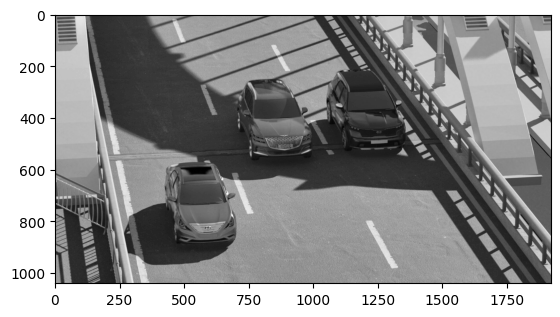

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
# output_path = '/content/detect_car'
# cv2.imwrite(output_path, img)

In [ ]:
# 원본 데이터 파일 move

import shutil
import os

# move
for i in tqdm(txt_file_list):
    shutil.move(i, '/content/detect_car/origin_train')

100%|██████████| 6481/6481 [00:00<00:00, 25347.94it/s]


In [ ]:
new_txt_file_list = glob.glob('/content/detect_car/labels/*.txt')

In [ ]:
# 텍스트 파일 정규화 하기.

for i in tqdm(new_txt_file_list):
    shutil.move(i, '/content/detect_car/train')

100%|██████████| 6481/6481 [00:00<00:00, 24922.33it/s]


In [ ]:
%ls /content/detect_car/train

syn_00000.png  syn_01296.txt  syn_02593.png  syn_03889.txt  syn_05186.png
syn_00000.txt  syn_01297.png  syn_02593.txt  syn_03890.png  syn_05186.txt
syn_00001.png  syn_01297.txt  syn_02594.png  syn_03890.txt  syn_05187.png
syn_00001.txt  syn_01298.png  syn_02594.txt  syn_03891.png  syn_05187.txt
syn_00002.png  syn_01298.txt  syn_02595.png  syn_03891.txt  syn_05188.png
syn_00002.txt  syn_01299.png  syn_02595.txt  syn_03892.png  syn_05188.txt
syn_00003.png  syn_01299.txt  syn_02596.png  syn_03892.txt  syn_05189.png
syn_00003.txt  syn_01300.png  syn_02596.txt  syn_03893.png  syn_05189.txt
syn_00004.png  syn_01300.txt  syn_02597.png  syn_03893.txt  syn_05190.png
syn_00004.txt  syn_01301.png  syn_02597.txt  syn_03894.png  syn_05190.txt
syn_00005.png  syn_01301.txt  syn_02598.png  syn_03894.txt  syn_05191.png
syn_00005.txt  syn_01302.png  syn_02598.txt  syn_03895.png  syn_05191.txt
syn_00006.png  syn_01302.txt  syn_02599.png  syn_03895.txt  syn_05192.png
syn_00006.txt  syn_01303.png  syn_0259

In [ ]:
## 검증데이터 셋의 형성

import os
import random
import shutil


# directory containing your data
data_dir = '/content/detect_car/'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val_set')

# make validation directory
os.makedirs(val_dir, exist_ok=True)

# get list of files
files = [f for f in os.listdir(train_dir) if f.endswith('.png')]

# shuffle the file list
random.shuffle(files)

# choose a split ratio for validation set
val_ratio = 0.2
num_val_files = int(len(files) * val_ratio)

# move a portion of files to the validation directory
for file in files[:num_val_files]:
    shutil.move(os.path.join(train_dir, file), val_dir)
    shutil.move(os.path.join(train_dir, file.replace('.png', '.txt')), val_dir)


In [ ]:
import yaml

# Read classes.txt and extract class names
with open('/content/detect_car/classes.txt', 'r') as f:
    lines = f.readlines()
    # Extract class names and store them in a list
    classes = [line.strip().split(',')[1] for line in lines]

# Define the dictionary for yaml
data_dict = {
    'nc': len(classes),
    'names': classes,
    'train': '/content/detect_car/train',
    'val' : '/content/detect_car/val_set'
}

# Write the dictionary into yaml
with open('/content/detect_car/data.yaml', 'w') as f:
    yaml.dump(data_dict, f)

In [ ]:
!cat /content/detect_car/data.yaml

names:
- chevrolet_malibu_sedan_2012_2016
- chevrolet_malibu_sedan_2017_2019
- chevrolet_spark_hatchback_2016_2021
- chevrolet_trailblazer_suv_2021_
- chevrolet_trax_suv_2017_2019
- genesis_g80_sedan_2016_2020
- genesis_g80_sedan_2021_
- genesis_gv80_suv_2020_
- hyundai_avante_sedan_2011_2015
- hyundai_avante_sedan_2020_
- hyundai_grandeur_sedan_2011_2016
- hyundai_grandstarex_van_2018_2020
- hyundai_ioniq_hatchback_2016_2019
- hyundai_sonata_sedan_2004_2009
- hyundai_sonata_sedan_2010_2014
- hyundai_sonata_sedan_2019_2020
- kia_carnival_van_2015_2020
- kia_carnival_van_2021_
- kia_k5_sedan_2010_2015
- kia_k5_sedan_2020_
- kia_k7_sedan_2016_2020
- kia_mohave_suv_2020_
- kia_morning_hatchback_2004_2010
- kia_morning_hatchback_2011_2016
- kia_ray_hatchback_2012_2017
- kia_sorrento_suv_2015_2019
- kia_sorrento_suv_2020_
- kia_soul_suv_2014_2018
- kia_sportage_suv_2016_2020
- kia_stonic_suv_2017_2019
- renault_sm3_sedan_2015_2018
- renault_xm3_suv_2020_
- ssangyong_korando_suv_2019_2020
- 

In [ ]:
%cd /content/yolov5

/content/yolov5


In [ ]:
import torch
# torch.cuda.empty_cache() # 캐시, 메모리 삭제

In [ ]:
!pip install -U git+https://github.com/albu/albumentations

In [ ]:
# # 모델 검증
!python val.py --data "/content/detect_car/data.yaml" --weights "yolov5x.pt yolov5l6.pt" --img 640 --half

In [ ]:
!python train.py --img 736 \
--batch 32 \
--epochs 80 \
--data "/content/detect_car/data.yaml" \
--cfg './models/yolov5m.yaml' \
--weights '/content/yolov5/runs/train/yolo5s_results/weights/best.pt' \
--name yolov5m_results

In [ ]:
# 모델예측

!python detect.py --weights /content/best.pt /content/best0708.pt \
--source "/content/detect_car/test"\
--img 736 \
--conf 0.30 \
--save-txt \
--agnostic-nms \
--save-conf


# !python detect.py --weights "/content/detect_car/best.pt" \
# --img 1280 --conf 0.30 \
# --source "/content/detect_car/test"


detect: weights=['/content/best.pt', '/content/best0708.pt'], source=/content/detect_car/test, data=data/coco128.yaml, imgsz=[736, 736], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=True, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20986287 parameters, 0 gradients, 48.3 GFLOPs
Fusing layers... 
YOLOv5m summary: 212 layers, 20986287 parameters, 0 gradients, 48.3 GFLOPs
Ensemble created with ['/content/best.pt', '/content/best0708.pt']

image 1/3400 /content/detect_car/test/064442001.png: 416x736 1 chevrolet_malibu_sedan_2012_2016, 1 kia_carnival_van_2015_2020, 71.7ms
image 2/3400 /content/detect_car/test

In [ ]:
#!python detect.py --source "/content/detect_car/test"

In [ ]:
#!python detect.py --weights /content/yolov5/runs/train/exp/weights --source /content/detect_car/test --conf 0.5

In [ ]:
import glob
import cv2
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%ls /content/yolov5/runs/detect/exp5/labels

064442001.txt  101400221.txt  114805468.txt  133633626.txt  151403452.txt
064507368.txt  101421082.txt  114805710.txt  133642908.txt  151411362.txt
065131036.txt  101426458.txt  114812309.txt  133728103.txt  151413089.txt
065147868.txt  101426752.txt  114816733.txt  133742032.txt  151431587.txt
065203472.txt  101429852.txt  114821515.txt  133803502.txt  151445492.txt
065223169.txt  101432402.txt  114843919.txt  133806367.txt  151504690.txt
065330905.txt  101445673.txt  114910760.txt  133817934.txt  151506588.txt
065331262.txt  101501466.txt  114936250.txt  133818375.txt  151511326.txt
065425441.txt  101513459.txt  114951216.txt  133824281.txt  151530783.txt
065714256.txt  101515330.txt  115048055.txt  133825207.txt  151541158.txt
065750973.txt  101516012.txt  115057906.txt  133828605.txt  151544939.txt
070016143.txt  101611364.txt  115110496.txt  133830972.txt  151556031.txt
070203878.txt  101701497.txt  115222410.txt  133834080.txt  151616223.txt
070305203.txt  101720427.txt  11523131

In [ ]:
%pwd

In [ ]:
infer_txt_list = glob.glob('/content/yolov5/runs/detect/exp5/labels/*.txt')

In [ ]:
infer_txt_list[0]

In [ ]:
def yolo_labelMe(line, img_width, img_height, txt_file_name):
    line = line.split(' ')
    file_name = txt_file_name.split('/')[-1].split('.')[0] + '.png'
    class_id = line[0]
    x_center = float(line[1])
    y_center = float(line[2])
    width = float(line[3])
    height = float(line[4])
    confidence = float(line[5])

    point1_x = x_center - (width / 2) # box의 왼쪽 위 꼭지점
    point1_y = y_center - (height / 2) # box의 왼쪽 위 꼭지점
    point2_x = x_center + (width / 2) # box의 오른쪽 위 꼭지점
    point2_y = y_center - (height / 2) # box의 오른쪽 위 꼭지점
    point3_x = x_center + (width / 2) # box의 오른쪽 아래 꼭지점
    point3_y = y_center + (height / 2) # box의 오른쪽 아래 꼭지점
    point4_x = x_center - (width / 2) # box의 왼쪽 아래 꼭지점
    point4_y = y_center + (height / 2) # box의 왼쪽 아래 꼭지점

    point1_x = int(point1_x * img_width)
    point1_y = int(point1_y * img_height)
    point2_x = int(point2_x * img_width)
    point2_y = int(point2_y * img_height)
    point3_x = int(point3_x * img_width)
    point3_y = int(point3_y * img_height)
    point4_x = int(point4_x * img_width)
    point4_y = int(point4_y * img_height)

    return file_name, class_id, confidence, point1_x, point1_y, point2_x, point2_y, point3_x, point3_y, point4_x, point4_y

In [ ]:
submit = pd.DataFrame(columns=['file_name', 'class_id', 'confidence', 'point1_x', 'point1_y', 'point2_x', 'point2_y', 'point3_x', 'point3_y', 'point4_x', 'point4_y'])

for txt in tqdm(infer_txt_list):
    with open(txt, 'r') as f:
        lines = f.readlines()
        base_file_name = txt.split('/')[-1].split('.')[0]
        img_height, img_width = cv2.imread('/content/detect_car/test/' + base_file_name + '.png').shape[:2]
        for line in lines:
            file_name, class_id, confidence, point1_x, point1_y, point2_x, point2_y, point3_x, point3_y, point4_x, point4_y = yolo_labelMe(line, img_width, img_height, txt)
            if confidence < 0.3:
                break
            submit = submit.append({'file_name':file_name, 'class_id':class_id, 'point1_x':point1_x, 'point1_y':point1_y, 'point2_x':point2_x, 'point2_y':point2_y, 'point3_x':point3_x, 'point3_y':point3_y, 'point4_x':point4_x, 'point4_y':point4_y, 'confidence':confidence}, ignore_index=True)

submit.to_csv('/content/detect_car/0708submitensemble.csv', index=False)

100%|██████████| 3399/3399 [03:37<00:00, 15.60it/s]


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/yolov5/runs/train/yolov5m_results


In [ ]:
 %reload_ext tensorboard

In [ ]:
!killall tensorboard

In [ ]:
from IPython.display import Image
from utils.plots import plot_results

Image(filename='/content/yolov5/runs/train/yolov5m_results/results.png', width=1000)